<a href="https://colab.research.google.com/github/NosenkoArtem/Categorical-Encoding/blob/master/homework07_styletransfer_solved.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

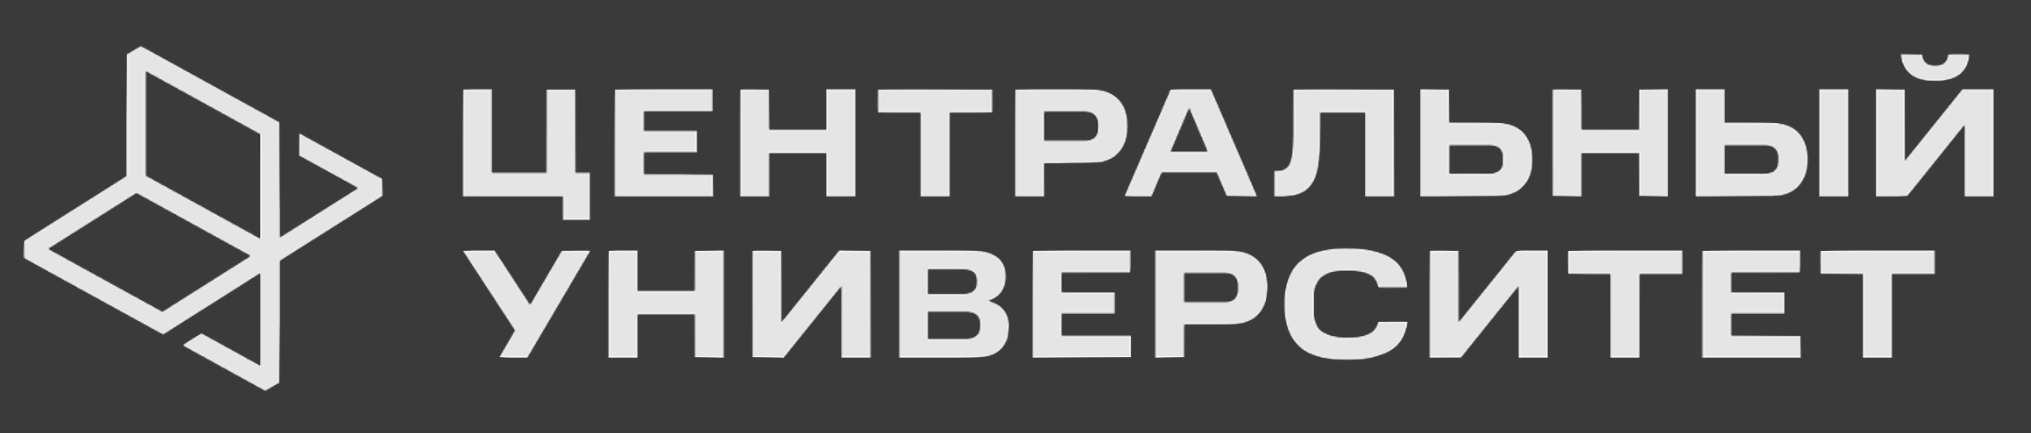

# Курс по глубокому обучению

## Домашнее задание 7: Стилизация изображений (Neural Style Transfer) и интерпретация и визуализация NN (10 баллов)




# О формате сдачи

🔷 **<font color='plum'>При решении ноутбука используйте данный шаблон</font>**

    ✅ Можно добавлять новые ячейки любых типов
    ❌ Не нужно удалять текстовые ячейки c разметкой частей ноутбука и формулировками заданий


🔷 **<font color='plum'>При оценивании задач учитывается код</font>**

    ✅ Задания, в которых необходим код, обычно помечаются фразами "Your code here"/"Ваш код" и аналогичными
    ❌ Ответы на вопросы без сопутствующего кода оцениваются в 0 баллов
    ❌ Наличе работоспособного кода в ноутбуке, если на сказано иного, обязательно

🔷 **<font color='plum'>При оценивании задач учитываются выводы</font>**

    ✅ Задания, в которых необходимы выводы, обычно помечаются фразами Вывод"/"Ответ на вопрос"/"Ваш текст" и аналогичными
    ✅ Обычно выводы подразумевают под собой текстовый ответ (можно писать markdown, latex).
    ✅ Сопутствующие изображения, графики, таблички - приветствуются!
    ❌ При отсутствии выводов задание не засчитается на полный балл

### 1.Напоминание сути задачи (из семинара)

В этой части семинара рассмотрим алгоритм [Neural-Style](https://arxiv.org/abs/1508.06576), разработанный Леоном А. Гатисом, Александром С. Эккером и Маттиасом Бетге. Neural-Style, или Neural-Transfer, позволяет сделать изображение и воспроизведите его в новом художественном стиле (то есть осуществить перенос стиля).

Переносом стиля мы считаем процесс изменения стиля: изменение цветовой гаммы; размера, направления и текстуры мазков входного изображения в соответствии со стилем изображения-стиля, сохраняя основной контент нашего изображения.

* `изображение-контент (content image)` - источник сюжета.
* `изображение-стиль (style image)` - источник стиля.
* `синтезированное изображение (synthesized image)` - результирующее изображение.
C помощью алгоритма изменяется входное изображение


![](https://pytorch.org/tutorials/_static/img/neural-style/neuralstyle.png)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
from torchvision.models import vgg19, VGG19_Weights

import copy

from torchsummary import summary

### 2.Подход к решению задачи (из семинара)

В 2015 году `Leon A. Gatys` с коллегами выдали статью [A Neural Algorithm of Artistic Style](https://arxiv.org/pdf/1508.06576.pdf).

<font color='orange'>**Как будем решать задачу?**</font>

Возьмем модель, натренированную на наборе данных `ImageNet`, например `VGG19`, а также пару изображений `изображение контент` и `изображение стиль`. Представим решаемую задачу, как задачу оптимизации `изображения контента` под требуемый стиль.

Как будет устроен процесс оптимизации? Воспользуемся `feature maps`(картами признаков) `изображения контента` и `изображения стиля`, которые мы получим после прямого прохода через модель `VGG19`.

`feature map` - это выходные активации после определенного фильта при пропускании через него картинки. Дальше мы посмотрим как можно получить  `feature map` после промежуточного слоя сети.

Как устроена `loss function` (функция потерь)? Контент и стиль играют разные роли, в первом случае нам надо копировать сюжет, а во втором заимствовать общие черты такие, как текстуры и цвета. Поэтому функция потерь состоит из двух частей $D_{content}$, $D_{style}$ и опциональной $D_{total\_variation}$.

Что означают первые две части?

- $D_{content}$ - оценивает насколько изображения близки сюжетно.
- $D_{style}$   - оценивает насколько  близки стили изображений.

Результирующая оптимизационная задача выглядит следующим образом. Прямой проход `изображения контента` и `изображения стиля` через модель `VGG19` позволяет получить совокупность `feature maps` (карт признаков). Полученные карты признаков используются в функции потерь, которая состоит из $D_{content}$, $D_{style}$ и $D_{total\_variation}$, и именно ее мы будем минимизировать. Вычисляются градиенты, однако мы не будем обновлять веса модели `VGG19`, мы будет вычислять поправки по входу, а входом является `синтезированное изображение`, которое заимствует сюжет и стиль из `изображения контента` и `изображения стиля`.

**<font color='red'>Важное примечание:</font>** в качестве `синтезированного изображения` можно брать шумное изображение, но лучшие и более шустрые результаты получаются если мы используем `изображение контента` + шумное изображение.


<img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAA/YAAAOECAIAAACEkD3JAAAABGdBTUEAALGPC/xhBQAAACBjSFJN
AAB6JgAAgIQAAPoAAACA6AAAdTAAAOpgAAA6mAAAF3CculE8AAAABmJLR0QA/wD/AP+gvaeTAAAA
B3RJTUUH6AMVEiEd5p/gFgAAgABJREFUeNrs/Xe8HVd1949/1tp7Zk4/t0tX0lUvllwky703bFzA
QEIMeULgITwkMSEEAiEEfpgSU0MSaggtlCRgerFxsHHH3ZYt2ZZk9Xavbi+nnyl7r98fc87VdYUY
8sU4837ppdc9c2b27Jkze89aa69CIoKEhISEhISEhISEhBcK/NvuQEJCQkJCQkJCQkLCb5JExE9I
SEhISEhISEh4QZGI+AkJCQkJCQkJCQkvKBIRPyEhISEhISEhIeEFhf5tdyAhISHh+YKIAGRMBBEQ
kCQjeP5DEIFSiplFhIh+2x1KSEhIeF5ASUadhISEhISEhISEhBcSiRU/ISEhAQBERESI+Otf+/LU
xCBRYgH5HYCYw9C+4vf/aNWqVdZa5sT7NCEhIQFIRPyEhISEWYjEAA/e+g9ve9lOARKfj+c5xkIV
cdMNeOChjYmIn5CQkDCXRMRPSEhIaEEEEfTP711x1F6IAsxzbEie6MfPczZSW3Wwc0/c/mfnfLTt
Y2XObrb9rbTbfNKBmNM4PaUpPHHPJ/WTnq4Rbm+UJ55uthuzX83t6pMu9km9ivec28nnhgU69ME9
0ZTrPdcmEhISEl6YJCJ+QkJCQos4yDYMI2lEAktPEMN/9VZAGSBWEBggwEfUhM4CHhDBVKEcIANY
wAIKsEAD1oI1oGCbIIAcAJDmHAlYQB4QQkxrI7mQADL3QAIpINU6rwnAc5oSPPEUGUADUbufASBA
BGOgFJAFGKjDBGACOYCCbYAAcgELiVry/ZO6ai1UGkgBEWytpThx3CCAALYG1nM+NvDcomSNhWpK
s2lEntMvlZCQkPDCJRHxExISElpQ2zoe//HflTtj133SuONuTMygswA/QL2J41Zh5VpsegAPb8fK
JTj3LIwN4s6HkUoh42G6glwGZ2+Em8bwCGYqWLsKsBg8DBAW9UOilpQMja07MNCHfAFkERk8/jhW
D8DJYHgE0xWsWwlYjI7j4R0IAqxfgyWLAYPBYUCwqB8ARsYxVcK6VYDFnfdibBKdRfgBGk2sWQZH
YWAeUnn4VfzkJjSauPh09PVDAgwNY2IG69dCBHv3o5BDTzdsCHYwNAwrGFgAiSCAyuGRR/DAY1i2
COefDgnALqpl/PQG+CFOWIuj16I63fp44jqsWwEx7dv+3/q94n+JQ1VCQkLCU0jcFhMSEhJ+oxC2
7cOW/firT+Dfr8eWfSg18dmv4j2fwwzjX76Dd38CdR9b9uGHt+LPPowte/DoboQhKI33fQEvfRtq
dUgeX7sO/3E9kIGxAGAskMP3b8E/fROUhXi47zG8+7NQKZCHD34JL3krag1IHv/xX/jY1/Hgfrzy
b/HTW4EefP06fOOnQBqUwt9/GZe9FfUGxMH2fdhyAG/7J/zbT7DlIB7fh3d+GrUGxqbw0rdh0+MY
msYr/xb3bQK68MNbccrrsGMf0IWPfwM33w9kEUZABt/8Gb52LZBBGIGz+Nw38I5PYhr4tx/hzR8C
pTA5g9e+D1t2Yf8wvnczxqfx2vdh8y4cGMG3b2hdYEJCQkLCb5DEip+QkJDwmyE2J0uEP/9joBsH
DuJ1L8F5f4g9t+GrP8ItX0ZxAPhDnPFqvPhUfOBj2HYDJmbw/vcCZSDE3sdRrePs4/GTW/DqP4GN
fXjaMIF8XPEivPljqE0h24trbsDFp0N1Yc9mlKo4dyN+dDP+z/9DtYErLsSVH0H/3+HffozL/hAi
EEBS2PcIpss470T8+Ba8+pV446uAfhw+jFdegBf/ESqP4l9/gGIef/spnHQ0PvRBAFi9EO/+HG4+
F0ph/Wp85lv47El4Uqqhlku/wElh3x7824/ws39B7wrgj3H2q3HHPejOY/9h/OCrQAZo4M4bcGgE
P/gqkAPGYcsghSR9UUJCQsJvkMSKn5CQkPCbQQQiAMEvIZxAM8BUGWEF9z2ClYtRnI/aQViNC07B
7ZsQTmOyhCBEOIHGFCSF636BF52CD16Jn94FMm2Fod0yMUwdR61DRx73PoTmDB7djZedAxFcfxfO
PwlX/wWuvwsUIu3h+rvwL1fjR7fhNZdC/LafTxo//QXOPQEf/gtcfzdg0KwgHEczwEwV4ThqDShG
GGLbPlx2JqJphIdxzkZYi+AwGj5ecwlqDTx8BzoLTzC9tyJvBfCwdTcG5qN3ALWDsISLT8fN92Pt
cVizBBdegbe+BY/dj5NOxOoleNEVeNtfYuuj4DTEJv42CQkJCb9JEhE/ISEh4TcDUcuJXzMcBSZo
BUfBcRBGgAIRWKMZwHPhKCgGMxwFV4N8/PBW7DqAOzbh3kdR2oNM6gmG7VbeGoXLz8bP7sUd92Dp
AixcDiq3DrztQdz3GKZ2I5tCFKFcwsQMjl0J2JbDOgX4wa3YfRC3Poj7H8O+XfCycBhMUAxHI044
SQQQjIVSYAURRAbkwFpojb+4Ap/9NowFP131XwKUQmQABjNYww/BDE7jWx/Bh96MYgGvvwrTk/jP
T+DDf4FCHq9/PwaHABc2cddJSEhI+M2RiPgJCQkJ/wNQ285dx6nH4cAwtm1CZiHGDuHm+3H+yUAI
AJEBLFQG929Cw0dPH8brWLsU370JKRfGghSYQQwRKAZqeMk52HEA7/0CXnspxMP9D6PeQN98jNew
bhm+dxOIcM6JeNff452vxVv/EaQQGmTT2PswKnXM68dYFUcvx7d/DkoBAmNbuoQAkQErnHM8vvIj
kILqxH9cj75OOAvgh5gq4cRz4bn4j+tRyLVFfIIVWAFpoIlTjsHoJB66F+kFmB7B9XfhwtPgz2Cm
jJPPxAfeB62x6THUfZx8Bj7wfhBh5z6QlzjqJCQkJPwmSXzxExISEv4HEGTT8BzAx8AA3vdG/NU/
4JTj8PA2vPEVOGkDUIPrIJ8BBOLgh7fhDS/DG98MBLj4RHzkqzjpaPz4dhwaQ62O170EF54N24CE
6FqAo5bg4DDOPgUI8KPb8frL8WdvAQJcehI+8lUcsxKKEO3FKy/Gf/4MW+9BXye0wg9vwetfir94
GxDg8tPw1/+ERgnpDmRScDQgYEIxh3IVb3s93vRB/PFb0dWB/YfxqXdCmsh4EIFY/OWr8M2fQXM7
6ZBBZx5f+hGGJ1Cu4spX4uNvw998Eqfeikcexx9djNPPwJ6teNdnsWwh9g7ixLVYvQT/92+xtB/7
DuO4VTjtBNgakqJVCQkJCb9BkgrtCQkJCQAgIkQ2EnX1X5/6/tfcJ8JEz9F3RAREaDShNRwNa8FZ
lMbx+H4s6cf8RZA6iGAM/BCZFASo1pDNwFpAwApNH0So1uEHAKEjh1wW0q4VZQ0iA88DBJU6silY
aR3oBxCBVnAdgOD7sAKtYAVhiEx7T6XQ8OE5UBqNRrufgqYPz4XSgMb2HWgGOP4oQEMCBBEAuA6I
UavB0XCd1pWGEWYq8AMQIZdBsReVSWzfi0XzsGBx62Kny9gziEwa61YCwNQ09g4ik8K6VYBAzHPx
xTcGqkP97HpTXXz9K3/vkiiKtE7sVgkJCQlAYsVPSEhI+I0Te+Sn4+JWAmaYGopFnHISEMLUWo7s
SiHjAAYE5POABTNAEEEmAwjS2XbdKwPMCsECpaA0xIKAfA6wYGkdmE639oGFCLw5VV897wl7Ztq1
t1qHWDC1NooBDNYeBRDQhPXBDM9t7SYG2WzrFPGVOg56e4901VSRz+HkORcrgs5OnNgHCKQJAF2d
6JrzMQ4ITiJuExISEn5TJCJ+QkJCQou2SzpF5jlUvnpKa08s5xT6kGYrJNfIkdO1Muc8cef4Y+yv
HzO3N7/8wCd+O5e5ez61hbjMVnwKqbVccYhgzS876RO7GgatTD5HLtY/Is0TPfnjc8MYiCFjk/JX
CQkJCU8mEfETEhISWsS2ZM2R7ng66fh3nafLgfM7jbZAZ1TIoJZUz0pISEh4IomIn5CQkNDCWijC
4EThn76YB6kXkpQvAETohWXttgKV0bt2RJe93vlt9yUhISHh+UUSbpuQkJDQQkSIaHqmNlUyLySb
tzFGa/2+9121ePGSP/mTPzHGKKV+/WafFwhcFwv6MkprecHpMAkJCQnPmUTET0hISDjCCzXoU2yw
YsWKJUuW3Hrbnb/tviQkJCQk/I+TOOokJCQktIjNwC8ww0cURUqpH/7w2n37BweHRh988MGNGzda
a184hnwAQPzDJVb8hISEhJhExE9ISEhoEQuILxgxMdZVlFLM/KUvfQlAGIZf+cpXTjzxxBekNPzC
u6KEhISE58wLzV6VkJCQkBAjItZaZn700UdPO+20RqMhIvPmzduyZUtfX18s5SdicUJCQsILkqRi
eEJCQsILk1nflS9/+cv1ep2ZiWh0dPQ73/kOEVlrE/k+ISEh4YVKYsVPSEhIeGESC/EHDx4888wz
X/SiF1133XUicuqppx48ePAXv/hFPp9PrPgJCQkJL1QSET8hISHhhUnspfPggw/6vn/iiScuXLiQ
iPbv33/33XcvWbJk9erV8Q6/7W4mJCQkJPzmSUT8hISEhBcss2G1Q0ND69evF5HHHnusv79/7lcJ
CQkJCS88kow6CQkJCS9MYiHeGAMgTpEZe+YYY4iImRMpPyEhIeGFyn9DxI/t/cn7ICEh4dfn15xP
5iawf5aE6E/Nc/+/agabzQH6JG+cWLj/33Y3El7YPMskMPdj8swn/O/hl4j4s2PDWmutRTvF8lPH
0uyrdO5XTx1L8bdxENjsizluOTEpJSS8sHnSfEJESqmnCuhPmkx+nZJGT81zb60VEaXU/+bZ5oVX
3ivhfyezc4UxRkSYWSn1JAHjaWWVuX8ni1oJL1SeTcSffdzjOoizpRDjd8Nc+9nsIbPjau6eT32d
xCal2cE5+xFPVLjjs89ueeq5nvoxGZ8JCc9bZkf0k+aTp04Rc9/Nz1Rxdna8P3XqmD1dvNFaW61W
C4UC5kw+eMps8yt+TKaahITnA7PDkIi01rMb547xuX+USqVisYinCBXxXPTrSCDJnJDw/OSX5FKY
rZxyzz33fOADH3jPe96zadOmuaa12b/jj77vb9++fVYxmCvxzz1k//794+Pjs06iDz/88KZNm2b3
mbtzbOCf+3Hu6eb25Ld9JxMSEn4Js2P2hhtuuOqqqz72sY9NT08/ydg2d3Rv27YtNrBFUfS0c85N
N930uc99juYwd9oRkfjAu+6662//9m/jDhw4cOCWW26ZPdFcRWLu9II5M9hTJ7HflTnnqVLOs29P
SPgdYnYYBkHwpS996b3vfe+///u/E9HOnTsrlcpcAZ2IHn744b/+67+eHdTxxvjjL37xi507d+KJ
c8LTihxzP8ZT07P4LCQk/Nb5JSJ+LN9/8YtfvOqqq5YvX75kyRLf95n50KFD1Wo11pWNMYODg/V6
nYhuvvnmD33oQxMTE7Hh//Dhw/FII6Lp6enh4eG49srf/d3f3XffffV6PR4wn/3sZx9//HEiGh8f
n5iYIKLDhw/Prp0R0eDgYLVaBaCUKpVKo6OjURQBYObh4eFyuZwssSUkPM+Z1divvfbaT3/608cc
c0x3d3cQBEEQxOJ4s9kkoqGhoVKpxMy7d+9+5zvfOTw8HIah1jqeHJiZmcfGxg4cOGCMWbZs2emn
nz41NTU+Pl6r1XzfV0pNTEyMj4/HU4fjOKOjozfeeONRRx0VT0TXXHPNzTffTEQHDx5sNBpBEAwP
D8dTh1LK9/3h4eEgCOIZrNlsHj582Pf9+NhDhw7FU9bv3GwT3/m5P8RTXZgSEn63iJ9kEXn3u9+9
devWY489NpVKNRqNt7/97Xv27KlWq/Fj7/t+FEV33HHHsmXLlFIzMzOHDx+eu8T3iU98YnJykoiG
h4dLpZKIDA0NxaeIhZyhoaF6vQ5gdnoxxiilqtXq0NDQrEHht30/EhKezC9x1GHmvXv3fuUrX/nZ
z37W2dkZb7/qqqt27txZr9f/8R//cdWqVa997Wvj5/4//uM/du/evWXLli996Uvvete7PvzhD2/f
vr1Wq33605/evHnzF77wBQAXXXTRlVdeuWPHjm9961sdHR1nnnmm7/v79+9/2ctedt11133+8593
XTeTyTBzrVa75pprxsbG3ve+99Xr9fHx8ZtuuukLX/jC3XffffDgwd///d9/85vf/Pd///e7du1q
NBof+MAH1q1bl+R4Tkh4PhNLxnv27CkWi1dccQWA22677dprr/3Hf/zHD3/4w0cdddTWrVu3bt06
MTHx2c9+dnh4eMeOHZ/61Kc+8IEPfPvb377xxhsrlco73vGOUqn0rW99K5fLXX311V/+8pdf/epX
f+lLX9qyZcv999//i1/84vbbb//pT39ar9evvPLKc8899+1vf3utVrv99tu/+93vAiCiBx988G/+
5m+uvvrqzZs31+v1pUuX7t+//9RTT73qqquuv/76b3/725OTk2vXrv2Hf/iHH//4x9///vdnZmZW
rVr13ve+9+1vfzsAz/M+8YlPpFIp/C7Ix7PCx2zMAwCttVIqiqLZHDu/7W4mJDx3iGjr1q2ve93r
4ill165dO3bsuOaaaw4cOPC6173u4osv/rM/+7NPfvKTO3fu/IM/+IO77rrrc5/7nDHmwgsvfMMb
3sDMQ0NDtVrttNNO+9znPnfjjTdaa3t7eyuVSkdHx5e+9KXNmzf/8z//c61W01pfc801H/zgB/fs
2bN169Z/+Id/yGQyn/rUp4wx559//p/+6Z/G4kcymhKeVzybQBxben7yk5+cffbZnZ2dlUolDMN/
//d/f/TRR//zP//zuOOOu/7663ft2lWtVr/xjW8MDAzcdtttu3fv/tSnPvV3f/d33/zmN++7776/
//u/r1Qqw8PDP/vZz972trf967/+a/wO3rBhw9e//vVTTz1VRHbt2pXNZnO53He/+913v/vdV155
ZXyWZrO5ffv2v/mbv7nsssve9a53rVix4vrrr//xj3/8mc98ZsOGDUuXLr3hhhvuueeeD37wg9Vq
9dChQ4kanZDwPEcpZYx53ete53nexRdfPDIy4jjO4OCgiNx33339/f0PPPDAN7/5zcsuu+ynP/3p
gw8++Pa3v/1jH/vYtm3bPv/5z7///e8vFot79uz5zne+c9JJJ33+858PguCRRx4ZGBh405ve1Gw2
P/ShD1UqlVglyOfzw8PDH/zgB3t6ej75yU8ec8wxAwMDAMrlchiGqVTqvvvu+9a3vjUwMHDGGWd8
+ctffvDBB7dv33711Vd/8IMfPPvss5cuXTo0NPSxj33s6quvfslLXtLf3//Rj3505cqVf/qnf7pt
27bY+ee3fS9/JeI5/J577vn617/uui4za63DMPz85z+/a9eu3xV3o4SEZyJ2mLn66qs/+9nP/u3f
/q219vbbb3/5y1/+kY98ZNGiRWNjY7t37240Gh0dHSMjI/Pnz3/Pe97z1re+dcOGDY8++mj8/G/e
vDmeHK6//vp//dd/veiii3p6er773e/u3bt39+7d73jHO970pje95jWvWbVq1de+9rXdu3d/4Qtf
OO6442q12lVXXfWXf/mXJ5xwQtzUb/tOJCQ8Dc8m4sez/8TERDabBZDP5x3HueOOO9785jfHTjhH
H330vffee8IJJwCIR9HExMQ555wD4Pbbb8/n89/85jff8pa3HH/88Xv37j3zzDMfe+yxtWvX7ty5
c+PGjVrr2Nnm3nvvPeqoowAMDw+feuqpg4ODxx13HIBCoTA0NKS1/r3f+7277777mGOOueOOO971
rncVCoXt27efe+65N9xwQ7FY/OY3v/nnf/7nL37xi9FeU0tISHgeEvu6KKU6Ozu/+tWvnnzyyR/9
6EfXr1+fz+e/9a1vnXLKKa7rdnR0MPPg4OCKFSt27dp1/vnnM/Ntt92Wy+Wuueaas84667Wvfe2H
P/zhO+644wtf+MLg4GBfX19XV9e73vWuV73qVa961auuvfbafD5/zTXXXHDBBZdddtnDDz/83ve+
d8+ePYVCobu7G8Cjjz7a09Pj+35HR4fjONVq9fjjjx8dHV2xYsXtt99+xRVXLFmyZNOmTRdffPEP
f/jDV7/61YsXL77nnnvWrFnzyCOPVCqVn//855/5zGcKhcLvkKOOiKxbt+7d7373S1/6UmttEAQX
XXTRl7/85RUrVsy66yQk/C4Su/IqpU444YQ777zzzjvvfOCBB/bv33/WWWcR0bp168bGxr72ta/9
2Z/92d69e3t6eiYmJmq12q233ppOp6+++urYGfjuu+8+7bTTms2mMaa/v39kZGTjxo2NRmPBggVb
tmxZt27dKaeccu+99x5zzDF33nlnvIJXq9WIqFQq3XHHHa7rfvjDH45dHpLRlPB849kcdWIH9wsu
uOBtb3vb6aefXq/XV6xY0dXVdeedd46Pjw8NDZ1//vmvec1rXv/618/MzAwNDS1atGjfvn233nrr
SSedFC91XXjhhcuWLdu0aRMzu657/fXXb9y48fDhw4cPH37kkUdWr15NRLfffvvll1++fft2x3GU
Uj//+c/f8IY3bN++PQzDVatWxQ1+85vffNvb3haG4Re/+MU777zTWpvL5VKpVHd390UXXdTb2xub
8BMRPyHheUu8kL19+/bNmzcvW7Zs9+7dJ598ci6Xi6Loox/96G233faZz3zm2GOPtdY++OCDb3zj
G//1X//1/vvvz+VyPT09uVzuwgsv7O7uPnTo0MjIyLnnnrtp06ZyuXz88ce/4x3v2Lt37xVXXDEy
MtLb2xvvWSgUXNedmZm58cYbv/e97xWLxVgov+WWW1asWHH33Xcfe+yxtVrt4MGDq1at+shHPrJi
xYqOjo5rr732xhtv3LJlS19fX19f31e+8hUR2bFjx8aNG5VSa9asWbdu3bJly2bDbZ//b3RmjqKo
q6vryiuvfO973xt3e2Zm5lvf+pbrulEUzeYhSUj43WJu7D4RxRE7fX19hw4dyuVyK1eufPGLX3zp
pZeecMIJF1xwwS9+8YvBwcEoigqFwhlnnJHL5fL5vDHGGPPAAw9cccUVN9xww8KFC0Xk/vvvf8Mb
3nDjjTd2dHQsWrRo69att9122/XXX//7v//72Wz2Ix/5iLW2p6dn0aJFnufFTf1u6fwJ/6tQ73//
+5/pu/iRXbZs2fz58//rv/5rcHDw2GOPvfTSS2+++ebp6ekPf/jD+Xy+0Whccskl5XJ54cKFZ5xx
RrPZfOCBBzZs2PCiF73ooYce2rx589KlS7PZ7FFHHbVixYpms3nmmWeuXbv2gQceEJHY/N9sNi+9
9NKZmZljjjlm+fLlzWbzkksumZycXLly5SmnnEJE99577+mnn37iiSdefvnl2Wz2e9/73gknnHD+
+eevX79+27ZtDz300MKFCwcGBp42A25CQsLzgVmHkOHh4euuu2779u1nnHHGn//5nwP4+te/fvnl
l19wwQXj4+MXX3xxNptNp9PnnntuNpu99957ly1bdskllwwNDd17773FYjGXy33jG99oNBrvfve7
oyjauHHj+Pj44sWLd+/evXz58gsuuGB4ePiee+5JpVLr169fuHDhjTfeuGLFigsuuGDJkiUAyuXy
OeecQ0Tnn3++Uqqnp+e4446bnp4+66yzTj311EceeWR0dPTFL37xUUcdtXHjxmXLlt1yyy1E9MY3
vnHlypW33HLL7t27jz/++Fwu97tiUJiVPBYvXvy1r30tjhtevnz5P/3TP7mum0TcJvyuw8wPP/zw
TTfddOjQob/4i79Yv359T0/P/fffv2zZsnnz5n3ta1/7xCc+0dvb29/fHzvcz5s376abbgqC4Pjj
j1dKxYrBhRdeODo6esYZZ/T39wM499xzx8bGNm7ceMopp0xMTGzfvv2888476aSTLr/88iiKvvOd
71x22WWXXHIJM99+++3NZnPjxo3JUEp4fvLLfTGfRT399TXXZ29h7rcjIyNXXXVVX1/fwYMHP/KR
jyxYsICeUivnt3UTExISfhWeNE6/9rWv3XDDDaeeeupf/dVfPSlW/n9ibnnaNp92Y7PZfPe7353L
5Xbu3PnOd75zw4YNv9m+/X9JnHVEKfWHf/iH11xzDYD3vOc9V199dWLCT3jhESe6AfDRj3508+bN
V1555TnnnPNMeTjmFtZ4WnFi7vZHHnnk05/+dGdnZ7Va/fjHP57NZn8nlPyE/+U8m4g/txQl2gl2
ZpPZx9nrZtMyxENrNtNlvGVuzunZb9EOAotbi1uYTfsw9yMzx+eKDzl06FC5XD7mmGMcx4n7NnuK
JGlmQsLznNlS1rMJHA8dOhSG4erVq+MJYTbndDyZzK2JMTt1zKaImR3ycdY8AHHSmNk94wlnNiv2
7DQ1Nw2/MUZrPTuNzM42cTbekZGRVatWxavwsxk/n7Yc7/McY0xscTzvvPMymczDDz+8atWqJAFI
wu80s0M7HrbxkGRma60xZtu2bYsWLerp6Ymf87j87eysAiB++J+0fVYCiT/OlUCMMfv27QuCII4V
nJ0Q5jaVjKaE5xtPX1Tyv5Vm4Vl2/Q0+73MHz/MtSkyeeLFPe0PomQ98lh1+6f6/yrnkl/Xt+cP/
UHoPedbrpl9274nAyQz+6/G0U8pchf+pX855Wunpnlw68mgf+V6eoYWnaWTOCHrKV0+ebfi/M6yf
fOlPdy4C5FkPpjnzytxra7X0NF/PvSHtU8y9/9batWvXrlix4mc/+1ks9D/xeHrqUU9o8snX9Cx7
HLlAefp28awT2LPfll8deYYn51c/lzzXfv4KrROJIJlR/rvMiijGAmIBgJ5sTScixQAQhOYZbe1i
AQIsQO0WnvCqZJh4GzEhfk2wAmCjaHZPCyZYEAmeOJrEzukVEUmr4/GRFF/IE75qfdP+igARCwgo
rgJOgMw2SxCCCPjIFEkAwGRF2ApR610qcyYzmp2Gqd3DJz7WcYdYRAjxo0kiwiQA4jYBEsxehBCJ
tcLc+kWs8Ny5U+ZMTK3uA4qtCFnh+A6LQEjNuSHx/lbA3DLmxD1mhhDs044YmS1pTICdnRufVuoh
ad03YghIALISd9BSe04VkLQvUIRmT0pkiWBtvGXO/iKC2JxNs2eOO86xNE0c3/zZMmmAMKy1s+WR
OT7JkU7LkZ9V8ORZubVtziFMTz+lPHmh9jm4lP1/O0cJQM+3BTJ61o+/+oHPYf9fpQX6b+7/2+R/
qn+/gXYT+f7X4WnvXjx9P/Nw/qVPLj3lz2cfi/TMTTxZSBWBQAjE/Exy7q966c9wrl/aIM39Q55y
tfSU/Z6y7QmKitb6rW/9q/nz+2eFi2fo4BM79stu/DNPS/SkFumXNfSb5le8z7+0hf+pfiYzynNg
VkTRCkAs/j7j8HQd9cwtxV/NnXyeNOE8/bzEc9zb+MktPKlxzOneM1n56Jkf1Kc2MrvlmR4dRQQ+
ckPoKS08beNPanO2S0e6x0/eofXV7ORNFO8zV6nH0519bg+fyVFQPbE/c67u6famJx767JP1U2dL
nj3yWRue3UepZ9r/WU741E4RoNQvl2Tlie08S9+Ap5tSnt6KH/pB6AcEkpatKdZ1YAUiEBErYiys
wFgrgJG2GsMqboWYFbNWzIrAYHBohYmY4lZpbvdbOkpbO7cQinVJEcBSvKqOlmJFR/QXiTVxC7Kg
lkpK8sQHtKXZCGIT7BGDu21Z10ggZAFACALhWRWM6IitbPawWe1Y2jbI1h1sK7ACC9gjP42AhFoa
Xkulnr3lImJbqh5RS6FvnYiIZK7pkyDS0vfbOwACC4lHlohFyyBNRHJEk47vVUshh8gR9VDix671
s4qV+GbCQsLIAqSZWr8sSDExRDEUKUVHOm/iVlttwUhrhDORlbbaGl+8IF7XNLZ1e4y1sPHqKhEQ
GYmsAAIhAYzY2M7SdsSIt9jWkwZiAse6PYkAVoREQgtjTbwyKyKRsZEVIwIrxoqx1ojoeGGVyZI4
xGlXK1YCUUzxI8rxPSUSkWZkBjoya/tyVoSTd/J/n5bVzVqBQI5YdNAe+LNlV9svJRGQkELLIiEQ
IhsyKGItVjQJKxEhSyTx0x4LwdKeI6IQAiFNKp5Y4ieEGEISiW2PNwAgAz4yXbSeYwKIKW4O7U32
yFxgAYIwt21TrcfiKQsV8ViwfOSKZ+c+AoTEtj/KE48hgWoZ/eJRhQgggW4PfctoCgikRAAiC25b
DZ9odW7Z2GCFRGCiyEJc18GcV4S0Z/n24a35mFr9ju1Z8uTVAmMFHFs4GWQA274wCxEhLYESC37i
eaCsVbHFCQCLjW2ET+i1xPeaZk1Y1Da3zloQ489zRyO3n6g5iyPxfGvmvmeeOJ8LZn/9+EqlNUEK
KYmXbtqrEdyaquPHlZ6mvfj6YksetU241LbFidCct57mlpUyMRz8d4lvWrlufvqwX9p5o5vvyS85
M6xNiqgobDqpnIB0KhWVDtmgoTpWWT9g5YoJokZTey4pBmkbTvHYI35qLVc3pzzHdp8iLEF5v1tc
EEnar1JOVdaqb2csUHM6V80Hl+rDpaCWbhrkAWYVSBRR5yPOuUubv/A9daDrAnaynkIUWsPkjj2E
9LIoO4+iKICzZv6wRI3t+zq681GNe1NpcTwqT1vlqE41lqWDj0we1xduM4WjnazjuVIaq3vW9Sd+
HpmSO/AKi1C5+bA2VRu+qzBwLonudw/l3dK+YG3oZMhAk1WeSnHlnAW3bC2fsXu8Jy1+rTreMOV8
z1EZh0QoCqE0qmVjTJTPNmX4cepdGVExapRJCThlywcU1TOLTmxMjw6kR8a9o1k7jaqs6dlRL5l9
EwMD+eFRvy/QnawkMFRwZo4dGL/nzvFT1h5avHr+wS2HH544Bl3HFDrDKHRMJPWGWMMgSXlwHA6a
turj3JX3T1SLu0prxUwvL980XJXqvIu7u/MSSbUkhhm6Oq+86ZC78eTFB4cOjo4OjWqEQW7Dcaly
d/XBGadnvgcPklJ6OgjJBJlU5nBQHx6dOerMtU5nqnnPWF8uakZOg4qRiZxsJpgYS2VdbRrNYsYn
N1C1x6dWloobVphdfYU9h9Wyx0YXKq0WR48vrzzacIpZzzloF++yq9bld+TSh8ZqiyeDFZ6nVGhX
dG7r7xq/b8+CfY2Va9ydA3pPA56j3R0jFd94Xscazi2OlAhchmrWa5HRRy/efXi8p+EtSMtUsxZ5
gSP5dOR63c7o2s4tdz1YazZ9soH0nGC7jibYvEeeptCgWrcCpFzqLtDgFEWhUWJVZEkcB0jXHzUU
VHs2CnPGll1tzzm2w1VH5NJZnl6LCvygNlNRRPFrTSAARyKhFWsQRCay4kc2ihAaY4HIWiOilGLt
QMRYC9aa2XNUJueRJmYVWGIVS4otwVraI9YKRIhEWq8HWCZmERbLYmFtfAC1ZDkBSOJXFpFlMsQR
CKwttQxvrX0hQohFdmmtYsR+dQzAioBAICOWLQGwLAAYhHaBdznyfoqVerJxt+XI6zwy1gDMYEAR
i4iZK7UQiFuSLsVyRWvFKpY7JLAWQg7HSxMt7SH+JIC17SUaghgYiBCLBaMVP2TEsnBchxsEEoIQ
sSUFIiKBab2JRcQS2sJG7MEMsUAUtV7ikZXAioENrY2s+IF1FAsk1p1cppQiTzEzuUyK2ViJrERi
rSAyrRW00FoCWbHEPLsAySAIDBAYQ0RhZIwVJoK0Fi8VsxUJjPVDY6wNIwAw1gShNdZaIBSwwFgj
pvWGVUo5hDheMNbfwshExgQGkTGK2ECM2MhKue5X/YjB1pggMmEUsdLEQkRakVYq77opzwFLSnPa
cVKu1swksCJWTMmPzlzavbYvJ7+OJfd/K7NKaml0MGo0KOIMgwmRsWIC19qZKnaHcAgiCIwVmC6U
fZlfy63jKtABGLFl5LfcsFSlb9tw/sjm2ivnlXoumx9EvN3YhkXOoXkFkQZNzEjQCaSBO74vo160
7BV0rGAU8IGCGI1l5fHu6Xt37HXTx+QWFLUXRoT8bqysUEYJBD6mx1UEFjdX6FuaAUQmgGkBEbK8
T6Mu7EkTZgLUKfWlSyI3RQYyIq6FUgh8Mm2tBILYcEDRVK9tdoBJjJVMA92xRpyydR0cApQAsJMI
GgBDGAgtdbDdSD6QBlhgHiX7FdjwAP/1dHq1EIo0uMy+DVwgdS7BzLB5wD3dyR4tWpACAFhYIpSq
ZuvetSepjg415BeaEZs9sIvJFKIux7hpsiJMEh025XI/cTq2UyhryTRqhvQKZLOBwEIYKIGCtoNA
iCDA5ruFNkrxFMfaXku3BxjLw3XguRiDTI7jFYe/t54el54spUUaIVv41Ngupww/fnb1jIxyvTDA
msqB4zqrSIEc6xvCQdguqDp2NuxUep5OZaTbyjA5TSzolv0mV2UH4zAathPOCIr1WB1EBGwMUAC2
A5Ms5EEYFtCMvtQ2K2OkXOEpCn2KGJFlwAKLySgM7EOe2SCnpNrgPYOTRoXwh7rOnczOU0qkQNKQ
VKM5z99takoIh0SXnRwbwYQhQkngK7BimRlGUKGOfmR6U1k1n8QDWU+4CNcjMsLN2OpJzUiff5y3
sFsnM8pzIH5blRv4yo2Ha9NdM5u+2nV0052/PgzKYChF0I61kPJk+aHvFc97NxrEbEwQzgwOu909
he48UVQdnaIHvjtPHTLTD/hLrmwcu9HNu5Wdj4R2b0fXBlurZZ3xP618KFd3oik1/9VLs6tL5X/b
XVHFmUk3C19YB0qFlq5Nv+nY5j1j3WseXHV5LmuYuVZu6trB3i2fHT/5SyEbBvxAlvWbgh3dttss
WBiNS29nhziuPXTQplw7ry9zxsLHf3RjRR6/FacfVyiG5JBtkr7v2/Vdn9+n3N4T+zD/VOVIZfeD
jamtPcde6NraRZOfPHnt0MTImT/J/kkD3Tkd9Myzh0ZSzslbOnsP/Pttf5WvTu1Ppcv7b8nM1ws6
1+SzJhaFahUzcdg4SlJ771ArO73FPUGzUK9Om9o0Nn86u/Tc7lNPKo+r7vKUo67zF106XffO6N3W
2Rj8/D2XX7L4ni0zp1XSHSQhoPJ5/bYzf3rDvR0P3nDNxz921PTQzm/9S2H/+i8vX4a+TtWo28iX
ySmq16WnVwpFlMvEtnZh7/fu2HHKrYdWz8zgRWPXN8z0z3rO3Lgy7xD270MYWC/bPG/s299Or/zT
Cw+Uf/H1a64fVU5zQf9JEz2n/VH0jXnskHZcRAQeqlQNh8d19Tqlmjd0eIbPSp83sOearVl3eKrQ
M46C51sHVK9XVbOcpkbYt2i0PvX4zOidvR/smu/3Dn8offa8feE5338sWutuKfsP1xtbvVxPsT55
kDd8Sa68bOPI6sYNj42evtldm0+HpcP+5f13XfHiR2+57+Ib9mX/JPeZen662bS/2FOeUr0dS84c
y58SOUSok+t6JI2atvWx/pfe+f2frwkK6amaO1OTpTnqWsCDJVy0ZNvMzBc+9pVyrqM77Hs55ndk
F0hvFmlFxspYndShKuVcpy9dUNHMyPSM79qGgeiu5jYtftfhH5b75g+uP9FrlLvDkVx+welr4T7d
usLTi/izsbDUtlSIgFu205YhmiDMpARkoR0FCxELExIQWgmtjYgVdBRwmhwLSSloRRxbNNpuZITY
LCuWiUiJiMCwgK0wCRPIAvFKubSC72LjCxEEZAlErJSOeyYtJYDaXlBsY9M8WmvdInOcpKi1POEw
t9d/2sZ8ImlL909x5qW2PalluyaQBsVrTxxby6ntdhcfJBBq2XBmRXyAmCCAIwpA7IcVm/KtFQZR
bAVXQGyfBoRJCSwRFEhaNmwDkIlPwcQgMGzb/EaglnSPMLJCRBDFiE3RohgEK+IgdnAjC3GtRDaW
TzhQNrDiMDERIA4TiBwmTylXUWykB8iKGIixYgVixYKYyVglAM+x2VoDI4hio5jL1kIzubqlBlih
RhiFxoqrLCQIrTFWRAXGRsYCQgImDsVKyzEaiimltdLthVuBH0kUGUuwViJrNGsCmiYqZ72ZetMK
SOAHkW8MmEGihbRWzHA0pxztMOU9J+W5nmIiIaHI2gic9nTWfX45hv0uImKtMfGalxAksjBmxtiJ
CDZEQAitXSDkIcogPKCCCGAR1AgOTERW+xI6UYOQU1wp4aE9Ol1UfesDDzUtM6BchMhHGIJSgE1J
5EZNkQZggBBsyBA14ZKlrBtE9RB5QCKkjGlIJBAmMaSCOhmyXGgqGjFCgpqG0SADK5G1kVgtLFYI
dRv4YlywAAaiYEJEJYnX8uDBWgQGIKTEkrUkElqekbSIuARFBEutwUYgGyIMAQsSSES0ZNigUpKc
kEqRBNQ03WUsGufubMqqPAdlQ6Yiqq8m1WFpTqvjTHGpWMEcg7WNBMqNih11fzoHNMmaMgLAavHC
CFqMQAzIGD9QEWmy8WwmIqTghFFEgKHYgVQAI5GBimcpS9yoRQsa2ZXGCFt6PMLhDJAGeSCg5qPi
0qSZIVOVqJuMITM+aRozNmUy0iTjV0R3wbewqQypGVgia0UDXaAsBWVUjYosiRHMSDQm2RTVZqQU
QUhMCJuFtRBBKK3VBokw5MuEoEwIHSIFYhiRiFBXkULARCQNNg0TcRhJCAQigQ1TaCrtibYUGYLP
+ZJt6KiJpk9Nj7QRAcQSRRIGRpqmQbYGtykRR5CGZUZd4McWfxuBAvJD0VZy7EPEEXjQBIksG1BI
aDITfFes/TXH0/9iCAC0omJG5XLHL1q0cmrbfzn1bGf/cQ4HRikbslhD3Uenpu71miOqc4myoVC2
4PV4B+4tqbVOqiOXytnj32Yrd3kLTlbLXlecn9bay699uWMOdej65ASvnflJRnorqS6Vjawq6OGs
XT62eJ5e8OCCXVbNBKhGjXndi1dk590X/f/cBQuXz3dBJrTK86f6dv0zLTvX781oPzCsrZXpev/o
SLXXbupafLku20InXK1UIKGIdnKbZy49u+tj2099TXENaZHDk85y7+FLX/79L2795Op0VLr1qlzP
x3Xu+NzS3tz6NwgoiDrvoA/k3P88rvv+0P/Jtuw55czyfDocmO/cfeiSt6z6t2N6S4Pi5ovaba70
H/9Kc/17UyavyE8XnUKv6k2rRs3OV2pYhfOnHlioxmqR1/APHS5KuOLsTkdS3bl94TGLKvf2Tf5X
BRftHVr0h6fsG9jDoTOwan64h0iFWlNYMblHJo//v6/Y/8GvvOHbP7j+Vf/ntPM37XR6v77HnlTT
J/fmUNO1zs7s8GEmE3XmxWEueNLR6WTRm3XUMfnHVtcqt5e6VvXlezM0XZauLEJP1SiHdOGlqYf6
d2/r7i+cuwGlhj9amRjpPP0medcf2H8vqXwoTTb+onT+cL1qKBOlqPOo1Yv31idPLizc0Ldvt+95
ma7qeF25Nd96XV2u220hze5FTvnwVN1lLz1PN+ev6KPColUHH76qcMdO54w76qs3H9p8xsr0huL8
5XZmgTSWrlDHpDrvunX9gu5UJO7yDfUTu4PxUoZM7xs33HdW3pkpLdy3Z2x/5vzODW8JM51ZIbbG
0WlDVGkilVGFzlxjonqR9+MtpZlJ77IF89XAopQx6GhiXdeu228Jurs7Uxv/2u84xaNAK9ub1RpS
C+CmUVyeLaTw8sEPDdeX7wkXN93+yUw61/ihn1kgvGJeYby26JIeT1ztOc7KfCNQ1gLqqVFDT5MX
n4gCP/CbPgAWCMRaQGAsjIE1ElkbhsZErdc2EcHCWgsj1lgTGWOMjWxgbGhBYh2tmUkxa7LcdiyJ
Bf14EZQEDLFMcZgDrCgIQ1o+JLZt5xeQtG2/ECNiAWIlTBIvXxNBKDbDt6MXjkSqEcAU+7TE4q6J
rfzSckiaXeJtr9Y/JYvWbHYgtJf5Y4GFCIraHh4tQR4tixdaIjXFx3BrHb4tl7ZE4Nmlhlmrp1Cr
U0QkaGUaodnVYBaQtBdEJI72aXkMkG3PhK1kQ/FFx/E1Rrj1Gm9vJYhiUgRNQhDTirBhI0IiWhEz
wYoFQrGKyVWsYkWLWwoLE2tmBWK0HF00kyIoItWSwFu3ToEcZkcpR7GrlKNihxlYK8aAAaVIsyIG
EzNBK9ZaOaw8l7Ou9lwtgKvZ08p1VMbTKVdrRZ5yXFczi6PYVayYXKaUZkczSJGIBskRlzshIYe1
ViywKa2zaddTnNKOq7WnwIohcGJ1jaFA/XlveXcWT1kCS/gVIaJGZSYyIQm7sUuaQaVh9/qoCmmQ
A/SLLCfqZIQ1OezNp1wHCSgk8gQNKdihrBEv3+27dj6N5aZ+gfGDaeJKR1+dyWRIlxGEkCJIWx6Z
gmS5sJAzpARKEXsQDWvcjmg0m2ogzLg55WaBlDdh5/uhYoJqjrrhJDkedfYbDxWgRgg1dAoEuKrK
iogdkBKtiHXD7bAZpXykG6QishUyVSIXVAC5sB4aBRhGql5XJgqBKudLKm8YjiUnsloaSqogBhSi
AGLBA8LzQ+4ZpoHtig4rmC5qskwGdpdavV+dVckXOuZJOkKPL1kGqeOmuWsz9UaFs1UqCwE5xA7I
AIbYBZNmx1XBhMl49YYrU2Q7SadNh7ZaExRJg4KyNMNOQZZmJyNiUUoQqrRxOQIJNYkmmlpbpUkT
VBjKeHOyub6c7q0BdWCawR1w0uJaYR+kkPKAWjTfL1Guq+asr5tVh7BiUh3r9i0yQaoRpKlbayPz
XN3JdQOxnohLKDCBpqZRkiJTGkwYRW4anQpRQyqhS4GWDCRLVIfjI00gR0iTCqUcYsrCELEVYkEa
5CAiEp6xKlAqxZwKbTaQgi+5CgrT6BmW3kn0kC7WdL6uu2u6s9bR1XB6VDAd2a4GdVCBqEhcgxtF
BTsVce+w09F08qTzxMImYqGIyXqsXCJPcSZPusBpL91BhQx0hlQKjgIJWMDiECkStppX9OtihufG
Qib8isQ3rdyI/mt71e2GNZ7qXV85/KiyfhT4oXVIaa0QGRUYVRnckpm3wViQRKFFbuh+v5GZLFWk
MtwsPZZddzktfnFUa6TyTr7AmUKqOjYaRpXOo46rHp5Q5ceVBJIPltQrq4elE27XZGdWRQF6NqsT
BsyeCzvdO6KzHksdV8w7KuOKpspkObf9c2rm8bHlf6NTuRNX7h+fyVQj7fhT0fjjS/qCVP+6mQpF
EblZIkZklYOw+rMvFpcvLhx7VqOhqqEjj/6g+fP3o+ei+S8+dbJydLTzxurIXe7AxdO7btapZZmu
DpC1Kv/wzEndK8yxuU0Lg3smg8WjZn5HLnx8fPGAu93TndXdhbobNtK9ujFtBm8Wp6sZZBomHfhB
rsNF2iMrr1BfX/n4D7oO3dVTeTCYfGjZQDetubSpUjYkN2jUouWL7d0S0b7G8t70oBZvsNL98v4f
bi2f2tXjNxrKgifr/avnbXu8dtHjOxtru3as3tibOfzoiwcO7izNm9ELUo5ipjAixWQJnovRaa1l
clF++PY9a89L//jUvsOqc+1g7ry0RtiQaqiccv1yvjGc2HJ++cZjxrZ1d3R0LOkeq2PngbHOeUsP
8amF+rZF7oRvHW6UPcv9hQJSnkJ4uy7euKWcW9y5eAnsluGc5013LayRKnZkkc9WHd2Mmmz8PRPB
4iKVQidUqdyydLY5ER2eztdnfhZeXrUVM/LQgZrZW/L3eCftS588L7O3PFV/uHpZLiXVmjpu0d61
zk9+dPtKOL0vP+UeeKkdDx26q3qsXfOedCYXRoYhrNFskPYnT/Tun0eVsaH9tS3frXZdvDf/e5mU
6u9xWDA4iuX5HYujH9xw87Bx8mbpqzNu2mOTS8GIGEtlgUc2m8LAxI0nD37zdHNfWS+a796zIPjh
qBxdci9wp3dZvT865g/yrpdKaY5oOrKXbnQcDeBXc9QBIGIFyrT81SFWrFhjYKxteY/ESaOI4kVP
a4VaqeXEWmMshDiMpGqN42gPomDBDoipbSyPgzNIADFC0MYKWt6dFLuqiuXYqg7EodDx8kEcEmAp
tjoBIgwIWcRaQNsdPPaPkba/SCwMt1zZY3s+kRApOZLzwlrbcl2nud6giJuNVYCWzBqfhWNdBJi1
0Le6inaQnAgLCVhiJ5p2fEN779mobLQUqpZnFMceoETc0kxaOkBsem9lDBTEInIss9v4lhJDJHYc
53ZnlNIRWWPFiGWQo9lI3DWhlo8QEWAlYhEiZcQ6pJRiRxEAQ2hGrcQy1ooQKdVyTJf4VxQxHK9L
tNQUYo7VFStiREBwFLV8kakV/d3ydLXMZDyHBCq+TlfBapjYUUnEQpg4pVVkrWYQKQBMknEUiEU4
XllylRaL0NjAitjWz6UYJE6saUFEh0aFSqxYSEprKLhaZR3tEFiRoxgQl8h1mZn8yHrEDRivNXR+
2y+332WErIRWBFAEIh3J7ib2GywkYdBqQjcAkZk6tsz0oG+JUkAGkhWpCvxKTrvGqSyqjU/o3CT3
LUgtJpku7vnJwo6+7QuXkbXNaeYBwBFLCiqj5lnpFIDIARSsR9wp1SHV0CqvbUYEGcADbNDtouST
NErcOKjS2nSloZlC0YogEAPbgAKsSpErVhhGKEfWUlSjKEXZFLKubRw2DEKGbS9TEcQgBXLFjch9
VKoTttxNzkrtGKtEyJA0xoGaEJFCUxYdjpYRi0uOBXZbVC0yC9GTQY5gh0CphWYlvACqUxDwijLy
uQ7rvwwYcztttlEwXkYAaFARVII0QDmhHDAhFJiAaeowc2BtGjZrO8iqDrIGpBA1bcPPWt1BRiAU
pyeJYqODimi8bANCysqQdYLIKwCRoGqCA/VSvYv7+1wjxgeY0i58jfAwGQudR8GhDrbN+aePhxVd
2j4hA1FqwDhweiE8WRgIpg7BRJICNJzJKK8xUaDYaV9sIPUg5VAmAyIX4zXKaagmRIt1mr7jqgB2
XMhQCrHRimDEpoh9cAQxYo0hLZxRkiKKJKoVrYVPOdCiUIgQwB4EwTLZdHeg3JGGYSKRHIpA10Lt
o7teXTS5qVsO7VpwRkWns7a5SPZyioOuvhnrEEA1SJhC36SUIiXigjgngVswNsUEKPEcoRRAYGPJ
WlJExop4lHYAET+x4f+6EJNekNfd2u5tyDCKS84Lx+6a3rWj/6w3CfwoAkKT7l4xve/moDauvE4h
R6OpeRLhno55J/rVKVY116vD6JzsrMsFYQ393Sh0dw1t+oWXTZXc+g8P+xd0VF/Xm+5oYtiGftVb
4ILJOTE3eiJNoshjou9Tx883+zx3jWItAg5rww99feCkNwWFBRRhUc/IjpH+qmEefYAj+H0bB/KH
ZhrLpiYMO+gpUgQ0H/qp7l0+1X+JLpVK5Qw/9iOuTATnve/xpevW6VKjaVMr/yhfHYJSzfp02Cg1
KvOzRXY4iqAfqZ99xroHu/YdzpX+7Sb1VzOmP5exW4ePXTx/V5hZPi/thM2Kv/il3qFvzxt+v8qu
GBteGHqLq9NFXVxWPmRt/6KBE0f33dXoQjCZ6h3Nnrxy7Pp7el6tXMmwcoMocLtW2u+Vpjbee2D9
+SsfavjHLMzsX5PfvL1x7Lz85O7xBZw1NqL5mfr06pfd/sDoH790zFnZNbHn8Jn4t9vkLYPOStfW
q+Vgfn+HAyFlc1l93aNnvuHUHwwUxr3A71zcZezleoYDQk3xvMa2N/lfWONvuqHJVZ3p7vDUoanp
3s4s6tkMTQ1fX1x2ylf0/31P+c0rCz2WWUL/8ETY2dNRdBweqt1V1UfValMLOosLF6eicn8xPcqq
ZmHrIZlgl78kX9lbqkcrssWj+fBktWF42XTUNVJ2duvLxvQKM/MoRZGj9N6pUmbhwPy87eGpY1cW
763q0KBanRm+9du4yIyZ4zrN4ypj99y27/4xM917cW9ai/hKa2NNc9r2mb2n6O8uam6ZQlfYDHfR
Obb4aoco5YnjSqPJNgzO6L9zZG9tcV/HjuYixy0u7OOgqaPQD5tc1a6XZkfp8QDr6wepu2uPL6dE
397iL90enBnp09PBRHd0bXPtObnOLr9qG4GIUoHVIvZpI7+fwYrf8JvVJtC2qluxxobGhqEJoygy
xlpYK9bGgbBsnxBACWNsJLAixkhgbBSYMLKtgFIiptkISYGIElFiWawSaBGedbSJw/NERCwxtTIY
AVbi9E0E5thtyALUds1vhaFS24g9J8PTbEbteK92xBdx7LDfEshtKzy0nQCpZYJuS+/UssbHJnpi
gNuePUQtuTw2bDPAbWd+RisvlLT7pdrKQ+wIQ9SS1VVs6ydWgCJSbd+oWAYngBmKiQBu798KDyUw
wPH21pZ4JUNU7LHTzseliFR8mIBAcX0DiDAodqxXTBawIjr2VicQkRU4DFexIjiatSIde3MBihAL
9/FKRqwJMLf/EWnFikkr1kzxP9X6qVqxB5rJddhRrJk8R6U0pzSnHU5pznicdnXK0Z7DjmJPKc9R
sZOPoxVItGaHrFbkauUwayZPsedozayYlGKBxLHrRKKZlGKtKePoTMpJeTrv6mLKzbiuVuwyOZq1
Jk+zYlaMtOMYSHfWXdKRTkxuzxkiKtem/YMhVchxyNYITTksqkySgXSDBoCKyP4qRqtWujzq7jmS
QKIK2TfSXRtMK00Nv+6L76QyTl9dr9GuSo9/xyt2U7gwlbMWaB5EPrrfm9xZL5zKHWlkQRGQAuUh
BAukm+Maka26yifdCRJW2i2HftQcZzSQ66PMAASkY2ODkbBCfuCSz6auM0Y7pFxhH9EUGqks57jL
TtH4YcVl7ZRyalpzqIIGImjPTSvywoh2l0lZXkDaaxZRyaKiuMyZyM0QpdLidj/UyD1ueJzUENnH
BaW8bOhobkgfmF8fr5bJlxQtQVgUlQIbWjPh94bjYqbIllDwvSINBMPSGJ5GN2ccuCBLyIHShAgI
SCTIR5N5a5DVOkce21QnQQEMiiSqFAw640B4IQsPcA1rS2lBFKXMaDrdZHGUiJOhyFJQ4XBKNZyF
pmMRMqQFjhXVNCYy4Xhjzd59S4OJwLVBIW0VxJNlzf35ZqlKK2xHNuyMTGfo2UZnXeoV1dCu5yDj
iA9jLIXTzZBVyLoxSo2gIOQsJpkntqsW9Jgor6JONgXyHQrrlHYFOYYTT87xrF/zU5WDHmpOBs5S
4nlsNZigNREZClgyGduRkZxQlgRNsk2frYWjrPbIMgmnNPeAXcsW+dEhVS9b8mayi0NH9zRKa6Ob
Xcobd8EQCGkBhALF2nPydS5CMmCNvIecR1kXWU0ZIu1Aa9IiHAkaQJ2JXMRBVRYr5+tCYsV/TrSs
+DX6r31W5x2QCkeMYseZt1xN35lO9XNuXtMPTWTI7Wjuudb3U2mn0Kw3+6l6ytY/3T/96KmNnxRH
vh8uf7HKFAPSKyav7Ss9OBV0OXraeH3NkiN7r+s+8NW8BGd3q7pPJUt9KXIJim1KUwiODEGMw8bq
zkezp3vFgkVQq6pgYufk9m/rFf+Hu9f0dYUzjczwdIc7+ACFlfqSc2t+OpPOsOu5DsNSOsfT47X6
wU2Fky5vhqmqnyo8+vHG1Giw8TW5E462HcXRg0VXgnpqXbHz+Omt36o3BnuWvThQDgm0y0rMVL04
QsuOW/JYfvJAWpX209mOi0pYWJrfdcfUyV6HzmonahjuODvInjA9U7bs9BYXRjv+c+axr/whPdJ9
eN+U43atyRzaWemjaDh3ziJn05BzfOTkw5kwcFRvc//a4i+O0rse8S+fqfV0ZCY61GQ1SG2e3LBw
Ybk3W/EbuSuO/14h7R92TinpjWMHRwdWN9LCjan6MdnttXJ1e3UJAyToXKQiwzDRSD3X5U53p8pd
0eGtk869zTOcdIc/NXPm7qtfar6zJtxllRMqb8pnpahcw35/8SEy1Uo0MTW6flWgTV/YvGuB42cl
gqtUJjPeiHxRuQLKOuR819EbltZ2HmpK587JyIuqTiRWQaWyd3p/PNC8v+I49+2bdBdscOujhWxz
U3nd/fwHvl1otFT9oXOXl5St5gr5CXXC8oHGJatuvmPP+kPNNZY4HL7/dPrugeaFu7bu3FB4sDxq
Hx+t7h7p0AOvQK4DStcaplquzQsfPFf+xfVH7twR6Hyx6rgjmT+bv6QjnxfPIRjUGqzC5uL8pgF3
snKwNDb/FfOXHkM2YqUqkeelnbTHHNqjZu4YCB+bUPNrTrEg4w0ne5P7/7a557tRc2HlW2tWNg9k
XhE5+ZQbsKMnpxrY/tmXX7DecT08ZUp5ehG/2fBr1UarSI3AWmuNGCtBaKLIxAGnVlrO15ao7U8C
K2KtxBGoxkpkYYlsZEGw1lprtGJSKo6sdUAs0GIJICvckpjbJvJWgk8ia2eTZqAdHXBEVYh9dmPb
t2JibtnJW347MpvLZtZrW0A8J1dDy/lFLMURAaA42Q4zxV70iH07qJ0Np+WcGovybR//todOfC9m
c9gQiGOPltaiALeiblvaCDG1Hevbigi39IiWb4+0Yohbege3Pe25FTLR8utnEEM4lrGp5ZIUC90t
v6hY+lccK07MFFmJjfhoRQwgjMTaOF1t7CrDVqwiUsRKgSEuK4fZUaRJ0awLTquzPFcLamsabW2k
nVpYKWZqx1Sg9Utp5tixRzPFyoBiasnozJpVS3NgxH5DzOwwK+aWw49WiolBWrET/2NmItNaKoAi
0kSqdSJSgKuVo5WrKK215yhmUsSsxFGsmIxYRzuOVlqr0NiejDNQTET85w4RlaemozAUprKhiTqN
+ygzKmQWAhsIijBmaH+Jumx9YSYcdxcr3apEgHrJHtjW3ZBsRtza9GAZUx29o5oPCoWFVQur1+sd
Vf+oMyTHwTgFE7Su9kkpPz656CVO3hEXtkqSJtaIrASKJ+6f6MiaNCnaBTdL6JTIllPhTOA3RIQ6
l5GTggA69r3zEYxQs5HSdUA4xZ4GE9CkYEx5xSCTrzu1aR6PSFlSUYENmboKaqpRCyjDeUXjdRms
UoalS1IdkhJhtugCLYHKaXb7hym9fbKdhjqiXNpeNq/Wn9qson16ZmwqyPi9XaqTG4coqqO3jmOj
cYoOIfQpY6mPYVg3D7jBoYNqpSpmQYBLpAGI1ADAcvXYxtZ0KkJvR8qSQ6B8nOELPGwlyIXKEysw
hrqFOgylLfIWXSJlKfgHvL6QswUuCqWo3lC+hUl3RPkectkCJJJyeHn54RWTm1eVDh0VDs1vTnRg
sFLP103BWUxercen1YFblCxHXdoa7QVhzkaTNafmp9wCpR3jW6o2nVKYsVGmWc40K1li1UHSbZHy
TdZteKnI0ZFDpsjhAk11VfCZNEiILJEoipiypQeXNLekip5e38VZQ9qDFSsgUkSh+EJZR/IpyQBp
RldI1To3SJF1KNWy4xRcyjEi6IhzE9NUFQ/5+REv5uYCW3ONGCrWvXm7GzpyCD5JSCmipZlK9zxR
XaAQOuRUztEKDsgBsYICpWApEgkA9ogdYSEm32LF/MRR5zkS5wwpl6JvXzsdTfnBiCVYE1lVyMvo
g1OP3uKtushvNJWFpVTdNIIH/+WlhaHdHReurN7dOXFraGvdptETToTzLzs8/8yexq5z9398TWnz
4pEHKpkBWrRyqubNTzuvtD8/q8NdnnX2NKFgTRTuaZpBk1mR8ik0WilDnmvrR+sDN3e+Bjk349YD
8cqbv1IsbapiUd+6szN5Wy7noj23j97z0dSGvxTXSbEtV9PaJTfNTGTFTs2kCvk8ZzqGp5zM6EOq
QLWOV3md5PZxNMUUwDrKNFGp7JjZd92SU9+JiIzjAawJxpIK7XStZ0d1+YvPuL+zuXd6vLgPqxph
amP/vSf37t41vUwrr1D0IOJH3e6CjUgdC8kW8quGR+/qMROLcs7IZKNaCQsrO7uohqreufg8680L
JOPkNPeqpTNbUuUtHQs5Ux3bE543XF/Unxlcmp18tLxxqlzs7j68ODe4rH/0lr3rG7KAlfPQ2LHd
uYnVy8YyqVyzS52xfrCy89Ao1jdNtloNsy5pZp9oxnc3pB+0ob1vaEG50qx4Xcft/MTl0z/MpnpY
jKciZVwOtM73ojLTob3by9WmH2Qyqa75PRwu7qnfphZ0OtW6l/Gk5u+3Tt5pBqEazWaGDjU3nsq7
tt5/nX71nfrlXmNktVtJs55MqfvV5IBMOJO1+8bL5c5Lq96KZjjVM3Z9fbJQ6FiiCeK5l504nNVO
YzooONUV3kO3bV/wuH+Fm1ZNo3IHrzkqtf+ewZXr8ncVvfDubZWHts0E2VXFvo05NX1S84cUTC/V
WzeMfmDH7vrt7luCBa+an98UmM6R+knUlQsCigRhiIaPvtTQixbevuvx+pZ5by+uOpcNTwaK/fIx
fLDLn4ymDq1oXnvezI2XTfxka3NqohmUI/eejj/bnTnO8U1m/N5+vnuz+5ZoyUA2Faa1TI6oQz9/
ZyHaffkrrtB6Nn/hEfQzDSMbRS1fFiCUVpY4a42xViCa2VHKKrJCBmSMEJhEjDVxOhhq5/QXK0aE
QhFXotA2GqFYpLUSWGFSEJBlxKZWE/t4KMtC3CrAFbtqGFFMs8l3hIi55X0jxGCBhQUpIy1DdzvB
2ezVttMdzqli0HbDaTviH3GIb5VKaqfBma0j0RK1W/bv1p1CW4WYLZ7RmocwK8i2E2y324yj6maz
9cyGDNCRnJgkbbd/xG72s7vEOQW55Q4j7doZIJCwUNs03o6TpraaoCAWopgFbGycw1Di1JlirWJm
JkeTAIG1YoUEoRitiIjcuL6HUq7i1nIBtXyOSGIHqjg3aSuxaLv+QluxonZqUWql2DVxHlNhEtsK
bWgrCu10JHNuZktjEUBEkbE2MlYhjghvxV+ItWgrHcYYE4khcWIdQ5MhHZH1FHxjHYVQWwu4ij2t
XGYhS7Cuo63ECgmMFWuMVm68+vHkAJaE/z71GaiIsh43m6g24FsYldJK9VOVAYG2pN0ijNiaBfnl
KJ0SUkqxqdlMNsg6EFiuIJrv8rL+3JCJGI9Waajz4xNF0zEtZ7njbMMZAOhTXkpsENpMyviZYArD
Tq232zrMQ1NSDv2s7u4mPc/KGEiB0jYVIAeUMo7KshmPnBzIAZgAgwYTWAl4IcSRhom3kxoH2BJI
lJK0FYdA1LCIQMJwRLzyoaCiqKxJlBSFjiYyMFZEkWhSIhHACtWKdIAyBou51tsVITfs4EDNBnXH
kXk2iDQViEo0T0EgfUyhq3SnI2kFLeILCPD62FuUz+QDK+S0UiPYiBSJNClf4yKbUUPSJGKogDAD
FIjLvmrMCNcR9oGy6NUoxj9UK5cColDSOSmk4lHIFK+UamKGERBJlUgRaoNubarPGnFFbKopBD9E
VuKEs3ZBwczLSsVif8R5KE1osiVdTAmaDSdgMQa+IWFWKQ4MB9Yw8kA/IiVx5l0GAA1RECiyZtXA
ZLZLkcAApgY0RepBTqalLyULctYx7BtIVbssTYQNYYRwGGRZbJyJ2BHX6zSSc4JaUKrPhNQtABSh
SWJJy4STj7yoV/ugWgnDee5MOXo1Ahnwa/3WGZwEAYvILjF+tw1FsJRgingsQmCtGy+YB0RQOl5l
1oAnkYiF1SwCWQDJxff6tz0qf4fR0hwrmVqOU5Ydx0kRDPzCktLUz/ITk8pJwU0VworKrbxs3t6+
aN7xzdteOvru4iLWE5msDgvc0Tn69TSXz6r+bF5h3O/IZkY2DfDBH08MTMlxfx7cdEK6OS2pqdAs
ckzB1is2N1meqvQd843+Sy+b+UG+OerZKigYruenavUuL8gtzs8c3sqHrqWODQtPeGM6Y0tVVRve
P3nTW0up5X1OPu+ywHEcYc1RvcmOy0qlqofx+I+GVr5JVfa4u79mL3rnonSlnJ8fjGvTEPGVqQXa
45Lf6Fz/RpvpieoVjuPdlYIRIcp44XRzzRe3vOVNJ3zm1OiWW7dvpHTfT7a96h1n/f9W7MMjYy9T
C9KFjrBQhBjrZyK/ni3Z472Rs7+771sqVdiQhS7bxqK02rBgyaOP3V59VSZH7FJ1mlzrPL7w97q2
33WoWuzv3nPWxCfv5XdOzCw68djbC7sO5lYsKTfWTNS3rh3pnCitoU5yVNTVqe++o7r69OreQ1ze
O32Tlx/eeXdod6ueE2jgEvR2NGrWITG5+fMyM1OTleOisbu7V5UaUwvNw5Xi0hWoEUU24FRKdzZD
U6lr7WF0/x+cd87nfnaHtun99UsXuVOdhbLuXL9rZ2lhJjOTz2Cy3lHs/o+dquofyKfN1kPHzlu1
vLpjft4t3jr/bybKP10x+cnvGfdg8GBW5c5zextuRok6xdlV5EG9sLP88y+O9y9C9qgNjV3l3WOL
lsyrNis7B/dO81kTPf/XcTLlcnVscvis1OR04PDhHyw6ef7M9PTgDB+1euD0DUVT/sc8qZQq9fkm
DOgB54qJU/+PrWeyzozbWR8sndu3ah7IWEuuotBHENL6zi05M7m1ttZdeFTzcKVLJvv8wdNq159Z
+0XoFGxQncnNO6BPeWDsQKowdbQa/q/MWw5lN2T9eo3UQr69uegsd/lSi3BiWjfHwuCBd/RE2/no
T1p+mlhbPLOI3/IpiYvDR8ZasRAVJzKP3aNdTaSUETHGhpYAYaWISLMJKUIIY4wIjLWRSGSCtFFK
Q4LAiA0UKwY7KrbVEVkR28o0SSTWMFkQw0oURWFkAWglItYYCa0Qq7ZHSJxHh1hEEYSEYIUUFKMt
cMZ5o+MwVwMhJhjbkt1bhctIy2yeeICgW2KdtLPPSxzwilYHW2FprVsl0sp+E3sWEFuIgW0buAmA
bWfyj7PXxBmdj6T1iU3ogragC8w6VbU7BeDJ6wmtiII4e387hQ4QO+Nbit2eW7XYKLb4x8eziNjI
ilIcRja0VrNSJIokpUgRlCFtqREaif2IBIrJA8eXpCDxm7LVVxKxcQbPVgB1XA2UQEJ2js9UK828
FUsgJhbYuKNk4wWAVhpNEMf+We1aCO0oZBENFiAidphEwEwEaWXHnlNDIs7uz4CnIaCQHaOsUcQR
OLAK1jpxSDGlHBUv1sRqliIQoLRWlkNrlYk0xak5k3fxr0vkk2OR05gWNA0McYhuBqcwFULqxpI0
NKFKmZqorJ3qLE1GZRm1K2WinCPrsBJRtUBn+/o95k4iMIw190Sdj/fhtFA6GnerYKI+o3Wncp0e
SGDJar/Rbw8G4vFMwzMOTY7ZflHpNIlh8SUi2SnOAiKX+nzLKd0IYEcjJnBRRLGCcVOQ2G9HCzQJ
CxgUgABUIB2MVCdyU7ARgQIjaOkAkmKJfGOFCDrOusU6Tm0LANYADiaHUJoiso1Cbv+CgQo6ehC6
U7XeKaamCWwo4qaUsSTkOLAWjLLVZcuAI8KAIlihdA/BzRPK7ZIbIYQZjoL4Vts6mBERBaLSouoW
ZSszBBsPIxaJyAtQ1HNfD9QEBRHcLCwTiyIhQ2gAWoGgSMRaJzBIEc3sDcOKJY8g8MQReAKuGOMa
TQppIdGILJoRDxpoa9NUT2kvLTm/iQaJjjMGQEOYSBSLQQrQ8cRH0hAxAg24raAj4+iZ7gxaM2cE
CUK4YdRZCJ0s0i7ZUDnwwqYlZFhCoRrpODUbi4UoKGib4q557JRyQ/V01VolaRJMWJBj4bqpySKI
siQefN8isBRCpznFUEF1vaWaYIKwwI0WUdh0WpOWl8HiUA43g5QiOJApiLFUIBWX7tTMArDVELJY
RpJFYjf4tXA0pzJuqstFiioTEYQV1XtXv2x00zcP3/SRnvM+sq50/ZUzn+pUtDmXami55MBVSsyy
dMYp0HjAxc50fXLX6buv6ujoaqCnUqt4ub77Uy9/fFC/PnPt76nbZrwuv+ZrBI5XuM+ccnf2ilq2
Mm/qp8Odr+13SycM3XB7z6t7a/fclzq3MUOFfik3ajMPfCIySJ3wwcyyvqqv+nqxYs9fb66683//
07rXK2SMHzAZqZWi5X2T07Souu2B7vs/ost7CyM3kD9eXvXGRrnTy09kg8qk6UrlpFICmUamsifn
iNN7tDWGvTxg84upOWqq1UYmlfF9lcqGd+06IeW84S+O/vibql/+lwP/d9Au+P6ON7x43bdTP/GH
K2s3951cxEwUZkPrdXWYUAzPv/jF7tD2w/dM+B0vyuiuHVM6L1tWXjjid6+1k+AOWyC2FETYvuDV
Xds+M5H1jz9abxudHmocpbse61sYjYd68SIZ3bdyx+D08sLOTY2TF/Y6XhTODE398Afh8p6aZ8bD
naNjIyB9T3PwZ5nqViz9wPSMEDGFTWdec7A+elfzhGJ24WXj15HvKa9JXhRYVQqpK2U62G/M1L2c
x6gNlSYXr1yw/f59OX9sw9IdHTimWpo+YWFubHja6evuztf3lp3dmQ2F0sGZpte/d/TEs5euGRy6
3b3UI39fcEaj0+1U952+Ydcpj5g7axG5TsA0jgV9SyIa3uybZuqBqzLp3q7uYervS3vFgZUrHziw
dEy9knO5MMDi/ERnMD5fhg+MRJOV6J5d9bGKpLLpM5e53Wrq8NDWMd093XFsprZrb+8fRcdetlDh
4L7K7i23Notv6z7paNuI6tBRhKAeRZFOaazo3Ll/iPI0Ut19T6e35KLstzr6fDM6dbjRPc9UHeL5
tZH5+trDWX17Obur9y1ozO8NKlOcn2d/0Zcb3r7gDVNVBjuVJhp3vafbG5w64zPe0jXUknqePLE8
Y7gtMbUiYa2RWDSL01vGEiUJYjs0AUIRWSLSmok54tg1PXSsWBvBgghWbBRFDNZp0mLZCASkiOKg
zbbbfTs6FiRiRSJjgzAKjWWCjQCQERtZMAtrVkrF0bXUFnZnK2PFsrW1cWgoIc7v2KoETSYOxZ2b
JKd9IXGSHmml7mkXRZljyqU4wBexWmERZw9t5btsW59lzmIBcMQEL60y13MXUtrKRsv+PRuy2y6e
JU9UKNo5dmZjBmYXEVpHx74psVAcG8iZWhmE4sPb2hvEGhtZY8SyBWkHBAYpFo8IkQRsrZEgilir
uDo0WcuQ2O8fAivtPD+tSIVWeDC304pyK1M/zbpXAZgt/EUgFa8v8GxunpaO08qr2NZjAMTPbhxc
4TDQCqoWAhsr7UWEVl0FZlIs1C7uzQRDYpQmJpgQTC0dg6CZLYlDGgTTLqrFFFclEI9IaclondXP
OEwSfkVIAULWgRVEEPYyVcmS1Qc5v9VAwspxtI+gAyGI9EbBwOSuYLA5ZDo9r9aj/QCdIfoaSzKZ
1BIpScaFMjiBKAzDO33VTHGEQcce7qulVR5OJsuNiagiKl1Lpz1ykZ0ezZSgWUWODhTNGOkBoEBl
UJrcTsBKflIaMyRCtiHELIpZKN0hYRHWtpNeATBADbBA1SLwwmK3pyoUBcKKFIEhVsRlKoJZ7AzL
AYDhAClA2mGWrNCcwtheq13maKz/6G3SwUDHWFAYCfJaMwWWG4ASG0yxERIfbEnV7cLIOEogygf7
cfIvo0yUZlt3RRhixAVIC3yOwv0ps50ilfKg0EANYZ3FgKpAF+B4vmgIASGkLAHBAXFa6or2CgRi
iAyEQRHZSXEb5LpAOkA4Jo2JrLd/xnAYSmhcS1YTCUMBHaE+tv7YSHM0XLoRXY6IwAGyJFMG1sqA
NIRRgEtoDIvqtcplIcoKWGAVUUOkXZUwIpq0BM2wtlOQFYJIJCpCu/aV8YUBl61bAIStTTGFYsll
T4MDshZNosghSonY1uQq7IB6PKl2iD8fYRo1B1bGGxJyBA9d2jrM1kJRNYOg1CrepV1IPTzaWEfR
DwlURNSlZotDCqEvDb9OjoXjwFqqTRlyQGkmJmHSABOslbQiB4gY3m97SP5uY6zjplTOUSJ+raHJ
NREiyx1HXzR2y41sJlYOf/fgzOC4m5mqY5lsKouqWPfBKeuoRtVnKXWlTUeuY3ISCKthzsl11NQ0
zr0ifef/K/+bAQqeMe7KLd0XTKiu/dsHd2TO7XQaqYnv9D/0RbuuA1BfT11Zohe9/sR7l++KJsid
/Pm/DW35Uf/p/5xfdrxOo3RoCpv/qcvpyL7y47RiwA1M4FNYt+mcuNo5UFkUHNgSHm5UF15JXXuc
qGIKA3LUJa6qV51FWRzuLTbLk73VapDNFypTQy6miMRAQEZgI8OIbMov171UkXQUSjEd3rnzLBVN
/vlxX+rKVT+8/c33jmw8f+UPz1r6o8lH71DSeNw7tu44xiBoGhCfJof/QJe+k0r/5/DU7nz6/DXn
udN9+wrrjukYnZef2hsscp1M2KCFPfVsgbcN/r/85BeD3RXqHdlf3XCo3HvK2rEfPn7UzHRjxbHZ
A7vWdze2+8OTwyUVzZS56+w96vwxx/Pqj2xc+F1kw20Hmza/sH7o1tFHL+NFp9paJI5zqJ7btLVR
X7LxrePfqPiV6/rfcNbMZxCFruN1eFo36/vTy2/quUCz7e6Z2jRU7u32D+V4Yt+PGstX5oLy4/sO
9fpmfseyBzY/tmBlz+L+Xl08x5+57UWrgu5CuR6lKSWFlO+HHFJ+L5+53Ays9X+0JLPntrR0mI5S
38ZbC/0HSvecPLZzybJF4tgZW/V7lnevyBrH1CrLOuddFIyNzvjR4oXBFX3/fvtgM93Vt5Srw/tn
th2cFqFT1zpFJ2vLZT87b+tM9jG8pG+gq2/5Sk+iRo2r01ONsZ+npjtm7BIzXV4kI+NusYpiMzIv
X7NJh4fv3eMcNq+spY91wzudfF3m9U2JrkapYmlbVkEMrOUF+ahbeTvK4eJcaKbKK7sPd1R/umfb
/sHu7AxUfvra/PTWhYXK6MYPp7vWZJoh4jXcp/D0vvh+w29U69JKnINYUo7DYAmklHI0K01KKyay
xlhjW3J2y0YscW6TOPmOajnOCwEOkVakNDsqnvpm/VFaVux4jcBYhJEJwtCKjc3orbZEFLcCOrVi
ZgbFNSJFOM7mr9qOL3G6TWFqpddv+Xu0Kl7N5sFkmpVBSVouOtRyz6F2kOvstnY6zLnOG9Qu2kut
wqttB/RWhVpIbHKePWDWb6e1r7R2ZpJZZ545FTFn1wOOdGTW1+iIeN9y8UcrwlgkMDa0cQLQVmhz
fFisT8W1iimeMxCHugIk8cY4CIMItn2dSpGrlBKJa9vOJveMa4Sp2CAfu3PFBb7ifJ1xCtPZpJ9t
D/xZzYQJek5N2SPXCrRiHuISBy3dSkBQ3IoqVi3lghSTmnX8b/kDETMpxcykIK5SoDj7UPzYkNZK
M2tmxeyycrVSDN0qBSEOs3Y45ShXkcPUmXZ6Mm7iOPucIaLJkZI2YU5Ro4kapMRdDUlbwnRDDtcl
GwXruFTTqqYRejTfRTatq7meYeryIltwqJnqMW6KOvtred3MEYfIKjIhXM0Paxzw6fwl6by338sw
Gzhp19+//M4bUstPiXqyxijLNaamUgxWqEZEoRTZAiwewSVRFlyUMF+3Kc3kuJZ7rGajESj247LR
5EAFxDuJRwRVEmJLoA5HvLSql8iGcYCPpJi8HHQn3IzO55xA8+Eg00tpDfhCmTjBLviAVHe5DowO
ov5jyr3zKsCqoWZhugxFQmQRitQhAi1YiJGO7vFCf83tMHCMpdCCtSKOUxpHcISsH01MGuWmyGUI
ESgs2aW1XStQg9JBV6doRQqwbJugFJACsQTCIbnIMzzEq/+CDNVJakZRvaM/RI4RCUYorEEsUd1i
IqSZqCNozCtOdKYk6yGbo5QBwiP+j1lgOTcyB/dagurpFgP0aCGi6Yi6LTsEK+yCjRVjjZgcwW2F
88BEcIwUFZHDDaOanVle0yF15rDpOSSKgoJEaXAZNNNkE5JYjjO6wVh2wR47UA4QgQL4hoI86y5i
hiYoFbvuWyZ2eDpdbXDImhUIFmIiHbJrXEBZhpBY5WqbLSitJI51cthok8nIQI7SKWEXUK3QKoZx
qK6VZyPRDtksNYkoRSnFKcCB62oHAhcoKvKAQq/jphWSKeW/T/yOnanLd+8NiB2tAHiOdi0obDRS
2RWV/dc5fRsWBjtWNPfXpODARsrkVMgwlq3HlHEzUZCrG//u0vRMKUyz9OWdUq28pnTD76X2SBjC
cZQExjv6q6s+kFqy6mhs3T/tXVz/tOMfMhbVo/7gur7XjM/w0JY7Nwykly4e/fE1t/HD71+4+jVY
fmVXX/rAztvqt76bop7poz+uBvp1aJo1WAPOqDBi2X1TfWJSOx35pauaxTV6yUmlnjOk65h0gbRu
wMmGFkGTejIN3az77HrpcHrrDbmFp5vAOtoxpChkpYLO4buOmbl2MrMo8LodCj0HuybXjY6XTlz6
85MWDtW2De16sL7mVK4NlY8aum6FP5qrTel0xma6llQfvvTAx4ZnJm8qhYuWn+zrrgcrzfr8F63o
cde6D5828PDe8Y69jf5iVtjTPQvokdqqcuaM5vBdpxwr9x3snlHpS9bPPDq+plxusiPT1Zw2YX+h
MjjU1CYMvHmp/hVRurvsnTDq96xJb06Z6mQjBQSZoJ5adZERIS+1pHvb3sH0K7D/vNr37yj88YO9
Fy0yh5aHWybLKgjVkOs/1rn+uhVv2+ls2KJPa/Qun37wx9Bcr050FzML3NLW9AV7D+zTzZGtR/U9
Wpo80/De4kkHiye/aPnmkXt3jVbMXnvWuF7rKTK5TKhDSwtKjw+N7fnpAdXjewt52cs6Mu7M1ju7
ol2LuzHaecwjq99bzR69vONAV3cU2q5Hxo/u08OnZ67rCrdvG5r38Ii/pnNouGQODdVclyOlT+8T
x9WPjEbD4k3WJbX65YvWLItCU6tJaFRpdEe6dPfScGJt4+FL5IGX1L6R4wPd/v7lGFrj3bZnf7Um
Cxd0d7iHb+qZ+daEb0vSWwntXvdkdimvmjDUsFLzOvaq7l3NYzs8xwtmBho/OvzYzyV3mnUGUgc+
vnzwhkxufubyD+QXLVyQijzSZ6+Gjm3Yv0q4rd/w69V6LKFaCxFSTLGoSCBm0o7STpxPJbamwBjb
clwXgVhjbGisETGwhFYYpVLMzJ5mVqwUKwYRWysiLUeXOC1lXC01jIy1wtzOg28ltsq2ksETK8Wx
X6y1QgRW1PbdieVqC4Bn1QCItKrG8qwLfsvT5EjmdhELYuJ2rCu3zNN0xE5/5C61dYG2aM2YNZuT
aiV7ANp2d26bmeO8QHREUp/bjsym9G8Zy9uZgOLexeEHrRyX1LridhiuxLUx20HAFFobGCti45+N
26sN7XBfApFmFkFkLceSB3O8KhGHMsf58q2RSBALu3H8a8ujnttFBph1K/hZ2nZ3bpXziouRkW2H
CrcjBETiar6KWFE7Rril58wWEWipL7PRurGYHlcViCM+2vL8EXWI2oooox193V5ZYCLF3LrGVmYh
5SryHNaKFUEpJiDO+eMqpRQchmYueLo74yQi/nOGiCZHZjiIHGIxMmNSI5hnwVak2URkuTcIV/F0
Oq3IRTpLvSntpTprnd2Ha/CqXMwUbC4lrutkuoYqNBjYjEsugSLu0hR4mA7Qne9d2rGN9DQihyPd
zKx4fH5m5VLbhVDIOk0oHzoFcagWQVvJk7UGolgpIcXEPTb06gautqwi1WeYjKKQa2Er31UdNAkq
xWYIBbCISJeDbEbVy2zCuMA1pbXonLAmh8llblhvLNAu4INCZUiZKpsxFQ7qMPLIhRpAZrkxlJmR
eeWaiI0HOrGSVN6aQNIWHalp6QtZgTgUMYABOUKOcbyIHfhaW7LiVBrKMDilrBgT2HRDVsuQNk10
Os18TjSTC6TZWJAncAiCwOGoK4U8ExGpFJAhciXgqFHt50qxm5ouwRJ8RBFsgxCCI9GW8hymu2ZU
jtMFSuWImkC1lf2AGBDyBH0clRsSdi9iggUjy7BCUUS6Vf+E0+LlJJ1GCtCWESAIEVmIRXeebIam
GejxKKXBQFRjRSEjKpAJEQ6TaUbGlQhkCIZd46St40Ip0qCIEAJA5BAKrDW0kBMETrOsmw3SmrWr
UPGs74JdYzkypA0Aq4WUYWZFDLKivFB1kCWyDMXQGh5ZNuyIjaslqnZclghpkFLSgNLEDmtGiuGC
HIJmT7va0ZJhygJKpNjjOomI/5xohdtWox/d1wRx2IyUdlk5cY4LN91lgtGZod3eorPOaNxiiLXT
yHMIlqY1KbahUWXjQJfEDR4tRRFJv5ZDleBR6a9nlp/mTDHBEilTvbnrlQeWbjAB9veeurCjfHBY
3eO+pBSFC049c8LmKqVaMHhHY8Scf/r2u264rbPn5KNWvGKka83YQ1+M7v5ocdUfpM5+V65Ta7JR
SEHITsqkDt9Fex8wjWp21Qlh58KB3lJXR1hqag6iKKQ0T9abhVTR1Sr0g85S2evvnWw0e/PlQ/5j
n1q5Zr0KnQkzUx/c5ugIbnrU9FnH72nu8pyeyC2KibIZlA/poQenutc2f2/lzRnfNL2xnKcmZorV
sFjzcqr8cKVSXXj4jk5/Pzi1OOOZs/+m87jfmzx4f33vVxsNNa/gLPN2FNL8yPQ6qxytHPK3RIGt
yZKylz3vqEdOXjC5ezxz4trpnaVjgyYOPbYvinINkz9p3h37hlEvrEG6W4TcDLtpW8mvGs+dcfzC
PWr6wL5KOtfYa721k+7iNV17MLO9J5paP/6Yn17008yLZjLzT6rcOS+YuK7eXRf/UGcXGiPD7oVB
ydGRcYvFsLS/Pvyo8nL1SnN1p9/oOOW+7Eu6Kzee7+EkpdPh9A3uiyru2rN6HwxUrjxtWXWP5E4J
DaccO29eaWhw4gLn63s5t3nY71x2Is07MxDVP/zz7P5by5kle094/4xasEgdPKpj20A3m6BenQ57
eqcnZdWjgxu2BCvnZ6PT1w/WjNq5ZSJQWFBMH7e4845DlRqTCeyMX7ADr8h5XK3CD2wj0PX9dxzd
XzvJy7wSP59vdumsK8tX9xcrK46OAsUHx8vnHd9lB29RzUcy81cdwuu3j53wsDlzdLLZIQ+FnZ4q
5EKvIClvjRcu4rGDaqDYbBRxn2cqk6pnevDabneePuHDM+suV1kvrESVJmXTdNaqlrfyryjiN5v1
OjFZY0Nr0FqmJgJchwFRipWOM7EAgB8ZYywTK2bXUdphIBb6QSAwNFPKdTzXcT2ddhyt4xySZMSI
wBixBtZKLPFHViIT+wVBhKyNDc8Ul4S3BAIrxUqpVrLK2I4yW46WjnhigBlCIhL3NTTGiI2sBaA4
zug4mxKnlV2Tj/ieUDthvhzJpDlXqAbi0k0yK/0RSdvALAQL28pHN5vcfzbtPc2qErHlu1VMeK4E
jpa9O85x1z4Ft+Rgatu8Y8meAY4LELdc2ElEYs0qlroVc1vWjyXeVrJ4V3PssW8R32qJxMapKBSR
o6gZCQnA4jBppVp3TQGtbnOrP3NKDcwuZaBVKUxIWjoUi4jAtoOMj+hXR/SoVjrN2dvQKqs8m7CU
LFpFlmVWfWrfXNvScCR2KCKFOGu+tLOLthyNHMVakVLkKHJUrMzEiXugiF0VF/MSVzEx51yViPi/
DkQ0PTIz2YgmLfmWZrCkwg4rahhaFNLZdmx10HAQeJq6PfSlVCo1zOFwqZQdm3CKOXjdMJq7nXpP
/fHM4frWkW6/i6dCZC3yAu1SoLF7jBbRgk5vB+Cj1EitWLl0IF00kesaGxi4QArIk1Wo1eAoLmbI
WtYpRCpfpbUBOhumEYWBOBZdEYoRIVQccdNSiahGVAHKFAunFopbQe4RmnUzHams4gyhZOCzpFPE
CloAoGlV3aeMK57XEB2WdHTQiWY8A4cWQI4B5klA7gzl6iZin6wliDDzvO7RYm60EJQy0Qy6I0q3
JplY3TBlZ2LELaGr7Kf8MFW3bkU7OkspFseoKLBOaFY6yOphSjeb4CZnKK1IC3vWtlRgEGxYQFgs
ELqIM6AUoK0VPTG61Bzoz0izy/UhxEQp0BTIotOa7tBkSDSM0xEhbSUUGMAniizBxPNxnC2YNDle
amrUo4InKUYE5B1MQxoBhCgkiSTXK7k8WJFilpI0m3H5EnT1oZFG3QF7WjSTF1G1aRVHCyBdZGeo
WSabcqLetInSUZC2YVrEo5SGEoDitEJiwYqdNDsaKhQ1FahmjRsGNq8KHmzeT89TksuXDkgQEow4
aZNaBLdI4jN8IrHshDZDI4IJEAEFASvN8BE1I0IZMgZpsGQcaEcoBWO5KsohV1GK2HPIdQgEYU+5
OueKhsCKJ5LvcZ1UIuI/F+L0DFOTM1/95g3Z+as0K7ZE5IEMi7bGFBacXNrxnbL0DRSCBWYPBdXA
ELGGiUILokDrqD9j758M+zI66/DmaVnV4b1kybzV+XQumrFWXA5uNef8W+HPa3XL4FyWfCpU82uD
Zn383o9dcqZTS6/jlEzu+P6jj2/tUduOWb+gPHmGV7rt8Pavp/3Jla/7ZuHosxo1wwKlUa6ICpvF
X7xHpF48+zJn2ak+ZyiSUiMdBDJd8kRDKSLPCasqnbZkw6DaVEFq2s9v5NuW3PnPg8XgfW+eHL4n
6KGpeij1Wi3XWwynh/fWXImqfdObh/PHpdKppuLuVHR++aYbdpx//76dl10a9BSpOtGoH0xnqbmp
++XdY9fnJ38+WjjzQW/95tG7t9TEdl9S98e7Vvz+TMcpE+WDex69sTuXPWVVpWQXjNJCBhb1Nvu6
qVrqUp1H3fVwY2nurkzl0Uc2uVPp472ObEdfXkRPTDppf+t5AxOPldZnM9CaglBgKZuRmXrHfufM
F598mCf37By2p52Aevf6Lmfb+v03rpg4uDRlPr/wneOLTpyfoYOZxT9WL9rmrq64qiiTKZlpyPzD
3jqKxNWkFafH7q5bCzJN44xllg31v2x37sLVMwcESx/IveRxtcGpbl/obIvU2iAsz1NDE9gomdS6
BTtZML6/cSL9aDzK7SkF2eUvlcJyDoK6V5zf3FIfHSfVlysUl6hHz1w6pooyuMvdVV+1rXp0YyYd
+PvLUyPnnzZ97jmy5eHJx7ZOn70mdXJvpVSvoXPVRPYlUyODzXnndyzfSCaMrApDnhgvhUP/1Zw6
eHJWL6bDW2XD7ers9NEdtKi7ytW7Nu/v8DKZTP7g3tJY+tIdjQu8dRt6T+jr6s+mc4XH6uv3Roui
gk4tS42pfGUmsgEG9eL+6r4C3bOpWnyshr75L+lY81qzvr8jHWQ84ZwmI5EvZx9FWj1NRp1nFPH9
WoMU21Z9q1a+SMVg3TKFzvpPG5EwshZgxZrhOMrzHFc71CrcRArQirMpJ5/xUq7WWmkmBdg4tb4V
ayTOv2MhxkogEgoZtLwnLZERmFguZBJipZXWTErF7kNgZnXEyG5bG0HcqgDLsXIDhNb6JoLEziFt
mbEly8fWdLSt6S2/duY5Qn1bcOU5gilaL7WW0BonnGmvAEhc9pelnX+e2YoQoJm5HXkQaxetYqqt
dD3SduMRbjnQE4PRNn63l7XjQIA4tpUMterLthyB2mZ7K2CIq5mZRGzsxh4ZQxAdS7rMJGTEmnjl
35rAWGqnrQwiYyEuMzMpjtNTCsusxoFWpC3hSFiCgGDbG1pXyNLeilZJ4DjqFq3gBEuIQxWEWzXN
pHWrqV13uFVOGARuLSa0VYc4qqOdoxPM3LL9szDiGgWsKC6sS1qxq9lt/6+Y///s/Xe0ZNl13gl+
e59zTfiI51++9FlpynsPV0CBAAjCkoBISpRIihKlbpFDdqslaqSRxBabrVEPNRLVMuSIogUtQAOS
8AVXBuW9Se9e5vMufNx7z9m7/7g3XhWa0Cw1MGtpaVYdYAGVlS8z3rsRcWOb7/t9AXNoOTBsCQQJ
Lee3ldAaVVTeLPG/s0NEWys73cQ5QoYgM80RM8hNuvV73MN75NXQXSAaqK8jFgSkG6d9e3XJ773k
SwtVUVYlO+O2zcqzVWpXWqUuT/SdtkA1AAEGTCkQa3l/bRHokVoTzrKrbS06GWpUETKEiAQ02KbR
kDnioGIzw6OwvGH3bwWVoSWMBiQZDOiAIlaGtxBS0g6KJj1TggECNabwuI88djLtwhgiB2x4SECt
GNaAoUSUKvdTlCophV4SGvTJg0xIkeIwUAJ5gkBVSFiHhZenUnXlaIecox44UEwCAJRIAKe6geRy
mCwHPi5phkyRiPGOVHNzvGWgQWiQM1h2SbI5CFxQsWXGAEjgM1IlYhJj+2HLxTVCACCXWco27e1d
naXENW0vzjnuJAPlHjhGQ9PS0AXsjWYaZsIOIQhMiagvS3QQtkQ6gAEFBEOpCUdohsySxqogDxrl
fgUlVaRKqrYM9QSwCJwnZVhCua5JQOJA1lJg4D1tj0yJMEcEkiG5IVFImDI0NNQjSkGpagyyhHwH
6ggJoCBb3NSggLIiYDUoRWSMgjHyje5VVRB51ZoPjlJcIyaQhy2JjTIbUxdICERoEQKQZWd4JEYS
o4nR0Go1IGNgAkC069WRBswligIKDFTIo+AZkKJEYC+1yTdL/G/z5CX+QMt/8GhnePGx2uQBjZtF
Sj0bkICCUn12+5l/c2n24y/at9SiejvpcDIqx5VakNWiuGHh1D/bc3Pl8NaGnY/oSNlMVSqPt/2x
oFMumZWs8R/WZ7ZtHC/cQESWJRkhHQ2EsfHcLy6b75G5m7fPPnz5y/8iTFZHzbf92MebT3zmy2l7
xahZ+MHftq3ycOS8p3KFGdlgSyZP/7tqNCh99B93+tX1VckG3lpyjhrV9K/c8bUnL15jAhBbE/Kw
Z6JydxBN3Lv0h2978V8HWysfOHxh+eAHb35HaeL8Q6XHXtw8/oHe1O3VvZXyFNe1N+DKiwPe17kc
SHmiO7jzuX8ZhVfvlC26hJKzldnKwvWbW+e6wdmdQVRLq5N/t/zVoejz0XVBXJa97xnuqLn8hz/9
N0b9wcHV5gdTG5589uv339yosH+pfycbqPRun/x6rTa50W268uGHTgWPPfrYXZNrQePGK6sBc4V6
/UrvlS7N3LT/0uX1g6NSvVn3KuwSOCfVilxZLl9zJPnL72ufP5tNzPjJmWtqvY2rL//5F7P3n63d
2W0cqtYmjEjSnLr4wuei6mz/2h/ay6/M68VOP16uPwCv3ilPz940szFYO9lxUbk88WL8XjN70I+C
x3DblfjeJXNs0l+SzkqM5Zlkk3eusMhL3fuuvXZrz+TilfWpneX1a+Srzy6zuHR6/w3d6g2J2K7M
zVa688mp8Mqj165+pbT43HaP1ZvLF6gr+xvds3rhT2Xrub219O53caU8SFYHbmn5/uvmMp9dqt3x
avVnBmlFu2fKt/+tqZYlokGK0YhHnfXg3H+4c+Hm+0vDF+e++19N/qPXduprq3M764NLT3xmp883
HN27uBx+KfnBW8pn1st3ukNT1snGpVHf1spzE1w/fH50fGm0cCa86enudbVKNpLJ86Ojry2eOjRz
zQdm5z/A3zhQP/do9PatHifeNKg/4ChVfuAogm91R/nPlPiD4ajfZ86dj7n0OZdF5FVX4bcUFS/q
Mue8CJQNWyJrTBTYwFAY2My5zAkDxppyaColGwUcMBlWo0URnH9+mkJtLaIQJQHcODqpmNgSsSFm
NsZYa3IFjhKpYTaWc9EOM3alN5wP7pnHlHrkpSRTaG1gxsPfYhBMY4h8oSMvikU2uyPp3Ss3njRj
/Ei7zYXmqnQeT5XHxW5BujTFQLlQ3mM8qMYbdgAEHTdPu9r1132/u4+pY+5/fmF2bQxjlc54mM5Q
hRcNrbF5TFU+BhxTbpjJ8lgUk8cCFKImypsuZs7F/HnOlRk3RTxeDox/+LHm6JuNwbqbC/Y6Bh9Q
mLFaf2w01sLJARjRXO5Fums+1qLnwTjS63WbBL+hTdrdbKB4CkiZC8A/j+MJDFFuPLCGAzaGiBmW
yY5XN8RkGXkOFxM70TdL/O/wENHm+k4vyUAAcaDVEoJr5Km3Zp+sdi5L1ka0TbIMzKMcQ/3Ok5tn
qrdeLE2sGDliYYk4jurDLu9sw2g8PDdsHmrNlTHUwHGdEEW4GJJvpMdLBy2vaXPAXOJ4buWsbl/Q
2gzCCjPzIKP2CosjDWw2V05S0w2aO7blGRRQqTcQn5JVzBJXEHrPXcEmiAgCyogUCEowoRKTGkBj
llAxSCQdkvQoINYDTSpFRR3CQMbcj721KRnOduAHCAGUsEdRIkpJO0qXIDuQLVWQN5isarnU9rrj
1n2awcwoG0Vb0VV/BcmS2dzmXhL4KNBmSQ0Jk3ahL0G7pCWwuCBIA6ROpd3fbg/ERTMIArFwHXIp
QDEQkQlG1BrF0xRbIvFd9l1KHbU26SDWpSLd6WpKMAqMII6oYbRBpaQfdFPhjM1otYMzmYkOBloK
7MAORicu24UkmKpTiWgDhslIhjiliXAg0Ao3YQGTMkwAsRBH5LMeghgmJM3IhGRDJALLiKrQkBRA
aNUY6gi6Q2KiTEFAANeAlkGBwZC1DyJCzNQigMiR9pW6oAQwGbEjYUMwMUs5QGZ44CAhagaEYOga
clVDpYREmhJMwgpMVcNJCVouCKUMajJKjArBKEVQQ0FstGRGNUOThmoMVjDBqIeFiaQHp1oqUR2w
wMhxCgTsrEUcUSmAjLQ2Eb0p1Pn2Ti7UaffkT19uxtXJ3tWHpX0xLE0jqDEUZMSnvnqgbgZRZ+Xw
3tkdVB5ZX361JyuVo5urJ1sm7Hr+8w2ZCcM7WjbwiGx4dmvz9zenz/Lhwc7ZLWc/vZzUus+Tn1mf
entotFwPKTCbayBTTi59USvXusqNm1/8h2m/vfd9v1q/58cOVU9J/+zS2nWzc2W59UNI/bBnLCOM
3PZWVLry5frl3zAf+ZfOlDdXvRDFMavAQd0Q33Xtn+9t9i4ODmQpTESjno9mK83lqx/b/tX74ueO
maW6DGqbq+e7peNHdsrnrlyeeXClPMsjX7mm7u0eyPTG9I0/sPrqzS//x8VLT1U6y7Xg8vXNZNpz
e13bL2x3N2rzN6cmSCunL89xciX1X+pUuv3OW/dcd2yqzPv3tBe+WytpNUgXL81PTB/e7q83e+eO
xN1Vd7wXT3Y29R3H/qBar5zZOAH4yp7j4aEPHW3udJ/8RXfxEbe5Olp/qdb/8l2HFx94cNRf5dc2
jmSZMWUKysyKUYpSxS1dbd9+8Mqx66oP/fmlH36v22MXXWXifPz+7Yk7TWuGFd3MdNfOJ4uPTN70
vZyZRTouK0/siUanzXtA1im3wsW3Vp+q6nBjyJEf+s3T8+HUPe1PHeg9d4O8dnPnV9T3z4V3dXrr
97YuozdUM321/LYHb3+sNlr5g2/c9Jatf95t3vn0xY1aY2Z19qMHXOd9yZcebP9upX9+uXRgL29r
YIOglMW8d6N7w+bi3d0vh3H98fguq+Y9H0mPHXejvu1tD8Ol5e7yy+fqb3mRf7C+/lCUPOev/zuz
+ybIS7eniSMFDa88FSZn9M6/u7j3vudr97Q3e9XhK/ujF2+ufePIgQaz/t7zwRn7sRI16htfefDA
ysYVet/Jf3dD8srS0sBtXloNFkytgtrM1nbzoD85t/V751YN++WNme+9Fcsfkl9vUnu2d2WN98z1
z95/5Y/uOPtLZmN5O5h96y3N/yta/MFw1OtjjJXMOSgm55Arae7VVKiocz514yG8Ik8PDQxZC2Ky
bLI0h2dqYDkOTBiwJRjktaDkQkZislRou4mJVS2BGcqsbITJA2AKw8AaY6wJDLNhyrXVgc1dlXkd
R3m2Uu62JDZ50f8GeA6RWuI8a2m3IjS5i6Dg2Cu/QWv+TSy53aJbYYpkLf1mPf3rft38qr1+uemN
0bOFeZS+SX2TK3beyNuhMRMmrzx3ofEFyZ/z8f8bWPI5bj+3GxBetxKbIpmqaGPG8ncQIEoqQqTW
WgZ55/JRYr5R2a2JWcmQvq6Kz92rb0CN0rhdK8CeZMYypDdwhhS5CH634N/dfuS1PCtYKYQGCpt/
AWBex25qjghlYpCQUpFMBh1yHmK8AACAAElEQVS3XWPZ1riPymPFiieXCpR+EQZMZHY7gfHztPsC
MpwrqdQrqoGZKAd48/P42z1ElHY6IG9jExgLF1aJjsqrYXdJqJr3WzAZ6AAqVVJ3YXtifXrinEGD
RvdbPxGOmtvrdmcdbgiigNh3Vjoom7jpMw2UahGZmo76Ilvx1MIppg5QYULC5ZFX36VKhKBM28tk
eqgZkBptWg7htzAaegqSiEbhYADnCUozYtTxeoYhiuBrIfKqVCLOY6VABkjEIvMwo7gJZfYmmA4w
HRaqNJAaIke+zU5BKRD3MZ2gOYmZKtSgL9pT2kS2hIwJEbxqlams3neMDiaE6ogC3yslq6WkXR4O
S8O0lbhWZuqwZYShOOhIW5NSVYkuacmJjSWJfX5r81ChBsozZCvwkR/GoiWxJebQUJhSkFHNi3UZ
sk2aXFqZGq40ksG8bplWx8/EXbKcqbYZmZGQyZAyVdww3MnEC9QPBRJSHFHWke5OY9svQNNMxWkl
kJipotTKZLInRBy4WgVlUJfIKVFukrEiqZDGBBvm5GSQQZYpgWpVUAg2JOKRDGlnBCfEoIAoIgE5
JgSElLFFkIKMoEpwBIAGwAgAKCay+WIvH++o9eCE1KkPS2rI9vqNbEi25OsHO+X9zpIjcoAbwTlo
6AiSi460BwqAUn7vEGGkBnmeefHoOT0sIK0YCYMoMJEhr+QSChNElsolDpkByFCrk3H45hT/2zp5
ib/dcZ/49GZ9bq4ye9x323L1cRvPU6XOmjgTXr/6ux9qf2ouaj+w9RuHNz5/m129pozrS+11lA7X
h0Hdc5ocajRKMrT9zoX25pXg8Ctpozl69bKLTo0o0HQncczlzan3DboJk8Ylq0QeEfc2k41zbuXy
aP3Z5jt+feLILeivnXrslXe8b/9l90Br6WF33UdsaDInlTI7dcPNTuXy5/Qt/7C0b35rVUPSWk2Z
suHAgyjZyJ5d2lMqcRTHS+vV1pyy12HTfuTcr72t9wcaNUN2bpjNRsmeM5erB1vlenvjnD+7/52c
aDQpNk0HWTy/s/YD2S/e11ouofNFqs240bWlzYhGRl2cDSpXs87pqdYttWhhqz7Y6adV9oOpRvie
9NNdY69966XY7n15da4atFHa1x+g1ph99tmvbUjcMgvLtL85FVp79eTatZvJbERGyRNFLb/eKA8f
uphtL/5hu31uY/Pi0uWVfjj9vhtOh688VNl5NtnoIZxKOWwMV5JObxgfvrrYf+DW87dc3+xtuSNH
qvGwe5WvbU8cjwImQacvS4/8b8HkdaXJ23wv6STNVX/tDf5P1+2dHUwZk7519ss3RWevu2siWUtP
rUuSbd/QfeYObMwOTlna2OyvrpQfXIpOpLWJa/n5TTUTvj3VmD50wzc+8fmjxzdffKd76eVlvrR1
1u99/9uORn/j/M/etvNn+9yZ2JRrvpN6w5br15avvSaYObNY0hEBn13XknRrtcmptx8LthfXlwe9
yxe6Q36h9qOvVP92fPHXhs4mB/8OlaZKJa9Ar0cCKPPw1d+ISqZ+48dX0sZOR5Jusp5N7qm8cNvM
yh+9MHzx4sbmvp+4sdW4P/3GI9l3ve/yv3ln9tDs6Fy5f/pa//S9vc97ChfK/X7fdzbb72j9zlOn
9yzx3Vw+dDzme9wXA+k/Hr3/Kbrjhzr/9jp5Yf/gpSlJXuOFSX3qxrvvZfMtqpRvTQMUVSfKBJ/L
ycfSCir4OSpQJRZRL+J9ztKEQjKCMUbVq2cLigOUQk4zpOKThJLAWkM2MHmCLL2BTKMA1EPBMCCo
qiVKRRIRLYA3bKxlFbDm1ZsAuTA8560oQMoAqwpBxyDHAvPiFVIgfUyeOAsIj4mMRd1e6Epy5X8R
szu+rejr/1+Yykjyb5yKdNsCezl2idIbgJs8ntZjbJwdkzQLqY8WNG28bjqm4l6mIuPJuxCxiOwS
KHdbiDydd/z9GRSPrLmSNjB5cI2aoi6HIfIEEvZQEWFDpOxEAQ1M4eLNsxCKV4kxIFHN24OCIieq
nE+9d183eR2d/ykVyq2/EIYK1Oe0Hy2G9qwgSKCkgMvjuUgNEKrGJEwQRaYQIkvwyh7FDylEMvbx
QimX9e++norMMMp7qjyoeCwgQvEdKF5fQYgSfLHXYNDYlVFcKBBC9Zbf/Bj+Tk/NdsO456zqIB36
5ZozcbaohihIVJU0hj0AW1Z2mpFZKC2Gpqd6nIdR0pOdEV/dhg80DKCe2M73N/3FJ3b21TWsS+bt
gGYatGXpta8hPJec+LBTCUjTiVaWbBl1wBY5B7eDIEaZ1BlkHghZ+lmabMUVMgRBTtMFJ4okTyTd
JVoBTCQEyfFUDA+MjC/HLiqhUsfaNiRDQMgAAdlxsh3De5UUcEC5SuVYK5NkDLqqmw6isJyWISVV
FkNUtSpZWUoxoghGMVqRBM6pCIRARlUVXlWhKQxJfVJnYhiB1AAHZ2GBgReFJWIKDfKWpKsqBGOI
yCs5QgooGZO5cpqUV9en3WIYdGDrsIHEUaoGKdAFMlJmjKAKZSQe3IQ4Uk+R6rSlbEXJiSLQXBhI
2BSN0GJkWlKkygMhdbbrXN/IUKlGBahAbRmBUmoG0CqhyOwAE0JWJFBxxTRDHLyokpaBOjQAkQYD
kq66IZCADBSAU9oBIqCcw3tVQ1DAeWq6ap6VBRK1QOBS1+vDI8iGSVBHlVxYUjUYCUaEgWKosASy
hAwCDJS6UDBaKMwMBrnbSz10pJQoIqIaqSrFxAIIGAiI6sjpBeMxhMC8npz45vl2j7p07VRa3/RB
HExdH+6/CVHksywKSkMgHiyXNl48EleusGmVWkMnk5BwNLgtrkTGmnTdHPvwl4/8cGN4ZWJ46fxm
/0r8rvbmuY0zf3Cg1agvP5SVGyFzB2BrAR30EAYyPUXb2zpceLcu/r3B5rPVu/+X1uFjhhM1cXf+
h+N9j03NqXx10179Rnb8bZFxTmx7K7anP1U5fH18477htmPi2oK1iu4mrIVLvW0EQ7/3zFrvrSde
ofaeq8ERqQf3rF96hzychXULDyCYbCJJoti/9lz3xPv34IUdd2WzfmIyXfdhJZ2tjH7q9D855J51
QeWte3mwOvj6jj3RpeunEDmfQaLITbve8kMyuI8X3l6ik5g/tcrxUNKhtPtPnnubLfv2YCacfjYO
N8oTLXXX7Ln7Z8+0L+1pLF+D557YvvPYnpsPNS6+ePqmjH0YsXf9k37fj5048tX4o/bKZ67jP35i
8cBy0vmd//j0oX9wy5H5F+PnL2WzP4KVF6a7Fxb2t0eu/kzwP55K3vHzn+bvnfn67fe51CR7Kukx
t/FSX704+LD94qe4fap8809rqhzacgwkM+ttndKXkvmj2cjvbJea98fTN08dfL77zOWsnwYX+8md
k6UKqgNfO1Iagt2poDoyC0vVoz5ZHcipkb78G1/9q+fNLabxx1MR68qzHlPf9/7gB0a/hOGyr01A
6QCuRL7y8vz8nptr8UTUe/zUdOovhbU1qle5V9l5srv5wtXP3hHP9TeXl0Zr8kjpf7gYv21u8ZOh
iXo3/ESVMqVRMopLIUKjUUl2+qgeew+9+EurZ5dtc5acT6lSzb6xdf6rn1qrPHWuN3X0uycXbnmB
zCkcun/4O1GigYxcGI64XK/U673sfeYz9Znbn3/uXCcLrrywOBXdc3R2cGvvcwey5w16FM0uV4+O
yltLg9nmsB9SCEkPlZavlmLdhbN/8/nWJb5zMhw5ayFQJ94QGWIPL0DmVUVFJRPvcqW5jqmXql6E
iAKjCCyBvIqoA4TVD0beGg2DUkCwhfWTDAME7/NgWxWBkiqxqLIXCwgkgFFmgZJ4jL2dAPLRPcaw
GibOBzljKyxeV3AD3vucMJnHOeVF+VhPvgujJyUdV7AYa+BJditpHQNhCp07cqpLkR/7er+AglGp
Y85M7kfNIfrjdmE8ZQdx3paMWxlw0QEQjJIyv2GPgNzk/MZHwhjomYcA6DhaNm97CmwoESTH2oyD
frVQ/Oxq8QFhIhhDhWiKRJBJkVPATEUEWKHmIc3ZP+PwXZ9H3lKxBmH1yAdzqlpg/PPQLAI00KJx
C0lSJTt+CUXQmNUazaE+UYEgEtHdYDP25FMoC1loRuR3cdd53AHI5XO94rJAiVTBkPF1G2dsFa2J
ml3d0jg6gsa0UwYZJn6zxP+OD3E7MO3AeN9uBz2qSf5anCWNQOpsC7UpNTVkEvh2L+BloTrJba6j
gx4yaCWCU6JYxUNSE5dr6F4+eT4pXXvo+q2YfODK62GID1Vf+pXrZhYwcV+sPVSidrXcGg7Mxpb6
JaISsJ86JWQ5DyVVRITMKqMMlOGHEAbsECgBFnkLqFBplWEtNqFt+A6oWVK2aMATqQWn3vcFUHSA
SBGNkbeZol+MCiiEpBUtB2QMRFEDRaqdPuKM6qLDwEQ8MZ+yrXtqEEEh0ExXBP0ih4Qc0ARNwfYA
pxpQq4lKAHbQGHwMSBAGmLMkVnbgNy2xL17nooBhWAKRSqLildjqxUNmIxKPmRRsFFXNQuobXIBn
qEfq2LMF8jmGSEbJFJn9UMvwEe8oDWioFaVJ1WljDBGUpIw0CCPhVKUTVmmuTrLttk45by32KVyx
sGNCRBGhLZlol9EycKSK/YwQQB9Q59m3A0KZ8icCE0A1RyST3VbfJ2csDBUTFovC8cNKlaJtUAb6
ih2YgRB7DUGKgMBGo/6QRgBRfyqkSHWYERR5E6VCrRxgHIAz2nZYIlXFSKEQAKFBNF6deoUP4QwC
q2BQn3xmRtAIrBQEionceqAKZVWTb5LfjL76zo76NBue2z592thUJK1OzmakzekHB4PlUqnWCnFh
4u1fK71r8+qn3zZ89buaNlNiTWP0p+Aumbv+4+T/vtA7mR77wFJsmBCsY6F/zfnuRnvhjqS8R859
Kr3zfxle/kocpRLVArjuQDxstazJvkO955sUVevH7jHiwiiEhta4P3rm9u725o1xYp/8zZ3Dby23
7MqqwfmnJtOXojv+mev7TsdWmhidaXPqXKU6NRsOBpQOjc/cheVGNHPtQu1Vn+2b6rv//vw/MP3T
Sy6aMtJPXOA2wkZZXf/LW9/zpTNHtm9pRf1+NNHwW7KzUv+/b//8odHXsmjGauadvGe249OoIxxY
LxgZFc3EUnsb8Z98euEjd1zZc0e0slEru4zCRhQsPrf9XQ3Xb8bm+UvXNSeGrj8lO+2N+kK0td63
B7+7+SfdM61Hn7rujuuSYwc2nzk3OUy3uVwPw0bgFmu10mZ8qBvd90PvTn//4k+7weCPX+5/9wI9
38/ObM63jtxcGvxcxiY0J2+/+nO9vT9/ZfTBP+pcd0fj98tmMIzNW9Kvf2Xzzgt+T7x1qvfaL1aO
/SUfzoG8CU3Wkx1MXCq9fxrLLkNqys2mndhL4mnm9ttHjz8fpBcvc+nJjZ33H9xX67RrdmI6+cwo
Xvi0vH0lvPNiuXFw8O8/dO/mmcUj9Tg+s+x/a7v79Z3qAw9Ofv/kU/rJVapUU2Ehe5XtU3smrp2p
9C/z4vObslW5mNpzq5mJpURcrbVO+f13Lp6WC724bpfmPtSVO/dqUuo8T7M3lFuRExfZjuxsjGoT
UaXkUlCmKB9Oo+p8ZNIAvYQoXdPLf3jF66n1UbU2RYf/2owOrnPbt2988u3pb6FcE2ErMq+dnV62
npnSZnv9c1+txtwsl+Na47j5Wqv/eWF2FAXUiqX9g8m/faY0d6o+YaLaRDpoJuntm89sTX8gRfAt
q/m/8C8VIGROhqMsiEhVRUQtw8BloqBMREW8aCbiHQRCRHnEqCoy8kQpk6ROROGcjhKHYh6s3kmW
OGHytiiz1I9xM0qi5ES8+rz8VIJhRGw84CHMNu8hCCwgGDZMpJKLfQoZNcBUcHjGHlbKHcOqntkU
anVoDuZ5g9KdckPrWPDyhlBZLYQlopJPeXO8J3JkaP7VhaRcoaSixUrY5wzNfB+ghSqdIFJIx3Mm
ByuYSJB/FhNBhYqQXdKxIH2c9rrL+Rnrp/LtiXKuVZeiicnH1aJKeclKJCrG5D1Q0dUw4EkNiMdT
+MAQYN6opfes8DLOmcLuNJNzrX9u/CWowKowqZci64DE2Xx4Lp6gQgQYSyTIV9xqifMLa0itqiUo
geGDfO4PUkjel+RKHhFviJTh4VU4UvZQJg1VHSHTPOZYBcjl3qLkGAolo1LEaO2aLop9j4rm+x+T
TxBJMQ448hAWKMHQGP7z5vnOzg7sKLYQqnQCI7EahtYBk7mw24GPHdsBRv1SKtZvr/D1vNAMZRQm
ngzDgFze9DIyBmjF+51Sa3jNwYuX07fZlK2rSnbEmcV60PzoCdPtwDsQKUTgYWwGmJAMQbcIe4lr
jCG0jyBGEGrIqChKgUqqTIi3IYacoTzSQog8j5t0UiJoBorH/NcRKAWzZUsoIRc35lnYKkAHBJgA
INJUdcNjdrzGCj2CAXqb2E61PGcbAfPA86QWuzwCEUWk/TFPrKTUAFm1LYBATs0W1AOkcKRQBMWk
gg1qBuvLIjFxGSrjiYHzcB405Jb3AU3ARXAKhQlhFQl4B+jJUMMBB5mSI4Z9w/yjBZoCLBfh3AIn
QUYLHq1dBpaCwhBhBWICygJQZkPyfUhEmFSqAi6fAgjBkW6GGCmJyyAaKJSBMsGieMtlAjWgkqIL
AMjGU6oeKMmjdrkYuAT5gFxVlPLRSP6yyxSbSivKI6GWIngdxQsmISAAwnwDmij1KDXILEJWg7G1
iJGNc86DYj3oUkqzXK0IMlYbFTS5WA1KhSTVZKDBmEJglSxIoKIBwA7yX/SOefP8fzsmrM7c+mNb
F/8s3Xxy721/vd+7VIt6WfJyb+3sNcniIFtf2v+hdvX61uZnqp2dx7bKEfT6mmxlfGFUfqUy1Ww/
i7239EYUjFzqpRIibkziLR87/bVPHnr7z3ctLZ55dLJ/2Z76PXfbD4cGpYppb6tLfblRlukby3ZP
FIimINbhQEuR7Y8mNrLA1Y7Vt890hDJPnZXh1Jl/L4fehTjobEgzalfWdnrJpD1YDkMzGuloaBSa
iZuY0qvtmfXtePpAf/K5P1vun5pslGYDbCbZyMCmOxevjhbetaeS3veFrXcdO3DB9PaOOuzm9R29
l6+9/GdZOGGDzCU2zSRUfecEoihSN7Q2dw3h1FL85R6vx+kvP1b9XmPvu99eeaW7cnpj72SjlrWR
dIelSm3msGSpSQYx7WybRq1UO9u/dj346t88/is/e/afPvna8XtvPjNrZjbOccy8E85dHC5cV3n1
1LE7O+7+leCTby3/4TeCv70Tlh/X1js/Mtp+6MV29EPfOPKJl6PkrXc9WX/m86XOcmtm4cyVa/7o
6Rt/6N3PZEdmGi8u//jeT/6rzR9ffvlhE8c8/wFNtC/aimAtILxWv7/Uf7TTI4PRXHzOBKEmo/Or
R7rNO7LVF2oz049115Ktqe+3O14H5+yt5+gYc5pSrWXc0XsPH7l+tTlK00Wl0dapDQkM98IDTz+K
W4ejQal6uTwLbz9dWn8iu3zduS0/coum906ZnhyhQoN+r786Sl+t3ty55l7Dv26nagtlu9g4GGgT
PYS1RkenOptZaeXZvVu/1G/dunnDT4ZO+glnis5WO9u8EHRe7MUPtgars6d/NsIVaU74TncwsqOV
9u3VC9+/8q+madFTgwAYkPfI/GMTs4eDgIY7YdXOlspbpXoz6W8P5gK3PuUHhIyNwrtNNLfCuk1S
qlQ2a5VlEyxm83PTSWQ8YP/iIP//XOLndzUvkmTOAQoKjPEe4p2CnKjzAqZchZ8JeRUGj2OKYIic
kySVLMtENc1EJNf4MEOUSFSciEo+SpdCmM6FxsIweQ/vPfIJPxcja5Pfx81uNU8MhfO5Uke9B1Gu
zR7XcYSx4iJPUzXEpHCaC2B0V0kzFrrkBTMVU+ax5ASqko+ICCxjwj1YVUWU8m9wFxCTHx6rbKgY
5hVdhEJVGcTEUmhJaDwyQi6k0UJgVDQRRUE/hnmyArJbqyoV/FAqPNBv+FonKuoBYhQOWid5xU88
Nu/q6+W8jvcOwLgKRiEaoiBPFRgHXSnB5DSMXP1CSqosLlZ4UlWKSDMiQC2zR0E28kQEH+dSexYG
8vjbgMZsS4ITMqQ2Z+tooX3ioiOhwo0AsEIZXoWLxRFsAdlUhmZgEOcZwoVoRxGossITlJQVvrjG
0CKfoNBj5DKk/DJYkLJKwe5RpjdHbt/BIUBxOqjt1Gy82b+2u1OrVFK1UInYZVm6uQ2yJuoPVFeq
zG0v55s1iitOjWaKDaCt6AITQAiQ9rwutfaE+24yI99q+OcGuHeOlTCfJr31y7bvg1JEgfWeB16l
N+KpqD2kWUYEGu4QMYLrkGbQlKxi+gBNZIjWRwJfsSAB7UBr0DJppq/HZ+TbsYB4Qr2MjSNDZD1C
BI4MMaFOCECedAgQaARN8s0ckL/N1jxagpABhSeIgRMMhKqsA3XU0EajMOjnt5AZlQG7rlJD6SDp
65MHQgZsKmeAEBnVgIpIbVJVWCPBhiQtsAU5gIEsUxUkggWkM1wHJjLShHNDlDqiTGVEqjLgUo9C
Y/OVm4IAr6gS71eXlXoSxeRtb9gfyogOkzYZikKSrlBEIShQgFEpa7JDGW0RJXuVK4CDJ6pgUJVL
AqpZFzJ3U4ww9J5SVQuYvDUSgkEm0BiwxcCGNzSIoRl4SWNBm1k1p4wRAqgfiwAT1Yg5Ihp53fTk
lGOFEMWFzjKfuUCJJ4BSMZwCeZVtDAxJS21UhKvkCkAFM8IyaZNSJVXNepJZUlEKVZsBhYQ8LMEB
aQAw0UCF1QrlI6cYBBR6p//ab8f//zjMiOPB3pveuX5KR4PtqHEtN/uNqenGgft6Sfbc9mnudaLV
Rw1TRJyqrGa0shlsK7WHQfX9P2W6r7lnn1jd+4Ar75+YKdWMrm+kpYn5xqFb15/7vfqxvyFrP3dh
5dW9EwdL/CP9npLlalNGbWpvtbOVJ2ebx+HJGspG6oVNqKNeO2qWEzt9ZP/GMmcpBfsnF12yNdjz
/pJTSiXphA/u/8arR9+2eLHS3XKuMQEjYTqMs/6w2pQtYLo6Wts4Il9/tn7Dsc7ZlkvPu1rNd0ZZ
lOjc2S/yPQ/+5vnSviyoZV/8mfo7f9rMzb97/VcFgyBsug6dW4sHvjpbX6uUjfcUVmIZdSxJu1da
TKinOsq6Lg5/95HhxcyeaNSueruyObsddU2pWVq6sry2z+689uD2v+tMnhjs/R8oKCWe/3j7B366
8s++b+9Xv9i5zrpl7bvGXKW3mph6ZSndSxc+327cs9DEK9nH337gFw+vv7paue3M8jXlI3/vR77v
l37nlVf79lhPqpv+2MxtL1c/98hW/dqp6fjh04ceuOXSfGunf3jiyJknPzB57JfgAluutBYm60TM
g1RAKJV12x5oyFcC7gVIju+9quVpGo7Wlmw2cbsp/X6/ve2sDxeefyrzR4f9/uRNg+1gcpQF0n77
TacPHN76N4/8yNnuQrrd56wzMrVG3HvuwvGL8zf9nbkzE2GZdrpkgwOD4Kzxp22fGoBPn17hqPWx
YKLZSjY2ML89c/8CP7UwsUebs5Fsh2EtOPXSngufydKrpdt+mtmGwf71g/84bO6vCW11Mr8zTGxY
rlTaXjtnf++uWn+q99nKgQ2l6Ucud6R0IGrcGsSTr7R7xpAGDTCzG4Fox8ZLtWbFRoOohGqtLTQh
I3ZptRF/Pb0nSPBh/t0mbTy9rK1aNdnTzJSiKARR28cLM+EgidZ2+teKmv+SdNvCrr7T29rYAbNK
Ybj1Ci+SOa9eckFOJj7zUFA+JMpEJS/YcrOXqnj1SjK2IuWTmTAPFOWiKxBCXjnn4/jdTCgUAhZI
buTNo7IM51DIwiv6OhR914Aqr6tzdtU2IvmnsxZae4W87nMdQ2p0TGjZBWSOvxUag9nH5M28lN7F
5mDMmC+WEbvOUBRAHy4se6/T3Zl3uTe76bpUfAO7MPg8joaUxyQXGsfTFmN3KnQ4u5IfekMHl3hx
3jORE8kkDygYS3QK50PeeNH4DzMXwVLFXqSY2XOuNUKRHqVi8uEUYFSMiBWNSIzJZfpiGFAEUEuA
KgOWEJJEkJA0gIYGlpVJmbwhMgxiYVLetRoXBQ5MHh1AlEtraPdZJSVSQ2DN1yD5HkOVJCXjAZfL
t4BIJVYJxYfq7ZivmQ/qGQDnltzCuEya5+Xm0QHF1Db/7TgwtehNu+23fwh0qb812PTm5WyP2wrs
XketFNUYqYQ6itQPyJisbkZlDtpOL5SOl5q1CrkT21eDsw4exE5jgJWoMpCos/+wBGEnUxvK2sns
pT90B6+loJRNqA8G/mrQTA8cGnApXGzzaaGJ2LMJEgQgssQdICNpGBlCh1SvZHHkdMfTllKZiUkF
mrEDUURgzoiSUuhN6AYNkbKaEpGhkfIWXBe+xiZEEDjDynFh4YEn2gCGVBhq8q0agJiQeRo5pB6p
RzaiYSzcIBeaBGFQwqiMcn63UMI2sSjI7YBKhNa4hs//09ZSt2D1kiEuhsggUzAwRxPILMjnYwSH
pg+bCPYQ19GATilx4iBdUq/wYO+XZLmn6zKTTbR4P2OfYF6pChoAGbEFAiITkA2T7aDfLnmaAyYI
0BhUpiKyBDoBsYAYgJWSZLSjAzXe1gADJaduUtcmWsNokrjOcJRmyMAITABUFaECWYEE7oJcjaKY
mh3UHMqCuI2oTYGjTHkgLI7JgCzIgDzUqVe1jidlUE4HUXdU8i6OjFTVNkEhghiVClUDRCmFXssh
KlUqeZQTLRtKPPyQwSV1loYgD6SkwywkicvEkVckPkkpFcNmZOGiCGFA1sIwOF/xgPIQk9BiwDTw
cQ6XyAdHI0JKmhGlGk/FJrZ485byf/3k76juAH/8+DCgoLn3pmR0oXfx+ag8UYpil0VI03jiIKyJ
t85rSPNbT6caBhZ974iiCeomYa1z148NdM6vfIO2XqnOL7RmyqOEOm2ZO3wwbO7dOP1Mbf5mXX5E
+yvRwtu1MpW1R2nGHNik2zPpoF6bCw7dypDEM0RqdWSZWBvvb6a3tF9O7n77hfVqvVEbXjgXX3N3
Y0/c3/Cyk2YHJ69rPP3sszNZs2WIwgO8f+mlQ9uvrdT3Tp766mDi6EfO/bPS4otiKqfv+KsvrQ+z
zVeblPSDvRJEOsTWa5t778Jg68o8njH1miyX7136TBNrK6vBS0sz/SwJ46Sb8EbbhjQIAglLwfMr
8tgWd4zewFnT7NsOwygunT/DB47X73hneHFtwfXomuELD679+/t7X3vr4E8n/KnpdPXl+D1Rvd6o
SSeasoPNd0/8ybq+5em1IyEnaDYy7wT27oWXXFdf698mmUQl3ogPbQ3mEURxICtbzazZOBo8cTG7
qVzm9Z3GldHxm4JPtrd4SQ+1s9bemZ0TM6ubKykkG4ymvnF6u1adXbjz7Zl4l1GpQr2uhqwSx7XO
U+KH5Vbze+950TRbkg0ff/nAkr3Lrz9hsg0VE0bpkvnrne365bl7udmSLgelre//ri91riRnVu5I
KnNDH2jvnFt9xoja6Zvek/1WNDh5Ucpn5cZ5dOeZA0QtcYGxJXvvtv0rwxMf3q4d267d4uODLjH3
7Tt77/ErzX2Vy1dGLzy+aK8+1i8f6Oz7S439c7W6mnhipzZ136U/+PHL/+il0TWXfaNmk8T1KzuP
3z/d3p8809napqC8Nkpf2Jo/cP3/PGq/KOUJ0pIbPXWj3VDhlbCx48uL9T2dqFRX49ORBBHV651K
3ff7mo1c7Ngsvso3b+nMJy9d/HO6x8ydmDEryuHQ8W/5f7jyzJOd3nLGR2+5+x4y38LBb/9zbyRS
JoWoevHOq8kjVQWqpEWgk5KIV8oT/rhIieKCGgMQ4AASVlYmzj+fcsK9gn3OqxHJBfAMEhURAGBW
UhqnsgJAHide1OoAwWqOzcntp7l/VYXHUhJwMe9yzolInmibl3Oi8N7lj8TMxuSLgpz7UszyC6tr
Puop6PW77MtxET9WtBf18vgrdk0PvFtO539HMWXLOZIopvTfLAJ5A36nGKbn2cJMBky57ZkK3E3e
0aiIENtCiKIiokwGpCqaiRADglSEmcLdeK2xpgWal8606/0t5lnFKJCQZ3jmC3Aoq1pRZRaSwGlA
mmP7DTNyVzCEVSMGwCreKOWoysIZIQV3J6+f8zgyZhRXlIvdSv7r3UYi/0aR/w4VzM38aSp6NoKB
eBin1hPn4iTrNdAsIIGql3z3ol6Ng+WczZ+/Yt8IUy3WMbyLSdrtOAhvfgx/Z4cgW5SdQ3UdVG+M
dI9qaJCpnGIZGDvjVQE0yiDxknJ9omoDGGFWJrAGUGuJVVWdrafzLYpLAtFUdejCur1c0osX3E23
G81sg9dXYFbQqhPXUoE3uiKlCUpAFsYAGkBWSQLICJYRpakOPByp0q7tRYaAEByE4SNoW9RY8VYN
DIBEaAO+CzdNiGAVlhQqYEJJ1SllRolJVPkNjXdICBUp4KEWNFIMDDIbgKzABKQjIk3hCROEwEM8
AETIvSFjiz4RASmwCRG4wnwLU+CyNN9hEWCVdKAiGolyTXUGoQFDLTABolThSzCHhUUyiMeWRyKq
mJB6YFoCeMBRPAYtjKADEBH66npWEQDlXE1IAk0AD4VGQORVEkIMkIG34jPNw68hCl/TtDbpMMPE
wEDhCV4pU2QIIsQCcYAHYmVDOoS2NRwhzPI7OsGpAKQ0InIYizGZNTCSSaBZgyhQV+23kWV5Xreq
swagGAGbEoVQ6uefKEAfVEF+K/YesqnoQxlwikQRQg0sI+D82ieqfVYYDkhC5ZgqYT6coqHCgku5
YhIaMIzRgWBkUGYgo4ECoKEiERXAC/TNaf53csiLuozCwDnpD9tbW+e/HM5cH9VLRCXDfZVEynO9
Yx+MAndp+atfu3jptunSsVhXnEtN3B/03IXnKzO3DOs/4NZfXjp9ptaoN2phJg7i9uxv1mvvJz/q
9d+/9ND/p3flher0tUpm0BmFksQTk7T/ncEz/6Qe/fDAci3TwQgupciUlrd5tXK852b4+U9PXfe3
OiuWglYQCgFRidx19faydy8+e8PE6JGd75varyZI3r76a/O9Z2YGZ0br5+YufePI4MuDaqPUP/fo
E0/0ZcuElZfjfZOlerO+U3Lp0k7UK0d//Z5Xlzb2/3nvvj1/8ounomlz5dB2Rqa2WlGyCFIfBySL
m+WdpD9TptPZ9JeTNPL+oBneigvneXrdc6VVfvk5fcdbS+99x/kTv/6FQfPGXtWUu69etTOTOn1G
r8vc8jz85Y3ZWl02K29Nsi8eGT7+TPJ9abThB0re9zvQ+vZ1C91PvZpWs6i7QyNXr1e6SVZPiMoV
//TFa9+ydynswoGiimytlM5O/dA1zScXX3rGT17zB0/fecP8pUkMR1S9rfLKe45VHhm8b2tFBtsa
z2ilgXCLe33xogO7EEviCKZVkvb26ce7F8wdDtlITJXYo3Td9JSG8nT5v3cUcxzVK+1BOrm04npX
aQ6nF3F7NtrRpScMh93+oNl+pjW52Aub5yoPPtn4oZObj3+0/4k7NdscNYchP3zkR5K9x2cqqRJS
R+Ip62OGzkvdfupTr54+1+hPHhkdeismDgaEQc+T4e76cEDhK+6aD6bu1mvX58OnH33tRhrpsep2
vTbnQzvZqvWlPBhOf/eecCb6/efreLFz4b4DfcXao+nUCTtyhuNAZ7LBKjcyoyauOEvrl04emZqy
h/eN4krl5Okz/YbEe0Z2cSmcqYzOk8wIOEDf96l18TdXJ48utj4wubX6l92Ig+pffKt86yn+znZ3
Y3OHLefFUD4IH9MJdyNhoco+n6mCmI0JDBOspTiwgTHGGCUCG2OtCTkIjWUGwRg2bHKOmQpBWWk8
bBqP40UVhopRdxFDOwbOACDO0YZgguSNh6rkSh3yKpTX11585sAkKlAVEfHwXpgLhUxRrxdwzGKa
ncvfaSx9Hxd5RUG8O30fF8MYYyvHU/ndaNei53nDbYnGo3aR3WBX7O4TiAohTe5NHVtmaRwPVTxU
Qc3cVRvlVHyoihKYWERT9anzefaTGQ/qc1oljTmbryd65caD3HsLQIVVSUTFA8KFXRjGi/U+l0pZ
rxEkNDCsJu84VFSEAYKYMd/SGGUuKEV440NCx/PI8Y8/7o0Y2G2bCmOBjhsu0hxhUWxixssZFIIh
ztQo1KqGIqxZAGehosIEw4W+SYFAxKhq4Z/IXwd5Gi6pqtf8Qu4+IaReY0O1+M0p/rd/CNR5edOu
ZDVjbXjA2/1KkYE01h7uL7U7/T1aFqY0tqNu4l6t35Ndsx+iVm04rNa3Yi5PIJqANkY62d4Trs7W
KQpFNdt0OvT1Ku+9xTZCngwtwqrN/riNTjZ7szJjx1Y2d3gpyWC3K00FV0KigDlkOwJS0gC12OGi
oEumAuL8hkCOWEA0JJ+Sjsi3RRErx9QW7nt0VTz5BaIq56hHpAlBuaqYAmLFNmjIbyDpKgLS6jgk
w4Ai0pFS2+eAWzPLZo4AxpAw9Og7qgsZB1JyJFvQCVAVxSawD1rJmTjwQlQJtGHUqIbKLUKJCKRM
GxvQPiYVdaV4Rko1hEDoqJTADhWpT2RP2p/pb7a2l1r9tdYwa4lU4IVUeJpIUyahHaI+KAOVGVWG
QHbY+5g4H1ZHOVKGMgQKImqxhiPvFKjnU40QlZIpRT4TB6/ez+5Bad9A0hRdyu3LiVj1lqocRAgA
dcQBKCIhHY6AAWwfkVeyNF4tKhP6QqkQC2gywEwTQcQDO+eGFTcIs56KA/NYhpeFkCCKg5BsCvSA
IYE1txnkjQxE/ZD6G+DEIANpiAqhTFriGK6Utg16jAzEFsyEEdXaQdUre2U/Ytli3SaqEEVECmYE
pLH6qJRRrKKCkVJCGKkmCoXxPpoum9KbU/xv5+R3/d4In/j0yqC9M9xcVZ2NmzPkRtXJfXGZwdZp
Wq6GkdEkmJkxveTcFx/t109UDFzHq8XcHf6VT9DkCTO3JzBzXN3b7rFh1GJmolEmpdhnNjow0d85
/4hZXZ088oFhuZTYsFQpp6Apu3Lt6u9N9168vPd9SLlS5yTx/YFM1nxDtqZe++LDzz2EfbdX9i5k
m1s7Zh8qsdZMvdu++7GfKb/29Znui53gwPDuax648IkPLv3OZImO8YUbqmvH0yerpck9tWGzFk73
L8277lxrYl+UNg+2NobGZtSbP7CanHji0cq+dy4cHz2ffPmsJKMBGKvlhErGx8aAOPNqwpKaWFfb
8095Jt9vmPBchiBOYsEGqoerO3f5tXXfatweVld7tJX+6XbprL+R9tz2VO37Xlt4b21q5v3XP97v
ljZ8s7NFdxw8eejwpfaSeXX5kGlGQT0erWxdmzx614Htr69fn2qNEs28nZk6P1gfjrhVDhQUbfXL
ggGX6lAd9vniVfOW3i+9tf65fcNvnF2Z3Ymvu/faK52T3dgODx+oP52+bWmx3FjgeJo3ztLEDEWG
IORKTV554sDe0j03Ltukf/X59Y2NcFg62F4/WcfiXTdOnThIx8zji7hpWFnQNN3shQfKX7th6vSo
3ZgMV051T5zflKmrf+C87yRyrCV7F6pfi3/y0vT3t6Jgu3r4VHhrMFgrd88+Twv9Pe8L6jUnnGYc
GIblSaz8wImvPfSlyy8+7eP7fia45V1RuRlSGlbIezPsiIE0m4HUZxdT+ydP/um5c1f6dM3d7gv7
WylMtHr1cmoJ6g7a5Wk5yXQhkrU6dup2sJOeCKLtI7I551ZsJlejprLfk7UXuisHO8tOdXV7yy+e
2+j7zw9/9ML8B7yeaF+8sLjx8jXX3DAblYSxyne9vDMT4fl27db2xDtnjh5/4NrAMP3FO8p/BpoJ
ShUF50SRF/j5Z5U1YCJRZiZLEBhfaEs4CGxAYo0aY5hZAGsIHgxiJmOIjOYQfUDz8Wy+Fh9D9lU1
L5fZQw3ywTAKIovkaUiEcayt8Ngsmc+3tVgkMHE+khbxqpL/clxNizUMQk4CUhXvoUVkLJhN4Yzd
Vaq8EaTzzef1CzmerY3FqGOkznicX0DiMB6RK0AGKHycRfMw/n3dRb0UTJ2xMJ4goigstYBXUmVj
8uEW5UIpyf96770SERu2zARiCBRsDBTwQrvj/KLhGG8GcoeBqgEgwirIzcEgA4KXkEVhjQhDLGsO
uaMCZakmX4QQF3hV1pzEnxuUxwM37EqYiHZBOGPaqIoWlmEa9zHjZmr8KlSVvAMqFFxSaI5U1ahj
kdzqnNcXAmFVw/mPaEJVlowIGRkHFhSJW7kEykO9is88CscFGUNg9k408/+1P9f+Gz+EuqIUgpiV
E8Iyqfqkv5nObzjfT9S2TGBo1NENoX51byTqBcbRVa3Nm06grI4y1sxC6yrkeeDtBpqZ9gnWwahW
Jox6pYyVWDLNEqRhyKXmdHAhVEq2+6bWSg2phVGQUctEie5sIkkROagqB5QPF9QgN4DrmL4KBbIR
2kzdDAErVzDNHAACAeDhPXEIOKANAjDUfGeF8Qhfx/+l/G0joMhoGJB3MBpMwIQABDsKy5qo3wSa
xddTWMi4IYQU2CY4VaaEOIwtNQzKhKG3BmQVgFe4FD6jlsEEwTHUkQ6UMrie+ohSkKA+zEK/nemK
qgFbsHgVB1I0CgYPhKiTvzGhFSZD4tSXGMKaKMGDfB6xHRhUAHgEor7YgUEUCCkkgqA/Uh4BEWFS
VYEU6CmcpsROQyipz6+LIsgVe3AOKrAWUX7fKFgICoVXZB4kCqhGIIYKmpaC3kj9aExLyEcwqqFV
jsAEBwwVnshpgTTNVxAeJEAKMoBXClQr0DLUQpR05K2O8juUUSXKPAi0Ru1Vr4Bltvkzp9vdMClP
5/aFkCmctPCh8wnSPBpLDefhu68LJt8838GhxmxDB8Ns4IJWODF1v0pfjKYJiQ+dGr8loS0HJbc0
/V3Vqd/OFpev9NPJ+ffNXHP/Mf/VL93wodXn/5Pr/aVo9g7AB6a0vY1eSKUQUQm9EW9cuDTF56+7
58BLn3ryyMVf2zz2N//Hzq+p6y9urb06/64vB+86cPobh+PPXJi/x4mtT9b7IzTqndt7D7V9UBtu
ri4vN+xWZfNSOvGWjat0FGfve/kfRSsvSlQdXL1aO7by7lOfeM+Vf0LlSR1QGCcEwSgI3bLEdfLZ
ntlwTjjQtrJevnRq0DXWufpW57bFs7/fnfvUL9z84x/bPPDRPYPf/kZmdHtvM+3VwmQnHh5Wu+Jp
M8nSZNB/zYbr0bFKsh0yVSl6IeFrIszb7Gi8NYf06y9kg6N7jt6z8/nflJmZ+OjKn06tVp6a+vWh
7gn9YM3Ih+596l9+bnplrfRI710/8LZH/9rUV8yf00O9d/SurNudc9WDpZY9/f75J/547eNwQ0mj
3tKovdbH/L7UskCr9bnZ0qvLWWvgS9VZUp74zOrHjteGpezS+1pfefzKT3Wup3gOw43EJOu14ZXm
zIJkw+5ilDhFIKUqapO8uDVlss4D5ncDHOwlVpMrt27+U7bB5erR3uajkzOtR169eqhWH+pAalQq
mWHV7jmc1kJezqrzZqPZfUbwQAra6fcrlebeln0h+PhS7T0N9pnnCkva3P+5+O/eFvuLpbd7nsu2
fRRQOQJ7ubxu7pp4/Plnly5dHL3tQ+9+yB2TSx1br9bsKNwexbHdOtBKEQddf6hxemX9uXZ8Z/nm
Hzp66dcWslM93VeP6OicvVo6fNVfdy6qd3W6IsN2/RBf+o1XN9pm78e5PUpl6dnK3aMmhaGvajYz
6pukv2WCjek9FJnVzvoTSxs7N9wUk/JoY2n1JQrieO/7F6fmo/bVxc1W6eBm46XPlZKN/cdU17a9
tnYNlW98n/xnoJle04yCgJxILvL0AlL1qvDCzCJimQzBq2dmZibDFmrYBBZswEwGBCUmZYVCLZEx
bClPrAWpUo7D2RXP55W/aoGglOJDkVXVq9fCdErCPodEGFUmM1aSmzwsV/LdOHlVD3UqNhfqjE2p
xrBXAZCLSzR3bpJXVSsBW4ucF5PrQ8ZeubxI/Zbg0d1aP/9Y2a1i3wDIL3JnX4/aQsFnxO6DFEm3
3/T0fFNxIIK8/gBEhPKp8zh3hQBrGKJeRcaBxAGzIXbe5wKh4I3+gvF3WSz/1eehAKSqUpTtBJAH
eVd888wMGHifAygVlHNDxkvvXORUbFvGNlkqpE3fZOLdbZyKJ388rS9+6te3H7sdDsYgo0JSlOus
tICVah7ExspeXJ4FMA4ZyLE8LKoeGTSvylhFSDyDhAnEVos8AvYqzufmEC8F1smlqeP4v/bn2X/z
53KK+UBL1ngkkizrTuJTWZWFEQfO+czaegnc2bZCPHRmDdZDrXqvbYYjlUwHLXXXqg8tGQ5OpdE2
wgoNS7SewQ9ADagDpQoENWRbHkSKkkNNad3bkQb9dFiP14kmWGNLGmnaxeY5qk5TFMDEZEiHgrYS
LQBVIAUyqEAZ1CYaDWhnSDVGKaKwVvSGChZF5vNcC9OF31HsRloXRSZcHuEgIIIGKPgqAZEFMsBy
ALWgAo+jCoNkI5VUUCMwtAXtA461r0gAUTCrEGLDMYGhAxcGjg0U0Iz8lqYJpoTqBFEYBVahqyCF
Ux3MV1CagxgywgQNUQVUXeIzdkrTjvYBECKllXzgDQDkxw1KGeSgI1LyZCQmE0IiUuMUPmVjACYD
tSgyBPKRjiGOlFqgIEdeGbCgRJmxySaJV2ojrAAABRBRx/AZYVt5gcLdbWda3EadIFMlVhUyG8Q1
CoGGZpr2wRY6wm4gVe7oiiIAGCmEkGcG5MAcIYwUBGQ02h5PZwJoBZ4UCpeRDHrKWixbZIgw44CD
wXq11wERBCibnGVUWXOnS/fa1iQ5ZeTOhIBMkksiQ5AlVQu4N8373/khEVETlOfqRJPiRptr2+WJ
BWZLhqIyhY5VBIq0pykW5Jafq3V+ZoVROfTXPux/8UulD52a/iu1nXT48m+Z6TsrdZqopcaG21vo
DxCVvSMzsfn1Xn8daXzRhLe9/Kvf59xt2b9fGyWhGy1oKrJ17/T0x2f+wdoNa8u9ff/r6T9fONBY
G9ZeeiadqU9N9yc31v2Ja75aXfnfnb1q3GB++8m+DV9rfbRbn1HKbKk6O/y15dZMedE1LMOrkP9C
/IFSFL999GcwBCOGRTwzsu0h+TDKDp0ILp1bGm7dX6Lyua9f/oXuaO+++D1Hqy9fLbt2/TrXfnwt
oz1BMKAg6I+GWyhN+PbckY9eXD+XLv62t83VRJmCG2xnPuN1E99Gr134k82T72888OO3V23nla9+
9JOb7+o3jwQjJ670h197W/vQI7ceOP+Z7oFfefl6jbd+8J1nP3Tvo/Ez7XZr+483bm+bOUmfCkZd
P1Qy7EHVbETBcrd8f1B35ZrtDXwrXT/Qsuez6/vr3kq4s/CXvjBMfYi37vzitdkvf+m56941eU5G
bOLBAXt+OHF7yYerV7NygzqbZjhIKw3rB0E2cf+w/+vd1Y2Tf/gKJ/RM9YefDe9vHmzr0idOn1s7
d6bXmYwP3dLuj7I0shO1wVuvX/6tJz9+k/vqME25MuMvnxr2dwi2xt3N8MYn6V0LkSdmyRwzBQEm
28+jEoQzt2VWTKbNOluj7QGXaX3j5S9MHg0+9mDt8V7l/NluTTf/9vd8Zqp89rd+D4dva340TvyZ
ZLZzYbvd+xnzQ7Pv/u6dV16OVx+2B+brkGw0Wmt+5OXWj1aqJjCIMvQSsMMg/L8lj/99f/LfPXbi
Jy7QB1bLs9fRq3f5X36Ue38+Ubt9o6q1CsEGwq9kyxcP/LVyaCnD8lP/r53NJw9+4Bfie96WpHj1
taMaXZ7e/MOlrdnutR/uP7s1We0rtb7lW+U/U+KL9lNnLEPUFwGihdCBoQJhIgUJUcDKBGsIxT+o
YROYXLpfjKsAFSWI+DFz3qknyfU9NH6/qgAQ8WO5Tp5gS0Ti3VipwipOASMGXoQyELldlUtgKTBg
ZsNMIFVmDsOwoJrnrmGiPItKqRCCeyfwQoaICOJFcrPluLjMm4HxsD0X6ucDLhQSl/EkHsDuULhg
VRY3o8I/8PrUvBhLv9EWPMbzFwPuwhpQ/PnXIWuMQt/LvGu7K7A/AGwOgCfmfLomKuS9SsAcGDbm
dUNufslElXIvhPNQJUPsRJlzdatRqOY4JCUgEydMQVGOex3/HUVXsyu8KdD4tGsGVhERzeOH899F
3lwpae5wLer212v8cTOlSnnqAkQ1v+4AvPhir1KIIFRVICoeKkKsY/VRrvgX51EgmKBMDJVQ1cKL
kvo8oEa4GLqSJZc58Z455+mrapaxhv+1P9L+mz8XM5gRnaghSQg9k2Xs8iCGKYFlLYmr1rhxrQzF
l2KbFmZ6TekMke9oZUgLR02PtadEiau1jDWkKSLotEG7j2yNzAGVEXE6Ux60YYaMuO9qV6ObJssZ
+leidrcflbZq8ET7TPEuTcVrx6OFPGqtE4Y6a1CjPKMBMQqfjgWvEk8wEashqoAyoKdkCBaSAQB7
sEKEJCdnERyQ6w/FQRNwAp4ALGCgUHhoLidPoSvQUHXAUM7f7USKIWlVwTCGnAfaAKDGgk1+d/AK
55UNrHGmMN5CEsAgLMOMVIeFT4jygFZWryXFDDPBA8tO220ohURQWyEvBIo0baMYtG+RpmM1C+8O
KEgFNIAGbN3mBDKmRFOvCZFRUAwpYxSgb1VJptEvcwqlhjJDYtLMqc20ZqmslCFd4iy/XEOSIdIK
MFKvhBj5GmHMMCYAmgpSIEAAmgVDPQjBSOlCSk406e8yk4uZQWhQr4IIXihjTUE6jiwA4AEp8KTw
UHkDxoAIBirG7GxWqQNldAEZaSlFieETIEXt9bY/jwisWExcPZ9qSKWIGPkMhkkjUdsFsSpDBSQK
Gadyv3m+zaOshCQdwSsxiG15ko3GsXNOWckExlrj1WfeDZY6MzQ9vfCOpeWv/KT8vw+7x+/D5GP6
A8M7/5Z54VP+8pdbb32fJ1+KsP+gLl6R9g7KdbHXvZ3XI3rtuVuP7L0p6Hw4+p0nk9J2+dCekI6W
v/Deske93T/Yo5c4XHjlByrf99DlX+hW76DhYMdWZ5sL5cWHo9tng8hOrX+JvZyu3/3ctT9Xr176
cPgvZy6ca212zay93JvC8oXp8ojIzqvdnL15Jn12aQgmHmQ6XZKalefae1+p79k6cdOepcV5f7oR
T0TifDBgkcbZ0xuXQ3rPsQMnqoONNT63Vr34aLsc9gdxFNF+m8HQy8HkgDa6w8Ta9l3VpGTDYNj/
YhrNxaXE1bezSH9jc+rDwYO3yuUbPjxcuWWhCp9RfwAaNL5+8m0/+j1PXOwdeOZq9Ctff+uls/KR
tyzde8NzC9P+8MLU8mrfNrNLcmBAOsHsEq1OBZtXTtV41ZdnklWXSMgTs7WTn4jch1crt000uGZc
tcJby5eeuDi8dqJz8MnHz7z1SDPeOL89+dbpZy/t3NRuXr/vOjMaqE/QrMftLdQo8VN3fPmxX158
7I8O3XZ3kFx10aGtrLYQ9P/Oj163/5A+9xw9/DSOBs+cHN47QisbDP/1Jxaulu+7cfZhD0dpZ3j1
5fJouxTuOdjasdW9k42GiitXNKryMJEuuJq+NNRGz1cr7MsNI062+7JBwfziJ991YjR53T7X7526
enxhr/zUex8erQ5/9l+cXbl05utP1Y8c9rdzG+RWZr/n+M0PnlyWg8lTR1rJ9kgOBuuvda595dhf
r0YSxSnEtmLxRnc6iKcrOnvr4PJDlWqz7Zt7ZuIrG0eWu5d7fvOB8uFSq5GJO/nSIqLG6t7/rtT8
PivY+Nz/1L/8pYW7/4WZffDieZ8mGgBxzBsvXdqq3Rs2Wgt7BtVK3YzZi/+nt8pfLPEVIO9llGSW
LUC+AC9CodYwMwXGWMOWQQXZkiyzKIgpMMxE3quIRxGTlBd6lIvg3Rvn2bmFkvOBunqFqjrn81Lc
M1kuCtNCpg6vRUaS5jlOeaehAiX4zBEBhiUKjDVKZMiQMXklLKqmGM8recm5nKFlikzBstxNsYJC
C6CN5EuF13nqxZIBu4Sg11XjOblRZYx/kbHCnQjjgrhgaRIX8qdvlk3pbifB4xBdJRSxT0UelhZm
AKiq8hgTmq8vRDwprKrAk7L3OdPbk2UyARQ8lt0XMVwi8OJFbM669wWJUkRZPAFeHOUYu+ITCiqy
G4JASuOAXwCvU4Ne9+2Op+/ivXdqrbWWi2VNUT4rSz5RGzcfuedZJc+ryl3dKoSc8y8qeTxaIZNX
JYiKqIrzIoXASjWX8RSRBCChIp4rX1Igb3a89+qV8g0OdlVDYhSGfP5Qxhg1ZN9crH/HxyvtjMAW
PAIl6ogzkIAmJxBUsZTpSEkjW2WZq/CmgvMEbMMDSxrQVCtDvKPCQhooB/UWUaTbKkBMZIxefk0b
U9SsbSsiGrEsr9ryIdWgx5MNA4uN8ijd2YbuJSGFh4paT7VISaEZi2gPnMQhB6xDJQtjNS/7dnef
SlK82UwuQCeKCAHxAMaAAXhopiCQhRrKYBwAFNGqmik3QOMSkxLRrLgjoZ0zpCy4oP2SAxwwJAiQ
qHpFn1GLIaFGjAzw8CSDdFQjDQ2AEUjIgwLmJgNKa7aYZhCJIAEJUZZvvUSwRrzUsdGmZbYgRaMO
owbZkLJLqh4YARgbWhNoAgQghTrVkYfPw63bFik8qwNA6kmznvqEEqtZSdOyj3lYYSJQqbAZQRUC
sgQCEqQeMt5nKtQRJAVCMiEgagIYolTVkVpP1qkmSqxkOC4uokfmMMwgiTJRmEs0rVrOaUiwhIAw
Ik0BIR0P0HN9TnGK1fF4h6qC4VAVkmgj3QqMaCejHUHsUBeIQhOEefqJgokSIAGIAqJqf6e93jPT
MSwxhKFGpOJASkihAYqbPL0Zb/sdH1aObFw3TKwgY73zw84mvJaCQA27IAxD1j7iH6Hf/JD71VeO
HeE9/Rad9PHcrXjs/7n54L/if3ThmneHV//owmf+5+kH/nE6yBpV2bvPdndcL4yjpeHoua8dvvem
1skVu/ZEguqRKDV8tVmLdBQ8008aFVSeqw3nB/319NXB8VM7hxpZb8/w4nJ3sxanifTnjk7UT1QH
z3Vfe9s/Ojn/3XSmfUvlN+bOf3Jqa39gfNAxe/tXLploPZNKA9uTeLD/89GOS42aEBikaSV4YbX6
6envPfeXf/COJz998OQvb7X2Wa9DzUrptjXRsBRPj9r9zz7x1MP7ZyckuG9ffKK1/oTr97ZqSRZr
50zzYztR6VD2lStR3d7xw73Oc+3ynGsevXLq2XDlsdrUDa3Y7XST/durUtrz3olPBt1zy/7tS92J
wQ6Vlh6S0XD1pp1797363LkjZTn9+NINr37lXf/TW35nnk6+4+aXLrw62u7X+kE9LhMG3Jjwq/vu
710ZhN1ndPq706FU9toNMq3+xp3VP9Hp65c34skG6mXT27KBWzl9+F+kw6f2u3N9scu9+evt8xMX
fiPDtaO5e0e1445T7VPUMGGkW6txPHtztPP09lq7rGjGl2zW3ckqy735vYPT114/nWRbuniZwzRO
3ah94UqnFh+Ft+UobMTJy5Xuc1umMRub2chvVyaCitZCdRk6PcrAVgZDx9vhPd3usDIdiqI7hJcg
euE/HM0+OzV15Orp9jPdu6aPlD809b994dfWn1h6Z1Y6dt1HP9Bo71QGT4g/qVo6fc2Da4NwPjn5
4UNPnr8009/pL60tuXf+3ESDKButLm1F0WQcVap1XyW3ue6zhGRwZXjuE/H0naZ0y8T+Rvv8B6e3
P92ze76uDwzWr5rRl6+GPxiV7ypNR8OvPZaunZp9x7+t3/K2cistVQLjtb3GW189U1Pse9v3NBb8
+kpw+eKqPjC/G935xjfKX7TbKhEtr7YvL24xceq99+plLF2AEmtkTGjZMoWWrWFr2DLldEgCi4hX
cd6riChpXoIV4yzNM5m8915ERJyTzEnmxHlxXjMvWSYikLFsJBdoiKhI/r86rht1V5qtqpJ/lShE
xYlzfpcSoyLqvaqKF3j1znk3fjwIgdiYfNLPTMXi4PXD4yJddz8CcnAnxqwVesMcXrwv0JYFkJKI
wKzjJiEf6Y+tvPl5/R8KKierkOSdkOY/dlF9ikA8AeQ8q7ATdo68kM9IMnYemdM0pSwLRch7zTIW
Ye+tihGBc+w9pBDzk3PsPfmi2mZRFg1YSUWdF+81TzjTXEtFlow1MKRjSE7ush7DcQrP7LjvEXFe
i+dYpNC9qhbrEd3FAalIrvbJZ2+CnNakKqI+f9n4wpIhIj5/HsfBZtDiNQIRcaKqvJsYrMjlWMVT
RtD8L1XJBVXi1HlxOVxJchuCeJH8Ra75coMUgPcax2GtVsGb3rhv9xDR8yc3g1467TkDUsFIDFWD
zOn+mrQsQqZzqVb7mCUfU3DFNGzOjofOlJN9k8Pp2tlRI3GNJJpKIp+GFw0NQGQNKAbqFVyeh6nx
dHBJN7filGl7uyMlM9OUFe2Ism1WlHVHugFKc9RIEl1Ogu2s4SSKiRLSOnVj68RKR2WJcAWcghjY
VF0n3QIEBrCqznsKqyRMEVOJAYRJGhlHBAjEERhCnCDybIiZIoZjUlYltp7rClYyih2PngtBkcmx
ipybTAGQkA69FyUlHYI4dD5QF1BcgonIGARGUgNvs8y2ylkp7MJ1qZuoOi0JRZ5GTntMahTUz9Bv
cjLBaUiIhLo9vdIxy+0qD8LIWCKQFQoYYiCu75OeaE+RiqYIU0QZ2S1YRzoEtcmtapBIYDXSdBZD
mxjyRJ40ATIgY3jxcGnAw5lK1oSGeYA5aUI61LJNLCWaEqU02kF7hTggMFFVw2ligoZENaIAtAnL
RDX1jLRLZkutjtsnft3Gg9TBOShTQDCKAFQ2FNg0tkloMqVMSIdk+0QZyBE5oizXThV0LwLIaprB
OSIPDDPb7Vf7g8qoV9NUU0EvARw1gGa+XHLQrIhBywCfzwzEAduVAxwEyFwjzSY2V8ubG/FmwiOC
8yQOebYHAT2102VTedPB/+2cggjSkz/42sAP+l7EqMlS129DNQrjUA3DswIjb9vtdDTqXh9/8aA9
NcfxY13ZSsNJRHPu7GvhO14t3TG7/5bU7aw99fvlvW/XapCtr8987V+49c07Jz+zwA9f9be+88TF
6bXV+cqI7GClR37gwz2jtgTsgtkj55uH0u3FhU+Ofk2iyKZwF3730sy9062paLM9edeBY+HJndcG
aaW15/Sf1kej7mj/vv7jVoPUapJYH9U6ThoVPzE/urD0tu0tXzXDSuCGmVZq/ZXRgWfX92xe857+
TQdHFxPq9bhV3VpbXt/z7osT9607nh0OYcyc7Migs9adNqOqu7m8fbh20R28sXeFBStD3H3PC/vC
R05t3dH46N9P979bDtxrDhyn2Xu78ZG0u7ju672b/66z+7/v5j9rme6Zk92zF4M0XZh54SdqyaVS
beqCvUejfvOhX7j7mvZ266jb3Pjy8t037FuaPlSJdPj8hdk/ar/XeDvRoniWhptk1Te7T7rmnfEc
B/NwmEyduf7oldsO989vzZtKBGYa9XtnPtc48b7exHGpzC7sfP6hh6/MTvGtc5vJ4hP7ep/X5atr
lbeNQtOcyPF4NIvT+8srSnT53JWnK39Dy3MDF842Vif9Ba1VG61g62r/NX0nKE6ufMHUr0nihQk+
dSBcDqT35CuL3YyqtfKNU8kF8zadO24g/T57RRSbfruddF/Z14j60aGoQj6hwcgMTn7yTnz63bdN
KptM+fq75KZ9L/zOv3pmefYnj7z3XbXrHrgmLP3VK7+9b3TJm8Cm6+f5+Od2bv5I49fRW766Nuqk
bjT34M7xD3f6KgibzQap7/WlkwZStc1kVF/5wsX1s6Z7tt/dCZq31mfrpcotpDeci7/ncv3uzpV2
EkSb+z9ara1UatODR7+kh44d+9hH6+WR5UAcdtaxeamDJ/9e/a4P126+b32RV9fknfs+e/uJa4hD
/BdCM1XUi4KUJV+JFTlN4kk9FzGjQJ6mJEoM8i7X3YuMpyPCRJJHqOdlNiwTM3sRlxdVxbQVlCsm
80giYq9qVEnJe8187qf1qh6FKZZCY6wlVZLC1cYEzctiIYL3cB5evGWiLId8GqHcniUiucaaFS6D
Wg9K2BgAHLAxBkTGGJObNIm5sIfuXrVxSf9NvyYlVe80S8EQNsZYYqMQEEFyVZDkqBYFWPT1VC4R
osLyCRWIMsQXoZp5rzP+SPPKIkpE4qnIZULuty14M17UexVlw6ESRIjVWIL3AY09r0zqGTnGGR5g
VlbvFaLMAvVeUycAiNR7IVXPFAamsDMUQ0EVD6VCQU+ihsAm300QlES8c5K3M8xcJOFS/t0RSPJR
fi6k8U6tYYJIcYWKMXxhuJUiCjh32+Yq/CIueWx6yGeDpEK59UNyib7kTcAY5inFQ0LhSD2MV4F6
HYeJoqD05I0s55kAxPzmTv3/N4ccsMNInIaeghBiUanCWKiSNcgAByhpJn1SYVUxpgY5RCtBsppO
96k5YaeYYsKmki80X4GDCeBAEet2giThsG2pZprJzpXVM9YeVK8upn4c1bZKwaiP80CFAI+eYEDG
qGFQk6gCMqwC8oSMMAJWUUTl9UEEtWqYSgxyqfQ7Wm6qAQTw+Y5wPJ018EAK9sqQXegvFVkMqaBA
RBF5haOANAghYEVQKMVBcEqZwABOtRaiGhMo96ciUAhggQg6BIFJnLqeDgh9RoWVFKlHD6RIDY08
khmieaYSuK3oK7qCzIWRGJPL7FSdQAfKCgE8EVliMhZEMI4gShFgEAi8KgxiggUCwKakrggFz98m
YqGGcoqnzqqGQCYA4IGhQFQydjDOCQeUjQg+D7NVMoQI6oAQYKhTcoRUdQeksD1lv6uJJMrnHVB4
QD2MgvNMPoIptqwjRQJCCoxgPXyiIDLIn6KCkguCY3ivEBIPaALJoDAkVYZC1XmkQhYwXLh1TT7V
CXJ9j3rAQw1Eo140J6UmpW3K2qzELhPn4FkTV6yyxWpYQ6gYCDIA33Kv/ub5LznKzMaWIS7rpeFU
1SpHUUCBI/Kkaq31XhrSOZA9c0flEyd7vptM+c14ECcLxicorbqDSbxnZkLb64nZ+yHa7F/+4j+9
+djhMJO5y18f9TE5/8e1/RxeXbn3tm6w5dAPlpcDp7SSpJvDpGJGry3d+OrUbbcPf2exU6fZVpTZ
UX+zs3Vpz40fXpJwooazL/dvRKdcDvaufSPtbl03se42V2aMkZrd2LRVtDXyCxHiUTLYnpGtZxoh
g0YdF5TjZFiuXexcOxXrTtZZEyxXjuPu/676+D9/+uraD09ffenQ35yI7n7L+Z9KK5VSdmihfyWm
ldLFWudicPw+l52Y/KPtG+7sLu3dvLh8YQJzH0hv+7ESeyIYpaTrK6XIX/uWrfq+KBnFOlz2xz7/
7HXffeRPj8/u//KF6dlLP5dGNjn6VwbzN0zTcGLnyXuPd4Nzj74YtzSKVyfufHnntuPDRyqTQTjd
wNW4UbKlPdhZktI+Mof2jD7jI0mlFXEqScbxbfc/+cr6eyrPz+vkxdHb61M0XHty1NvZU4uD0J87
vWKC/dZ97rnF6ff81DVpZP/gS8PrFx4JL2729zw4mPuu1DmNNJ07WrokBrXS9Ils6v5aCAqkLfu2
+tmBKLTZkA2Bq0myQTZt7D1xdTjKvAUULFGp1B50G7bfrNcPHNh3Umk0MsxUjlSAWqu8+fKrG1yr
3hwaZIOE+q/93saLv916a2uiZIYhZo7WG/Pp+vmVTv0d02+5P/LeZrql8Siq6XAUJOna7Dv+PHvg
ruojh+OLKybqtFcmjxxvBPXeV/7p0vX/zGR+f7kdtVrcW77p4uOVbW/8+mzz9OTB6SCyF7uL0/rV
4eh7YCNz5O5GBzyQ+s5TbvKA617C8X3+Sm/kZObWWyKVjVUblEGQzQ3Onvul+p75U8EH+QXMB+0P
z//+Qmsb9K3lxN+6xCdSJlgLFc85HkfBYAPYXFWTB3yreq+GkBGJAAI2kNxfNWZQ5kgcERVVeALI
k3iBCPISfwyGzMtHZiJjiIkZcEqi5L0KCCoGOYuHhSQQWGbO24wCfUGFYVdyYVCuYvdFaZjfkkUA
GGIPMUSGOJWUmdl5VVCKgghqObTWhobZvP5z5IHnuTqoUHa8gZihqk4siEW9uFwHryochsqspEbU
OskreS5sdbqL2leB995nnhRSBMfmzB0lgIVEhEGqedITvEouLKWishh7TlHwQ5lNZHezw3R3eK+i
OUpGdmPAVCj3Sng/ypC5fIddECUJYEUKglFWQ6q51ilz4lVIil1JYDgMFOrEC5E1LDn/J4fiF0xv
gnj1LgPlMlpEkck9t94LCYTgJf/pday9L4RZXgqBQeF7HkOOctWDaL4TgBBYCqEPCgGVKMjnjgLK
P7eVSNkwQMZjXPdTvgrKFWC5INpL/uzImwSM7/z0oQEwAtIEFmoictDmhIYBqSAmNA2CSEXg1Irl
aohZ58urz9DGuexWQ/tinWBUSDdhr2hARikqA5ZosadX+upjJBl6ShMKjVScMUmgVxQMijEwOmqz
BqodxqKipeQIGbgEAqGmXGd/JPQd5nOAAAbsVZc96kRWWaBCESuBKowkGWZRwxtCSpR4SC7lLt63
+WCX8pTW6HWfTfG2L7zpglGREg1CnuWgTtXlEv4UUGSEplI9VCVbU1HAvuF1GOQNLCFVjJwoU0zw
Sl1BD6SaQtsWtJd4kiAKga4BlxQxqoEGgcquWcZ5FY8iE8BEsSFL2LW3E7ROFMIoWSAKMR65OJ/C
mCJMIne456RKo6rkNfNgqPMEYKTwYMJog10aIEjZkjoYUp9z/HOQERV/G86TaSuBZAQAIYN5N08E
YGBHkCoqoIBgcmlj4V0aKYYgEmKG7ABDiMGQi96KiWr5RlYgSn1S7YBY1YBkAE3ye3PxEeaABDAA
gCFhCDAwHWklgldAYQGjEN2USqe0YIMUSUaSaELqAcsqgGSFDlEdZxk8iziiFlD6r/2m/G/5qEYm
4LgOJmbrvQ9LPowi78SyZjAM+d6Tf+fY4BGXpazxaWdtEk9J5c8S+/nTq63ITO6v7GkiiWlrzVeu
+UG7/NPPfPLvf2i6RTd+lPZ/99ozf3b74f7h7cdOXzm8bG86tPJiTyKj4JCzk7XV0dxE48Sj597z
u7W/tfnqf8z2P1u75j5J22SrYW9x5eCPDPq2vvwNvqtefeFqs8XrZLj16FwYROqTHarEdqLMNkEY
mO7IZrP14c7eNGtZ8/JMsBJp7dTGXkEWhBMHNh6/unTrFqZuam882U7WxUpl9va1372u83BQ22b1
XY5NZaIRGEXUGKTRw8P5w72rd193qTs1sb5cO1AaDTpVOefSa7wVTUQNW/Umkah58JaVJxaH6QWZ
/8yFj77l+MkTR7eaS4e68z9tJqZLhPmNh++88muH/amXb3jHC888v/+WLX3g450vfubUs7918sdP
3HBnaf6oysveMforqBymoCEjqaapr57+lBz6QUqh27oZNSR8x2Vy773mT37z6+fXzF+ztYlSiDBQ
jniwdn5x+enWRPXpF1Z/4RecHa2eK33/0vG/Ul367KH1zzb05IWjPwnF99y3GQ740tW0F9Zak6Mk
C5lpO5mr7Z2uYHBpECadTqO+cXbjZDOartdrnc6y12joxGUmDtK7b5z76fdOOG9WHA86MN436ibJ
MOpnvbWLvazeveaDNZbMBaONxbWLD9/xoZ+8e/K3uoK5O+ZMQ4OSuXpltIXDDa+Zd6Jh2O5Ot18x
Mlyae+A/nPhfe8v9H5n+j8yYn8Y77p5c7wz3LD98amn5R6f+dRY1r117SLcOzO2cm0rPYmifD+b7
iN93ZHIrde/6SPm85c+dDarTXodwxJz2sfF8du/fpFe/pMs2XU/9xPb0sTvWLktY4kZZ+tbK6qOT
/tnuDf9wLr54JL48E52rjV7rXa6KeDbfop7/1iW+ZY4DKkUmD/kkpXyebIjCfCpLIJBoEameIygN
sxOFwmnBLKf8flwg7yklzQWZXlQKEAvyqbCqV2Y2aigX9DPyRNJxgivAzAUoJQfMyHioo+NPynye
DyYSQCFeit/KZ+JalGuam+1BykJEXnzeADCzQohIM4wos9YYm+N6TCGzMePg0936fpwWIOpZxHuf
e22FczspxCuzzb+bXWYmCg19LvWRVGBIXZobz5DbFXKTMCMXBBeeWgcxoIL3KeoVdhyOC6IcJ2nz
jxPxSnBOvRfDrEZElYkZrPAe6gWqrCpUKOc9APEquRWMQMx5mQ4lEZc5EHkGmMkLVHwBuVEFQTxn
DrZ4zrPAkneqUAoMQSSfbwqpistEc8ESCIo8IMGPVz1FK6g5mHVM0VFRBY/jA1QUYwuzOhVo6vOI
MOXix4GCVSm/6LnDO888EFVArTVFQC8RKRVdEJDPMfPmVZBznDRz4p3gzfOdnRQAgxkQMqFClZxW
czCSIvZ6XUDeSuI04kH96kXX6/KVKyh39b6YZgR1I7UQl5Rec7VtJbZCJjJ6hbAecMCwQ4m39FQm
NzZQc2hM8tFw62SaRDbmWZUUy8s4BK0gdQPhaa/iOB8YB0xdM4qsqxqKFQm5V1UVEQGGeaBRGbBK
QjyAQmGAikFGGAllsN6T72ves1ryFBc+7RAEKEPdmI8rQjYX9yvluCeGV0KmGoAIJiJKRLO0sPEH
QEy5p8cYhA14rz73v2ZAj3JSrRl1YXaR8eoZWrLkMUyIFogalK8asKS6kq+0iCGkApAoScqQwnsP
VURMlnJYriqRLVZ/AJQcQUmAoYdCCqe6QqEBdgkDBRNXPJYHsBEZQkQUwDAsgVWUAnJevIensscg
gxilmFwbbGBqkG2YHRCDFIYKwtn41qkYaL4oGav0insUiMC504lcCr+mYDKaj/WVQ0ZGuZV5RMRD
RQAxCgWHBDjSbsgC4TzLPCOEhCKPr5/vXqElQBR9Iquw+d+Wu/qF4Ym8IWlkGUkeMUYmj1sHAOQB
4/2h+lSjVF6nC7x5vp1DPtnKRqut6Rt8BibYILDGs4UhJBkM+ndf+fXq1a98Lo2m7bGD4TJlYWkS
z9z548u3f2zqs88t/ek/6j7zede488CCzB0QWhnO3faxycU//r12+F2XX2isLT5T/9gP9/7T9mT4
q0++Y7B06rtoey64ErihZoMr9bu3mu/7o4W//L2jRxY6z/x8Vrtv6/Fbz156Mp6Xv/3ZVWB7UJoO
y/Wt03vecu3Zzy35dgaWUMs7KY94dGjvqNGvxFnD2hLgwlo4udNbmL5Eo9ORJZdGj+4co+qFEgU+
a5W7Sy7Zud+vfeTsE6e7g5l4WMp25jSZwWvrrlSWYVeGlm3E0AwVtmdKlf+U/kTz4ef+H399Y/rY
4c/+s/OD6uD6i//4kYtn5j/+E5K5UkQJc7WTfvzRf257rzx9/S9XSM+u7n1t+MAt7lfm5rdPZof3
rn3jgVM/P5tenqmUVjpy5fJGescHlyffGdtDJnrNXHxp+aWJEzcszDf5ULm3KaXaMWQp+i8Rs5TY
bb7wexNv+37UWbzQCJu9Q4+ufteHP3h+sPrJ/3D2xCioxCYwBpmjYPZwdqn/3nsr7e3+Iy9uWxOV
ws/2Lt1bPvHRZ6c+fODqL0++/BvmmlsmOg8989x6ae/MTuO7hn3PIZVqsry58O+/sPDu617FAOi3
exWD5CqX9qTsZzp/Vguv9svByjbXS+UP3FlnVuejV7qHS6yklCXU6bhRr1+tR6NSSzuJxpVBO0me
+/nq4Q8eqy3O1tL25EzYwKgtz3x96bHn6zsLDy5flYhMVNd3bX0qTs5fbHzgP133s4vWnDAvWOyk
Lo54BB2+kL6jX750sLz2wM7v1iuhJkrJKa8m8dHV1rVZEFKvPep0K0da9YXWC0/fiUmj+51fx2iJ
glNfqFSHe+ylG/ShS69tXzz/eO3e91lCc1JgeHVFhmvZ6NzjtVZYn9s+wM/vK1/e7oevrB05U/re
t2hsv9Vd5VuX+MZQHBCpBuNYqIhZkDtrYZiYEeSzT8CLkMKLcE4+z8XNUAJlIvktOie9CxcD17zI
FfGGSDUn1RMLClGLQEmZcx+mMnGBoBmDaQrXreR0/lzkPdZgawFrh6rPR7tEALxq5hRALrxQhWfJ
s89VAfLM7L0fq+/zct2zy224Jp+VcwF3z/OkCnG5jpOdUlVRMWAQJEeFKiTLGEURLrt8C4WqV5Ch
vAwgolwaJTnYDgATWS5GRbnxN5eROIJIfo3JqTKUOZeUQFQNkTU5oZ9k/FR48VaYiMG5o0G9iPcQ
5TGFUomEc6FQPn1nZpV8L+DzrGEB1AWWkY+3i6tBPMaKwpMTNQaAuCx3U2hG6lgI8CBDTKqZF+eL
j+3UqTXIkxYI8M6PXzmsBFH1+RRelYiEiIhERQW5yTuv653Cec1N2gyfB5nlHaaIOAXlhqwiLgEK
dV7N2CuRmx3k/2DvvaItO67z3H/OqhV2Ovn0OZ3RCUA3ciTBAGbRVKBEylawFYaCJQdd2bKuJcfr
bMnDtiTLsux7KduybMmULFKJCkxgBAkQGSBCoxM6p5N3WmtVzTnvQ+0DyUFj2OSDh8dAPeABQJ/e
4ayqWXP+//dDOaXqTH5zkrMXZiQiIq9x8b/aJdvhxFkLmUPCRDWARUiFdtvaDhUHYp3G1aNXT9Rr
Qye57XRUghqEoYsDp0+pG2bCLkheEY1hq2BXuJwAihAK5IMQtoxmfEbtkqVsaXAwI1Hq0rBDdTRm
UdXAjrwzcV4p65uLQ+MayEw8YkBGKEG5mauBCDSwkCZWsMJo1KBWMIEjJlkfUDPJDOzg/Tb/libx
swZ2wu3txKU0jxSNCgHgQWxWEJM5021XS0L30uQyTDClOFYYEGCpo6xW18F5qCOwgSAuQ8tTDQ1k
rKiAoGgUAegCOUERE7teYVWDMAYxuAV2r5pAbVubSPjDl0paExmUoak1QZYcT/6P6BjTEFWZGnWx
llaBxlADLfMlXCSKScuXpoRwRiwmQhiajaFtuB6hD6jBbaN7t1+TNYAkb6shWVf1jyaCmzEJUDPB
b9/XyTilNzaaGlNm1BC0Ajkjly5jhmYS8AdnxBM1HwjmJlal7XdHyAE12yJtQQvE7dOmoXJU8bQM
ehbMGGQpYp23Jw9GVAcMKhBZ8b/7Yfw/exEAKxfmW4unrj3+C9O33J3vPLh5vvbYYRq21jbvufiB
N1W/3dTuD2Z+fF/+6PzaC8fL206++XvPz92X7dkRzsfZ/Q9eWrp786UP7rr3/z5nxa6dzZ4D3aHb
/b4u7Wz6f3D9sg1PfO3u45e7/oXZ274ufPHaDas3+lNPXLlpTfZcLQ49tfc7ik77irf/4L5h6YnL
HXtu9c6fvPr43+ouHR2v7zl26dGFkB248ls7H3jZ0SGRzEuT16hHM/2Q3bEQOtLAMqReqETyDoO6
dA1K7g9bX+jfNkI3q3Pnq1nUawfvvy8f3vypX72AU105fcvsjv325c/yxsWOv6dvMXMengRed/XV
Hhd5eLO/e+unjuT5h/7V2tf/6ANv/N6jJ7/00qXs+oEv/fr6K9/YvmFffz101y4eO/HRhWufeHnu
iG2Ng28iT//6y289etfDpTuTbe6M7dlPHvnzP3Dxl2bihRMa779yqntw45HQuhx29/bfdeb0e4rj
/nXXq6nZwf3lFz/e/SbkcXCctSFQv7X+bHvPW6OCtlQaVkHhwrV6/4effc83v7t6afDl//SpZu+e
W32eD/twXI4PfMsT+cy7HvitR59cOX6x723rdflDl/WmeuivzP9AvPTP7zr108+eWRlZuXvWzUzN
Dtc7qIPrM3tcu3jtn3/88e94cO+Nvi6xKSYBrLkLB28dv/LFUW+Gtbl3/+ze6SzTcT2as0GuPSpb
bmPdtsbNbNfvPnRI1vYP16+hPbf5yL/oFbPV0oNOP2hZWzcxuLzxBx86//Ajw+bev9HtTY/XQraY
DVYV11+5tvzu/3zwb15qfC7Do7tOdWf96qrlHAejWy5OfeeBtd/9puFnXD4tEh2Hp6n9b319f3v3
3d28yhcv1sxTV+970+zWxXjg4kODW94XY5c6mnVoceuzNxzae/TML2zU5z996dJt7vw9rfs/dR2l
wMipuaUzv71z6fjsbQd89vyz7nuOXzuRue6zrRs7G6d8GCDv/vdYd//HPUXsXebZwZIVlZickUHZ
k+fEbFQCJ6hNYEAxkbnbf9WiULVkYTUzUotIqm/yxHGSVQX3qn2VQWYiYkaOWWDMlLl0dyA1MIx5
0rF2YFjicBJMk4lVsS1zT5LuJNUwNIKoifWuRCBiETOQspmBTbfRoJSzI5Kk+YaxkRkbYQKBZwJz
ipYnoldZEOmfSQCuMqlJU0FJEX+EBA8CEEQbQRrZO4c8deyT1zPhh4iYTBlGRpr+9uQ2VlVETWUo
iYhj5N4xSSpgFaRCIEoSfd3Gc4pBtzH2E92UQk22LzxJ8b99BSFKtlRHpEaNRBWYEjvbFgcY2ASU
wKaiBgW5hCEyMqiZTERTwkaq1oiowTFErarjNqMJZeYzR6mPn9wZHiBYY6pg08nNyLY/ZgKYjClN
EkwNUS0GhCAgYgZPaESSWKwRkwBgcymoARPhMCWCUgoasCSxmPyaYhv1qbDEabXXuvhf7SIPcyCH
vW0jwYaACH0DBUiwhiiPBrO2azhuFgcFS+3Vyxq92TVCabE4FM7MuIFGTxuGBjQyMnHsiClT30Mb
1DHanDfbxPiyhUUO+wq9SHGXhG4zwHwlWV4fdmFckVxDRuQYmdPIzL4VI2yE5oJZQUZQoAKmYDkQ
R0DAq5Ycc4QmAGuIBE8gU5lkXwSBZGqO4H1qZKRUCSaCStYzarORUk6IiiYiGHIgZ4oRhmAtVvPg
xHjNRMNls2mBJ6gpQUdK9TqhIiUQRKFKK4gLgYmBFpFjohwwGhoIw+tBvPWcsilaBAeqQAOqlJko
E6OqJqyBcqJygt8RS6ycCaPWlEKYMDS9gicZUABQQxXOE6VLS4SFFPsFRDigRRioJvmQ1UAb5oyQ
ePkTIdPkLmGgCmSgSHTVbGDbqeL26ucuY5MaMEJjCWYKIFObTEgMRtgCGiNTAxF7oFZoSH0T1EAG
ZEzwZi2envxamiQtJEEjiMhNtJeRLBoyojy9k0QOtXRg0mbABSMqWBlBSMURlWEMV48n4GOmdNuZ
vBEzZmxGCmrFZIL42vqqVhxGkYPafOLsR/7RoH82d73Zvbfq7Lumix3vrn69h7XLM697+MBfOi3X
bPHnnrvp/fT+O8vLwBVUwWOkvrdQNYP62sv7DhxdXR1gkO/s5UPuvH9++PWLo/MRVm2KlbfuuLa0
8QXkLVkubz4w/InT33a+eZfF/pI03y2fvypL+w50dtej/7K+Nj7y/TdkNh3lyBd+8qa53Xtula2R
72/013fNXHl6/YHl6nLUtyzVGZs2OZxMqocU2K6qyDjKueGeYbNoM+syXpwazpYeN61dWovRH7va
On2u31QUr/7mVP6pbnZXzW+rmhX1ma4PWvseOfhj84/+y2c6++rN5/rNZphuVRvx3E8//eafemu1
f0Fmlr/tnv5v/OqPnf3aX9gfB+/46F9hutKf2fnw8g9P72y3dxW9U19c++jVj2Tv+OYjj2x+8fBy
XH1r9QSaq5vO37OQ9WyAy6Pbu//mwzsWT67stP3vem7PPS+c//evX1y979iVJ7Zk8AriEL6UOs/L
uYPH5teeGzgfpchgDaameGx2/OKhZl+8647+587vq8dz5DW31fXB+q57/9SXh3DDJw4vXnv6ZFia
n7lp5/qm2fkNzdldc2+Og89R4bLM1/2Rm9J2S8uSQ2XG4L03F9c+Rb5whb939Esntzzvfw/D0L25
XFzO3eYDx7JoPvM5FdXaxs6xEJE5hrHsnMu6Ha6GqpDQ6JU/+KHS++G9fzeM6qWitgbdfe3BytkX
n77quzd1993aWyZwxl6b6H7jzn/coDcq85nVweZoY+/953bsmZnaN9p4bngie/tsZrcOvijtRT++
En35sZH+YmewYXa0V1yePfSJy8+eGZ4sSu407+h96dE9m+c+//yu1tK7msC3X/7kD/f+4DPLP/Lx
9ZtXN39mNq/ee8sD53t7yGktbBfPHek9tvzGZ4b5XSvx2BXaS+iuFHcXHti4vvelfwj8DP7nu/ip
aeQzn3t27LbDBQkqoISeJ0oEeQITWNUTT/jsCpgkaLlntm0WfupFJ9VFqo0TOJiJvCeCBVFPngmi
IpYCHEnNVCfUzqSfTi8viIrBMTyTY5fyA6HmXvVfTo6oCQVS1ZiIYTLprIgaqygbmSkjJaCqJxY3
0YMQURoCTIYGqYs8YbtP+JfJPZpYkRNAY7pSbL9OS/yf7TCc5NCrgtRRidgzqag68sRJaJ78pEzk
KGWkaOr/G0yNVDVENJJCZeCIoAhGTEh00UnHm0ihMKQ2vaZDBkBiywBmFMXUjJVUjQlME4EQEZsZ
EYJOcHtqmk55Z6RiIPacCP0K1eSzM+aEOp28ClAaR5iQEaIRKTFZFA3RgpiZekcAjSyWSQZFgCpM
lQGCKmQi2tE/HMYbmJBlDAabiWqMkIggGqKYmmNW2o4KnhiamZiIk4yJaFvCr5OhDG1Lv0CWrLXp
V9gm4yATmOC1Ev+rXkY2JC1ApTe0MBVNiBxRm8Bt6wdS2FwWCQPLBOzCOA47Lq7ygsEtoN4gEpcK
LHXsWygiwnj7yukYBnhDl6QhsFEXTYvc+vrCxnB9ZcGC7WuPEM11kUxJrgPOrAle3dSYKV41zBga
0gtGDuRo2tAyiBol1yybOcATPIhBbE6VFAiYGFeAJkKigBVNKggteejNau+F822NHhm2KowFzOgR
soCqwRBYG7LCkcAImWY0zIehrrjxRGwZx7Ybs7d80mN2l4dF2ODa81UPzHgkIWZt2k9KQAOTmyYl
gyoncYsYhDE2E5MGTB42nQSIkyFjZbYZzBO1knVVJyWwnxhfDAaJqIBGrSAkKnwfCEZKZlAlARmT
ARYNQnDgHNtphilfb7sHY2jRxHRKDgiGa4BjczBNYeYgQGvhRrCtrkNG5CCgoUFHk7gTY1KQMdAA
TWpYBFjU7bwRBOLMiMnyV6VTyWE8hoxJBQTzRAbEFMnHUUEKihN02qrQMMIyrDNEQRsGIlwFnGHB
uJtitmk7CPBVL20aBQBsJEBQqxWv7Shf8ZokyrnYdKdv/2udY1Zf+t32ykNXXv4808Nv2+GkCBta
1MNTxee+Tfa8+dO3/YXOSw/Jb40vnNzozc2Vvl3OH1u+/TtOPfcftLkwGN46P926vi4nL+c3t5eH
1x7f3ypuzluf2aKFo/2yOV3tyfyZ5a0TnSPx0vfhFx4Lj75IN/7f/UeOjD8JzhCrH3klHOTfq+/5
c5fHW3/63L/dd2AH5Sv1zuthQOc+teGmWofaqxUVVYxk3pQpSw0PpTR4JqHcI4ZGuhfjvIL3CXpT
F00vdu1a2GwWHznQf+dyPNp7o9oHPv1px3LnFn/9Oj88/9589cXzzd4rN3zdxaWDjCKrRpBRZ+Hg
Vd57d3fTRhsnfvrZxTuXyx1zy28+9vYLD1390HcdWJhHvprnntz1/0s+8MXODz2bHV7ulvdf/Gsv
fep79h/d+0O3/rT70LNba9c3fW9Xjgvi9pYuy302WNt75XKzWnUX7hjUc8+tHLun/8n13sH+VW6J
thYgUXudot719u76P31g5Ze+YN9BXdu4TmUbWSueHe78/OX7H9j39OxwbfV6Z9Bndt18br/LXTmS
58vvfceOlXce23rqzNb6xUv33/Xk1T2vj+uGYne9XrA23ekpQMJmf7OhLLOiZVJCd+2/cTy/0cSs
9Ke2evXgbIWiaRM2XMxaoNWs5DzzJSyMbQRaUdrlTCPaLd9pmydeu3rl6nMPcfZYLw9zD/6d4Dpz
/upe94pkZWsnf+I/rF3zr5N7/yLNdWWsHHlcsyu1nJrPGfmwbsr2jFzduczI9Pwjmyeu3npq5v52
rl/c+31nTpx2L/yrdx49sLxj5ZvKUMlmxbd8vP2XVtq/0vTP5v3F3/zcO45ly63i5LtXHrqEB55/
7vjU5/7xw3d/3zNLX3+xbG199srM0fd++IEfDxEElxXYd/jMfnv0lY2br0z96UbLqm/Xh5QPLk2d
/s39115Yv+eHQzFdTPa1/2r9MXZbJiL2jtvtMvOeoAyAEBPCxsQzvPNJqmjmCgIAiRJFoyrVZIB3
TkwxsV1SyiIlkVSwKxmBEq7SOfbMSk0qRxOLPQ2TzUwABWWZp3S0bmv8ZSLYYHbknGMmNZNtS2uq
CGNi1asBmnJwJ6JtJjKImBlyZp3AOQmgqEJMk4p526qbIlMmKbn66hA+aWYnW7qY2QTbsx3wZKaw
OIF6GgDnHIC6iSGKY0cuVeEkECSQUVQQHFOcjAgmLz+l2xKRqInoJBOATA1BxAiFbQt0aDsxmMBJ
hjRpJgGUpt9QsyiwVIUbHINp8qIdW0LLp0uNqsl2tS1Cnif6VGdMxGqqYuwSggnpFfrUywc5oskd
Ryz9exM4R065CaJC0Uwh8I4YRMQAjMVMFRATlTCBXJKoklnmyBGpIlNyTNHQNDFEC2oqFhWigdMJ
m369mJ1Tz+S9Tx7lyW1TJ2+bLNk3OAm/iCdYfZilXlu6Y+C1tttXvYgssBW5cW5KKDIIUMCmARAK
xhhgikbCRCbjyuWjxeXxObcznGk5Hq6LNYRIcEQO5sgD0QzTMwo/ce3DtDR1hpJ0DqMF9aP1hYtf
mr90N924BB9t7IzIz5q1CEyx1oCM2G9es9CHexG8D+YQDXOMeTURcTB28B4KVGzIQEQQcAn2ZOOJ
kV9i2gkJlcLUMqIuWTBbZx2/uGP+XHs+C4UMY0ubnUSGizAjIdgIft7ICZlaLQ5JEmbEcBkYUFVu
LPdwuZATe9V1ymxsBrHGmtk2tRmC5GvBdkou94gK1SbQWjJDAAUwEOorGMpM8ERTBlKj2EAjEnF/
MhVtb0faEZE309S+UYtGAOWTiwQ1hDC5EdeGqw08wzmAYBmlEQR7IkemhgjwJHYqeXO3N1N7laWb
kDcKUDCq0517M0MFpsZy6kzbjknQSBgAA+A6ME/oGhFQAxswD+NAHIhIJ3YsQoLneLi0vxFALFXN
YS2fCHJAATBYSLx7XlNAYWGSDzDMMExsJJ1k/mJstE6YflWnZICxAI3ZH46TSQwjGDu0bZKr+9r6
6pYlO6BadJmfOvhNesN7lt6KB07//JuO/+wWd1WDuFaz44bjz3zAPfJP98ztrb+gFpvirvd3j75l
vHqhvbDf77xv7eTvlgffPR6We/dhNDPzxPQvnTz1+9UT/+naqSe/9UAvHqw3mcZaLxxa9U+gP57a
FR65uPPeH5hfP3Lyo8FPOZPgen/xTtm88q8/+/TqO4+62+SX633Nh2f4zpuGO9e1eOHC1vW8yNuX
h4Od7ZbjxCecJHCaCjHHkG/WmLOqvrvY+tLUseLisfLF8VSzHlfj1dyosEubeGg3Ly9ubBVvyG++
aXD1zkH/XHnwk3f8NdZ4/ZXVmUM3TK8+t7L7Hevtg+/zz37jjpevVmcKhJJpcOXi8X93bccNrYZu
XX7P/XePPzY40b9Inq05Mgsfv3jk2Sfr3g3UrDdHdhwYf9I/fG+2PFzZGmgxdbTlzjX+WjMuudyf
bTZ++o4Lv3Qo/olLt35dtmUbcccgtBpnWlNewrUQ4VwO5G9/6erwjfG/3Bd7f3D6fV0XvOOycEUL
v33yW7utwd/5tod+8l8UT/7m35676S35obeun4kSmNzs1kZ469ccm3tuq9eZKlceWvI393f2Cuq5
lRhY2hR9p9X4GQ20cd3KaXSWUT3z4o17ejOs3U3X9J9rz98/NTftvI0Hw9VzVxbfku3a76AyQBHO
5XUYFYOTdfewEA+CLc3h+trw3JO/UozPuNovfePPTy8t1hH3+kcOLG36fYv91fXTrxy2t/xkew9l
QestKkqbmmUjZA6br5ys0e1OL33HHZ9Y7FbPPxzi6niluDuU7SDx+OLNm5c03xx8bLB/z+53LcnZ
Snc/779GBs303u+YvdqqrpySw/ufzff1sot07j9P/cpPzq1deHHXg59+3Y/NMYrzn/PLd43u+OGV
keuw3Vg81mmv3rf7mcc++KJb3D8qSr6+bhsznasPdV/4h9Xh7+LX//jS8kL+x/C5/vsSnwB4R3mB
PHdl5ovcZc4xUVQzmCd+1VxLIAXE1KVy1vsICyLBSVQlsLNJjJRjihrVMMV5EzXECFiZZy7NBDwz
US5lEGFi771BVWVyuhAxs3Np9o1E4M9EVM0z+cxbsqN5NuImaWwsNXVArKJwahA2Q4rxYmYiKhxU
IROminnAASk0KilVVBMODmYTtdI2ACgdEETMSc3jtq23E7foH+5DJqZBzSzpVs1lZooYVBMkiEEG
VYtKqgqjNLoQUYI59+qPTV9MyuSFc+zYAVAV2Q4HYA8Gg5C57XwXgwpP+BCpgTjBz09yBswoSVBE
oJPUqEkulIjCJklZUVS3BVcKJiiBFEqTHC1SNU5XwJRFlaCATBlphEa1WgxEuXKafDhTAqootQgz
uxRFZOYZuScRNEFVJJpK+qxBjhkqouoYFmIXPvc+uRqCyKiWJIc2Nc+slMzA8N4VZeZSejITzCQq
MycJAJsqAWxEKumbnbg/KeUEi6qQxRAlxvR5vka4+4pXVejtLd2bo1JwmoaxdQhbhk0lEKZTyB2a
ofI5ujXuOGzS4vPD1bWqyOutPQXtb1sIdCFsDGyrgnPIdhhnsGT1MCKl6DA8o9hpujZqnX+pLZm1
lvGmrrJDadYm1IYxMID2Ldag3AYNhcooddsrGNOCYl5FREDEQMYGQqNAJBvC0gyxMFogiBFgY7XK
LGPuko6N1moLI6Uyes7c2kJxvkMGFzKHTj0YnDjX6AKaFiW7DkMERcGtJunsJno0qTBsEHJ0c7TT
e5wEzdE2KQDkgJJgxnkDKUCEoeHqtrXTg52C1MbbEVoAxBDJHBFAirGasTEYkuztk/zXANRDoEbR
stIBzmBGgihWKzpMiZSlZkHIYI5RKa1Wk5i/qBQNTOpRmzIyWExO38mfMY4ptHBinUeEySTWNwSk
jlL6nw1OzbFxSQqFCFqTtopj84K4CUq26QAbAFtAZ9LJsIQDnfBMKfVZCOQ8VUKZR85k0oAoBc9O
JnoGJgwNWwolVIGCmDloGyjh0v2gnYwNoAEQgQJgSgBNChjWMKBbWASG6VMHJoGOJWhsr+0iX/0i
GKJOIh259kTr/bzsrzcWM6cUi8HSN+zZ/YO9/d8ZNx4dNsXe/UeqM79b7n9dfuA+W6uD0MyBr1l5
5F8fdGFkxepqNT2T89LO/pHvnT186y/9zA9fuHbxbUuNz4f1Of/41qX77p7aeLh8MbTfPHrlnv4T
kUufwpVNDs/zFXQPXv3Inkqb/RZufHnp8vdc/eSy1w+O27rWYKnVujlrujkDQoCZG420zA2OJcRf
Pzt3pXPjzq2No29YuOd1mzc8ddxQDYc3eemIjdjqkaI5c646P/eJFy58y03HsuLq5+zYo7v/VlFk
xK39t/eiSo2Cp29wFx9/OfY+s8Wrld7fi/u61nE61WPW4Yl//YWd33/3+L2vv/gPn1BUYLq6KcsL
U2jixujKko1zz3eV4+rFL2ze9fbi8Gq41B9W65zNXuvc/KG573x//MSD/d+v6sLf/n5fZM7Z1XDA
Cc/JhaxSKrhumbUo1kqzNjj4DS+cmvsW9++ee+ltZ4czFjFdxoxp0OS//OS3/PV3rL73/U8/9dOP
Za/75vkdbq0J3Z02uJ7Xq/sLnL3/7YdOvziOK1fu2PPII8Wf6PenxnykM/o0etODVauXWlBrL6K7
m5ohcd7rTc3Ocn+l3xoOr81Oh9ZcJn2Kw3UZjiJmfC6y3hTzXVfynmzznvz0Z7eOzsart/VGF5oD
V176RH3qv0zN7tn7rr+bLexrqlAPm0E/bvn2AvOpL1yopt7tF0m3wrDyIViTcf1Kv4XLFLcGK1sz
R998YMe5Ww9cunqOw2o/WCuU8zkiXNRNml9/VlsYH3nbl2fvffKVZ7p7DufdThwNB1uj2a1L45l7
Cu9nukIDXD78pzc/85f3lIPRe/7K9GysV3n18d+UA+/t9dq39V64ecfxeX56ZrZ8+ZMvHL96aG7x
nuZLL/vgrf5c98zPrR35weFN37p7CTPrpyH74fm/f1L+x138Mve9sjDVJjZlUbbK0nPCKVrmSUEp
sMjMVCat7kYjgTOYY3bMZjZpMidluWOiSdJH8uYG0cK7zDMxq2HCouHcO/bepdoRnNAT1AAi6kCO
iR0b0ASVlPtqIFDuOfNOzSyDKinIzJyST4kzjCpICJI49RlTIs+4zDfOgogHZW7ioAUSkpJEVMyI
aOI5nujBt/PRATOBSya3VEeTpATWVEkbmZmYRUEUVdVtCyuiTKjuqgw1TRPjxHI3SXGPmduuOF/N
XbTEh0l4OplI082SqC+IwSyqeRbPSVMKYuPExsQklfdVsKSo2nZYMKV+PxkxmSQT6qRet2QAgCan
mhpY088BoBM9FihLZQenS5EyyKJEb1F0ewgAY/VMrPCgjKGmpXE0q0JMdKbST2YxjWoVJYVXEVww
dd5azolKE5QdDZqYhXTTsKRqHgcVscxREGGCigIpaS1S4dJkJ+UDi03oG5DUnldKup00KqGkPKJa
VCBqVFehDukiOLFSvLa+gnVThhtzMwfKMem4R1pRrBA2mFqEwjHQFrvhuluo8htdCYyMsum14W66
usa7PRlsztNARn0Rg7FF5ytxmlMGTJnlm5t25ZJf7+NGdrXNVYIe2w37MN02L1giKwzXyC7ANgwj
mHprt+sKJuCMsraxwZHNmFHUCQxMEMkI0IysmZBcCUTrCqKJ6CdMJj+cYGGDwINRhyJ6lLeHvZZG
MAYwRhahfWvUuAAbmMlaBgYaozqwKdJ40zAQ2oioGWVuRWLMKiypAA1QjJVCBRKDx4Sz4wpsGhpM
2tQBdBU8QY1N7qcWYTLR2Q+MKiVi5KBi4tkhI4uGZptNqQaNQGMRZkQjQ1RkPEHXeoMzABCjUUwt
g+Q8mDibLARrjAgQmNhEGxMUKZxWRc2YlNLsIgMAREsupKR1IY+MwJ4sM5iHK8FGasaEAIqGDGgb
som6jrpkGZlJcuuIJb1P2ihbIG9wQVhSayrC27YB6dUQQyCYjSbsN1gGZagz6lDaqMnAbcI0SM0a
YCZJmSqWlaEGjGlT4D21xSIw/qNtgcQAMDSw8n/38/h//CJyJCoVcS5V4J7r0vDs8utuXv/Y1OCV
h2/7J6d3vbVbr+PwLY5uWXn297dCe+c7/tbZP/jJcmrn9KGD4/5w7z3ffvWJX7x04jMH3vTuGOK1
K266Kxvn49alXX/xG+9bti/nbTFxyzdy/5I+vfZiedeDvYvdm65/vsqLMssmfGWTOLIdM/nNZJ84
u/fJtf33DFr7X966MTuwMX5Xrc+9aUeznAt8VgVUDTu2MkNREDPIORcGdsvrXrjpr8498qO9J548
sLfQvCYuZuLpKxu1wFc+r4Iutt52eVRcsJcH2ZWbbONpftuVztG9CnYaGhO1AS3Ild+fHXz+dF+e
7feaZtAzPdolBkq3dWbYxvyOrV99zr7+huLNc/Wja1QGQTYcx0xj29nFAYpMJLN+nU/7Zvq26dVz
m5tEv31heOHm9yjLP5/68ZcWXv/+/pN4a8cAAIAASURBVL97e/X4vx8e1ggxfu7U3qXWxSkKoZuH
HniduEsyRW5NnnnlyM1zC99977/4/z79nbNbZ3vtsL74NTnXgeZ/4tM/9P6pH33Te//U2eU7/W6Z
3+t1RWmVr07duP7yp25/8w1VPX7lWSxf/83bi+GnNt/QGp0KmZXedXYtFsYm1Fq0atPFgbRvee9G
f2WpfK6Ynd2ZX+NsVDWkTmnmwBbtvvLSmdtvW5IOO7c14Gb/i1/6C/Wjt/SuHaqe/43eD04fPzF9
/VOn263b3vwD/T23VP26isW4vzaErF2Q6VG/2So3j7272bQscHfBzPHmxRW58MnaS2vxzoMP3OsQ
9l3/0OkXBv0r40ujQ5+m7xzN72hZqF1ZX75wdOtDa9/7b1Y6R4vro/bhm7J2Jg3s+ppzNpy9regd
Ha8MQ30129OeGnZbZbvqdYfLuy348MzLfvPFdx05ti/7xzfvGw4re/riXd0vfeGTX5pdPfD3rn7q
/803PyW+KMJGvPn/qfe/PdcBh3KjPW3be/x/86D4/+7BAYA8c91OGQVqSIUpHKupRHPeJf9t6pNg
W83MxKlb4jzlKTORTRUMMlVmznI/6S9ti2fMiJgUSuZSs987sAcwyQGEqRqPg4U6mhk5csy6HTfO
zJJwivyHAbTeMfFE/64OqiaqTjjfbtY6Zkdwyfi5rXRPEpekARJV3oa6TFJ2iUU1Sb23h6+mMLI0
E+dE4VQjEVUxJUxiYVP7XlWVTC2Zv5I0n4m3k19JJ9T+CVw0deyCgKDpL2TGqwKTxLjXdLmCbvMk
KJ1lGrUyNZgDPBMTHHHS6DMmGVIME1MxU9nGcm+7nR0zs6UbGrZTZlP9MhEjiZhjjROSBfMEIk9k
zGaYwIF0MgmBGMVkGwYAk2hKTIyMQcTmUEcdN1rFmDEzGFDHsImLjklhbGrQYKxiUBHx5prGQKEg
YtLGUAXdGMWqlnbpC4Z3aGWZmI7qxsxlLmdmE5rYr2HErJqkFTDTjIiIBaZRJlG4hjpKVIVRE2II
rylnv9p1GJa1EJcABTaBMQVBHwhdlB2aNamRV7i/pnwEuAhpYAOiNnit8aSozS5UGAjaND2Lq30Y
LFI2OE6omrJDBa3ctvpQsRj9A7CWx6Nm5PAexv45bbXgoiEiEta0qSyAuN2i9kxso7mm2SKVHXM5
cbS2GgWdeDjHag2kC6R8iSb5/M158jMUlHQMYDvZSg2VUi3q0J2rZ/11aDBpYkEoYNeNzxHUJBJn
RBmQAdMwha3BBrWJpNKcjZJbHAzPtgEEok0gAhhTNYQGJNeYZ3iXRJBmTQA5BD8JyTAA5jw5vMo+
2LacqEGxZjTy6HbhlVwwRBIQGbYiQoGsNEdkQG1WAxZRAZrBgJbDGJTkc1CzgITWAWiC6zWCZ2z3
zieeJgIUJAadIIdVoQJyKe+ViGE5LIIESWhHZJzRNtENBIvw4BagNqTEHesQBtNIUnmDoUfmoJUh
jA3RkDxWIDO4nKam0y4b1WyEaCaAB5PlRGZk6eF3wDWxsVI7zfqcUUbkDARVkmiOgGqb+ZPCuh2Z
VhTHg5GNG0qRBVuRIqFOZn+CRUryJBjE0DbL/xefoNfWH1lkJsYhJxeNKcth3PLjq0tv/XgxtaN/
6fzd35oTWoaOxK2hFLtvWfncz3r6lvm3//jlT/zE3ukf9T0quejsviNuvNTt3+rOPDPY/+Cade+5
8mv3ug+/6eu+VOgoXutqm/tFs2/R42rLhT4O73xsHAbrN32De7zVLR0D7DjUiPWhonj+8itrWztO
ntzR33qs2DN9eHHn/mIMI3HezLLcZTmggRHJOQWeuYZay/cvvHxw5T/fP/2yq9b1Qk6Zp8zXTdCM
Mq0W87I7xWOMj2+GMYVHzr30Zbcwevs7991QW8hEwWzmeTw9V185PbP7EK0+OmNSEX15M75v2T11
vXN90No7jep1N9iuO/YceyUf5pcfkfLAXDXbfO73XonatFr5TC/vqQPl+Vafr67kB2bZn/jg6XB1
NN595bc6S3ttes/jt7+3ptvOnW77kTXGTOPpzYvY2pzKr11c3CNnlG1U7u3Yig7PYubWhd898xf+
yYGf+/vxr3zkkemnp36mZUbsPGxwffVnPtz6nq/9wpGDhz9x/O5uFsfrbu4Gu95618uf+8jBR1/Y
dWj5lRc6g2H11t0fLE/9ZrfYGkqrba3V46+E/VtFGzRg3yCbs0BeW4tTGNBcZ2m+d97dJIF6i7La
b61O31/k5waX2KakV2BYTl2vF+7TU+/Y+ldbbm919eK3Nn/w00Oen91fTh1aqySCTU2a6srx33r6
hnLn3Gx18F2DrT2lyOwCOSc5r5bzNe97L/mWA7YqOzT49FR44eyXi2Dtj7nvd2snl8Pp8Z6j4+e/
2D3+ofzI4hb2cCOydtZmd9XtElvDKO3s6hO2dtI9+KbZzav3rPz883f/7bVxe7z/cP3FX6Yv/M7d
99x5eOZX+++cPbzj6Vtujhf7+z5+/K7HXjm286lfk7f8/fL5D872f3Xc2eMW7s0Of5vuOrTkQ6Yc
cnBvDn+MBPB/3MXPvJvuFLWgahoACkTRlBsVBS45aI2YGM5MjUG5sZnh1UI/qXjS9g1HbMxIG3bq
7HsHUaixJdsjEzlWNlEzICMihRgFsbqJMQoTjNHESeS4JPqjGaeaHaYGTgZ1+8NGOyFdto1h3hGz
m2BwVJGSbo2YJokrxEZEk3rUZPsmQaIaRJgIohM4/zZ9PRXoyUIcVKMkrQ7J5BKTBPnbKBhYYnIm
do+aqigRomqS16cP37ZPbQacmxToZgl4AyZEUQFJ4j3/kfDVNNJo1CSlBxPINCPKmJIKn4mUkqzI
BEgl/kQHRWQkjuCdi5S08ROBT1KVJrURgSbFcQJrMjEZMwmTwtx2o4qImNgZudQbnBz1CKpRxDnO
HHuefIp1o6oQQhNjFGNHKiZi4IT0MVFYmoSYeqI6agiRCdzyjliiNEE3RrJV1TRuup57pR95zV2a
NpCoxSowHEDsE50zhBCrKoKJyHLncsdNui+qZkxqWkWNIgZonPzmv7a+mhUOUNGgxRivQhozwbTH
7gyjNlbIPMywiy33tfrGNG7OhNi26OavNdPj/rqLFwI5RWEmyDOUbCJuz9n12f5jS3kNNWL1RxyW
nKmhAW4HRJEtWnsWDDNYtYUrUaVjM856WWhyOIShmRDIYom4A34MGyZsS2PDIQnBjCxDxmgsS+F/
2+5ahbftfIukcQsD0gh2lBUwB51y8I4KNQL3aDDEuEGNHKFFI7hu0swBAqoBBdgog3ljYIoxIBhR
bagEIzGJbHXbxFI4KwOIQCSIYRXIDa5GbAAHY2LkLiVRTCZXtU5wWkQ0JGtycI4GiLAaVBsiQGxZ
SZylXDxToJmEYwE8iZmrU0TvdrWaGTiNARWapDhCMCaPyZ5cAPlkhpjGkspGNYBtNplYNAwNnWAe
ASGm/ARHcBO6JhkgkQZwSoqhqUfbT1idqdUEDWZqwajWyb72KqEYICiKFhKHLGmMCiCyiY6tNURJ
FmrbipFoiAhsVoRoW4ReJERoG9qhOk0RHGhMuAJcgZUpiHebcGpUB+uRWYT0bc0AntCZUJhzYEvj
GLKv6Al6bf3XS4nEshYCVEZmeUDbRd3Y8bpzM/n0VlSlskRW8FTPfL6vcH99/OQvxUG/uPsvXru2
WtS7GTZ/09dd+vzPyi1v2vXln1h68p/NL9/0jt7nFw5c8J9uy+YBl2toqqlpdsOOawE7T7WPXzq6
L/v9tX2/enZ2T1d3l5VxudK93fnZx6+eC/HsdHE9tGWg84L+Z67JcsffMU+OCB4QMbByZiYScWa1
qaL0NS83Tjyw9iyoLSiZBaRW13UdpjLruAJmplkLTy275uZ2dn6rak/PLuy8iVxr5NlFaIHZcfwz
6x/H/Cs3ufGJXfqZS8OZojjq80+emxZzh6f7ZwJd/MRzd9175LLbeeANm91/dFNYsU/93KNA1a5t
yPGGOTeTueitdnHjeJWV3d+uFj5nuw8uydo97zt9x9e7QIQ4PXMx6i2inGU6oB3XpHdLdsKFzbi2
t1m52LplmtaJhugeoxwYjvf96sl3vm3jqXjsm7U1W8TYtIgMWXVSq9GJ+vVTZy5K/54Rwe8l5Jq5
9sXl97TlV6t16W9ucbvzuRe6R+dXx3HnxrnTTR1np9Dq5K4ymiJXGDfQsQ21VZFn11rYu0BPfsx9
7XfG2jm2fueBcfGka683g2HjOO9jT1wTV4DLohl+Z/znj3S/ob1cDBp5brhvqg3ADwZh3/X/r8iq
PfPTn16956PjP+Gc9npoGq0GVPSmN65dKErxHVTr6824//a5h42KVptOXFjIXvgxx8M+psYv78qn
5uNt3/vCIx8Iu2I2Y+Nsemr91Gxuw4/8PdtYM/jqbT9BPUetpSevfuv4csX7p/tzd9D0xx9sPXvn
6DHXq2e6s35sz7xww8fG3/749T2Lz/y5ntu8jsX2C784uOs7/Jv/vIRy7OG9ePNNzSyEvpi6/+Fz
8seU+Bl3W75U8+zrEFPkFCtlzhNM1UwhqkyU57ydREQJ+a5gTWQXJGSJmRlxIrswTdLHNcGpJYak
9Eg0NYsTcmVthlRbB22iiqQmLIDE6YTCoJjYb1UMJJTa4WbbyaxmyR+sjtm2IUDJFyZmUSdNcwaD
TNREE4wlzSWSUAPGtJ3wZMakklKzUprjBJqsaiFqEJsIuCdZYFBTIzJsp6oyqZoDeZc+B0vqHbZJ
lli6EDCMJ0lPpDIx7HJKvWVmZ5lnFpiZqJoiAd4TqkhMEiYSqWbYzhAoyBEzCCaxkok3MUQAlhrw
nsmRmZtcAx2IX+3lp6M7ISVTgBdgqR1Pjgnekzl2OsGHiEnu2ftEWzIHEjVRJSLHTmLTBHWWeQcl
Y6JWzmraiEm0YEKTj0Ih5p1jIxaNYhEkYpEsmlVRCsfcCACJVEcaB12vLIoMCr/VhCixm1GrzIpK
phunambIHLVz9j6r6iYq1rcq57hbZluxIiYYbVW1A5eZd87qWoJKDTTjOLez+d99nv0fvzpmeTQe
qa4xmLggBox1EJgLBRaBZRuob6hTDbrtU4s7GSvruCVgR772ebr48siVUWhewTA5Cl0kyurzoDXM
ZHCGObKpFjyhiTQaY4ZhhM4UMUOD1aRXDeiOZvZtmtp4kJFQBgkEZzAET3oUpOALsOcMGxVzgFFW
mnWcglzLqAUDQU2biaseSGG0BiAmqw4DBRGUEGmKMQVjQEFd9Fd0WHW8WzZV58gi6UrS0RFFQ2Nw
ZPmEFZl2F+SZMYkBUTGKCeaFCa4eiMAIqAEFzQNtNQbGBE+uRDbJh4IYKkkveOJtjS0iDxiahPwp
YBlQYyKxx3aoHVIH3AAkrNoEEJO0QmSuBomRS0MMmG6jxQIsZZoQqAA5QqMYGByQgQQGUAYIaUQE
D0xHhtJr5iYyxeR/TZyAyIgNRiNIz1tDum48Z5pNxIJENGGcmkImVxojTKhjBjKCKvrBRibTzjI2
EctNBUExAihzNDJ3AURAhKTmikcAXU18zwo2Jsfw3kwJYqSwEciReaMCwCQ12zJYgEVgBBUiNlPY
GFgg62yzJPg1Lf5XvwxwzVjixmkqZ6idVVUWx830tORZVtbjzTVfthCia4l1Wm4q0/YNc6tzP9I/
+fT4xd/q3Pg1zD7GOL1833mXD04/ttTILj1xWI/PWWvq4pwu13rzhg04X2lT8NixYdNRLdbj7tbx
Yg9fVnJ10/rMZjZPoxcO3jd38bGtur9Qzl1yi89eu/YnuV4j+XsnT/21e265q/P89WvVU8Pe25ej
p+jCEOy3QuvqKNy5hG7Lm0KyaZf2hHEIuVvZbEqt8zxbrRTKAwEz3zZd3L+UPbWCC/ncw+1daPA1
aw/tOvfFcW/HsfqZpfXPY6kFwrEc907JmT5LXXobz+Z11OzTa9Uo6+574iV9Fpcv7zjwZw9q+/p7
/urt443mwm+dPvfkyrl+vlLWq+P8M50/vXlm+nsOnL25t7H71jd88rY/s3X7LeirtbleRZWzes5y
SG1ou+e3DtxRPnK4fenU6rHR6kud+BZsmdvDBKNL1hJ+ZuOBG+nw0salDsdmj5N+xJZbv7rSKtwr
cz/QOfEf53ed0UP7tRK7xDnbeOfrhsXHdh/tvDnDR355/dih9uj6hWHo+k4nSJy/+Wa1w2VJMVMd
k88py+hcc/O9wU3N+U67310+kF+/NMROAfXi6OCuYWu2yYPT7g46ftHtLd2p6yH3wc9Qyz3h77D2
5VKkFidRB32VS58dX3jCdcuju/LnLz/Vknf1iUyb6xtFXVMRbceMa5djo/WVov268tEbcGFVuo89
M3xqMJPf8F63682DgWOWQW+q7G/waAObF3XpVo9q99zJrRcvDKYfyHYUw+7t2Z7X52Sxln5+Iw/L
mY1+k939zm97+5H56tJg90m7t7z6RG/+wHMzX9svpnZlq1vP/v75B36oKnfMlgWWb+J2aYNIBSGS
jiXPWVIrGvifEupsP0FkRpnznRZLNBUVU0pgcTONagJRBcw7x7zNYiQjIgdrgsLISBKZjF7tNJsZ
IIIYzSyIJH5marQknnwym0+0LAYLMokWJVBQgU7idiekAiAp4hylAKlJZgxPinQNoqI0GleNGDN5
3hbxEJpgIkKeGZyRGQknCAwhSWvEyFSNiKBEYEoMWzMzJvPgSXveOCgqsRCjqolOkPBMZKpCZART
BLFgFlUdrPTOzDrelbk3QExN5VUHbcacOY6GOkYyOMceEDMlhZk05okFFlShRkQUlZmdI2JyYFab
FNvbFlpvlDEbW4gx+VCDWIhiSlnmCBajRaaWd04sqFlKeKWYjkhVYSLn2CH9aWJisUk0feYYyZzM
MCIVUhU1zdQCc86O2NQ0Smwa9Z4sUmOisJY6cqRqDMs5nbgaVRXkyQpHRpxA1Z5JYBpQi4mKEBFc
o1aNpI42aiRd1KbbRUKlmkCJh2qjcXSmKwNMt/KW5+FYqZ0TBxEMmzCoxZN0W1krz4LE3HMQXwfZ
bALMnHKltlY11TgMmgkD77X1FS8+lZ+92M7anqeLlnNNgAqsiS6fK3nKUjfaWEnme1d6M6yhj32E
5ZwA3Gp21bTZmp73hXAxHk9znzRab9MkIyLsIOTb3dGM+1LYiGmRoYbzaoNZnXI0s3fL8s2K4EOn
NcRTZFskCl0zvt1o1miNSEEbSkNBNCqIc7I2GpBlIE8ugwvAFiQBbRK2KkNURIMkyAzByBrzHSsx
qFE6dIzMaEysxmzwjMbSrDClavsuUMGCxUSYMRqYjcwbe1PAiCLcmDlmjpqkgBFAI1ARxEgAwKIi
BvJA18EINULik6XZnoAnvQsYg15Nw9gOKVc1Tg2GiEk3wAhABgOT5BBYAAKRmTlDDiwA6jAKMEvC
HSJOhgGbsLQMxKAB/vDRUVgDpHdZw9jIAyABe7bcYSLYUWADAFABZpEoEsDQRk1UmRTYkDTDxHau
FE1cS2SqEFGzOLkCZQmksI6waVSa4+CmtlxOqmBCQ7QaXIyUMhIdMqMZQp8Qt2VHMEzcWJEIRkmX
5Sa7JBqa1OwOqEFiMLhF4o4hUNwAmJBNinvgj8SEvba+8kXaVM3K9RivFMWKL24ndnmbh4NY5PXU
dEcCYCHPYl0VsUanbb6LHf0zpW5UN7519dqZ8WB1/oY7yl2z3RvfffKLH/jeezs3z5bXr+atnlV7
B7q41Rp4uJxmK+3CzVQazM1W8nTuFgY3XHPrfj73TSsbV3l+77VfUYu1NJBWt7e6XOj+7vKXLj81
olsWlt5xff3iL/T3n7jwwhvmjToLn9r556jdvf/Mr9S9M60iUyMiY5M6xOEQFqQgN+2z1XEsqZx1
diHoVGa1iApmMn7bHoya6xcunrht8zNfv/ZzoIgtVrgLmGpZnHOBDnXbV2p/yU97Y0faLP36+rXr
TZWTO1VXb83lld/eOLe6ftef3de9YYYu2t4/mV87++jq6mCjKJ6IzXj+/Na+t7r48s3Hpl740qne
/OLWlWjq5fxF6a8PXr8bS5luGhn50s4Pd29UxW2dU5++fIyba0VV6qyAyF8gIpizrulo1B619xV7
MRwhU1YPpvl6eI36F3DXu4uzTw82DuiIvQmDKmlfxcKeTmf/jfyWd4x3OD4t3c3zFeedpenBS3r/
l6/s7d2ulTHYdASQDWm2aHs35TvdwtDDC8+Xt83GptzZPb1v31i2avS6Eqxl8eHy6Frx5n45vdna
s5RXV3r315e/1K0ej+PxaI3cXGvlxCer9eHrd81aJau2+1qYnerYSt+ZxOl2NTe9qZVcvk5Tg5dm
3Xi3/+wFLo6fXX+y8wP+ljcWc5AtdNZOh2Lh2JWHrp/9bED0bWNnAYPLL63y1L3u/Q/mDFkHfO2z
YrzZMDbemH1p8fQzmGtPtavfemh1/aa/6vcvBffGxsrpkkvTsYbZxX0D1qlH/hkdfJceeI83tYKj
kHdAh53CkVrOhu3Evv96/Y9LfCbknogpg0OKGzcFg1NsOUFZCQA4BGUmInWp201IZbTqBLfCjhxP
GI8TBxWDXBpbEcGiWoySOtwAHDPBxCYj2iZaSKL1BK8xA5B7N3GCwkSUQZaqfjWAePsCAKJGJETb
GjWqKDKXe5ecAGbJCSocSBUZu27LOU+DKoimaQCbGdOEGJPCXInUOXaOvHOJ/UJAUG3EQojpNTYi
MU7y1if2XaNgaNRErVFjRiMSVesMbaNRHQTqDI7FOyoc1UFA2qg0EYWjzGmtks4jMWODcw6mxJZs
EQ4GqBipKEAKYjPHzjlqRIOScsLNc56XRCZqKoLoa4ujWiUm2TsNWSGRHTvPGZHzxKDCc15kKQwh
8eDSeeaJLf3khMMQ1ahmUAOp1REKMSViOEeOKUaN6ZtSy3PnHA9FSDhpdMHO+5RYw02EKI9hTCSw
ICZKtaASrUJM4L5gJqLeMIrSSFIxO3Pm4KFibG2XJTkZJ9EUmJ1nEpezigrg2OeZ5hkT0CkzQqYw
nzsY6ijjxqJIx/mpblmN40w7w2s0na9ukWS2SFqWFDEUkwgDudLBFbX4zBJeJrbzL3dnLqDdNW1o
F8HDBNkcinmLm4PF9uUWBTCjCsaEqZLaoL2GjGzK1DA6C3M8kiL2jRw0APOM6TntZLVH1Zip4cWG
Rpv0MngLLY8BUXWqxI1sZFbDNg31dr4swxQp09YlTXwwE1IiBmUGR2ZAJJLtMjYlbI9r7rV6XAv6
kZQtCipo4+C6k156oPR7KYZogHktGBmSzLAC+ua4JlyHkSGRFh08wRHUSAGMgGDJGw4CKkFRowWz
EhVpMMg2RUeJxdIjsl1fvirPnwSCi2iSK/aIytRpSRMLUANTUDQMgWBGwC5Cj2xK0WQwpaaxiTXH
CC0jRwiYjBK3UcSvPjyT0WcwHqPsoirZGIVZZuoTD5eYK8MoEYsTGBFwSAEmBlGQCRKLE2KJhkMw
yORdJaAakbGDawMOQrCENR1WiBEzuZEHFOOa+hVWonNqjsgMgeCQETxQT17wJF9j+9sFUrJVaprZ
tkspwXYVLiONcIVNUhE7QAFg4nv+wxDg19ZXvpIGa3z1yz8/e+P74ng1904dG+Ayt7G5Ma5bwTIP
V0qdt8fVOL9+fezHnfL0+Vu++JdbrZmVA9/4VNz9ykO/OX/gzm88tJxdy/YVZx28dxqnG+mu12fz
9l7ShSEP2FZaVUt5vh6OUXNceWKfczzdQsFydSzPbuC++ZwFsyyraxeudneHfHpG6i/18zv2Hj0e
b314Jf/y5vU3zKDr65Vs+TcPf/+cw8Vs/47Ov3NrX7CyZbGBwoAmgJ1rOxzfbM6N3MEw/lSXqyX7
v5oWJrQNUfFt2vixs9/nbBjzFrn8zCYe3rSlha39Xb0Ye5fd6+b2DV6sT9zQ9wcv73ssu/xSU81w
Pm6qmobkqh2t/MxHV55o7L4fuNnK6BbogR+57+S/eny41nwtXTorncePHCkLV+0/9Jvlj3N3B4+t
WVnZ/MVv7970Nefv/luRgo6s2GdaU18W12z6cOepG8bYXHqHd9bk0HPWeON5ohWySq5vZKdv+4aq
IiemU4gBx265oYvuyUaHzY7u8htvw6deibeu0mI3F5XxxdODPXvLmW5zx1E/uK5lMVV03aJvRlX2
8NY34qgLmbiBI89hXeOYxpWcK9ytOxnIdO3axh1vnsqzGG1Hdyv3I4GvQynrAaP+1tQtH5x930Kh
2Vz7ZA8zpY2uXhNfkJr49vyFz834Z07k7asr45/6pXPZHbd3byrbPa22zHRUFN1TX/wlf/mVmRYz
XWqXbm1P7l1TduaK3fe1c2kqzG99uomD1dFN8dl/4o99+2p2qHjleD172/zlR3iwNrj3fj8ODSHr
sHLWXN4abZY373julvJDZ58f7j2295c/rS9uHbnxnqmSxc93umJNECt9PHeBi2x+5ZPj+TeHu3+A
2xjV5olM0ESLShkTCuRVIHMpvuq/KVX+mBKfkWXETKZQM6LEQQcAm+AROem9RSzGFMs66SWzh0vm
0gSbMSZj78EJ5A6DQT2ZkgIxGkV4dqLKGYvE5Dd1BiIXRQnibKJBCaJRNKqliKUJr0ZNbaLLN0BT
X0qUQOwocdNSHKxjI4pIrXq1KCJmEoXMsgLdVs6GTbVB1ei29dYAIhY1R2AmA8qM25wbLPOcZ6wK
bcwgZqZGEQCx80pkAJuxQE1SlCYZkBvMLGNHhDzjzFm7aDliOGPAewaQg8uM2BMpMibn0ldAKeMW
xjAT0YwpzxyT5hkZKARrooqpGKV4YTXEoAIUjloZtwrvMwYZg8k7Iq6CbtWhigrPBAohhqgqak3o
OMx1y8yBiLznChTIqyFGTUKlzLvU2VLVppG6rkeDpq5iIxJUpNGQPNhQm2CUmIAsQ5n5XrftGekX
BgTzXqN41TxapcaiIlYDozrWVayiSrRarDH4FFxAVkdJVYgZKblUDADpImYNtCDkjphcxuQdWo4c
MTwaSUgPdUzLMy3nJt1NZvJEOcgRCZmYisCRseO6bua6r1njvtrVK6xqzGUGII4T6wQEWMnBQECX
MIXPZu0zPJMZBnBsbBACG1/Frrpp9wbcEssMHaA2hA5ZG4dEu0QOzSytnbEQiBjuhHaNOgf1ehAc
3WPTvhnY0JFdpuyj1zBe3REHZUHIwcCM0bm1fGPL2QwqZwRbnjOtcowCGjMDWjAikK2aPd+QZ2oZ
eUMGLANeEZIhXgGY1WaGJlpQ38oWdDigrQEiEQhjsk4XZKAkcgdgahQ2DVMeXTMHUdQKM7CZBtja
xMTjprHdcceEnEDJ35o0gczpv4vZeBvluX3fSMGFlKKiCZNeMmDbvqNklgHQBi3SJC/PCHGixacG
VsNqgximQXsJCogjKKbaGBBVAQRYMO6Cl2F9sr5RJNSA2UTF/2oGuAJA1rPuLEVPNaFQK4IikCNy
MWCklpSCYGgyIVMKNxEYvKb6HASK0UQT7irV2+l9M6FNIAcqAbKoQEzRvRZcjtF1DFdATCOgIkpJ
fmmXEqOM4JLXwDAJvca2fhMAmOEJvP09pEA9A8TADPYEGA3hHBmjKECZIZApIqUc7dfWV7kIgC/n
l9/wN5w5bdbWzz8zdcPrmfKmyKe2Lk+vfX64eMyvbJzPD+5fbnot1K7VXwvDxQeffs+Hv/b33rP4
2N+oH/yPH9vaePmz/+4b5k58x247U3dL39y0R2XdjTfmxp3+Vh16m2U1Mmssns7PPCn1ld3DuFzm
viSd9nS9sbH5lo5W+vVunjGjYbh4pnP/ev/xl9aeP2/uh2b9483vPnpgfe/JIz+w50KNFq88+dbz
H/2dxXdfx85DR370a5875+t1ZgenuXFjEsbhQk0dZhB+vRe/OB13urIakyOQs2yCfvWOa6GSVZlC
Y9mTo9nD/fDYuWZt9m3XW9/Oq3+u3xv+qd3H0Jz93PFzFPLaS3D+uabzbOh2Zhe+Zv5SfPTlDz11
8fCBqbt+5NbitqnD3/fAb/+Lx/N+dX1qf9w5e3XuwbcdeXHn8ekLG8Ija774gdaNd7pe0R+N7Grb
dTWfIlvDeGr58cHbbubfnRmdc3M3QnR81upXnp55xx3j4+yc7hw8lKuMr7Z1mV3X7KKOayy1zx64
6/bzft/02nqmNN1/6LsefPrXTn/P8fHM0pWPzs0898rL99x2h1u/UJPm8x1b5+h12HRv25qe84ta
X/PlWGf69ZkrWXteqdUarU51WzzeuN6aPUozZaxj3uZlL5zlA80sI0+8aa1pXm25sfet6SnhXBrK
Xb1RZ7vLqazhcfHsh/butEdPrDYLB97ypj0fOn5+550Wu5R32LZmVk48pS9/uNPqhiGu3PV3Z9qn
F8Yf9NWgv/t9K+vEW+5NBz8/Q5/41KU7brdf23vLWz61/9tt5WL1O3+Wzj4nZz8Sv/4neKrEViB1
ENOAcdVm3Risjz5z+ZYLvY7f+f2X3b/BymdRf7/xYjOMLgX8jerw3E/1XD2+5e8Mdr2tuzCSNrI+
OyA6mILVmo36yJXHZP8h5eX/lXTbyTJKwLiUhfJHnzAmB4gok4lI0t6rCAORfZ5n7FTFVNXUhODU
g0mJVJPJFTFII9Y0qSMGM3NE3rtt1Y/BrDEjR8IkTpsIVRNTMhIRTd0sI4GJSIgqShEmqp7JMefM
IhAginrH6RATMcCiKii5YyVjN9sr2rkvM+cIpXdr2jQKByWDEjtSEckdO2OFZh5EyuYcsXOIDK/k
HUc279ipBU855y3vRGPSyTdRopgnJpcitIiIvadO4c1Q5K5TsGcyQ4gmpp6dI3hG7iiomWmebK3b
VgNKNBoiZjVjM/bOWplF9WqkYpVIFCUYlZlzzlGq1Mknty+BGMyaeW6VbQELw2maOVgMYiFmpO2y
YNKkDO7ADcWCwQpvRM55njDlOOm2qioreBxaGkUDWYiqgBEyYiYSsxhi5lzuqXTUKrw3MBkzG5Gy
mTBS8rFaUFPiJuiGa5oir+o4qCXUkTVpsZARHCDEYZJYZjDlibnPQNwDl554IsWljLiVMTOJJCwT
F4XLc84dFUyOoSAFvGNKGWVMrJwxHLNjyiHtLI3kXzudv/I1PY18iBEhLzBPFEa4NkToIG8rWZiu
edqusF5Gu20lpA+aUirNVgnPWTZmx+YAC1kq5ihTy7wSqhxVG1xCg4GId4CvAA212zQa04XWkpdc
NgFD7zPr01+Os7jusy0uHIGR8osNtETYUZojUDZesD62fDUKKGFmAbbFNgPLiAI4kPOIK2YtanKc
VRQOebQWYAZn5sm8kTm4SZXdMS3CQCRtPilRIwUxEdhAOfwORD+x3goMHuThIuIWKMckry6tCZ8X
HshKmJnCEQpIo85ZmEVwMA+ADMST/j4l4Xvym5MRUUYAzMGmouZmGREzIUuheF7BgayZpNlCKZEM
UoOIpsmS25Ym0n60cxQEzdB40sxSLhhyGAF9YEQpg9DScNVhas6yFgwUDHFsRERmDuRAZojVMlwO
IqLNaFtpAhGAxufIGT1Qh0xBY0yMW6n2njB+kR7TNsFvu7IMYJ54XD2ZY4x1ghaC99YizjAR5cCo
Q0QWjZoJYwyc41WqTwZrgaDwan5CIUMOFOlMdEBCn6WZX8o5iGCaCKZglANzBmwDQl9bX/ESqd3g
fMe1x9P7ZWD++V8YtfYtdMq3VB+7+dpHX7x8xwU7GHvvsOu0cfRNnV5c3Mtssb+x9+U933H79Y+8
+cm/8QDnH4/Zfzznqzh6cEmvjcrRMOyeavXK6c7qQn2xscJnPRGM5OgKPzIvzYwT7pO+NB4dnZ56
bqNaRpxxeCX4G2fzk3bTVmf2juz0qLyyCbm5rg64/iv48hsdvWHBO4qjpji+Lu+6+K9stPHCnnfs
84jWzu3c1rg7iuaCqEruaV5tNeiH9xj38r1NdaUZfbhenGn23Ns5saMdTJUZagwRSRO/YXVpc3x2
rT2q4+LGl+bK5y9MVdlTnY/r+ju++eCdty9dPn7t1JnrzUhXqryhsH5h8+Acvb2Xd7wLpzaO/+KZ
A999M9pxvpu/vF4+v1XZuXAZi5l89gY9cbq+rXPlRDm7jx/4QdXRDHNVSrNEGAMzlG/I49cO3pof
/sY7r53bOL1SH1z5wq/P3neDbGaoYrEg81decM3FXtyohnODq9ZyaOc2CGUcS5PjjtMfetuFD1bW
eWG9c9dt2T1n5q5f/dzUsd3zt03peCQNZS6UZbZzrqzj2Gdjng5urbjx4ssNTX3NyZ96pHzv8e6b
xq7w2X6HE0Vnal/v2kmSZkxFGxifGVzV4qZ5xGsbl+pg2Hvl+aXhtdH8oWjQKhteXbGznwv7/mLe
9q1CroN3bQx7eWvz2sbjZMUN79NlxJaQUD2q6mc/0Nvzps397/fw3Z37d1344GB19cWprzlz4D2H
i4vvu+vJ7NKnfuMz6/MLey7d/YOrnbLFebu7e/jgdxUXnund+sa1m97iRqqZT+ZOJjvifueJFz79
+DjjzVO7v+7PcGdq+R1/vrr8PE49QnveyzlDJetkWw99IC9GePAnMPuGuTzGzEHholluhScNGIOO
nPz9N5z60Ce7P66063+hxCcYmWwnu5JLGHajJHOfEMQ1kWeUYI6S5WxCg/GOzZFAgppjZoJatEgT
VLxICDqqpYlWhyAKI0qNeSLKMppqeRhCkCjWiDUxqloQq5qoiknPPuU3EaJoI1orNTH2imyhU7Zy
F1XroApqYmRnnkFEEqOqAaQwMwukZraz19k93848jas4agKZQS3GCUQ9Goi1U3hHpKrtPGsXvlfm
uWcimMJMPVHOzjLKPI0bqxqNpnkrL70PKmXmTWlt1ETVMvOFd7lnhjlHG1U8v96YhT3T+VynNWwU
piknYCyxzZjp5NHgmMQUArNJWmwyokUiTmk1pAFqZlFIEs4zwYWIiOEAKBQWgW0QEpwpK8whAWZc
hCN1ABGpM3KcxiTp8HQZSTQS81ByLEIgpXQXI3CjGsTF2M3ZFZ4Bc05EwYBzphZCCGpkhTNlmGf2
npmUQQxngELJpzm2EVSNlchK9EpWoaqR1XHcHDVq8I5ETWLs1y7CEv67ielnWM5UZI5BOaxwVIkM
62CKVk6z3ZwIIZAoQNbJfMYAI+fETGUzJU4HPwkgTCpGpMxsnsGvFfdf7cozaAcVUcFoD+x8n+J+
shbqcGnBZI4zxFWLQIttxnQLfhGkhA3QCE4FjmwUcDmAiOZhbW1Mt2zK3URoQwEaExPEyIbwLTpX
NOfrnXrLzlzEzTl75freJx5pFxmI4TyoMKRsDCMirI6taWM2F8k2ymzrpbhzoz+VeY0GBwpGwWKO
2Q5Nj7FZI5+DCUgRkTDw8DA15Godtp4DO1CbNPXQGxfMBTMzozGjNZF4ZGoM+N3gDnQEDWTRYKAc
7OEcoTIwLAO1AJu0kk2B2rggIhEq4ReBCD8wcqKp1DQH00QISxAEgzEcNWziJns7iCkT9VUgQuYn
qGIYglgj2aaBQCURyLxhljAGSrMWYS7xgmlbIARwBioQWnBt+OQ9Zky63LOEllkfFA1mIaB9o7WW
oTWsQlObjgCgJMqSrUAX69kDlAENbMtFYYkWRdEGjhIYNDIwqDGMAZi5CdgHlrzCRgSKgUwxN3mY
qSYzs4zULDNiQx23k0KSTN+ZgVhQGll6GWTwBAN7Y07ONCTWv6WRgsHRxAQBkCODS0Nrsj88ZYkM
1kActg+LRJdLsQSvra9qeZ8Lj1aP/25v9907suLB9Q+FS6szndYbOpuHdmTteu16vfdY/dnPLP65
dtDBKrV7VLaJYly75/te/vLmPad+dY+N/rKrH56fulIJrFW2Ohuba7I+PLTgxmMt20yWY2FNXnfh
/Bdam2e7Tbs17TZXRvyZUXbZ9fcSFjSOne+o/oeNrR+5fW0fr5V0CdMELb/lRlfkT9yp0Y8DOk8C
+XRr64HdZT1em+me3BGOfNcTP6xoTtAdw/p6T6801K3GdaT45ZE+XpTn28NMeH5r5u4dHentoZqy
yhFGBD+oW92yAsSB4GmqoNzGLnM5t0e8sUVnqencdu8Ne3fe/Dsf/NRtty7uue2mAw/eOhhji/ee
ffhjLa9v6mac+cWgGDe9I0tXPnatd9f0/d91y9q/f/TGjQtXZv0L68cuXPvEPC7xxu3VZ36OD70L
1MlQPbD89KN2l+U51k2mJPedUOw4P9pxY/3JfXju+AvV+NxDO97y8yvP6fysGeVb5Z2equs01+lb
vQbXMe2RheyzH/3S+Jan98TL2u8vzNttF/rPTj/xpjd0Tv/Tp889d/jwA9RsGYl578I4UuHm2zND
n2cN7nnyI3ef+S9nb/6ONXTeLQ+5zR3P0q5xZ5ZG497izn2nX7hw5oPjO/60H5DD3Nr59ZmjB+K5
SLVrt9q0ubl3d312zuVe+68Mqr4WcSXbejifukMG3tq7T117yrtgrbzWfqScC1OJTAWvXFsMV7M7
f6KfTW/2sf+VD7jBC5vI19yNVuTf9+bf2Uknf/bsN197w40z+3eZYmxwFLnI456vXTr5q903fe9K
VlCMEPaOR6L1Y/9Sqs/QxlpTl4tutDC4uAVzeY+7y+sv/lv3lvfkkajMmpfOrD/1i/nbf2zunrfy
RoQ5zR1UEHjUuHywUZak2VQvbH3+wHf3uj36Y0hdf0yJnyxZE9HbpAehphO+yqRBkhBoAjMHbiSq
weDbBEcIUUTEbOLHTemBElMTX+q0cYuyIagSOxGJZszc1Kiqmpk0QoFGVKIAFESDaCrxRS1pV7LM
Z57ULGqcbbmju6cXZtqDcTMaC0MrEUNZVaFqtBEzR5ZgPlAAXsx55505Mu9o1MS1rUoAqEqIRe6Y
2JP1Wn6mk0c1NWtnLnfMbM7BgJCmB2JRIYbQSL+Kw0ZgJGbT7XxUNb1SF6aKeefrWkHmWFN/+fJG
c2J1sFnFzPvNgfTajTFPeyo9qSkRN95ahWciSb5ZgI2ZJwTNZGJWJccwIETESImVn1KfPDtTCNBI
7ZjZOQ2kLGpmYDh4osyxd2JMTAzjZCk2NpA5pvTNB7VhZXWjIuKd0yhA6qP7KCKg2ISmromMQN6E
2EwUqgCRSBT1jBwwMnZgYoMmsoSSJDUXEbYN1IRk/jMVRR20bmTUiETLHNdRYpQgVEczWNdRJ/Nq
NkDMMs9EbY9O7k2NTZhpYxSqCsw21/LTJRNM8kyiEVlq+ZshCqKaY8nc5AGxSf5uwo/CO9oWALy2
vpL1hwINgmfMeyBSKLi9x4095TpeBE2ztwgMRjDCGqDAEHQatGFYB4rMkGM0j3VPzOqwKRh3zYrM
VvtltsEKWzWMiVZAzykT80xYzeb0xltc15xwfE4PPLvSWoCCaARES/cGQllTt2+QcZUfvxZ4Mfq8
WdNyQ3uA88bzhgzIYB0yD/bYN4srfcQIMwSFGUKFDlnL4Njy0vKMjBLglibJ2Ao1EyAj3yglhUmm
5jK4G0EOFkEBqM1lgKdIUEKzamgIOai0BJwnAEowUE5go6xjmErmf2BqO5Vtgoo0AjmnKimL2kZW
tIh5gvs0wJvaIEKhlDgDk8fPOc1c04ksNhnUJTx8+1WaTnI8YTsThYw8IT3/SAYo/CFiNkldxIzI
5+gdsPZCMh8QonGglJViRkNw3V1Uv0CZOTIwGxnAXIPZrCCwITNkZGIQQI14YpBKbgYA5EDRsENR
GoYJvDBh+yQCsGWUFIwQaAMjWI2RwAKcojZjhhECSG1bnGMwBnKgITEMFWBUnrqNdT0BFGBrhq4n
nz7D7d0sbSgmICWkS1QDGMiRe83Y81WvSDzdXmz1Mjvz7xGGu+cGD+z1WRbb3G00LuT1XG/X77W+
xbcXKDTwvr9lG1vSwWbjLl5YfvN9l/7gYxuDQ1P5vctlLx+NHKnEFgVl/+I1BWnbDZbeeKHYGUbr
WevJ2Zlrg9GuvB+He3z3QEmPrgb1cchQR5dH9bv2jG/sBjSCwM9c52NLnMGZBM8slKvF09XyF4e7
B3f8yYtLd65NLeyNazFWVWvHpzrvfdu1f0BTsydx8Muba69sDCgLHfT2nMrPrQyOdTvfvbf30Kmt
4mgcjzrhWnW5mfvM4KaOPzlDm85c28cnt3y0ymkWqHGH1c12R5ujlWoGzeE7DpzbOnf+409d4L33
Lr3vbx7YW93F1YP9LzX9qX6/cqO1uW4Zj19pX+3PHDs42DX/9f/g6y4/cuGDg9MvzR760sbbbpj6
XHi5or1v6R16W9Yqcpq9vv6yXwi0kquHMcvA3MHdJ7duv3v48Vuv/Pvyonz06F/qX2SuQ1PAwbxH
c3mIYmXUnkOU4YCWw9UzT3+6Wl3vbjx6aOXxvJONWbVC55WNU69fXvrbb/zkTz0x9+mlW+/Mx5mZ
Wdll6kzT5iYh666PDr34bw7M9A+c/plhNc5mZg9uHnzIfdvL4/bruuPMZorlO2TnDc00TMJs3cxZ
gTOXW7E9wHDE2Udu+quXitvaTo2pvVzWyOsjf7l7+dfccHVjLdfVF4fD0Y0Hl9diazXI4R3F1etM
O/Is0MwzP7ux+22xafWoL66+ITvTaeHEetkvjg1esYuu/uynRq/se+vcToSxkAd5Cgqpgcd+sZdt
NtmSNOa9qtGojqd/48f8xUeGbTfa+a6psh2f+7Xx7nuRmYuhGW6Wg+vN6EKzeKC8JPbYh0WbzvzN
YV2sMRSgXMO677p653DlpevtrW6ejy8Xjb5u8LHzu/PAN8AE+G/RmX+cUGei8lQBtkNqDWJKKoku
YgIhIs8OzpomEEDMptHMK8x5ZsexEUCdZxWoqamIqqowKGcnGYNjEgBlGefsnUMUq4KEKE00EVGD
GOrQiCLECZKdDApjxwVl3nMU3T3dOrJ3odvOnCPvqeCgpv31psxoqpNHrRUQJWVNLZlu4du5Z6bM
s4GbRrdGzfqwEYBh06UvixxA7qlduNxzjhQbBSNEsSylDBhgFMWiaBO0VqmjmEHNBnUcjEPpeVSH
dpn3Cu81BkgQHdf1WOzc+nBYi4kGkk2z0VCd46G32dJ3HDvScbDNQV36hCRiJmYW54iJmBmiMRgx
MiU1q6NJujyZxWjsqMxU1KJMZOqZY8eM7cY8MQuTOPPeAcaOmTgyOUdRzDkoEINFNYBGTWyCMtmo
iYV3ZZ6pqMa6DnFUa9MEB+Q+fUBwTIqYUn4pUe1twg3PPRM7gIKKI07z60noLklqOaqaqTZmJlbX
cVBrFXQUtBLrV6KGUYijRuZK7mVOTId1CKq5FRo1AEMJnqGGxnRjHKtGy5zqRvoj845EFOTUoBrT
8a2gKMZk7MiBiEgsJQqgVhBx6dizBzm8tr7KRSA2YgKclTSVEQdXylaXrhoyEiBuGBOtw/qAkF0j
mMLPwin5HvyNRgsSaI2wCmQ9lD1g6wW7MMCcw0XBuuEqW0NZRxrVen6B906BFNdp9lFZYqUuwylV
ERXMCTgaywhT1zLLZilv16GOFhlE83Mo1hB3gpYIuVlBSaRlYkXAdAuDPgA4Bgs6Zj1CCXM5uD0R
xkAxEThGiFIgFw1mLqnjHShTo1mgQzYGpSaxT8JxqEDEtA+woQ3JoRGoDZCMbIK6IaDooslMZRtD
PJH6mJgSwUhruBJgyiMopuISPOHfgtTQKOVEOeBf3cxMDY6sk9kgwjRla6RJxzY+c2IwndyIU5Wv
IDEyScZcdokpnKrkESBkBLeEqZ1AAzVAjQJhA+QNRI2hKh1aPiHsoxBJH64hz+hMJO82AmVAgAnQ
pFdlIFhr++lMeQglcANFb3QFNAIaw6TEBwSwBLQEcooRWguP1QJiTQ37TaMiAxuCQB0RJz2+EQi5
WYAFwEAZYoZ+RTA4wBE1ABO8Q2FIseIZ4JkIaAwxxWkz2INkguHZfiZeW1/h4mZrxzP/qL32wrcd
6hzrDlo+c+zHagZzTPuw9ufl5+3M5/9D9q1LN7+v0dDpZj1bz1sZ6r3vGH1g/1LVmm+rA7vm/CjL
XD3fbgJELAdJbhI4f/GlKXyx3Wra0xna89cvNwtn9YYDGy+8edfMRW6dP/C+4ckP3eauXmW+c7EY
bcqlDfr8pn52deO9fTu12n7T7ux1BwpqLNPRMJ/5x2duuE2P7J1fyDbDlWzqJ+765V1rL9956T+h
3tQtyhfcxXHV8r5pMKwGvX3v7l57TPonVq731td2v0HwG+cHa2d2vHHPzV3QUxvTo1iXvrNSuSvj
9ahwCG5fRXljJ3gh3/n6K4+9ce2Zdiv+Stk5Mbt39v4/O24tfOmJM8UjLxzT0wc7suhdVYcQSru4
enXHHQ89fMf0y795/3ffdeM7d33L2Y//4ocef2Lx8Dv/FL/jvpMfv/jnu3Odqrad8+fffPCJD5x8
AAPCHiu34NvATj3f3L2Cew7c/ux49cu3FoNHtmx+L7o3Uaxw8otx19nn71n83afa312PuWghXrm4
+tiHpg/d+ma7uhX68zO9lX5VqB6J9eO/d7Z4nbv1wYUTn3jkjtd/XbbcJs9lx9yVakuz/c+e/77h
j3tI5kj85kyrfDY78uj4Ziz6tWZxa0TlVLyGxdXl+xCp9cpnq2c/dHrZnXuy3mwtfe1NYbW+4bi/
y5FwRrGC5L6YrvvxwTB4Jjz3e2tL38b1xutv6Lzuaw+cuUJnTk+v2OLVF9aW6yl7+Xc2+k1z7E9m
mbRbeVfPL0xtNFyMR0c2iyM3PvH3aLp5dv7HzKkGdTk3CijFEZoNUNPAlWM/YzmkyUF4w+b/+6bb
Lz2J7LS/48A3/d3Lv/cT9fLrq6U3FJFkONCNS60dnSPnHrLz7fjSQ9cvnFx+2z/wc8fUlNihY4Ox
mz55vbPAB8fHTxT37Vi5+CeufeSgnLi8/uXrx8d5fANSm+F/xm6bvGDOsZnERiZ55dupiUwQUQKY
zefknCMC1RJUveMUb+W9I2JTFdF0aJkapR6QmAlMU84ptb1jz2XGmWd2xI7rSgejsDGqzDhj3hzV
w0bEIKKOyecuz1zu82Aag5Gi28oP75udnSrTm8u8uV42HNQmRgU5Ju85xCgSEyouZ16e7nbafnM4
buqwYkNHWB+OxyGy2Uy3nOm1R1XDzM5x4T0zVI3ZZW6ilEnEINGU/aowizGKKgMOpkQxxuVeOd3K
NqtmUNWz7Y7LOTYyrGNVx3G0OoqauMQOhYmBRavG6gbdglLyi0RrO2O2zDEze09F5hzgnA8iVR0y
75hpVDVNNDFzRGKIYowJD4cAUQObp5RcizxzPuMM5IzURMQIpFGJHTNFViKYEnkK0cZNYEoh2MRE
6rRV+MyTGQ3HzdagHteiKkwWAqcC3jOpmalFsRChMEo4RKAo3GyLHZMnZ4RGNIgBmjERE8kEOlEF
kaiiNKh0q5bROK5Uca0Ko6iOvJisj+smuq3aiZiHOe82xuMYhUG5Y8fWiIxVQxARyyps1LGVubZj
Ryg9+cwzWeHJMxuRiBRl3s1dI1qHqAKD846iSlTx6svSO8/AawfyV7cioIaM8pITYnLaUWbnDZdQ
t22gYAdmY0AU9UygBeTOtMsL8Hd0bAvheH3uSh5hJsRXYJtwkvmzO61mjKCrjjIUBzjbvLBV1XVn
b15b42nmEm6dIxvDBJQrtEmJ1KSItWyy5DcAM2QKBYm3bMF641qdYRepgVqEYhucMoIRLIczAoMd
FkE9gSQZTT7RrBshxaqSATU2xdXqnMEEashKdAEQMEummNAlGXCciv2xWahg8ymtAyGFUlVmqi5P
2VtEZGgUybBMBkUYQAJRBIDgYQqqzQeogzfzBAwmVwOCOUSQEUMJbru+3wAaQw5MGwTGhIHZAMRE
CssN80SwiYUAhKQqcs4AjA3jETCCKdnIKDe3YwLTxBBgQgG0zQLgYKdAm2TeNJI6ogKxR2hRYgqo
AmsD8CUUTI6QTWpsjGAriVeQ7AgEM2oBLUIP1DY4wMw8EVMYwPWQlbANYADAmMw1RMECUBMsRxgA
Q9EBlNHAJeZm8ITKrAHlBiYbGTJQbdhKuWHgDDBQDSMMAjJGm+GAqgG8jUA5qGfWcUg0tjyzQZyE
AXM2meukB+K17eQrXQZwMV7RjUuLnfy2XtPLSxhg2iZ1zoGApgH8A3ziZ7/043n/xb23ftuM9YdH
7ggO+x77z7sv/K5Md3b5atTwRt1uOenmoQk6ii3P6ijUIF3LRpe6GWeuaAZ5ky+38oGuLH7Pphvs
P/fhzp3fyqc/u9fXLbW7e+0PnhruL8dPddvzi3v3ta///vWpg8yvnL+yY9xapemX97xv18ZDxelH
mxvvppv2U5t0F52LN/FL7Qdf+ge+1TveueXh7E1r7gvT9Ukbb9a77+PX/yif+r6rxV0vzS61ruqF
df3M4OJy7QHKnC9JtjQzCfdNb4RO5YDxaPOZAabn9tx22475UX3/+umFNi5sbcz6rnYW7JXPUXeq
e/IjduSdj6y1b9GHa1PKXWyqYWfpt+/6h+uLNx788pOtf/2Z4m++/+aD5777yMce+cT66t6Dr7/9
prXps2evHK0Etyw+V4Xu6vmisxzIe79m2Ak3sqbvT3VvO9J9HrsOdC48kne/iWZIM3BJKK9dG08d
2nj5YP7KLZe+eGLu3nN7Ds0cOnoIcc/gdGc6Y+iUz6V00q/3ZWunTu7oTO287S2FhhA6HY0hd1PG
o5LJwZbjS+PIaxutmbYgW12uvryy+JeLBSv7TFnPFbrVWoxgrmP78tPj8eChJ2WE0UXD63bIudbN
Ylo4qwORwBdAG9Oio5cjIZROvu/rFk6f3nz54sZsa7Y/XDr57Mt7r/8/019eWG8vuTf//dymfdvq
zbCzPnn+/IrVq+uH/9JU8/T86if+00u/OJg/PKuxklQvE0XLiQUVVl9yO7J8qmnmafraxftHv3ts
1+m61X3y3LGpB/76eBT01KeXH/hB10Vz+TJdvKatfe3FjVuqh84+98zJlTb+5L/ku17XXKx8zLyn
EfNdr3z6fWd+6fS5o8cPv9OO9u78+O/c2H/i6tSxV/yZPSsv5lGRZbD/VnHwxwl1OCUfMRGgMcqr
ia6AiZKoEiXWgIagTMhz9kbec1E49pPgJucn/lpmZ2QqUaJKVFXLMseOxFORZ54pijrHBjVR56xV
UqR8HMWBW0TUKssy67TLwjvVmOce5Nb6I2mkXfrlqaJbslrklMrKgFGWZ1nmrq0Ni8yDLPdUOUhQ
A9qtPKpcWavXB+PMM8aNd86UMqYd0+35qZKIm8DMcLCU1eo9MRRE3nGigpIZwCFKks0wgdUmqHyj
mVZ2w1Jb1aKKY9QhdMqco1VVlWjzOaidkTlWRSUaLGoDMaoEg2AZO2bUXlsOzrSVIffsPVp57gmO
4tYoDEPsFrknGjRxVEfvXeZckORBc3GsDuQcJeNC5ihzlGUssBZ7JvUufbVJF0psKkrOcSq4NUru
2JduYsCA+YThJANDIhyhyDjzXlWDxBhEDBK1Vg3R6qhblVUiICucd45EVLewUdSzbZ95Z0kvZfBM
gQwCODKzuolbY60DxiEMqlAJxkHXGu3XUWCkIaFRr/UbKIIqe87ZmcaMaRLQZgQzITJVZ9bx1DeM
A6rMekWmhtnc7Zpp5x5sME4zGe4UzDwJZFAh8jautarVe3KkpWe8tr765QAHSQ3gKhmlS4zb6Hsq
gWhmoGAihfIu4o5SHpepusn+f/b+PNqy6yzvRp/3nXOuZrenrXOqr1KpJFWp72Ub27iTjXGwMQZi
cEjgJoQkl4Q0N3ckfOQmGUm+SxJILiSEjyQOfSAQegzGluVGtmTL6vtSqVT9qXPqtLtbzZzzfe8f
a1dZBjzGF5wxMjKG5h+qUp199l57r7Xnepvn/T1rBkPxknhPWR51aUZZNC3Hs1pw0lbphyTE3tZo
h6s1LqNs5l3rWrqJ9kUcKhuNC6NWHTHIYJYVUiTdcHiv2lxzTz6Ky4Vd140yJZ4JjfkRZQAUdYM8
13pEXhEmIFKNtDjWPCIo1Cr1EA1FggVCQB0pIcQapVDJBKtWyWWUJUhALFAlNUCiWoMMR1WtVQLV
Rr1tFO4UoXWAKDgBHIyHYQLAAspJLCEQoMqgIYWhls2AbEZkoVG5Q03OQAQDWGiTRzAJyZShPBoo
lZiZpUpRQclSCBgCATQmDGp4gDIQEEpIUCaAYR1iJDCSFgxTUERLiNCgZIBONi1lNynFDGAsOFBd
T121a8SoakAJ0r5ymxIDAEFGg8rTlqifoMVkSL2iErVQozKB1EBA003lhtbWuApPlFKQUQAYN2o/
hAgJipwIqusSahpVgoCgRB4ybOwMKTYzA6SEEqpSEIkBnI4bjQ4aO63GyxwEiQQBEQxP06umjEGY
WmfUqtOJNZrmbh2LAABQqGl4dPx6gP91Lh1Ebu255vsXXuiYEIIaozva2ihT6NZGxSd3fffZ2dv3
7irvO7b/6d/+O8XK733T7sUXL707crjplV8/q9fYnVFirNUw6wa1YFQ5Jeu4BEkVYRNHMc52qjKW
mSGOrvaUmpU3v/JPq3zvc927d679890Xf/+l1bO8a/+h0cruXfX6sLMxPHfbtcfPZ39xdev6JFmY
PfU7r5z92AtL957qfssdpx+54Za7V898fHj6tt61C+Oc87H/c4/+lR7WdpydHZ++pfzYocUebflH
pJd84w9S3t79xu/gz/3S+FmdSWf+8OSFF09tH1+4zpLd9GPAtIwj8oyqjbDI9f4l+07mo+2iWn9l
VNeV163N9edm3vTCnneZ9kHd+uLWH/7jVrW25+Cx/Wlh2IzHZiOEPbnpsMsHw51ls/YNf7f+/e89
/fMPue+468jbb8wPbxcXqz2nXzq8kbwSj7J1s+3ymdU328MwbbbrKGcoiKabcGX56ONf+NYP4sZv
fcPFTywvnjjhw7VwFC9tFE9/6Zpj7yjcsLvyuO9VN/qHvvEzn/xpNTfMmPvwErIsergZYy20lnlb
dDcmj2516NiudI/EQqsN8mmiZOCilOMwu8gcu9WYTbXePvbLc3+j3j3fAmywZREX20M6eFhSYy+v
Ht55fmlpdtPZZLi1tjN66pX01b2zdh9pgFbEFtx4dCacJFDi5c6FtGPbe7JJUZ0ZZ9ncsUOv/LJr
zVW3f8Dd/K0iJtsOFdnl5OSh9Y/FRNaqxbCzuvDcz76av3stv3bGV2kvKQotx+q8tttAy/D4bM+u
8a79ddi91269femj2YlTn3pw/akLnfGb/153115/6uRsK+tcf0/VJ/PAA8Ze3z94597B79Hkwks7
8/5b/3W4526zU3BXjLiQlu9/+KPvXP9Nx2JXwyTrjkaTKq6c9Hi2dC137a1dIpI/Gd/ja4X4IhJj
AFiiSNToJapYY4yBJYoqjRsUsY0xxMBE6hKXWmMtG2Noaoyq1pomJmNmKFTUxAgh50yaWmOp2bAZ
xqmIaIyNM5VYS7laWMPWdhezNE1sU04SRIFIjMDyXNdYTgynUk/tYjHtPxDIMLLEtFIbQkycaWdp
4ng49hMfAN0c15PKV168qGGSqEzot7PluU7qjEic6yRRlIlUIxtOpnVcMo25bpPoNCmOiESZzmKp
shIbNs5MykDExOSYitKrYFKGJjOoJWaptZGCSASZyMxU+RiCRhImgsbosVPFLUIVY8+Y3KDXctbV
hkmD+Aiy1nqZyd1sNzdc11GqKCE0RvISohhiCQoSimSNGEMuSlHTuAhZYrqZTZOGAUEAscIYgpJI
49KpTV3fsrDhKBpjbIb+DFEIqopunqoKkfHRxKgSKarUtY8iIfoAMcYAUnjxpWYGADa8L8sqcQai
1pjG8t5aJtE6yqQOvlZRBbgKkVUdREhnLbfBtYoIfEPQAZOC2VIzEB6dCkBRCBBYJmVKbdJx1Muc
YcmtbaU2NYZZW6khxBhAzJk1NmNLqqQENK7B7IiIckNoWRAF71Pz+g3561+NMyzEKJWKCwAi+h1w
SjMRW6pekZIWEjQTNwNNaybcAGRrUvsyyCTf/4ptH0347l0D3TzF20DRR/cQwCYZBX8pDl1huRZL
qevvZTW0awP9TagAwSAyOMfBg5SYuCWjuR6+sUuTqGci1xoDtbq6K1eNMBZaAW2AoCPFWsAcaUCI
PJmYOAYbxG2kBTJBsKjbVBuoA6DVoOFcU0FaRgQiFerOIkkAIAfreAqyVEMKoEVxAglQQl2jVPAM
iaIuNVDjBq5xDFehY67AMlnADkmiURotEKorzUUHyiANkBjAFGSgHahVKCuzGkw3SQVxArSxExvw
PkGoAtaVARNJQ0bYhIwBQlRUUC/kDZyBBMwlSkxVY3riSAvopmLeYL7TcDmpgW+mSmAVzYwiMrYk
rGpIiHLiZSQZuIF+MvnRZGdnDA8YVksgaFBajQwSA7AaA1YExVChEy1BoQJlIEaq1GnBGUhE06Ks
/XSChlvwC7h8FkqAaczIMY4EUp2ODXiCIABQBAApsQWaHslUooQrxNIGh5RMsW+kDSzTNVO/pDwd
mW6ceREVUGOJmIw2zZ/XoZlf/yKATGvPsS7mdCzatlagasGfWMdLG9s39fLnD73h6YVvTAocMcW+
7/it+PA/6Y8//a4Xf2JTZWhm2kkyiZ31iV9uO6HJTuVnTFjIvQfFqNbwbhe/MHQj7r9l0Q+rcaWU
gDQrh04unD6x6d2hP/x/zi/v+82dm/pql1rh906tnBtsf/Cu/MFnTp+Yffcd7/ueMeHh69/7gr88
ac+95Tf+RjZaObD/g/78F/Hix/3+vzC7vn3Pif9eDC6Oc3lw3/c/vXHYPf9Td7VOrvlMZ65pHbrN
kMwXxdrigbP3fmj0/COf+eIvzdz43kPX3R/OfsZa66UKvgjGfXq9vVUOv3UG/U5yOJGXN4almkOd
RPz41ZB/4aa/t7Fw/VJVuTfdW//uv7vlkR/NXnnm+l3dsRVPNJvlp0f+45cup6/+1eX2z0123eR3
3zR67NN/eLp443ffsXBNNp6bKV86f0v7wgNDOjJ/ps1bj4WjrUR1m0IH2oZuiWG79uxvz59+IDl4
357+zpve3P38Gm2fYXdQBieode0H3pr950+nf/fl3W89kuz8tSd+ZOv84452/96xvxrTu9976hdN
K3fJyK9VDh4LM8s7W7e2w2c+X+eD2cNvW+h0ZOt8ogP1iW0nwcuODkenFu/8b+lf2Dx2W7k3S7zo
CqXF+uwhQ5LqqKxmqff8g/3RyXFZzpjOicKtDfHs6cFZKTq7oQYkYXhZZpYTy6YY73TqVyt78NaF
V+69q319fddP/YeTsZPtzp94xmN8x7/Pb5p1XU0uCYhIdT6/3C03oIOVtbD73L9Z6xzbuPUjaayo
b2CQZ+CCdZdoFPXsqEptXfV2LS0Pd537D1my9l8f1Au4M3/HD4K2og2tM59PZxf9kT16eux2BpOb
7jiCl49eWHlyzdb3/WO5624KYebcy+MDR0oO17zy5XtPfWHcspd5sZPnjpFQtWuwenrnhKvO39c5
uOKO7ac0/1PMbb9GiD91gGURlbryPoQGw2yYGwNBJjHWWGdUpvh4Y4iuzls1vWRVAM6aKdkQZBLO
OfGmbowVmRgMAMZAlRCUiJk5IQ5RgvhelkUi9UFFSlE2zFMPW7ZExLDGINaWdeoVDgANIx/EtHuh
s3uhU/qoKhKkHZ3BJA6lrjVqsIwkddocIYRIe5nNLBFr4kyecOUjwD4QmC03ClaYJldRFSIRqX2M
URpnABGJolGZgFp0ZVz38oyNiUw+YGenGoegURuyNRExswEsEZFmhjNDRR2EWWOMIq1W4tQBuDiZ
bNRhdystg8zmtuXsWGIdfCxqtQgSgyCI+qBhKiOnSmIUSY1p+sJsKMSmdQRrNDEo6lh7tFI1hhNr
EksKVoKSRFBschUGM0WmBAKAm8YMVEUbFw4lMkyNWLep9CupkkZIFYVALUsGVEFHGsuoABnwsJJW
VGcRY5z6EYs4R+2E8yQxoMSRZaqCEggqPkrt4aVRziiUhBBEGje1xLAhKCREBJBlDiIJEzFNqkCk
mTUhqCHkCRGJEhy0rLwzBGNiUMvUKNKIEEIMKpbJgJUgGo1hgshrBghfX/9D6+qGo3GgQShjGiou
i0ygAHWCJhYxwAJCGEGiRk5MkhsTzWGSDD1Ip1LDwsbu2svXI5B/UZMgrTkc3oeaaFPhPSal7lqq
TYb1DSNKPOqCZtqim4pPeTqS4IYjECixBMSc+QjpuLYRIYcazay2cygIjqGkJbCq6IIn4gx0gsha
RhltCRuKQqlQPp01JU+4Mu0KiYQIIoWjxMAonNWWI8sUhCIAp2iAlJWiSwSN26oAzTFNhDYpXlZR
EIgBmahMYDy6RAYkAciBHMqOFCyI21ek+R1YBkhJoiMkGQyDIhkoh+mAvjGA1yvSegBKIBVCRJO9
cxOXW1ICN6PxCiZopGENIZAFAuKE2E2Heg0DBC0VRJhrZP2ipBJBFSgjRIoaejxsA9gRXYmRmYwi
U00RIwSkpCZqHVkiqADNgCyUwIxasdm48BqKUCHUwEjhQQEwEZ0CqYFuwA/hDAiIwlJELJK29LKo
qNoUdEAZqkyARkO6qvQqENB0mcGkS6CKKAoMwyqGQkrUbTw3uOGMgghlM10w5ZBqieYzE5AqUoID
LNQLsapjqKKOYFJiUERT978KM9XXq/n/46sZ8liKl79ZX96O6ZypdyqzU2UH5na+fV/+Q8l3/tK5
B2djnCOB9aeD6c7O3j2X1mOco9lJUl4abi3WM3s7+ULLOZs8udGLMri+s2MpbaVmVIf5zP7m+Xpt
U7ZoO1sf7Z9rV+3soAxWB7RSRpf0b4sXV1eenD3D17SXXl7bXti778VtnbP21XX6/IkLvdn/HN/3
l1IfKKOytzgzXDk++lJ31z3m0ieLtTODhI88at6985OLxXracxf94pdPFHHwcU17D2yV1nLOm2a0
WczMnWod3t4DuvEbXnniQbf/+I3v/5dPnHmh3T/SD2uX//z/Ib/7S/2XHrm9pwc6cl0/sRrPcQcU
9mn51OWBFz554L3jvdf3qhhzp8OQ3veRYfniscHTWXH2if3fltnymS898KurybHlzkeWJ/kXf/CR
7fzljVddq7tFyU880P4O6h3dteH3z1kJ22v2LQc+/Ux560Rcuhp0mcWASrGZ3Xj24ubD//Hmd79d
Oq1ybWUpP/Xdh/7tLz371yZP32S3gLl7fz9ZSOPcP/3Md14n53aQxYM3ZOeGq1s7f/Cdf/3pY2/r
j8/NUfXihf5dG0+/P/w36OTgpJgt6Owp02rNz1877ncGcX+y9cr4uf7uY8XF2Mp+u/UXn+zdsxhD
q+tDZYnljTed7XVo43zITz14YNS9Z/B7nMQzO1wI1iZWpT6xkc/+ubc6olgzZ5pSlK7a3HWGEeNh
Z7480J8E2M997sJd9+yZjEef+r0v6OIH+8dmpO+JjDCimrYZXrP94E5ZrK7VG6tlG5Pk/m+XI4fz
k6Wd41FHM0+mrdwhnpAOkC91D9xz+J0fNl35vwbV4Mzg8Oit71667a6tF58vLmz0Dl+rr36sPvpu
P2b75Y/Tnut0yfTObq+OdC0u4fDdkkv26und554+sf/GScvUBZ/dd82j/qYDl3q3lo8taW2L83vG
qyuyfX26q2XtcPiMxhLI/+T35WsIdVRJYggyHBShjs41gk1RcIQQa2ItMxMDzCZK7b1Ew2xERaOy
8rSEo9LsZk3ZiGGUYK2r69pHT4boauzU1LdBZR0qrxJViZ1EjeqD+MZdVQ0719AgrxSi1MYIgsTQ
TIBd7VTQFUeSzJkY1QsM01wvHxQ+VGEmt9YYVcSowgTifsu1E1eFmDM7Y6yxqXOABnHSGGsRFJia
uysJYIx6L3nCSj6UvpcnXrFehNwSQ8sAKn2euJSoUr9eVEFhBMxIrKmFKApggkgnYcOMIGSNtURk
U2OsBREsGWG9tD3qd9x82+1f7KaWt4f1pZ3Jpe1iMJFxGSvVqGBFQ4QEuIxKpLWPTYvZMbNhAphg
DIK1MZJCvUjuDABnrCVybJxVUSXRIFJHJWVEhAhrGrUwOwsSENSHMKmjYTHEIvAx1nUMgqCyPqwu
jWIVNE04t9Z7qUMsJIIoUVVFOzEtq47IGQJQgrJIuSNrYB05wwRtOQaRCDJrkCKK1tFOKu+sMYzK
g60loGGEEExmSQ2zkjFkGZWXi75eGRYqEGVHsZ0YZlQhzrayTmahPCl9XdJcP2E0uCjR5qpRiiw+
BB/ApAiSdOL/6vva//5LaykqmJbfijomyzCNE5MAUZERSKmAEjSdJybbVljQGmFMicfBtmnLGsIq
aKxY1cUZ3dtCK8HLYgpCyMTsrd2yF8vk0v0VzDCrtcPQhHCAdImQWgqKSsSQchPsEkMTBxBZB0Og
OvJkTPBpDeyIsjLUtQDRqJghzdqQWkdEsz20CgQhym3FUA9iVYbmhDYIpBEmwhI6nQY0rLbZ7QzU
AJZQKgKQYKrfnyh5EEEjCGQIXMIPAKE2q2u8XjukiwrOUKUU1ZkpmlKnmhIwqVNYukp51eZbj0aZ
U18xiNNGw9P0N5QITUF7BygZdWMTS8AE3qMUFUUIYCULkKEojRwOGqferlpCFTBQBQoSAxZIrRw9
1IPLvDUmMogAA10BEVlAMfXdEMhQQ4AQQDB6JTX0Eh2GjbWnYgLy0NCYd+mUIFoEiCIbU1XCRNBU
P8NU6k6CMSGxSgrbB7gh2BNEtQV0gdBoohR9oAcURNFCDFUAGEzqCAHKtvE+IyZlVWgNhKnbOryg
LUisJoyUiFRrRSHoEhwjCMpKE1Zi8gpRZVD6usXG172i+mdWJ21nExuqyCEuoRhfmD3ceueP7KO/
nUDHUtVItGf2XXrg2ou/5d1sEXRnoo9sqeXh3WW55Fp5Gm6YwW0zbiP2t4bFUkZrIfmx067Vnvtz
c+snbvm2J8pJ/PLvnppf2hz4DefOVeG+nt47e/367tli/pGVxzu/GOLRydljyeKnty++8rTd3bF1
Y8bZdezVqa51dz907fd958ZzNyX2BF74zbMn/tLymWVZjTYfVeGRYq8dvcQoyrUXWr29dy0OL2xu
r376Jw+/7Xu2ii+v824XY+23567/9roIkwM3PVKv7j7xFO+6aXjg1jtOfuyb+ulKgLBZdMWk3Uq3
h5PaPzVJ3tiVvZNXz1mEyKqgKNXMTPfgG7pfeuBy69rHFt5z7sZ3ZZ1PzXzy33SSS49tJ5e31k5M
6mDnRmHnhrnEf/c///89O/5r7ufuvf5EZvFt1WcePPPei/NzHRHfN+IQKkmIgq9f/djfn91/6NK1
P/Jjv/2579r3W4fuWtp7zYnja184f/bM7Rs/9lLn27P2nd+z8k+fv/2Nn1q483S1NKEg53948cY3
VH292Dr2YutYHvEW+6VFH/SSV+tMasxmnF1qy/qrjz/jl27Zf+CYW76+/0i1dOixV3aO3HnxpuML
GyFu0uAks2KBJ9fPndg+H7S2Hb+5+zP/35gMpL/75CuXTg5NZkmqYXLtO1PbUYoyR9Lm1KVQDRH+
1ZC7/sH81duv64PTd7xt989+9NWVS6OVjfz4t36kOkjkuXEbJZXA7dWL2w+8MD4kLpPR+Nt+enzb
PWnh9ZBNE+WMYwpYojFMqaXQfG/tPd81l2m98vTWyc17P979MN+RKftw6qHu0nE5/eWqu+De/l3h
xefyrRfqu/9e0lKmSawlcfAHWHPa/exnKHDZM/dceMpcPvUf7/r7x888+w0v/uJq2l8899QsNHT3
LpTLwvn2ZF31bDKtGPzf0+ILJGisy+iL4BJ2hpoQV6WpQQsTMZPEyMQKUtG6KgjCxjCzGGWlJjJu
WPgNSkWklija0PHryFOViBpjVEkkEnGMKkG8wLIQ1DkmIKgQE0FDCMbaZqSXieBrUpFIV+shDbxN
SUWmluxRIhE7C1W0M5rrOHTSuX4WgwTRSeUHk9omtp1aVnhgVAcwpUGts84ZJypsmEhEQ4zMzV3S
ioC8l5aTGNM6tnq5NTSuwrgOvY7LUyuiTGQMJUxpmvgObY0KtkRRjcKCKoWStKws91rG8KT0hm3t
AxliJgmeiJzT+dz6iZnNbCs1uaPMUncx77XNaFytVyFWUqsSSFSZm86JqsIwiUiEMohUjQgxRQYx
I2ogrSMMQR1BJUoEM1NgtkZhII5NGRVXwPNViEbhmGqDKLw59lujKsTYTU2WWMNaTuqdIo6DDuuw
VcqgiEWUYqii6pgSIoCcJagGFVv6hKntuGXUEAupIbJAU0dMrGaW2llCqqpIrAshBmhZx4mPxgRV
rYO20pBb5M4Z4sKHMZA7I1BRxKijKlwe12ujuqqlVp1vudSYSVlXkbcn49ncLs3kKlEDp5WAgkQJ
seksqTUMprqOdS1sIHXM/VUE9v/qO9v/nksB2YxlS8YlQmRnML8LhhnIUQmCggh1gI1kEmovhCCj
ivhC0idDRWpM1TZO7ZbKaWJSZV3oUocxETWkCbHNy/LQsNICCkdHlsetTtRhomNBn8o3IgZYQWKI
JtASSCnZmBS9gLmeBaixoyZWX8vGMEk4cQSNDTFGHSHCRPQV/dmGWgPqQDyYiB3MQFEARJqodkAp
FMCOag1OSGTqkcoMqxAL7VBshOMemoEOAOehI7CiIQ4z1FeQnUZxCApRTUSfcA3IQjWjbWOGUUGG
YaARyKcQ/gYKqTESAKeqRKxCCHRFIaJKSobiVGypEWrBhA3jtsCiihHpmBDAoqvASMkyZpks0Izb
gqZzsCgQzdRI25KyqqhKoR4KCgmPaLKiWjtLtm1Uc3IplpS2oUGgUAV5UGa0hGxHaSz6upCoPGwA
QYIcHEGeoGomKo2NbpyeHFVUEVWkkfBSIu6KlslwunEJY4VLIrVrclEV8IQlUAsoCUMgBdqAAfYF
dUIbhLStpkVDqChaGZHRCmobRJLCspKgVhKqm0CeiIBKtShpVxezVoVooqgULWAW0znmqCqCoNqM
EjhF+jqD9+teETRUg8gjTYLvtJC+vNJ9dPHmEVZamipLhvOSHM6rzTee/amey1dKm9rQitWbsvj7
I302wXv3VyXcIKRf3KE87ty80LLK9Shc2zV/8+b01z4/efzub0tuvdv/pV+fGbyYizs8067HcqKS
23uZG/s0tm9O066rTtvu/pndtH0+SfTaDPn8of6Tn+JjtxXtWZXyDRcvLO5cvFCvHUm7/WvfceYL
f/TplT0H98+sbKdfuliXWTm3fOPa7X/dPPEfb935xIEeZZF2u1fr4twr8zfKpcuezN5d+6vcmGuy
2d3JZOHomYdOpp//w32rz9wyQ6eCcUYPcP35DfnDl7e+9aA9ZFv3zGjL2v2DF587+8zKnpvNKFIG
63T1wiufXy067tzk0BqVgpvfPnP20Yce/Ohitx+j6eUz35jtPDBo23Fv9vSJMeb/00sfmt39y8dv
eOVbsl984OQ7s87bn9tczDqBEjaefUXF6dVetbb01r/dbqenV/c/sbJv/2Qyv//AzB9+6kiYHLpR
tzZO3ug3njr8rp971/fNjhEuY/2xBw4bThaXJiVYqred+PLbn/nday48ACNiO+SDskDN+vnNvctm
fjaefXxl40J685350t6D/3H9R3buua5c6rgDUbd4+KhIQv6A3ZnMZnZYk8LUk5CfF9tqtZM0cSWL
qpLWc8drrzYXalvrVISkVhdhsgzZ7oPtp7v5LQRDJru8jkunLi1e+ya7vFRPhDL2m5qUGpTzauv8
YHxmKItulB18y/jaN8JKksOzxoRIQAxTab2mlXdzreF7rv/sUrv60sfqdT3+Of1gaPXtWu1rX69f
7h7vbP3yP8vv/R7TSdoP/2S4+7tjO6VKAW0nnLSXJnNJ9FiIHpLOrZ488vs/sqRHTH+en/iN05ZJ
NE3nLMeCJkdmbnXsL+y8bBx9rejka1TxiQyxcchbJkpQZiK2TA30UlUlRomRmYPCx6hTlywkiVNj
WaJcGV6EIoqShkZko1Nwpoqi9hEEZhaJqqQkDFUia1Qg1hhrDEBqpEkGGndXIisxNhp+CT6SAEZV
eGpC2JDZJUZRUSaK0qhiiJlAsjTbbsaeKLEMco4yR9Yaa1mCWvBwHGLwMy2XpNpA5uyV4WNjrn4+
rKoEo9BQm7lOygaFVye6OJN7IHE2JTVMZS3DoqqDjsoAEUvUb6cqYWdcx4jM8cH5TmatSkzYgWjE
yCwb0qSVWWuixsVuemA2B5RYG3y8s1jsZzcdWvyNR0+Pa7GsNrHbRSiCMGnHcCdLOEYmdcxMSqS2
MRZjNHdkasT3AFREgyqJBGFImNoOoBHkoHEUhq+jRAVT5ePExyJoVUdRGRcCqggKoa0ybBVh7HUS
pBYtJUqEAQqVig2UpIwKkgb4w9roWQGNEoWgoiIIojlR5lh0aIDUmZQgikoaF2QyhnwIUaWV0Ezq
WolJja1D9IKUESCjSiaVn9RaCioVgvo6qkRWqUVHZRECnd6Ki4Nqby/NHRfez7QTy1CFsSwxGgLA
QVRVjTHjSd2uPHAFn/f6+h9fBFRbPLlcb6Xr/aKz+0BmU4UBosXEo4wYC5yiKmXf0UIyGgU5Bcs5
gbENVcb7Pfbt0FoCBrGQX9dyHrofexU7qqdRETZVK8dzeZXSq9zt6+xNeHVcJXG0qbCiBrMZbA6e
gII6Kez6aHPT0zZjT4daqUpuiVpuO8lYl4FNRRAYUISKqiU4xRgaiZg0IVJoKWoYjhAa8yNCxLQ6
XkMDJChKTJX3HRCBLKFHFBpEvUJAhqgNeLgKswxLFKKu1uCmwxm9zAmubwD1UAGFUsjoNqxoaqZA
+hQukoVqDQyBoFPN0YwoZdoM3agYrQFRChCYEBQEXgAcgsBHGAMekxRQhqpuERVoGXbMUIjTkQm6
o6SkeYQCwQEzxIKENQU8qFBPfGlBdxaoaidKRptRX3JN6hFIlZkiqapSSdhRXSCBYWqgNmBBhBYB
adPnaYQ/ACbQ0PixaNN8UAI1xtQBwSIYMjzF5TuCSYgKxZi0VonKBmRBl0AOdJVb6QECLgvNRhgH
n9HAobYNHVlrgEApsA0tiNJpv2Iqzie6AhAlkA5HNJMjTdQriin+FF50CFBGaqd+wGnTo3h9ev/r
XhahxVJISlwnjsleTLLLfjLrWt/LyKJBEqOmPHf+6ezyOY3tYTBrVcle+0n2bbvML1ycpFl+16x8
cUM+Xe69ox5VlS0p3ruv9a62hVTHr5n7D3/wi3/n+Y/dmAJapS1zcH91pLS/8cz2w0uv3HF+2T43
eFNr+K6uPWlmKmwTKEW88cAb8jf+2+VXfvn25/8F73pzV7Q1umjgt9r7R9WZ+YU3zOwd/c6zn5Sj
PzK59g5X//qujc/p2jOmM9d9zw8f+9SnOuPz6f7rfuOuHxu15iWckgtf9n3tHHtX6579ZTuhOrZ2
75Pb3oWn/uAj1Wcvu8RR3MXFxy7WL1xz21sOFjMblx4bSdeaGRpd3HV7oamUYo3WJYoC18/NhtQ8
iGP9o281LdaAhE2LdT7RWswhf4lu+fDSLX/p6U//5/z3fnrxzo+smtt//en3/INdPx7Yf9Pxn31H
+uy/uvDDL4+zVq3FufOIy+X5Ye/u9+f33RZFfH3t2O/j+qX1kxd6NK56h+P6Yxdm3v7y7vsodPec
qDjTESedwdpoZ+jaHU7IVfq+R/+v5bNf9L09jQZbLKmjaMzYx/kDe+K2D/BnXjnzya2D99z+yDV3
L33s8HvTzSDCMhvSG3j0nI6K7Nz24u0z54uxax88as+fO3t59bBcNAKpKlK15Npd9ga0BSKVFNYg
mVA5hN2uUVzee8BQYhzz5rn1xRkJ83r4g3/xxESTUmsrvKHc5sB0cPB7j595MZj2+mS0fPO3ZyJ1
jNSxWUpRlKOYWmibR9vmeP3Zd+/79JHlAsNiJ1zzGfvXi147z4KGZPvxy7Q+1keeiNzPb/+W+Av/
Jx++yd/y5tR7r7biNvKWDFd5OJJ+/7Jp7x+O6vauS9tmjjc/9PxvfWL9C0+YzrX5AZdyB1lfgnch
sulnHUtDfA058dcS6oAUWZZYRlWUShpCEDCjqZMiBmEhoVjGqMJJYlLnmI1G8bHWKCBYZ9jYJk6s
6/qqhF5EREkEXiIzkaiZKhSJoMysBGfIWQNFjBEAk0KFAAPWGGJUMGIEiQiLiCjAMTZ+joaoCfEB
JWKBaFQjzMxRhUzDi1QCyFA7Nd3cWLIgqoLXWtMsqcoqqGGjVw6LAHCjRr+yYoxsyAnDRGuZmcmi
1WuJ8k5RGcNV5eFDHWlSRh98niR1Fbup2T2bMGV5Uq4PS8voZGld1zGKMSaqdLKkk5h26pxR50wU
AQCi2ktQGCJuUD7QbsaznVY9nCjMdhk3KtksQxR0U+7V9e5+6ojGVYgiynAkzsAxW0JqpZeSg/Um
sidDcOSjRWSjEqOgDsHHhiWtVRWCSFFHJqsiREitERKvoqLD0o98qCJqlSpiVMskSFmHOoo1DFUG
RLSSSFEAGOYoTQFPDBBFixAbw5kQAhsyzKNGhmUMlAxEdTpaoSrcIDxDdJYjJEshsaxD0CgEcolR
pspHRzaGaJgEZAiVl2HE5WKSsPU+SlRl2i6KcxvVbNsudF0yKJmIBTPtxBB88A3O3xFbZhXtl68L
db6upUDo0uQCttfKA3us6+UKJWOgFYlHbOyoFAuHpbc/bEazrfKUqiVqs8aAaw3NX0a5AedUQLNE
vqbiFJCiPIItgwg1WGPsOOzeFdziQHZeolBRshednHzQQEoEq8QwMwAAC1OC1geJEd5JZJjo0dTI
JEWpYqkCXJhSML02ZEsyDQIW6FhyqiOgUkpVmeCAFGRBAxWvosReE0YC2KaIH0QrRkZgkENjo6o1
0ViEVAOgcKpMyqSIEAOdASdRrdB+1RnA61R+uF27bWKBUUpJG7W8JwVZAAxiNMRGtUbbPdW2ahP7
l6SkACFChloSuRtAM4CHDEAVhBGUTJy+X6UUnBI0EkbKXg1J3PLIiDTB2MKBncKoJoJJoA1StUip
mMG450j7IEdgAk9L8qQejR6diIR0BxgCHYC0rLDT0P8VmpKHQlGITuIVV7yGRUNKIHWKHtEEqBo0
PchBCIWSQB1oRXUzqiswMwaslZTRolo1SKCAyMDVopcSreYoBCahwmCHiK50UkoooAVRoRSnUHwk
XxHRawSzEuCIKGAwRDqDACLSCGwpmjaQMRqbXVzJNVz8+HoZ/+tdwbQH2mOJuUSD02k91u7BZy68
un32ud1L19Y8ky7kWcAw28udpWv4whlhGcc75u1yJ92VYytO/sOJ4sfv6ty7q75HzhK16kiOWeow
rihPkSXt9Y//gt5wY2fX3WdXHu2o+cJpytuyKwunn12/ZeGQdHi90P0SPzHcvrw96ThnOA6pw3b8
3LV/7l3DR5e9IpmddGYvD1/pIgyp3Qrre2758y/9xm89dMle85Z7kwN3h8mL9vKZbhvrtXth73ce
Xvn1h+75t4N0vg8ZUrx85pm9GYh0dOFC6/qu97HI8uKud2dPPPpqsbaw9eyRVvIrZ/HJsPAv3nck
PvTUIxN9YUyq8eiRb3rmyA/K4qGelaJkMmosVeNqEPGNN8/MPP0zF29970sXGCcebLdabSmWqewf
uf/cvT+Uze3Lb/ueCw/++9N/9Avdg089snj/b+9+34fu++/VeMH5Z7/75l/51efuP721p50seIU7
tmQXv7fI2SXCztQvT6rBpD3X2bOvsyHdre3Fwb63x5k8n0hoU60Sa07Xnp3b1Smr3Bb1uJU9vfu+
XWvPk00oRIXYWGKuny8u1hfXWwuzPFhj66675YYXX1p/bOfY3b0HivPHP9G7r4dAI1sP1KU63sKE
UtplU1du7xw5P3OfrPw4yygEk3ASoyjZ2nE+g2REkzW1KQVWWaJqK9aTSVZeNmmHjBGpwQkPz1d7
33Ihv8GMRIZqBmIXbIQ6qxfH9MIlyXW4cOgef/Re34c6w4WwVaiJjsuJ0ZG8afFj96Wf6Kg3w+qL
X9r/6eqv1L12bkKIJvQ0O94bP3Fu9eEH59/5D/nVi9n5h+U9v9pWkZRFMMr3xjoGX9Ek5ITTe95J
c+uw7f3SH5crs4s33Dyz/OD62lPhwg2EnpudTdIeudVq88Lwgk+n0K8/ub4WFx8CZRVmdmkSYghV
NSnKVsquqbGDaomqGgXGRJdY4xxUxccQYwwxqKbRJU4VGqWp8msIAUSNECoIkVFWMzVnagSXUMjU
LFxQgzmIMvH00BuFaYzM5EMknRL6LQmIpOEuEqY2L6ZxPoQBBQlVCCoQQeONBYLGxg0WIgQXDTdF
7QCRNOEqxKoyiQUTizRwmK8gjXUqWdLmVmqsYebEcJKllJp2Lx0X9Y7KeFgbm3TaiSXbbucxxASa
WqgiTezyQkdUyzqogI1JEk6SJDFsiSyLMWwNOdjmw2MyQdUChlmCsKHU0u2HZ09vujLooPTtCbUn
blAKGyy00r29xBn2SmfWhxsTT0yWGBxJ0bbYrGk2xYynPDFRyHupAlopFJjUoQ6SGKTOeB93ilAH
ISUfS1FkFkPCpJbaa/RSiNYiPkrhpRIuQhiVsY5QRVnXTBClECMAEmngFGAkAolaqQTBTllHiblN
mNgQWNUzYIhFjGk6J1RWoZbQwHMCmEHwMahORiMjWnuxTC1nWsrGUJ6mBFbDyhRCgIITZjZe47Cs
EqI8M6k1GaEKvgavDCdRwKQJzGRSW6eRSKLUIkaZmIu66i7N/6++o/3vuq5qAxdmkIwx0+O5w05V
YUjLVbp8FrWgYOxqoZPCXoc6E4lOk9YBGCu6vY57x3T7jm5tkXWYAY1Jo/LYYqeEeRi0iIU5tPXl
bZwVbNd4z5EV7axg2MVDD+HGb5KsZToUa6BJ0xQaFRkAtbXOdYg90cZaiKtVa5HHA+WAGHUNlDM5
ggKOoCCZSucpIZDoDqEgsphUWouyJUoUhl30brSdGsq4sYCiWs1Y2qTcuLpSVBkSVIWAMenI5xik
REqUWDUCFRiL+VmKOQYG6EHbhjwrwFYxIfMqZULMpASZtpVYQ4hxRIlLUjdHCiKutL1X+TCZQmSi
1Top4BJYnpo32Z4mhwgTJYFkyIWKiCrFxjxKMQhtmhANRAm1ojQ0sB3RQFr2HZhUI9kaZl1ZYUFj
KLpgBMG43WbtACnUNtNRRELNmGRVIDSsm0JRM4iwEthTiLSurhmxogAyNAg6CdR4yypDHUKcCpAU
gFeQwioMlEERZyMKTEeJPVFRYznVxUTVGHG2EFQKrwkaJPQVt3clhhpsggJUGmdAaAlEkFC7VlKt
U0SroiQtUApx0DbxtiIAjnQqL6QSKOJ01GIMrBByoMXKEzSeypRRuluJQRXB/a/+Zv5vu5qTNOHu
Hy7/7X2jj/dCke+7uZpt73rlgbfumf3sb/3gFybD249+4A03vmdx/IWZrd96az8YQ9/V0TFM36HJ
zP757f2KODUUhY1BNdjZGsXl5Y5JbbsYQ5OffaW8Y+/MuaR7bTIz7O7bCsWnwmSrmyb93v1fPDuK
swm7GON9qblozS9vlAQNml9o37q993DiyrW1+xcmG3U9sslFu/DKqCgX7b1mcu7Opbte7u0Zv/Bf
4xu/z3Wpmjs+WD6eiXR78swbf+Bx9wNq3EzlK7E6njWyCy/q1jNPlOtp6/gNlIK89OYWQ5Z+fu7D
3zP8J8Jx080eXFoezvQu7tmjJ1e+cTb+7vaeR+79F508zWI9rMgmVnITN0Ynw9yd99zdW3lhbvz5
7UmBQ395c/GOzvqL+fL1zs2v3P59dt8+XC5333b7vm/4T6tPv7L69CPDx37koxfuveW6Nx5tP1oX
2aH+Z77/prM/+djfWun185komJOKNCoL0kRfOvTu4fpzPJfZ+vw1k8e/eN3frJfztvcya7wqhiZs
jPzGq/NvvPdshN+RG1ee6F16kTUyxmABqk2+bvue2/TlF84+Y156eX1xoRuweWllcNuNMw98/olH
7jl2682/c7bovtS9MeUYCmISMTwaGb8+qQId5JeenQwvCK1vx/sWKpfmL61K3u617n6b5lTPsx2Q
3ZGQQnqa1IgXLnR11ZmjRTk0oSqivrIxT2/6q95Y3R0wMLrIsad0Vm2Ks/FITW4pT7Jv+vDgKFEV
HZsYWdahLmYXLi6uP7XQj2/f/YjZ1R1d5v/y0fXfe3TluveVaSK1IzjAoHWwu7FrX3984daLnxg8
/jMDk2tl6kWiQjWSzw5sxDbLwG88w/HNy/Vm6OW2rny6+3Jv5kxJrfQah9FqMeyb8SrpkcVFo+nF
avQq95cwuNJY/OPrTw/xo8TgayNORSWKBnHGWCebo7qbwTJiUGOMMZRYMCHUkSh4H9DI79lGoVI0
eiXDEkVhybKARSKxVUcJkUlcE++riIKCiGEDw1AViV4VUaHqEVVgrWElGANjmCxTbJIH8UFAGsGM
JDUiGoOA1BIxlEiYjLUWkK0QY1QKHoUmbNKUEkNRNEZNxToHZs4TWwdfR2JjJEqtYp01Qo2aiCSC
WQCITO9GYGMsKarKe3bFqJLaJJa9V5Q+YQPSxHGv3XKGyaGuQh2klVgizfIsz1P42rAhgC05ywBI
panqRVEmISIwLMMIi4iqxBAB4xztm88WZ9KqDgpsDqvVnXIUeWNStwwvdV1KGAbd7jTxACrRKnhn
rWGuoqxN6mFFjm2WhNyYlvNpXpdVrOtYRW2ltmOoiHFUCwloilhqzG/UgCyzOGhQQ2Ri7FhuEToJ
L+ZGVSNgKGmmkyOBCaRa1UKsrFAgeC3rOFFZjCyiqTWZdcycWpM4ajlL0JYzbMgS1UGiRgJVyjtV
83bhnNkpAmIQUig5Y9qZTa1pfIDZkFHtt12v5TqJ6eTZsPQrW0PLOLI8122ZEIIqmMj7WAcZFtX6
zmShneaZBVNiWImCD9a50Xiyd1cPwOtK/D/bmn5qET2Hfh/qLEWCIWzs6LaQcQqCMyDSsGW47DpK
FiapKTEB9oxwvEY9agDmGBFaOiWmKyNN6j58pX4D6zuoDN58CDPZGGVB3TZuuwHUJhWMoUqsV/IN
IrSI2ikZ5arCmmgNMrAnLpqcaZa16WDVCgVMQ5u/AgqLQK0YQytqnMJjQ4uPCgFEbSx71tumGNEQ
aaDOZmCOlprJWvJQRTOGIhq6pBkAUljAA4AhdFi90EBANVGuGpQUukZUadI4WkCbydkG6k6kzkay
VkyAIVW4/ZQchDpQqdEj1GBGCrgMymoTJEtA0cTfQIpYaEJkW7AtjBQT0M6qqqdAUCK2ICZD1GIk
BPgp3j42E8KKMoNmMAgHbXAtwAKm8cYFNb5nHlKhqJSFjAIRMAohVCBVS2QJ0lAqDVSURC0gCjUK
phS0ZNUHtSm2Aqoa1FiMmQbnBRZUgG/w/8BxxaKqEjxUDbQNnqCTsyGSgiJIQM30L+HKoDCawL8h
KoAVneYUO0QDMkCGqGh3tNXBRgkAeQrLBA8SMDCVXQEaYRipqmFKoTYq7SLuqumBGPBoQnx6fUf5
My6NJlubv2uy+xaztIc7bTuPvdS5/tmf/fMHl245P7lh7eWDO88Muuc6HVv4rGVKY6ivIhGwFkwg
pATEuD6JL23V6aG3fFrn3zp6YnZ4Xg6/Z2Hn+Wvtxf+yPrmzP15Mjvqu/5nl6mzKdVX+XbPr+A1v
fHZurpNUyy9/gry97N1dC60HVndiuVGknUWDkNqfuvX9f/7h7z8en8r6k1iWzs1dhu1GuXG4QrPH
Lw/Pq5Jtc6hj6kVjNHuz0SzyCCnDxJnqQkhaC4vX34cxrw9Xlw+8XbYJnkV54/kL33z2Z69Nktxv
nL4oN957y5ls34/+n4/sl40l1/7kyriemz+Qm7r2dVAYkkzBLCuT+4+t1BfsLzy8GW/9wNxb/5V5
+pODU48eauV2tDLTLio3P9kUk1rfjoZp97Ej84tHzr1w7OSv/OVf+6O//MPff226+uTF9cUk33nr
3od/Yes9XJHRyEbZGC4FwcRxHvywP9/Kw6bOL/juEYiGhJGQixpZ0hDN+PIZuU5nIf3MXQirB+78
N4sfuP/0r87mmob13z34//rS6I59K//wxl2Xzr66srHaPXLTUnJ5bX1Ll/rxzBdPwN36wev/y38/
+wOni2t5HJKeMbN0ubhxsPnpzE2ert+cmRdvmtuJI+60XbtCRHr0m7/30u6WRNGaMKshARmiGE3u
imptrquL+3a7xIU6fP6B07jvJztH9xR9QeTYQUyJAZMqCYUQ1SR7Zi1z6YE8SME2v3TmxvUHWztP
zQ3P0OWT2dLioHXs0sv8TPnNv/bAL874pxZGD63v+zCyEEkd2J9+MQn2wF1/YTJZIf8kf8MPassF
H1RtOlitks7nd/iYwf6nP7H67rfsG6z2Vi5/4dC+S4eP7aQ7F5746XzmjsOt2Y16UkM7GG5Oyt2t
faPjH7wwe+e+J/+F0fg/UMX3PkyGE5umpIooQZSMya2bkOyMgzGqqpnVLLHthNlYUTQSe4DJJWSt
U41E0RjrHIUIAieumTFjw0qWqenUK6mqxihALdZa45igREZExXuoxEZ5H5WIXJ7BsBBbgIGyDiG4
1BgQhxgiafSxbgZNY0gMO4hLjBpyZHM2wyoE4bIKYVzPapI6hWqMTRjNLk2top2TE1jRSjx5yjWS
1ShghlLTkhAAUSSIMpvEwQcVYFyEM5s7kyi7Fzvsxdbei2TOFXVUUOo4QayqsLI13rfQM4aKoiCS
NLEgZIlhy82orERoA8kBogoAUgSQsRY8fZveiyNyREgos5ZVey7d3U0A2pjUa8Oq7bifmx6ZmX6q
MTJ4p6iMpSxLtJYYxVgKPpIxVQyGsHu2w0aDjyFiXPiyrusIeFpsUzdz7cw1VAsFnOHEWmOILfna
174JNtRYIlFnLDEpiIl99MxsCIkzUK0aQA1UVX2tRRUiIbPGR7XMzOAGiqNInQ1QC6SJVdEyCDE5
y7WXGKURwBpDkzKytZZVlAofrWFDSkTWcjOR0cqTTuIcs5BAVXQuCGXWKLygkV1N7QwgGgOcYRjI
lJIPkJJSiNJqtfD6/fjrWNr8J1PNFVFUIsaEgcVsR5WwLTRSVCPQCWu1y8CMaD/CEVqEmmAZouQJ
Q2AGWACIaFFjS6oJJpFKiZGISO9d0I5YKYU96dEb9GIJFYmQiFRgDVQM5dB5Qp4iYww8xkAkikqp
VVWtFAuEAUCKWkEEJiQANbJyUkM0VOKmqUcdRq0axohjhsYuCmtImcBNYAs2yBKAEDtUgqhWJZTC
ZF2EthBTukKwaf6YMutJicgoM6Ckr0CHGiM4oWbAVptiZnMRk5qULIMSNYuMOWhHuaVNck7QagdB
4EhNDpNDFHJ1tKQxaYoQgbZQR8zWmGXsKC72IV1Ik+EDy0o5IAFliZjDLkOIAqkOqKjV5FAKx2w8
2J0S5Knx8BJogVCjKhsqG0IN46ZYTFRIFYZQAd6oKpkuURt6EX0pk6CryCoLYV1m9AnbE7gehiMM
Fc6h7WA9FKRB0whLGlQL0AzkDaI+4pW96pdIIjKP3TU5q1pDKqpVywhhpIZENChB0dHpZ88MNagB
VRJSTZUIgdQFhEUc7+iM4Pk5qOIaRQ94xeqaEimoRbwIW2hyjlLCvLJC0jYYoH1Kc9DL0AZwpK8X
DP6siwDAWlo8tmyts5bhh7wl29d/y9a5z7YvvfCB2XbR2ZmfHexnu1HaVh7YArXCgRQikVXARpgR
pZvEl7r3PnH4/zPJlk9lOxd/4SMHnrd32z1L9cu3LCx+9MyZWXJv2ru7xsldNfbZcdi57b8v/aUX
b70jWTLfcPA33/+xHypLOhf5g2/YPcTWGTd7dACWXQAAgABJREFUcPWxk7OLB/ypW1qPucDFzoxJ
6lZn+8TeC0/b714Z3XJk6/TdK48ef+Hf0OXFJ67/jpFLwG7fYKKJq2vSDkHJLXMYyOrzX0xMpz28
UGyvzq3HiicTs3O8eOra4uzO7Bsf3PXBl+O8Pv271dqDtWYnBc8FHyPadaWJN8xKVntUEyYXw77B
Q+343GceW21/6C8mB78lKWvRncxfzm56/1J1YWF0erB5drh0rLXMYULJrHT76nEe+5Z23vEPfudn
fmzjpb3/5IcP7Nk9GuzglrmPf4Qv/9rad21XFl10YxCCtsJo0jpdX3fDyqne4q5NG4dxNjaOFqSm
Vi5YPaVJEBgaUJb7p/fe/XR+N23hTP+tph9tEWuk1us5v+9Q+ELHaV2Uw9VJq2VWT54btm/a/q7v
2/XIv3tlce97k5//9b3/xwYnLsa6xkq5NEliPzHD2j/98ku7XeuaXry4Uz53anD4ze+5/NYP+rE0
NpcIpGtk5lQZOB8WN794dn0itkrY/OLPPv75p/Yuf3h31Y8sxDVCCh1VPCYiQxL91nkph4GWjL2W
C60oOXr+V44//V9tOXh+k4q55Ynfd+aZQXzusdk3/+PRpdO5nDx6cNfYdIoMFspExWBrzx/8uMy8
69Kxb+9+4Ud7t/9VOXq/T0RrgdDs1rO+sKe8lLY9fPqTtyUHiui6Fz7Lxf2uHiy7ekY3N8cXLHf2
ZsZSAWIJ8H4SleDDZnaQpP6/F+Krgij6OBoWxguDfIwEMSZpJ9xtm0qSUmk0Kes6KsE6mxmAICBO
M2YmNtE4VUmNIWvYMDLXBH3Qq7Z+NK1xUcM3JzacvKZ3SUTGEGwqDQ3m6h2Qm6nRBlJPeZKIE2aK
Isa5RrifOVvVIYoJMVpnG160AE5DO3FKxlJVOjOsfCGcGFYBvCoLm0gqDEmM8apeTF3VddRuZp0q
GXKWiVDVoTEnZ4AaXqXIoIyrk1gqtsd1klQ2Vn3DlQ+Doh5XmpV+965OVCrrWMZ4ZnWwZ66VOhPL
+sL6YLbfai10RSOT0SnGpgEqR4GKaIxk08QkrimlG2hoGPgKiiAoRCyBE1vG2M9daolBaWYXO6kz
JoqKROZeYh2gPooxxEAICm663GqImWBIBBSi+BAjoFEts7X0lSGEK3W5aaguiSoMWxCYSBo7ZIWS
AFDkzW80sXSDwpOpYQxXdSiqkKeulXBUNYYBRGksDaippDbzuG1BY1kMNF3xqShZVIjA1CBehZjB
IG0qgJEJxKxKUaW5b7MiMRBtdN/aEEWnx0VgR1GVp6gPxZXpEDQTlK+vr2MRAK0QJhhb1BexDXSB
qEgNgqLEoPC+LrtOE7baYewzZFwJaKFJCqPQttOhpygYUhMhKRPNcFo+YuX+uZZd24MvXca4Rq+s
cJG0Oou1/0oz7wF6iRUG2oCC0QMSoNDmbk9pjj50pySQqdVkoEi6DMwAK0AAvMIAHhCCA3KQAZZZ
Y1PgJwpkVrQnVEMt1E0xloCC7NQPq/EZMRFdZ0rVgShcqsbkGmfBEIDRgLoaZo0yiFDXQCBsqQal
iqaEygShBFQJZFRpGudDRdUw7Q1wAxhlGxIRIotoKRimNrFaghjyqohQCxiAQBYhQKOiT0TABJGm
gM2xgThSIi1gIoz6WQ3LArWgGZwHTpE6EHdVI4zgDic9e9XlFeqBGQWDDJJmRABQQ5rAOUyFOyk4
AQEdkgNJKKzdyp048H7qrxe5xEuGataWw64WYOD2IHd0LWmtcEa3a2yMEQ16GY+k8b7Gbshh1Qoa
LGYWKSG4ERYBI7oDKomqGbJDmA7sLDQA25QE7FK4ZmdRqMGmhQgoKiK6DCWaj34Pi2nBKIjoFiYI
cSBSPcI0a7VwwF5gN3iN0nPICElG2ibMqbRoupvtARWE9f/VX8j/7VczoMFEUXwkbnkL6/3JN/1w
fPrXr3v5twixNT5UelWpV41P3eXJJIwl3dWqW0lMMkbpybAazizv2zl17pXPbr3xQ+OduX3f/G9e
/IN/Obv6yEKS3b/Q/vUQz4St9+4evFPGB/t6XffShTI8vblPbRxt8hO7vvEd+ewP5q0feOXy6nn8
0N+48R9+afda57C5Pl1Plx5PfvjYJ360ZWLOYrDvba9+6uQ13zVI7T/d49+0f6Gofuf02dvmBhfG
Pt/Ib/Qv/vzMLW94+Lv+ekrgtWij2tos3/iWs5/8Zx/YX77M93X0uYp9NVgd7Mt/4/A/3JzcX8zs
TwpYl/mtH7OjAWJle4dCtd05/sG4lEdETKiqNDUsmxsbD//8x9Ow9a6/Nfvub9Ex/Cu1O/KtyeHP
bU9USCe7bxyn4re30G+nE8lbdhP85oPPFH68im/vL+96/tIT/+zfPfM3P3Rh7/G9Op55S/bZI9mL
j63ch13mocF7hqIIHGynypZ08mRrvv/c+T1row1342FAdQQTqG7R/JJ/wzcdfWH/oQte6RVwVczN
uQIIe22cmMrBMShRLlfPDbqz1/Y6YVyHopxsm07ex8Zm7+5n3vCPDj79E/YIbrn8c1/uf7jYScsJ
39b6sqknm/Xi4NJDqW4ls0t5vv7sBbc6XJ2ZuVtrNRrBViOyyxoHgFGkLp745Kmnfr9A68FPnn31
5OWnntw58t0/aVKogDy8BVvosBDNWiZZeeGzq0/8t6XFRd89PqBrksswF5+5f++D5p5dH/33m69s
q3XndTygQ29r77113L7z/NZaMdwc9d9N+9/OudCm0RmCDJLt8/l1x1uP/dz8YrZ613ezeukbFJZI
B4dudC8+sNitbjqa/87D6exTv/7+vP3wtbdEZ2Ttc73Bam26JCJwXUPdNC09BtX22IAzV95wW/Hk
T8jUbPCPr69RxVctwYkwnK3ZwdfFOEyCzTOX5DZPsk6vXVfekngooprEkUtgrDrbQJ0NNRZV1Kzm
aVV5KsgGrhxMc1R8taRBr0kBmnlNbnTwr+EQMKZcZJAaaozBG/o+kTOW2TlT+RgqX8XgYI1hNWRI
M2eCaOYSYS4rqeu6jtrNXWLIMDPBl7UPUsZQR0nSzKTJuKxrX7eykDpb18QMyxQjogozGeLSxyCx
GJdVEWMdx5N6I8QjC+3EoKqxOSxr8NhLNMVc23kvbeectaOyzqNNnGk500qsISBEhdqGzsmohA0b
IpYQicUmpjEDMNYCMBYAYgiIkcFh2maGZWsTdJPcGtOEqsaQISbYJtRWlcxOwUBsmg9cndJ0Mpao
8SS2trn/T8l00xPWjCLwa66ihjGkjfWvTp+PoGrwFYedryxVGEEtsfQhRE1T6xITodbZ5rFT62BM
T25zKTSoJFWCmitmkwRRQ3ylGqbc2A83wTqpAYFIFdQ4UzbxxfTSuhqwNxT8KQwKBBCTEkEwfdom
OWF+veL2dawrgzQGQlJruKRuCGJSUYyAGH2MazN7w1I2Pl/1Bhf7VMEAhjUaSViblHc2oSKqCCkQ
iQQ6UHbGJZsuPMXo35DS2yjt+JzcMQx2IARnQ4TURJ4SIdMw+A2BAGbkKdIEZBEuEJWwcBkMQ0mx
RjoDmm2E+MCAsA0AKAFVtEkNIQEygFUrAGqUWgQDIrCSIUNqFKbZAA2CI+FYmqGktaAyhqwx6mdh
bKNLaXazAKXplhwE4wDa1oYlr5gS36MHIohAqs22EeN0DJR2E2UrpCVsbgGOijpo3YaYNIcNMED0
GqOyVRgCQFPsD9B4nytI1BA0SlaVxxKcAUYggfaVjuahb2ReCKxIyYq2gTEwjKgN9qv0rQZVZXA+
tdNq9hC1Qh4pA1A0stSr7AfTJERkCEtOfYd2DIkqLRI6WS3SMaYTdB7oEokTy5qw7ML07rDV0flD
pIxeVQ4RNoQJvKjasew7yJVmd9ACTE+jUshVHRSqBXiIfAlIoBVoHi0gbVxpG4P0SPAwUSmSEVir
zHG/jy4KhCFAJBOm9y4VsOqCI1gIQS20ASsblQ7RLtG2p1lCUKqMBsboivHV6+vPvpQIxBxrEWtb
xeVOcdZne+vWwZdv+sixi78/tz1zJh6JsRi5k+e36zRNTSKjUsaT2TuObKkwUtv4uxW1Xj73VHv0
Kxtv/LCZremaI7fr9zz8Ex+Xg9ffWKy+72D3fcfPl4PxXdfVC/0QN7Ob5Rceb9/9Cn1fYnRrOzvd
23esfOyfHOufqqvDVfXG1pnvP/Grl/2u1nDl4PkXttpzjnY6mBHlqnNUd3d3HVg5un3q1OX+NZ3i
+vREvvJZdd3FzYtn0vny4qvdR55ZP//yGdfz73kHxtuLx97mVz7X2/pPB1rnR513h3ii63o7b71N
5pP8+ZP6mVM+2ePPf+nQsWNPfOmL6dH7Z978QxSV9x3UUswMj8+qSZAyCh939cfD2z+SvPVbwoZH
Anu9iw9f7ix+Yz748sXs1uy2d4/339jdGMUB9ReTWFLp6fjhJ59of0M6J3M3v/XIwlvP/eET//Sn
furtd5z5lvcN8n5nr5zdv3AeJu7r+p9Zef+u0UY5TAztkCYtrXXh+su4MxtInGM4qqu4M6I74pcP
HZn7QrpXBkTMYc7uzLGkZIYRE8zrarUTR8t7J9w1dTGc9AG1VeWSvq/PJoffkg78ztKRl+a+u3rq
N7PxJ6/tv/rs3f88ZCpm6C+xtaPu7N53vNXeMDs4e9q++rS3KM+dubhvDHGKqJZILNysqDXDZ790
6aEfVWq/971HTr909nMPXdpz+3vT/YeDEdhGD06yVSdzs74MmhO1xlqsrdcme/v9vbzKNta+of71
cG7z0VeK8+vlrAmyM8ru+pB5yz+SXk4WM52JdLq8/zre18a2N0ZL6/TktufEd+fnzr28fe0PCCkW
GArjqWrRrguPbhy9vTz7lKmf3vE6LtZfeMf3P3T3d6QT2V+fPGeWX9qeO5xutzOvlmeSpfPlznq9
s5628fLnks1tW5wRcn8qqetPhPhEAFziOr2OSzOyVoliqGlQUVPMNw4SWlnW6eQaJYbAUJMmME0h
mGhKjr/i4UcNU7+py752b5sGWNNWMzXWV1BoE7lNQ8wrodZU3Iorf0wh5Y0nCQCCqrPURHDGGiKI
5XKCGKK1IOdSl0hQBzKgWjTrEWm6OSxN5hLHo5EfI1rh2odxHchYlthqZzYx4+FkMqy6NoJEIZ1W
6gNExDAn1pQ+EqOb2xhjzyVVUfUyXmzZxIFIVsehLEIUPyyqop/NttxMr93Kk52t4WBSZalLE4Zo
UXgisRQbgzFjXB0iJwkD1jpthpaFrHVsuMFZAmCDGMmwY5GqKJg5TRNDsNY2IbL3AgEoMltuFKZN
hN4I66fTwwQiUgJYpz9vHtJgtrXRIauCvtKB+WP7LV8541dOG3+tsrcqKwtSS+3cWWIixAas9JUU
lK7mb1d/rcGsNsV9JlJiMnL1YPSKD9pV/BGuVkWvvNevXDlfdQniKw/GFePEr36Dr81RX19/5qXl
WtBRhTm9LnqCrMfg02rHTWIi/YP6loNmBuM7MXzmRH7+C0nZwm5rNNPhdICeVrypIhmogvYZ3Y60
AX1VueMw86IOQq8+8e44wcVvgztOe4xuvETsQi0YAUOkBK5I22gsmuEZxQzNZ8Yq5pZZGfU2gmgg
ArCi8KQLoDbQI1wGNglGQUBBKEAdhSOwwhICYEk7UEqYMiR9OGAG0IihlmrE9JwwVyKRvBIy5Ewg
7SGQql9Vk4N60IooKLVIw9SdKYKoRVoCAiaNSkOvCJQyDNS5bMtlpDrjSA1oEchWUv2SzY5ou0sU
UBgUbUgOuCzR0CYdA1CeB3cBAgrIDtQ3/BgyqkqwRNaSssxwsY9xU6QIcAeWyKSMvMnjCYoFpQXR
MqD0QISNWotCqQCyFABAhABVjZx6JNZSqgCkSVoawTrkSk1ASRVWMM9YAVGtgzxLCR1IR2UBlWKH
ZJRrgFaqmepBRJ2d4dnZCucmGMYF1sM5I3GIFOdYWuANUKnRIBI1mMsWNDUiMywzVAcgAClMDmeg
CXHjheAhO2onFC1DC6LaogZiNOSCIrYQrXJTZbgS5TM1vNToIWPCKrgDTZrzxFCP7cbjjDEGxq9r
/r7ONUUaGWAyLJJehyiEQbW5d/fC2pfe/cw/7OLVMHtJBjmJMxRTWQg+qDnb67SNn4NsQRUk6qGJ
K+s66c/ZnVPpxivxLYcqmMQffMfuhara3NXxN+w+d1C8nyNJuHN6ns+2YzEKN2xKwsbHMeWvzH/o
xjNP3pXG602dvLzyQ9V/eOi67+jp4OYLXwD8YjeDdKLCyOjZ+Jbn/J2yHj/euuPm6uNPVF1TnFts
Zdt+cDl/4lDrPlPZWx/8tXKn/PFv/eZTM8TnkuWsmDlkXzrdKrB3JoyDdFrJxFx8dnDqrh3qYLm/
/czF/fsO7E4uPnn8/oXv+X/b+Rkdh6gKRdxSbSEhM9gAv/qZ7ds+0vngX5SdEB1ZUYiGg0k6aiH/
3vjiH5UzR9NhmEjL9bA+kijmzoOP75xa//iZO9JDVI88LmP3DbeXCz/+Mx/9659+ef8PfNv5Ywer
pLW/LuKd5o/+yq6wa9err6Z76rOiOU80eYN75Iv1u8+HmXQjam6UKFN6eXxwWdNBLyGv3GGTsVYR
mzAlFZnJzPhD4V9/ZvJ9n9duL/E3zNTrVbvdSZNEt4vZ7dPP6H6yK7W07jm59djuwUv25KeOup94
9n1/a/XsslU4yfbtueHm69GqHZmq8+TOMBzo7r+zYSgCpKphDrQOqqS8+Lirtvfs3TM6e6kqOGsl
ncPvrmfUQ0jZEFVnLpuxo73OWBr4oTv/6OLs/IZ3x+nZ25/4dzqcdDP59POXn3y1as3kfPRb0D9q
bv6uZJFD19stV22vlUWNuUV49VUMrVLyfnru+WS8sfDcj/LytcPWslkUEJtSfJvb65du+o1/sPKt
f2vhmrmLj9dzi9nK5a1b179075fbfPF5M3/r8a2XXzTFK4VyNVjszDuKEqhmOzHZvtHL95z83XT3
kTgt/P7x9adX8Y0xrTzlNCVjyLAiTdt5w5AxRCrSYObJWLZMRI2SuonSiJrxJzS1mmkQr/zaGB3A
VMo6DZ/0q2MzANP665VYXl/Ls6FpY7upfjWpgigLgRtTdjQVNKZWK43Bx0hsxBhjUhIRETKkBHXO
zvfzUeUnZTAGw3GdsOEsbSVJ4pwxnCWWUuuMLcaTqqxZaWfsB4Umjg0bxNDKYlFhpwpJYmxqKGD/
fLufWeea9CeCJHdkOWFIZnRhtrM03wGoruoArUTgpagqZbLWcGokeFE4UgupijpNbZpZFQLI2Km1
wNUA2kxp98QwMRgiYy0zAQSJTelaVFWCwERhAWDdtDxPV4rZ089rSr7AV85Bgwqdnp7mtP7xNtBr
Yt+rlOjXBNdXf9qcuWmyp1k6tTxrfmLZfdXrAkpNUjdV7k/PMWkTbTfN9CaTbB7QuBbgyj/iax7k
a24S06RAr2SQ1Fxf0ySUpnVN+uqs9PX1Z140WENZo7+Lc6tgXcqkynXVa5iBO8iFoq/WIh7Z4zdn
0lGB8zBH85C6OBoDlQ0RpMpXRjJnGLVSAV0FVSk5q8JqPJEBG/Q7CDMQ0yjfjCFTkwrgSEdEXVAA
OoZSNYhIDCiHhZLCBZVADLKqUVErhnEq0ZGmWwREkhEUwBiUN9cfkJoGVEkgZYABAVoSgqujVaeJ
MRTQnV5WaiFOVaBI2tF7VwWNhJQ0AB51TQUxJaypUQ8VisBY4XcxlcI7IszepOtKDpQLaQskZCYk
fUEFbEEBCk5jB8qI0AC1UAU72F2gMEVT1Q0NhkAGxtB0aHhqrotYkWnDKjglNMIVbqx0FSAhCKFu
zLkIYkFpU8M2IREKigrN7QCmBZMoBBIhfloDaHZxwtWiQ+P7kQIglYAJa+NXWIMqSE5birIZaga5
qVywFD1dYi2QZTQHFAlEPAZtQQcqArKAVQA0pBYgKUmf64pqD2raF12SfjOBeSXJZ7IUaoXSRLVs
7FF2DETUAqRwjWn7tBtKesVWjJXkkmJCSIhUEQjCGgk1EBQJUNPrJfyvezXIPQVTf6kL7wduz2Lm
33/ht3dNnr+7VVTIX1rJVDJPO5ZaSMs82aRkkkBmZvhCvbjbXiaFMAwhmGiszpYXBs/+7vBdP9Qa
VG978rfj7Pwzq5dfDvLNeTIcCe+pD5zexwOo06LGzOVzu94cRmvUcXIRN2/F9p4w6pThle6u5Td3
t5/d9/Mf+hYdzr3huZ/UvkFVWmuU29df+NjB+Xd9cc/93e2yq5NfrW5bGoQjOlpKJ/vTyenByNXr
ubJt73nDdjhdqB+27t/z8S8+/sjPrh3+luXdeuk5nTmmx7gez5oXW0IH/JY3exYX9u6PF0917vjr
ptfyqLllCQggitq6BsPHi2PJy+EbF0/f8M4wCKJs2iwC1LC7ZnT+nXEnFMe/NynU1tapxDYUmga9
Z/9zz5+4t57tpCRcGq7h69jfl73vX/7Hx3/vyf/jX/zCNf3T33T/zjfcfQ3Zzk2TPyorubH9/CTh
qjB5J3c6+abWZz46/gC1KUIpR8K6sTr+xKMX9btI25qWJOsauqq1cJJkHXmVjuyUe45OPv/szum5
NMMkzumkny0EqdjbfisYsTi7oZsX03s+fO7nfme+M5t84eeWrrlnfqYQ9rW0r114kWhrKDaf3/1t
H77jDx9O9ZrbkqFGQxhrmAUHqAesaTkHQ504Hm2lZ1bHeX8p33dntLA5s1Aa1F18uD5wv29J0jWj
3//t4Zc/tRlc8MW+Z392Zqk7zq2f6WbX37jo6uqWDwwOfDh34HKS1jVtZNWFtdGph5PZpc41d8SC
ZI7YR83Itkphk5/58tYbvhWzljckREIKTYG11Vc71+395H+59c7lX03azk9Ocqt+9sR39s6c3Hz6
49/129e/9DtHRz9zzrdqj4PGBiLnzFsW9uxP902qSzN7r+F23/CfbrfxNaCZhKbLzM40cVPqGqW8
TtkqV0w/jLHTKHAa0b02Tm/K9M3/f6WM+sdrqwoFE8tXQsOp4vvKSFnT/oYAV8CLaMQV9BrxDkH4
NSofGGMa4bdLMwhAjQhFmZmZrU6358TaHlHpgzVmpp3WouOy7GZZas1UUQtKnOu009r7oqx91kot
52lS17XUXqG11jWh2+mo6Hg4LkRiUadpokqlkELy1HRaSTsx+3fPt7PUJeRrWV6a7ZXVZFKPRuNJ
hPjQszYKiA0zs+XMWitCIGsNfSXOviofmS5jTKPRSbIsxmCYmEmVmDnG4GsPwLARBQkUYpTZ8JWQ
m3Cl+A2+WjRvGjCYbqPAH3vFP3l7arovjfzhqx51dYSimV/947H2a074V/3zlUBdlJib/I0Nc4Nm
UmlkOFch2VewIn9KrZ1eqwi7cqkp/limQkxX0s3pvMDVan+TaNDrVbevf6k3UjHSXaLHoUYdqyM7
+nKvKCA1X3KYIcog2kFyj258glZF0mv0rht9XNPh07IyyWJBMADrKUv7gd2qE9A50ZKwO6CqiWbp
pmvQW0RdY+hgjI2JTZRbDcyeFERjqIL60F0KBSrSgQI9ynuqJaGBn0dwRRPFZo2OIiFNgVKnikJD
sYCP0IJ4BJtdyZKvfg0UGAhc1DZyQT3UWjQyXAIKjfccWwkikQCdaVM1gg+wDQgStCmVzyYLswYS
JQboDikU0iLaB93UcqhEXDI0qleznmoCAGTUtSYJw0VpkSo0nxZPeLoxk4GpQRdBORQwBkyAqnWk
uQqDCqDG1NvJEgw0g8w2BCAiAB6xQFDExsSEpoYAnIJ7UKcgVWEIUSWoPAQgC2X1JlJaQMmIbTnO
8nIV2QHmNkBElWDrsmpQwx0GK6ThoVmoJ3DDQQaIoQoYkIUhGEbhacvDMimUFSWhAlKgJPKY7vFN
LqGs0ShBwDJMsa0txHqsYYcoB/YDh5oChcKAEqQxShWGQRJiA2LQpJlc8LAMy1CebiQM05Qi4EBj
rQtywLQyxYAwi1EKVBN8U/h/3UDvf8IiIApQe5Mmuwbn/+baj1xXPAROQS30OpNJeqYYOTKeh6Z1
frFd15Mw4LbYuGAGsAZeWFVVhhPdKci0eree+OjW2b/Qfeh3Dn32X6f7rmXoZEKyNSPGz5436ig6
MXB5SO7xv3ji0Xu3D364q4PE+dA5guJLWZ5d+uK53nd88/2f+9jb//1nuqvPr5bsOMwkpCSAac/T
HWu/233k4rVnf/tcMGw5zO59gntHcO78mQvHZpayrPfy6d8q+FTceot9JoZxGNt0uFHu37t3K+45
5J5eH/XrEcewmw9p7pJ8P/cSrL/sxvyBvL0Pq14PmKgkE0VHXYfGT2jvzK8efmP2UP9DlgUl0hTF
5rZcvGhnD1CdcFeRkXQzn4zMs1u0sESq8DQe0E9/tJydXezcLPUEqSL0EA2NmNvW3PmO2z+3sfnC
zs0nPpt/7LHzH3oLHZq1thxJGGQdY/Pe5NWN0DLL8sWj9pbndg6nheCwBovd4cQWtXyatRKEkWAB
3LPoULkhzosl+0x+2/Yf/rv93N+1ODOoJyZONk9eOnzDrlai0dcLL/3B2Zm32AOLyfxMcdM3+6d/
aTy3vPfir9wYXSuZKcZrM3OLtaYvndw++2xcmnv1+lvf90LKVMAUMAQToR6p2tGTD24//0CWtYzE
s5eLwai0ybxNHA1RjZQ9t1/9ucmkH3elTDJePVc8/nHb6vUmwxuO77ruGxaXDs9O1i/3e/3hZ0/1
Du56Zeme9vZjh0//WLQt6i8f8E9u8+xz4/Xu0hGhnlhVE6wGv1pMFq4JGpL5g/X+41qrrIw1Zb4+
5zWU6TWjmz4Sn/lX3d7i2/ZufvTMMCRJ2t6fx+K5O//K+b03vOFT/7wOyf0H952v6haSqjJDjEyY
UZqkScz7s6HT/xoR/te0viIoNaOtX5FUT0OyK8LmadVzGgBdfX5tSqB0pZA7NRi5KquYiurpakIw
HbxqtDbNCOSVFyRqKrpXpOZX7E8anbfiqxKHafh7NS69KgzixnVdodPK9WuUG1C1TO2s8VpVC225
dqNJuVKIJkVgQsslaWa7PSSGAKq9DXUdvKLyOTu2cLCxm81k3WpYTaqq4Wh3skwJTNi3e3623xpP
6lBRWflJWXfaabebzfYyhRJTZi0BxhofajBZaykIcfMB02uaGF+pW9NrkyprGiuA6fsmBdQYNtZA
IRKtM8zTiWa+IjpVgHQa3euV+OTqy1yNwa+GynQlObgCmbsiZ/8Tof9XPRVN9TTAHw/q6atO2JXn
ptfkgrg6awtjjKpAm7ZDM32hXzm2Ky979elUaTpAh0ZwxICQvuaxoNcextVU6rXv5nWVzv+cRQKT
qtkHTZupewpQe4haQGKpivTQBK2EZwzvWQbfhuqEbPO2Z9hF13tbnpwvN85lG8rKKgYWaoD9qpdl
sgp/MmLfTXzLDa6TpwG8arSdU48ZhDnSZxAYlMIG1QpUkY4EzhNoZyfYjmsvAFseFRMSMKmZoBZM
CMFqrUgUqmR0itEkOCCAlaBCFBREiM2F59lMbZ6QKlRs23ZaPBnFEIkjEiXTOMeqNNelEWWkqhM0
zn6UaIuda5kUKuTYSiayFbgFswApFZG4g1ENH5CkkKOQw4SLwHkVXhj4b4uKnGqVK3r3JqBkSi14
lgASES1B0NDEoD0KTkHEClVMNZLNBpiBUkSGCBSAVR2T1ooERNqw6ptvhzAIRLAqQLTKDKMqHhFk
upGSwnD03G9DSvjMwjEWqHZNtRvGGFMQF6USZeT2A+cBI1AQMqg0XCGCd2T2groYFfA1CIiqhiBX
dwwFCUWjlIOJlTQqWrnunw9rYxQTEBAJm6BxJK9WwAyUyidBQphXUnCMqISitIlyZ3tWM1UFJOiw
FSmRuKU7hQ4CxWDBxpLrMDHB1OI7QXZDz2trCHaKhFADknEGkKLpG7irt7LX159tEaCRKINHktz0
4sc+ePFfHW6tRzsLBmJgsYnZ8HS5jAt7Wv5wL17YGL7Ay5+/7u/Ozc39lbV/uSSrASmZqIyTW3Ew
rpc7yaF48Zt/8v+Rz1N/Jois37uIdnDKvt9PEUQFZGyEuH46Or1wbmahvN5kn/3V2VM/v5SvKGca
9ea+jGOS0gsLG+vot/KuUwmGmhkUIZPeXD+2/8nfq9Lu6cliMj7F9Wnq3/Hlqm9Glx9+0zfq7BHq
XaPIzx34hsHprVDI51v3zU0mb3jne4cz7UMzT50+8376Usa3gNokkSgVsZRguJIeynbHEA2vQuZB
mdAG5OQkq3Zuuh4P2w+WiUkr6QXNEj715LOch2JzAxe6nbuPRVNQsCGMvd1RuyRWqGBXV6cev9R7
94cOdnh7O5Y5xUztBAUTghw8lMY3ZIOnuucPfPda4X9+ZbTvwhNv0p9ersczh/b1bu6zS3Dp3Mvx
wKu9g12JkwGZS0Z20cbqSSzd228bVY+umXSgAwWLXWa5QARdbd1+07GDL724zYl2c7t5sRpMJo9/
ZuPam4/64kLuH5Teu5JW2xdqj30znfiNa27eX0c32B5lmbbnlMJIq2ShY9o3mBMvbrb7F1t7ELeE
LKnRpDAGoX7wH619+WNV2rn3+n61fWmzalNVuGvfYNqJ7HhTuuLVzwwurPZv/87kfLA3us0vfm71
1Mljtx0/3N9z482tG+/pnHvy7MaZwSdn7l/tf9th/vSdZ/9+NPZ8UQ+X33pu7gN980vnX36Zgt9/
+E5HrojCrGolFJO5C085X43uuH9nfmHf5z5Ztm4u/EDM0d76hTsf+DvlypOj3mJnYbxvdfKO4wv/
/ctnVmKQVv/mzbO9T/2jpctfupwt7kPca+ohzw2qZLmTz6b66Nqra1l+s8Xc5ja+Oo66uv70EJ+d
5Sw1STIl10xtQr7yHWsCK35t9HOl8HlV8kGvLQNPbxxXi6j8lVp+I75HMxw51YRgGulfKZVcffap
PePVEO3Kk1zVbb92yLNxp20k+43ShKaDlVdfC2iGLAHI9N42xb9HIqgYEJiZgUaP5K68n4QsM6nR
7uzMeDIxhlqZmZmbAdGQuRhRgLjgZ7tsnRHRJDEhSpbaykcyZnN7VHm/f3k2d5ZYGTaKNMfjnCUi
770EtYmp62itNcZc/VhUVaZOUs2H8tXymOkphE2MddMhXZHpLYWvVrubwjXEMMuV6vbVf8e0g4Er
PPCrvzLNpV7rlUxXPBfoqyN9Up2aB0x/cHXq+isn6bV/f80vviZmn07ETtM1mmqGr6qMXtMPmlrK
v+YQlL5y0U5ngpuS3h8L6P/kTeQ14f/r63/CUiJoNq+238zQ1wIhoLcIglqgiKhERxXlTq9xWDiO
zTGNRnUZpcslMVqHO60lLS83nlMKggE6wE0RrAqiaw7GDryqu1TSjmA21YQAoBBELQ0VhPmeMYVq
JaSigwK5oczsXJKVp+u5/ehnCbVBCWFSagmyUGNIBFWAkMKgTXAKFQxBFWtNqMlXxNcwZwaiIK9j
YNh0rVS90GiS5UmVtiSiHJFOxm0dgi0ZUVIIGErEmnWICWoQE+pOXfaIURLKhHjWCIsGlYIkwORY
rUCC+TbJPopOaZlwWhF5QFYptOlKwaP50hPBKBODoEwEgijQKJeAXGMzdFMqxeaDFRhVInJGkya8
AQg6IAwAA2IYQ0GvSFQUiKoFEVty0CE0WIUhJY2ASWEstTQpAQuk0MaPtkUSQUGDR5UytbOk2siI
VbvzaEbkYQLIwViTwlIAcKSWA9sDipNJszfMY83RFoinFQFjgFSFokCYG00PCbBZoA4Qmm4IE0Vt
dLcxTsyZGgHE0InCInhIGQwHm5MzSJgVlkhZCQ66lMA5EltGV6dExAhcFjqp1QLtlOxu5p5KARqB
7PTz1xoQUDNO0ZwU8/rm8vUsBZDFnd1rT5jtrWMnf3mxv67kSBWixIRa9ix01gaXV1HUKT03mvv5
9ltOYGH/G75zsFH/8tZj3zH5+B69LKbFXM9n7U4S+zYE0ztafCEf57YzX3ovsIlzyhy8EoEcg4ih
Qji4kH2APhdPFdj8tZvba3kswYTcXj6/c+LLF+89sKe7U6gIQeugq4PxXD9nttvjybgO2uqXpT/S
lXqcrBdz6yvP70Fx8cA7t47e51T9m/7/7P13lG7peRcKPs8bdvxy5aoT6uQ+nYNaarW6FZEcZPkK
G2NZBhsMxtgYmIELHuZe7nDNWsy9wzAz5DHgC8ZgHAiWLcnKanWr1TmfPjlXrvrqyzu94Xnmj6pz
uiXMWtiatVis1c8/p1bVOd/Ze9fe+33e3/MLPwkTmAlesPGhiZz1+dWDcutaKLszC2QEtKzYjsQK
+VmUDKTAMRxtW/TpZEHKwkMXcQlppLJvDUQC9x8dDrOTRcQBQBpSE5Umnj/9QL8ZxmSrmbF32q3k
yQlvO7P2rjmREzN6L8Laan15pnFAKSZdByNBO6xNEwGGaBTKqdMPLrz8lw+tfGsojpIvsffC8/HR
Wmju714KFpL2/Uv+gL736vUXb74Q33zulZN/EQeAk+HaK8/OfvSuTp0JUGoAA5lGBISKBaCTgOVO
Ot9prU1EPUrnyJiuG+p8c7MaDFrNZGH51MVIsXPsBS4cESc+mA1f5Mmm6yTYmpk+kBgjuHRHj0Wb
V930jMJO4Bg4BlGyEpiXo/Slv0dXfy+TjeXp4MBstOJavF7dd0AXx+6CCLGkUEFRDRoH3qeC2Gm3
+sSX1OtPLMfFPa2Ck3jpYLK1WyY8qQ7dc1H+MB7XL9Nj1+WNltm8mZ8im6qi+0rrr1x8/V+46stj
bMWaVQ+Dqu/q43ZVLV78TKXTvHNIGj9ZPh7vBvmdx83ABFf+U7zyzV4wA9s9yJrJgfrjdfzW+fDN
qjto3HNs57k7dq6aqVNg9UBiXdYgg1adXEHPd9fXSmeK7ms7o5n21CH6g7T4IIXQGuEW4on49hZy
X1V5a/x7+6nb+5FUkj3xvhMc7psv822WxC2mzdtQ1L2F4tsA2NtM7bcD7v850gwAt2k9SPtOz/sg
/G2snmCfEwq3OB70duAf9vcC+3TyW93u3rnvt7l7wDGCZGBEAkYhhFLA7J0WKgiEFGkSMzAwtptJ
rRZ6z62G9UxxHAKAlAhAEgGYsryUSgzH+VQjjZsaQBDzvqQBQCJaa731ZM0eUAb7vCO4Fd2De4G7
t9rft+QKb4elb58KIuwlxe61yfviVGYphXNimFW1mr79t2+pn8Wezwzf2gy99bG3/+DbO7+9a8vf
qVX9Nqb+W4OI349R8/bv3FIBv50dhPC2kwVEBKLbl2PvCJFvybBvUXduHdo+jnJrY4iMBLfmEN9x
sG8fWfF/dqe9U3/YwmzaDcX9XgSiIhwJ2WKhUWj2DEIAWslTMUrASvIac1NDI5HbO80nb5T3LXMk
wDrcsTCnIJVYEAwqjhEYsW1UA4ouQs1KUMIjDXLFZp/UsSZ4FRDYE+SVpETNnEKxNuFBH87v8oas
LTR8Gd8c1osO9DVHxNMGw9IxAgeIwB40O8lTwClwgOAZDLNlDwoBmdAxiAaiBrnnFFAxEsAAoEfg
kdlCkEN7hgVUUwhvXmlmz/rwvRyiDPfEMshSgE6ZBTiAjNnv614swYDAa6S2bBgODbMHBYCACbKR
rDtQJKAB+AZzhiiZgFCzVgAAKBjCPSQGQCDBvu8nIvIIIAAUjGrP4lYg9SVcgugOxBqIFFAjIrAy
bu9tallMsACWADGA35snAKYAbWALVAIXLDy6LTAbjAjMIm1wrQ4MjEwJAgbAe8x4i8DAGsADXEOu
sT0GZqaOKNM+NwRIwBlGK1F7wBGDZmBZBu86M1gyaxAogFpTSECABpSKKkuKpYTlhIYAfS4j8G0P
GTOwWELhveyOldvzBwZGJgmcINQkCE8dSFIMAwAARu4r8ALDSIQaAcEzBwIQI6BZp0GQBEOUhKXS
GBKgkbu20zUyByZwIeAyMAB0ALYBJDABOkShwHh+mwvA2/GOd+oPWvsXLkzme9/63hu/1qlHYRSA
twgSBDKj81a6cMjRa8l9wwf/3OTgCRmJmTNP4a98unjkF64/8PP/3ysP/9XhP21V51+cHPldPnVf
/PUANysD3I535FRiy44QAmFibaxQgQYh2BMiAAqU3Ggm31/9Nlz9j7CQZpvoMnGFkqNYTrE7tbFV
PnrP2lffnGmJIFDdcelYbo+8sVlWqusdvidRZZm8vgMmIK347Li8Yuzj1C0JtMRAVHho1bRIZz15
Zk5d+kxeyX7j7l4fdSxP+H/3avJTjR5rB+4AyJDcNTmTv3HdPySpBTFwyPxmNfrSrx9ajpLWqcH5
F5++bA+0l1W6EMaQM2rmmZl0krtKRMHRmConFhpeAjqHlXAEgcZ3t5976eXzxfL7Zmbqwwm1E9Eb
ItSho13IJs9xrQtJ3Dx33y/2Xvt111/R7/5+Wnxs5+zV2uLR62L4oee/8rHFXrjYCcPejyW/983V
zVa6OjxwSH31i7FoRCffiwYQhWWIFVTMJkdZIRNHLR6K01U+d8fJcp7zuK5NqzYY2ajRyjzBWPvg
ulksUIQYFJAmxcLjay98/fCdzYDhyIm4GPOAYHfoawZ4ZA608c1oYSSxVmMPAHWpznx5qfvV8fKd
01fXtteH21OqJBVmW4ePtHeXH9w2IFkhoQ+ny/UnxeJjbjhuv/CPvv+R5NgnTtfqya5r1TrJ5Mbo
enb48uynBIu0bUGihcPr/nA4hnLUlwVhxHNHpv0LoZ4/4AVIA5pDTAemdZQwjcOMBusjKZniwuQY
t+uXt/uz770y8/DS+FKYKNcvOrPN9Sw/lZDprt6MF26MXODTg1aN/GR55vjQDVuNBlK82782qUrl
KQ0FYigU+tvioG8v9V96igTwPqEG9rFfvgV44i3QHG/xPQAAhdgLIhz3h0ma6kB562+3hIxv50W8
5YVyS+z47RyO/VYRAfl2e3n7pXgbvn0Ln71Fv4FbB8Xsgfed6wEEMwGy2JsB3IKEb2PLe5AbwD7G
g0hvXQXm2x/Nt478VicJci/gV6BWwnrnPSm5TyaKtCZHSqAQqAO1x6vZ66oZJY2KNA6FEMZaYqdQ
MxAzC1TM+2MDY0mhUIGWSt1qbW9tkYD3pBV7RyKEoD2PfBTEsDfIcJ613DMc9Pt97v4x0F43rpQc
T6rN9d1xZhqN6MBSJ4y0t37vUwXekuHiW9A83m6vmYEZEWn/AqFEBoG8DxDe3jLh7YabmW7PD/bm
J7y/q0F+C6W/9Xtm+g75wW2Tn9s+P28NFvYGQXttPQMgEPGtYRIJEJ55f4DDb91Db20b95lCfPvA
bv1g7xzFO6vxd1O3PZImteUK63u/QA5ZKUQG5xABmgo4QKiFIEAYoF32u6TGVrJs3NwSeRpN1URm
ebeAj2k3EwtkUXpgAkR2pHrD8HI1mQnEnQewXxlAGUSgAgAhdkswAFKKGgQKXcBeCdkBHjJWyOtO
TLbbjfiee2nTSFsmOmC/h9SB2IMTMmaaFdHC7ZNBtMwFMQMke9wcZM9sYN+UVgKEAIDYu+UGrANu
wZ5Dn4/EZKBkpHSNQCHq27ch7dvLxIglCGIAFC2opQCWIYcmcQ1A7XEaLc6HwATDEnYvgWUQN1FJ
ZgQJ2Lz9kfL2V7iP0wNDhTBh3BMQ7xEYGZlB+BDlInEdIOljo4AAmCLkwAFZIYzAwZibYs9akhg8
Mktkx8AMElgCj8ANwGwDGcQEWPJ4DGEEOoR9CuYtyIWrW6GyFXABKgK7R62O0h6ICgAIQoGBQCZm
w1ABqmAkZ9ZKSgNIYkQJAlgAGq6BkFYL6gDUBO+UxI4bCLMSxw4kYAuwQGwj2D21EEAGYAGkx64H
9qjIAQoBATEwdCTzFHhAsvvC29EELSKGsnQsctJ2T1/NHoiB9JDb4/0XRDGB/CrAQYAxotiTQDB4
QClAAjDtO/C809///6MKlu+VZ0/OWFCRs7S3TgnJWzv5lV5tPtz1+nCt91Lwtb+e/A//4NCTf233
gT///MGHX/rXf/bkB39++dg9v/xia0kfPu8Pfd2YfCJ+dGY2gWGokYQB5z0LT6SRjafxiND7qST0
5AXKsaW+BR0kh6YEIMez6RPn5JpKlrQxSXLta+v3hcmIinoV9UY+90KDywuzK6Jrtfbuml/DiWZi
9pHvzbd5IZF/96w9sXV+6rf/xs3Hf1o/WBPsYLklQOnLu53Rm0O9MEgeDIif6P75d8n/VZV/3Ndr
eIBEApWQszVzGC49sfl+3ESvvC6CnS/8R/etv/2RT/74gcOr/9e/89LsB3+6JZJiDezBPccBPkR+
uSFuVMDOgxZCAg/BI4IXGKPL8puvPc2dTy8uz3vnZck727IcT7Lzn53+xEdNUo9StTbkO2t87KGZ
tYW/EmQgZ7VB6Cy9a/ez//jSjXPVhz9077Wzy4uiUnruTv7QxrB/84tPtX9SXvlqPHc4XVpAx1Qi
BzAZMW1B2gJPLJsc13m3SlbkyfcfXLXnqOag/sDJpHvJimicQzKDjWYEM1iFXvcg6oM78bjfeATM
ud1adGNnPFtvumwi+pWYCKNtwY0r9ECtxirGrM2uxsGlEkFHNKkFmE41ht3dmel0ebGxMf39o9q0
QqKSci5aJ+era6+2zKWT1/4fjTv1+//4vS3sXXgptzvV1R230j36aucHcOZEUJHbA0is0wU4klAo
lI1JC2ZnRNBIfFGxQREwG6Ut9ZPalZE+7sra7vk0LzplyVm+sznVVDC566Gb9V+e+dyP1aUdXR8e
ONDuNkRf1VeK7ac3XmKGejitWa+Wdnd7NQlxujlH5uZc3dXaHdfvJ7Xa9VJrrf8LaD3Iv/W3/tZ3
fAsRra2sKXGPn3IbJgfYX8dg3xYA99B3RBTSFhlKsXvt0sq5N3qDvDE9GwYKAYl5j2L+dtb1Plkc
346ZCoG3EOFbvij7po23+dm4r67cR+q/QzWJKMX+hkAqJUDuUTNvmfwAEQGCVnIf4kW+bRt5m4wO
ezY+e8fGsLfHuO3qibdpK3i7wwSlpJIYh6FSEm/lAAgUKFAqpZVEgbexZ4GiNM4YW4tCYNZC1NJQ
CNzr7JnffuJ7GlOptUYEou842ds+laIsqj02vfFeMBPz5nq3v9M3xikk1FrunTLA3t5ACEQhTOUu
XNpS3ocShHFZXqlQB4EWe8Y95PcFqEBvSabf4s7c/hKEEEIgMThiZlJKoNi3sr9N6739b+DWeAFg
P13221e72zfELV7OtxN/4PYtAPiWIxDe3ih+2xxISZRCWk9Ki9t7JESBe2vvLY8e+HbGzr7Q5C3h
ADKzVjoMo7efxTv1BylEhNHuIYuNW2MitBYqB+MtgIAb0b4PDQKAZEhF2F3B7deArHUNylw6KsQo
hLamRd4iHCYyXjWy76EOUHhx+fnQvhGVQ5LTPBLMBJ0Emk2GSPQEZhXMKjEjVE2kEsMSoSqgqAAF
KmCvgCnAfgGu4GaR8WgMqQ6DNGVflcaPm8IfYMtAFfg3AAOAGpDGskC/iSICoRAsQAHgUEhGASyR
HeCQAQAkAKUmrbsQidhF9fx6DAnEBxGivQARgJrYYwFiDcADIFINi4Mo5kXQyGNdpl2DTkgUkm7v
9BlR2omgbRF1IRAQACoWNcVNqCBg1IiOoUQQkDm4UmJdQigRMoYRQcQQM0oSSIL3PF8Uc13AtMXO
ZQc9cgMvmEUyBPcmym2Hw5wVQAQYgXNEirkDNmZ/a2YKF7FaZQ8IFhyT12xROYc6USCEuE2XB0QJ
GCIqgSVAhhiBDdF75y2NqyDzMDYYTgmlAB0oC6wEsr/2hsziNIw5QiQEZgTCRDpYQJhBDD1mjJHA
NnJNoGCICDQCIsYCU5QthhpABlBUbC2gl8qzJHZEAbNmhUxADEQVk0EgAA88oa2hHECa68B49gMQ
XaAxq0zBpPTDanpE+9RNRi1ZTthsobIQhgC3WI68J2fzDCVCJPbJQp02RNHew/Hf+vH8762YEYXb
3d381c/YyifCBHsucUI46y9uh4W5h2z3TrmuRdAr+4cvfW7a7Jw492+O1Bv+0b909swXLj/5j57f
ePPMoCyEWLv+7OuD7tk8lckstFspjTvCE+hI4qbBC2POnQ8VTKzLrdM6/Op28PUN8cZWNijsyNCV
vnjD1J2Up6IKmjNNFS1srJPQE+OrqmKWY8+7ZimLjvSFPT5gY4KdInNVoZjagR/YxpWJO5+Z5YUj
44+fVHOCBAkNPlTJ9bMfuv5LZTJ/89Cnk1OczdRP4bNFt9iun0qmCCQi8Z+0/6YzPvON8ffiWGqr
zfYOjS7d9XBw/6n0C7/1yplN/egP/wWfR2MjTEieMVDoDE/WxrKlSkaUAiyyYB4LDjHPy3s3/sXC
qbuuw31BmFkdjs++mBxoKjcqrr0598iDPg7HBkwILSnqWqsYq0QJ9on27ekoXHpA9a9ffPKzZlje
M6v03BTRxLrw/PNjeuWLo7WVKohqH/iYkDgYcbkDMEEtUQeEsaAG5o7LCoOcDtgz4LHRcLoWLJyq
V/3h1rUtw1qEtWsHvwcCFBONxkOoa/kmbn4TOu3DzWh2IarPxGKUOaGyUVkmj70+89jMMUJgA2DH
Jvydf6yKXp0nlajHGo+13G5390trcfCxX4yPtgQDWzPsuHvu9tGNL+lX/8V7TmfHPvLA3CFev24v
vJK3E3z++clLc3+tdudi2PEEAnIGRh8Jl7GwggdbVlc838x/5590r57Xc/ekdz3kmTEvAt6uYK56
6TOHdHGH6cmt0dX7PvRDX/w3c97cFNgs+/DGE1M3vqbHGzsqpZm5cLp+bae4dCOry2o+aJ6aWjgY
NM70LlZ+2KzNvDG4WKBJkrDFpKWuezdjzK4KFj754zLYg5e+7ZXyX2j9+TbvY0/uCn7v9cz7Rum3
KBF79oawvXqNuusWA7BFGoU311aqIl84cqw51WmkEQEMB2MpRKORIoAH9t4DC/G2nmwP59kXzL7F
BNkzUt7rtN9yQ9mH3BERUEiEPbcd7/oTN+hPlBI6UFGk6mkk9+wUAdc2+9m4CgPRmqp3mil5S4SM
IFAAsvd7+5XbphgI8G2UINxjE90W+t7mDAEAs5Dy9hVBAOJ9wHj/P39bc07MoVIz9QQVp2lKgEJI
RAy0AgZmYgAiQuA4DIgBBZL3iKCUYAa5l3nDwnmHgN2dfjXOXOUcKYlcMAVaplr5qgyEtOPRYAIY
x83pdhjpve3PKCuKrEo07vYmEbh2JARjRlhk+e6NwrRSEYQE2GjGWkrvCW6JGBhYCMHAyHvqZURE
Iq6MLUfZ+k6W5aaRYLORehZSQ2eqGYbaeUYCxD3h696v+y3BLu43K8AITKCVAEDv/Z6zxa07jfcJ
Y7ed8m+xqfAWGk8MSHSLnMVCCiLo5+7Sal8WZmmuNjPbEsB0my3GvNfa35rIvF1j/Bai/7Yn4Z36
Q9et6xiFULBAIMOMoBLkCWvEOEKP7AHZMBQoAHVmcfMKWmDpq8IOXFWf6oG9KLeXNz5TLx6O1Htw
tE7TNyb4hqAIIa+DntVKCcuTUBJ7krRn04uhxpGAJQoUaM9ADJmHCYAMwBlgAhTgkW3YYjuUpY8i
26HVvlgqhKVaNeqJGtweQmIKFvaYHkh1IAe0hUELIAFwUI7YDSGKQAUQGVSRZtQAEbIO1zPbUXYq
wKkEF+pgx4zSbwK3peyg8sASWAFUSFOIkfd7xgC5IV0BAXZQ9AAswN5tKRglgiYUCEKgADBADIzs
HBDyfnqAQhCABBpAIeyWyA6UlvJgquStlHFSbzPKpR1bv9xlyDAoA0fdCHJkRiBiK4ISLcAu+Alw
CFhDDmooFSN7BBqyq9BpJGYOkOI9t3iRMWc7EGluaVQSMNkXcVU9JANSQaCYczCOK4Z8m33FYACE
2OwKEJA0eAaodRDNa31bdKf4qIA5D9Ak1hpUE9Ri6tn4LS8TkAkyMQgARh4w9BGyAmiAj4AIETjF
vpQjFCiERgCwDAUBtBE6DCkwAIwARwwCJQETADFDkNQaTgV7zD+pQUQA1gGP6gJiCSED5LfopgCB
gDYySkCB+xHZ4hZ3USpI9w2OwP/n9gTv1B+oOLQu26yfC2bXq7WDjWqpFQgW59eumslxjaDDeGK2
D6jRWpi0zCgAFdRn7tp+6sKhn7F/9pf7V146/y9+7Hpv+8qg2wmj+Wb7YtZfGA1M0LniO59cqthN
hBBbVPtaj0Q+ev8BfaxRCpDIbuipErLdnH/RtHit24jrqRjXwKwWuBhNDtf1uFSeOFSywLSqKAiA
Jr20lx1KF17+5Ad1ozX35LeG7IqqOrPTayHGTGfzcnew3gyroqaFMggKDPCJGjxpbecB21QJWUCO
ppIDW1fXmoBAE6sO9NaP5c98I5/3KhHOm5tXq2tPfOhHjnzi3Ue657tf+LffPPRjf7k+FUlwYQi7
DDLEhuQSZD5dy0snjXFCCyVnpe+i4hDU6saDrVe+VPwYjVYMCTZFPDc9Px+nS8GD7/npzV2/XZEW
ojKwq9kJISS6LKconJNyIfG7hyL/PX8tvOOjb24898xTX/vAfKg6YetIQzZuHNx8Yyc+NHnP95hI
VZnzsdLEyjATYEfUYvIeB0YGEv3iyXY8NxmvYCtIE44X5/16nS88J21x9dqae48ERoohcjCp8+4D
Dy0MFjOfbNn2iTb1Lg99TsCm3zXXaqfSk8yGmKXTwr36XNo9Z2qN9ZK6k6oe+EN3zz55beQPfaxz
fMkLx14y6Boka7/7xtrzKw/ecSi999gY1f/xq8Wll0b3LWNx7dKl9p+cub9ZDa1pKjlm0QcQQBFz
IrhAHu0UTWgWrVqxNpRRpJrsKdLCJDZ97Slz/GRaTaZqMD++Ki49V3/w3UvhdvrmV5/7+E/Vn/m8
VTiePpEOro/EsXNfuXT3jz78kXcvb3fNsZE7pesn4sMNufMDB+KrRbS+c3PLZj5OYiuKzrTMuuD8
pUH/Gqn33HYi//b6LxB1xH6Y4i2KNiLTXj6RZ0YGLREFGudQRqOdjWL9ehyGYMrSQ3dSiTAcjEbF
6+fHIA4sH6zFYb+XBRKCehrXk04tbTQiYHL+Vjf9HZlWbwHAKEDs+zUzINI++I7IDGVlcuMGhWFL
KCR5O8oq76EWCJqU1nMU6jgMSqCAKSDQCp31Kyv93rBYnGkEAnv9kRRSBbrRjLzb7+L3j+Lb7Slv
ufvvEX0AAIXcB6GJyLu9sD1gJkAQUgiUzMRE++LUW7xvYpaSVaKNc+WwJGczHhfOFyCSUCIDSpmm
kdbaEwOwANRaEfNwOHGODEGZF7UwyHO7MxhrJRc1hkpVjpF8ImG7oLysNKCSNFPXQGyqcufGJgcq
atSKikb9TLItFIdKprHq5X7iHACWVswjwTjP3aRwNB5G7ZlOqxYRs/UUIFbWTvJCotShNtYb6xmh
zCplCiLX71MsZTH01agPgFri+vpgZq61NNdWUpIn3mPA377Bbmk8xP6ch6NAbnQn5Gl+pum9pz3+
zb496/5yubf523f7v0WqESC0AInS0Z5bjnjzZj+bmG9uFXc1pKpstDVCppnZphTCk4f9DdxtCci3
WfrsKRDeNnF6p8X/7osB0AEVxKRQxkJIghAoh6DFoQa75+E+Ruh6VWbQ33XWKCGFg1BzUxugAdh1
rCaQJTg5WJZHiwmDgLqHSBAEKWvNjmS2Ey/VrdPMkQMsmUNWtUKNVp3IqdEyTIBtBosgUrA1sBZ8
Bo4RhpGq6mK2jGJcBBw5u1N48kIIHqIvGRSjY1Fn77DcFEEIKkGoASM4Zo0AEgiASIwzcCOORFAX
QQsEgGSAoMiijaAMQmgwzDMWwADcBZgSHKK3gAKAPGvPbRDosWDTJ8UWNYAGaAONyZs9HARBIGjG
mH0E0EB0DL29hwLqFgRIBrcvkwoADCADMvQJJsxWSanTyAYsEEK56OKIAQGsgTUH1yYwGtgmD4Tt
h9CNoSDaQ6IFsYAKoAAm4BmBEcPAwoBhAiyRcukz9gCs0KtbliemZKFBYWFFWFBNO7AeLHNd+wzt
hHUtDCIBBnwpKmH9lmVCBiAl7ECgBFtywczMduyDdpH4K2il0q1OJIMZ8C12CfoxmxGpGEUEiCAQ
OAcaANwQUFWQj6gm8D6Bqq3CSE0ZGHv2AhEEAWqBc4ITRmAJ5GvMk/1wAA0AgAPZzKR2OeMuCM+l
pcpBoCkQlBNYCamCdC/Kl27xVff2BgJw3zsfv10kBQC3J4/v1B+6EBG10krqwFflZDASsVu9dG7u
R2AxvevmV6WjQalXpVBQTVB3yI1Zh8Ep2b1SuQ9MLT30se/9m8mbv/61tatvjgdjFv/TafXJudpa
v7/DU4YL4/znbroNabDWJoAz/exQIwTnVixdHhp26HyGcfLQ9L2+eK7SycdxcydKdo3p56aAxIss
wUhrLDG/UB6/8KGPHIUsublx9Xv/KM3X9Uc/6Epz9Kv/ofXZJ0fbWx9c4HMrUXfn0l3/8F+Yv/GX
/XRKZLV02fzBwYOfmEoOOYmETAxJUDsys/ZaipZkU5uPN164OVn8919TrvONzuElm602J08vT178
nV/JXn1KxQeOH3r/DyFzs411hOKmn0x7r/SkJBtITQpCBk+AqLXCyFdD9dGpZ673DmaXn9bx4tEj
J3dTnbvmVCBLz4PK6JqGHXAhpCHf7OODu1cXL726e/yB8thyqsmRaIecaBu+9/7K3Fk7fzmyucem
t+Mf/9nTX/6lnXxw6Oqj3weVb0aiqNhYUA1gQK2IPUgEJAgCVpi7pBk1NiaW00CyCCLVV1LkKKPe
NfPmc+rdj0hP0RTkCt3OjJHRrLJzrZwK6XcmvZGSModwITq5IBkKr31vcMf5J/I3PhOmImrF17bG
M7E8OBNvrm/XHvkT7/qjf1FllkdSAIlpyi7C3O5nDx/mGCpSwWd+xz/128+eWIq/dbnKlr8n+JFP
kfKsBFescwpRATFn4GMWHtBnWrWaV59sw+ZGY75190fGhZCFwcVkJ3vswdd+45GZjWE4t7XmOVm9
+9JvT4uXElRL15/duPP9/sgDl19/X+2z//tdo/YL3XKwZY4+0Ln/YP3EpeHhVAtVGrHZVsm0EJn2
DeVTkbexDt3udtVfFbiqwkNNUOr3Dxz9/Vv8PK/y0sdJEEgkZmJWQlfOeW8CrRFxMMi6g6LKTKyd
rPpFZTrN+m6Vb+8OpuNaxTimqp6ofDD55rMvzdbjuc50VmuNhr1mMMrqYZAmzXZ9dqqB7B19m0mh
AAAmRAEI3nPp/XCSp6GqxYHzkGeFITIEtrDGWEcwNpbJSxGkWsZabBlvzT5vm0pblTYNBAGLMNAS
PchEYT4uL2dVLZJQVgWBkJhX9elWTWnhPO3rAPgtl5l96SYxAgshUAgiyrOqNM5aYufLqkDEKAzz
vFRap0lI7GpJEkSKiIhZSyWF8OwDIRng6kp32J80BaZoAwXoaK6m1vv45mYWSYlaEmLlgTzNJurw
fMsY89r1rhIyEtCUMBKoAzXIvQ5QkJ9VQko1cai9Z8JQkWVhrN8duk4tSgMVSepl5bdWRrUAI6W7
lvLKHUxkIFijHJZWgPSAmyXlnmKlASFm2t3YqRp1Z11VZIVhAim8G1tKlCwMIaNnXw/xSCe4OkBD
PB2z9axQCgHOgSbYXOlRZmrtWqddB6C9ebXEfQ9x5/weYUdJQYxvXu/3u8NmQBqo3kqllJ4JiJmB
YF+LjACevAOBDIyklQQGa1xeVqNJlURhoxZs9ooy8xd3yzrTQhyzokDJST/z1ren6kGk9/ZbfNt/
h1kAMALd1vLCW/vMfT4Qv9PlfzeFALwrRTcBGEHz8kQv17gOIgQx4ck24DRTgraq6t3LUhtq8QrN
mGti1tippIxEDqZkERBMlpLh2We3Xj1/oy6nVmAqkZTkeG+nFYghu4I3rgXFapDMEIauc1cmwzVl
VSOtCmgMfB1XAIzLGXzNi6YgVBJQtICsKTZE0g9S4kzga9DiStIQulIEaEt/7VmZk0bWHoRjF3Ax
F+J0whIFzrOcxX7Jwx0UzrUamVCxM3q7CDZtsIA4j6CYvYwdhHCdoQUYA2pAz3C3hFZIwCxB5Dlq
CyErz5WD7V2YTDidFaC9LlGss2Q3DuS1ko9EmMSSHYLnSoCrYZGBR2ZCdmwc1oSeEpaZcQxjhX0r
NivMYT8u12173/b0LqQR2DN0eZYUI1uY7MKEWTGCtYk7Ny9MDFKw4BiQ2I/J5qRKFHXJCuEa83lA
9MKy90wg14VyChghYappR+zRA5eEBXCcCIGTyoiGVkawYV9WHKBoAEmfk0Th3Do4X3JpUCIDst8X
e5kJl96+cZ2jwEe1IDZluv2U1PP+zveOJLACUogxwQxACFpD3oUqA+iAOo7AKK8AaBOeMbov1Qde
w0YJjUMwO4fMBsQGBjZH3kI9ZiWQmJMaCAC2KEGslMHYqzIWNpVRr5RdFraqnC1LlG0hU9QaxR4o
L2A+4AghJQS/N+Ddgx8YAdnz7fiW29qvfd3XO/VdFDL5asWr/kt6of/eX0g2Xk2PzJ458OlufbH+
9J8/cebXxtg0FZxeDLf6ZQRoORcQv1e2twbb3//i33uDF4+dfN/PdJZ/Y+WF0mVRf7Eneu1m2nHr
Wem/ueUvZKGMWdiB8n5IflLSkGv/bj1p0HhaAdkxpPVzx44lrz13QoxMTbESitFrEt5OQNS5WhuM
Nun0NZVmH3r4haUZPnspktpvdu1MU4+G4l//RtY8/sD9B4ye64jo/LUv3LFyLvitcf6uU/7kqtZs
z9Zr73rPqeTqF24yoUCBhekdqm8J6yotPi2/3Hj5n3/pzdn+avLhxy7//E/e/Jd/96kXd7q/8c0f
pVqL5W8c/9jHjz92snvdh6FQCkwdwtxxrA0iFySVAEWIwhsqBYWzan6w++GZZ3/6/7X+Qz9zb3H/
QyKQNYIiY1tRrpQrWAdUa+BsAB6x9PSeZ57bLPKnHjt8gPzQKgEUa5yakr112z6iB3d+tL/zT9sH
3k2qkqJcPpTiG/9Wf/P4jU/82chbCEQwC6CFLWhcQCOGgQUmrmlQQbB1uar1zOyRJgWuyu3VZ1d6
mU9jqHIerG3MIgLTUixMBV0tVFPcPSPaphidKTm3O0Wo2K+rQ5udww7AXL126t9+atgbmajVmqol
zdopsOPe7misvp4d6nzqr0SpKvpeDYEWsZDhqe7nl7KX5R2Prpy79OxnXg8y01bV5ubE3fd9B3/u
b6Bmb9ghiNyUQcEmDsogaIMjkB5skNaEKgt107XzojJONy+9GYVzk05ydPW5x9af0rP3T9nVX85k
5elPTXY36rNLYr3J3CeRj4yZuy8/+mjt8tl2ctCNs50LdOmlG3c0VCM5XImeUGg3RzVZ8+wV4fSU
qsHEFPZoW3Q6kdQ6bNUA4fcdDv4XUHzr1lZ2ikl/qlVrzy/pMFzZ6W5v9QdFBVo559GaiGwT7VSH
HUOjVncstMeZtCaVFsbPzKTnN3rDSjiiYUV2Y6M54w/NzwXIzDTs929s9g8tzSzMtWuRkkrsYark
wHgPIErnfFWtdjMEDJkqJTmWBfEgcyVB7qmllVRCCog4EEAoZSywFYjciWHlhUAGlChqClupFsDj
iqzjTioNcSjCnazaHlXzqXaFb0Vya3u0sztZmm+1Wyl54n3BJhCTFFJKCbfc4UYT40ozyktv7Kgo
ozAkYgTOLddL7wHYOltUhfU3/DiJVD2Uxrl6LYoiHUTxTpmPe5N+ty+kClu1G8My0WI+Uo04Ktk7
Ka4Vpso4YEHACfKyjm9c3ciAC8ascouhjNJwN/dHGlqXVnielG6qHlnjFXAjksgYCslOWPKecH3s
PIgjbTzc1iWKceUTidsllh5Wx64RIIGrK+2IEKH0QiE78nOpqoUCLPd3xpUHweRRMvvK+42SFIsY
oR6qSMpWDUvCYc5RoEbOFF4ejFEqgkBqrcA7U5S9rDR52Z6pV46M81VFnlxmYDLKk1BtTIo0DBtx
7MajuVoEQHY4mBRjDsJmp4NCMFIoFANmWbnVzYqqMpVDFBXZhbn2uLRmmJ/r5zOhnAr1DSGRgRDv
aKqIOS9zZtSKIyHyQT4e5u3ZxsxMEwDIE93K87lFAtonBPF3UHfgneX4u6l9Ih7tnOOVnrw5rO8O
I9em9OEJtIuxcC3AOZAIwJlQOQYKaoIU0Uj1RwiF18SpFSJkCASikJLzftcqQTyNyIVlTZ275hJB
61AWfDNHuopVFQg5fe9dI2WrGjpACgJEyZ58JnyozIC19zrGSqgehrirEydpuoKyYm8JcwglR8gI
Xk5VFBrWyOjJM1egCqexXwGFDNsQeOgLcCNMNENUlaSqOOBCSOYuQMzQRjnhpEAJzHQTRQO4BaSY
o5BJQMWy71BbiFAwTLqwnkFWcYxA24ACbAW6AqXZMuwCHAx4P5PZMQydqHASiEqIPQvO3Rwi5FRR
KAAqnozFWIJHwQwkAEuO1h2vVUDSjbhY0VkdfIjOMhMEEoHBcjWNVRODyjMLFgmDBR6TDAAFQ+Vx
gjBAZMERs0LQQAAOrN8bsxnH2oFAEAARMDOWkz0X88KxDBTEgGwVE0jPuOEYHHsyRJSiTtgTaGCP
QEgxcochs6jQFqiYSoH1OPCuqOyu25bYE0IxoEcPVQ7jHlAGzoDKIJAg1wANhWiTsC9JQ3URxAbx
B6mcAdAF4to11DkEAwh3AQ3nBFNLWF8CZHFjgOdYQChSx3oAbIhl5dhhRDIAVJ4I96wkJhVYEqHE
hEEi71PwcX8OTLcD9RiY8ZZt77d5dr3zavmD1t5bOwuDr73rk5euff35114+/u6T776jcezV34ED
hoHGXJsSuUqnjtajqelkqRGu7uRj7yb512ZXxj89utQfv/IQrn3mnr+4eSD/oVa7qLnz937fayuX
cfcCX/68CuLFdpSofNCqXf/Ax9VzT00ub29Xoqbzqhg+nZfvrekOoc6u7Bx+96HxkfzNF38vE48s
x6LKyYME1yQ5aSTNP3kffmG0fX6b/vUN8fBcdHbTfG84OHaSmBo3ttfv/dn74Dk+Ak8d+n+2tn5t
89xnVpPFoES8HnHZsHHgzwQ7By498Ih2EwhAROC+fO17P5b8s2PNtXV/+JHo67/Sf/j5Az//4Xd/
7uc+ce7J39q6ur5cnv6Ubsy1D1wf3PHnivA9uytOanQONi0EgZrFMDIcRbBbucyzAskAYYiUqkkP
Jt/46j9YvXL/T/xdfPSuGpMtCQQ0GigA7wrtlV654moeYLXPkty7x1tZPuHVbxz8SuQ//slsOImm
6lGIYLgqxAHDWzMf/O2Xt3548Ux9qlZurx07OaXW752sfG6r/xN5J2DnpAQWrCMxAdi14AW0NYcS
q9z1VmwDotJAg61A1hEFntRw2x58X2fxdAwwFcNGJUbEkgWCIxSQi6o/sjIiRAxDA7VKg+gN537v
/7Y9GK8GB481Q68UDXf7w/5XL074wPuPfep/TltoHalZrJooTDX/hf9wMP/89LvfdWULb/R1M8/J
OB34hbRRft+fkwnD2DshpQQONEiqAq9KZyLlexAjhI0Fr8YnToW1yfLvTc/vHotOv/LKe3bW1XVY
2Hr6mbs/8YHz3W5kTswOZ12+uPva9foRLUYnqv7N0W7LPlPNvO/c9LEjl59tuBJ9lJTyEFVZWPd+
gox289qwPw5ayoGp1dWpdpDWpJUVONSkAPweo/33faV8p9x2j5Gyur7dvXqxLSdlfzjYXNlY333z
8vV8NOkX0J1U/UEhFB6rV/NNwVIhoPW4My7AV/W0JljIECz7RhxvDSuUaEonNTZSYYqChYyjNFWK
BPRHxfbueG27lzvYLXirl9/o5Zc3x1v9fDjO++MyVbqmZOZIIwYCJ9aXhgJXldZq4tG4zMvCGFMY
NynM+nDsnB9lxSiv2HtTuSormN1qv3Se66FOYxkoHFa8OTETz8iskAFZIDdCPayoP8yKykw1Yq0U
ASBCIPUkt4PhJM/tOK/O39i5tNXbHGSC0TKiCgaVG5Q+CXQzVIBAICsiz1zTWDobS2qGIg2ELf2g
1yfje/2hJntqtj5XU1eH9kbmAXVeVE3pVaDbId7sVcB8OFWGaCkOFmOoh4pJRpJLRxXIHccBiKaG
eqA2R5nSsZbY0pxXJolUXQsHcqt0gQzqChMprvfLncwEcRCAW8v85UGVBAKJO5Gar4crY2YBqRaD
ihqhnm3EuTGxhkShECikqMUqDahTC8n7tYkXKIYOa8jtSDRiMalgZWzvmVW9zI5YaKDcowKuqnIj
M6jUTKJZ6eFgvD4or24OfGE2++PRsFjrl6PStyRMJ8FiU0xyu238bub6pVFKthTmebE7KKAqkGBt
kA/G1bDbGw0LrcLCeFdVRDialGU2OtIKJcCook4AG7nbrcDYshHoQeUdyoxg4qgWBqVzQsiy9OPc
lEUVRiqQkohvO9jdcslkgXs5DfvNKQFrHYRhDO/Ibf+whYib3/g1vvTUNF2fijeS8nI0eC0bzNh8
CgJnF1xA683eNyRlZJn61g4rDFEoMcl5i7k7Eu2CtKpQjWfEaEP6PJoJ51pBDYISrnnK0uhI5cWo
jwa5lFCFfGFdDrLxg8eKq+ROk25AZzQAslIgUeozVAoUi1XPA9kQ6ysaMjjkurksRllliynttHAi
aL8gF2+IqBDB2MjAV6HdjtmFHZiUnKdRiZBtEVwAPYSwTtgwO9uq7CqiSDGEKAuGjMMKQy8IBLEG
3h65ns3nVeHTYk1mqxgMSXWsEGx24dnzvIqoNaQroFaJewAVo4bMcNcSIM1pHwqHZKEySV41+vlu
7spGopDRg7bSkzeTom69grLwtrRVSd7rCECZET4w2Tg1OXvo/LmjGxdOtFbH0eF+T6kNFglyDGwB
jT2B6wGIyrMULAJgC8JDEDMQsSUYe4UgA5EDK6GR4TLzDlDFZK1rhxymgghAIGoAhTIVIhAqFIzk
oWLwzNtK7jAOUUwqLixXxIUXIagESsYYCdEaopaChuDSYgCkQCJ5B8areLp205XaOb1l+VoFa2A2
cHMV+tdYhRAmjJseuiSMkDCpQRaggaYi1/Ob7lp28nJ1+MaV+sYLUt5k2UVVACuAALyCDHEY4vZE
vLGJFIu6BjHgIGQ5yvykJIEcAwcMgshTllEBlFmKNTW9155swQZYC0BmkigQUAISoEF0gHJvMr1H
NCTstCAMvzPM5J36r6i9bdOQkn+58xCc/oFaPbjya/+jQnWq4aLrK7vL73ezyVz34uxkpT7TQYGD
ketnYxSuLsNhtXEVdoUd5e0jzz34M9cOHnn6oceeu//DZ08dvX76wd6Vzej81+5ZaF0fVVGcrP7U
/2ntY99fPv6Yf/wHbuDhu298Ke4cHar2y4Ph6eUTm91J7O4/Zm/45WNf+8hfahItbZ/1gRYEK7n/
/BV75wfubHdfFXkjzW6uyo8Xc4+VnSHOJCD58Ne+0P2hv7F6+iMXTv1goaaC9sGVl3+H09m5D/xF
7Ijg7gF6wn7twpn1e6fPDNydm8FUlIrNr2c3f+8fNeLwRvfUcmtjne7c3Vp/z7EvlUN85ondwHF5
50c775kO8jXr7yuqus3M1Lwcl7DmqKVFSKA0pMjTiWyHRgUy91yLxeDV83BtcuZf/4I/+L4P/fkf
1Z4kowCQDkKNgCjBVwyOdc+C3Mj/+hP/qdgyva31hXxzFqIXHnh/P0isw2HO2SpygLbgVltv6nuX
8qdma+uIiZitBZ0Zdf2sOH/+Zudh3UxtJIRHxQDIFbEEriuUUkBpZm480fZFPB20phFR15anRjs9
i/Hxu6ZnZps4d2qxKdoBR1IM1uzhG1+Zj0YL7cBq7ThoRII8vlYcL3Ku/ebfnKxfm8QLc7gzzdnQ
BWV95umz2413/emjP/O3guWGB9AKMi/m5cbPzv6bE/TVdGnq0oVerMYb165fX88IIWzE9ak5fPwn
bSDYMQCECkCh0EpLbZQAiyIEFEiNomPPH18y8PRv31j8qPjw/fWd3h9/+e8fpbNJXX3x0J9Mq+31
ZlYL/aHRbiMQTTt4ofl4cEE1r78Zv/Yr4uQPbHVXk+uf7ehheKipZpq8PRlv79xZ42K361AYVzmJ
fUd+Ps2BderC0EGTqqVSoWKq42M/CiqA/0q57bgobJkFtVjVOB/nHdm9Vg6ubBmp0zipHZlPG3LS
iBLHGCtRGF8YJzzWEx2E1erYZ9Z1R2apreZrcGHHzraCwvlXr+zMdiLu9pYX5w92ZjphuOEqMK5r
7HC8Xq+lEwdOhUkgNACVthaqIi/GrmpFcZH7UUbO2OlERIqocq4qm4puFrydm3YYlJ5nAv/SzXEz
DmMpS1P50iaB2sicFCLLRqtdMd9pBXGYW7REnrmuxaj0ICUzjcH0SlpuJv1e9rrx0+3GTCMgwq3B
qDfMd8flVIRbhb059oR8uCbqoXhlc1SSyJ0jxG5pHp5N5hPMjLuwWxomlejpWlo5ryUGglXACmOJ
bjaMLHpA2hmWW72iEeq5SMRCTSz2i0L4ciaCpWZ8cas41YpaChIBWnkNQmrBLA3KdWN3WEQ5Fc57
kWQOt0qJBAZ0RXIn9zcr1xHi7CibOJiLVKumzvTMxcuTVItRQV5SbmSRF9MBXhm6whGiGFmeiuK4
Fg3yzBJuF1BPOFUcBRqRUQTkecvTTBLnxvSNOdhIdwxtDivBHCAxymYMr68VJ6bqhbUO1V3tZGcn
f6lrt2uINmOpNPtIqfUSRwWBhCNN7bwaOB+wa0fxwVrw+fPlZm5rgbw5IQQ5HQbbw7JG+sxOeWPi
W8Iv1IIoELmtogAzqUdjM1OPZqI4N04L7MRBksSxzTVxMwguDyaAIpG+AlVYI5BnkjCRnFc+m5jM
FrawtU7aqkXe76WhoRQoBRAK61EwSSCpJHvYMxd6p77LEqDbjbiTRKICEgKB6vyZvPwm3fDh1Ukb
BQJ7WKRmQ8dcV1w5AGI/Oz2I1aQvhhdX7oaxQEbyBfiBFIoVUNWOMQrFCvDnXXPZbC4Z0xIIDkCP
4MI3625ncvTR0QWVCTPPVV0QAANXGFAEVMiwVK0QZBB4MS7ZO4tQOai2PEKlDh5Zxbk1T0jge0gm
I/+ZUG6rSJheACOQ4xlYPg4HWmx9siKSFfbXOEgB5kGA1BzAcMSFtb4IAgCdciwwAqgRr+3Sy3Xg
FkwYNAxboljF3MMzm1ykEOZQ9FlMiCSQAnBoHXgEzQDAZcXCsiAI9xRTCo6Z6s3diYsboiRb5cx2
aAtrfKggIdoh0L7MnLf96kRZTIldFBk0EBBsHrXPjwPSVar6IzA9AA/ebNo6uhS4BrYHtM1SYSgZ
PCGwlCgaoAvICQrgjPkp4lygYMgNHBdoAJznEEDt0S8dicJiAiAByYPJga1seAj3XGyV36OvlMAo
0HrwBGPUCkxDF1EALGJvyVeohRHSBioTPGZdOuF7gAB5Ioc5OMMgUCkcvumdcs0lxgDBkpKtqqpt
eai2/HDnvqGoyamjAIKHEyiNDksGIuERBHtGTzDwlOEISBaE1cgFLAWIDNgCCgHegwPUWBRIFlCA
c4AhAHMKIBk8gKtgUCED6AnsShgniADoQCsUDjWBYK4rbDsA+w6K/4cuBkBkbpKFIKw/+hdm3/Uj
q0/8k3/2wqWDx46HW1cuhY1i5jStv/jM1X7KTqWq2ZjJSmndjdlau4DhsZoP4rXPB646Agh6UqHO
XKLZb197qFHc2B6c6ZJ84L2Zr0fdLgehPajzTz36O5ce9d986u5Ws6XzZ0Zh89QffaD3Ir7v4a9+
71+1jWD198p7z302RBiq2r/vYYTFF/63b0zV9EKcTWWvffC1P/Gtd/3qpHHCqd3OS89q2vKh96qN
ACBN6wMH5r76iL95RbWVXyI/mfMrkkJbk3jqhDl35vxz5xZH26+UX//fy4XlRvHF/DPPfeaZ+tHl
b6TFXU+//tgnDn5j/UN/Jxu1lt81fbAO4vQP2BL6I7s1tp60Vaitn5SuoQJnmJWImDtxaDOajbnI
pby2/td+8LnfTb83fPxvCmtIKEBGgUyMliDEIQUyDGfZD0fIkauPdjeCzsN+QrgU7aycOLvaXL2w
Bu2Lx95Vlz5uiNGGqDLnQ/FE93+Yuv5PZpdLIEyTsHVoefG5r/zo7zx/duqR3dOfGC/cWbSnYgkT
J2N2zqEKiKXMqR4E/enloOznvY3hgXtah08t9wc2r89cHM6dDgi9SgPeGHNzff2hxaWlg8IYqC8k
44sVI/jMTna3aq/9251xOR2Hrci0o3g86D/XE9vnLjUrPfehT4pF4TInlXCMwc7wk3P/6VBj88ri
4fp672CrCrT+Vl54I+cPHtrdujjqfB/WlARiJSRzpYUixr2EoxGH0wwasiEn4wxTs3o9H24reXSO
hvDAm1/hsFUqF8jxfcXXn519TysQh93rvWjqyHjdIVD/2fX+0t3yxHkTXeldUwFIDlt8zEl78/pk
u6LNbnap7Q7EQRDHutmqRv370uD1eGZ48Ppqs7JSpi0XGqZVIQMH4g9C1GlKGkkjdHJ9s58Px7Uw
6MTBZmhslfe6g/4Q0eOlTsrEs53GKJvMtOvGcmYESHlpdbw7cePS94Zw8lA7DAPvoB2KXiCbtdp2
d3B5dXVlZ3ehM3tofo6BQyM3s6zMcvKixKpblWmgAsBmpJ1zSagKrLbHhSGYjdXKmOohKBChdlu5
v9AzD843vTfjCR9Og+6kigMZgF4pisVEG/ZtKdM4mFQUShgPhqtrdrbViJPYWEpimTsqKjYKCuPD
UCuwLNTNbnl1qwhCCJRKGK/lZSo50eHAkJAyljidhv3SRVIb9lLrsnIIbmNSTSeJE9wvKY5UrOU4
ywaVr4sgqgdCeAXeO6jIEomRd0mo7pipO0tlni9ORYOsmqqFhYkOxObYTNJJ49AaZ6pIQ6QUMksh
l2u8lcFcLSIhK28Fy15uvOXpIB5bP/Tu+rZVIki1sJUB41mol0c2GfoRoUQ18KAZrROTqjBWcKYK
T4GUEQgh9PWJ2Zjkd3bSEkzh8Wqfl+o4U2Pr9p52d3Aq9MSDXKkwfGlQ5p4mztelqrHPVienZ2q1
gCRyUVUe0ZJKgmBn4FD4hgrBwfGm8qjXtvOchPO0lrvKy5Gxb26XSZIIsoRq4qmj9OmmujS0vRLA
+ZEPjLHdCpenEwZLUgtP3vlIqnotnFRZX8TDwjYCVYvUaxv9++YaDM46vLudXBzTucxotBKlLDAU
FIe+FcN6IedbqbD2xs3dcmn68FRChIS+m9nBqFAostxUZRYGYb2RdBpJqKR+J27+u646Q4hc12SV
9AWQE4btuNwILIaEkpUB5cNY5GoicYAwpzEKeCBFlgu/K7ZRX7V+OjJSoS3cYGeghlvKdpoNhmkA
gA2Od6h9xQ86F6E2B0eTcYwbyQs3wq7Gux/3VQGCacQVog8KBQ4ALQVFrqTFGFZM71x2kfzCEbIe
gbcNTKi5rTH0zATgGfnFEK4oTEk6GlVQIA66oA3M3g8ONHscVZVjvcgyNKLoQdYV+S4KL8QYbA5l
g8002Duw3ASxDdkE3DRShJIqH26Veb9wwwqDFLIBywoOIgsA9oAeaEicQiyhyWwNjAFCieGtFLuY
aXE0utE3QDCFuZaERMoxIAuggCEAaOcjYdYPQAWErAQgA2oDrYbnJsMmwcBwRIDsLXcdo5PAEXjH
XHkZ7WmGAQQggiRAAA9wHmCV4LqAQLK3ICyghEmGVMF0g5UAjtEWtspLaTEKCQRBwCIiGe0njnsC
0ogVAAmQ0mWeidlDV0MxlxQoqIJFL4Nd56fjTC2wgKDu7GgAnsbEFbMj8AHTnhBZok0hZ25EQC1g
4GoUDPKwxwiWR8FR40SwDqJk8IgK2AEHCMKRz0FgqIlLZgcMqHdBdFAEoBnY7tmC8t7eEDwrDzlA
4YAM6BSpQin4Vvgf7kU+DgBet7AzQhFDwqAmECFoxRKwYaBh8KCH+n/rR/K/52JmIKUUejIQyNm7
fuD/0vvNv/DUl/9+8NQ/r7sCT1EVtpTjqXrtwGyiVXAuPyHGUxHePF0TZwZBceHcQ9Evfv3kL9YE
v3/wZjhx31pRs6/+xydV3THUopDLIf/SPxj81J/i97+bikIF0eCP/Dw2HnO9a7NbNyfbK29cf/Jx
vnDt+E9xPeChaVdbyFw6FdhRZvVLpZj19B4Vc+2YmjniA7Xzwj+ER34sCjvD5bt27n8Pbo2EaQAg
Jciawzs+UN94MR68Njx2nyAODrEdh3dHmHDv9NxW+JWnyy/8eUgX5r/vX71r6Wc3Z/7sclgOLry0
2/rIXz7xFYGSZHv2SHCo7tkiMEQSZ2ZUVItNhVI6zXJc0dj7AGUr4FCz8yjYH2rozbH9yT+9W1y7
Ssf/ZppynnGYkLWgQkEKLCF6cI6dJ7ReN/T81S0P9kOjV1859v6X3vgtv/3awWd/o8BmfSaKCaNF
sBliRGsTGOa4unmg8Z8uv+d7OwtHGnK3GaW6fbQWJdM/uHDp4ud++uUf+VdXOtPK05HBhVGy5OKa
Z3ZWZI2p6dPdWLlRb1f2Lfi5N67wAw+133hz6wYngjQWNBMgqerD+X+aP2WVlk4JoWR9NnB9Wzpf
u/wfK1HTUhfEAdGNHXtxOD2qJnc009bH/hc3t2hy0lIIpiyHj4z+fTp69c1LycaN/qAUx49Nvfz6
2tYgbNzzc7r5yqHx+dF0uhuCdMBSeAunbt7cnJmdzfpXo2lsSRZAOQstXLMRVXp2dOblVVN5ONAd
P7b7fBwMPMRCqhF1u+m93gwefdfpKyvXbm7Sve3gIbn9pNgYy8bxUF7sv96wocZBGL/XNseLqnzt
ytHsvuO4/aqq14mVk2I1aKzbybzbvc/W2cRuuoiiUm+kWIt7VVmvWOnfp8v/zhZ/78epBmSyxrQi
7oStqVZrd2jWdrpL81El2mdX851BXha9gwtz3zq/MVPjRktd2RxoGZWWF6f0/Uf0lW3dHeSTvIyD
cJLnG/2ycpjlZrrduLG2Owlwd7A5npiFmaReax6px73SLrd13+Eog1BjK5Gl446KkgB7hU9D1c/K
bSM1eYVykNso4F0XtDRZY8/08zvaScX44ELr5e3JyJSaYcB4aKoeo7/YL6SQOgzXR24pDkJ26zu7
nWa9Qj0V6C3ncs8Fg3NEqNIIRxOrAKiEdVckSnviVj1azx2j6mg3XwuvDwrBPJvGvf6o8oKcp1CX
Hi5vj3ZL2i5s6uxSlC5OxTPGlRM7NHkchxrRV1UqgXXIIGKNFksroJGo0bBgKdFxqjCaiT2LTmxz
FnUdVCQb0m6L8GavWK4pRGJPjUBtOhxV5lA92K2cQQwJluPwBlGksSFx1csB0HwYbFam70WsYFAx
AEuk5TRylprSeOMm3rMI68hNYY0TSaCujsp72+nGONs2sDKGx5dVJIAKllKAgE6ihdBfXRle6Bfz
tXhgaMdXLNwih0mvFCi10s0olFKujszpxVa36E9F3GroV7eKiz3aNQUjlIaSQF0beMRqKZLpdKs/
cTd2RzqI0kheGZa5ExGKQYVVZruV7ERoTOEg6CThxLipurKe84LSWGQQOeJjrVo9xtVJVU9qG7ln
gFZA44pOTdcKyq6PjZc8HFeAtFhPLVNeFbIeNmu6ZPjG5a35Xj1SMCmpPypipqlAhYHqWSGM2RwU
s/XMSHH6SJj8t17T/nuvGnIxgaGHRgd2tuHsFZbH0ZNIQtnPeVCJNASl4rpu3bDYI64rUAgjK6sb
rCfMulk5IM4XhHyf50vblym6rvBxUm2eU2hBTyh3zct33ePvnYKCO1eeOkUvHI2M+MIONhnmUWa+
MOKlgVhow4mIRqW4XArvZYGibm8gnFt/Sdy879EowWYgpZBacKCQHTIAMaSw0kRNCmUouAIMAaIU
ujd5zUo6LCRnFe8erLVPI206MAOYnEO0uKhkcwW634SsiicO+ycL+YMoAGEIQAZrIHAk1Jt2bKoq
lGBHghQPJZdEAdwKfCvZE8smTDEaAU6gYEYGIMOOmXlR8Hg9B+KTiwIAgBA8MZlEihNCMQGih5DA
IdCtcQALAJaeKwJbEyCQCRCNBitKDxFxH9A4BJYWRIwCQXgUyDKDHQ9fBXgWoSQQEkAgEUyX4ATn
Yw5iwKByzlMJJTAJwQUYg1MpUAyqLgSQYNDAOcsAY7DEEG0VwZs5yxCdA1tnTkCVCCOIjZzP1gmT
fOE+wRDjpOl6o5JGe16UI4gaqFoAFSgHWBPgcTVA1USJjDscOlABOOMRMqETlAiSAZkRARAjwW4k
o0xqKS3UQ0E59wsRzIZqRggGjSBKEB6EZPQIFRjLUuKEISdGg0EOkWTJECCQQk/AzJ5wg7kvMBbA
EtyE0UAQYKAQCfICegam91r8d2D8P3Ttmb5aDxLZmgLk1E/98p2H/+XFf/c311GcnfgHjjUPtOqg
eFA5Lscnw9f6YjqmJK3znUhrMoWXf33h0KOtdvNTX/pppw9enxxCyjzEIAUFCa3fKA3Z6ZZUEkBh
OXYfXhCn3l2uCjMqDn/rd3a//Atf0/GHz5x1pz+ia0Fj95JHcggzUN4pi+dcY2s01qr9S/qCG1z9
4ulfeP613z30wsKxd/3pLM6DUkNQUWDRhYKRDR5+/I+c+82/caq8jnw/APsIcOw+/sGiWtfrr75+
snzuvLf2+Elz5GApTj429bt5/57gcOsTJ8zR/qsvPnX90EPPLD36A2XPFE6mjEowlRh57DTgwiXv
Mpyf11UJSQxTLSRGxdhUurIYuO5s9eTfPvORh374EJUstQLwY1JRRbVIErESAi1RXTojb16BxWzc
IEtTM7/aelDnv9Q49sejn/yJQOi8kofrfm0i1BRQHYYSZYqJQulhPJLzOEuhnblvwTfd9ivrRw89
tPTIiHZ+9/rJRyEbz269MTl1XAgCh+M1griRTqusP0nSeuMefv7pa/FspxVTNdhhXVHA1tCOkw0i
MSmCCOBgU5cAGjsd03/NDD0DB8oO+645HdKzVwdjH0UBzrpJ89FfcN/3fhAOHKDCfKJ07mpsTMWM
sLY5aNTq515Y+fxvP6s/+b8EH/4J9+Wzh1U+gRgIbO4KTY+98cRPvPi3bx56b2Ow9f/55D8dBpoy
b72cbvnxxs5jU1/Lr63QB/+qPPWhj33tf2sGXSsb2vRf7Pz4c9Pfo2wj3VnJDunX4OCi3/rCVv5o
Sz9c49fHO0tB46E3fnVgdBU3RJDY/kp19/vsu+r1J35laX7OFaWsRoOCPpeS1+69w+ryRN5zWIm2
h4vTgAmlxfPnisc96/9600xCjJOo1UhbNeEgLC28urLrPBQGB0VxsCkbgWwEulGDuXZYq/GNrYkj
Od/GIBbNUC1MRZWfGAvDjLQYKgHtVuSd6PYntZgbrbA3hrK0Z2/evLyhZtpT9yxPzyQRBjgaV31D
81FojO8koRTCAncSakViodkcFb43cZXjsQfL4dBUrSTccRRJLdhv5/5YOz7UaSgBVVkmiOd7E0DR
TNTuKOdQxJKHpvIVjY2JdT4SVI/jWoiTEibWS0NXnTs0U2tItVsZApFbrgnXETyYWCZXi4KmDHMH
1piDka68bUZhf1QZhECpZqBzCyNbyDAk9mujsp6KhpRGe0neWuM8NRRbEmwthlIIridqczcvCyGY
mwmzgaxwuVJBQIlCFuhQmJK2y+ra9kimtSFIr9R6ZRXlU1qaUJ8dG0QUpUsEzTWjw1K2Alib5BeH
Zsfi+XGWGa+Q67UoVdzNKgRaAWirUOtg5O2JRu3lGzuv5S4uxisZf/jdRw4mcmQMg5ur1V7aKZ5e
yT68FA8z32kFIPHpVffZy4OesZ0kXCsrBcILaITpyJqLRZAGunImRFNZC7W4l1X3H54CY4qiuqsd
5MYgw9kJOU+EvrCMYEeCNypTVOLxg81R7gcGxxqvj8tcQ8ACdbRrIAMZKXVhZyShmWihhNJoolS+
OTBLUbieTc4Ni0YQpkihUB7ESr9aD5UDbuRcFz4UnKFwBGf6ZtcgMTUkhtotNGQcqSZVr9/oRaEq
nERfaSlma/GFUQmMUlKdeVz5lXEWhIOFmem3Re2+U3/gIhAgJWvpGGoNoCkoNeSvkjrNFOGVQgQS
shK4QpcwBPD1MZBFGfH8CWRgsBLWZKLJJ8WhYOfxsd6EpezmS3Cxhf4gH2j6XcLEJapPSeQazXHt
/RfX3ttY34wOMH2tgFPSH0pS2T82pRLwYPSwlMC5luUsROEAOVMqqCjLjYj6xAKk7V/RwRzpFljw
/nzKY5aKU7CegUCGgIIhljDYgXw08Wkvmg7ehxgPfF9ysVmFAxdKytScVKGvVZBMyGqvnJIxuIDh
kow3OjELtohsWZSOhQSugLwT0AeRAHoAYGbNQ4buCHqKpzSEkkVuTEVCgAJmCQx4NBBAwCGABigB
HKAEI9EwpCYjthSiUOBKRgQFwAooZQSagBhJlNVI2mtNHLVxUznhd6WGIASBAtkBb0CWQ78AqfAF
5vMpmBhFEEoFXgIicA7W8VmJFni+cDYjpVhVkEaAElBBQbBloD6AwoNoYsbyBushSLaCS+WcGo6B
AMCwZIwtwMBC4dWIJwFPIq3yHvbfgGYqfHbAj/qCbnqFUKOErYMKpKVgl8A50DK8Y/sG7riKtfAo
BTNoFSYy3zZD5R2g96ApSAEZmH0SWUWqKkEiKMSK0UvhauAZBLEwsJfaUGVAAryGbcDCQlNAgJBZ
UJ4nAi4QhAIccImQW1gtORMIEoAYxxBICCQWniFDxSARFL/T2H+XtZcc7LzXSpIIhTd+vJIfePhP
v6s93/zCz0RJ3ea5ZQwlvyRbIVb3o5xOB4ACvJirwVwKny2T6Hf/bv/wqd8cyftaa1O7qzdlewby
XEScjSiMdSzTmZpPawzAFVM+gWANZpf9nOrFnzh06Xeqwbn1b37+eGnHnUV6+ZvfrGpCuHtr+IGG
ez4zN2bmL/bX3+j7D8bw0Ll/7CcauzO8m0mfAjZABGj1Xu48GAadqgN3x8WFrCIMgIWENz7fOvTc
q1dr/bPny+WP70xfmPnwD2aH9dndT348/Lt2tfvi9CeDfGf1avbFq9PVAx+cc6xD5T1LgZY9kYgC
8A5azSDQrCx6TzFjZQEBCCgQQBbfG392gu2TH/0UegYEh+iM6JcYEDaUIymN9xVTerV77PzZnerQ
ZnAQWAST4Q+//P9+xU96F78Qip+vPBC4Ay2adOWYWUfomFSdi699/ZqdUfb0qSkXdgyIcuHhe6bu
Olqe7x+45+G4u/m+s7+Up3c9Nf+BVCMye4KwhZOVYNhzgQE5Wxvd2LnxwoY62ZDgLq30R9HVaviI
luydmY0onQ93dnpR2mklHk3hcudV1Do1L87djFGv71RntiEXNS1o3Ntanj+S/pHvz51nhVILb/n9
4rkj2RPzi8PxVuwmZroTxqK8mC3x438G5zrJPeQuLOYrNCoIBVahfuTz//zT134J03D5xldBhHev
X/5y5045LU++dPZPfPnrxaMbjRPbr0uaf+OzP+xfvH/jiwZCKYkFT4I6iqq4+o1mZHx3Mzv9pzfu
/wvLT/7VS9natHaJFOvWDETB7DvqqKgm2e7OYFuOV7ZOjrfHotZgX42Gw0aSL8CfKAXtVjfWJ2Le
19+MdQ7tx83Fp0fZMJHq93+p/P4tvlQyCuTOcJRNsu1K/+6zq+Nxcc+xTjXwmmy7BvecjoejXKqB
0OGZm/bcqgmFePTuehrz+nZ5YZ3Zi6VpmYZuPCELcq4VXOpWC1OtVkQb42JpJuyODHuqp+H2cPDZ
Z7onD8y6uCGjMNJ6Y1go8EqGu/noaE11OulwkrM3UyFUTmmQgYbrk5KJtgtmz40QStTD3K4Pd99Y
G0xH+n3H5mRdHfKwWbrtcTEtKZJKg78+NhhwEsajwjYVOMnTtXpu7BBRK1F4sh6DyM8KPTF2sR0d
bET9SYHAgElWmUYSE+CONJlSUkq2RildGsvOpSpkVqhUd1jNBspK2S8sBJAEMhEiVDSagNYkvPBE
6KmyItQcBsJYYqm7mVU+D8JkMnKzM2GgQQrcHZs3r63l40x7dXjOOAp2h3h2qz+ZmFPN5PSxqTnM
Vkq5Q7EhutzNmGGuHm6V+PLqWIWiPtX0zikpuqBCsO0omGpEpfHne0UNkQN1eXXjxXPXTjSmF+dr
6/3df/LEuT/xvhPToRCs+sNiaGmnLw80xfVeedK6IST/6NWuDoPlKDREwAAapYNC8mjitpy6t8m2
AgiCxWZSGNjOfXd3fHw6ASkGOSc6aiVoRpn1ODCulkQJwkZuh86hR8NypgE0pOlY1sJkYLA7ykeO
jBRj5xDlwIq8WyzW1Zt90x+XHzhYOxSpy5n59avF4SSeVNlUqg6lOhLuwFTtjZ0xCXUt67fCSIeq
ystUScPQtyCQ+1bsdOnAOG9HcoCqEfpGqN4ovfTKW3NtWFjAAGFcYRwKQuyEKg32IizfWZf/8CVU
oFshxKF3tqGpfgjGJTQeYVkZue1PxuHJKP3i0O4Q2LCG6yxzEHVYWLZKECUCWequiGogZj1Ku3DD
xiLvHW4VlNuXzlVPJ/zQQVkP8eyaORLAUtPV1NYB9fRG82RgNQbuEnCzJuq/t+THIDW7hwEbBKO2
2VkeKM6HJCJJm1e2rxThnYZZeCcvXxaDrwkdwjyLxjAiBAFAFQvNjhEoTBgAMGDOzSaNqo5uaove
BiwRBqiuUzoeF52NrVTgBzOaAwGygW3rFPMWqwvtSGkAYgQB3AO4yqClJBLMrDehNUMaCSRAD+AK
Yog49KCYpsCOPRJwyiD2jNiRdQ3AAccAMbAAAegg/PyEJwp/RMGwy5kAHHKkMElBFExCYNBDx4xt
BpiC55fgGkDsUDMQgEDgAGgo5AsEwSavjTBPGQPY8lCE7EAUVkDCIIA9gIMBQJ+BiMcWRl24ewpy
ApRQC5CYhYDXHQwrEhlMl7hW4qqV0iOXIBg4glYKCQAzErDdBLFVacpRIk+1HCZATFtrykkRiBi8
ALvqLpM4bsVUbo3xYoC46QAJK/T3+eFdIutCQiiZaeLCEYIKiH1MhsEbBFZjRunZ+WjOJxp9wG6M
ZclvoLjOQHsBjQaVA40cZEgGjIBxyhAgFdxAEDFax3kFpYNdAguQMWQA7EECKgk42ttrsWoiK54w
BAyxB9kAgHeYf99tEbOzrAJyJAJAFQAwV0WeTd/zx6bqv7bpXY7toNBcPvfw3xKzw7vW/8HlDT2b
+pzFfI3y8cKoLFvN+ZBrV+MH58pXDjXweMM8s1YV8UL/o/9rYHfF2PSeyDF/0wMFtWYw2+QnXuXp
RD04SzPRsROH6q989Xrjnpk3n7hLliNOrxXF4TqNSt1Q1ScPzvz7onF2NPw3u/TYkrq5+JC58jLZ
xA2mZBR4ClCAYCYAFEjOt+bS+J7v2339K76+Rg8eCBDi7plf/qXVH/7U0dGbw96r3zr8P/1LdWAB
RnSh9pGPDD8zI7/VN3/ppReLbzyXvx597GQYvXjNHumIqUgyM3lAyZYIhGCJ1mEa+dkFLAmrAmp1
AOAK5QPRs++ePv8rW38FQi5zQsAoESMruYJWIMZjCKQdArgvfvmHzl6Iq/GwkVF1bLfEqdnoo5Pu
1eHaeja5/pu/1apPzf7ge7WMFo5wOQIBFKB0RRZc/hzE6dpO6/obZ+567GB27XJQzxA3w6OdYj2Q
rvme3uduVM9v3PmzW3IGyCtJOBOqvqaB0a2kmHgr4wcfOWabaYWTQV7341d58mMmFm4yuZiFrVr7
xPQGyyxJuNgqsdQ+qudlDLp2/L6ZweXBhWe3G82ozM3ie79v7s/+n3ExCireHCi9Vv7UHf/+zqnX
Rg3R24TBpjkwzd/acM/kD8bf/2dmGlPjV36PHXIlLEEqBnyxAACAAElEQVR/MlebcC0f/cnubwdJ
4FGzAFRxX86MmvJ9l6795Nc/IzI1NafHwsaJ/jPN549vaYtLWBqBPS9bj1/8emf0tX9+6Gfh6pUg
LZfnW2fmH/DV/3z8Kz/35bE6LHngBgMIWlBvqdlr+es6jaftdXn9mmq33hhuf7BWd1FcuPIHbfDA
QvTU6riVqOICqHbSvmdM6+m0VeuhY/qvbPERAKCWhBvoz1y+maK4PnKvb413BsVLO9UjS/qnPzwn
NArkei2ZlJWw7tS8Zmatgqde3Yni1LvSGZ/GNN+xy8tz6718DiNTmWMd3JgMjY8Pd5LNie0kuj+0
3XE5lSZGY38yKUeTKNBC63oS1dL6lX7/UF33Kwv9slOPAmd7mZmuRwgsSq2oqIXJK2vdRpx0h+Zb
5y/ujIok0ONRBTY/u5VPz0zdMRunUB2d7aztFq+ujQyXsQ7Z+qEdgWGDUaOwq6MyDYKFJO4SewtZ
VS4mMmOaT8NTnehar2wo0DpaHVeHOpEjc6VnXl/tBai0rQJJI1WTSYhS35jY2UhYEBOPTesrLVa3
8suWj07pRqDmW7VGw0oPCNY6tkTZxMzOJgEUicbd3FiWApQ1RmpVVsRlda2XXbm5qez4YCfpV8DV
qCggKOG44vOVuXCjqKri4eVGSxSJqFZ643/6UncLFIMMVDTKqqV2Oj8xmeESsKFwpp16a5+50q0c
PXNxfTbgT58+2MyLQ82p9dLZrVEYhOPt/pfO7Pzwuw+XzjWNLS0MvP3s1cGBNBxA/JsXB/UoWIoQ
kSXKjHBiKFZqkBVLkY6UrEk9oGo+rO2WHryNUlVM/MtrvUcPdsrx+Hwv71Y08BAr6bWunEli5ZUM
teqb6nJ3dKgV1VNdVLahuRbGhTHWMzuqPJZMjny3EP3CMgII0SNxOgl/88xGhdIxOyVyC5XjCqBb
jFtKrphKKz0yjhG0VhNrpUANXJN6jJx5ul7C0JNjyJw8NypAigAwkurauFpINAbKg9uYmLlaqyiy
blYCwDtj9e+mWKlBpk2p0btLA9zuwvoY7r4T7k04XmDh3XR+4dP02xUsX1n9qCxtW8LE0LmVZTqa
IjOtFxgKdk52eyAdBwmVyktCJYODMtiohldLl4bQCewVyno2GwAVl5rliGyBMPJR+zfXDv7EsXYg
tsHaUtlym8NhtRR7hgCbICU0JsyDgofb4kALSaKUEBCYEjYtZAqlg6U2LE/h1XOKlBlwb8CMgBaV
Rz8lShabT+K6krELWd0j5LLNyEGto2degNM3Qfxg9Y3W7vYwhRHK9eQBLZsIBErC6AJMLrNQwI4R
BIhQWMN8ERAkW4frBCAxJbSebjp3k6Ap4FiEIwJgSAAahKlkZsQ9W8YANjL4VpevOZzRdL3y1guM
0RF3e9wqebbOlS1p1NXJN4z/5jbfcQSNiuoOQDj2Hj0DCbgE8GwB3YIlIzGgF1wBKqgsjAuGEHnI
rIFHDAWgBsqAHFfodgzsbuJ7azQuPTUQUs7AjwXvOAAP27tMClIJ4IFHjDGyY6h8EggGGBrMAUBx
wNDxAxyNBy5Q0AhUYzSCrkSNvUXtoGCobnjV6JWxYYJ6GElJQgimp31s0Z0QYSmQgDULjawBUq7G
DtxeTrEHzICHOChhUNtLLZQXSF3ai9MeM2hCACmwMcZ0DFpwqWHiQATAjEXOSrJEBAM9hApZKGDG
EAAEsADImccMBpjRMfoaAvKYuCtRAZYAxwGm3nmhfBeFgBhoECzYkhMMIIQKAEazB546+Ecf2Ppn
LxVTaTbuRMHMuX+biHue3qCzV4cnG7HSjZoaeOKD9YWCx4Ud+vnHLrz4TKD1jx4Tua99a3cSLN5b
3bEkr1s1GE9++wnz7N/nxSO0tEyvfdPT/zF5+HuWFH90+9nlpc57/ZMm1lTxetYYOHWX6enmVB87
TRXs9E2K9HIZ/zteWj3xc/apn7PdG+w1AQDS3j4aiYH2w7OnHvzQC7/4d+47fM43D6owC1ozo80w
rMtnz/bc0kf1yWVREBMZxG55PKhtX03uj7f/75fXrhz4Uz9x/E5ZDyFJBBJ7x0Ek2VJlhI5BAQBj
uwVxXWCJKKn0oAU7hNHm+u/C90ymliL0CqSt2DGXBuoatAARikSrs6V8v3MtXVT1w/dlG6N8q89J
kyhtLb7nwL2TzQv9r/+94uh99T/2SH/gVCCXm7BTCvIoxyy8vd567PDU9Nmvfa7WFnXEZMqznPVB
R7qGuHxdhfObb16vPvtp8el/lj/8QbMLbmNjxlW9QTS/bDCQvq7ybsrDvCSa7sxeuXy5GvWjpOOj
xlqOedpqzAdQ01CUbmirQGxeHbx2dST7N146n5y5PmrVI4nBzB/9H+/48Y8DgzVQWbiDz7136bl7
Wudzqncv9d2waKTw9PrCuZM/Lo7eF85G/eefDWaOeUJv067RVluqQfvGBVWNWCopCISCbOv+jS+x
PfnJzz9Z48DFyvv++vVyaERw8qOTF3IfX2+kEwApgW0xs2SXouWjay+Ol9NSHxDCcXXsvf6bC5Ns
9SavRUE+5RYdFH23velvTPWOTlLJgbZW5jL2ljcRJjS5yweeonZEqpYenZLBcW8jqa5ibTpRygig
3/dJ+c4Wf88r/Pp2/+lXL4VBPHbu0o7Prc0sEsMzN6vZV4aPnGzMN0mQ18CToppuR48cDVnH/Tlh
SYwzlRucaSTOlf1x6QH7Y6fB54ZiHW2M8gMQVsYqHSepPtySEnRpjEHlAQSbvLT9UT4Y9Ruxfn7d
bg/LZlJXSn3g5FQUhmdubI+GWdewYtiYbJ9bHcSB9GS8sd4zWTedoMPmG6tDWtn9ulTHZ5LlmXy3
tGVRTscqSqmsRVIGCO6NzZEWyjESg5dRX2jn3V3NyBK/ulNEUs+l8MEj04cj+a318cjyt250z+6W
b2wOa84/3qIPH5u7OjRfemN1nNRDDVlVnZ6quSCUZXZ+Mliqi7k4fObq5nwrjUMdCnjk2GKI1XQE
xzq12UYUSsizSgXBZFxIEiV4LUUUxTd7w5Xe4Mp2f3On9+mHOlnVHBkU1o9Yz0Si7+joTFJrmc3d
yYGp2thMwjAaWzraEJ++a+GVLXdjZK9kBQZ6Kze8NlDWCqFWvb+wPtocjzUD+PLOevLRpU5d4jXG
s8PBIHPQSg42ww8vNV5e2/ytJ0bvuWs5mg6XGppLVzk3FcmbOReWlxtBojBztiJCwFoQGvRQQR+g
TZVKhWEelCaUIlaaAbTkwsivrg4bgc5dcQJ6pGcGgIG3YRzkhiTQbBJNCrkyMhrliYW0oTUQZ0XR
jvX2wASEVkpwVoVhXngHICUA0fMb2RkxjoASLQfkENAwGCBg37c8UiilBusFSkNERN6TBp0z9Kuq
EWpnTckYqjBGjAVrJGDUSlrvc0d24uZrUgVi5NRqZuIwqsj/t17R/ruvUYGDPnIAgcGXb4ibY9gS
PFrHTg2bLAIl5osi4hWN/fssgZPgoFL2Ctxf5vcKUwZQQCi5Y6W2bgQkhA5IOV8RCABMEMeML1o4
AQd4e3E9MxJscb7HxqtM0DVQC6+b6f+wtfSD9ZUAxIBQd+002DAUjD5n9prXISIKcFSBGkLTIg0Y
gZi4Ij/hHhs50+S5I+Ll1wOtJiX3DQAAIE9LTMae695UvCXIxZHzD5ARQ2xUCFEO18cgJOzsiBlN
rqm8hzCqlcoJCcADKF8m3vP6QQWQEwwKMJqNIuyzzZ2q8UwMOQOVPCEYKTVBXld4UkCCsAswcXyQ
UXl2BkoJ4wHsDCDa5jsRWmQlWE6l23E8caHHTgiAUNiqUlCXbcNq3RbrKFIAD9DzgABxE7ICXndw
puDGBBNDwMwWmAEjIIPEXuiQh4ots0XU7CQUCCAZ85IU5h46AdUCx0MQDkzMQ6I9vJ8J2AMjsUFg
RGAyjrxXgWAGQZKEEklalJE3q7LvCGetCDFo9oAmJMYwvlOUYA2VQ5BnkZpIEotZER+wYCXoVV4Y
e0ylaCGgAGJRMiNAGvgRg5VIDsdMTQZE7HXVbg5OA6XBNS0dg0QmDoEkIiBVovAhg3SACoSD0iAA
9AkKBygYPViBJPcSr/bzu9kDZAAAKJCtKQsgKSBUJeJIgQSYMDz6jknXd1lMSE7IAKQCJiEEkK8m
hTPVBGo/fufUSRDfGB9buba1uPmy2nn+FZuAEucGLlDjnhUarswvVAOD3Fs72b2QpmLT4K+eq07M
z9ZOPZT88h8bfN8vyhvPind9Kn7PD5XZYHT+c1uv/rqoTwvXn/r1v42B/5cqPZBGD7eC+QjW0hMQ
JO/ZvUgKAtkxxa5LsX3wocn2NUvyH96sjqRf03lV1i7iwg705xAQFQMzMQtEFMLmbuau09fv/mMX
vvFPTy9+OAvVbHv2hx6Z/8q/evXJ16vFx+9VSJ49g4gES6g92Xx/q/9PvvDauYVH//oHf+BQTVlm
pTyEkjcrrgzN1MhZHkxUUQCxp1ASAgiKNFgHxqMt6Ff+g3joU482JCEhAZBgchCBkOBkKJIIVr1Y
euaNj27dNLWGBL+aVy6vao16tt1rzky9e+7OoXFP7Jw3b3zxmV/73fmf/NEla4RVtYjHGZuKYVLi
zOn1d3/YFWvlv/tKK9o4cs/83Z94nysmKIeTxIVSLy7os2uNmS/+QnH14/2ZD73LvDZjzg0XO7C9
BnOtuBYl7az4/7H3n9+aptlZJ7j3bR7/+uNdxAlvMzIj0lZllstykqpKJZUk5KUW0AJBM0i9GGi6
p5luYIYZhBE0pqVBSNAl0ZLKV6m8yayq9CYyIjK8Od6+/vHPbfZ8CDFrFogFKj6wWCt/6/wB58P7
3Pu69733dfUyMyaXq9GosJoBkS8NCWaCZneDmmcbrDce7TB+orazub5+Z38jc7s39uMKpB75C0/N
vvsHVFUROrxKfzj42iNzF8e9LIa2ytN8L3W94JY+8OzST4RHZqYcAolRjUNYZ6WZq14Tnfogvpta
PLf/Gtc98tubfV2SmA/rj73+a4+5HWXfQ1baZpUvDXau9pI4vLuZrxx7/xP7b4T2qwwQIUc/u+RM
nx6NNk4+Kncv+3v3wvqF1v6LiyLccueSbBOs5zoDwaYHmFU+7673Njdfjpj2SVlt1ozyW+4Tj/KJ
wDGZPnOqCYpDSCavxKafp0z65cxcEyT7T3LUsUQM4Pr68NW78WNL3srYvrqSMEUMNVptuPO1G+VG
b/ieI/L4PAYRUgnjJGlEXp7b6XaIOoOG0OgMYp0LDBxTVGahSbuxcCNJWthRolAvTftZaeeW/c39
aqs3btbDhu9uDdKqoshlkcT+sBJONREgGXFtqw8K93d7hxfDPC9yi0qb/Rhza5cbUChVa7hbfdtg
fDqEqUhe6dKd7qDt+YLDjbXusB9LoRtSBm64YKowmr0WF0PFY+WvjPOdxOZGD2xeaaTCfM5nUCgw
CBYB7Vcv7SxHJtHOqCwNEx4JHzwkJSNnshPdHVaFrcr+IHP91PUu76smjH7m1MSrVVowsTUqao3I
q9XyolCKff7KjuuwusCjjaxer73v7KRXFpqz0IUcEIEXgLv7W7u97sWtpCj1T51vnltsfPHNnVRB
WhgmGtvj4s5eeWBk9yuzOxz6Eqcj59J2sZ/rDx6rMRo/NukccHkgPCDQyLuVnYl8D3ClKHOVtCU/
WnfbTm3ac5BTN6e1gpSCE+1wvhaciLhg/Nq4eP3ecH3/+slTs3OtyACEobtT2OfW+rv95Pq9uO76
R+ebtZoUEvuqGpa87fkOx8SUkQSS3mZetCSOkLNEMaRmI9guqjuJGa6sfvC442Lvm/GkYDJLCuLA
hNeLs0gIInFxbe/Gyr1Q0pG5mcOLsyIZkK4c6VTZOLDUiwvFmMfAoGe03TWInGqh5JbnGjOjuYO5
MbZUDZfvZ3Ho+ILL3FhpiXNW9/ykKAmZKxhodSTgxkIOvFfmLsfZRtjPleAi12aQF7Oum+W6ZnnL
kd1xthqrt0dN+OMWWd7iP51yj7gFJwTc5Ds3+d4p3y3g9q79FxkYpDkh/pbTdQkp9LBZp20ABg7a
B9nq87sTTifgDbS+YHOCcYhLlov6/VT3fmaXUuZpNTIV23KnMjNTLx+p92ApAZd9K3KTxcpsh/FY
aC/4BH/X5fipRdgWRfyjuNX0jbU1Vq6Uu9uDBtxx2wAd4Br7+8zdMOgRkxTmg5wqQ0gS31iBtVXm
eBQQN8zjQMQYsFBlwca4DC2fPuoZrWW1n0U7IzEwplIwSoFVwA3+m8GJs2rjv/mJylLpjp7RzTmG
rsy/otON1HkvYmUIK4MvDHGvZLzK2O4o4Io7ZBOkBptmWKQ0dmuDhuwZeukKHQ7g0RmsceAEMcJ5
TdVNtcpwyKGOcEzydrVLpjAcqrVylOpmDSOHGgwHGpQD1JQZTXHknmBvlmysyUFWaCYKDD1WWR4D
1RlJrdxUo4CCiGmoLFqOqAzkERhJCQEDEEAMVIRYWBgUVmNu4ZUKG45NM0sZsjYQWkFwhMMch662
47IEjQaAMrAE1gFroQIqQEKzZcOAjGAlZ6YwepvkvHJAoyEGYx1dHmWH830BQwGDOZIC9ZaeG9Mi
Zx4Q+NBGTFZBeYAuhxQhAybzAtI9qhiemsJdZ3+PdiQsAfpclhxSjrvAY+IuoEUnhwmliQlsJnsB
K5gAW953z6dRSfcLaWURkYCAWQCDUBKTABpAAwKQBeAASFBlClWpfZJR5XDw7/vzsLe69/95ECLj
TGhVNZtUgadyi1YYr3Vk53ffMT0U2/J4wz7eib9RVWxgdiioXNcoNja6UBrJTjcbw1HCVfaORT+0
G0DqQcd7uRe8vjdmg9dDG+uv/C/poXcEz/1mNnGEnf1odO4H02/9w+zNL0ZLB+eeeP8SsGdv3PrD
a89/O64t1cN3HptxeXIwspDFu+lOza/Xh8OTy+4tvyHSfqmcO9f+0Jqic/q0w2sZcQvkEFhAItCF
BYlCAYbs9Id++cW//UPbV/75oY/9xe3uh37rmR6+/lU1exJPPA0FCOApsE41itTW7ZmfftvoF77O
xIM/+pNRaKucMSAg4AYaLr+bWSww5JilFoBJhwFBqajSIBCByFM4GA8aZ5bCRqjU/XRn4B6LpI2k
iXMgZle6pv/qm0/U5f7U1OTtO/FDx//N5svQmYn+u186/qXnP7h1w9rh1zffZIJkrcO++/vm5In6
u8+VKTFrlQP5tedpFHP05muEH/iVKzc+WL188dBXPj47/aXW8vToDa99SMiOObWwqNN8d2jt9h/0
1j4NrqcCqBt36My1/QG0D7Wnqb/Zr4ScCtynHp7VnRoyzHOGlkGubt7aiXJ9+oCoHY7E/ITf3Bkx
dqXLIr+STJCqvAMn0YOCnM7+zZ+a+szcdGFt059tM0r3b8QBqteyud2pC41DU4qsrqxAFhw5lcQo
4rG39Ubhzs1NLPa3R43emMzTKu5d69/yquHXH/5zjROHj668ON9dR5ffS2hC78427bUbds2olz/y
/Ze6j//cv7oyEwwcPri+eGZUdB9d79nFelP7T+G1B7/59zHv5Uz6rDnl7mnH22LQUxqsypoToEhk
Xc04IJGUt6k8364m9ITd5UwwIkYOYFKwxAVHyyZwpyDN7sv7/3j0lbXEGPv2azeeffmq5PLuICfG
JiNnvu0xa7RlAiAr8qzghamWWo7riHFsSsbvbFvJmATreTwrdDpKp+suc5gpKmCm5ojZCTmOB4em
m2EtyrJqf1QNRur1u/Fk098Z25ubYyA2zouDTRaEDudulqdZCmhNQ/KASxDs7KHa8pTnhW53lGnD
0lIHvhx2E8ag0LrleQGrBrlxHRFJTMsqcunUQrPhsQeWnbi0tirm29gKVGDHYVi/N6he3opbUTDt
4fkmf9eCfyCgY3W80MTTDXYwKh+YcOZ9Zz5ER2cd31sIXG4o1HlR6c0MNMlbgyItGTD7QDt0QEmO
0764M85f6kNqRWw4+n4JLFc4NHyz4puFeDPGiyPzpVX6w9vxXMNbCnjbs1lB/bx69db1SZFpMgLh
vQfdQ3Otf/bNe53IPzY7gVzUAynBtCPHIfKZPTo74XC0il3tF2WF3NiaoBkPHpjjh9qiFfjLgiYE
AmeA1ZG6c7ImWtyebUaOZDtZocC5EaeXtrpH6+Fy3Su1iVz/1UF+tTuo+zLLqxuru73BWPX6TlF9
/cZuvD3c2uvvDbJqkL2x3QPi85zuvLl668bWGxvxwJjpTiv0ncIQEHYLm6LIDFXExsrsD+Lt67dM
v7c3Lh9ql4FKFx0zLws/27ZZesbJmMmv3bnT27yV9rdWNnb7wy2XoyqJc2djXIUCDDh3e1miVItr
36jKQg4oCMCi5NwAAQCzeq2XDpNiQtrHJl2GtsaUg9BX2nccRgY5CG18RwSc2p7QyKuqOlyTpaVu
qhD5/jjpFdYCcmat1Y/N1Ig4ksktRWF4YXmKiNhb67bfAwSIeO/Zyzv7SbeQz67BjckZd36KrMel
UNLPuHeP/KOgjrAvWCysPcokokfAiHPHemRFJuZl1CHH7pdJtZsKSxi5lnvulvWigBVz0+NzR7Ex
rC8xtcxuD6EMVS+y9xQYW54Sgxro18vJrbnFtXl5dal1vZRPd9ebEgkdnfXz5EaseD88eUnNxozC
NuvgczV83WBJnBWWtGSKoRIkwXABKI1gORO6wfeOwfBQGT9UpnuZ99La9J3d9rWtAy/tT23FuJNg
olEqxi3DCCEIB83OcDfdGzt3972NTbGzTuMdOx61r6bNglAw/rkNZzvxCFxukEY5F4ZLYIhpCqMh
bArclSJVHBQ6gNcrfHkMSUZrGq5kuFZRBLZgwH2akqwNu1T2Km0YWCTtSRQcgDDWkDSAOoiMrLUh
EA5xY4e4tg4rhTNmbsIwJhw3WbaYDzpqd8oZJSLNRcqnWOmgMgYEWJ6BBCINskRbWVUpVVKaGW1i
TYU2RqrMUb2+6eWmNzRJDsMCgoowhX6MWQmlAs3AACiEbAzdMQ4Jy8JUBFUdiyL3Ia95pdEGSSM2
UpDaR24q2xsOi2HNqTzOwZIjWWHjUm0JyLnZ5DQS2pqKdnJKEtIlQK5ZvheXKtGWoeG5KTSNhOhx
4AKMQI2USjniTmFYgTXFHG2gKHHC9CYpVr4ofFYIyjmUCEiEFqyFUoHVYDnoEpglZoA0gAEgIGJQ
JFQl4BJ4CB4Ct4JVFiqyVVXk5w+2J+v+/fTb/9Lf539lEAAijAv4/GtaK5vGpuZWxnErxuZu/MbP
9v7RCX23lieX04nXVNsbxgeX2hdmTac/OjTzPua7w3TbkiBgLY89OKmWAxWTEIwbZRYnsgmufNd0
x8o0Z7MDH8jas3jqQTg2L4MoXHiCeE0eeAz/zPuGBx7ozP8YUZVsXBqTs9A6OIOZm8fl/ENXlp7e
s4cuHfrl5Gd+uj61NL78RpnuA5NVVcgwnHj4++u+IwAqAmsALeJ9Y1aHmZHyWq1sdXD7a3+nMfvO
1uTC1YuvP3Rqx3rzdO7HeIhUWSvYj9AXncHVq8k7p8oXovf8X+dOHxfGKmLEwBJVgIDgeuzGCvkS
4xKTHhKhV7OOxCqHiAEzGGRqJxr1R/7URNMT5Hj3b6MGBanKFPd2rwyoHrAjU3XbTQ7v7ESN1uef
/cLFfjX98385Xpy8dmy577cf27jTz3tr6ZhxQaONdKiXnnrCEXwzA+OwA7e+mqxvOT/8F1p1IcgW
E9N67uy2+4Hhtc1sD5YavrKblslgCVtLdayczdVK6TxkptGqH3vy2DiR/SvbzeWZ7ko82h0dPt2+
uumMc68oKGsutnaue2l3aI249WLmNBcONuozyCPxrc9v3d4ssioTjCGA0bb54T/ndaZPvPHJP3Xk
WzNzpLUHDAXLN5/f/86z27/3ra1X90P7/f+NtSAIibg2uPf1LzSDjtNf72w9E8we3zv2l3st/uCV
1cU4Ku3ikcZEml558fBHLj/8o9Of+vsT2HJh+h68vPA4xJmz3uPq8E8mZ0+a3ujxVz5Zj8ZsNHgp
mG5l0eLubtD/ujvr9y6OO5nGLEtNEWIUh14m+EA7XT2K/M5urZanA2ltHahWcxTa9X6qUn6wWReh
Qo1QaiCLngSOEBkOEmIP0IMnfxKE/PfT9P4900wEAJj2+OGahz472/JUZbOcSkOscARwaxVDsdEv
hwUvEs1kTlKfPdIs9GhnoMcSFrgcjq30vMBDaynyeeBKixinyeGZ0HVhf6Qsemk2mGn4B2bq270U
GCxO+oemvMiTaarTCrSuJFjjeqt9ZYyqbGWU+O71gSPMKNHNICjSIUc0RGEjtFpNRO5gb5SHUhvp
m2qm7loL23GRmNRW2cmlidNzcncnXunpZqSbksajjbeF/jvP13Otu6ORK92d/viAlJLAbzqK2GML
BxrCbsexQ5RB+xur5utrcWGxjrZUOrLm81fWKyJE4QvntfWdSDrH2v6pht/V4tZO+eaOBSYALSAC
cLAaGANgYAEYBy6317Mf39p5zwH5Dz6wwJ1kfWXjZItPT01eu7xxer52dCG6tJPWa83l6ZAYLEw1
9/a6pw+FNcZjK7uxjVi6OVRJZj98xMuICVKHW4GEEl3Uw+LuYPj25ZbJWCqczMp+YlLN51u1jaG+
1IuZELtVudIbTzSiFPi3d4dLYXh9uLcyyqkyXt05MVXbGtitQVFr+W4x5indS5RljHEBwsZJ+caV
1afOTf7ZE8H1PdE3/Ntb+59YG/2OYMemgqOTtbaPoSfSwlitLtSr4bWbDTDUsJf6pnmDnZzVUuTA
3COT/Na9tYNRdHeLkv3e8QkpZPDdu92ZrKS1K5e2qx3licn5u8H0qCinfHGo7q+P4ukGbg+L0hQx
kTEQenJk2fogCzlGnHd8yCr7/HqyrlXEsMEFWBrmZeA5mUUHjG+KwHHvDItc2ZJhrLDQei/PlRWA
FAnuCA7G9DPzzZs9C3ykcmaZmFX/pevaf8Xc7yt8R828MRDjsdQO8XlhCTBgmKMCHBe2G9vLGL1v
qraj4RVL72LQAEuMcvKmPKrXigRuhbxMDQ0KmfPRifb1EKu1+LBTPrI1+1j26NtMkDe/srsdAi4w
tQC9NccFNQJsDNmc3Djg3PjZjWd+Uf2r1s9OkcCeFs/dSpbNZsJO7XEmgBuhEn9m0MfA4r3p5qSu
TdEnatDk9tw1+VAqrAKmCD1mpBzxGUTPWsZO6ZXmrgnSOTLpDcrfUNOb7G2GPAm6ZKoNssMwLMZv
82nhkP16Ft6aXHxGz+LaVclHsiKOhuERi2xkcpmWoCh3fV8yANRWIRvlhHkJ3BJa2I5hlOL8nAqB
E/JdKwYIRPS1Eo0GE2Gu4cMc32mrI9TnjEHY070SSvQdh7kYWwCL1IaNIfh19GtkC2QMRQXFSNlK
Z8Rm5/NospcZawGs5WhdXgeXsaHB4V6FEdkI7LpbDTzbRIg0jHs4ESAn3AYzgByBIxQWCkWMjC4r
AK0qk1SkiZxKuDX3zQJvkfAUdRAsgltHxwUiAoYGiBPKEuxOAmNtI3an5Xoun5RFWfQx3UQ1DXsG
ZQLbt3Tcz6RAr4ApV7YdOwYs7nDaJiaANQEivQNqU+gMZQMJDR1QieDAiHZjzuKAyyFO9Bx3l9FR
CVYAsfs7sGh1CdxnBFSxELsIuzEt6maz0lCSRUaQAjCwBMYCETACsqAsCAHwR/75QECABJrwBJIC
26+ACjTKZqQJdVZZvfz/93G8xZ8YJGLahDJufPdXxcqzYuoh98BhZ+OV1+K05ue3qLknRycu7Gae
/vTu4gcW87XdY+Px4IFOXZf40i4ckOqRliFO+yUxYFrbkliAJrLctCa/E50Xs2fVgWXz1KMogKEh
Zpzcm/nAz7ImVGtd9CtnpuNxEQ92RA0ur1w63DJFfebGz/zDq+O5hU/8XXiQ19ts4oMfWlo+f/WT
H996/jcbnYnVL3xm+sAHpn/hx/cKRUYgEREQZIwLvCYxt+xBZ/rxj6x+6++n269mR8+qNH//O4/Y
7w5fT7Q7zUuHTTn9w3vf/hfBX914fq1W0vTPPWoLUg46AowBzhE5CkO5tSQxU9CoMVFS1CYwBpSs
CSpLGGbUy+X69tYsTLsB5TF5AhBBMdtfRXjuO5sLS3OnZ45POus3VvXq6tVaK3v1W79/65XHT36k
aMwtO2bAaD2YiTFwja0MKrQBYzS5/PIwnGuoIUk5iI/g1f65t2XccgN1i9aaPabV1MTr+Cv6yt9o
4O7hEx29zstOFM4VZ98RxnG62xNr1/thm4uFpVuf/ebccs0NhOtVjbb/wqXizto49+s7m7fBuGfs
Dds6siP13AQfEQghcaKz9p2bNBp0R33knCFmcc878vTCsfPnXvpb7zi1P3XwUFWwsihrLfjsb938
/OfW73Sr1mMfmf2BX1DC0Qi8AHG3fybZ/+q9u8HX/t6DR45VknbmL3jYFRCElUamhYh1bThQ1lGZ
b6BZJQISW36jm+68uXFmvmn3N0cP9L825dng+vWmZ6Wjqb4wDaMaNYM4nGnPbMYrN27eHtQm23pG
kXKordLgMlWCk2BawuTyOL5N0BDSc2wn1FDY0ue3UxqO9SxJchkwwIqAETkSU48skimgAiT6Y9P0
/nhHHSkZBibW1epmMRFEVakdEJxJFyshmGEsqcos1l8fpo3QqcBWqn/haO3EATFO8qy0N9fzR07z
e9ujRhi0Wu4grsapnpnwXeRlyZI8nq77Mw1/sysPNEw7DBSGO73+1dt77zjVSY1ucROGMAJeUrXY
4QKDQWFGKVqgJCcDTBIcmolKMFu9XJXswKS3MCHvCqaMyHKdFblkbKrOD7Sk5u4rK+pff3d4eDZc
8OTeuJiLeSD0ft/cGwx/+KG5QZpvDJLd0q4n+NiUdD0zwWcDyW7tdZvSnp32BGfAg45TnGjI37pS
7qbM03bA7NjSdOjn1ozz3OPueqV2tkdXevH75+v/3Qn54gD/cAtLEEAGNAMuABCURY6IzGrNpLQE
37hr3v2v7/6t8+7ZGsYQvL42uD6quuUeEzgbRQebNslVuyVMlUVhsNKrzs74H//O2uur+RPLbq3u
znq4NMlv5WU78DdHOjXioShAhkenfEc6d0uTxOrYUsgYOEbHpSqpaDki8PmtweDtSxO7ylzaHeR5
2ctLpYjySvquizhfCyYcHm8Nbg5zJZyFZjjKCy6557FSsYWW72l9aXfs+8HJg146Ss/MNN7cV1/Y
xvWevry+02oF56b9003XdFe+dW0HAOp1tx0Q5HApZaJXuZwcKg8t1B87efCNOxtvbiQnp/1uWkpW
fPBI7Vhb3Bvbi738aJPO4ubIFV/rcyEjw1kvp3GVA/c4QaUtMhyNyqFhDmLNCx5oY1NUWtsBMltC
4UqtbTNwq7LIcltaKiw0fDbKqqzC2brjM3s7yRW6TDOpksCRgpw4ya2lUpGDDpGtKtC64OYtif+f
yxDdIfclF7xujSBLRASY26KgnZ51BF/j3q+nvzCsszXGHqe8TsYCRxHBkPshm9CUjHQWcsazA3Ic
cgEmKqkGorTHpnPGeZyKoxsZ+UyqqDUKd/pE0+eZmYOcU13z0xfs7/38a3/p19/z+51JYFR7MyZU
f910/iKFUxnfu3fgz16feVy8uUI+aFbcovfO4C1O30FLhxXb3iFVtxBy2DKzeWUivpkwPcaGyNpa
fTbGy/GDPTg5xRd8cAYIFYi/xuDDSCz9R3L0P3LBeHLoAf9v//Zwgto2fExQRlu7cGcHJFZWYDhG
nbNCMikZaAIOZACMtUIjcDBsmFJZovXYHYWcsAIYAcD9hdBEYWywxpyIfd2w3C1+WV/kzJoKqOSI
LpQQCJJygoFXaoIIfUnSIqFNimpfE867YRkNNqwtWORxq9EiGMPJCC4pBtgyyBYBOGJWwKSwHUYO
oWSYk7alKnmVY0EAnGmARAEZY8ukzI01ABwZRyBU1qhxnhNM+jUuOUNCQFREBOgghHB/V5gcYBbB
lFCwosvesHQS9aTmvFh32IBqHZaNFfCq3lk1WpoiNDAeVGAxNDBGCcIj34GcmCFWVVqZWFdalLlF
rUhUxDyGRJGFSZ/lYSetnJtAyEAz4IgQgS0rm5Wcy5asQmURman2y+4I/JqRLvAAPWsMqZIAARgC
ADLQCkpC5/7Sc43QMCiQrLE9Q9rg2IIF5oNVoCs0OcBbJ8r3DBEgssG9ye/+E2y0mpd+Q/kdvPup
4J5jPvQ/P987daNWo5d+r1Ouj7TY3lfD7Oq+c+j4QX0nv/jcQO6Mw8itDkXIkGurJKK22loEYUej
sKLO7hjhsR/pnXpMtkkISxoAAYgpTbJmbYM4n7CrtiDdOPvByZXX9m++oEdqpXFs5yN/j89NtDHe
efsPeTOddqEtUuPs3IPL/5f9X3pGjrdOHjrp0ZAZqhRKSdoiABBJCLicY5Axg6Zx/Fg4/8jeK3/Q
Of0jnt65c11tjecEKRQcEU1lb8O5S9dK79X/x/kf0S/cvjp74owxxAF8F7VBJGvAouEwUn6TslhE
LehMMrQyGVJlYTAAk0G5UHW/8eKRt/2gsogcyhIcDzmw9EsvTlyYb81MdqRcB7iwMpq4fPN/2nuN
9q4Tt3rzqtrPRjVfNTwdi6tJdnc8Ojd7XI/3V6xZfvMznWdP3PjA2wMO3ZUEqmxcFiIdAw9dtJMC
4qaTo2aNyeveX/K/+xfa0+7iOwJTsTKuiWY+/0C49YXSn5vc7+9df6mamLbV7rp2nmwvXEr6/sXN
k4tH9y0rR/Pv9TrLK/E8a7Xb+y92Gh5Px8WK0YPRrdfTjdgiKcdyYNbx229/+zufvvd3OtG96Nhh
TQ6Xtha6z37++q/9q3UY7Z756b8486f+tCph4bU/8OXs5eDER77yi6f0Nu3S3SI7Fu1+YiXXs6O5
U74w7pyujAXrxb/2c3+H3viwijnbv6XSblLea7vOTuLTfnJwvrM4Mzz0zO89eP0LYXDAaYVgLCJN
mJ6TzQzLrpmslLD9wrp1FZIbkTS8qy2bhdaY4h7zHTsQpNCYkzO8xY1WelU12kH64KLDmdVaI2eM
u0AGygolw6IgbjA14AmAP0m6bVijekB398v9sWYNFUmwqGvcTLU9xiDN9Yh7JanIrUUCDEE2TrGM
irh0mbKK5ifQaBWGzPdEWSiOuhE5caEt6Tub6cJcaE3puI6xKkuYNrJMsxkXnQk3Nk6cl0kxPr88
50ncS3XDNcPUmLIIpRuXVejKySZbCFi7HlzdT3XJpkKOtjKlcAQ3ZdWMHI1idVCGvheFtaos2hGs
jujV1eFqCC3P+cad9IkleXhCjvLy27fHjy3WJ5vZqaA9vT+e6/DNuOzu9NuRuL492sut98jCcofr
oj8ZiqcORv/0Yuoztx6K22khGdsYZiCFg9zjGHEhGVsdJ79XjGd9dm4mfPek99xeOSYG1nCXkwFL
ljSS1oBoGQdrmBDjuGgz1Qj4517Z7ung0SOTDlQ3ejSlq4Mdd32UX9nrH5vzZ+oRgtgqxKdv5A0u
vnNbxVbvJP1jMzWSblns5bldG6pJxz56cmZ9mLZ4sDWoJn3/pRhXi2oq4lNCMs9ZEJYjHT04e32s
X13Za9dqFOB4mIIiFFxbs9EdjfIKBfiCd3x/M67SdPToQp1bU3OEg/jcfhEI88CEf2rSS6qqGUgr
1KNzfKHh/+qNHKRbxvkk26nGBdkMPOkL5ntYc+WZSeyP45v9/Oxk58BkGIayspkv4V1H6w8sNG6u
DRwPPnhu9kvX+l+916254aEpPwrsQa8rQj6WdDcPuPTbjh2XhWLe2GiWG8a5AJoOZUfmy4E7X6/t
pqXIbYakmfaYGGeq5jkMoaqUIhpYPBD6YPPluj/v2r1Bb6XQqbIh06WiUpnKUIjM5JnmTqyresBC
JxBc/pcua//VkwIoCY4ACwSE6EiWlnVdaiF0HfzCMq37qTPmqCLnFq9NMdIYGRkwIrtjgypJtLAh
n0A14SsII8Rpcmq1FvST62QHk7j6tuC3LuWQwAVRDG2SGsBjvKoJMNhGu4jN1g/f/Mb1r/2Ofu87
X5uZS52muVukDXslOFI8+TOvnP6h7nYwQ7uoCxxiV4XD8LGGNTZfXMjpoQReLSHJKNkP1vccG9t+
kZFlL4kmr6tvuucNe7ukWogwia83YfsB2/0RuwoIgC+Al9qKYOPOwc7/++egumrfK91jE454od1Z
Rx8qgBVrMwBXomRQIjn3rTaAQGvQHKnUWCog5JUnNwEsEQIxMGAJSoPjFLWxQ8asKINgozL7RRwC
+gZCYAgEwmEegAVF8LqCewLme+CMwGF2RHkO0HBSp1v1i/qlNbtJvAJugIiYtpRZGADEDcA6kUW0
VAIREiiAPukhjK2tKlTIQCIpm1soCRkRaGuoKjPAgBHd30a9/z/QkGHgSwAC5GR8UxD3ASL8o9n2
+4lfFgkJORRDvFnQGGnSGssSREZlZvxW5tS4MSZd52XhCez4FLWoH6Ql5z1RgKSckQwBQrKhtuWw
GGi0KJsMGTJFKD230eTcAielACwAaMYYIeOMqBoDYsRSH3ILDNCSSUFXpF3IwQLPNVpAhsD4/brK
EKFSxBm77zgGVAIoYIb2DDGwGsiAMVApJAJTEBmAt9Z7vlcIUDA7sf7ZbL9VeS1ELJwIEd0//F8b
slkeeRudfGJ7s7V9841g6Zwjt5653HckHZ7HOM67hXzPHFtq4bCsAiEZKSJboEAiq/OxH1+b/+nx
7HmxNQDfp6aLBIRICEKjLYA0w8Cyk0D72PAeeeKX/vUL//ynBmuvXc7VfGN21ncnDnJv4XDarSJu
FRPaVFw5k+d+9u4f/lVQDK+8dozARQRrmOBUoXAdtKRnAK00pOW0e/QDf+Xq7/7k3htffPQYH/bL
axvZEoAZoVHk1OGof7v3qS81A1icoe9uXtqfOjPTJEOAAMgISnB8NkgxzHI9yMCdzYc2D8FziEmg
Epg2yOU4udfEeuP0kipsKNFh1hBPu2ntobqam1qYqhWVbb18s5l0ZbL69OjG15h1iL80vut9+u/W
vu+XozsvH097d9eeNcL/2MGH16/dvl3sz9aaf2rl4q/nb7uV9s9f+VdEcbqxNT071UJbIAYIXkWO
z/y6ytj81eSvd771dy3PF05suvWHCdv1qH/mbdX2XuPeMxsy6z3655+4/umXe7d6MwvQ6tBH35O9
+NLos1/eXfy5jDVDHs7mXmNma6dpEvQa2B+na7QwGa2nYkJgFobd7u6Jx//MI/N6Ed70Dx4q10c7
vbIYJs9+d+33v1p4k7OzH/4z4ds+aAwnXj26/fyZ28//UNDysAt1caKXXua1+uMPjDcvPgZrP/bV
//NTZ99WA9iIQr2/Qi+/vvWuD5cjeOLL/9tk2YVgMtaWpKygmRRaD+OeZTKcqYWzu8NtCdaSyfbv
7rP+MnW7+pB3e7joqyruQqce5QdK5Vhv2Jhw9verWYBedTtGbNZaqez198t8WFqRtzx2MmKlqJK2
DUeSKQLBgASMcxIMrAs8BuT3J3D+U7v4wmKakcvdQy2vFUpkZj7UbV8aQAasUKbUfFhywdlEhM2A
eyIQkOexKzmXHp+YilSe1hp49V5/YaIWRK7WSiu0rl1cbFiTBZ6rDRyY8dZ2knu7KROO4eBakaax
dF2m2ajsxxavrQ0PTXjH5mcVG0UeDTNTF7zRwP1eUUivMm4rov14PC74YJjUoiDTlcqLQaGv7BWj
Imu6dqbNHQt17ihbUcmFY+70DKB87yH71NH666vlF6/spDp/z2GnEbmXd1KfB2lhBrmtO+zesPin
z677nL3r2OS5xcDzPFXq1NpxWiDZhifHpJNcoyNL5IzJYTL2Hafm+zuF2tzIPEybrk8ki0oRcWsI
iJBZICKLiBBFbjzO3julZwLxjTvJ3NSkB/6dkbq0Vewor80rZOm+wXFefDSRB5pDzdw/vLhNyo3J
jKkaKwrc6Jl7seI5N+pYpzHddF7b2L34wj3f8QozDAQeDOsi1XdUHnFeqXJ+qr7shZWA7f3xdj/N
8rKSTDDuclGZiowGwxiDOK+Yw8YW6oY5AnczfXG/ODUT1l2oozrfBs8Nb40S2ZVxlb9trr4UyEFe
lib5lRPh3381PtysfvAISu5u5MFvXR7d240dwU/OyXOzDVfwqtI8gKlZr1Cp64qjS81FLUpTnjjg
Zpp/4erq5y4PHeY9uRBcWO7UXFBWvGtKOi777vr2qzI8M9u+1qX1cWWLDICDwLkGn/Sx4QXbpcJE
dXM9yhQKIQ0DwQtSHjBdlL4ULmNpXmwCKytzrZs8cKrx5FJjcHucIoscrzJ6XOVEXEpqRf5arsga
yx1HlYrsf7zsvMV/CAQAYA3ADoAFvcupE2jX903/KA5vAytq7L0m/itmJUP4dGy3a0cvcf/JGZ85
EXkOrUFy3faCoJyESU+0+WVo5OS3jRHkQscV2LsRDG+8M+wdCF4+up69XO7eis/aPCgNvSHkE027
zbSw1Yw/F8y+8iM7//JiOf3JxfnBBfZ9l9yO4746cSx99+nVOtRH0AAyZWlGfgzV1WJqDr+vlRXz
/eJwiP0KXsuVqc+P3UW4pHi0UjTTr/D3aTjv8qaHBqBKqH40vPku/unm3mvb3m0hF8V4vmFaDPsQ
l75+ZkGGF80Hku0b7zj6rUHzPcH8I69tOTe2ZPCkMC6DuwCcQAAAAgIKC2gtUZoTMeQdXgguySLm
RGABaKCor8CDikFuEAc5yeAWY6uGAWKEcJzbGpY1cIsjzmtb/PNdeF7gIjCvT7ICxoFP4nzEHh7E
o3X1LR6UCeLVwBUGNIECZBYFco6+TxM1RAukAQnAAMSABSRIGRFzQTqwn1FeAjJiyIxECMEkhitg
pIEDKAANRMAYJnm8X1FNQOBL7jjGcsot84FLAIEo/+0vxgGyiEQxQG6oYDhtrewPlMdWmUsUcs7a
vMp27yBWT55VR+cQ2UAD/S4Ge+4pdYS138HYdUu2xJqF75SsxlhLYkbMkJ1r9B2uNESOKSutcgBG
5FgCB8CCzRkoMH3ACgUyBEReGQZWJUWm0APOBONkCS1QTsQYIAKUVhnOgcaAgmxVgjX31xutIqMg
K9EicE6g6S11/z2DAAjAuJBl5VQ9yUFgVSKWmsn6VNY6Xt94lXUWdNJn3IiZY/0scofPSea/dI/5
zG07tJeWs3V3eqKB8TBX9srImsHWVD16/YGfuPfQWW1852RBNx0cMmoBMGII5CIXAERApC0jIh6x
Yr8KpqKj7/rL40/8Yry7Wlx9rjr7/S5B5LGi5W4lZqIBec4GIzp89j3Dr7c2BlvJajgcw8wUbo+4
McgY3U/xgpIYgdlBmKaZRx+++Psz48v/svHk07ba9/xmUPPaoR5qPi0MYFqkw/YjP6roGafuVz5U
QFgxIERLhSaX42jbtILEuk1Q5AdYZNZlrEIIPMIWVdreuXQ79EAZakjFXbdiDFYHrLvpXzjDLVqg
ndWV889eNE1XP/rU2747uN67N9IpODJ/4RPi0fdMdy+Onv0/H518/OHJ9qQQF9PhobCdeLWv1pqj
m9fK5WP1dnbt2f3o/A9VAd8tTJ0zI2yzwfoxaSs9Gfcefvqmetn7xO+Zjy0cekrZipCV83ON4U7S
PFBrLipr/OnzSwaVNieimWTlzb7HPMcXxqSSlO8gxZuzox3heNMtSPMmsiziatrl+1H47kdmVl5U
H5i/PmPvGH863euOVvslYFmoam9w7uSRiZmOXvQm4tfV+Ew/bF56+GdPrr7kqZ5hghXVxrCKfLm1
0Z9xld9O1lb1D7/0VeuHdctJXPjoM899Zers1U5tavdKK5DrRkxQVTfVaGi767sTI20nTlqu0ZaF
cXI5nWYDr6rcGcuxThm3JR28sHjv1a3BYM2ZIaVbTY1eusp5tad5HE4nw/3K3//dCWqE4oObuFx3
TrcdsORz7eQuBK7NNCgFnIFGII7SkhFICPTHnyl/vMQnYBOC2g2oB9IYUyCba7FOyFFaQ+Qwd5BU
9ZRcLtp1NjMV6Koy1lElErI0t3vp8OCcNx6rqVY9CsWl1VG/N3rkzNLd3TJwKp9V0QSPS70x0nvj
YnVnMDfZnJ+MtsclWeYCELBRpjoNPDDvO+Cu7O2XubJal1YOlO4WuDeoJpU7jMu0KH0uarWgjpYc
ETlsc6R2B9YSVDobEIosqspi0scH5yI0NBHK0Mk2uumGLxda3qkFCjx2dUtc2svXRsoXbDHiUw3W
bjms4g6nlJznN5JxVv3BK4M6dx9t8KIsZub8stKhFN3S/9puBsxwR46LogDbtjBO4sSUNetmXJQ6
no7CJMThqOsGtRzA6vvPfpyszmLlWtLAPnOvem0HuvlYhmZzWErHG2llKipKA4QA9tsb5bWu10+H
vX55uO7fHaYjpQ2zWltHCGPtXOg82Kr1k2K3WUuQOGky4HNXWV3jdISFY7QkUWlayYqdrBykpVJl
VPOU0UWW1aTXbNTiosyK0gIDgcg4MjMuM8hAenK9W6wPynog3rscLtblIK6cwL8zrgKBNxK1WLc1
AXGqfH/wsYNOxKunjtR3x/mvf61/ZRsQIm3gdk9c3uhJoncdiTq1hss0ulpwoYwWaGOdbfaSF1fL
rVRL1z0aySePdTgrydruSHlRWDfyQtNGVe+19f5Q1TtS2rpbMHdCUENgZTTnUpO8NiwrgOl6LazM
+jgPgwA02EpxySMuhOMkGkeVkVxuJeazNwY/8eC064rfuDQ6NhEcqOGd3mC2Wa9J8ZuXBoNSNdxg
mKMPzBVvdfH/sxGADMCCFLEs0iIe/oRYf3Liyk6ufwmxGdjE1nbJY8LOR0XBvC1OrrD5NkHX0iRT
Yc3URFzAFfuYEo+VmShMxuSgLmCGKccIP080PcRHCevVK02IpfB2wOdv2MZ64Rgm3u4vu4vDqIfT
X/1ibfGh9Ny7/48nn5nbujRxPIdrlyeXD7p7Vc3ZNlGV17hLBEmR8DJj2GWcjMkkug6q8dAJHDjb
qkaLtjbrcY98BrwCIod5Z0VvLryzy9ndp8/zAxd2rUxf1Hr9SO/Ij++zs6NaGTWiftI+dvXNj17+
f51+3ByIr03fKwa1n+qrA5xKppAkIhJYgJTAWBJ0f7g7QywAUktYAQGAARgryCr0CBlSSVABCWLx
GKXeBSFIR8D8kI81fK2svvxqMDJcWTgYYmEhyaHtY6hxdx1vk/1GVk/EdAGScY0Y0wCwD2ARZj30
LJaq2sMBB+AAAIwscwwKNIyNGJYERNYYVghCDqiAtAJVglFAxlRoh0ABoGRkAQxYSxxwrPGqpolS
B0G3xuscBUPBiJgBXYHvApNABBytzy0XwBFQQaUAGXsjwUvWBFFiDFjLqWqx9Z3zy3SckypIMHqI
4jfMiMKWC6XRqe1lvNStJRQecgImgOZFGYFOc4aaZcovCw+gTFmVRJY7UEnJpcO0JrZBHipLwlqE
wmBJpAQCByiUViVIrtEBhcCt4IzpnJoZ+EQjoASERUSoNFCKgAKQ0AIZIoNU/YfK8Vv8J0EAkqzk
lDG55OQSrDQyyRP74M+J029LP/6/jn/hn3vS6FvX6OrX82e+eLDVEJw7zFYW3kj0XeX3TTYzSANg
YTN8IVWHz/x05dRvP/6h6oRHdcc498RUjV1d0kMSM2g0MAnNkwTGEoOswowTIIpQlNJ2zj669pXl
CX+nlnTLnuFTwiHrCtx1ebZlRUG6gZOTcLo+OSx6DvrxCFNGwBEQSCMjIotMUWWIjcFmCufCpYc/
1L348VzvTNSd9tl3L5xBJDva5V3mXL2dloNNWLywde+7k1N7uwIx5BQTWeQCpaVEI+b90yv/n8uT
f911wXWBLCNGpBEZcJRHpm4m619Kj/0MGsC6O7y83f3WF5be+S7n1LGihEDqvuLBt79cWn7s9qbT
cHI+F9FKDjZC2K239e/+P9cFm8QOG/Bw2RhhJqbCH669jaZPfbZS64GrNOsZUXJHLpxNvv3KzOlD
s8ttqVhIagW4yDNlQXDaeeKXTNBhz3y8PSWjEweC5eOrz9/Z3R5OPnzKbYV5V9enGiRauiCQ2vGo
GI6dRofXWpKb1GkcuvLNxeF1OuDxmtA7JLiDPB4X6fpIwZfvvueRA7OL3EBZ5jrf3q4UpUZbo5Y6
jebicc3y1spv111Z3mze3qkeLVY4GEMcmUViY8LLmfWevZ7mOdtd3596gN+uWnhrOF0/EHvtyt37
zD+oqztPwWoxMcX7uUDLgan93t4Eu8NPiqWP/tjgD8okF1IrXUq1X3O4Ww4KUfOFjOemwqxyEVzh
3dnafPpIke30xyBVVMvibI/5Y1GzjZFA4wJ7bCkKIw0u8dzjxlilKR3zmksywOEIiFvSgMSAk8sA
Af+4h8F/11EHiJCx4c7d8daNuTpfbnJNpRCiFSgpjCtQCABLgOS7rBHwVk1mZaFKKHIYjXNV5ZY8
BMzjERdSSt4dJXGiTyw1UmVfvZ3VPF8IB7EKwyDNvFYApw+6ZG3g104uBGRG+8NhVpAh2XBlmrNR
QQebwfnFQNvMEpcBV9YUhdaFQmt1pQtgVmVR3QcgX9KogpW9XAqcjBzOuMPl5ih+3+G52UhaMA4z
5xdrx5rkMTlf5zNNc3BScEYzTTETWmstF7kbQKfGAh89aYUQJJQvbN2Fs4vN2VC/41DjWFscqImz
czVTjFpM+Kg7nEZZnhUaLeW68INQVaYmXYcjkVFWCSTKEkmqGg/AKmYyVlVGF4yqld7o9Z5dz+z2
QO+MTFYaDaCAO1x6EkoDSAyANR3eHWd1jgR6Y5xwsFWlEsAkzYhs5IqG43QrtV+VWZ4bi4CQ5nno
RILxPEsXat7BdjjMzbAwgyRBax1kU0GQF8qUFSBqS0pX1hBYQAQiRpKQM9BIZIFbMKgNSzRNh6wT
cUcyVRYceFaagsyJ6cAYu9XPjjTwcNuOTP6Ht+KPvzx0XSkFlskoV7ZUkFX27lC9uWPOzrGFmqks
hn7N2sz3whC8l1erVDMu4UxHHPBhszsSCFv747u7PS5swWpfubQ+EWR2NPCEe2R+Jk3yhZrnSVZa
3C+URMaQlAWPcQM4rsARlFem7jAAVhGiqQCY0WTB+lKkFb+40U+VGefmeJ3XuO7mcLTtS+HcGHID
zDLmSH/YH820gidPLVpLjL21G/e9gIhffXVtrxtTlf6E/dxPq+c+HLz5tuZGralnJ+xCoJW1m1NB
OiFYwzQEa/I2EzxHmWe89Hw77cAk2h1b9K12eeqKNCWbki3KWQ+afS1iMHGvHKjV8exOP9jqWVW3
h930qWhjg6J7nXcNvEMr1QXXO3X86r8+/5mvHdq/Wf7knxr4i+lnZPtI1br38eln/4/OxTdoeqrw
EEAwyLgauowbhVWmS6KyhtkUmm5BRReWGiWLCOoAAmro+I5ijoXmzwW//Y7FFxPPWVsi02EDdKAG
K5O1f9H8udcnpm8e65iDNVaJmbw8NfgnFHVsdPLI1LueHx7Y7xk3R52TLYg3CQHtSJPZ5kIz0sqh
nu9kgAw1aAVJBbsKKo33rVpcBmOrCy1QHQl3puRoyUlYUQ629Dc31V/7rv5OjnvTtZEKEbGNOE5o
MESmoYV4b9u9l7iJM13wiFkOgLCfsh4iEkCdWofAd1gxwCGrLCgJiqCyjLi0nEbEVcBzgNyCRiJO
ICwpIm0gi0FnAGCIrLG2JNSEPmITsbKgDSBZopioLFWUx9wATIYWwBSkc621lSGzjCHHTjZsY0UG
8hhSDXcVPK/REMsLGlZqSJSRf2/TPtwaXzjD7lykvWt0BkCrWJWF2017e1m2b/0RQB0kZz5nAtGZ
sohVN0lIjVmWBqxoYzEJaa24ZMZvOMYTTo1jRZLlkSgUlQiKgWWgAWlXQarJACgDDhJIYAQADBkU
Y6c+lC2NiYZMh0JLZkvNyGEGGBhQGssKyMK4tI8/sjAzFb1l0vW9QASIIh7d/oPf3lLAmQMWZhzz
2Jzb2HijeP2rFO+b2qHRibdDa2G43ZOto1HnpNx5HYRrCPaU3VX0vIq+vpX94cZ42Dl5lI++Hj0R
Hn66id/eu/AoN4BWGF5gDVHXSJJRGDGKAuAu05Ud32EUIzmAIQhhndCL9/0T/PkfXL736X/2OTry
fbLOC4ORZFaiJWYNMFeErz+7aLOdMj326IeK6RAs4X13VbLAEF1EDjjJYGChxyaPn7797O+Ejut7
xU5weu7C6TKnQrDBvrz85bV+0Zv6qV/u3lOnW2+smQdYO5QM0BIZEIiDGPMbg4P2mdXO+yVHIUAp
8j0ARETY3mYPz3yn6F5Jzv23tZDn24O1rz478/BJ/+xJ0pwLii32NnDiK598cu1ubX4JHCWr4G5v
e4MGnqXcklB5XfrvmHpwIcPaXL3ebBdx9zpTXzv9Pn/9pfFD3zdFW4du/c6LV/Pmmbc/9nufHWLZ
fvyojMvLV0epD+VwNH3nD51oTrc66aELe3YxeP47Wb8ftrzO4oSfp2qc331tHB2cadatGsbCFzqu
Vm8WV27ptTv3gpPvbB5eyuNs9s1vLoUDt16O7/B0z8pZrznpXV/JBl32A48efvCCb13HlIVO4qDW
3hqZvvH2Oo/cfdf/tHv0g/nCE+tH32m7+NRzvzOH8bQEBwxYw5CZqvj0DlxO+VyD7m2pDy2tP5Le
EXji8sIx88Y/vrZ46Fvnn9767j970NldbLqBg+O4uqfwBm+0D9XjrNi/mTwdX4kAUfcBmcnX65I1
rRq0HVlUVc1hkTPuqnSnl6F8bMp3LRrprnN/WKjB1AXwj9ooHjT3E8F/cnNmWSgdVQFyMmRc4sAY
oEkUxpWWLQWCM80qls/EptMR538GBAf4d026/l2JT0TI2GDzWjm+NzXltUNTC5THssAVNZ8R6bjI
01wxSX6deY5mjCWZERzLKq35XLrkugIFSc64IwUXe6mpKjq+6HqOMxPxWkCONNv7ut2UF+/scS5d
z62MdV1xYz2p+fLognfmcGuYJne7RS9JpzthWpQVE9tD1e8Xmqwj/Tw3SVZWOp/oRJHD9+LxVMgZ
q0ZKjxJ9YsZrBY4pqiMt90DT64RuP8knPNBax1l1pEWnZ8XZ5abvidIYAn2g7bUbrOWWBxYZGagI
FlvOrb29hRoMKgJSD835Z+cbnjtqh+Vkx3vm5vpCW55ankBiDUZCs7pDE5IVwLuFCnyHjHZ8D4HI
lKlSo0FcKV1qbRGZYIgQuI7vcUVKVxUZ0soabRAZWAKG2gAZq5RSlQEiiRCC3dvdAaPqviCrj7Rq
HQcjh2/0EyGRCBOte7rokzbaMADpSCaQMVbjPGCIVhd5qfOSqJpqNRlQXKpOGFVFlpfalS5KoSyo
vAIEkBI5B2tAW7DIEIGzuucJjpO+HJdmI9WBlFMeCzzOkJJC78Y0NPyFld645N2sHFX6997c//gr
GTJhVG60JmREllQFxjDON0eVLbP3nWrpyiCzgSdiVf3Ll3d6Wj44iUdqcrbt3yvLvbRMKrtXUQq8
W5i7w14h2c7AMInzMpkSOMIIhfSYmg8Cqak0zApZk2xc5N3cVCi4McNMOZwjh1FeokUkGhMIMBzZ
nf3xze3y1a28ssTJfuLS5jdu9l9a2c/Iv7U5uBcX3WG6trF148b69FTjY08cN9Zy9lbw/PcCIn7p
5TtxP3/aHXwouFhvg1fnKDiP0PqYKxx4EDsOAUZoa5ah8QpWAycMphetMnrIyi0Pfc+bi1hDFPUA
7HJVFL7uL2jkVjMAx277mLsWOdJWDFUTNC+92db1yfe9bKZXNWzs4y058RR83Vf7U0jtx/7C7TYr
skhujZaCi3Kwo0XTdA6WXCsGTGu/ypGQfGKhYg1QLcgCgDpDD5hTaDlRuW0WCsLBBHaP4+0ZuDMr
bk8/kLvHmb5F9S7OjtlSgud19Wfzb/753S9+cJTUqgO069bGydngC5w3bX0R/BP7/c6r10sUOCdc
zB0wwkG3lt85BusTng4kX9EsSy1TipkK8xKSHKFAoVFq5hm23xWjkcuhIfOperU/hH4X7ozdb4+X
XmocKjotvjgC2QLwO0huDFWBhtOwwtUcUk+IwOfgsMqCQUg1G2eMI7D73mqaysQmJdPIHOBtYByw
Aut5FTIFHJCXBoGAGBaElQalUROZqrSm1ASIFtHcH26wyhBqUKQ1GAQC4AiA2DIoy9IyaQPHlmQZ
aIM5p4JDPhy1erFN2DCBMeJLJaxaRHbfVx6JMcaAOaiEVyvHHz2lxynKJjYeZxMhDHbcrGR7W0gu
LkyDdIBb4IVFY9EFY8UgY90R7OdoCBZptAhrLthta/jhA9hu29JS3eGP1Uw/NV2yhOgASSDBqGLo
cPQZEpFVEo2DY7QDlRd6aPMuZCnLE6xK0hWoDATnYLgA6GoYGlAcR4V56sLC3HREb3UN/uQQEUPo
DeOv/e6/Nsg5swEoIb0PnggPT+KFtrsYVP6tF6LmgR13OYoeYmfePZx/F208543XLPeWMO+8/c83
f+V/a0wc8DLlfPR/gcmDo0tf0u/97+VopqpXeoJQIwiSOrBlyDw0XZB9cNqQZTjoC1uAB7qzhL4H
rRYORuBHCx+rXXz6nBceGD//jRuw/AGfU81HV6LngeAWWs7dUfXaM58cm3RaRPLM2w0YEMK6rIg4
AxQaNBFoZAlnPuBSuLuyv/HqN6ZmFxvv+FF/droqoJfT6JO/ldy+tPDDf+XEw9Nr4ZFz7Nm59vjF
5CHfNyhQIhhGNxN+bONZOzm1Uz/jS+O4rKxQCkCOWlmA/hH85G/977dm3v2TPhvu/8t/Eb7rqYV3
PFAlUHcBDDRbnK301veGZ8Z3QtOgBmcMZsPWa8MtgUpau5KZDW0fnpxdtshc13cdF51Pv/fnrd1y
v/z3aqPRey/0bly+eXsHHll6pHbrxfHWyuobN8thkb79HKFTRb5/79Wjb/x298RHGGI5f+hWPvtE
9EZtrjG8dKeCWuPQ5HD67QvzlSeISTHaLZKx2disIt8fddfG7kL90QtD5cytvjk7qSbPBekueAcm
Ysn6e+M37+atJvzguyKNzFT5cLsv/fD6vnnhDWge/vnd9/2cnGhKTtbS0GnGeOD9a5+bYqULHIAh
UcXlzl729YF34W0Hl2v5i9fSRw6ZYkz9iXO/+UO/1NquEuu8ef7d52/cbIsOl8G9oXlmtxoVavbo
LM7VvvVC94jmDzggSWn0hmrY4GIC8wRqNN20RWUDd991e3uKJbmQbLkZpMJLxuNXRnovmFc6ZFW2
37nZl+ondtpnCj+YzgLX2pixuuFhNl6rXt+jV21Ra1avsA/l7aXZ5Ln+vMyiYVQusEd/DPh/ssTf
WLm9cuVyK0QmDBjrSGp4wlhdKSNdC4Jch1Vl4Tk88GQrCrI0q3TWaXthzVFa66osjR0VyuapBCdy
eeTzQQIeYiggiHyVZr4j/dDNCo2M7/eL3VFxcz123LA7gsG44mhbvuu7VhVV4LHVgbm7EQ8zS9wf
jFJBbLJu66FIClieDYFKBDvb4GdnYbLmzUfs8JQMIv9wJwikmYyCUVlUJXUasp/rmiN8bpfmpkKf
RUEty4t2II0yvUzNRuh54uZKfHDKmWqzWugsth2fq5MzQaKHhSkMmULlkonIYV1dNnxjKxtETsvB
o5PurGfXB3FfS2M1qCopizTOy0KRMmQtMLJaMc6tUbrUeVmC/qMUa0BEEgQMGOJ9EckYAIK1YImq
9HTTPdj2Q4azteZSM1xoyuMTtboUfZC9JAWLnpCEVmuYCAPLWFxWPheVrvaTsS9l0w+lYLYywyxv
cwq4VyGkaYbMSVWFHKWQeVUAsj/6o/uevQwAfT8AYzuurAXOKC3HxsSV2hjpzEAkQDLRilzk/PPX
B+PEraT3WjezKN7YqOKSI2hizOOCkPu+70hhkYG1PAi64/xDx6LQZxxRSCG53cxKqNQDc2ErEo7D
Xtvdj4H3jEk4+MJRxpaINzb0cGR7mao7djGyq91srzuILQs90XZYTjjI1EQgz065LsNeQaWyFSEw
dJBC36sMSqCay0clXF8fDRU5ErtxmZTVc9fXioxKbQOj9/f3B3HW3+8O+sPcoFXl+WNzH338uLX0
lsT/3kDEL79y0U16T7jbC+49FqFB66BlCIagsLjDIQOXMe4hMAVVoTED3egM+PFgrRcMNuv5tam5
y+3JZ5zOxa2px2x6firdX+YrLYGIiqMO+cu+3Q71sOmVQyfcl+4gWHhGv2N14fi+LSGFao3GvhSe
nZvZqJukfWqpPTl3I2ejFTVdvuTzmIU+NOfzgGXIjtpq3ovDFnkdYya1mmQ6wBwBXWCelZhMS2NZ
VsoAzWiCb51zXp0X112pWovaPYyTQ2heFEHs13IeCmyCaY/yYHfjtp4dxD6lW2fcO4HvGYe5PJaa
fXFlInDgJ/07B/SqMjsR7k44K1M1RR5X0r02gCrWqDUUGrRGZpAbRA1VjlmJ2ztoMnQkE0q5bG8H
7m37a3l9ZE+WB4/DUouYBuOHDJoKRAxkEDgSgFEAngTu2wLQIAJSaViVcbxvv6agHENegOEGyABa
Aq3AWLCMLK8IjbVUkiJURFqRIWYBDFljrVZaGyCGBEAEYBEsEBVEAArZfft4Y1ATCEAXyBZkfDCs
MqANKGMrXRRqPBaKkhiNgTsGNhQCoUHUxloLlnGQjBhVnmv3kx9ayPgEl20mO8xJwQy8qhKjMc3P
w2wEFpBZQk0gCF1ly6prxIZyd0BklqStZnEsGdaF5Y2GDps8S7k0hptyR9kRWAXWAnGgQIBgCEgO
gSEg4qglG1iVDWOTaEhyTCpMFA5KHCqILY2Jj1DEBIMKCgKLGCfm3Y8uLMxERG9J/D8xRATI4v7+
v/hn/3TGdx1mPAa3Mjkj2Ow0SgFTjdqMHtY333j17C/iqAJlhcuyCz/KFg7N3f78FeuPz/98dORM
cOBs+/yHG/Pz+fJDiNFg5a49/hSkPmCFnsHdGl2eMoJAUI0sk4CSCaYOPP/luHYon5aNSeaQMZal
ZHkj2N2vzQcvLT56su5uX++eah+c9H2DhIQYeGBLhuHh1Ze+/EBEp7s3ZQL2zMMsHl/47m+fuPlC
6U8krZZgYBUwidCxJYmPXQh2X/zMK7fdx3/qlykAI/j6a/f4F/95dPqdyz/6/QEvse6NdvKPRZ8a
sMO3RvMlg2GGsYLEZG/f/o0V9/GqeUAaaznTlowBzjBWlY8rR6uvfHvr/fOPPArchheenDww7STG
SE6AQHBvc/DI659rJXw2OFzb2BT1KHfMKE+WnMblpFeanLjcS5K7wz3iem7sBZ7ndPzZQf7kxm6x
t7F0fOvRd7n/+J9eOV9f/oWMHwrCPO4Pbl/Kzj01PHlw8c7Wge6bd468X+6+2rn2eRFOjeTcOFzU
d2+cmFptnYysqG/HE04bpmoW0XrSKqC7m969NaFM8uYbNzcvX/F3Nt+2fb1ymlPYa9QoHTug6c4L
28+9ure87P/g0xNkeRYnHrP9NPnOq/euFY+emXn4gc3hcPnQoMnKRIGU2S4lAMurb04VuWU5AhLZ
sTO5XxS/u2E/8IHDGxuDN++kDx0zJ3N99fQPvLFw7sL1209tZe+/fS+yJqW6z48J1qh0vF3mcw8v
h6H67ivJpEoer7soo0SPfHe6Zcd3VbVdBGYyHO+OVr1OJ/KqfVVacTLkWge7PXt4qXNr+sf8we7D
Q/9UqQNwHunVHyi8HNoTtW1DxpG8t5vf6OEz2+q5Ve0E8qTrvDRoiNmlgTexONz0jCOlgUd+GoQD
/1GJb4kYY3fv3Hj90uUodEAVzBGEXAgoSqOt5lJzz3CwkXDqgVNZg8wwpj2PWVsaA9Yq4NDLim7C
hMVKQd13rLLpH02WszIvA8/hIDu+CB3kxk63vWYgotBZ62XrvTJLme94k0F4dHoyz1PP5UwlaWVn
W5KTnWxwovKxIx5yllW81+8fmOAXDrEDHU8KmKibwDFgdcMhIBRctyPeCXicZQ7SYkO4nKZrfiDA
cYgjm+l0VJUEniOQXO5MRh45bq7MREi39ytjUCm2l+tWg5IUtKGZwJ2bbIzKanscCzuuSZwOWciH
C2252ILDdZLW9JWN4wrJoCEAAGaRiCwBgbUEFshoZAj2j94cARAIAREku6/4gQCsRSIqijMd94FO
mFX2zigfFOX1Qdwfpot1dy/Td4Zxw2NNB2suHZl0Ty7VCsba3F10GAJUytZBGDJgqOl7xGiU55Ou
3xuneZZCWbmBB8ZqZrSyRJY5DgMEMkgIyAEBAJXRluy4MuNKdTw/41qgKAq7FZcr3Ww9wb2yvLef
ZgmNlH3p3sYorW7spONxhqCBjHC9Mi/CWtAIIsbRAgIDZs1gXGgG33dqolQ5ch54/gMLnYWaWI37
a/HIODSqKsHI5VgZi0wzNGtD2O9bLrDpiQLE7jBz0sFBX93dGZrR3u29QXeYQGlsOWqq7FS7zsNg
PdXApQTiaDpS2ixNgMVZfnUz9R2/4YfdpNjY3BQqmwnE2dnoeEtMBxD47nzATnfklGPmmt6ggCeO
zX3w4SOW3pL43xuEiC+++L/bwTMLfHOJ5UwaAG2Rblt20+AegxwcAN9YYEjUbhTbXXPlVXc+2+r6
F1ZfWabPT9RWa62XAu+7NHnlevRjHBaPD64t8Iu5NNqU/gS5U8/T7hqWCamhaLfW3GBNnL1Rnh0U
WWOOQwmowBP2Fj/DGvMPZJ8MP/OJox/87Ery3stDd23l5VlndKBeBs1ITtWLiC6w3XbrWtQZesEI
2qxoOkUEhUJmAZjx9eCgufde+fpavrWVL03UymPH9uc6OiLBJlw1GXCn7twJpHE5SnA97soGM8V+
a6ve3E2C0TO759p3grMMKk3Va2HZm1t8dK69+s72Z6am7rbbdyba63ra1S2ea1la7+5IFAo4Q7IE
/L5tAiIgxYbGBo2FAxF0hBUYK9IFupWV3AVqmE0GqYGWJ4hPoXJSYgoJCASgg1gBCA7EUQHWGTYF
5pZlKeOIHBAIGUPGiMhwsIS6BKPRCiCjrFXMKQmKCgsyuclzrQwwjtyQslYCSKJK3xf3BsgCWomW
gUUEyRAAEbQCTdBF8BkLjTZUUlRZU1rIkOfJqMj6tF8iAfUs3ChQCLQWaECkLAkEIVCiIRAcNpLq
rJec6LDRPo1uwXAAWPNqOZtzoSnRalRAmgOEyCeQbQ+rPFlxan1RJ+YgE2us2WDZUZ4uSAaZqQbJ
hBzOwG49xq3EZxUhA9JIDEAhOgIJ75/dwIBTIVmiiQ1T0BahBDCsJMwZ5IAJ4LCCccGHJWqDaJEA
865++omFhbm3JP73wv0ufmnZnedfPMCy4wFJm0Vei8598FB6PQdXVlUYBq2Wd8U9s91aYhWBRWlY
NnPKax04tPnly688s8uW6vPHuCu8lgqFLeRy9tqn6tFByGsym3Z3J9l+vXEIIMQwFH7DyhbnzLg+
f+xrf3Px0qecMkunDxU135YmtQwD3O0z9/nfaiwvmiz7xlcu+xc+iIZcj0lmmc9H97reLp4fvPwR
2jkdZgujq8Pmw49/6i8uvvnph1755M78g5tHz/FcwZtoGaBDNMb64Orepa/2vYOnfuJHfEn7vTy5
1/O72/7iQvT4qYjIk2wjbZ/c+8yjM5deNw/vlfVJz+6Voq16B9e+8Wb7xwVIxozlKppyTAlgaNjg
6cba9x28+oVv9LPsQGN2stmWLthhiVzoNC9XP/sFGldvLjz16O27p/dXIfCduLKMSkc+MLf8wPTC
XjwqVbzYbN2L4zf1cFGIvhRv1g+cu/3a7uRSrxCH36nv5rD5uvfLRy/U4oJLAaZytU7OPV4cWPrJ
T/6BSu/ePvNUeuR9Jt6uXfzcwzvZO2/ddUeW79ytzZUSVJZPzHdGQU06gnHeRYDt8cLWVnz19vjS
lY0LRwO78+bkd75yWI8WP3hg8gTBKDe5UsMk4fLoctTwTKUo2+/7ocxHI+5Ovbs4/f0FTRZv7NXC
l9xD/N6g1o7A4Tiu3nF3tcEmGd0Gxojx0KRvJuaT2+JDb2/dvbO+vmYfOFIesvzO0gd64dwvvPQ3
CzIbSe/rm9+5Mbg76UBqNtuOZWG4VvelHr62WrVAPtxqF+XYd4JIxWG1HRunXyXZ9GKRymx36I2m
G2PZ4ehwfgtoTnr3rLPa3z+dBwvk+rXeTNmcrrys8kvbmZzet+ng0r56eUutjhVn7gNtM7dc+p2C
Nc5vtS8YtXNidLOyM6ns+I9/7I+yOf4j0VcAABC5fK5hJBRJaTzI6xFmioQU0pWOx4gZJTi3VGkT
Fxkg+I50hEwLlmRFzReJIgQJjhyqYqkVVJXa7Zdh6PKas9OvHOKDMs9NxdET3BiLntDWQjeH9YHO
Y1062Cv0jdXxwWZtbiLqDXuzk3xYwynXHWbl+sAsT/JxjnmSayX2x1qTNYKfmnM5KM4hIX13LE81
acavbu4V7Tqve9QOvICZlkBmeVhzBFZliY2mKzlY5uTZ/nR9epQleZw+Mt9ei4dr+0We06Gontps
oR5Vpmr50PGDslRr+z1r7VQIOz1xrG1SGEy2eW80RNdx2Oi/PS1/0W/89S/uX+1bQBcER44MGRm0
iEgEBML3tLXADOPCGgtEiAScASewRMaCqcCaVs2rRd6R0CRF+fp2P87zI82wn5bB1PTn39zoV3q6
7s1O1uZ8akfCSidqeOWtcYQ4E0YF9z91ewUlVnkZ+bWt3kCTnvHrd4bxOE+NZRPNutG5KLIZVwqH
75akTQVMlkB437CDAYDByiDnhNbmtFmU4Ny/kRhHuENldJnurOV5Th6DoiIAo4ocLKHAwG8wKQGN
NawpeVXlaI0nRD8egVUM+b/8dq8h8M+/s22zUlXkBd7UdDCTsJYX+C6fcuuh40ghX9kalVZbDddX
q2NzUxyT0HOalp6cC9OskIJNtPzDTV4U8uUebuTlWUdOxXk2Wg140DDODnpNl/wwyLOitOyZjdjT
OBVwX+j+YFwNuudn0JCYrYk06THXi7W9sTuY8uH4TP3EBGfCzFt+OGQA8Fbo/PcIASDgvbFd65uj
IZtgwIEslMpU91+uADg4rgsTDVADSIYpmJIEO3j75ttqd4Jpwpqglkz8967Kxhqr63gcXfv1stxa
qckCjNtmrGPEHY7MsSYcjgk9Nls//e2q7cikSGH/lmUlaMQljvXa9HP990WP/YPdwQb+5O7y3zF+
qIvZj66Un7hgNsrkWmNm5ahPPLZlHQGMRhvqUQtHqyB64aTQnKOQkifIiz3nPY1tX37xoY680CmR
Y28RM8VphXkl9xeId4kD6Apgj0Y7NPaNY9iCJG+SZsxgWhQjw6oklGzrnPibMeObxpQcQVKd54cg
K6nTJ5lS9YPt2le5MyTEiui+5ygDUFaQJQ+tF8EhwIJwH4QFXUMbAgFaRCg5hIqRCkDbjO5f3v9/
OedQY4BEpnARuQbIGRgNgOQSTiEpgJxIITmIAMAIGYABVICEpJA0gEdgiAhJWaJSW3H/hANGIIki
0AqYBkbIGMF9VyoGZACAAAEkkgG0sEIWgdyRRUSnxgBAcxhmmCpwOGUGRhUwBKos5Bo0guAImvKU
cgBjrUVB9Ju3RSTJEehNgkDb1lbUgBkoNREABIAubO2S52HeqF3rgaEaEnOAAIVlLpJgUibkmj5n
umDzgZCNvuYVkQuEBMQAOVCvBCzB3H+PZqSh0glV2I3JMBAIdoiVC1kAVgASAaGwlqoMkBN4BgAA
TEZv+eJ/7yADoNJpbf/sp1++9MUfvPKrHytvvfbYn5UtVPeGwzCSUquKear319b+b7/T+h+erb8D
RmQ58FyvnfwhE9UfoFh/6R/d2L/eevpnZashm1CfDejdP3/vn3xsPnJ2ea2ceY/X6Rx/x59uDXI/
GeXNSUambEm+2bebazOj7dnNl+Nbn37piV++u/R2zBQ5TE62Npd//CONG29eHOV3Vmyv2JfueGy8
SdHY2Xzis//D/PY9j7I0Kj2A0ubm0meGwURQLry09NTd4w/DHUu3mcex1aGkBwXh82unLt6guQcF
cMaExbzyNBvcfWniwoOcobFIGjzhrL7eOvQALBeXx3KuFVIGNM0cJRvNqlrnODObxbfi7bvjQ8sH
S3R3t7f6n/jdX5+/s3udt8600QptbUUQSJuvZM3f/idXb34l+Ilfy0UjEoG1VSnC2zi6vXal9Nn1
vfbJw+d/+vyHrt379nf6O6ucGoIn2Muz9AfocFib2BRi/CNPHHnoW3/71y49WDvVCAO9V5UpEW88
NufrVy4eHelO3nPzU44C16Pe239hVp5937c/H8vwIIhy8MTKN7+0/G6nFg9uXvHOXVCWV8MM/Vrr
9MFejcxrL2wvz9Uef2juE19f/fbU4qNPLUxMjywGzcc7DSamH6/DH66spvroQnvvlXuDNNu+HacG
q7w6w7pMTTrR9fff295qnFtzZpVEkQ9/5OUvLypr7W1uSkIPLJDDAx0vdjrrW+a1O8ACnpdeADqW
zUfWvtwb3HhF7a8MK47c2OpevCIkb7psGcvVOxvX+cia9nIn6OmkwYyQky+xUVM6biUOObzfXjjO
tyiuru9o4n4nsEWUr4zy53pZXXjzypkOBPiDUhPZAsDTrBHMN1GI/dwlyd57Jqy78uLd5PVd+zaI
Gi317v1nze63cz1SzCEIC+cc/Qe2ev54Rx3OYaIGvmMReFKoOEPPk4BMlaYZ+tqo/rAkobUqGbFm
HQxVvUInKmDcvb5XMVEik0JAJJGLwosCw1wptANpzWPMsMIgQ3elX3ZjFRssK9sdpRmIRtgwllbz
VMR2K4mP1fxOw5+oh1e3Sy+Soh7c3M4GeTrreNxzFwIxHTldr7y9T89crNa2kkCkCuS5Q/61tfHO
Hruw5Ee+h4o7nGYiHUjVjtyA1cd5WRiyqVJlfLsqo3pAKLcGg9lGVGCOujwYOS2vfmMvl6x4aL6h
lDIoJdJWP+McPMj2DGMYbo9iZeRshwWOczMrX78zeuKAJxgIPv7xM+w7294b+3xcqDw3hjhIQCGI
MQDSaIkBQwkEwpEWkAzdb09ITkZpaygUbN6D05NiFNvXtoa7/UHbExNhGIio4XFhG9v7e/3CrK8N
JmpOIHgQ0OiN/XFp2r5nvRqX2aLvD/KyVa+nVdWO/G6S76uKLIXSASa2k9FEELqBqEA4ICYkFMbG
FgST5v5aNhEAguDIuNUayAIiKEtAqFRZpDJwqkKrVKG1hZSACq1FIZhgE61Ww3EZMmU01hsBcmuJ
c9xMYjAWgQgIGP3aMzuMgieWgglPNWt2crL24PKSUjYu7PM3+le3RwXyesgOTwMvvbka7Pf2Dnf8
c82oLbJWIAKEWiTqFRbakk3OdZzRevXyKnvH7HRoqWFgYhTvCQVTzayfb6VqLTZNJhfqilVxaPCN
3V47xPlQeJL14rzuydQWueEnZrxI8K2cK5860hnm/fXVO3D/gfgt/uTcP3nCg0ANgCaNEZgBVCDA
zmDhM9YiW8go5+BzJllst24h+vwEY45BX8PUEfDqRPIFM79tXG9cZ4NxIx6XrtGGI2k9grwHE8a9
R5M9al0dZ8/M/iW39URV7LLsjkPCVEYlYCtWVpE3ufACBZ8xZx74FWg9l/IbtwUo9A/F9mlOv+kU
xlyphE9sBplEVlFRAWNEt6y/qKGWk6oJxbhyS9cdDQadPPvIE4kTuFs1FDUAD/hdTG/CrV06eQJq
x4CuACZQoOq7OOLFu9WL9fprdHpX9F+rD2BUTUGrRgPmV6UWfJBiVQDWkBnrOIahntblCMSkzEWz
dQXctcIm21j0ACKQktpTUBGMEsRVICIgRAZYIwIEsIgJcxzGlacKlmVQkCWoECQBaAAF4DEUBEhM
Kq40jZEyIA6UA+wCTSJwIA+JEwwBfUB+X7sjWEILwAAFoAUgAEFgNJQjIARG5DJEBg6QAypFqshl
yBmQBWBgtQWGwBEEgUUUUAHcyfWMJtyE5qIjkd/rQ6KJcUwN2gwYAnMAkKCywBAkJ0tgCYjs0BQ9
gAa+YJ3mJbUI9PT7zSPnoX+lAoPYlDACDoh1yDTcttTd4SnzC8HdTDKOAMARp0jXLelUKJCdDKSy
22N+u2ysEXFbMANCIAQIJeJQoTZYgJFkjoG1QESVMvmIbA05o7ERJQrwAQTQ/aY+WWsR4L79viAC
UiXhWz683zMEgEgmtnLugffuX/w7/3j6F3qnf/Fj2//w9sJDx/I1KCWAstLzhrd/8JVffeb0u4iA
HGAtC1tmfeFpMQMTx56eifNSWTsqYCLS/TU9HsOpH1FB7Uyr2MDOm9/+XPJ/v3PuI/+z3dzMLkya
lpx47uXT3/yNRv8uujXD7Mztr3WCzs0nH3BWFew3xGK9OPfTN27/8u69jJdGBJ7Vtiq0XRlc+Pyv
Hr72VYpaueZ1VOA4HQffffvja2d//pMf/cdqKmI+isziBtPLFC5jYTSWIr77pXTUK4Y9lhsDNLfU
KnfUejGSy4cZgnCgtLC0cX3zDf1bo//xbO27KxZURZFvN2P5Ln359sv/fPye/77J3Mai3v/OdrpE
/WnRf/mqvnv1Vrc88uRH8OHpPFb1aTZw+Yc/+7XNG6uDbgJlZiYrPgt8vFkZ2j5y6Gt1o55//umJ
C1+++k3VaDw9f8RnwTER1mbmGYCBLBluDwfXpqYfa774mXy6fXcPet38eFaO726xygo3wL3uVQmq
t/12kQadaOLia5PudPqeE8Cdk3lhQCSEbWCJ6W/ssImB2LoaD+Y6cax4T43S4OCDFAbMHbLHzgZX
L+XTER6dbz72w2dKnlmvaauKC0SV87a39GhzYWCyWA3Lijl04zodwJn3BhMVMy4YYLN+b/bPff0T
qQy+XD25fOv5B/a2s/pUz7QWRshQo+A2SUPu/eqvnHvpm69lY6MFlj37zLjamN1Ijh3f6U2Ern88
kmvjKjW2Jl1NRltCsJGTbcpaxHhfiF6RLjQb/bL73amdEyv4PoVRrZHJNiQ3ao5Tq3d54YbOAg7q
d7cuMak9a00wImB52WQ2RBjwybsHFl2Xgy1GXk1MqnCcalOV24kaZHx9swiM1/QrJHRtTdpipJKP
N37qL6H8Y43//j2JjwQAjOVW5ihDblWr4WZl2RvmAYcwcvvDETBeZsZy22k6g0FlbEiKVVSWqgik
a6iabvFRks/UZJ4pGdbQqEad1SKvMtwruAtVreNnJSt0EblkmPfCShE0/LpWCtLQc22Jh6dah7Q/
StMJzx9kxVaiDmnL/OpEM3xlME4L7gtH50WRJS3XeXiBHaicK/v5vXEReOzmdu/W1jgvaKPXWJyM
hvGgGYiFtgjC8PXd+PAEXFiciEvr+63BsB+XQzfnjXrrXhzrgV6sB4Okn7KCwJ2pie5oDIkoTcWs
GGXlSIHh1tO40IpW+uNm06876cH6hHCdkTeu18XIeLd7Y6JyutF8T6uxvDucCqSy4tpIvrRabQ+N
aDikdENKYMwCxmURel6qDfNclZdoClWawBWRx8BURqudJLi8Hvez2HPE6enpuKwu7+05e7Dcah+b
mRomaZ7yjb00U9ZzkoNh0JY8rfC1pHuk3QqE1JLiKldVVQ8nJ8JgkOZzrdbaqKesnfaDsam4oUIX
rs/GWYYIHmMHJ2cyZos0TgwrK2BSmCRzyXqCxhWBNaQrQvBqoVFW5SWRQmKoSs5REzmeVwsiT7ot
13U8L67UOCkSLE1RGGTpeARAhICWgAwB/pPnNj99RTw4P3Egcs4vUL3Fnl0b78bV5l7KgNd8O8rz
ZoPf2ojnW/75ZmC4wEB5NbcAFTTrAUddWDTOzf1ke1ysDuxrW9l3txOyjucEKs/v9vcml5bnppod
qo5I1nTMXrcf+s7L28qSWWpF3KG5iHcruashBDnTYBMeL62u4nwzEft73a3btx86Mvtfuqr9V887
JBQe1DigBWQEDInuD5+ojDPVYEprXciGzLzZAbgONDRQ4x4dXGMhEZU59m4NXVfYZmqJWU8DIvfJ
XQCzDVmpXhCPDcwx5ru9mer56kR7pxGUZpjc4Q0ULjQ5eAgPVP/KvfA33mgHm7cqd8A/ekrUktrV
20bn1b7CLaJFhjFgYVFmkGzB5qsATaALfNfz1BaIFOAUaY+NgsW8G6zN4c2NO+ffXJ06h3rHYo9k
EAhAHvE49rVPQYewk6VZ3BYGpBkaiopXJ+o3oNk2AW3zBk55fAswQ3QFGRAuGPlHN2utEBgSoVZo
NZG1AdCkC/4EjSSQAV4D5oME4i6YDND+29GRChAIoOK44bBNNMBKgpLQIhCAQRKIOVHBEByqIQio
LFWMkwDeJjcBSgESgBKghWAAqn97JRBEhPenCImBsWBSIAQCgg7AEKACMpZKIEaWW0QgBuQDeVim
gIaQI1hAAk6AAGSRjCFrEcAAbAGSoM1tQBfIA0S0KbHMch+AA/gMUgsEwABdQgMEwIhYAMxFi1aQ
eF2JlyrzzX+T/Y0tOhFBAlZ5xlvmaYv9zhXY3kHL0QIKaxkAN6XQioM8WnQX7O4cWBMK5BYjIUuA
ntIhmNBub21Lq0THM3q22yWOICw7mOqjOt8cETsEVoIgMgDjTUws2UkOIQASWQRjweZQarwvSsHS
uLDAyWSAxX/pL/K/aggYMmvznB5vt9Yml28XvU/vRFP77tRIPNmwZxqYExrsOOO904Pn35x4wJlC
MxVgTE6ieUn9ek3Wal5ZWVN4lg3AG7z4GzPzR/XcY9UPHF92YPIjH/7kn366e/namb/6qclrrzx8
/ZNnr39hRMX1A09iafXyWZ3F6yeXQQyqGglV5wDdPB+M6Mf+7MM7218e/v4/E3/qz2Oqj33rn0Z7
Lw+nTgtbtAVxRUna26ngU5u67ORNVnPTSnNuGXMWCRpoFdTnmNqHYHrpg08dvLp2b/vKi8fPP27G
qS4HOppWk+e4Rs6gYHjyza/tz525Uxz50P+Xvf8MujW77vvAtXZ60snnzeHme/t29+2c0A2gGyDQ
JEAAJCGQEmVRyRqRlizbI1nSWLLk0Zi2xyrJ1kikWCIlkRRFghTFCBAgEhG70QGdb3ffHN4cTj7n
iTut+fA2pSmTLnnIDyxW4f/trfPW+XDq2c/ee63/+v/if6Mnlk6pdAhLL39q09x1Y+27526+OOit
+CfvVE8k3c9+9k92o5+Y7b6Rjvb52tknP3LHBXd5A+PCHn/+4tk3X580Lzw7+4ZEGyWic3O3PZvE
lbvVquGVT87bztml04mgm5t7u0PjPH70oY/50STQ6vXRxctiI8GF25tvvljejmYn/82/eGWjxz5y
ojbJqjqTIeN1615eO39Db58sds6X52pWn//0vzbP7ffD4931+y3nkRQORIGmMvLqC2O7Sysnmv1e
XEsx387zdWkkc8p/7585Ob/Uun1t9Oga++q/efHe1fkH3n0sn5YixNAbGuWoPXhSDTl/fPnSC1eX
kv072Yl1fy+YzJOB4tFCxdFsWEvge77weUiMTephZeYZRwGMAJAOe5Po7N2Lp5LV3cXkG2lu2WHq
TjbCxS/972r7gyLu3Mlmg7IaVKVgXHFWacPI5aUXy1nMGqO8+MqN/iPH29JWDty79t19OsnRpTOz
cPX5QOFhqo4pP7QwHgwcqrC1bidbVrGmLLy9J0Rl/TYle/Mn9kRmqKihgjnNM1MNrH+rb2+nTErq
TaAd0ZqUaEiRtySbPv2+7K9z9osItd9bhvy9VXwEAA/K+ZBATKiKvDUIoVLTTI+sTeJQEQtqxpOw
jiWN+PI+G031+eNCBbysps2WBAhVwBshR5YkAUNjLfjSkmXOeQ2EunL1ulhYTM4K1c9yzYPehDGQ
W6OZRFpbbXcjuFDvbo18rKjl1YXVxsFg4Gj6gQvrD56KfuPilRdumYeOJ22OV3opV5BZ34kEx4Ss
Pb7UzLRPc398pb25N3NWH4zNt3agFfKb/eze5Wqgw5DPFpu0kswFZbBfVlYWrSS6dDhtJLValEQc
N4Y8DHC5HQ6z3mzmNoZVt9aUEe5PvK7UQqNqc11rtRc8VNPZcz1/M63masGbB+bqgV5v1lYS8FAc
a/HFOp/Z9F0r8Gfvqv/SZb01iocGeiUFHBtcNGphwuCg1GmlwZZgtWQorJ2aMlbsYKZ3RsaSW61F
i0mDAzucjPM8zzl/dXfr7MLSWqs9K3udQJ5qJC/3shPdZpPzjWlOMsm13s3TWKnYsrjeqrRLgqDb
iMfFBCRWRrekqipdcrTgdrNxI45n05Rx5tIZoVtuBEksxpUQzq4vNEmKw1y/dGkTlAAlJReIZKoC
rAUkIgMOiASAF0KastwZDw+BonoNvBumOZEHZ8ECOMc5Ci4q75RSzlJV6Zs9vZUerDcar+wFm0Vx
a5bGgi/Xo45wdcWPLdSIaR6whQBbbfbGKN09KJZSemq1fbs/4+iYEHspuzq0r++xN26lBOx6fwAO
wFuQCnQ5e+ONrUbz5Hyw3u2YENtNtTWp9kt8/7nFtci8vpc5DZlj3SSeZWVVaVVT1/cHzvLNjQ3M
03Fv2CsNAHwbV/OHUQvBMEiOCB0MGQfwCGRtUJ8uHXPdECqyU84KMQrlTEQCfaXrL9owYyQR5L5d
TntSInrPKa0pznjLRtjpQraH++AHeKzFmmfBnJTFevprl7MHf6ts7k+dTkWsiDiclP5j7JPVbbe/
9vee3VyMSvMdcPXs7MUfN+s3xDnu5YziAHyRGmoKQzDSuKdgrgWzDTbLQsYARog1S8eiGSaG2ECx
2eIpvdv/rtWy8kx6kJzMenIYqCpUW47G2z4qEy/qa/FOU+o97VzYMuKeabjwBrIsrfP+oNsvhcKZ
AecI6SjaGADAA5oSi0McQFCqMBMckRhB0MBGE5wDMGA8K4nIATggS4joHcBROLL1KIEpIo2gARyg
QvBAhoAANIAT1AAMAAvSlhwiAXAFUjFeeiCgKXokbBMQwBHONgI8amUhkCcDcPRlngA8kP9dsiI/
+pPIAYQEDJEBxUApsIIgREAgBkBExnvvgIg8oEePQEhHvTJEAE0wcZITFwAIZBwWDojAIhaAHhhj
XCIDCBQAgK+YNuQ5f6Wn/odfqz7yMJ6KoN2G7Rl8S8ErmxgaxAhaEtoSJWJblhLcaTu5CyYJ6YoE
eQECPXNoqZGmYA/2pLiZas4J+r6KYGoAABzRtvGKiOW+2gbfAm/BaHAWPAOMCDggIRhPpgJugXvQ
BM4AWF/loJ3XGXn9R70i/5jLIR85p5KXzvy5T3zuB5vm0Oe90/Xi2QP3Z9/o/0+PLT+9HpQ5MZ19
bPN/3Tzx901yTu7e1MfWcKzCBWJonIRTr7/97t/8iS+0V+yDH6+KrRuvXz6t+w7uOLTQVO2P/hc/
O/jUX/3gV354Ud9o7L/R4vH1J/7zV77vv/ODkupNi4D7k3t//R9mrrV799+2Lvftxm9/ofPQXYP/
8ae+/9/8nX//+sX32vsvvPmBv3f1g39jbZFPJ95OdBiZb/5vf2N84/VafXH8xjff18sWHgoHM8ym
0IgII5xmuNhm4ym8777577//whe+cPE33764cPcTRocGI8/IFcZ76SPRfbN36qUvbN3958yU5tfT
O288s3Gl1q6yR/Tnvrr35Nknl5NHH97/p/88/+Zn72x3/2yxyw9hcf+VUytevftHHnny/NaBaSpu
BDuzt8EIs7y6ObxyurHQvH3zsWuXlvLy9Xse/tR3PLWY3npf723Ky5Wwc7G6eJPhXfUF0TdusebG
5mx6bK98m+nBb996oXPv/NN/IvjJDbMatS+sHrO9mdnNei51xrVa09Nz4ebe/DmvL+r9izRaGc4W
8BsijH1znpNDD0FcC4rudGd/5cFzK+ebL1+vFjJXCylPNSZ+/T6qBlW3lvjoMD0YR3nWnDvGILOp
ViHX09xqdfW1HvB6lw+GVc1q7EhilHuriQPXfFyLfvbj3/foS8/f++bloB2g4qE205gaw68D1i7n
olXuhx7nBruT4Tku5UJD7o6RQU0ui5mek69/OmjOiyYLXXEs8Fom81GwO0tP1fjGGEvha/KgGa2t
xLzFMSXeJPsdKU5qMRdsaCNexq36YGkB7UTDZLHbHP+yP/dEKCnYDMX9K7IF46wQl01wsFIHO4yn
UxclPCjBVVYJJG+eWDQO1WGqPnFBhQHQzAEj8oCACsrV4AaAh98vGf/3HPEJAMAaVpYqF95xNjEc
OBHnLpCzwuce1zucs5hQjWZs7Fxm/HDihik2oqqXQz3y7aAkjJRSZZGnpU8kBlxMKtupCROxzSF0
6yCoClTlOLRq7D31YJDBxjBv1qOtgStZUWuEadVbbYtGzdXD+lISTNa72zP97I2rJ+bj77h36fNv
j168nr33TPPkgtqc0vZUX1hRS47tTrz2k3ff0fjG5dmNrX43jpNuq9Be7463e1Wk1PU9c2PQO78e
3r/Oyc7KnA40vnmYdwMzq+y3dosHVuL1+sobh1vDzLgUV5aidmIeWlp6ez8vvU54dGU/j7yxXBbY
P11vKmBfuXmY2cTYSkm/OWY3Btmr/QDMtBlEjYBFCg/nbT2enm7imURtVfE399IcsU+4ICgIlHCI
4ynkKTnrGU+d8YwxVGWmObPz9XhJyU6kCqKULOOCGALwa4PD3cnoWLfdH09Xo/jBudat/d7Jdhu8
E4xZosy5GvnlWn3oSIJ3VAKRikTiIAPf02kio2mRJlGgCz2YjaFwnMtbMNSV3tj1zZCRUGVVbcax
rXzuDDGgSsuIgzPFIAdEQH/ULgfOvXfAME9nVFYA3jg04INAKsadB2Dco/MMAGBhbn6cZXEQTIui
mKUM0Ojq1qh/eyw8EA+U9nhrWEBb1irhnegIPbfkR0X5hd50NeIXBIsYs5U/WQum1sqgXc7cHJRN
o0cV00WJDoFZ4ADeAhcsVibLrmbp1c1Jq66evOfk3szHgMNZuYK6KcVOgZPSrsh83xSLUby5e/jy
69dFyHg+DYRktUBb+0e9of2xlwVABuQJMgKERgABUuV5NX/BqS40tJ3Ct0ooqLupV1I/ZYKFues6
J4mRgbjvVpVWiiByQh8q4qUMipKJK3yW+9vYYNQ6AeUFAKDBe9glYF//nwTzfOUns+/+xQkrE3bv
fD5HSfMzP/UPLlxfbP2VcDj5ruIGDHYC84inC0o1Cr9yzBwcr8bfygO10Fxo++57QHMYb0P/sjcR
g4TBhqY+VffOj6QCa02t/iv+Qrzx/L3H5agAYW1mj+3WmjDdyl+qiAHJ1lx87PRxTWo3Nv7K/sLX
y8Wrbr4kxwrHs9VQThb9aN4UnGWSYezBewg5M5Z9ZoPyqomi7YSC0PsQgBM49CgJiHHIPBQAXBHO
NFQADAgQkMgChshbRFPAozQN79F7IAIGgBwkgpK4hmDITwEZMAYE5DRmHDqSkQUfgRs7ihhEAMyj
AzKAAhDhKDkALQJaII8AfgJUAQAhZ6A4MQeVw8LRUcJCiBAgxgB9AmKUhJ4c5Q4ZATJQDDhQRW5W
gDfgY5B1bwGnHjhhDQAtEOHMQwXgCZHRzDNCFjKMpLcIACh4KLgvrOasfTy85NT4EM4gLB/4F4nv
eGi3oJCAE1ARdJt+pUZdMQXQp1yfBSbPOSJHZADgnXOVa4BpVPlze7F3yluypfXoAwEAaDxtZ+43
Ld3bQpoBFUACWETegqsDphYjD5HkWcmMhTlOBQGBryoqKiRPVUF5Ac79Ua/IP95CAEKuKv3KY38q
iYvv+Pd/ScZtFbAfaDc/t372r7648Uk5/1hb7qBCZ9qHV3qLd9Skn0lix0khmUgyCS8dv789/9j+
q79w86u/sTM8ECtnTuSD8qf+nyeFOXW4vV7exC6pm59zzbavLUxkLsMAAIAASURBVKaT8e3j72mu
BSSYIesZDsLm5rHvx/bYzR0SbYXywev78Zf+7XM/9E/v/dCfO3f5s9/M7QWpkbXqPoFmE/pvDfip
RTr9xLGb31wS/Ddu3tx94RdWn/zhrjZVi2Ob1RnNKio1hXXw06J2Omh4P3zj9Zvv0nxR2Ruvu6rU
Slapxw6bf+t30rI+ffBJ3oD9qnv/lb9X/djh3d9zZlzXe1MHw+Fyc615YSX/x//NYxc+Bgt3fHr7
9sHC5H/4H//6J/c/CNpkOZAzUSfQ7S7RLXf1i2m65x//RDTeP7c3ASFfP3vGtvHu+97TuHhrMtzT
LQWRnNk+Z6suy9F1cjZJB89caK4eVOmCDIuCHWwNZgV9eO2OrhOzZvDa5TdX8dTO6ql45fL1O/5b
33bxjc+0O8kDlX++yqwp5qr9hp4jRCbK6QxqzXiQj4b72/5Wt5vE03EaRsHkwB1/wAUcrFemLubW
G6PBqFlvtE43MUC1kAijPQ+gzce7oxJFbU2I2Y6kqQTeruYQuEcPJh2ef2x6x/xnF56e9t94v8kl
a+ysnfmde+4/diM48/pBVk36o688EKT9ifY2DDx6XXrLus27lmjzkpvNktqq4iFCILJjUUPVVy5P
UoZlDWoblc4L1pLRXC2eZZPbrFBCzhcZW17atcblEFHZoLLyFDimgkIvrb3tTt6FM1ZsvGudQ3Bz
Njr+2uhwvbt7TIVjXdZZnjzEuFW4jyCd4Gq9Ho9y8/SarUAqAl8aRI3eAhOcS3IsOOigEyB+nyrk
7+/FFyg2x0HdB6EU3UhTFdzOQnA81VwqQGEmU5XEamdS1WO5FBa1U0GaldzAiXnljA0Zk6EjKlp1
NUy1xyBmvt0Mc4OzqqwkDUpyAJ2azAuKAgKkJofz9ZrWVgmfOd+Ni31dFlrc0WlsHEy9j0MqW4G7
tDm+0stOzs2f6ojeOL82sEsRawuM0Qynxmq853jcm5gbO5P5kKfa1hJbD5Qk865Trdd204l2mYeq
MG/d1AcH8uxabZzqonDA+InjyXyC9YC9tV++evNVbfWrN1MVn39P4h48sTRJ0Ytcl8lOX98aVMZG
JRkHcB36U8d7udwY5xET3KTbad5MooOZ5iiS0MaKtQO2OTWAclJWxEzEyhpzlSbn9e6gMMZUxiJ4
JCJrHXMAwMjlswwAF+NoLoico0Ibzsk7U0/CaZZ2g4YXkHCuHMw32xdH40eWVxZr9UFaKQ6eCICq
srg2GbHO4sTabhQGnpVIzmjwZj2p7U3yYToFBJabOBC5Ax8ybx0jVDHTmZlMKuAlBMFwPAbDQCAK
Dt6aLEVkyPHITorAyXvwntCDA/IOCIFxFETWF+BcZcFbIIeegIu4UW9J1ayL1OuBLgCMZwIIyFli
hMhdWQFjINisEtddlV8t7l2tn5hn46I6bcI759thMesd5odZtZq05prJTs/bURkYtZdrzhg6Bx4A
GTkC8kDgmAdOjMg7Ox5Xn37xspLKicAhRSwYTLKVVm28f7CvgTykrrh05XqDUcDllCnj2CjXjr4d
pPOHFdPM95hQnAIoUL1Z2KFq3wjes3FRigwkJyPsFIALLuujgFeeCwnAUbgx4hRq4AKwygMhgVKu
BEAuQr9jYICsIrHG4kh7xzQo4U2dl9gwVYXDAAZSLG06OG9vxdgBafHK4EfanzsyigGvz5shua8z
bvZFcqOqPRaMzpR8o7KywWkEXPnGnG+eF+MJ5EC10C/GE/vNK+Pj5zGQaHW82P3M7n0jNVpJ2Ahh
axSBETCI3Qyc8H5+fiNf/Fr8sfef3rj+k5/BDp/WwZENvEcIx3LxCjyZQPKh7Keb5dQzCQ0S3PVz
8/VBfUjnjVRjx2Yp+AlQRKzrvUBzxDEkcEfAWUYUI+boDPngHcQhI8AhQQGe+YT1IrLMCGKccUQJ
FDeRczCAJUgA0FhogjYyBONgUqAiChnWQ4/THD3TnOdImBEhYAigBAoE56lwwAgQ/FHNnoCsJ2uB
A1iACKgiWxEaRA5CAnUI+oBEXgokAsHAVmAsWaRSg7fkPLIQQkBNIBHQQKEBPBCCpaPmAJeKhQIK
AkPkgXKLQFIQzkgR5JyUgjBE6+ESwBXjPXetiBtHlYYOh6yCO2fpw+1qtwbC0VtLzUSkD4QaPBvP
uC+IVeABhcSBYxf3DCXMWaJpAfU2nJ6jV8Z+Nw9ynxt4sYS1NsQO0BLzYCwxi4KMn6VQStIVkIES
oTRgHPICymlpAZCl4Cx+uyX4hxESkdfan5D3XPv8/c/9S91YCZAzX+oSfvAv/p1fvnX7L/+b/+Fn
Hug8Uscb9Q6rr3ZbYTV3JnaERIbD+jO/tdJ7i92+9db6dzzzilxdWuDL673tm2+98KWnnvzQ07d/
HshWGHAMtWqbSSYVG3t1/PJXnn3sA0LI0Nts15AqR/ecBagkG5EIqyBba/Jvvbz78eF4+czqHeGN
F4Z5fNzQqDbqQ7vDuicak5E/8x1/5q79zx7sbpxo1r71G/94/TufXnnoZCezs4zXE7SeGGdmSrfV
3SWntXURfOOVJ/8//1n+kR/Z3X/5VjnxHqvR7HIhgvPf++L/4xOLF2R6Da5ld9350DP8gfPFcTH4
6tfv2PrxaPTM6Lt+JvqeT6y9/dZyH0Z29vXpdtZa+PT176qvIRlyGavKqhvhyuu3B8Py3B2nPlBd
aAaJDnigp1eDzq3jSycn2ft/5TNX8iu9YpLuM2bgXK0n+BIXD7jNgaYqarSkKW6nu/vZZAHV81+8
rbPGY+vHvTeRY33Vu0bliYfmbxx7+q2zdx0/Wz0j95erN441VeN2+MsHg8sbPbZ3Q91zZzLZLsAB
1qo8YGLIajnnpS8QurWV8zZoiXKaq/nglGSH26LemqPc2ivp9m8l8dlcLoTeQ9QJg7WF1z5/eO70
igJLzHjbjv16hZkkSVIsbW13Z/7aUkj3P8I//9u2Lp47d+rGQ8duHvuRy3Dx9PUv4EzdKmRVYwtp
tnv5Zosf+0f33D8vNwI7//Egu1RtD1nNAlW81lBdxaOlsGrW2td6I3T58lxDW9HPUl3aGXPzduNW
I05n/fQw66j5ecZc1ykzwj5Ct7ac3BhNm4/h25/P4i9m7D2Lg93ZsJGEJ1rCM8e4VQ2CiSNTh0Aj
FgQIrOg45lUUEBFqhh5E2A/v2bfsePlWzZeQi6M02f90Ff/IjbDVH7/Vd3M2Xog8aPXKrhtU0hlb
aExittAItObC2fZcNJxBXLNRlJdhc6Knp2Pwnnb6ulbjrCqZAGcdZ8I450gfZEiWTs43tkd2XFSN
0DA86r5SwCV6I5VD7893ZVcZVxODUl0b2O1Z2dtMmwojFt69svaNW4Nfe2Xr0bXozlPtW30/y+ih
1fA96+btCR5UUG2kq+2oFrH+zKzPJev1qt6Idifu8l458yCA8tKMNQboawFe3ppOSlc6f24hGO4V
u87ejuVcO7xx9ZrX/sa13vrjZ3/+5eHFHgdPo7zYm8pXbo3a9fj6cLaY1NPKXsvhICsF0nSaVZyz
MGrGSShF6QopGHg3s5R6EqnjnB/mjgcAboxclVXFHTprgADIExIcmWWBgMh7D0Brc+25KL50uHdh
cUExF3LsBmp3lh6rt0dF1ggbxHzh/FZ/KAP+3PbOvUvdBIX24Kz23p6stfos9+QBqeCQFaXgOHUG
EBcEeWNTrzlXo0o3G4kiWWBlIiE9d+AAiCXSG0LyAJzHynlDzgJnYDyBBcZBcdBExgA7KgMacEf2
agJrSXhAxZh0wmFpiYgQBPkym2CjxhFLY4EgCKNACM+507aoCvIWEYkJJNbLPTC3P2V/73P2seO1
BSVrkd8/rBrEjK73ZfzPvrFz9jhgZY7X41+9svPmyJaVI0Skd/KAgOwRTQyQe7LAgTFFxLQlVk77
6fSlITWFyXb84XBwKdd1qWYLdeN8YV1mrCNKFJLnjL6dpfOHEAEgjNNwelhrRrFq+TRuXwsaL5r6
pUHI9qE+oUAiX1eCkzRM+DawIZIjpICsCBEYYM2FwnIFXnpwwksQmMYFMgq9RyBcxiQAcNCThWHa
EUkPgQY+8z4EGulYmVtKzVHUplwJrwG4BRRon0D3Ffu2t3TAk2u+ftzDKcV6170+w6IYRmO6acS4
3S0jqgyrhcPlrvY7+e6lAS2skHHgIHULz/ZowWAq5UYhJ7m7k0TIeMExEHygxRffGN+fjfyXNHyo
SfUac4jAENhlqzZROF6bO5BLN7VZAWhxxhY2RfyltBvYutNmmGPZAuwA3QauGDTATwgZUIJIBBwo
Ixi845NBS0cUF6wIDBADzjFSwDlRHWDiGRHn6GEKLqJMMQcqBucJPGJEpBEjLNqkt8EgHheuo0d2
zFxTTjmkHgoPVCFKgZyJGlaSQQVgj67SRB7BE3mCyoMHiBhoAHqn6g+IIBBDR7MSlaQQ0CNUOZEl
Am8BAZAxaCkQBBWAc6BL9IQInt6hbgMCA8sCBhah9DDRrPCCPEdPhgxDAoCCPCevEDn4o1x+710B
TCAI8A4Hmq5XWCwzqig9Hbc3SxgV+6fheoHdGSwJQAKBgIJMSpRWRJYyC36XUek3LWRAxAkg17Az
hpUWCAeuAC4hIgTHwGvIDslZMA40kfZkHRgqU1cRqBgrIP8f18a39f+vEACAI6wE1Tw8+hs/fvzm
N4v2IjE/IYxs/9Gf+/7Dv/iZL//Iz/zcp//Wq8PZE2uN6sR5kFwZXXrmvTMywN39uz71T76a++oh
tro4Vw0Hb9+4BLM+Ee29Jg+W5xZs7i0i+pgXph5x63ktHBXtCy+8cCjoZvsxNGOY83zm+VxGSEDe
swKsZnd9AFTorV5up9IOoGGsoXzcEmZWa8t6jflTrd9sPz17/h+5oF2z/fRX/2l28kcbtSgzVDm0
CAcTgBQPx+lX/8nLH/nL5+6/PgqnC1NJq8o10fhyms23z7/wzQvf/OL0/PyLzT/vL1d29uz0/XeZ
+x/Md39a0VwnmsnNb1af/gX2F/7Cxv3vXvzclxKsMTNIZ2v7087xDi/3pxe+/vxz5z+8/sor7Zs3
ymbtmIq/7+y7YyVHw9nu4qmtKvd15WpivDbvikajukKwwMPwVCdo+ase5wQ/1rWBrp+r8ms1k9WW
xPt/8ORLb7lvvrnx8uHO06unKzdDj/Wlmyuz3uDH37rn/eX+n/8Ln/vA000zu+fGjWPt4JFRdwUX
JdDu4NVomq3Ul+bVYkknD/e+VT+mo1g123DsjAw7gLwuIsHH44XOwv6J1eTKrlqZP35+hYUugETN
NSocMS6PL5uNcNy73irToZ5gXT4qWMzBemtZGMU7tz/86586tr784OUph1Ussftrn+LaBY9eGL3r
7hu3v3E62y+VLI1L33j54o7PWVCvdQbpt2JJJ5vvC8qDkbGilvRS3VzpJNXo7roczMxulefI7l/N
Lm4sz4xtMFxJ4Nk5fiV0WzX7w67LzHzOzXz9MA7ao7yRZMN6OObFdBbih1b82yO+UQq5AMfWjSUj
DmxUJX4isVGAmQECCIYOqGH8csm3mlSBMwR5brFeRLOA4tQlKjAyQoD/a4k6RAgAIxNvDTyTfrdX
Zh52hiZzVSClAlIaelO+Ns8jqcgHnpmJZW0RAwMVxpNpJpQ3LNjolSsdFUVsXLhmmEeRLEsbCrY7
5Z7ZwThbrSspONPWWCcItyaWhJ8PeWZg68Asr9pQRJcOZvxARhEVxm3sm5Dpa4f6oNDeqxe2qwKK
pQg2cj/NyoU6256ZkuR+DtpagXy+AzcOq8EU1xqjtW69wcyBNc2a3M+AWzbL9TCTccRyx7X1ByNt
I+bB3x77/K2bk9dfduQ5R9rcvF40X9npdwO21FAFwMzCaJwfT4LNqmBS7YxnRem450AY1WMLYL2Z
Vp5LYcAbUyGpIAg1stF0yphAi85ZKg0gJ+sY40Ce/FGYHeCR15UcOB+ETKogd+5Mu7MUykDxyphu
kuTaRJGcGNmf9CsAjhy9j1BE3F/vj2OBDRnEYcAxiI3jNkQutHe9Xt+HQaxE6VxVavBgGSZBOMtL
IURhtNZWz0piiEloioJZT4DgLSACSBUERV797h6L4D0YC84CIXgA5hA9OQAiMO7ITFsLG0zJvKzQ
eQJEhkkUJVHNOTMsNXjiHKMotABlqddrDRf5PJOzIiuqEiSS84wxkNyV+tZ2Ma1Al8YBNjgDJozB
8WTHFeXXdoy3eq2dlAay3IK1iAiI5NzRhRYRiYgpJC/IgGcoGJxqwIpgBZmDvcPtMl/szhWlqRw3
5PK9MQF3zjnGgkCkRem1Rf5Hvan98dfEqkMX9MqgfJue5bVpa00rYfcLOZU64/E6k4JBQSTIUQ2h
Zd0txWAe9qxwrk25iG6yuVNLXqZoZiFq4LoU6yrbt72Bz5La29HSGhTrvc/j7gHJAFrIrH+N3FYr
OpbEPzh49o7qNScjXgsQOlAiRV4gr/bpoAGdMJgeUNa3kzPRrwxO3hNW04xtfwaSY/7WXOeWX68w
IMm8Qq1Mgn75rKm/XY5HTiBGDEzduYHfqVCGVvhsauBi6u45hirkOB5Vs7Sq9OD5zeJwL626FgUj
QoTLQ9giUNGYtPl63myolYRJ6LMRrW67OZOrfKg1IVqSCLQC1AZgjDwxBHCAjsh7KAlvgjcMmsQY
HtlpmD8ibhApJkPDaeoFINPA3SrTCmDb3IFhmxhKachjIRCVB2tRkWfAYoISsp7fQZxjcd1VwaRY
qaEXrMdwS7DcWOPIJQznYxoySI8qEwiMiCE4T94CAxiDNwxQAr7jH0JyFHjMLJgSCDwDhkgePQBw
ICCMBMUcCgspIJWAZCUCEUeCI08QA3Lezwx5DkSUGgC0CFRCxdApQEekAQ3AhFwCsApCeqLKEwpg
ZeoYuNc4vUIiPcCCwfizfr4X9hXfOQje6AHO8N45eOo4TSu6jWhTV001qwEgwnQI3ypABAAcHCMP
3EOawu0pHutilDAmCW0KY4eFgyIFj8ZgBQAA1oHz6BigQEfegv92PNcfWEgekAVm+AOf/+vf+M6/
v3nHxxQL5sZvzc3642jh9VPf//rqB6f20XPH/QML0fO3Rr90rbb48ptL730fn1ehgygW6UF16YN/
cb6cbX7+528//7WzrcbhuP9IaGdrD5mzH3hX9mycbWgWEaADj0QhLyOwh53zz05eXvyV176rM7OP
/ujmR5tihH7SZFVpoqKsR0///M83rr76wtn56SivhR7aEYcG39uiJlKJfjwdmvrS6WC+Rqc++PEv
f/bHQwAMm89+5pMX5hfv/2//TjmzBpl3WACF1t2RBAmdrY+m7/rgsZ/4xl0r57/z+L/4r8CT6m2+
+5m3z7/8U7HW4UErveOHlq98oXzlc2f/3PsH7V8ZXMmyoeXku1V5+8Zr1ZDgxCNR/NLOqHdpdPih
e+47e/u5xfn1a8Z9+MpzK4PxnQcjiMK2Z97amgpevnzxyTOnthcatZcun/rXP3blH/zdLzz0ILRW
w5vh2tU3ZbvaK6wTuqk+V1TvisN7lG5sV/JVk/+p//7R/cHs5Rv0X59+au/g5iDotOLo7AMnWsmC
3Dz53SeD5qWNX33lyjfeda647+GTt67uxdGH7ntgmqbbpWFleWt2jUJagGN1WBrJxBuvPVPa8cjb
/UIscxVHNgU/OuxdvFVVeRR7Ns8a5yzMjKmsYAKMa7Xl2Tvbc91ge6Nz+cCcXl5MBHnvtdfMcRYn
py5dPvXmpVJKrzgDfLzg53/ul7/8wudmmC6N6ycX3jtOL0/r5VLkZBJOhxcvXb3WXi5HoOGQ1wXW
jfHgQjI7h4c8wGE5y2y1FFEWuTxlFy85z+mE17fX5dt1Vnn76GjheF3uT1xdFGEZ7BfRxXT97pZZ
lr1TzcVX/AcfwNcvdLcg4LMupHGZpDAwjXplMu0ZRrFgkjQJRqBhiD5T1aAKfVhUQC4KArtUvM0D
brkoMxAR+z/JzPw/MeqUlk8LPJy5YepnhqrCScGN9R7B2aDwlO8XtVCOcndyGeI4OcysZF6EuD9T
Esq5OosZ7Q5M5oJzx5o55UxrI+ul04huf1i2E3xrd9IfR+td1eqorTFspOb0UjLRGXLdaM+lPhtr
fXqlZmeFRXF2VVwFS8huHExvj818IuebsSZqBowjDgr68o10uSaOd+Lnd4d7Y7F1OF5qJw54maIS
Ua/QjaQVjHpFVq21IhvDrMm3hqWbVKDYtDCb4yxRYq1ZL7Teu/x6NOsBym5N7G/c8gsPjcbTnmMb
I6mC3JA3WveMSY0Owth7BmgdOCQcZnkQKIZQGiOdYB5kGHAAbVxeVcgY5wiefOXBe8aBiMB5Qn+0
ARJDIAeewDkQotNd6E0niuix1YVIoHPeelhr1Kyvbk7SxSQkRZljg6pgCGTtamfOEtsdDwhoO52E
QdxhnAI2c5UBiALlgFKjA4BQylRrzmUsecUxUKooqyovkHEkX85yBMAkpKIER8AUGVtMRkT+yBeA
nBFjQB68B/LABFh/RBwERCAXRUGr1Q2jaGPjtncOuQDAQIgTS4uDacqUZIK3wpCRz7QOgEXNyFhd
E3x5YX5nzDYPctAOuCcmoEIwHgUbpIVAJAP71gN5MA4cMcX1LAXObh9OonqNe3LGATIiOioeAjDi
HLzxpUPOI64jZjrKwyhvLtc5ETYj73US8GC+2axcpt0kLciRRyCviVwgpEtT9+1i2x9aHJlA7j0b
j+mmxd6+DboojPc5KQwdIc+QWXRAxYzd1XALbEqgQuazwgIQJX4rA13BimINRI+Ay1yv8ekNGFrc
m9qLzh4TcMFhjSFLBGe8Ss1XxZxdbcYseNw9f9zf0vxh4eiACTGBxQgHnn3qgL0SYKzIOQhS4l1R
6vob+ybpiFEj2JuRm4vryGfojvxnhVVXSuGtZAEIdBxQMM+PgxkiDggWgTgJRVODewNoe6CymOR5
kYS9WNqkP9s6zLvHGUAvg9v7JJYCYpx6EwECl1eNZ3BIjAhnFU0Y5ygQXAA0A9oDmEOwhAyhDWAB
jsZDciQDIBENHR20AY9WIgACGKDMEM/BCioEi1jOsfKLLDqHgUKYQMkKy7xE9AQIwIAZ8lMACVKp
EUS3y+AEpNwPQQPnrMlYgbTjoXTgZkAGqABwAICO3umcITti+RFoIEsgLACAASBLZMEBKSIDpAEl
sjr5GR0lOiMCOI/eA3CQAA6AQB/NFzAAAWAIAbUDbwDQAQIw9J78UV5ojVAipXAE5yWCDhFDGHry
iMjIVc6WXoRYMTYyOJ2CIKAx9Cj6ugvwOl3NgYg2DRwuQjmBQR90CdQCqCEQIUkqFJQA3iKhNwCI
XEABoCvdqhlihqocyMEEoWDAGQHqo/EIRODAGAK942r8o16Of+wVZ8P7Lv/Cyd7FT370Xz3z6F9O
+vsJ9TJaz7M2SBDa9hiz5973l+mzP/mn/+7Vr/1m/vLvLLznsQ2K9faNS1/77F/ie3e2ooe6E718
B9FadzlbosuT9fpLYbqyk0Ilpx4QwTOw1qPzE12LP3TH94eBe+XyyWdfndDOFXOu0bnpfeWqkAs5
Z+Ynp48NH3/X9mc/+eVfde96YqW52HC6yfUIipxafREv5Hn9YNsvLNOJh5dqxx+tbnzdqQij9uVf
+dkibh/7wR8pyXvvVxb53f/uU/d85RdfPP34bn/7yaf8j/7Yp88++YnNu5+K2+uJNne8+EnfoLh7
92UZ8slwYhk8+D6b5ecfXXzjzfz56cGFhmfWjpfu3XrulaevXKs78+z2xfc2Fn4kOBm8/WLvxgvr
iYhrnfWN50OxIrmSztnMBJ1oodn84taN7zwdbNdjeePy6k/87PTpD09/89+Jh/7EPcVhs2VuXXwr
n2s9tCCh/4L35xH5PGbtenTYx3/7azefe9v8pY+/7952++U3XlleXr+7e58t8aXihZuD7cfad97z
7Itv3Hl6NHdsdP7xlS99UnTrPNaj/ODU2kN7o+2D0WF/uWyI1mJyUrR8ayXYfWX3NKsLlJSVLqLM
iUYzmNri9Un8KN/DW3V3Ys0NdyeXKe1lJz4yX/DWzPkTJ5NYN4qrqfbAwHsurDkoaEZSlDxgKiZv
u6DQuzCISzeZv7z1vbyd8ZTVHtqfbLDY7Y3dy1fz++qxdBmCiwo2mV3ZBTWmJHW0UkscoyDLHZMn
ovAa8wt3Vrv98FY/b/AoXBJXGn4H9Hum0Qf79V3ignvwEXn78jC/ymZnuAOAZhw/6N5O/IAcI2vp
JiaFzBqubFLb+WTExpUCLUKJKgXgHkPg08DVHSxSbcLJG+YYKYUFUyR5YWBK+Lt5B/8H/R66rSfG
2JuXb7/6xlXGxLQwzGHlNEPOGQrOOKAnrIy3Dqe5BiKlMKucNyJ3prRCa8icrXwQRdgMeWVM6RVj
4a2hFygCZycFqwV8kLHBFKcab+9nBxkZTZ3AEcNKI3iRtIIinY3TqqjAWX1uTq3V1M40k0nYSeC+
FX7nUhwEpsHKJFKHpbeVfmCp1lK+28S5JLIoO4lypBsxHl/iivF+WW0PU2+BIwgmxlnZn1lLDoDN
SlOWLivdtCwJBAqRVH1jcmMdW7pn4JpJrBzzJneldkieMRGHifGYVVogeXtUK/YMEYjAwmqSWEGW
k5RCW1cZxzlHZM56b48sqxwACDzwo4z4d3LoEQCAwHnGZem1Izg3154PmVQwqyzjfLkejYvsxmh8
rJbM1ZKNyZAIuiqeiyMGfpZmiRLI/Eq9Ps7y1JMHOCymXjCGXCGk3kpkSgSprqZ5Bs7XophxMR1O
ACBKQiLvtWVcxEppo5GAgIE+MtP/h0QZD5yh4kAExEAgsKMdmrMgqNdrK4tLQRRNp9MsmwE/crEz
FKIoslCIRqgKaxqSD/NskuVztVrEoRGpuSiM0DbDYOZcUZTgHZQWjYVA8ChCYIpxwRhX0ldHNHkg
T4AIjCGCsZrs0c/o37nO0lHDgQQD4XXdThs0Fnqy0m5Mq0oqvtebWscWujXudGasJ0JHubWMcaF4
qAJdOsGZzct77zz78e98wnv/bbrtH0yIePvrL81GucVkNOlcg6VccaoApxSQC0irMBQRZwCIqDV/
2A4fUvtOcAsFk0AWoRIga4PrdLCJoUQfYNmGfIr+qrlk6MqtVvlV3nfjaW3tRFA2244G8PUr5Tce
eV/YmbfIHsDXjqnRpjnzzCB+U4tJgUsyeUEHv9LgnoeBZXeHtJpAvi6t8J2DbEXxuBaFNZEdGlJh
IYOpZ44p5r2iSYBo9pwtKsYK6meYlqKOrqdhDPq+eLSGNPDTiSkZGmIzYmPPZFg1Rl/C7OokP7Z7
uHh900jH2FKXRhKu3o4bI+a8AW8dOkxmPWlIGIasJqjJsMFAESD9/76/CRCRYY1Rijjz4AE0ESAq
ZB1GMQeFFEjGTUR98AitFQrnZ65m63eLJCJwvCJdcBvXUTFglsiBcUAeGaBQ4BMeLU7M0q5d2aG2
UV0rFlO2JHk5prRCTgWjmQSNQEhIJaAjKAA9ksAjnB96IiKLwjFn0XgwCB6AowfwFrwjp+EIicWO
Ip0dAQ9BcTj6D3JkSAoPCESIHrxH45A484CeIQWAgAjAFKBCMoQOiIhzYg24kFASwPaRS4ihLWle
QZ2RBjpEwQC9A9QwAti0fhfQWfSIPMRDRYdjPLxCk9JHp0guAEnAAYMBpwKlQZeDZ8gj1AArDb6s
Zt4PUM8QGHLuNRYWbQttgh4BHQIgMSQ8ml7CvDDf9+FHTx5fPGLJ/1Gvzj9uIgJEPxsOf+sXV2yv
9fqnTt1+9kL/yqi+uhPeKQvHvYdQUJfD6dOl57h66sSiFu2u27rR/OrPn3/p39Wqyc2RX6w3+Ppd
q9m0qTC14rbMjtN+eHilSgcYNEqjEbxkIJiVLHgN1756OHz4vqUnN25uJvOf23UZk3y9FXVamg1C
m6xUc7PVMzt3Prnz7AtiutFs1J759Ctb8u7u2ZO8XpRj4jIiFVSe1bgPY17KxY0v/DJnJKS03o0u
X73zqf9b3GYJd7LJl1/++uJbX68Wa3vS/9YrWzNz92Tr9cHW5dnh1nER3VFeTfBUoBY6Rd+sLYRF
7+78q3NPdDiL0o3y8o3pejlk82tX/ov/7en9vYcvvvRse/2yrf726Qc4kznoy7svHPPzG3fffWN5
6eztvgxCxpBpls0y9OJ22m8pmo57w2qaCSWHA3jrxbD/5uzP/4O3rg8fnb70+ki0le/wO5ldYcLt
jLbHJxirsU8/1wdT3ilhqXNCF7O8NKqWOMW7jYWNwc3XDt6QVUmNUxDgfutUS2d3TndBqq3hnmFq
NJlI5veKwXxjTQ03N/Vea3Fl+TQkcxFpg5Xj3U45KxxjLYAbV7Q2eiEOo1bQqveyg3gwY6LlqpkJ
HDHjru72R73WaTl3igsEPjCjEdMVbN3Q5YpoPRdHw/xgzkEFmCoWa3/9Oz/2rNl9+dXfZpQ3V+Iv
b+o3blWPt7m2PqoFXQuDXIwoQoBQBQuCz6WDRIUyjidFebnUq+ft7c341pA+Lopmp7wq3fcWUayq
h2pOBawZpMo2Np3+1CS/XlYPLtSWeU4wi6O9asKM44pRKJkKHe9AezEFsDwNQqjAGKuNijzGCKFC
AFEDAI8cUCrKGVqkqYeUIK70/YV4+C8BU/CfpNseyRBDz5B7ZMQZxFxlhhBREjFGTHIqDHlvGdsZ
Ulllx+bDdhu3hqIdQihrWVWWLnhwTXbr7u3dkmyj9GB1uVuWzSQeVdanaprr9aWoqIpUQz7TUSCc
8NNZMMnMNM+lbDSCBLJ8pN2Zbu3yYdWUZm2OdgbVo6fDU10JHA9K1sTk+oTFYTXf4s2G8MwnImgT
m2luuQh4WYuF4NG1w0ESx0vtRDi3O5illmea1wORelc6KyQiEmcss74obOI4zMpmsx6hLmzmKS18
yDhY7sB44ziY0pGrCUDiiRCFxKosjCZy5BWAsQeYGcm8hYoK8A4cOinAeRACkCEQ4DuFKyAHyJAD
GQJPdMSA5IwEmSwTMnSu2Jhmvbw630y6QYhUrrRbx2ZZKBlDags5sy5QrBaLtlSCgElaTiLLPfn6
peF0VGRxpKw10yIXHKUKHOBgNPQA7TiezcqsnDH0gRCIxBmCEBYqsNZWHokICbknjsAFHM33eQ8E
YDwdheMgIePgPSERIBibepubCjk3eQnI4cgLS9Y6mBjrgATipEg7gUqzXDBe+qodBjUhagqKCgLB
T3aSaZlZzchV5IgZ56FCKavKeK15HJESwBCsg/8Q4HfE/XnnrvS7uX3oBffobeDtiTpPc62EzLQf
ZmUzUpPUhHF9nOd72werc420MLmhdi1cVM3eaIpHQ8OerDEgEL49G/eHEgJAJ1A3+KlNbL7QCve0
RpfrmQNjmwRdBDpDkAIYgAxE6J+VndkgSpou6UjR1G1LRU/0boMC9IxuHVITgHIuJ9VFOHHpzk8o
2vKDlAv6Vo6rAh4u6Tc6tZ0fvDNQsS9SXkZT3bmo79weOS2EK7BMRa+GbYnnGGk//ROoT2GWitlb
m4sq52vKVFrGFmiGdcaqeHis27KhuA54KlXxULkUMCK/VUVDBz6YDpAFLAJ0ozL46t7iybDnQs1h
XJLhiByZNZeLuS6fa+bbxZR2mM5o0rYZvH7LG0R06IXDGhw6DFE1xO4UMWaPNbVkB5yxlPlt6k6M
YkTkCQyxGLEG1oNHpDlPASIHRJAKyINjgASEAAiIgrSzjSUM55l3iIojofNgwRhpO0gIWAnILZo9
pogEADCAGq8rkIGuoyEyg+RG5T1h7jASa3WMOWUejuzzBACSkBM5D5bIAUT4Tl4+CwCOKurundXp
AQGIECEEcECGgCF4IA5MAXr02rqJAHNk7fEqgCMvPgMoHVYcgnUmUoAhQYjQBDIEFYIHtIQleIQA
8cEY6pxKgFcdEgPGwVXUKSDyJmA77+sMP8+fuH3Fhh4cY0ACIPJHCTc1pkvX8JmXSMpXKVgGsAtw
E8ADeOIMwIPqInBkhjqMdcsRsSEIgoiRsWCdJvRtBUeIgwDAAOVgGXkBQMA8kPHf7gv+YYRAmpgl
P+LxusoXbn+usekffvnH/tkPfPlK8/GQ2XrSY1Rd6o2uJ/ct376ZHjvnTx7Lbly59+DFVTXfGcNT
Z1a2RW3noT8bX/l6WFrZf3W/sVDorPA+c6IldJ3ZPinlLTB8c+bfdQxqb978s5+//PkPtZqiVprL
43/6uUs/Nzf39IePffgvkvU5r8Ic1jvx/okzz33ta1/bcPsvvnHvypX28iNoV3k8KQaiciC9dkJN
C3j8o0+2+I9/6u/+tUYQgUlPf+hvxm2oh5qsKEeOT3MbJyIfD9+qPv5e8+zrbw7f3pYmLZDal5Yg
BtKDUC3miyeSH/wuOMj0N3c4vF25qFyo17jhop73Du577t+/exrUKcpvfysyBkEURG9tfTNL375U
77z6kf9mzpN9+SdZOS1VDSiXnjvG7mkfT4Y933+lwRqjfEe9fHVpfuFms/bqK5eODTY+n3Wq2ei5
20ufOP6IRTvV9PZy89gjdOmV/eevH/6dU8349te2USzO3dM7fCPd7yXLSxGX960/rLxQze6xt75W
f/7gxT/1o6/e9z2Pb74SM2Gzwb6IGhArrLZGe7P2eCFs890t8JNGp1l51piLXFFOD4fB3Kliuj8i
sbTeGLyxu/xIY35d64Gq31U7eGbAGF88EwIXbi8F7fcnm0ntvAcAcCNe3LbqlFyO1HZp9B31Y98I
pxf331hmsS33DmtL/Ucfmp5it7/xKxMWfW9b8aFti4x0iRaSGq2eGrW/OHchETNTYZm2gLukVvJg
3vuXxmVZK9RYRzd44aPFCE5GjQ9O8KQExwRXVS3aB8Tb0PjZW3nWvfCAT+9gl8iHGHtP4bRitdAC
k/54gd1KVZLqmrTCwIhYitKADAkRYgeVh4CRI/QeKgJjURM5jh5JO1qxbgWIiP1+wz2//xFf59nu
NG8paUk4Z72DmPFAcEDmALw1ljMGZJ23DjlTpmdnJQZSTEtmwIUos9xe74uLu8XqfAORX98eSQ7T
EnIjG/XEmEIEYlxAJCIurJROCj7LoTcDYy1yt3U4aYeREsFComNpT7bwjd1isVV/6FxyrMn2RwPO
VRP1tGTMs6W6GDF4+2BSq8cTzRqC1yPhpMoqXo/UNPOhrI3H5ThNk3p9tVvLPNvtGV9pDlAwVimm
GUomBJB2lGSvNZIMWd3bHHaejZbaM0dM4Vq3nnhtq3S1G/+Fx9YXarWrB6Msd05FvbS8Ocgms7Te
iIYZKGYt8rlEAqNewckC42Jc2kFFVsOscsSRE3hHjAFjDMmTRO8Q0UVRWIGvsiwJwsVmcq4bRwF/
c3f00KmFNvOvHoy38upUPRKkpcB7lkJt1X6WaePXurWacNrY1Zh32uEbbDQs8MbIdOLEOlsgGYdQ
VUkUnqrVDBMlWRJAZREEiodKcOnI5boCxb112pZMSKcNeAvMAwgQDNFDaQgZAIMjMww4cvYIgguk
iYiIeWMBfBLHldfOeeCIiN67IK6Vpsy4KbQZ5bMoULrUk3SqKxkwvlSLulHEOYRCBIzPd4NRyotZ
6Y0FInSOyAOiM44J5jmiFGA9WEfWgUdgSEgAxL33tkC0ipmYTEAQRUFlLWduvhXHFRuX5Th13Yaa
r9WiyHtvZBjMg+9lrrKuE/GJQgkqK00UKSJvGID89rjtH1yEgACfPZTPmXMmmN+IDbldN8p56gWC
WARe93aOsEAsiThwRiNb22Zhp5/OFhODyIfgZkmQk5QWUVgUAweQOTbTt/Csp0eYP+TLM6zHZn3p
ywW/Dreunm9G0RztOsgtTksSLK+UBUcjCIti3msGKyc5fMCBRr8EUySzAKPWAAIKNePXrQ9mVTOj
ccgEEY02k9WlbiCWd66Hu71SJ/shVxKiGXWdGmK4nZMEIyMbHZRmItKVTomCEcssBIzawBzGQ68i
y11+W6lBi/PAOTJ1dNRsQugEJ7TTqGAoPJ1u+64w97Kehj0PfAPJOm91hEAUBYis2mI64Z0FCjxA
i7DunWOOcVM4Xx0Z6AgQ0HtvVCXWqD4HQAqRKfDIHAnSJgkZhFAZyg3DSckpmxOixYA8MdAl5M66
ID7JUZHRbOhvAA4JrA+IzQVgPADwo7q0QyAOiEB4BOACeMcpBIQKQAN5MgTudz9DAGCEHLgH9IQE
WCEKQnRMOiq1LwHQMUkiwKNru/VUeUYRUhvAEoUInLCPEAKooxx9gBQJSErwALcYjAWmEQkAj8AH
0DSAzvlE9lQ798QPwXHwcwiIwDkwAgdQOTOz+SZFEpQAL0huE0uBDIAA5IQGQEPQ5KYElvv5wKKd
AjjwCBERgDXgBZIC8kT2yOxB+ihb+B3mDDnnvu3F/wPr6BGaGvfLB+6HlqEjsIzrI6/m6eDe7S8c
rNyNa7Wo8vf81j/e+Oynr5S4c/bd6q73hws74Wf+5248akrqiir0g1NF/+U3Lv38X/6fWWaeeOYn
H33jXzcitOAr7VllTOgblWklxRTZPI+vD6a1xcb32WI2oHtb/b8eutF/dd+vvrj37//7/xe9Oln6
2F9t3NWmpptsUc/Oc22zg1mwPH/zMz99x0e/B2thtz2HCzSeUMgmd336X0pZ66ulO//Mn5Svv/w7
v/RTlITFcFOGSMSYAhgYutFrOXHRv6d3/8m7P/zJ4xevbL6RH19sFHkuayy05rCOl2vAok5W+iqq
j57+PpG9mMg5GGAIqtNpXLPFo2+80WrcWSjcu33x7NIJGdUnkwMxHUgRv7qw4FWIoC3zkQivLx5f
7V83DsO2aDmf+OXV+mI5ufHkzV4T4K2VYLLZm2cF/rX/pfuj/6Xzm7Wg6bnTZHtF/+TTtbU5+7+/
uv3BZvtebgbGLYTNw9FNI65l/QuT7JXuyrlrvWsb/beDWrsTnR2mUvYOSh9QFMnaUv3c+8P9a47a
CZRRoMfF9Pw51Q3u3r15UwzmZsnCyUejRqPuhvta3MrfGrzy27u7A/P0h+5sne1UVe4xBDMWRuuh
0yyZ3Nxhk1KVVVbqkcmt6jLANo939at70CUm6jg5Px3PT/ZuVbuvYbS/c1l+5wegEyx0H1o+fs72
b1dYnTvTuf32IEQ/9qyXp8dtrXLS+6lgMkY7zIpuo7YYOKyxxyL+5f1o+w24s2GiQdjsiPNzAUy1
s5rJ+t60yUO87u5+Kz7TOo8NnT/MXgiZBIbIPTm+MG+ZBh8ZMARkKHZQSnQhMEESIOcUCGAWtQFx
VK/hMCIaMww9SEIJwBHXCRaLYLOJjsHvh7f9Pxp1nPecsedevvjFly+3ak3j6GinCAMZKSGPGH3O
GeeQADwJ5A6gtIRcCE6FNVONknMAQVCWFrmHtNCjmZvm1OpEeWacLqXi3lFWOQa8FgVC4nCqDVGs
UAXBXDvM8iyrbCxQ4Gx/WFbW1Wpx5WShoR7aTsitwSXljPMyDBtoUoMQ1HLrvfYSgXyJ4NNKBUIc
HA4QhbWV5DifBEGo0ONinZmqOLYQx0LNBTLNK4+CIyNjFJSxL2b9UWf5RPfc+w5yfsdy86GV6O4u
3LfMf+DehZNNeW65faNf7g0zXqluGLJiFsX86bubT52Ajz/Y+MSF+P0n+ZOn/FNnG/ct8nefDY4n
5XKDvWstfGiVVtpKe94rNBEQYBzwuYB7hnmhG5E8NZeU2kjF1jpyLkQu7FwIq3HQjQLti77xr2wN
TnXkWkt2JFuohd6WAcFT5xYvLIRlkS00gsUaPxHDQsNhxPOC9tPCemjXY298IDk5F4UBkD8Yjx1S
M4wW6+1ZVVbWhEKEkdSOgHH03muNznEZEBEQMQDFlXXuaJ71HdsXvsPqQUAgDwyBcSSqRXEUxdoY
JqR3nogQQEoBQEop8rbBVS9PC10564314+loVlZLjXqeFbdnqQbXbSSOqDSaARIBeA/G4TtOnCMC
DoFx4DxyrgRKCYw06hT1ULkMTFYX3uZ5LQwra6RE5IIxUWjtrE2iuB2H/VkaSBFLToRzjVqrHjeD
aFa5wTDlHDww4OC9d1l+3713fPyD7/62UecPKAJE/JlPvvz1a35gIq5BTnWd5HKUN2vG15HFEGw7
TBKwiA6xIkzUpH9Tj/M8C7Zs9+ZuYz9jK+BjmC/Tu4cPP1h+52PmxcXbeNf0bYY/+wpuZfK4Bydk
I7YQHHIm6qE5sERMsLrTzfP2mYfC7RnWe332RHTrDL2imw965WONTfQMTMJsgjPGm5qpfaJJYcVk
L4G9Rb+J0+1kq79wZePcpWvt8bCFOpDudl+/cLs4m/QfDLc7SkchH4Iu0UNXuAUqlCx3GdTJIwtR
tPlUFpfcrWsNASh0m8ZtrznlkhphPWjXMPZU12VYq4UiCitzT2zvljPFBnXGEsFWHfxpvv+RhcFD
i/q9Kn8vyz7Gpuu90Uf2xh/y47uXJnecHHXO7MmVVJtG1kN7xLe1AIhUR1xtkUCBHjnOK1zhXuRV
y6v1Ou8gLDCIHSTpGFmacPZ4gPchnER6v5u+d3bzdLZzh+YP8dpZRS0lhpLvSi84B5dQ7jG1GArw
BN4zhiAx5CAFoXdAhBLBgdeECAZQa3AWySE58kc1cYfeE/NQb0AQkgWGLETkTBFDzxWp0ONR0xOw
dECMITE+IW4AFSAgVYQSURAAkEXIABCMg90a7T6A0yWSksAB7AAfgfE4ldFYtq425tI98lcwiViY
8BEA8AQW74DFBQhbMAO/f/O7ZuUTvnqQ6ZWpT2sCGoARwygATegIKkY6C2jYEH0GhjggIdWBItQV
Oo+kGDhPQ49I3oE2dEQDIyRESPPqEx9716kTS9826vxBRAQIzLitz/z6l/upYvycssaT5mKt//bh
mbv0ldduqiRfuW//N3/s+jib7F/115//i8eTJ3rPBdp3TFGRKJxqQZnQbPM9n3BBtX79tROza6Gv
EsU7gWxHoCJpZHX+hOnGrFazWLG+CT44F51pptQ1c5M00zIr/NaUX7/4jc0v/nS2eRDPP5DpRLRb
V77688S4ITbev60Pdu/9k9/rSs+AB2RZp8asu/ff/y+za9sH977/PlMf3Hp7O5vo8c7ah/8kxUng
HWurbVpI3ro5b169Of3myjqyoPOVZ3Ydx7lIrCF/vKze/KG/PfnYB2q/8evh2mp+e7Zw8RePncCr
X++vbRyr8objrhIsrHwrWfji1W+8mE++Y+2+laB2Q4a7937Pybi/M4HpwgNzt15dunZFgOjqwnNR
zDakU2GrlZdJXbm57I3rD3/Plff8wNaLXxigF//w5wIS/9kb/Yfbd02La1MLWuvf6X3x5MMLs73p
L3328n++2Kl1cG753sqqtHqL6Sg2syCYVbJ+e6tnzFjWG63Ve4Yv/0bzlX973A9P5jrt2bhsGNuD
lEVBE0Ox3Xt9Yfuy48nW7n4txObK/O1XxjKEKouLaW4Ova+C3f7ovY+fbx4TBzcqarZsvxjvON+S
9U6weKx++4WbGoKXDytVJRfmgheL5wkaaxHeojFx53h6q5oM80LVq4fX7g26euf+T/iFk/rqxcZX
fqsdqYXmxC43o+vjD5EN5k92l+b6aWNSwYEVm1lV5zypd7hgiBUERgaqAXbRlIFgjzT54x0G0wI8
sHr42oH/TfGnL/N3XTbNaVnM2cH7m1eX3YtRk4m2BSPRETKECBgBWk6pwDyAtEnKo+CQWnCEZYVo
gCGQpdTBTOCMYeAgUSAIQgcdgBRhHNDufezp70Mp4D9p1Dk6skVBlEjFOEaSIZPWuiiUAUchwRHl
mqRjwJV2Fgm0sejkeOY48VghMbJOBhJDiSfn8DBzSGEQAnFfpGUSJZHANDUMMRHI0RaZyY01ldYy
nuskB3uHitUaEfOMrKvGI92oN/ulaWF0bB65yfsjvUcylMm4UGCNiJMZCGstYRmgBwuVc5KBdkXg
pdPUbdS0sXONxnwjjoQbaLs70AHHYC2e5nq+zhebDYXF1YGZj8N6LUjhXsZ2x3v7jUg8eO+Js6Pq
ZE2NyOeTrIHhLNXP3Bpuj8TVsd4a5AkvIjkLyCVNXG/ZhjI399LlRCy2axLkxmRwfL7bqsUnG3R5
fwDOAPoP37348lb25evRzX7WCqN+zpXAdFoc79a6dZiPmDHYarfmI2ow7wi7kXdSbw9sBtAK/BOr
rQ/duXj1YK8JsNBqMGInm/Z0O0h1dteS6CaRAxajXa+pTq0iivQGy0ofI868I+Msw5uHA86RS+kd
zXSleGqqCpQczmb1KFKKlYX2hMAZkffWBUIZMs44bSs4ytyHdypxQAAcwP0H6CWBtyKIlrvdzcMe
MEBEclaFwjso0hlXwtmyXYstYFmUgZTGOOfMXK2WRAk4X4uCg4M9Ari602McZRyi51RqZMSZtx5j
AUzny01hHBcILAgH/YGtynotIu6BF45B7og7Vo9CEcWjWVoLhSurJKpt7B3ESpxcnSMia31laZaW
NckmRTXfnXv92u27V5ZDJg3yhpJlbpC4MRaQcxT/V7aeb+v31dF18KHubUr4BiwdENa6rZYLpasg
0LZy5V5ea3rrPWgOhphHjoSN02a6EYycM4GKuPfrOyAzms95PD0M/dsNiBtpyijblU/tUkcES47K
qb42oTqKmqBdYIlA6yUELuku2ek6O3wpWzMPYf8QFm+TSWE8RRF6kSDnbSgPyJkbiD0Cz5ArjbLi
DhRNmsWs7xMPvuLkww4wzpnvJLQcUJ27qMErSk/yhmvIqSEmiQJYY/ZZUnnleUzoeAuvY/pFzF21
lAR3SDsKAitcSgQENTKcmAd2xHHVyIHQEmcEkiFYQjgxT09HSPO4dZbZG05ctyeX8H01vHITSg/T
mCV36KQ5jtNJ0zRm/S6mHgRCAlAjHgOQSwpaFOAA1qi4n6Ya3BRXJ8WSFx4CvhAGy0o2KwKAOxAa
CA7hhOF1psbVyBXfkrUTOoAO+FUMf0qsjQkQFPoO9DWAhRCA/e7Bi0gCvTOezgARwAIIBA74zgTt
O+FhRy3Ao0oBKkAFoBWwiMhDBUhA4L0jdvSlBMQAOZAEcugdAUPkhF0AT0AIDEADER35gSgCpYg0
gEHaBTgEzyF1nAmBYw8Di324E/xxa70XExYMiSFvQeipHkVevHv6mWXbFNDkREWL/BwgArOa8gGr
ByySYGZ1ORSxBc7ABRAxkIykIgQRg8vJG3cU/ULZf2ydkwMi9Azo2zX8P5wQwHD1wGr7cdz6f++p
dzWIeUCurs/yL/6rfzKZDTJdvSbq7s7ve/z4sbc/89NPtd0dfrOoL6TQ3layMdzo59VYJcent9//
zz9RlGZ5+8XqrkdYlZIDBuANzqEXUlGfScSFIFpsFRP+yPZgZ12CSrd1rb1w49bjJX/soeSfvRl8
ftu+/dmf2n/py8nS6frJMzKo5WkqpRRRfPXrnz73mx8/9j3f5TKjSZQ5E8Gdb6rzbtiv/eK/ur74
VHn3e9ujnYWA+Re+Nv7ox9sCuXb7p+75rU/8rT//G39fpVvlm/5Df+r+n/rZ16HEVi2I0908Pokx
iPNr7F2Pd37iZ0Z33DPceOEWLLzyC1fuXzs1HxrD69ey2e3p5tde3nshLU4tLN/TXcp08fZbn+md
/p7Oqrjj9d++8dN8Xpu0vFHvPsWnB5dPzb31wHd879eeY1ifhvFoPO5MZjsPvOfKB783+rc/3n3/
d+YBnbq9UQM+dKO19l2cxZ+5/SUXxVS63QqeaEf1OL85hD91wszYq2/tNNLe/GL3ME7UblmuthcS
OVWr9/T6mzfzQYf7R25es9POoe3xmCYqb2O9ZDYr9sAaK0Wttzu/HDYfPtXEqZ0nPi3n72RloURD
be9MmfcvfGXzo2eOUSBiW8FC07ob5VsT0Vivv+uEaLfCze07En8elKmm19zmOTE6XtTPFLqI+LAa
zNudjaB26cTe2iGtR2Fj4634pc/esfnVvS7b7iOvN7KpfqtU72vQfelmcVP7D8hw1vq1m3h3UpPz
8JnO7OkxtKZ+I2VXZpkk3QhkLeosY/XsjfHx02duTabXtsqs8yQF+X4KPu+36cp3z712sju6eivA
OYu9xFTEV0rGmN5X2JAUhlIbnFqShqUGMkdTAcCgFUDgoNTQ53qCPoCgC0wJ0BYswbEMFqfu4LF8
vE410UD/+y6W33t2IQCwpkgkzDdqznnvvClNqIQMmHOeEMJQoaFRoZkMkMiDJSEcYL9gscEwENd3
tQanlD63GDUb0XiSd7uRHRaCgSXdbtd1n5xzprJVXjQ6TV+CYMjIjUaZ4FGlmWRUOr/fK5tJVFVG
hmSAbuy7ThycXYve3Cg2Nwari6tGaz+ZGA/5pKwlsnQ8QjHOtJAsEk2iqh4GeTlbbEXjyk3GA6yp
bi2IIOobnG83S11Unkylm6F8ZCVGgjOtcLfUr2/jyurcUrs16PevD+V2r1xrt8Amm0O/MTDf2Mhf
7R/WuBikui/KU+0WANRAJBhtj/tL8/HGtApU2YrE8W4jK9N9QwF3oKtWPexXlM5Gj82Lcw0iplpK
XpnB69v+0h4EkiLppHCNQMWRDgNOVNgcdUHri82UNIxmdy8uHoxGw6w8mbA7l7vbsyqdHZw7sVpm
40mm716JW6KYgarHQbuuMj97bKlCF149KDzYTLBBUZAjJqTRNgDBBAOggS6TMKzAE/jpNAP/u8h6
BCD05EpjmOAAQM4CekD2zq5FBJwhQ0I4GmwF8ojMeW+rPAnEcDgWYQjg61GcTWa1QBaOsqIsjNaV
Jk9lUQAil3zqnCnz3RJXG/WFqFZ45Oh1pRF8K7A8EAzdWsKyyk+mszMn6oPR2DC23paH05mFqYxl
5jJvbCsJ8oopybNSM6Q4ErGqkfe1Wms6TX3lO81wOeH7gzRQ8Wo9qEdhbzoBEnv9wUqn5pytRyIU
3FmHzAPBEY/12/rD6Kjfk9pbMZr75Hte8MgbUirh6SwUPeApMbAlARB6IAeBYOLA8egkl4bcDK2j
qot0zw76kXaSe3k7n+0UZTNiNkrqYeO70dcorl5QvLbjHi60oQBAgjPQzP1d2YFYaqw1ZV83Dgt3
o8Ozl/C8sSI7aLkutAIT+sPKDaHT451N77XTp5qVLKc+cgwCP/MPR/23+PqIBRC0U8bBu8Tju6LJ
3Xca0hAKdgzt7mRjaWWtsxBz53kPK2vfSFA7QoDQ4zm7Fahs1A1pUZy4H66+ji43NluEMILAk0Qv
GPFAZ4w7H2hKrA9kgZEVANiGtXnYqSl/nmdLoDew0cTbHoYNqO5GXVBlQc2xc0acr/wL/nDjTEtJ
ZIJIIGlKM5qr4IEAREUa8E4o7oFKCwzo5gvlrV1qGrqzlGppYf7+7Vt1AUkIiiMCOIMpqibjoXNU
XWMKO5yOQ72orf5zzQTzvi5hdZ3SA6ApxIjeYV4BR0I4glGQJwRiHL0nEojqKBP4HfoHATICZkAC
soJ8BRBKAI8VUO6JHQ3xAHn63bQdIAXQAKgBaaQMuAP0+M4NsiLIARgSAEZIE6JnPBHQmHiOXMnQ
g+fYEj4kZt7unZPZuzmWFlKIgdSXwR8KAcwhYX3ZP/rWvrVhyYGFkHa4aRASo1y39Q4L6wUGDPbq
YUmcgweHTagJQgZeAQGPEEvwqUPkhIAaLAFyJDjiD4Dn336l/KFEQADMT/Z//MVXz7Sbj9bsj+7K
H17yS3p2Igj+9vCrB3d89FM/8jP1anbfK79eLtwrv/bTdxw/+em/8stiPK0qkQp57PbFxdvPPfjS
j8XK1fdetZbvhfWlg+vYaoD0CJbxkiF1OXrHEJBKRzJ8MHvmnz/wT1+/496//rkfVNPrSolmHJJI
/8Wj0ddO0L/daX5ja+/wxu748hdVoxNI6chHghP4K//wv2Yb/3f3kb+ixtXi4PXHn/nkRqYX1+9+
YJb3N//19u1bbwHrlMU933rx5cc+Wq2KRPpa7M5evxE5cf+kG69GrYUwkkyUjjGG0kWRmY7K2MHg
I985GA6f/zM//Mi/m934qf9Vn1vZzaY15wkY+SwN4zSuP3Qf+57onHD8Vv+lcdGvvfwLcXf17Kk/
szjuVVFz0LxrXnVCM9s5c+LF93/Pe/rVicPXD5dVy69ns5Pp8XvCkW4wOFxZFQYe/dqLN3ZeulVP
39t8V2GnZTFu3/MwC4KbOwdT58a5tSoYx3utQp8J8TCMhm7lW3/+7zS+8qtnX/tWfPb+UdwZ3nzm
TK01UrLwNTSFWIz5shi9vl23dsPszScNZ0t0O5FXtThYOlPrv1nW56pmiwUJCxKtR8WFp9aTlL+y
Ny1TXYt43JY2js59aH3j1zc9Len9LOjU9265R9eXzrDl3rRYV6fa44tK904Q873xuHJRUm/xVH3T
jFWGpJ/gPzsfsFDncUWTzvxwnDYjdsXiJ4vowzGtsajR796qVeejsnVX43VZVmgWNI9b4XC3SgN5
ZWpp/v2L8bFaccs2so2D/ber6GCaLcYb39e5NW6fWVt+e/zarrZit9eSFaMt5j343KBCPfDTnWAw
5Mtq3JJQsuhgPE6jkydjioIhzIAmHroKJgjKqhWNxEE4sByIQCDsN+EwZDiSqmShAPz93yu/f3lS
MpxvJsfn6mR0XmlTl977JIqd14BUWTBFSYROSGOMFZILJRka7z2DUvuAiUgK4Pwww8wURUElGXK8
FfBY6sKWYYCzVHPGKyMk95ESVWkAMMtKsM6hqScyifzxBVXl1gtfjxtC4Hjixzm9eVvf2holSWN/
7xbnstnsDHsj6clwnEymoh5zbwSTREUUKe+s4NIAK7PMg/HAZInW+tyYiTa7o2x7WKgwER4l4ea0
AHcsVH0J2fjg8JrOFkV8YO8IHY11MSmLeSEMQhKFs9IutUMXu5G2WWXrdQXGb/VtFPEBZVHghgWC
B5EVxPjWtHd+vdNqNIaT6cHYVxG2Ty3NMT+x9bwaPrYc3NGAqyvs1e2ZZEJKpQUyRjqfyShIJYhi
dr7bqEnL5hvn26Ij463+uNGNCl2OxtnZpSb5qhGJ5VbSjJTXBp3G0o4MlGO3FtOknTei5MZh2Unq
DlqmLD1Tb+4Ps1yjF9ZbQNTonTdogY7G4QDAe2AMgIAcAHh9xLdC8EcJFgQMjjLy38lqckd1O0aA
gvN+XpydXyBPq62mM35UlPeuryHCy1vb1jusHDlAxohL8NY5x2SYV8X27jCC+bvm43FJodNxQ8wq
fdc6mtKnBU2LUeJRo1mpt65vpVuD7I6VczIfrS/WZoXuJImiYDAee1uFUjTrsQUYjYYPnDk1yPL+
aMIcrS532/XacDjLytIXNooCrrhQgc2Kclrk1pSR1g4ZeUIhODfaxqGajqZal3/U+9ofYx09UAxC
62eK9TlbYt4rhkQgpPUEnEe2X4i8hLkamyBN0xBLIRmhCMG3CPqGMLA4MlHFeITOEisNzxLbs66F
ccJtCQIR/OHqvdPNslFmmhfgJFvimyc3vrz9fBh+ItOlnbHyza8FMEVItKUbXGzzaq5ImxVd2JIn
X6HYD19vlrswmzis8qCKKWVtcSubm7BVLeYdi8gToR+5tAamJRwLOAA4jvMJ9Ia9KloJPYTevAaU
N4w4ZCzkJ+vTuXybAtlLQO1SY9d7RznUcWkBEwmCDIJnmKfIzaTLsClRUQ5oGQByKCcgFqH5Adau
w/XLjgETS8AGFBQYI8QKec/7N8XqfbwN/ulmfldQ/KhrAIG3lNj8Pk4nJDRzyArwQMcDOgvEmFmx
5vGQrpjJL03zt9pPTwNmT4tUM8WAI5IDjEJugqJICuSWBENH0muPc+XsnqT1pqDIeJcgjxZhGlEx
QF8YAE4EHgABHYEFYCAa4AxCRfQf/fnvlAgcQp1DDcgarFgI7OjwixgiWISjAVhCioGFICqwlhDB
MeABcA3ogSqCAsAiEAALUAkKABhwAHCAqe8Uvi0IJXj0tnCsBz6H94b5CZhpJxwLTFWepOKHWPnV
4fPXxKJlgZndYB2SOsxBWbLOc/LgCaOIFmLnWUaY6ZK0leAAGLKEOUDwePSUEwIwgAKJCCQDC6DJ
RQAC4ejy43+3ffFt/QHFEPywsdRbf+/upd8Zh3MHmq6l7qPv+Xjz7CNdvXnP5W/MfervbJT+gW/9
66rV+e7TKgvLn0v9dL4RaWIjcuPZwuRqTaFw1gc1yx3wEJdXsDogNMQ0IwBUnhiiJ5AoPJCv1dXf
vPw3fu3UT/z2D/9499LzDun+l37LbkymUHuqfeOp5eTZJfmFA/bZMc3yYVFqhhAn4VKtUSv6+uuf
bN39sR9+9q81x5vzvvXZ+++B2dxaUk8q3TFXkij2DFUtibb2Zp3lMBQLjezR1z9fsSKyyQ7Uw3H1
0LsW9t5MpyUepyl2aNPNnd7L7dkFmqs/9Y/+rtc75r65aE7gTWhFCw2eHGb5l/beWnjPmYW2mNso
i/Z0d/+lC7V4l2NOJTB5Or7bZxvPL7z3q949dPOX0/gDstR698osV5bdPNk49szKU4OTJ0//1ie3
ucvveWKtX84fTnaSZDq5DHXz5uCykbT2+NzaenDwxaI3ZbMOX36MvnQ5f1+Tz9U1Qi8vYWO+dQ/P
ZpOtaaM5P/vWYLy7nCTK+156OO/nJRcTU56UKwGFZVW4pEngbxlxhvxkZ3jjzf37vuNeM+lLY731
Drn3zG5ntqDWSrA1pWOrAhtK+KK2Hqx85MnaitCjqc44tuurD144vnn99mevPNziSSEdEwBeJa15
pY2zvNF6YlgAjGSr4ZsL+Xhy0OCTGLMxOs77s4KTD0S8m03vEt5no/D4ak0EbwfD75tgmDOeRIAO
lNpOu8Fie5hvboFUtVOxmJ/j+EPiN3gZ3cw3OxP+8KmrcHZ/Yptf/e3242fC1FaUOiulh0R/C3VR
ScjrlXp74aOcz+3q5WPTX6FBPupgHGhXixnNaNVAqwKVwWYbwJNFVATmyN1H4BSyPKpNQNaPpiN/
79Tg73/EL7Iht71O45QvWaseeXCIUgJnCFGI2rrRVB/s5wfjfr3RgLhZVEYqpTC2zjlyMpKRcFVl
Ku0rrRUXWeq0g2Lm6wWoAprKt1ptxXEwzQmgVpeV1u1G2B+VWTZtt+eM9UXhAiUZ8pBx7mRlrUBd
GRsE0VynU+pKCSGCIJuMWjEGPCgqiJNga1yMS3bXKWM0C1V0OB4gj9soQCa39/a9sXOtzqyswJt6
EDlHdRVc3Rs+fGrlZD0u/AHI4TjXC407ojmAMIrYiiBWmWKQ6RzIRNBV7ERdpoYaAtYXk81Mn4xV
JE3EcZaPO3W+1K6pAGIsDyejANnx5Q4O0zS1tSQyJo1V9PrGIKnN7lmszXK7fuwYVUNtsmOJEKsC
GezO0CjYH1WhEGSozuDpCyt3LraWZtMrN3vjwp9dFrupuTph9znWDYNGLDm4qJEYY7O8RBUGDFt1
6s3g/tNLB9NJUU1afFpfi64MWZpXK+0wYL4WNa7vlSREP82mhdGu8NqCZ0ckSEBEzsADHZ35jwbF
jsr3RwnWjNE7Z3sCB4xxf7Qfe5CCc+eM9buDfiyFN1Uo5GKilOSbsxkH76wmK0ACadtqB4FXczEw
W6gEAmSy6q82EzeenJxvDYczIV1RRIrxeljlGkmJtVqyn6drc/WdYZoVZRTwesA5D5bq4XBcrnfj
Riy5tY4wjKMkFPWAGQyKSgaAFUgJ1jEI4rAu1cYwBSaL0lpvG2Gowefa5qW1znDi5Lw1VYUevOPi
237ZP7wQqUA+bsWnQFnJEMErRBACZOBGxqeeHQfIHVHOmeMFesnDJKAqBa7Qcjl1CaHhQAwc5JV1
9VOquVIBpFwgInhmUG3FybKpt4k7SBj2nLqUxYvu5nUvOZkIxkRYZx4UNmYx71l3o6T37LK73nBy
j9gprhqqWVR7VmjZefKyO/a5CSyoa3dToiFh6BiTM2/y+NgyNWrmkgTiAIq8jGl+Nrs61ClfP4D6
y9TUiQlqe5JRM8own3lgXNC4z6/34gLnXLiEQQDCIzDjoTIkCCj3ilsMCCOLgiDAWQG5h00Ph1/D
QCOP3WrEWMVBgARoAlhOdUmziyDnpOIAHfYDrtfoTXYN7gM9JPUKwGt5OBvUVYEnQnwU6Vhkg9iz
GbU9NQIThf1f9C8ZFruOCB3qjAIDksAJoBoDDMipyknrrGBZJGlZjdsYtmQ0a3FRaAZQa0YyUF7n
LYSRg9QAagBL78zqKOBIAYHXQI4QkOid7H7JYAnAAFiFVFNIAB4gAPKIGdBRkBUSRgACFQeXkwcS
xCQAWYASsA/gARQBoSdBiBzJM0gBfAUJ8AXGAMlxIuSxBj8jXpkVyhMwFRpyIK1C5qTuHd/f97JZ
kTwlRp2A7TnhPAcCDlgHAnAKHLISmeZIDNEcofUkAgd2dBlh4FIATWCQLKEHlARA/ggacCQi8ETu
PwQl/1Evyj+OQgTwUbP1xCd+ZO7Fk29f/trVUfHN3ui1b7z+N0k980M/7u7fu7DzleZk4+V7/9nd
r/zS3MGNbnbrw5/7715/6i+N/PGpCBUNLrzxq67R8CCc994BEX1q6U88lX/rWD4Ksre9l0TIAqCw
gnpBFYexdLomcTQ3uvKlE38lXr3fEVxdfap2e2vpree3RkuPzp5791r07mVx5lr5yWLt1CK7eHvY
P0gDhLLWAZMde+FfGl9NefnGJ/7L62fvvue3n4et/Xh+/a6l1d++fkk0m3c1Aw78VS69A7M5HSsr
bFhH35LZeFpbPza3ez0v9gcX5tztZHl87q7Ke90jpGD56suTNbt29/G3DwtnBcrgoNq+o7X67wab
jXLUf23G1h/v96+2I7+oyqog6/WgOpj6LgXz9/de3mbtjenhfjZr5ma4e3lp7tGztfkynd6YDed+
9G+du/K5U0n01vWXdr/re7NO85hd2MznHdrx6OrKXcfufWLu5c+9/erF0btXw/s+3Lr1yuT2tfTF
lei7Tgsm/LWNi6d++h/ddeubPUxN73oNs+MB7416vJ4w19Urh4Op9IVd0XO7bDfgQVFNFeC+UV0v
4yA+fOGmfc+aTNBPkByb9H283BXzh74Dx84vRw5jhRAgloLHjtkAQSKNYao7dz186Y3ZPaONu2JT
FqVzLlYBxImJY++JpRNhwNbq0biX66BcXZz5w+0a294UVOiJibd7U2OsJPOUMiPpn8nyb422h0HR
EfK8LkexPB4UNVe7Ieb7ftogYWcHIjoRQUBm9v7w+VNwC+r87LIDUq6K/OXFgzfgyWVV0yZsyWhO
eoEqHwI3MELTq1zj3mfExwKkxQ6ultmcuYXEfBAyyqEuceQg+f+y95/BkqbZfR94zmNen95cX3XL
V3W1756ZHtMzAGYGg4EhPAiKniIhSuSSIkWjDa1ArKglwQ0yRO5SWmJJgSIIJwKEH3Acxvf0tDdV
Xb7urevvTZ/5+vcxZz/UcGN3ORErcTaCoY3+RX7INyM/ZcRznhP/POf/n9Jqjgyg7CBGUBmcFlQR
IpAAsECOVCkXBhg+nJf8f+PfTbclAJhND7/8qV9+7PKVTntJU4VMIgqJZei5e8cDxiAI/OPjm4tF
nE6G3dNnktGg1T9douFCMF2awuRBqAxx0uPBPKhH9SgsKjXVLBXSKTW0Hcus1ZajPBnowKdmGOVF
IRwWNjzf1/O0cJm7d1IE4PRb3mQ0z8nWAuEKmSzKOM0ajYBzpqoiLuYN1ysLNZzR7rzcm2aGuccT
rxPZfiudFSwvZ4GU90YT17IgdJzc2orXg5rVFILZWO0v16NhnAwF/ujjy5//zD+7M0ivnKmxKOs0
T880Ec1zGS2FzACEgp0NXcv0tCp6Dfdqy9nMKHJZafmqZ4mLcx2+HU9XHV+h2Vhue2RCiReWvEGc
nlpZMVW6iPNGo9EOoklunMhd6dSv3R6cXu5M5xPBoRVFKk+PMiNVnoFYikTXZ2levnZw1BFytRW+
PVy4nr/Zt8ezdHmptz8ySmvOcDJOlDWPXGwfHeeaqDCEZTpNMRT66fXaOM/D49Sa5D65sxwM4mZd
Lp2xLd9z3e4X74/HqZ5mWaUwrQxnkrS2iGAIOAMEQuKONKUha2Tg61IRESCCIwQDXRiLBBzREjEy
YLQ2gDArqk7gc+lN4nlNyuvDsZDw4fWgrGwJHmdGab0UisFotBTwQMrJbN7p+ncO5mmhuk2HeKod
3fLIGDZOs5rPkwx7DTZL48raWq3Za/iRYyhHh7AncZwl1lZcuY1ARFy+dTDZjLjLaR4vUqUbnogc
9tbOrNVx683G/aNpve0cjGa+77dDf3eSlioHoMLYqlAcsShLQQgExgCYh65B7/JtgcDQZsSnYScq
Xa1cUTe5nNcK5CYMQ184t94o7zfQOCChUMwOjF3bSN3T4JUo1mCcN5FcD0oHDoASXFiXL5++tXL6
VVNkRiMw8vIp0zfa2g6q928/+ig1rKeTS6tvGnNmqNoucoYq6FXH9Oy/wj+lPSPNxHA3ZxdOKqaw
6ujDFTf2HaFNwARtLf3AL9vn3jR2Jf7ltxZbV+q6CSJ2/D2sgWifRa+R3bAms76cMtdQXdfdd/DS
Dnv/hC2fGNWC/L3NL57XvyMePBgZyzqsUiY53Y7dKwJDZIRgCdAakgU2OLo+WA8sVS20qz10HFSl
ZWgbHt+P2WQfdG6uvs/0TxNoHzfRjkHmIHMwDrgIxRdkGmBwFZbF5D8HCwCagyB2M7ML1dxb1KWG
DRfWFXiraD3AJrMT5RTqfax6BF/+19gf6p6WVSxgsWABQU2Q6wBKMiVxoCOCsWLSUY/Wj3+6emtq
vd/G7m91nqjPha+ZL8Oz3igCc0D4WY12hmgBXASPEAE4yADQA2PAGsgyiFp4IQJYALc4ryE6jGmL
CQNEW4CN4ZsLuQ46HUAGSAgMnQAtoBwTZRCU6AHgAkuAuQTocR1xyKiyrEbsgxoyaz3P1j1MLA4q
8Sykz8rfrcSCUyTKOqBlHDUmQXw/Izm2darhkpM9U1eRsYliSltrgJFlBQ9nFVZDNslpCaEPRAgM
XQ6IqBmQItJkDEEANAG7QOJACJoAEmMtFJwDf2gaAPSwv3/XUOfbggCYUHSt9uH8+R/8If9v/uG9
l/7JR/7op3/jH/2D39n9s/XW7If+j9dO/WlvA91xtfqZ/xv5vsvok1u/+PGjX99f7v7a1b8/uPy9
i61/ze69qGUkwYLQLZV86Av/tdl89qd/8n/+qS/8tbOTr8OqgFjBIsAKSWsIKjkvyQnf/+avX3/6
Rybnl3gO9y8/glcf2X7veyaf22tumyujLxm3/sevsqWp+3M72UcebZ3/vrWf+5V71spFHF98+1/l
G802y5ZGb37loz9K69P43vHhfLzuNs573sIJdB6ffPFXGXz3tGx9z6/+dAsqRFc7h0Xw6KmNeqcu
7u8kSge6cfn25nvAynuaqhP72N17TudMt7WL0hzulNX45uOnzm3Z7MZiu1D88JVrf6gf7iwOk8Nr
Hz3tYSvaLcE2guTea9IlLWbdYE+M15vhectl/cab1fDVbe48WXs2b/Or6f2dN16769K5+fj8K7+3
3LucH94cUPpk79njdM8U5eknemo8u/FOrHT2PT+xtDo0N/ZVs06paiZl52C267iCv/ypUb3uCx7r
5AuaP+3XfZ/NDU+jzPLyDJybVplbqzwxdOYdblLmSsna/nK3LeZ3boz2vrK38fwqqsoWPD4qW6eD
qYMrm0Uxn1Sef7honll1rSBCoeb56K2FkYxVeW0xfPW1/bjl/Ued0JcSiuy40TsaDWpb93iRh1HN
57JQlrXXPJ0X+y/3Ot0bN1mcZEjpYu6fP934+P7sQ2r2m4/61yJMJZQOWfALqk5WvJsl7d+Yvtb8
0dBxk+wXLPJG1AuYqUa31lfWzjpb2vGQKXCBNlJh7OC1kKNXb4LKMZAVmAXjwbzx4VHtYhpMWCOZ
iW5DA295oJTnC9F2rHFQWTAMzlZwfggnCpiAS1N4uwlTi6iJEKwmZBBXVgrSxDcK9L51VfnWKj4R
kQFtRFKhwyOGWCFjnMUadvZTSxD6kpgrXMsFzEbDIk7msB81uza3eZlbx+226qRMOplwMt1mNFeu
YZJJPRzMe93WLKXFPJ3NZgylG4Rtjs1mpGZpM+S6coSw7Ui4QmRKhYbnegFMN4WUKLNS1zvC8Rqm
zCQHtEmRV2kh1gVd6ThR2C7y0pHOJLdKsazUSVKGteB4Opss0gsrq6M469cROIvLbL0VyowfTodA
rOHycZqVrC1aV+Wtz554sbHWVNcLeL23+R0E3aZvJDcXGhRxAga8YJJnDFQIccl9FE7kxku9Wt2n
juapFulswip1dn2FTNUIfRlGvX5/Ek+mcbxe89Nqsdzsl2VV5eVav1+l4zP95etbh3GWz/IsV95a
pzkoK8Eyae3dUXKU2tON2umAPXem31sKlifZhT5KCZNxkWvpN93ppFjp1ctCq6zgAgFZ2Ax6fa9f
T4/2843QFcui1yob0qbC+cqN0X7lXDjlWq0Ox5OuhEY/9HkjS9Qrx9MKhYeyrHQhQTLiBGVVnWr5
i1xlmopSMY6WvpnUKFAGkcMMllblcQ4+t1XpIngu9kK3xgvXpBsrjsdZ3Raei5f6klS4fTRmtrSW
BVhvsLTt1SFga14YufLIkwjQ9pgyVoCcJ+miSuoOVI5Irb3UcI+n4/V+/97eqOHKWhiMk0WhWSdg
RL7w/dEiixxPOG6jVgnpeLp0PEWFTStb86KzvQjBJgrP9ttS4mqne+dweGFt2Quc6TyTkpVlaRQC
I0KyD9f4jAajycK7fJswC8wWhDPfBdcFFkBQWOYBSmZ8VlNGpFNTCGhy4CxNdQVAVLNFnXeArPa5
FaHRPhsgjTU5HECgMx/TSUa5poKIMy/VMidmKz+7Q/k61k0FsW2te6bmpciKySboPl44dJ79lPc9
UBFw5AEF5UnEZ6457JgtJLQgmBtiPqKd3w5qsKw0U9N7YwwJ/UBn2oIjqJrtqSrOLzAfUYqYMwM1
yUIlmmRtJPVMF7ayHRDnzCg53hkaSRkrjyxr+9yNrNbIAIAzAgJsWrsqjFEgrgicsOWcAoFkLQvD
lbMdUQ3soJLrUdQMa33KeeWgYUTYQnABCkAE0QAKMZ1QbQdZg08ZQwOIYCqsadZQbBKSIVYJyskJ
ZgVwmABwiy2JObCa4z3LircaJg2WsLCZmiYGkVFFKCwxqwCMJ3OwJxoR5PySewIW+sXeNREl/mWR
oLEOEeescggQv+nowD1ACagQBFSGGCJKAA7AsV0j6ZAJQDuMHBCEVJLVRBXaFCAnUSIg9nsqbFKc
wUPLSt+UUBqRMk/5AZMINEbiBbKS2BlZ9IwelLWiegyTj6PNeXNE3iFQgPkV5Ju4I/EaBwLeNHge
OQeHEdOSTpCFpdOWQN06hH5RFIZrJGRAYAmZAckIpcYaAvcAAdCC0FwgAUAKJARyaTVWMRAAuaAt
WAvKklFIRCAIEcgCGfi3xjrvNvjfLqQA4rpwaRZcPHF3gz/z3zxz9YPTf/Uzv/Hpf3P+O//yxql1
WqjVz/7cY3YUNleUHOWx61gKzLXntz559I0n7z73k/3hwfLxTWTgCT3mtUXQOrv3+tkv/9Nf+tDf
/q9/5xPINCwFwJBixCopVS0n1qJyYQBevf3cy7/IXD9nraE4N1vq1S6vfM782YuT14QWxuiPBEdf
sLW9A//ZC+Jn/8snf+kXb62cWg1C0nZPmGDls7/2eOPZJVG06Le3XLdfPtKT7l6++IfXXvGQvXfv
1fcuvT9gOSOoO96rMug4jbOumycT0qBsMeDLxmkZF4498firL13Z/0YSPNlZObEq3eyGWw+SxeTr
L2XNbcmvfKA3eWUx1fxDevcdVK8dqVPSPtVnW1C6NDgTfPVBWtuq2v3wxjeO3O4Xf6vlNZ1oVVe7
qX7Wc5TXb5Rq4gVyn3P2xsun9v/P4C1teJv7yc6b+19u+k7QaRzcjR+M7MXz0fqQ4m32xEb0yiDt
IlXVVVCLtji+nabpgj7QbFZV0bUwbj6yqqEy1641Bt9xfNnNvQXGS6G/HHYeJAax8oAXFkZzOouZ
9d3FPMvu7DTXW3nqm9Tm00R4aJ1g8sqWvHC6dVXbnQWtdXGa2OlskQUsmotOw8Yn5zr4hbeH66cv
f6S2rvDeOwe7G0unOoEH6EXTo4Xwi+wEa3oaK09cHQw3PLzvUMLI6zhUWHwf0/uPBJ/twkd3qmkk
tp0qYPaDwv3QiJ8yyQtlPWw8XhPcufBHReuZMh1zO1vp166wr1GeMQexj7bUYtDYv5t/fV//2EUG
THmhBj/Yrz+/TU8MnMsqHWv/ETfES/oL6+aVXhGfXbzWFFtWeag1eAAeQRHDQNCxR+tTahXssan6
OqddEnHOuNBowZAVFa4V5nLlMvstvb2/dYuPZKVk2shFXLVakQXgyFMlyjQLg4bSWpWq016uqlJB
gSUE7ZAx8BghGK0qKUVAKk/najEOo4YwdqUTcMSte3fK8aGOvLdv3Wz63nA4XD9zYWl1VVULzwMv
DFyXNfxKGzOJF1bz1VZNSj4ekTa2WXdVpY6H01z5votpkTQLfa5fN1mVaiuFWO35x3vJ5nI9KXG/
jE+mxVUwhFZXgowNgwA5emB0mZ3d6JRJVpNwer1XHIze3jve7NXX6i2DptFbC+qeFG4AlCQq8v1e
EPq+y9VipV8jXQEVDV+e6jhDTbupvVyrjXU+0uU8gItCF0b7XKWlbnV6nMqv3zm+ulJ3beI26+C4
G0vLulC6mlmsBkk8H82Ygyu9pbsP7t07ibfGVSN0eu327v39YZL7knlteb4dvjwsem1xPM+ksZc3
Ghxlu92czzLft6tr7jRhtVDUMh66Co1p13QtdBHLUHrtmiN83q7HRtu2ba80DFZ7RyWdf2/j7qQ6
SjKJkXD0aV9aAbM4dSPREZBrtVRzmfBnedGJfItWWF53xRBiJT1lKC3VOK20tUZZgYRkOUOP0YX1
QPBqsdCrNed0kw+mo+Nx5gV2bak3Gh8teTYpKY4BCObxoN/uHE3zeXb4+IUVzmlr5+D02vJiUQhV
eY6b5wkwp+3CoRKALAjEZL5QpbW2yEvMMtOpCWIyyctmwDnyYVx0ukGaZrW6rLLcoK3y4kGSbTSj
osgi5g0r3i5V15OpgTe2Dq70m77n9Jre3QP9zu6JI0WRFcoRyIisAcZsoZjgRIiMA+K3ioV+l/91
cENcaSiSyHGQG05ACDa3TqoQE0i0sjUigXlOAFABB8CTm+VgpZArtsYbTAc1+6qGuQWPoyLbcGzN
ZxgLMTJYMQAY7RmDutNGqm+o21y/Y+i7S3PlbICQI+gX5xsF98BX1Nc6ZUzLEKpC14Fbvd+y26eE
qAyiqKMdmHQcTn75w+3dnD9yorHVEfcWVLPMr3PNRZopO3T3Lz7n94UzoyZOnbJAJphQrOKcnIjp
Joc1boXTYD1XbpV8BlEEWd2xhAAkBEOCNQRJYKjYQO25qB8gAhoG8xganhX1wK6s29GsU1X22A+6
fX4G1qvZKZoj0MBAZiEuIN0HK0ggej0nrygfl01JVAF30SbGKaywNglAEOwY+BR53zWtNCaaGEbo
hVYKtMxekvZeqYvuinCo3Vi4EjRCVSlhJhFaYtO2XvQ7pWlgKMlyxzA8K+AfqC/9FXAINoA4A6hB
MUfGuYvAgYEUAAAWEDk8TKYDgMiHKKK6AWOA1YAQwIIsiY9slnKrQBN06s5TS5Wm3HFuMZNpxgiR
aXByLSrB+Lo1pJm0umy6J8xDVIAWyhLPWdsnG4ApAMCKNkQbqEN40cVJZsEYCUDEFLAUunUdEk4B
CwQWGW7bTVhbTlWhmDC2dwHWWnBH2xwZA18AcLAuAx4AEwRKywQFPtwMxsBFHmTaFpqQA3pkCqxK
MAwoByKAgEADWjAG/m0U4H/o0/j/B1iDJnd1uLP6fHO207y1rz/wieeuXr3+Mz/2tb/00T/9t34J
Ni8/t/UHp8+3yKBdAjYLs3FBwyXP7uYr9oUP/vml7/jDm6/+2kzzK6559O3f+ur1O3eM+2Ov/50j
fVNxX44msMzRjS0Slq7UFSpOhmY8nOoVkWO0GF3+xjcWojs6tfnq9/3gg9NPvTn57vfs/aqFQBD7
2cfLB2n8f/2a/fM/ce7v/1fvU1oFjeitW+2vvj5rzBu4Pz9qTd567n9/4d7P5eWo5y8lB29vFYXv
hN+1ce7pnjpcrCfD4xsbi53EdpIpwBK57mg+B9eRs1vt7D3P/87f3xe1i3eur5npbXnoRvkwnsqV
M5tiklEhHPYjf+iZjavhf//SyVtx9olO/ki3+8akGN1NV0Naf9wkFWYQLDnVyfzqWFC9PVs6vp6E
m9bv6ezwRpGulLUavu/0o+t28QCKRTY7UNVB4bZvzq5xSlJtO6ejzfe0ZvuLDz3WDGfp29vV9p56
tBV+pHHuesZu7/8+gtgvVRh1N0WYMdGtL9dsOFXZUZWlgj29v1zTFEO8AbUy96ZV2Q5PFtrjIDqu
tzctfO4veePixOaP9gLkwtOOI1TJG012a28RLHdFonotVia+nEy5GduIu67OdzIn8kcjfq6lsyfa
x3NR8xdefdjLMskfLIJGxfKFljMMveaVCvdfOhQ8Ti4sFzZq9ySCImbm5aTwGNYs/ew+XBRyznGx
Y7sOD051FpKC2Pl4u/WiW9zjV6LO0tP2036EAZSn6M0AD4mFmFuqBCuz0V11fYoHihmoJJlS9O42
PjYxDp9/w/XHsiq77OgRdqfpn1xuKecYwZXW+qy0D/f4wSXY7cIWmCFjb7QrNyNwKSUkEpEEiUIK
Il94FrqW36uhYSjh31UPvnWLbwkcn/u1pmFcobXGOpYQ0JHO0tpakueqqHyj87SwuuSMrKVSlQxt
s7UsvLgosvlsoRU0eisAZjwZv+/MKgO4OTkZHOzM5kOV5aUXVWVWZHOGBqU4npLAIFMlk25WJo0o
MhUKxmdZYrmjkA1iY1QspcORDSbjhm97dc9a63B9uls/StU74zQHHVdqGGsXsCR9lM58IWdxrAGj
0F3MJ8uBuNDzF5PFWqt2OB1MssSTrN8ON3tNB9ye47zodOvv/ynPSXa//C+ffPrpx9//k0tOfONo
jEzUXE1GrHnZIK8gMSOFyqujA6toDyqYJpgrw7ACbgezJMQauoCmenN3dKXrJvfuB1E4LPRxZjfb
7cOjQwlSc7s1GFnuTEsnn40cWSPuOpyurrbfid1Znq8aOH+qPXX11t7ovave8SQVqtjf172lZq3u
SG5XVinbq9ZOhWTSMBD9vrSlQBSVIsgTmE9sDqa0jaV6XhV54jLZ8tPhcrstiOVKWqKORwtVcqzq
vfo7h+mVM50qTqXAXJtlz/UaPtoqELIeRVzP3HqogcZJ1fT9Bs9PkipP5k/0PK1yV8iVQDOy0PGQ
QFfzlmejdX9n/2S+aCWJ6i/10uEYudw7Orh8evXuweT0Stdj2XQxl6ZaaYrjk/1ZGZ3f7E9nyWQS
t1vu06fXX/ry/fdeObU/HoQ1b7h1cNiSyqJSGQH2QukIpg35kZeq0rJKug5ZZhgrs5j7IpullSon
M7u54mSHk9RzM6M7rWYz8ndP5rVG5LjclxyZiwhA1lQKGKAlsBYArLUISA/nKfTDYdv/0Lfa/6Yh
Ytz35jt6/Kq5+DTTihlA31oDZDQwl9Y2HJsypdAAumTB+iqN0u3dnUnZckNZv8v4hEggMzS+3B2u
NuOiSk4qOa2KBSAa3Kme7febm3WTYoA9Tc/Bo00rwxKRR1xYxm7SI3v+d7m2xoB8zqoKzoNpl189
A1unnG30TuWptodfITFWrO4KcdqLfzjQ/2Lul5llIdtbDDf5MQTrVqwwR3uocWCZI3NtySjGEJhk
dGxtul6ox1TJsCBaxuZZ7IzYyVAKgJysAu5hgHaFNCdColZoHQ8tIC8ADFgJhnOJYnmen7zwjmOq
RiUkjHGUz397/YY12oWuAHEVojY1BOyGkKUQIXIF4NNckVKWKiyGNHaCu8SH1kEiXVn2SH1/kO5M
2YZscISqzAcuNH2orNKOV0slvL4rQbgCkBEy5snSk9OgDW6dBGOJEVUJuTaF9QKyVpYXXPb3xGd/
u+i+rt9L2khGK4x+mOhVARmAIJqXWBkUDtR9YAWBAZqC0wTqEBJghTBGmpNNiXJwGKLLIhRXw13P
uW4p12A1MSZDUuhq5nkEHpUpU8sIdeS7pmktE2gdcDxqWWiEwBmoUjAEx0WHxbLctm6Z+RyQY1Po
EyTtxj02QMgERB3HmfbHQQe8oLOaSFmWLhGszHC5NBbPorlPPqAPlSUzJ7Q+GABiAlmDCsimtuAB
J68sqXSRCaQZwcM23hDl+P9crqUKvjn1ByDpodHnu9Xk2wEBCTmCxRN//c33/UdO0/vAp37z8v71
966/Lz7+zbf+25/8G8/9kcsrRmU5Cp8PfHDLUax8i5sNr9ELXq2JvNZ/6wf/gi3hrg9Oo/vMrb/8
3w7dbej87cmXLdQolGBKrJdYGHAlMy1nqKzjrFO5ear4/HN/9f2f+twavwZOubJ/47lfG7ajG51k
ot2GUBVxYSjbdBffa8U3vnH0wxcux5omefb0pc7FS/1bXzgZ3X37N5/6c169/p7Z9t34nZVWzndp
3ZNp1Bs5p4t0MqPw7Vrc5YuO67CyWGhnvltN47TnuTej+gfe/tSG77157TPx6U+MvTP97v54lG88
3rx3FxeaXmGdP/TXv/vMc0s3fu61v3P2iYPy1tZ8djr0O8LkRbVotbT0QgDrOtU8Cl2G+DiDLyEr
H1/afu1EzgHddLGfHqV2NJnN0qq8Qlr4jlslpYlfHbz0WNBq87rbr7m2Gt6dVVWlM9ceTPoOhfkG
iI2Sbm5X5ZXIH5XOFbe77NJU5UfT/dXGFU+PD8XCxuVMpct+LSyERpUzVrJ8mI4v1U8pkKUNuISy
clqD/cXdo90+NNunuS0afZS9YH5fc7dhpw8oXK1yIAW8GZKtvFDmt4bidDS/P2j3Aq3Nhfnkiwm9
3DTPQ8XDkACkWhynnS2z0sGeM1/QzuB7JV4TR9tTp1ZbmpQ6Z+bzryVXavx7l20/LEHWjCQ0tcHZ
H7wxP95aXDC1j4VNUgwW2r1QvHIB33p0+dPAC1gEkHtWuszhVCn1apo4eGOmWq3wez0uRHqv8WM7
OmiNXjolfc/zfPvlgE9lPgFJFkNHgG07ENeQZTTUQBwqIs0wq6qZLjW53Kliz1gbBOB2ALkAzckz
eGoKhgNXrHDBAMj/xeu2nNnAa4Shbzk0wzaCRY6I4HuurkypVJKV1hhFJk1TVJU2Js0qhqSReQGz
wK2FZrdP2qZZEjYaSY6z4QmgcMJ6zfNbS6eyUmV5QozdvnnPD32vqbvttoO88C0qAIPAeRwbAw6h
tDYngl4UJrBIsyIUeKoTLIpiOp2v9qKtcVEYpS2mWq9367mehJ54dKXuccy1PprZaaV9KJ+5dOqp
fuA6MIyNtOX6+c7OID7MF8vBZHxwp9taIfZ40xOnnD292B1zBjS6d/9z9curq/3mRii4YaN5vtRv
NubzrORK0ySNddjxZM1RxbW53qyZS+0gr+K2sNd2iladnwlYmtHBLMiKyty47brRRiMoGQMZ7Y7z
566sjkezr75+7X2PXBi6Jk+ro2lac4JFqudpyV3+zlR99d74ykZ0a0ttturLATrNwJ1QHleNFZcR
BwOnVkSRxuc260Wpy7wqSlNkRpdFtyUr5s9n85rrbN0fd1qhBL1M/PmrV97Z3j3KcFSKKsvQZ51m
zffsrFIeKtf1HC8KmK04MYWzUvXq/vFo0PfMWq9muGUgbZZv+nOqpqsNMeGqzolI5VX6ziC5uros
XDVL0ijwVRKHrmk3g/kibjdreZpEnszKFG11vDDteiBZOiu1I8T6kn/a94fj+LiQdWbPLYUvFglY
WuTKcK2YBuGlyeyRzeb28aTdbFw+v/JrX7n7XpcTFJPYNsNwqe1MC8MtPtidbm50FXncxK0w0IrO
rvbiwnYh7fU6maqOZslKLbg+S7KiMpPClTLWFVZWMGYAUBsLAIqAIVj70MYb/m1YxLt8WxAAMDA5
H91xrjzLDYFgEPmg0SBUkeRRkx2/5VS5tmi45PU6FdSaZnM+qYjHGO0DFwJr1fyUl55uFhXG9zQ7
SaOpCXPOoAqxd7m1HGybiokkxAIYm5Fr3YCQZMWZNqVoVGzNJ1cKg8xZ4s33pr9Qn/7TK0Vu6GDh
n4LC2sHNstUkucaiSPmixiePOcs3l42RXKuRT7N4PKuKAIzDji11HOkehXa6ghVnfI7BjI6c1HTn
Veh5JRB1G6AciJqQDF2CSBtAA1w3NAVIglHgQ4uDBUAiNIAMhSM1c04MhhqpIkaCWUQBnHHL4PYC
FxqbwLoPaJMAHKIIWApcAnDIAeYEjJhgMBJsC5qFqGVGIQBxhtMS8ipDfBgEzdHPjRBEBNq4Tq8t
/GphFygYsxaQW94gxyPwyQqshFBpRRYUYYngIiAgAnuspdnJPMluoecaAwG3l5CsC0cOxDlaRVlp
RAXIwBLDEFVOyMH2wVaIA6CU3BiJkAmmDObadMK86bypKSZwGBAHZBbBkAuAyC35SCQiIq0kKMcB
CpBHxAGFBWLAfGAGOKAfAC/nFjNwXBLSSGKhq42wxtGG0sKCFLGFRWc9C13iYlbkHdeWDQ7UNJYB
WUCrkPkMBM016cBlVQhpYakAQictZFYQRC4wNIYgQFAEBWgDmoAMwsN9OEAgIEuWgCwgIfB3xYJv
k4cmbtJK3qIDO5k/Fl9fwLlTR7erZLIM9h8/+8d+5sbv/80Xf/7T33NGBsFB+8kH/TMfvP6Pmp1W
kaAXkBuQZuhkRmaEoCGj3330x3/0mXeu/vY/+sqe+EV/9Y8+o23fMheBeeATZIaqMW528muPD2H9
kRe+cPmLn6tlhcNrDV2WFk7Pbwd2VsxkstZt4sTGzbJyS6aeXSpGLLgxPROdH3JTnAzjwwOzHeHh
7JXzX8rUs39u7GnXY2xuWo73eKPzTjro5fdl+9zYu9XDxUfb+XAyfSm+fGo6ev2Lt5zA1Spzo34Y
1e+P44vnHt2vhne9C6E7XEJ19kp9NNfbRror/VqbXvvy1hc/s/2TAT3WrR+kcpbGIFChvFQXziyu
XVxJjpeTUcT9GZJDtd4ifrAyqS512O20etr50qi88Afz7cHW7nuWause7Bdgq6lXTTrSCfWcIR1M
ZpPb0zyheYbjm6NzkHO2GrKNMTuZwsjxmrGGfrTSEMLo8Xo7Gg1bJDxbPeDcjwQDjlHVqjF/1+zH
mM/5QoPN4zsi2Bib/CyXhRsMaq2VdrT+3FlSqXUi0YdyEt/7wnWhMylCv+boUqi4chwi8NxoPp4e
oA5ajaAiGbnq+tB8YImfrRdgtDbkhHIYr2v0loKmTi24+xtnZTrVzy63irDYTbc26ksv7p+klX7c
rZobclyGUbb4gn7fi/q9RjQq9ljDWfMMz7GhyVu1r30s+qe1zsAwCc0QawyOODKnhFzUSrnk1iV7
okGVsu0agXS8+atNHZ2ueVN3TeBJY7pPzKEsIqOxCdZ4uMzp1ALedMAIYgiVhkyZkpkSmM8hZJFL
THCUjCoLiLSSUZBCs0Tl0D2fqvY3Q0Lh/9u67UPKIn/kyWePRne/+Jl/+Zf/yv8QhhHnDBj4riOR
V9okaRHHCXN4VdR1USVF2ltySaCtymyRkmlbggoJiFjshIFvhbtQ6IbNBkA9rIVRjaVFUGs5go/G
A2WqZqvGbH5m87QpMlUwXSRliaaCSaKT2UQDSgaO0mir77zYO54cgiUheMOLjmIqSS21u8fjPIy8
Bren+zwrbK9lz4ZOmRe47s+199YoJbs4t+63mt5X7o5PN6PAYZXhkzEvj0Zvv/7VWVz1llajBtgG
YC7rDaPiSecsvXbjxuOXHomNv+K6j/WcRVVadEY6XQ6w0Lg9TUJklbYgne2ZiTOlMChyuygo01KP
aLnBX95d1BxpCdpBmrjBQVIsBf6ZPt8bjB9d7ZDloUTN8UCRz9nBtDoY04WV8M3BuB0EJ0f4eJuf
bbfvjKunT9WNcVttxoE70k8WMwIeeGwyyAdJVa/jdGGY5AhWSH8Um99+++g7LoZPLrEHh5lwvKUW
8oXZG4+7oXiyU7R8u5MtDY4XMk5roROGcHrZZSarBS0rWFaoNMkop3pY95wVbiAyOWOmTKc8maUq
jvOCc7bWbdXDaLFIMzC9bq3VgkyZRlADa7ut2mi0EOS02tH+8SD0/HFSRi6eO72Rl7rmuYvZZLXd
KqpsnquzXfO1N9NmH06LsGDe5dOdwGJmjUX3wdFJu9Pweavl22XXL7i3d3R8fqMvXJapxBUiL/Q0
rjxfS6/mOazK0sNF1nC8aWbmeVrPhQZ3ebk7n6VzLSRyqMq1ZuutnYN2o1ZZq5SSrtClZo5ARYAE
BpADAMJDCd8S4Lt38v8vIABh6YIAiw5YdFzmrQMIIhvQDEABb3ISc5C61smn7mNOeSraCUqzY+Sb
AIsSixPz4Wa8fsGoAEa5uG4s+I+wsOtayxnUpUJIDaI5oVSCX4M/OG6dPzNt9sp0YuZLn7xj/yiY
ZUkGo+hiNXrs8GfD7PejyTAuY+uBKd5xXA/XlnLqWbaaR/XY8lIePn3u4Pkz6mDBbjRxtVc8Orn+
4KW3j20tG3VqfvCdHq36JDgAl6+a3knG6IjOmd9oNZoZeywtB1LFViM0OyxdBLpCrkiaqIc+g8iA
tGBKZBoAECJkBqa5SBnPY4p5dNmVsqqYNRYYMmJeUuPaCHaMdhrb4phYHxSBlMDaQAITbTWVLQIf
Vb93/tqiW1oQmutYq6xi93MemVuc9QlWEZgE5YkKLTBmUpTS+pe4KoA0gWEAMTQG6HMgRgsoY6qQ
GbTI8QDwmNiQBRrEh2D4yCnzk43F3YE/L5zYQkF0SbILxB+ktM3cjAfxnIoFOhdS8ZiiAJGTL4AZ
YikgcS41r/R8kWm96Nd3+o6OPK3AsUBAZMGxGpDAkCK+DqaDpOR+ZS04YByG1CeMwJ2CSSGJSSI2
TCWthiIzlCJnKJnfhciYUtiB0OSInoDEUUcLn3f4PHLKu4yBfRAH1fx0ryGJS7QZSBeYIwLl2kNp
DzUY8lEo4BljSZiW7jH3MUSQAJaAI5RACqiAsnjojw9IyBxgHDRDA/DQgAwVoCDQ787qfDsQADDS
vtqve2Zz/1NPXPvsvz77D3/hz/z1P/rL/529fz0R5X/36Cd/4fCtv3/jzpVAd8+vfeXj/9WF2Zd7
i3fKMhBxw/AHq0e3hxvnuTaJ50kD3ToMrl597/Zjr/W+59Y7n1IwdRrSaouKQAO4HIwFmwrnjptV
qzsdx5RgK2JL9WDHMcczG7Ik69Z6MPpADq/47shzizgVJESgZnd++dYbq9l3/JVz27vDV988+MIf
zBNNn1x+4aO7ZrZ77ebc971aLxCvjQYb9fB4uLffW7/YDNx0ysnRNv/ca+Mnv+usKTUR1ZCeqDc9
GfnZK7q2cobf1SWcTFJxuT0/lN9462igyj7wr/zC269fXzw+e7CTVEm5vBTIM02v4ElZlzPXg2na
YJXjVkE4X2gubTIfrhk5PZqMPacmqZyVMU0e9A6F7i0tu6lnYZS76zV/MrnuoRSBuDePPdF/50Y5
y8qX3zyYT6vNpuPrVuVSboqTMn4MzmW8Ote4PFxc9zy3Tp3ztY0ODW9Us9I4lotnnBVn4uRYzKga
62Nm0+bpuIoboNxVwlI7oawcR6e3B/sv3th8/qIwhWyE+X5Ogx3Z6YjALadWClUOgOql3c20YKIZ
ccZFFFKZBJ7T3OjMTlSva/L9krIKTjfXwhGHzBymswXyOunAc5a4CBeBsdTh4QAAgABJREFUkJeW
vJnaj07CTq2uEPZvzBkU1+XVF4KLfnMt8M8w8AwpK5ptPb8ifu297i9I19q8wzNDkwpcoFoBoyzZ
htrFhlPTjLCBBG0JWOhEruudVQFJ5p+na2CkLXxEAwyJHDox3ENyU0gQuhmWIVagE64SFFQ6oRAr
EgSBkOSRZRwTRf0FnErxIKDPd8EryrNTWI08/q1Py7du8R3XBypZMWz72O+1AJnDOWMIYBwhhBSu
YIJTkpfSEY4jnMiLfEd4PInzueEydNKkIiIueSOMCqtLY5ww7LeWltp9LRhjILyIc6F1GaFlJKqM
Tq1HZrH71psvG9Z85urVbltMR/Mbt3eaUTA8mghevf/KBc/pfNezl37rZTPJ51ZD6PIHsRc1PBBW
Q9btriSjxXLDwwZIaZZWwq2d+dWlcFjI6yPr8DKx5YNBdjKNta2Wa12QvhRU+U9cvBo5qPantrO6
PBjeKpKJoSWRLYaDW++8vju+80rldS9eee65cyt9UzT9uhf6O+NJKKOthQlArLbCcpodTLS/Ej1Y
5EyzpuffHaSnT3U8J3+8IWaaDeeZhwKpmqfK1+kixYTURsvfbMFxkr50d+z6nQISXzYutdhkWl4I
64MKD2f2K7eqoaoOh/NlL2g3i3Y3YtZWZQHAK0KXoN6qDYf59rExtkwX8+V2fZHkjMvH1noN3znK
8zMX19I4YUYc5f1zbTVLT/KMXWk7b959AE6vQKoKRVi6CGHgq+QYXGm0wwW2Gs794/HF1UZaVFjN
7m0NHEcnabrUXbLcn2eqEbiz+bxUhUPqwuoyZ2Uk5CKBWTbXxhrugjG6LOO46LSaZjavuKc0eTLP
E4zjcVjnTMuyyEKiMx1JDqy47JAIU1VzjWTOuW4jbHq2Sh3S6xF3itpbw3G8iHt9IIWOE6lKG6Oz
sqhFHiK0W815MvOsXY7co3kWRa2iKr1apHKKZ/OsrPwQj2IVuk7Tc4WQs/kC0YRBOMtzNIYQhCtN
VoFhyJl9GAtgDLybVfPtQxYYA+YwW3Gw9DCRVDACH5EQGBgNnSukKyYtsuRJpR/3wMl85sodzTyC
KrHFiWIbHDcpybv7aRMlsmaTcrILrDdsaFGXiAKpAJsBi6C07EbO18fYSG3iPn5illlRguSQjZZe
+Tt4+IvZxcu2sQb9BYuYnDIsG4rqFltWu8qg59kKGCwV7c3S2bbOEvfCInCrRz6CS3tlPFm0QK9B
xCUHaROUqXUCx2LLipyhHjA6Gh3OZFliya11GXckpnpsYYaqhGhdM0AyDICAIyBazlDDrIKMg1Cs
zFAy5IQWkbkEDKTNGxw8RAMAjHSBbAZpRdaCJOQAFshjqs6Esmu7cc/kLj9WNiC3ssu6qjwcESpL
Cw4bBAHDafthxgVhAvaA7AbadQANYBCUJZ5Z6yBzAp/phbWMSAAiGuJgYZ6xucuuY8QaVPTcJyqy
h8U1Rg/A0RAi4LKwc+7YZtO2rFLce6SQ3dIq1kZqZIQxoQGwiclKWyhe6UYru7CkY2YVcAcJJZAC
q9HAQzvNiGADhcODDOOMoYpE5btgJTCHhINQAlggRMpyBjl3gQEDJhBNZGgtghHHI1/GnI9dzLjH
25LVoVHauMZMDAwaKUWNcYWkiSpw5ugaXyhuxkQWOJElpsFnyAUjzRkCiIdjOQhIWCBlYB+K9ADI
ACRwD4CRNmQIkAGwh7/tw5Tf/9Dn8X+zIBEgC7O9Zz/9n0xXn187fGtWbz72lX/Ow//d7/zx//z5
b/wu3ni1OSt/YuXcz9/Pfub+vStbv/7DvffcD8/1ay/UL4li4a1625+89ed+8cxXsgZ/7LW7q3de
v//DPwTjgwx597v/4zXcjdUL9SPBanNQCpgAx6IkUOhF05VqJynXy9plVpOy2j2q1pvLO+3Zoege
bz3YGszwUmNjdxyc6h4qNNpw19tYY7Z8+8F8euqZD55yefDyl7+RVhRb79niG7DhSqbeHE7WJb9d
2ZYjb09OduPRU62mTSVZvSeWr7229fd/erKTgjL2vb2lGhOT+aQdtfJ8UfMf2aB5/Sxzzq68+rnD
6y9MeMCmt4/iWfGYVzzV7TvumiG1KIcBGBR8rWUGi0L0PaNiv3ZsC2WtDp1senw6KzeO2Hx1alNb
vzEePtafrkoKS+KOvJNU15bYaaHZxC/BuZ/F/eaKe3b56U9eefn3ru8cTeqcGnJpRawZTBJVMXSy
wprQrEmW+TXpwF78gMnTfnbSTI55SAeZ0kGnkP5Xyztzc/K+gPY7VlrvtL80phazCfOYpw+RIZNO
fMsOOoO1q11BANyErb5SJVPl6e99lHva6VrhWNS5maDnmebamt9yDt/ITaFOr+BuJQ6vz2pc+hVW
d4ZsoyrqnYjnvmOK0hFRIGsF8mqa2EyT9IL76QJQdqEUGvLWlS85zzK5FPhXDJFhDjNqefHVH179
x2F/C0ZLFhjynKQDqDBKoAmwkK4ykAYjVcvL+WrHQdJJFXnGGAE80HUoyt2UcV80A2MlM4pKhq5V
lwYs85gKoBFntWwb+Vlbp9xDIN5A20CsLDAgayGuIOIgLIwdOBTWKdRjY7UUc3K+6Yr/7xQW/jM/
8zP/r89ExBh7sH1/Ms0nk8OLG4+8/yM/CkYhgMOFlJwRKGOJmOTcIDIGviMD1w98rxn6kolcaQLQ
yvY6DceTjuN4gYPW5hWhcNx6izHOQUa1FkPmOz4Xskx2BgdvScm3dt78zL/5/cnkYG3tXLfV0ir7
wtd+b/d4Fym6v7N37sLpne3tVKWfeW1/qdcUQkrpjmK1yE1qrUL6xou3syTbWO8tBzzkNqvY8QKb
SMdJroj1WvLucf7S3Tnnzs4oS7V85zA+GsS7cXF6afUjz7xv49TqEThq/s6zH/ro5N7urVtHR/dm
a8udXvtUt9sJGl2F3vmWd1yUDsJJ6fWFzLMygZrVlcty4zhnmuia8lIrrFTedcrOamNh9PmWSza7
PVePdN2VBtfgdd3SFrBfOSETjPThYKGpNqn02bY4FTq6Co5yGwXh7iKZZmoS29Es3wy71SJf73Gj
7XymJhO1WNhPvbG/N9ZvHaid2E6m8WbHawVCOI6QIoqcyawUTAtQAeeRB8J1rg0dZudZoV46SM63
/dWav5+ruJQ1t4pq3JLbEFDj1PVdB60qVK/jHw5jWpzo6YGAcmt/GNbrqKv1pbbvuYWyVpejpOxG
jCO6UsRZPJqViCyQGipkXiiYHM4STzBAW3ec6SSu16DuOoq4sXk9kDWPbdTdD675X9zLn132JPG9
uLzU5O167zdvTB67EC3mcab4uU55IaSv7vFWQzLOTT6bpabVYGmWh37QaojpJAPiw1JHvnPadz0p
eb22fzKt+Q5pvjee9xv1Whgu0vJ4FitLgedMFzlwrNcCNGSVemjzT1IgASlLQMxBJGaz8slnHv3h
T37YWsv5uwb5/z4g4ku/+2szFmNZF/GxXL4MvI2omWSADgADjIDVQDaZ2wFZXRKz76+DMVA2w7gJ
Cx/7DD6U6T/ySNLdNM6ye08vfTleEctnqV6gKViC9RCRAZQGEaGmmKeRADlcm05/7b/JH2vasvvs
F8uuNpkXhvxf/73L7/yiQ1w9+1GztsRaVDZDkbq+4xdy7Uhz12EOh4DDrgH/eR10jVow7qBrLGpT
1QOq8VC45MgKqRQss+Zu5c+cvgZgXhaZJU+scFtUpON4YRUHayDVYFOjIjurs5ldalcsZ3bEeBvR
ABLqYygTnjMZV8i08BainRA5pCSIiIEDRqOHwMH6YF0CF8CraF5BTJBVEAsEwwVvZuy7f3/xzDsH
S5EOaCd1WFmX5rRvBcOxB9KF2GKEeBogqSNDYKiYtlhhVQLvALm8tMwKE+vFjIQCzhbVcKBEWCIw
Ri6KGhewGID17LTmbtkmUu0JW0QjtcbwENSMORwcMuRIx214/fMUXoLQK/zKdhg7k2Kwz8Pjik8P
cbyAuACl/QAbLSIqtWCACFyQI0AL0IzBioZ1w64AOCiQSQlJ2sEibGhbIwgAOTBCmlGNwAEIqvgK
rzYdOOfRUgcKwR3f9XxjiF9T3oHwx91l2/TPBLqHul2q4REzRciw56J0marI6AuStY7gwTHaTHDD
kKyDFaAFJECsPKOCIQhwACWCJqwACqTxw0grBAAhgHNiEhmCJlAEyAA5YAJCsDwtf/wnPnTu/Iq1
xNi7JeV/HUSECPFi9uv/93/oHd9sudITrh1ea77yB8UTH7r1/AeGTz3vHd2Xe4P3Lfc/sbTxenwk
t9++WuS1i9vmfOLsNl+e/tn20iJ7sNveu/+n3/xLj+7/4sX5P/devtbZerWsb/xAQ+2++I0Uwv4Z
B5HQZQQMlMXIg0KCclydBJvb7pl7Xm/Q8AZjWbvTWppNWl8sLv3tr3+1DWpTtHk7zNOB5fWw/R1T
yKvyeDG17avNU2d7b79+lB5nwMSq76566ED55gw3/GhOfM3j+5W+O5093ixVNW659sW08Zm7u0c7
w1FpKrQf7i99oL+89+CFu1V4qnXKGHoT0CwfPXKp97mXd764a8kP9HgkuPi+GkyKIvCCttf3mMdp
Zu3y8e6D5Q0eGBJKA6J0CMd7xmuu9najkOWl21GHfvtMGtniZDInEXjuNLfjyridWrd0sBQ5qw30
rNFaql/omt1hnlcv3BksGfPBbjuk0ECw0OpBOao7UKJzGchRWA+dN2ak4zyoNTRz0mr0DsnKS2du
NtPHlxp41aeWhnaiVbFhgTJILa+kiGVVcmMSv9V6ZLm+EfHkDvLlo5fvt9aWVp+/6vQDtOD3JRsM
2JqcjsTo3qi91qQ8V1AvMQcerZyvs51pv93lZy7sGa8s0t455FcT2QV3nUSb7MJJKqatOyuywSC/
k2jG5Pn1D91Y+uNv1D5uROh7pzhVDuSr8y88e/yz39V5ybu8Z2YNLDz0SuAK/IzOoU0ZjAz2Pbs6
1d0jJw2rkZpV/nHWcwzW/Rw9MLk2R1ad2GReKCWKuanmpbg850+e6OaCK0ljB8uGVuLT+aI99Zak
gDWHhS7kjJRAi9gu8XKKBxxmDhT1Suf5dx5qH3DsU5c5F/48ogsA33Q0+7d8a1/88cnJzVe+No93
Nz7xn77y9qdrQfP0xpWqzDEtWBRaTcQILXrSCV3PGm0ZOlJKzuqBq5bb8Tx2pFuvhQ4X4yJzOLqu
UAbyMjPA0HqlzYeTvX5vA4HVHHd28uJg8I0XkrvdZt8QTmZpZfnW/v6rr33p8OSAMXkETGv2r373
5SrLX75zuH8wDRu15aVGVJO1iMXjPB7Tq2/cunV9++K51QuXzr/51t0/9P6Lx7laadbvpyky9onz
rdRUX5+Nuo3GvNRHs3ySjbjGkvNzXW+9Ebq8TEcvDt94fT4YfuX+Ya9KP/6+M2cfu7p2/rzX8Noy
uL19MFFKC4ike286HFfOuYZzpsWn43mp+OW2u5dZhVU70OSwi43kTN/Zs/lL07Tjyic26yOTVo4T
Suy6fDjFfqvfHM6+dm/RqYlzgU6qXEh6fK1/86C8PZmHllok14Iwz/NuFHAIGq5UpLYP9MEi204g
i3XHhYQHX9yaH8dVVlTff7nFddb2bRgIC0UzlMPJYt11Ah9nBbdV8vYOd0AXi2SizLmWc361HYbl
RpUVh2VS+nVCZqtJwR5daga89HIZMNg+3llh+mCwAFv5QXPjVJcbCOp1rYr9wbwoKukGYRjlxbTf
aWjgqlTxAlTNhqj8Vv9g70STOLe2vFhMYm2NVoyDw82DoxFw/2K/HgXBeJJs9twiK8lC3YGAMzex
SZYPq8LhevfgOFWw7Koffw+bFxdvf27nk+/vHxzOnr3Q//WXTs6sNFy/TswO5thud/eOB5qM4zQn
Rou8rCpcbTWA1GA6L0p1+2jUqgXzQkdhkFYWyDgc3cBJ0qxSwLgUHGxemVILZBYNECGAcKSWgti7
s/j//jyMNY017MzBZ3AFNaoZiVVkCGQg5dh0ADihQOYom/dAvx8hqYg2uOzR0i1quWSLCjrAN4Aa
nIip0rhLyl0xeMJYhLSE8yEFIXPqnKYFloqQlRYKj2f/6hof7/+Tr65Qp1k6mjfqxWf+4JGt373T
6VynU5A/ebZ14wdshXu2JqvMPXMjW46zeGqLmwHyhG69aB5z4NwnQFvQnDDk4EUisdbackkgsfnY
HJ4U84liq6E8LeUdwxCrUCyEaLfYpcBmn49fvHTWR2NeSQwJLwC37Xun9YI5JjG1DnmOhQI5kUYE
QHrYSkoESXllCwJwMC/Ac0B4ALlhVgPHFkfJLXEERVwA5WhTW7nernjycLdbJXqpjdL38ZmmG44p
t4MFyyMihDyF1NLnLCgGjQkoCwhEglFVVSntvygO273bIy5Wa8sX1x4nrGkzqArYoEKATW9Wo7iM
LmO9UaxUkNz2g0yVdjCigcZ2A5wCPkL4b2CSsILLtluBAESgLgHQmPmxPGb2FpECWFQQp6QZIgCX
FLkLU8Xk8KyKEBgCLQAcQGxaOEsoEJCAyCLMFtZWrAPMI2IgOGAKOCbQYBU6WXGOSkFMMAIHgFin
AdKHU5xemqTDvKEa9YYn+gRdA16ijm8qW/aRemCt5rRHWelY3zFLMVkmGQJjGlxgnDxEC2AQwMKR
hjxkgiFnAKmBKQIjY4EMcJe4ALJAAoHIAmgLzAB8cxafHu7gvivi/3uDAADoIOdMfm5W3asOLgTD
lUa3M91uT+/n/rkAHCdNLIpPTQ4oV39ideVmGe+nZy9sX6yFt3Tgbu5yeXv8I7N/ypJ25r238B6b
6lgta38Qxf6pr24+tvkH/9Mv3FB/PKhWLzY9chxzjFpTamhVogYyEjRgUVgHxOrJSoGzLxVvf+wv
vvT8j374md88+Pm/6Uxuvfwdfzc4ff7Stdd94T8mdou+uvv25PYvFuf/3OU/+Vc//H/6c/9mkJX/
492iI51ezfu+0+bFQ9yIapXJHSl/Z/v+D61NP7kibG5evr11qoaHOUgtONmGA6ODV2pCV/nt46TR
qJ+aL243s0Lni7nbqGS6RoXTbD9SX3Hze6mah+mrtuy53e/J070mm4cuLlpRuj095TrgEnGmwF4b
Hn9w0+/4wzIiPqhqIol68uiG3m9Fj3nlarXwgtbZEycBJnxZlknX+NHlTrvt4YO5W2eZYqG0SRlG
LEJWXepfuXtwX+nhwjaWep8YD1+eZP5T61EQ+58evOz1GrfLzhmveGSVXnpw8pGuIK1npW1QOcSl
jOmOvr9u82HrFBSSq4XDMGhG0OmL7E42Dxc746Duua0NKErMiKxVBXO3HsAjG+6ZWn3RdNbCYK02
/dS4TETuy9duJbUq7MFclpDJsOfq8vwdf1yjNGKrCdTnuOyYN07fmdHjfXEz96Gcrax/x7WVnyqS
B3d3fuvC2vfuH39udf6NgJKPr5StJQEbme047J5DvsKKATKwiPcA7jUAU+gK71IdI4Kjct658HUz
vKumf8PRNgc9yFGoeRcXlXuvcE5X9uKytevANzQY19M+kUNtBJr7K/M/Urfi8652pAiQJgqUwuUC
stAqlb2TwN2mfG7KNncQOOPMbXi6yDFpIvvWKv63HtTxmHP91q0f+cGPXXzve/72P/ipH/juP3H5
wtNVMnn9K7/39Ae/z/VrGlRFWiACR+TcFdznwiJxTzaAOZzHecGlBCLfdZDRst+Qgg9mQhVU8mrv
+lfv3f3Cxz72F9u9y5PJARWGVa7Qi53jRCKtr69OCv/lN790/dorErhwu2FndT6bDoZxxWi0NUOg
164PnvOX+11/no8f7Izu3Ts4ODoGhLKs7t558MUXrgXN5uOr7bfeue4u1XSZf/jMRnq0K4Y7pzbO
fWVvUQMKG3VpuTTw6Hq7jJNERYfTRbNm7IIVSaIcm6ppqt5ZTJMLq+976eZByYTD8P6cntrwo7DV
9INmGMj9mPN0K+NG2M06OykAtHfzzuFf/I61oJad3Jk9vVKzFcvIPrssZgwNyr5bzTl/+d4heq5v
KctNc9nFebIW1qWMrIo/dMGZjPKVplwn/86AcemO4wplcnaj/tZ+ejQ318YpR7kc1e4n+u2jueAs
rfT/5cXhB1bqV/s1rpONjndl3Q+99iCj2MjbJzFac2YlCIV0MOyGea/WGMZJaZwiyZYaNJwUN0fl
hc3uvKR7g7wh9CA293ZGcZJ7kVSmjNwgrAVVnqVpUWuFSrqHR8mVM3UBhLYCxaRjZ6kFC91e1Gj1
MBvcODjutmvTadapO1Uh7+wdbyy31lYbRrGaL3yXB54fL8qVILp6Ct68d1Qp2ULwMJ+VJW82Xrgz
enxz6Tieuj78+BXzzKPrP/97eeCZMsvPLXfH86JXc9r1up2k81GeGJSY51XFUewdz91Anu21D2cn
7XrteJQeTaatWiMtVZxWruN6HONsmlpAIRbzGKUIfCfNSiaE47pKa87RINHDDUEBwEA8TLd9t8//
NpimdnxgTy8ZKZhWr6C/DLxNLMetr5Ls48feiwWRQYSwKJyKbD1As0zYIHkK2BSVBVUDs8yZYJKY
QqfVDHgN9LHHcGFdyBVUhyiExnmOpK0ATWTBgjYcqsUJxynnUQZv3W69+Rt1p/qy/Y4TfBReP+yo
6XBFmHGZ9Jsjdu6Wdle5Go2zL93U0TKqCL72VWr1wYRUSTwlGXclViVmFiIATuCYXFcFoJspdzD1
SBEoIyjTxI/YHoGaWzleoNIsYuBJn2Gr7fsXFMutrZWuo6EEAeQDlZLIQeTGcUggkrF5BegCMgBF
NIKwA2gNaSIGKEFwrAjqDFxCRkQEu5V391i2BrQkyUdAoSkwrK2cyjQFiAjKlN1foE9UAr6q8JEc
vqmKMkAOgsF+Sq+lODWieuAp6bfmfJTwIKwLj7MG91mkYTgtIgQZUMBslBwXGfScwjg0thJ1BS3D
m2CnCL4rGANiFolheiCK28xUfIaUACmAEqDihNIQQsMD3wOdWZQMFBCBRWAAwBEEEidAQEAgKKaS
BuSCZaARCDCfAxwj5gCc6hltWhMgGY7EsUQkia065TP4N0ntRXh8tnxBOuVpfOdsaavUiFmFVd1i
kzQhIWOxhcxIRoAwMaAJGRAHYgAADgIQKMKZhgcMtM8MB5aQMwTICVwgBWABa0hIYB/+KYjakikB
LRASmodOMADw7nbPtwtHOOc5tb5rQB5k4m4x6Fm+eOEbW3HO79985/P/8535tARTGBMwBGMe65pX
pvwPj1evfvBBlL5e3npMiQHUnyjyQTTrfuaR7x0+mv2Fmz/zzPXf2jIffLpb/9rNwZ/8bRmsbf7t
96+8X5eDtasr06+AmwCz5LnoR1AjrJAUSDl68lmU9z//4lM/Yr/7R80HPvFr116gjbVo44fO3/9r
lihT3dDce2xFH72Ov/E3Xj/zyX7FlKr0jZz+hzv5f3oJ3jryzwYbt/MqYTifH/U9Zy91Zsr8/C18
MVananIfwPd5Ual3Ftl3uZIxd7WxokGbgvqb1akPXBq0+2sr/rqzsx61nghb5xc3jqlaZWy1FiVl
psqblWGJVstLa9VKkL+0txs1N1akTUXQWAsnk7cOi6fWPK1tzp0ANR8s0qjVjpy2mRxXuNKj7QJc
y+u8ivWiIbu1ejPv2Nc+PwjbQltyOQ84JwuVUiIdXgmCYYKpNTM1Tisz6A9unL/dPl6+NHNumewT
tfixXmvKPG2gpMxHkK6Ic5tTFei7Gk1hbbAYFhvnRTLTllzfay0VFfUpdAQd15p16TnxFLw+Ksto
mnjtCFe66UuHFCcinx2/enc8WjaZFlVKWfHKIH2m5j3ZHz26eWK4kZMaHvUhz8Enyht0tNSsVR9Y
LcG6OJsuOh9ZPvNj48MXj8efXu0+mivcDMoP4izn2H6PMF7MOjvoBLQUQamhQtCcegQ7DhnJmgGd
W+BjiXmh/oWR+xvOVtLjBSt+Yxj9eMUrNFK4v8AXe32DxP8EudCvqKUp9SgSeFgnUKgJKh9SCkqk
dTQFUQJQErZLs3pcfaWh58u28PDRE7M55k0B3Hr3a/n9x4mN9eEl9w+5LPgW2sH/Z4v/UOTvrG9q
RL9+5tU3vsLi4onHPjjP0zTXt+/cONraufjo05c//L1ocwAwCJVBhzNCYFwwDsiMI0TgepHLDJJH
UhMwhJoFx2FFUY5iM5/s6HQ6OH77wqUPmGpvcfCqH+uu54L0i7QMZHr33me27t4UFqLI9VubinlR
re0ENi7izFimy/3D6e3duQzcL/zBm7u7xwgGmQh9WZTlbDHXWfXpP3j5VrdxOJh2e24ap1fWNne2
D7/0yr2ffvTC9Wq+4jvf+eTav3xxqxLu3Vm2GbqWiWl6kuSzQqlup/GBS5d+78svxJPZ2T+2sb7c
3hrwVJfHk3jX+K3F6Ln1zeNxglLUan44j5nUMak116YjnDPXqYWfuRNfaORa1taX1jCetLpycjJc
LMRr29s/crn/0ecu8m/cf2egPcfxI68R+U+s6TNLvde3DnzXqTlec4NIV7Jifc+NrU0VDCr3vIgW
Ous37FNO9GCa1lx2d3sgrI08h1loO1Gp2P7CWBALwpeOF4PR+H2b/Vag8hJHieqsOjqJD+fznq8f
eabx1lH19v39dru5M8mZNMD40UJLLmeT/P5i4Dv8YDB10eTKCRyeF6WeDuJEhUHtjWv3m83a5VMd
iRDWuc1MqyW3d/dzG/Zc8qNqliTZYr7cby5iW4/creOBJ1iv6S63grrP44pCrvPMqpwfTdPeMqBx
tdNveOn5SN1PBHC5XneWajzX6AjW9tMnLzV/5V+NX5vgI6sOlSqxUshwY9U/mc59z02mVIuCSud5
lvfaS+TAIi/Hi9yXcjiZpJXyHDnLCwSRxakb2tDzgdDx3azICB3JGSAhA2W0MMS5YIyEI4hQCCYl
B7Ls3Qv520YZwQrCREEkYHATzTO0uo56uzb73cXeE/BnnoOJ0VMJwhvC+s3s7o/7XJOuPDs/Twcj
IGORCAwIawUpzmTD65u6zs/X6OsxUh4oEtd3WJe5p9HWKH9gYTZEZxdpgcA6LRIHL8LxpPnW7y5H
Zcicc2ppyprve+cfhEH+pvdEYcpp2vEDD8tyIL1ZMg2/9oK30mHf+9zJdfdXf1fNW7jWgT/2ft0i
VewZmVTazCnhUCc3pFYVgC7swT6zoDQKH1CI5MSNDxik3NkZcwHG5V6LPG6rsW080J6vrAOogAE4
oXVVwSoDft4WVUsQGQ+cVkoNycmW4FmEhIwg0ZSMmDGQEEgAYNQGsESAmCPfVo4GanTR82RjuXL4
67nIV/H4g8E7VRQBF71o9fWj1ZSozYLURtkQAmGwdoxYKY2VsQQ8B8wFQ83Gt/XecV1PpfAsWONf
gHp02ZGrlUn8uY2sInZhUVxMZbDmHYLSMTEOsoDVDNFhqABMUyKTkAiu74kHM4wdkgQF4QIAAJFV
2rXLSxgwMJZcF0zKwDK0hAw8BMbAlkQJQceyAPQgKN7uO+4A/KKUBQJIRhmHBWmDDaOvWNXQlfIR
BBjAkmBCmO/TL7zk7mz+cXHuHK7x8/nJJXoDVRpNmVOU1/iZmfI4Vj4KhiUSIsPAWhYbQkAGggED
AAugwaDdy+QDJVNuORIBsF2QY0RGAAAK4ZtvAIgQERBsQaDBAjBEtIQPJ/WB3h3G/zYpDI0q6jbd
D7fCtll/ZXqQyZq+/crSK7+fqWqju3y6Xv/1rbu51SUiA/rS8fYfHPJfuy9/bLvzn21e7rWa2kQJ
cQOF9dzvfOeNkzWZm2l9vvWhz7721ge//8ffY+//3C9/dvud32nI57vK9zJbMVxU5DMbERJgKTEE
MD5pNBtwib/y41/8e7/ysb9+JKPi/Z/YCEA76u2P/scf/drXVfPZ0aDbtm+dWhn9xJzt9bp/4s8+
8jv/+Ob2fHFcehXKW8Y6TFyw81dN5jBEXf3d1w4+u1WLuqsWx33Qt8mCkq4r3xhPF0sbPdDa2wwM
5my0fjkt3WW/5T944bWP9uunor4/2l7ki3q3uzgZZAX2XLw3v+GHHQv9w2YHwvmKa9+Y6neS4uOn
fQeci/3+9aPh7n7MmGd6y41Q3NvSFcPNwE4PCmw0RuUC1JmWH1U2BUzm5SQ5Sr5wOHpkWbx+N9OA
Jbh11mGV1VK8Mb/rOu0VXx+ku4tpXEj7pdrdNyf6k5Mxo1MfxPjRnjB2tn/in2oJI6kLxhP8kDcb
+dxyC5aXKESaZidDb6nB4oTmMzCX3Lan9Iyu9PyzS1qZwW3PCvJDXpU66z3C7pehYtEja/u39o/f
GIj22iwx42R8/9jZKtStPHzijOJyooY6q/puk4vNCMoY7jV4rm9n7Nrk8qnlVTx1vF772M7hy/vH
v99qPSZZY3v4mY+cDi9/l1vr3IYwZwAQFnZaQt5mVQe4oc4ChEsW6T27MFil25HZ179z0/u1vkZX
i6Si0KHICNRSC9D2B6mxlSTna+FpackBpiqIOA4kiAWaGjAGgtHMAx8hyUUF5EpkrNwW9GCFl+uc
DuGJnH1HznoXWTmJv7KSzh4Tx2tOduzAXQTzLU/Kt1bxwXU5I6fefOftz33y4z9yc+/eP/sXf/8/
+6m/lQF/7cu//YGPfJcjmTUcEI3RHmPCcuTAkXHGGDMMQQhbWRJSeJIDUKZMIKUgryZ5vV5/u9vZ
v1MU0yMv4MBYrd01STGPC7DFUohpOj86eAUyWltZ0jING6mm06pY1P0Qxsd5vAgjp9Rma+eeyWZp
qhiXgnu6ygkwz+3de4du5CVZsX1i07xIDxRn/H/6vS9PJ/EiUb/8wvb+YH5revw9zz9h86nhzUme
P3f2yW6dL2jVd8Z+96TZpC+8udtc2/zu77pogt6vfvH1R2t9acsDV25vDQ/vTna2y62d6fl+NdJ1
v9daaXh7M9pcUhlBNYdOF8GgBQq5urZ1+0qv7ZholsvtUazd/vXhfK26c6rnxYYSwKPp/DVpA0Gn
mQrJHE6mqmk+erU1Texgjmci2jouPcFCh986jENPxnnmOWataXfK5EzPz0vGmQi6kVD09HJTlYWQ
Ulv70vbRxy6vnVlqT5J5P3KYEONRPCqm81SdC2F4PDmZ8kFlN5S5GOhbRs411oTa35/WQrG1NXry
Qoe4TJFFjIIgPBhP8mnWDII8SaNQrLTcxXxW86SuO1mFjik6kby5N3c6ka9YXo5LTb7Ra+1o52R6
PFX9gG90nZbM60F7NNg9vVS7Nc9abOa5XJlMD45v7crTLW8nlaPKFtqOppnH06yoFoqfb9lOZF7c
NdfncKGBJ0n++u7xWqtek95Omi135YNJcsYJwDoka0mquDSLVDVC53ged5v9WVagJQBUxhYayrRU
mqy1xlS+IzzuxGmpQJOynpAGDBnNhXBcjiBQoCIEIci8G2/77dJqHPfPGD9qmMrAgaTy90DfBqbV
Uh2bKRQx8BoAEijHWdrO18bVQRvRI+Yjdxx7PfCsdS2zzmbNV55/R64QMUTLmdtkEGOj+Hyt/Nxk
+eNH4bmBYAYkvr7AoxcCA2cc6y7u2lf+Yb2gqGFyK94fqtm5bpk/ncQNdz6FrYU7zvki3j2nKwMs
sOXCwbOtMinVC2/6OTLHL+a1/TfKr79a1Dud8QM4tVR1TheLXU0Bk8u+zQoWqcBfwwUIRoCWCNgq
Yq3Fxz5vp6jJvmkIirJjqC6boFlaUmkJLbhUBlDmumCJ1RajIQsKRgS1pjFPlQj5lFgMS00gBy2a
VgCj0h0XIoLC5Ip7CAKAydKAL6KoUyyxYyELB+8BmxkeKCmxz3WpCgeecIZ/eaRf3OsOsKYJLUMS
wlLv2A6+cQ8P55g0PGgCWc3SqmlCKS1vABIowuEOjF194bH5JXebmFPa9qjyNcMGqL49LqFUhSs1
3mHyLljUlIVo+C6Zd0TBpJ3CjNPMggcISBzIUil82+1jwAEArcZ4bmtVV2qyULSJM6ATg5BxeNNl
y5w3qmLCGI8JrNbY4lDjoBDngDk4HNY5SDBV02IgZhoOMuAtFhN/9dAGT/nfs7IjHnxRS73pFj7u
GahjnWlbm5uASAMAYxosaQIjUB/qcmSsz0lCOrEDAsbR5PbECY6wTiAoMzhLuAbMATgAIhSAFshz
rUZLABZJESCAAU4EASAApIBICITv9vffNhyxLplRdDsuNtuV65Q+W39yrTbudjS3haacqjOet5Vk
R+nktdnckJNWeWLVz7/D3z7+0nd2znx46dzlyKbES4jZye9f3BNzp7G8QWbL+Xp44at/6i9c0qtf
/ic/98U3XvzFS40/xm8CDwARUkbaR8rpGNkq3H7gyHlj7T0g6vOPzH7+1ez7b7YfD9MKfMfn4tVH
P7h6+6Bz55X96fSI9Zpunpu0eSe/+LEld37m33xmv1io8ST9qVU8xvtnfTab2VcrudkMrg3nJ8oU
w0HPd26o6MlmVgbdreF0MB/dV/75RjSbv5TXLtc/NGO9hlNWw7sFTWN3cwP8rle+wR23BjpHeWA9
h1TlNKnCNBgZkV++Vs6mxYV2w9UbR4VYgkFI1RMrXmL4KNfNYpIcxt57wvrbi80gf4G3n+6I23Ol
YcSpC3IYOU6qVTzYH5Sq0xf3R5lEu5sx1H5hypkzuKVGj+M50UxWFLvjjj+/vL0dmCUSZ2jF88sr
vUVpmK7M2lJxJeC7U2AI0ucyTzLLRKa5pJrLlUUzH0oXTTfyXMbme0XmilaztuqoRYGDUa1W5JOa
6JPk83Kvxver6GwLlurzOw88R3oRHi26J4meL+Jeq4FRBiKB3AtqbllO0ZniSQsWHVTqpSz6ncXz
BS7fEZddganKhqMX5vP9bue9k8XWSu3S7ugrjxy/nZ9uhqcv+J5hswS/ZgAM1KYQGKxVkMfQarFJ
m4qS5y6f9hZuYV0rOEHk9nL7PbWwOjF7eSkRlmbsHATlCeFpAesI5wM4ObCbEueENxk0GTgMec2O
K7NI9bSUnkICOy1Lw6vWpRoF/Pj+4reIk1XVe2Bko+4DWH6Z3shZJwL+rcvKvzOLDwQAo+NthrB/
+FaT40/+yb/xz3/5n1z/6mvjH966cPHxanzSOPVosph7QVgphYyxh2Ef1rJKlw/tD8AIybJCBUAo
gSO6XFTCSsZ9xzva2a7UouODY+N2nQ+F31l94s6Ne7XAMaUNAjudF1XK0LKsSI2BZrftey0bhQ5A
U4g5Hpiq5JKyND9SJ5pJJ2gaU/iMqVJrtMyQFDLX1iL3XNdqWxk8nhRlqaTj/f43bhJwo4q//j9+
VhnwvYPMOl8sxj/+E5+Y880iTs4sn36ws8M9t9dp7y3Yy7/7S2fW2i8Um5lmtw+zRy6uHQzmvzHe
Zdo0G15Rbv/Adzx17gzcvn60EZzaWei6oHPd5v54GNbComC1kPtSTkd5rVEXidjaGvn9mscXLmbN
dpuntrUSvrk7PbXqHY8WZ5fqwmukWiUGfak3NhuIQnjJ/Xl6PEnPr7QZS0vU55eao5JtbSd1bvst
jBVVqlRgA5F0PAtc11x5utlZbkVf29oT0jx9pXvWQM0thqV1qXZxJdidJpQmT6x239idPrVZe2+N
v72f72wfKqOMpV43GqTWC0Wn4fpViQ6s1EKq+YCeJpFq7XAXma5QNByp7BgQChs+c3n11v6g3Qqr
o9Lx/OEkOzIzZYJOwFs+J10ubLgYpet1r9dozqblSYJLa40ODHZjp9mvXemz7cmikCuLfPIgi516
YJmdHs2al0PSYaOWN2K1vWAWJXH/7t50pdvirrcznKHlD/bH9TAYJcaqtNuoGWKTWKUFmknqR9E4
N5NZUgv8olDC4xVZW+hAMGRCMBvUZFmSLq3R1ve9JMkDV4SuPByloeNLApBMWfvwbLzLvzc0OoHI
5Ws1GOSYpjC6S5NdW3+87Ehk1t7W0KaHRYozvnAvfKba/2HtBg4v5t7uEWXBmsnRok4LqTnreUpq
LSSHAkzpR3J7bfb5BeqYUitM5nJoSlSaK+sCehWwkQ0d2wwAGa8Kte05k3NP6OPVkfdhFh/Uy1lg
qTm+e/O+rOCcWaf0/IY+tUkk2eu/0o8H+cXTJpIYFK/eBZ1ZVuGN2yxMyU6rBinnOFXMbTXT93eS
CnrWACMgwzHjaAUIz7w2hqKiEvgaGDetDGaAzOi0MHfv28VO7q4p1jFgLefc7MHZR2mzSzmlZJIS
azrAhKhfUYWgiJKqymTruIx2VabnJ2cUP+0SQ9tFeI7KAz4+w0xityqISxvNJuqaCC9dWF0fHe/d
k8Vj9atXzWQ4HCVj7ZyzQeeY6FUjkbfNMiRNnA/RO9IhNxuC+tK3QpPvEuMkCFAnRhRUPFm7OxHe
lq5VMw7knLXHm/hmjsHO0NlXNFimeWkVcYbEaBeOTkTFGAirGACBByDBzinTomiuoSeBjAVW87Tr
LSxnBsAY5DGQBQAQgYUZuHxXGaasp9GpLDJBsEQoCfaBDIQruC5sC4kzg7IkifUGNHwoEGbKPrGC
Dl90b/x6ONsSDugOlIIhPs4i+kp27hrUBShgWM6LbMKGaz5yG28pLLsg0ZT2aJoVzKKDBAZsW3CJ
rLKZbZZl6KCRVClGDx0xgRnjWQWAAJrMgoARSOBIVD4c2yH85jffLSXfLtYSMqyBvZXB7U6Tx3fa
crgS1Y2FRBlkLDOqK+ypbsN0ox/oznez/HaBL4wGc1V8ZXj46eMHF3fe+LtXn3s0msTqXqZTip6q
OWz54sxeoB+79vM/9+b3pX/pv3zv+jO3/8nf+z/cfPvN3P8vzlahrC1W3hPGD/ikENmsmnXQZl89
Kj76yvOF/byjsqfaX93/2BmWaDkYwVIvrDu/+Cf/+Pt/BXov/kK68nht550b3qmz31Cnno8/+CfP
fPXV2eUn/SubfvbpNy8uDUE6Qnm7E1NGzqpq6DyfGjqJM4eVUGEoleuKhnCXvIA5q2c6q4fedd2V
XgGDo+1f+mw6reyp2H6yvXIYrZwkt0sTBHbuV9nEXx7nwNZw9eJS+63tOBf1oD4tRC+o1RfjsbBL
TSGrfFaw812Rj0pboAiaNZHV0nSz1adirnJwAl1YDkW0yB+4nO0btXuSjqfSssBUkzFvhVB7p7g/
FfF3R88YHKZ29NSS/GfNl26GsFqyjyz64YxfWR9ZwXijkpkb1a2NVYeD0VzrsvHUUXPqpNOaneNs
rtt1vrxiHtzl2YRkww0327MbQ8iwbkFPKypYtOknk8S0facZ+ZlbrfjDdNpSEEbB7YPdxy+J6pAZ
5BpYu8n+8CdHNoayZE4TwK/ZOIeymM7Z5+fn7q38tMAHdZbeuP1LzeX3Pdj6wsn49QvnPjJPt8l4
j589Z97+55/6l62VLxRe7+Sp79J9Lo1lbI2gWBAHtAQdDu6CBm3mwaQsdrj4LmdVxyt3+eB6cPh9
edkZj/SKuyZltgBjqWBQmAX7xIroL9njE7YbsjNNiDQZicbFZg9kqK7dElNhEpWMckPAtWKBb1U8
YRdZ3jSpBHQ4yuDxLzqHh9WtGvZMsBw9PBf/C6KvCAAgL2O/Ddff+eL7nvpON+xx1O0GpDvHuwf7
i/FofLx/6pFHlNGcM2aNJSJE5KwwGg0aIkDGECVqhkAcOTJJxBmzJLgUGyu9+WRYbzWmo91/8d//
9ZbbHk2mTJBlWCAzuW0EdYE6p+LMlSfPXfr+g8FQacZFow6A8/lyD5PpkGzlOtzokjMReTIpDGfC
FW5WVICGgY1CqUslhQSJZI1wA601WXI9DpaE17j54Fg4UgjiLJiN73Wjl66QV64uPfn+j34l+73B
nQf7yfF0mvSj6ODYe+0kAwJVFPvHSRqneZwBZ4vDggv+ma/dvrS/8tI7uyt9vxc5F5bXrrajo+HJ
z3/2ztlTp3vcvDnfu7y2cWe2OCjnWiztpfLxZpBXWcSqdrvx1nGKDu8Lc39Itc16KIvC0KIsMKtu
39s71DSYJPdn3nqtvjWcnDnl1YX/9YNFqfX5Vm3mVvO0YKZyyXn6TGvZKVOrN2psXMkHibo5PZkb
y6jaGk2eOhVtXlg7nye3buy9dGPMPUcxeXtrENbqbw0w3rkf58oJnJbnTfJKoUbjL06OLrQ73Xbt
xuHYdRpVvkBmQt8JHDdRWiNGnl0kOTIT1sPxUCwJ6tf92WyurVKAZE2lyJjClY4jnDAIdobTbj3M
lL6/f/joUvSpW7EdTq90yhHr7Y+mHzvFrj6x+pkbJFQ1gNoK6TQ2Ya3OFP7mN/DGoBgn5YSYixg4
HnmUlJWLOI0LRpaBZJWKS+UJuTdOyNAopkYQPRhMm/UwyUvGWKUMIJhSc9chRKOM68vhIl1ZbgQc
VUEWASUjIkaiqIwQXJVVreZPyxLeVfG/bQbE9u/GaSqaQVQLrgD5lUYbcze7b5MSOx/DjQ/rRIFB
4sqpLd2YPnN2uHdF2bdLNsA2xzVG29qpbG4qzuoRVpqr3KvOCLtYt3dv2yHO97hxtqfj9by56r3x
WWfxZrCEj44oMsAAtIUJwTQx6cYPXl/7kfujFW84Yv0fs7Ca5r9qWnnqWz6rPE7V0IyYT2sR+oYe
+0/8u7+xUtwM8syEy+pUByNpZoR1aQAoCmbxsZgTSFPm7C3Iq3nKg6jdpiiwZCQZIcUH3Y3X7eiG
XaA+ol2Z7d/ZaiaytcyPZzg5wGJk1lTWmVlCzVlCTrUzsXkNNlYLv/1yoWsCnbwK39aRgXWFTl4a
si6ULtQME/jA8O8rDj4uhuDgeTvNSEnQW1Tf1o9su2HeaVioXrgWvq/X3HOcNGdhhjsREDNFQS9Y
plDbAJCDLbA/o80JuTVoIDp8Cu4hRQBYArrInmGszTjdPBGHXT+QJNkc3c6pYq+Gd+iI78bwVgmF
gEWBREzYCo53sCoh9SwhIYFHD/2A0JAhl3gTteWEnEtAznlJSERkARgDsuAQyQhQQWWBcQfp4TYZ
soceo9sVGUENn9W0U4wFJGgIGwRdAgcEYx7EgdYdqKZ2Ma2ahcu573OW78DFBX9GUvsVy/aBmVIT
oa2sGRtiAgzSdq5nBIJBDsOEV7ItPQaWgAA1ktGUAMuBPGSAxBAfSlyAYABIATnAHn5g8ZvJeQT/
tn4gA4Rvvt7l28EACWAhQi0fj9/4vUazNUoGd6PWWV9ejPZcR+0swgcVDNORDXvmyvMrB2885238
aFr9wfFLE1143Ls9UxW+OoBgVUaObFhQIRfEKvBZsDZ+36v/5FMXf3bjuY9nW4eLrf/iq0fxO6rz
wy3hPv9Hr0x+6wnzedN01FYQTOfE8s9Obv5Qy5s1v/eRFz7X3Bv9/J/6WwfUWkhYofL0y1/n995q
9juv/Km/2vyVyaPHu7cWPfm6uO1NEiEOb0yvebRZ9yLpKcBzUXbK5Q8Mdf3w1mLR5OW64+2k6Z7l
nUUyjhdN7p8LxDEobRP3qSY2ucvZ/r307r2iF7rfv3SViqNMxxqDlSY7SVp+Pp5K/3gxWv3A6rqg
UGcnlvH2J2tQi/NdLqJ6vG+jgEkZJ1UZMVJmyIKZDRttpU6oZWazYtbFjmFirkZN6tVZMBd06X2n
vvbZW4ejbK1VM4CnOhFjhouiqaxL0qtNmkvmJO48UbSeT7YfKSObO/X1o5qPlawYYJnrcsFdBvVA
Vt7UrmVRG9hKZqY1vN/0dd48PzfL2ZIb0Tg39RW1PStOhtQUTixdT6QTqyH1o4qhx7zwZBKrKnSa
JKZDX+aNlVPkEYGeKSq0ni7orYPiiQ3XJ6vtyCW4YX/ijelTcxadtLqQHkonuHP/d/LyRB+lR8M3
o1qPLKy0z/Wa71nKXmkurW2d++5AwJPVF/zxq7rZFP4cGq5tMSgiIkRHQa5pp1DC/ZdSvmjzv8a9
/vz/wd6fBtmaXed54Fpr7/2NZz4n58w731t1CzWiUIWJRYAgCJIAJQ4yB5FstSzJokbLLYWltiiF
1JbdskMhta2hJdoyWyEzRIoUSRGkwAEgxkIBNU+36g5155zz5Jm/cU+rfySgdrTIbregCIej6/2R
kZk/MjLixLf3+tZ61/M+sqYPv7248yhHLAOIxrFNYooh9eYY2xeEmd/WN49p23JYidcFiwIKpfdD
eGNhSxuGTI2w2QzCOUOc1HOjhM3KcdK6WDhsRdLqKt76EvR2adaLrcJIQ3oSrfINuMX/Ur+3UYcc
F1Po9buv3rz+65/+hTu3bl1++PF40P/Kz/533Uan0eswMBEIEsY6QrDW+tKjIgYUiKgEOx9HEkmw
cz6SxD6SZEhJoH5/7fzFJ289f382Xxze+ep6I4xIsMR56aRjFLB59jK66v7BO61e98IDFwarvbri
vNJZkXVCSJfaeTPZG+6xtYAeCNMkznRFhAlBoHC0KJEVgyfwzjFKUoKc5yhOrHGEwMhJEMRJag0s
6jqWfHY5e/utrJFGzox/7Wfe6K4PNjpJwPWbO8txf+36gQ3QSiUiGR8cHCmiNA6ECGqhC2N3jxcH
s5o9vn394IeeefzZr9/5ue3dAoIXb9x/+/YiJCEEta7OGr3u5ODVcxceX8Tni6DdCZNb++OPfeji
m9MDL6rCRXcKp2bm2zabKy48nky3NvvXr9ztBl4i1Lq6O9OVlwf3aK6t0XqlLe9O8oZwFjEN5Tg3
k9I9utLKh4fbU/7c/eIoc+u9tN+S1vlXpyxpTq1wEMCLd8d1FG0FfJgXEGO9mBe1n9Z+URb1YrLU
7mc2YTvWfthtySrzmZQLHTHpSQZbq2G/LY6nfj49boThUhRblo1272hRF7Ppgc8wTRpRuqh8GDU6
UbI7mTPgaDIdNIPR/uz8ajgv8ofP9I8PRop4Oa4eXe9shL1nh9jUxWqUzjL9pRvjtXawN7JLzN1E
UF3cuSXuOGqE8ajKQYXbk1wKqb0lB7FD9IJIgsSjeVFmlSbS1oVKthrJ4XTukaaFrioTBsoRnWTV
sucoVmy99z6KQ4k0rc3aWjsvTK6NUiIr60pX4EHKsKpqcBAGEcC71/K3JC8J8p16/7Wbpz56ufWx
uGpUnLt8lsCuFJpXCVOFhQEEaIIT4MuzX86jg72qbMiwFXvL3vetVCyqCkas4hCl0KQE80YcHq6Y
gv22EX5evPPKgq8F09fcio2bsD5HW/YZsbSz3Pq9p79PPfafkmh3dqfBEsizTVbfV155rqquzqER
tFLQrh1JPSy3CfxyAK3TeusDZ2dvHU6GtQsm6YYH5YgBawXeqyanc3C5qWBs8V6JYYAhY5j7C01P
MblAhkKeSi6E62OVHtQjcNaptXJ+zKN57GbsSkYJs5yNNt4sOnIadMUQYHcXprf47AUHzTHX3nMj
p6SAkpyc5964mbHtxqBu67kLBFCJaBlMJHVA+oihFOlBa3PRaFAzVIvp27fIJC1aR52b0bGDNkYN
Hu/fL1xKYeLJMYAz0CM81+RaQkXsgVHkLMbAFSCgNQRPChfv78IXHX3yYtUObq/4RQd2wE6yKd6d
g5YAyKV3viqxvgdujGyAAU4IMshMDIToPMgQXAJay9hHPBPowetIaQKyHp0BJTFEIA2uAEIQzAjM
fJIVC+gALAMBtiVMapjPoMMUAvaRU4T65F0ASSKBEC50gIQ8xVYBqyN4IuNzYIqFQF2zNx48esOe
mQjIMMysrxkc1sgVIwbIgMCICGyAZ0AlBE00AvITEw4ASmCHnplNDU4CESCjYGZGgG+i8wEIUTD4
d7v4/wEkEBEYUeQQbjSjyaUn694F/dqzJS7tqnZHj9eS8tGGfVsv/Y+f/Fv1uUc5rj74y//8k2++
cPb0mrN3WC0dl+Jrs6PfPJoaE36k/8gnVm3rwUMIHEzIp8EHg3/prl84+MKbP/yVX/pbaefF2WRL
yZfDXvKP/9TH+03DTfG9oj2Yjv8VfGpj6785vPnh3sbWxuXpndc3rm0/+eyLQ1xc3j/OHn7f/Zl/
aHVT3Lk1fHDjjU/9xY/+vR9KVHz3pbWDh6NdO77zzv23bhz8wfPpj2OleqlK41NqtMv9mnklVf/y
23u/u43/l6senT2aTLT3rSgMfeuQd2/o1cc8rtPR9GZ2/00QcXCUcw9jrSdbK4/o8RUMq7MXons3
+76adjsetXJ1YaSSsintOKnngRSWsrrG45xPd/Hxcxc8Hy5arjrErTNoHBd3QxNoWzkxaK+wKQOa
F4ftIKiC8O2dLMs1AjjvZ9pu5YuyfdxKOTWP+uh+0Cjujs7W3PzD52+gkUcLoZaPG2llcxk0rN1P
vSBosIFStjJ/eoLNHIpUvLEZTEJYr1qnJlm3itKqr2Q+ifNqPp9VWNrJ/VuDjUed876ehYkKu01C
6XKvF9g+F9RGHf7OZzsfPNdcScJyWBVmmNWzWpea/9Ofa/70n/qzCbXqo9tVbt4qfmzis1bS3L/3
rwIKzp/6ZF5NvUyrctSP0vVTT0eyewnmT26Nj+qHdTftR2vD9Onn6482d37xgvt6ufJkZ7zonron
9i3fj8C0qx2rgpiTxbYxT8Yb48WH7OLO0629tSSFXDiw4njg2xlvZTRsivOO37NQV7V9CRSHdfty
hV2sPTiK4I6HoUAJnrJ5LYUQINx8HrQb4VLop9dMv2odPllWUohAHViaraJw0PLsBTRm3wy3/X/X
713iGweVhjyrFwfHb13/7P07b/7Un/jpx97/PRce+uX921e+/Kv/7Dt//M8HSYSChRAI7AVbZuE9
MggpATygRymAhUAPxjlgIlLE2tpYtBGDu/dncRIlJIEw0wVKhZV37Bvt+NSDH7z85MePDu6rqBum
0VK6LhybSu/Oht62dMX1oNUbNIejw2xa7k8nQUBhIzbO1N4b54UIAqVmZa7C0Jg6QBUQsSApqAIA
wCgIG414Op7JZgzeWqCDabOwGzDW1kMYRtl+dSqZ9jYGp7uDl27OgSJAyI1jb0IJxjmlAudsoJSM
Y13WFiBIwjfuZjvHr+ZGz6vKVzYJ0zyvd8sCjU/SoL5zsNWi/d391cbaF3eC9y6nm+vt569fy+pE
q/DKwkjRv3o8udSNkBd3Mr5xs9xcbr5nIH7+jaONVQnorCd2Nrd1J2W2Ngo5EIoNzDNNLK/sjMps
eroTF/XsYiec1+JoUqIVKsWo8m8f01c+v/eh07Frxvt5ZCcmDXmY0eHOXITgvCUV98N0WlVBgFKo
wkMaChHIg7lOg1CRPZ7laUOdWVl5cDl86556+OzqJC9nsywcdAW7pJ16W3ajZHtYNBvR/mTUTxr9
QWf7/kGnlXgySYSmsmtkElscaHrxjalq4hLq4az52t7irz3TSwItE70/ywvfOr/efeHm/VPdZl/E
dzRkLFfICpZHi9wTacdBGM3zzLAXzskwdtrOZ3kzSWrrVKgQ2AIb6yU4YyyS0M6jh2/c0wCOUUoh
Ayy1z61BIa2zxupsXsZhqLX1njw4ZMcQQBjbd6OvvmWhEECVEK8e4zOHYrUJsYXIQ8haUCINWUDB
SnhAjNkLEKf0/FbjFiSnY2DvofZW9iHpsx1lODdpB0GGOod7GQwDaHYKZABWu2MH4wwgXsKyBeTV
vaX29v2/zA8+ULtX6vIN9am/3oj1uWQ+3BCvKsDQwbGhpf/Cf/GXy+EN6KT+wMWffOR9L13t3xu/
YgdgtOilsgXyPpYHM7wknBLW+o6JAgQHgqQQKdAW7r3B5ZjxvGQAMTLTu27w3oFESdYQxxd4q9s+
KBy4qYZgG22osrPsI1IQINZARaXTNFcNAvIkUBDdKfj4Dpy6LMKMvZlzMJd61+5zocU8mRxwb/ct
fw7oyccwWPUUIEgGSibQ/Af8Q3X83qh7X7WOdc0kYwew8w4OOlbUU0lIkjpSHDV3hF62Uhiv2Xhk
qBjfdJSFDAF7bp5VNsUjzwEjs77Pd/cNX4q5//UDhnfcJ8+MrXhBNEJLkYUOSpICgQyW+35+KGiB
oWQGsBAIAO/AMYSAAEzIBGghEBbNzQaVCTO2ScgAtV/UpIQUCAJQ1VB7AAL3/0JN1iEow8yADOiu
sthjinx4gTAGXQNlgDXgmmcZAQEE+oiCqwdWz1CrT3qxjs76rJ6/g6VjoQHmaDxMLBrCBMQpyCFy
WYETDccAgIDuG+uzAABThGMM+qQawrswd1WkawkMQnoHtQUAgMoBIyJD4EEzAFIMrgIAUAmwYXDv
lvjfqhhAIrYF1cQf2So2+3Dl6LkXnvjBl3/gz+LP/benrxxtL59B2M7VdPyeT0ze83hvXpZJPOTo
3uJe3Jg5dv3w8YuNnoTFz9/5nZ1q/NLo1e88dVH2Q1d6oZxHZ9k9c+tv6Y3O/PQDfztRf+nGW1+/
s/2eLHvcZxuNUwfjRXxt0b4o+g/2tNr8C+3WERijy0YrDYrnf/KL/81sd7t9tL33sb/41g/+mZ99
8v0/8M/f6l29KT77r3Z0FFV3HnoyLpYfdnzzraxaayT/6K3Z+z84uMDECr5/M9zfsS8dl7dH89+6
3T738IMfaje/+LmrSSOo6koJoRpLui6OR9O0tao2ptVbzbyuDqriPY0Oe4qDrvHF7mKRef7QRbF6
Sh3tHfXDMO4r9eauC3oJUZ2/Phnu9aLTYvX9UTistHZIgm4thnXOYrGY061DXZxiPgrz4UKmZHWK
PiyQscx16RUdjatx5mNFo9o91Y3+8AO94/JWO+i1mkdzXFybnj1/1p/fesEdCgiwt5VTw3pPolXx
IipqqVrQeCLjuuSkREuYtezNtptHrca0FLt1PYh7SHk4/XpyPCM+2D9aRKd++HKHduqijpeb8TpR
SFGDTV5q2fBRVk9yCCI3WL/+hXFVjkz3gpARm1qiN8wR81dfOBevfZsph9nimsl++cr9zzdbF7rx
Wi2mN+//ytLye62d7ex8rb/x9Gmgy+KlT5xf9Lq/MCkuHNVL4uhw7H78jfCTxZk/Ker3tK7sWzny
by2SWR4UFHS8WHLCaaqj/yR65ln/PZZeOj95jo4Xo+V2q8vkJbMnzdCqoRP407eFS4+Pv2vn0Ufj
aiUY1f18FyOl9CFJI6JYKkKGfMc0Ilf5LBsqtTRJHptJMfH+OsPR5LW1pc4cA0aUDAxkUQjIW+Dw
92Jm/jvRV957IcSzX/3S5z77RUEYRHg8vtFtND71fX9OIoKdv/3q873+0uvPfnZpbauzvEbsHTMA
KCmElAgkpGSEE4QxAiCiA0QADxhIQchKifHR0Ytf/2KgIAWWsWAk66ipAiU4ivGpD31/OjhjMWAK
Oo1IKSVIREoFAmd5Nc1qtigjmTRFNi3ZOw2Qximx17UhBxQFApECtOiFDJWUEMhIBcaaGrDb7JAx
aP2srMJYeimN5go7JchQqShsVTJVaTvPszMNXrrYurYnE2kKR1IKb31A0iIJKTwJBEBAwzZIwigM
0zTKndXO9KIkCiV4dgwqUJ5QIFp27z/fm2TuxRv3Kg9fe/3+Rx9aOzVovbk9dYoiwq989aUyNyvr
y0pPb97d/bWXx5tbq0upkUGc1a6bYhNYEjQaQS/ygcQAor1JWWhRam29i8NwUsmbcyNktNloXT/K
AY1gnyh6fLN1Z1KNFvX2GFQUInEA+PL1UV6JvaxKAxbCHk3yQbMZCIWC++1GQNrUJmqER6OpEArQ
a2PWGnBne9xb7Z1eax4cjUJy1onDad5pYOHt4XhyaqNHUnjPBsVsls+m2Va/FSootF6PFYF0puqG
0RtHJTK3mlFU13tWtGX9Haclon7+XrBjGuz0qAQnxXSGGdLupJjP691pNdF2Uuo4DBZFCZ5XW2En
CpgokqIwzlTWOfbATCiErCvjtQ1U4MAzIztm7wAAENmzR49A3rNj0sZaY4wjAKpywwwgiIAYkIGJ
yJTmkUcu/OD3fsS7d6Ov/j2FiL/+y//kYHGglJBuUrvVlFmCA6fB3fC2bh29IPUiaD0akhdW5BXY
m5Yq3SHXZCYNpBEC9mARtBcKw1CQYIzQz3Feo0Z854u8N58z3gbMW6Hti0KK2uJIBwcXvyP4RFc9
3aH1S71g2AnDYKNz6vTowqY3MZlbTpASgz7a49Qq0aB9F68lRa+yVZBMitXEjh5qfL1pRDg2o6w5
nKX9BZ92QVITAOquEr1aFvbYSe0UygaS4mno1rr9biQcg7HkDPhhFw+DHuzVSW5j57QrZ86WXhoI
BMkyTGbLSS5oFok68KUkH8eI0s8Xflr7mYeRwdFUHGmRoZpTL5ONBeM0oJsV3tV27DxZHqabP8dP
Phu+fxy1wuxKsvca+2UoTQpjBQs/tUFiGJnRC7SbJZ/KDoS+NzJDkDkcjM2Chq0kD6Bi8EAcVKU8
ngDOmUulrEAsixR1o72oEr5XwnySNWeumgtnk2NojhbBcI7zhVYqQ+HDwMZoQLNSTMjgGWNgi3UG
JoqxH0PbJ26StlkOhOiAr7z3DBKlglBiQAAGa8ZDhgXigskBrAGfBdhnFpWJTN6fTld4sZo42WU2
XGfUrJlRtZpCEddzmW3nh9eG9w66U7U0olMVU659eSgWcxqzdBb1ws0t1sw9UX0gnZ0RRQ/q45yO
PGkGQkRF6Ak8wgh5znFbyXbIGCAIFMhF6TU7JmfRO0YERABrkS0F30CZUojgABFIAlggorKq/6Mf
febchfV3o6/+fcSMiHY+nfzGz79/pXh0SfekeTAOPnj8cmc23W88cOvx94urX641x2lC7bhsnb+7
tF5L/NjNLzxefUn5WputTvqBUV4/1lu53Op/bnhzYqthRh9eDaJ2OLFZGjrRSYADIarahfqo9bGe
6OjJG7nXFLhBU394vbnvdNppDKZBvZfI6njauFnZtdUHAtGuXB5sPVEv7vRuf3b1ra/fhla+f+c7
/sXf7h/fR2Jwun98VDz10J0D987LN6yA7dw/1hUPrwTGcRQpZ/xXRmZUuUDoZ85G/9MLe3lRAhEA
E8EH+ststQa89OFe81zTNZu/8drcHM5/4tRD55JVa+fbxS10LW+WemnZGpArYezSrU0V3Z5UQa8p
JnXtvE2EKF3jfcQ2Kg5kM/HoRodFCcsGelwsipxFNiZT62Q187mr2+Hmw8INJWyVqjxOYfs4k0I6
5j/Up46yQphOPB+0R7Gki93pYHMHH19QJxcNg7GGPBLAEBm2cdRWpAhnMSNh2aBFg7K+nEtqWy+U
tJJaBoXIf7txvFAkwLS7umS9msDxzvxAt84sRQ2hqCZyi30+vhOI+Z72FK/01j94uRgtDt6+OTqY
aOptH06sDNnWjXi51+pHYUdRPjz4TZNvnz79qdIN0zjOzLGT8sLmRyfjK9uTw7Ow+LMf/toz33U/
3jyyvWHaPcavTbMJr9Wf7zbHg9E7F975l2fUlYG5f3DHH7W+V3cepOLAFkc7je96c+0nDn0rmd5W
bJIwTKfv5AWE3kaYYSLLeulwsOpPzeydU1/3f+X18EfGfhNxspQ/16pfCcU1pbYhMoAE3rLzjUSE
DXAZxU0ZPMrBKQ7X3isKksfzaFLG6VwMatCEpFCFUHmwCXznT6IM4N+Jvvq9S/zXX3v2s5/9/NJS
//Slhw7u7Sw1xOsvvfrF3/3S8d6dRV0IFW5trl1+4pkojL3zzEhESCeDAkRAReQlgWMEoJPYIGYP
/mg2B2YQFETpmy/8rsqnEkUBjgWkSnYa0cKUj7znke/8/r+onUcvgKHRCFMloyBAgkCquoTFwjkU
AVIYOmPLThKfOdNP4sizV0QMKgxIhrLRTBd54WsgRQLZOyfCeNDuqBCc1bU3cRiTc4WHSIheMzVO
Q+2M5eUerjWPLm3SdP9o/XL3Qw833rqdLRaURIEBIKEAFRERoSdy1hEzkRAknHMqCV2mFTMQWW+R
LYJvd3qEojL2I5fcpXOb1+9UO/uj/cMppO2DhX7uze2ltXZWiS9/6cW6dFduDS3XtRZff+GtN+8d
7k/M2X779tTdPxaZ5qM5F5WxlhHZexSk6rrMDCoMrPOH0ywQKtNwNF98aCuMBCx8pFCO6rqudUo+
jDhbmETA29vFl1/bUURRICazKkyTSDjnwIMA9MDcasSCwHs5aEbzyjs3WW21JKn5Isc4DRHL2biV
pjsL1nqWRkGeFa1QYSCL2jmjTVUBeBFEtSt7KRXD2Wa/ZVH104SC+O39Ym6qy5u9w0yNTPVHLlO3
aWXY/K9+GyaufHg1+vo7873jeTMJFg7u7M8WxhZGlMZZ54SkQEFdu+861//upVCJSIhgb17pqvbO
E0gZSKeNrWoiQqWsNsAEgAAESCSRkcF5ZnbO21I7z7oyNYApNXsPiGAtg/uGX5bIZdljTzz8g9/z
brrtv78Q8Vf/8c/sNw7EuoDdoQhe78ZPkNVQb2sznM/0xWLyuLgXz9K1Fm2JdLRXlcekQtchPmVx
3UBPIge8KEwSgIGQQ4Ig9sEqDO/B/XvgBUxfduODMcE4hmmbuEeGAZmSvHDf8dHm5lLgdZqqTuLz
KLZnV86E/1OI94vJQ+M7WgoQDdyK7z0w1q2UMqtX+0qL+MCISfwBPtr5fv+VLSGQndjd785uL0V9
qTqEvlZRde6cTGbB9vyQY52eB+6AVdDqUb85CCwAG8YYMIVJy+53W5BGye40NOg5cBgVpLKByM6F
k6V2GYFVqFk4l9WqKHyZsc6gLM2iXmRUkTCF8R6ZqIJmFcQuMDJwNfo7xr5Z4+cZf7N3+XrRDih2
cWSv3R+88wWcDDmII7UI3prP33KNFYw6zhtG55KpbRSmVZeaaRYkZuzn0Mw3E1szW4gIdV1N1agU
Jw0aEk2hwKaNmVhi0DT27NxsnZ320oadG9Pki9t0UAJL308Kip1A3xIWHQAyCIAYsY+ccT0laCmm
WljdwExQFpChynmPIJgZ45aPmFUTuSO2J1gyEFKB7JjXAPuE2zX0nE1htqYWg6iEyAIed10xoKZk
bsjo0VTu362HRyK7Njm+O91vP+6TC1NuzjwsNI124dYcpiUUGjPjrAMN+GRQfDA6iBMXODNuqAMn
dc2kkCJiRiCEwpO34UqIQoAHQERk9pUr2DvvvQfwiIgJITNYxhiA4CT6CwWigJOwDVJYVvUf+uFv
P3f+3RL/30vMgCiK6dbzP9NNUJtAcgw+kOhOH3yx127OB/3itdfHtV6Ljj4o3vq2+1/puPKJe89+
cudfJuFCofD8lJJre/nVWtePDB5+KO1VevHpvXv7lainyb954/TuPfU77xxNj83FlOLlGHxtqsGn
mvkHg+qgNi8Px2c//vCZH3p49yA69LY5zyLFy2Fx5biczUfnO06W+8FiO+5gAcl9yyrLh6eeeemT
Pzl/6lOn7r4R1/OkzHhvdGv54tHd7cUiZ0Ag+IHVkJlI+gT5+hRYyXkYvm3ky1d2l5vhuSSc1W5Y
uw/GO3+gOWy1zzY/tWGHw+l08YufubcOjU92ewHpKGiU2XbQKAsd1IulpfY0DKzqdX0aJOO5TCKy
dZEvnIY48ke2kvFDQsw9OoauHhZbKw1FW3rd02Scj7MqWEvkZgory9VmfbEJeaZ1kKcBD/zbt0ca
xeMRf7KnWgEuEWgpKBArLR20Kq5zbrfl09qbEWQBRASK2TSRIxAKmUEi2pi15EmBheZWAVFBEWMR
wlS7t6LZVBZKmlZanT6brA/yheZ6TKrfe2id6gUyi+7AyyWlbLLMi9sjsdY1Ge6/eaPcOYhWn7h+
kBcsZ1kdBSIK4nyxc3T3167v/k6SpOcu/5m8GN288Us6jC5IoctJkbTk7mufXD34zz82WdrSfjP1
T35Y+AV3xvEZHkSmcVYuz2+uTK7HkfAqZhF0lhqTTN/gS69v/hSM9b3OM3dF42hOHruXgukDdC1o
dJ2x0Bxsp5903sziiy/OH6h203v+29+pPnQ/j6PJ7R8o/l4L7wlpyFtITtoDAIBgEI3DKdFKUT7g
42mk3gr50MArUl+jsBtKJNQxeITaswMw7Cmkj/8Eqt+jxP+9jTqMLEMQJO7cuI4Cwkj+kf/4p24d
Zouda8ZfK7Kd7/zRvyOCTm28EGi9EygEomNHREoQACtALwiJ0KMBL4Hquvq//f0/98iFJ//EH/2r
x9O9tBFWE6HZSZRaQ4bMsmolfnl149Ubrx4d3yOPjz/8iZBcGgW5s8QSvEcZSqEESu9EURkPrWZb
nl1pZLre2uxdvbp7PD9Y6ydnNzvzonJY1bnRtXfa166GQCx1+javMRVKF1Gk9naHnX5HGrbWRoES
0jorOkl2vn3fVY3ru/j2p++cOdUazbtCkkcKpPQewINFgdKjB8NAUlgL3ltALnWlLIJnTU6yUKhQ
qWazM6sPAgrv7E0vqTtplExnoCS/dGP/naPm7u2jW7vH77n0YBKm79zdifaj29uNU70ESV174+bd
O0dxq9Nop8+/ebfXTFuhVJFcXu7tDWdSaRWHDVZhIxgeL0gF3SRKAtNtJEBxRZ6FkFxbI8H7vcn4
g+c2pvn8pTuL0vqdw0Uap8eFbnsfAKFHCzaOGpNF1W/KfgoslIjFdFxQTAHVSdTMMzPKXCdVk0mm
qygQYeZMHMQSQu+VCjq91E7zYl6JOJKDfuv2zqI0CzTzpfbGe8719+ZVOwy3EvmVoyMR4aqIR3vz
Aw4udNVC+51xqY1a7qivD80KpyF7B9Fh7QOiQKVZXfUaYpzn2hlRUbMVbbXUGunlKDytxN3Dqaks
ChQorHZQMxIBIiA6a8EzCEZE8AwnXz0jA3vHhIiMhATojWNGIEIiZmbrgAAZPFqwjp37/3rvvKv/
z/IM7grYBz02sO/2yP8SuBScFQpsmGAraMbFtBq1D+++L75xOT3/lehSwJQauEDON3AScJRga46A
ELIvjxlip6KbMHkWWDP2HZ4K4E0nXcAQ1LbIfCuBZ9oQZm5PDV3V9yUhxrCENiZ43b33NN7o9/ZH
XoWIDoX1kmJMaixjXOlFgtdOy0Vkb81Nsf7xK9nf/W6sij6ODZdTayM1WW8vZL9qx35Nln7VcV6Z
89BcB+cAACWaY8jmwWbTo3unSYs4nYw1+D0o9LTnFs6KXIWO0DNUDPulnC2QE6YwOKDmwvmH6oMH
A1czeHQMjhczhy04e17sD6m0OpA5wH+EVYfNZ1DWCkOF2oHfPQxvvQb609ReqnlqzM1GfnM4H74J
l6o95AqDz9nv+JhvItsJFBZZoRcomFwJeQ89KifAhCArHrDI2GU5Bg1gRBRgLActZFam8AQuIkHq
3K97nAiq8nB3G23NnGDTg596j6Ca4MGrJjsDXAJ0AQhIOdV0tdfgJKIlkQGC0UyAJBA8RimLiHkT
j+c03YHSg0AAcAgtJDmkel5ZwehlTWwA2LDzDhLPLWEdK0M+beCNfdgvIoGYr269sfIHroXrQjEy
omeoau9K70PHwNJ6dJ59jVgbXSuhmyQ9yBrzmpEBLHMJrLxnRK6j1LMDdkwI7BEAUAI0kTOWCEho
nSdwoJAZgU96BMAAQIwOkNEDOAb3rlPnW1ZmxQvDThvcvoZBky61eKmhud89e/QbZ29/5tOydbDQ
n3nH3pzEp5s7j9/7m/0kmIuuErQwioLucf5SNx6sBGu1Kz6xdvEDrfb7G69v1/6fvnzr4kanHJ/6
8s3s/1pMf+oD1U8/sx9fCu8D/J0v8Lcttf/0WesX1eLfPDdsP/1ffO21Z7YHP35u+bY4HsQalR0e
3f36aP8Dp1e8ayLGreWgMVUP3/rtTfL/+vv+4dcaEud/7lP/4590DbF289qtt8vt40VKGBBez3Fi
VDcCRkq9GciaAypz+9wb22FACn3IDhgcg2OPZrSRvlHRqphXv/oPr03GxVMrG51w5d7s1YeXP+Y8
NbDRWX3kzt2d/d2za6vzpe7xUDa8zZQNodFOvTW2Rk2V3cvjUw0wo1IE9Zjc3NX96eTQrB3KSqpw
ORTn0aUVUy0FXN2TrjXLji+9Lw1aUDoOyT6ZqiQRqeXSm14bI6otpIQdsaTqt4/5bF+ebyIc8G4A
dRNsACigkkyEoQLvESS0GlDlgAH4CHAAXuJ9J0goYSIA31pB47GRCDOiaLDyoQv+cJcGbZLWlnXc
9SoB75dUbxwJURVZItYGK4FpLV/Ze0UIfHypvDFrhT7P9YjYLq8+XVWzL3zl/1Tq2Xu78unu8Iuj
OEW4uPuvnlq/eemhKFrStqnF+Y+ivADLDg6PUGmPMc64XDTiWIJhdA6QEfnBxs32wTsvNs7cfOhP
++qun4yNurTlv/zo9v/g0zNfaP7U7c0ucXKYPP1o8aub1ef66YBWn1jOjy/N/8H18GMX1O9AVPla
IXr2EhwDITgAQ0TgoMmnmviRt4XMJ29Grdype1V5Txh2QeXYA4YeiVgwMwquSVpG4v9VRJ2T56fy
lYHj40mS2kYopws+denpL7/wz2++9CtC6MuPfnuUdtlhZY1wAgmQvWAhhABmQE+IDiEQkjxpdGCc
FXT/cH94+5pZOUUC1/rrp9bX785HNq/Y6oai6cJ2eu0S7c29u9ee+6udnmlEq+974rtUGDKiYkSS
RrgoirpLrXxWYpiyoGYTSHoWIkkIQHb6fpBxkPh2txuKo3Aj8tgyhtjhcDZzxraicdhq52VcT/T+
tHDM2tRoCELYXPbnNiuhy/nCbB8mvfH40a2lm7zx8jsIEkKScRhlZiHQG/QOhHAkEFUkvDHOWcsi
EEFTBZUxEIauXCCgEAK8H+eFyfSHLnafeHClGU4b7dTPD5MwOhothqNFNVs4YxeTVwQzoWTPxSK/
PpmoMJAyqvPiC8/dXuQzXVTX8/LRxy8+/fj54XDWjInBo+BKymYo5oXqJS3TtBKrGEyURoU1USIG
vtQWbIUrrcbRpPj6O+Nb21MACKM4K2pFqsrL06s9V/Pto3qtNTu90ouCwHPhbQ21neaZ06rVSMCm
zRbMzKJwRYyQZXWnE00KC96WuV1tu9JIEaainkYizApdlPPF3BC681vr86xqd5O59v3ANQNa8uEo
MkoKq7nSUjhjF35aNl68594a1gHJO2OfJo1Q8nyetwKe5KUKlAOKZOAZvGdn/YVB0CKsHXebskbp
rUWSQqEMhK5qzwyMDN9EUyPDyRiJWQQBCQHeO+uQBCP7kyX0E1eZ9x4BCcEReM+evWPw717I/yEk
gGdgr0Fwljs9JqlZKETmCQtDuxfSTmrDFYqWfD0p5wHoKEYOj9hJnm8G4MAjQxSDM2wJyXh/5IOD
Z/Her/PKBVo2w7C/zTRcOJ+A8EyVaydwxsFiuUHFQb0bx3JZpFE7xEbMZax546F0slaTDTvoJiAq
IC18FAYuXV1vR3O73kZI3GevVja59Pnkbz5e/f0NPHBL2JX+Ko0XwmkCBC+dHcj0PtRczaCzCaEH
D22imRbnx/cfsQcuvT1xCxZed2AkgWNeybyZ4t591uRZwjzGysjZcYRLBLIpqeMTuluFXXeHPYcB
IAF48EbC6gYeTzA3JckSYaYqUesGxl7IE6oZ6H0uXgSvcYxaipHxFqGY3bhPyVj2UPh6yP45/+A5
0AuIgdM+xMDee2MqHymUwMA+8gGrXjWN7NVAseyGvGBkcgSR4tC5CoWVae1w14u30GY1y7ssF0AS
ncHKk7EpTxZ16JLACfAgAJCxYg6BBYvIBlQCsGQkgSjQOCaGUAJKEAJAgp/A8B7MpqgUsEfAkLHj
DS5mXHgbNrzDLEItWVgEEqLE1k1OAdqryo0zU84BZeSNv8fh62JJB1IIF3oQDsFT4PILcHOM+YK3
PMcR2JDduphzBAheAGvNuobQAyvkk9VecOgMxfQNrLRn4G+eCwIQQARAClzB4AADAAnsAZBPOnPI
zIQA4C1/4yT63/px/N+1EMADDyt8uKsyy68c03END1lsE0sVtFryk4m5OLG7qG7vlZ/fEdfj7idW
gsxZwCq3aaYOtuKKs/0j9ivJucJmKmz+6Sc/4ku5PW5PeTsKpx+B8T0T/ubt5PvvmV7kt83o7tH0
Z4bhX3lg6YNx9F++eXzwFz8tfXSwFv2zu2LAk8+OzR07/o7B2kq4kd87+s5NBS75/MHosJo8tdRb
2Xv2b/3MHxwz/sZ3/+U7T35ycPW5tuTvq/ejp8689ebOrHaHmf7zL03+xnvCi0tJ6emJ9oVGZH5p
/76pTChF5uha6VNFBUDOkguPj68d79c7n+FrO9wN+LEE2tHy1Ql5oFa6mevtlfbGZJAd5bvdxdm9
4lg+aIscWUCnRVE7tg7hYD5oBI3gllaCjxYmMh6FYQ6bUOju873ynEjTWe84mKfInqBr0qEuosfV
5ns7X/zFFxPCP3Yu/s6ekaAh5sHmahQxK+IzwtE9dPvhmdjfHPCywOUu3PQwayABEEM4BkzYNFBI
kBm2GgxNHBsYVRDW7AvvjWiKTivut8PJzs642g8f+hjpTvscmd2bOjOqGQlFUJWsvCIe3z72h8fR
+x4Kmlj00tqtmuH+o+e3DnavDhJ75VgHcRwCBvHW8fD2fHYbMPwDp1p/7gG8Nlu86GBtcQsCd35F
NNvWnxlR8AB3HoKyht5jUE/813b9vXY5KkezYmWpETcJmIA9WIcUbmz4zuIfPq9+8l76ng1/cHr4
38/jta/3/sKhWM9854z0N6P+Mr/YvDQ6MO99/N6/oPX1OOXm7NqW/yrE4J1EZAgAEMEBx567CtLa
3fXw2EJefL2yAR2buBrDXguxraI8bsTEICLJ5J1zIpCC7MIvv6p+4AMYBsD/a4k63gPXoDrQbPPR
kR10+1/9zX9UjO4H0jb6F1e3nrr/1pvrFx9GQZ69JOGdFwoBhGfPzMCMhIDIBFIIREYRbO9edfO6
0FVel8JbO7pT1GWpLSjfXlZdQVGA+8d4NLo9HhfLnbUf+oGfajWbwjtErJ0WRIICBCtVmCZYGRZB
kjbI+VKGsjZQahdGrUGPa1MstOokHaMrFYidvdliUff6ndBDELnaZ2nC/U4rv+bIpUeT6sxmutU6
fPCsHDQm9+9Blde+E8yn7fesyot0fKNz6lfu1auttHaWw9C4GgA3llvH07LWZmvQybJyPK0cECmp
ADJAAT6KojrXFCoVy9Eia0TywcGdve3y3JnNLC9V0BCoHSACEoYijGrnQkIRRM4zCrIe2BMJQKJb
d7aJfUCstTk6mngV/evfffnJxy6e21xCgStLjf293W5CUplmlKRhgNUCoc6NDgK8eKa1PYI37hzd
3a9Gs6K0XqjIG22skZLmuR60g2lRkEpOrZ4CPWdXTKc5Cz2blw+ePjNejF0jjESYL3K1sNOMNzoN
QCslhCpmY/eGh8vd6P6sXmqo4aw4HFcE9oGtwTu7o24n7jcbhl2omkczs9Ru1FX5Tma2i+Zb9+eP
ngtrErFCCfG8rLLaHbvG7uzwdDv5zN3Z3NgwiFdaycG8DOPIgx8VJTj2SmjrW855J58/XJwfNHfy
ugRvnSUQDiT4E/wFAQIAgkDQDMCMDCdrIc4xMwkCKbxzcOJvJOXRs/VIgtGz80jEKAn8NzkY7w7T
v2UJAAXowO7C3c1gRQSJJNQaxlr0m/c2PybPX7jUhRDt21fo+TiMWrEBmAVwK6/Ocv0oQ1myilB6
KBz7lKAg/PIO3V7474pUK6x6yVu+ERUT2YLlk6prATvrvXu9J0bDOgpsKjwOwuYKqWIaPr14YfX0
O5/FKGRKgAjUHlPubdKKot4DqQUFEw/tbrDWgW05OjrzJ0q93XnjHzWRogi4eqNrreIG7zpxK5RL
jY9uVXeS139h3sHBaXbQ8EUH/XvgtU3crk6l+bHVzmILuAlqxYt9XgqFuQ6LDETT8yDkwWoUCGgg
pMuMigIoo0ffLOom7q4riCWQB3dnPN9/G5ctt5OCKI1xvKn1GzsQb3jZFtJDj2A0swYhEChjSZDl
GTNAZYW8ry60vGPM3At38UhBGvq28Y94XiJf1X5mjH9ECSTHJFNeahrYfqHTOuic7Tmbi5mXGDL3
Q7DeZEdF77ZoaO1rcBLr9Bb4KbBCywDMd7WgODnryyoz0xQGASAgx8AzdlMEASAhIEIEAQDIjEzM
pBljkMjAgCXUe7wlOU35sEZlBwXExyWExy4uIO6QbPuegpiJgSNqA6ivVGo3WHqC/UZuy7ImiYLh
tRF/tna+62SBzMIBAzHbes3fGdCV0JdlcWPT+j+I45icjTtTsYnOi8pPFiH7gA1jipAizx3MF0Do
vSJXIglgD2UFCCAAKq8SJAWAoMJvLtMKYAsgEBAQgD1iCh7BTUDSu+X9fwAxQM7i0NNyYi90dCDp
5kKVCAd6/okL3svocl9dHpj9y2G27es9G0cVEO5NZNqd3r//9dn3/r2N0eHG27+ZVyZqrpNMytWv
MeoVunB6eh2gfqATOz++EK/+gnnghZ2b8/lhW/Awn/30m+VPrDT+q3OtFkOYvOev3rk+FPDpg/qu
Nuci9Sv3bn7P1vpx3r6nh8eaXpuY704oU9xOdBjONuuDH3vlv7tz+uEHDLlg/Sdc/buvzZb7nWp/
wpK+vJ/fXBNnyL9w3DoV9Rbeeb4rhHDeE3AkRCgpMGZhAwNR8Nb+117goyum2w73R/nudP+wPRmk
W/dmXzvdfm/Ntspe3Oic2oVrWcH+4sbdon6MQuu7olpwIIKGyi1HcS9K8vEOorMwL2Nb54W1ejJV
ya/1dn8yeLQz9ykuKpHVui99jNHN5bNreO3eH0/Kn/xgM7F11A3AMLCBzcAPOjB4AeREjGqQy6B6
OLgD15r+BmCjAZFldYRJxmcrfPsMDD0MFtzKIGuDAMg9eAedrku0mGfQCQQ7QyJQQb13yNsHmZf1
aL+50lz+tidBFs4HGCshCcJuuCRXn5FKcTEf+o0wP8yXB0un5gdxjzeW248H8dVbc6Se0DOb31fx
amXr53YXDacMu4+ISdVtqDYXPcgHhxu14+VHKNAsIq728Re13wkE13EcbMWSyIOxoBR4+AavEVQq
hk/7V0fyGdNanx/We7iyE/2hB6uvfff0HzXT+pnNA//e3aRdQkrwZuJfmVNNDIG3CkGhRyYEbZAI
Vmp+9CBLXZBW+oJLTzcgPx0cC7gyF1+JsAMclxCHlYVWJFkSSIcWFqPxtPvYr8g/Vdj2B36fc+X3
LvEjBEUgBVc1bQzSCxfO/fZn/qkUYrC8ssi2X3n2d3Y7/c0bL377j/7ZoloQAoKwDFJ4cAxIDkAh
EqJzzgskhEDJfqu7sdQoju4e7d/fOziYjg9XEh6rpM6yeW7TOLx7MM4LNKXtNIOf/LGffvT9PzAb
HYkwsN4zU2kcALaSoARrPApfSwYhwZpgWkCCCk3VS2UCbSu74HNArn2sHWtLVcG3DnbSfnrxQk8a
GM3r5W4oUZIrmpEylb6xc3+50x0sR+1BtXx6zZrF4IlLo6v5VMNq7+Bjaw9feWtGBIpUWRZxFHrP
URQu8nq2yIHBAIDWaRg59oAcEFXOoSDHztWgHBuBn707+EBn/Nq1bFp3miE6I622aSutSh0pFSi0
xqGvg4CYHQAzgxCBUCSsN1VFJNNE7R+Mfvk3X5/NZs+9dP3Wnb3ldrR/vKi8+chTD5/Z7E6Kytd1
K4mdK5rN1nzmnr2+GGb+9v3F8bxSgIgI7FEJFMTe66qu0yAJw6xw7YjnpctCaKZhUTlFwXFWPbzV
3ltYbWGWF6mKpLCrafrS7du9Xro4YEVh0uyqBiz5ELxhUknajIDmBQ/aDUbQpT2YLkQQtAJSgRhl
1Vo7en5nCEzWtwRQaOudDPMFr0bRlDCM0/nCqSgKhCPErNZ5VbcaaVlYa0+m28iIgNFbh4tuDHt7
1e3ZnIAAhHfgaweev4GzQGZwKAUYJCI+qfLpxEQLXnskQkJgD84ze0BAiewdMjIAMyMhxgFad9KD
+9/6RvvfvxLALiARed/aASG8dC6uaq/qstAB2pFI9vJyWXJ3RZwq7x378yRSFZDExr6zZ6UNa6gd
UIhByIsh04ygccBqyNkxF0hQyKglVqY+xNRDCJxWHNZhdgc0T1pn5tw9DQ+oGgMW3Lqa230MIOg0
OZuj90AKRdADB4JRTYDWmEtAxx9dd/9qjlYez5s9fKinb00U0BnFx55kvISipMhZdBWmKG23/Fpo
rrKPH6d7p4LKprBHDZGDQkSENkCSwfQWFPeET2DtFJa7wDJE2XQK/JJHTgEJwEEM6KguLjfd2BSl
7AAsndJxvwrXXadXMzOyqI7cbc9xWwSEkqHLfqHtKxNoLtfUlKzl9tHRWHpCFGK4pPTRDYzWWEWq
NLtjONXjzPB46M87v+DFsalE6PhcZWQczu4E49dx4UanWqWHqPIrcyZTQL3wgtmJqV7PnSf2gWE+
AFejVGAZtEFmxAjHiloYNW1VjmEoIW2AagIroLl3NzyssG8wVeCRPXpqQZBC0EW2wJoR2Dv00gNU
IAB8c2bUvISigljBxpJVvULKitii93kR3oAoc+6ukTB1BuFQYCMJVeTu7PCNOWEcCl2anOXCRrJa
FFPSEyHvTWp1Nw9K4nbDCZSlCBxEoEs+4GnhD71HgczoHUDuoK5ZVxgIlAqcBg/gGQBOiJiEwAIc
AHoASfANrziAYbYAIZ5AM/nEtwPM32CIvqtvScggQNwrXO35suTTsfxwUx2XfJFjX3tUkNng4A65
U6NeI91p+LmBgPxYBXWLL13Kr7zwM7/+539p89KFtfG99732cpeb1Z0nZPteoYAVoj09b38McPJg
c/afHXzm8MHwjYf/fHrzpt47GjJ9JDk627HIbSnH39ev/skRf3y9Wc7zj68FRqS/ezxVFI8zvG3d
Xq2vUbzI7Y8EVXUwedb2zuWTiuDWQqxF0zgJ/CTvbDZX+ktfeGV/0G8NMzGW5WNh/1e0+Nnbz201
21VRTGt2CLXVBBKAliGTSfK5G3Zojh45b4sjczEaPNp96O704Ew8a6Q7VVn3wyfH9STRO91go5ze
xG6/mhtBNiBtdUuJuS7qqfervvLjmmeVkQEbHxOXcQg4O+YqWqjPdN/+0Y3pga4wXHyiknLDLIVW
792jGKNLzbhGB4FPEJzHMxYesuCmGCAvugABLhhmQ3DAKsKRwmkBD93HpZIZccHQu8PxCHEFx12Q
jEKzqaHlYDZUhrkdgmOOPG4tah2KWb/ay9SZbrPTDjbOgvKAygEEEc6PjuNBN23VmAQH7+y+9gsv
xac2qqPpXTfo2L3eSni3ULcP28ZOwhCsLR9c/7BY+lBr+P/45IBPtZJ+ACC9qz4iGqX9np9dXFlx
iTKLF2a3zgwSDz9rxc0fsPYmJFnUHkI9ARZggbWDgDyxAERJgIQ2Zz2tG2t3t350afTVT9k/2Vjc
BpGwRfemR+r6zhosCdjWWIReIZ50DdmwYFQSQoba+NOazjTi3cDtLURS8FtdMyY6mIvd0LcdhAEl
QtciCJiVO/EZS+FfV5ef8z+mOUrRMngA8e9aDn4/Lz6oCKSg42F1/tG1Bx/+YDauXr/yddubNunU
2ze2jzrX4lB67wMpPaNnEABEaK0HZPTMSJY9Czw50RzbcxtnSMU7128+/4XPTKy5NcXlZhhjwCVF
kcprgHDFL+akqqTBBoR3ddRsGGdDC4qktydmaWgIpcF6KSKUhZIApHXZaYbG1mkYNFIAknXmZmWV
pI261lpDWZvKukB78IjolpqxLquqruIoMtbmFT7w4OlB8/ClZyetTrzW27t/z4dn95dana+8uL2+
1j6EqWDstdoaKgoagRB1YYqqjqKgyOswkpvLDc1eOpnnNZGva4eIhKA1U8xI3Izj4ZQ7l7YOJyLP
8jQ24AgYnDbOeRDgGCUJmTQ026YUM5YqQOccCeldzUIZ7wEBUQx3tyWxr6vRfjk9YGY0GD77wrWd
w4wJT6+2w6B36/5i9/jIeHE8K5z3C+NUKGzlmL0nBA8APk1jDqh2wmqvkKbzvBUF83ERCEkUpY3o
eHJ4cX2rJP/OzuhMvzHMnQrU1YPjQrvUyUaSDCeTfhogEPHCQjAc50kzHWeoj4drSz3gejSuz22t
jhc5kt8/yDAMF1XTmWy1LbOiWFh5KlW5xkiF93J+dn8yyXxtqh6njFh7znKjtS+MrdlozSQFGXTe
jcvckJg6NZkdW/R00kBD+LcBVew9nLTKnAdJHjx4BiIgYMdIxOj4m1cuEiKf9PyRwbN3AISIIIjZ
ISG8S8z8DyHOGBTg2qlgfL+dCLiA7iYHC+elsYuiev51c/mJSsPUw2okHo5m75hfmwafnAU9Qiyd
GHt7HmFSAQDLNogc/AFCMAryY3v8hsCQkDlVrJcQWFDZgOz0HMazRd13LTU/7e/xAx/wzch4KxH7
RSVqaEk+DqI3u+Hkppd1iL1HYZiJxd2mFrCM9gh4xq2En1SklSh8zmceEet3vbc4NHyr5+LLivco
WcigKlWn4IruLTb4asT2vFRPCX4jVLkhP6UwJdmCDkBHQykak4vnMlPUiK0+zkfoHXLFAARRAiJh
dEgOl6SNL9lXrhSmrFOYbz5j8CHLhc9LdMxQCT4KWaHoEkA6gGpu9Gd3eTKEJy568bBGHB2bSoc8
aEJIjU4R8h47gXYE9sjtQO2DSRIt5vb6YdELsOWdH5c4mHMO8KL2Ahab4RhkZqBTwdoUGAEq59gi
N+ZVxMYjIWsLBigGyaxLAhLOgj2GPA1sc8AuZ3J5SZa4m7AAgCbgg+wLgApcDhbYE8QRYINFwCgA
JTsPdgr7zFnNFCMRLxyYEOqIgqhswbbFCrwHImUdz+MvaSg8BEJCFe2HQAFuimjFT10Bdc2sArqx
50e8oVyg9GjhsMtvN8/Nx8rYOO7iblzf9Lt9LmvvYOZERbe9X4ASgeJIMyDkGWZj8JaZETxAGwHY
eVAhCAnMEDvnGRgILJ4gdRgYgd2Jd+rkzmXUAI4B0TF7frfG/1ZFCFJYBVGYtLeL/Wd37bdvyYeW
FpClzAY8a4e3nHxvGS+hWlpV3gADBL753DX5dmf0xx564beK33xj5aMvPf1Mt967/NqVPDndpRUo
XixpkNo7cvYvFsFpB3Tm1Hse7uz2+fVhU350qy3aDxV+vuvGtw5emS7yu3H7fe2CvR104mcnGgWf
HfRvzuqDrPhDmyt3zeTTs/wvdaOgvRokZimj61k4e+mN46Iehs2zvflDqfu5O/lKS7G3vVD86sJe
jOlcUtNi1Iy798fHH37q7Odf27XaEXhErDyDLUjQGFvPPBM2dfYb2+6x2J2jO/dVubrmvUWUlbFJ
KKbT4rjTuhSrG4d01JuvF/LRWSWWo4WqmTS3pBJmXNdoMGJwkS4pbjaD+ahPX4hHkVY5iXF8XLNN
VLo5KDGaMqbxssVEeEJseCkskAOB/OASQA065zdTXGgwHgqEeQs9Y18xWhh0IB/wtMIMoUw4tJgK
UB7SylWZ3j+OFgLqBLwERkDPzHChkmf2FEat8aUsotKV6Ubfcsr5HBPJGAJSMaF6+4u9U/07r06P
rg4xxOFzX1GtGOKpSJNIJPdGTV0dI/rZ/H4aqCMfX9Y/91cecUQBMIOovH0fTR5yD/6yEBx9cQsf
OpjxfPfG3XjpYnP+KCd7IWz5emmx+9WwN1Ps9bxUaWjnNkjIoaZsfhw+8Gb/x2uOpZ2YSD6gjhvm
vm33SXpmBXlA13ugAQYT4BgCRKyBEX3MiACeuUKKgQRdFXCjKRdG+Ei7xHkZRRPmhC1jQ2AkTcmA
PokRaqe9Crh4nr/jq0t/1DmWddXyWvDvHdD5+3DxLZYlpKUf9MP9/YPf+czPP3T5gVsHnbu3h5fP
Ha+fic6d3tp66BwjuhOaDoMUghCUEszeIwMSgwck8t4BAsvxdHR649zc+unxfdHfUGlnmI1a0uVK
UabTpc6FRz/w+d/8N2mDz1w49+u//XdvXPvcY+//4TPnH0f0SSSDQHhnCbxjrrzyxL4oial0dbsR
YQSsE+Nt0gzR1DIQQdghG03nhzfqoqqcIrmYlGVmoxQjYclB2kh05RLwDuz+cfdw0lxa7d8duld2
Ri2Xv/b63gPL8+7K5uuzhvcSrLNFtXGqF6exnWas1GC9IX1w8+6eUmJ9qwUSJwfG6Hp5uX/n1iiQ
2O7F1oCujZACFEDtO500P5iFvUgxuqpiA5UBhYpICJLoHcnAeaERMEnAW8/EQgYBGSBvTeFcM2kI
qwtbS7CVAxJOMgpUk8l0eDQMkuTaDdVo9mtMRpVvRqF1oLUGJHYAwEjI3oFjFYraukiFtiqLSCZS
zItqebnFKtgel53EDRqYhOk7Owd5rVZa7dJxWdhIiopxsLbGFiaL3HlHJFG7YWVrE1UVzvNiuRkO
1ruHx9VWL575fH+SWcuAHApiEX721tHmcttYM9EUSb8ZqNt5NVrQ1eN629bKYWlhZ5QLRU57W2uM
5GxhJCESO8fWW2Rfe62iuMori4COvDEoxDcbZQjsQRJ4D4zs/AmIGwQCIZH0WIPzQASewTFJ6Z0H
IdhZdkBCeOtAoJASAACRhPhmt+5dfYtingILReH6bDkBknIdzNhxVfikgLdk8bl0+TuL2ok9ZkIZ
U1VkNyl6vwdG5w4XeEqBl9+IEZJNqAmoQW9oKEei6XFUAxTgOBDARKKok+uZzjpbdS9akpWc7oc3
PxM+/COoOugs1iCQyWOX+XzAtwVKLeiBAAWC63sxDRlU5O8e825/OV5Nt2rRvGZuE1yxZ0tTdNW9
bYKFcacYkyJijkIPer4PkRHNMJXqmN0bojPJY9lShKEBUAlqv+25rnn5Pslh0PK1SQiDtpsubDn2
oAmWPAwAWAFINOgXHAccMZR7UPUZIg3sSAXe6kC2A240i68lEJVL6+PKlVP0q7EMPHqNBIJAxI30
/IZYJl8guikmEmsQkQvnb6JFMU8pXQ/6gFaKiUVCCLF62eUzTzkN45AFwpyhBmIgRrbEqGJMr/ju
BEAJZER0wAooAKeR+wIXQIYFy/kRvQ7weLq1LOasagZaTDGtvXAWeoAJ+2MAARgTExsDeshmgnMF
0MZcw5xBEaIDPnSkQBAy8GXyZ0BbPnnhFp7dEQdve3KIRAI4AEd7huced8bYGPMMeIiAGl1FLP1E
kMuYJdkuapnYeEUEbCQeePdZGm9AtgFADqWsjVqDqINTyxWgQLAle+2BQkaockbrOQBqgRIEAIiM
EhEZ2dVgLYgABAF4wBAAgS0DgWVkz4joDRABwLto/G9VDK4jotPJU0XjtYa1WKdXh/OzSSP0QMiI
GEt4NDZLVXBCaoLACE+dpvvOTbyz6z5/Q2wc/dUnh4PnP/qf/bMf/Mt/LftP+ge/o/NvN9HFOOb5
Tt2u3ya5Fy6tBEH7OE8fSq/sTngn/IAsaxm0hO8cv/fbXlvdKN7/bfbK88/81t8ph/cqbKQKxWy+
RMHpc2uj3N3cn2/045Gga+PyA2uN93bdI/Oje0XT2IjnxfZ09RPrl7+Uv37jsG6msS7KIymGJlzN
jz7RT+LB1ldv68vNpefMndV+L2C9My06kpNGd5HNH1iH0iSHs+Ht4fTh5VONpF6yC6ebKlaGajNn
xH5A00l1EHHDuGmvqQYCrCxI1m6e5ZlvJhKaUXV3HAcEtY8a5D6cvREu/udhkotYJFkKrBa99xXR
5U7t5RzFADvAKNhWKKdAmqMQZwmfycHs8yHhvIP3AASCIXYEiHiqC5sOPXOk0QIeROwUOoMlQWWA
DLTn9c39gATILihAIqgMhA47FfsF31vWL4tcJabMQrckOqk5mMp2F5GBCDxIanYfvjA6TO5/+Q0n
Fmbh4rUNV87YcLqcXrkpELK1rnvzjk0k1RQv8+IPrc1ItQAQnKl1U5mzFS6kPLCvraEqfBEP4LtX
++ddhRxbdjelfIflaZjeqA+N2uoaRWLh9w5GWfvMonlBxKsvBX+4Pk4jMWz2UWG3BY6toiYje84z
64nPTOWahb0mZCFwDVKCDsATIIBDrAgigJBg4QA8ioAIpEREy6xOxoBIAIYpNE2WJeGXAACAAElE
QVQR2oWraomivA79Fzsf104ILn9g/l9vkiH4dYDw331Sfp90W2RmUBI7SrzvgacW7c3n3vg1EDV6
ebBfmsXY+XDpNBGyQgEAnhgB2bFAcAwewQEQCvbMKA17Y+u1jQciF+zszs68L3n5za/Pj8dhmIAU
4KsojrP54vkvfS4K7Ua33202377y4mx/eGP7mqfwL/zU/z1O2mC1Q58mSkRCxditxHxhFkHdZWHr
UmLQaabeGwbvAEEJttp5JiAkVbksJXSAeWU3BqkpirJiq31d14y+1W5qbR++vJJGUPRmR6PV7CDr
DSpMgwxaURzY2nqCPMt2dyjtD+b5uBkkiQr2Die18aLyVvsoiCfTkdFmPMmEAIWiv9Le2xlnWRnH
oQW0eVVMyULT6gyElFIax9Z5DANmNtrKQLFnQCQiV1siGUrpnU3jNNOGVMik004vBNg73EOpfG28
9Yjo0ThnlQCuiyJ31WxC6UB2NspsDGhrTgWTtQ74m58NsrZGAtuqDgKaF9rZup0md+9PKQy9V6os
Z3N7+cLaIWTbhyOH8WieN+Kw8lxV+nBaNKJIKFhpdvdGk16SoIyrrG51OsL7QQszHxY6L60LpGIR
O2+MNoOV1levHPQ77aKorcMwAijgparspOnUmLf2Rxx4JQJTaRTkgNg6RkRGtM4Co0R2HhhRKHZW
OEiFmFnNQPCNVLdvbrad4DFBsmcGD4BEwgODZ8eeiLy1QBIIgQiYCckDg3eIAgCAERCtNUIo9ujQ
Ab1b4f+H0AkuYHEMzrOPrPY6hCx0kOeCbGqutafPCXykBF14lJ4FycbRbjPJS6phXusMpm3yASAD
MoTota1hbfmtqOkLHHS48IAePQhFTDLct2rS6VNyjryzEsZQxS88F9e684E/uNaqAw0+FQAckV8B
qFIQHpzyi0Bxt8M0h8JlkIyCXpyknR53Mt9eambVxq1pd55vPyauFlKPGFuotHFgMLQS7IW4MXLh
jaBTjrUa6sFqK4kSAEsj1wAT5XUOel4ZWTD7JEGvWFuFoolYLRhIQKggwJP1bioBMoxDGASwO4Hq
gMQ5RIcCKZJhIILARJHPmm03jOSi7ENAcGGZ9yQWAaRwMvCUMQrFHIJdAIJCCRBviuR0tLgrCsva
cip4PdSFZ+eBIJ9iWWGDoAZwjFmO9Yw94mnL5AkRd6FzvexhaRjQA7D1BAgaWCGESHNWBBWjdVjU
cDVOU7HZxHsO0FXeZICGIUL2AA5YogfILGwjmGM0pRARxH2UHRAIQQ6ywsBJz5HHlL1dkXUC1gIi
EAM7bt0Wgy/7oOEFIBA1EWRdOgCczp136E4YdGWZVbYWYVY45Rha4oHwSGH4Urzu0XlA0Hhc0oEX
lfBnW2CjpR1Y0Q7IgScAY9gUgjBREChGywwFA0ASIoL3LE6WaU9i40kY4wEYA2Rgi8gMbJkl2H/b
JxAsEOy7Bf63LAQuHTeCq51kyEXcIvZMUrA3SEC187cWcK7JjB4EoxfMyjfycKDDKHgsS5YC/o2X
j6Pu8MM3/+v93deff+2FH90iS18cZ5tF/pDsPMN51lIZpR1fV90G0lqw1kpnVwrjtoW/yEH24g/+
H4f9oDmy+lPf9ZtZsfXz/+dTCVyp7I6mJA3+zF/68KwofvLT3a985fYXRvmoFSX3po+eTlVAF8I5
SMXL6vW9aL+KH0noWobMrEUQI75TucstlOX2JweD9z/49PM7+0/FDqloJo1Mw6SszyseRU++emPv
0VS3W9Qg9SsHRw+1z3fK8urcPHAWi6q1m722Gl70IlCyMYR7+V4s3VuLore0uibdfVbQjEKELNi7
3asJIqgaPHuyylP+2YO4QuXyLFKPn623MG76Td/yn/HGYacGoVBXQB5sBxhQxCCFdW08nMnjgA8t
qwBVCKGFgcf2FjcrqEdwZHAUgjIQO2gxjBiKHBDBG3jHpKINKfo6R3KgJLRKwC4HMSxCmMgItLU1
+FSdWsKAZRtkDKbiIIn1vLRMorNSv347XVkeTqXnifA2DgcA9cHd4RsHrbghJjk75pn2HxWjDy0n
55ebzO6dg+Jrb++95/THnlzucrLIbkY8We2sVDR7GvhRzVPCSsDz7I7rChzcbLYlM/m5bUTRnZl9
VTeO4KxMPgg+mdRLm8lNq3xWZO8v/2XfX/OdGIEhA9JCGsarCkoDtQfNEErIBYAA54AYRAxsobKg
HDQUa4um5iSSpUHvWUiUnr2DykLM9sE9wqY8RnsUX99rvND/kZk4xZz2zeFWdJjGLf/74Hd/nxLf
IwDEqTR5+dVXX2terPOZBtCpDGbDstcOvbFPvf+jURJXRcYohGe2zisEIiIReGZma0/CvdWv/cY/
ee2NZ//4H/2bSbqcZ3Zp61L7/k3b7Q+n82YrilkXXoRh03taUvTAw+/d2Ny8/tKLORfXv3bl255+
X5I2jbESKFCBc57AkbE5sU0iBURgdMAOhKutCqJZVVa1YW91XQL4nKmsOJAKJIH2WtfMURSqepob
7yyyQOE9qFAm0WLv5quL7VFnaT0Im1Db9XbyWmH3JzULDtp9N3OMxtfjKi+KWeFo0Omszka3yXn2
zpRlK5EZQuW8UlIyjY4yqzkMg8r7Fqogrbvr6uDqImBwxnhBKo6YWbOrtUUrVIB8MqQgbijhrCOl
CAhC1Wi0AhXWNkdkp0IKY80uSmNTG21tGga+AucsCQwCAmt9PmaPqV/U7Di6YD0CEpzMcZABEBic
9QzsayfAMYvaVa0Q67xaH3RzZ4ZzC7ulcxy3mjvHi2bamJX1oiwbSSKiYPt4lkRkKx0QHBWhZbKg
s8yc62Fe8N5wpCi4f5xFMi4LPavNSit45da4qNiO80ZLzQu9ikFV2hmbQWZ2aodE7LyxDk/SYmoD
SADgjTsp3dl5AAQ8scWTJJFZA0wnaAo8+b33wMwCwZ5sMgOcrLrBCY6K0TkmD3iSbo+AwMDsHBEy
CfbAzgIKAvTISOSNRUAg5He9Ot+62gQxgBwBA+7mQnVcrahm1qTrMF6+sbby+dg+QVj4WogaEWSs
Z93h9c5qjyuDES48EgBbpjmTBi+pPvuhIP51TQ5QWGSnEEwYdmBm/JFvqPiU1U1pedHv5TiKZm+L
X/2c/sX49I/05BMfqiiGFvpthtw0zgfhDM2Bnc+lS5c4nHgzsXnkw/WG564j58PBVj/MNM46ABPU
hUNdARkWAtgDehHI9JwYPpjdrqOnXy8xaQtaE855cIFYFJS9bXojJ9ZFv2Mv6/or6UrcDJlrN8kk
GVyPgJZgICBAX0KMsNISvhO7221VT1IN09suWCYpYYmgLYRmFQtS3cZMhccoRbDi0IIj2Gzi7bEc
GR9LDBGN8DMHMYkohXzCgUTo+v73K/3bsrzPwwU0OhhQ3QkXC0EyrB3PGPrEgQRt+LjAKcOcuPDA
FsCBJqzmALXzAjyyd94BSs8YIM9AEAaCaw+MoFiMPL6qNz4UrAPuQb1TeW8kqDEoAkMw9nBryjsH
uBgzW++WYIvp9A6HC1AkLDir1rV8oGLvQUJBgLUIBGCCXDM0AmrvYyMmhY68UXoDQ0K4hR6JnEME
tOxqzHU+8d7GGJQUh81yhc4Ek6aRryA6AERytTMT4Wz7FcmdduO+6N0yLlg4tiAkuXnptUlTaoTA
XnomD4xBkwUBOhDgLBIxITIzBiQ0s/FM4ATWcHImITuAkE/Y59BAX4Fm8N/y8/T/5yottThpN6zN
bV1WcydTKaRgywDkvONYAIAD65EkQgAsQFZsyB8JgeV6W/7JD7ShCiGcfv+df/KPs/7omnh/b/lU
42idFxBcBOnABj6pMCQMNMgqbHIavODvWbl1J2we/fhnMx2c6+yKT3/3j937oe8/vP3C13/p70N3
JQJ4+/bwr//M83//v/yO5cGu8NSQ4lrp/u4t+215/ocvNiJAKJ2IaDO8dzC88wc31KHnLx35QNeN
ZvpvMrbMP9KFbDIy8fLUzINegsxHte4n0dVJdliHlzcuvXHrzvshnh2IAqQG//fv3P9zZ063oPrC
jdmS9Ek0H5W3pZuIbO7LIckzR+O6Ffjz6i571lODx4fj3qNXBz9h17oyTs9Gv0XZdTg6tRQNrifP
nsdT324/fK4xPh18LS01Y4TIMM2hPQAdcg0YCnAWvITEBgUwCQ5ymjV8M2fHcD7CjRTUBEYZbkuQ
HQ4Q0KGU4JgpQw2c5Fjk4BULgsqhcBADLM1gnkDSx0UBVeELncY4qCaH6xelqN08bJ5bIfCsNYY0
2jZU13ouirv3qdvj4UFrhVm3oAp1PpsvgrkjUQAbbMVSJs1zfvRdF2LPXGp/fbt837nuhV4fMAnF
UQCWUodkXahQjwjuA1/jYK6DwFchWmUBSLLTbjHXr44X9xtb51Za9175B+3Ife+Tjz305Ndwo5/f
Om5fa7DsojCggT2h06QENBIYxaAAwLMBZAnOgbBgBEQ5CEKKIBDgJSrL8Rw6uyxDuJfCPkMsMGEO
BNQ+eHuDBxmkCpvibni2TJ4EpqX55z4ufjsNfE2J8v+/GHU8QxDA2tl1wv79q6+N7j4PSM1mmB1q
50VzqdvppDevfaXVOY0mk0p4CkEAsFAMApERGLEyGhiUlHvbb9567bmj8d2zj33b87/zr+/fem10
bwe1joJ6lptWQqGOKSDys1PrK2H/1AvP/3pbUnPhV05v/fAP/yUVRlrPQCpE8ghg2HqoNWeFLcuy
mwpSKlvoUJIglwjPsi6zhWLvgNDiuVODnT3tjEsbQVno/bmOJAznRnu0zJXzrjDoC308KYezeHB2
9fLD1Xw8vXH86Fqj6Y+rS/Rbr6vJ/qgRiLyy89mUiYRwWTWRnGvrWMJswf2V1Va/XIs9YFYbP57l
zrIKojKrqa61t+eX6+Hx9Z7sjKgrnEMptDYeKIil9k4ItAyBEm0VFJW26HvNpgU/c9pWNThjAcET
sS/yOTOY2iuBMogs1EVt2JIlKRCc81JKj8TFhCJSiAqNU6k/SVdHBCYAB0zs3Mmf9J6d9rXTxpCp
NAA5ryMlXrt1tLHUjEPpCQ/G07y2KMSkXrC16CFDZ4xrBqE5Lk1VxlGUVzamoJNE4MTayuDq9pEM
aDhZGMR+K94+XMRhuChKFYmydLezCQjaiFMThLP5whODI2BmcAAAfNKdJ/QM7FjQNwZb7Bk5DFQo
5ajMgBk8oZAMAOyAGQEZTjbe/helP3sAOjGUOWtAEHjPQIAopEAlnHEMLALptWVgbxlCaY0FWwdp
WycxvUvU+dYVslqBQAgsWLCXrItt7zQwOQYz28WX5k85uXXWzR+neepyRJBJBBXQgQeBTFhbrsYg
rd9dqGuH7/jpyxp36/d4mOAkYZd4OM36Ku4eo+9zEGvvC2z3oOMhZlEXtuv5dAznOBN+Uaya1kVu
LJmHSzd7p+eOk6ocG89p2zjhNh+B+69OCqh77XAtxvpgffx5zO89wu6jiHfAvgflNZQAqpIN0HO0
euiDmUL7xDq4h7R9OzU+QPaoQSjPRAIJKFigFHgBqwu6emuYZFub5INGM8HJ6Ng4GwJoBMEksSMg
FGDYiFPvo5lccze6s1fnN7bkWbEccZofBmAbjdGxbtZz4Ydz6C4wiYAcsQ5Xie6P8Y7rmID7AyMT
sJoPMygc9gVG7ElXyXcq+Hxzfq/ajrCb+CTOjEIRae8q0DuADrjWUFqWHkyEZRNEhpwzBRAKMAG4
k512D+zBAviCNTMh1AxWIIbEmoMSZoK/NBcdipdAxB7AYUOBFHjD8wzYOHAAARAHDQ5aNcAQwE0h
EgIEW1g6skorEyUOrL9V+CONFpWXgtthXuD2nLUlChQg8YjRcZlCvQH0DuAOawCQkAHk2kOtG2R9
Owwi+Tl7tqoS4xmZ2CI4K8hSgDKl5wrpSqeAAVEGnmp2PJcpRxGAs8THnCmILvqoydazQRRAEhjw
ZPkWGIX8Bn7XIkOAiICOWQNoQMUggBHYwwng6119K5ICNayOyv36nR0PvQfOrSIXJAsVWbA+DtS5
gNghgvAkam8iQJs1qc4Em7zs3N2Pv7J/U2gzaAfvWfu+P3LO/9PRtV8cLR6/dfvjq+2joV0LFo+3
grVJDcvgWxUa8nscLXecz4L2MSTt9975HPgMuLPxq8//z+ZvfP2jf+TPXvvVn9/O1wP8x++L/odX
r/ztPzb8w4PmyzFOrFuOQy/D397TVC/++CnLUcQuGvSi7xmIqoJXZ3A9d0eLOghNSviqUd+uROpo
t7IH86Nul0styxqruugIHhpvxd6C/P5hfnVGGmC3KN/biXRdQBw20rMN1fDlnaQRJ3pWFia4vBqt
YTwaFBBVxTzwWu9OFvHyZ7Z+ehSdXRt99SB56HX/cNPt9xrDH/M3X1yojzf0peVfg4TBezAJHwEI
4qU+ZgswgGsDVgoTDSaHObNxoEdoFW/2ISlxpc1bEU9yHM4wa8IyAZVYKVAh2xA8YjvlOISjd3ge
IAEoA8JBS0NYwLQHwRYAg09gNKe58YYG6N1wN19/nAVFsWaHxAKFCFAGzWr25l52++5kcUfNJ92l
U5ODhYhFenrt5SzvmuoHt9w/uzLvNJoboXtqs2Uqq5Qqc/vhS4Mw8gh3PWs484rYDb1jhAjLl8rj
r8crCM6zVtXuKO03pATtUDCIOPit+6Mpxg032Xn9sw9+pPHBP3WhcfUtXw3otYPQGVYpyBoMgRCU
AichEsC/XedDBG1AAbQUxAi+gsBCWRmpF1tBY0alwQZHuIgwZDg3NT30BzLk1OcavbKV/dV7py71
aUEDbj8OGG5kr3zE/eO1EDkKrTDy92kb/D7rtgK1gX53c1o4FBigRHS19XEcWUsHu+Ojw922agWL
eDId6dnRhac+ev7Rp0BI9uAJT/LKlQiYFCKEYSNR4sb1q/F4eubCWhQPZrMiFFYlATud1+RD7gX5
Vqv/oe/+Y1fv37169ShRwWY3/j/8qb+28cD7y6IUQiHSCRubpEApamfBAVlalCagYLao+82oYu1Z
QOWFZ3Y+CKRsRolM+61l9rAoSkRH6BjUUicMUGtDlZNSyEWpDmattYfPNlq9dloPi5nu8q6YPn45
OTi6eXHrod1GrCujBLo0Hk9ry1jVtTReBcKBH88Xa8sVJQHKhnU9FdXLiUc7RyrZhtrxomIzuTUc
L97/RMfvtqbHtbUuiKVz6BjZuiCWmtk4h+QShXMva+AoQp9btFgbD0bHgualgQCjRqrdHFGEUjJA
WZcWrBAiDkOtDRIpheyNs4TKdeS8LGY1xUYKYAIW4AFP2KbfyCP23ntkkeuaJM4rw4CLUkslh9Oy
Mi5NQo9kPBChqy2Dk4TakBNQs5vo3JRlGtZBgIuZb6SNUoQ3DkfTomaU88qKQN4d5iCDCtAxHU0r
Y5wCDDzczI6Xu30gCYjfmF0jgAcQ8uSnE6D9CZICvtEIw/Vmb1ZWYB1IAYIAEbwFjygE4klxfzI5
PyFlAjACnwgREZCYHSKiQGedFIKdR0lwMijwDBLAeSAkFYIkDJQU4hv/27v69xaDiiEK2BUwGqHK
HRomYK6dN0wB3zzcWpTJjagxwHrNzxyFHQIFFozxRJbYE7pxRbnNJG7fHgXbX1E/PKfTzLPKkzZu
BLeMsMlgWfSiyqM5dBN7fgtThmnM1atAx062VsJXQl6zTniMGRU/KsLug/zVtxvTd6YILuqik+O9
UBQ8MwRxA5aoceVL3bc/Y7nxBsh1anYpWvGXWmnXGigb4XJfodV9T+80w2JFufo7FsPl8PC3QVrZ
gVTidAq1EVOPpyIWLQiNP8XmAZh+VW8lDHFIqyvOvzN8A1zszlrrzwloImiwBJOHFTW768buP6j8
1w7m7FcCMY/gekie4tIckD2i2C14/k7+wEdOErdEVMDDgi4JfC7DgwPVexCGNezNQEnuk0NAZp1I
lo01h9mRL6eEGxEnIVlgQmCeEy4cBCVLxegICDAEOgJfIehZTLGQSYEOEMACExsAY9hXtQsQpATL
QAAJ4AwY0Sa88IEw1D4pcRXuM49iUiHgBIQwZe+UDddRisJ5w1ADBxbR8LQMCuOBdXPFSeFfK6E2
hNxkMLDwlW5ICIUMhJAKPTtG630J7h5A4RnAE1bs90sPDAQgI/ApwDHkB2S1wKUTaD0Ae+EtAEEo
fUDCAzhACSJ3kHEQoWwRVATegDkCn7CMAQSj9w7rgjGEVuOEyAUegAhAnZw8zOE3vgEHXDMKBGaw
DITv+nS+FZ2Qv70znz14thrVWxakHT4UEaTqazvmPYOk4bzxSoIjUgsdHlXmXDev7SJUMdje6/fO
fHasEyVv1NH12bQe+fXx3Uda7tuW18Onf+Tci//tRFEAe79wAz6L84vtzkefpMudGCwI8OBAroYO
CJzVoofcRllE+Pqf+OU//b0+Ovvg+guTe7fmi61I/vWnzx0YPBXKv/lQ5z9+6XinKDca4ZLTbxy5
G7E82y7VWsIOvGdajFPrvcOAEK2FODw0+NUFfFcrWGqdeVxU+9NXpz4ujcus6cfqRr4oJ+800u5b
w1w7p6ToR+FO5UftyOajJApkcKZww8JyXZcY+6UH1bSkZb7kw3ya3XTjoLUSv3zqz+xFlz5y+2/2
x789DNeR5HsvuFRoGeBTvVPQC5lzzwIe6WGs4ZUAqgBbMacahxrqAnMPMYI3EGhu7kOS4eJpaDCK
NeiMcH8H8hREyC0JWQYC0DXAGGxWQAFzAgdTnpRExLFHFKA0mABmA+i2oSF5dw57C/A1OERncpX4
KHAYyKYvppoBom668+Zho2maG6uHv3GjyPNyBv3Ta3xrREXgB9HS6VPJ1bs/sjX/2rB6rBM93rN3
p+WDUQoBLopiZ+QePYdZbmFxx7UnYiQAHQlizq0sKSI9arCpJcyCik9ahEGIjs2zx4Nh/0Px4nOm
qC617Ec+1XGNJfu+h/DWLR6t8leRg5JaHrwDDRwFwHjy5g+OAAEkoCBoTJkApWYXMzOpMGOX97fb
nSi8E7LVPF0R45bfmIsA/HJsJjGAD2LzlerxN3qXb0xepK2f6irxY4v/XOfjfhqBNRB7d5q+kbL3
7+j3KfE9A8O1t77cG6Srm8sHd+96UmXtVnuirC1wIDA92rv5avnpMFm9e/1lQ/rBJ97v0SOSZhsw
ASl09w+vfK534ftmO0M9d1/4tZ9pJrJRiWC0vbG1UhV87rEL5dHxzs1rQIvcBXaibt7Ye/Wl31EB
qZZLttr//T/6G9/xsbd/8If+QlnlDP6kHeuBBVEzTUm4MJDOFXVWgXfbw2EnjqIAc22trtH6zFlt
fIMaK43mOMu4zvu9IFLiaFyv9tL1pYiRSs0C5f+TvT8PsjS77sPA37nLt7395Z5Ze3V1VfXejYUA
QQAkQAgCSQikuJkUqWW0hDWSwqGRQ9Z4pLHDGnsckjxBKeyxR7JMa6EokiIpCtxBEPtCoNGN3qq7
q7r2yj3z7e/b7r3nzB8vG6RsMkISFKFQRJ+/spb35cuX33fvub/zWwbTRtvcW17xG5uj+vWXut1+
Lc0vXd8p+he7yekf+o7kN17Myloi0p7laFhOZ1XN0mlmibV1xTC+G411BMaocCaopAwJsJQqqkyV
RiFp1NYskxRc04U180CTkFKEsnAhQK+0Z/MZiZrNyvms6GSNynsVgnY602YeQjdLnQ+LOMWyrgDA
6gUXJTCDyJgkiRWzGNJplJRcMQvSKG2mo+lIVb7RqIPnqV6B0gCLAFbBM4KDgnhIqMkoZhR5tbBy
DkHKIKwolN5XgT2YHViUtcxBnHgFr2owojiuWFo2nSv9wp2jNLaD0ZyUGsxqD5WP58LgICaJobSr
PTyLNiq2UtXTylWVA4eTpVspCBOUiCwiq6AMQERKIEDotnsly6CYwRhohUCLmCvRBI1FJgMWgfOL
8zMTTgB9MAfSik4afoYiaOWZoUggIfBixKHIsKiFOYarvczngcPJ3vJW/bsWafgSrkCYsgQK8DGg
YopWJD1kmunzb/z3b/zNn+Qrj8TvHu6HqyO8/6m2iwxKCCtAwRECSRxBjLzuFU/o0st0dkzzQ673
1cPO7zd43pvFCtZDCZZlthOqmBIavCjFcS2IjbSqWtuhM2ADuilqr4oueU1XYKZtM14B5oqKPAz4
QjmPigdO2rG5vccTiKXAPiT7iEyRx98F3FIYe9ydNM/HM2Pyy646Xc8H1I7aRZ2vxPsHqii0zChL
OlCSwC4pH+hmKT74K5nc0mrqhOrIG3V6vZzu37+9v97eTBMTAnCK1MM03QxHBZc31VLj0tWLa+zC
pJdNYgu1mgbjshGursijIT+YT//FofbdpSSEgmKEXn62I3xPfek13L+P0MHKBroRRcowKxBxYL0s
7YfZETxkpCmNYZRRdSsrSk3eE3JIRCpG5MDbJJ5BDAQO95XpJ9lyMQ1EpK9qlIxnJ1CBChFoJH2I
QQ0uoVlUTQrQCgsB3lGCqqGSbh7mgR7oie+XjWe09QqHMxJDKJxgCgWJ4sgmJOLgau+ociS2CWoh
zFAjUcliUsdKhMGFL4KYmm0VlAg68SHzfFBHwgGkYMuo7QYJz1hbsU0FUVAEGJSFkIFozEg1ACKx
oCHThKGFG0sOS1ZVRDOIYa1FyWKBQSJxgnyGeUGNFIsuHyermIgn8UJm8QfAQJRQWGjUgLeGgt90
ESnm+otB9+ON9y9d+Mrg1v0HXlQnGy93syWe32XRpaq368xjUsV4MD41n/YcWkeu3IhWP7RM6crO
TlnM1IUlVbTUcVfvnEGy9u1PbO1/EmubP9aX/XvFb82Lwb14mAEdtTdQKg+nm5QlLpgq7ubhOBav
YI3Wu+1BHaJVBv3yfvXnlteX/s6vP1Qdf/dv/r3Tu8/+9LuXf/VAvlKZD31gdfvm0f47NuvteePG
/dOnEiJEEpaMzIKuAxIgEnjir4782xqSmYP+o5ePv/AauXJQIAj2Sh5mianzrq+Pq4qtWY4tc3hh
NHw4Sb9zZWlYjTtme8W0lhoPT8YvTs7w0AX/2hDF8oTvjed2vaffaH7w9fS9a7MX18oXL7zt4pVE
z8aHnW4Ly6eC0QglRRXO9WkmNJwg12ikkhjUMyJCOxIzp6qmQotzaOwpFcngHcgtqgneMZGbQ3BK
pxNkFqtbuHcHDyDIyY6RM7SigxUhpR7dlMGxhIpkjqOOLGVkCNd3sJQwz6SRmMuXcOOQ9yez5oZb
WoLWlnyg+PAVr/TN43vV+ct0dPfoYDcf+v5Kt9efiI9akklN2Hl9drajD8k0J/Gfupy0Ixq08hxy
/6jeXnFP/thROCutG0t7PxWOfb050922EgPyUTmes66TafASTJoWK1G/oSXOlA7HR/aVwYGi386k
+rZTjTNr4H+5i48f6I6GdjiVUZyzsyANcXCKQ6UcITVQAT2AAkYaWQUTEwV40FbEFPFLvhvFyY4f
tLmbxGaSouX59BzB6sO59gQvLo4/iR/5Wvc9m+5auxwtD//2uWbM2axFuqOZ4wjLNp0W6g+gE5s/
6AkCMJ8rV42PB6N2x4YyKBKnXR2AQLHVs3wyLZ5/7wd/9PH3/Bet3oppN6uqcMIEBM+k3W/9q7/J
xzdODe837SROLHzQJr769m8bHd7dWj03mgebrSEqMmWqshxx+PD3ff/G1un6C/88jVW/Edf79/3E
9norgalmVoGglQSBsFJKmVgpJ6iTqJkrJyBf10Pn11aaQcVJNluJZk5furk/LpjGs1rpRpq1Atez
wm/vTFZXTNyQVlvPRkWn1Trdm7nZfj3effFu0VJpLxqG3eML/QbtBpdFe9jPdKsWM5oVwXNK6vTD
S2XpIYTAUS9mlQjDCCur20kIYc40Z1Z1bc5uxkmmyv26SHuTFyehfep0P+bC5d7HVk1qOSpCWRdS
1c3VHoLTEkWB24kui8oJgtbi2BKrLCqLWjgYHbmqarbSYl6qwEEkiqJWllTiLWCYYGIpGDrUwjGL
89KI4uArYpfKwJueU1a5XESEIzJGfAALGSUuLMS+zKyISDSLgOs698IKJGAiUuzDSRvNCuwh4irn
IHMTDYuqrkJkS4iOtBnNCq11cIAIaUUL9SuRgLyEaZ7HcSokgesFak4iEgiL/n5xExJA6iSyjQBQ
FcJ4OkMI0BoMCiKAkAKCiChSIkyiFzMADgDUgta/6AdIKcjC/J4lEMxCL6eEGcbAMxbnWxJhEQJ7
gvdvedx980UNVAE8BwNWhR7VQuJZ6ZZKNMl1JKHeOr5bqzt7b784ir5nbM+sUXkWUS0CBgUKGmOo
3fv1Gz0eewiV85er8Vz5mqIm1pCOjC/6ZMtKChYBKRGtpcpV/cXAudboZzCSjFp/KGTrrYRpXexX
70VlwtGKK5stXS8xCpAicnqdWyYoqXdI8kLRXCQVloiHWse+pjVNVxRuOppVdhyrlObKzZuTnaiR
zQJzFVWVqeairSDjdRPSBhklZSHbtevras24lQ4VQ4hYL6bfDe8Lk9HeTdu9uN4iAZ3D3gV3ENwE
oqliSsJqYxbvHfYwlGSs6nmnnG6F/FEChdkKYTx5/o5NJ+rKrllHFM9uUzxFO5vEfp8RV6btVcIL
F0fnROaBrDKtts0PK4BjBCuktOW2Ua4kRyKhjmoha4iUVF6khlkkUzBQkJ8rryGEoZYxIxQQAxhE
MRJCgDghgWWimkAgKz4KIZYiJrRzTMe4EUbDpWnjGRVvKtqBQGpyFZyHTBGlUCmMEaXEsYgHQ5FE
QhDqYHGqZ5AGIFw45L4EXCmRJwJBTGW9ibSOrSvICJxKg4dKQCmJZuGKqJSqhhsSRdAEB3FCtYMD
xkyKkAKWhMmzASstwvSvZUcqDSjMc85iYXkzjYPkxNjAk1gRARbUH4KcyHIXz8N/6AfyP/IiUuvN
xjyEY8+va6cGS64czGXClf7A2YdXe9dm3PjNB4c5PVi28WcfpLH1IkUbd7+t2V011W55ECFPlVPu
wUp71cRjjupnxp/0ZTNkWvYqk5nlje4faybQqEeyveN//lbYrXUnM39oTb59M0ilVOZUsFVlHThZ
i0jkW7vm45323p3bT33tU89+5498n8o9xyvW/YnvO/suby6/Y7UyFyrv/KPu4HB8uD1d3YhkZfVb
VPHuUe5jeQAS5lNxNGX6idvD/9vq4dLZM89+Fhud8pQkNwf6fCf5utOvuPgdTff5ulHW9X7pjHDP
2t8+HL53dT13YyLpZ+fyfL/icbR+ftagTet1dPON7b1p91GcfezZ8OFKr18e/Vy3T/FSo3ZVZ6XN
3Q50rSwjLdEdyGgXr26KstTVaJQ0CSjGsFehczX3IdYhvqVjRXzRpwrZrmoG2R+Ri1QvlTiSzRid
Fdp7DbmFbiMcIa1QRbK/RlkgW8AptDsUaon7WAE9mMmgwIUleK9gERH29iEol1dduuKaPbz60kiv
1aEu3dHg1Td84V8/Wj1/9ZHdGR/vq7Kf7nDdyKJ2o9S3t5v1g2DjnYL+rw81LFfSLPo6+sy1o7uj
6NvPxUvnZzIn38r3WqeWGknc0KSDhEKmhT1SohKTeoqSY2P7S46LigcxnUo9h65gUgz+8CPdvneu
0TQrDfvlqewxugl2ta80vAdZeBXGTnJWLYO1Cc5rbjLdCMgydCoKCqWmhh7Nfev1SBMjqPR2K+3k
mHOVRLSVRoMct3g7fd+eumQpfyn7wOtyMeaZNuuX6vKp3jxnt3sU9xI9rSo9q8vDvFLN9X8ruS3k
pCuaFypJ4L1UlUrbwgxfGeZw5sxTZn64vrpWcvNbPvi9VVnUVR1EMQetlGJR1j5y5WP/6J/+dzeO
Prv74FhFxhd1Uhc0utVcWj58sF3kpiw3v/j8l0/HthaqKnfqyjtffu7jhwfTTjP1OqmI/vRf+m8e
evo7j6bjNIqNMZUrwUwISltFnEaGKJ3M87xW1SJGhRQxJ1FCodrZfeXxq+fyaXzncHI4nq1125UY
cWVR+0GpJg/G3ZY6nbaLHK3EHBzd9vkkULvcrmdxvZ4mKyEeB/3g1TeumvDwu09VGw/GO5sPHuRx
5NeXGly7xFgfhFmBDAI7V3ripk5E9O39aS+NV5qIpHr6oqXq3o3bX8lMIs3uWu9G1uxOR8/kde2V
ZptzfZjnFTy7stDapDHm49mZzdXdQ3LOrSz3SMCFmwRvEopUMspnHpqMCUFAMNZoDYlU7JUOXHmf
NpKmicZS6cjWzidpWjtvSOtIK6kkHBOlyg1JCmc3fEjACqiFNBRBFgg/sYC9A+PNyJbF7vQm8+VN
A/oFs2WRFjUuShZYraqahYJnYc/sGSJgFkEd6hNemgIRifNBsweDAKXxjT6aFLDg+RIWcV1EspCS
KMznMwSANETohFKvIExKCQdWOHmXb+4DAEERiMCMhaE1QRSBRQnY84K+A2ZSWjQQFvayHoTFSAEh
cHhLHfdNVwJpoMrBBlWMTAVVIUxl/poaBuJIb7Xs6Yy46/Za32v635eQ7OZ+K9SKBTFTi4pxGK60
7j//8r2XYRLlUzNvRsf9fhv7XY3X5u1JLeQqhiOzcFOiaWKK/WlWBy/6fCc0ufZn/z9v9L5jSU8v
kw6ryp65hWIJtKrsSj4YlIZ0ohhaJZw1w4giIRqnyROKKsZRpTh4Kh2zzZVdVSpIIL029103fxle
uzF8UsL7QNBpWu6MaJngDnv9g2gNw5dKqNoakHWeArWNTSQck89JMrOyRd+39uBYr2emRfUwjK55
EmuUlroDefDGs52EllLWtS9YnXr2+I/ELApagQ0mpFaI9go/iK1WZM0In7o/G9anztuGDwnmx/y5
yei8zy6i0QTnQEkQQC8BBatcxzCaK4aOJFoRPwXNI1WsuZprQgoVAmlHMSgALiHUqs4hqQRSD0Cz
RaZeLD0La0QCBS+iAR8Ra2WMysFTzjhsEMeKzBzXwvQgHNrLOnmUVAkQasGAFtwZGCilXFkHO8ga
wqLC7wlmJ6UX+VEkEKXEiew5xMpbTAEUAmXAUKOaMiMNqwJsTKQUxUKKAGIqQnWPc0fiI62FFRmg
EjhB7jCBaIUmSYOIhXzgEDm94em+UClhLLaxACtAcE68Z14ADQwFaAIEsZDLIQkJwAnILVAREYE6
+SHfqn/HWnx4iuh0s1GyHOfzo8m9OEpVbPNZsVPMpm40L5fP2Xt/dCsJlGhTV8X7h/5spFSdf1qp
2zHNVvVyTOe9qqIMNjv0pg6adNXTiZM8UeOQC5KlZvAEclEWzqfyX2bRvVn4r549/uv36c8/Ff3I
CrSyNVpElxjPhVDPkX7sfO9cx/65Z336Wz/1Q/kBbjzPWY81pp96rd2KDs6sNJcDyCirz/+pp/Tz
e/qNbQ680bXv28xuFWsbqF/aH+zOwfAFzD+5Nf7DVweVjXpRHpiWOx3y7o3j8Rtzm2hJkuhObven
R5udhLk6KspXhrvvaaieMc5P3PwFbZQb5KtpYpV/vTC3L/zVYf9x56O2f2P1xi8tV59beXLJ5SJV
RW3LexNaSqGaQkxHbRqREFHmkNQYC+YTdE9LPEX8usdYt42qo5DMbHLNV/shSCQwzQ6pHvpLaK0B
Ge1dw6uEeQY7RNBSNlGVSHJoA4mkKGlYoZ+IrWis4IAf7ONGhusj9AktJwOmcCh+ab7yqJ7M4+nx
+Nl5TarU+43l3s79o1g1B7ce8M72ctRquXE7s6GueoNhB6pmvnljeLrTqou6XmHJZL7vRj5+6nzn
9EiNf/2Ue3zb3e1vnQu9O0MTJ1VFmBWKzbgV2hIk0DiKWylFJviaqMeAL2Zzno43esvD5lLTMf2V
h+XF1+Q4Rso4IlqeqxqKMziHPFCH1ZlaNgtGgdDS4wRx4KhUWsRFlGBYn/9XL/zQU9nrN974+Fbg
OInrjVOq7kxmo6fT47L5ra9m73xRvWsuLQe76rb/EP3Kp+nD87q/FlE9qQ0ltj+bznV/RqIx82Ra
C5rO74NF/gGOOiooDatUEou15nhAzoeeDZzbVhy5UN9548bbH31stx4+vdQaD/aTRhsciJlYCMYF
N9zfPv3Edz32zAs//y/+SQJRgs2lHhfV7f2j+c4Ou2maRorPLHWXlQ7KV5sZ/cZP/7dxo7Gx1TOq
vrd3/L3f/2cffvrDxiSf+Pw/u//qb3/X9/xnm1sPk7AoFRixtaJIglNaQSultG10UFfOs47jOk9H
g/z5L35xSGeH81Dnrn+hfW/n/mZTVhqNV3lGQo61qwGlRtNw9+BsTGlmJxtBPTjCJxvesVvhVjCd
spju3z7OO8ssWdIgq8L+YKyNIeKsYzyorHNraKUR20ZyMK6NqFasXJ3ndfPsWvPOC1+O4/bt6Zkz
qTscH+u7ftpYitSQtBJOxTTG43uBJUsTeD2dzL33nmV7/7gqA4m0U93qtqZ7owhmPK7BVazZKwqV
Sxox595oUKjrAlxXmilKbIQySuKI06BNVQXD4mpPREbp3ImSokFVhYIgJhwUqufRgLGkIGEBNAVS
+iQZigAoQMALHF1kkZy1UI0RkSLRC4dXCT6QIlcFUaRIlaFEADQtrC8htMCyRAgKECFjRWv2Dl6g
1ImtnDbC/gTsIkBIWEALG5wAUSANFWgB1bkAAjS9eTzQi3CZRfoMQKSVcMCiFVrc/4qEQUaJaBGC
D8CJy5BwONk9NJ0YXgiLFwS1SLB5q76ZkjkUEK9iVqJmHFbICA0tqvKhBGkzXgMy6LS29QSJaFeN
G+qYzNIseCU2aXqKn30tMrnuDn7i1PLGfiN/JL1bRqxKiUndYgyBaGJtFa8pb5sIwedWlgY31orK
tKjB8A/9w7D8IRdKDntSBdlL+bhgstJkr7vubU+NXt+d5y4okZrSTPWVKlTkO+8zB58Wg1Ai0UQR
1SUBFE3BFUt/2UZdal7w5dfK7g6Wanr9eJaTyqKqNfIHVTxeax8Pel3HjjotJKkKgS3nqa5hNBxq
sp7at4NRcWqX0mpLR/cxedZGP070SlkPVSbqce0bhlLhTj2pR+gYjnP4+mTKlXXZArE0rS81EE34
0vlwn8QHLNghwhLjgZkfOf24IsOkSIkh+BbaDaNtXBAFq6RigbFRxDzVhuKIaOxQi1ghC6OhWESE
lREWTYiMrXP2IFFQXUUmsOQiFVAR5RoFaERakTAaQVaBCIiZrteYBt/wQA+pB8CBeZtRalKwKZIY
izkcj6UooJdIDOAgEciQiBAB0CCPunZFHWoHUYGt1sCSgijAoCSZ5zgMKiZEAEMRUSUkVDF8yUpA
2kgEFSRUIAJFJAXpWKgHaDlRAmlQMwAdUZdkdF3816WqxZwi+ODJeSgSWTBuiegklxzaiPEoh6AO
kRIhWvgIkD5Z196i/f0712JzCMIvH0/7kY6NOC+zqo4jmyStXrp1d1YveeZee1r2j4t6xq5nV4w2
GalG6zun4ZjRtOQGxc0le9RNjuEnERoChcaxGEuDDLqwTCi9qjzISBxJChX5cwn//97X/H9/ffrn
Pz37+bXi/3Ele9tKGB18vbv6KPx9zEt0eSWmgai/85Vn/+Kd609e2qynI706q6GKu775pev+3cvS
bkc6clnjWqv74OatD21QpOS5B4MHve4H17L5dL6nG95566rpdHx3NFImPp7Q3QmlaupFfmBleTle
f2FwbZZxaiMjflj5immj3bis6WLkVdhX+VezLvN6LaOD6pfldis6xJpEt54e/VyrnL0xLn0Urrzr
lFGt4L3ebENlaovcsNailUsx1sgsoUDDwDkMPdobaL0mK/eJvF5JJFLaax0BzYtmdike3aWtDHUa
eo8S16QKGb+KV7pESqIxTCBYOoDsOFoqcbEt20e0B3Q17AT7CXpWvuUQ9zzdU2hHGE15ba5WVyg8
HM3LrQc3xxeu0NqZ+nj/yGZx7ffvjmYlrx6OzOWzl8+cyobeOt7zvDYanm/r45m8vF9uPpOc+eD0
5WdHd7+QdXU8Looz/cb5pYC90Z3n6/CZ1YfiJO4o03ZhNpVgee5lhZaNNRz5JrWmnDbyuldpnylW
5GVeSVj/1qo6+sztOz/4zvOtn3rRT2by9K4+1rR3SkKAh+jgD0q0yugygQMfa+otK7GQAZqlqxHV
HXGgjY35UdsvjT81eybEO7fyg2504UB+GI3uQ+qrXyG8bN7tmCIpAfWE/8p3qb+fybAtezFGp1sh
zFA8frzVmNbPL89Vpk3ds4SylBOuxb9Zui20wIBFtFGz0vugswxZqsoxJ5aYw3h2MGa3tzf+xC/8
zyrP3/fRv+wVsStUnOzf/sq9V37q3NM/XrjN2XEeFbS2HsfGHZZTZbTR6vhgpKzhUN5/7aWt5ZU0
jTun3/HGjWenh3e5MP0m8qPiO771Pe/5zj85r6rURsO9B5/61U9dvvSus6efcOxEaQUhBXHCClFs
O90mROVloY2tuI7IwVzpb+j0wW+ubzV/+41mv9t5qIMHS/18XjTiZi/NQaGZWSXwgfP5cF5VyJbX
e82RSKMM+5UbHdYbWX5chN7FleHa6oPjjhsNW+mp4fh+7qQ588Hlne6qQs1GJFCZ75zfPOvKaB7C
1nIPUte5KydjGwbHU7GNJx+EkSsHA7xTqW6EvJlqonJUMGuuXTDOGR85EAuMtWUZ2IsQD44nSWxI
6Uk+S6I4lOXGei9rtYILx+N8Z7LXUMaQMlpRs1XOCq1VVfp8VgN+bW197KukYdPTK7vbR5PptN1O
ykp87eLIwAkjxLxP0hO0g1MIstgJT3YgpSA4AfIXPBkmhIVcjEAKRBICFjkUIIiIX/TigAj8QoC2
6NwVANBib6aF0k0rJYF/z0sYQhCvrGYHSHjT9RKAECmIEs8wtEhtIAagIAKWk2jbb/jinwwc1OIr
UnQi2yXCIliSBUGwENG++fN9g8RPRosTQJR5M2le3tqPv9miHMYhSzETzGt4Rk5YNWgwe8G49IcT
LptmtaXo8CW9SSrKggvDJPQncLNGeXbrvoVPwKpt5I3O+CBq+Ccn269MMT1zatfE+9ovp6VYLdLg
aa4TEfLlbrEyvnW+kKOZlI//QHX6Bzz7embXnvufUdzlC+8L2ZkqBcgTWMV2trI8H5Ymr3heRiTL
LRoYT421Y9ttkVMh9sKKSEQrE+nbRuaMd6zVrB1aos7AHiJ2gEBhNEQdEQO+xlpgnch6l3QQpRme
UBbwFVQLhiWGIGYkrFJqxCpWMNqi0kclH7vAzbQXt6yKCcZJ0yNJnDpz6sZOh+YH8NPgwu76ynMb
3z2m9fH00IWb9X2jA/VWUM+oFsQ6sGYlBD+j/F6ItoxmAyYFaohSphU16oI9gSsfXK2yyCijlAiR
iKK5o4ygASdQCrFCLhCJE9ZFoEoMELXAcVmFkrF40AaEqYIiJSBAi3QBsNQkQ4+dojTrEyxLtkFW
RIyMBSUohlayeEbBBE1CcAPxTagGqYRQC+zC6RZEJLOZMnXtDYsQW3aGPcgKJQQIGimZwMPcaBDD
QbxHmEOCuEAOaBr0tcQaWsNDCgbPAhxRg1QkwgvgQEjTySISNwORSC1hIsEFE/KavEOrASGCLN4v
vUkxhFYQB/JATIAIg9SbyMVb9c2XYNnUHLcsqdTGZfB5kVtjdYS78/JCU+nYtFBkNinK91a6r4Of
uypinZoldvXIfaEs9jgywWtIH3UNGxUeDQxkzE6buB8jaGlEUhfwOeUxN0mMj6fmb7xz5dGl2V/+
2ugHPx/+2Knql7dH37bmr7bbxWSPm82f3Z6eUUncav3to8EHzjUvt1puNu4v2d7Zbv363XrvbvjO
t/lzq2bmvvYLb9y5O1nS8btPNz+6nn38aO/1MooUJrOBjRptLQ9G86u7e6dbB69U2mjbokLQ+O+f
/OBnH7xQE03mBSdoZsm4Cu0sedTW72o1KxX3mnvm8ZZQOcxn+SG72FbtbkPN07v/6iBKH2htt6rV
i9Re7YaJQmdIiYcbYtLWSz28/Tyu3cV8CFejIzABM5F2H+fuQB8o28JGLXOHKQmdw+oZ9DZVuc+r
ROP7ZCLCXJljKe8opYAlmANKAqdH+FIPw4I6S8i1vD6gkaCfoFlINKHNmZQxXu5ikIIMJlPcy9Vu
VCfbprV07Dbh3fK953Y5GyQrLZ60suW4no86jYvnLiRlejNHYccyOG56Pt8x2lCnodbbGaZIbP2O
H9m5crVvSe9+xqwNVFMHn1WPXURZRVxq0+tIClVM4zwnT3JUyoVVH4VwYyaE8qmpG/pUhcmgcfua
vVO42Zkre1M+d/bX71wcXP3HpT4/85pouAwQ8oa4UnygdkxZUr8s4ThPrihkI98+0sOWpCZBIqVS
nU4tnYOj0amNWy/cugtpcPOdlaa+5THp7fRd7G6VJiORysdPuN/5bvkfjck9R0/ILyHSoJTWfVrP
6dZyPoySZZlbG+Y4UOsPqSj+N0fxRcAVjFGVh3dGqcDEg1xHQRnjomAjxYN716qccuHXPv9rbji7
+t6Prpy/zMH3Vy585f5zUf/s6pl3n7r01FrnNxvGBUXOhqJ0KXdOrW8NDh40TG8M0+Xw1Hu+79y7
vvPmT/xnLXc/99PB8ZCCeuLdP5plvdl0mLTarawRJbhy9d1VXQZmCSQiSqssiuDDyLnYRCaqJGex
OgTdVPBCVfvc0VQaozI0LsLyC8//+pmtK9fm8bAMURLNy9w7NnEzD5UCsjhKktnWmU6VbI7vPLiw
1Kazl5aK/UZef22IpejBxctm27rbL+8FFyIV17WO4wS1FzY+iGNs377dkWFr/Z31XDwHzxxldjK6
tgV5gIuIqyLEH/zgR3K1fX2/IGoFCbWIF9IQTag4mDrnsvZB2r1GPZ0QOHgejMcgz7VGpD0jBFKi
ziwnuQuz0VCAOI19WTAHF1zpnICTWAtzFTCd5VXpvQrjw6Jyoa4q4aTb6hXTSQi1SB0gBElpilDP
uCmUgdSbHk+L/FfGgs6uQYqEF4rnBUaucBLTCOB3kSltDLMwh5M+ewFXkTq5rRYuPsIEpVVUu5IW
/bpaZF1hEYgM+oax/ZtXOMHVid602BGArBH/e2f4WLxqYaqz8KoGkciJwhYMYYYmYUBEmE/OBlpB
EUQQGKTfPCGICIkwIG+ZZn7zRTMYj7iF3hhljUANId2N6rYOPqW4VNuvyn43PEHxh4sXfvarf69+
99/QppogOlV8Ofq5n7z27o/e+Y4fZ6moZX44O37l8PBzOb50hPlmf9JuH0xpqRWWYHLS0hTZVKNe
d7/udb782UfL0f0BRr2H5KG/5Sjmuiwoefz136ju7VbrfyJaedikNlR5MxycdsPX4mdm3RbZGvlB
CGBGxkGnrf3W5Si/3TZyFEF3iY/8mr/VSw76Rr8gdwr+gNrutwqz1FRcCQDExEKvj9bXs6rVmUWT
yocouijRDGFAltxKpNVaHHa1CqACpunJREibkABFTHErnQ2/UJkIfE7Hy5YKJifp0KsG7Vw88/L+
h159Yi3evTXbPr6/+Qge+jHXXbMU0xuf6Ry/ZqyFTuKVSOrGuOiPDueUKF3MbAiGx7OqY5bFMqGq
iVkU6aTRMaGoiGM+LioIjOppecX7GcMoCbEWUiAhREpIgWUR4Co6RA0hDekTh3GYOscKqIiKWGki
TwlMTAAKBRRKPPi+Vs6Ps0tzPKNtqiRXg7nkQ/SVttCKqAZ7gIh8BQfqxWKFPahJyAVeFiM1EaUa
ZTHPVZ3oxDBr1iylSCEETQngA0UqaSvrpK5x6IFSwCcguk5oM0WmThCBIiJtRGZs+p4iBV5YEHgi
BUCxhBDKkYvYKbMc0PAh1JAcQoQoAgBmCkElJCQkECGyJBGoroVigIiiNyEGvEXU+aZq8eElkCsy
SRLvbBqJuTtPClWF4O4f3fC++PXi9HvDxpXVO1YagtWpr1w92s5vPda6qkwGGx+OGw3THIVYhXGb
bXVxt7oQ0UuP13fvxiqnQu0c0NJqHpMVk4Jr+JrmEeKoLsrIRj/0SOfpJf0Lr05/eb94ut/5pf29
nz867kTR+mT4px5q/OnHVkaF+tOfm/+3rz344+fbH1jRMilqbtuVTjKd+s+87OnKXnuNUlVb/fyE
Hi3lfafb16bja2VpU32xkTx3MDqCH1Ty5S++fvUduGptIfHv3JuUfvjs6Gi/nrJVDZMO53XhBL50
tZw987GX++emcbJS/0752vPdGdrVQzOeV5kvbX5jFtafkIes7y4XSNJhUNP9g+6pSEKEqSCawScq
n/Ann4cPUB4NB23AQewQazO1/ECkI/tN4hnyBuUrVDQwmuDUNukZH+6QnSG9UI/21BxR44pUmtID
Se6gXcJperovZ98nrxzQ3jGNLToOK/fQKmi0JYeaEKEgRFMZzWkfMDYwaZtKWvTarnLheJdqwxvV
tmra3nzW92X34kYT5fGdWy+NRxvenw50utvUBux9HOlLp+Jfeq2Y/4R5/EOt7N3Daj9difvJeyou
q+FBZAw3U6gYmAx5qhCD2lpijwNPN3eQXuSRU1eHvuCg/SBSt++2d3Somw9bseny1UfsF07dvSUP
Z+ISe21JeppiRYNccq+6MXUSLuqCK3PR4Uwgbc3xOudBCoOqHciMzNLN2099pXjH5qtfe5v+jSS5
3WmvRq5uqF88Gj2jj+crxRut5Y8lrf45/eol8znEkcytViGoFiQo7aFMdH1jXpl0fZ5f2W+VvWSn
+SX3tvN/AA75B3HxJUsQGTWbSatlci1VwbZS+VzmCJE2gaPiYN5b6j/17o985KM/crj/RndlObBX
0IdHtwaT2cbwwRd/4+/cuXPUW0pNPb41AGuVEp8+tWWSpVGpu+vrPCny/Pj+9u88+M3RB9/7sS//
0j8+vn3P9HWvEa59/hfOX343k7VKK1+eObPR6p9SYFgbwAikFJlIlZWmyHJd68hYq7VWOihvKi3V
kj2+Y0JUZI+vF9vTBLM9OZgr+04IsnYkJsxDdTR2xcyzEye2o/xzn/5MMdJrS7LcyFab7TFPVvrq
0aXmNIqgJz17cHlL3dxfFpdHOp7npZgkn1Z7u9Np8I80qmnpw5wNk2MIxUpClDVDnWahnCBdbplK
ze7dO9DdywioArHnUDsR1WjEufPCFEeWfKjLOktSGCrG41gb9ihd6SroIMrancPB+7/7j3XM1Phf
3VztXr91UHkfp7E4JmaBDsIi4is/mkw00rpy+SxvpnEcRXHWzJJWOS/L+VwFYVGktSYWXyZSs6pr
02TEQp6IhJnYiYoAAnvR+qSzP4nQAhY+Mydy2EUp0RriIQL95mq8yCNd6GiDwACelTZhcWDQhECy
sLZUBCh2sjC5hzYg+cbFhRlKgU84Qieed5pOThkLrcmC6KqwMM35XW3bCdGIFrIBCMhoCIQFSr2Z
CyaghfMOiEQCA1qZEx7wW/VNllTwB3AGsUMiyUwuAo1C8lTtekEcS1zTzCmCeqopN+rf/MLL72s9
9MSk2Ufj4HH+Of+/fuZsc9XTqvG3rpJsKR55ekWovpgWLAnIkBkhCZKZfjbfurDd6h8c12fSX5uU
8nIR9Tb7Tf3GKq81uay7aPdN6LwNl59ClCIJBPEe4xw+YUiQIGhEzok4FRXHqX0pMipQQ6czxQDD
uMrw/fW3qdp6P/vUAAfj7nujyVTGCqnURKyIElVM+nV50FxhPm9Qk+QIDREWGsurzd44TnQtFCoP
PpI06D6pRlz49NCHQnM7MnHt2qC+BmkYMl6ilhquP/E7zcfvT5oUZl48RWrtjCtaqGSodBRUTkIU
QUcm6hICEdRMLakZI7lro5qUVrW4nPXJzMsDzAyjsZ4h0UpH6W4OpSPSCfxUAshSsiq+BAikoUVE
L2TooAxiTpx4ySELVDuwAhmtNaIGsTuxlFmQAKUiJtSq6ShVYBEoV+j6HgxRpJQECQAveHYkZQkP
6sUwgF9Q+04YdCIgEg1VH5LtiYlZppVUDkiQxIg1DEFgQ2GdY5iABU+GFrhEn9DKkCkEEQKCUK4E
ERkNioKwJxZiLyTM2gc4JyFXdUmMBmFFkAQjSiNWUpMwCwc4r+qgYJAusA4RECUGdRAEgjqRLb2F
4f/7KoHMra3EFLmqlZm4ei1K9ssJCyc2PSiP/tmr+x88jL/t/P6g+PT1cQuyL74K+mqMajR4Pj6b
m2R9//rWoLr29IUb6QcODo8Qf0hnX7o4eGGf9fTVHX4Ubikd67iv4q5wLr5SUXaYu/Z82F7vX+rY
/+JC9hfO9ppN/fFjWFYbOl9qJMtJYzKT5ebof//25Y994uiHvzr56bdlf+hMrPMjSZpquWurKvr6
TvTejXv742DM3Zl/fcSnW2q35KY4J2nE9Uqsb85CkHBjIPcO1BOb888WVcXxNOQ/t/s7F2wIXrJI
YuEcxrny6Sf+nL76l37DN0hcD0805NWWmrxz9x/sgY/nlofhnc+EK+cFucAAp9L+MIWNmBQFB3Kg
NmKL0qvgQIKlEpLAi4QhRQPeKnza0lNF+aqU52laogqIDjEd4JZIcqCMR3EJ2w/bdEbVAMMaSwNZ
egAbQbq6nXNjjt/egWwjKKwkCCVmCbIYsccSyekDHDKud9FoY4NQzVRs1SrDx6YhxXbRAnr14a1u
MzLB3L6ze/HU+a2l2bP3bk/yJ2x8rtFoRW86ahAJk4nU+874tbZWB6fw2VrtFjaL5eb81mGr1+PW
PIKhSaOt2bV4BiYEDTmHeI2XHxI6re2vS+8z49iV2836rnxtNLXOmeWur3a+Y/DTT+xqrPckyWU9
k6GCAk8K3J2rM10/ycWTVmXj6iFd7Yb1Pj20wXdL+7OvoTYzJEMfL432H0s+/fT656NqF3GNaB2V
oCJwvNV4fnxnL6jsXYN/sNJto204S7isqOWojFQdxAsPIKfy0Xvn/fsbxfogi+Jmw41m88PjrlHf
IAH+a/X7t/ip0XGCcS4KZlb6rBlZZUWzI6lKSCKVF3LeH26PDq4f772wdvZpSZframpsnBeh2V7Z
ffDS/TufKMu1SVk0rVrKeOegti2ze/dWpz9eP/9Ya/3cK7/2Mx3DXHM83HvutRea6xtX3DHbKmu1
lpdPvXbn2rmthx/s3Pjq537x9IWHnGjUTkUaRBAmFmjSVquKODABzDAkLgjB+MoptuPSpuoVVRor
jzebD7Wyg4es9kkvjo82TFrXIa/DympczmondnREK83G0nJ25kK0e2fP8Wt39viW1uvj+dmL7Q4d
v7y3djjsxaR9lJSVVxQfHnFe+HHh5qUzy2s+Phch8zFHAmJEmDbl4GiYPX65e+j1rQc7dw+HpvtI
KY5JSufGR1NhbWI1d8wiE8cQTpIkBEFgZSWKM2GalrUFmmlaFrVSiCX60vO325ltNC8u9TnbG40O
fUpkbFzV8zhJrKaiKAWilGXA11W30WD2StnScVmO5rOyEtIKWohEoI0rS0VBh1KEK90DQYQVQ0KA
UaRYgmCBeS8Etwt8/c342JMlVxlACQdiL6AF7Z5IRP51raoIoJlIqCZSYCAEQKAYQida28WlWURO
6Dcn2gCcnDIAgSy68N8L4Z+8EVJa4CFv6oKVZgkkVuCBcGK1KbK4LhZWFyAIQWEB2wOAUiffVIjd
f+gN7T/+8jXKY5iSVBOImhTOCRr7pDtUQsYEEyTE9ZlPqTjvnXpm9Wzv2l1z7/z8EWzH6bvORA99
8eDRv/+x5h8+p44nMg/vI1px8ksJvsbHb4R2iwFyB9ShRkutPLMfXy6cMHq6rfLj167V+tKZtz/Z
fv5bzNdH9nwhd8zgNb70lC4KcCSpKBKv2iOTImHDhAMhxXPytWo+ubu/9erPh3d1tRiB6J7C20P/
yMnINtdsS+aPr2My/+Rxb1ivXdgdcj0NzhtKCYrUVmf+4Gj+NUneFyWr8K+61w/l3NupMTAvnbo6
IaMLj2FduHTY6aGdQkK3LuPdQy6sbwFNwSkgAmoWnZr+2vH5xqfzi95RelnK66jD9tnlW+8fPv9l
fvSTqz/oxKi60awERMSUiBIBRKXnVvy9GfIERqSIYaQqkQslVhmzMKYhhjSBpqU6U2NRlegk0VQR
SHRMjQ5NlQSGUqIqDl6DY2gRC0pOdC/iKQrcFJQORNBGTIrKERMUgxbe8Z4EakSbpcS0mBZOK0gh
ohUDVYGph5A0KTjDtZCNNJESWVD+CIQT82dRApDoJSgwJKAAaqAV0xkL0RCyos34GM4NyZYBIKIV
URqrLFtO3vTiAgmqBRHHQEyAr5VCoCCM0utxTuShuoQ1iUxab1/hmaOW1xlIJI4QLKqgmCV44Qhz
ghGoxTmF3nyXAXQibqI3ubJvgQb/7rVY8WvQ866pR9FGq7033G/ouILTonKW063TDy3x4bRsTo/I
LLXwNR73ODuVGLqb3+ioXkivxaXFfOV0c2fuH7tld/sVmpHZfm07fsS1BmdefsEPqD4aJRiqdlqZ
C1PbMxhqqWW5o27d4hh+sy0+UY1Guy7po0sVIs1czWBKcpi7cZ0txeO/fzr/r/eb/+nL8/9JqY+c
onk+Bry2Cc2LTjmxZ5fk+Zu1wld2J+sm6iZmWoVB4e7M/UNZqgivjIML6vYknEndueXmbp3woMhn
k3kr8aDpOC84zngvJGvnTn/Al7O3zX6qNfytfV437UvcMDdt09ryseWwtpZ1NPO0JAtXd3CrsCqR
JpPzICuiqDCoa2QKKkVaSrumqkOzHQRI/2GaHdPX1xArWWkIT0nViAk6ByBmQnUfxSU4Ja2bur0N
AfIYFoh6Qn2lB1J63F1FOKa2xtRgAESx6IhuKoQJCbCdwFqEDkyMpkM1oQwyRFBZ2HftudexYkov
u8C7Ry+vNdeurs9euYNJ+Z5+AlksBgwJC2/tkBem6bY2BC0Xsop0QTqKi+pgH+nGdCmNeQ0AN0Yj
Od+S+zVmgrwr+Fbq7FG4ro6+Wlx9LpxiP6drXzHz2rrKa9T18LkrrfqhrWl12DcmqKbQXUZLoabA
XXU6pn5MiqtjH33nmrkay8VlasV03DCf23tQfetz9o8e+/aHop+J8ZIuD6AiFsu5o3lFKoJLRAfp
eNpcNY6spbpl9EYgW5ThiC5IFiy+ugIfsR2ZlWlrHFdLM33wUDKZVmk53VPnpl8w/BeA6P/8vPz+
Lb4x5AI2U262zBuDotM5PQv5uNxXNqNSCgfy4dGHHp7Px9XhQaTPxd3NUM4DaxWEaT6v89euH25s
rfROn7rzOzdfvVN/6Nsvtlfs66+/lquBrwff+UM//OKte+yqS297/0f+2P/zf/9//ac3rz3/7R/+
6LUyqe8f/vH/+197APzMP/zP//O/9ou/+gt/L5bdG6+Pbrz6+Sef/GDtKtKKNAHiAmKjG7HJ51wV
lVPMAUzioZTP5w/+/qWtc35yfD0/tdTg6ezYe2U36j1HlTf9iLqpbaW2lZHrV1pbvpSmMjq6v31v
vxk1G9f38v0DZSKZDaXdXxrxyt6sMyp8mhmpeFzkUaT9DOWssDoi4jdu7/7A91559dCoKCYJeS6w
PuXu9uD++NqtD7734nB2f/gSLm/du1/HFZ+Zc2V16tmdWWnXCnldi7G+ruu5dx7wxIFrMDMsqcQa
RYjSOIifzuYbg1eGxdosWrJxWvjrjWZ88dJDg91bdUVKSTvJ4MUXhdEqTdPAJhSuVhSY88lMAQHI
4qysy8rVcWo9BwZpFdWuinTOgVzUjHTb5XPSIgSIMpTHSgcpA8eOW9CBpIRSBMXBLnZeWvTLwYkw
xAoUSKBEkTpJf1ycBxYb64Llz+GEe0snqOJiCaeF2I3ozUHBybUBAQJYdByxc4uAXpAhdRJnixAA
vaD7kCYJgsC0sLJGOKEMBUUiwrww7MHiGyglstAEe2hFJOIXO7UCMb2VN/9Nl8QQhq8wzlH0+pQ2
WcIB0TkgAjR4yNmrd+J6N3SfWOp9/w+Zp9YQgnXza/mV1c73f+vyT69uV2/8o9ePCL/YxW5PBt0k
pU0+nIphgCXpI13RjehgxiE97KD9YLu9qlo/FuSl9EwvbtQz0OAzsfnc9hem6T0qHntP3LrQ5ImM
PRqiFUKq1i5iZZ0O/kUYHusBNVKh88m29xHPvUuCWpWjr+n5vxp26lf049nAR7lxIYtUQqt0Tcmt
tH58bxwPW1ExBxyC5pUeo8LxHbRK0BTDl9GuqXmp0ZF0ey+gEq8y327oxCIPcKoc8O6kLgt00yy+
rOaddnANpRquf2Y7an22imtXP+StQsM0jy8l1x43Va31E/O/27z3yrHtTvPBzeNYeoiNNpBARqhN
gWizIQ+2fOmcVsK1CAvkgKII6/CpuA41zbw8bliPWBoriEq2WFLJBK1ctZQlsZqUhtKGSgAkKlF9
UU3i0ULzQhAjqKzUjJGwlpmUFagQ0YQ8SNtJN1FBWKyDVe5BJAeiMkBhkW1RE5xH4aERhoq1IQ1o
SM5IIB4sUFbhd8U2BCFUCKkoAyEBNWi9vThMWApRPQaX3Fb1lAQSZ7RqXY8HUNbpNviEWOgChQjU
JJFAMguQ0QjjSkMpgVCCeFm0IkNoKuRkKkXUTphOmIPG+pAHgVFppCzYYwbJaDHZJAGRx4nrAPDm
6veWB++/h2KBdd6YEAr1sc33Mqvt/MFutfe9p83v7B4ezeQ7Tm9e2+99ZXunTE83z4kfKYIcjm/o
3rcY9XjTHaA4Wm3uQmaz7ffd/4SmlWtFnb26z6tbR61oZfRFd+yONmKGY9kpQiMjLcTBJJqSrmGT
NBc5xke62S0PSmNK3clabuoPOZTapdYF82jX/GQq33u7/bnbow8mjcZ6A66unFaB5Ku3gm7l2qw0
zPXR9IsxP9Syz9UqZtnLg7M8LZ0CC2S31LmSR7PJZ0sHUQ1rhcUqupHnZ9aWv+2J91fpu2f60rvN
r3xk7b+qVrmatYg7Xs32TqVXv2sTK2388ov14Slj7JGq7Ng119p02kpVSRpRURE7RDXaQVxGPOJz
ilwf+xNxGulpKvpyN6GzJC1DuxWlKaYGB0P51jGiGc0NRGFvJlyDvJSnSUogUNTiezF9zSPTOHWB
FOGhSCTAO9otpY4pdcIetaF1DdUAGmgyfCF7Q8pF2JFockUUecoUApTSqpbx2dUzDy+3bs1euF+5
msXnq10HgMTABfgAAbUdGsw9LaGgfamqczDvr6rnoI+X6OGqE7S6KTcntuFwcMQJmIyZz1H/FK3P
IXMUkZypw4Gme3Y+ph2DECp03+790Wa1P7ifNnro9lpyP8JRSUu5NCPT0DAGvtaaklWRH9iU9ha7
HC8Pzf/62hfDD+/pszFPPiS/nHTSgIZWSiRSmqiWoA0Vc0UGJkjm2qvLSAr/LQ/UcUo3utj0jfOB
KxLn6byiUNtZKTY1qHbvnyqjaTt3tJdU28PTK3f+oGXl92/xc8epwppGZsM8VXu379ZMRtlyvkA9
2Vo1HB3PC1fng0k5XA2aRYwmH9z6+oUzp7/nq1/+52VV2c49h+mlR9c3Lj/29KPP/Mov/ezd/YPd
o/ls58AUo81Oq9y/85Uv/Ispdvq9pYP7+66cLG2ubT7yLlWMV7qtl77+ay8993lf4+1PP3X1whPg
2kA4BKEQlAJQBl94rllFkV22ceXYB2ctNRqr9+507t/be3TDrrWObeRb2bazl3fqM8XRuHDUjHWU
mTRu6YJ8VI1Hu9v3tjf6LtR6uFu2s1ZdrWlMl9aaG0sz+PlqkuPU1XsH3flsBujAEkTFWgfSWRxL
1Ly8/LBM3ghhM9NZnFIcqUaWPviaO9yZbPbiX/mkjGbH33puY2empmqdgiqmUnlK40YI/vRGgyWL
43R/Nx9WpWpib1QaDu1Yz6QyykA0qTg1qCqJTeRnx0+squN8d38/riZFpPDY+cu7vZWnWube9euK
pwFJ7WrLfrmVzEqqjZrPCmNVM7PNRv9gfGxCANugdAielBZtQAQyBJ9ibkMVNfvjGtoNrWLP2rDT
MtWh8qoXUGiTWT91VSGqycoCAJOhiVMdOcmZEqEAWVD3F242b2bDLNImOSz0rSdZtqTAAUTQ6sQ+
+gSwf5MEfyKHXUh7wSHI7+bHBAkLFj4RKWERZtJagpzY+JyQffikLVgcBuTNpK2Fqu4b0wlREJCi
E5fQN8G3/9A72n/0RQaIQQzxqApRMZhImIIstB1i0e17XezUxdziR7tUaVGw4rel/1ONP/vk8pcf
G999GbgJft3b1+Jl2988L5vz+ggg0SpglSUdfv3uJOH+B3qNr3/x8vFr74yf5ciuvO1HGv2No2MT
9naNuznZbZRRGqJNbpDkSkSzY21QH0tQohNpnlbV0Z1H6PYTjAvtr1+/0BSTKFuInhQtHDqmVsg3
ZNtLMCaSFuuqIIBTk2Erls4aij2obZE6nNWoWOq7PBuibKq6rQ/vqeV2WNusHwiNY6obWjIFB9Sg
gbh5PFcrZUPnjaUHxoz0MuJKZ+t53T1mX43QVmr15rVsJ9/Xs9VGrhE5EuPvPub/QdO51/z51/EI
EdmFugSZUAviCQq6GRKHiuACMRNIRAsZRRY1KV4uZaaUV7EykVItMsepyjba0f1GMydRtHA58CQi
AitGixcbAIIE1AHCVqJE60pXE+9ZnKJa4IkYwiqIoYLEwZUkpYJ3ylSSCXQkGhLELmaEiphFadIG
3gEmkCskKNBiJbGkImIGKTLMUy8O0jFeCZipm1JDwTE0wXsUB6Roam0YARqNGFagECBawAusILBU
2nBCgCKpgy+PxjSrCYqJdRJbk4nWsBAtoli8M9yOVWoXlHqBUlEto5nYHmIFJSRUV4giRPZknQkO
VEGZN82HT+qtHv+bLU1kEQRUOOmZzbPdM4+Fx27Obp7r3lpvPvite167/VP9rRcGON5W3/VtiLvT
0X48iLKmebXph8vpUdVctjYodT2mI+y8Z/TGw7fDJArpjdne+YvFSm9ryNPrpesGdcGYel5nKwqu
FsWbzaizZEJUj/ZqozuddZQp6gKtJV3sWFJ1clEnPBNHY9fIGtHfzvQ/vBX+l5vzqwOWVvqhi3EI
vm38D3/vpf/yxTtJUULb3zqU717l2CjLQqS1eAuqAxnCrSO+v6Les64urGT3xtObPnqkiaKqvv30
qcbVH+fOe3tudib8zNtXfpJjWB3HocZ8H71O79Ge9DveZq9UH+vr3TW1p7xuZJU+Balq8hGQIIyh
CZpBM1AEGzifKheBa0ouIG1j/wE2gLWanmOJWqQUjgIqQ9N1PFbiaIR7QDwlISlTWsRibAjqFVUH
9ByyhlhGGjCv8PocMEIVpYAB4oCZkbEiDoIxtNCglGlwK4gikrFIVUlC86Ium62xdpGqh7aVffp6
v5GdyWScT1stpoxFe8wbUilikThSTZGlGRtHt9Z4/BDhPZFOp7psdBIlazIsaTLX2ZRJKTAVXpeA
8dJlTi2N+2qZsruza181bxTtkRErebryvmLrh9ov/PWyj/PLDd2JUAs6hkyENEJTAx6eQUompTo1
ly/d0w+T/qTGnb3aXflq67seKb54QZ6PZjvdo/vTbqqspayu6xB3xERDDu1ywH4XRmLXCI1vmZAt
aH+FYpbOlMdECUh7Hg1VBSEN05Ar1L3wwm+99GfsbPmh+b+QOC1UCvn9gcjfv8WvazWc4zgPh2PO
IQhKWNdO0ZveKkLq1sHBZnftOz/6o4nNABEWsCciVr0nP/QXPvOVm/OdG72036RDVvzCy19cW4kf
f98PXv/p/5Fc/psf/4dJJ9toLVfj1z7xs9eitN1urr7j2z6wcuZPUha5dMmP9sTRz/3M31Hzwsbx
x37wr6b9NV/n2mr2XoDAITA5ZuecUcLwMNQAi1HKKMed7PyPhVt/9+nHnplMq1i9EZnlAa/n40pr
BdaBTdboO5FmZ9xtufty77l7d249X2Up1jZXL1x++ngw3Nn52vGBTtqbnfXmcU6jamV9tb/PxCxx
lolSVT3TxpjUxqweu/KO/cHRpDCdlWacIWrYXpbfqbe7WW9lJZ0eHdy+Z740233kW1eUxMd36oqj
dq/hvDhfQSeRIWPStBUfTQ7m3gsMaSihZpoqozWpKLO+rC6c7ZpMTfNyt55mEW8uV8f7bjwIn/ja
jWjpwhVpvPOh/ku7v5Pf3xMvHKl5lS910klJ3jnbivrtTjNLvK7cvGoaOymLwlPt2RIBwVqrIg3m
DC42k6lMVV0aYVYRRCR4YTE0jTGz0SVfV3AzMoSog6BUmGsZBduAKGEnWikRRgBbAUMDv6dtJwIC
iwSQggCRPvHBFwEHLDKyFjA/vcmlocWcXmRhdYdv/D0WgVYnCtuFkwUgsojLVW9yb4DFS4SxOGQQ
QbwiJbLIxGUo4OSsAPbhZLbAABO/tSV/0xXmYIMQo+ngaT6tbzqiFejEsKgsl9501n5oRGsZtc6I
c6JYmADD3Ozdf+o7/nb4iT/zqx87uE92CadsFDUvolg5cNHUvk2nxBw8yfzVvfat5+O182/8b+7H
wie+5aqr2P3Ku/+sOvPHXZiOg3wxze4NWvtVeMRkq6faqg6KhBqGoWZOymWRnskLjYeKU8/94vuz
/Qx2msZ3n3zvUXjnpvbrD/4WlnfbHzLtKP1aFFVeJ0FPp9VR9MgkfhcjbmB+6uj1dfaqJr4/Lu/N
QyfMkTkVcqNUm83lkh4AM5fOB3F0VnmX9vTcKUOgiHlT2Md0K7Ib+qC6aF0tba1tCkTiuBubtw0p
uj/d3P96q5xMc8sS0ZJoL0assPVGqRbVeqAeuqAVryoclbaCNwIeCRtFArRZgk1Y1QTvBJnQlnLH
RaM4PkN5HCrTdbqGYkQ+ZHF3tbsLSF0bLKyzgihrZKmZDySpkEaIPMhhSKh7oHYI+4T9SBiA0kb0
qgdDRJGoeubdNMxdm5zRfVBLU60pqEiJBaU1YIQ77HOJL4np0OyAqpqDrcEEAUGoYgpNIqhWTbOX
3fGUoq4qm8hZHKPXB4GUgJhVgIhjTLcdsU07KiYWbat4WVUslXDA2AXPWbOfqRWQ6Mm9ejQKddAA
m0TaHZA2ivxingiF2Rgz2GTZfMNugDTBCWGKtS6MQhkgoBq1lsiCgdrDeygBRIgJJ8bAby0m/x4q
sKTxaiQkOPj88c+46AMXOqcelitHfvtMZ/5HnmzcOAir2H949dTa8l61/8TMdxN97byZRHqyK3yr
blzhSgvbKIKM+smnWvHTlL9/HO6tR9Hrr76qzPjC++oQHyc3+rZb5p324IXZ5mpineqsQJQnlzTS
pPTCNWe9VhgFVFW61iCCOBIWptrEeiJ4uhX+SiP9b16kew/Gmy33gTOZSeJwNLuyd+eJd124/4mX
+k362sBfbUVjFyB470ryRuEcY7mZalDuwjSvoLAZ52tGtaj+ch5djOyfuSDx1f+B87/D2710/Q3E
ikOLKssATqWyFId24+O/8KPt9uWV819o7u7I7LDV8pOo6ja7aq8BEcwnCB6xQ+bEddCfw2VqahU5
UisSHLZvwQe6L3jDIXe0YjFw8JWcJYpj3EsQtWU1otohrkgx0rnETHUldkSnpzhdyzbT/VVxRCUj
10KATsAKpSLR0nUotdSCoymxRqzQ1eJYcjefQUTHownraD7KK1X3soRePeinkaJ6XfF6UzDUfFrT
pI08RVQBJVzF249IVKv5BiZXFDc1apG6g0cm5bZLP98dPpBQhFqxeAUHlWG94hWt7qtiuzDTFTon
YdCoMKPT78oe/A5lTx2f+ZHV7Z//8JVGK1ASKzGAADFJKSSOjutQs+pG5CGXJ8py2H7xpZ/pYLs9
j13dO6PTycvN73g1vOe7jv9mb+owE3eBX79jx4FXj6telKrZxExUqzUNW/ZX6IMfXP7pldcarDk8
cUgm6Egxhdoh8h0UoTiMjPPu9s5X3Ydeqf+o01G5GR6qflb7+E1Tk/9j/QG++IAPmAWdu6BijtLE
TaX2UFpEFAHB8VKz8+0f/tjmqXNQXDvHgCYSYfal0cm73vn+j/+z53fvH8YATaelbX/h17/8no+9
u9c51Wwtdfu92y++SG1zXJO2Wrz+nj/9l1yzPWCX6PY/+1/+6g/9wJ+ezMf1ONcOly+dTjubdTlT
DKeYTngeAHGmbWU0R0qr2AU/dy4mggu9LGtfuOiunz1yW7r1aH7nn4vW0coT6c4sVJa0mCjtNg6P
j17fO7x+jABfnDrfnsQUmerMeRnN7+TTvJNJs5lvLuWPX7n69Xtto1etRtbp1mWlxcVJWuWJ1iLs
DUI1P240G2XREActtipHN17+svLVD/7wh14uz5eDnzm9jL0HlR/sddvV1iObe+Pe4bDR7nLiW0EF
LWRMi03OxvTaVhknLm1YVVaF40AmAStNTJZ0xB3o2vsSytWu300za208r+DeuH7DJ6zWumlr7Ms6
OD48HhktZRFQsVKqLKq8rgaHw26jsbW1nM7LUV5Mx4X23rFAhLQJ8LX3HSU2TJQ2FJw1FOoABRal
CRSk5lq8Iyjm0siQVaJlpuuaIseBDDkHTWFmTeTELtwwacGkIbWwuqcTsx0BgIURPoDACAKrTkxz
FnvpSSykQCshhcBQ6gQTW7TmDCzcLwUsTEadjBGYIUSkBEJKCQvAb7LzCSCwBpMgnDCIOIBAFERO
8rkgHqzfUtv+eykP8gVYCQxMCuEcHDZBiiyrdJfbx6F6t8svPZyWT4ZiOBPKxAr1SKJIa//iI8/8
g9vvu7n7XDGv3tuty8m9esT76u1u/ZJK9gi1EtlUo3eaeT29e7G6e+nxp2bxO33/hVHv3crlgFAy
OhjPj5+fPpoXF555OF/eyMSRJiVgBQ8JKyOgwEHEN750rjnTze5EhLg5KZsjMoha1Tibs29sKC2N
EBKn+oGTES8X9mmhpSA1g1DCTQVzKQc+dwG5UasaDVBDybhMx5OlDeK+aguHih2pRKvAZDQFD46p
nLKsKyQu343sBXhr4EAMvWDDHUi7DnKqOWbDueTHOUOsgvGBESRWZyM+sxwXMC3tMyKTqEqsYXEJ
QbzkAjApIcBqREAMjtOSlvY26t0NV80sW6tpSrRDxAKBcCY0OxG3C5SIMspmqjlha0CAEgSANbQW
5CKVQLcoEQlQsae4hCsQSAJXdsO3ezSrdOKwqsEidU3sU0hiQDURhCzTaUgDkLqzalyVzTwx02IY
KHWB4Q51FaTCYMoepEsMajghCOCBhag+EOXQTqZEgciysUoFwMKXJCUosBfKo9Rzk2vdUayM1t24
PiYAUJAMlQVFogQJE9TiV0DNc0o0uPwGHi+EIBqUQjxAOPlM6cQGLAiMFWqSSkkWM41vKJfeqn/X
Wnz4cUNfWJ88HNfLjxp/EPnxp2d6eS/El1qTGRPaR+cbW9dfahQUXqi3Gvz1D2y5g5Eom3p8y0/G
L+w0ht8/fuopZyzN+8oR1eBrvWg1L5cqlSTtydHg1btfXlvaTA7P7QRHes82EzXvJ7rgiKHmBaU+
SavECCuDJDKhKy7nUFGp4TzIqm6cpZV2xdzH5zftTzQ7f+Mr6qgsPvXqwdtXms2VM9Mvzi4dD1/R
6nJiT7XstYkbV0w6XMloEMU5KxUca7OUZZmtuCi+sud+5Mz6o5tX/+b1W9+3VitX86sJhTjuHrBp
IzSRJNJOoB3WW/pitPeprekwu3MUfvzS8z36tcnKqu/6LA3qMIMI1AghllaJ7q7M1uf3u/FaiNZG
WvdmR9P5gNcSKw6oAFbQAa2GlJYwx7kGqQqhwqQEBFttWU9pbwxd+WqkyeOgS3KIvuBwQIddOa7o
soI3uB8RA0pQBYAwB+UKGui1kUQopjIPqDlCUuUoVN3qNCPLUWAeF1uN1ATTX+uCNRciqxVWBIOg
RoRmkM0pzceyLpAmXd2n46fo828nWzFyqLSo7t88fgnNO4/G8zJv8XyYlB6PdCvVUDtO9wpkEVcb
2d5IdME7Kh8eVf2P5Od+9EK98yB5r8l3Ptp9qbNGMrahhgKRIezMeL9ApFWWQZl6r9ZPZFhu+2en
UeeMm8ZfgOfjwrWXMqtr1ekdfra3/+z9rHX6Xd6s8uVzyZ1njaLW4a3JQ4+Ooo8kk3X72sE7Du6d
e2GH3u+IehPuFdrpwrkp2eZSo3p6GP1mJyloOC9u7Dzx9dPfV/vjx9e/8OTyz46+viHKEP3bEHUU
hUhh7Egpiq1K47bLC+9r+YZUiMgQzw62+x/63tbSSlGXsTaOq8DMzCCObLW8vF5O9qKurmf57Oio
Yh2bxubphyjis2ceefDcy7O8eDB1j1xYeuYdP3jp7d/xP/2N/8TH5iM/8JeHN7/8wud6pWNNCsIX
H36s0eqEeSGEEMLCepnFE4tnaM1ZpANFtdKVlBAWIi8ULHdPb2QJz3Z/dfuV62ff+R54wFhjbFzb
bnft7oO9289/JR/w0YCffKy31DKPvP+9zz/7yevXD1M6nIwR6sgXOC2HrcGD5eXvKYcwVveiaDga
164iRRKZKEl9HcRgMrmuo30jKzPWHTJpnE2bveFoKQlhY2k87D72+vVPexLO53Z3vzyz+9SlK7Le
PsDWvcO2trVYVRB12wlxJ7KcGDceO1cXzU663G2Oy+Cn1SRUs0nopDbRSBUFCpoEXWiJDY8bcjRZ
W7uVD5amoZFqn8WTwTiKtCvKo6OpaBOxncx9mtk0i8uyyks3m+fwnEW2FpBVmqAp9Dqtg4M9TdVy
J53Pi7wIkQQGBy/KmkCWtBc/ggRWKtZk/LGDcd4LB2ZHQoSSGMrPQA1QsoDGRRksuO8sYF6g+QgB
1i6M6mnRegBgPnHf/z+wY1hAUEZL8BAhZUTRSZqV/G7ilXhPSgmdGHMsLOzEL5D+3+PBD0CTiCOB
LIwyWUhrOeH9/x4vfAlvcfG/+ZJUcwVRoAZsg1BG5OpExIG80H5RnA9vPBYfu/XLatlgfJvjVHSD
tFJOtUTt9U799sN/Jv7yX6dy2vTDm4fbewdN03kkWmqUNAtiyNamM38WeCKffv8yXj/14/XWj6/y
37J6BHlBManpZx88e/uHJ5OnjLy49WM+vtj0Q0MagiNHtWfdG4tBdWg3X3/24hZXiluU3igag5JT
cKHkfj/e+Yycdpy+y4fjMHHvUemq76xUlafJnCYQSAjk5mX1laGqoRWhAvc0rTAmxCB328VWkkft
abrfi1YfRJcor5MWhZqDxMwp90ArRHt76z1wlCCHkJzYRrFwKtGSo0lLTb021a5VMuCnL5AXkEMQ
aReTH9pofolgFApQ0DGpVIvQCuj1iRQetVgSlSIQPRW4qw9FiqQPXRF7VUYRS5+KJm5TtAXRUoe1
xOqgd6GVBBKAJdEBrQ7EE1gENIUEgZoJ5qwcYNNgiJRIn6WlUJeYM8uSnHqHSoy6cz2SCqw9Ux5q
eAmEIDBEUgFLkE0oz0oCgvXScJpICwlglGp7uX8EKJqBqpSVoNZwiwRZoobRYXF0Z2BO2JMiJ7Wp
Op2FYZfMArsCQqSEyVLUUsoc7/PMy5lH+NyTOj+Q8ZQbbfJE+ZBNXIuN3BytdRhIvyP5Gg2OlBdR
JCQECQjzhUZhkchFDYCJnAASiJSBNdAZdCSsqJ4vhEZvdfnfXJEAiOPq0afvFXv6lRtkR8YONZfH
RadzM0+XtpAlVTOU55t/WtnZips5NMfVUcusp/ZCKeYRf6c7q3uYxtwfhPVBOWE33sszjYMzva39
8fVI7MWt9+0Mnj+4GSfbT+y66eWlaiMb0s2xJGktPkpj3cvD8oGrG0oHvTKn3Q263qKYKFMyw0Kr
EUJCR/PEhODR6fu/8VT8iy/V//he+Yv3jv/6Yw9X3W+5Yn7b6oPbM2pnjaqQxzK346QgNSqqceVi
EgSMZ5NtzP+HncbdeZJf/cPHm9/6I8d/86nV1ShzdVGwrUzbUnMJ6yuIWVpzivuIRa4PNt39P3Hx
s9Vhz7h4vL45LMdpHVS1QmREOUQddCpFFntn3HAti2NVbIvPMA/mTp5EGTptzI7BBOOgNbIW6Uoy
hWlBG4yakMSSeBqPkY8RBylidbtNkcdEyzCDIZp1EDfkCY9mSUeVRI7mRkpDkUUADEMMAnB/XyJN
HYs4pboKolx31rmc2zttVAoa7a4SEReC9sBaLeeBlVrtpWjn9EC8Y2yVejXGqgo322Hc1zIR3oNv
mKSHYkdNfj6T6kynpY6sTMdx47xae5K2X5wdXI+upnaahM9xODdQW5G0hY6ooc8e9z/29f2VvdZf
TFYun7v5tztrOYd+KHPd0NDws8rNnE5jraXSNcemnhWil9Somd4q6S90nk7GL35yNNl8j+0+WgVr
lKzu/+Mbyp59gvRpqtcH9Kl6eZBF/Rkil+899Gtv/Pn9FzvdcLQx+0ry4EL5zPXoLMdiioqGUbLc
NtEn2tWsgPNizHgGtzz58JX/bZA/dKXxyxZW39mmZfNvieJrKI0oWlAY1P7uwAcNtcBimUFKq+l4
OsrrwXj8YPduO2ufPvcwvBaKjDKO6an3frSu3PjGV27sXp/mPsRxe2npqy9/YnhwIN7NR/TIM982
Prx29kxvelRubj1675UXOt0lH6tOb31tpfMrP/dPoa2NuLPUyHqro4MHy73VKngEhoh4CRBFmkna
Nim18xFL7dLIsPdBK89u//UbtHe3f2F15eWb3Xd+/6R7xc/zpJnFupmGQFQrdzOLzVGhlap3748v
Pna5qrCzOz21ZiYjyTI7KTyi7MEL3k4eFO8hq9uzai46IV0xk45IaRJQXpXQprP2UE4pHzUqsRXF
abNz6sLS7JZfinZ++bd+Y1I1Ll5cf+O1/Wuv199zKdmp/Vc/9+xjT75zYB526rAdJWur3WmRB65j
E89zf2o9O38qKYtqPM2zTrOndTWf5JU+GkyrWQiGjYgxmoxqthu37w26GZa6c5em5KLD8eFatzUe
zMUoFcW1UBTHJlbdlaVq6jdWI9uMdm4Pd7aPyCpHZBXFaWRZKnijrVILekSdpUYnzekDT8rYCBCf
pllZGZFZgqoQIZCQCGkl3jApZeBzUg0VKqWV4iASQDBSB0lFESktEk6Y8QsHTKshDL9g1PhF3JUi
LcQCgih8I8NKE/Hi5mMigrD4+qStp5P/tJgOvGl4v0AeGbxw7aQTus6J3I2UNgxPGuwXdpkCJcKL
k4BAERY5vppAbyXO//uohpUWpAA58PgIsYKKAQ4sOxPK5PjRlXKgEOUUTTS6XpSC9uVUkauSmtdJ
FTzcXT4T3OgXXdm0CS/bCnVWNTPqmiRZw+04vW7fFp821VH8rrL5jOIjzxM/b0jNXEyCv9lJG/f7
Ba+6vdWrVkll9BHUgeNj4k4Xl7dqVOW8jLurjdgeO1563qVfwFXV2qq4Eu2TzWAiDJ6bzx9v59FH
ufWYiVyQEk5wqMhxHmjnQaGfOzRQzbPQbXL3wvzlkX6YraMwrYeGpsfSu8XNh8OfLG//S2rvxGpC
ukJbNy0CZU7ISdvLqkVN0HSybhtAGayvJe19pLNqHLxmnwD7d3F7yufOi7S1qlXNSq0v2UbsiS4F
kim2AwxRU8nciCMVFDdbSBNVB9dMD7KWd0R60Z4y4IOqg7GgPqBIe1SlsG4yVrUSBIYCGSMsYgGI
d8gZHlACcQwnEKQEO2FJoE9pcgk4g4SqvckxO18urZnmSMaleEViqKpIA1qgRcI0CJFa1SQwxER1
pscG7TlHbqHptURLOlaqmIosQ7qABR/DlFi6jNLOqsIJmGrSfqYGD3RgqKBkhYIVhTSWBByYcgGr
WBaoVz+tVLznktOdoahhE7JEhGh5t7QyZ2YOShPDIjSkyn3DOSBAQOJrUgXmDlCoCQ4KAkWwwgHF
SQaWnCj6T6Cxk7b+rdXkmyohEKqxeuUX482GWV4F95SUVDiEwqDvty6aCqkuQu/0147vmd7cNHrP
BGQjGh5Wt9nf+w4zM6ExpZDza4kzuUNHBV5Rk9n8U7dfShrdhu2HmjorHxgcfFHqo77h4xkru4m6
XDnczZatXq9lrJU/FwlTdIhJm3cIcahzY1caOvXigMCklVoWoZkGhVG80tH/lyvR+/f5n2zzr974
3IcfXj7de9e6vf2VSVhy80eb5u0Rfbpo1Il2UtcBjhhcnDvz3Wunr56+94/+k7X22aXzV6c/019z
M5kV3qnYpmeFdEe2GujPyCi4WIo9uj+TWUrDEtJN1rqo9mNV90wlUTNWa5jmsBFMCA+MG0Vu64pT
g47eRktBx4BJxCZJS4xCwjKfkSRAB3FAx1EaSa7R3IUfiRGadjAy0BBoum/ouIOYoAuSHIMMEiMq
1SsBG4WEHFWEVCSOqARQAQq1l2KM4Kki8X3EsYrFJ6Hx8ERf76GCkIArKkooZaO2PJ7Iw0O1Osde
C02DQxVOOR0bWWmik9NrBXXfqeJT+jMR7Lq4Ec0/D/5yYspzJuFBLu12kn4I8SOMHvnt9orBw05W
CrXc19dJNkdAJ5eHfmHrrx3Qypraq2TzWE4/sf6M0OchnowBESTUc492S0ehPCxrfFsUdQJe5E9d
i7T1K5H/5KY9PPeRM9VLjXe8mq4zZ7XtpctvW957afMiz7bmZqB2X9FzSpLy1MtbH9hf+o4DXL6y
8//9aOOfsk214vi1M5Ppfv1ts7q7lNYh+txSOOQoMjSjwcx3H6fTpw6VHmrZuzc+M/az3kNJI2lD
+PeFDf7A6KuyRnBgEU3QyngPJtEgu5DMcYjS7IWXv7y6El157G3j8njz3MV8eK0qXplP94DzzaVL
UPW9wx0uuNeOty72N8+9/8XrLx7dPXjfh77vS5/6RD+zH/7I9+9M9nev34o67aXT586944Nf/9LH
X/r0P5wfHUWxJRMSg43l9Vevfa2U5Pu+/y+Wk4EwlIhuNJQPlSu1ECmyysI79n5WczW9lkCnSxe6
K5tDfufHf+FfPvXMH9k79243mJWqaQNFUUtR2/JeiFYuPf7BvHxu9+ZuXdnZGDfvPFcN3f15ZGKt
6tDfaD35VPf+rf1obS2ScH79VSrr/XGyq1Lnak/GKKuNSo3lKBvXpU6i5SR/+8WklsJG8bJu7afu
jZ1r1cyXc5pWbjrxz1xsf6HSHcvgzdv8QdNI2qqn3MwEtAyg7e7AD4ezc+c7SaQUNcrKxQjTYR4n
SLRbXbIQGk/miAUMw9F4XudVudRuJHFj7lj1V22qdXm3nDutlPc8zgN5Zuf36sO1znJmtbJ1b7kx
OK6VRWpjgZCSJGtV+Tx4X0BIx2XBGmI7baPngcgqHSeJ1lEKLiuVxRpsXR2UIiFS0KxCgBB7EQcR
xSGwV+yM8hRmJrIOVkQoOBiQIqkX259GWLjj85siVyzoNSfO90IQSOATtP7Eck6BNCj87s26oPPg
TUkuAFLCvOjmoRYq2wUSv/hXETDoBK7/Xbefb4h6F+pbsEIEikj9AfERb9W/cQUh6QENkEC7CmEf
0RrI5iz7In3rGkt+WKJZ09osJHxbRZU+5uZzh8erZr6SIjOVvDZcW57mppjttlo6WhqfG/x8h7O5
80ZHK7Rvo5HjTKcoth6Zxl1WbmyeOC65LKOU49hgUtNrHryVjGOzEg8qyschGqcp61h1pd+s1N5R
+ybxyqlXo4fujftv5JLHp0Fui+bn6FpE139tFXjg5oddvfVkCFYoQ+LITWjZU1BcKN4JWgVc1bIK
U4DrQs0Hbg+sgCk8kHTQaYTc0lZn9tT+vYZL740U25nT7by5gSj4u9RqUNoGEyBCAjBbVdOBeujV
r/d41/EeGaVCCCrsNcLBvn+ojeBIBUFvRdINC6kquhDJJKV7cxUpEIK6/Bh8S994bkMdtNPIB5cs
1Xmqa6+oYhLyAs8gERUHdUoRi9EEkQpGoUW2XgCToiESYIQU1XP4IFAkgTUBMZQhG0lQFLqQlMRF
kJ4C12VENmhNcaStAhVAQJqKTmAKUsLQEa2uw1YoJvCOfEFaxVSlmEVxNtWNilOEkLQRlzJWoHNg
DQibiFYI3UxGfICkV3kmp1UxlrKqKVJxrFiIFGJJmogHmDFKwGsFYSGF1GCpUWTZrcMq1GwhWjil
eaK7M0YjQrREukU8wGQWqhghB0qcZP0WARWUJow9kUgCOjEWFs84sfnyXhygRTyJV0SAlre4f998
GUHPqoqjaCC2EDKccejE89Lj4I5aXu+rFh/tfnz3Wo5KsuaZur1+U1zSWdo0a/eDuhdup3ajCvEF
M310JY+y6alEcD7f6iVffu3w9NJm3+5rGr3Rv5DR3Q2TD44JVStKVkxacSuWRoOKoVRdeuQ0emPO
2ny0Uo/G6muvzV8Y2I5JWhokqik6q1Ba3w3GV6gDtczlfu+/vsC/ud342t4n36M//IHexq1yz4lM
WT5bqJkX7fVuXmxQ+WSvxZs/dOWxv9zPX/pBZNb6uvoZmUzHXmWRl9KrU44uJDCC9YCbu7IzI9OX
2OCootWGSAfSFFeTabrB9F4dFZk8jL12tqWyivdkup3t8gqF3sXVa5orCYR5Ia1IlppkCzE59dtk
IHMHu09HTdmIkIzJaUwC0g4dZriVYhpgAe/FVGSNCFMukASwgKdDiBgcJVCarEISVBAMj4BM6pTk
4IQxmzUptuBarLO6wLV+mFrVYIHiQsFEJi2x5LDuIILbWkYVTZlry3mk3p7Q3bFcD/CZOvWq8p/m
pSfVYE/xV6k94biJw7aZTrnTwsYzuP8twBHcZ3HlDi1bGRjUmq8eEyd8P7Ld7YPN9xezFXKjyMRt
N3/k4B+cb3wBNoNWNBuopB2mHAXjGzofzmrno3bWoIcb/bN146JWRRVldXXedLubFqrYfWV23fc+
sj777Pr+b2YXs6o5iaNw9FJzNI+by/1bZ//K15MnU5k3/d63tD4Xp54aEZznSjf2liZfUEI+Pu6I
KLU1ESmlEZujqnl1rJIs9Nfmd9Lm9c2EWGZ78+GwvZAT/p+flN/3+XkTtiTPgbyuvUAZBY+F+6jA
aCWAFXnw2tdPLW9E/c1w/xdf+/LffeNecKF61/u+97O/9TNpcnpn+3iSl+1mFN/e/+7vOfXku3/0
l37yv2NlrQ3j4/3/P3v/GWRrlp3ngWtt89nj86TP603dW3XLuzZV1Qbd6AYIEGiQAMgWRVBDieLM
cIIRCioUVMSQmoiJiaCoYUgjDYdUkByBBA0AsuG6AXQD7ct1VXVV3TLX+/Tm+M9us9b8yFvdHI0Q
IajmZ72/MiPynB95zrf32mu/63k3d/b2p9XO3o233vy9ua0Hq3o8uXf1pauvc5TEkXdCsIg2rt78
c7/y15/8/H84mY0EgydCoS9ffrHT6ra7ZyQbC+CJnSPwNJcK5+bvXf4nXfm0cNBR7bUzj2/OP0rU
bsTQZG+JBAZJWsyG75Bob29892B9L2r2khCuvv+DhfnmF35iIZsUO/uy3xZq3mbjUaOdFgFtvPrP
wmCvpXzv1NOj9FnnvSKYGpIiSDoLvcZ4KXjT1jpuRKPxA2rwlbtjfruU+5t2SfMXPtF7827z9deG
D6w0PCTlgVlIOp0HX5DtRtoKZG9+vA9DZ2MZmyzLLLAnOtwcENI07XV8HCnnapIqm5aCZdJqGHSe
rPdGCbHYjbO8CDUlCHU5M5PZOBt5Lmtnm7rRieNc1HVlrKd6lg2mqRawuVeQYsEsvHUOw0hbMieO
r3jn9vb2p3EwKb1GkFTqKG5EutmM9w5GQnI71d6rMI1Onl+cZsZkPNgd1pWNGpGxVhknoQwUVs6y
lAIJeIqUE8egUmTP3gi2DAJ0GwCQ8P78rRRk6MdOnkMRAQo+9M1LZOIf2XJQIB8iNQ+j7AkY/H1a
/31+PgOAUIo8ARHA4fDuB+R8AAB/P/nmMMf3sMI/PFoccn6YQCCRBzD4o+PER/rfKk/sNECPVhn2
BuBriYS3ApyPcC9HnVRSGoohHyNd82F+xay+6bcr/eIfnHzMjOGRiV6iKZwL49wUKzg829R0kMUA
AIAASURBVAQhubt6RwGsy6R2UO0URRBFLUKE2phppz0VpaEnyOzEIZ7O3ukOLr64t/el4xBdh2+0
9pc+N4Aq013VloH1s4U4k6+9NXjniJl/ZNbs3eNgZpwqjEq4dtNzqnzS/sNW+/rFx55Ms+DpxrW7
cmsLH4baatVutntWbFfWizCX+W3p97jdK1RzenVcZK5eTOxnIppCPBNtYbN7k2tb8NaSOBuF8ZjS
qVlWok43Cuzs8zLFPnRKxuC6oBhAoQJAcHjA5pszmb2YLoFvQiGjjpXNssZecGPl4zd4b60s0zaY
dDlk8UhupwoOeuHmfhw3JVTArLh73jSWe5Obq8Uu91BhiRHuWSACrIW0SIhoUeUQJt71vAggXQOU
VM2Y14klQynAgMmRFUom8J4tBxFAF0RBwZTlAmAMZCFfkNDVXAOQh0yyh9CQDjOIAZhLDDljBhCA
URO0YYGCG0dF2AZ27B37ys8uC8ylRI+TqBhzFEIQpDV3Q9wzQMiSEICJKIygGUHlIcBRoIRxCgrE
yfaAoJZSxV3h64YERB4dODMBGwKHyGRV7AuSEEkEcBbu7HLDQCQQWCaUKRWzCZsnZDwXWhJk1bQQ
xiONAEqANoAQUAAzCyXQTEEqgAgcAzDUzBogRAZG52AGbMFUYIzQAYJmBveRUedD6rBNJIMgs2VC
HEnecaR93dvl4oa72ygLBF1xzLJUYlauy/LuMkabk+549bFJ3PrteZZ8rfaUyurv9rhVazOKcErH
+/Xxz5qq+n60VsJMr0xWpAcEsXY8JlEJTSiWhE64shADTSbynQr6i7hEanBFXN5w0yxa8S5AwlAI
jaxLG+4P6Pe2SB03Pw9+kdg7J0Xw02eC8RH19rWvn0qf+Kle/tVBJsnPZDxCilHO9079/MNfWl18
jqE+u/vfHJt+C1FgIpUxrif6y4ZOTrERiNCD8zQRuHEAUw8uBJ6gA7YOywKXT4E0nBUsFfq4vymT
ZiiVE/oO6hZE89ybfrP+j/8s/j+DZM/bOREqkIC7JfcT2JliYSA3PBdiPYd5n6dnIDcYZXzwCgQl
thtQ18AGlALywIgKOHaQl5x4rDQYAAQOFCCDIwAP7RBECpt7TC22XxTQBP3PERoQS5AI4BkYrELU
zF6ICVATSl/MJtFPn8ukZtiNeqFqW25EsOXgkhfOyxbwTgbCgkBAxK+O0IQwt8Orl2HAEMY8Z1HP
6N5ZDn8Gt5Af/BrcOoDn7vAjM7ARbAHOHOyGwGRvpq+c/Lkb8WPbg92k3Yn95i/d/ButuIbOHFGE
QPvtc8rk+XbVhT2eMCA6gbz974LuDdX5TBA/QUDC1jp8FcMTNGl8d/uNYuEzkZ0O7n7lhh6tHKVJ
YIMC851IKRGVO2V2sx0+0Bq9/UDxL4+eOOC6SyWgEhCzwLi7HvCxET6yzyxhJ4Iq4MdH8UROt/tJ
3Csnud5yZnzXKGGsj7pzKMWfoov/wU0ixbGuiyABqMERsVLSeh8pjeAbgTAedvcOXvnWbx596Dng
eV/KWc4rx57sLJxbPd5c6h/LJ7PJ+KqKTURuNroxv/rzjzz+yVde+74EbHSbt26/l1I2nB3Y7/3b
laVFnbZWU7phEkNMAqMw/OwX/nKrM3/+/MelCKoqA0BkdCj/8A/+WZ7v/o2/8c/TIPFsyfm8Ms6x
Ro/Za0uhaEC8fvUrKOafeHD5atyK3OskojGdSSKvohQ42xtP333lxWx/uLC8pOPejfeu16x7MQ7L
kRO+tdxdX6+PyOrOvtaBKm/fgPnFUD/B3YU8OLIUhNCO8rJUhXUkFvrRklh/6VsXeytHTLyq+lE7
/cmdG68O7u0tp3NnTi5eme3kpiXpdp0nFjhqHTFKfWzxrVFU7LtPL3SbgcCizBmBrFMq8T6valWz
jYSSsciJbUF5Nkk7XsYIxgWRioR2lipLzaZOZOfajf3aDDrt4+NJ2kux2fYyKtd3ppWrS5IgtGHj
2S32W3tF7eq6mtrKWGBqNho6VJ5cnbtZbiWbMyfm+yut6+9uV1kZhdhuxBoFohAyMJXjVhhESWVY
CEyiaDqcHj22PM2L6WgmwqDVSr2zpqqlYGTlPCqBMtAWyaNlZ4RidAaAMe6hZ3L+EKnN9IGLhhEQ
GBjuZ98KUIdGeQLvASV4AAHsLPzIPoMMhCAADmHXKOEDRv8hYoeJEJE9gVD3B23xgzB5iYjI3sN9
sCf/f/XYDh07AOQ/8uJ/eEXACXjRFNnECw2BJ8gZ0wZax8CeSiYGHe9C9j27LmZ+kQpjEzylvDLF
dJZMqlp1oGXhzJBbCiwJdVa7uLe990WcbCbBHxc5uJiTQLWKV3u7v+bij2lZxXZ9bfq15vTd5Npe
v7n47vMP0/RCOX8S2UCkQICqPOJXg2+/lF8K7z39X9DxEziZRKYUXFZVDiaUYL32ReDTAk9ksyAa
JlRHSsvWGk1HUJfIWgWSCpptWd4p5ph5ezpr4i5Z3wwAE+Re2hPzazRvpn462dQY7pt6N29CrxdI
C34/XtlrHS9M4vcijxZmgm+B6JLoU4pghXLTPJX31GqQowUVGp2UZbktm3vtZw7Cx+z0Sqs9sB1F
7JPQi7Pt3lJw+1Y01SqQ6MCxdWE9Alt2m4WMlNHsJR+OsXKNaAE8ogQAFAUHAUkpgABKwCYKzV4A
BgiAUABnDE3BErn0SoMMkD0EAkSIoO+3sSGSTICM4BA8AYIUXmDNAAxEkYTQIwAgI4LQAKhAa3YW
kQEl6BY0z3J9h3kEINkzlRSQbwIIRi8ZBfKYoOsROWIgi8gsUQrrcMTCEVTGgST2aJ2SBVLFmS4y
8IwiYGAAqoROpPcOPIATUAEaEQBKdPI+QRcACJBIoEPWGlfblCjQFisLgkEH3E7EtABgFimKQASI
9MGV4mGXTBwO/AAROAayDPKwB/HRevKhhbKj5LQsPdDEyzHz6kL/QIfbwizF46SkqOSpwERgxFyS
sqhSQWvl9sV9J+fnZccNYt9icZPw39zofyFffHc2HOeThW7jqUfNqaWBF971DCxf4jDgnaZyTk0X
UbSZEp8OxNoCTAJxy3Bd4+YdvGNBa2yglIE6IYOk4iCHkfYbvXen5ZWcrwu3YXW71k8JdxK1z7wF
00mUMu6/XX9tLtSPxnrT8ricmSCJZeOTz/4tCF00/LYW+lh1qY+WW5IPZmJFBg+GflVJEQOXg60H
9J5t0h2ICDQzK+QQFGMjAteG6QgkCRGDCII1XEl34Y6GvDOoj76Y/sLTvZdfqz8XTNajzph1gI5A
AaDiQHNcQx/wHnA9gBvPcvGClYHEUhjk8SWc24Y5A1ME1QJAsB7CGlIAi1gqaAtwAjINAoElOAuC
oYHYCmBKsLfJ5nGCn5AgQb7JKkERwCGuCySAh6UR7AdoCQzy6THsU+PROVC0N9xPH9Gqs89kedwV
YQDCQGJ40fIOYhWh8byqwLPpTGFSqPUUo4APLXSLXaoeVVlCT/wxt76L73ex1aCsoKuFLiIGqaoQ
7O6tB/7iS+bvyGycNgoLqa31EJgXVppCCCqBdaM68INRPC2nUvT7kQL2uWGOcPquc5Oq8VAcHtFw
o568Icpvb+DTVyHA7T8q7n215q25R8K2KDlp8cWOXKfVyKfsvrD/PxTB71/x+8eeujKxqdZpvNUF
hygAPNNKAceHgAT35uFeW4QFXFx2SHRZTey00WjETR2u6QIim2Wo9P1W5v+P/gQHAhIAaM3ddrCT
ixNLwW7uDsbWHa7gkgUjMDXD6OjKvALTbgUimKvEGYZrw8n+Oy//s+kganf//L2N3VhTGLq8ULev
vRss3aodTve2W6GQQncbjcF4WLlAeConw/F4L5FSRao2jg2FUXDhwacWT30sz4ZFORMgKmu0jCbj
na27m91WAwFYgq1glBV1VYRxOptV41Kdffz/WO6vZ5PWfEsMt8bcuTTf3t2GY1EjiQJkLQNx5OEn
/vpgc/flez/wB+WZ0+kTT5+9szdrtVbmFujdK2+cP03LHXnxTU8i1Qyxw5vXBg8+ED76+NMlphVL
VhQGabsJpaFWCtm0VYnjl+7A1sEPP/l8Pz7zZ545/ekg2x1d/q2VYwt/8IdXNOHZtRP5tGzMt46e
OLtz786L33lv9ZkHcUl5lp1mI05jY+tYy6LkqFEjuZg1A4USyYV3trciZRtNlEK6gDNbNcM4ThMu
jQIoQGSFRetbeq+Muhx1hWweCWG1vzMpy6lxRVbKJAJ24RwlUyoK0e0FkQHjQWkZhqoyQMbevb3R
akadZk+LoNVImYiYPREINpVnpXQkAhmw5rAZFTWAA+t9QTZotWRuk0hDINGzEpk0JtRBVhihFXAI
AKYah6gJLICX0luo+YPEWpRBlATlaAbyg4umw11RCIGCiAFBAnjiQ/4cEAMdzuMengY+mLU9jIi/
H5IFAMDOg6cfx96yv+/vx8OJEvxxAu6PRACMIA9RPwg/2u0/0ofVHMIaoPOUYa21CUIF2TaOrAOc
bXj3xxN4pgudYKDlgCsQd1cEKkKjhbAODzyZEDAAPwVy4EjazBcLZ64t/6Vfe0V2NqrPN0hGsLOD
Av1zfOPj239rSOF++/x2qpjeKADuDtBe+K8v/bW/jDX0zYYv102o2ACMMNG72fdf3K/+kvny06Ic
oUE5Llpwr+svyes/dLSGpyI5N4v+nX0Arxw7JaHg1uzN5MyXyxjsPgA7hQxNzg8KaLkogfQEOFP5
o5iciaOiOToQ8ZxsltQZwugAvj/hcjSd/7xf/LKM1kP5lhsvX9jRK8qXqqGrPDFVQ5iL7tq+fGcn
OBXVp440x3ePz+17CnKhQHYt4k0ns/YJ03h8o5jVvhrWjmZ85AgCUvC5tPZpflGELYGEoTKNaRG4
dzVDv5ULEsoDMPgKwQkkJmICicwiEoEnPzOyFzNztgGiAJ6g6oKUAAGT+2A2BpkFtBRoAp8xM/AS
UiLdhA0jgyTPCACGWQIIRFFhWHq6P+UiEpAAYEF7QItcGqwM90NAj4qRLck5jDKcDYVhIYAdBgp0
COyBNAYL6I2D0qsU2of8rQLQsxhBVEuhSu8yCR7IaF92VMpEzIoaIFJkl8FBBp05QieFl9jwzkLl
yWcaSUQBC6yI+DB8d4hqDgwJChLUqfcCkhK8B0kgENotZETHHPdAMirPNSADJ3gf+CsREgAJIEEh
EwF+sOh81MX/kKo83+bQ6VCjWgxcO9CnF1sXNN4cDNe91oFvaZ6zXFuXgwiEV2BrFmEQXZiNtorq
yUmPF3w7kEaKZ9LodM+dwbjyfG/WvLneuX739oUTg7V+dRh5Tmy5dwHOPgS5BxeIeJ2aN1h5Mezh
WAPlkEoQgKhlKnkSsHBm2alk/Gszfo9a09SMuoDIvy38bMxrKas04cqOM35yfnGn3n/Lu0eaYn8i
llFuWTO1cXnw1sn9f/hzT/GdqKuc5bMOTkywCNEFsOAFFOD8D279H/YHT36h/39lMiAUFICgoHcM
jAMyECKEMZeyLkavTadLe7wIz1wUzy2kezf7j6vpNNnZfrD/vadOZSoMMIs4kSAsNEMWE5ganJYQ
BTz7HPpV0F8Xdh+DR2C4C+V3WaYgtEg804QTLRqaIwWF4LbBQoKWkLn7nbooBCe5rnDq4ABhOGTf
xoZS4Sus7oJihBCAQACQgMrAhdvAGrclecKmgHsM84uwcgS7V1aPMDQHcKCwnIOTFd8VONLYsKwt
ZA0ee4wlZzm3WAiJByHOKd8ZylsNGBOpZyQ8zp0buP4u3uvAEYRrU3F1TtTKC808mvVPfv/6f3rF
vRAlB8SoVBvKbDa+JbrtdsuB4bE4pWb7jfwmJykbTtMwjFSdF/hglbqIqyWt8pBfLf3Fg53xrUFQ
zL9wzTqo7nifE2EaqZPzIxE39JvJ7H0f6ppI7DgFvdaxxa3Vo9txH1Q90v0RTJowDoCAgwqXxoBM
pGCjKRlHk9DvgT/IbDE1LKqxld00aDcrQWbjwDd8+4NUwP+Z/oRxWyGUhiQOq9IIFCOyqEFK6ZES
FVbOCRaRQAKWXK2cerizMNu69U+nJbQTG8kRmEan6d949WvFZDs5srj2wCcuPPZTIkAVpV4FadQI
MJ9vte/tXMFmq798PB+vb+U8qqDfBXBODrmb8M/+zK/MrT0yGe4qoR17RC9BeVP85q/9X8Zbu594
4ieSKMmmE9CRM8bVNoxdo9OLer80nd68ePE3pj64+s7N2ZEjyw9cfTv9ibS54KHyLg5lasTk1tWv
3r16+8lnzy6tzk3rXicYV9XB6tGVpQeeCzpns92dt95+JcQAA72b5WEqj60sVUH3zubeidNHZoWP
vUahCCAJQbDQK59+9IWO2Hq5OPo3de+ksiXl10Z04sqd3X49yUt7Ymm8cOKB3/3jO5t3Nkw5FM4s
nzrjgjAy75D/eKkDRAgh9h6TTveoCAUMnc2UDoCd9O5gdzQ311AizNk7ZmKfFVbXhnxQeBpNSxDa
g7B+uwU7QXC8pIVZeD7kZF7uBtm+WQiTMCxqw+wWFgL2PtEJKfSeQEoPwnquytqWtL+T7+xkURoz
OaWlNzCpDYJrJXEriWoPpSFgcIbRohKy32k766NAJ1FUsS/HZaSEDKNmowEACy32la8xYOROW1YT
U1Y1BiylFD43ELIIEQml0EFSqhKYkD3q6DC2yt+v0Z0INLEHYMT7kbR4aLU/JOQgAtMHFnwE7+6X
+wioNBCzI0ZxWJgAexQIh019BiBCiSzoftyDQAAGz8jiEIcN/tCi81GV/2GFKByhrjj0EIiQmZiR
GihyhNI3gRbnQC6BRdwx2kuRQCalJMTtCec9sAyCgT0ggQgBLlDsV0f9n/2GAbkCB3V8cyzPJbCY
Vq+6U5f30r8+e+cY183s7eOh+IFQM8UZePdn4rhy5KZC+Ekae5CQEL+pj331bZxh9aUXhAAqpapc
4AeApVxonHDb0/3r+VYyzmbZBMwZuKdgkeCR6bVb02wv4TIGyCUI9oOIGdOVOEzDfuJ6E1psIYfO
NEKxF9Xr/NLmjuKs2oVeDPkC5AT2Zk0tLI+3M1LKV8DgWekmttu6W+e+NS1exMkVFu28ayvuqbzf
NGO4PsQcBTXCEGZYvv5szXHtbSfgGPUMm5HD3/5eJi+I8GyHvJDYcq4jDodPACAGrBQ5IEaHwpEB
ybrtZiY8IViBHovehM2o5rZghVXItAJhgklbcAbsmGsmBOb7NTc0AQFASU4BAUVPqBoxACWBCJBR
CgYJqguIkNdQMQGThPuzNmIGbAARoAHIAB6YESUQeCGZAvQGasDSY0OiUlAIKLQQoUDhBGCsQBwe
ORxDLQAlSoTMgW/GvZMgvMT+nBklmI+g2vEIQ2RXgPSQCgRzGHshQAJJORmH6JHnSCRZRI6lUDjZ
lr72ai5yUcRA3jIGzOH9ND0yLBptlsCCpEBgARUzM4QAHgAQDzsFkhEwCEAkwMFHpf2H1eE9SA34
DvVV1H62YfvBdDGOLXgEXGh3kk69vS+G+468XnIOoDSCHYlSC99TS83uSjM4Y1W/FSVBEXqp4xzi
LWCR+mTudFbNuZsvdt54T19KBg+fLed7Ws6tiP4qdENY8eQE2DlfFvC9CXadHx+IYSUaEUUKjMVE
YRPrex13aYCxboIqYzcEKj2A5BVHre55aKcu3zLLp3F2782b4589u/YLdIAl9KT9u/fA1racvr9z
9c2/8IJwj9W8tRc1QnckR1YCdDlL9/DBXXpgalaO8d757j/QsEtSC8MeFKDFbBtUi43gOKIJ6cn4
B3nn3myhFx35VvT5W/Gzv9j+rz5T/mbcqvGhYSe5By6GUvHqAngDdQicYUejmXmT4tYviaoH9T+D
+IYKnyB1BvwdLD0VJIaen/HsvRhRHrUC0VO9BrgRGgObSBAiVwAKAHk2xMoACainLHvc/Fmc/E/c
b4FogQdgD4xQMnRrPnJAc7W81aVWG6nJ4Q4cW4CzEahLUM4YC/AKk5Sl8ARKMQQTNiFcRcxLCEMI
K5Qh3FUi89wzfDpDivgaQEFZbz0s39LT7wtEiELgJptFv/Og5suXd15+o/W/m9L/Kcc8kvswvYO+
UHf/Rwy70u29KNSJ5Nh2+PEt9Ym/XP1nHMRsfaujKZZgaLIAwQM5TMPvv8lnhTaz8vsHgwknycmf
nfU+6QfviPElz0preGZOzu8t4CAaDuvLI5eCWg4CxtHe0bksWH6o+RtjeiC86tUbghFAEViJ3QIM
cQw4FMLDramPtMqKqciNkloDe+fH+3m9OWDFutFPvP3TpdtKlg0NJHwx45i8LESpeH5Zg3Ohw/GY
vWYnRV2ZrZ28PX9r/8rIkDAFpCo4/+DHRXR6YLBDGydOyjHvjMy6h1uNKB3sbs1GP7RRlljbXzv5
+jtb5WA7wGChs3Aw2I+EJz03K3aQQK8srpx/vigrj1w5l+jAkyW24OzB5qVOTC889zPCIniaVTPJ
spEmwlkNgQIcDN9Xdj1isbQchqFdPfK8wwCtjaJEsIj8jYPd12z28sef6+3u7DTTMG3M7t7dMibf
vfNa51ijnXLQbTuMNE9NNg087Fe0vKJOn17SbvduNqe8MlpIHURSGVcjybYal7Q1ZpzrJNK8rcXu
ey9+K+k8dfz001cvvTQYB0e6JgjXFzqxHVZNaY8cWz0Ybxw3/1bOVNqTQ/VZxYK5Ugrn5huuFVQT
5tI559kbrZQO9GRWKNWQXmQj0+xpFStPZHJnazWeWevJFGXArdKOg/pKM5ra5PgBHym5HbtQ2b1e
GPaicGZtSS7WkWBdGKtRVIKAIFYYJZELxN5eMdgbdeZYIEZhUCsOSiCPUoW19YRkLfe6nbquyOnc
mnYn3N2ZTMYjNF4HsnaelCAhFbBiaqTNjE0vjDJbtpqqEmo8sTV7SSzRhhKN0M46QMqnAOJww62R
DWhI43Qyyg+5FMx0aJgBIEB5OEMLzHjYxT/k6PzouyvwPlb/3+fE8o83hw8wO/enB/l+Z+0DTj8i
HLJ7AD74I394qfWRPoxIiJjlUs1oIZWyKWTg8IHEZm5albYNtGxATGDI0GngqYAZqj0D2ZBEhP44
NBBKZieAGVwT8PGlmb3wXXtiUuzoaFKxr6KlAKt3xfx68oWdteXfm258ZjJ+HOmMoR2gbQBzYh7W
ulQqCEPPWQFaMKCOKLkO03VmhqUWVxMwBZoC6wEDWTkvQ9GEYnKr3g6tAkANU8/CQNjoTvYKXCat
oGJFHoL3XusO74XtPoYiUftkCnfXU5/tUprMy0B5XUzMfp404XwPauK4rcsaOGevAlcffr1lDfJU
RH0Zps0kGu5uBkGRqCArIiIfMZ9GdRuOH2RekFRyx3KWD5/QEhvNdUFzwi2RrexRWR7LwiZC3AAn
yTctITICMHnGAFgi1MyB9LUAzbIPSQOiwmtiIK1NP6aJI1OJVoyc8IAxkhD2JHjGeR848DMAZoUg
mmgXmQCBQThmBhGCjNATeATnQTAEIYAGCNg7BgSyLPL7wXaIAA6kAggBIgT1Ae+KAQjZVuTRalV6
8ggeqWYYMiAKiAA1IIOm+3wbYMJMg1wGZrANr87A0ilkD4zp6NudephhRDViDSwENDUqYmuFlCFO
WFQAEvNKsfSgWAQ+9UgBqqbr8SjnUISiAyyAHbACkAAlgAImFArCGLxHAYRVBQVArA+vONgBOEBm
biAgCAUiAf9Rgf+hdfioxBIf6fVRym7kd2tVCTghpfBcg9DUWliuWsu1ao9FgK3Xkt2MdgMXJdFz
z0tKnMr9KqfQ3aelsWdfjLQqIlUEKKZF7WfXJudXF09Gvat56/U3b++U6skHdy7wCJc6+OCUgqXi
lYPZPsyHMb51W4HFtfasqNyd8VAu1c2wORp8FR4/Fpz5zPSHX4jkF+PoDVftIjRq/nSQaN4f7w3M
eP/77eGrDfUfFQNgBWkEkXqG6XzLH9Qpx3Fh9tdxat+JpLCXTw1iotNe/6vN/2nfnvEDzKnfj7Y/
v/xzYL2nUJJxWTiuRNMlgQgBK1RaCJJuegl+8Yr++XBu+l3ZHla9c+m/aoWvJxFSy0EL+CAByODY
FKXEaQetASe9rqiQ8uALMN4D84cweZeTR3n+Z3j8LmbrHCbATHGAtwmW0prnYeshvHecLGHzYr76
umxgtCOAmbsRcIztGLoBs4SiCfVn2O9xqHBagqwAAMizEnDC8cka7yXyxgqMIoAInlA4ClhlCBPQ
GVANSRsWT0IS0Wjbv2vVHUVrAWY1QAFLIaoarkrcZPYWQELZhNdLEWjQnkrVLO6B2MREwVzIyBgl
lO9qcXu8U93aVabctvJ74VwzTrv5K/91M98QyXKRnIrLyQVlZ3n7rjrbtz+Y+rCBFgMiHwtEIzw9
kLXz9K5f2G+Zy29PtZQzh1Zav/3S6PYfCOG1DH9hLTjXB+0ZhUTpfn+CY9IXJPRMVreXpvGXrpaB
evlqvYdHu74dHnoQCIRjFWHXYWnoncV39tABP97kwRTeJTojuFZBFURs63avPT3ymVZ1C8yI/gRq
5p+QbmuxrGGWmX6vOd0yQ8fAss5KpcTMVuQhDrRCTNP46ErfuHKc1cMRbm+bY/P+0Seplmrz7ivN
dleS3ro0Oth866tffR1tiiLczg58rXTceHd40EvimuzOpF4+emFxefvOtYuj/VHSmXv4qQePPfi5
waRsiRmAsFIJxdI6FTVv33gtG+W9RvrWe7916uwXG7214WiQRkmk0Dpf+wIF2XoYJyd2dt7VEqfY
Hg3fjruPWL2gJViMNtevbV38Q0C9fm9rb6++8m7WEy5g2J2qdmf2xkvfqMcTcL1I4LmOvjXh0cS2
w1QMt+y9W+rYp73RKCkDq4wKwzCJE0skWextbvmgqqczctnGu181td+/881Tnzx77sGzl79+UfHR
b7003d6d9Bvy+JEn9NGeD5Px9t0jJzs2ehRtHYTaepmGsnBkwQuJURBbYcu6yq33iFle2NolOp6F
FZKojUVUcaQG++U4qxyRw2A8LMdTszwfS9ycHexA3gwWTtWtxyI7HOWbSg20giiMrTcYqNCCnVkz
87351IMD4Ml+2W11t+u9makkcrcX7+1PAgCvA28MoCicQUtCzUChGc4qYwsfVI6dZSIGEA4kC021
00nYSZuDLPeWQZja2LwCEei406unuYqDNBTZLNORH5eT40dO7U7FeFiAkIIz7TaRtderh34bQY4I
QUnAQ6/84Twuw+FwCREQ8wfOHPj3fyAGdh9A7g9neQHgsMF2GIAlgQ+zbxlAHNJLWHwQtvWj3cS7
jwgYH17MkGjuYGqrZir1w1LhdNYYjIfsSwABAMX9wq9UtJPTpIbbAhuFOFvbg/X19fS0agvSAiL1
rbdg9jtLZZ83i/fU9TGfyJKYot7KG4P85eZPqs5xHUVvLH754Or/e+tG/rFPRTvjOTvqBA8/04yG
k/e+Bw+scIOGFjRTE+PV9reanUE1ALhWsq9FMUTY5Vg7E1gr1jufmS++3bp9EZ3BAvg2p49zSoBB
8KgY/XDDBs2Qqgwu/2HP30wW0SQNo4FYRg0B7fj2TjvrqTgSCibL28WM8OaA6wkcacDiQU0XWEWm
lVVI3ggkF3YUnhbEKmpEXbwx0MeWoj7qspZS8G3mOzTfmHSxIoLQwyssMyvG3nZWD55K/HM+uyzS
O+IIjs4Zid2YkVA40DUQao4BJENVYM1+xlCmgU4AY4ZAJKQaKZMnb5ENRVhlKAWngtsIXc0lgbsL
zACI+ghjzWARNoWQPrJgkB2CE4dAY5AIIJkRoAKogJvAgnEGICCUTMR5CeCZDaiUBaLzwDEg7Ah9
HFEBEjmEGsBLcIwA3Oghqqx2sxhMyFJbCJmBgdgCtAUYJhCOZ8DpSUTtAnSLEjuWvYJamjlZVNIV
wo9QA0oFxOxGY2zMCXKxREOZ8MCpKoMzeACcU10yJxIX29ggYPSeSAEgcHm/dcCeAhAKPVo85IhA
MeZJ7qI2RQEwg0KeGJ550UGMgD2zYVcjRB8tJf//kRZYmoNcJjEHT3XiwlUeotxYj3Xt0p6WS0fy
WrTvzq+uLl5euFbncy/s7zx5a2v9hH69XNlTR3a9FMoLZoTlmrk0Q63uLAVKxEcGB2/F/WX1WH/x
wTOnvnppN9xC9Sk7hVL5ZdydxneLdjMZjUvbfrQSxVA110/8uePya93d9/fwyKT90Em7bRvpaBIu
Nlkq/FTQBvIgyBt+ZXM4Lnxo8D2RjcJQprFnCgPtNTaT9H9coBmmvzaqn+5Gmfi5f7p/Nj1Sn5C/
anP1+uinXdAeFicSXQVUPt/+186S4kASFVn89kCfk91QIXEuRMC1uuwG2/rTV/BLA9H7LPz6k52X
b1SPKtwt21UoMELgW1NcymGuYhOxWRe9ot5szpyJxg6uPZnYC2j/JQxfATWH01tU/feABfckPn8C
ZcYloS+cf0iufz6wISCSW/cjhUWJqAA1RAoVY1gyA4gQXAStrojfx61dmNYQhkDApcN5hasRzRc+
ZL2zyjbAkxUevw3byEdq6DAECTcRRAuKk0ApvHdDDaUKmD+hsHJw2QA2wDl4X8FYY4CgJJgaCoGq
CRiCKLDFGApcAz5qIauQDHMh/dzB++7iXl1j3C9eo7Uv6/6D1Tu/avMdlu2680xdrD/bml4wuci/
/oz7rtBCKMXRaaZFEV4Fxnp12p6zOGiOlQpotF97q7mpI+scT9eTAKdWf/FY+uiKoNKzQKHpd64W
Pxjo5xaic2n+pn/04KH/PFCrOLt77V5rP87EoG6vaFAIJKiqaBCJVItLuDWQytYPeml3CI7OD1fP
3b09WB7/QOgkEfSD5b+65m6k2foIWsfFn6aLT0S1B/Qqz93MC2t8qNBT6GovBQdKeoFhKKxUu9Ny
Pmw0kyZQ5WvqLJOtr+/vDe6tX7y5SWdXkrV+ks3qYcTjnRm7vNGLlS1nTbPz7kurqeotHRtObx2M
h8JhNoMQ60ceeu7ZT/ylYV5PBvuBVizCRhK7zFjwN97/xq2r3ypz0op+/7d//XN/Bp785H8iWVrv
Q6GEluRtGHYajbUNf6l38s9+9xt/dCS9/dRnPx4unzkoUi1L8iLHcz94pUyDyTNf/MT56GP742Er
4Nnd9/Dy1a0DZ7cPegvLw+2dU0utEwudW7Mxe7JFwUV3sfHAhj8+nNXdVqBFMCsIFQmtWXKQ/fDO
vekbFy9//heeOf/sT89Ze/D+v37hL/zV9ev1mYV3/9zf/EW/O+qcmL764ua5I/HKx5/d3/EXloN0
1ktax/Z9BODISi+YvLRV6R2hQGIlAALQu8NMoA5QjsqaSARRoKQSiDV5i9oLFwvlJRcWMOfx0EVN
01ToyUraLif7rBaC+IxaeLjO95gO2lA2Y7NnihpdjSgwAIGVsSqIgrDFHoIoCpXIpmWolWbWUWAJ
iSwReYZIiqquNMiqoopAm0BLbYyVSjGJJE1qYiHUrKyd886QFoIIkqgBTM00nhTl0ny/RGDvghg9
+3632YxZCMXQysosME47z87bYgoYSrDAFiG9n7l2mGvL/CPCJgDAB139w19QAIC4PzHH9OPGoBSA
AJ6RmIW47+25z8f0KPD+2/yIy3kfK4XA8jB8/iN9KDETko8TyPtAtQDwbrbHvgKsgIPDD04Cg7hr
5i81lWiyCDh0+3fnmnurT16btjt2NB/Wqt6dZXBv2/kcxnduNUA0BiLS1Whcbczi+OQcKGfQQlfF
F+C1G3BPBfrpY3a9i3PN2G14uuLo08gLTN4zsj9oDV8WBUAIfO992Tyu5B4kgltLXATClBPxhXD9
4gk9AQXWwsE9WFyFqAcF3zib7o4m3XczTuym533uzeVJz8/HJmi6/amwZfNMk4uknvm4QeQsK9YB
6ANwBAUCU4VjcuEJ55dq17YyJC+XNUsAJ6ncuFrcY/9UoCIRCuQcQDJ5Qu8IRCXEFqyM9ZyYqxwN
gr7EQFmHo+Ej7E63sIzDxCahVMzgqU45jDkyGApABzVYj3nNWaW4qzEmYAQPEkEQ+1xMGayANERG
mAFIgBihJjYCgBE9oAaIAbwES9JypIAUOxAs0TGWAhQiCKg9gAU4fHYMQwChBNCYSSGAlGDJEITQ
riEAYWA6pj3CZRSAEiBljrowzD1KmG+iUrznCEkmDDpnqBE1SoFkFWAFsZBNC8qzR698SLDgQCEw
S48koEpII88vc4AghHCGK0EVI4IX5ByF1jOmLR8g7g7QgamgnCALhi4zskwBEYGYGcECILACxRyh
CesdtORUamsHUkAU/Ai4e5hxxeJ+GLsvkZjFYdcAP6rzP6w8Y4MzU8DJlfh4s7ibRxFXc1G8RW0H
k0EeKOy+PfjMd7b+xoXl73bX8ivF5+vVxbt+/MLsXy7vv9lf+oFuTLxCGXNQQfbm4mgAK2dLjgyv
1skJx0/1q7tXRUE/9cygGM9NTyw29zXPduU9qH0029q89dh/8XryH3em33DBUTP3gml8oXvknVr1
duOzC2rwiWv/WViMsbcIHnYH014qxx5v7tV5Lbaa4lrCm3325H5rUT4/dCeG0yPnVjxUjsRL04Wd
5On5tecLesCEpNOvVJP+3eGXe3P9Lxz7u9fXPxlZ7ODW2fg74NVkhr++29rLguXunSm112Ynzgez
mgK2kqx7tfG4aa6S9XOLZdStLsjXIIM8D6LIwWiKyQwTgiKAhSchUNXGaIrTaK9Mq44rKpj9Nph9
wAYZ51lBUBYrc60HUg4skkdlSc3jlReUESy2wF4U8j2sRmkdsUKWDssC6oT1eU7mkV8H8lAbtmM2
ljGCmoUEXI5gIYZCi9tNcVewBHiiotO7OM3xEzUI8lbLMGV3HjfHONwGJ3hG3A5gjVFVsM5gO0gV
DBuIIbcda4aRYaHQG4hjBodJgo74eA7nDdxt8y2NRV3nU93E6/vJfrgk3LT0ojl632x9t7zxtbTR
mcn5BKYr1aUz81yvNtT0qBwwNp5gfxSFJnRAY7N2uzyx3+XkPd9f36uvXjR++SdimlbjN0g3GL0l
9ckF8cwylnmtlVahuLZTf2NPHkv1L6+Q7z7k8EvUOJ8X+7T9O91k91kvjxEUu3U8p9CTpEBu1XzH
AccrYKRH6gr3mXN3Bq18fLaX/ZqQgQax2XlW5Tep/u7blYEHomfk/zpo5mEt025HAkACZBPHrCQi
sQ+EwPsVENfGJVEQoC0qK7ETpemdu4PBqMpZNYLxg8d7T53/lKdbRb0nZQ0CVCUSJB2qTizyCaWA
p1cSpVUQyuU5sX3nXTISYrmwqO7eu3T03C46JYSfZplWeYSNSsbrl/7w8sWv3d0eBA1dc/XUw+ee
evLPWFMioHWQlb6tqJ02dre+t3/t3509t1bSkc2T3b6iW+9/++DdNx9+5IV0+TPbw3quv/ypn/vf
D7fficuN5ccWnz/7F6tpceP2e0c/sfv+977e7s69f/1mu5+VVd7sLZwogq3B3bShobt6r+6R1aOD
WSvQaaBLb5pK5rVthbxx9/bunVvnjkSxqGyV9U78bArx3p0f7mz4Oxm89/Z36hY0l54S0cVRXlx8
bZ03IlUCLwzPzjsOjnF8sqRSBhoEaqErorquQqUYoLBIVaESowCGRV3PKAlkuCjRIXgcjM1oXBiQ
qMQsd6EUFqy3idZRklZJGlfGWLtdD0fjvNs+ftZyZ9+Mezxtwx6HRIpy6xlNHMpZURUC9idD59BX
pt1Mijz3ICKBhj0iJFI74sVe11pj0IJxc/Mt1ljOci/YOtDohECplABuiLAocyG1c54YkzhybCeV
ry0urnVFpG9d324mcRTI0tpZPut3faB4+2Bas7VGSYEB5g6cZE9IDAkTCvDARD6E+zO28GNE5o8y
a5nYIyABiw8G2/iD2Tb84DUIAIjiAzcOIwpmDyjvPwHMH7j8f/RUfFTif2ih8lLkIbJHGEoEQGIH
4FIuSxAEkkHWUIHjtVZroUuSPODsXnl5PilOPisvVfX730WxA+QwhJBgticGGzp4WCb5KLSX7OZ+
e/Xjo2jJenFMuBXco10mA8M/mC7/4kAut33YpVI1wsTpWY6rSnA72mu99LWNr78nDwAfbqvy95J7
l6Ut6OFf8nyedAi6nVve2Vg76TAIEFt0cwjTXT51EnLt8s1fW2n82avmaIi5kmqQe1qaNwunWPQD
IK6/ZRGZPb45w+FNFGV+BlIFnR3IDC4usPpYQ6R/8epw5eWbMm85kXoU1JXkEVTXH3zrvZ29aqG4
HkXHu705rgRooSIIRRfEqV238J6PDHvEvSbm0aTa0OHL3w+S1soDse5zdedURGtLgi0bIj/PyQzo
JpPAQDELnwQ54M1tTCXMdwUzA6EQIJmKQk5CkB1WggGAkb1nBAgURx1k4+vd0gchsoAmoAjFnsHK
YxdDRERhmGtmJmQAwaCaEmJAz2AtEoADtkQCm4l8SHBGvvLcRewGoAO5waP3WQLMISomANQUzPk5
lE1C9HAE+QC9BwhSxBAEYxQZz5t+iVo/3fI77P8IbQke8JSChgTHDChIKnbsx3EUpm1myWAjHoYF
BqNAgiSoppVInW6i7gXKYHqAEwAERzGsIxQATaQuCMVQA2gAAnAMCoiFAJu4O9JWhTjiVJuVFAII
PKBAqJykHFAzRxJ4xP4AuAcAzPxRI/9DCgHAB72N1b90ZPZylq79anbueLg7r6rfc0+NVOs8vX2n
9aXRdh+TNO42btNfXCcpwyIAcDj3R42/kmaffujGDV19/UL9SrwWb6WJ3vQ3N/p3Nydrj242i5DD
Jm+vJA+07PalenIEk5hfr+5d3r1+M2/75IFe+Erzmd0iPQbfsd2nSxVgfV3z5DH/lcb0ypZbQe96
9gYcXapJXtzbH479jOMAfInutVWx3gIrGS2gxDcTet9yFKrPnS23N1p28tdx7sEGLmSW0E8Z2qp5
sYNvnDnvTnR3ZOmX+1ehEABEJnllu/Hro94pbn8xKs61+hu5ZXKVY0XC0swmv/AFNFX1z+O0PL33
A5pW5HW1b+PVBrS3oVvAnC3f7UHcVeXMXSpxkRpolI9oBnLyBg6HEASsEtdv+oVUrOko9aANlgU6
JNDi7mexDlg48BNwjVp/LKBv8uGa7mMI/gyIFTZrUN+FyR9DKbGtwVusfb2QqCZgqKHPkCNOIxAG
HGEcwjGDb7TsCRYYSB/KLUTXxAphR3AAIEPoS/IzvAkYh+B6WE6gZpivuU+8F8DMY9REGQAzSIXs
wDpa8Rgyf7OLVoFosGoVNPn2vc8W4xczMWDnU0Hqjb8/rsp4/tyTCfbKd1O+ER2PejFRcQI656G5
x+VQyILKIYh1+8iuXxn3y+BgY/7i9tP76q/A+aut7V8LEMaAli0T/PJJ/ciS3BgZAn20KW/s1L+z
rX/2iHi4jTuV/8bdnj897zffCe/+o/N49TiIvvZVIMyogDBgCRvcCNLGPO0joQnD8uMy/uyFjYNj
uKjV7YfWV16Q2dUn/LWoV18oXrm3pMZtv7KyKEj+r4Jm3meGcxU3QCJqRtIWSINzDEQoNYJ0zgBY
4wOMmGB3fx0LABbgknyfbutpu3f9gZUz23399qW6My+m5KdjIXNePhVO6nxoZGT80T5sD/PabcdN
/VToro3tbm0LjrP9sprNkqSvyfkynxZ7r1/93nMf/5mty79769pG7TCvRLcpkrnjJXWtcwbIGl9b
Shq6NjWIlZl9sHjv7Z2tV070k5177v3bZ3vB7kR+TSWnGE9Khkdf+Dlfnhm8/2vf+Ld/6+z5X1w9
+qiQnb3tyzqZ7mzNst2N1X40GU5tXY5GE63V/NqJlbPPt9rp7d2D2jpnglHmK+sneRaodGN4tdvo
nTl9dDK4vRS9F/FxLFO5dOH2K2/v3XjvX2Tysx/T24PZtet3G8i3R1Dfk2v9YmnxeL+fcOmSuYYQ
nrRkpawziBZdpYgCKSkQQsNck9MILcfGBYNsqhvNdtQsPWNtVpfCVhJkxlqPgVSNALqdfqAFefAE
UmKrmcjaSSlyd7BEwcq5p4Zm6d7+IBs1UzLsxybfbShOm1qEtil883hzf2jzDJstCQGudaKidLIy
AkJgYXP0xGEQlLUJFSTMhErGsZ9mo9LOra5UWVmzT8NIMgTKO+/CSINWnXajlSbXb20ncTorbS8K
m+24oZwWMBl6sFRWNdmqG7qMQwPCOyslW1MjkwQL0ARkLa1GV0BIXkhhQElPCpCAPgDbH0Luf5xk
xXCYN0mHI7MfdPQPaxfAH9N7DkUEAu+/9sfcCwbg/zl15yP96TUvd/fk1ICgioSHUAlEdAyus5LH
cXEw64d7+wsiF/PbE93IrQpIVyIMBaLzq1N+O1PlFELHiGmXG26v7HXhqeScpiPX3zfre41VcnSj
m3/FiuCYWJfvvTN73xNCl3H8m1fNlx7XD/WamZ0LMLxxb9glaO83XvwXxX/38o2xP/kMpFSKc2vh
nztdvlJWu1Gy5rF0YH0BHW6tiiGHjNMgfG9RLwF8bNffS7VJ7YxnnUXO1/FcJGU+/MqrbxTdNezW
d+LHLyzYyL0sWIlkBrdzSCG5A2ghciCQdRSabG0MzbpwIB0SgkclKdVl90jid1995dZwV+AnX6fu
M5lc7bFsiUl7i4J3bjYXTDfMSRBhMiJ6d7nHYSXffS+wcIoxGlf9N5cezJe6SsRAYwwdSARqoG2D
qdh6Ii9QBAnIBCcDyDJYOQ5hDLL0ce13JMg2zGmIGH+U0MoIAoBnIFH2UpU7k5NAlEQSTyRQMhor
AwbACGFVoUEwgL7BdhWnFjADHmhyyMgN6ZtoIrZImAInCCDAISDAEnAbpz80roaeCBR50omHBhaM
yAiog75ghsIBYIQowUkIifBBEpFqyzidNdxtP390L20ar6RkQC39TaRddhLQkwRUgJNSlT6v2v6L
kQgIf39PNtthGAAXUDOXggGBbaCYEgALbpvdAagFAH24qiC4wzEfBka24Lz2YQCHy4YDYAH1jGEk
g0SFGhAjKwcDQR7UByvOR8a/D6PDFdpysJf+TBafvYwtDmAj0B67Rg9Wsq8KtTjAlkharfaKkBWK
2phoPI0SWXQ6PBaLdbL8UvlcFP3S+/BHj1z5zcXYv1oXB25r/8bksdlaMt+7V5+BP65p7sGlYz9Z
iZP1y3+nZffi3uo08PONKuyV59tH10YXH5n8I1+0kSWyGBnz1u7okcIkYqv3QI+oBdZPx9Nf9faB
KgiEO6HlnVDcaoAQHHpkEvKAzcC21x5vq5VvfUutLP78QutkVZXEW0DMqqrhlh1+sfXwxYXWACz4
/ZDzFLUn475+6+EX8+7zgn9RSJ9U3xWh8OIhNyx8PIc5op/q5iP4/Y65CDJkK6jU0mIY7HteQN93
t8C+u1qP5nRZZjSwdTPMXNJqq1JAyZDVJBqoAnO2px+OdMyYSa6RUaBjP93i4ZOqOsGiBKFAnGJ9
SrkDTDewuoSkSDAJJWCO8V3kP4ROC56Z8U8cYJYMflMhTzvnAe+1edKCQrNClCFEDA/M+EaADzu1
14d/JQBypJDJYDeHBmMSw2gXNoSMLYAGjVhvQUsAMLRKuAw4UFxKkABogBCkQMEMiKMA92IIANrA
qpYP1nNX++W7xUQ68CCUpmpWnvu7qrz2dGP9WHVnsQ/cC1Ebqj4OCxbm/ile/Rzjnaq/Hmgtl4ey
Q/JKiO/bYXn65vJ/2mk0Fo6/sHf3XwzGbwdR2xOfbUSP9JAtzccy1Lw7KH97HbN69MWHF69Pxe/A
X5OrJ5vDe198+x/MxRPXX9ASjRZ2MJXkhI69p5Y4yJqwfbIRrTfKC7j055fq/fbag5O33ls7uP7W
xfbyKqx+XJcdcxsTFNw5NSjz9SH9iv9TePGL2jsD7YaaeJbaVhkgQ9QMTWEUqlBBqymeeHz12vqu
r4rWYnP9Tl7XvhHLdhe7C1Hl3X7+ji8xCtVwYkovncPcU1YaRmHRDw+K+UBoFrNpPqrJBVAYGTLa
sXn+k7/UaS9P7CSv94/Ec9v717fWX/u9gyuanXOBKX2ssNvEG3dee/iZv1xxYi0TUABY2oqxGtvm
mU/81Y23vua3vzue3nzhCz9167oF53b2to9U+43orFDkAe7cunXxrfdPLJ373r/7jfmFl5srD73/
1jcYkSuwHg72Z2m/uRyjr01R0MH23vDexeT8s4yRonxS1sKJWIqi8LWmVnJ6unlruLfrcenOOh2b
r9tJtHHl3xzvY3B0cbktru+NTh57LIzuvvj92dpaq9eJdSduLST3bo7mpqMTiw5SDZ49W+GZHCc6
rL1VIgCEIG5kU13WRdJMTO3q0ozU7GAWj2c+Cnh+Xiy10yiMjPPswHlXm8oyqiB2pbC+trUPUVFo
0rVwMNtqja4+dfqRp9eOXtns3R7kk2wSJ0tS1lIVXRjJ0PVS88kLZ+/ujfeHO4VH8F6G0IJAC4lB
0CrCcmbKzCqNzWaUF4UOmmQpEeiUcN6SAA/gQ4kEGiP03nmfhA1H4Jn7rVZ56JAxvpMoX1ty0FAK
AM3M5jVJqVrNyIWmKmtPjssyQIlaAhdKOEFlJJ0UNKFOijPU6cSm4EpAAUAgGIgBEIQAIviRl/7Q
ewMMhPe9PfcrfP4gVV4wAeJ91CYT3/fiHxKomAD9RxzrD69ouhNMdznSLAgkJhq0owMOqt5pU0fF
wWy73SyOKAgXII9Gl8cssduCzgpF48nw9e/ATqF0iQJIYLgUh17oWbac9x8ti9ZgOLQkhjBfbT9z
sG0V7CJMb4N0IOZQBrwXLc+6JyPQc1W5bFVj7/fp2ricHMAPr+QlGIbRCLJV0Vg4JoKz5iFHd1Q4
JmNTSXBXxfvLP/XIvX/8gLhzRQbjQAuE371KHMPqMzjNjW1OQ93s6DRt33tua+Nfv/ja9omfXO/5
A78SjDr3JiQKF3bAhdgLGD2UACjAxr1BtjIlkRtkCYEE47lLtJJvBHez+sZVGIBrCp6RqC00I8i9
KGm3oHcO+NmKlqUjliJ0PRyHCNW0Vds5nTYV8rTRrM6ekM0aCQDw8EALrJCaXM1UeYBIkRaRY27g
5RKqAga7GB5FnZGuuJQYIzcQfvR4AKMQDITA7CXKJJjLy8iSFFAZVR0gKETQqBgEo2BUGKNQiJVE
cChLwBhcBHSA4AAkNBphPJuxdwIFItPhUYIRgOagXPPiuhmhkwIpCjAgFAosSw9CIWrinpQHGBqU
QILZoW4wkYohmkM/NJUYIyQCHHtypFp4NxDOqhRl7SNvAIViYpxWTo72hTTMNvRlIA7YZjCcgBkB
oIyPY0O72gMCIYBD8MAxowTIHBQkQyDJHhmYiQULCcQCgByDs2BzUIzs4pSFlmzRm8O5Ijw07cBH
yMwPoftpKAgLnU4Sf7qa3S3yLJNnpahCAQP4szh3+tEr/+c7s7Z7/L+Muwu2mqwl32wtXVzZfOfo
urvW/PwsfWRft6dqsdc6Pxn3r45MLU9Xc5+cd7+ze+xXxt3PRtJysIjl3r1q2ciwOv/rC+GuHdx+
9PTvPtH9HlQnThTvAWckE1kWWyJ7T7h+JR9aClrLtbiDcqdgWddTTBH/thWlruaVyETaBXhwB361
x2NHrT1oz+LTWp6wrTvdX1yY3q3q4fbgV+dXszQWb2/tljSeD2ePtcSMOwJA5IDCQiwsl9WdE49n
nWdF3BJyt/2D7ZU719ZXn7QyppaSMwwHWsAL/h9zRU53uC5LNvEc4WKXgkiLy9RjPOjmV5bSzphT
36pS2VKEqAsBhnhjyDUhslNanlLCFpwr2K3RKBxlnBnSR6V4joOaLaN+j+gK5ZvS1ZWxziOG0BCG
q98i+oaQFTri57z4WOnI1eE4fDJKvtsXt1OuCSVCiyC34EI+SxgKvDmD90gUORc1JA1IQgTPM8AG
As5Ae4gA2od3iwbLEEzNjw94FKHpgSvQRmwmCAoazcPLeJASATG23DMMWsr6zounLvNPZZ068CLD
OIq6cWdlO/1cIX/h1vBrNyV8rPv94+KipwDxDuxFvPs0uJLmR26+ClezwcZi42uWC3Pg41eP/XSz
21nsYl1VXnWiMHEKFQTHG3I6c3ErCDWUzv+zG+XEJXruc/+P2eNG6rR1LkpEdO3fxrBnq4YYTUUn
seNaCxEupB5AetcYBu/GZrscn97N8+Yn3vudJ6X2GMfXf1DWljtzzx+pvlXrOOQcNLa4hCxP0x4I
wf9L7L8/AZrJgAilNZZ9GCvOZRC5QJYLPS0Jyai9UfbDNzeFxiTVkQQQJBX2e83B3rTXJF8337k6
CKSqSltXIGIQzIkSk4PKxaEwvhXLjR0Y1zQvlIr53oGNE0gDOvLAk63VcwawnAxe/8G/+OXP/Qeq
2Nzdt7N6/8RiO4kjpV2RF0rBx578BRDN/eGAHQeBZgRvyQBahslgYMzgU1/6D7/yT/7+7//+W8NR
eXJFA3Szkewdl5UQnmBlsb+XuLocfPFLnw3bT/zGP/7vxjM2HDRiido3u4GIopmy86vyVDNanOue
PPlAqIWtSMiwqk2MinQAHBVlZrJb48Hu5u70Y889a9K1MZ0wrmujUy/98b9qpfOuTvYOSLeLOxth
KM3uXnH82Ckr7A8vXj165rkTn/r5iUrYG4USrENH7D0LRRh6Zh1EzbBpm10GikJZZtZYJ2tx7foW
quTocq/d6NW2IkIANGyF5FBrjQBg0yiWGJXl2JMDpWezqvb+rTtX7+5unlk4MtfurZ1dm9q+b3eo
Km/c2zrY2pI0SkW2szcM2RzpYGWwNFgBk1eJlk6IUJJJlWJZG1eZWiZCceUiIYNmL4jKqR1bhyDr
ohJhLMNYSVFXVgiJQg2zeiFJDmozM9YZYIIy9yiZyUqpiQHQeoAAABS0+93ZNKNpCUHAAiQ7wdYi
19Y3tHG68HWBtQK2AgyxBEABgviwxP/3h24/sOgclu8/htx/QNjk+wcARrifnHV4LGBClAyH2brM
H+3IH1o01LzukAcQ95WljlZh5W9Cc9Q8M1QiCbbqbqQDgUNT3J7pDnUfhDntP+5LtVO889XL70dw
7CGofADQPHAnshtTHs6eHFw67mADkADkFMIpLILIATaAPXB3ERvn+M7a6cHK36+xOakma7DVchuN
+juz38nGBpCwbHHQhZ1IUOvZFZXA+5U0sLxa3hnrF0X7pIIt1JcXHv3VpX/wt6u/eYP2DART5b8x
lA8W5Xm5WcyGg1vJ8fl+fLSb3y6eeWhS3fra33vpj1S2+J25T0O/L8wkzuXuubkmwONyLIc+nIBD
cM12XTUFJfcGZDoYMHHh5zqocHpj83ql2nD2UdpZp9CpoMVVqopBOLvx/HjyTCMYiaPSxprmAio7
Aq9U7DAQcVdFTvfBLXVVYsERaHFIjmUrwUsmxVAqnGjQIuTeIrb78lqNGMEsh3wLVABAAAKWBKD4
IF/ikGj1wYNBBOQ4Aog+wNZ6h/uey0DgXVBLzC1mUOytViIMAnbQY6ESvHcMhjnILSgVUet4cxG6
/mqbRkA8nUBlgRkEgwNeBNiVrjAmlBCHqphCcw5RYkaQemgxCIFziCPmIXMFKKoxklR2qEKA1Caw
u4r7KOFezoVJk2iqZUisBdcDKyrdkYsi92hLo+9sgANQIEoCOxWdDLPboEokcAvH6yCALYsqFJKR
SATAsSAl/QSp8FKDYHDWEyqPjskjC2QHxTZIwhABBJND5DAQVgiUCP6DbRX/l/bhj/SnEQMIRK+b
M9l8ofj7c6PXb+mndqBpdKeh2y8c/Lerz7y+0Vit+Muj7Klk9e7S3FdjC76AKFt9YnoLZrETEaFG
aNQ+Q7V5tTq2035y7uypnv2tSQTX4p8A1VqY/MZunvh45cLcbHfWPDJ34+lT33EhiL2S1wGVBG2q
Czffvjun35v/3flsXg0vrIcnq6MlrJA1N9K5sa6eqG6cr7ascxGVrQpqasmpezfFc1rE8+ITHXg1
OHXRtlvS96oDWY43ei+6Qo5cCFLcKXl/Keo1IskVFzQVURrS9Vut/vT0UtDIRVX2vznpHezq4Kkg
emqy7NWBTMcsJXsCi4Yawpg9tI1WopoT0FlIwEdJWmCsUzOKW0r4iBCFMRAoby3sDEXtUEnvnSwL
+c17RIQ65E4HI+Cp57ubsPokLnTJeVR38unXxqOqk0C6Gu1fxbyWuYBWwqebUvKEalFxCMnUZ07l
ImZFGwE+AhAkOPCgLMcAbNFXbI1Yj+iagVSBZEgSaLaAHSCiSyDL4eQMMgBhYZawJtQ5C4WLNbzf
x8tL0Kgh6UFWc0YQSwwCIARCcARhzucM7zfFXXzT/fTvqj/POmnooZr7PMxuIexNj73QFUmYZZPW
mb8g/qHyIwBAEQCuc+Uw6Zf9AR3daS7W++tr4nsYFvV1hN/q/oVo7WeXWoxBIqbbur4dKDXGIHIu
1XCrwkdbzAwM0kHaPfKLy61W0MwHdGaW7+vZO/OTK3sybjTUsjT5dGz3qnSljTKQzCO1+u2lnll5
D6ad6+mxWwefKvdXAihsVXWPHl8Q41P3fr2x88768fOP1Le8aBKCiAKKJDLBj73LP9afmG7LAODE
XMrjDGuDMpR5ZnUMUaCsJwTMZiZpRlUN+aBeW2nd2hyNJtPBxDHbZQCJekw+AFE40iZg5R0gRiS0
nu+1SE7zkSGUvskBun4vSVSxeORo78hzpXEobBylqRCzg/e2N991BTRkMNfuYj9RQi4efSBuLbQX
L4zGY6oNo2TrSmYAJ4MwCZN7F7925bXfv3dn794Or6YZMty6407Oy/F00qqyqpx4+8rlH379YGKq
vdlc41ZraeWZz39mY/vafD8Km7HEsNt65KXv/u7vXdzkZrx8VN14/8548K0nn3o0xnkRJ1IpEIEQ
WgVBQ4zeee21ydatJJbtdByd+/zu1CicHD12ZP/o2evv3ViZlWdOR7e2tq69lx3rx81GUlLVVouf
+JX/aCh7YxRM3tgKpSYERC8kAbHSwjmjyAGLRDZI21mRFzNy4MigIbB+MtEBHOmx88ZboRQCsEVj
SQZSayUBUYiu6jkyzJ7C8NB+Qs5v7d+4ds90mvPHTz788Il5D7oX682kUWTlwXh/d7gfSquCJlOu
RSEVZ7YiFmRZhTIFYR2lQWIsQoM9gEdhGZQUi2kj64S54apizwqUlELqIGJjJmXdiWMG0oEMSKEn
Qd47a2uvtFIoHFY6CkxlbGm88nEcEYlzrfZ4nJXOspcKWDv2lhzItqoUyom3ErOGKh2FJccSPDMI
Bd4GgayZ2aMgL5GAQaAWAJ4ZDwdz73+9hQBXKWURlPUhMtxnhx/2FA9J/KBAiI/25A8vPJw0nGRW
KyXisswKzzvt7qSVcpddHHs5WpEqSUd7q14XLPcYlNhuqnEQvL2wOmji2wdbx4+hzIoq3+S27enZ
EzNjHNIHdywewQkqAG4RXHgAT5zn18WX313423zoNfEexq979c3Jy1yy8BrMjMUnIIk/jjQvZVvU
etGabkWl0YCjzM7dqiIZ2LYQL5/4mf97fS/c/juqJgHgNN68C5+6OpitkOynm+DPYjct0smVxplj
8r+54PeuDa+Of/tdt7YVLOLq2lKzSNgNyvlOeQct0JFnqpVPF/vJzYHLEikqpprSJUIhVo9hrzn9
fRPBonr863ZxXkcLsSgQQ+XbajzGzJqCbzeBB7tgDS/GbEOAEzJRKIGoNQ/dJfCGidmUKB1KVm5E
ZkblKNQDpaQ1oALYn4qL06AIWUSADQYnIAPlGSIQyPfvsQ6H3MV9X4kAEAy1wZJRIwqHWBmtfBeF
9YhxwJkHNY+nn4T8Hrh7iFKyD5ElYENgmWBdOnHurAk72bROVSD8O8C+3YbQQ+m4BJgBeJSnYuBQ
GAU+gJiAAUqENBKqROtBshJMcyB7yAwaJtegvgPSpz5vSVt4gJyFgp2hB7HmA+EssMK94PRucgx1
AtLh4j2s9/gwEhsJEgnLAZceW0ehH3OUkmjxaAp5wWmDwEE9qcehavWU4S7uhO2xi/y0FJB7x0qA
kmWGUglVOnMPkBlWMJgD9sjCW8OxCZKmLxHVB0P8Hy0nH0qMgIkbfW70/4rE5KR/Pen6s+5bhIpZ
BlSWT6xPemZBXg0UmfoHRQT2Viu6Oy/LEFg7ioVy0mRKAovhlsDFdu+02Ni/c/X4Yyvz50mI//7R
9CvUnKd2/gfftgtR+cyRabBcQjSikLBhAScgEp668uTkH90K3yrE2aXhxdien/R19jPfT5YDPdPo
VqorC9PrG0BR0o2Ez8ZWNMLeXOM5YZ4nX6rmRC7/O3P6xgH09a+def7Nl++tpGHWSYO8DjqhUgPX
MGrrZn12Nvxmo94cZnVXL1ydnxfzx6OkoCxYeT06Dk1YWppxlBo/vCZjwQIZCJVEo4zPw4ZZ8k3O
PEWpAE0zL/bbfsmZ2/ORj2Dmyx2vF1KoKrx9AMJhN2aleS+TkWYgl1kRB5A0QCsuPbQS0QhF0gaT
mvp1N/7d0suo0eYH6loyCg4UlYTrmdw08lgC/VTWzah1d+36V2ersY0e7gPGSARDA4mFosa7GtqK
Tw7FriAS8CziXcUFYCMCsIeWNkaFOcN6xO0cE4R9DekIOiieOWDt4I7EWQ27CsY1mNqQ0s2mFASR
hc6UUwVW8/stOZ59E37l241fjoKBlJ5oOVSVbp3ixrNYTLKda3PHnvByHXEpHV0imYq6BKMhTCEY
6Qu32DbovZON29Esm92U+Orcf+Dm/0o7AYcVzsZzl//ekIYTEhG6nzuZnOniQe5BCgCU5Xh+4QtL
jSm39bTxqcHIdXB9afidtqA4SZuxd0Fa7+YqCuraBNDao8EfRF/CkNMrs4n+eDV/oa27UTYLqv1i
frkz3Hvsyv+tbzbaq8erKUOoBDOEqppUWnn8E5aVPyHdlsBaAM2VUd5FEjPrJJMuxjTFCiTEccSO
RqOiUeqdkkJPWSaFpxNr4dEjaV3o0XgiEkRBOlDWWBmiQIpjVdVJHIYHbtRciZddezjbAyFlyMsn
z9eNntScCDEz2fDWS21Xf++Hr+6MXQAiDOxosv+xJz5z7mN/VbXn9jbv7U82k1YU1Q5AWQBEMBZ1
RXmZJY3I5X7j8juRxkFuWo04L8tg7sTl17+5+50/PHrmwU/9zE9fttN7F+tzTz4SLj/jBlcbC7jU
kN6NxnVx4tjR4e6lBy70lAqqzO/tDCFcOP7U03Wr7w5cqtAIBIEySCS6wcb7Dz7xpbvyu3u3L93Z
ufvgyYtSP1e4aiI+tnauHm/+k49fWH5nP2r21YMPjXbvrYeRnt66u/CpZ1X3KI7GzhGQt7YCZTNX
S4HCO8lQGyOBPUPJkDs/qOz61ohLRJCWWKAk9vvDkXGLSqOs2QsXI3vhCGrhwyAMLXm0NTBWFsGz
FIokCfahCqQWSRDmbnbrysvD67enx5799ouvfOb8iYdOnT6ytpJZPz4YDsfT8WRsKIvYChpab6PA
AJFCGQQYKCmShve+tt6wQ9bMIAHTduiUCFQsRVB4Lq2dTkqbOxlQEopGEkdaL5Lc35xleZnVBRMv
z60GxNPhNI1TU9uagZxQIkqT0IEFORMWascqgDhWTkTMlEgx3+ml1g5KErZ2wgKiJEdKC8qsSqSw
CnxFmnTkLXivgZlRA/oYS0vKgQRGxRVDLskrFXlSRHi/x0YAgMwESIAAxPhRF/9Dqye4I8AxjOx4
G6r9ymUgdoKPyV6AkccokTtKWC0TmNPeXtvHjdoP1N1H0q0jc5dvYveWudTpzLWLLsyqP9j2D8jW
Kma3eXR4FDt0SiNMEe45mIWQHGWDrbeTL8+ihY7brGXrOLne5a2rP3BCAz0M9C7INcAjc4G/EKhI
SQNeiq26q3xhoefWl1U7F0extqFwuW7/YJxccFq2mRwGuRRKXq/MUId23BoHdZZyq9K036a+Vkof
f7h8emvn7nD33wStrU68GmCg5KZP4qHVa1364iNlEQ0prqRUNU/G0FgW7aPMo7DTaB7b23k5am99
ffTobNr7/FIdhYChCJb322svj/fc4PtxD4Tz7w1gVYJsgbMg8jDtxjowPkhcs0WTffIEfp/NDFUZ
qiGIiUwNooUQyQGhyKe4tcOiIQElaIC2cDsoazqJFCkgych4/z+LABoO0ykAGBEsICDXFSrB7YZJ
GBYsDCLDQmMZwLU2rJ2GzhE2jOKGcAfeizXygadtdNRPaXGxupbvzJyG9hxYQhFJtppYACBIMkJ5
JxE0UwIxgoqgEjAA8PNAE5QDwZ4ESNQIqQIgXJ8RBIoplVx5xgrYg8sMdpcGQLNsaNP2bO0pSCTX
DN6jUBCm0BZwWEigwOPCfI/QKBk3pZ9jJXm4oyAvq5jCGIhp31Fi5qOt07CbtLh0fLkCBYhCAYN0
VoETsqi8I89CVBwWAB4M2xkFCYS85zjyeOz+qO1HVf6HEwOEWD6Z/4aMELBBMpAqlcZD4qnHuORi
K0UtTei0xrmXjuJ+m4UAAeA9CAPMHOhpykVaNjQ6NRZxvbcT/+A981yT9DNzjWgPyluw3P2zP5XL
OEZGbs9ItgUPgUteAEozqxb/hytHv3fTJol8KZk9EP3kQviX80XVFmFkx4t7/+JM9QZIudKOZKxe
3hMn2gEhT6oDbiy9GP61K/IZT3ktboXp1o7otLLbn3z46wObKtOFkeRbk8dyfbLTfnVst7fj651V
F1ZHsiHkrYkOvprd/uTq5mK8P0uO1O9qOSgVe1aeowDyAsmxbvDiIO3uw50+LOSi4fjKMnVzEUs/
bLjN1ixvRuEsvFkFq2tiCblocDdAhwjIG3vkPFsFjRDaHQ5CkSILgY2ItwbcTKCzB+IS731TQdk4
tyJFpg6cHzrVCHDG6CAJlPU0HeHSsbglBR+oC1LbtvVDIZo5NGuoATZi6EhACRMH69H0qR01aiTv
LwFpjAJwAMTgCZSAFcfSoxeYIJQCZg2MbMWZOQgbpodZC1oOLtZQEYhAJIyVhaWKT9S4F+B6RHkq
x8Or6vk35r+c+CnJJAq67WajFdVcTMHMHhz8y2/CzzjiguZfqs9/Qb8GpjIespYQqsj6cpqfLybp
g2MbDafDqvp1twgnf4pBVz7oJCIsNtN6u+BISq/Bn5tDKWilJciTkP6SOZboaQ2dWefLG3v7BQVP
H3xlIb+pk7QtfQTiYHPaYglaRdn01nr/rad+iuOjLf3UbnEwsbZdFzi53HBOmO3u8LuPja63wqK/
diIMfAM2Wccg2Od1Pa2GIa/8CWaDP6HEx0P3Mk9LZIIkDqyxcSNodcPRoNCG04CCxB2MuQlOBvrW
3aLb0LkrlcVwJpeX2TksDDsPzpOUstlElKgwQBKj3I2NnesklXWAQSRsM/LxXOeNS++Y8f4Tj/4n
t9df37r2LQSRmaCcQhA51LDY7S+e+lilQ6iqWT6LBCUINYp8soHJvABJ6IKGqKxt9z/ZW/jew5/8
K+t3L/3gj34jy5iEGO7euvDgiZX5c+u771569TdOnXx2dG/r6cca+ey99d3rb191B1tTEkwAu8f2
jh/1cbikUz/Y25vrn334yc/35mlzsz4oKUnSmBG8N3Z3tvfmxmvfP/EoRgnONXW7+VCTXDd8PQsv
ALzCSTF34ljrxPCLnzi+vnf0zVff3rh2p7eivLXLJx8YzmZZmUdetJpBbV2ZzdB50CJzFCIQk2EC
hVpKqaQk6jf0oCqTQICUprCB0og4Gs3aPc2WEaUH53wVKaWYZV0Zz4KdB64qGwoAa1FrKYOa2DOQ
dRhELpX7bja++VJfj5vc7sgyr81iGC4vJbCcjsu5/Wm1P82xmJ8Ohs5ZtJWMjKTSGis0gHcIIJGd
tVXhu51GmEjPqJUIFEXOQ8BLaVIYgZ6VDB2TpJpAlOgqY72HsJk6UwtHcdQQSikpSucR5aTIFuZX
9vd3vYM4DKvSSkcq1FUBjUBHKqmdbIXS+KwkAZY7sSHjamsF14H0jomdD0A6bT22AAQDAYtIVwnO
ShcRtABQmCxA650HYZVEAxoBlABQynlgzwB4yN3/qML/8EIJUQxJgjsCCsd+JmoQoq1RkkHVxfpU
fd1hhDSDyyPZ8kqARKir5vGs/zxu7hbbP5ybm3FqogQuTMVu4QvIaiCAGKAL92cZbxJcBtQNfrN1
dtt/+o6XeiInot3X9cm7/5T2NqgW6SmqZ2AWovSRHhaPqERprL1g6qmxbd3Mai11fqMqnpqTiYJt
1oLRu7g88EQ+rEECV1WJ4fB4QnKvU146l9lwWFrblvUBWEGV+OczfYyCx/TwsY3XxfLDfk2Gsqzz
yJzuqK3p1ZuXOsun1Vog7qKpmCM5F4/ExmyXov/8H1099azGShy5VquTfbv8E3LLBruNKxjcCVXj
kWW4epWKXeb2hb7rYl4DomT2SqI+F7rVlf1vw2gWKHSWPQMY8NsAAlGhmDEwsg5FxVCshepcK33L
pKFECgAVsBBMrENutJEsWA+VBPCMwGDBAwQKBJA4fF9EbgEzeACPIAOYA5+zM+4uDxCmD/JSYlcc
hefkUh76A1VOVk7y6rLfkJhXXvY1hyvD6Z6wmw3PKmbNRCUKBSwBPARIKJkD57QwIBWIOcm1BOwj
N5hzdDmQRGgGmIRAEe+TRdCCuyFOkLOQVPJsp3MUJ23fO+rbMQYAYDmUPKs4L7AhWd+HbIka+CoH
mV85o+WR3ngMo/crrCcE3nkN9f2HX1SiEZAPldPsMxIAMgQmRgOqjSJkyuu4E9kciBgiA0w2Z0MQ
ekD24CV4YP3BWvLRkvLhRKAy7ieu1gqhzgcOwq6NHl/nZiTGoWZZN6w3aN5Y7bQ6MF+j9JRrMQyg
cOC5Qlc4CmQUZroxP+O1yc/+UuuN3w7Lrug8PU+793AMiCPZzzk8YKVBnsIgo1xWe8+Ia5e5MwMx
Cw4aLuYqsP0snd+emzbWG6FqqnHfvt7uvVQtReezliDzxrY90wkdld+Fj6fx3J781EQ+FUEtpUrj
B/aD6+v467vv09PDo6fT9OzBneZ62R42cDm5V8Y96K0A6YPYhT0owllSbewOHu1Owndns4bev2Ln
yypoIirEIPgALIFsnCcOBkc5jNEN+MYcHgUqAXZ6OIYAoSeq0rX1CY2rivUIVx1UyHshbA5hbPDk
glI1NHuACDYvYTUsxzA4AFPz8jwu3OP9H4ZnA3hKU/e2/OMYGkgDEXpoNuD2FPPcztvaS7n11nTV
MzZTq2Rzv0sJcbPGKGfXxUiDryF2sOCRNSgtcoRxzf2CjxUQKxwzpgSFg1WJewGUIdyMYNtDOoas
4+8K+VrAeSoohECAP2DN6G2+Ca1zDKsebgQw6HNcy6AqbPJa+wsqiqUvZKC0m9g7386Pfmr54n/5
rNwxw+12c2Uat3r95VeurC0Gn3pi45/DmcX1pb2lft5zzeZ+ZzIZDqd1UIa1kODyUzf/XkenefWT
9vwvQ+N4XrqUzAyFZ8wK30rZOSGYWeGYeC6C9fCZ8foPB5l5KNg/Uv5QJp154QLjeOpDixPK5wKZ
LT06SE4N5ZcDP5uK/Xbr6aTcqIIdDuZgMKmS5x7b+a+6jbq/1Fdo2BDrCCWCgDJzWzq4LMzPIf0p
xm0JkBgCLRYXcOOuCRT2eklZVqx0ux0Xu9PamjbzigTSGgR1mzIUoW4RNfzAUEhiaRVurYMl0YyA
hW6GOkph46AGrhz4uVC4aWmImha6mrAdvPvODxOO5hdPwvCV+cFrVy3OKvR1HUh1fK7RTMSZc89A
86SvjdTO27wYDF3pDWM921MyCoJWPrzUgKU0ODYdX53vLzS6/fe/9navGYxzpyR0j5zsPvnLVbL2
/PNf3r30uyG91TvKWfaOMqtLS88311/HJdntd8JAvfrqNaq7C72p362NhSOn1Oj2y9Pb22eeetTQ
KQ9WY+AwzjZevHv1tSCdu3v5tbKqTh3T5z/2nNBaj35w+8qVAK8+dnLxyFP07lsHRybfX271F/UA
H+6oSd45fY6j1JsiQCTmLM9Kk5PzktiVFTFCFAghAsCYyQoIQt2OVYKpJGo1Ve3k/s6UawdaTooy
TASi4LycTnIHPm1ErSjOs8md2+M4DZeWGzoSwpNx1tdWC0UoFKhQRkLIcVYZ9qGaHTkSZNFgc3R5
Melpp1pJQwicS8Wpld5L724JN3vqYw/u7meDWZY7Kma5QldNRqhcM0CqJ0pTnKjMZtOCFepIVFPm
WIehFtZ54SwqVflCCIkoy5qcKZNESlKzqiyZrWPZiGIdlTAxtU3iiMr6YHsnaTf2hyMtMWklEbBl
I2JlvG/GkQBZ2BK0ZCMbDdEIYcpclTUBacmRwJrRs1MoISCjlCMEwYkq0VjFHIYhY8LWarAIZCsX
hTrSxhEIqpWQJYckYu8r5AgOM7E+0oeTdWAE6AiQ+IR3A4ScBTQ5IFCunjM31XDbWEGC2k0oFAgB
gQZP4d6l9FRFGrjVgIpw7ANYSIKdQlWHHH1IASIABigY3gcYAzS7kMnGqEJprh3N7FFl0+pbyfZX
Sh/IFNMC8lGozi5DckTZMw2BWlBmmWIULQ2mhIocF/7aTXnqmKcgKsSD1Y4yOxbAYVGyKAqKKo9x
S9GWqjiZEVlTQoiLi/l8qNtq48Dcglkj9fm2CQ92qD/nGSLLcLTjpzOY7AcPstgpdSVy0L1mEYtN
Y52EOpHrajdQ9/wSpVG4zOLEcFLV637QAphHIB9mqAsQ80lDULibG4YIgYMWstRR0O5Pw3o49X0U
zIRggRmcZym8wMPLTgQoAHJQ4qEm3lkPRzVDiGJRMoD4oLssEGrH0xIQCBFQASNUBA3FEdLhydca
ZsFGwaH5RCDEiJ5LN3sbTcKDY5zq/w97fxZr65bd92FjzO5rV7/X7vc5e5/mnnNu31Td6m6xWFWk
xCIpSpRpS7Ykw5KS2IgTA0mMBEIc+UFyHgRLQoQ4NmwrkaVYsimaEimSYlPF6m5Tt2/Ovadvdt+t
fq2vnd3Iw6UEBCEBSxWAIFC/x+/5m3MMzPEf/3/d5BJ4KBnIFGsuvEMfov/UUDPwQd+7U+45hBQK
QEZ5qRV6xshrL4CY9CKw4BUiOA7ogHKgCH0PbAPAo2boPWe9gA8qT6ABnATroWhdls0nmEDIA+gx
1gCoCBFJAIIlIgHADJABMAgV2hJ3toMrm8r12SjB8nU04CuJPOJ2bgA4cAbKS1ep2LMIGWFMxATY
MUPvZdsjq3UNPEqSGO2CIbdegFeANQAhIhPMImmDkv3L3aAf8a/F7wVBk22Jec3VKZgTV0bLZffJ
QrS6MF9FieW+4VVVLfxgke62+Waq2ikKTOug9vMiCFGW0BeSCKW2+wfUbzTjcPITfwnd13/aDT7i
bgpNJEfIGiiXXeNJDJtUvW+TL1OWCv0xbyhft/7D61X5T+khW14TX/OqF+hhni9qGTRWbfdSY+cx
t5a+P6SnYp9C/kvs3xz0/5feC0k28gsCRsQZ3/C4ovNB2Qi/ecresNWPy5+/IW258vobSq6W/hun
k/uhGDESsjz0k+N78z/HF88U2jouRtlKo4w3ehSkVWlZpWWC6Ag492XNxyvECYUu9laIGsEjg+uD
KiGVx4AITjcuE3UTMDlKSWMNisO2pwVnrRDj5kI9+XHjz3E3bo4/bD16YznbhytduLaMvsKDEbYE
9RFu1WLJ+o7m54y4ZLP6kZd3rdjSuh2KprOx9ugtLkz4xWVKORKHiYDTGHuerp9AWuCoDwZgc9x4
FLKI0YtT3FqY1DIGHJCAsGQ4UJQ36IHEKWGLgeJ0NI2wy6MmxI68R1VQIuEcQVXJzxpc1fAwQL5O
ocGl6TxYe33/UiY3kWlmFxH29dmr5Ud/c/LwV0N+iy2HwMMfO/+bk+k/OOv/TLv/C+fjd4xmfKyf
u8Lp8ZJeBFFnWsSszK0n1Yrln/TGxsfbfLjf+bF3as1BT1VoQqmNC4EtNLVSAY6QeQT3dDP5rexq
XZZ1ff7F6WtP6x/EQBEzDQ62sN4QpMkwefLDzjOL9S+/nP9KIvIsnzleN6ujq+M7DxvPqjiIF292
F7vLDbmyngJZDwxChsAJPDosQvGPocxS+CnG4v85vvi/d4qII4B31nnLudI1jIyxlmpjwHpgotY4
W7jttkTFs9w4T3NfcmeXOuy0rE8/KRPhc2BBhNq6ODLNFs/G3BjShdnegIDHwvvjQT2caIbcDnRV
49PPbHSb8fjxDx4Njm2t7MIudZa2r17Mp4dyZf20MmE2tqmMLEkhMlvVC8O9R1sxoiLL+OJmxgq5
2jl+9B7X8u7N1ybHD3sxeucvXb5y/at/eSbafHHv3u4Hrjx8fPDWzsrli93eW5/MY/fw81+//N67
P2g2AinZ0oq6fb98zCBIaHuNdo/uvfBMcDqK3nj7O09eObFYrrSC83nbNwOwjZMiX2rLsO2WV+j8
5HeuX+6m3RndO/jt70/feXO2vcYnE/z4NjTT0x//QsPuceWC7WdfHB2+2QjysPv1ga47TaYcz8vC
f2pAg2A9hSr1xhC33rsoCMogLOa5jIW1IpvYRhI44Q1gIETAoTZEQs3KSV0U82yiO7G2bDq1eUlx
NwnRKeYFRyRfgwYCQyzgAXeenCVteBSZgg6Lydl4LFmUhMGl/tpS2n50dPrU9WeYkG+8/fqLr/zE
hY3o8mTCJtlRNh/rYrBY1qYydcnViuTWQR6xGtGWds6Esw7Lqqq1C4hJBxUD9MxYy7klywLw7W5k
I3k+n8dKCieSfqfMXaB4xHjAjPe0tro6nE+iIET0TBrGpStMFAhHnCle5wVJoSsIZBBFIBhTyjEJ
QKwGFExoRuScIItuQUHMoeG9d9qgc4yR0nPkWHlvvSWGSgoyhQQSPKi0QW8k85Zz8CWIEBgg+5Gj
zg9LnYHJoO7CM0A7zv4TghIAcBweqwv+wfbJO/kemzqf92C5A+CBIzAE7AUzjeI5jh8DT/BwCiVI
WwbbJTQk2ADSClICDyABjgDOCVhE/DLQ8Ng9+vUvb/yDzwagCWBSlC6EmljEPxi42/3PB6s3jNtY
D55+CU4dvYugfaHbS3492T98PFju9y/cen/wEYiLz/ZD3z/5LR66WzyasinXLC+hLXB55mc+11cZ
ffcMqSg1Mz97o1qNlRP9AduD539Hq/X+m437H+a382nvQvcSsyZy/UvXOvFS8r2S2WltG/ILq9FN
7hsSVruNRRNn8A7ZivO46ejC4+/hWDONxldAI7Qc0hJa52A1uU9/SQtMgBcN4nG5emG6vO3GTV8a
xhiGDKUim+iilAihZL5EwQzI3KJwpJP60Zet+Nac6josDrquH3iGREBIiDCZwHBOShAAqhRkSJ7A
O1pSFhnlDo1GLYECSAkYIAAx9EgMICR2j+qxv/kEfLGPMAWroUQkax04VP8iqoKIkmYoBAjyBMzS
siurTnZexFgFxoImyLQ0TrQleABOSRP1OcwQICQZkeNkQk8z7TJwDMHisQamAQLnGxc9Y0QWBQAS
MkQLTiP1GYQlOWAGmCPvPWOAtRNGWb7sZdOPWWdOK5HKqrVGWIVP4+B1BwDAwKuqp0dpqkyTxURX
AprXNFHEpObzQ0IOjb7XIFIUIdKAsAeyC3KBHCiMkTvtaICYpihCcOGPXg3+dfmXlkTnhfvF00mr
lb6wlu6sdILVJswJ1GK0l8dH9sGJ/6VD2klCqO395uYL2/Vyf/H4cLyz6oJC1VbywtMUNMH3HplX
WH/7spiacXDuZefnrPmc0BkFylMDGLLeMku4KS6x/GEy/0cYvlzf3KpOZ2fTW5cPZDNeOekzWT/2
jcutzhcNdW+an3vm1t+KzVvfGbrIVtB+8p/5r53zPyW1ZWgdkAeGiJ68s6cr/Bs56JPF3+h0XKvs
foDPfDPRW5PbL80mfWLfuZAsDxabkTeBemqTNYtyJdemcs47EbJmPy0bnMpSViiaHImhdNZwXXfj
dO5KyyCYLCDo6SBSJu+d5GUQEwNCBisSQSSUE97PqBHYy0xVFX4Fpveuv57/x+PeS63sfqHW2kn0
Vfo11LVHgY0S/D5dsZYC9qaAOWKYsNAfF3w+q6Pa1kQvh3ghZsJZAs8ZCUciDcGR14CFh8DTaoVx
CQ5gK6ZiAu/26DjmG46+uADUoEERoOA+3kJX0PmCvd/BU4CxgYhRDpRLlnQ9eW8y5AqEqRaZYogs
guem6mpN33sSqCY2Zw7gfO13xy8cXfyzYe/yopgv9y61w/Z7R1HuxR+Tn1xpMALfWG2H3rHheK38
uztHv9Fx5bnljcLH9/vzUN4pe1eWPwx6IxglMwwE6U5H9pqWRZcfpz8usMg1wI3/Hfv4b/B6OLX4
sPArzVIzKYUq/OY36aePW0/XNr5x/Fvbi9+sVVsC9hcFtpREhoyKoNp/6c88gC9+xf1ya+lgbfaP
l95/3cbbUZBujd7enn04tIV0tde0vNFDjp44IiMA7wgIGcPvJ+4h+C6IP+hG+YPSbYkDBIqRC6w3
nlgjDWXAa01AyJH1QtldaaIzAl3AeLkwujYecDTmpRYQWpXgfFILReCQSnc+Ln1O+YSHTLTC9tn4
UAqeZc6SIPD1wrNYNGQ4Pt3dm1UfH0Cfu8ubK1s7L5xNzm4/PI+PBhvbs62NzzvVckoQQsAjKTi6
WkZSO80Yr7NxunRD1XcCfc8YXFl6MkjbWTGOlFy++kWCWE/3WXZnfHKPtJkcJSshPwqysMFHi8qe
OLvY3j2598UvXHtixUXZcOJCXevyBEdDuciR3Pjajt9//N7qxubBcXvh1+J276Uv7zy69d7k/L4L
2Lsf+ovTvTq7tbNxuRlceP75yfkevPt+udqBbgcrUveP86++sFJPO288+F2cDy+sLMfqymHZZinj
aJXypa2JnAKhAMhVTPISanKeOaNCnrZCVxvBLG951o6LiqxneV16wwmEqa2uzGhe9lPZWhFZ7abz
aaOVjk9nFy+2JSASWvBAyLgIuOD+94xmVCASgeOslhw7aTPP/TQ/v1XPbOW9tqfZvNXYUJL/6oNC
ern+ne82ufMby1dfurRlSwHq7Hw+mi+KrOaso3WNjJPOg4BiXmTFXAZkXMkFonWME0MQyIERtUVZ
lvmsLrUjXQdcx1WsWMjiYLutVMktQGVOKHMvXXvizdsfI4C1tqxMXhon3NW17ee+8PVP7n7QyXPw
+mx8uNBeKB+gZJwLhc2kAbOZqUEgX26KMhLHCw3Ce4vaIwMOZJ2fCQ6eJJALlCgrbwmVJyTnQJJz
BFZwdIwDOUHVH3Zd+yNPs4UrfegmLJ7RB3M45BueGjTBuFFHvhIATpGvgRwUU5AEZEFegvsnp2fT
yVGcHz8J46DKrUhZvTFfbCMwhJGBHoIgKADOO3FR+KSuLin4KsH72Xmrrz4fkgWsGHAeofZM4S6n
R8s3WHfZOWYWIW5J1ixd5j21yG4WHwyPH+yZrRai2VojPqybo29fDHNXTCZzA4G0dcQsW27A9nqP
RopFIX5SeHuImHtsFY/j4zIaJjAyTDVUReqkvb66/Ek8ymj6iM1aei0ukkgGuasPKZ81vL0qHl4q
4ZPe1/iagHMxn+MZWmzhNKKjpODZtBO4tskWt0wFvrwoLnxBPPpt4LN5IwWvAAAoYKiSM64O6/aD
20/JHJ4DtGiRWxIMWAwyMJYV1cRrSBhIiVgCGtAA3S378yvAxvmHGR6KhmJMIkgNzAEj0kTeeuY8
U94DIMGUqGi4VCEhOYN2AXaG0TrGLZIEixl4RxCDdBVzJ4ZGxV5K3BM5CMnV3EMgadNgAuQc4jay
K5ZyDxLc7aJx0vsxcfkGbBk4uwdul7C2lJHN2HwCTEKFPAPFWb8ANvBoNQZlFJ4vM1Ny8UlspodE
wBiv2WC/v7Z/1u5nxnJBUCJnGHioZ5ZmBM7ROTFAYMBUl5iwvlPBxlkWX/XzBhkhWe9zYXGz49Ny
2R5+FxeOh5jGqTHLMbNrIXqJ0pn90mcM22tQnbuhJ8HxOsAxUgGUAARADGQLuwYMIYsRuWBsIXyW
cK5hzCGHf5nG9yP+1Zlr+09vHgcyaAdyy7FPzm0xGkdz/Xi/vBFGZ469fqznju9lZ6tKmOnkBx8s
kkT1u/LkRF1J4jjwznnHrAzUn36y+/A8y5MoVrz+zi+7n/2LYn3DGRIxQSIR6np2NPrug255R40m
k7vPzU7Y4fT2aFQMymCg3Tf6wwf8/G7vG0m481LxTzqz3w6auKPYu5XARkcv/fz3t/684G51SpPs
bD7/h6H4Kc4vE9WMRYih8+VS9PMlLBb+7/xcfrlX/vOHTXkZrn7F4TgUu/DxP1ovJOJfOqCNvZqV
ufY+CTBYbtVrvYEAmVnPfN0NwfpW7GzZkOksieZZJsp9jHdmyQtVIFvsqYt+Gun3zMKXEffrzsE4
guEAxwWtJXDdBCa3Knzn0b970/2bfnkl1/Dsw79/9eAf8qQtXe6TGAdD9jHQQwlGMMaggdSRIBQY
U87qvPb3mEqAX/JmUTrG0QJHIOB8pBs3SIbDzCHB2HHGaDNyYsbe0yyIps2ivBWnb3oerKlXhtKN
IYhdpTHfhWQLb3s3IDPEqqB6YfttgakkJRlDcEBel1lVYio94ZPPUjFg/2xIW2tEGR5Oytb1t/bH
H5xN02VblAPFwyhseB7r8f2LgVtirZYoG50QnQ4B4zApawWnoxqF7nSErooPTgb9dLj0U48Gf3nl
7P3n/IPrqx9XmHCuMeoOG18pUYVxtyofHh3fKvLcMs6Y//5Uvg9PVnw1aVzPwmf54nCdPtqY/HpS
vy94e7XdalEeCQTBylasAxl6/dnz1zbYa3PxKK/xUvOj/jJne+8OkT/kQUdnV5ej04qfl16knxoP
greWETLkLvD/L6y+55g37JUDE1n6V9DiMw4kYJFjmXkPnDHKi+pTT0JE9A6mhZ5WM8Ftrw2Ks8ob
DxSGwXiuucQy1xyVisJibpOYQ1XVcwuJZKgaaTiY0snQKk5G8wbYXsD7KYco5JIxxgU1Iigprfsb
W0FjKdKDXpNduXC5tbFVZEMeJPtnw8VsroBZa5NIVJbHwpV+bqwR5f2z8/Lo4YO1re3HDz+Wbu44
v/LMM/2ttTJ/aJFzmffWln2+r23r8Oxgtaue7q391onevthrb66dvvqo+uSYW756udEP4nvvH1se
OaTbn1R5ZQZDcf3atbPRtTC9ISLHvWteuPqNG88//PiNV197bTo6QxiEnfDefb0kfRnSiYVuA5ca
USZKj/GHH9CVZXdrbzKvqs8/8+Wsdrm2Ka9rrcbzWShQAJMACFyi9AKM1d6CNsbqjHEJjAGwQMoo
iMfTsr+kAiVmxhVMaOuzrJ5kTmuYFP4w12QAFZ/nJTK/sdLsRmg8EXDyJiIPhOjR2IqTZ57y0u6e
5Ou9qK7mp4NppymjIGaIQcTK8nx3/8H2Rju6+z9UI3Nuq+Dn/n3G9NLm6s3j0Q9uPr6+0rz41HJq
3XQyGudFVbHhHGsvrU6IL9WV4cIba3w948qWrgSvhXQqNIxzFUS8ClyhpVCDYk5mVnuTV6ysWBhi
gqyzGl5xmV1p7s7rpgpiqUQYBojP3vjMs9deXOuueqcxSY4O94rZUE8Gztk0TpALRAbkGKEB2wz5
rZPRYLobJspXiEEoA1UWFSNCqZBxRxWXDGvrCa0nYJyAefJIBsATEpBm1gLAj/SzPwxpx0kJEdhH
Nfyzxkvx5VW4a0yabrCDLfu2M0gRYQwogUdADhzBAmChJwMHv3UbLj4DxlQhsCVPX1osJg6sgpmB
0kMJcNgOFlc69nYV19WKAA8gW40niAvvK3Tee/Bkj6ja7ky6V2sTEoi8DqswCDvI/cwi1azhh4vh
+x/4IBVpDxbAlvLldTRvGc4HywnahSkGNB/xVUZfXY7SSy3YszyNqAFGOWSa0aQ1cUcntcG+Y01X
Ew8xD4LF6ury+bEYVeWsolP2YNGzMnFfKrEkiKxcb314+jxeiZPIzE7C8sLm2dknigcHTdWqX32l
/J1+IZaTr5eLqM4m55otmH48hv5aET3FXBpVhkZV7HwAjFEO63chbCCoAtxNhwObLnmpiBXAWnkx
9ZRr5/oz6z1DcADEgIUS/BI90YOt0pH1gMBmoACWm3RgkebOeqcdoSEA8gBzi4RgAWzt9Qgs8dYy
LEnIchosEIF8CNKZ0Onal8NHeUpIPWYD9IazZhbbD4m+mnsI0HYhtwACce7N+aVrsPwV35qhkaLd
Ar4FvgBA7yu/2GOIVIM/ziCysilEATABQGlcdGjHGNJKEIi1Qg8dWsCpD/OPkt7nHpa2y2DJghlR
gvza5JHfHWsEklA2xUGrceqeXpgVwOsg+zsvHD0dvylzkp6JgG19MR0mifng3pX2+S8lSyO2tMjN
+aVXVlet3neM+/qytx5QNukIaPQJWSKBkCDNCRT4JjiPbE5JE7NMoGAgAJ1HR8TJ/Wi/54cDAcDT
QpMHyw/Of/GEHVK71bmQ1/sHuX41cFpbxQGQDYyPRFSUpTU+rdj7I299dq2VX1pKGBMxYsNqz/jv
7Br3oO61A+dw+t/9Yyv9ehz89E832NUvzPeG6vE7wtphmS6yq/nx4nE1PbR0MZGTfL7ZTZrN9UvV
6bPsv011oN1sp186kt/OznTvlfrif56JfohRrncnVRFVj0nfPPYPQ/mTsfj8Iv8+xUcJXp9P/qnH
t54KL4aLcQTs355deD9a/O3uyTwePcJpIzNfOvVp5atq3iRKm4m8uAKtANDbqddPCnNjj880f/ea
9b0mIhbWOF2CaX5lop48xlFAFcFBcsh1sVZeGAvuFHEFC0NlzXoMr2lIaj3DxYmR2YO0LeHx7+TB
taY+jjZSDxGUiOhRa3hcI2egBJcSpGMmABXqzGyWdUOJtqkFshilEfHQOVmbIoRHJp5czGNr5J5c
rx1bU1XO4MjJd9pYKfjyImoQPlWLMKD7J4sS+AWPS6vNdgHuBD45sHutfIyzqSgzNQRzxtz1dqo8
OaONM9I7JYI4iJydAu5hDjPoJSenzNbe8Hv3zz5Mf6FYmY4Gu+3lqBWow8GgO/zHW0f/6Me7uJ7q
NFbgvPcAAEzyBBTfrETbmwGbYR9UpxdP9+wtO+i/2vm5T0z9bOOTr+F/5djyYeMnb4Y/B2ZeL3g2
vH18/7/diNOFj2y8Wm38Sdl+CnU2huTp6ns38t/U4/ttsrFXja5QackBIYmdYsJ6QRQo1dBvmhna
oUsib55cYx1ldeW0iaw8V7TOzICr65shIQEhWuLEdNM/SqtzXR6cQ9OJG8PySxX37Pff4f8DhDro
pAJHHJSGUn1qHo5In+YISSBgUBgdCOAeJnkdiMASVVVNkl3cim3Bzgc1MUSGZe5qB4FkVea5ILIm
L8bdXliVjjvAyre2n2wsx588fHe0+3ijs+kq+bmv/nxWHjy6+3bS3q2ZTvoy7KTnuw85ayEXXDap
qqNWa15Xi6IUHBMaSekXpnz4ySf39871QtT1/Gy4JxGCgHdCJqrjYqLVxufOzka4+NjXo/EJP5/w
xw0Om6c3ntk4ffBwbe3aGy58507dX2KZktU0jyJBoEPWiJsQbHROjgcf3py8cPm00Sn7N140cXs4
msdhY/v6S7v3Huz09bXn0rODk0F+tnQjbelOEtmwMC9eufA/fe9Wp6kj3vzlfz5MO+mLL38NJbhO
VajaTjXGXQYmrzzjynqvXR6iCym15Llj3ppaW8W8Ql+LoKoLKtx4mEkRK4WpFIxZR1AVzlgUcYBM
V4WuKl/U9Vqr7axdZLoXqlpXXvJURiFnyKg0puFJC0CAvDCBs7GIR6O5NB4AheSBQ8aY8+J0eBIC
726FQvm85MWDXxFK/vfvwlA8sXnjuTePZvde/eaNbvRnP/fsSrdRl/W0SOq6nk74pMwrxyxwYbnC
0NSeMwtkFTjv5v1EffzwVuWQiKyzaStY6bSaMnVoxUqchCoE6QW4LHu6tfQMD4ExSwCBSkQQKHz8
/jfBlePZ/OJLf+wzL/8EgUjO3nrj7ddq2QikcNZagkCKhIMA3Ohhv3HQ7TQeTUeBElIgbwRVackR
cATiyCWgE0EI4AVaQwTIOCP0xFhthJX8D7um/dFHsu6BWP1d6gx6L4rG18j9mjH6ydhtLXbjmSss
IgFUABYwAmCAEuAQmgx6q+ByGE+BNWzI5n0LbEZ2AXMERjABmPaTbCfNvbe+6gCcLMOIf740n5Wo
d0WZjYe+GNpdqxNHnwnP7/o26XB8vCNOofyos6JE2i4orohCso1tPTMNU322oTpbD17dzU7nihKW
jxemypyeF94BaojWkBQgenm1DZPYOpjdYpEC8cRi5fFp6Pknn/npQbGBtw8xX5xE4UStQTxYOPN8
4pe683NKDy1LAggk3rHLnMVPzuz5WJy32+byl0Kxze5/e/Lew+UNl2wBVJY/vI/yMzyWJX8wmE0P
Pgt31mApgs+TiQEGi7qsSCElDJdFIz0ZgvnvYbtgXYDJIcEasSVCsrhEFE0hnpNPoQwwCKFAdM6h
B2aJgfCMIzAkh/7T+z5CKAEtEAPgyAHAe51TxcGRd4TY4UJQ6XBYQDlBQg8AComTK2s4t7KYAyWe
1c4dE6wSGQhd5mAkMBUi9aQL5F64yXLIGkUQPSQmERzZmhFHrkgQVQyiGARD7rGHUFekHTEBgoAh
KHR0WftwYS1GU969R2cZwFpSDn68+P7wfO1C0vlsjJKoi9Bvcr5kmeMkmU7YIOnfwt636DPdq8lT
L5Q/ee99NS6JcYs0syziYiUbdDuTSwl9pVf/j+bFX/mo4z7PMP82uDNSQjHZNsCQqoBjKzJe2ocE
ERIDrAFiQE+OsAKFhBAqDIUrrR/PGzG10cQ/Crj9IfjUlqjNXciEIzkH0VF1GtpMQ8SJe6cEIwAO
oJw7WVRKBL1G4om41QzxXuY/mRUMSKAH7zf7qnblJPcnRUei5VRF3O9P6Vf/gb0mv8NYqxGucykz
U67EJVD2Qi/6uU4EWVVGCUkF7LTfzJvKWseR8ZHlP2hncP1yzf5Phd/mVEz8o4Pdv97NZcWGx2pk
7F7TPbewtxft/yLZqI6nVOsi4azBJ0d8fODl28npt9R5lqAkEiJ4+QRCNGuCJZ2u6TT4FtWbnM20
MOPG03J0cVwWRf/tn4HF1UQ8CBt34MLCCd/ojWTDwkGThgleG1erdfbhhc2pobKTKb4yG+C4dNTN
n1ZFwAv79XJeRtGbm/nr62/+qd58OpetrlqQijAicBUCQJZTEkGnBd7DooS4Td77srDTQkdKA3Qk
hyiS5GJTNiQbXRFV6Z/nVPf5bBZFHsUfn3IdGVGrNZLlRW9TWKhgWjEq81aWWKDvhnAV3dqDIw9y
OUgeBdWcmpe0H6ta1EmnXYsX7i7uXwtzb2rrnYxbQjKXT3GpptFHmF1IjOZeY7X45uP4N+I/3mzK
rMqXN1Z0fubCXr9+LN75618L3BPtlJYCTg6AIQNCj4QODD494sOVss27bIa9BOfxNSPX8zcj2Xmc
PPMh/0xz+a+3y7uH4ol88LFpbgnOXXr5wuWfvXj6zQ9az2+s/wQkVyvqVXp8AR58Nnhvq3V474Ta
RLojR1vLrWqeBDxTNre6doi1SFgAMhR13g2cs7h279Btqzca+I4KXzYwouieZoX03jteEICbOjkM
zTs97br55h3xZ4/SosFbZxPXAgJg//O1+ADMGVCB1/b38oEQiAgA0QNwRCDPEEsNp6e23VLLa+r4
eFZVIkikSky3A8c55DMfMFSkpDBAVJeAYIOwmTTcKM9zKyJemZ6sexvz6vQs97KyfnHcW9sO2uuF
t8OKBPmHe1mvl/R7zsnc6N33bn505crPWQPTsiQRgKalbpfVt3qN7q1MjweTVtwZlOX5aLLUbHAu
qDjdggAAgABJREFU63qRSJ+mMdWjOBbN5/9SdvpRVP1mGj6yhh7sV52ERfqh4i4bgAQ+YKGZ46wo
Ei52VsPD0aKz1LTOrl5cv3j1UkVRaeqD0gXGBwatqe/e/+7w/g+K0WJj58qwforkW14ePniUv3ij
+QJj9++KQhcyoFI7x2ZJyDuNtKLjWTkanUwvrmbDbK3dbraUnFvviYKAS8a1cefng16/rU2FVMch
eOeJOLBcCLFYOC6UR5mXGtHyQOiKslnBteVCdBocjckmecgDxth0Xh8OsyhthIhobMXc3Nc6z5jD
OIg1mUYgtIZau/PhPC9qpZI8K6qq4kRM8lGhGcYVidxyU5DWbjI818Yqwa+0i6VZNX+894WkbEkX
MCODhCFP19oL0V4vZtnpQVXMJ3NznpXO2JRk5dEaVtacTGQ85FUsFG5vXj0932U15I5eenrHADjn
PTnBpCPQaSQkZ8hKY6QIHZnSaqurMIq4BWIqkbwoMsHpQvnqSbC4S8vOGcZQEJJznpglv9JorbXb
lfcyFLX1AoRUvDYOAD16U3vvsdFqGfLWOFTInEcA50HnTrAFmLI29g+7qP2Rp8DuR2z7mL8Czc9z
5dLhI+XmGwesQQeJgcoTeIAajAHXBCaBCKQCnEMUAAkwJaAncGBrMAXUDuoS0IHj3IZJvkBTGauL
QEDN44l+xrowAOmPnK8iaK9SN6NwzPbMptVd0mlx+GXMxNQt2sHxpZc8e8oCLjxb3QzUhBcz3ud3
r9bfnQG3DBa525+4vDTW1CgYMsKEEAjaQB4B0DoYn1GzAS1BfLGQ2nCcwdqzwaN9nFrgvHTK6WBW
6XsWkquCzQEWQB0gI+Ru3iv2mquNrLFuWJJBw924VOtRfevQr+J5ROoYksV+9dx1x/j84/PM6noV
FhHsgA9rTwZg7kkTdNHLaXj7TXG+558dUCsghSwsaPGYgCz2LAYgGoAB1+jx0FJQUq3oHAGtIwCP
wn2aE4cECKABPQKzDmqigHwNxIjQG+crIOc9IIIA8LJcgEPAkpCRRxBIzFFp4diAq8knhOShR5AA
eOAAEYwAphK6yOLKsJJTUfDAT7X/xPVXwBBWFhljASPlCTkEEQkADH26DKWD6T0pZyQY+E8z6ziy
iIgQYwiFTR00hs3Zr3ZW7r6SqpVO9wkBMkaJ4PxGpBaiyDFSLEmXd8RStA33up9jo63DPT08q+uQ
BPFQMAqdhoa1l1o2JHw6XTRS93odi17uzyyiRDJCz1sGbMHrrOC8bZGRBlTAGJIF8AgAgAyBMSAf
IDSxKSjJdZe5GKvgR4HZPwQIwJDIkec+RkTv5lXx4OheJlQASESSPAED4TFmYJEpGOlCgnOGCHmi
GFVjHrRRhULns8Gsu3q9G9Z6dpKQeXJzs72yNlscTI7mFvN2EhXgZta3E86bfqKSF9a7wcGx7bnG
SJwsZu2eiIU8LpLDsuRQueZ1vfWXPVNQGcS/Vyw+bs6//w3YnUu8jZL5pRrksf/1slFjsBjss9rX
GPGyBpPrbkdUMh+lTFLUdVSAV9Zkl5uzZGV4exS/HLHnwMljvhzr0UijNQuIbrc6gxf5YIf0qVh+
TF/bL3mlFIi7Cex3LDHYzG1sR2+vHoz/z9OkWHRfXNKFqP4OW5s9qq4c5T8njoOMnub+/Kv7/0Hz
3UPGKhamS2JEJMBZymoIBMQxhAEQR+vROCAPyCmvbGF1qCwKxSmNA1+6vNTdwM9i1b8UXYg1izRM
rK5St8z9pYC9ME0AyYCPDLxbw1EDgoYixn4wcnkVCFd8GNJoQ+V1umHycVQKW+a1ReAsjtVXA1xa
a94WImKUeGOAMWKIYQ1bDX/xOt6d1JMaPsHzhf529CfkxacaPbFy44X7u49jsfzg4Zs5P/3chWcu
yj1sc+YsMAT0AIwhFIbPru0v2VY1EqNO1e0MW4+M76or0w+LlWU5/HtT/Ctlr/VAPaPYTlke+9ay
kpGdPojaTz1dDbvu5CC9auItd/btSflwQ77355aZN5GmxvoygFRkoGEMS9n+hUWt0PraL6qe7gxL
PdGi3VJiaFxzcW/dfqj922mrStQTR34/cr/ToWcKG87YvZQ6XRuO3R2C/hm7dLexasNJx3QiFnTj
j5nsIfwrOOoYA2TB1axYSMR/kfqJhACAYD0qotXA1QQlk0HMPC2CSASRDJpuPisnnpIG5xZt4VRD
RpGZ5Y4YCS6EIMaT4bgMhA4DgbGf3Pv+uDLbzW2jak15GPlykQcs2NzqFPmYa4cI83x2Np6VRHcf
D9dXR6utoHbDUdlLpaxrvZgcOZtXNk6a1cbGavHRbqWhIvSeqpoG01lQTPcPPnlh/UbBL+fzUT7T
RR33etlO15cazk4thd2sdqGSthjmYQOjIHXVooata526njMjV7Zm0Rqm4pXHkxXJaDw/sUdvz0d7
PmDdCzuyPlhq9kvrNtcvypPJZFrsP5wyk86cfG9vADLMxtXmcvxwokeLg6TVGI3OEqW61YlfkrUE
X8HpYMoUtNMgCcN8bqZZ1WhonZcEdZQEtrbW14xcXZrZyAqQCeNBiJXBkMeGiqwoBHirHWEQStVI
KRKI4OOYVVl+e7fspGwtjZABF0HEAoeuqKpYBsb4w8F8OC/mpbGVQcY3V8Iu558mBV1MWiuXo6rO
grwiRkZQBSijwCEW+ezgwatJwJa7/VYzmM6OMJtWPO6v7vSX+7/83b1La9eEh9bwuF1PkUFZ1POy
XOS10Y45VtRZtZg12sulbRBvuHIGrMwqHQSSeceUrI1DoDSMiUu0WnntdeGR0HpwFSjOhWh0u0xJ
Z+yF7HYwPulWkzhccawtGRkiJjgYYgKA8V6j++qdj/tprK2vteHEhJAlegUUYIrgQXBX1Yxz9NI4
HYRBnpUvv6SOhn5oXbP5ae/zh13Z/ijzy6465l3e/6qDS8qPr+BdxEoeg0rAemAtaK7D/BzqHKiA
oAeagFJwNcAU5CoQAxoDljA38MiDc+ByaAJ0WvKxQZqDPjPSUtUGD1/2xZrXpr7P1+eQbMlBEOhl
SmjQHLiQTUyeC8oK7gRH2K3l2u50/UXtGsUAdHY5MoG+8wb4v/uYdK4gFMl8FmeKL6znggEAEEgN
FJOPyXvON4W450TfnSk4ukuUEQbQ3/vtrF93w75naZdW75ZHw7zcBDbbDbVQGNJaBFXHbZ2w5gWb
bxQN+f4vfJnh9z737ekmsI15sL5yDZqK5Y8dL2H+Z5N7974nDnEROt+Aagk6Gr6gwVTgCVirCUMf
7S/EnWM1fEf8eKifScA7cJ4lGDkTF7f3zYVx51lIuNe8W9sS7bjkRR5u1nVTeCGhNppFbWAcGFoP
lYdTAg/ee0IDoIEc2U/nwAEgI2TIYvK1Iy+9A67JGe0JwcOsAPJYWXAFDQvyHWDLQAkyDeABDIQg
wCP3My754FDlGfilKlyb5KWpThk6G3pigKQRBWEovV/yJFy6A1GL5i6qGMLrtMJwhn7hGXdAhOiB
gNiGWVlm/g7VkGPn0up2nCruyYIiRAZ9xw/ZfMwC6XrS78Ahb6we653Z++X4nFGACIDAYlmkXTgs
/ySXhfEmlpPRyXjxi8/+G3/Vf/Qh1QhcEmVgRuQoPqtmM6C05T0gBwbEUvLFpznaHAkCAiIsBICE
RgAXmhB7n/9IpvNDYwgswoToItbLnjmUyIQAR4SK0FuLyGyiTm+QrMvOTKbnXSabqGo057Wug50/
IzZ+Lmr33OgjefiPX3x27XH4pV5x8+G770znUxYuBjmRJ8XljErm0VYkL1K9nbYOfDkvxhipqmiv
ZMGCZbmbdLKK1j7bxroKJ81BuPK/lRO9aK7W9KBxYhvz7SreLpRVWY2sttwvOnNtjJ9z5ATEQo3d
igvks9Q2IuGyfEGCe38poJ+/0uXk+juLjR+rWbJnJ8p972fc8sy1b9bMJB9eTXa/XGNrUb3J58fS
YDbu565cXR3qgHI2N6MOHbIHs/9oQP+LPA7O2YrU9QTxzub/XbgaQGhMGQOnVHf8iB4UVtiIKWiG
er6QgigR2OtSrslZaMY0LDEOv+u2Cl48RXy7RWIp4Q+OUzIms+W0CNO4y/BRJhYi2pgqL3UiVOXb
84YStki/FcxPhdqmMOEwLUF0YfeU8pocsUmBbTUNmkfhJXu8vhKGbvd7LN2v5i8vfeaRiV88v/N8
C+LlYCxLQ8RpYxXtAjYv4Hjieqf05386/8F4fyrfONnuu+MP/WeGa1+pFmMDa9XJ8f1zskL8tNwP
9JxxPuzydsCbRntEsJwQF3PmXzpoXhu6t7cX7Whba9zd8KRpXmHcdIU9Xft8M0GtD6rJx7UNoJoG
vefV/q940Vyd7qcHv9lNk5dP//7rZ79paBHy+kaPkxGnue2qwKTKHU+XVjqzzfzoYpGu+dDNsll2
YHegHRDMi4+r6rSRcKv+WDZOGtmws5Gr/TuzX+6LKbOC05tp9k6DnUPUAR4n7uIR3z5WHydGx3aH
4Rr3RzGHulb0LzI9/7/5/Vt8KXwaQ8QZJ+uBAwAiMgAi5qyOA6aQ+ZgtL+PozM4yBM+KuXPC8Q6v
cwaFZ8wnMa8481YHzC+tSDfxwlrJ5eHpPBXQaZAJPGM4ndcbvQuTqqrdKYPQ6SmxfearNPbjI3+x
wTDw1XyQDWozHjyx0eVBWhYPghjzIgIEa4yqMWWDjpLHR/kwGqhQJEmYzWa5w24skFExP1IAYSRP
Dz4ePP72yrLJaz/N685GxEzrwhNgi/7tx87Uk62tVQvicO8UQjG0ruHY+GQuUr6YY1bkSfRmI32l
1OHpwRu79++mrdTODdlz6bhiH3M19u3w2pWNj75/ZyVWtMbsnijH5eULSWsjPRyaX/jxl0aTs8Gj
g5UA19b6+/3Lg/Hki+mdAItzbE3mQnMAhOk0d87ZmvLSc4nFuBoOs07Xc/SopCOvTTWc5Bfay2Vh
xuOpQ+mAiEHAuTWOxeHOduRKN59V66syStLJwo5HkyOXtRGBqlBAFAROuNNFMZ/a6bSUZEMutWCm
rPIazuosSWNGnFndSJlIYjSGed9QSpc24KH2mINup0ldmMl0WpWLfXvoPcgo3D24XdW4qCUuf/2b
t05O3vzWdjP4yhdeWFrqJ1W5vgJ57u8+OrJcZr5eUqwV+t3D8Tar19v9rNapYtpDJCLvCiUZJ2/I
OO8CyfN8wSWmUokoqIuicAZloFSUQtE/f200ra9daM8Go/vY4d5a5zgBSCEYcK62lzqH62lZ1wq8
EKHRtUTMiypqx8xzYqo0FeOSvPMMJLE608jZYDB5+bJ8HNkLKz96cvthUQkXyVjyR5XfYqSv+iSh
miMq9JLDrIB8DNAD7+GxB7CwaqDBwDNOAnwI0HDOgZ8DcNAGHEDK4VoCd3h73gkaYRkHTOyBT4FE
CpWJ5nW/ga14RjiKhlYIlwYlZqeGvOfeM2AedADHE5ge+eMnrmve8JPio2MFFC63cE9D1EX/EFiY
h43Cj5guQSHSNPSMMaGdN4UTJhouTuc7I9MK64SzM4865Cj8C1Vx8eR3jv16trZ8NuJZPivBXr0U
ixM4ODb1tUyako5x8dkvpBPB6+OPP4t3x/nevX+iOHe/1nh27p5U0CjYeungOtw7HsOAUdyAq4I3
4KKHFgPhwQvwBpLQP9l4e92Gps/rV8K63RAZEqSGx4DMS8hrqgW4WDIyJFkdLDk9ISbHmj2qr4o6
v4wHG8LPMwMKVSjuOpg6cAI4IUnABiAQIniE0INC70OCEpCQg7fgvOPWE6H1DrTBWY7GACEgcSS4
RzQEuGiJEyIgEnhOgMhrjrOZMMiVFA0EUXQXt6LFPZVeFXG7Jk/MuqmnmDAh8A7QQlXAorCs5ZOn
kD2Ayjc0GYLS/V6WFILjWOs0jGbhsp1mxWnlLmWNMJIcAYg5DK+jSxibBi0+e3PSMf/DdmO55hUo
oAgxTXnMM7E2sUtfb7+flHcggKlBejRTxauX4f/9UC/DBY7tGyy7B8fHqEXYE6mnNKaDCPe9EAqh
KU1BLHQAlhUgjRfktQPQ4ACSlu947o+I/6jJ/+EgQI2MUNwC0SQcM1EhMu+JqAIQHIBZmUF3twOX
v9FuvRJdecoxpYSoJu+72SDc/lnGyANj61t+5cc/4vcL7Nfrn91+5qXg6H+avXHvatwsVhuddbEe
ptSw2A/KEv1M+acTMcvdcSYp0d2BTXXhikazms5nH80bTlZrVz9OosyLXjzaXzpD6sjJonladG+O
jk9aRsciZ3WlHfPI0JPDrlPdGj1Tecsc6/qltv2/fMN+8yPZjMLPhuFmTJ3uGUTajP35rRcHh2vd
3Yvqw5pz7mso+cUpPzFwspI+J9ONQgSzb8/K3snY3/EzKc6WGAaN+bXuoycP1nSxcikk4yyTUEuj
h7UEKdcn32zSYGNxH9SKvv7Hw+MTkUS2qgVP/bxijJH31lhV1FAaWFPjnH3iNy/z0Rrco24Lh7ky
RMapQDnt9SwfcvmrotMN+ROp03l6duZxqhvlUNYGJQ/fuyLuBRgi5AqSEjbnkJUUKHzMtbjG2j9x
JegqsKUuMvEX1Ph/DN3p4JvXwo2bm88cROeh2J2Wu3uusRR+4WV//311emK/9IKjM/rFfyo+jubT
TbcY7RuVbf4MRunkcH4+ugW8gXKzXrCPw7V/b/Wja+au00FDT6q4wRynZq6aJv5cpjJGt9dhHK3I
yeKcWS47F5bpqb43mNza/Vx++wO23lz5yYkvbTkLkquT07sRRIELl2/9lyB4xkNjy2f5MQhpAa4A
uztlSxFPU4cFL7o911Ljp/eX11vePzE5Gqju2s5S74lfevO9R/yRDbvWNG0RvqMuLC+9c2Rudxa6
B55XqWG6xhkFwDACUh6+XPLPMV93/LaSO4wiRPJe2KCx8Qrh79/M//5ftWXTHJYdV4IMIXkk7zky
7c3OhY20RWfnh9q5DNAxbiqaGGScMfDZuSUiU3EuSHgveOiM3z23aYItABkzrcuVVjSaTUuNlrO8
dtvN5dmsGNaDViewhMPZsFm/Pp3ng7mvK9DSh9NskaOwqmbO6Hkxv92O6eR4aGElRzRQdrCqMTbE
usspY14xFAxW+2lpKl0zslCOCmfx4Ojd+cTUZjiZifUVVle9W+9MnngGnr7EGxIPz3i32Vxf38qm
s2NkC2BQEi7Q+WB4ZrJX5/3UXvyyXVh3vv94Ohi2W40awqpiMRPT2Xx1pXN5vf3g/mA+uru+lMBT
8SKfXbsqD+6qpFlRKZscAsiTNKlbYWc9oWYyreqqzia33kAoOuqVo0HUbtYmzziTTaEiwXwjtKao
tI6aApGIkddWa1NWedyKj87m2tJ4lJ9PS1tTxJlzWhMWptRlVGdVXdXrK21f15u9li/yKFBoaF7b
mvuFBu3o4HhGWvYVQhBa74IAvWFZYQfjnHEOjOcOUkOu0q00YgaBvIqYEj7PfRyoRIm6AGYQGMzL
KpTd2KfdsBW2lpI0OXvwUe/xW1cut5q9zU8e3Lux7Ymg1PZ0OEnT+OC0EDzUplaKc2SbzYZiNJmO
tnvb4LUuZpyIiIMA9KCrHBlnaEPi1lXeM+FZqYtWf6v2bnXwAxjdn5pYH5/u0GSXklq0JAfrS11L
JQVS1Wm3Lmy2dk+mHrGqbF5U7Ua0tZm24oAzP9cuMEFR6ETyKFFgvbZeez8ZdM9PB72I5vMf1eMf
lnYqm/F+Sv+l1r8sRjywnTbOYrIJQYuBK+C0AEvgFIw4Oy3U3YmTQQybL9O6BFXx4GMRnnMPjoPz
kAq4tgRk4bCXhGuByMsIwQOgApd/vwXvXJYFsZkuLWqf1uARAJEcMQdUwszDrRjO1uADDU/eAXjG
iLXSddVu1bV5Gr60U7z+Dy9292yGXkN4gYp/5qwCTrC65ls73DYcWWsl92awd5v5sftaE1JGFvho
Yz1aKdT6mazt+GS/FKcn+mpZLwyw/bp6OYXjLLagYS1fX197/yMhh/napfGv17B7H/70Rff8I/f2
r4+iLpTXQdYmuAEHl6E8J5UyaiRQV3QLLg1gDUFaEAFMR7DCF09cn5dxi4WSwSw2R1Cjh2CEFyq1
WVW2XDjYZGADsA4RiK0QHYOUdadp89W6Zu9n/ETvdSFyhlgOFZIG4ByACCwRYAxQAwBAAE445xAB
AWsgIkceABeFV9yjo8UciykwB8iJN4QS4ngOdUlXQ/TGQuUB0RVQnjNF2CuYVJ6tEd9ifloGiztN
oKb9xNXPEFxbMBiC93MGq+iVdI81eoNU1RGNxE4fh8AGVjLnABiCZ2C8BMZJ13ghmq83X30UPL82
6u+YFKQCRYCBD7GjFEKFkYP5DnQPbDg7x1SqvqBEOY8IVCfBul17cf73tHwYijTPwV66tFK5P3V8
71ux3o8vBNEXo2oswQgldFcaT0uFdZwdcZQhow53FrzkIoiDiENmecdx46l2gtuUWeWRef+jieC/
Np8GLiPikAUB4JzF55IFzpA1gkHgvfDlPOyHS58NN/5EK32Bh0uGahIQRKGxCN0/FvadrY48tQLJ
64VBEc/h5dAdPZP+jQ4fqkuB0hfTeiJXGks2rLuJv96NLq6FnigIpC/4g0Vzon1e2IXr1WdN3mUX
w+Fyyx1O6jOQh1thPB/AqJkHRbeKkGB2enB49GQR7i2Z3QiUJeaICAn9kpU9QBYHdhPyxWw+kj9+
JX/6WnZ5Wb9/cq0OuGL3XQjTm53Rm0/J6fNtyVh7QFINqiuVOlN0xDy70/75g+7Xn1/7726cvts5
XSlsurh7mU8uJo96jDvnoiZ7/9LwzuODz5VBeCl7bcN9W8Xhmbn4Sfr1leq9Lxz8V0Whv9n9qaeX
IhlazyXTFc4q1g5BCKyNEpTFqkiicRHcq3YW/Z/v1N8O1V0/qWiU8TSgXFMUwbPNGk4eTJQ5kctS
y9o+KqP+FNuvXHGDUZFnccHDIITYUw6wktPzj6FZgJAcF3AM8O4TrWHfZHfPyv3TxSdR60VN/Z6/
uRFktKeio0G5dwpljMjzdtPc/qBdVjS37K3f5LGnkWCVeiU9eNv9r1+VL35lu3rvkw9qH4UqabiT
h6etrWT0Ffr7NpsutS1j4rTYzPKnLmy+FdjaZ6GaoD/psFkEYZU/Kk/uzxc0aM22t69cE3tH0F4+
LY0dDY7G33QYdJY6p6NPIN6Op+PnPvnPLLkQUReLiCuJ3pJRgbhf0WYEa5H3yL2XybLIrgwW5TI/
6LvipPn0F9pX1sr/+lfmR3TbBomut3255T17P/onq15bKUU5bfAIlWGECrwXwtkaYMeyP4MBdBw4
AATgzHngPj948n91p//KS3/Aq8Hv3+InAY8lzDNCAA7WkmAIAH651V3phoezs7y2S22eT6CqRO09
OUpTGSUIvpLeTzmrHXjrdeUlCgmhs27ByIxhpQFxRHtDXpSwolnK4XA4qmu7tR2R9aW1TpvF1M/m
rqwwTVDFWOZY1b4RmP5qOC5LPB0sLSch1TXUpRFS8cFkPpjMHx5NPvdk52Q0OjrMg4iZEBLFPJjV
1bQ0erAw3VmZiOWRT/cfjxeJynJhdfBob9rvL9XQTJd4l6hgybSeksC8Mhst9cyVbnF7VFR6e21D
9pZ28960tuPRo4N9R3UVhCSC+GQyj1Uwng7dnn72i5ssC7AsRrNytGtnY0DODg70etufGr772kfC
ues/dmnpKXH14k/+8299h3zVajQg+sLeHgzn436HB5KBarEGr7kHJdxEtpuotdYajo/meaW1q62H
6awuJ3knjhoxj4LWZJYzYwwHYKSIGwOLrHLazCezOE3Qz+NIqVYsPLNVNhpPlrqQpu0sMOfzWdhq
ZUWtpDBoLADWps5N2Be1g8Fg0dxIhcDakmVSABFxZ/3cWJ3nirdG01IX1dqF3mLuqREv9Z4aTKdF
vffS0089eHjrmbW1W3tnCz/eufjEb7/97oxUU9ZFNiMwtS5SJWtrdqdnkpgzptdt1rUZ1VZ6UIBC
oOAoBedSKWekEHXpvK5EGEiBDHldOxa3o3KaHL82XmRdpcJ2yn196fzx9+sbrYRbQ1zIbjelMtc1
chMo5mdWEzAmmAxhZak1m2YbK6memdrb3rJc6aV1Blk231yLRmO7utTUNt57cOtFrf+w69ofecgJ
opBZ6c5mnaGJQ2s9CgAE8ATbAm4APDqHuw3QTYA2O51rmzwJN14ANwRvQff5wW+85BZPKLjLIDdw
OYcsgpV6Kve48FXjoL7G4cM5UHK+ngAzoAvwCBgAlUAOkBH3wDPIAD4CeLcGi9Rpg+ydp/t/7TMz
L+L2t8Vfec82Sg0vfq5dfbhHAeAOYAYhgEVYskBdaF/wbY0LGIbMF3iFB8G+E28t1Jp0KNSHk26P
Olee35qXDqOyPFdetaPnBJI+fPwo8brgqqNoPGs3UH1OzUQj+PDCzv6jd+Hb+cSDHMPaZQTJ8uLi
xeWc+bPWt4AdQp0Y9qXpaRkc34MbT0M2gqQB+xoOB9C6wLoNFi0qmFQP94KdZdm+AJWjqDrNTypg
fSENLB6iDYEvgVwDGnLmK4IaPJMOLGJ647zqVPasx3gA0ADOCOYewGqsAQgqBAiAERmgUgPPAD2A
IMbQkbXOs9pnDvIB+hKAgRTUaNHCV0IyV7NqF3YLZ80qC5qlo1mNEu01mPBOAYI7Cfm5Z4zzVckY
Q6fZ7HtAdzqyn2E/Qw9nZaoCWSblYtuEy7VTZcjPa2YyoByuJgDQMswwVTnyAqjPbMl3qkI6dVFd
7TjjgaNHqLk/7ToAdPvenbKCIM7xegqlovFDh5uuZnMxRzX95Av6Y1w8po7A2K0ZvlcyIMYi/gU9
zR5cGCytfLZyFycur/C1EGqkcShcI1KBcESMCUjQ1+RrCbxBkaMOMlQuW7DysfaIBcKPGvwfGkc+
0/OCSaF8i7y1TPCg6WYIqbn673Q6r+Da187mv9USM3BaeoYE1fBOU+4tUV576dECog0abbne0Ge2
Po25VMMnkv3R6emDNGqs7SStKakkrRhH1rULz4XC83M8yu0ohXYPwTJsmHwQLJ+fw1U3L5cbD7sX
BMzDZG7Z0Y1Zq4hW7vsMeWe8erB2IMQgLgPDGHIN5JjtuqCHvBUs0eyZYtKT7s2/+PJHL+/48/uK
cyvt2NulyfoT4p1w8ZtPCLHMk6m0Wek0dqfhfIVnO8Kfvd/42oetn5J6/t3Tf0vbq2lnvLv9RTaX
VJvn5S+CNRWWHNRq5tLFL9ZQPK9vjVZyUzde1HcvL75VlX4RL90RcrV8d3PETamFGFCj65aDu9a8
dwpN5ZevPPvu0JC5lPmOkItw/Ls/mN3Z6tBGvaCA55lJJIqAuyWy263nm9vPsaV6dmTP8q1F7Ov8
ePfu6gprdjOYBv4ocy8M5Kb23sMCWBNgbibv96bVSytF401+PKL3VfLch8/8pyBIV/bns/9kJXvP
zhbluWDY8gyEq4FNW3WAkcNQQM7cUHFPKggfJH+y13nhwsno26+9UUIctLYXVTaZrja5+Y+X/vZn
++PcxpIHuViz7rkV5+dMdBZazzfEKMSkIHSLu7PiPGPNXiIC+3D38d85hqee2u/ujCZ84Ku8enju
Vjq4cnPQXg/KnZNvNhRktU+REDnp8pinvTQ8l8H1priUGgg414Z6Mn/iqOymEfV5rVdffI5f3Dh5
s+zckw+tRQMtbyNjoJcGa+2vG/Z4xa226TsjPawkR1jidkfKmaEz7sdoNClhjXfEJAfHmDNldPGB
2jLDHxC++PuelD9Ai+9NEIOKsJj7ZiuazivGgBEC1Kejw/Gk8pqxJoBWuiRgTCCRpMFM91qiIWhe
eO/RasaQJPdLUZ0Jdl5IqD1vhY+OZ2UlECxv+JU2jTLPE1Vr3Y2D85M6nxM6RIysrxeaQgtVRWkE
UmJdGa6gGTeNXSQxzKvSs2at84AVDPMYeKqE4MxYb0vIa//EDXn9OhKDRT20FnSx11uzYUyR9Z1u
y5/UBM5ZynKI+yyZnLXR37p5uywXDRUQg9XV3ru3Tx4eLFbWlre2L2A73z0fkozavbVqecQYNwVZ
i5IDeV9q3Ey6H394dKHXvcRax+fJULdPTw6vL8UHpT5bqINRtZYKJlmJ9uR+fvDJb2+zctIKzoet
0fxRCdq5hpnVglVR6wpqVrDEmXI2KbttVRZl5vyipFp7A4wky7V1Rkdt1e+lQLzfVdPZmMuYC9Rl
zQOe6nB6rrNCW4MCOSo02ualLotSezgeZarmpam5xMlk3k6TyvlQ8gVZZKC9P5zUJ6OinlX9ZiyZ
szUUVd5tNuaLEgTNKvyZr/6Uyfdv3X/fAq4QLqWNR6ePmpB5NI9OpqYcfXT749XPPnPjyuXvfPJx
pORqZ7UejSczfXqu1zuy12qJhj8eDGZnj3ZA9eOIW621y0u73EoaMrA2t3XtvbcWPGFVacY4D6Oy
1lqjzTONommr/tGrCc4wTes8k3VggH1+HUYn57erjSQOC2/LokgY70ThxfZGNp+uXGjk89L3lYx5
VljD1VzrbsoizoCxhhAOqlApU2JdKTBlQrPhXOVGAMCPPDB+GAgFYOqo77y5zE9CygCIARBB6SH0
gAyeBJQ1HNckmqZzlR43VLXM4BSAAHwLJ8GNZHFhCd+RVNaQAmQVhJO5Qq6duwim3wfi0FQAGooa
yIHrAquBHBCB1zB2oAHGCFWI0EUKmUvYfDWoOfjSAexu0evU+OPmLV634ngGBlATLU6AGCiPyzHo
tuyBXPOajA+d03bhG2HNxYc+elw7ScG9jMNHlfzCSitMRMuzObrTstfP0mV4cI4fn6bLSdowPmyG
lsuc23Crvec24OZ+70M/dp3wggmTwdilkV5aeVBTDa0jyDPwzwWarVhfRKtIcypL2Jfwbg1WwjFS
4xwuzzzUcPvIG6StTQi8J8rJaeaMjFq8nHK85+MSdI76BAVIhLZi53PylihCxJVJVhPky+BjEBLU
AiS4CnxGQCWB+NQ9hmCKvsVA4qdrWRAjzD0UHgjAxgQS0RF5Kjla6wCdQ5xn9IAx0bzgzNLUWcP5
RljlRhZJ5bBeaFvMGVsSQc86sDyrg5Fj/IDTqWcrjjx3dVJA27upPivcdcEEQ2mKstSIQOPCDMP4
ENop52s4kP6cU3HWfLodrkek2eDIO4Yc2pyOfHzTNy1Exmx6Rg5guYPXUjwZ16ePtVxqUOob3lxw
s3Lw4ITN2yQoDovDEDMEhcYbjrPw7JEyv9RJ98/H4VHF8st9m5IvjiT3vVQODEfiMkEGxAwHYCiR
cVDIbJyIM18DMfhRh///BzDoNl783xOGdnybq76av9c+ftOk2+LKn6CL/xtvZ/ODv1U1D88Wf+Pq
dKlFklu9qReQmmkYXmiwCJtFUS2qnDN+g1cpwzajcE4oU97zus3nNo84GDgK9xRdTPjqFTbL8aCG
R5WnnJc1nD/E3oh9vkONy+vT0F3aLeRERBbnEFSM986FpFXHWBdgs2jtHP/qax0MMSu9d6YvZcPH
6G2z0ef7L7rwKTG6vJPPrm6/67vP3d89XDYj9AdHwjrR3/jwqlJpLkaNeURpM9jIsvumPbp9sPGz
JF7O/bpw84ARQPO99GfX0jeWH36w/MmjOOHkCiLD0HrnDWOM4qf8+++sTnbj1tfOxgPDp2QrRiGE
lzu8xdvV8TistQ29XwxdO7lZJGfTeW3Lx3pPXf23q/6/j2f/hG7+X31xtspIaEmRsEWpmMqjpH5u
iz/VZN3YL/VgNg5XLhyPDts3H4SdmNWV9pa3ZiKLgRJ2Kx4tPFs1nSWeHxBP/UDGk73oJn/4Piy1
mPqx4p2XTpfuy63j+Knb7z1WpliKVkI6DziSF5o3ks7X5yut0LxryiNZpKVnWe/f+rjxp+dGyLDx
TKLuHl+wvu3qoseUTDuXy//G7D745DTZWU/tlXPWutw821dXfydYy1hDhPej4q3SfFiYzKABm/RP
wv5qfhLKwHkfv/uW31ja3/6FECrGstAUN8/GmnV+8tF/flXfPOXpDiMpQ84pipsbPTFlgGVR1IFN
eTEsD0Kx8uOm4Bf9KGBB2Xnuuus98e6vqWc+/m42XdzKfASuC64D/oiHb5cdCmqa265xz0Vut6pP
jV028huTxtSx75P+YuyZ9Yicc6JPfW98XcQ9TSzUx8B+323bP0iLz7gnWF5NHi9otqg4Q+/RGCO7
9fmsJkNhAKW2AMGntxUBeg2c+HRmbIjIiQxaJMURBSu56gmIm24gVDtRe1PdaTYiZT2fFwSaQT/G
mcHZrmkymIDnXCRpw/o6jJggrEpHEksLJvMyVkmEnWY0mJyRGSiuAOfTeSHA8iadz/WizqIYnBGa
2Acf5huf3TkuT7yYBkF4f6967aODpuKrS7ymiVD86Mw2FQzPx0vBrNN2j+77xdwyyUgIr+3H93ab
Ce+vNTsXU2oeuOn+pU7naISCdShOMm9Az8djJkGkUtvK9ZarzWCtmEx3blz97R+Mi5yubTd+4sba
79xW8/O5977UdD2i808ON7/Qa+DRctyzwyMIksvJ8BMdpCJw5cKzLG1NpsMhdrk0pQef1arVkm0e
rcRhURWzmZkVhSUrMTamtlVJQlQaoigk5PNZEYQsDgWFQVVpBBkwOJ1m1tdXdi5UlTFFLTkY44fH
YxGGHmiRl2mSckQGFIViVGlVK5VbThYTvnsyCyUrdFXm2WKpbiWxMT5tNMd855mXvyzfPJgNj8dZ
aa2qajMtJl948dm7p+9sba6/d+f+IC8xLmejnK/Mnrj+fNNeGxf05GLqF4e2GP65/+D/iPXpf/LX
/jPJsQLXEAFwXtZ1FHTHiyyvCvKOARpTMs61qRnHKIhzDQIIebK+1Hl6/l40ec+GKlbeldxa4EGQ
ZfOvRDO07ix4ISJflmUQuqKGNGivdp4tHQXt2pNh3KEpInCBqropZ7FDRQROdoNxKYdD7aqqsHpk
dJbrohTwI344Co+573jefSKcP5mfEZWMvAdwv6eiAQ4AQCmHvoXyntn4IpxeDytG0OFACCMGJYku
+A6kDJYT6EjIZqC5KbRtATVW4VEbBEJUgzwH5wEkiAOQJaAH4AAMHjA4EEAXOV9dA6bQguVsFqPj
4vuclgKAN763s9hX+Fx09/H2VeCAd96P90ZUSoaYDFocE9AMS2ajzNU1Y/WExaJ8kuyMn5/zkq1B
u1HMD46//52ffMUv2ux7U3bzEXQ6ZgWhJf3tZlckwYVz3e7SEINd0Bc3Ya3VgLurl64tHWZPvdm/
ySYDPw1fmTkzdqoLtz18eCH037h+xy+r7370hYtUHYLkcFPD5C7Ec2gt4TSHXY1AkO7QUQBVzSJP
suRh6MGfgCtRXmQYk8t9NUUhCRknsyH8vOY5ITBPDKVsTq0OfN1DxiFUJLMgFD4AOwIk78E7Iudq
7r36vdVzQggAE4YTIkDABgADKsDVUBrwgBxJCnDgeZAwJia6EowwsMzYrIrvFs1ee1qJDJvCJEnF
1USXxyeT8wEru0Ei2CqbMsMjHzsGDgH848js9iLv7BaIdpaKx4X73Vn7LHpag0D21NP44XP0Tz1C
2edFsLpcvAr3p679ZJq4nvTzZDV2YdG4zhuxH922DEkGdxwbMpfecKq3udxtYPmBGr02MafjSC0t
XKsS0/5qcF25s7k4xuHCbS09fjq57Sr54cXuaGfNNqU8yEEfGlt1bFJBOB960eAqFeQYEQqGSBAw
aAjoZM5MScV/2EfxjzifDkGYbEaX/yOPYNZnaWezGnxPt35LX/iFunGZrGZ2Vj78h+U27KjVHSwD
yDogXur3Bkh3Q74uhJsXMeFzcfjuhOJW2g98aYxWqK25P4Gn0/G8JRgmbRcMZiH+4KSTbtDRYzq+
g81xrctkfEFsr1eXd1hygz+Yl5PTpbWWPrzExNQUvIhmql2uaRH20c7F/oPO7m3TM25U28+1WjfS
teJofDvKtlrJbPgXsHEdOffV3yL51vFp78FvDbCAZ7+a5idyQ1b1TSkm/VMYpvON+JlZ/PR7e6nm
F/ss3t7+cvXWm+LkjQ2+CCjwK93p+uj22tnb4cHjBTS6RmSusoy8tVG0Yl2G8Og8Kg7DxmfOZzUX
C8aBwRb3ObBeS/1gQkTqFVtm81pSobL6xSUMeHXBFsnok+n8bz+4cgCmElC3JV9HnYDXtZ1VlpM5
XV1Z/plL0hYh4zQ7rmvMRmX93UfNFhfbi34QHXwkV2PeaHJ61jDhGh8Exavweu+JO/MNHizmYdPU
vCyl6vQnq3/8V4KrT4zep3ibi83Rs3/1YzyJ2xfTeoHzmWNNs/XFs3DTMd/AWW1/45S91Vv/8xD9
BNcngbBH+68vRh9IdtWKrTLfi+zC0flL9GHPwVaVFbcX0z0unn6985kFrlksJUNXDI7LmzyENO5u
YTkPwSfZXaXCjEsWdI7EyhnJSRGHMh9U/rTcyPjyV4e/+tnybSvb/TiKbO0BHmkzWm7sSL83yQ40
ukV9b8qO59h7Mr366lH8xbXV5/pJv4ut7ju/VCZvfNBqzmZGG4sptz1nkYkr+WI3Sd+YBtc3S7E8
3QhgO50f7AXuNH0/jxPO/jSwa2XJmSZgRMD1AqSapRsfiOerbCHjFqH8fc/LH/CK73Axh9FwxIC0
VwKBAZFA40pmADl65lqtxmLqLAEjDIVrNn1hjc55Xviogd1AWOfSFMtcBc7LqNIGusJFEi51VwzB
6fgwitjuwHMp6tw45IJcp81XlMrnxhtc7XZ1Plo4FqaIFquS4hT7HfHo4cHOM00OxOxwksmlptvs
pYeHC3RqNJntzczKppod+tpgKpOHu9nVJxPDWbHIatfup2xvf+IqiCQ0m0mray6tZ501kQh3PmSF
pQvXxYWLYT3szYf54bldFK7X4d3lYn48Btfiu1mSPip9+uDhI0uhZVRr126HAtHYqqFkNpsfHhcn
a/mzaf76vbNZwj+8O7x1Mru2HPdyHTu/vdR8cJLfPiiuB/UwzC7caO7eenjfz1/84tY4y/PZCVep
nw5bjaDEMg7yxlIHJjPUBhobYUuwUMmYt2oxL/Pz47EGoypgwgxH1dJSwqRutYS2dpFNPUrLqChL
IZlgYVXoWTY1jhHniYKZNYhQ69qWNhJqNJ1LwdKYgWBJHFau1E4EcdSIuM2tRyfIBYxPZjl4iJLI
F/mv/fLf/GbYhaxQXJ2e51U2bjeaA02/9tr754V97fb+IqvvHp3a5tqXfubPvHB5zQ7mo7y9syWj
PIEsEfXyrffv7Wy3b3Sbz+1cPh9N39w7zxn0SeDm6qLSmQ1Cb3RdsUAFQRIFsasrYz2YbKYr68Wz
0W6Sf+CNt5V8qGVdVNvLzXoxVgK7rfYX8/1fPykuX3ni/slhfOWFuNHJskWvF916fJIkkZBNZ2wn
7ZAncFTl3nsLhoT03LkG6KBdmIbxtjZumRGLYgE/ctT54cC1VSoXVPpr77+9ipM8YZ77kIFMAQrw
FuYeFsna2yK4CSMuF7fugwlLuMKgkSIi3ZcXjLh4DrgLP5sBJkAG1hAmCDImDpBVMN0HIMgNHHmY
IlQE/XbQsIIiHqVGqcrMKBtBXUAzZlJIRmRLMHMSKSyARTwOry6Px5Qc/coMZ7KSiWI2QFA49ZHx
HEfYv0Uy9h8kIEpgFavQcH2eHytTI/aDYIstMh+swtcuEZy6bsddyIE93eFPlbqoXlDsSrMW1+Z4
apYX68uXfeeTMu690V1879mTbnH8hdsCWrBbEmqrjvLmrRal3p3v9OY/dmn+2274uOjWnbpUvDVA
UQqJwQp3ESQL6lgHMfcd7HD7GaiNlg/nwTwTVkEkg1id5+TJL2EZgAeGc6bJjQ+dK9vxiwzShXcI
SOA5g8LbNhiF9RZ0xyDHKkC5Lugc7QLIEHn0YAxEIaAgqskyUAANxuaA6IG8FwxiBYUDAuBAK+BA
EqEu9RxEBIoQASfAtauRppo4R+s99CtqIhUWF8z1U6MWllsAcF5mJH1GwqMFkBxibxyoSl1MSK5E
CnqXt9ECmeN2xZ3DPY8xL2P/0YQtztnFa2G4pDKtX/PtcukFw2NXJFwjA6ZGlWb+MRMXOSRNhBLS
yf7ljW8uRnfdscbLbZ0GgxCD6hA+0YGnFpd0ZSmmUNukTDtyNY0kK5CEdU0AC3BuoRMx1xCfbiIo
BggQEuDCo7ZikaEWICNyFtiPBoI/NGS9XjAZBkFQzXYh+QK88MdCmno7s75lcT7vmtYwabUlMtFh
wXJbfFTlTfQvA751aj6b2JOo/wHJlWDgJVklVTJjtqhr9sLlPGxUrdQbYgsI4kshPz/yv3SgvPce
aAW1gmApgtVVtu/l6Q9y68m26KSflNEEYhllwXSTeZirdP9mwTI6GbK4pS+6s57h/iMbPdVbHGqm
+GLtz0TRTzg00idp9Plx/f6bp0YfwV//iy6V7PmrlI3w4OiJMzdFEUdfud145W2n9Pp54b4Ufnga
2++8thgMwLJGd2KSD9zDvauDlRKtc0upmCwgYxBgie3WxkyMP6jeMrFN4dL6XHvVVdIE9WQB7KYW
nThwB/ldHaJqPGsqSZ6D10YvHxy3L24Mj+sKogDo2bv/9ToDwdRDZCTDNwuzhabP/L5P4POX3XBU
EURtZaa2PJ3zO4OdZS52vN/Wi5FL07Yqmfmo4l3vg/mk9cR34n/30dn7EAmybVx4jjVtff1k+z+k
BvcTv2i+HOmir4voxl+YaDcF7zlZSwJJsZrZAp0biU6w8pe22ecqfhGrh92zX55MD8qjB3bwXrD6
f6D2k5K69+prz0//i5fMcRT0FuDaqi43qZSVYzEtHKGtz8z4241we2l+UVFd6LPeq+YVp9JGiEdl
+kg9p2X/ZH4iZkeSs9ItcZGGZF/OviWR+6p8UzSWkN927AHE7ngimahBLIy+qny21F77XHD6kRmZ
tafNorLd8mCoDh49+/FhGrnaqMeFWKZs3eqeYp6p92T00ZG/dvX8yc8OqTBSmurh6hPjtoXIwPwa
6EA4W2vPmS9Qdmi89OLt+NlDH8/pqkqquP+ZTw0v/3/5/Vv8ugZA4IqtrjLu4/2zeSMFIAaOrEeh
KGA+m3kmmh7nBCCUA6CidL2uLBdslnmKbCuMYpVOhvNWoO+PnS/Ealo32tEizx4fnMogsAVpawVj
gpMmH6fABIBWAkwQuZ21+KM7ozyDNAXnfBhC2hYMXSPgB8O9TgfmWrOqJnkGag52QS7trYi7Zyy+
4LlR08d12oim+dQKxhF17W5s4nK/9yvDGZexSLHdIQjN/pDXSKao1jfiZ15cfeuj0xSXIGTH52Nm
9Nal3tmwfvB21Vju9ZZXT3M7nVjB+fq1ZyZTPTk55lDVtS29XV9tnA7zxUJlGf/1V+9eudpQHXfv
sT4b5cjF3onXjjlgv3m4mFS+vEllS/3cztZ7B3tphaud8OxgRjrgIug0l8eT8xCCVptiMqO992OZ
xO3l6WI+tUZ7B+AloSnqxbQIEiEld/lstqjWLjQYAkgmHTpUu3cG3IHnTAVqPs080fn53BsgZ1UQ
I3guAIEbxpxzzpIhq5wEcEIJRzCZlULyWHPnXG8pWlpN87LUIKyxk2xRaF9rkn7OnAfGdVXHEhoX
ntWoDj/6LTRqPDhNkrAZpkq1Z+Pjt7PD7Gx2eLavqX7y4vVG0NhcXYFid3gvYRW6sgxUqNqrCS46
y2vD+ajbjoYffLizlQYpy+u6Ga2Ui+HK0tqbb367wS3KOOxsVed7LlFhO9R5scu3JJynZ6eNpI2h
Osv88djPZuPT0VmrlfbXl4+H07TZCDHvLCVkrbWGh0LXRkrOFQNtUEpvEYw3aARPG7LPuciqwulq
qcVa6RoA/GjA/q8JAgDUW7F5L+K/ffAlPmit4XzZi03AMdgZRDN85OndYK1ufvHbdYb67jpm/gS5
fg1al2BlHXyNh+IbU2pMoQRQHXAImuDMgugBOag1HM7h3MMQYApw/hnItkE6eDiI4sbmjgpYVXhy
CGeezfyJg8TgUzE44ilWY4oGwAjAux/sY7hCTy6v7x+70weDK8i993PEjCEnxDmYKVnvFx3ANQAC
70hyK9Z4DUxIorIM8SR5Ip8Vsv+BpQ+gug35N+LDGBqz6knZ6LpV8J/U1yM4pe57Q/U2H7268JuW
NeX+iS75Yac/YwkZEXKenvSMGSYOI/sPJuGpf4aTaTRORp0b/YnwcCGB3lXkJfSHjo8JLONLkEr4
zKZNJ3ZmxGkuTEkZYmti9KUS1V30PAAXWWcyBPDAFQcE8h48ITAgZKwQOdFRAhbwSoJXyGkLzBE5
XzMklEgI84qAqBuBqz1TBBxiooIJQ0QAEdIa4kNOFgDAJGAYYllZCg2hdMxVJTeWGAkkomksIWIm
c6MhNCw45qfFUsNeWAdeGarIcEfG1BkWQRA0YkYMyZEJfWMJ6nrVsy08RDgEIOPvT51wGnRCOUOz
6+r5hVVVonHjkp1JNR1s6os9lY+v5EVUiA6ehLhnedPJ2Pqcla+bx4MfwIMlzz/TE9ORDhf6wufd
rZNKn1BQO77xXBVsn+cOI7lQqkE2Au8XgoaYejAAC8VKhd1EeUCvfVtQgOgrMg78bI6zAijgLR+G
Njv80V3yw8KYMpTb+b4ZfSs//C2x/LWyH3HRacvPZPT+Xvh/CyPWnni1FHCuCmH+H8HBSaQvcbk+
DAKZ/om2eHg++S6F83Yxj4u/Rr0nytCERWPD6Liykag951YF1VI0a3CvQHknS7UI4ZiWQdMTzaqV
gsgxXmKrfcqlMIa7Zsdt1N1iAMHg7mn2/mx85FVL9lezsauX80s+/cah/fDDe9vNq39lySji0oPl
0DR+vDj69tKW2p3bjaVyFLRaMvCTPSdaZyu3W8t+ZbOOLp+pbm8+Tl8/GWePBtn+GxiOw+UP1q59
M+m4bpUF3//p3TpcShUGlfHWGZAmlEm8T7fv2ceLAKD0J5ANFb8ouwnGGLSO6/mJrbYs/FRHbD6e
WeRSCLXdoPtnQNRsxZ4q73VtSyVVQ4aRM5nzRXRjxmbP2cMVq+9ndHythcfDWV2EEd88ZdIydnPU
qk20QTar6B2GN3lQzYkLWYJ/3b2387M/6P6nh8ufacJ/0zr7xTLaIlro5os6eKF98hDPlo1IIzvr
R6IVSSpHYB2XAqwFIAwSrloUd9JinA5vrud3N+eDD5Lr1fDvyuqk4cs1N/s4uZilzysZMdVrmrTP
IlwXuBL5o8Jv8/QFp0o1nDjVqTpxrTZV9I323s3WbTj+/Dp+V331g+qL5DbGuWey6gbJStJYD8WD
eZobQs4sj/7y0V99tmF5eK0diLXjk1/HeKbi1FUMg8JjZepOu+2e/7GXPr9YbU3f4v7ClZXze+LN
3+iWYjmVpoDfuVAfoZAfy9Z1CSs98VHN3yiUsZZ4tb02X32Nw51gDG4rDdZ6TqVmdjzTkmTKMU2y
SVUdnw9aP/tm/69UepTom2G77VWX/AB+f8/MP0ioI6mVwGq/Z9zYTsedBkRhZD2VFXBJa8utzeX1
g+PR/d1jIVvgCSTWzjKSVVWrBAMrspxbo2XQAMxnTlqNpJyN+Wg83R/Pk1j1W0lNA655Ufn1pST3
QKZYzIwKChlRwidno4mW0GpQEDItASgoahYEGMdlnhNStag0ypN2p+Q5v7LdmGqRFQsGoLULYhcr
PsnMUki33jqL+8ksq5g1tsh3rgR39ufTR1SficuXO4lEbUZpO9w7l+dnZ1utYDjQmS5kk126uraz
3X7n1dPltd7ZfOVgGi2qM6Cg/jTjJVDNpaXp4LjQ4Im0Di5sLJM5Gafhlf7Gb9x+ULrk+ibdWI2+
df/MIyuMu9hSgQTvgmZt4kgOTrLVFVeJ5VFN1eT02rXunVt673SmmPfOi2rswOoilaGp8gHwrikZ
55xx4Un3UhnsrAzPs3I0vdQTw6RlcxM30FpgCM4SVRqBGe3iVDXi+M7esSixLuq0mThLnszlq2t6
YW/fH1pCAWgqZyPV76XTyjIRRaGqdE0ISvCq0ouQJ1Hojc3yerURGhBZaeezrK5JMA4CnAz2b32U
Y9BQkTe1QOmREODBze+N8kWcNEPGuOBpFHbacpBN9u4eNoXqpZ2Zx/vn2cxBWbpLbVHO57LZf2Lr
4vjOOwGv0qQVx0Haafhu2GquP0dfUknjbDRYu3CV38vP9t6mmbGaam7XOHajkJM7mKmP5HWXhmvr
bRVHVut7Dx69c//upfW103n+9FOfXTganE+y2cSSdRaVCACRGALz1oCKmrUpS4vNxoNWw1SL1TD1
XP4o+uqHgAAQnvrgLv3ua5+3Z9sRHFXEHwMq8ACxwaGn/+fyc8Wzz88GYE6HMKiPIGFQtCpn3v41
+9JfoLC7MfmVizAoUiRBhsAvACwAAJ/AwEJJwAnOJWSfA3oRkiWQjwAImYvxQC0e+1DZdGUKsr7i
AS7BOGW6IAwIEChm2T0GtV9P85dkk41Vdy7PuVgQ3PVEBIMERGhJcmy1q7uz87xAhD4Sa4PuMzfG
NLe5WWS10+Xhj73odzagnNOvG/joHiRbzX/jeCHuLmQJ7JTsZncw+/zRMZ49qp/ELLjA2nk76Q2/
v/bE64/q7Uvbzm129SdtouH07ig7/LFm6W4f/KmS0oQY0f+Hvf96ti3L0vuwMaZbbq/tjz/n+pt5
01VmVZpyXaYLjWp0NbrRAQiGBCACAiAGTYhykMgXKcQgQUoEKAkkBAKkggBFmDYiSLSrrkKXN1mZ
Wend9fcef/bZdvk13dBDlh4oFSKAroeOjsjfn7Ai5hjf+uaY35jD7j+Ori78nizuLvZb7nyXAXXB
S2DnDt5m+AVeXud24Z4XeRnxAxMQ0EyMoJDQLzlhj1FgnPXIWehJchAJCIEKkeUgLRIDZtAigWMP
Qc4vAHGCzGHN5WzFC0dKgCCoWnAZWAMKIBFeSpuAa7loCDyh8qQ8zAjRUqyQGg8RSijT9lBqWjd2
F9wAbIEdzQUiSRELSRl6owGFQ9PW96EzQOQkGOAasQUVi9YEO0I+soTxse3snDbrFsB6jUQAwBje
m/ayU7+DE8bIUnSZ2G5axzrRFCBsWXvj1tviThIkMyYWrMNEUCNqGC2qQUHWJ9ona/Hs5Elu7U6H
iwdH+99b3r85u/yFrb0bcjQvD3WvuMd5D52SNMvU0VtCDpx7Ag0goiJqltjGMfcckfPAo65BEkag
QqQxkOe+5GbuwQM5BP+hkf97hIAQ0LTTm+/+RfJnzGg/5nX379GSZAVz0+F9H3q9OU12t9ZDxnJe
vBSVR0pLwDvevDvSz2MpgXXS8C11pqFgFXsnVDvPnuejcpYpwcxmXzjOfJswnE5WZ6K40N96wqw7
a1oS6CzIilOVWRVK79niCC4MSx4uWAiszc9gOTlFrPExSK8FoW9vv1jdXG72dj9RHb3TW7uhLv3v
bD3BkJAY6bzRb6703zzovPFouOGbIjsObn7LnD/jXbUhMLj+qfPxYGlXVrBQ16t7U7EqBjHP2SPH
IY9NFUV98bHBQ7ncuy2f3Ru/SGVUNLFIjahC74Pp+OismfTc2oryRbrorcD7zdOmaW29LflVdOfk
fzjD5/rh83Hb5YyNFGmDgWKdRBelOKnHnDIuwFrubcnAM7WSy3fyoqvWFxf6i87kyqZde0Efz6Q5
Pp2d6ferpw6iix1W/LnvvpSsGm9wPWaEhCbTUeefJX/qxa2/AVwkTRlnxx4GNr5AnWtu9vp49rd/
Vh2Y3ieXbE3Gl50dHvHrDQVMIAF5kXIRUnFL3PsNGfRVvdo+/wrA8WviEc0Hl9mlyLNy+vL9+PG3
O889zt89P38tcocYD37hT37vB+9uXbuwfOLjy8ImbS4ox1IZx1hSjh6unlgvy0uP2c3q8vR863g6
2m1/Ay2q8BeWYntWZoUlJte6jCJaKqpvyN++8SmX3f0MdQZ1dvObrGziaMyxNKHRLmSmYuGjL1x7
8gXqx83ivl9b48Xszr2zCwLrpPcFCB79lv6ZT1b/57B5+3qnc+lZf3dcmhXybyVNzUl6+wbdbYdN
W25ZEyS+KTA7mpmqGO72D6NuWVA8m0x2Xnjtsf+wyc+G9ZmJ9yLPisrV4SUACx+Mu/6P+edEaSoA
guLsPIzZqvWO2aaVwEFKF3eECsrl8pyxKAliR44L2+3IVaHJoW6gI6EX0nkFTvjl4tS12iUChSPN
hPOFzWUEURQus9Wgh0Fi9o98njvOWayY6ShP1GgQBHkN3Ioo8XnrGYuqMhBBc3G7A7ZLaAWYNLF3
758OBgEr4/myfuJCeLPwVeOmEzYUxJkPhDit8PJW2DZU5erdnPZnuNJ63BW2Y5O0M1vWnBhydCH/
6FX1G3frs6K6+jw/3y82NgMNxdvvNv0Nf3EvS6fRvfPJ1ja/dySYYufHB864JAikFGkiPv50am17
8Vp/dXxSz/xb+6dxED26q2hejsdp+frkwsV4Vi/GSfe5xy78xp3DXitTV51msqeiskxD13Z78WR/
5S1f1dn6OEUpj4sq5NU09yeL/MpuwGMJfLQ/LerKb6yzDpWRUE1dqBCuXdh44+Gx80pwJtAC+ViG
jHFDjhGbLVZaE+eiEybcyWyVKw5RGJqm4CrxBhSgFl4KlRXNcJB85OrmbFl58OONLnmqTO0Bi6bB
KLDOScBAhYJhEAgwZn86Rw6X9sarvLYm66oQLFTGIGObw8FsvuDjna4aUXkQRGG/w5MQ79x5x3J5
dLxMeoPkanx5d8cl4/ffe9/MT6XtDLp0F/S17Utf+KV/zQBVZR4EQhsbidgQXHrhej9NZ6+8uDDy
UmdUWWSMt4IVx/t3WZuuqzvGUigfNiQlvT17n+bTtBNNsvxwURxOHqZhf1VoIN7rj2IRzPLZxUcf
DaV68/33NobXrg/BqNuHU7HW0015FAX3SsvS/nF9OgF67EfN5UP+5fnAr/ziK29/qjlaR3QNQI3e
MZJOcjhx9Gvd7vRzT8cRjxIfpXW5so54EqNqIHowzf05DNdeMPfCgCqO6MF5IATGQHjQGk4BGgCB
YK6C/wS4BCAHFQpywHqC70EZseauofk5k4AeYA/8BqNSeO8lekSEIeqFS2n+aGqNl1pjJusDy0qE
FYKXwJgGz3CEGFmfmbljgwiUAHQUWNYNaC79XNJo2129CLyAmMHa07xZEovh0T2/9z6VEzjf8LNI
3rkVFAWM1lRymdtO2zHDpFaLOKEn7Xmoomyt6/rV6nulWD0WuM8wKp2TIRgWg1cjHu6Mgllw0c4m
x3f1aC0dj71lwJiXI8+lLjU8OMRuDQDQl7BvOCNPEQMCcKQ8BNaS0QwYkCNvhH8rQdEBxg12oKqp
KLDVhA7BWcPlTMSIBCMImiZezkVrsNJcSuggKuuNp9YAdxBzksIh4w4QOeUaAdD9aKMKIKAEF1DG
faMAnm/PB+Q0phaUAfHBu12jcMmw5KCAZAptiWhZTFBqFvU4oT8rABveiWNN6aRlWPncsh5jHUYC
iHlUHFhclSiAS9GS3AMrWZ1Dx5H02CH3ArwnuTiXrJQ8R+6GzouoJkeCiKGwrDrxW8BtxM66EXb7
NHBvt+3sfJP/3M7JcXHy/WhRGZfyhcOidd3ZhHcAAIAxBnFFfhWFFMTALRhkjnGGQB4QEVvGnEPG
QghHwHLP/AeLhD+08n/vWMx1cBx44ZLIrAfxlMSqFbUNqFXDzYTFattPRbtki6NuW3MvCD2RBOZ8
nvNL/6DZ/sbyXmcNrsov7Q4fbjz6YrEJrICduK4FGlb3y3ZpirIKxZnqPc7EVqqPDItdvCNqLRyX
MCskriDOtS7e/fbuRm/Vqd5uGt4tXSrMw9kqTdS9Ut5+X9paROlF1wwZZcHBr6w6Ex//0Z4erqpf
z1cv1vYeBbYXdY/Ol84ydi5ffKP50qb46E9fC5sHAlu75AyZ3Pvce7cWByf3k9RkDRzf/qsf3f7+
4xe/9uIb/9rD0wdW2O9sfPKpZ/6hfnAQHT1+efb8bHB+1HttH871mtU2eqcze2y29oy/4GG8n7/E
7MktHpwKmjs+DijN2ngQL7mXJ3OpPR93zWwlrK2B5xSE1gy6SBl4YFNtT6ByA3H4wmj9Gf/xflOT
ifuLx26g0/LevYv2zcYe+pns/tPLn3z25J7jLF0cdTvj25f++Dcv/5mZuBC4xvmOOv6Ks838I//F
8N7fcvb9CpsvxoeXcVmufuMJzivz2FvmU7r3FOeu0p4DivaH7vQHYvIbgZ0Z9K28OCPdP92/pCY9
+H7T+MLlXqUA0QtysTv9zcMaNpvZzz23Wt9q5u8+8u67649vl1h6VyLbWXXP3eHbn/zde4+cr5YX
kt6FEXt7spdj4IqvoQiCcNhzb4bp5XNxUYF/Rr24zQ+T5tVANBdTGepPLLvmobv3vcn5XKmhkJVt
Sfs/dSm4kOArcs9sxKeHtw8aePtOe1QUEoM1fs/qOcxzufbvC0xvB388tHzUf2316GTMdSF5mIhF
HsRM3YJrPsTPrM7XGInV0i5XSD6Mwuy8smdVSCwiHLf5k7f/VhpNavIlf2bDzQzIcAnM/3sE8f+/
SvnxEp+8NxoIqahtrVmIgnFTWx1yXjbQBma3I1YT22jPOeNSrXLvNSoCoyV6KwUydFHYCWXoq0oy
YgFmFie1T6CqNFZGR9Cahs1yDEJVlCbt662d5HzpqlJz4zIPiKoXsrq1yjAnuDYWuJvO2nG/SbuM
W7E17r/49rTM4VLfdqPO2w/O54aHgFXmkzVvpZfOfHQ3cgGEsQ+T0NnoxlN0cpRlE7Ixbj3a8/Vs
dloN46Bsmlcf1jaUpvJnD3TaCTtpkFVtW626W5GMN0Ix76rpYL23DVemM+yPLi5n561rwaOuzOTM
MqbffvVmkRdbnbF0HtplFGId4yu3syQiQhyNYkjIs3rUE4sZdgd0YTN+404VsQWPUzIYWndxIzhb
kjVlaxIVimxyPkiUjEZ1eZw4MU6jg2paZVjF3X5X1HUeKFGbprHlKKXDSanC9MKILQpKkbbXUsUX
kwUUlQXvwUNRlp24IxWzXndFUCxWIoBASe+8895jmwTBMiuc7xkgqTDh3glUInBGe4YtQ8HkeGeY
5ytjMEnCKOTWWjKguBuP47bVwKO8bsdxBxtygDKSxXQy7O898/gzJP1yNrfOeSn7Qe/xTzz57tRk
pfXOTU/Php1k2UZPfuKzzf7dgzu3XifDQqFk1NSrZjqf1Q0Xsqs4NUXFo8PV5OLWaFXO79HlR8dR
urm+mLx2b7y3LpqvL5tHiJ3Wh81y2cThhQhb1CJJgtI3DKmtBqEUyL0zEAS1rrod9sRTj7rYfOax
T736P/yT0dXX0VV50aJd6DI8X7Bxp2S2WOXm97uj/YFnYMIYkBgqg2vgF+CcBg7yXXAvbW2Nd5Us
2jh9AEmWbHBPNAxBfhPqI+C3f4clp89wDQLIEZbgCQoOQEAAJcAMQAK4KxIvc/cW2Bj4Zgg+BOsS
JsUFoh2EQFZvAigABuwQGKtp63LWiH51drk2ui9SX2yXy5WbIgBIuCEjsOxWTSQI8YNlpDW7u89r
7zkHDzMDA0tB7iNA+XkxZOAABgTJAdgljGpIbrA/8QgdHmV/7bfgaiFvAGUqynK5qZtPdEldAXnR
x9Vt6EbmvY/8ufSdt+TZL6s/ilf6y6/NLtqH//pPiWv3WSIAPSzLMWufZsC199uJjRLaB2YGLHwu
4dbbhnxAEDu1LarKv/LN5mMx8Bgcr5HF6CBipCPUDNA4rKeEBDwB8mAK8FOyRJ4kYh/4ANgpMAKs
0bcOO/6DuDC0DAjandRxK+4uuSHiBANPxhBXqB2FHgmI0EecCwb3kTQgA2AECCAEcPTogUiCRwdg
0Frw7gM/FoA41XEys1mlvCDo5sDHaIjrFm61F66yfufq2em5bty6MDawtgNiqt1pMN4bppifYlOP
ka0pqwN/BuAYpSDa+8iAnQQ0SJ23QMy6XuITYUNAjmcnuQva8GJojxteOdFHmgM7hM3P49GS/uGS
kCKeLoPHozdo87tf2et/kbBbsXnNBD8AmhN7xOM6au+BecYxsAnYLYHg2Baxc3ALciEECMYgqjay
rfFwAfXAew+uQAo/9At+MrhBZtjiogDF0GjGKbAmdLKOmCmLqKxO4mY68FmPAQH3DDgCsZbKdf7s
5fjfO+mojfjdi0yNwi9tdv+uPV69dPInFTSd+J2t+He+e8zPmiQ83X06TAbRR05/uFMPhu81PxWZ
V9eSVy4/aXoXZMAW8eQU8pOD9vJvv/WXespegC/7+//AgL13FOroybI8rWtD3ESsRfheGv+Ai87G
J5PN0XfuP7hthSh677TWtxChEDb0YMXWDGjXP37DfmTa65g7XsVWIzs/8dtPmbC/P31YSuTchx0a
pEdr3YONeP7Zvf+r9bCzng/ld+cpVxu93XIis/eNmZ4szt48bWaJYb4E6RM/kGbdMXnj8tqtbFYt
+KrWjvxntrpxxxxP5w8Kdp3UKAQ/O+cO8zApHdEGq582xwPfP6NoN5lNN68cFj/7i/MLO/tkwHIc
cHIN+AX4MH7so0eLo/6DBxcCpe+qzt1rz4Wzw0uwcfSx/+Bk7aO8aUIg4L3u3V95Hr87Wf94futv
Mnq4H/SkaVZeHepQgDsQV84Mvjp/pVgV64weHb1fqaNheqetencWm6fxZXt29DmaXGrPhSZn23OG
jYAGwlUA/c691O3Pu/4XvrB4VJXxRQuz6I88f3i47MyHnxlUr2s52z+++u03v3g+jaU4DKLevh0+
OEQexxqPwnSPO19XZ6G6/lj98oZbRnJN6Tz3uNl5Yizaaq5XdLwasveXJ0tfplHinBkw9nOX4erI
gmGT/fu3qxNbZCuf2AC40KEKm3ZTiUtPsXtU/933ov/5Sj6dhdHJ7PDmPzSNDbQWrjaMadMdzcej
Ly0fPCpYS+AJGENC0RjLgQ8EOCCNYXR+/5q9v/7s+nG7q8pvPIBgBXBJz4j+3X+h7bYf+Aqxwk4M
WeWBsU4QtrpGRwiyboVBV2S+i2zQpWXlu31bLoWuaRCwGr0QaBm3jrhCxhIkLfqB50I6B8y0RrHW
8dhX1m+Pg64I8od5GfhuxPohz85rbyAjSLsiQlWX0nOjYtU23mrJA+tI9voqVNN3bzd7a3gpYsMo
NJWZYHB8lJeOZ7VPOxwkzmvPQxkxsTNaf/nh/lBGKkW9yrKl/MjjIt9jdWtbf7r5yO7+2w8K7fpX
WNyVG6P4tdeaewdeKF2W+SOPj+oyePe9pvLLJy5twXF2911b2Fo70JVHFHldMw9N6997CGupqapi
kCpa1Z94/Nr+neyt9x21+Phm9NaB32kILB5Ms60NacivX4wfPCjjdDaIe7JdFWV0Za3vA7syxhGL
u70sWw7YinvIlsU4kotSnE+Xu+uwMwyTfgTW1kWWJvGEV2ez7LV360Xbmc3LMApGAsDgcEtNOu04
FmfzwvtAaycYa7UNhHFAVd12AsU463aYc66ualDCa4okAfJpUWSzdms75lx6y7qBlIG0CLUGL1nT
lk5YxSRHklxGgXQaIinWNsaHx9Mr6/1Rv7fIlpbw5HQ25HIUyPWx6G1eMuAeufBIBLYs6uq0vh6u
95qbb8wm50nqvJcg1kY73/nOdzp6dnWjt16892DBgqhDmnpY65j3ej2vG0fUhrxZ+f3FNJDiB5Nq
GYfbvrjfik0HUyv2or6B1ik/WhueV+XMBzrLx3FHI0gm67a4Pz1Ba0f9NIguLWazr37tG/ffee/B
9OzN116zLV1OvgDVS2cP3oy7fS4DRfP373unoR9/aLf9pGjlIaS9ERucuX9gt76qfsoNfroQ0/n8
Hwu3nSMfmAOnF4CSGA57cP0JqN8EeQSP8/PYfy1xvgFgFkABETANHoCN4eIC5j04vgzYE4AYdKTs
oCXuHTDgXLc4t9AKSFKWRh7reQuDAuObs+LuA7ex+ejQPansZDpR1ZTIIgECeACGdSRQDBQi8y0R
ICcKHEEIaMkRWiA+dNwrXMZsapkAlgGbQ+xBOHh7BaMfmpGC7RSqp6795vHzsmt6XxT73yp33vzW
+IKuGjAPYJa5/ceDb3z8yUfvbWXf/2Hvk/UyuOmzr4R9t07YWfOHfDD3KoKrTO9wsBosP5so7Scl
b8mHzEPHY0iUEx0Si5CR4EwIbhkB9w4YAmNOQLYEK0ACtBadYM4Dxow80JJTjuBBbH5gp9MaUE7U
AhCAcwBECADeicDHtcGlQBfwgGuEhQMAEsxZRhkQQzDasNCYltuV9IlniCOOXQAMoOVgSXiQCbUp
WQYI5K0ni8ARrAUsmti6qibGATIgC3KMLISwDWwQ4mObdMiaRSRMGaUrE+74niWRxJB0lIqYT/Ch
wrPzGiYoZOuH7aICyKEtrS6lVdzN5svvdoZqZ0fmDXv7oIxFfkBmAlXJUu2Vt95SHLjjN8yiwWk/
WDrRKYIdnYow60X35anDw1Pjh1N2YUG2kv19GiTVEsMloANAzT0yBkrgiPwppSO4vOeOXm0JdFjf
i8MTgzZQHmbAypA7QPpwYfZPhJWw2mM2ALAWONoNno+CiAm58hfezTtlFe72yo14RSUCeo+MREuL
Pj7+fO+voxdIfC35vIBlp/qV+e2QTgDcr70UDF9atwFuZ8CcDwcwmnT+ja3uLxTG8koL7ku8NCm+
9NqXX8+zt3Z62zsX73D76Vt3n+j3bmRnv/rq7HZ12s2yZarq7s7Vjcd/yZx/6/zgVXKBDKqLT9W6
qi9foaFiH986jUP79ffVe0e9bI2foht4+vkQ+l9w3brs6YB+ZkOfvu1sHgaVHe7KjaeWC/FgVuuV
H28yA/TCY//p49evlvUjHb3CaOvwnbfjDTXe2RvJSeCP5tPpyy8XvzkHlQjuBDnMXdWNcCcdNCwY
PVPgxN1/XeZlGyOdPZx9K+AhS56GZSU73+NRu/czQT9488FbATb/6v/mgA8gbUB2gHeD59l8eYpV
84m8onRHsLMDwDu8C1hxm9V1Vm0lOsFZ5QdJfiq07c/un1z5n553r8dlJu78MlOusmmw/vgL5//p
3bd+896qubv7ac3IGvMuhH8qnL3rR99qdc4Sxrgo33j60otPPH1o3+oMz3dfv7J1LU66Z/fo9tkN
LJEJGUaNd5ZjQLgl/NKTXxVXW9AXVvepu1yNL3+74+Lqbr/pXQtzuPbxR/W3/5F98eGzCquQn3vf
sRRL3/ow0OwO8yigU+vZk8HOF9Oubk8jQN28nvODnhMa0tf8dDNO36j5wf7pKrPdOFTMLRv3uTW4
uoWwtP/E+B9scjmqdz7KgrKYvRJ/TvW2of/y1bOtvL58nszKr6R+bxn/URZchO7/tsj/c9JHcRQ2
ITcusN79oZPbz5vzgkvvDCNPwAxDDozAG4+GSSLfPNqXO2ofwgt0rD2aXJ21Sb22dYnhj7UNfryL
762zLQTDjm7rypcsoDhQLqfWCSIXMjk9Ox+P+71ehDLrDTWDiDQ0RKkia6hu0XtE64hrgLrS2Ofd
CEGTZTF6aNZ7CiA+XVQmQVsTop3VGCcQSlAtJoI5iw0VMcOVpYYJBCILHtzJpNQ9H0oWBDzLV8ZW
0wmKcV1r3bQEHqsKosAryRCd4tHrD6erzClmL19k169cmBYbL7/07Sdu9FKpzEy//d37lecnSz95
wz7/grp7p4hVsPcUvvqaC1ny/g9nAMFTz/fXErbMV6Me3xqt65jffnNhRHdlq4t7o9Pj80Y32ope
HB7OtW6j0Zp49c79jz+XlA09fIf/zHOPp1vpzQezg1vVs5cHPdt/+427kpeDSN1u7KhX9mT89PU+
0ulv/SBo23a0EQBArj0ry6alJArI2kjIdydnDHgnTfY2/MmsKrN5GsLuRryYZmXhTLNSMHCmPps0
uzt7tp2dn82euihTRUXjE8XJIwrM20oCk4w11oQoJqdlq12vnwCQF8yTaxtfltQ609hGWZGvStcL
Agi0d5xxhuB027RGcHmwPynKlhPFaXy6KFeVIwv9bmevE67xVATqxjCK0uR0ufLUNqt3pys9cTbq
dMip5awy2dmjkT1WpqWidqxscWt9vNbbiXBHgu/3BsN5U5GYt/mDqpk6OebC2yhfFrk/mWU6smJ9
lHC2ePPw6J7nGli4zMsLe7ZsEMVyOptkVko3UmhVcHe1klIGAjoqPm+WbanBZqw1y2LZDQeHs7PZ
9GQ2PYvi6NWsSoOutEM/Wz6YyFjA9lZ882i1mFuAD+d0fiIIYEmwNPA+/tz/c/0zk6eeh04K4Zv4
phNnhXv1IaxljCMRR67KrDz/LqgGriBsM3DkWwLqAkuBR6A14H0QEvBJ6N+C0QgPNgIBnCJgIRID
NMAQmCJuiCEQEnAkwlECCcLZklgCqjlxK7ozgO1uI8o5gPtA3X+wd/TMw62altzQrhIaSSN4QgQY
IgzAn5BhbNmLueftjKt3rRgDGDA8OLJm1fi3XfJ0LaOhMiWt4hhCfx+4mylX3DRY72fQXIfBLjyl
4LTxZ2jOcB3EM/DwAfZECPZhAd9p6ZPb4qAY2RyuFFJCyABbU8mVE9okPOL9GGqgEEggtOjPqOwg
U0CMaQacd5wIgTHgznIoTwE9NCmFImAf/MRIAgRyAF0fxMg9MiBkIBCYA3AADJwn90GQlAMET4KJ
foxnCjwDASXYQNso8jwAZMQBrAEXQFuTzoAlEKKLGXESDCAn1Mi9FcNmpqT2FLCg40gYTdY772o/
KyU5cpw4iBhUF1gC3PCLjCkgGbC0HxQ5KQkX+NkaLpkiwsNNUGloIwCAjDM/abF0LjZ5StMeliFS
5TlKx8BT1eZyQThgxyt+tKjXRrBOLaGzmO0jZo5fonLdytPysOZlENn9CppEN4H3SxQre7NR5we+
/0zulXXEo0h38Xya96P3GSQaUWuk0wwC4711J3Xg9FZT3F86VlsuDmHHoAWQYDnoFhoPHwr8nxAv
0CjGPSBwTggMTehy18qev/+Rel1vz0Y+x1pABOic1wbKDt/9dPc/k6J3OPkVsnm381nyvcY/aYKd
5e6FMf/VXf2DI4mHWiWcBDPOvveD6X+yW7+8qT65JT8vwsSwUwdOhNttGdyc6/fOnhfhHsNWFG19
8ur07n+PwQ5X3BDO7v/24vzNyBebF35+MT8api9ffyzqhOVg6CVyKFm1L57l/NmP6UbQ0gcbef6E
lvusqSK5fj1N8A64TDba+FQ+9rnjCb321otpVXppmrpZzdTa1SveoKI2fPSjk0N7Uw+fvPH8tjo4
+m52fNRdcZcfszHaGlQk250t9VNPbv90966YnPlg/fBeMn23T3UTb/aCiuZrf+x++rQcP3s2/d29
7tcWW8G3z/7CF3+2/RS7qudvRh/z4ECBgYZ8g4Zj/+pOx3bff+Ve8x0fnbdusBsV7eWLy3A3qJtw
50n3hcM7r30vxeJctnq699Ri72eCttZymKhw4+3/Q0Q2q/7ib5sXouIrZTz41O43R8/Ll775sYtV
I2NbRXa23x+qRrflIJo/9vR5uNqMTnbqtf6lqCU5z6artbTTZYk31tg2QLpEKBAmKFxjn0Bdk1m7
JX+4TH/9UTUA1taBLvkGhF+8cvzyt8x339jupA+FaTzroArJeY+eqGDIhLrSZsWWefe5UHGiWCiE
qcODPowWPDqkJZnwm42dLE6oOY0kFyiQC0T7vUmpW0F7/NWL+vEhSwPH0H1532+nw13/0TXsfax+
7Xzw4P6Z4p7/afwffh1+6tBHIr0Wjf/k6t5/cLG7BWknM3UI9srkoK6sl2JJmDIOgMx7xj2gKCy1
ATbE216QJrZftkUrzq3oSfl0J7oYLTk4+nGzfz9e4iMGREDktLGVZcIDaFvlAJKLmELudcv39+f9
DYsWyxIInBKMOVYVLlKSI3UTiCPYGkkBcPMQiqYcxSlgIEJ3svSuJJOsunusOBJB40IFGbCTpe2G
jHkfSGel73HfaGYbKHITisY5VIFw5GVE2UJHbtAfqF6HmFVJj7oWqjMiR84icRptUVFDYpKsWnlk
DpnJ4bM/+8Jrp/n3vp/6PJpN3GnhWs7KSmtBQeBff+jbiidJ4Z27fKG3/7Dt96NF4Q4PPTAYjqZJ
L314ep50GZWViOvNPWYNjYb9kJfzvLh1hARYZHPl+oO+O7rLgXdff+/wuStHR8vF+wfTxtPx0ig/
345EydjmSDFpHx4Xj1zY+t7b99a3KUmS1vAi9+WqWpbubHK+vT3goily2YmlUEJGURy5vcRDAydz
2w2w0IuiKKdoNnbWi6mTtjg/yWWQ8G6z0XP9TnJpj73yXhEFQaUNAkM0Ydg1nuq6RK5UlGxvdXTV
IKNVoxUywbGs28WyiBLspEgBt856coEIdG0a6wKUfaBURbWoNdNakHW6LmmZVZv93r3z5cFypZ1B
7zhgt1NF3JExCDwSSqO6dzrVDpRQLfhjQDESQV5f3RreP6/uHd6+tLlVtm7R1Odnq2I591IVpBkx
7QHaJgzis6atdVM6jwZuVe2iaThnS0N1azpxf2T0sqkwDsIgtEHtHLXWIAnXkudtJxaBkKNALagm
wU+qFUqpm7JyQVW0MlToDGQTEcmy6UKVc8RZzpXSqxVozeBDhf+T0Rjcb+Hhwv199ovm00/znWNq
OCaOP7zt3/N47wpsd8GCEVImsvP1Sp647RieCKAmSAn6CpYBgIInBNwP4OwSNCHcqkFdxf1eLCT7
YJgGPSmPsSTeEn8AQJYQKJTmHlyy9FEE34GZhoKB37ZLO32Q9Y/LfDdxgEAIYMAzOO3AWwoOMzDn
vgt6bcRtxO0owJLAGWwRPLVLZtJ1IgTrR+jDbWxbyHL4wRGsQoiH0HI4NGzu+WmhU36Erlf8+vyZ
/J26hjczqR+7tH0p67gzP6PPV7/1sMTpL34in1ygqkgBls9u/uM7/rvHyVrArhlzlfmOOIT60JU5
XhmqvWR0KAOE0RVhjHKZxtj5G0LXImlrvRW+2u25InDAOFpyiBaDFC1H3YrCpLKuqXVQgFPkGTLE
iACRiAAYKA4SwFgEQb4DFYKrQQJ1BLggFmE/cJIyB5yAGHLLsZYc2xYKDpViGsHlwBCQgWicIJcl
oq1paRgMGDracW24J3Mn2kDlU57neSLuIjkbwJIAK4bkgy6wAHRBsQ43KKAZ0Ipdkm53WJJgO0F9
JZ6qALnzxhGgMjw+r8ZCqyVlaBdW+U50NnClJDGBsASlmWCC0aLWX33FFR4d+UrXg8i02JXgAeqW
zQtoVthm/KEWw5vLndVRekMamTSaT98EUYY93wNYyOL2gGnEHHqzsiTj7qYoOhxlg5tTdzeSeiao
cQ8PfH4bMQJRtsE2h7sGzuB8AJ0R+MCXNVjzYTn5iUBPzAMLgIisIfJt0AyH+VYv3g3624P0M2nz
UACqoPtK8R+2tU/l5uXuL9xd/aP94pfjRo/iJ6gW28O/whWkSiD+0rz+wkHx63P7t4nOnFfcE/io
EdN38v/yAX35YvSlSETOiZ7/o4oMs0fdzgWn88MXf2F84Rec6KrlqzvJmnXWEdWOUHC3OFCRaiff
WJ2zFz4fR51sGBArlc1lLGSvE7IUmwC0Zttt4LppjnYrGpi1Wu3c9zVhOja9nhfbB68++PbLD3ob
m+ONqEFiLf3sJ/lGr7K1Iavyg/sHL93feOzpbnX4+m89/N43N+NekOy++clHs8/GauWbR3aDYkn9
cLJ/0tQHp7Kc5ovd5Ke2axevzCO35J+p+CMhCGjuPxg8F6o//Gef/PJHnvk1aJrOBkVX3fROOnqC
gWnJZWy4zlbWzA9Ff7KxO/7uf3trYxZ1TC962FCPu4hmVcsiemrtcDUL74fdgxvPmZ1fMGufZnUB
1NjRR93W/6Q6e/Hyxvfj5x/f3M96TxRJgG4fd59+8ZWbT/9y+OhTF44+o07ePF2z2FmxL7XFUedK
+cb5XYRHb70evHFLht3LS2g/Tc3nEjsyJSgJVfXQ0Kse/PA639q+XD8Yxe6KsGMflKqYmfzy1Quf
//RjTw4u/tpREa+txfCwEa2vZ5xJNnwBWMDNnUH7u4ZJN4qew2CD30S9QmsgOK1aec+yC2zvSRZ8
mfu37MaIvqwY90x6wata16Y9L5ne9Dsfaz4VtcyTB/HiAZR150v+uRqW7/n95QO/5Jcv0eTzMS7Y
8cr/soe/DL52wUBFo4Nisp521lT4QnZnzbQillzyoADyNuC8ZVIxyIFp5prGlM6ZyW5v48TL+jxU
AtVU4EW333E9Ag4/yrb4H/H/K/E/KDy1McsWosYGYVAVvq0MSiYFcVm3FluEJPUq0oTM1hzJWcsr
o4UApxlSHDC0Vte5nUuxXFkhospbT25v1J9kmfTCatcomu6T0iZJKDeoaxcQqIivSnPoEJn1HE3h
44DGaWeRkUenW2xqd3xgN9aGwz118DDrxCpb+JMzBwSCMQCiwDsP1QJWM5XZMylhI1WA8mDafPvV
Ny8+84nhaOs3Xr6/k8qtjeQ8d9YUcdxN4nRxlM+ypp+y5SnwOuckdG36IZ+dlG3OzF7iWY28HA83
tzaS/aNVndUqLMkn3pN3kBXt848P2lq8fe98tHDIorPzM/LyxpXRt+/uU8U6EeYK9o9Xz+4GD0PF
dNkPI77jSrN44dOjTqhe259sb6x5t/TehCKtYGXq8qjyiiMXfrzWKYpVnPDDhWlK0w3Jts140A3D
7ODE7e2lz96QoZXffGlxmVNReI5ynk90K1CEFpFLIQAImCNrWh1HCllQNrYFqkwdoHDWGeYxEtqI
2mJTM9e6jUHHa1JKZNrUXos4WlVlj4GHOgxJVNgZyazWtrZN2xYKvU/jMAXr5nnrPM7mdZf5VEkV
M4mtN9VGR1ZGe1/1+4Mydyf5cdWY2eGUkOf5sk7qoi45x5zxtsMb005WWUeItaHX9tB6JvqiOQJn
DVKwKhpdW6lYXVfg5fk8c+R567VggNQNpEfVaONRWzBbg67XLm+tCMI44KEKZMIOHpwLCLRtOmmq
rdG11o6ADLWttunGelfp80VBEAoS4e93R/sDDwG8CewOPB701m0zdZUC59ES8wzAw64kzjjRWl5t
P5j0HtpYQj8HZsBLIIRWQ3UGYgI/YPBmH6INXCFMBUsSYRhHJOAIEoAxxiA0RA8dnHKKiSe5LOfi
2KVgCME6GEXQEVA4Usz4gYmtRQ4/kvh70Cg42wfTwBBBx6BqT6fEPAYLiRWBb8ABkqeFj2VOSdIM
WTUTnYixwul7rShgR0HCy8LBzEEGKoPYA4aAg6XuljYCEKB0FZ5WOLu3xFUSX10PusXmdjaSSZWT
AXhsB+vl3uJWxW7YWSNehmXs3+fmvJuAuZLRWkdQ2X67cvuIIKzhMkSGgETTkkrgQZyy2rDaKgUM
nPdVJxa162OfN5luK0AOYAA5ABIyIPr/dgUPDAANEBASQEC2AdJgOdRA5FEQSQlGMSAPCBgK8kQe
jaeFRS8JCKkl8oANWA1LwXIQmogIyaIiiGIsOazIz6FtkSAgxy0yarpAS4AViT6BBdMAADhPSmqo
yQJYRBVrx8EpalVoJXAA7qBhJuOT3GQ8Q9dW5DSQP/N1rnjDnIdylSH3sIZg0RO1pJxvEXq+4gQj
ww7mt857c1jLVlTNoHQCkcWiVd0C06DwXWc5ZN5wzLkSUDD9wFPu9Ywx1vaik1Ag4PXcrwm/GfpT
bupQgOHWM0eOVx44c0s/n4q29o7LRCbjQOSOrBXwoWvwk4BomVHNYMt9qkOJCHdHo8/F231BsVBb
pj1Ow8uC9+v6/kfVX73V/l3L+Kq+EwedG+m/UtbFE/1/g3FKAlws9dH5m5W/mbnfmtHdWkXIA6mF
Z+CZlg4YjpVf3df/TdPWPf7Ic/w5Q6noXDdt2c6/F/W277//X60p7PDEM06cDLBxKBT30E+efJZ9
5PH53bd92mNQsiqL1qOQEhlIZCyVtt+0gru2y61XmLNWPdKEkLfHrYctbq8rrWend6vj/Sd59N5K
PvbIsLtxDbKH21vcTY65Ffxj//bs+98IxK0ov3vPJie1B6Ctjw7S8ZMx7Zsm3U6Lw8Xe0XHLJrNp
sXPl2rg6gscfxXG3fvP2n7+Tfz7UPK2rMJ7eCP6TvY15Gz+h3C3pV0zZzi6e3ALKctm6JFmImJfv
Hu0fLNfG2+NPf7L9nTs776t2Pd411aCr93mYFnaPIZToMyEC2WarWD12evEv8VaD5UpIef8btvtg
95PZ559/CTrfqq9BaOEf/MNPfWF9wtf1LZeM0lWcdJ6+lj1l2+NqFzDbeTXSkV5/tn/nnYkePLpk
m43eM/zwn1D7u2X2x+XRXjJ4+6x4naJfvJ5c3gri+ijqmt+p/EvMLs0Sgs7zL3z2T3z8CtYnX/0n
N2bLJ6L0202xhunTahRZjFu2S9Dd7eyPmtXa5mr7sibDHja2f+9+Z8KY5cvSvgQn302abkE/iH9x
rf8k6sNm+c84KELuECxEF5+jRz6zDFjJSFaEZQs35+Kn7XWAZh+nq+p8YvUTXF6L9D8Om+8Tz/i3
rvtPKXoCZP/5T2/Omub9/XboSn7wkKeSp8HpvObkK/IBKgWQo5xao5yJhEplWj9RQQ+1V6i0P4at
ATuYwiYGAdC/hItvP5jB5AKZS3veaEZaMOGjBIspA0tqRMUKq7lg6JJA1jURCW8YAOR5nfaCIJCN
bmYtaVC+sIRMk8/rgmE7TP184ZwRZWVlyoJYFY2hynbiiIEngqIGaxkwHPQgjeHyzvDbr2dtZZwH
IdBzVebVSw9yyHwcICMPSKoXl2WDAmKJo0HUVmLpdEvMGy+QYgmFr+MoHUbj2VlhazjHJrc6ksH6
Ts9W9sJI3DdBjrVtqUZuuc8bCoT3jYsUt7V/9e1loHDc5017nojowWHrgfWHbjnLyJFinMn4YNKu
bza9VN64MNq7EnY687M5Ozk2l/Z6792vc6v2ttSyqR7YOptqL9LZ3EShB47oi2WuFTehaj3FZb2Q
zI+GIpC21IhA54t8vBYXBK1tq5yys+mwx0RgTxblsjJhqO4fnD0Rd8/mRdOis6vxuHs+c4t5tZ10
bnFtjdoYBJ0kuH+UVcZyIK2h1mXS7SZBwCOvW8s4BkJ660ztSEPdNN52UiZIWsEhjNGGidF+HCfe
0SpvDk7Pas33ulHHA0rYjfrWQCfATmDDiHfjGMDPs0YaFsS80S0lAmIH3nLJGNGqOY9CHHNetsHh
YfZTH7l4fT2pfWsXkChgApuZQWu4F6varisYBD0Q3uWtQ+oPegpBBmF7PkXGUEitqWq0n5fcAgoU
iteoI8Vbr4lxEXCy3nlDxL1tB93OfF52km5rKHB+NOwywY/3T8hDJ0gY90XbguwsaqyqHgdftaVz
H96r/975oO6cwvI32eeq8e/A1rvw4Hfh0jWAmrb6PhkwOMdhgL1ofZptfnd5fZ5lAMZABrACGIzB
BrByQCcQKPhOA99awkcu9ayQIqJFC5gA9ADUB8UshB73Xy/8bY+PMkQ2yFfBmwvrARF8AxCCjYBx
6HgAsutiOpQgGDgEKWC+BW9qyFpgFUQIcQAAIByFZwCnBQAQeEg89r3XEC4PfXTRrKXzV2XUpbQD
fAlpCGEGYQ15F84Yb0NWcBgFbLtwNtU9hZsMrARD+PDrzZVP9N88jBI7/thWspcdPHx7cfNReZji
xbdX26Mx/azHjA4a+n6x6gYLvoPXPwrj8Qxpxm+IupWLrxSRAPNUsLuBW675pucnPk5OqE8u1kwU
jWCGKQcu4y5QzcAQsnGMZQNg8YN/GuZBgrPIBJADaulHstMiBEQtekeeARE5gwBVjOlABacBceDA
CA2Zc4QN8AIQyDFEALLkPfcl45zXKkIvAAFDAgcAQFtQpVATK5D7GBAcIGvA5wispI7CQc+70ppW
2JhV3O6KwkEADDDiLuZEYD3lDviKUkMBsQW0OdwR0xqzIVLskc4a3Dfs6gXqcaAV4qwEgkiCC5lT
ziL5Pi2Hrg3aIG7qs5O7U7aQ68x4a32yzimRbWEDb3DlGzRRaAM7byhATh5VYdUDF1QZDiJyA6yS
LfD8cF5+RplHwywGVoYABtqyYcoiB+PZvSksjQDlQGyquoceV4Aa1O/3ufyDDTpYa65f7/2ZFD8W
BAOJMbCwMCeL8mseTgK+ZppzRLvW+aWR+vxHLz2mRDcQacAHgtNKTjkoyYN5VtZu+eL5v1P5/U7a
kRyZrS0Tmp8CkxKGYCGBYC8sFg23fm2ssYz+Vu/EL5pLxeQr0ejTnd0/b7MHEphjXkUsYtCRAkJe
VdV43XepbRfqo0+pyPsCLQMhRACMe9Yjv41cBl0XxB0nmHd5DE17dkbnbZtFsTcC3iXNNNawLgJU
n74m1tkBW51EQ9kcLVB34SN/QYJCM9cddbySOivlnruyyYJ0YFyQww73dNY0aiN+5vE1KbE3TqMk
feNXv7z5sSd++TufO5h+tufLnc4Ph+tHG/HL15PzMOISXzEabM361y0GFy5sv+TXqvLUtvnmzF3K
5uXZy2+v/OLmd35oT2hrM04rx0vtgI+dkwINQIGYhLzrGI6v55/8675EWZ1jPXXdxz3L87Oj7+mP
nN0LuxuTamKECpdte78L85OLT1/L1wbcCYk57JrjXb6E5fcn/PI3Xv/3V7P/+v6BnamnV+PP1hSL
ThsHcmLc35l/Wzz83SS5/r/aXT06lNyfL9aqr+XqV1IbCLpy+ZnHNsMNAf/Zf/3ftvPPXA0+kvSM
WeUEU97ul/qRXmdyYfObkT9cG+9fWi/8dJmd6cYrxcT9ueqVvTNtJ4XNhV6t9h/Ej/PgQpnf8Sff
BQBnlmu9nvJ44QW3+VzrDRHKyvpQYT+Ef+fZqPza+AjLjg2OcPh03J+HB39TrA54i8JJlyovCKdC
dgcXO/qkYCzdyB5G3UiuJ7puuXeCyZLjisiRbwGUBxWm3JHc8HW/tZZ54bkQMBMg2HoC2pEign8R
F/8DyAtP4DgZ3WgGthYCKQjJGBcwNhySRWpbAYSEoq14Ggqrdeu5sybpSiYJPDneeO8QyVvOu151
XTcIJktbabd1ORDOzlfQUzgIKddCKOYtdLi8OlKHZVlWWDQOxmytJ0075Zz+0PNb331jLiVyZs4X
PiC4yPi4wf0EZi1vpk0QoSOqCqZmKomEg1ox7gFWxlFdYINro4t/+PNf/I//2v99q0NcRmXFl9w9
szN6WO1//Z1jZzAOmSPPJVQVeaJASAScl+16P+gCAwycJb2ChbVccmrs6TmTgJ1I1JV59qPhYI1l
q3J3wD/3zN5b2elSqyjGb90+zqgdd9Nymu2/n1/prS89ZFWxyMuONFuDflvRb3x9/tnPDp657u6e
1UAp56rf5S2EEt3kYHZlN05jdvBwurPVlSHfP1mWS1SAW6OqrXSEcOVKZzJrZitda0MeTs6nTuej
XorBcLXEtq4v7o5//tNbr946zo0ZBSoMIqZIt64sjfdWBVxXxpH3pLynsioIyAA7nmadYcQ8dY0H
5pk3grhthEdX1dZ4bm17fG5TSR0hrCUQoNtKU2wNrVbGe2gpAkGTldMag4qECFEhgQuQc8S6bZQI
5stiVdbGtI331gtyQqDMFu3ZbIHedJP+qrDGEOuwqqnyommMTjGumlp4HwahImiNJQBk0lvnLAIy
8OAdkm+Jeed93ImWeR2HgXWm2x86I2prpsvcOQOWmbqUCo1xyKHbD8/nmbfY7waFtc55RpwA2Ifb
KH9yHKonPlY/KuGWpptfAf4GbH0KzpR/BxgDvQzzW9Hm915bK2oCDBLSAgSDAwO/O+EdpE8l/tIe
NAaeLYAFMGeoAubR8xH4HngBiMAAgAm/EJx4uua9ENHKyPfrDxxnJNItcAnIABA4QpcgrYDF4DkI
gArgxXegccBjgAi6ADIBswJmANc0GAAClAAcYAhMQrMP8Qg7Qyw35PS7yB4DvgbWQM6gBQgBbsQO
0C1hXxaFKC3EGSSON2ArVydZKCb4kn2q3w8avtq333pdnubJUCwvXxqepZG+dfTTxTJ9HDYFDQVu
7FLdJaqAWgjGYDSTC8ZUQLuICTdd9+J9+F7rQtFcI2An51xgjwE4D61jhnnrJEdYcLcC5Ah6BRED
lRBjgASlhz56Bh7AAjoE5AAOIKcPHnAhB0ZIYAFy6zofXHoAAAlsPGEFooM8J2gQLGADJDhZhFgx
KUgTxAiI2MyJ8dncpA4p0Fydczl1RCWZFoiRcF3oRvCEcrfrsjxHCJjb6LaRl2PijJwSbY44g6mE
JTHWyMcIEmTgNMsExp34uto6YItz0gxoHWSHcQQvgWpAjvdaNp3OW99aACu6lVZ6DsiIMgSBQYx2
oOhBw3AxYHrgdd16c8aLDs40lFIYRAasR8rpwEFZZ+RLiMcoQoUVsa34vZXPg85Zh1oPkCK/Hrba
CsZsU2homLNcikpEWeUuBhwBgD4sKb9nEAACPnx+9B+paMMTAwfA2Un+Tx/O/46jc2LW65r70d7w
321MRzKSfJuTAICiOZdMMiYRyXutWLeKvvPxj6mNzo27x9OzzAySRcTWmP1LrVYJfIarXgPfOnZ/
72f08dO3i7o6qnu4NLiVf/WhHOanv8VPvyoQGk5ItCjdn43sx7n/rVw8dMFVpgcLk2fEdtrdbdXv
7xmVKAuC9z2LnRDErIvSNurydhHKdWAMipVru1FseCv95KxJOlbwVcV2n+5fXC+qvIJGr05FNanj
9XA+OZ3d/tXzh8u6hTic9qU4m0tBZwM2adVuHG9upcv+k91w5ylkAQADAG/bF/7cZ89uHd188Nmw
rX/h6l8P1u5a5FSTCtC1jTGGg8coEMOxqu9TlfEW4sHmt99Na/u94fth762wbXydH+ZCZrF4lkTi
HDEeAHMIHlng2tO6eaWBs/hS9tLf6Vs/Wvxu+dhfOImejMefKpZvuDx+7eyRw6/pXtrprXc/8XQl
3egj123UZVLOWHm/7YjbH2N68shAdUt7/X61vtD/s1N8F0afAWsHEqOoPy2dMDcHwxQ3/vSN2W/e
6JcMdDZY/XBrPxxs/V/We6+pz90ePp1/85/e/PqbanB9FP3pUKJuS3C7PTtxePDc5ydPXH+9v1E1
x8er0+rVl+XOySDgcwYjveSk6ATwVisOWm/mExLRavw5DpGlMEFnnQ8kXxV1uGauPuu5g4QZ7XW/
J1ME1/hv3c1f63znUraRlOkz0d5R9/A74l6BKkCGBjU7X/GDsduxrnjja1MrdNedjSjfT8RGZbxn
AgQ4a4WqAAPTOqDNQS9qikXRCB2SRM0dgEdmZe2jQxZfxAeMrhmIon+BRJ0PkAwEQkdZHjBbAwB6
ho6BMV4KqlqqGwTygutxTzYlOCuCAKvKAONZ4Sn3nZSrUAnmMCaSbF42gLyfxg+PFy1YZ4IyR2uI
NXzmYTlvklBGoVgUdmdzwMo6jN2wm1zox4HD2k22O3EqJr2Y1yXfGNkg9bUVrfBLhFKjmxEBtdwr
wdrKxl1oTeOMlcorBEdAFnd3Vbdzj9nzx2/svvz6+zu7qhN5zcCWbUdxBIwDnqa8rbUxniFLJCNP
gZTDvhrHGIR12peHx+bShbVF5WeLKo3xzdu1EMQZoOSv3zzfOMIYxZWLvVsn5s7+2TiN4t7a/dn5
w0m7Phr1h9EoFd1OhSWfHNc9xVUnOJvbLreS+LtvlR+9obZtdOteNhqAklHeeCSIg9SBRU5CBq3V
rmw5CWISBTbGvXVvtba2dnGX758U3AVb4+jO7Qa9APBh6I3mQQjjruwFVTl/EDI+TDuCO/FBS3MM
QFuQrTXGaWs9TxQnwZhAq3XVLC2U5SggXgbSaddYs1zWUolA8bPpStcfbHszDlkDnpOOQrFaLmQc
oOFMQ2OB1ALcAACAAElEQVRICOZMQ8CCOADdOoPcSw/QMI4WCFJizLZlUbmjuV7Vui6bydksurTh
HVZF20lU29TCk27sIiuzrDqfazCULTJgPvIUCq5rQ4DgyWiDkpnWMcMYSWtJxOgsWE9tY5hD6wBR
ZEUlQJKhSVUYQ1VVM9tEsZIMkfMo4MJCGAXGNiEqTZZLbix4Yr/fXe0PPEtiml8lDgACcAMeDmCp
mXN8Ii1i7+2Dn67UC7olpOMxNEPwDCyHbgXigVt4cDmoAOsUu0SJ4hMllCJMAfoABOAJGLrW8rtz
KVnc0V1P/qiBc8OalgAAiCXQbkAUAn4QLdYAtgANkAAIAQluecg8fDCSRQRcQhxCZYFVwCVQC84D
EJABnIBPoRDAKlQbSFdEeZSu9hfdx8iNwBggATGgQGIIg1LPZ+fAQBHVAWQKdKZX7x75vqktpLAM
HjysBbWXw0AMEGo6b3jPXVlfhan3AvoCLgdUcwgDKEuYTAAMLC3BDDBA3GUsgDKh9z1YAgMOwran
TeCIIweG9MHH8Q5hJvkQIfCogACsh6oGFRChMQ5rRiHTAB7BAwAHcmBbIkTiRBJ+lDSEoB0AAjBA
oli1LgUE4J6EA8oACQERCFAxijkCEQBpACDULUhYLcgBmm5LVHkPGtEwICHQQFPBEuFhy+qCUCBI
z0Jq0UtJjBMEBDVQACQBWkDGJKDwXGAk1ECMIdqD2QnUAD4CTJ2jChFBAhAZgPtzfX8+Q/JEwFnb
WWPQj9CjZSkMBG4JWEvw1Ek9Y8sca5iT8Chciyc5tiIWAirVuSdEWrkWAWogC4ieGBCQSHjR8vc9
BAjkARi4rlq0gIKHxAC1T1NQPcaSjmi8B+AA/MOQrt8jH3w4xhMm1r3VHmQgusvm9sOjv67d1Mdd
UVM//Olx/BeT4HljF4ikYkfkGYZx0LW+4sSBqNVt1P2VAH+3qfHB1C49ZB5r13lcjRP/aRENjOlN
7ZeRgo8P/hjKt06C/GLnrct3uMhkf69nCI9rO5D2SNPLFVtI6a0/GiX3d9j6fvPI1azX0ypiozEp
L2zVeDhUw4uYDHTr0B6xvKx9DrtX/PEroSORDigIgWuKkS8y6o0x3uCzB95HMeLq1uzBzToec5mI
yftBVUsrmrz+9SJsk+3excFS1LAoWUoYu5Ot8W7v2c9J4WNWUWcMpFyrkXNw3nhsT+8dv/Frnxld
4N3V5fi/muJzJ4vNMZYiWFZl/urx5y9frS6lp9LWttHUWQc8Yo9cX5sX7u+bvZOObZ1hzuzt5qU5
q4t93YwZIIIFJx0Yat9nm1+99sf2u9ckppL0sjuqPvI3DNsNi4bGj4U3j8Lhbhtfvhocb13tPXXp
7JKoe1dG6Zaj5T2Wn5ogDHdizZTma/dd7+2DX+pHxuJ4uPOJkbrnXGyNEiK9o9Ye1sWQpp3g2S90
NUPXxnLyeL01vDEe7sa99HoLr33vm5MDH8fbm/S8dVuVn3PvAdmKXn3syckX/sIzthxy8fSyeHDz
W2+6I+EvoSjH9UPrAh9yUXtEabht7HBDq0soN3LdgB8I3ksCZN5VhY3WnUokL5raKg3d9fCaWd79
ynvL98/5Rq+owmRUqK/FX78vix6IlPlGg+CSWEvGEOu48lutOTeNujKduHG71nhY2tyx40iGjmUe
UucDYI3HrM4SQUGozEnTzLk3TknGhPOC18wkc8w5aYTox52XHy/xGXcAUFrHve0osWoIkLQ1DLjx
XldktZABcobe8cpiUbb9iDHwFjkQA4TaGAxJMkLuWMBkieNwWNfeMBOEbJEZZcNHL3Qql58Vddrn
Eui0agMgYEtT23ATel3RU9q5qqjkSpu85iBwbeBiZucGmtLuW0gELOaUCp4EvChdb+h6eyKI2tOJ
DSLFGSPdMAadNNFQEV+1Nu+OoigRVWZahI89MZxNjI1cKHki9Y1L4vZDWRW1BNCtG/blsJ/cPFsV
6CgK0iTeWs8Yt3vbiUxlV/pbR8YaXzYGPOztRJd2Uu/Z6+/NtVkOOqTH2O1UTyXm6We2HszLV16q
9x/qzSH00kBKZpUIYjuKxeSYFaQi2x6dYGOzQKGuxURPPSWLosxymaTkHMTxyOspstY7VhdmwQPL
cGdjKytWWrdrPQKsZksNnCUdP+yGTZ2ZFowVG+MoK0sI4iwrpzO7OQoboER0wgiQg699rHAQh0EU
zU6qKm9bcN0gZp43bVOs8nDQm1UZI8EVP1vNR4OeVaJpbRpEyyonapHH3rvWkievgGXL0vmAM1AB
V9gUbRWoKISSJWgsOuuAlGlba4xH1kKQt0o3eHDeBEpMpouy9ncPpsiYIIkkjTON9S5brUne6wwi
5cuqWGZ1pR3nhghJIHPeeg9MGkue8SBURM4yrFoThZKIaa0DEa2KhhiMw1gxwRiCAwIYrSWuMcbC
eNxfZpV23nMI4riqFwIted4YJ6Qi4vAhPxkLRMteAzrA7kJefkLzLwDb8c03vPxcQi//H6s7WwLa
CH54CfYfBX4X+AzjiEZ8Dba/VPbWF2f/j2ZaBoYgAL3e4ZvMh1AF4IE+UEskWSL9x4cZO4JiBmYf
2gZEDygAakFuAb8KaABLIAZgARwQAg7AM0j6cObg1goCBAJgHLCBfAVUQ2WgL0AhWATbgs+ALBDC
QEDXQ1m3ru3gJc+bzur9Or9V488C74BcAW8Ic+AOYMaLXAhFGx0jxrAiwMTzqfcAXoJ+96wWczbu
XPCiVIm+y3E+Mot8cpn2LkDfgulAEwKlYEsQAlgBeQ69gHgM+hyEJ1OAfwCPE4wRrPd7XK8JMBY8
OfQfpM4zsARuAczR2jaICH0MqwqWFjtAjag8VJlnCMQA/AeqHAnBwgdmM1nOE+DgAZABQ+exy3AX
IPJFMLaZxYVlBIw+yJ1inA0D1mFABA1Rjc5SGHkpGQI65u8JV0kEx7xHHgLjwCzRCekaWgNvzMTI
g2TgNXAGmsOs9LzHoLJAHvocDMsr0Et6CMJ1kwOWVJ0xZa19sTwpiiLIeTdnlJ3UtmZsi7eM68pA
LzXruzDfBw4gRcWCYxjv+SnYaCRSFgdn7sSBaJhpPAnvwSlojfCu4RGTJvfeXFwr4eLolZeD4NRH
HkAAggNACBkvQCQkNHkGbQOBheCQco7Yswsaw9ZPu1gMhEvMfLi642eGGIH8/T6Qf8Ah8gSM8ZiD
0G01z38YJjdS2Gzscdx5fKv3r3snrF8Ak9Y7a7mSUeuW0+zNYfiZVp8BJo2BVfvVd7PvGt9BRpwz
T1IYMdy4leV/VkXro411PHx/lFy8sFVSsVvg/VPe1lej7Vfl5NxfJNbrCuK43uhHpOXMv1T4OyVN
xtJvrHXX9HB0j4hMo3StRMcH0dzkOZQBRrHzmkETMdkcopQxMIHFOeY1dneJS5ADLhNQvciHa9O3
I+TCky8p3eDnh+jbZPuLTzz45feSUE7qz+pbTw63//u0c2vc3/QnZ368yN08MIfni54ZD7qCkzVc
Kmea1jaxmLz96rtl+Vd+7tn/13T0ybd/+IX9e2ftMtXR81k81T6YlFtX2q8KyN55+zPnJ/Tkp97Z
euEFX1/Gd//x5ePYWA0h2yycnc42vN8KOpVHso1lJB3ckvwr1/7C7GP/0VKlAwATAjPQMCANYaPJ
N3Tzv+CKFtM3RWh/5guTYb26mlRBK3T+um8zobgN+vEmNGz80rf+lyKrV/VjImWC+y3lBW+1t0Qu
UCrurO9xsT99ojp979/q/Jf1M6Nfe/TzhyFpak0QY1ntLE7y33kx3yeWprPQc/JDqtFqYsLzbmdv
/sj6ZPr1u9HmblafvvONo535xuPdZSbOZ9cK1e8GJP1B+HDFTtPnVrFY+LDEp6mpWxZ5H3T5GtOn
zmK7Vh+lJr0fRvrPz+dpT3UO795Z0A/Pc7aelKFfmyG9NdzPAyt92ApijlCIys837c+P4TMWp1yO
veiu60W01txbo4/cZndRCjC16PBmFXsjCQAgEnTug9y6BLyOg+X9yiVcoI2S4OKAk2ay1CdkHsUf
b0T+eImvDViCthWdUDvvwoiEtKVmTqNnwDlK5aRgupXHOQH4MEJULALROvDeEQAYRo2GgJYl99Zz
QIUma0vs+gijxaxmolaRXMyRS+Ek8dbHyukmOjnBOAlmC9Pq4vJ6VBEmobKp2R4Ebz8snPFBKibH
jhmM+taAQAGtsBGHrU3641/4Iz94443STNJhMF15D6b2uN6VumrKJX37tZPz7P9UzI9NY8Mw6Pej
o/186+LaI1vmkUfN2Yk6npTD1DeVGgyUw2a322m0y8qmGyQsF7feya7txdLjoBPIAcvPT5MITzJ7
5XI3jaoqb6ezrBc4a93GCNfXUnJ0785ifFXY8rQD3bVYnRVUZ35VuSsbcqED64XFVqaiR3B26IXF
lXXOsV4SpmGT1b6TSjunPEcxYNTYSdlevzYK8pIFsjSsmrbrfW2dyxpzbWdwuKxEYONANkWebEXz
ZZHIqJcmWZ4XPD6eTq9dHr5/YBkTtSlXTaMYENHOTjdRmOUeGHhGGIhr2/26sXWpAwbLZdHtRM5a
IYETba/1nYc8q+rWu8r2+yMJVV0WzrAgDJxxPhTeURB3GPPALKISCKtWtz5oC6NQMkDkIFWguG2t
z8vaeR1EsmqaorZlblvruQbvW0ZgtGaccWAMkHmPrGLMDYdB3jTSQKrQGTRcCIdKUlkaxZlDckiI
aOuWBYwLZeo27UjnoNEGGbZNI+KImENBrrKJMDaQtaYg5CPo+NYiWfI24GJVV94TGETn8MNBnZ8Y
BsAXX4Hlv4KqCLtC7LeND79k/9k19npHLC8lsB/hPUn7m0AOyAM5NBVV4d5s+3+fr6nXNsrD7/2O
yoa4LquO1ZB5rFpoiROTxCSkQj+yapIDaO8BZkAtAIK3QA4oBN4DJHAr8CVwAaQAuoAE3mPj6ayC
pUTGCAkwBHAAGbQlNDkwD9QB6AETIENoLIADH0AvgF0HM1bM86HIgLihDvlTwFeAP4l0cdPmIjyx
YrJKyG8z8oYiScqCswAccAsCBWoJwSDNBv026bKygftTmPc52yjy6tu36cpHoIdwEkC9ATIHl0PY
h+0Q5gQYUBLDA4CagBH0SlAeNgEAIdRgP8hkJKAPJDr31I8AA8ejRhABCsEFA/RALSAnBHSOwBJT
QAAxACHlhIg/eonrAVsDIUcAL8FK8AFBH40FYuhiyTILkoHk4K3EXoxdDt4jABhAIsYhYjDCAsAQ
8gI5IgEAYxDUIDUI7dF4xjlVwD0xAaiQtVgvwaYQWAhWTjQke8x4T6Qyi2WGTGLexTMLWjPWcu5Z
yzhJBeTBWCI+twAeGUPvKVDAOfAYAgWSg2ssnmsqhWdeeBc3Mz0/rz1HxoEQI2oJS0eOt845NDOv
aA9W61q+osdYIYyAdwABADmh4Iw4aAodhOhz8A2tIWiHWUMkxqJ/gfQ5SQsWiBMERN5/+NT2JwQB
wZFDP89fJQ+peKrTfRqQe1sw2HTWedAMORIQslZTa9uKfleiDNJ/yvPvNovNE3zntH1XyT4HgNZ0
El8W9PENv50yrEIqy9Ur7/Y2WKBuLjPRVoeCQxVKJeuzVEYoitylRprWeiYZp5CgJyFu9eKbevOS
l9Gm39ruFStwzsat2GpozmVCDjPwNYJ0Srk2UExwLwE8SA5i27suj5Rv5xQNsPZ+dFHxqLt4qSnI
h9xJMXwyWEu5So7uPvavRnW5cToIxf5jahJB7OolT/yK0nig6Ow1fOBPNp4ST11Luj3dlsRaU0cv
33rq5YNPT49Jrd8ShRacXVhbOyifOinWq/nzpVHP7/32pW55Vl6/c5jPytcffrvoHfL37/6qOViY
j6bP3TVfmDRIGBp9DPT66uSzijHvLSbfSzZe2rqcdRXMf7PXeUYt2jQdNcNdZYGtpjD5Qf/g72l/
msWdHsefShYfXxqoAphL6NogZXBjVE1JdnFafOpbL/+p08kVrpTiVohjjtbg9qoZCDGSAvOWPTyr
H2T9IT+uLx/+589/xF4eLu7YQG6ItbKvijig2YN8f66bdbGqu6a8mCb/LEMcdv9idzUZsHs/f+0B
8tAe7t//4Zm533mWWMIcAY/P+3loVY/Se+JmSXsx/6oYL8xwWQ49RcBiy5NeyGT5rhYYDh4fPXr5
iH1lcfhnVfxTg4BU+OUc/sZePLg2RgD3g30wVpeBlk5adN74GFKLdYrXt+lPeV8SOGnuMmtO1vXd
vuHno1/rjT93dGfN27RYJtYwxhhggVBypYhaCxUS57JIJMq2KWBNme00NIVHaEi34H58SfnxEh+I
AwAzHAKWFdwhhZwEqNYz7zxaH4YEjjuLoySotPXCGKvJcGCecU8IyJCQF4XnxBkTKCvv3FJjYQB7
prfGbO6PF8umpU4MVeOTRDIA3Rp0vL/Rnx2dbWDYNsB7YUrcdeyqrPopFbk/03wccB618xJkiMMu
RBgxQrA17wz6o6Q+pKYERR4crkXCW0acd9doucx2Nz8bf+ZpEb7RHyM2/vvfO87keWYi2zTH59Vo
CE9f9KZy3T2GyvWS3t3vnYwCUTcUh1SWeroEUiw1RlJz/4E+PbedWG52aWvXZVm4/25zUILqhzK1
qXVh2RQi/sF7JlCubbPTaeNJOvJlxaqGLuyI+0faOJGVZmfAx5uRj+hju3K5gqOJLCsSQJK5cYxc
JNYYHoP34uis4tiSd6vWdQKqm7qtQVJoeZ6VLkAnBHc+mM8r7kQLYW/YPnmdjmbx+WmRqOqpR9O3
H2pv0LfoQyBv0iDYGsQPDk673Q5xrq0m469cHBK1RIw8GlMKQFdbHrBxhxhXTSPXVW+R1yzq6Vzk
q8JL761OImlIu7rY7K0JwcCJVoPkQRpyBmQcEKEHzUlYTVwEgM5UNTMGnC/rRioupSp14zQ5S4x5
5oiMRUQpkmVmBiI4nVZRZIk8UyKN+So3XSmtw6zWIZfOWiACRSjBOSecLKtGcB4mQZE5AMYAtbZg
i1AqJUMB2Al8pksuOs47AFvltZAs5NS2LBTKca1CpVSHfyjxf3IQzLQHYewviiieXZ796YLi/wXe
fi6EtxAmCIee3rsBUQpYABBgDNqB4wzTEAK3P/gr++kYnIUw2MGbCjLyLYqHuD7bCNrrUEZLSn4D
/D4wgBah4SAVUAOIgAHABMwElgmEV0F2wcfoDZoF3D6BktC+DqwLwyfBEBEHWwBYIAEBh60ecPrR
IyYWgRFgG0AGrYeDKYTaRRJU5gW01MUiSPBeC/es+zc3y70N9t8tWdbyqBqn+16QB+ZrBwzIg1nC
IoOeg2jcL8Ih4ibbWXI+wxmzhCGsrnF6iHCMUIew3gHUgOvgCFoEzwA4pAlAA6sDcAPszSHcAtdC
wIAcGA9EwBAYBwsw44jdBEQCJDwROCBP4IDXAMoCs9QCgfA5+i73gvUIECAnQgLiCBEhYqsxkIzJ
5iIcXiBAAsMAwLUaLYOQeU0+HOIyi0wScyLwiAwdIiKEQGPE1OcUlbQbgk8ABAGQJ15hKEBoKAWS
QXIMiXEB2FNog7Zhbe2V12JS8YFjo0SEoWOUptA5bFhAc0y5dqMaLiEA+hcJKs6lJXDIIvIG9jMg
wKGg0AF4iEcgOUADrnEYMOymmOvIVgoY46oGdA4wAR1BuQSMgQXMzrTThILdsfjWVPBJRRajjSDp
tOgZgCImIEVoLIAljsYCa6DTJUVp6YMw6SNvwRMYTg2S8Bh78DOA9vf7QP7BBhGcb8uq9b7PkQBR
6xkhC/g2QujJAHLviaExOqTAgPoHgv/6xa3jNDxxa52s2ni23mRWnenzKoKxtDuB7Rs3SODNQi7n
8mKthj7YHptyS9x/z7YW+0PItG+nPl5Yhj4jboqqFwQcKAxVVlRz53pCVdY57I6fvqbN+I387WFy
vnOF3bkXXzbar7cAnDnOSJBXMlAIAFwDYwBDaAXahgLFuikVABiCbRmOYfcz6vbr4VGNH5UQDeFo
ddz03Xz9md1/xAYPoNLkZVkGnCykVu72eBoFiwfDta7tKTRtWS0bMDiD/+aX/9D9k8c+/cx/t7f4
a2/+cnDxi3q5aKMkbbirW+gKG6re++dfuvP6vYl+2YpDg5Ybtfzm7bkdNEn0s0f1zx9XBnHVS46K
xf34iYfDP3yK8w3uJnJ0FpeAy7S+bx/eAvWbIp9BK+DCHw7rJpl+O8ITJuBEbjdO/+WrN3fq0C26
oFpEwGV4d/Hcw/n64YFMu9Op/bcZDjvB1EEMLDJmDVSFPDhe6pQPWk9vZ43jshu6/h/t4pVfdFXD
68X2RVBqIkNySFwms7pe4fp8/keYfoSjPl/KQveTG/X21uMXj1/N3Frazvl0mBQbl9UKnLPEvSf0
uH2w5sC9l6cz9G2W7eqXefwnvNiZtm5juHZ9c62v78/Nz/V2fibuXrR2fw1+XuIlwRtt61nBDX90
rQcltd8/IctQgo0b1Qjbcx3lZVpXgg2Czr8lXOXs29I8xPa9KnZtsrJ5GJQj5HIA1gJ0nAkZt+Qb
pAaVscZ5sIibHA40Lk9p/TIPLsbdzPjWcqVYmHQazv45o3//nFl86QUAEJYtBgEIEla7EIi8dx6E
AKuxddhYZMKnKWaVDSS16DohOoMNeZUSNYgBJ+PGox2nT1u7mpfaeTg9bzf7YDg2rewkElyFyOfa
Bwwubas0ZgfLVcwYIG8IOgLzwpaW9ud2svAdyazFIPC1pUSLIOZcNBub/VLD5KQq67rDeTJkq5xl
peul8uIouDMrjZFxIop5vDt4/PjgnbWxv31y8tSNS5cev/zmD+8dHzSDgVobdGfnZXGBtnboo1fZ
nVV6587yyiWWiM6D82o2swSSsya3Ya5NM6/R89GQmdJMD2dbo6At2przTHu+9P2Y8rUGulLO7c2D
unRiuyuHHeE4XR50vvvu6XQl0jU57NHOLhw8IDfUl7e3Zjk8PJwFyq5y1+8BR240qwwPOdmVTkIp
RScWvKyss4IcOMJaS+thtWqZN10uyxzq1lDLAkDy0E39g7P64lZijO72pFDNWj9JjnFVerTorNHO
vnN/uihi09azmc2yKgnCZZZt6PjKxbXTSXGyKna2uq6106oYJElrW6CWhWqQhqzD37950ixr550D
BsrmjVMoPVgPtWQiiGLW1hq8MEjW2qZiqmFhwJg32raGtW1b2zY3prXa1UxbZrW2xkCAQeCtJSaE
1RYAvCMPblW0LWHg+aCb1FUL3olO0Akj19SlMXEks8ITQNm0KRdxrBDAI2+0i2tnjDHGOiGobpJA
KoUeaG8jqXVWVICyQRdUulnVzSBNPTHHQRCPOkqpoFnmHyr8nxyPwRbsN/DbK/YzbHbK2Yy7JuUy
9/ZdRz0N8HFQXWDlj5ZQgfSCQye90+u8smp2WTeHoRL6hAFQ7Rxx54KNVD326lIuHGpQ96A8gwpB
ExQIEcAwgNVVcBaIA0NAANiE+yE4CHkToDEtQdtzQFrdQLgNbAHhHgABpICbAO+AtKAi8A7I/yii
0RM4BYpAMfAG6FD7x1vJ1TZzQcccXJOH95kygL/6HmzM8jqULOH9wI7WSRAgAM7BF+DBt2A9WER9
Uo/TfAxWzIpJaN96xNIxhjnIGqr7EAXAFIwaMJtQGbAWHAEhQOtp3qLnrJHUD140wwsE14LWuokn
qAEA4AMPXoeS1vrkBRAAIQpBEskhDMBXgAgfDPMAeYIPRudpguAQKQMsQUgCDZBaQAKLSD9KLUIJ
hIQEOifvUXKGBD7Azm7QCOeJtMdQ6d2kxYZxQMnAoUCZoBCgkCpgCApAhACNb7maWiE8ISfOJbEx
BEicwDk8n5NznDmMO960KDz0QqZLv/YQ5MhBkKDcUyCwbcA2hAwQPFILrQXXAHjgEloGZxa0B1YC
IpBCCEAzbnHsWCXhLKDWenCcOilGAbRLAABwSBmRk6DWWchWojefS6wqtsZ4yMYtwJE2utV7CoBg
hRCg92ArZJ5uhp1icyBrRytHRol6yhZzr6mCOvE1IH3o4v+e+SAzxHmzqmaMCYEdxIR5p8SImGbQ
RfAfLGUG9Nry8eZ7e1f/b7U8gdKBEDF2Fm10v1peHDlfL7raXDAmWkC4QTSE7x6w5ZTGPbWwFW7j
UdXuLMLBppo1cJyZ07nZ8XyvhbmFs6wVFQ0pEFLQqj22KkcxjHC3K3e+eEVuTKGcbup5xsRvvsS3
Pflt4evQE1oIlBxw6BBTaCR5hcyDdwAIQqIUoGN0BqS3gs+m74zsWPlY/6yC8WV23gAG/Xn+EfX3
WXXfSY68A97GzMHQ0sVW2Gx21qVkM2jj8a2X4VZc7l6ILl34+veeuju90Qvy6uu/Mr87uX0apxf4
lc1WLM/wNBokTzzJ/varever7ByK7+8ObAfRe2Gp4XF3G+h+gaXiNjAySk4vbr1u/sj58C/X0bXW
n5/b9031bUFTQOFYgEFAYNt0IIIyevArsZmrpJOLfsGCU4v/Zu9oxztnAEULDoDcP2w/fc8+zr7+
Lqdicf2vxr2BYHPHd7iQri4EcOQbRdZwFIwFi6Y0wpnFWfDoIW07KrikPAypE/JO/mCh1xY0VFWV
nx0VzadD+nynk2X6O0VljX5VBT/r1PwVt57c/SvXzd/77NILpd+iwVOdE+EkkAfE2uGDKrnZyFNr
KvFZtv1LV/sXr4Fc6WKQiEgBhVvhR/7XYB25ivPHoHp1ffvLxw07br8DbWaqS1/XYXx1ULFvht4I
p9brHnNCsM5gelbvfabloa2PLVjQ3yc7c1yep2ddsCp0NvSqAoaEAApZC65B1nBWemqZYtKzutEo
cuLmBE9O3c89gXFI3hCLPbXkp+T+pST+j64SiXMntAHQIGNsiQColwStcZUlaxCBVVpDpxVKOe2B
WQtMha4o0JYuDZiumLM8m5ejMWaoa+3BYRpAUzIDzEnNPGtbVRtfOHNxJ7i6N3rp3hljdpiINIrT
gI5P5v21OPZB2TJg2gvwqlnWMl/wUJBiNqt4fvt8vBfGXekWszv789Euv/GxtcPpad3YWd5YABCm
KWy8zgKkBw8PDybL/bswTueS+FPPCm/QTnB2ri3R27dNHLC8DHcGndfLh2vbvsiSQEnBbBArwWHU
1bo6LzSvXLLR06eIvh+/dq/Z28ULl7pKNuezsirDtsNjIVe5scijEPopVIWN14KS3GYae+Zuvn/a
68GqTr33R2cmDSutxZ2J7XZDEXilaDXNuj2JoaiaJmbYGFNWZtizaY9g4dqKBwHP8jqRgdHQNE4E
WLbIuFpW2ktIwijkLM/YKm16g44xnCtfZ4XinYAL8FTXLolUXuqzGSPBXWPQsaYyrsMN8aY1+5Pl
bNU8emmjMFVeVDvrfRCy0dppXxrSVgJXTDprNCemOLPeOQKwxEkIEo3OBaBzXnLFncck1d5l87zX
G4DxvGGK+bTHpzM9CCUoXhmvjVWAeWUEZ4kUbesF4xI4Os8sRQlj3SgkRO5KYzBQiUTnmlZXaYAk
5SpvhOLA0WgPjKNkiOCcd84DAwAEZz0XXHDBuPNUF6XXjfUCncmzIu6EjJuiqZRQWjd1Y1XETUm6
0u7D+IufHBI7cpnF7xTLL0DbNCPRkkxSCjmRASeh7SJbkCBAD+SRCkANslh2+98A/ifJ5rS+dvnB
/3truOKK5+2mY8HoPed+ywcaHIABmAPkAJwDEFAX4GmwQ9lqpgjIecsMMMgBWit5wyKOGKJMCQD8
JSADuAT2GHyQnMMIYBekAVlDa4EscAYCofn/sPefwdZt2XUYNuZca+144s33fjm91O+9zt1AN0ID
DRAEUCBBihBJiSJFUVLZZdKSRdIl2qqyy6StkkTToklLJZm2KZAgwQiCATl2o9Ho7tf9Yr/45fvd
HE7caaXpH/cBKttAlYh2FYtVPX6eOlVnn73POmusOcccg1AYZAJEEIM7J67TSBM4E/2qi08YGEMl
LR8+jtk2MoWdCKUQAQSKHMgEhur3RnqJheuKGAs7PZ5H3xwbdTytS9rt4MeB1LHQCEI4PYT/NDBC
2aHzsAFUi5ojIMYoyVjB9h51kun8krLRT3+LPXpGGwIvKwiDGMJgBeJwYr1AF2D3W48nggmBooa7
0JgHAGALNQFSp9gRIJGgiXIIgRhiiBPIEgamn3ITY2Sr0yySeEGhl4O0ij0NsHgQGJKIIy6IRRKC
cRQ7cNRLVsdWjAAKnKsQE9V5RIEL6KwwyYgoBRREAtwizG3YSCjadLk7KPsmMpxtObaeyCMKYBEs
hEAKIaAGJQbwEAsUICPk0HXeGxAMkZASVSIl5ImwQwwEBkWwEvRYDHHfeC6taLPdydpiM7p1h2D9
4nCv6t1hRDkMXMZoVBXRQJ33SlWS1qROfLmcmfqBqe9hroJU3PvmoO3/X6AgCrAgRTiL1GN4xFao
EEoYERRCpPXV89s3/0/L8JKEjbIXu6U7aXQo0hsjd2vDldn47NRO7p3rXvTs9x4rvR++9caVZmz9
jem1YazM8OCs8UHyUrIsXRurzdiq61mv5vhakvdMfcVX07pKKe2STWpnl8yyxMvLL1159VgixBen
5/pjRbaR6y4GsQkoNVlpYgnXF9LCgoRBgsCiDGUCBBEho5Bkia23dR/qJfnokAY9Ol8iofbgLH9q
oo+tnJYcCcoh0QAj6eIix3LHNat6cZyfzOhoku1k71bP/YvP/bs7eOnG8v9+flS9+9oXkZZF0t7R
50/16fxYRlfenTd7X3y8+3r/a9Tn7ZQdqO40CQcWQizy9mND99RBdm/0sZPND707/q4pdhhbxs76
s//bDKdaK5Esdh0bIhihqILEjnV/mIluPT0y47mnz+a7L/Rq3+XoB1RKAV+I3/VmtzYyvcgn452P
jW/eaSsvPptNT5O0fff0a7T9b187qybVuRffhLVxwveOXxEU8/b1jfg0iJILZa51/QQxsWnaGnt+
fCKQlUQ3PsxDWB0Uk3p1E6sf99Nf31h5ajL58Ffzj9cr7z6qrh0wvTD7W5fde6Nco/MhkhXW6SBd
+wGsfp/RzOIIcTMrjx/9yjJNTf/DgntpDucfd/7g2q2f78q1w7fg6jm6Jffyay9c2dooaP+j08Xr
5XSsK8XcUJGElWv94b+ZtCcn1S/lXIZwbtNk1jucE3RMtZdMbOm9ijDEXZRGsWddC5berd9eXaR6
eHAYFmEOHkq7YUNpTBfZW9VTlGjuJPjfwdr7t6f4IbAAyrQrQzk/N0JSpGGxJEgoe6WJkfyZrXTw
khaRvGTaebBtkiaQ010v46oJTqQYIFWQ5XxWS2tAypD3I6NmVi29X1lRy8MQhbOUleK6ju8+moeK
Fh03bD90dSOGUB/P6KjlMh2aTA19A+wdhiRFliJPY8mqChJB9UnIQv4Lv/6GGSFv8rdeO96+nk/u
L7/nmcuf2zuutM6RmBT7CzNaH37xa4ugy9/44nnO3B/rXqk0YXslmVUxkfjoSbZ7Vo3KeUfGI6/b
bmW4crB7dONy/2xeLR9W3/qR7bxervev/MznXu6i2hjRpJbjQ79zuQrR5ywIsV7AVrx/2BSp2Vzp
97fy+28er07bwSX50DPjg2ruU+UqfXweGg/fUHG9OWLlo6mWgRTbVA0HWdOGjZ7aq2M6UG1TBWe6
Vi1rN+qlizmWC7uzqryNk2U0Oj89rk2ZMQNB2XyYGP3w8VkSjLiQ9q2zLklodUU/XRpb9VorD5+0
W2X2zKW4P3UuqIokK/Vi2XVVd3BwUJar2yt6s1d2y2W9DPWkbetlkelCk1basNFWcg7bm2vvPlh6
g+ApMapzAc6lKhgFLZyjsK6xyinNxEgcS56W0hmNJep+nonB5k0dKf3i410JTEIeUEKJMi6KD0Ka
oIOWlBSefeYTu4f7Z5Ov50KNjzW0tPVaf7iIZFjKjJ8QUQwxis503VhEpRIjEV3TiUSTZqnRy6Zi
lS/my8DSijMirbPeSa6RBQJYNKbzeZkkIZBfhn4/X3RWKY1v4huDRj3p/8C7+V/Ak1nt5AdHzWAl
2iK86XDucWYwq6U0EIHAxPUh+uJP6pNHTen/yWBnOOfvxApv3dr72OpxniGevmceqjd2ZcmSXANF
TGpUcygPAIiogTrVUZdxLs0CUiBktBKxBQSBypGdC1UOPi69HCtIJz5ACzgCDA6QVUQP9wpsBynh
W0iAyVEMEDvEDgBcB1kQcbSefasmDqYVGRJ/BPwq5X1Wa11MRCgQVbFx0cWuy4IPanVrMzzJOuev
0Zxolmvb6nen0i6r1M8YuAJOtbQCSDxZQl5GchW+j7qPiyFPMegjomr7bTnVcmbjG5HY7FyRNtiW
ABIQASHKrH7fEYoAARNg2c4oiJTbMDkQ4DuQkqDIMyLk4kQsQGQQYCQOTJQACFEC0gRANJCSyolL
xJb7hvoBS1m6jArhEERYOmRaXcwDIImSCkKFdgYWiFDQIK280dHTwMAGSA7RaM+Iz4Mmy8GTYdok
u86ckKqjSEhnNnPkJWeg6C9SVXes1bC0HdMTSS3llURGTeAMtoVEMBN7bcRTCie685sYENI1DixR
R9ZBh6Qv4yA2oGNCzuggGWRIcR5d2nNmo2pU4kLde/Ksa+4AbUSqMabj4b3TpSd4WZwnVf5Uq0Zs
NA2z4KUBrZN/tv7qWXvQ2BmSHR9WF26Xvknyv2EQYNSYSIGDxImiM461i4kopyJFSn0HPXrn5rO/
FONDqzbXUnFnx9U8ZBvrlzfa1GS9nMemWufJLvmJzUJXbq0sqtWnLt3oVvtV3fWSMqxeunQ6LU/O
jtrTQ7FOjTcG3L09iwMKOyM6194mjV+vd0XpbplsXn0wOyhmbj1T7y5Gn9ulF9f9H9qZBe3mbjMG
cxYvDzKmVg1MkhZMCZOyElkkkmVwFCdCDK24JBh7+vhy3ax+uf4zt+/+xovJP4rk0MRSjIxUpJRI
QIAQfES0OCRuUspwqX1P0RkmqY+KdmfZ2RuzxZdWwt+u3/qyuKLfK2aNv/2J1fFzg6Pds69PPqT9
/O328b012w16G6ots7CwZDgIhe0ijPMuIF4qaX1dfTn/kSfNn0v8qaEEnMKfnaKBNkq0piN9e6U5
Jh+nof2MUbPBpYcrA16pF79+srrq3P8sv/fc1jRsQ4c59growS90f/g3ZisrdEYq94Pv2ZvMD37j
/2XSYX+UVYvT1+/9irk1qcJb++dytfj+2A3AMcJIMiLebvnA14fFYJOdkJJyIEfvhkf3ZnEBoezg
+PcTvdBLuW61pafXVj94G689tfeX3lz9uHLPDtPW4cq78rQu66ucvDz9Y397+tL3J/XH/M/MvT5Z
/72888ORVrO4VKxBRqVi66a/8bHFbG6yJ+/wO/1VV6T1+d7nXHszHo1M86itlnFQlrd2xuPF2TtH
/dn3r+w8V/Z+Ou8PO/snrE2W03duf/HP2ssf39XLLnvL51WXNK04WD13aZq4Uf9Iz3MQswQhLJA0
AeLataurgzwM2mrwjNl9L60r9WHXpIm+v72p93joZ4PZnBSxFIR/GS1+AAmQZlK3PgQqe0ErIEBl
6ux8GbWkGeVFJJIoznUcc4k+ahWJOQQdwVliuraFRG98IUlbe8thdYVjTW3gRKmhQDr0N8z0yA0G
JImaHdmp5l401rsa6vysEuqKERrBsnEfHGf3J5YWZj3RjcZoZDTC/DyqgMGQhr2ilw1/8Td2bz87
2hlyotrz/XqwZt4+m7jIIY2W/GRiv/TVN8+X3byWtAjwBoRqKmwjtFocN6OBtT7bXosf+9b+S19d
lr2QptA7ZnWYjnb17v29Z5658W0/8P27D1/nunV8ZlLc2dlYzE6fuZIen+LssMuzjJqwOjC1Ux99
fmXYV4upsTHMq8SJaSU6uLmaWKJ+GiYLcs62Vq2NGabezMv50rDzgaLWKBJ1Omsvr6WPDoLvZG0t
OV2ys956rSgn9kzoaiy6YAxFHUH6/KQxebox1HuPlqnOctsr++XJ7Kzw83FhxMZeaihx+Xp+PKXe
2opWKhHayeFCdNEbHRVy4tSGSLEzbGqy86Y6PWvLPGua4HyMUVgkMclpXXdt/fwLLx7PpvW8Dl2M
zmljBDicTUe5WikGlHDGNC43I7NmTk3/jbv3r6+v74zGS7ts2+BZz4rzR+ez69vb99/ZDTEGgIii
RCUxI50p0/im8y5NsvPl9PT8SBycjkBwy5oTMKFtXFqmdduwkijwzjtFLJFZR4AUvIgSpRWUgu9s
cAEgIyGCYmSSWChOWBhBom+roFlZL1GUMpQYShKttcJvlxv3TfzLgITuiMsxqT7Z2f9Qgi1rAR9b
UYTGD/1gKDgTiiJGmKgkylPHfvt0v37yY6/nz+N6417MfU0+qLPHYb4blj2oIZaboBrtDBQAAQKQ
QwRyV2hTYi3OMBuOWuVRCh8lSn4S8KiLdYgOFKFZPKgqpVyCM1CACMHriNitxlgJRQghBkiACMAQ
BQjaFqe1iImLpqidPu8Rc5STgEawjjQSG4TASLvIlVgGk3SQhoBTtWx5nUOu4DBIJLKMGjmwYS3D
lkbRwEeiKQAoADXCu6ieJh5KrEALRMJoE5SBW+mnWM6ERY6EtozR3AqAApQgFcBCAXyhcGDqoMI6
MBbsBQmIQLxwERVAAfHCHFMQgQAwRCCziChICQGwEAMwIb4/03zR0ICAFDJhLTZxbIO4i3FnJUQk
ESRkSAxgPUDkAXREGiFExdxLaBFBJEHQgOroe+QVhEfEY3aRtBMFUEQK7hGEIoGiZqgomYurrT6l
yxkSlrRC0PIEZCFihUpEDevJCKGTSCvV4CaNWVRKkdl72xIagnDsBAqSgDoSQUI0iPE9n7TZinOJ
t8FMd2/55tkRMgMtUBa9BYZFPDVgoJI4KXuc9UlFImGhEBAVmYxAI0lTHn5bbONyfz+L35TpfKMQ
kEjCTBFG1JqPbcQquJEonhvDs+urr29c/3FFj1qXXskVZovY8dNbAx5xlmAlbxOWu3v1K0+SlfGN
vBhcvZHdO63SrD8ePtTSa3jlrKPzV04KdbThlr2BP90NxWZfr45v2kfLII8GXbPfTTzO6iRTbp3k
TbeXZ83dqblvy8fe7wfV7We3e+NeejPhLGrTRT07c6KUYb69Ffu5D04Tg9mLYmIiJnAA6fls3bZ8
cFIGYJu+tuaf0OgKjvaUIjFMuwjBIgZFBAVhwABFwv2IgwOsBLjEHmfkBt2Zuvvwfn/x545DoYtL
Y4VltXzxRvmBFzekOnGUjTZvvv4wvFF+1WTduo5FGi1liiXXcZDGVFFlw9YwulaHnm3K+/1lR2YQ
olCsmubvZdQmwVecbG6d93tn7+x/aOva6mizSw9fUVV3sNubJuWtNH6AHj21dhBVqVAfvHP9ofn2
mdn46nzc78n09KXJ3pcmy4NlO6EQ7jz9TOQtG2Rjs0ebX2vt15f9/iN+9TL9+zGUyqxe7t169/Qd
9dAffuHq1c+0UQtqvPrV3uGrH58cjrTyMWBQmnE+Cv6Mml/b6I83Yv0H5/9ko7nbO/9ju6P/VYeM
pdPRQanWza4PboG32rybDvJpzOv1P5h0LZsldBoksrjod7QccfLyp37wtTsfnfzkL5a7Rz4fgi99
ZLmc9rJdLpq1m9cHK1Ka4+7htfnbYbj6j1L9+zae+b7Odu3hxlt7e/dPyA+lzJOe8H72gKhIlB9R
WMm7YWnFJm11qQlLE0MEHFHjPYdQMMEYPWtjhEyT63m0lQwiQiK8lJXT8zE3J8J11/WLstD826Zt
/A6mmQRipCZ2dZJlSZS6qjgwFInzhBiDV0r5vIwpmboVAtI0GsWeBFY5m2UJgmmYFLmkE0RoCOZT
p4V7Q9leyY/2Z/Mo2ThbcT4E3dp6UOqzqTO2u3ajqKZ673i+utEmJpydoHXUjtLllFIVh6t6eRpn
tf+WDz7/8OHh0fEplClW28vb158+iY8eHQWLBLHMFSHaRPlGwlld7gyfnDZbK0Mr0gXazGTSimbd
K1OtQtVG6+JTt0adjfOqPtmrEKrFcvj4K01/xcVtSgwlkBuj9ZNDTM6mL37whdN757Nr881L/Ku/
gbfvNR//eLk4V/eOFiupMaQd3MOD87UyGxXJe4/OlkfL7WF2dDyZS+p6+sGpGxaoum7RYDzOrt4K
yLtL/fy5Z3uvvzZ/8/75zBTJuMpTMzmdR5/XDjaKqLDo4tpGefees4F6RlgLOzmruEyVELFO2iYu
ilDP1JBDG1okPSs5VFNwCyryQqetbIzzx/unZd/kBdeNy7VGjAxJJWVCkrLzjoR0JFMkLnTbG8RB
WFWishAlEpa+cUScJW10K71+YdTpdC4wNqi6kcPTLt3Kz2bzRB2yVP1wpfGU5FGhf+9g32TycPK4
CrauJUACdZNllZmydQ5E+kJmEQVClmK/l7i6Dc51UQ4P3q6rOmUOJN77yvsM6mQyC56sCyCVKJ7O
O5NwDBRArQ2ayFlvtFGKEKQTCzZ1E5yzg0wD5J23LvqINM0lQBE7DkzGtjYG4TSNQQQwRgPf5Pjf
EEiQx6maTMezyf9DffXSFAenSoewGBj3TPFl+fufP3GfTf9Ur+clIRW1D7koCrfWk1sPekcGj1/F
DR11vNaTJ4f+CxnCZ9BrsTpD8wSowHNoIAIyAr0AqiFLiQ8o3kx4AwiAyEBR74nERy2mTbh4M0EZ
aKD10lQoKpCBeIAUIRMJ4Xqf6gXdryPgGIrgI2gKjlAZnEX1zqJjPYlaeoq2SD0OYRb8Y1rdEeMZ
UaKiFkQda0emkNKIaE7irDAubI7ZpCUodly1XHIgJZdXZW2OhokSmLnAgVO4AUQgOcd5lLsSGYER
1qDGsF1MmqCboDzNIyb9ZKtkn0EGkQncQlXIzPslfPLiongiYhUL1JPANXQJMKQGamAKzAEClEAI
StCHtBAGKYgFPIggLJgQRZEcQkTi4aNkxkBMd7Fo6IL3iwGxXJwgHCMExE6oECiyBBJJOYQY+4GG
RjPh3GMGAsUsRrNKtEZoCQBbl/eVEzDEXwRyXbQqmBAQv94kFlsEMEvJQVEi1ExFWBAELEQES4gi
Kg89AB7QxGCo2HHnAU3ogQIoQpxEo4tUjb2fyzbLsAui2mXfPvmYotTLsII/gkREgQNmhpjlDP3J
1ji9FKSBrwhBpJYG6cPsJtKblGSSjrjk3Pwh//qPwn1Dq+mbAEAQESEoG/OBahT7RpK+qm8M3nxq
+KW+fi+L82q2Mjcub8jHNZ1H6uJsfz4jdd6zj8LqOyc3r1y/cm3bZuTG4+T2B54J93/GVfOkjZvU
KO8SvwxFLDJEzjZui9RvVrtFyXFYSCjTV490nNqehOt9mRqsxCqF+dmY789CH5qX4erVnV876j5+
pVkJ1NpTFQdK94VCyVYnfWeDUcFZnlUb/XyuY9f60W88+N6m0V/c/eCzm/f/yJ0/K82EV87hc5kM
tGFhohBjiBQ0dIq8j34mSqva47BqozNZO30vPrg3vrPlekvxi2pUDD84NBvXuPN6kmVr1y6noasX
08M3PI2xj+Ze/mhrOMkoBXkfxEa/1osjE6wFq7BGuT4Y99eWn3vjL6L9YU0WPkAPop9em3ypbU5H
q5ff0/nHX9jN0uaZzd2nP+xMv3rv15+qXr52/fLs2sFpZ51bmy8yTqviK29cu7e2fr44+OIvf4Xp
MOpxL0+Mm5Sa0l6/s+3huR2KKXKqVw8fN4VgyCxVPL2n/us8bOz4P32t9+lZ92hazSdvfmL+UJAd
cZhPd11RxPFKzzb7aTocpZvnrTLtb2y3v+bQzOrVr7XD/f6/8zD9g9dl1FcuisToQohK8byZim2T
tY3T3p9IwrxHoQEgiqwNAUrVH3jhn69t+J1Ln+tvZd6Wn71+91dfPdgM06MG71Xb2eCy9FQIcXaQ
RbWVLNYuX829/wjct53ubz3a/duni7/MxzsfXHtqae5kYWHG98eml7XFSqp6eXc1U49OstlkpQ76
A24vB1oiG4VUPLtsjjzr6AeJMkrud2YjoevdSSRopwazLjH+OCRHwQLq3qR60YX+xQDW/yd+J0cd
YUFTJU0bOG21Y7BO8+BaHQOUUG7IQ/vKU8JlEtsWdeA0Je+tF9FaBxeMYfYIomBgO8lTskG1nSSZ
q900sCSgx49mW8PUNm42Q5FTmbAHpq7VaYagjxp/fhIHDQ+G4cnxdDxIJ/P2Ey9+6N7e+YP9B62N
nsPMi3Y4PlK+27tz86kHh+fKYNAfPXp0vpUpLbQ/qcDp/puzpoaPbm21z5z7lr0PlrmyvrPN1Y1x
knRfeW3RdhKt1K6zplxJ3WaJw13+woMWUZ7X8vJXXxm6uL87GY92j/buPXVjVDmnwGubxaP3qkG/
kEBllrdt59gF29PDrJqFaS1UNMO+ojb545/ZenfXv/7wOFfItOaUbdu+eU+v9VLgfLBSlVlcWbts
Qqtsm2QxuNSLxCCzuRSDsqtbjViWOFmQKRJTBO0ZFjYKg3wIIny+pPWR5hDqmmQxG40IbVcpU8du
fTOpFvOHj84Xs3ZlkGdiMoPG+VGWVD4s6rljEuIQomJYv+REB8Q0hYYOCp1beB9CJ0lmco1Kh/Pp
7pXN/pPjhZcuV2mZy/ZGEr2zTqW5ntXWLSobHiamOJl0lG/Oz2eP82Z9LavapqkkzTVzHOS0mC+D
FQ1x3nGWIKLzNjItqxqkWGJqOC6XCiSKKMbOezap96H2UjXiYuwVbjgoJGgPFwlC2qQqiCem0IaQ
MqeKY9SsATJKM1PbWTJKQxCla2V1HH20y1PYtskKUySk0rQWCcG7zuKbeZTfGCLlG+3f+SPpP/6r
HI5C/WM1byH8TXzmHw3/OmjVP2jD8atPU/sDmH/lqe3/tnjxRW7KgZsPuMOou73GgLx0eP68/SLh
lfzFs6duMmeI966Gr5RnJJ1oQi2oBqCriIDV4G10N+BSUBQmwBAdOXx9Lv5iwhQMNMCJM2db23Fd
0aOK5fiikC1gIaZs6HXJLUhqIaBEniOPWAa0ARywxrjhwwG1M4pCYCNMAlCcRXVJFAkJfX0pNeOK
xw5hMLOO0a3kdqJOJhibNSoL0tEJwjpvP96/YuqeUCOgHHBAIAYVQYoOxDgyaCogQCIYkHOM5ng+
nf9c6z1GKs2o8Uc2rOeKUkiIUoEqaCAsQDnkovjuxGOFkj4Nlekex7ajFAYITsCgAPYUIYhECQIQ
rKgxIMD0/Uq/HAFWIJA+wYNEQAQDAl3Y8BAR4cIXU0BEF5O1gACaZZB6SUAMAhQoB5gBYBpYlaCO
PUNR4DXIKrj1AhEy0UuIXYjUEhkPygkGlOpZJOvAjqV7nzYT5Z7XAxPCecGNF7gIVu83HGRFo2Di
GBE0qWFxRt6iITqRuA+fivQhBZXAlpZFTcQFeebIYtFXECfdGc2dSnJIKqKCIrwisu+h+okUEjop
CFdKyD0+eTnu9kwz2ryyIn2FHMLBU+86sA7/TUedbwyCCNGKmjZ+58o/+8ylf8yRfSiYznTaJNTQ
wlGtamUGeTnRy8QJSDXSLpW8pwf3z68+c/u5Tz+VXd5cXc8Xxr3D7dHy0a6aHOSiChPyUIkHFFTM
3cZVdTbtoTodrGbo9o6pOmgWc99Vak25uige+65UstFTIqHwbd9f2dHcjadvnTw0JrXh/rWVjzOe
O52dfOzSyuPT79qdv5g/bFJVbwxOm1YO5teFdZ/Oeknz9PCfF+K+a+eNG8NX4Fp0xsuYiDjxQgo+
XASTwgywtoYRIyM1Mqc/996v/tTZrh1cvvwd+/zZb9/5seHoXpyFBOpTV8enqN8g3awUvXEqvRgn
DbHtojv4mhxd/bHyuUkSkiyJSkEiKdus53rqTJqFvi/b3RdffOFEl89+7Y3fp7WLoigdd9Xh1nt/
lvyjauMDx8nmMGu64xeuPf1W49rzx3Hy6s6Ry/pPz9/7WvJ2s1Lk4WQ6/rWjq4PECF1t3/z1+vgu
JBedFyaKXTovZ11bhRBQXN94frDzTr+YPOrOPZCxd6IlRoP1XvODrFcqXX9g9akvdl0lQS9qOq+V
UYPNFWXrqtkjDHxnJ4u3kma/Xfkkm3k4fGV46el3sv19/S3U7e6d/PLaxg+M+1cFWabI+yZN9IB6
NjpDqlMpgijmRHHdpVrjsz/0tVvP/SrMJsKNGJQ2k1/96bOX7u18oHJP3wxP7qf17qRxvF8NvU5X
RqORmbTVpGc2E/MlLvOm+js9Ofuu8N7HDj4/Y/rFnaf23LC0x7HR1elWx/GIM60pckxic3tma4YJ
8azUi3W9/mlafqmdTNTpajZr6RDqrc5/H1MRcO7deHLWy9Ry7rKZZ+XXnn2hzLN/iSo+IgdBZ1NG
W5hISpwErSBMjkixRgwaYgN3MWQp2UaTJ6WdMhyjBLKKCwqqCh0I6CQGaEMilOReKbiFxC4Ww0Q8
bGObNmGvYKMmU0Vf2hiosVF1tXNzTEtcUuryZvnqk6px6uXXjj/1LR9++bUH93B/0B/srCVaqZNd
HDyacfba5UtFr2xENasD1VncO5zkrCporXyZ8OnxUdA2RH/aaGYOwc/rUGaJBCxqPp21w0xWV8yi
xdHc3f7A+nBYz19ts1Gvldmnv/07x/2rZyQPH765tXX9119+F/1udZDeuUYns6paUL2sKhtdW4HZ
zr1V8Re+erRsus2tXpGUm9f0ztZwwFHnUcQqJMFGFpSJOa+8inLzZgmlXnlQPf/0aHJ8qkpbVGml
VK9gRZIZPyr0Sac6166u9h7u1ZGjD45YJdASo41MMCEEAlWNG5VFJ2ox7cYrpGIQl4J5US/Opl05
0JOm2/TGzfzOWp7oejFr8wRewztfJEVgeGd7Oq0sFKVR7KKzWabKRFuKhtlDovFXL6naH0wbGfV5
x2gVlQIGpSiBdfUMcI2dHNUuxvEgVEt9fDIfrmhj2Ci9VRZVZl1w0atensyOa+89K5RlbiXUXZuy
IoJJkq6zEbzS57yXHz+cf+TZ8bJpHh4vOjBIclaKo/dRwTCFXpafO68N6xCbzmV5Qkkk77WCD0FJ
TNPEKc41d9EREQJihEOACMv8Wz9OP/ELamc1KfL8yX5jfVNkJQli9P+qN7R/7VFHWliHbfcljz1H
zWF8M97+8fyv+5UPgDpMa8SkxOJDkK+cDB6MBx8dNGPQ1LClVDIdnwn42Vcff2XyaJR3174XsgES
zi8Z887OaG4D/CmqHOltUAkR0JCqnnYxxggmCAGKsF+Lj0Lv61A8MAcO+jm/cAebxocjiscMCDiK
RlpIUpLEoEphQ9EByFNkDpOAKUMRJED1dZYAAXOBTCEBAMUZ+4ZZq8OZnFTcN1QSEkACMxFVIhUZ
SlTGYogNj3MZZrHeNyaQ7QQRFCA1ECEQ8aAGLKCGLhQ1JAiiEshzLn6ijl/AMmR9aG0K9haLjnpO
qAOWSAgMSAA8cFH5jhLABAUoXeRkrWJJAlwjIXpyii72hAQYARmERBIRgJZAFGhCLQIgBQBogaGL
FoEICFGBSIQRCVAKmqFIiosugkApJD252Im0AASJwiJRgXosCRWtXFuLgtD1qIKQgOAZOgi1ARGQ
ePGioANNYvQcPMTBBlghACQqUOJZCefDdLoEWYFaA4RRRQwSKIhIwtLzcz15GFoPVkyiPMIQkgBR
2EvDahlTIBVvYiAfi4CMJUaomCiXIFJM0EVwC3QOtJpIqlytEsVXyD0/XSCYvzFJDttiNG76udSV
ZDZSJsA307K/YRA6b/JIv+fGf3nn6k/tl6FYZOvnbBZKWhKGN3pW2GVoiNTmoldU/ESFL28ulU7e
OenKoafpV5Jk5E/L3Xpycv5kXS+u8LTQxMp3TnXltlFLRX6er43mc4TjPRm+9rZpfZObzlZxr8HJ
IvbLlVsjbLJ/tDRvOr9ii6vZ/3K9/IE0ZUdnjTpn+WtVdfBgcvXq6IdliZe7Ye3zRRy7uBKQPphA
67qP46dHX9woHoC7j+78I/ASoUDbhSYhiYoZOoHTEAEZUI7hCrZuC0/FzNRQffmfHfzEL3+yK5/f
uP3s6+mLV9ST6/y345GCAlJbTXafeD9PNwlJ6T3t140P85MQHIlV6UDKhOsmMJEhZuV1Fg9nfn1o
dgbQlfvg9+xOl8/+3Ct/WdJRlKV0Z/7JPzWnP1klD0/0CiXuE8/d3+zDzOW9rzydb3j/8unj3VEX
+c7dk8Cbj9lcPj6NkVfLmpZJu3i1sl3VDllLDL5pRXwLiQE0oPr6tY/013qSvHU/XzpZ0Z4iESSQ
Ui5WmvtEhhEzTj+6eevlg68yB6VnvfJGIieNnVj9VLn4itGhbL9u8lt+dCMdf9Qm0zQtWdr17h+i
qn36kQdWPTh6PK4PhxsfHOdjTUsdGvEUIpFEozGve4n83WvbW3eufPHa2q6dlFRmUCEsp7/2xf3d
0zIfnb62VLuv7gDBKV35dLWsKpWcnD1MczKjldqcDrOv7lx71CyrlQftVatb8QvtJ7KgU829nh1i
1OxtpN2pulUJanHfevRw07slK1ZQDYeebwnTfu9SWygnPoQtuDoET1KH6PtFm8Na2V90KmhGNxiO
yPz2cXq/g6OOigAS3aXGR1KkRIuDUkgFjURmlcQYfHSJEPvgSZh1lBhcp0hYEFrXDoo+mRgsqxiN
Ju+DEMfAVovroEm1VTfoq/MZ6iYYkCaJ7FaGAGF2issjG2GGfS9pMMbsTWZdB2OKdx8fffB5+cHf
8y1f/tqXt9duL/fu1vUEhtrOZMF86qnLr7z3pso5y7GwEQ6bI+PZccz2T+JTt1+wMiuLL3hIM/Gb
q0lWFO+dLpfN0ihdpGQMTxf2ypWVRT17fLJcTZQt0bh6awxaS28//9Gf+R/+2vNPX3n1zbfLjMTF
am6rFgenvleQIfGBvS6rZVWkZtFWIeD2ZpkH751zPi6O3ZWPfugXD++tbhXEpp/KfOF9ZBODimG1
YOfTwpE72UtIrB2srHnd0t65xKhAwgn6g0GwzclkmZccgjjLwkqImDUjEEgrsk3oF2bSOp3mwdtU
e2s5SuQuPXgy7Y82fDgvE23rCSKi9alChao0paGUE9NGKXpp16Q+hr7K6mVVe1/2OBEdYmeUCVFY
q0HIHu7t72wP01FqW3ujLBNjziofIwRoo2RszmfTZQVi65pl0RuMkzTvkTZ0eLZQpNKURZQwgvOz
eauZCbFXGutV6EJidL9Mo0FCqqniuJ8hUQKO9gCR4BCj9aQ6iopIKWNtl414Nptc2hiNc8MqfvWt
k+gDxcAspMlbcSKpQWu7NDMMcT4yEEHa6Bjtkz3kZvqhmym0cCj3pF9VVVcjBHxTi/+N4OK+fZLk
v1+CZ+rF/yBs/BpGx1t/S/9j//wH+EaIp+FK+GefxT/4DyBDIMiAOv9mk7/doLL+8roUsXl27e2Y
38UD+2i8QpuMdCnRnyWrv37p9z/wP1YdymBddp6BGCDCG8wMV96weNKGiZEKpoLHUQgiCMCcICVs
Ab5NNPTBej8QXpa8zkISMhOTDOIpMljRpeu0OIaqYyIxeAvwGFRjkuV0e7MQW04q3WL6deRLVoST
Bl9/JYuKZYC8H5OmGQA5ozSmitRbos/Eq7lLzUVC1Rpib3/x6KirY6JsII8wx2FIW6gMs8sUDaE1
WDz2UBe0eMfQjU/JyVP0bq2wlCTt9WKS68SulQgR3SmSgCzBxaA4ZRfqIyCSWICEtAgHl6xqBvNU
LkQ4bUAMSKBGEAMxjCExX6jzgTWCJywgCsRgA/KCHpCAXKSaQdSDaAk1okCGQpoBJggUQCS4MDoB
BERycVSRCERFbYooonxMMo9MnI8qUEkMFeHFQxrAxshCXYszggosNbk6RkCBYhqrXt9RQZAIzE0y
j3mW3S/c3sRrhrAXWKZLKg44RhTMY1fjdFeWFkYjl/YWOYJvEJdS7EliQrOSeN9LAgAYwUZMrzZl
GlwAWCABKtOPhp/9srpyFAmbhOuA6DuLX39qMhlJtznbXfHqz+HaT9Ps3eqKrKmu6arKXyou+g3f
/Dv5XeLixrFgc3D4wWv/3crwS8dllpWAZxtIecVeuNdJz50rPK7CCS0vlfUVzcfKHy7N4yXnSW2q
r4lJjg9H7zxOQhfJcH81msT5yNEnsvasIq3t2/emON5/clLT62f5wZn+8OXh2TQ8vZ5kmb2F4dA0
pem9mFfD3BmT7rfd28f/pV3+26yOF9Xa5ZXz6zd/gtJH18acPf5xv/i54oY4MvfqbFl/15tnf+TO
6Avb2f2VZO/myhtmutBbQxQUlj3qRrHTJBP2HUFJVOgUcHFAL2U0lks7vlsoTPQg+6UfW/7cu/9x
//nvG5tMkBZ2/gft/2YsbwTps7hzH06Jj5Xuslnh5if9lfnkrPZRBsx10d4Mu+fFWl/WL1fBBStx
MtWFClrJyWlVn35kqzj9Z/9otJk+OX/ydzQN0TwOR7+s44kZjSjpb6d44ePzciZ8QtV7U/6Wjfyd
SXbokuW8B7vD3U7y+ONBMFk+V5gPnk0Sxt/0g4dtYthHLxkiIxrDTeuiq65c/8PF5TC89Ne3R3EQ
2Ll6EhMJMcSElC1ZUl4ntZIqFYIzunxq607sZkbfNGlGTp8uXi6aQz35pcaFicp0HK5OX1P6eFRW
OXl3IJK+kPfZSNo7/vHE3s3dWTvZPFv7oXLzezLNy7qdFWaciQ/q5Pjlp5753Kc/8lrvytWm+K68
fYwHr2Fjs/P9R196abD6ATnuN0HO1HrTbi6Xd/uZVHQjsfRMtltm2+dhfPvSa9/d+5mfuHdLDmcf
XzY9TTHAe3217faGmVE7g63W8VF30lP2MKD/0SfvvtDMltoghuCp1XGxxePO7Paocu6ZCTYUgWUl
+hhlzuyS/NGTsFy2s15ydrvbPE4P7u9+wrZZXvxPFeoQEQCBaoPUtQyLmBmaNzEmohI4F3QC2wVm
QiDNiigSkbMGXpGB1hIo1m6ZII2aFLroRRuOQos5ZeuIRqIHiBZdmFfKkCLtdYaVnlDCxzNV5vna
qHxwtExHGIyKBGsHRw+2toujvdA0/Atf+ZXv+Nhntse37t59d+5aFWESCdYX2TBPMyBdTHxWijak
VdLFqjQ67VNSu/n8fBk7k7pPf2rnnVeX4xAtoggpk0hnhwMmJVVL59ZRGi9f7+9sx5PdyekBrq8M
61lnYzOvun/n93z3/ZOHb919vD7O+0W5P2mnDdKEJYgi9fbhom+wiqjS7NZOf6dP1dnRxCX33vEr
Bf7OV3YPdheXxr2T+Xw5jVZMcG2/FxD5rbcpK9WHb1xaT6Wj7q3TeqK9RO3aWJYcu2itDb6Ntlw0
1ndtEEM673ywMVKAMcTEzJSXWsTHNgzXjRHlrXaubZ23tur3utbNchPznrY4z0hXld/cuExSuRjG
vWHd2lmzyLQLEVFpBRhCSpwpRjQ2Shuc40Q5JidVxZN5neRat3FjVUWZaO5XVpeZ0jYGRxCSVDkh
ge4ZpEWsrICCImnazgXDLFDK18Y71olKtEkSZIUREaP58nr/3aMzJZKlsfPSVgudduC2TIusSFxw
REpp6kLsXNfr0dWNYSKi0+W11bCoTFmmjQ2pUqmmtMg732hhCTFa2zJSxtL6XGnXxSIpHLvBSGWl
mzcde17bbIcnNJSdEA/3lkz8zbj5bxS/T+MvefTvyrOv4rWvyNfjjUUxxChAAU323fJP/2v+58Oo
Bb4kIwFvNjlqYH++ue42C76qHuO80YYmm8mxU1AKLJ7b3e7SfG+4vpyoF4l7EhuwQneMWQ9mAxGE
nBSIjMS7EP/+mGMgxB7UKpiABghECsxJO0+yC+/3RAcIYiRPAHHJSMeqdUo6FkR+fz5VFaloFX1i
0TF5A4wUUqJGZN+DCMMcStpUbELUY2RASwImaaPvD2NhxAUGjoJ+2Pa14eivnEFXIk0IU7AH9XE/
p5kmXXPZxL4JEwpJxM5A9GqjKWDJwFAPsvwwSOEwSr1iQZT3sw5/S7Z+UThW0Aw0giRSoQACpajx
mxoXCAEB5EB9RBC5Cyd8igJAyIlEEBMbKAZFwpLQg47gCEhMid9X/QNMcvH5QpD3pfMXl3SxuaC5
GJFgAcPVQAT6nmLDDCEJQqw0iOElwinSAsQoaGMdARbv4WA0ISMIpZFTEAkogjxMjCoBOKITKKJ4
LGyFxhxVMNGl8GgWCIGYORXJYDupa5IW1EBDEk0QpCSXQryw8N9y2BFBECUUBTGRJOPXuL/HGaUG
GwrGIPIH1cEHJrvTEzQBnv2V7t6/p5+8sXLzfqL3e7fq86GmWiF+k+D/7kECUJacffDS/26w+tiW
qreN/km6+p7XtYoqUBa9b371zL6TuTnLTo+O9RS54iB3Gr65rrwPR7W6lPmSzuqFOwu9td64ssqX
zC5y0fPGuCevv3XUvjpV2TB7Z0In5/R7nnUmOTrqho+9/NEbxzKfffUeXR0+7huonF5I7Xuv/yfd
8kdCbEiyqzt/+8NP/RdZfpQCQ1b6KZfiiIMJ2nufNvt/I+n/aBD74hUkdzlJ8/oW+daWTUGaiUgt
TuFa0sorcC4sGk6BjBQZX2JkTXO0taDr86+//IW7P9y/8wdgm/b8bjj5pe8Yvzwu3/Oxr2IkosTK
+mrgS/kEeHLp+LUnp8OngzYgQdfyYNC7UZnz8/z8RNfWLRrMz4rA1C9j7m/FqUzeCuyO9qNi9d8Y
lhAiDzd4dAvTE9809lanp4n6ms4HqqdJvXSyXkhIsdJU6nAaIiKzzgoKYpchz+nzVf5WSHrkKaIH
h9idQ1B3M9979oX/dTYe5lf+yo215rzOByF876B66Sjuak4w7QKV+M5UXctUqhHATLHeTm80/fdk
rdEV2elhs/tqUIiqSAsaE5XhnWJxt+YSIpJsZJf+cJ5lMXRYvj3OjmJ9op0MzON2/nde7W588NqO
5ni6WK5k+aSOT19/+/u+5wu4ZDD8tnBYvbLbe/ze8HR390MfW/ngePsX7+Uzb1fVSg11uHSu/6mQ
30ib++tnf98U61XyPU+t/jffsfb5FVNuFwerUz9GYOhWsOin11bSo86rMqlt8lBjZWCG9ShdTjfb
pZBxggy87+LdZ2h7VdVLVXm77kOiM+9jDOQczSLNWftpncTotaI87G9ITkViDYH+ZYQ6EADBIiAY
LczkgooIIZDKvUqUIiEoAoTIeSaFhOE8Qyh6hopMZJ2HzjXHznoJTK0xhSVSTSO9obDiWUVIuDA6
WLbCyyaYLPg29PSgPxrsz+pOd/VU+lkaU84Mw9vVNT6fsdXV5176hQ/d+uSt23d++ld+RSQO+6on
3VrprZXX31n0i3xbJdYFU2S9BE+Om6eeMaNRMl2c7Z4ulSqX09nmZjY5bLq221zjeS2jlczbRiNZ
eFcmic7Ezyddlnzio+VwtQw+bq7c2Lv/KOFk0srnX35FZ9nLd+e5stNlNCZZLpkIokLOkic6y5LT
uik9DOjtWV7XcTwmWqVffu3JtSt45ulef29wvH9+NPW+FTM2/VTlpVipH5yGuqDr272pX9pZXFuR
NBOJrUqSaimD0qjUDlnsk6SXspAoHUWiRPI+QiEGilUkiSsFO7YsNCjWzheH1WwZVd5HOpvU+Qaz
8gDssmspPV2czbu26KnAE0pztqGaPTHFdui0Ul3WUwWXSYyeWKlemfgukgQ6req2k1nXDpOyruZm
6AtOy76fi9hgS5NplS84X0wn1M/OA1Ll83HnHCfgnLVOzSI4jlxV8fho4qJTDGJi0sG3G6OkcmEw
Mr2ZaSsXBEfT6SBjCnR0FjZ7bjzIzxdKixcJTBqQzqLu5jFNm9oO++O6qfplosixkTIXQdTCKVPl
PWJURJ5ZgZxzWZYTRUJ964YpxddLVQxMOUh+4Hv5rTdPti/7f37krLP4ZlbNN4Y84i8A6HD/Zdz3
+AmW6UioUGKdYnoq5WGnmig5cNk/wta6KZ9Hpdwbfy+bvrcGTuGupHj5O15w638SxRV0J4j71EbM
esmyeBqTIiATCEMJwhRqJGQgfUMBEPET4H4ExyjwGrGPYBBr+ABMaqwuebXUfd21Sh1ZXCFHgHgK
glZBFcISTNFrdE/a6AELCCNj6D6idkzsU+VixiHVyDSeEqlD3GX2gk24MaHHFBWsQs6AwDItkpyc
MCCEs0Z2T/VT6+Pm+NK+pBORjqKSCBBjsq/iERIJI9QbK2pLy4VEKIQGaUQAnhpIa9R9L1kgA0dw
0AQNF0ABioHfIt6ELKFZA0jEhcgv6/N0gmMLBb4IzIqQCagPzn+r1ixBiGLkADDYMPGFiIhwIjQn
pEAUQSQtxCIQCMHQBbFvBUGBQCxiAEMIQC1wEJL3w4MpMvGSycVawIIS4ghdRKYEIFhDWUdMEoKv
QwBBRagYdOixrJMPZfAX3JujsGeEmuWCDUYISWShkoRQxr2enLGPLEQIrKG179oaT0BzQimZzpNS
x0iUKD0w60y0FDqUeh67hNIMFCnzwWyQL4tFpy+qXOCC+BrSoJaJi+Sn5CiuEFY0PT7pPj1769mr
mNVv6NT0of4F2hrqX/WK/NcYAkTlyp2D8Shk49XiXI2/NuHKxksOOnHeiTNPjfhy1olkbeszGt49
WRx2WpzPEpWvbIzFL2IXo3tmIEgrEdcT9+WzFd25jTYcHbxDVBzV+sUNf2Un/f47Yjs3N5uLWL53
+uR7yykt4yLEy6uyvsp5gVTRo3lYSV/Xw78qpnf71j9dGXylMLqPJBPrdURnlrVn7dFQv3Tj23q4
sCI8cYZz7k18z2px1XGyyJwqfJab1GeGVpKFmUU0uTGYN6nWirI3Hn74nTfHx1s/nJ27k7M/ip1B
tPWV6qfw4P/8fVvH24VqXZJAhCUK4oY/KmRu/Vnu35vIzjCetyonVprLHs+r9vRUH+zSUgGcJTTy
WaXa3nr9kdXkhxbLf6L9m5QNNUnAii96JCK37vj777hgB59ebr0wffgg+2R6STd+ldnmHoOo2yRs
ZTBMkybUmN9p2pG79CV1UvG7xUhLYWenFNuZtw0P8+GVYf/manY1603cpb9ytSju735431VPbZ4f
QWiAwhq0ny3jUKu1TI2UeKGgwNMQ2ngyKj+vZb+6XGcbzYtrH8L97lyyW0l3RT3++fBsoW/3VOPi
TsBHkJRREGkv9nWo52nzKqlCTM/EsJ3Nj+xmgq5qumk1W1Tl5Y8/+Mqj1bde+sSTxeBcepyfxQd7
RyfLX949HPPaILR9MUGzWj528eMjbjeqnxyqJ9/yx2/O7e214h+++NxB9dLITpfXtdlzYU56GKhR
pEblXavuvHD8eLnuAt3ZuXJamv1Xzq+FWZXRpMVY4mNNv3Y93XpaJ3XwHFtFqYupl6B1SNRwsays
2NQUBqs63VPyng7pE7NG9C4rloj/6eO2isgARolin42Jva4qMUmEp+BJaVQNvDOtY51FEQmOowl5
GlWim46ipxgERNbVFEwM6OfaO2ed6IKd97WTIkesKWWVjTCZeuVVaOIp81a/XEt7XexM32eddr5h
3UhrRqZXLfzxvE4UtOZow9fe+vInXvjUZz/x4Z/63BemIaxvJtG71WE2GCoFOj/zacLHx4tBT0Iw
u3udeFpZG/3Kq/d9SB7fbRbTuj9y29fXDw/sRg+HM1EBdVOXG0PftrZOn+zJ2az54AuDHi1uXHvh
6Mm9k6Ppc5c239t78ua7J6ujvsr48HDu24y0CkRRoKKkmeqkncdyczjI89nNS+v3DhbbK6Zu4r27
Yi2enBns1ifTbnIuzsYkN75WkukuNImi2vvXHi/miRiTiI/VMsaoU0Mm04tj9pW/cUdtGp4euYUL
uUbXRlYsEAjEo+3qoOjG9XI6caZzqUlmy+XucbO+kdjYNwnNZscxUalqqzl2Br3r2xvTrj05XOxQ
EFE2xvOD+Xapg8p6WegQZrMuMUnVIVVJ1uPpPEzbrizCRjHc57yUbphkU0oKnT7a7y5vY6NMDZgo
ndW2qpdZUnQ2CGTpQsFIktQF6yG5SUpoK6GfkF5jIAF40frgq0FCW2v6/r51bbtSqKkLHqoo/Lxy
wUsM3HQYF9g/6YqENVHovGbyVu8dLm7duVxNTeOiqPapG8NZHQVeAk4mtnXOFLkG0tyQIgArKwPr
HKCAdsj29TeWz13W8NJO/J6i5KpLM7z2eljfkRjDv+pN7V97CHB6oXDwpFup7I/g0iqnPiz0s4c/
9Wf0T0iNBKEG/vn0JL36uKNP4uxPD/H6J+ntm3lUA95V8afzH1rm1wmd2DGyHPGBuPCiyVYc/IHw
EPMM3qJ+AX7LRMBHcBvTuWRLWv0Y5a7QoS5nUdUYxfevapXc3Qf3mmJF9VTo8XKBUggERJEA8Y65
A+cUSCXSLWjqdGOINcEFCAiAR5wWqq61nwkpiaIQNh3dbYeyUtwZmVHo8ihMYIA9GNRAqpJYdGKt
CbCLmM+82+Hd4JeBKAgz+SARZp0wYmohLVwXXBBkHCDkOTkx5loHAVRW2CBYAkZQAB3ECZeINdoG
hmESkMHFPAKBEVmCEAVcjLKWzIzOgQgJwTKQAQoQKEOpQRKEnTCgDcTDBVAE5MJbWfKLPYQIRE48
CQgkYPBF3Z6IRRogUUGTCEKAlQtzf8AgKkIQWMccnEgQ4ggCSEGW4DoikxijGLBCdAHiEUmiJ1Zs
MgnWthzeV/3QhRZpEOq+XayJRQQgmmEYCqKDsKqV1EIX8adCJEkFVGCPPJdCg9E4Ap5O1JZwt/Ri
SV+KngYDb9YZK+S13FP908mlKuTH7RwLyCBBOpd0ANrMwD2SuUZsoYFcy1LjnVcpvoPP3pBPrVlJ
+Ark2sU9+1e9Kv/1RcF4OsvtgVl9W/SkVo5QEMXMUxBK6pyyDCNcKsHT7vCnjuMS6ueecJK62hd/
4NtvRbOgRMSf1M1xdFFsJf2sD6/SbjAoNhJ91uL5TRlnYWLDWVf2lLm6sfZgf/rt45NhwvMG5UC2
hpSq2AcmHV6+q5974VcePaasPr9uXgoPty9dO5Ac86D7C1bWdwY+hdOsFBa1r6HyY+2+vBG2zsNO
K2cqI5HUKVFFQBSiXs8vJ/lGA/Jsj2HN5GDosys//eVbJ/d++Q989nR3+tzD5N9coScfxY99ev1v
0sjBJVFxgrpqVCWhvFJNPd0Pyf2B7wUql9fq/OzOWrOp3Fu1fjDr9h+ZdiHMXPY+asL6TvInTsPP
l+HJaviIBGsO3uT+NbQTG0O8vEnFIDl8pO69QdNu41kvz9XHLj27XK/1qw/v998qF0E3z81yygyW
TuWJiFBRt5+YNOPi61eu7t/f/GDPXj0//qmXVutgiiu3n7v6R+3kLVs8GPjZ95Szd8IP76i9trfo
6+Wbj2/Pqh2frK10cZD8SId/IcktEmMxM7Bt0r+7fnXw6Itbaa4TJ50drI/TZ7C+tV+8lA/ax7du
dT9zGJxf+/3Pv/vSyQ/S/NUc/j38W0Uycsvd+vD/qgHSHI1hsmX+eGrvZFkaEI5dWYS3v/T1r//0
ox8eJzfN08tip+p3XT3nE22bjvbUkTs8SaZ9XruZxIM7w7ejLReOq97N7/y+J/A/1daZ6l2m7ZOD
Q757lCbB10ksIXMbH7t49Tvc6Krd+4XF+PJKWF1ZWx+/8+rXcdycV/BRzgv89I3k47fUTia6ze81
2KvVVUST8iLqJnT506SflMW5X1HQURaZa7V5sU7WnH1j0NLvELfx21P8hLRhUOoVU9OAjE0HnCte
LtFZCh1FsETNFCFRM7FJvA9CtmdIUQRUkXPtQ9oPXMko7dvoSTsiZgoQihFa8p62kcKkC8iVCr4v
XOajS738rJ6fSRM6O9BJptNZbRt/kmGwrENRshHmNJvZNjXu7t1X/syf/JPf+emP/OW//qOPn8ye
uZEdLvZu3uknJnv03qRtukuXyrYOeRmE2LmVs6PF3Xv3mVkVSrHOffHwvQVi/MjNbPe0i8Q6USuj
1KjO1fx4P3zbpVuP7x+/+071/BXTLP35vP7w07c+//XXocx0WV+5vNrOvEQBXOMwyqQ/0NXCZ2kK
lSSpuX1D6SiJloD20qVs//H0uavDg3m39/VwHlRnlVYQHxORyZlcu9R3rUuN3t7sCZwmFpskwyjc
pvlIK3ASl01XNep4L85nbm2tgLi6Cxe+1hEIwT19Z+PoZD4u9WwqMYQuxDql6Txe3sljA5K8HKTL
eSxyZEXyZFJD78OsTKr4tDKr2er9oyY0fBKbQXZOwRjt1nqJJn9G/GTRJW23mKv7eye3LoVPPHdl
/3Tqo0zP5zamfZUc70+G2fD5Z7YPjnZTxYPV4b23tIhYjxjp+Nj3+taUeZIldRsXdQNt8hR5Ij41
g6Kc27YM5vS0HffUIGs/dGf05MkJuciJIhHjozEJeGE7arUQWZIIMBMuBGCgoFWSEh0uq9nCL86W
46sbnK+01byanpWZPoz12cKXWdLLs8m8SY2Kmlx0bdcVSdTpcLGYPjrwV7d018W9+2Fx6Fc20+lM
+QbDUcRFQfKb+F3hInPegWdihgfuDdub3v7DtNEDd9C8Oex6C+9n2gBfAf4H4GZ85OmXPnk2+zC+
PloF95GxHM+xeLPTm52PCgxc68u7GR/7JGomxlRXVTzMKI4RtjiQjkGClyJizVOaIk1keZIVy3bo
YyHQdEFS4QnaR0xb3iCXq2XH/UhEkCBaYFR03ZKUVZE8hZNIjSEaEHBhjS/UCaYiDcFrRERIDBIh
SkBoXZfURiFRrmEdUUVyMYrENuE4UNIyW7hUllMvUp+obOoBYUNSqDiSOMBkjVwGb8VWkIlayaAV
QEQCnhmiDooxUGVbRXTgniAROMBBKkgEAT6ABezRCIIgxJwCowvSBYgQMTG4hLYIDgjQCrEEDL9v
kRPERPxWdlYEQhQIwxAABFwI7UEAxF48bhJQFPIiAiGQIc9SA2vKg+xF2Z4pRgFBNCQCPkDj4igd
IiiAGMHCd0CGAEgMzAG2jRdaeBIJgRIviVirRAlpAURAGbDRzpRrFIUpCgaXCH1qASSAiNgIkERB
vNAM4f1vzYACVgVZDh7bADsVkO+QrcllsyKHipbC5BJ6W4q7lIID8Tn5d7ZqO2RP/JL0Nwt/ajXk
mpwr7DpkezjtQCJdjXYOdRXQ/B34Hz2dvonfBQiApdFboBZCVgUNCILEGNhy1Nljtzs7dgupEsrT
vPv6ogmmTHRXjnZ+7wf6qSwez+ip0TLxy04lCaEoi9pZOJcYdd7xmuk2CySqF9J+kg77w/U0Lb3i
UT7lpB/Iot+NDCWQKObIxkfHmzdvbO4f5GZ5/sHtJ/1yVN88nWutWzX0IWXrxkrraBiF9dU8NXm2
3S7TjJafPl7Cql1uQTHLN12hyYQslRhjFMO9eGrVygY1qbTFG8vfPzv0Pzz8G/zJ6a3+5+/oW59y
v7hh7iXdmViOFFBG8bHLYtyukozvVt+2Ov7KJ4Jb3zX79b87Oda/P/v1S0f+x3ofeDuMuNFXzrHs
jfrqo6l6FvAc7OXwfdosq/J6svujmhsf88hwImkIgSjTqmiblS39g2uDo1fy/WGI2vc6P/PVeTb7
aNsjCUs3DVe75PIIvOzCRPdUwx+61/b6PZnMn3t98m/c/vDtpP+LR3vYvfuXtT68Odz5oXx3pe6N
ssHt2eNri+pnph9r6IOkVrZjqTUv7dejfrrnn2F1ruAJ/KCfJlFt9xqJczTLOJup6uToK/PDOu0v
3ul/IH1QqO81ry3mb/7GP+6r2//ghvmZlx8954qNeVp0hz9h4vnS9NMkhQveoMPKOBuEWPeT5HyK
9cGTMBusXdrZ/lTXjbrU1RztND9f7i611iBl2nYcNpZ2j8yyj4O98t/z8djPj3/+77bPfOLG2s7S
qAfm0qUnbx+/M+nuZLSwXqfJ5g9ubX9CXbqNV94AV3bUzB74VJZ8/cNPufN3JsvwuEcHl/VHV/Qz
Gvcn6rUT0zTqpu6d0tHnzDzr8qud6sqkef508+Xh7jwoH00mNy5V5dRNTzJ3MfP02+G3p/gxuhjh
vHYuCnPa6xA9glYcIwucpkTEBZMKFMSL1hzAPkSHEMFC0WlHiUBLL8UwTc4bmi0rlXGasNa8mISy
ZAFO5wJoQ1El6Y3NrUU3PfaH8xhsUAOd9jJ1fGQr53vrCTionlWGZsdUT2U0StNSU8Tf/9lfvX51
46/953/x537lp37ly7+8O3+4mJrEuGs3S+ficDw+OpxlveWtKysnjzYuX9na2lh7cnigMp7POVZg
CcR459Suj5KH53azn9J8WSWxHA8Hy2WSmP0DeC7feudRuX51vLpzNm2+9huP8jJF2h0dzAaj1Hur
FCfCGyteZ5BOl/2SCn82Wbx5X8/mU87SRdu44+XawPzQJ278o6+9naXePjQkZMWJUO1DP89Ozn3n
qTdQ/cwlWp8vQpoUPs7ylM7mC8pM2kuhdYg2TwlGLq3pWevmjXIdiMj5sLpmrl4S1zGLELvoPbjU
wa328uh5lDqjwqTj+RnGw25zO388r4uy9HaZpvpwWjXB5AqLRZOltD5Sk3kzSIZZmo0Ga/tvnr71
zv73fHR7/8l5sKpqw8LN+n2VUO9ocaaTUYyomxCDVNPjx48PtrZGsaVZ43z0LkQBtV1sKur1ba60
6pXOe0NaYgWxintdDMEHJoQYm1bSobLNNEmT1i6N2DTt9wexPZobYaMyW9eBrKDULIUy89BmJnin
87Q8nd13rU91X2IdPK5eeXFydgBLiWs/8ezW+XQyWSwDojFsnevlrDUo6BiaZV3ZgNMZrm7EhEgF
nybknC0yDBJcGTO+WXL7BkCAA0XEJXWuwU/2vyd+6BKvuuAUhJ/dHtAxBLDAnwcCTArbl1/6U/Tz
txJ8eQMtJAWGc7p98leL+793H3+sGy3xQJWH9UfhNyEOaj81dSbYBPXJAeLEB6yk8aZncgLLyzlP
J1wuscGIClbe93ghARzw0CJNKAEtWEVJKXQ+GE1ZK/6x57KhEq0OYJLi/R8CCUEDNqKJ3AfpobYV
FrUQW6g1RZvR703DgeXLWrUgDnBEjsjGSGnGSRFejsMCB7fQzBtOwuLUrTQnQ97MoLf00VjtKemC
iLBXaB1CxidW1gJSAkcixQjAgPCCjT8lAkapBV1EhAC+gTJINAQIAglYCFonXOUcGRIkA0MyEg4C
Da2hKrQREoAatEIiIA+GxAjyYCaJFEQuLDuhSSIQCErAJAz4GC4sMw0BwUsX36f7GlrhNCAB+po1
Lqa9YgO/T8wiCpQCQWgOOIECAmKAi79F9wW+oVZ4GkgQ6H1rHdUuzEi3woxCMCYoEdmE79kYKOEo
EXkfVIq9xm0QkSgCxIjIdEbolERC9IiEQAgB0FgtsbaKOEULVA3IzUV/ocx5jT00GOgm+LC/9+3x
ngX2AlyKWzXkBN3dR63BseCewvkV0BY+73BzH1cCSiAFXkvwgRbbjItDCv/m0feb+JfDxV0LovZa
ChGJQkFykWwAxzFrg89aOmuLya0dk2dnTfv007OjOWUbKw/O+PVHyw9s6rOzqkkWWjcDuD7L0obc
pIlWJi20Dml2s0yypOxrU/aK7Sb2utZARcra/X1aqENjHFZihmxi78zV/VG/Wi/mq8u3+yvaZu7Y
2/FGlp+EXKxPqErRU4G8OnmUH5x8y1eXfySu9X7fzn9si0PJvZGiyMR+oUp7ME/vkPaQDpqRRNhc
yR0Z3Qh799nkn67/idq/x1f6uFWEXbWmn8A8it5YHzhplLIiQa6GdARJzMH0u7+8+2d+qP4P3/ra
7P7Wf/qo9wc2yh+/Pax/Wf707uLf2kEDMLZlQEbEhrAQIuFMRSW9y6RGQOZcG6Rjitp3HB2ZxLRz
1vqjW0qncsn2Lp0oEAFdyObbh5vSbxdbE9lqD48Go+FpAWc2Sx48c/5uzx5svlr/qZqf7a8/3rr6
B/bcYXO+fWk79vqjZaO+SE+z8rfnZ8187RV381FMm5WnetJTvk30MOiZh2YVEqWUjI/YTs9OB7LU
ySNqd+GWGu3R7rHyecNunvZXLI3r+Talk6+XTcyx+09/tR3O/IP45H+75LTy9nI5Xil7ys3U/MiV
z4x6nyq1VFZPfFQ67h13Gd24tUJV3pSzmUq1Lvz58RGxihzZhWcmZaanM9VqKSXMXWgNJV129R/8
UnLr1dnO7Q9fuu5evPlqO3lggqJSVhY0/t7Rrf/oljp/sJjPn7nZ2x/58/1O70yHl67x2mDy02/b
QfHmVX6qHy4Pus8d9V6ts81GjSVnH51Sj4PaQTAqr5ZOb9i967Z91Xxc/Ht5WN9Zntps0ovyO+uI
fweKr2EZEokikREWcsIBQhy10p2N0SmKAobtYgyidccEBaXSfLlcFD2yDoNCyNJopdAgtCIaPiDx
QoDh9Ky2TRSEVBurUzEq7NX7QdHsUEqjdC6EOKlCTGKiNAWy1Njg7UK1jaLU5XnRNDpSdUvT3/9n
P/frL7/y/Z/59F/4X/ynv/KL/2Tv/ttJGfvDdHoe3n7tUTJQucFLnzv71IevbW8O5u1pb0izuWyu
ZdW8E+/7STqfx+DdjTV1MnFRpQnRyrCbH7jZMgShcb8crm88Ptr/xLd97GdffxsEL+yXiXTOqLnn
RBN2xsVsvvCTEDwuFU2S0WHoWpt5xiiXpBidnizGJcNND87bZCUbrqY8d8czTsQP+ipJcLhoV9fy
lY2smTfOeh/JWpsWJsZWRHnPnCBNRSdlXoqzC621D2y7DqQgJJGMIdsGiUqkKwoz6nO9sJujKw+P
7p4t5eamynsUT8nZVIRtF6olT6ZVDLSYNd7JybLN+6ODhTaJOziarm2sENF5Z7/0yt4rXz+t2zC3
cemCjTJbxDfuvrtZrO+sDu7vtzqrgJH12cHh7NmdslTDyVlI0jMvbAUi5J34GH0UlajAYp210fsQ
kuAtqCjak+P5+vo662RtQAni3Hnn69Mpu86yNmXCieK8SPvE0/MmT5LVdZWcxhjo1p119WSppVpW
2vow1Lqu6sdHZ5p4tjg+u/f5ror1ct4ri62trdXV8d39ByfzNpKqmrqXqTTVafTWpdZGW9cc7MOj
rJ8ItVHN6HwiJkmPzjsv7w8OfhO/O0Qgh/siPvmfybed4pdPuwN6q8IfTXCHP/Szr/7xL/yVADJl
/PEK72F1iPz28ninomyoHw3CNIhinC3xVicp+Y/JT/1X+EU1F5mRovh5JT+eRF5LwkejW4MSBCA2
UiywzVg7q+Oj4CyxUjFdrwfP3be/sRV9qhENuMYSeMzsHCeO8I5QzkGnMpv305C0rMFUSxMozgkW
ZN6nF6kSaEIOcBSRkEIUwNCX+vy4gQUJBcG3gD7fVe6R4asIQ1nOEQAPjqSTXmFaDK9QvGzq/SZ4
HwukTczKU/gzCczxzMeFFeaLiB+dtqpvEQlLjYRI+yZ2KqKHXCFKIxiTgWZZtlAdDEEZGGAEGEZF
sEABOJVSpjEX8aRISoi50LLUEAswFAEJ0MOFksZAKIIE5CAQMdAGsBIICEAUubDLJAHH2L2v7QFR
jNE50IWfZnDwAYlBFHgIAV5cwHxJ0YvyYI3cCIggkADKIQRZCmqQAUhEPJHAAl6EER2iQNqoTjqV
x2woiF3084iYiM8Y3kcKhiB9yDOQ4DAilVDolhGBAjBrZRwQFFzyfmuiV0IlYIWkgNWQCLEY7UNa
9Dk+tRrzLQQHCfSU0PWW5jZpgjoV+qrIsrsasTqW+9ftyesOFaLVUUUEhfp5+LMoDCrgSywfYu4w
VED2TX7/u8fFXzEZL2woSYUUdIO0ZYm1zPcGg5cak2+ZQrVPJs2o3/PZpe2eWy7Pc6oVZ+/NTdCh
9XWP3HlIT2FGeZvqqQ/4wJVt0Zdyk6rB1YAN533bCCUp6W7++OdS7Tcuv3t+pjdLNY3jXtnp5O2N
xPXbfvZoMbgSl+liVjHNyq0Hqzw+cGuJDZ0J5qsPf+TR7Ed0vTy2N07C0/7E/93Zz1/KXx0MHj45
+cT3nvyxI/qD6uRotXqtHfzAY3rO65hcW7miHlxffIFPvzrZlXxic2vVzWfCHYejKT1sZLUjTZxN
k3WghctUt1XU/Y03Hn7mvb0fmtSrg+711w/Tt1f/87r3+4y/28Tj+4vRV/LvS3EuCCJAoEDCRMQS
o4udhegA2z78W/HgF7IYCCqaHTModXrbvffLOtObJW8PkugZGmJczGdo+khy6A5lXXzUTu6vNS+N
09dre8nwRu/woX1vt5j2vsuvrAbzD2X4XyF9UtVlsn3cP7wmbHeL96q44Unds+OINSQ5ZLAWV3qx
ZWUEBYsyvjXq2nEdFqqbaKR1sjn8O0gns8BZstUbBndeJTFNe+pjTy+SKfYel796POwOnEvCZJ4V
pWIJkuapTg7nnpL1pD0+wcZ5/1to5aNrJDM/M7qXgl8cJ3vy3cn6V/S6V+2EbAQ3Tx7c7ZadJo6Q
9Xm4sWz21xmG06VjOl0Nnz/Sn8ny/nL2qJ0c3b33mQfv9Sabf/vwiUmMqCbSiC/9vpyb49A8LvKB
zjaufGT08Fdt9eaTfHzQnC7bO+jt2Y8dKmvln74RwnoxSDBASmwRYbFTqMWOmpHr8t4U8P3BYrm5
ku3FeSRzUPRLmauKT/7HluT/F357im+9KIXUxNiReNd1ABTArEOiySvKjLGu4YsGKRQBzL7smzxX
jhAiiWPywVh1Ol8Oe6lJfBpDsIlSSExoddfUEEo48UkSuobSMqZaFOta6YV3pVGk3HJOvR6GRKfT
2EQ3TlWXm7Lok25tbOZTZUzXhXZj3N99+OT/8v/8e9/+/M0/8JlP/NwX9oNd7u/PxWJ1bWVaz0kp
zuzqdvull790ct5sro+kaxZt/d3ft9VOqnZpThZd23SzZUiLTFgFH6tFUFrv7R/U1Xx11D8+Pv6O
T76wffPKSz/6j4s8ZxHW0LpIuDg/PR2Wan4+WR3o4GLdJfcedFduaFbx/uMuNWH12shZlxf6zlOb
p8I3bo4ePa6n1TKFKjSnMb5wY+vRYplxTJK0lw/C8jgoFZE1XTg6a/Mimy6cdYmXNtf8eHfGkmgD
oRiDSAIFio60gXPdcklEvj9QizZkaSoIjmMkbT37qEnHIrddG5CZLOuXedZ1082tFdsqMjNdJJNF
rbWaVV02bTc2EAWBGnGGFSGGtx5NF3X0wbeOF7UU6QJAmRSh84nqnA8HZ02Rr2SJeu/J4dNPryUG
y2WTshqPh8uqElaT4+lgaMoBoY0mpKVSE4tpvdQclm2QAhLs8fmy6nG/4MUiuhAHq5jWzdXV9FQ6
RIlCrNRaKVvr6byVrXGzmHBrxfvQdX42tUEISjsfc+4UTx8fL1lEYv3unr/c67ENvnG5MZJmtgsk
0eik7XySZKUx87PJfBmfNDTIzLdvUDfFV9ls31TT+Tdzar4hCKDg9/EdL+E/Afp/0v7vf/bxf7T/
6f+DWt258n/89z/++CV3Waks3KzQo+K/F/fZfTu7itkIbxL8DLHGieAecCzYQlxBg9+0i+mtApdZ
NKgHp+ADImRNuhvLyA/A7fvCcYYP6/XXEvmWEXGEJKAGCvhyLB9fupJvBWZG6+S01Ua5XehJ4HGE
i6ohlRpYxgJCIA0YICe6yGuFEMWIICARICHuM86ivK8zByO6SasvMfqmWoiPBCIpEtPrZW1MMl72
UD9xnHpSxqkYR9GxdMJrVegthFshEYJ43a9VTj4SLKgmx6h3A51jBL2JEOA9eAwB2gADKMImUAJj
4OJKTgQpCtBlygm2i3A6dgWmF8xaciCACByBFNRXYqEMtAMaSAYA4gAtWoEInoX4wmeH4vujtiGI
kIi6ELmLxCAUQA0JHOZChUJPI8qFcWdbow1CFl0FkyHrCZHIhe9+X2RGYiEewkIMRA8C6t9sprFI
IIjXiISogqA953AeM2ICAlFF8AOwoUg9QJg6l2RJh1mQCtQDpmBADdCn9ym+SmEK6ACfQD4IPgW9
DHoCBCSAWSJfRavRZbc6n/3odHMXf76vvvXliA/wlzfo7DisfCf+wg/y3n82w1mH5ZcRvw8g3N/C
pZvYMXqRB94THCBeHKL0++vimyz/dwmWaIR6BqLgHPVnWF3YOry+fe1xvzcaqSXS+aPTOl07R8/b
hfg53HTShtY3N1u5vdU1wJOwMW3cc8VZN127t3wqq7cf3v3KYPTq5Y1b7Nte7+Xj+sFZ01rFgN8a
X7smDZCyXZ5PsTZaJJnvdzzav2Y1a624ub1RvLE2mme0cItFXWHxODuqPv118z8/Ct+m0CmjlY4r
vBuizJb1sX3uyP+h3snfv7f/vYdbP1gP8ysP/+Yr6Z+fptux7dzbScrdavg3ruqvnRbPXksOvv/o
L7rapu+eoV7Ilcz6y6dy7X76cSdjNWl29Qf2Di9ntjbnD5Q5SHrJnNZeW/9Lbvgd0rzeLH7yzB3/
A/WHkLOmIACBIQSIEOtkJb75V8LeP+E09S6iPco1RT3Mpd7JZkern2GVfXKjfH6FV/siShEgMSCb
GtVi8wTnCnPMz9fjwxVTDw7Kb7t/+qreO3pdty1jQHtN/0cXg/9ie/WdRNNRk18dNbdHEZfvf+3t
rcvzZ2JMmAJReZo97/JnVJ1e8keWOrhS5JDEhvydGN5Jd8oZfyjcHb0Q/9tnup/cutk3GyOny2It
jzdDN0+23d7+oX3nnR6l2/Nrz/nTn1cBhQbEx7ZtOWlcvJ7oQbPXSXhr5bPZ2icG8NY2zLoKi1SD
aLY6PBpd8jzyStuHb3w9+OX+kydKK1JKiG88sutte9UUnwtBU12rtJZBoffm/hO2d6ed/lp/7T3T
+9a7p3+Cqr+12Z2Faex/x2rvzhqW9zjbkaPerx65B/d9Uw+HvV185atG836nw4AuTf2TuTrbyaUf
VubRky7QVnr9WudYd0YCjetYLqWBGD+6uvDn2YEz9HZxeehjx8j0Rdjg/y9+J9NMhAgfKRsIaW3r
gKi9p6ihlctU1uuPDk6XGcBKMUdDUSQl5RZSZWmYz00MpvbiYkxsl/ou6CgUDSmOajpvoDjRVFWx
NwjMYhKd5F7pyCSjgcwbOj2NPGJEiR4NQi2igpp2YTiWPKnPjoPJkadS1erwfPbUteuHZ/OC9FsP
79MXJlpZeOW9jEe+GFI4zg/2m2ee4VcfvWUCXV3Pj2d2nEu7xJe/fHrj5mDv8OT+YYKIIDopfD/T
SnPXdqub+eSgvXnj1vHR4w89+8EX7tz5Bz/3+SxJFVGpw9WbmbP0wQ9saTqpumRlvejmnhe17dok
MaGj69cHJ6eL557qDVbd0TGdnYSvPJhu7pjnX+iXSfIrX1xog+C7H/qWq199MjltapOqznfNbJoo
c9RG62Ne6syUjbNCHqA01RRdmmqKUbyv61goI11DiYIERMkSI8Ag5+VysT4ez89pNkdlphAtkWZN
0/NlV/HauumPeWV9mO9NDw/a88mxh9ocJ4OklxLYp2dn7elxLMvZ+ni8tPLwcJEZbVV3eNgtq25z
lBawtomSxyKPLqp+0Ukz2xpy5XVVNdNZLd4dH81X8kK7pO5Czp3OdVP5rmk4VkmhU2MSjUzXa1l6
dpyKcgZdZzWpxPnoHE0n8ywbhYXJIUuP6Jpq6Z1PXXRgcpSyduNhGmNyaau/nDVvTRcq7Sl4761r
0VY+KyUrJFgQiUS/nJwt0JVpHl0kHftF2tRtYvrBxVSLbeYRsDpt54EZZxX/vTeb37uRpJU/D7Hs
fVM0+7sE/WbJjckv4Xhk06c/dvl+qo6O8OV+eGX/9hu7kTUdBVH4OPDfycG3AskKZsBqg8EcmMMK
PkS4CSyB771In5X3TWJIgVVEV1+Z42NXYABoXDoGPcaRBRROAA8xgoaGgf/89eJP57SMljzJe4Kz
p9ayPstFeT7REJ1vlM4AAIAASURBVEJwMTd+4YgQMvYKSeG7RuKFQD8SOYgVEIQJ+TnWW8nTsBQt
xBTBF2VtgMhlKAUsEBs2Ymy1Omg15UYN0iw4iiZeIXvfcrPwParm9kWaFakDQIxRQVqz0whTOj+F
9xAlnBFghU6jPQnwKEUZpMCRdhMD7UU4kpIYcRm4BoQAEkBDQZ/RFSuGwBKIQL/pXykRYEiqETOA
wIIWCA3IQEWiDhIQW4jBRfZtBC7OuwIhDUrEKxEIA8JgIERIBRcRFSkBGOQhgcUKVYEyEiIIsRYD
6uwFZQdaSIf3rTWJqBZXIYpQJhfXqaS7+C05ESBc+AZRJoiCDvCABkckTKECvAIiB3uxg5AGKTQW
RGAv4QwhEKeC/zd73x1mWVG0/1Z3n3DT3Mkzm3OG3SVJkqBIMgEiioJiFrNgQAygiICAAmYwAYJI
EAM5g2Q2sMvmNLNhdnK68cTu+v1xZoeFBfP3od9v3ufZ57l75pzu6uru6urqqmoDE0LGgIPk2gBu
AGqBPqAdVIZKARquJEo5qkrLDO5uE/0VCnI1Zuo+aK7hAMJb3IYCZe3xZvGG0uwnwtkFRkW3in4H
oTGxXFL+jgw3760wxWCoAhmjXgMRjen3/xIMUdUmH5BVsiqxXeA49h0OVMSlylBEOytlLqMvtHLo
l0FHUy4U2bh5MD01wAJpBjuiZX5FTAumZ+zC1oM6+z8Ma17RGOEsHyjWbdtq4upAOu3ZeS2cDmNq
y5wa6nx4w8BBtVxTlHZvuVukOvMDRVGqLahGNS1UIp+p5NZvOb4/7MzmeDjV4tZ3hOGWFcMXaVmb
sgtCpJm5P9BBZro7tG2C11GJSWz/1bihO4utp1p++7j2h3eOe3dkRTYPRqlc2gzbJKK+nZ29Qbkp
LpV75hueXOz3o0jViZ5e8UjpxIHM64PNbWnujxUhfrRWF9LlF9JNma01n451RJQKnYwu/hlRvyUn
1td9hNUUMhXNkghMZJSrhNDldm/Tz8zO2zgsWW6LEZ6oqYsp3WCqi8bXe0YPbP9NKptdMCXXkEou
9tPGRNAkyZTS85aV53JBDdfvF/qlIwdvWFo7Yb1Zbo8rt3BrV4rJCouys+KWYyO94dZJuWrW8fau
kVMdeqq3zh9emOYcMSuYfqeFVYOXmi2HVnjUJdQcVz9ZW31yZ0ZuEdvHy7h1wsz9cFeLNzB16sa5
MyqphhLcHlBel5we360Wtg4PVVZsn5E3/nAcl7XnWmnpF7OChDSRbdIk/TBopgox+mXruKa963L1
xGRYG4QWwUV/VzHk4O6WfcdTX1/vjk07+jeGkA2k3JKuOvG0AZ4TmrkTU6LGeT7yKrYZpHk+11fC
zHAMx9iaXBa1kc6BFuVwjRyOXZuyM3JBQRdeiAOR7Wkv3LtlOCq0Hjl3grKGtw6LFwJR64Wu9Lvr
stIWvqo6hspC71ccHso1pmKeH3SGDM3k1ZQLAfKSolAphT5HLY71E0b7vZxPY5ul8Q/54hNLIpDS
sYDRsSLWBsRsGSFZxo5mESpSOhJgJgFtsbJl2dNhmVwBGFJgCwRBOuIwjDVEbGyL4Puh0VIKFspY
SqQUGBLCWIDlqB07dSZFiqUICbGusdkLeFizNFIzM6m+LpFLxbbDXknbUvpKFQNvco2wZNzQ7CDI
dg5Eds6zpUgp4Uo51DdIgbQt5UVMOlup8oK9ooXppr881OVK3bk97tnen89iv3lYtTFkqzZVoysl
35S8pibXSlFTa3piY93mTWsXTkhVBnuWLl8JEoPFeO993cMOTG/ZFJFYd8Rh+cHu0DAt6/YygioW
YOLhgshmqvsuFHUN3rgaX1fdAdcqDHqVwepwdzx9QbOG1iQFRLkayFg0uamBSpRvTjO4WGaVFpaI
tBGWlBVfERkY0oGwXOkVdW1tLp81nh/HUSRIIDJk2BAVi6alORWhFISpurrQUbWDhVI276RzfjXU
5dAvlQa9gC1jO0IO9A3nbN0RWobItqlc0X7GAxGMWy3F9Rnh2jTkZcsBh353pRTYthVEbDSkpHzG
dbLkZvT2/r5Qu4DwAgNUTQATU0Od6Bwm242mZ+O1Hob8MNBEggI/8oPIlk61s5LNitq86esu5ZqM
ZWU8T9XlDBOGAh3FHEd6XG1msGDCCJERXuD52qnJ2j2FwE6pUkADpahcjGoanJ39hSgoTmnJNEdW
/3BQKIdEpqmhvqMyODgQpoWn41i6iIw0TCQRh2UpWNoUhSaVcVNZu1QKBVTGzuckoW+4FMeKRQxU
KH17L/J23NfDHTsJeMWcs2P4Gxg5UgeeRe3zaDG1k8zMiVp/Lt/T2XlV/PbO756JHkAKw4ggUkgF
cbEWxckQtl231TgFAYQ2cCCjRQECENASsgI/hTiFIR+mDMdgQi+mVmBVoC2QB12AtOGRHeecyBJa
mh2NpwLHpYYzUkMzlUvc58POIcyyKYMYwkgdAEGAvOEICEAupMVKwGQQlhlEEAwNCgGCcGBHmvwK
ZyNk2FTAAWljpAQEExAR1xKU4WqIrAcloIltJTJpyCg2GRUPE3dwJEx3RaZivU/KrwGEgBEwNg2l
aciDHyAMk8zykTCMlDGC2WWjRJCjsgCAYUruyGEDpAizCRNisIEQMER9xEU4GmlSsdBgA/iAZLBh
BRDggUySEQdEkAQdAhKCWRg22GUeIrCGSS7CYgYbSBIuONKsmYlAxIBm0iE0c5K3CgAiZkMUMSwN
JmjBGrZACPZ04p4DIDkLABnGMKAZBtBACoCGMdIyAAzDUpA2qj7HPLI3gAYAKeAQ28wcggRzFDDA
TKzBTEKKAFwUrIxQwmaIShyZKM4DxGyAxJcGDhCC+oEdIBuiARCICYOKBivYGZAOTWhDS6lArGOK
zeaZ9bAasR0/FF8ZQssKkYMFTIKwYVvAdqxoSw0E68bjT1OwqQcVT+hmg1TMasyK/6+AiYyEMGCG
Z1WGs0Z4Hc3pMpnAG4SyU7Jc0xrNVgMWRTvdbGs5rtsyYVpoW7mBiu29UIi0/wa9dp+eurmBPNRK
S8tmErExJ7N2IAuU4ZCoOKhIlZjlYv+Pc7kfPLjFfkfJPkzmW0p+W9laMqmywhlnZ6aNw5ZSaUPH
M5UP9akZYWfZcKaJOutovcxkLQODmigOBqKI4NZ2PDSj+KvF3tNtxaydGpyQMYNdvyqWanNOMGnT
t2p3yELDvpviA1Y2vG2+fU3zyp8Wu7Vw8sZUO/L2eiMcxZbt9PmUEb8eb90U66KBF1KmN7PA1+GO
2nGm9k1SNMespCzH3koW5GYPFfZMmNDEfZocmKpQeRVXnO7Hi+XnUwMPimB7yWngphmFTK7k5hsp
csNKvUz15LJrB/xWp7i4Fo4Oh4uitj7kKCCiUr65jw64n07fqvYxEy1tSdft3JI6oDPoNf3nW8Ld
mW71zY5qWChbxKU8gYrCFEvpfNFd39rrDre6g9Oz6bQxRphwQE4tirpQKLvtnom8oVr/tvGVZ2qi
p7dmOtqyXmTUVuK21ZsW5MOFc/v3OSJvvCY/ygSeZaLs4E7P79wujFj6/CQRhbaKqsN+qCr1+Sby
B7OSSQdhTKyitEN9zqyqMwfpybXpcaytWFcsmzKWI9gqeb3F0q8WxD3BXauEwXA2PiRdV3aCuLci
DRoHo7drtNRYyDnPoVIm048526IDfbUgMFKJ2BWWXTddB8PKKjj+c6I0xJZbszc/uqO/+abufMyW
1XbzDmfASi/SpQZ3ydpYl8suxaIlXQ3F+GIqyhhrcjbfMVhdVIqOKIU35vOTgwED8+S2aO6iQnNO
DxaFYwu/6NoZsmW0ppvX2qZ1kp3Xknjk6HhPvLKKrzXBwJDwqkYpODbrGEwEYm2U7+vA77OFFTNL
yyCQgbH9IILQDAllslnShjkSxEKCylEUVqUk2I5hJps0kXGgYlDVJ5WKiOxAi+FizFpEoSmVo3TW
in1TkRRHJAhBSOPGwa/I2Cgv8GzY0DJETNruGyhs7lvtZlyvHGczMi4qT2VVg9aRn8+h1hGutAt+
3NhqR2U/yqfGTaltX9vXUGeXhipuRjblbFtFta45ZJ/mDdvLQ6U4qhhLOX07IozjaTPErJZoVX3d
nAXTb75vmSUwbxJAdmMuHuotNNRbO3bGtanKopm55auMZUwpUGyMZVvS9WTKZVnjeXhs+9DkqTRv
ds3Wtt5co2NC14U1faKzbWdsW/Iv63omT8nMmu4a6axdP1wVmUqp2pTPDBqueKzjIPAiHVOxXM3k
LOawoc4ZrsaZulTK0VVjNJOQzEKYOM5lFZHv2rZjOb29wy2Nnpu2+0pDQaCDUEKrTEZJafUNhULZ
sR8ODoWWbQFUKITTJqYb6tOel9nZNRwD5QL395ZlfUcAt7U1VRCw0qoao7rDty1JyhKiZLvWjp2o
r0unyQRBubbG7huuVo00UvgarM1ApZhPCcicX6nka6Uku1RAaFKVgqlWTUMeFY+tounpHk7bJEyp
GtPAYLVYjrI51KSU57MXxuUIpKyB4aAaBpaVikPyYh4saxDVZFXFq/hB1F+IJUJoEQQkJNmulc0I
YaeGKjoIuLHeTaV4yBeVql9To1sn5ylC30Apl81UgyAwWsKUvbCuIdU6aXy1fbtlohi2MCDBZXZC
45UqYwvxvwQBPI7GTpBlBRGctc6nxssfr+7p/ybum02IBSsGG7BCsRkDb0Kx18022s8OHDPoHjDN
PycDUQsTWxA1IEBa6LZxhcEfAgiJ/T1ME2jcDt0JzSgA3WmQIyLHLJv99W31Z/WlfVYyrsmhoMVq
S2r0A/0VCA3VFahJKc2ABlXhaYEoBsWUB7oZIBoPrrJbS1py5EBYxNuYAUWoV1BECAHtw6GKh6gP
uiJYjuRe0rExDMEYLFFGUQwA2s4iD6M5YsuJO1lY0ISioVablCBh2LUTDyCu+IxuRF4iuQ0Qk8e6
icIMKE9hLT87JJ8u1QrLFJCKwIbAFB5ImC/QF6BgCdmajsHdIQ8OuxYM2RA2OAmfjUL2Y59JEPyQ
jQEEDIMEWIAAjtgWI9EHYJAFMoAGJ5kwWYMFgWCYkgDZGJw434OZCUwghknCcAHDSINyxJ5BFIFs
KSgOYAwEkdEarCEMkqQ4wyw0Ru7HMoTYqMiINAyBGVYWwoIZRpVABFRABOOg1obLCDUIiCk2ccwC
EMK4Fsj4HBcpGmRIl0J29TAbckGiLCj0QmjdYIlKVBU9sZMSWZtQrxEgjlGqIGzgIcsLYpGxnQNs
vUHWrnPq44oFTyENuFC9Uaq7ers7EQ2x2m8gNnXCFg4MVQ0yyMx7d287rix/bZxefRiO7IG+H/om
yLeMnD2M4Z8CMQtNTIBhkrXVfJDVToWGTZeOnb5YpuNySybIC0QQ1Jvfv702U8qEYdDTG25oKVfy
MPXvVuL4wIBsoU1sIhsxpNOZTa8N4oOyzpapzSf37PxEf/+RE1LrjsR1lpNTsjpN/aGavUtVSEvt
+pLcps6WWS88UzewuWGAW3xhLQjumMLLfU+MH7q/3tKDXlPk5IdSDfmoo9ueulflkcHN7UGtP2zX
NrcOt9ZCWZgAb6Czkg5V7TimWl/s/OO0LX9ssH88Li4PhtqpbairDpSz6SFbTgwoZDFgbNslZbis
Q6FyirOhcgaysxw705LK1xh7p0il4Ms4WtuzIR9UMG4axi9ir0xCSVNSXPXUlCk7fnh48VeFTKZ+
bnaT2OtRbpUGaYWDubifNZwmsyEU6+NoWpZnWK2L6kr2+JBrKhAVFK3S4OxCU9PKtNOUvjqofKDa
ewSZgbhkszVnolA6e0m/+e0W+Qdj12nDismQYeLIIuPZFYR+f/OM8oIQNX5cdSmMyR4Odc7ryvc8
8ua+pXVzjnnQrHWrd3t10ZqMEnBTthDa+EJuHBY72lsK0+qsbK1qaqihOpa5aOhx6Zq1a+q7N4eO
I0Og0tSa0qHI57nLKntG2eTlajmIIyGG0gcG+QkT86+3jRubQNp1tqwSusqFtop9K03bPNibndHj
RK51YCY33hvu3F5CIH0raq5wQ1pyhe+2y50UZNgvxHmHi/P4vlV4fdHatxH3OnorqI6Qs8p314Q0
nfUgUs2WXwOrptm4Q3ZLg5XuruzbSETZFCo7gbdP7O/07If7vdb6nEzLhqnNfemByas6Syo7Dltb
6gf+tJIWzacJk/ne9eqgqRT3u8UM5+2abcI8GlSPmJ+yLSoMGo7NP2jFTxx1klSbSjKxlIZZCsuE
MXGkBKmItbSUYQ3JiMEQAirtsBNJyCCXswsDyvNJKUYooeGkhCJR1axsDalty/iecpSSwpSYKyV2
lTJRHDA5WSJpwrKIFVEkU5k4m5N+VTOpkDXbIIKwlEjBzoRxaIYGjQ6cobIcHq6+5eCF27oLGzq6
anN2OqWUozv7/WyeOrYXJ06qCyrlNUsHIo9clSoxaxZEerikO5ZwTf2gY8txJu5yHFiWET7ZulgJ
VqwfmjutZfz0WenG7oHKM+M8qzZjqhG3dcX9fcH0CblKyX9yabl72GqoT7V1hr4R5UhPnZydOKFp
26Zw5Y7CYMXa2V2a0FKZPSvVM4x+RBvaBupq7e7BMKNUVlntXcVAhHUNzvTm1sGBPhKuF3MQUeAH
wraE7UBHYBH4QbrOVY6ICkHVl3nHqm+QO4Y8DTbMmYwSQng+iPWMafkNHVEMz7bTfqQzGeVFcU1N
3XCpnG9w9WDg+zqbcbKe6hwupWts9hgsixWdzZpcJhgqqthYfhzVyXJQhUrVNE4UYRRHJUqnrNgE
pbAqM/aOzmERu0O9pdjzUoYGjczVqeFiecv2aqnETirXUhN1dltV4UZxlM64uazdM1Do7Sy0TGiI
It3TXa5WpaXKJKySz9mcEw8Kx1F1OTfn+EqElhDDWlfLwlKUSYlYyW1txmIrRhwGHAQ0OFQWHFZL
3JyFpWLLsgWLfNYJK+VUzgl1UB22TCwylsqlROfgUCaTtayoNi1EFUVbxYGpljmMgob6TBAaHVAQ
h0RW0/hM32A1jIxUKg4FANCYo84/j0TwPMmpevr+SdWdt3dd1Zspn5B5cHzlwVrZqbMQ4w13g4YQ
leQxiv1lZttgMAX+QYWPT9L2PWkYBSeE8RGEIIEnbHyPsINgNAJCtQjHQEQIU1gRwHaQchAz2MP2
HupJu2gQLKVyAi216/iVYVQBPQlSSttFVGRiySED5LgSvoExSEzXJXAf4BIMpyRECIQMAQbqJJwR
9ZdNSRgCYogQZDgmTkuCgE0cMjo1mZjCEjI1yCtKQXBogBzKTdCDiswciva1gwyiGCwZbACCjpE1
SOWxPY1gGAIGAuRgQHFvAOEB9TBpBLFKhdk6ZFziGOIE9M0mXXWBHNiiKpEmcslkDZFBXCJtMSRE
C3SBERooZgNmBkMAloAUqAIxjABJsKAkGjdJcwkApCBj5kSDZ4YGMzjx1Aezga4SNBMRhSAGEbMG
A/A1mAkEsgmaGLZALkfEkWX50tWcXCGtGEVGiSRBE4sASkAC1AcOAAssYCpgDSVAie+OAQVwIqQF
nBhCwwOHVpLZX5PQbMAEZigLUsEPWFsgkhSTHyOObEUMzRzVSMkCHGjfsDExC6DWQUpAuMjBGD/Q
YXpCnPoiXuj0T+dyM9zauCd3wvAfp8dtpZ14XMs/zxQ99Lr2+N0l5yRurombYbZCeCYsWN1qn630
G1XsLRVMTAsBjKXN/CdAo9tOZpZEDAIbgyIjkDojMr4T1wYDdZnYlXZMoRatByOfmZuKkNUVb2CJ
3xUcL2r2Zn9duPJravIXmnKzZHUoat0ajC/H1mP5+hfyZmpNpT7sabWL5XFYtZNn/CB99Yftq+ox
xNn6tOWgLgXhhEhF+Zzfqc3qTdNpyUIZZU1vPdq4OExlDTcXB3qi1R8LKxdUtxuaVF6etsg0T++s
2qrQloojcmTKEq5txk2zpMUgMsibFKcnFA/OBNs7ZxfjAzpbT+zofm7qhu/WV4wHNFhmGoNT1k5l
rykry4pTFs/O8EL76eaabNa1hQm1vH5AHHhDYZ7svteKoni4HeUddvOh2nItVJlsEXu6eXFt0/QN
fWZDNb0pP1kPDBwmevdvQoZCQBiDvR1MRVRHkRxXotk9JtQUExdc01WvEWZ29O8Tb9laP3NLCdot
WYGPEH5V5ayaWjfVEkyLotcNoeyrYkxVIYmQqi1YTpCJokxD0LRGT045ufFxJ2SpZOUneDveMbA+
ExYyWdvdce+clvUb33aw35B1n7g3qOiYKGaTNnTS+PiNc+sHtvWKFjespoOKX4qM25/pXp5fs9LY
ri2k7cGOvVLaQPUPWbbQjpPf5zCY/r7lazMya0zgVazYDVw7JYSQ0fJg4Akj2gfS6yJLB5G71c5N
zzefUtPZIgd9x2xuaVmlTX3syZrwXqGzZbyQoSbyhEmDxXjRcbz95wXxM4+EbxVx106xz9T8sW73
DY6/tTmmjbWZejeoy1spEkIErF3BYdV1no6sdEfQUl9+4yRfxXJnr9UqKiFlfM54yj4O+amW1W9r
LfrCurBpktPpm7gL9y9TM9N6Z4/pVtFQz/De2ZTMWKWYyjG7ltGs6R+y4u+aS2RiijVgg4yBkdAC
MFKwxSAhg4CJhFCGbIhIAFqoWGpTLahqVSuCYRnHUrGUiljERhgQfG2kpKoxVk57AcUFW7DOW+S4
VIiFIaMjnSIpM7CMcVlYiklScZgyLgpVEUYupzyllPFNTV7bFuICVYpwXcTA9Hlz083+stu2RpWa
nm6TSnPaJY6ppsbqay+l7HRnh5ZG+H4ghApiHh7ylVKRsAar2vW5xrFMlaqFQCiuFk06Mtv72047
8a0G9p8feFIpp62H8lmuDR1L2p2dw109nlRm4Vx73vy651f216ZlM5mBCvp2UM+WjkDTYKhSjipU
ibqMFwV1eZERpqesJ47LTJ2mCt1gk4qrpr1NdHX4M8cX06ls3g087Vc8sl3puk6xUo21Fgop1zZR
PFQwRGJik3IZA4ORFKRjVow4QhCiPBTV1GaUG1kqGhgI3ZRrSbvfi/K5NGmtpd03WPXLxgujSiVw
LEGWqpZi7fNwsSyVLaRkhmDLUtKrhNlKKgiqHmQcx5PrsmkrSGWUieLSkHFSDBaFgVDZVm3Wbs6K
jBb9Jd3ZV5w6w9Kc8cpDKdcd9FKdvf01LsKyDHQQB75bU8NS1tWIns4KWCkIYccVj6JApkyYs2SU
5da6+qjU01Cn/FByaIQKPd8SZOWyJixFllDlapx2UxRzpKWwrJ6CP3Nysy2xvLszk0mRJUwclstR
ypW9FPkxZ7WdtjidzqSVDuP+hmxNJVIDw1HKji2bqkFsorgSmknjU7HIF8NKfVNNoegryaU4BmDG
XHT+NRDQbizZEoyf5Kck4kh/qLSq0Y0wHkxADhiEJlisrSEMDE0O0Ohio4c05hgrI2K2wnax2o9+
zyJj6DEv3ODwgQoH2ghiZCtISxDDYrwuAy3RxyiyIR/h5t9oK0b+ODjjjDNlkXXboYW1G3tlrLRs
BKBF2IMoD64V0mdZdRQgQX27qCaYPqI8UwoSlDKsixACYJLY5WbhM8VQOUrFzCLJF8mC2HZAxJMN
ccQRMxu4jHGCdChYR6FTh6gZKDPKTlxtUCGkYBD7zD6AES8VC3AsqDoQDGwgZh2TYdAg6ypSTAey
eVtg6gZF1TU76yjlUtUl20IoLc1ZT4dC0GQNaViGugReHQYgLQSZ2CgvztbAgBVBAVmCLSAJRUYA
FuAk+eZI/wWAAwAcQwiQDW125ZliAhPHI9dJsQExAWzJJDCBDLMxgK9Ja3Ilw3MUS4YEawtwDWzW
EkYDHqOepEs8zEqQJpBmxUAMFACCcMEaKMOyYEkIkdw/BmbAQ3JBLxiugFKINYwD1IK6AYYg1Dpg
33iDEaQUAi6zZgwwWJExVGvYNow+HQ8zSRYOxtlIOfCNVGVhK3SpeT3ReH87PuCt/RAXkQIyQABo
dGm6PuJwB1oeRnr8fT0t6/v4+Dhdm2+BrBZ1CfOlqZ2W/ZOZgm0KBQSU2sXZMfxj4BEtn2C7pAxi
QBkjI6LUxP781Ng8O2mTaEj1hOleka8FZrU7crAUa3jCs/2hGX5LV8unO6JUqXxd4JTHd39vcXfc
Ugk2zvXXtmBCBY1DdfkdTU/oj21x9w1yysR2ENQcwg825l2jFgjDTEE8XBEoquKgKA1PN8F06YEk
tM8+68AZ6k+5aUIMF1xQch1Vd0DNSmdqDEpbhz0a7MwcPtVb7dSlG2scKasGliABGRCxLIcI7PXu
sYPV8Wsaj++IprIaPzPTVwnivOOQYGGMbSvY2D+LSZnYb863ZlKOFrAIHMEvGSFMJXph52NdQ3dm
IhGKFOIOseniaGsNywlqwSepZrKI+htW/2Cp3v7MnCPSpAt+fJRbOCIfGYIGQRCU5SBwoxKboOIM
VMLAtqxUDVntdaIock6FSr097gmbht9vUGNVtTF2XvYeYP9qnl6yPZz0fHTYRHlwa+nBIq3rT22O
tUwPTsmbDIO9SJTTuTcGa5jFEsupgiypy7n6ezKLROg3DNbk5tjb9mlWtU07tz5Mvp+vrRkcGnqj
TYdN753YoLYOlKdMrdPS564ng6jebZzZ9lxh43NKS9Q2WUhZ29WMqnCbUu57rHXjQFrZllqvQ29t
Cz8xGNxbzkrb90RnveieYP0iMlvzVVZBNYZVYvd4y2k12bn5nlYZVELJttorI56M/PVSMLkh2Da2
HVeKxak7TGO32odpYod+tkHuPIhv6+7Mt1aLc3f8ISUG+yxnqyN7mGZCsxSGZVo6g+CNJQq9lCWq
dU3dOSdSRvqGfemwTJG0g5Tzhge37LN9QLLVW6NsISODafVm0zAeesE6el64abtTNwHPPuXOqpF+
jVHMXQFmp0V/mkyFXs2T+JVVfB65+lGASDCMUYjBLMOIjWAlDRkioyQohkbMhkiAhQSM8kRsNEnN
ECyEhDa2sGOOySBmLS0ZeC4o8mOdTmtbCZ+FJcAyrsYarhQMDlW5CFbUnMN0RWsqMq5I1xGaYhJW
OgsBTtlkhAkKxo+4uc4pFOEo7dji1vsemDlzdn1tqlIKXSX9MpUDwRBM1FiDoByVKtRSmzO64MWx
Y0Qq7UQsG7KMlLYllUNpwK5D6Vy6qdmJKhWVd8JKf/9AMdIGbFg4xULQUpf3qhXXIS+Svhev3xJ4
a7cpqMmTsroclj02gOM6hYFKfcaJDRe1yTVlgqjQOxBbKSmN3NpWTGUdlYoGe33NnHEoNqoQVHy2
u/orM2aImgwVq7ZXDWyjYhNFsYmikF0nMNCEYkUrN25uUkOBLpaJBMXaGIZW5IdBb58YGvRtx2nI
kmARxYiMJlZgOGnbSaXK5Wr/kDe+wdbGGBJujZOpRyarenorEhYrrxKZrCMGCyRSIu9G5aIdaxjo
jGt52pQLcU09TKQN0NDYNDRQ9H2/ocEmmGI1ngiRzQFkDRSrpENFkrUqlrUxRloqZO7tLUKn/EBp
I/MuUhZDym1dlVQGtSm7c1j7Fc9SdswyjIyBsTVVioFKp1yFIhtFwquysCACGZV8UpTPOq6TsWya
3FKXr08bGRQKYTqTq0/L4SE/DMNKJUirrGWpyItyGVUNw4ZalUkbJdKxttt2FIUwlTh2ZDitkVds
8chwGEQaRmvOusg4Yzr+v4rppmtja+vg4sMaPDrpL1sbOY5SlpwaiQ6gBJ5Nssq/9D66/l2vv+4N
JxfXCrnDVHsz8T7ReV2HR1syfuuXctbGOOosj0tPVFfO0517hZTrYyEgE0sogwAZI4pRtVAgdAgM
yc73dl2f6Vtj8vXVmS2HlK7nAZa2URIcQCqwSDM1ABZMDCPAQliARnJRKgGsQD7IAiTIIuUA5UTQ
MQIgpOSKV1RGIk2lYCXJspJTAGKgViI0EAQJ5AjFwPjCCVJ5kjHSLUbD5a2xEQwaJDEQj9xXpQm+
QayZLRAAIvY1iG0iIyhk1Ef0YYl6A9sPWRgm4bDp9Kc870U6rDg15Ieoi6MmiiVIsBejO0MwhHWM
kJklNLiRjWOBJRCAYkCCBUxyk1USemCDGRyDRiJqgTiJz2VUAexaQIhhEUlAgDzmJGQ2SdZMLAAi
hjCwIbSRFhSIYyiT7JfAhpQCLIYQNAwdM0DQbBNAPJJDXsFykVzZGyfX9FpwgZCR3MQlDVQFhiE0
bIJHUAQ/RuyDbYgYrQKiHzpAC5ITCBYaW4EhoA5oANwiMEhgmTKuSxmQI4WuktvHM6qcGbZyvaS6
aGh7HM807qJ02djkyeZq7Rs1y84Kr/X9Lqy3zdzeYNLGnjmaClDBQaXtP9z5/hoxYBtau2naXG6V
KmvBLEQTo1nAAPK1npr/ZRjZFQkm0ogFXGVSxNJp9J24PNA20RuyakxE4yuNzdVMXYeXXtEVxWEc
dTmANHHW6mxc9dbnajlvD6dranwRtCm9vZncwH7d0zlt5hfF3EKQ3lh/cMWdoLxqPu6uNf371gxx
LGmgHYPdUWlYB6HlQGZcISzNAiJFcWiKKqhAa21kJF0ZQQ/KuDfSLIMDZO1URNvHvfHp/MFFpxEx
atXA/NQSVraJfKE10iWInBenS/b4ZfokHbM2/mCYl1JlOh9pCP+UTxtpKQnjRVzOqUnNmf6SH4nY
jqqJMxs8jljFTK6N/lAs3d5lG6FJsTEQlqWUw1FQXIL+50xuikRhmzPR1f0gq8jyQHvwIDc2Biwl
gQhsLJhyIOJqMfA2PGWcJjUow5nOxElhLdyi8Iub1LG/z3wdKFs6zMvH5qqVc82jDRLPmnfdXy7H
1sYybuFstnZ4RmaoX1gTMybH2UkmHJbV52cNWvX+0CGDq63GOc+1ThaRtmACjoLMISWkctOep6FI
B8W9gob56dTWXr1uQJxwfHrmgv6hoslnJwlboBhapSingk13rupfF1kW8jlZN8karOb3NdWJuWAx
NrVYRbAFxIiLkGa/yWpBay7bu+Yp2mcH1VdlgeXOJs+NKh4jNb1iNYjaU61huD1RaHa2tg64w+Pa
zDMmeAqRKxBDpEMqCC8Xu0N6zrCzOKS9HFQ9Sktj6R6e4rdPkHGKqd6odMxrKd2kHbfegw6zaduP
nUc9XWGRZTO5rjAxE1OgKkyhYyq2ITZZoGVDf/P6HQVJ9S5VBeDLrdtAVqgNTWykt8+jrT2q3BAf
MTd2tRyItO+a2SklfRUK+VdMBa+s4gshlVJKKaGYYkAYmdZgNqEF2EKym875laolkUTACRZMrDKs
BLORUjG0JZST0tq1lLBkqKsEEYUUQTguW66SLKIAQkrbCJAJY+PHriG4TuTWkAqMRcJOyYFAhnHg
ZqRQRtXCGkI+KzXJtK2rZWEisiQNRhBS2rZjTFzsjzZU10ArUqTIkCtLoZ1xUCrrwnA8bnzaSetS
EDfma81QYdzEXE19euuW/voGOzQUaZbEJCwycaUQb/fCXI6ciA/cbz8/YB3Hlu0oId2009vbE0Ts
pBxbCCkh4NSkNMV6VRtPyGdmTHM2tA27OWvW5MZI046hakPWjUtRbX3LuvbBTFo15e0g9v0yFQsy
7aCxlSwrZaeVQDUsSdtJ+WU5uUWtWB86CrZt+SpKKeVGVAlkviZjLC4OVLPKSce6pakmDCMTG1ZR
TZ1tCcExVT3WOg0Dr+QZS2XyWROhVPbIQqwpijSzk82KXK2p+KKvz9Q0OnEQbS9GrkXj8jRtXF1P
r+8FJSetSYuWmnRtOjS+V46sAjNX2bIVlIWKrEtJS1nEThQFSmZTdimVqquUKmGkLEmBbxob0oFI
AVpp8gJP2aLk+blsxquYcmDIUMwyNKhWI1+54KiuDv0lSQKxprQV65ht17FdS1LYOmFcZVsBphDH
kes4APtRaDtWEBrbzZY8b6gYZGryHBe1EhEcZWz2o6ZGp1wsGNexHVty4Dg1htyBUjFb57CMXZsE
MG2yCvw4NHK4iqGeIUl2KoX62mxNPlq1wp/coibXa4zdbvuvwZLDolxRtq4PvNl9HispjBRbGTvg
pdiJxdJQn3XI10qXTUm5kexlrpWZ7X63zw+sTbWWZct4q9XNpgoWu9Y4ZU2sKFRFFBuHkQYkYARY
ghgBYDuwCBHjI6L6FWqvxu0YQH8/+mN4RtXkueLIyBBkRlrTBVKCGSQ49BTFdtoiHxIQI87goOTi
LgLZEFkQIEJYo0GocuQVQyALEiQllIVEsSXAimFiQUJoCCiLIUKqgcqx0GRlOWShHCmgITRYE4wC
MzSBCUlGSyUJ0kp85JuImEQVOASYSlTRRrui4sIXkERFiDZmEqompDqgRYoWCA0wQcMwMMMwA2VB
fpqYlZJsKTY0cm8tSXgMAbgEAVgOpAPWQASWIBtswAyywAQSxBaTQ2xDGJIKRJR4GbEiIsjE3Jqo
DC4lF2YpB5YFaGKCtSt+mgRGGGoTGJGHWCWJ+VlYIFswM2wWaZAFACoLwSABEcJNymdICUdCMxQj
K6E1QsAFEABJwnsfHJOyFMgCSQjFhBRjgqBmC7aGLoMJUgoXZKk6dtKITVy2Cuz0cmpTJUU2WYYm
pXFoXihLIIanGnuVqiqQTXNFzdbg4FLmhNg+OMPFCcFje+vy6QPDU6gCuwQjDtArDzArYQEKEKcz
DhBjl2384xjJl0sIM7YdkVZGkS1s2W/3rpxSKOTEwuEmGbPVjsz2flEc0tII22ZSbAwj3uFHq8TQ
nCoczktLDubD7bW5fdyyGFxY9ZsdJZv9Zz2TXxytyJWebpadi9LtKWWkt9N09IeebykhU2krkyPF
BjEJliaOC3FQ1JFvPEfFtsim7IhRCbhcK6Q9oVR/zGS9+ve5968W+5XqaggKsdPav3RC+1+aJiuh
otjJP4fPbPf37/SaIrI8yqdFf9VYrUMbZhdvbO28pSWT2lDT1BmxbYwDv30wv8FC1im3l1pdLg/3
9ozPzJ2UbwWCSdSbQjCh1Tl2ev0dmwvCkgSSxLaQbIRK16vhJxhvR2ZOz9RD3uytPzjbY+toqioC
0pAjkOzvpfQrDAMhmMTk5mxFaFW2JtmNO02q09Q2pWsfynyZ2XPZQKnFDbcc7D0Lf8qVA4dsEU+5
Tq0lxrtiH8kC+ZzjzKlx9pMxBYMbq5zuL5RmVx6pd8TElP6wtyVlT15FgigS9sy0PMCWnc6aLXj/
FL9Y33xHf4NTqoQTK0fu+8SkdJcup9LlqZX1w+sqUTl0G2vau5vbN+6M6lub7LJSpZLv7Mjtsx91
HytWQVmGU2ASZCplHSKXUlWHB/dpaG4Xs7SfjeMn3TAsG2txnZxRV1trRROlV6oYn1xRrVSa7HGz
bN0dbrJ0wIiIAoKfIdvndHHiQPoI35pNbMfaCfozE4odjZGWtpUmy2KyyJSMsWua7HEm5gE3M+He
Tm9bpHuY60TNnDp/Xm0ktOtZIKKaSPjKysUiID1g6ciWObCoy7+Q9monlBe4sNK0ul0e0oK4nK5p
pgHPZPLUOwxPmwnNthUTe9To2Z32q1oKXlnFL5dLcRx3d/WyAJmRzMG2gGWDI4QMIQo6jvXLPutH
Ep4lFUwMRXAcFBmlAITEMxIaEAJCwMQwAAAbCHcVIIHYQVWitgF+FYPdI453vUNBxoZbQamAMIeB
ElwFE4I04EAACIK+wXJymXoS38W7ShZAcQhpW/b36S07PUsgMujvgwYC4+dK2N6Fvt5K4zj4EaAw
PFQdaRjBK8CEcGxx511393T3xQCAQ/eatb1nW7kSdhd9AA0SQlRIw3YxWIUuwYqwbQhNHvw0uUIV
BiJjoQp0dhUKGoUSin1I5TFtOu3czk7e6umPNCqxRn0aHGC4iGI/QkqSaUAbGEbBQEnYEn0EI2B8
9Gq05kH5wsBAEhKNHVshNJw0enthIkQhJoyDJRAb2d+royz8CB4j9MEM38fATmhCsYTqMBwHBR85
B8V6KDM0XIUuYsK4wE5h246qkoZL8ID2XkQFxBpFH5VBTBgHlkPbt8FNoaGmp6cTWgattbqzB0EE
izBjqmdiWr+ZJ+ShbHT2IQaKhUpTg+zv0y7Q5oMlBovg2lIuBx1goAdDHXAlRBqFElDCYB/G10M6
pbZ27fm7jTc5kkwj1KXhQRRL0AYcgS2EISJvKGLU1aJSRLngZzPFIGv3x6Lqo1DxJk9rKFSHXSjA
eCayJVhgxzAADPb4w/2wsvCGQQpri+gvVV5cW8bwT2G4UGrb2jH7Vx+cs/8HU0UAMMOxGMZtwGUh
zizoC/C2UmvrcSuLt3xjYdSxzXoPNg7iqrswL8R0oNb6c2oIgxWU+iBClHaJjJGMnLt1jgEmFTFV
4iTCDMJ2oEiQIfqAKpByYxCKetqQypcclJg99BIkqMheu6PhJrnhdaLiA8mSB4AhUxAWFEOWIMJE
fYXY7V5BwZBARKgYRDHcHKQADAKDGCgPglwxSKnA1kIMA7GQpMtx2FO0xIsu7wCYkURPsQQBxoIm
LxGFQmAyoQVYBAzwCAFkOquMCmEc8J4kQQ2NuM77oypRQq2NVqAQopdQYQwqZB0YGjHhR4ySGfmE
0oh3fZwUCAVOeO0Bw9AA20AFiCE8jNiR+EWmKTmiwY+0LAYYlgPLBTEQ7yotKVy8SCRH4AhxFcaA
AJSAKhABVcCCqYJsEAMGKAMhiMACsYRMrOI+IhsmhDKwCMKGUChXUCyCZBI04IHAIMOsQHmJQKLq
AwFZoDwgDIUiDmJLG8NIT0E0CeERiPaDFeHBWfAWZGACUAwXqyKs0oALvF4gZfati7ZPD34+V/Y3
0BM2ATFMKUlGZNo95JrRkCyOsR673fafBDEBFRk81rosr0R9Ne1Rqraet5n+1RW8A/Xjihw+2l7o
CIYc5ADDSSpWCIANOFU/LrNwm900t//RIDXoKdTpctXBgAkRFtPF3lzcN7u4Ycb25XVTxiFXgyCr
e7bGYdX4phCSsKkpR8zasDKxEV4Y9FV9z1RJObVOXUoKMoEn2IQUc01XXPFMtG3oKbV4e1PaFRvz
UTlV6l6w85a53U9Va2A6BgeyjTfY17RFC23dIU3ZISV0f3Zg5Zu2XtGg+4UBItTUFjO12Q07q9Mz
Kk6PX1XKja+rmea29tadpdf/pKhNe3bK28NtU6gzhN/D3nNtw2s6qx5DSgGQAoWSRi6Ezr9ZFALT
+2TOe3yv/KBbLgIwEEk+LR7hFbGOEBY59PuqYVyPDFAcHL9muMsKzMM17yzUnEnFFIwfS1tY4umu
S+aFZ2+urFkSXp9zjq2xPyXAFPeHleWhCK3sCeVytdD2q7i8SoTxAgoXR/4hArGApaqnr777u5P3
HxJKpt5i/DZH35FWGwZumTrDe7JZrFy9U22elNs5fZEa3rBlULmZ1hnbd+af2VwdRDljetorfsuk
QnpyXWFJKp3qEDMNCwguF0spaAJIiqJPv9g+t9zQPFH1Rmpau/suO67u6/22v3JPjdU/Qdm1Q0Gr
12VH8cpC5T5P+CTmGT+zaXvjKVNLQeHZ3qB53ylN4yaaJ59dWTXjBuq2Y+GQ20yWY/mdp2y+pNVb
ISWyckTFVQYr693NKTvvbh20fE/7gzsyqwcbe/QLGZ5a76UXTVhBVQQxKgxTxkCMMIqNl/KCaq4z
Tu/s75qi7MibtDPcURd39aNcRVM9+nrRHVULHtq3IT0B0xrRV5aVIeiIKJbVkiqkml5NQSF+qQeP
1lpK+cTjjz/40EPpVIopEsJAK81ScCyVkZI0C4JtIq3ZECVRV4YEJfcgMiAUiEkyjBCatTFJnmhm
A8GAxYJgouQo2AjBWhMThNSWJNeWYaSFIkWsAykJbCkvih1pmNhSIta64rMEJd8zcWwoY6d8L4yY
iFiSYSMNsS0QG7iO3VCfSyk5MFQoVgNIFUUaxhAJCS1FbLlprxqSBceGbVOxpKPYApFUxpbaku6+
c6f09xdgZda2b7ctNbGpcWdvRzpt9w1EloQlYIwRgLItL0RdSqVs0TlUlkoBnJPSM1SNAsFSA5Yi
SwLGZGptyzJD/RGRY2BYxpYiiliApBAGCEHlSvnpZ5cf9YbDhRy5RVIyYqOZJAwLzZbFLFXJ0zUp
mU2nitVIEmvNwtIcG9eRVS+uzRKTXamatGN5YUiWiQMZRQaA1nGkIaVyFJSkahApKaWUHJvYGOlw
xjW2Kx1pS2UhqHoxV2OnWo7TGUtwVKkYoWRdThaLkUbcXKvKVfKZGtOmGupCGW6KG2vschV9g1FN
SkJQZGS5Gjo2WbYVeHHGdWJTEUpVypzPyFRKk9FF3xaGwLG0zXBZasOCOJuRaYeHSiaOFZgNGwYJ
CYIxDMdGyjEQThRqoyNIYbSAQaSRcoXWsZQi5VhxbJQSQljDxWo+nzashTaQiA2UJG3icsWQIEmc
SdtdfZ5iQYrCID7wgMXHv+XEZGq81uvbfxkS8UJEt1x9dUdXV4PgxqyeXxLTWBgJQbg9tgvpfF2W
V+Nk3TjuCK/zyK6rITWmk9fD7QVYJIUFK2NERH6MAOBIIAQZsIEcdRVBcpHLyH/cFPIC0S4yyMAL
UWZQDiXZMMh1geBQcsQmIiYmUMjxkDRQpIl14vYDShx2djn/ShBBJIZ7zaQpeY1HLmYd1VTBDK2h
LBISYA44sZMwpONBGZlGpiH5mENjFdprRMDJ3YQ80pZRcc1EWoAhmZLgUnIIeaA22diwIQ4Z0ODo
RSYQCExilzwGQNoYJcSSdes90N7zZpcMG0EWTEokLYUGDEEDUZKMUu1SPxMtn0Bil66/i9LEIYcN
E48GpCe0M4GSi3kxWgYDgBCQisA8chfjrtQ7L/5L3ERNEsXLPJKg86Wr1C4aKBrxa2LAFkgRGBAM
lRTCI0cTUIh8mBGLlAQkQIBM3I52tZ/ZkEuwGGyIo5SOJYOJLMBm2C7ccTIWYkMjQssmYiACfB4A
qhYchToGkyUlpAsSBogNiA2LSIAQV1A0qGsBGYFuQ6edillzYRJfpTH8A2A2RCLyB7pW/yDIpqzI
LiFqTkdexcSRnKrqTE+Re7XlSC8EGdYgwzoJ/GZhb647eDAzS8vapoEHs5XnpeOUs5F0XTtoisLa
QTV5UrCm3u+JNJTj1uRrKKqG5SFIOMKp+nEsRU3GRqLTxIYrYRhqKBlJmcs7gGbDBhKkpYIXGtNd
SAWVWGTYdmNhk2ERlwV8rbIRIVcft6XeuEXsnxWDrH1DTr7SbpW3NfjtaYoiciUJE8dQcFPZvhgF
srzmo0PYEDk2gS1Cp/BciRvy3qq9m61qJNf0V0KjdWBsIp8ghRTQBAkhDMewatF6DHndmepy26K5
NQAMhCQCmOhFd24DECKPjR7SQeiSE6SWVRpSLh1qdqxxDu93Fyl42ihL2nfcfdPBr3vTwTWrNkRb
B4RSyLtmrm2pSJf9yjZl4GRnVcrturJd2Nls7C00Xg1iJimkJEGxhRfqcnGQip0jKXjape50ysnE
yKG/YDft4EXVukGqHy9k2YFnOUJ19Wc2bQw4XSjbLGQ4fqaOIwrL0nFh1zi2JZWcUO2crPuZlJCm
x8sujean7Q4WKWXNszl2/K5MtLxCNM9Vri3aeipOybMl7zCiYisPmMCaWARTUj4ZRIanzkhlMrN3
bn9koJryssP2HKEaNFwnrOw7dBuBHEgFQyQSq8HmGtfLoEFEobDq0kYHutO4fXGU1TPycXVcei0s
FQouVa2IZGyJFGIzqBxPgnl8HFVr3TAyOY3Oeq5G2sSOEWGzExfjOChTk7Ay9bqnIgZiSivkAA9U
rljCSh1+0geVZTMnC8WLeLmKP4b/HPh+ePXVP/vc5z77WhMyhjH874Cx2x19YwbOfzvuevhRARz/
xiNfa0L+u/E3re9/ZQyPWe7/D2P3zv1f7uh/e3V/R4EGEN+97MIzz/xoPtfyn0DzP1q++f8gp9XL
HXWSTYDW2hjzmhC0myVuNHb+Ff76j5VJuy5V/9tvvkJcshCUXFg5apJk5lej5KXn1a9K8C6KXu1z
Bqi/v7dcLkVR9PfYj/ekPHkyWhHtYujfv6d7Re9zHjFwjpRDu/3Yda3nyI/dm/kytrwy31768sve
p79K+e4kvWpbeLcqXqVpr1iXEEJKuef+eAx/DxK+xXGSanGXf8uu3tC7fhhIkBBgyXEyinj3CfKP
z/yXdRW/5DcBI3bk3Qn9R8v8Z7iBPeYV8z9R7D/6SSJD4sIgAP33iJS/u4L/Dp31H1429mzTyJCk
PQbjK3CAXsztyHuUygySEkK8qiQaw6sjkSfMzByPPtxNbaCRNK6v9jkJRuKMklzjNtp5yQEUETPt
VlhS5e4lJJ4LwB6Dil7+jPfs+z0+Y0rCyUeeE/OuNFV7UD5SjHzJBpLNiDcDvaii/LV1kgQYSS7c
0aH3isJ1ZA3cpYSZEXcnHiVYayMlmUhViqYmHZsXB/MutTlJ2zKymo4UJF5SRdJUYgZIJHd7gEYX
cxrRBehFApMzvd24IUYYPapAjBwNvli+Ydq9i2nkdHDEA9PsEr/84hAa6eaRXiZBuy7IA4OT6CIk
xGm80kLDL01gyclx8GjtL3159zNb2u3hyCjklwzD3dWkESEzyggpR1TTl4qUl6v4yZ+llGM+Ca8h
kn5SiVuJZSW/X2ui/n/HmH7/zyHh254DOOHmqJSRLz62RgX0v5Hj/593niESSpFUAKRlMZEcEyn/
AuhVfu/5zl8beGMi5R9HIk+IiJLg69Hnf+fnL/6U/3Q6o/8ZuUR/95u7Q/wd7/yNr17tw90fyj0e
MkNKArGQRFKJVzCB/W0T+UuF/D/Xlr9RvvxbL/yd1b1SOa/QwH+d7L8tN/7Kt3uIlP/zxxRjGMMY
xjCGMYxhDGMYw/9fGFPxxzCGMYxhDGMYwxjGMIb/UxhT8f87MBYVPYYxjGEMYxjDGF5zjCkk/y0Y
U/H/szA6c7TWo0+MMUkgxWtN3RjGMIb/MoxE4DGPZlAwxow+fK2pG8MYxvDfBGZO5MbuYiRRV0b/
NIb/HIxFXP1nYTQmWkppjNFaE5Ft26NpBMaCPscwhjH8/UjkhmVZ2GU4EEIIIcaEyRjGMIZ/FKNC
w7Zt7BIpSXaWMZHyH4gxK/5/FpJJ0tPT8+yzz+Zyubq6unK5/Mgjj+xuhBvDGMYwhr8TidxYunRp
Z2dnfX19XV3dhg0b1q1bR0RjImUMYxjDP4TEVB/H8YMPPgigrq7Osqy//OUv5XJ5zNfgPxBjVvz/
OBhjamtrv/rVr+bzeaXUz372sy9/+ctCiMSi/1pTN4YxjOG/CcwshABw9NFHH3DAAX19fd3d3X/6
05/GFuMxjGEM/wSSWzWefPLJb3zjG7Nnz77lllumTJny61//Wmstxm5r/g/D2K7rPw5xHCulbrzx
xtNPPx3A9OnTN2zYkByEjan4YxjDGP4hJAeAUsq3v/3td9xxB4Czzz77e9/7XiJnXmvqxjCGMfyX
wRgjhOjv7580aZLv+wCeeuqpgw8++O+5o3MM/8t4uYo/6vP9WhP2/y8S5ler1X333XfTpk3f//73
P//5z4+tx685xmIh/jmMiZTXHIl17eGHHz766KMzmcySJUvmzJmT6P2vNWn//+Ifkif/tyfRGCv+
u5BYDZRSn/3sZ3/0ox8dccQRDz/8MI9cGTu2Pr5meMV5NDZV/nNxwbcvuOyyyzo6OvI1+dealjGM
4Z/H2NboPwTz5s+bPn36XXfe9VoTMoaxSTGG/3qsXbd20aJFv/nNb05996mvNS1jeGW83DCcyB3f
9/u7+7XRGNP/XwsYYwSJvefufdwbjysOFId6hkiMLQavDRjsum7L+JYxK/4/gVHTztDgUHGoSCAe
kymvBbTWSqnjjjpu/Pjx27ZsGztSf62QTIGaupq6+rq/3/CZSB5jdGdPJQj+2dvt/8NAgFIY15yy
LOufsOL3dPb4vk//N3jx3wlXukcdftTU8VO3bdk2tji+ZiBIIRtbG13X/dtW/CiKLMv63ve/t25w
XXNjc6jDsRn0WmHkODLpn7FeeC3AhlMitfL5lRd/6eK9Fu6V+CC+1kT9N2Ekg7I2Z5x5xvj54xk8
puK/ZmAQjW2xXmMQiECdazuv+9l1Qgr8fSp+siV7bumqn3770L33FsYz/+02H2bIlNraHh/0tl+c
euq7/n5P1EQIr35h9bmXnbton0We8cbsX68hki3WmFR5zcCwpd3b3zuvft4Xzv5CosDv/vc9JhUB
gGb9js++Y6/mvaqoju2SX0OMWT1fW2joRjT+/Hc/LxfLGLsq6J8CEZnItExt+djZH4sRj8mTMfz/
DAYrqJ9e+FMTGankX4mF21P1L5b12w8tnfQBoB/4bz+DMUAeKx/EMj8cYczLGPUqVuGEOeVi+aC3
HPTRUz/aj375X8+LMYzhnwSD00iv7l29+jergVewBb/yvlmQKA+Vh+uHPfb+9cOX5HLWRHKNiDCz
az4ThBDGmGSCk6CkuiRhc2IxffFu19GPBGG3ZHAvafCu/PFCiD0pZ2Y2zGAiEiRG2ZF8tfsne5K0
J1UjLxCBXi6Ok4p2//YVa9mdnpewBSMlGzaEkfJHGfgSju2qPSlqd67+dWKwKwjvZRSO9BGIBIEx
2rTRTty9W5PefNnzVxiFyQW9oMRq9WokvYyeF1u0q/mv0Ju7jYHdKdyT2n8OOtZCCb/ij3k1/NNI
BomO9XA8rI3+101uu/d7Mq5AGB38yaAy2gAvjhwGsx4Zby9OIv1iVnghBRvecyJjdJyD9pxB2F3g
kNi9aWyYmUcHPEYlxksH84uyEcyG93xh9yaD8XKRskctuwvA5IUXS6Fd3ZHUsEuKIhE1e5C3u0gZ
ff+vEcPM5iXEYE8Rxy/+eJkAfzVOviKMMYkAGS3h1QrcfeaOtmj35ryM2qRdLytwz8L/abBhKaSO
9agqP6rlJ7VIKYkoSZH8smEgJZU9xEMiLrCSr2xuMAbMAEHQKxyZCUJSpDEjPxgY5cSuVeUlb46+
vDstu9cyWuDuT5hhODk4wiuyzRgItgrVSKaTP784GvFSneEVxbiU0q/4g/FgIS5I9a8K59H+fVFF
2VPfeOlitPsSlogO7D7ddik2rzyXR5WQV2LNqwkco83Lp+EukkaVmd1r/OsL6OhNtC+jwWjzMv1h
d3rAL7Vz7S5SdlPeRgjYo3az2wjbvXV/PzFJsYZ3E3G7TdLRybvnm39TRUk65WVK4Eir/ypz9lQU
X9abu/fI7uLlZdT+c2DmkMLyUFnQK0unV1bxGSykkEpKlv+insRgF66Gjjm2yLJhBwhcuMnOW0NX
UXXh2rABePBiE5OgFFIGJuRQkEghFSJUUA6cxATowTMwCipEuLtRkME2bBcugAoqmnViBR8Vpklp
yYdVriZMYTCB0khXUU1+JzTvTlIy+V3lMjjiCAQHjgMHQITIN/7otE/IsWErqACBhh49ydqzFjAy
lFFQESIPXgYZAmloAUEgH76CUlAxYo+9hP6E+D1rFyR256oHb0RUgV+NmJzKJZwkvLikZUTGgpX0
i4Q0MBoagAs3Rpy8PPI5cgkxr7YP3OU/amxhZ5DR0BVUeNeZXopSAYKXFLgbPckTF+7uzX9JIgWC
gEhYt/swS6hNIRUhGm3avzJ6lVIkxqLS/3kkg5CIpJIw/6pQSwaGBStCpLVO22kAGtqFKyAABAhC
DjMqo6B2nwiOckKEhk0yiSJEyTsADEwy2gHsfs6Q1JVF1oIVI65wBYTRrXUyJBSpNNIEqqIamnBk
sQFbsBRUFVUBMTr3k5n14txkTqt0iDAZqA4cC5aBCRCEOpRCjqyg4OSviUxI/rt7LR685IlhY5GV
0OPD19BppBlsYJK5HCK0YQuIAEFgAhKUcCDmOK3So7VHOiJBipQDJ+FqiDBAMDoxX40YC1Zy8Ds6
95VQGWRGakSQdByDBYQFK0Q4KgwVVAopATHKyZerd4xRPSancg6cAEEifJKGW7B89kdWU7CCsmGP
HkQzWEIm4yRp/ouawa5RqqAIlIgUAtmwEwoTahMO/IvTIVHxRyfFiCebMdjtitDR33Ec764IMrMU
UJIh+RXVWmOgsoADaKAK2IAFaIAAATDggTXAUKnkA0AAEUDg5KGFkUFeBe/aBsAFYsCM8h8qM/KQ
Kwlhu9XrgWOQAjIAASHYx57rgyZIyZJessPBrqCRv3lbKjOTIKWUgPgXVfwX+50jZk6LdKJvWLCS
kVlFFUAyOEOEvvFJkIRMxhsIFqxkliXvIFmX2XfVi4vmaF0SMo20gPDh+8bffZwnHEirtAPHwJRR
Hv2TgcmpXIw4QpRQNTqYE5KSclIqlehaIIy+kMicxLw4qhVISBu2ht5diUpq2f2hMSajMi7cREgm
c8rAABAQySL7oqbEcaKHxIhHOaahffjaaCFECqmEqwCqqCYKyd8kJkAgMEK50caxnRRS2KUHSsgQ
IYDRyTuqzzjKSSivoGLY7LljHJXDRJRBRkJWUY04SmRXRmUY/CIrYLIqm0jIpJdfTVFMCk/4vLta
srt4eRm1//zoZZYkhRSv5u7xP5iHcVSr3rJpS01dTWtj63B1eMXKFbMWzlq6ZGlpuMSG65rr9n39
vm2b2trXtUtLLjx4YX1tfYx4/dr1btqdMnVKwMH6desnzZzUsaOjfV271poNL3794lQm1b29e9rc
ackuLYEk2ba5beWTK5WtDn/b4TXZmmTSAmDDQogwDJ965KmuHV1zFs7Z53X7BBwkFAZB8Og9jx76
5kNt2zZsJMn2Le1ta9ukkosOWVSXrws4sMhq29ymLDVp8iQNvXXL1vZ17SRo8qzJs2bNSrSHkeEC
2rFjR+fWzukLptc31GvWSS1hGN59992HHH+I4ziGjYAQJB5+4OGejp7JMyfvfdDeDzz0QOAFNXU1
1XI11vGcRXP6O/v7uvvGTxm/1357gVEqlXp39k6fO31b27a2tW0QmDxz8uzZs2PEVb+67LllxcEi
M+fr8/scvs8oMR07O3a27Zw2b1pDU0NCDBHFcXz3nXcffNzBrusmPCSQK9xnn352y5otrZNaX3fk
6zp2dqRz6YbGBgOzacOmpglNuVwu2ThprR997NGO9o4Z82bsf+j+IYfY42Q5WXpTItXV0/X7O39f
11T3+je/PjmbJkFLnlkyc6+Z6Ww64ZvR5u477j7omINS6VTyJAqjFc+tGOwdbJnYsvfr9mZwEv8t
pNCxVlJ5nte1rWvq3KkJezdv3FzfXJ+vzRuY9WvXj5syLp0ZKfx/bpCP4X8TzJzM1va29gnTJ9Q5
des3rdes83X5tUvWxnGsYz1r4azJMycveWZJX2dfQ0vDwkMWKlJBFKx5fs20+dNqMjWFUqG/s3/y
7MlLnl0y0DPAht20e+AxB/bs7CGicRPGxRyPzh1mfubpZ9rWtY2fMv6Qow/RrHmXfc8YY0mrr6dv
6SNLfc8/+NiDJ4yf4LMPhivcti1tXVu7Dj3q0GT1NdosX7a8p6OnoaVh0aGLJEkNTUQrn185ZfaU
TDoTmWj5suV9nX3pXHrOPnNa61urvEtXBulIr924tlKqzN9/vrJUsht3hLO1bevOtp2HvunQ0IRM
7JAzXBy+5+57ojBafOjiXG3ugUcfcFJOKp0qDhUz+czkWZPb17YHQTBn0ZzJUyZr6K6OLgAtE1uW
L1net7MvlU3NWTyntbE14KCvp2/98+ujMNKxnjZv2sx5M2MTE5GO9NpNayuFyrz95yUCEwxb2Nu3
bd+2cdthRx8WmpAEGTa2sAMd3HnHncODw/P3nT9z4cwN6zdMnDHRtd2qV92ydcu0edMSVkvIgYGB
JY8sqZaqrzvqdVOmTPHZf5ldisHEZNikRXr50uVrlq5ZsP+CvfffOzKRRdbQ4FDHlo4FBywYpadj
R0fb2rbDjz08NCEIkuRA38D65euDIJi116xp06cFHCSGWAA61rayu7u6daTHTx5vYMIgbNvSNmXO
FEtalUqla2vXjAUzRkTlv0mkMHPiZJ9otG1tbZs3bz7qqKOY+YEHHth7770nTpw4+trfPENghkhh
5SosX4eGOhx9INaswbYu1NUgiuH7gMAb9kcuBxLY3gEA2RQKFUybCNYgwopV2NYNZiiJI/ZDLgM2
YMaGjZg6Hil35L8igw3r8MTzmNCK414PNhAWXliNZWvRUIsj9kW+HkEFdz6IchWL52DRHCSr9Kux
bfQARymVeOQ/9NBDkydPnj59+p7hT8mb/66LmRMNqb+vv1KsTJ422Rb2kqeXTJo9aah3aPvG7YmF
eP+j9mfDzzzzTLVanTZn2qy5szT0YP9gZ3vnggMWCBYdHR3KUplc5pmnnvGqntFm/NTx8/edv3Hd
xtbJraPLEDMLiHK5/PDDDw/1Dy0+ePHc+XN99keUQgaDlVBrVq1Zs2RNrjZ3xNuPsJSVyJyUSD3+
yOMtE1tmzJoRmEAKWSwUn1nyTLlcnj53+uy5swMOJMl1a9bVNdU1NTUZmGKh+PSSp72q19jaOH+/
+a50kzmVkFEqldrXtWdqMtPnTU9GdVLLk48+2TiucdacWYEJmDglUhs3bFz59MpsLnvQMQd1betq
39Bek69hcLlYnjhtopt229e3uyl30aGLcplchGjT+k0tk1oAPPv0s9VKtaG1YcH+C1zpBhxsWLdh
x+YdiW/C4tcvrmuo00YLEuVSuW1dWzqXnjF/xu7EPPWXp+qa6ubMmzMiRdmkZXpH545nH3xWSnng
mw60XXuwd3DKzCkE6unuiYJo4tSJMccAJMkN6zasenZVOpM+/O2Hp5xUIth37/0R4UOSwXf96a5C
f+GQ4w9pHd8a6jAlUxvXb1SWmjpjaqJGpkTq2SeezdXm5u01b9SuumnDpm0bttmOvfCQhbW52kSk
SCmTow8p5OaNmxtaGnL5HIH6evu8sjdp+iQCdXV0GWMmTp6Y7Cj+LYP5FfE/GzvIzDbsn3/r521r
2qJydPYJZ/ds7enY0nHppy/d+PzGdcvXbduwzYHziwt/cd/v7lv5+MrPv+Xz7Vvaa1Bzzbeu+cRR
n4jCSLK88gtXFgYKv7n8N3ffcHf7iva1S9ZGpWjL6i0/O+9nL3HCYwgWq55e1dneufH5jV855SvF
4aIilRIpY4wrXZvsgZ6B5Y8tD3qDH3/1x7f8/JYsskYbARH64Z3X3RmFEYGMMQ6cX1/863tvvHfl
Eys/9+bPbd+63YYNg/Pff/53P/ldSdKGfe0l1979m7vbl7X/8NwfXvDJC0xoiIkNS8hyoXztxdde
+ulLn7rnqTTSiT8AgaIwuvO6O8MgJBAbtmH/4Ks/uPs3d/t9/v2/u7+3o3fruq0bV2z89ke+/eTd
T25fsX3Nc2su++xl7cvbf3bez678ypVZyrava//RuT9KIXX9Zdffed2dW5dt/fHXfnzex84TRiRc
Xb98/frl69vXt4+cPEJUy9XrLr7uss9c9vidj48SIyB0pO+87s6gGgiI5PTNIed7X/ne9Zddz0V+
+PcP33fLfbdfc/sz9z3jsitZ/ujcH7WtaXPgGG0k5PDA8LJHlvm9/i++/Yvrr7w+4STvBgDGGBfu
hnUbzj/j/OpAdcPyDcWhIhg5kbvr+rs+fuTHd27dacNmwwnb77z+Tq/sSUhjjA27c2vndz/13S3P
b/nVRb+6/OzLpZGWsNIyzcxZlbVh72zf+aNzf5S0yIFzzTevWbtkbXKU8f3Pf79jS4cDZ8z6/n8K
DAU11Dd0xdlXpJzUU48/df4Hzs9w5o5r7/jtlb/dumLruqXrCn2FUqF0yScvWbds3a0/ufVbH/wW
afKr/meO+8xPvvaTBmrYvGrzz87/mV/xv/up7658YuXG5zduXLHRYefPv/rz/b+7f3SOABAQXtVb
8siSSk/l91f//qpzr3LhSiEd4TBzWqYVq00vbNr4wsb+nf3nvvvcTes3uXCNNg6ctrVtj/7p0dH5
UhoufffT3123dN2tP7n1gg9dYCLjsLNj844PHfyh+266r4ZqCgOFyz572QtPv7Di8RXnnHLOLdfe
kqZ04o7iwl27bO3V51/93U9+t7+r34I1ouLD2bph6yN/fMSBo4222BroHTjv/ee1rW7rbOt86LaH
yoVy+wvtj/3psQs/duGmlZs613fedf1d115ybfuS9nNOOeeRux5pROOd1915z433gHHppy5d+eTK
F5544dxTz/3t1b9tpMZ7brznukuu27pi6/pl6/s7+wVEIhvXr1h/9flXX/zJi3s7ehUUMxs2Dpzt
m7Y//PuHHTiGDRu22BrqHfrCCV9Y+sjScDC84fs3LHtk2TXfvGawZ9Blt3t795VfvBIMMNiwgmpf
175+2frhruGvn/b1Vc+vSiGVdMSL3oNE2uicyN38y5uvvfhaXdCrnlkFBgwUqYvOvOjCj10oWAAw
bGzYHW0dD932kA2bmY02aaQf/v3Dv/j2L7Yt3fbVU796/x/vd+G60lWkFClXuSlOPXTrQ3+45g+J
kXWod+iKL1wReIELt2NLx/fO+p6C+ncFRiVaOxEppYjomWeeOfPMMw866CDLsqSUSqkoihYvXvz5
z39+2bJlRGTb9ovuZ68ErYE0brkLX/kR+kPc9xSWr8eOXrywHV/9MX54M1bsxBMr8MlLQA4qPj74
LYQGdz+JH90MpMGMKMbZV+D+Z/D8Rjy/AX4AJoAQxTjnh+joASxoDZHFjX/AmRdj0ODWB/D+rwMp
3H4fvvwD9Ie472k8tw4e44xv4skX0DGI396LMHr1dBE04gdi27ZSqlwu33jjjUceeeSFF144bdo0
KWXCkN2RPMlms/+WjjDGpJF++t6nb7ryphbRctX5V936s1uzTvaKL1zxxN1PbHp+05olayigpY8s
/dG5P9qxbMcFH7rglmtuqUPdC0+/8P4D37/kkSXNaP7jNX/8y5//sn75+h+c84P2Fe3rl63v3NpJ
TD8690c7Nu9IRmDS6QpqZ/vOVU+vqvZUv/Px7zx676MppBzhEJEU0hVurOPlf1k+0DHwzP3PnPf+
8zhmYjLauHD/8ue/bFm9xYGjY51Catljy6768lUdz3d860PfuvWXt+aQq1aqn3vz53554S8dchw4
y/+y/Ifn/HD7iu333XDfZ47/zIbVG1y4iUixYd9z4z0//tqPf/HtXyTyBLvW68fvfHzTC5scOHEc
p5F+4qEnLv3MpV6vt/TRpSueXDHQPbDjhR2/vvjXv77o1ztW7uja1vXjr/348Tsef/rep896+1n9
3f027B+d+6OubV3rl6+/8ktXblu57YGbHvj0sZ9eu3JtBpkfnvvDR/7wyJbnt6xdutareIlIsWHf
97v7fvr1n17zzWtGp5jRJoXUk3c/ueH5Dck6rrXOUObxhx4/993nDnYMdmzpuP6y65976LlrL7lW
skxz+qHfP3TrT2/NIqu1ThaLFY+v6N3W+/zjz3/tPV8LvZCYeA+AQZou/NiFzz/2/EDPQNuaNsXK
Jru7u/vjR378jl/fkUZaa53Q8/R9T69bts6Fm3hIKqiffeNnj9z+yJKHlpz11rM6Ozpt2FmZTfYD
lrAk5DXfvGbD8xts2Gmkn7znyd9e8VsXbgaZu2+4+/Zrbq9BjY71v0emvAr+x29TYrBlW707e7/w
4y8c865j3v+e9//54T/PP2D+t771reToNjlkOePLZ7xn8XuOP+34h29/eN8v7dvQ0pCtzd5+3e0f
+OgHtNYMZub3fPY9JxxywjCGDczOjp27b30Sl/QI0QnvO6EWtT78dx7yzmKx2L6xfdUzq8767FnX
3nStstVbT37rFy/64gRMuGL8FcseXXbGR89IOpkE5WpzL3M0f8/n3/OBgz5w4kdOvOfGe77x1W/c
+sCtk2ZNiqP4+WXPH7rvoTrW7/j4O05844kDGPjE2z9xy89v+einPjoUD5EkN+Ne9NOLLjr3omqp
KnbbRBG9WIuQwtPeY39+7Kq7rjp8yuEDGOg3/WeedaaCWrt07Ye//uHXjX/dPcvvmTJnyuUXXr60
uPQDB37gUxd9KjHgJRPgxI+c+M5j3zmIwU+e+Mmbf3nzgUcdOHXu1PMuOC85WhrGcGIVsF37wh9f
eOl5l1ZKlVFiGAxCrjaXWLCMMTWq5uEHHl759MrrH7s+jXQFlciPLn76YsuxHOEkjlsjJ9qCNOn6
lvovXPiFcRj3i3m/uO+m+8TnXyEoAgxLWDdeeeMbT37j8Scfn6/Px4gVq5WrVq5+bvXBxx1cKVaS
JTlBLp8jMRJeTKDQD6fOnXrJty/ZGG98117vKnyzoH39i0t+UegvLDxk4RlnnsGvnp1lLEb5/zCM
Nulc+qE/PHTjlTeef835e8/Z++ahm4899dizP3T2AAY09IZtG8ZNGffN73wzQHDsgmO3d27PZrJ7
HbTX2qVrV2xdkcllmDmKouYJzV++7Mt1qPPgMfhl+hMRGZhUJvXpr3+6Fa33PX/fFV+4woZ97Q+v
nb/f/MMPOfzyb19+7HuPPeLoI445+pga1Lx35Xs3r9m819y9KlxhsO3YmVwmmWjJ9r5pXNNXL/qq
gHjzvm/etGHTIXsdctf1d739I29//vHnT/7AycmR5mcu+UwTNa3Zuuazb/vsPofuM33mdB++B2/B
6xZccsslXzjxC4mBIKEwEa1JLWzYVe761esHugdu+OMNLtxe9HrwzvvWec9ufnawe/Br3/yaBes7
F3/n6FOOvviTF5874dw//fJP73nLewwbCalZ1zbWfvriT7eq1nU71n3iuE8c+fYjhRBHnHDEeWed
N4hBH34ZZalkwMG8/eZdetulZ59wdhiEiUhJTtst28rUZBK3hOSY+9KLL52598zvXPydCioVVLo7
u0M/dFKOIxzLtpImJO7FAQX7HbbfkYcdWYe6MzaesWHFhgP2OaDK1d17hA3bwu4a6Hrglgc+d9nn
Jk6c2FTfVIgLeZW/6fqb8g35KTTFj/zRkhN6RkWBgPCr/htOesMVX7ji27O/ffvPbz/lxFPueeSe
e357Dxt+2wfedsxhxxhtXiI6dpcijH9jpLgQws24QRjcdutt11577cMPP2yMOeSQQ2zbvv/++4mo
vr5+4sSJV1111Y9//ONjjjnmjDPOOOWUU2rranteTeIxyMXN9+HEI/HxrwFD4C6Qi5PGo/p5LJ6D
084Eivj4F/DLm7CzF0fui5kH4v4nRyzrRNAaNRlc/GnUzAGqwDA4BsmRwhkAQ9ro78IVN+CW72L6
YkDj+NNw34N44Bkcdwg+fx4wCBSwYS1Wb8HvrgRagH7o4VEHtz3mskE6nRZCrF+//oYbbvjtb3/b
3t4O4KKLLnryySeDINjz7MIYY9v2ymUrqeHf1h3MbDnWZZdftnXD1stuvEwLbdv2Jy74xKKWRSWU
AJSGSgcefeBVF1x19Ruu/vFXf/yRj31ER3rhwQtvv/r2o99wNEkiIr/q73fEfhecf0EBhQhRgQsv
s84KIUKEsxfO3nfhvi1oGa4Mr1m65ojjjrjyq1d+4oJP9Pf1//GXf/zQOR86/VOnN6Bhe7j9I4d9
pFgu1tbWxjpmcCaXsR076QoB4Vf8A95wwFXfuurXx/76ii9c8eEPffiBWx848OgDh/qG2jva50yY
41f9xa9ffM555wQIrv31tZefffkv7v8FMUHAY++0j502Z/GcG75/A3ZlxUlmcTqXtl070bjSlH7w
9w/ufdDe53/5/CKKXehSUO9+07svuPwCAOd/8fxOdN5zwz2f+PYn3jjujUccd8RTDz713tPfmxy8
+FV/4UELv3LeVwIEN/zmhsvPuvzah6+1bOtDX/vQ62e+voxywiWppGe8d3/43XP3nfuri3+VCMxR
8ZvOjhADhpKq7Jd/et5PP3/55485+Jgyyn7kP3DnA4KEIxwHjpQSuzn/a9bv+ti7GtDQh773Hfi+
weHBcePGRSbafRIbY2pkzd133F0tVz97yWdTuVSNVVPWZcXqph/edPCxBydqD4GYOFkOHNdJ/JRG
FbkPf/3DJ8w84Q0nvuEv9/zlYx/92E9+9JN1S9blG/If/MoHxzWPS1z8R2XI6O+/or38e/E/ruIT
SFnq66d9/ZKbLzn1Xaf26J50Lr3iiRWf/NgnwyBcdOiiMz52BjP/4Rd/WDFlxVDf0GFvPqyKauAH
Z3zpjPtvvv+oE49yUk6S7u2n3/jpXXPuCqrBWd87y3KsER7xizEfACKOfvTjH91/y/0LD1o4Y/KM
fE3+hu/dcJl/2fNPP//lK78MxqrVq8698tz1y9dfeMOFPvsjnsGMkZ3f6Gwk8difHhtuH964YuOx
7z42oujxOx4/9bOnDvUOPXr7o2/c943MXBoq9UQ9aZU+4u1HrHhyhWQ5umEAI47iPQXbaC1a67RI
n/ihE7940hfnHzD/sDcfdtQJRw1EAxIyCqPh/uHepl4AOzbvuPznly99culhbzssj3zimpkMr9JQ
qTfqdZV75IlHrnxy5RtOeMO6Zes+/eFPG23m7TfvtE+fFnHENHIMHYUREb0CMTwy0B121ixZs9fr
9kpzusvvklLWurVSylt/cuuKJ1ZEYbR+2XrHdZIhaoyxyV6/ef1XL/3q6mdXn/fL82LEyS5LQiby
IuaYBHnsbV2/dah3aNMLm3Zs2vGta781oXXC76/5/UfO/chPzvuJ4zqCXvQh213HSlbozq2d3//5
91c9t+rgYw9uzjWf/emz937d3p86+1PnnHnO5NmTJ82cNHJcyyOblmRIjOgNoDE9//8eDIybdres
3nLxJy++5YVbWppahs1wJpu57ae3rX9+faVYee9Z750wbUJ/V/9PfvKT7Ru373XgXpOaJu3s3dnQ
0nDUO4+68cobT/nEKWzYsq2ubV1fPv3Llm01T2z+4re+OCoKsCuAjJkVqZ3dOy+8+MLnHnzuUxd/
yiJrzuI5v73yt889+Fxfd9/UyVNjE9/5+zvvvP5Oy7aOettRJVMa9fAe9SVgsFSyOFS89eZbu7Z2
pXPpyRMmdwx3bFm95Qe3/+CCT1+wYtmKWXvPiqN4sHfQ1JvZU2dPnj1546qN82bN87RHkqSUURgl
dt+XqKC7BddWTXXxAYvHTx1/yjGnTN9r+skfP3nGnBm9UW9hoBCFUX/U75Bj2daT9zx5IS589E+P
vuPj7wg42D1Qb7B3EE2YOWnmtLnT1r+wvrax9vrLru9o66gUKyd+5MSDDjvIMx4RSSm11lpr7HKk
HtEAmY0eCaQBQbPesnrLx7/58aF4qBAXXNvN5rODvYPf+/z3aptq+zv7K8WKJDlyLm9YQt5x1x1/
/vWfoyA6/t3Hl7iUOJgqGomXiE1sCauns2fHph1//MUf+7r7Wie0nnfFees3r29b1faxb37sOx/7
TsbOJE6Do/TsPnJs1/7Ln//yncx37v7D3e/8+DvbetuuPv/qc646J9ThlV+4ct979rVsa/eAwhFu
878z3+jI4Wq1eu6Xzr3mV9cMDg4mFSmlnnrqqde//vW7v6yU0lrffffdd9999zlf/uK+Bxz93gMA
8wpkkABX8ZlTcfb38dRK7D8fnzoFUQXUC89HqYKoD1zC5efgiDMwZRxuuwJmGEq+GBorJYbL+OC3
UF+DmgwuOBPp9K7CR1ZYwMHmbajNYfoseDtgN+Kth+ORpfjkKXjfeVi+DvvNwyffhWkz8frFOOI0
LJyFM96G/RfDeK8UdGuM6+Lpp5/+4x9uufnmW5JnyfT56le/+jc5ecH1F/C/w5hjYPIN+duvuf3g
Yw6++rarh/QQGL7nf+fj36lrrrMs65wrz0nn0iufXHnRNRfdd9d9x59+vGBRLpYPOe6Q4lDxjrvv
qG2ojaM4lU09cfcTZ4ZnVkvVI0868tiTjh31wBkdVGzYEtZfnvjLbT+9rXt792W3Xeaym65JX3XO
VeVCeZ/D9slZuf5K/0++/5OHb3/4zae/eVztuIIujMaqvhi3ALZde9OqTT+/6+e3XHfLXgfvFVP8
zP3PfOmqL91/8/1P3PnEPh/bB4zAC/qj/khEbzjpDbf99LbB8mAum9OswZBSxnE8Qt7u3NAmCZMV
QpS5fPLHTv7Ox79z8uaTZy+efepnT1VS9aHPK3sg9EV9FVHRWv/uB7+7p+YeIcX+h+9fRTXpQSFE
4Ad9UV8koiNPPPKmH9w0VB0CcPnnLr9+4vVCiDMvOLOxqXHEqeaViEksBaMHIBZZHV0dbHjRwYt2
Rju10bVObbYm+/zjz3/jk9+wHGv1M6sPOOqAUVlERF7kffeK7z5020OHvfWwqeOmFk1RkCDaFYCE
mJkVq23rtm1+YfOvL/n1C0+/cOpnTz3tlNN+cd0v5iyes9fr9lr1zCqHnJEkASBjzEgGFIxonmz4
tp/e9kTzE37VP/rYo2+59Zaljyy96KqLbrrppp+c95NLf3bpqJqaqCUJbUkA0v+OC/H/hhUfhKNO
PuqRPz1y8FEHj28YH1SDKXOmnPHFM8I4zNRkEu3QaNM33AdgyowpmnXohVPmTDnw2AN/e9Vvc7W5
RFK/6ZQ3vf5Nry/75fpc/dZ468iSvBuXkpjXN578xvmL599w1Q0rVq44cNGBn7roUyfOPPHnf/n5
7Cmzh8zQhOkTPnLOR+699d57brxn/kXzX80wQ4I6t3a6jnvmBWcefvThbcW2pQ8vnbH3jPJw+al7
nhr+zrCylJBCKWWRFYXRS0K2GaNj4tXYIkgECD589ocPe/thKx5acc0F12it33LSW6qoChJSSWUp
EmS0CSrBzradiw5dlBKpJKZ+pAQppJJJ7VLJKIomTJvw/i+9n5nT2bSGHqmcweZvEAOAiZNppkgR
kbKUgtJaH/62w48+4eggDjq2dMRRPJrex5BpmdjyoS9/6OE/P3zvTfcu3n8xM6eQeuSeR+6/+f55
+817z6ffo6EFiaAaHPHBIz7zgc98+nOfvvd397ZMaenY0jG4Y3DLmi2rnl41b+E8IV45UiQJeYkq
UUdbx1HvOIqJNz6/sXl8842/vtFNu+VCebdXR1pq2VaSQyMJA3hV29EY/muRWMTHTRk3fcH0m398
8+e++TlJMgzCA48+8N0fefdwdXjS1ElVrwpGFEQd7R1zFs2pdWs7TEdhsPDm09787Ue//eTdT9bU
10RhVNtYe+rnTs3lcqRGZsdLZG6i+JLJ1+dP++xpsxfPfuxPjx38poOPP+z45Y8tv/qbVy+PlzNY
Q+935H4zZs649oprH7/38WPfdmzBFPYkWwgRhdGG5RvSmfTXrv7auLpxt//p9m0btj1222O9O3of
vOXBBfsvAEMppSwlIaMgUpYaJWNkVXj1JYGINOl0Lv3d3333hWdfePyOx88/4/zL/3D5tHHThBAk
SFpyJBZf60KxMNw/PGvvWQYmmdBJRVLKkdrDyHKsMAj3PXzfD571wYJXaJ7QHCLcPSiQRpKsvDpJ
iS1Na6UUabKExcyZmsw7Pv6OiRMmbt64+bdX/nbERxmc0L/w4IVTJk+5/ofXP/rnR0949wklXVJK
/eq7v9q6futb3v+Wg488OLGfgfDhr394fPP40w497YU1L1x36XVT50594ckXerb3vLD8hQX7Lkgi
jl6ZS1qXiqWB7oEF+y9o39I+1D/01H1PVSqVmvqa4WB4NHBzJBhDkFRSG61s9W9z+SMYGMdx9t9r
//aO9nvvubdQKCR+CIsXL54wYUIURQAsy9q6deuaNWuSj+rq6o4//riGlnlav7LTixRgD0e+Hg/M
xKOr8Iub0dGDS74EEhACQsCy4EfIjcNh+2CvGZAZIHrROZ4IxiDj4mMnYdpkQMO1AYPRQ9bkRWJI
idiMZM6RCnGMIMLeh+KBn+DxNfjlLdjWhe+fj599A8+vxX3P4GMX4sbvYO5sGH8PLZ9Ia4wfP37O
7Olbt25bsmSJMcYYk06nDzvssNEw6Je1lJltx+7p7BkJw/uX1SQCeRVvn8P2iU18zz33HHf8cf1R
v+3aJ3zohJlzZwZx4EqXDRtjKqVKb0fvzL1nChIECvzg9LNPv/KLV06ZM6Vlckvoh3MWz/ng2R8s
eaX6lvqX+FiPzDCCQEzxzL1nfvLrn7z5Fzfff/P9H/zsB8/+ytlHzjpy9uLZHz7jw5260027b/vA
2+YfMP9Pv/zT9u7tTS1NQRy8nAlgKWVxsLhi+YpFhy56zyffs3rL6jXPrVn64NIdW3a0rWk788wz
E3VIKplsxY1+eXapv849IYQPf+HihT998KcvPPbC7dfefumnL/3Wz78lSQohQJCWFCyYWce6q6vL
cZ2Jkycmpr3RSaSUAqHKVaONEEJK+Zb3vWXv/fYOdJDNZ5Mg1BeJ+VsQSoym5kvyiIRhOH2v6e/7
/Psc5dyavVVHL5n4ylLHv/f4BfsvuOUnt2zZtmXi5IkGpre79+rzrhZSfPS8jza2NAKIwqhlcsu3
L/32Y0se++G5P1x8yOLfXfW7s684+9E/Ptqzo2dbz7ZsUzbS0atRpbXu7usWQkyfPP3q710dBdHv
bvhd985uKaUHbzTDWLJDUJZKjI/SkrvnF/qfw/+GFb9arL7/y+9vW9X2uZM+96u7fiWVTGfTC2Yv
CBAk8ebGmGNPPfa9R7z3o2d99KcX/vSCCy/QWhcGC6d+8NSPHv/Rvs4+N+3qWE+YPmGvmXsNY9iB
k8TdChLJSbHBSDhLGIZTx0+dM37ONRdds3PbTl7Ev73yt2/9wFvvu+m+fQ/cV7NOZVIzZ8/sOKjj
2ouvfVEP3gNxFJ/00ZPe8cZ3dKPbYuvRPzzaOL6RqpS1s27GfeKxJ1KZlNHGJrttZ9s9N95z2lmn
hRyODm4pRuItXi2TEQiGTddg1+yZs4+eeXR7W/uyvyw7+R0nl005Ma4nnirjp43/xOc/8eYPv/mj
R370qJOOctNuomcnpwEOOVu7tt51/V1nfOkMv+qnc+n5c+cnasdI+oskOYOQI675r0KMkMJj78Cj
Drzokxdt6to0edzk3mrvtqFtRNQ6uXXejHk+/HQ2PeI0xiBBQRjYrr3/rP2HDhu68otXRiYSUoQc
7n3w3lPnTXVSTtKtjnRmLpwJQEIqS4V+OHH8xNmLZz9y3yPD/cMbVmwI/MDJOHuq+AQKg7BlYstH
P//Rd3ziHR847AOHHH9I84Tm1x31utcf9fqh0lA+k9+4YSMIQgoicuDkG/JrnlvzliPfsrmweXhg
OF+ff7WVfgz/vSCQ0UYqecG1F5z/4fMv/uLFl1x+SRzFjeMa95q+1wAGJOTQ0FBtY+37z3r/x876
2LsOedeTJz45YfqEMAgt2zrlE6ec865zDnjjAcysbDVn8Zxaq9aHnxTLhpMFbFTvjKKIJC2asUil
1C0/vgUaq9pXbV61+dj3Hvu7n/zuA5/8QF+lr6WpZe+mvW/N37rhhQ1vfftb95TaybaktrH2M9/9
TCMaBzHowXv49w/vc/g+HV0dCw5c8NyDz+3YvCPR6V249z50b9/OvoWvW+ixl8zZxHb+Yv61PapI
DhzK1bLR5vADD3/jgW88+p6jt2/aPnfcXGNMMnMTpeSANxzw7S99u356/eWfv/x3d/0uUaoAJGuw
C/eBxx7o3Nq5ePHi9UvXN45rXDB9wRCGDEyEaDT7hJDCGDOSY3QPD5bRjDr7vWG/P/7ij4cdflit
U9vZ21kYLjiuM33+9OmN02MZjzI5sZF7vtfU2LR34953NN+x7vl17zz1nQAY/Jb3vyX0w3xDPkIk
WLSMb2md3Jo4wgolfM/f78j9urd1P/vgs4XBwsaVG/fed+9XNBkICN/z9zlsn/O/fH7zvObLzr7s
Exd8Ilebe+fH3mnnbK/ijasd53t+cm6goRtaGryyt33T9jcsfMM96+5RjrJhBxz8i7a3hFdCiJNP
OfnkU07etm3bTTfddOONN65evdq27TvvvDN5LQzDxYsXA9hnn33e9773nXLKKRMnTlz6fNv6O84G
vYLpghkkMdCNhjqcfAaaM/jSVSPuF9pg5DyJwEl2DwNm0K4/kQSJkU3bghmYOBvwgAC78sNBaxCB
FBBi3iyEIR5+FG88Ft4gbnsI53wQhU405vGO92N8DT53OXQFxWHscwD2OQYPPoMXNmDeQmhvj8g/
ojjGxIkTT3vvuz7+8Y8/9thj11133Z/+9KdCoXDSSSd9/OMf/ytsXPrM0j+v+/O/xXUqcXqZuffM
0z562idP+qQU8shjjzTaTJs3bcGsBWWUbdh+1Z+/3/xzvnDO3CPmXvbZyw5/8nCpZGm4tHDiwukL
pt901U3n/vTcMAhr6msWzFhQQIHBAQfJhJUkd8/d5wd+bW3t/Nr5z8x+ZtlfltVS7bW/vXbe/vOY
+fHnH99rn71Kfmn2pNmTJk36+QU/7+3qHd863md/T5q9irfwkIXf+MY3BjHowPn5DT+ftXBWoacw
YeKElU+uXLl1pZtxtdaKVORHv7nsN1PnTq1P1ZdNOTH3JfZs1q+qFSQipXewN1ebO/Wtp06cN/EL
J3whNGFO5hKJkUxzIcTbPvi2o+cffdr7Trv+h9d/4jOfiIIoOV1MIlmjIPrN5b+ZNGtSg9sQBuGU
OVP2mrVXGeWRTGJJFHJCjGFJMuJXUKaJKDDBxNaJubrcnTfcedrpp5VEqb2j3at4NXU1c2fPdeE2
TWjq2Nwx6nRkjNGRnjlx5vSJ06/+1tWd2zunTZlWNdXahtoPnvtBEPKNecMmFvHMhTM3vbCJQEIJ
ACTokOMOWfn4yva17YXBQldn1/zm+aNng7vP5IRLbzn9LSfsf8LpHzr9l9f+cursqZEfffTsjw6G
g4l8S8yykqSBGT91/P2/uz+iKEOZtrVtsxbOMvQ/ng7kf1zFB5DOpQuDhTM/fGaxUPzGZ7/xrk+8
q21t21kfOEvHetyUcZ/7zufS2bRX8XbGO9//pfeff8b520vbaxtrjTYNTsNbz3jrpZ+51E7Zbtq9
7rvXPXTrQ9VK9fSzT29obWhb0/a1D30tjuJ5+807/fOna9as+erzr66Wq4O9g/XN9ce/9fjfXP+b
OIp/9uuffeWLX/nDDX+Yv+/8X1/86+YJzWuWrPnQ1z6kWPnGTwTPy5JvpjIpr+L1Rr1VUyWbnrn/
mTMvOPOYQ46RkA1TG56444l0Nn3rT29d+vDSns6eY99z7HHvPK7EJSFEYhS76GsXLX1k6epnV0sp
T/noKSGHL+7jR0eIoZ9/8+dRFCmltm3Ydu5Pzy1xSZBI59IjJ9SWsh17Z7SzJddy1DuPuv2Xtx/z
7mPctGtgMjWZ31/9++WPLe/p7Dnq5KOOP+H41etW72zb+cX3f5GZm8Y1nfntMx3bSfK8XnLeJc8+
+GwSz/TuT7w7SfqJ3QwkQogqV/fZf5+TP37y1z7wtQX7L2hf13786cfXNtZqraumGiBwUo5UksHG
mJRIrV259sYrbmwc17jmuTXvPeu9rnTLugyBfG2+obbBwCQ2jIij933hfT/8yg+3rNqyfdP29531
vskTJu974L4ppDrbO9971nvrsnVFXVTyRYPlaBdIJW3X7vK6WlItx73nuLt+c9eZ3zrz59/++bol
67q2d51xzhk1dTU923vOP+N8Njx70exTP3PqpZ+59Nzec9vXtR/77mMnT5qc+BX8L4zwMfyvITFf
WbbF4Ct/d+VnTv7Mz37+s5ZJLXdce8eW1VsqpcqbTnnT/m/Y33Ktvr6+qY1TT/nUKX/65Z8+c8ln
svlspVQ55OBD5uwzZ6B7IFuTLQ4Uz3vfeZZj2Y59zg/OqWuqu+fGe3Zs3lEtV0/48AkHv+FgZu7Y
3nHNN6+pb65ft2zdCR86oTHXePHnLz76XUcff9LxZ77tzAPeeMCyx5atfm41EfV39X/k3I+Uufxi
VtDdTvWEFI7rDPUNmVpjSWvLti2l4dKF119YgxoX7pd6v7T8L8uZ+bLPXua6bmGo8OUffrm1pbVq
qgBcuFs2b7nmW9d0bu288ktXnvGlM/Y7aL+qrkK+KE+Y2WJra8fWH3/1x5NmTNq+efuC1y1Y9LpF
ZZSVrdK5dEKGm3J1rNvituNOPu7eG+99as1T9c31/4+9746Pqljff2dO35JNT6gJCS0QOihgAUWw
IXrtFcWKHUFABJVysSFFRLGA2EDFckGaFGnSeyAkhBRIIb1vO3Xm98dsllD0q6g/4N59PvdzJbtn
z7wzZ+aZ97zzFl+9j0e86lPfGfGOoig11TWjZ4+OD4+XbfJP3/5Ukl/ic/t6X9v7tgdv85k+mZOP
Hzv+0WsfFR8rfm/sew+8+MAll13ChIHGlMJhD/E8NPKht194+9k7n22e3Lwor+jeEfc6wh2aqvmJ
39ANxa4wgxYhxI7tP37+46Edh5h73oSPJnipl0XmxDeJx4BNMC1qGcSIj4q/ceiNbz39lmyXU3ul
dunRpUfPHjaw5Vbk1lXV3TnsTj/4T7Oesn8QILIi+z3+PDPvmsHXrPpiVU1lzaA7B73+3OsJbRN0
VR85daQr0rXyy5UvVb7kcXv+9ei/7n7u7ukvTF97ydqDOw8+9e+nmFPB3wXNq/Eyn5CQ8NJLL40c
OXL58uXvv//+vHnzHnnkEUrpnDlzEhIS3n777euuu44lmbEsq7au9rdSzhIC2AZfr4Zf90OrZrAt
DV4eBpQAomCTQRJZLAEgAEUGSQBEAQhEhMH63fD4S+Dzw01XgMjDM29BRBgQAq8+BkmtgOrAcUAp
jHkXXE6QRXhnFMx4ESbMgTW7ICsPrrkUBt8IH86D9XsguTlsOQATHgWfB4a/Ac1joawaYiPgun5A
3MCdTZNECAzDYE4aV1999dVXX11QULBgwYKFCxdef/31LVq0ODNvJnP1/rsy6rB1IdkkXdPbJ7d/
69u3Jj822RHhsDlsM0bNiIiOMHTj+befd4Q7AMFx83jPnj1btW/18+qfw2PCZZvsp/47nrrj2znf
GroR1zxu/6/7n3/0edWvtu/e/qGRD2GM506YGx4dzgnc8EnDo+OiJZB+WfbLhv9scEW6jqYdHffe
uCOFR5Z9seydb97Jycr5fNrn494f9/6E93mBL8gu6HZ5t9SuqX7iP0v9H6CiLCJAFUaFj/rqzfrM
fZlj54zt2KKjDDLBZON/Nna9vGv6zvQJT01w17htTtuYWWM0qjHd14Edy35ctuSTJcXHiyc9PWn4
5OERkREBixg6mZpWocrKVSs3/LghoV1C2ra0+1+8X+IkE0xJkaDhjUVxKN46b7lZ/tC4h2aNmnXn
Y3eGRYQBgMPlyNiTMeHJCd46r2STxs4ea1JTkIT3x7+/uOliXdUfePGB1K6pPsPn5J2rlq768eMf
T+SdmDh84vApw6OjozWqBf3ymVQUKCdwo2eOnjFqxuHthw3LcEY4u13eTRAFP/ETIBhh2SazKAIE
yNTN2WNnU0pL8kvadG7Ts29PH/EBAl7gE1slAoAOOqXUS7z9r++/Y/WOUU+PKsotuuPJOxKaJLz4
+otREPXJwk+KjxX36danxCxhj+BMbwibw+Z1e0vMkofHPzztuWkvf/hy+q70aa9M03U9pXvKXfff
JUjCZ29+tuqrVaZpDp88PDk1efQ9o8PCw/we/81Db66n9Zj7Z3PenJ7w2zANgRemzZjWakirlNYp
f6X0VfCgTfNrHM9xmFM4payyTHEoql/1e/3MTT8yLlLzaxyLm0ec1+sVJIGYhOM55nHhdXsVu6Jr
uqfOY5omAuSMdCo2pa6qTvWrCJAoi+HR4YwLPHWewpxC2Sa3SWlDgdbW1DojnJhgiml9bb3D6Thx
/ERtZW1Cu4To8Gg/9SNAHOLc9e43nnpj/Efj7Xa7Ra2gzMyuRoCobtXmtDEmwhjrqg4IvPVe0zDD
o8IjlUgPDfiNsLfSqtIqXuAZGTHZWNemPj513NxxzjAnqwGk+bWi3CJd01t3am0Tbcw1VvWpoiRi
DluWZWiGrMgsXZzf45ftsq7qsk3WVM1T52ncOqXUU+dho8rxXGRsJMvmzpQPlqoyKAxGWFXVKY9O
GfPemIiICJOagVAbZCutKi3IKYhpGtO8RXOv3xscBNWnCqIQSHkJiBBSWlhaVVbVsnXL2KjYk+mo
6cnyPQBAKJGRXF1XXZBd0KZzG0VUNEtjFihd03mBFwSBAsUIG4YxadikUbNGRUVHsdoIxCK6pkuK
xN6aPHWeaFd0WVVZ/tH8mKYx8S3iAYG71q16VQDgBC4+Lt6n+Y4ePBoRE9EqsRXjiL+o4pumGcVH
fbHgi8HtBl/S9xKW4e4fXZD/ZWAz0FCNMW+NGfra0L9Y+iqYbV1XdVESeY5HgCorKh0uh6fOo2s6
QsjmsDlcDr/XL9tkYFX86j2KQ9FVXZIl5sGl+TXFrnjqPD6Pj62LyLhISqi71s3iWZ3hTpbOFQAq
iivKCsuaJDRp3qS5l3r99X6Xy0WBarpmmiaHufyj+ZTQNp3bCFjQqU4JdXGuNT+v2bNhz8tvvVxn
1XEcRwnVVE1SJFbPQdM0Qogsyyy6hlJqGqZlWd56L8Y4tkmsCCIr3BHME1pbUcsWvsPlsNltpmm6
eNcva3/Zvmb7hGkT6qw6dvhQX11flFukOJQ2KW1YUQtiEUMz2Gjomg4AoiQiQJqmUUI5niOEiJLo
rfd63V6EUWyTWAkkH/URkwQHRLErYRFhrKqArus15TUBYcIcNofNtMwwLmzTxk2bl25+ZeYr9VY9
x3FMchHEnJyc+ur6xPaJzjCn1+uVFIllEQ2s7ob8pLqqF+YWGobRtnNbiZMCcQKnUQoFClRGcm5u
rupTUzqlmGAyWqaUGrohyiLHccQiDs6xbeu2td+ufW32ax7LwwrTGLrB3DwQRbqhW6YVbgs/evSo
u87dIrmFK8JlmEagywjZHLYYV0xhSWFJQUlSSlJEWMSZeTzPZQ4TymHui0lfvD32bV7imb2TKfEA
cPz48YSEBMuyiouLW7ZsyT5kHeQ4bsOvB0s3db33HmRWn54Xn5WdsggUlEB5NbRpAVFxgYT0qgYY
gygELPfBPwHAtKDWDaoGgMBpA56DOg8QAoAgNuLkTzw+qPcCIYAxxISD4AS1Dg7lQGwUJLQC6geL
QGEJlFVD6xYQHQegQb0XcgpB4KFTWwAE1Dw9Y6ZFgAvjt240s+WvHnrwPsMwmBbFCLaurk7TtJiY
mN9S8Xdv3708a/nQYUOrzKrg6J0zpZiGSSzCi7yMZbfqZid+nlqPZVkIUERsBMbYNExJkRBFhmUY
miFKommakiRhhP1+P8KIF/j6mnrNrwV1Er/H73V7LdPCGEfERjA5TcMsyivyuX3JqclhSlitvxYD
tik2AKivr2c+qEW5Ra4oV1JykgEGoYRYJIKPeP3l17v07XL94OsZpZiGaZkW07Yty9L8ms1hYwoS
INBVXZRFd61b9amKTYmPitdBN6gRpJT62npN1QRB0FQtKi6K4znTNCP5yDcnvNmhZ4fBtwyus+rY
+X9ZUVlFcUWThCbNmjRjG32QRiilml8TJAFjzCHO4/FIimTqJi/yCKH6mnrVp8o2OT4q3gTToIbm
1zx1gVF1RblkRWaU4q5zMwWjsTBRfNS0idOSOibdcsctrMtMndCpnpWWxXFccodkClTXdEZuhm5Q
QkVZDGqejAwdLkfrtq3ZSJ5S1AydTJoJAJn7MyNiI1o0a+EnfuYOZJompVSSJISQaZlRfNSMf89o
ltTsjnvvqLVqGd+qflUQBMxhDnEet4cZUzL3ZgqS0DK5pSRLfr/fW+9lSzgqPsrG27IysnRNb9+t
PQZ8Zh7Pc5jAClIyczKP/XRs9MjRTIFvfMFvrw16suTYX5RAVmRm/fVa3sjoSAssWZajIqIoUArU
pCa7gFJqEtNmt1GgTC5CCSLI4XRY1JIV2a7YA+wAFqEkMioyWNOE2VcooWGusK49ulKgKlEBwBXh
sqhlgokocoW7LGq1Sm7FSEIwIQAAgABJREFUJXM66D7L17hOQUCTbuhyUCQ2ExxOh0nMoHqn2BQA
cCgOJkydWXeyTg2lABDfJD54WGxQIxAPSoHNxUCuJgKyIqekpiBAGmiq1VC9wqYQSpjmEfg3okwG
i1rsE0mW7LI92DqbbeER4ZERkcFGg3EqjYUxqRn4JwVZkdlZG2UnshQ8licyKjIuKs4EUyd640EI
SsUGHGGUkJiQlJh05kg2HgcEyG/5w1xh3Xt2V0HVLR1jzDZsli24YWAopfSUwaGAMGKNEiCIojBX
mNf0RkRFxPWJY3wBAOER4TgicAaqWqogCT169bDAYiLBH3by+/1VEHLo/ysIzsNgkrK/eDeEAhOD
pWmPjom2wIqOiQ4WKLGoxWYXsDJJYc7gwiGUYIxtdhshJMwVFu4KZ7c1qIE4FLyJBRar/wAATZs1
bdmspQmm1/JijMNcYQYxAEAURVEUKdDUzqkAoFJVt3T2Xk0o4ThOkqXAXKYUUGAFAQULLKZkW8Ri
J2Mc4gRBQIBcThcTxmt5gzmsLGqJkti0eVNmNmOyAQChhOM5SZbYbQGAEhoeGR4bGUuAMAJkhZMC
TQOIksjGkFAiSScd5CilzjCnK+yU1nmBbzyqzBBgUUsQhdOFocC6LCqBNPkByYnlo76k1kmsPA2j
d0YjwdUdpBRREc8kw8BTb0QpAOCzfK2SWyFArI9BM5ggCOyGDBzHSYoUaA4QpTSQbIdSQokgCqIo
ei1vctvkgHjUPK3LHtMT1ySueZPmOuh+y3+KSH9hAjfeWJkLFm1IkJ+YmAgAPM+3bNmSNlRDP+mj
xdio4X9n3Bp4BEmJkJQMYIDlA4yBUpBlxmOs9VP+5DmIjmo46yAAFOzOhruZJ3/isIMjrKEklgmm
F2QZevUAMMHyAELAY2iVCK0a2kUYwpzQvQsAAFUD7wmnCRzoRcOfwQpfzHPM5XLBbxSwh+BhUQM5
/8WHQinlBR4JiFDit/yyLCuyQoGy/R0AWCEnnucZgfA8L/ACq4rIWCi4UUZFRTXWSWwOm9PhZOYz
FtwJALzIt23fltVf81k+ptwbxAAKjKnYFmyBpVpqUA1lC5bjueD6YgYy9ifG2OE4RUVhCy0qKgpH
YQLEY3lYodYgpbjCXcGqfAFtgeXOlhu1AhQQNG/ZPLFlogFGcKNnNMICT4PcYhLT4QioauyTYOte
y8taV2yKw3ZyVAM1dqjFqPg0YQgloiwGsgjSQAoEv+XHHO7ctTMAqKAielKA4OoOPNazkeFpEQjs
T5OYANC5W+eg5sBxHAUq8RLrJptsQXlO8i2liqIEdVeH02ERCxAwFVQHne07wS4b1FAttV2HdgiQ
SlVmTf7rs/f3g85Pb8A0TZ7nZ7w7o+1tbds3b6+C+n+2caEhmHXxZCfhZDKE3/pWo5qEpMZX/r34
rVbOlKcxCBD8j9Uu+K0uBytW/tlx/v2L/88rNaqJSGS8c863+lNS/Z+wwIqCqM8XfT6o1aBefXqF
rPh/FkEr/vgZ44e9PCwYX3Vx4c9OOQTIBNMCSwLpn3tB/K1WfmcJ/L2r448I86ca/RuvZK8fJpj/
5yP4P2/1B/nwj4MDbsHrC6aOnCrIAqW08TZPGxU6DZr3WJQwx3Ebfk2r3t7ztnsxVBH4LR5qsFD+
4zitoTPb/X1JKECYsGejkYG/GPrAPUzxOE0bObMcKQCwodi9ffeaY2sevPdBFn7zz/f27x25/3vK
wRmUooHGAccD/49Syllb+Z0l8M+pKEwYVlj6AqEUVun2THn+1K3+dhKWQT5SdOToD0dHPj+SraPG
355uxWdrzF3vPnrkKNLR/443M+bw7xQWOS+tYIxlWfb5fH/w+guzyxevPABgmVYEH5GXnWe1vCh1
0wsBzPpSfKL4SO4RZrc43xL9810GypJRsgPfC6cVURQBQNf1P3LxnwYCjP5OJ+n/NnkAoKGcavGJ
YtTIvtZYmz/tH41hmWZ2rpmbCVYNXOymBkKACzOzssHf0g+N3HpPu+y36MKyrLzsvMzczBqzhuMv
8rH4A2BhdcyW/M9Syp9sxWazqar6T6yy/z9dvnjlCUhFqYKVo3lH3fVuOJvbwukqPjsX639l/x27
d2SlZ1nkf0WzOdNacD5boQAIPB7Pgf0HLr/i8jOLeF9EXb545WEogILWUuvW7VvD31e4/n8NnMT1
794/Z2nOXz+XvGjw/8eY+odbYRySlZUFAO3atftHKOX/m/34D8vz16Nx/nawJdC/e39O+hOKKetF
x/bN9ia+tjQNwX/FIsIcNhzk2t49ocEF/48PRev2rVtvaZ22NO1/yI3ygqSULb9u6dqtq8PhCFYo
uvi6fPHKAwAAHOYM0+h/ZX9oUOAb439mx70IofrVuXPnvjDyhfMtSAghhPDfgF/W/QIAA64ZcL4F
CSGEEP4bMHPGzCeffFJW5PMtSAhnx1kcdZjnHzuM+B96Rb6gQAEQVFZV+lSfYRqWaf0vnEVemAhU
OeX5szqGhvB/IhDgZVnMoTNEKecFzIO53l0PAIZphKJKzhfYEkCA2Pj/QT4Juuybpnm2tPgXJxBQ
ChzHsSDOcxqKEJ+cNzC1xKf6Kqsq4+Lj/hErfgh/AIxSMMIscP+0dXS6is++5jjuogth+W8Ce048
z2OEBV5AgP5KXrAQ/i6E9PtzABu00AQ+v2AcwtTKEKVcdGCLCCEkCMJfvtmFiD9Orf/1Q3GxgHEI
RjiQYihk/7oAcOYj+Gez7ocQQgghhBBCCCGEEEII/58RUvFDCCGEEEIIIYQQQgjhvwohFf/iQCgq
OoQQQgghhBBCOO8IKSQXC0Iq/oWF4MqxLCv4CSttGFpUIYQQwp9FsLpwMHc1IST44fmWLoQQQriY
EKzN3JhGmLrSuGxzCBcIQhFXFxaCaVtY0XLLshBCoigG0wiEIlpCCCGEPw7GGyw2ke3EGOM/lcMk
hBBCCIEhSBqsjh6jFBbHH6KUCxAhK/6FBbZIysrKdu7c6XQ6IyIiPB7Phg0bGhvhQgghhBD+IBhv
7Nmzp7i4ODIyMiIiIisrKzMzEyEUopQQQgjhT4GZ6k3TXLduHQBEREQIgrB582aPxxPyNbgAEbLi
X3AghISHh7/88ssul4vn+Q8//HDMmDEYY2bRP9/ShRBCCBcTKKWs5OHAgQN79epVUVFRWlq6dOnS
0GYcQgghnANYVY2tW7e+8sorbdu2Xbx4cUJCwoIFCyzL+vtrZofw1xB667rgYJomz/MLFy68//77
ASApKSkrK+tP1UkJIYQQQmBgB4Acxw0ZMmTZsmUAMHLkyOnTpzOeOd/ShRBCCBcZCCEY48rKyhYt
WqiqCgDbtm3r06dPqKDeBYjTVfygz/f5Fux/F2zwfT5f9+7ds7OzZ8yYMWLEiNB+fN4RioU4N4Qo
5byDWdfWr18/cOBAu92+e/fudu3aMb3/fIv2v4sQn5wbQnxy3sGsBjzPP/fcc3PmzOnXr9/69evZ
EwnN5/OIs1JKaKlcuJg8ZfK0adOKiopcYa7zLUsIIZw7QqrMBYKUDilJSUkrlq8434KEEFoUIVz0
yMjM6NKly5dffnn3XXefb1lCODtONwwz3lFVtbK00iIWhPT/8wFCCEa4U/tO1119XX1VfU1ZDcKh
zeD8gAKVZTmuaVzI6nYOCJp2aqpr6mvqESAa4pTzAcuyeJ6/bsB1TZs2zc/NDx2pny+wJRAWERYR
GREyfJ4Dglb8suIyVVURhEbvvEHm5AFXDkhsmpifmx/aHM8bEHCYi46PlmX5/7biG4YhCML0GdMz
qzNjo2N1Sw+toPOFwHEkez6hp3A+QAlVsJK2P+2N0W+kdk5lPojnW6iLCYEMyhZ5cPiDTTs0pUBD
Kv55AwWEQq9Y5xkIEAJUnFH8+YefYw5DSMX/k2AknH4wfdy0cV26dfETf8j+dR7BXrFCrHLeQEHk
xPLK8pTIlFEjRzEFvvH3Z7h3IwAAi1q3PndramyqD3yht+TziJDV8/zCAisaoj/55hNPvQdCpYLO
CQghYpC4xLjHRz5ughnikxD+l0GB8sDP/fdcYhCO50KU8mfBRsxT7+l9Y+/H7n6sEio5CJ1HhfA/
CgrUBrb08vT0L9MBzmILPnsEJ0bYU+Opjaz1U/852xhY/lRm9WT1WYGeVJLYmzcllImFEArmaT7l
J8FrAAABxph9fppUlFJKKAWKEMIIn9nPYF55jHHj3zZuMXifxiKdds1ZLzhNDIRP+Zw1fVq7lFBC
A7elp1o2EW40UOg3RuM08ejJ3wZbCZaaO83wfFqXg1dSShGgwHNpeHCNH+IpQ00p5k726Mx7/taU
IIQgQMx89VsjxqIDT3aEBDpy2mWNB5MNSFCYxoNz5mP647BMC/NY9aohr4ZzBjs6tEyr1qy1iPVX
TG7BBx2Yrqcec538s2F1UKDUCsyu4Ew+uYQbZtRZD2dOMgbCZ8r8O9+ePnsbmkMIBa9sPC1/h1IC
S5iePvODC7CRQEAoCS7hk5x52sg0dPkso/GHKSXIEr/VZTiNkBsojv3qzCV5VnImFvmt9d4YhBBG
IKdw+BmUdVpscaCDZ+Pwsz+g3+bDc5jDHOYs0wrFjP4VcBynetVqs7rOrOP4cyfn4IMOTtfG+sbJ
P4OU0mjDCtLRaesFGm2gp7UVXD5nzrrf+vaPzN7TpmVQHibMWSjlTK3AIkFl4+SVDWMCAKdYGn9r
ZChlGtpprTem3NNbIZRS+n92GU5VmdiY/84uf3ZaOEPTOBPBXp/CRYScRnqnDdfvq4VnPqDTKCXI
jecASqmOdE+NB6Ozk9LZVXwKFHOY4zmOcuemHlGgHHAccDrVKaEO0cEMeBJIzIznB78FlgIKB5wB
hkpVQKCAQoDoVMcIK6DooCNAMsjsNd0Cywc+GWQLLAusoDmQAsWAFVB44HXQfdSHET4l7h6BCKIM
MgB4wWvRQIJ5AsQOdgBQQcWA2X1Yc0GRgILMyxSoTnWEUPACCywNNNMyMYcppUwWEUQeeA20oHgU
KAJkA5sPfOzfbMZIvKSAQoFqoAkgYMAWWBgwAuQHPxsoJphBDIQR6zUBwkYs2DrikARScFRVUA0w
mO0fA5ZAYk2cbBqIHeysFQwnNy07tgsgsBEGAB54A4yTDxH0QHcoBQA7svPA+8HPxoRQovAKBqyB
dlYbLXsWhBARi3awW2B5wUsbDvcUpGigESBMbATIyTv94A9+IoDQeDQwxtDwY6bGCSBQoGyCUaDB
GQIACigGGOxW5zaNeZ5HOLQZnzvYM0IIcTwH5C9wWcODNqjBIU4GWQNNBFEAAQAIED/42Z8WWH7w
s1kn8ZIOOqEEI8z4gQdeAolNfg00AwxGNcE1Ag2mVhvYECAf+HSiY4QDGgClAMCjU79tKBZLgTp4
R5AB2H1YcyqowSttvE0HnQABgOAFjHNOUj9QDFgEEQFSQQ2Kx8aBLcCgwIQQJ3aKIJpgGmCwhU+A
cMD91siIIOqgc8Cx1k0w/dTPWreBjY0qBeoDH6GEdZxHvAiiAQYjmeBYOXiHDnrwiIYQwmPeDnYM
WAfdD34eeATIAAMAmGwnL6aER7wDHNCInNkQmWCe/diHBoxVhBAn75RA0kBj1ihCiYAEAQSVqgHt
BygPvAgiO5EOErIAAgHiA9/pGVoQsE2HESD7gI0VeyICCL9FdH9oGhPKYS64KELEcm5geiHP8xjw
uan4bCbIIJtgmsSUeInxgwIKIwcDjOCfOugqURFGHHBsdgGC4L6jgCKAwGYXm2aNN82gwDbeJoFE
gHjAEzBaAQIU2FVP+zY4ezngZJC94A0ufwUUEUS2rgklgIARBZvzlFKFV9j61UHXLC2o17K7iSBa
YDUWjwBx8s7GHzIB7GDngNNAAwD2KwBgTBUcmaCmFFQV2GgEWicas7oGtTgTTEZcbPxFEDngVFCD
e3RQnfOCFxocgYhFJFFSQAEAP/gNasi8bILJfnUagRNCbLxNAcUEk40bpRQjLIHUmEhPn05sMSJw
gIMDzgc+gxpMb7Hzdgo0ODgEiIN3ECAaaL+lNyI4hVIa61GMkYJ8GPz3OaoolHKIwxz+LXePfyQP
I2u1vq6+qrSqZeuWTs65d9/eyPhIUzdzDuWwF6wul3dxupx7tu6pr61vltisQ7cOAHAk44hskxMS
EzSqHck80iK5BaV09/bdnjoPJTQiNqL75d1zs3PDo8LDI8ODmwECpOv6to3bSgpL2nVu1+2SbhrV
KKGAgX3LI/5Y7rEDWw7wAn/lkCvDHGEGNSilClb27dqHOdylRxeVqBzmVL+6d9fe2uraZq2adeza
0aAGD3xeTh4v8C1atjDBZBfU19S7ol0denZwya6TbxSACgsLi48XJ3VMioyKtKgFABhhXddXrlx5
2fWXiZJIKKFAFawUFhXuWr9LlMTOfTrnZ+X7PL6wiDCfx2caZtfLu2p+7WjaUYxxp96doqOiTTDz
cvJckS5bmG3r1q31NfWuKFdKzxSX4tKoln88P+9wnkUsatGOvTo2ad7EIAZGWPWrmUcyAUG7ru2C
L9kKVtL2pZmm2f2S7ipREUIIkIzlndt35mbkxjeP79W/l2mZJfklie0TOeBqamrqquoS2ySy7iBA
AhI2rN1QdKzokqsvadW6lWZpMicX5Bf43L62qW1NasIZ3qWB1wCslJSV/LD8h4iYiMtvuJwdUiOM
du/Y3Tq1tc1hY5oEscjKZSt7D+qt2BRCCIe5wvzCnEM5AJB6SWpcbJxGNfbiizlsmZbACfnH8212
W1RslEUsDnM5R3MiYyNd4S4C5EjGkSYJTex2e/C9LoSLDkGtuqigCGPcrFkzE8wdW3a07do2PSO9
oriCUmpz2Lpe3jX9UHpZUVlUXFTnvp15xGuGdnj/4VYdWoXZw+rcdRUnKlq3b11SXHI07ahpmJZp
tencpllSsyNHjiS0TQhMSIQopRxw5eXlezbs0VW996DezZo2U4nKhCGECJxQUVaxe8NuTdX6DOrT
rGkzlaqMBHjEr1m+plPvTlHRUQYxeMyXlZYd3X/UMI2U7inNmzXXqIYQStufltA2wWazIYTYBaZl
NmnZJKVzCkXUoAbz2DYNM/tott/tT+mZwgs8W8ISlo7nHT+Rd+Kyay5jOygAyFjes3NPzuGcJi2a
tGzbMmNvhiRJsl1217gVu9Ltym4ZhzNK8ksiYiK6XNZFwIKqq3k5eYntE6srq4/sO2IYRpOWTVK6
pCCENEvbv39/xYkKQoikSD369ZAVmb0jVVVWHc86Htc8rllCsyD9CkhYu2JtSs+UuLg4gxoUqIhF
zdSWL19eW12b0i2lY7eOxSeKCSFNmzcFgPxj+YpDiYmNMalJgYpI9Pg9K35cgTG+YvAVTqfTJKaI
xQN7D8S1iGOXnX5YChRRRCixYdv+PfvT96R37NmxU89OBjEEJNRU1xTmFqb2SiWUAAURi0WFRXkZ
eVdee6VGNPaKlbY/rSS/JCwyrOtlXUVeNKnJLHwAQC1KgBw7eqxZUjNREgFA1/S83LyEdgkCJ3i9
3pLjJckdk5lBMUQpFymCKz07KzumaUxMWMyJ8hOlRaUt27TcsWOH3+cnFmneunnzVs137Njh8/la
tWvVpn0bC6zqyuriY8Ude3XEFJ8oOoEwatqs6eGDh4uPF7Mp1GtAL1Mz62vqWya3ZJsmA4e49IPp
GXsywsLDrhxypcALpmUCBiBAgfKYP3zo8OHdh53hzn5D+gm8wH7LI766ujpta1q/m/oFp1zm4czC
7ELFoXS7opsiKYQSj9tTlFeU0jXFohZGOPNwZlFukSAKyR2TE1sksld3AMCA3W73scxj9jB7UkoS
uyHTCrZs3BLTJKZNuzYa0QABhzjTMleuWFlbVduhewdAkJ+d73Q5AcBT52nRukWL1i12bt/p8XgS
2iS079jeAqumqqa+pj6xdeKRjCOFOYW8yCd3SE5smahT3V3v3rlrp8/rIxaJax6XekkqoQQBooTm
Hs+tOFHRrls7p9PJusxUx42bNvYb0o9prQSIjbMVFhfuXLeT47me/XvGN43PPpId0zSG0cWRI0ea
t24uSRLTr2zYlp2TvWv9rhbJLS69+lICBFOs63ravrQOvTrwPH+WmFRG+4ijQFcuXVlbWdv3+r7x
TeN1S1c45eiRo7zAJyYnBvXGnVt2OsOdKakpTG/0ery7du1y17tbJLXo0LkDo0F2EEEswmGurq6u
pqImoU0CM39UlFf4Pf4WSS0QoJKiEkJI85bN2RvF3z7V/5HYQUqoBFLW/qwPX/swlotd+MnCD175
IFwInzd53s+Lfs47kJexJ8NwG3kZeW8/+3b+/vzZY2fPnTjXBa6PJ3785IAnDcPgKDdr1Ky66rqC
7IJpz007uv/okX1Hjh85LoL46dRPD24/qIASOBmhwANfVVa1b9M+rVyb8/Kc7+Z950ROmZMJIQpW
mNH30PZDxceKjx44OvaOsfW19RxwxCIKKHs37T2w5YACimVaIojHMo8xkd4d/e6HUz5kb42vDn31
raff4hDHLpj23LSctJwty7Y8d/1zWzdttSGbZVkccJ46z2dvfPb2M29vW7XNBjZiEQBAgAzdWP75
cl3TESBCiAxyRnrGpIcn1RTXHNl3ZPOyzflZ+UcPHJ3y6JRtq7blpOXoHv3Ld75c8cWK9B3pIwaP
yMrIcoFrwRsLDm4/WFlc+dYzb2UfyN66YuvzNzy/ee3mSBT5+ZufL1uw7Nj+Y5l7Mutr6jFg1rVt
P2/78LUPZ42aZehG8O1WASVta9reDXvZAFJKJSRNf2n6F9O+oHV0/Q/rf/7658rSyvfGvkcsolDl
wJYD86fMV0Bhx4gykme9PGvt4rXeKu+RfUc4ynGU83l8IwaP+OzNzxRQWK9pI7B2ZZCPZh597cHX
fFW+rH1Z9TX1QMGJnSu+XPFE/ydOHDshgUQJZUO0/IvlPo+PA84ilgLKolmLlsxbcmTXkRE3jTic
dlgEkce8jbNRSu28XQFl0cxF237eZgObZVkiiB9P/DhjdwZ7q57xwoyi3CIRxJC17KIGsYgNbD9+
/OPGpRtdyPXKA6/sXrfb1M03n3rz4LaDWfuzjmUcqyqreuuZtzL3Zn73wXeTHp6ELKT61Geue+aD
CR9Eoajc9Nz3XnovHMJ/+vSnhTMWHj9wPHNPZl1FnbvGPevFWT6Pj5numI8cD3zOwZzsg9kVRRXj
7hqXfSTbgR0CFiilNs7GUz77YHb2wezKospxd43LzsqWQWYLhANu1cJV1WXVPPBM5hWfr/hy+pd5
e/JG3TJq+8btLnDlH80f1mfYmm/XKEiRQFr55covp39ZuL9w0cxFo24fVVNeI1CBWEQGOWNPxsev
ffzm029WllQKIARUfJCOHzm+YckGCSR2om0H+7cff/vp1E+NSuPX5b+mbU0rSCvYuGTj64+/npOW
cyzjWH11/bRnp6XvTF86f+kr971Cdep1e2eOnGmZ1rrF6z5/6/PCA4XfvvvtC/96oaa8Rlf1t595
e++mvUcPHGXvQogiSikQ+O7972aPnv393O+D/EYJFUBY/c3q8qJy1mWBCtXl1aNuHrVnwx6jxljw
xoKC3ILNP21eOm+pTGWZyotmLtqyYosd7JZpCVSoraydcM+EkryS/Kz8soIyTLEN2/bv2P9w34f3
/7r/rJSCELKI5cTOxfMXL3hjgVVnHdpxCCgAAQEJrw9/ferjUzHFAEAoEUE8kXdi3XfrRBAZw2h+
bdpz0w5sObDqq1Xj7h6neTUgYONsPOI5xDk4h9/jf3f0u+wh8sDXlNfMHDVT82syyCdyT0wfMZ0H
PhQhddGDAiX03dHv1tfUnzh+YtS/RhkeY//m/XNennPswLHMPZm1hbW7N+yeM25O4d7CyQ9PXvzJ
4giIOLj94NBLh+7esDsWYpfMW7L669VOcM56cdaW5Vty9udk7M7AOt71y66vpn91UkUBYPvavs37
qouqt6/Z/tqDrxGDKJyCEOIwJ2PZtMx9m/ZVFVXtWLPj1aGvUpMGiai2onbVwlUccNDgCfLemPe2
/7z9159+HXXzqJrKmjAIW/7F8kcue6S4oJjtdHNemrNl+Zaju49OfXLquxPfFZDAPElEEFd9ter9
8e/PmzKP8Qk07M5blm/JPpgtgUQIQRQRnUx9YuqO1TvqiuvWfLsm91DuiYMnFry+4LM3Pis4WFBV
WHVw28FZL84q3Ff4xvA3vpz9ZRRE7dmw57M3P7OBbc5Lczb/tDl7d/YbT78x/eXpTuRM25o2a/Ss
3P25R/YdKcorwoBZ18qLy+dNmvf6E6+n70wPUigPvLvWvfLLlay3FrHsyP7rL7+Ou2tcdVH1idwT
H732kambH0/8ODstW6aypmozRs6oKa9h/GNH9i3rt0x7dppZa6bvTNd0jTkpfPrGpy/c9IK33hsc
ycYqSsBbxkL/fvzf+zbtqyqryjucx1NeRGJpaekT/Z/4acFPTMFgytX21dsz92bKIFumJYOcuSdz
+ojpBfsK3nn+nU+nfSqDTAl1ck5KqczJTuQ8tOPQvCnzRBAty7KBbduqbQtnLpRBtoN95Vcrf/zo
xzAIs0zr3Cby7+MfrKZECLHZbZ9++um6H9ZNWzQtOjLa0I37Xrhv8CWDa6GWAFm3fl3qJakzJs/4
5cQvz1z7zBOvPRHXIq4wp/DHz3586LGHLNNCGKl+tX339hMnTdRBZ6fqp7WCMDLAiG8ZP+b1MU2g
yTtx72QdyEpLT9u1btfIESMXfL1AlMQbbr1h8P2DIyFSBfXOy+8sKymLCI/QqEaBKjaFF3kChDnh
qH61Xdd2b01+a3vF9icHPDl8wvAdG3e0aN3CsqwD+w707dZX82vJqcljXhsDAKvXr541albnzZ1F
RbTAku3y1LlT3xj3hs/doC4wCRFyhjuDnvR2zr599faImIhJL01SQS2DMhlkAYSM3RmPvvJoSnyK
H/yqT73n+XseufyRW8tuXfPtmismXUEsgjHWVb1VSqvRE0dzwK37dd20Z6ddtvsyhNFtT952zzX3
1EGdG9wqqLzA+6hvwM0DUnunTnl0CrECR2AIEAEi22RAQIAQQsL58F/W/pK2Pe2LTV8wbyK/6s85
ksMLvMiLEkg8z7MDIEqoXbDv37s/+2D2hE8mOJyOaEd0rVXr5J0L5izodGknQRIsap01CgIoCFj4
atZXV9929fW3Xe+KdJlg8pRPS09L35ne57o+XrcX0ZO/dLqcGOPggZppmLc/efsz1z5zn/u+FV+u
6PtO34wTGV/N+Kq2orZTn06PPfnYmep78JOQZv/fBIyxoRkvjXgpumn0mIljjhQeiW0eO/btsWEQ
RoGmF6XHNo2dOHWiBtq1Ha8tLC602W2denfK2J2RdjzN5rAxl0pN1QbdNejFR1+sgioTzNyi3FO8
GBFghDXQ+g7se+3Aa53gvHvf3UXHig7vPty0VdN+l/ebPmX6tfde229gv0EDB4VB2L0H7s1Jz0lt
l+onfnYfh8vB8RxbNRiwpmqD7hz078f/PSZ6zA8f/XBL/1tWfLHi5kdv3r95/+B7B4fL4Zpfu+qW
q0Y+M9IN7omjJr4/8f03PnhDJ7oKasdLO765+M1Rt4wytFMcYwRJsDvtgZNZChziVn+z+p7n73ni
5ieqoboSKuMhfmfOzpqKmgkTJ2igHa88Hh4TPuGtCTLIV3e+Oicvp1lCM0IIwkhTtStvunLsyLEe
8EweO3nOxDlj54wNjwofNWNUPMRroNVAjUUtjLFpmiNeGdE8ufmhnYdOnikjoEAdYQ5e4AGAHWq/
9cZbrbu0nvr6VB/4brNuky15vW89L/AiFhEgxKGAcY4Qu2CfP39+YofEe5++1xZpE0E0iFFeWb76
m9X9bu6n+tQALZy6iCmhIhZLqkrWLF7z/LTnmzdvHhMZU2fWuXjX11987YpyJaAE1VAFMeBrxIu8
I8wR9LoxDdMV5Ro7fWwcxPXr0S/9YPpVfa5at3HdyoUriUVue+y2Dr06sPeKRk0G/xtKCfXfAgSE
ENkmZ+3PWvzB4kcnPHr9ldd/uODDS66+ZPJrk2ugRgHlk88/uXTgpe9Ofvejqz56f/z7jz72qGmY
nft0/vGjHwdeNTAQJgdEkqUnJj3RrUk3N7gBwNBPMccGnWQeeOaBaIg+ph578uony0rKfvrsp4df
friivGLpp0sfHvvw/c/cHwVRBXrBo1c8Wu+pDw8PNyyDAsU8drgaZi9CFKgoi8MnD+8b23fAdQN2
bdoVe1vsoe2Hbhx648+Lfn7upedUogqi8ODYB3sm9yz2Fj9yzSMdenW49sZr6616P/Xf98R9bbu1
XThzITT4wDDXEZvDJsoim94CFoqri9O2pn2f+X0yJFdAhRe8CZAwadokhNGEURPqoX7xd4t7XNVj
9uTZX+35auoTU5987slADCFQXuAfePGB3u17l/pLh1097JcNvwiS0LlP58kTJ3vAo4NeD/UYY5Oa
UfFR73zxzrjHxvk9AbfhgI8xxg6XA5g/COY8qmfuq3NHvDNiYJ+BfvCX+8sxjymlvMiLWBQlMeCk
ABRhpJv6t+9/e9dzd/W4pEdkVKSP+GzYtn7d+pqKmq6XdfXV+6Iios6cC4SQMC5s5bKVPo/vuTef
UxyKS3S5LTdP+a/f+7rPtX0CrpiAKKIUqOJQRFlknpYYsN/n73JZl9mTZ/+Y9ePLd7/8wIsPiJz4
xdwv0nekOyOcz096XhCFxvFR/z855J9S8QkQZ4Rz87LNuYdzF+1YZFDDT/0cx70//v2f2vyk+/UR
74xwuBw56TlvzXtr24ZtV996tQMcPrdv6Jiha79dO+BfAyRFIhZRbEra1rSnHn/K0IzOfTs/9MRD
wbcuCiffwEQkpqWnjZk5Jmt/1utfv56YkPjxpI/f0d/Zt33f2FljDWKYxJzz4Zy1i9emXpLaIaWD
l3gDsV+UNL6hKIonjp34fPnnG1dtTGyf6ETODT9uuOf5e6rLqzf8uOGqbldRoIZmVBlVBJHeV/ee
K80tLipu27YtS92FKAos71OfoGVZgS0fYzd1D7pj0JYVW/5167+SU5Pveu6uyIhIk5iGYdRW1lZG
VQqcwPHc8s+X5+3MO3HsxG1P3OYFbzC9mqEbVUYVILjkikskm1RYWqjYlXlT5m34zwbNpz08/uGk
1kka0RAgjuMs0wrouI0cTQORKIAooRKVMnZlpF6SaqO2ErWE53mH7BAkIS8jb9JjkxSHkpeeF9Uk
iq0BgQqF2YUF2QWLZi3K2J1x1S1XPfPcMz+t/klRlNuG37b4/cUKUtzUzeRkjncECKEEYeSn/vwj
+dVl1dkHswuzCyd9NqlZfLMfPvrhkZcemfvaXEmWmK9zcL2dMkd5/udFP5dnlOccynlyypM61d8d
+27n3p2feuGpMU+MaZ3a2ulyEosEYpRpw+k5hbOHCoVwcYIAcYY7Z4+d/fDLD0+YNKHcKhckoeR4
yYv3v8gLfEK7hMEPDq4qr3r//fcLswtTL01tHtu8qLQoKi5qwO0Dvpr11R1P3cGmhKzIP3z0w9G0
o956770v3NukZRN2YN04GQBj8+9/+H75F8sFQRhw/YBd23ctmrloz/o9FaUViS0TTWIu/2H58i+W
i6I4YMgAN3EHgkoBiBUIm2MyC6Kw79d9H8d9/Mv3v9xw/w0n/Cdy03PnLJkz5ZkpB3YeuOHKGwDA
6/ZWGBXAwcC7Bs55aY5OdYQRBcpxnK7rlmWxoKAggmHrwDiBGvc8d89Hr3208aeNXft0HfLIkAqz
oq6qztCNSqPSQAbGuK6q7qN3P6ooqmjTuU1i80S3382ONzHGPo+v0qgkHBl458DZY2YTi1SVVY27
Z5xsk6ObRD/+2uPMRwgAOMyZhnkmvzHzGxPGolZeet4TE5+oMWvqrXrMYUmUREn8edHP1eXVCKGd
a3d2urQT2x0JJccyjp3IOzHXPzdzb+aoWaMu637Z3Pfn3nT/TVtXb8UY84inQCmiGDBTAiywCCEC
FsqKywqzC5fMW1JRWhHXLO61ma8dyTmSdyjv8YmPT318ql2061RvPFxBaTme89R55k+b765xN09u
ntouNedEzkcTPxozc4xu6e+//P6rn74qSELQwhcI5aeBR/BbYW0hXGSgwHGcz+Mbe/vYT7d+2vfS
vuVWucPl2PTTpuHe4d4675CHh7iiXAe2HHj949dXr1h9w303YIq99d6+1/Wtr6lftmqZK8rl8/ow
YNWnvj789ci4SF7gX5r1UtCnLmClokCBYoTdfvcH73zwyw+/3Hj/jZ1adlrOL5/90mxPraf7ld2d
grPSW/nBjA/W/7D+hqE3NAlvUmfVMTdaoBB84WQ+5aZhrlq4anv49pqymq69um7dvDW6SfSod0a9
cOsL1Vq1KIoUaG1lbVnLsih7VI+remTszrjphpuYHxHTCoKTOYiTSxiQTvT42PgrBl8xrM+wtt3a
Xn/P9d2v6F5mlPm9foRQhVGhY122yRm7M6Z+MvWXVb9cd+91HOWCEYkAUFdVV2aURSgRvQb0St+Z
3vf6vjvW7Bj+1HDVq/a9vu9Nd9/EnIRZHKNpmOz14BR5rAAni1g8VnKMEtqlT5dio5gClWSJR7xp
mvP/Pf/npJ99bl/xsWJREpm/U52nLj8rf+23a9f/uN7n9k39fGqtWbv+x/VPT3168iOTFYcSyPsC
lEMce6OwwKKU8pTPz8zPPpi94M0FB7cfvPvZu++78755n89r26Vt6iWph7YfkpB0MiCKUKZEQcM7
3tEDR6fOm7pp7aYBtw+IhugvF36565ddU2dNXbRw0fuvv3/VLVedzAxBIRjwEHxz++em+T+l4iNA
mk9r162d7JB/+PSH+x6+z0/8FOjAOwf2vaqvR/VEOCMKzUJKqebWThw7cfmNl8tI9nl8ie0SLx10
6aJ3FznDnZRSQzcS2iY89OJDhmnYwmwmnO6XyQJWLGQ1S2r22EuPrfpu1bIFyya9NenZN5+9pfUt
n2z+pG1C20qzUuCFq2+9ukOXDl+9+1X6ofSU1BQv8QaXesN/Keaw1+09uP9gfMv4p6c8Xeot3bVu
V3JqsrvWvW3Vtpp/1/A8Dwg4nsMIM4MQJ3BBcxpzLv+dqAmEkQ56i5Yt5qyec3DzwZXfrpw0bNLM
72cKosDiETmBC67qCneFZVqt2rZq7I3KLmOL3zIsXuAJIVfdctU1Q67xqJ6YpjGBIWrQV34/hoMi
inlsmRaPeHZnHnhDN5okNLl3xL1Oxblp9aZD2w9BQzpny7IcYY6xb40tKisadfOogbcPnP/v+feM
uGf3ht0l+SVZx7JiE2IpUL/X/9GrH7lr3fe/eH/b9m01onGYU33qTcNuevahZ58d8ezP3/wclxBX
lFtUU1STm5F7cPvBlM4pzHJ/VjmJRarcVZqqtenQpobU5KbnxjWPW7hgoWJT3HVuNg8gaC+hlA0L
x3En61WFtPyLH7qmXzH4iuz07D0Zezp36FymlkXERtwz4h67w64oCkvyYOpm0bGidl3ahUvhRbSo
rrruhvtumLJxyrZV28IiwihQ0zAvGXDJPY/fU+urbdGqhcftCSY6CCrNAEAQ6dGvR3Jy8mezPlv1
46qHb31459qdH0/+eL+5nwCxwOrRP/Dtr6t+vfamaz3Ec9alxnFcdWl1WlraTcNuuu+h+5YtX1aY
Xbjp+01lRWXrFq+7pd8tlFCO43ieZ3mHAAADZhGlQb35d8YEc9hP/dffcn1q79SD6w9+88k31RXV
o8eNZj/kBI4AYbcyDbPoeFGzxGZRjqiasprgbTHGHM9xiLMsCwAopc5w513P3BUZHYl41DivReNd
/LfAUkoQi/A8jwgSeIEDTtf1Lpd1Gfr8UASorrou6DqIAWt+LfXS1FnvzJr5ycwfPvwBP423rth6
9fVXp+9Kr6+pr7ylkpM5kYoZBzO+fvfr6KbRj0x4hG3njPkfmfBIs9hm915278HDBz9/+/PE9okH
tx0sKyhL25uW2iO1sTN0Y1BKTdM8kX8iPDq8eWTz3Wt311bWblu9zePxhEWE1VXW8Twf7A5jdcxj
i1jBt51Q6tf/AhBCbA5b/3/1X7pgacceHV28S/WrKT1Shr0wrN5Xn9Ay4dd1v1JKvW5veVF5cqdk
9nanq/r9L9w/a/SsxJREu9NOgIiSePPDN7dJaaOZmsIpxCKnrFkUsDeJsnjTgzd16Nlh6adLj5Qc
GffyuL6t+7br1u7hoQ8XW8WyTb7pocC3BaUFMXExBjHOKjal9PiR4zHxMS++92JKy5QPJn7g9/p/
/eHX/CP5e3/dO2DAAEoox3MczwkgGJqh2JTgdP2/KQUBIKCIjpk2JiM9Y/ea3W89+9bLc18e2Gcg
AGAO8wJvggkAxCJ+t7+0oPTWJ27lEHfSuAbA8RzP86x1PoLXVb11p9bDRg7zaT5XtMsAI7hTs+Z+
RximlQUT8bF4emb+GHDPgO6Xdq9x1xTlFplGINkGwsjQjFseveX6y6+//9b7t67dmns419CMY4eO
FeUVHdh64OohV1NKZSov+WrJrl929R7U+6Z7b/IRH+KQoRvxLeOnvD1l0+5N7417r+tlXb9595uR
M0duWrKptKD0eNlxZ4zTsM7yUFhUrupWS46XDLpzkA3ZDm47qKv6N199U1pYanfa/R5/44hYSijP
80zT43iucUamvx3/lEECA9ZVPbpJ9NQPp/4478cvP/kyHIebhtk8uXlq69T2qe1tok31qQltEp55
4ZkZS2Z8Nf2rwrpCSZFqq2rveviutK1p6TvTZZts6IYtzNahbYeUDinNmjdjQQwAwCEuoMAhihBS
NVWxK73a9up4ScfMfZl+8H8z+5sbH7xx9dera/VaDnOqqiY2Tex/RX+/z1+QWyCiszhns/0mKSXp
pVdeenrs080jm6/5bk1MsxjwgUN0yDZ566atNqfNMi2MsGAK33z4jT3M3rJZS53obMpymAvksztb
4k42p3nEV9VVUUoHDxg8bu64gqyCOncdj/igxR0BMk1zwO0D3p34bpe+Xea8OseJnKZhMrsAIYRD
nGAKi+ctlmxSYlyiz+1r2qppanJq+47tbTYbczpiZgOWwQpzZxeGGdcvHXDpga0HskuyY+QYXdXz
C/MRQpIitevYLiUppWmrpmzAEUY60hPbJ4ZFhgEAx3EYY8M0Lrv+suMZxzN2Z1SWVOYfyxeQQAiR
ZOnu5+9+ZMIjTRObmhAIqmvduTVzVuZ4TlO15k2bt+3adsPqDbUVtVkHsjRV+y3zmKEb/W7uN/3V
6ZfdcNnMl2ZGcVF2p/3Say59YvwT4z8ZP/C6ge5aN0KIQxxCSESiK9qVsTsjnAuvra+trap1RbhY
EHAIFzUwYE+dp/8t/R8a8dCYu8cczTqqOBTM4Xbd2nVo3yEpIYk5YDz4woMfL/1417pdW/dtdbgc
uqaLonjHk3d8Nf0rTdUwYEM3YprGpCalpqSmuOwuy7SYFxyHOJYojb0T+lV/XGzcFd2vUBxKUV5R
RmlGzqGca++99usPvlZA8Xl9cTFxV3S/wu6yZx3MYt6uZ5VZ9alXDrly0quTbn/odhPMX779pduV
3YpKilIvTT2y/0iRv4gXeWIRAQm17tqvZ33d46oeHOKCOzEL2PqdXG9M2uLK4rj4uCfufeL2J2/f
/ctuHnhKaTAcyDItp8t53wv3ffLdJ4d3HV7/6/qw8DBDN6DhzIFHfL2nftHMRd37d+c4DnO4TZc2
Hdp1SE5OZucJzJ7IViirvQ2/cdyMEOrRv8eS+Uso0HAxvOxEWZWnCgGKiIlISU5JSU5xRbossyEf
GoK23dpyPIcBcxxnmmaYLazXgF6/rvu1rLAsLyOvrqaOx7xBjRZtWjz6yqO3D7+dud+Y1IxrGhff
Mp6SAKWofrVH/x6GZuxcu7Ouui77YDZLdnGmhJZl2ey2u5+9+5OFn+QfzV++YXmLxBY2h+32x29/
7NXHXpv/WtNWTf0+P8dxHOIIIpHRkX6vvzC7MIaLOZZ5jBd5AU45dg/hogQCAFD96sgZIyNjIl+8
80X2OhcWGdYxuWP7Tu3jXHE+j69Dzw5jR40d99G49156z0u9HM+5a92dW3RO6pi0eM5ie5idAKFA
W6W06ti2Y9sObQUsEIuwbRpjHMzEZVmWaZjtWrbrd32/kvwSv+r/YekPKT1TMId/3f+rwim6prdr
0a7/9f3Li8rLS8rPSilsZ+d4buiYoa9MeuWyyy87UnbkWOax9j3aFxcXd+7bed3idYCApWSVkbw3
c+/uX3b3HtjbT/0YY7aEA2mCf0NFAQCMsGZoFTUVXVO7Thg5oUXrFum70lm8YpBSNL/WpkubUSNH
Tfpi0txX5taatRzPMQsFsxRISNqftX/7mu19B/X11Hlcka6OrTumdEyJj4tnKgq7D4c4Smjj14PT
oBO9eZPmzgjnioUrInGkwinHco4xPbtFmxbtk9u37dJWkAT2DmASM0wJS0xJJIQwWvB7/e27tI9u
Er1p1SZ3jTtrXxZzKzDA6Ht938cnPt772t4mmJjDBjJad25tc9gQII7nWCLLvtf1Tfs1LS8jr6Sg
pOREyVkfSkBv7JA04oURb3775vyp80v10tgWsfEt4x8b+dgzbzzz/MTniUUoCaS+IYg0SWqSl5Fn
IEPG8rGMYxGxEQSRf8iW/09Z8ZnDKKU0KiZq9pLZo+4c1SShSVR81Kevf7rm6zV+r3/omKHOcCfH
c4VmYcvYlpfdcNmSL5ZExUcRk0RL0YMfHPz2s28LomB32nPTc0c+NNIyrfiW8SNeH2Fz2BbNWrRp
ySZN0x5++eHk9sk85fft3PfD3B+im0Qf2nFoxDsjln63VPNrH3320bgx4779+Nthzwyb/eps1afW
lNdExUVded2VHnLSdBc0ADM3Mk7gKo1Kk5o2wbZz7c4nJz85sO9ADrioxKhfl/56z4h7CrMLJz42
0VANi1gTPpzAiZxJTLZgXn/59T0b9qTvTOcwd8djd+hUb9jITqZ4l5CUsSdj8ZzFSR2SDu86fNOw
m2KjYnXQ7U4788ahQBW7oqlagVFw38j7xt01Lqc2JzwqHGGk2JUTeScmPjrR0i3DMCZ8NIFHvGJX
vn73660rt/q9/iHDhlx5zZUew+PgHTu37lw4c2FJfsmUR6Y8PvHxpOQkH/FBozd4jLGP+rr37H7b
E7eNf2h8x54djx05NujuQR17dhQkQTVVAQuEENkuAwDCyEd8XXt0Tb00deywsfVV9dffd32rlq2e
evmpcAhfuXnl2u/WXnv1tWVWGc/xANCiZQuWCorlyTGo8cCoB9576b289LyC7ILxL4xv2axl90u7
K6CUHC+574X7IhwR9VY9++1pUOyKoRv5Rv7dz9w9+rbRuSW5T0558qsZXx3edbgkv+SxVx+LiI1Y
On/pwW0HfR7fsJeGPfjcg5OenDSufNyxzGOD7hrUsmVLPzn38g4hXBBAwBxGPXWe6664rvaN2snP
TR45faTf43/l/ld4gQ+LCPvXY/+yh9nLystaxbS64+k7ls5f+uybzzpcDo/H07dP33Zd29VU1GDA
YRFhPy/6Oe9wntftvfrWqy+78bL66vrXn3idF/mYpjGPT3xcEAWRios+XJSbngsUKksrn3n9mVnj
Zw26a9ANt94w/Kbhl1x9yZ5Ne9J3pSOEqkqqHh33qId6zpoMlACRbJJpmGVGmYa0E4Un3HXuqV9O
dYJTAaW0oHTblm1xzeMWv7+4oriiorQioW3CIy894qZuhJAEUm527seTPy7OL5714qwHRz/Yo3cP
n+VjdX6CRfEooTKW//PJf3LTc2Obxh7aeeiJSU+oVOUF3uawMTEwxrJNriytjGgScc+Ie5YtWNax
V0eb00YJdUY4132yrqasprKssllSs0fHPar6VdWvTn54sqzIvMgPnzw8vkk8M0/O/2D+6m9Xe+o8
b7/69sMTHubg9MpNGGMP8Tw06qG3X3j72TufbZ7c/FjmsXHvj7M5bZqq+YkfARJEQZAE5nHrJd7b
H7n9jWffeG7UcznpOc+++WzrNq3HvDkmEiKZPTW5eXKFWcHxnGJTElslUqAGGJRSnehxUXGDhw5+
65m3ZLvcsVfHLj269OjZwwa23Mrcuqq6O4fd6Yezr3qMsGyXq8ur45S4B8c8+P3c799b/N7lN1z+
5og3myc3p4Te/+L9pmG+M+Idu8OuOJXR00ffPvz2GSNnrO219uDOg0/++8nfOhwI4eICQkixK546
zytTXhk3ctyUcVN69OuxZ8Oe5x993u/1X3rNpc4IJ8LouHm8V89eie0TV69eHRETIdtkP/Xf8dQd
i+cstiwLA8YYzxw1MyI2wtCMZ954JqpJVNrWtJcef0n1qX2u63Pz/Teb1FS96uyxs0VJPJ51vM+g
PopdWfzh4mnfTMs5kvP5tM/HvT9uzoQ5giAUZBd0u6JbatdU5vp7+jsqBUAg22RPrafMKFOwsmXF
lq5XdH1pzEsqqJVW5aibRxVVFdmctk8mf7Ikfkl5afmwccN6XNrDR3wUqAM5lv2wbMm8JcXHiyc9
PWn45OERkRGnT2YKiCLNr00fMd0Z4fTV+4hFrrvrujpapziU4Em7IAkcz+Wb+Z07dO7Qs8OKpSui
46JFWQQAQRQ+nfrpimYrykrKho4e2qNTj9Vlq9N3pY94ZISmaq1TWw8bN4y9Arl97ukvTz+y70j5
iXJDM2644wY/8Tc8m8ADIoRwAjd65ugZo2akb083LRMBGvfeONkuW4blJ37Vryr2gGCUUJEX7xtx
35fvfLlu8TpBFPrf2D/cET7oukEaaEU5RfePul/Agk51gkhUdFRsdKwFlgkm46L+N/TfsXrHqKdH
FeUV3fHUHQlNEl58/cUoiPpk4SfFx4r7du9bYpacpjcC03VFgRf4ArOgbWLbXlf3Wrhg4UNPPTT+
ifHTXpmma3qPK3s0adUka3/Wy4+8rGt6l8u63Df8vvXfrR99z+iw8DCfx3fz0Jvraf0pdU7+xkl+
GkcbpiHwwrQZ01oNaZXSOuXcSl/RhmI3pmEKkiBhSbVUT51HsSvuGrdpmghQWGSYKIu6qss2GQgQ
IKpX5QUe85jneISQ1+1lyqW71q36VASIE7iouCjNr3nqPOwm4THhoigCALFIcX5xbWVtYrvE6PDo
8prysIgwTDDFtL6mPiw8zF3vLswplG1ym5Q2BIhFLWKRSD7yo9kfCaIwbPiwGrOGvYYauiHbZAAg
QFS3anPaTNMEAIyx5tckWfLUefxevyAJ8bHxFKhGNYwCmdqrSquYiwjGODw6nKVh8nq8U5+YOu7D
ccG0UAhQZWllSX5JVHxUYmKiTnWKqObTRElkj1nza8xphwPO5/NxAketQKUCd4072DoAaFQzNMNd
52YHVY5wh91hZxnufF6fp84jyZLqU8NjwkVJNE0zio9a8PEC1acOHzG8xqzhOI4CtSFbaVVpQU5B
bNPYZi2aaaZm6IakSAghlltQUqTgCYOAhMxDmbJNTk5OVqlqWRZz4CEWkSTpFFZqKM8BAIQSGcnV
ddUF2QVtOrdRREWzNHahrum8wAuCwE4eDMOYNGzSyJkjo2OiTWKyiECOaxgNvw8h5JJdpVWlBUcL
YprGxLeMN3TDU+dhURDOcKfL7vJonuyD2RExEa0SW7G46nNT8dmIfbHgi8HtBl/S9xLLskI1sP4U
GBUYqjHmrTFDXxt6zqWv2H10VWfupDbOVllXyY44vfVels09IibCNE1JloAV76v3KA5FV3VJllja
Vs2n2Rw2Xdc9tR5d1xFCNofN6XK669w+j49SyvN8ZGwkc/5T/WphTiEltG2Xthjhupq68IhwClTT
NdM0OczlH82nhLbp0kZAAivlQQiRsTzhkQlDRw9t176dn/gxxrqmA0Aw/SIhRJZl0zTZcYFlWJzA
uWvduqo7XI7YsFiWh551QdO02opa2SZrquZwOWx2m2maLt61bu26nWt2jp82vs6qwxgzO/2J4yfq
q+sT2ydGuiI1qhFCDC1AZZRQTdUkWWJmPE+9R7EruqZLimSZFmvdHmaPdcWyTNs+t8/nDqTDj4yN
ZN4pGOGayhpiEcxh0zSj4qKYQ46Ns73y+Ct3PHVH566dfcTH0mCLIObk5DB5XGEun+oDFBgETdUw
xoIoBMKfkKga6tG0oy3btIx0RfqJHwgAgKEbGGNBEoLZsoPp8IPetDKSc3NzVZ+a0inFBJMRNXPv
FGWRHYA4OMf2rdvXfLvmtdmveSwPUwU0vybKIhPVU++xOW0ykrOPZrvr3C2SW7giXZ56j8/jY85+
EbERds5+ovREcX5xUkpSRFgEy5F6jiuCUA5zX0z64u2xbwuycGb+vhB+H4yEd23btTxr+dBhQ6vM
qqBX1R9HMGmm5tcEUeAwJ2KxrKLM4XJ4672aqiGEJFmyh9nZ9ocoMizD0Ay2jUqShBH2+/3sMp/H
53V72VYYHhPOC3x9db2magiQ4lDCwsPYUqqtrD2Rd8IV5Wqd3LpOraOU2hU7ANTX18s22VPnKcot
ckW5kpKTmGmM5WfMyc759I1PJ386OZiQWvWpgiRwHIco8nl9oiwiiggiHOZ0TWe5pD11HkJIVFyU
k3d6qIel9MUI19fWa6omCIKmalFxURzPmaYZyUe+OeHNDj07DL5lMKMUjLDX4y3KKQIEbTu35RBn
UUvXT1JZUDEACpZl6aouKqKpm5Ii+b1+b72XEBIZFxnGh3mJl1JaX1uv+TUESJCEiJiIYKmcypJK
URYt0xJEwRXhsoglYamwsHDuhLmTPp/Eljlb6TrVs9KyOI5L6pDEcZzf5xdEgWU6Zss5EP1MiYKU
4tLiiuKKlO4pGLBuBmJydE0XRIFlEDmtTiI0pHoHgMz9mRGxES2atfATf+BwwDQppZIkIYRMy4zi
o2ZMndGsVbM77r2DHV+YpmkZlqRITJX1e/zhYeE61Y/sOyJIQsvWLQVRqK+pV/0qAiQpUkRkBIe4
oxlHdU1v3609BnxmauA/PpMVpGTmZB776djokaOZAt/4gt9eG/RkIbRza5j5YxFKVEvlOC4iMoIA
iYuPCyxUsAglik0hlFBEEaBgjghCCSLI4XQwhTgyMhJFBljepKasyGxhAIAJZkD15FGr5FZcMqeD
7jW94RHhFrVMMBFFzE8jzBXWtUdXCpTlt2YPmFAiiAIv8iydKqUUc5iJBAAIkMPpMIkZ1Opsdhuh
JCIyIioyigBRLZXZooKjFN8kPqjgGtQ4OUHZRtuQ8Y0CjW8S37xJcwssv+VncW+BoaAUAGRFZvKY
1FRsCgUKQmBUz2xdlMU4+eSoWtRCgCxq2ew2p91JgaJIFBgoCqzLxCKBLgMFCh7LExkVGRcVZ4Kp
Ez04CMypXRCEQDwiAKFEo1qHTh0oUJ/lwxizlwSRFxEgds+TkwAFZGaD6bf8Ya6w7j27q6Dqls56
DSgwqjSwiVNKqWyTgzHyQEGWG42GolCgXtMbGRUZ3yfeBNOghiiJMbExTBVgQypKYo9ePSywmJBB
Mf78PAYaSqHx13AynJ3SvzKYlFJmJaKUek1vmCuMOWS7nC52gQlmcK4SQpxhTotabCYTSjDGNofN
opYgCtGx0cFIKYtYYa6wcFc4u4lBDWAnaTYltXMqAKhUNYnpinAx11hRFFlAW/Bb3dIDxdEoUErZ
uzFLyk4pZTsiGwRREhEgi1gs5Q6HOPZmGx0TzYrf1Zv1QZ8ci1qiJDZt3pR1ky1tACCUcBwnyiJr
gknLCVzrNq0DpaYsP8YY45NUBgiC/7aI1XhkeIEPtu423ax1Z5jTFXZyVJnwFrWiogPJKBAgliKa
LUzJJrERCGa09FFfUuskVu1FJ3rwwQGcXM7QENvHC3z3nt2DkgMXGP/AFtQoV0DjGQUAPsvXKrkV
AsRYPWgGY9MgOOUwhyVZCnwCFOAso+GzfMltk5nA7MPgCBjU8Jre2PjYZvHNgkL+lZ3xlFR9IZwz
Gsj53IaR/SrID6qlRsdEW2BFRUcxFy8WiMnmEqGE53mBF1gxREKJSUy2TVvUsjlsToeT3Zatl6jo
qCDDmNRkyS2ioqPio+MtsLyWV5IlBMggBlBgM5BtwRZYqqUGI7yZV4msyIHFBYgtDTaZCRCbw0aB
EkrYkRoTSRRFh83BhHGb7qDp3aKWK9zFehdcwgGakkVe4IOUQgixO+ydunYCAJWqBjEQQo2pLKgY
ME2PlbVhBTSY4nGydQ4jhKKiooLv6uxdhXFF02YBfmMDBQ2pDliXg5f5LT/mcOeunQFAA80iVmN9
qfG/ESCf5YuNj20a31SlqkUtzJ2haQSXXiMVBQBMYgJA526dg5oDU28kXgKAYFYGQokoNQwX877m
eYEXgqqsM8ypEhUjzHROHXRKaWRUZHAEDGKY1GzXoR0CxIQ85yp4QTXpt3D6fU3T5Hl+xrsz2t7W
tn3z9iqo/+AS/VsRzIl2sm9wyjnXWS/QQQcAEcR/SI9jMmhUk5D0f8pzJggQ/LfGSzDnGQr0zC6f
terbHxzqP44/0opGNRGJv+VK+wdv9VeEDMICKwqiPl/0+aBWg3r16RWy4v9ZBK3442eMH/byMFYf
8WLB70+hs37LKFtAAgfcP0cpJpgWWKxM7B+U9o9fcw7ynLXLf6qtP04+f7ZH7O3IAEMG+f/kk9+/
1TkLeRo44Ba8vmDqyKkhK/45gJHw7u271xxb8+C9D1ZBFcvedlHgz1IK0311qstI/of4hLWigcYB
xwN/IagorMsSkv7U6J158T9HKaxOLStvfM63+rvYWAb5SNGRoz8cHfn8SKbAN/72dCs+0/jd9e6j
R44iHf13OzEzKzgABDPQ/UPAHD490fIf+RXGsiz7fL6Lsct/Bec2XP8ELNOK4CPysvOslheTbnpB
gVllik8UH8k98r9QYxhjHDSG/RNg/mwsq/efXcLMrZEduF9EXf6rQMDcqM63HAAN/gDFJ4oRnKPd
LgQAsCwrLzsvMzeTedieb3H+SfzzszegFbBDgz9JKTabTVXVv128C0cHOBN/Zbj+fmEoVbByNO+o
u94NZzsYPF3FZ/pf/yv779i9Iys9yyL/7ZoNG5B/+DH9aVMNBUDg8XgO7D9w+RWXM+f+i6vLf0nA
C8myVQAFraXWrdu3hlC9+nMFJ3H9u/fPWZpzzseRFxH+f8zeP7+EGYdkZWUBQLt27f5eSgnUAbhg
F0fjEhnnG2wJ9O/en5P+qxXTfwzsObZu37r1ltZpS9P+F9woL2RK2fLrlq7dujocjmCozEXT5b8k
HwBcKEoUhznDNPpf2R8aFPjG+O/fcS9eqH517ty5L4x84XwLEkIIIfw34Jd1vwDAgGsGnG9BQggh
hP8GzJwx88knn5QV+XwLEsLZcRZHHZbDlZ1B/C+8Il+IoAAIKqsqfarPMA3LtP7LzyIvYLDzdFaZ
6EI3LVyQCARrWhZzjgxRynkB82Cud9cDgGEaoaiS84VAgR4I1BQL8cmfRTAZTiAtVYhPzhOYWuJT
fZVVlXHxcX+vFT+EPw5GKRhhjuPOVFFOV/EDJZw47iIKYfnvA3tOPM9jhAVeQIDOIS9YCH87Qvvx
OYANWmgCn18wDmFqZYhSQrh4EaiahJAgCH/5ZiGcOxiHYIQDuYZC9q8LAGc+gn+qum0IIYQQQggh
hBBCCCGEcF4QUvFDCCGEEEIIIYQQQgjhvwohFf/iQCgqOoQQQgghhBBCOO8IKSQXC0Iq/oWF4Mqx
LCv4CSHkfyHbYAghhPC3I1gkMpi7mhASqq4aQgghnAOCtZkb0whTV4JfhXDhIBRxdWEhmLaF4zhC
iGVZCCFRFINpBEIRLSGEEMIfB+MNFpvIdmKMMcY4RCYhhBDCn0WQNFgdPUYpLI4/RCkXIEJW/AsL
bJGUlZXt3LnT6XRGRER4PJ4NGzY0NsKFEEIIIfxBMN7Ys2dPcXFxZGRkREREVlZWZmYmQihEKSGE
EMKfAjPVm6a5bt06AIiIiBAEYfPmzR6PJ+RrcAEiZMW/4EAICQ8Pf/nll10uF8/zH3744ZgxYzDG
zKJ/vqULIYQQLiZQSlnJw4EDB/bq1auioqK0tHTp0qWhzTiEEEI4B7CqGlu3bn3llVfatm27ePHi
hISEBQsWWJb1N9bMDuFvQeit64KDaZo8zy9cuPD+++8HgKSkpKysrFCdlBBCCOEcwA4AOY4bMmTI
smXLAGDkyJHTp09nPHO+pQshhBAuMhBCMMaVlZUtWrRQVRUAtm3b1qdPn1BBvQsQp6v4QZ/v8y3Y
/y7Y4Pt8vu7du2dnZ8+YMWPEiBGh/fi8IxQLcW4IUcp5B7OurV+/fuDAgXa7fffu3e3atWN6//kW
7X8XIT45N4T45LyDWQ14nn/uuefmzJnTr1+/9evXsycSms/nEWellNBSuXAxZdLkadOmFRUVhYW7
zrcsIYRw7gipMhcIOrRPSUpKWr5yxfkWJITQogjhokfm4YwuXbp8+eWXd91z9/mWJYSz43TDMOMd
VVVLayuJZYXU//MCQgjCuH33TlffdF2Vv77MU4NDm8F5AQIgVBblptFxCIesbn8aQdNOdV1Njace
EIKQTeF8wLIsnucH3HRd06ZNc0/kh47UzxsQAkojHGGRroiQ4fMcELDiE1pcWabqKmAEIUY5T+Cc
8pXXD2jaJjH3RH5oczxfQACY4+LDo2VZ/r+t+IZhCIIw453p1Rszo6NjLV0PPbXzBXbswp5P6Cmc
FxBKsaTsz0kb/dEbnTukMh/E8y3UxQQ2fS0gw+94sIPYFDANqfjnC5QybTI0/ucVCAFBGXrxh999
zgGGkIr/J8FI+GBG+rQnxnVr3YVo/pD967yCDX6IVc4PKAVOFCsryyP7p4x8cRRT4BtfcLoVP/C4
TOu5S26NbZ8Kqq/hsxDOC0Jb8nkFscAV/c2yT+p9HgiVCjonIIQMShLD4kb2exyQGeKTEP63QYHy
/9401wDCIy5EKX8WbMTqfZ4b2/S++6bHoK4ScOg8KoT/WVCQbeVH0r800+Fsm+vZIzgRwjWaJ9Jb
S1X/ebQxUEoJpRghJgMhBBBir+ynf0UJAhQwewNFgEjgDBTY5w0/IQCAEW70CQWgCCGEMGp0n9PE
CNwWIYzwb8h5yp0ZWNrpoN23obkzpQp05OQFEPianmrjIYRQoL/fCgAQSmmDPOzPRk8Wgkc3p41e
8MpA64GvTtarC17/O10GAItYjT8M3oH9OPiMMMJnHe0zH+55hGlZPIe9hsqFdpFzBaUUATKpZfpq
CbLweVXx2WzkMIazcAiFhvySwSkKjRZFw+JtTEGnL4HTPgzS0ZmUwpjnzOXTICdh49bQWgCnLa5G
lHLyOkZXuFEfoYFz2AVnSItOW2untwJACaFA2ZX01FddhBD7IMgbwdE7K+MRQoK/btwu6/KZwrCb
cI35jRB6Kk0xisEI/SaBA6UULgRKIUAx5UxqoVAg3F8AhzmvoZqeatNbx59XlzNCCKCTWy1tNFdZ
WfqT9AKAG224bE6eutueZQmc9mFjajpFjMCmj846yRupOhifvrhI492NUHKaVGd0JKBQBO9zxmol
p2lKZ7ZyiurVoK0FgdHp+ltjnaHBr+GkOhH8OWp4EKc18ceEOZWmGpSis452QCVs1Nz5AqUUWXqN
5kHS2SX5rSQtlEOYxxzF3HnjREqBwyBIoGtACQXgFRsQAqYOAIARCBLVVQQACIFgA0OjlCKMQJDA
1EGQgePANKiusiIvWJRAUoBSUL2EWGzLQ7IdOB4MjWh+hBAvyEAsINZJzxhKASOQFOAEMFSiqaww
JDRMLwBAghC4s99z0heKElDsAAC6CggDpYAxiDJwHFgm1fyBBpjAhnbKBcQCXbMsk29UhJJQwtuc
wIvg91BiIja3KAHZDqihFQBCCB/oKYDmA4RAlIESoBQwB5YJlgmCxAQjloEBAes1JSAqwHFACOiq
ZZkcQiAIIEiB0dBVMA1gUduCAKICQMHvpZQ0dJkCQrziBM0PlAQcr9kdAMAyie5HAIjjgePB0EGQ
gFKwzFP8kCgFQQSOB1M//avzMQl5zDO15nyKcTGDqYAIEI85guB8qvhsNmIuwBsYgSiDoQEhFIDn
ecAcNVQECDgOeJ7qGgDleREwBmKBKAPCoKvE1AEAczzIdkAIVB8xDYwxIQTzp37I8cDzYBpsaZwU
g+dBUgAhUL3UMhHCjfOEIIRAtAMvgmlQzYuCuwilvN0BhgaWFVhcPA+iFJDK0AM1awMd0RDAyQss
k2r+oOYdyL2AESgOoJT6PRDcqk9rBYBQghnzEAtUH4gScHyAJBEGQwcEgW81f+C2vAimHiA0hMEy
QfMTtllKNuCFwDhoPkoa2EOwgSCBZVDVF2D14FjxYoDK2DCyO1AChm4ZOkYI8TwgBKYBogKmfvpo
M45FCHT1lK/OB5iKjwAx5SOk5Z8bKFCMEI95wJg/f/YXSimv2IBY1DSAcQgvUM3PniyvKGCZ1LIA
gBdEAEpNHQB40Q7EBMyBIAEhoPspIZRSXrKBqACxQPWyRWoRIjb+kBAkiIGpftqmKUogykAs6vcE
j/5PUgqHQVIA86D5iaEFDIKUAseBKIPqPbncRAV4AYCC5mdrk1LKywoQi1omAmi4AMDUia4F3+oR
QpQSxIsg25lC1agVDKICqpcGs75gBLIdMAemDroW0JQsCzgOKAVDA14A3KC/AQDHBS4WZeDFU1rn
MIhy4CTHMkHzB4iCNcrxoPuJrp0ujOYLUEHgExkwB8QCTbWIxWEMvAyWCWwvMPTTR5vjQBCBEDC0
88snlFKEOQ7h33L3uEDzMFJKEcZe1ZeWk9a1RVtFlBHGB/IOOWVbcnwitUzN0A7nZ3Zr2Z5pnAdy
0zo3b4M4HizrUN6hNrEt9mTtrfbUtopp3jWxIzE1LCllVSU/p2+zS/KQLv1ESSGmgQVp/cFNeeWF
vVp16pLUiepaTklepD0s0hFBiRVYHggZlrUjfWt2WX7vpC4dE1Ko7qcQWA+EUo7jT1QWb8reK/Hi
zV368YJELZNSiiVlT85+AOjZuivRVIw51VB3Ze+tctcmRjft1iqVWiYA6KaRnp/ZtUVbzPGaru46
urfaVx9ld/VM6KA4XFT1oQZrHBblXUf3ZhTn3dr96jC7i5o6pYAlZV/uAZOQS9p0I7qKKGBJKa4o
Wpe5k+f4a9pf4je03ccPO2W7wPG1vvomrph4V9Th4jwEcGlSp+jwGLDM3NJj4TanS3FsO7y12lsf
aQ/rmdDBZndRQ8svKzhckmdZpkVpz8QOLaKaEsvAmC+pLt14dC+H8M1d+0uizPqCELKItWznyms7
9FYkhRCCMXe8vOBwcR5Qmhzbon2LtmBZHr+nsLo0pWlyXlm+U7LFuKKoZTXWb05UnsitLGoflxgb
Hk1DBb9C+MugQIEC4viCiqJKT233likUqGEae3IPpjZLDlMcgFBxdWm96m3frDUQq9ZbW1RTntqy
PaG0oq6yzueOsIftOn7YssweCR2aRjUFoH6/96ddq3XLuCH18qiIWKr6sCT7fZ6fdq/WDeP6TpdF
R8ar3vpjJXltYlvwHN9IscY1npoNe9f6NHVw5yvCwyKpoTFNj1nKCcDB3LT9+Znt4hMva38JNTTW
C8Txy3evubRVaowrmi3D0try/QVZhql3T+jQPKY51VXghdKa8mpfXYdmbYCSMnaBZbSMatIloQMC
oKbO3igAY6D0x20/iZwwuGt/SqzAAuSFFXvW9kzoEBcew9Y1FuXdR/emF2XHuWIGpFyyNzettK4i
3BamW4ZP83domqwZem5lUbQj/LLkrhwvGIaWXZLXLi6x2l2ztyDTMI0WkfFdEzpghCxD259z4ERN
OaVEEqT+bXsokkwJoQilH0vfm5+RFNOiX4dLqaGzkwEsiAXlhUdKjw/qdAUxNYwwoXR/zoHCmjK7
qHRt0TYmqgk19OLqUouQFpFxGYVHkmNaSLzI7A6MwE1iZedn1vjdPRNSJF46aZIIIYRzReDdDOP9
eQcjbGEJMc0AoLSm/HhVce+kTpRSxHHpxzPjwiKjXVEIUHZJrl1UmkTGI4QyC7NiHOGV3rojpced
ku3yNt0kQUKCmHciZ2PWntiwqMFdrkSYo6bOyY68Ezkbs3bHhkUN7nwFEqWKmvJ61Zsc25ISKygM
wji7OHdbzoGYsMgbOl0BQIEw2z8QSjHmfLr6a/q24tryq9tfkhCfSDU/IIQ4vsZT++uBjUO69GPH
/gjhjIIj2eUFdkm5vHVXWbZTQ0e8kFFwJMoRHhseA8TKKDiSU1EockKHpkkt41tR3d9Iv5cq6iqW
bf6xZ2KHzq1SG1rh6rz1mw5sHNKlH2pQSQkxl+9cVeWp7dS8TWrTpDVpGymAS3HU+T08wp2bt8mt
OFHjrWsT1zK1ZXugpNpdU+WtbxOfmFl4NLu8UOC4Dk2SEpq0oobu9rt3Ze70qD6LkmbhsZcmdaKE
AEKqoW3N2FFQVdKvXc/kpskBYTDn9rvXH9g4pPOVQTb2+L07M3d5VG9sWGSvhI68rFBdO3oip3l4
rEWssvrqNvEJtHEhcIQ9qjfz2CGbKKc2a82+umAp5QKNHSSUAi/mVZ64Ytoj3+5eA47wanftFdMe
/WjzjyDZQJDWZOy45I2h+woyQRCRZPvP/g2Tl3/CxSX8e+X8ZWmbimrLn1705v6y/Be/nznlp7nY
GbUja8/tH40p9tbuzs+8+YNRZXWVWLI9/eWU+b8uqQU0+vtZc1Z/gcIi/71y/pacAyAp7LSdUAqi
vPPYoYU7fy7V/MMXvr5s7zqQbJgXMMcBQpxsMy3zw19/zCkv+uXI7nvnT1AtgyJkUQKSsvno/s3Z
+0FUTGKBIGaV5T/z9dv7S4+/9J85E5d8ALwAorIxa0+v14duyz0I9vDM0uPPfjvtwImc5elbb3jv
ufUHf0WyzSLEIhYo9h92rf73ivlFdZUPLnjNo/kp5lgrW3LSNh3dC6JiWhaIcmbBkYc+m1jsrtlX
cGTV4W3VvvpDZQWfbFky+od308oK8qpL31nz5YJty3bmZwyeM+JQfibYXW/+/NnWnANl9VVPL3rr
QNHRVYe33/je8z8f2IDCot5e88X8LUv3lx7fk59Z7a0DjCkFAvDJr//JKj2+JefA3Z+M8+gqRZip
5yaxPt++3KurgDAhBCR55rpF87cs3VeW/+pPHz48b4KB0PHKE2N+nA2iPHPdwtUZ20GysdEGAMDY
p6tvrfni+W/f+fHABpBsFiV/YR6FEAIAAFBgi+Xr3asvf/uR/KpicISvPrz9srcfzirNB15EgjR+
6Qe3fDBKNXUKCInK2B/f2569H9ucD332WrXf/fXu1TPWfrWnOO+m91/YmbO/wlN745znDxbnFtVW
3vrhi2nHDlF7WEFl8ZAPXjh4IqeovvLWuS8ezs/UTH3kdzPrVR9gjgJQ5jPCi1/tXLUjLz2z7Pht
H44pqSkDTsCSQinFnIBle35F0UebfijV/FNWzp/+8wJQ7IHDeo5ftOvnkrpK4AWLEJBtC3eumrbm
iz0lx/41d9SGw9tAlJAoTV7xyeA5I7yajyrOr3auenvNFwfKC99d/82t779QWldFOSHgBSRIIxZP
33x0308HN09cOhfJJ1v5etfPxbUVwAsmsUC2z9/43eQV8yotc9nBzYeLc49XFaeV5Y/6fub8LUvT
yguPlhU8v3j6jrxDn21bdu/88RolHs03cvFM3TJ+2L/+jVWfHSgvnLPxu5vnjCitrzIs89lv3t54
dM/+oqMHio7qlkEBgBdO1JTP3fR9ieqdtuaLqcs+goAwBHgxt6Lo+72/gCASQgFhn+5//tt3Nmfv
337s0L3zxs9Z8wVyRS/a9fOCbT8BwqO+m1nhrgGOYxYtSikI0qGinNeWffTkwjeOV5UAL4QM5yH8
XUAIP73orUc+n4wQh0Rl3H/eu/XD0YAQcLzX771u9rNv/vwZEhWKcaW3ftjnkxDHZ57Ief7bd5Ag
jf7h3dWHty9N2zTk/Rd0SpbtWfvQZxMrTWPFoS33fDLOo/uRLWzJrp8f+jzw4Z0fv2RhfuPRvdNW
fwGSfNK5BXNuv/f9jYuL3DVf7Vj57NdvUo5HCGNJIYRwoowkZXX6tp8Obj7hqbt3/vg9OQdAUixC
gOOrPLVf7VwJuEE9xeil/8xZmb51+aEtQz4YVemuAUH0a/7Bc0ZMWv4xkhQAGLfk/Z/SNu8uOvr0
wjde/X4m4gVgmhInVNRXDv301RJf/dgfZ284vA0Uu0UswHy1t/7LHSsh4G8DBtAnF77x8+Ftpb76
r3f9XOGpPXgid1vuwWGfTdySvf9geeG6I7te/H7WvvKCpxa9NXP15+CM3Jy9//WVn4Jse3nJ+0sO
bNxTlPPs12+99O00pDh25B0a9d3M/cW5+wqO5FYUAdO+RGV95u4f928o9nuGfvrqliO7QLZZhADH
1fo9X24PZA0mlIAo7zx+eNR3M9JKjy/e+8u1s5/Zm3sQbM7xS97PLi9MK8qevGIeCFLwGJ9QCqL0
3d51ryyd+8rSuXC+HXX+T1ygVnwAAIR8utonqfPmnP3Drrl3bcaOxKgmYbKdnXYtP7TlqX63f7tn
bc92PYnfO+7Gx+77+KUPvn1n17H0H5+fszd7f/eElMlPvF16aMt1s58dc8Mjry37cPSgB4ZcdRcA
GvXRmI82Lr6qfa+M4rwN478CSXm4+9X9pz9+b+/rZUFq7BaGEUK62qdVpyva9YS4hFhR+X7vupsu
v2Xiwtcfu/xfTcJjXvt+1gvX3Df55qeQ4gCMu790Y3HFiaRmrU3TAEptkgwAwIxGCPt1rXPzNpMf
f7Mma0//GU+MHnif3RW95MDGZ/rf/v2+X67ocY1qaB2atJp412jAePOetS98N2NzchebKFHLQqb5
6ZYlrw5+7NLLbn5w6v0rD2y484pbDXc1UGITZA5zwLZt2b4mY0ekPeylhyaCoUN1CVDSreegn9Z8
+fPhbZMemgh+z+asPc9edVf/Wx+vHH/H17tWd+raj1CCAKuG3i4+ceJdo4Hjt+3f8OTCN67udAVG
6PEr/nXdoPvBUwt+D+gqhzEl1is3PopsYSBKl7x0Q35ZfsdWqZbqAwAEKFxxNvL2Q4ZlDut7000D
7gFP7R2zn/lwzZe39rjGCr4Tn7bbUipw/Oxhk//93Qy36g3FUYXwd4JSiRc7NElamb71yYQO647s
Sm2arJk6lW1Z2fs1U++T1GnVgY239B7sEqSx1z00e/03v2TubBPT4tJe1y5L23R3r2sffWJK2KwX
vt61WhHE/m17vDr0FQDUYuX8l358b9XE7yb/NLdf2x4T7h8PgFq4Yl5Z8v6Xj0xhruysfQQIYUR1
9al+d3CKHcJjrx9/88H8I0KS8N66RZPuGbMjfcvuYxlPDrzvwwfGQ3SzG/b98vTXb48a/Dj7MQB1
KQ6e4wNZiRD269odPa558qk3mnww7qPNP/a/5LrcnAO1Pnf/tj2W7Ft/742P+HT15i79nr97NPjc
Y7+c8up/3vv4ibcNd7Ug27MKjqQVHt0wYaHhrrl29rNlFYWx4bHE0ICCS3Hw7MQcAHH8N7tWD+93
+223PAXuGlJd0r11N4iILa0quaVr/+sHDXXnHZy3Zcnb970MNmeXF67KLsxqG9+KUIIR9uva4E6X
j773JfB7xn819dUf3/vogQmRNteMO0ai6Gagq+CpoYQgSpu6oubePx4i449m7Lj/01devvkpBIgd
bIgcH6bYocFB2LSsSHvY1JufUmKbFxceHTT9iSFd+jtkm0fzwRl0ghACQ+vSvPV3T0679f2RqqFB
KCNWCH8TEEKmobWObXG8svhI0dG4sKgTtRWdmrX2aX5bRNw3m3+4PrVvSV1lWXlhbFhkn9TL+hza
+toP7+ZWnHh+wD1REbEY4Sk3Pxmdcun1o6/9bsfKL3aunH336K6drgBK75r2yJdblj4x6IEpKz5Z
8OBrnVMvA6B3vP3w15u+iw+PNckpZi9EiV2UZ905ClzRelVJt3/fRwlZdmBjvea7/4aH3//h3dQm
SUN6XfuvngMhPrF+9nPL0jb17HQ58XuAUg5z4Yrj5LKhVOSF1wY/0bRrvxtHXfPzwV/vG/zYtz99
eHX7XjW++qLivGYxzQXMjbl2aNuUS31VJQOnPdJz77ohvW/U3TWSI3zR2i/bxbUc/9gbS5Z+8OmW
pVd1uoLlC+EwdtkcAEABMC9U1ZRvOrrv8MTFXPO2UFdJ3DUT7h4Nntp9+Zlv3fY8jk9ctvbLPsmd
pzz/Xtq6r4d9PumFm5/CQR9CzI0aeH/H1MvUmtIBbz28du9aSRB7t+o0cdhk8HvA1MFbz2MOdP+1
HXvf2K0/xCVYmm/p/g2Xd7ua+NxAgUMBYRqGD/sN9dJWnV69ZyyYxuIN34749p1fx3+FEG5Q60+P
E6Ca78Erb+3Zsv2rP3144SeIu4D5DiG/rnZp3jbK7tpxeFtGSd6QLv08mo/K9gP5GaZlvjds8rHK
4vLyIoSwzR427vphTy96c+JNT0gOFwAcqzyxfPXnk5Z/3KV5G2Jo1V73Ve16GZUnTHf1jZ0uP1Fb
+Uvmrivbdie84CsvjIyIS23aeu+xwzZRCoaXBp3gOYxN0zDL8pcd3HxL1/4U4aSY5q8t+2jMD+/K
vBAeEafrKgBdunVpy8i4pnEtiaEFgsACh2UB13yRF45XFi9f88Vryz5qG9tSCY89kp/h0fyzH55S
XFtRU3LMJiqaYRj1lWZN+ZUplyqClF9ZhHgRY2xoPr+hxodFGZ7a9vGJmaX5lOPZFkwoCcTMYUz9
7lt7XFPhrv3XK7e+Mu/litoKQohRW17n96iGbtRWmN46DuMvd66Y/uGE7PKCf3W7ClQfCxnBCOmm
YdRXmTXlfdv3dMhKcXmBQ7a9vurTZ955Ytjs544WZQMvsWAai1gAdM325bGOiMQmSURXg2q9RU8p
p4ARqvW7jdoKitCtXa/eW5iFgnF/gXAWoMHRZv+PQLfMoOvOhb6GQrhYgJBX893Q6bL8qpLd6Vsk
Xuyd1Kne7wVJWXZw8w0dL3t18OPLDm5BCOne2it7XBMXFjlr/Tcz7hlLPHWyIG3O3rfkPx8vObCx
Z2KHwyXHbux0uVlfZVSXXN2+l24aWln+8arSG1IvYx9e1b6X39Dzq0okXmyglEDcPpvnQOnhAxtV
Q+2S2CE8IrbSUzt58fQZaxd2bdGW53jN0MFbP2/Lkps7X9HI1xNZhJzcVCgVeeHX7ANL//PJ4j3r
+iZ3Bl5ccejXq9r1nHrL0yvTtyLLwgi7VZ9RV0k0/509Bh4tL2BuP5Tji2rLoxwuyzI5SXFItoKq
UsQJLIbMCgTXAgBQU39uwD3/XjHv4Sn3fPzThxhzmq/eqK1QDb3W5zFqyjXTqPXVz1z+8dh54zs2
SUpokuzTVYwwUIox8mh+o66SqN47ew7MLi80LbPCU3PPvJcfmfnky19M0Q2dLXMOc4apg+r9+Ncf
b0y9DHH8SQEoWIQ0UAZFCFmUlrurjeqypk2TOjVrnVZ4RBGkwFtPA6Ww0WZDzWGOEmKSkxGuIUN+
CH8LKIDI8dekXLI5Z/+azB19kjpH2MIopURXfzmy+63bnu+V2HHloS1gc5r1VRNvf/6TLUvsknJj
3yGWp5ZQsnDnqvmLp/t0v022EUq6JnbUKgotzTe48xWZpcdLSo/Lgtg5sYNWUWipvps6X7mvKNsk
JkYouDGy5YMxNkwDTGPupu/7JnXCkq1rYocf9/0y7dt3Nmbt7ZzYEUzdIqT6WPqe/IzBXfpR1duQ
n4M2WlwAgEzL/Hr3z58tnl5aX9W1ZXvkc6/L3PnvW56+sk33ZQc3g2yzKKn01Bk1ZbawyKvb9dp9
PIPyIqGEIlxQXZYc28KoLW8Xl1DurqZ60B0/kBQEARBTj4qIvaVr/8vefuTJaY9s2r8Bi7JRW1Ht
rjYss9xdbdZVcJjbl5/5yZdTp6ycd3evaynHE0qDLFjlrTVqymR7+MCUS3bmHYq0u9Zm7nxyxvAH
331m4YbFIEisLQ4hyzLdBUe25BwY0rU/VX3BlCTWqe9IGGG/oRl1lWZ95ZAuV6qGXl9XIXJ80DLT
KHc5QggBBQ5zJrGgkXJywUbrXcAqfiCfDPyra/+nv347THF0bJrk0fwgKj/s25BfXfrDgQ3Hq4qX
H9oCih2ItTpje88W7XbkHQLEcRi7Vd/+vLRW0c1m3z0GAcu0ABzmOI4ziYUARF4wLBNzPEIIMKea
usSLDckzGslAKWDMS8qTC167pFXqv/oMNitPDL3hkUpP7YpDW16+e4zlq5fCoralb5u5buH0e8bK
nACEoLPFFHIYezT/vrxDzSJi37t7DBbl/+zfmF9d8sP+DfnVpT8d3OyUbYRSHvM8zwNChmUKmGd7
FQYEFBBCHMb01PwSJ58lQmDoLWKar35+zrPX3Fvhrnnos4mqZQq8gBHCCAkcxyKTLEI8dZW6abZr
kkQtEzco3RghHnM8zwPCrHXLIkO69H/hhmEvDhraPCIOiIkAEWLxjvC9R/dOXTn/nbtH2yUFyO+5
03CY4zGHeMGwDIzwKQGXLMVPw+Nm/yH0lKQY6AJdOyFcbEBINfTWMc1bRMQ9/tXUmzpdLnA8Qghp
6pL9G7NKj2/J3rctN62oJI+3uyrLC4uqy9rENN93/DCWZASotL4qLTftsSv+dX+/2+tVDzA+wRyh
1CQE8SKFQK4GDmNKCaFE4ISA5nlSBEQI4WyOYxVFzyx6c/LNT8VHNuF19f0Hxr/204c9WqZcccm1
urdeckW//sO7fl19cfBjxO/5jbwNlMO43F2Vlpv2UN/Bz111N3JXLzmwKae8YGPWnp3H0mtO5NhF
GSHgMIeZ1w0AM2MjAIwwpcBhjAEhBBw+S35eDmHQ/Df1uvbn598b1KXfN7tXv75ivmgLExCLc8MC
xzH/eMOyjlcUxbuinK4og5jB5YsxDrRusR2RuhTH0/3vHHPdQ49cfnMwFwohRAiLmrH0g9K6ypdv
Hv7bXQ6MJo85geMAc5pliPg3z6LZvhuIMQhlaw3h7wZGqF713pB62eaj+xbu/PnW7lfVqx6bbMsp
zNp1/PCaI7vyKop+2L8eGTqvOH/N2NEyIq7O7/HWVSBBJIRklh7PryqeefeY7i3aelQ/YIwQ5jhe
Mw2MMM/xFiEsXRbH8bppcLhxAq6TCW0sYgmu6MWbf1iTsf2tu0dbvvqWzds8d/XdY76b+c7tIyLC
IjFCOiWPzh9/f+8berXvRVXv2dcXAgqQVZp/rKLo3bteTE3uknf88M5j6Ruy9uSUF/xn/wZk6hhh
HnM85oATdNPgMNcgRyCzAsYcpZRDGJ2R8pvlz8HEevOuF+cPfaVt0+Tnv5227egeweZECCOmfmAO
I2RR4tb8+VWlHZsmIY4/aSpl6gTHAc9rpiFwvGboqc2SR1330NjrHhyQcglYRiAwgBMshB+dP+Ff
3a6+otPlVPVwv00pGCGe43hOoAAWsbhGlIIajzUEsiCdzUZwgdLLBa3iY4Rqfe7L2vWMc0Zek3Ip
AHAYo/qqzdn7rmzdtbisoH/b7kvTNiFe/M+uVfsKjqydsOj7fb8cytwh8kL7+MRX7h035tZnXYpD
soclRTf7dOtS7IxAiPt8+/IOTVvd3PWqtYd31FQUKlFND2Tvy6so6tm6i1v1YragMNeQqglMhJ/7
YnKT8JgJd4w0fW7B4dqye43IC91atF265T98eOz2jO2vLHl//kOTkpsmk+CbayNQoOxUvV18wqv3
jB1763PxEbFGXeX6rD392nQrLsvv37b7z+nban1ujBDC2OSETzZ8axfllnEJxNAJpZxij3S4DhZl
Y47fdfxwr5YpyDTOyA0HiOPr6qssal3d+8YP7385p6Kw1l0DnEAoZWQBAIZl3trt6teemdm/XY/x
P85GilO3TJY2yqIEYc7khc82LpY4oUnTVm7N2yq6SXKr1I4J7W2yDQihQJGo7M85MOa7mR89MKF9
yxSi+X6nIJRFCFBAglheXjh/60/XpfbVLZN52BNiseAblqEPBbNzYo7lsUIYA71g104IFx8IpSax
rk3tG2V3Xda+V43P7VLsh7N2G8QMD4+uNrQ2cS2/3bMWh0WNWzx9YIdL5z346qjF0y3Nb1jmzZ37
vfbQpKFX3Eox7pvUed6WJUgQsT3si+3Lm4XHiDHNeiV0mPfrEsSL2O76YvuKZuExLSLi/LrKYYww
xohDCBFKgBeOlRcOX/Daq4Mfu6JLP8NXD7L9nZ8/G3rp9YdOZBflZ4phkTOWfnCk5Nj8R6diQtBv
hYci7NPVwZ2uePWhiQ/2ux0kZe/RfT7dHxsZX656OzRp9d2etZIgWoRgTnD76metW9SvTXfE8QBA
DT05pkWFu9rwe8tqSuv93uTYBGroZzaEEKqsKo6LiLt78OPPXHXX+qzdLAGARQgJBLOaYYpjxIB7
vh09b39B1oY96yJsYbppALCQP4o53uPzzFy38Mo23QSOxwh1bt6mXWLH5KbJJxNryra5Kz/dfezw
54+/KSCMfjsilgK1CMEIg6hs27f+aFl+jzbd6lUv+9YiFiNwNtooaHvDnEVZ4r9QtakQ/jYgQH5D
axYe2zOxY4emSW1jE9yqD4nyot1rurZoW+qpTYxrWempySrM8mm+l36Y/fXwaV2atZ78n/ex7MAI
j732wclDX+veKjUmIl4ShJ92rxUj4kzN9+3uNb2TUuOatBI4fumeNezDr3et7t+2B1AglCCOY6oC
pdQiBMv2JduWfbb1p6+eeDvS7gIAT13llztXPtRn8NxN3wOlbkN/5JOXB3Xs+/CgB4m3Hv1WAhZK
OYRfHHT/pKGvXt62ByD4es/ajk2Ty/zuptHN3KovLfsA83RAopyVvX9N5o5BHftQzc8hjCwztUnS
nvxMTlK25BxoGRkPso2cavsL5C8xjeraio7JXV+4f0K7+MRdeekgypSSgA0CYb+udWrWeuSdIxc+
MmXiso/1+mqe49m3FiEIEBLk7NyDq9K3Dkq9rM7vibS5Wrfq2KFlSnxkPLM2UoS9lvH4/PF9krs8
deOjxOdGLFzwbAjEJmFeQ2jG2q8SoprYw2P8ugaMbShBmMMYI4wDXgYUEMaMzFHDS9cFSygXqC8+
O23lOd4myhThlc/NBrtrb35mE1f0vsydiVFNX7t/PJgGWOYd7z6zI23T17vXTL35qXBX1MSbHp+5
5qvh/W6XeMGoqwTLxAhhyk+7c+Rzi97MmVdc4621S8pj/e5QbM77el//wEcvdUlI2ZV78I1/PWtz
RYu88N6Gb1akb1EN7aXrHkpp1gYL4uo9a7/eveaOHtfc995zg1IuvavvkLd/XvDGv56NdkY8/NnE
3m26T172kd/QZq79st7nmXb7iNiGTBTBE3b2OitwvMDxRn0lsSzRFrYlc2d8WOSU+yewhJUPzHkh
s+RYaX3lo59N1C3TtMwPh74i8QLRVQCgAC8OGvrvFfNWHd7WLDx2QKfLieoJ+MY0mKcIJVSU9h05
MvuXb1KaJu05nvFA7xubRMaDoUm8YJNkdsRvlxTN0I2yghED7r3jo7E1RUejHeEYYZsk51eVPPr5
JJ1YhqF/9MAEzIt2SXlv/berM3Z4Nf+DfQYP6tKPqD4e4NX/zHFrvg82Lq72fPLmrc81i25KTR1B
Y3EAAIDSMMUxb+uSbccOFdeUDe58+Z2X3Zyed9AlOwJfbVmyJfeAT1NfuObe7kmdqa5yHDfpm7dX
pW/jMJYE6dmr72GpA0K7cgh/BSx9ul1STMtqndBh7YgPkKTIvKAI8n/2bxh+5W0P3/wUmMY1rbtO
W/Plxm0/1au+R/rdwducV7bt/tmaL+LDory636gtJz63IErjBj/+zFevP/j+SKdkK66reO/ecVZt
5cs3Pf7cwjce/GCkU7adqCmfO/QVk5gezffkwjdEQYwPi5x00xMiL2JRnr5iXn512U9pmz/+9ccp
Q56sL8nbfHTvT6PnfbZu0ey1Xz0z4J43V312TYdLH5o3ISmqyatDhlPLhGCV60YGJZsom8QyassN
T63iivnxwMZhfYc8cetzYOg3tO81deWnl7RKXXFoS7mnpqyuqnVsi/GDH6M+D485Yqgtm7S6pdtV
D8x72bSsob0Hu8KjLZ87sHgRaiiUQZBom7916cHC7GYRsTvyDk286XFq6EgQ7ZIi8gJQihG2i3JZ
fXUzV/TIgfd9tn3ZZa27OGU7oTTC5vx618+V3rryusqE6KbjBz/u1zXV0B/9YopNUgTMTR4yvElk
PEaooPT4v1d8cnnrro8ueK25K2rKLU9TQgJaCIKTNXkpFTlBM/WR381wKPZKd/XMO0ZFx7WklCqC
BBynmcbz375jl5Rwm3PKkOFO2Q4cX1BR9MpPc3MrisYv+WDkwPv6dexDNBVhFLLrh/BXgSBccdSp
nhHXDwNildeUxzjC6+oqDxRmzb1vXJMW7UBSiKGvy9ylH9oypGu/Vi3aPR8Wed/HL+3J3BHviqr2
1jWvq6Ca36Y4Ztw56qUfZm/JO3isvPCSVql3XXoDMfTZd48e+8N7W/MOHSsv7JnY4cZLb1i16+dd
xw8//vFLPk0d1OHSBy7/F7YMr6d2wn/mtIiMH/vdTB7gg6GvfLDi8xYRcROHvjp0xhNrD2wqd1dt
OLovNizq3llP3XvJ9YN7XmP5vQGz3Kkbq12S6/weo7Ycmbrp1ncfPzzrrhcTkzqBKEuAlh361SHZ
/r1yfvMdy0tqy8cMerBv+15E9QocT3yeO3rfsOHo3uffffZY5Ym3bn2Omg25JhvrwAirhj7yuxku
xeHR/Jqh3937Buqr5zDnlO0IEPM/5DFvluW3TezYOyn1P9uXtYxuKgsiAJIE4Y1VC5rvXFVSW/bC
Nfd1a99rw951u/MPPzJnhGroHZokjb/hEcsyeYfrh1++/jljZ5jivPfdZ27vdvWtvW8IdvmUhU8s
l+zYV3Bk+Kev1KteiRfm3DuOWpZdUhBCYbL9QOHRR+e9rBraFa27PnHVXaaucopzxZ51H276Pru8
4LHPJk4Z8mRcRCxh3hAXHk7Py2saBi8IM96aNsTdqnWblPNV+oq5UZrEMkxTFiVoePkDAIsQDmPM
8ZRYGGGLWJqpc5izyXZi6liQ3N46kRMIUEWQTqZzEiQwzf0FmbIgpbRsB6ZJiIlle3FZYWFNaYcm
Sc6wSKr5NVOv83sMywRA0Y5wWRApgG7qqqG7VS8AOCSbU1J8hu60OQHAp3o5QCYlPl316yrGXHxY
JM/xpmXyYVHvL/8EEDx9w6Omp4bHnEUszTRsosycf/yan8Mc16gj7AK35pM4ITYyHgCorjYkzSRI
VCqqS0/UlndtmQIAlFgWIXxY5IcrP9Ut47nBj5ueGg5hQKisrup4VXFcWFSrJonU0BGAYZmmZSmi
BAB+Q+MxJ2AOMOfTfDzmmDMfj7lan9uj+yVOiI2MA0DU0DTTqPN7DMsAQOGKw6HYWYoor+5XDd2n
+THm4sIiBZYTEGPd0B/+fPK7d70YFRbJJr1q6HV+t2GZkXaXLSyKql7SMA6qoQdvHmV3KaLM8tmV
1lUFPZFinBEnk4X/fwd7jgtWf9FuxOC+3S+xLIs7r2VWLjqwBahS462Hx7zWe+h5LH3FJNEMHSEk
8AKjFFVXBV5Qdc0mKYQQAIox1kxDNw27pPAcTwjBGNf63DZBokCZYz0AII4DzB8uOGJYZteW7QFj
amiIF077kBi6R/O5NR+llMd8bFgERpgC+DS/ZhoezYcRjnFGmJYp8gLPiwihOm+dIkiqoXk0v0Us
SZBinBHAKr+IyqPzJ7xwzb0dEzqwtNOaqQMAkwoh5FZ9dpZqg1KMOdXQEEIe1acaephid0XENs51
DQBIlDILsgSOb92sNdVVQIgSgmXb4/MnPHPVXZ2TOlmqD2NsWtbxqhPV3rp2cYnhrmhWacSvazzH
CRxPKP1/7H13fBVF9/eZ2d27e1t6gdBCS0gIHaQjFooNxV4QBRHQx0IREKSjgAoKiAiCgA0VsNJ7
7z1ACiEhgfSeW/dumXn/mJtLCFjg8fkFfe9XP3ySze7MmXLOnDlzzhlZ9UiCiAAQxna3w2QwejTF
KIga0ctd9mq12z0uu+xinB5hDRE4HgA0XXMpMmuygTdEBIQAu6HGFLDv7P61J3fMf2Gy7nKwa33s
stMmOzGg2kERYJCox6XqGqVUFAw22emQXcxdKsIawsSIoqmF9lJGlVU0MSFWUyYDlhd/2uGvxi3/
QELC1XtU/PhrYEL44MmjqfPWD+ozULOV8FwNWCp9OXDdqkfkDRhjxqSyqhg4XtZUi2jUdI3tlmXV
oxE90BRAiIY5XlE8iq7ymBc4jt3BRAlBolGVnWeuXAixBDaKakwVGW7w0KMTrdxll1UPADKLxmCT
FQAIIU7F7VRkRVMFjq8VEFrhdgSZAwggRHS77BIFQVYVm9uBEA40mi1GC9V1bJAy8i5N37B05eDp
LHk/QsilyCIvcF6HXt2teiyiSdM1dhgmqx4AsMlOQkhkQChvtlK3g52MsTyhVNdPXUltHFY3MCCE
KjJFCAtiVkHW5N8Wfzl4OruDDiHs8LguFl4BoC3rxmBeYLcKuBTZaJAwQj51hQIQortVxSgYFE01
GiSXIle4HYSQiIAQwRxA3E5KabnL5lY9AEjkBa/CgJCsehRNtbmdCKEAyWQ1WSnRsSDmFOeM/3nh
ly9O86Xz1wkpd9lY7WEhtUDXqKbKqsfACwihMqfdrcoAyGQQQ8yBTM+xuexORRZ5wa14Inz6T02p
ypLxYlryb9ZLo8aNYQp81Rf+wIux8gavGgJz5+INEqWEAmV7OwBgMdqEEoQ5CtTACwbBAAC6pmKE
dVWxGq1ACQBiqV6ZF5euyBjhNo1bAaW6R2b3omluR1RoraiIuqAqmtvJYSwJkiSZvRToGmu+yBtE
gxRoCQIAIIQS3Wq06JoKACbRCJSKCJmNFmCHX7rGeo1SwgimlLCuxAibRKM3wSrRTQZjtYYAGIyS
KcgaApToigyV99SwVuseV3hgWHhILaLI7MCIAq1WCyAASmuFRNQKrwO6rnvcTKUQOF7gBNYhRkHy
jq2uMfp9HR5sDQpGoUAJUTzslhxJMEhiuHcvTnRKdLYdt0gWixFVazKTcSaD6HVWo5QCSIJBkiLZ
55qzAmPs64drCtd1SnW256wVEnmVKnYeUkMRcrTy4kw/bhmVMdPeK6JrsDOZFgjsQgsARMFoMFJK
mM7nvfIWwGiQjAYjUEJ0nbnOB5kC4KowAQAgmgagNW/QDABRdoUcwjd8GGAKCGCiA4BqKivBLJnM
CIcEhAAA6JooGIBSomsUQaApACgxGETvV5QyFmD8ZDSITCaw/hR5w9UeptRqtFCicwgxn1qTaAQK
RtEECAPRNafdd0Emo0f3uOPqxQJQ3eNiAbJMpBgNEkaYUsLGTeC4plGNAXOgKuxNSqnRwMQIQYB8
Yo0Q3Wq0UqKzJwLHhweGVas9wGgNMAd6h6RSxnIcH2AOqN5kAEoJhzEz1rBLAyilVqPVag5k/am7
HRzGlTKQVi3c19sGXqgbVsd7002lEKsptvYxAtSQTPvXwCeca2woKQUANtW9eeUZL1Bq4QVCdN8V
qmbJBIDYhZtE07xKizf83ns8p3tcAse3j2kLRNdlJ4vsvP4hj7mwgNDKFZn4jritRqvVFMBWZKqp
QeZASnSgFGEcYLICJVV0GJ0SneXwRQgxm6NPCahsDruLF1skCyHatQ0Bs8kKAKBrmtOGMQdVpCJC
qG3jVqCpuuL2SipKfLVApWpkkUzfF4/iAACAAElEQVStG7UAAKrIpNI/0CyZWNU+dYUC5TBnkUyU
ECarTaLRZLRU1m7HGGOEQn0dUik6gBKjIBlFYxW1TWO8hwCZBInC1f9YCaEIAyW67GQ3BLPqACA0
IKSycMI2QpToXqnOREqlEKsZFYXSP674eiu+xgv8/A8/ekyOqdu0GchyTR5mepXba3+F33n4B0+u
Pq8sEVV7iK4N+by2hOsf0ip/QjcijEUKs4t4eUNljocb0XnD1vlACHBV3Nyvp5ZddAcUeINXxa/a
0qtXPF7XnOvp/72GXN8hvzcWAECBqh4kGMDn7fd7o4ZuvvD/e+g6BISu2vxlw//07tymg9+Kf7Pw
WfE/GvrOhK6DAOn/fZn/HUEAcJMi5fen+u/LE7ixSPljZv9jTgRgOwfE7n28BZGCAIj36vkqrbhW
UPxuLTds6bViBK6lH/2Ftlfvzxs0GXQdCLuQm/7um3/Sb7eTSAEAys08sGLU5+/5rfi3ACaED506
dunTrc/2fQFsJVCzMpleN9PQtQ//YFX9PRXlmrtUr334FxfNyuttb2xU8XkQE0I1BRmk6sxVbaW+
vgpfOTqBqhk0qqko7CVKqKogg3iDRlUTKTdUUa5vF/zOC/CH0u+PiLlRsX9RgNcs+1IAScpOS/lR
uvDmmFFMga/6d/669ykA2Oz2lCsXFISI7PY7LN4qKAtaZxktb+F7jLEkSS6X6wba8N9Xy98ODmOd
kts1hdTNQSM6bw1Oy8yor9e0bvqPBTtGy8nPTb+YQpGO6G0xS/+hwBiz8NSbBgKgYBANAKB4lD8U
Kf9FLf8DIASI3aP3rwBFFFEuJz+3Bk8S/gXQdT0tMyM9LVmzl/H+61NuGQjwLTMXAqBgMplkWf6T
EhBwCOu3CQvfVsT816BAsWTMyLhgq2eHG+XurK7is9QoPe7peezg4XN8KuH9ms2to9p++KY+RAAO
h+PUwdPdu3Vj98j87bX8z1pN/1XbQnRZvKtJs+gm4A/5vVWIwLXt1/PXkotVvUT8uAXcMnMxGZKa
mgoAsbGxfyZSaPUovJpsMsC/SKQwFmjbr6cIfsX0VsCEcLPoJvvvavIrPgMBfnnyX+G/FCn79u9v
07q1xWL549R3t5VWcFsR898Dc5wWo/bo0hMqFfiq8K+4ty/csvzZ4s9GjRhZ04T44Ycf/wZs37kD
AO69+56aJsQPP/z4N+CjeR+/MvwVoyTVNCF+3BjXOeqwEGNdp9406v4NQA2AbYhLiotlp0tTVU3X
eb8LeI0BUaA8z/sC8Guann8YmBFB13Wg1C9SagrMg9leYQMATVX9USU1BwRAASHW/355crPwpbLR
NA355UnNgaklstNVUlxcKzLSf4FNzQEBUIQxx3HXqyjVVXz2Z47jajiE5f9vsHHieR5hzAsCIMTz
t+kNBv9fwb8e3wJYp/kncA0DIZ7nmVrpFyl+/HPhvWkIIeHa5IB+/F/Dp6LwPC/4A8dvC1w/BLf1
7bZ++OGHH3744Ycffvjhx83Cr+L74Ycffvjhhx9++OHHvwp+Ff+fAX9UtB9++OGHH374UePwKyT/
FPhV/NsLVy+erEzETiklVe6c98MPP/z46/DdvOjLXU0qb6/0ixQ//PDjpuC7kbeqGGHqytXLev24
beCPuLq94EvbwnEcIUTXdYSQwWDwpRHwR7T44Ycffx1MbrDYRLYSY4wxxn5h4ocfftwsfELDYDBA
pUhhcfx+kXIbwm/Fv73AmKSgoODIkSNWqzU4ONjhcOzatauqEc4PP/zw4y+CyY3jx4/n5uaGhIQE
BwenpqYmJycjhPwixQ8//LgpMFO9pmnbt28HgODgYEEQ9u7d63A4/L4GtyH8VvzbDoSQoKCgCRMm
BAYG8jy/ePHisWPHYoyZRb+mqfPDDz/+SaCUsisPe/Xq1aFDh6Kiovz8/F9//dW/GPvhhx+3AHar
xoEDByZNmhQTE7N69eoGDRqsWLFC1/Xrb1f1o2bh33XddtA0jef5b7/9dsCAAQDQqFGj1NRU/z0p
fvjhxy2AHQByHNevX79169YBwKhRo+bOncvkTE1T54cffvzDQAjBGBcXF9erV0+WZQA4ePBg586d
/Rfq3YaoruL7fL5rmrD/f8E63+VytW3bNi0t7aOPPhoxYoR/Pa5x+GMhbg1+kVLjYNa1nTt39urV
y2w2Hzt2LDY2lun9NU3a/7+4KXny72Yif1f8s8CsBjzPv/HGGwsXLrzzzjt37tzJRsS/PtYgbshH
fla5fTF9xvQPP/wwOzs7MCCwpmnxw49bh39rdJsgLj6uUaNGG9ZvqGlC/PAzhR//eCQlJ7Vq1err
r79++qmna5oWP26M6oZhJndkWS7OL9aJDn79vyZACMEIt2jWou/dfW0ltrKCMoT9i0HNgAKVJCky
KtJvxb8F+Ew7ZaVltjIbAkT9MqUmoOs6z/N97+kbFRWVlZ7lP1KvKTAWCAgOCA4J/uuGTyZ5CNFz
C5weD8C/QgghAJ6H2hFGQRBuwYpfkFsgyzL6d/TFPxMSJ93T457oqOis9Cz/4lhjQMBhLqxWmCRJ
f27FV1VVEIS5H81NLk2OCItQdMXPQTUF73EkGx//KNQEKKFGbDxz6sysMbMSWiYwH8SaJuqfBG8G
ZZ28MPyFqPgoCtSv4tcYKCDk32LVMBAgBCg3KffLxV9iDsNfU/HZluzo8bOfzejaogUmbvJPt/lQ
CpyRz7ykdXpo2dNPP/nXPVGZED6XeG78h+NbtWnlJm6//asGwbZYfqlSY6Bg4AyFxYVxIXGjR41m
CnzVv1/HVAgAQKf6o288mhCR4AKXf5dcg/BbPWsWOuhhELb0+6UOmwP8VwXdEhBCRCWR0ZFDRw3V
QPPLEz/+fwYFygP/2bufEZVwPPcHsXDXq/42h96vq73/iwDFAP/0MxgCEAhntsMJWfF2TLWO+h2r
MOsch83R6YFOLz/9cjEUc//4vvDDj1sEBWoC07nCc+e+PgdwA1vwjffNGGFHmaM8pNxN3Td7+MLS
pjJjJ7uWFehV3YhtuCmhjBqEEJNolFCEkc9ujTAihPi4HmGvj0Q1YtiHFChCCCN8ffN86eQxxlW/
9T2sWk5VknwPfVRd/0K1Jlct8Ia1sIYTevWht0xvI70jxtrLqvB24HU95i28Sv/4SPo9YqAy6q4q
8Vf7B2HW51XLr9ZS7z27gJjxqVoX/fF8uNrkSviGzPeE0XBTY1S9LkLZX6vNw6o/3xR0Tcc8lp2y
36vhlsHGWtf0cq1cJ/otmNx8w+qbObTKYQDmsG9uIIR8EobCNVIIIUT0yjTwlaUhjKptOapxxPXE
sDsdEaBq074ac11PUjWq/lykEFr12xvWAhQIvUoPvfaMxGuzp9dKWkrZvVc3K1JYFdXGhVLqkwY3
7B9f59+ABxnxhCKMrmHzP2PVavT4VgFfz/ye2P8rY3T9cF9dEaqIl+vF41+fzBzmdE33qfK+xZG1
i+M4hBBLkVytfI5DDjdoZViroDx3Y3MDIUApAAKMbnBkhhGwIgnx/kABfE2vMv5X3/S9XJWWqrX4
Cqz6hFIglB0cwQ0HkxDAVKhwqZyJ/RlV7Yqq0+aGncxxnOyUS7XSCq2C429aOF8tv1J/uLoWI8AY
e3nhWu7wcVl1JmL7MQQ3nLq/JzGuDrpPh6mqKlQmwqpaTjWS4Np56ONfr1i7tirGrdVouL6WqvRc
0y3gLbm68lbJelVrh0ofhGq9+sfEAADRSfU3r9XxKFyzrDNd8fqXq7K5b+D+YD5Uo8en6lx9Qiih
3q6uKkBuPEbXys/qw11lkvyxxvVXQClVkOIoc2B0Y5l5YxWfAsUc5niOo9xNVUmBcsBxwClUoYRa
DBZmtxNBZDPODW4ddCMYOeBUUGUqAwIMWARRBplZOBAgBRQTmAxg8H2FABEgOui+mUuBYsBGMPLA
K6C4qAsj7LN/sB8MyCCBBABOcOrUm1eeADGDGQBkkDFgVo4EUlWS2BwWQfSAp+oLOuge8Gi6xhQL
togy+gkQD/VAJW9Vq4UNociLRjACADsekUAiQFinaaBpoIkgsk9UoiKMJJB00AkQ1mO+2hGHRBB9
vSqDrILKTP6MGAqUUe47R0OArLzVDW4CxEshIQZsMIEJADzg8VCPxEs66DroACCBpIFW9WURiyYw
6aA7wclUB4SQBJIHPL7XbjCRrqPHCEYBBA943MTNBKUJmQQQXOBSiOJVy4CYwYwAucHNxoh1Fw+8
BpqbuquOMlRqMwIIFKgGGgB45yEoVX++WRMyBcrzvFd58uOWwIYGIcTxHBC4WRXfN6wqVTnEsflm
AIMAAgAQIC5wccCJIGLAMsgKURBGAggYMONHxkQ61c28mQeefeUGNw+8CqqPR6DSwmoCEwLkm43V
DKsWsAggaKA5qdPH7BSohbd4wMMEFCunKkmsHJ7nOeAYVb4XmMzxKQ3ey2iRIICggsr42kde1VoA
gBBixVYDGHTQXeDyySgECAP2gAcBYn91g5sVbgCDAoqvxxg3sdpNYGK9SoG6wMWWNEopj3gDGK4n
RgCBsa3vISHEwluYMHSBiwkuBRQmBwQQ2M9ViWeSX6YyQohQwhrOfr3xfLiWHgDggPMNmUpUpgow
2esEJ2uFr/cUUNiSxKSuBBLrKA/xXNUbvBMXmMxhkwQAqooX76Sqsh791flMKIc5H1N4PdkIgSpX
hPp+1jStquZHKeUw8BwFjt5QrSUEeAuACKADuAAMAAKADoAAMAAFcAPVASjwRvYBAAZQARBQ9lAA
QAAUwAW0chsAEoAGQLx2KEKAN3sfUicjrEq9bqAaIB7ADIAAFKAyXD+YOgKOoxy6ZocDlUEjf3pb
KlPIeJ7HgG9KxfctJRpoGtFEXmT6gxGMbJlm/GjkjQYwMEFBKAEEJjBpoDEpxJiIaQW+r1RQGTtX
nRKUUhNvYhzhAMc1CxYbaMSZwMQEhUxk7ySsnJxOcPokjBGuIYmVYOSNOuga1QDAyBsZ/yqgeHTP
VfUUKJMDHHAyyL7F+ga1UIoQMoOZLZce8DA+0kHngGOLuABCVU3Jt7ayZd1bO/EwNmQSCQA00JgW
93vEMLFs5a1MyWG9yrrIjMxMVjNlwLesM13R1+FViXeBS6UqMzGYeTMBUm1cqs2HqvQA9eqNBAhT
dSihIi+awKSC6qIuJhl8+qcLXKwQClQCyQAGAHCDWyMaE+lXR9ynHleqIlW1LJ+ovCmRQinlEIc5
/HvuHn9nHkZWma3CVpJfUr9JfQtnOXnyZEitEE3RLp69SAihhLbq1soaaD1+4Lit3FYnuk7zNs0J
EIfDcfb82fj28QIWioqK3A53dKPo9AvpWReydF1nX8kO2RxoDg4JZpo62xYrinJw98G8K3mxrWLb
dGjjoR72nI2KwAkZFzPOHDjDC3yPfj0CLAEqVSmlRmw8efQk5nGrtq1kInOYk93yiaMnykvL6zSs
07x1c8YwiqIkn0uObR3LYU6W5eNHj9vL7IFhgfHt4wOkADd1sx0FBiy75KSUJMzh2NaxULlRM2Lj
qeOnAKB1+9YykQGBERuvZF85uvOoIAh33HuH2+FOOpFkCbBwPGcrt0VERYREhGScz0AYtejUIiw0
TAMt42JGYEigKcB04MABW5ktMDQwrn1coDHQQz1ZmVkZ5zN0olOdNr+jee06tVWiYoRlt5yckgwI
YlvHVlVNNE3buH5j576dJUkilFCgRmwsLi/esGmDpmiturZq2KRhRnqGJcASGhZKgKSlpkXUibBY
LTrV2cu5+bn7NuwLiQjpel9X7xEzgmOHjzVp0cRkNvmWUt9kAAAEyOP2JKcmU0KbtW2GABGNHD52
OCM5o3m75i1at5CJLGDhwN4D2RnZHe/tWK9uPZnKQMGIjWfPnJVdcvvO7ZngUxX19NHTpYWlkXUj
W9zRggIllLA9NJtaPMdnZWQZLcawiDAKlM3D6NhoBKi0uNRWZmvYtKFGNX9I0D8FbArxiM++nI0x
rlOnjgba4f2HY1rHnEs6V5RbRCk1mo133HtHcUFx6qlUTdfi2sTVqVtHB/1K1hWX3RWbEKtTPf1i
enBYsDXYeuzwsZKCEkqoyWpq0alFYXZh3SZ1eZ73KdYccIWFhcd3HVdkpXPvzlFRUWw2MmIQIKBw
+NDhjOSMqAZRXXp1YawBABzitq7b2qJzi9CwUJWoPOYL8gounL6gampc27i6derKVBZAKMgrsJfb
m8Y11UEvyC+4cOqCpmu169eOaxlHEVWp6hUpCBcVFWWlZtWqXyuqfpRP4vGI37p+a0LHhLDwMCaj
JCwdP3L8YtLFiFoRHe7ucPr46eKC4sDgQMWjuF3uJs2byG45JyMnODy4VddWAhZkRc64mBHdLLq0
uDTlZIqqqrXr145rFYcQ8mieU6dOFeUWEUJEo9iuZzsmKDDCJcUlmamZkXUj6zSow4hhG/7LmZez
0rK69+quEIUp6GZsPp90/uzhs9Yga8d7OxotxpSUlHqN64kG0eV2pWemN4xr6JXPlJqw6eSxk+dP
nE/okJDQLkHVVQM2lJSW5KTnNO/QnJ12Xi9SMMKlJaWZKZnhdcLrRtellNrstl27dtkr7N3u7xYe
Fq6DLsvytnXbEEY9HuohGkSd6kBBwML2TdtjWsXUjqqtEIXHfElRScrJFNkjxyTENGzU0EM9AMBE
CrP360S/dOFSnUZ1DKKBA+5K1hXBIETUjgCAjIsZlkALG4hbFimUUuZkzzTajIyMixcv3nPPPZTS
bdu2tWjRom7dur7X/vQQklLARjhzFk4mQ2gw9OoI589DVh4EB4CqgSwDYLirPVitgDBczgYAsBih
wgkN6wLVASE4fRay8oFS4Dm4sx1YzUAJUAqpFyA6CoyS91dshtRk2H8K6tSCvt2AEsACJJ6DE0kQ
GgR3toXAEPA4Yf12cLigdSy0igVKAAB+r598py48zzOP/B07dtSvX79Ro0bXhz+xN2/tYmYfp6el
poVHhYcHhOcU5uRn59dvWv/w4cNul5voJCo6qnnb5ucTz+dk5JgsplbdWpklswZa4qnEsKiwyIhI
t+LOSMto1LyRrcJ26Ogh9lW9pvUi60Taymz1G9fXqe6rkUPcucRzSceTAoICevTrIfCCTrxCgxDC
Y95hd+zauau0uLR159bN4pu5qRsB4hFfWlp65sCZOx+608cIyeeTr6RdMVqMbbq3MYkmhSoCEpLP
JweHB4eHh+tITz6fnJ2eLRiExs0bR9eLZlt3YO6+hF7MuFicV9ysbTOzxczK5BFfXla+e9/uO/t5
a+EQp+naxvUbK0orYlrFNIxruGvrLoSQJcDiqHBgAce0iLly8Yqt3NYgpkGz5s100MtKymxltugm
0SnnU66kX+ENfOP4xtH1oxWq2G32I0ePuJwuopPIupEJdyQQShgx6ZfSi3KLYtvEWq1Wn0gxYuPB
vQeDw4Nj42JlIiOEOMRhwLu3787JzGkQ06Bdl3bltvLykvIGTRogQAX5Baqi1m1QlwlDDnEU6IZf
NlSUVnS9r2tk7UhFV4ycMTU5VTAI0Y2jVapeL1IQIEppRmZGYXZhTKsYa6AVEGRdyjq1/5Q10Nqj
Xw9EkYjFrKyso7uONmjSoH239ipVKVAOcQ6HY/eO3T0e6sGMgBjhtNS0rNQsg2ho2aVlkDVIoYrP
hUHXdIETKioqyorKGjRtwDr8QsqF2g1qm0wmVVeTkpOiY6N5gf97A5f/zthBSqgEUuqp1CVTlkRw
EauWrlo0aVGQELRs+rLNqzZnnM5IOp6k2bWM8xkfvP5B1qmsBeMWLJq2yArW7IvZL3Z6cf1X62uh
WvvW7Vs1b1UohC6dvnTTN5vYV6pdXTF7ReLBRCMYvUc/FHjgSwpKTu456Sn0LBy/cM0Xa8xgNmAD
s5EYOSMQOHv4bO6l3AunL4x7Ypyt3MYBR3RiBOOJPSfO7D9jBKOu6QYwXEq6xEiaP2b+khlLDGAw
gvHo9qMDOww8d/RcEASln0+f88aci2cu7v9t/xv3vXFwz0ETMhGdEEIkkPZt2Ld48uL5Y+ZrmuYz
UBnBeGrvqVN7T7FaJJCSziVNGzytLLcs6XjSoS2HKkorLp+9/OPiHxeMXXD5zOW8jLwvP/hy/Vfr
zx0+N+LBEReSLgRAwIpZK84ePlucW/z+a++nnU47sOHAm/e/uXfb3hAUsnL2ynUr1l06dSn5eLKt
1IYBs6Yd3Hxw8eTF80bPU5Wr21YMWFf19V+u97g8GDAjL/ls8uiHR19OvlyeX7548mKn0/nDgh+O
bj8qUQlTvHD8wvTz6SKIuq4bwZiSlDLlxSmuElfKyRR7uR0oWLF13cp1w+4alpeZZwADGxef142v
Ew5vP7xkypKPRn3kdrqNYEw5nbJ+5Xq5QJ7z5pxfv/01HIWvnLvy+/nfewo9k5+ffDH1oggi665z
h88d3XHUCEaiEwMY8jLz3v/P++mn0pfPXD5n5Bye8JRQK2dFgCQsCZwggfTd/O8ObT5kBKMIYsrJ
lMVTFjOj7NEdR7949wsrWHVdv+Xp7cf/PYhOTGD66fOf9vy6JxAFTnp+0rEdxzRFm/XqrMSDiamn
Ui+cviCC+NuK31bNW5V+LP2t/m8d3HkwBEI2fbPpxU4v5mbnBkHQsunLzh8/ryrq7FdnnzlwJvVU
6qXzl0rySxaMXeB2uJm5iDkT8sCnnUlLS0wryi56+6m3L164KCLRiI2UUAM2iFh0upzHdx13Fjh/
XPLjvLfnMXHEPty0alNpQSkPPKN5w1cbvp77dcbxjNGPjD6y94gIoojExZMXj+o3yu1yW6hlw1cb
vpn7zZVTV1Z9vGr046PLCssEKjDFhRL6wyc/zBsz7+elP5vAxPyLWC2bV20uzisWQNA13QzmHz7/
Yfl7y7Vibc9vey4lX8q9lJt1JmvuyLnrVqy7knglKzVrzptzzh059+sXv04aMAkUcNqcH4/6WNf0
bau3ffn+l1dOX/l+/vcj+48sKyxTPMoHr39wYs+JC6cvpJ1J0xQNUUQpBQJrPl2zYMyCtYvXViVG
BPFy2uVdP+4SQSSU6ES3YMuqz1d9+MaHnhJP4qHEb+Z+o3rUeW/NKysuk6iUn5U/7615zNOA2e+/
X/r9yvdXahXa2cNnEUVAgUPcey+/N3P4TEyvPamvFClAAVG09rO1C8YtWL1wtQgiD/y2H7ad3Hsy
NyN3zGNjsi9nI4Kmvjg15WTKuSPnpg+eTlXKPIIMYNj2w7b8y/ms90xg2vnTzmUzll0+fnnC0xO2
/ryVna9aOSshxMJZBCTILnn+mPmlBaUYsAlMPy75cfua7UYwmsC0/L3lR7cftYDlqvfXzYBp7Qgh
nucRQocPHx4+fHinTp0EQeA4jud5VVVbt249YsSIEydOIIQMBsM1nmbXQdcBTLB6A7y9EIoV2HIQ
TqbAlUJIvAwTPoVPfoDTObD/NLw6G5AIThkGTQOFwMYDsPAHABNQCqoGoz6GrYfh1AU4lQqyBygC
QKBqMO4TyC4AEEDXAVvg259h+CwoJbBmGwycCGCEn7bA2AVQrMCWQ3A0GdwUXpgKBxIhuxRWbQZF
/f10Ecjrx2IwGHiedzgc3377bc+ePd99992GDRtyHMc6pCrYE4vFcosyhQIldP6Y+fYye05mzuj+
o1WHemrvqYUTFl46fSn5RHJeVh6iaP6Y+Ye3Ht776963HnmrvKTcQA3vDX3vnWfekZDkqHDMGTEH
Az6++/jC8Qsvnb6UfDy5/Er50R1Hv5n7zVUVBQABIoSc3HuyNLv00JZDU16YQnXKYc6IjYQQE2cS
kJBzKSfxUKKrwPXesPd2b9ptAYuu6TzwZUVlm77dxAEHlX4xC8YuOLT50L7f9o1+eHRFaYUBDC6X
68373/zi3S+MyEgpXfj2wv3r96ceS33vlffmT5svIIExDg98/pX8pVOXzhw2M/lEsgSST2qVl5Rv
/GajV0+gQBTy3rD3Dm87XJFXsfm7zeXF5eln0s/sPzN10NTTB05fOXvl8NbD88fMv3zy8qzhs75e
8HUohB7fdXzl7JUmMC0cv3Dvb3vTjqXN+s+sue/MtSLr6QOn542Zl34qPeVkSk5GDgbMKi3MLVw6
fenMYTPPHzkvgeTds+nECMYDGw+knk4VQaSEIoqoSicPmrzhmw3URn9Z9suR3Ucunr34xYwveMqb
qGnH2h1rF621gEXXdaAAGsx4ecbpfadL8koyzmfwlDcgQ15e3rCewzZ8tcEEJrb60ypgamRxfvGy
6ctmDZ915uAZM5jdTveaRWuKsop2/rRz2uBpJjAln02eOmiqWqh+PefrVQtXmcFMdMIB57Q5N3y1
weduJ4CwZPKSXT/uOr7j+MgHR+Zm53LAiViUsAQAZt4sgnj+6Pll05d5D0spnT9mfl5mngiix+15
/z/vO2wO/m81u8Pfa8X3sg8hRrNx+fLl23/cPmfVnLCQMFVRnxv53IN3PFgO5QTI9p3bEzomfDT9
ox05O17r/dp/pvxH8Shte7Tdtnpb/+f6C6Lg67JnRjzTr1O/cijXQVfcStWdDcJIBbVW/VpjZ46t
DbXn1pp75sCZgS8N/HjKx48Nfyw4PHj+9PnPv/V8/wH9AyBABvnJbk8W5BUEBwV7qIcClUySQTQQ
IAghDFh2y7GtY9+f/v6hwkP/6f2fZ996NtgYvPe3vY//5/Htq7ff3fluj9vTOKHx2CljAWDLzi3z
Rs9rta+VIAkEiIu6+jzWJ6FTwqxXZhGdsB71ntqYJAAgQCihZmQ+uOVgcETwtLenySDnQz4F2rdd
3xU/rTix+8TUaVPtYD+y88izI54d3HVw//z+W37Y0m1aN6IThJBH9jSMazhm6hgOuO37tn/4+odd
j3XFGD/+yuNP3/t0BVTYwS6DzAu8i7ruefiehE4JM4bMIDqpeqoOCKxBVoS9J2UIoQXjFzw67NFB
zw5ygatILrLwFk3VeIEXsej1GKbejznEffvxt72e6NWnf5/AkEANNB7404mnk44nde7T2Wl3Ina4
dK0fMMbYBa47H7gzoVPC1BenUkIVpMS0jpn8+eT6UD+sSdjmVZuHPDfk5L6TTwx/YkjfIadOnko7
lxYfG++iLgpUNIlGs5EAYf3pkT3RzaJnzZiVpqc93eLpwomFdULr/PL9L4e2HhIl8dkRz7aOaU10
cs1xFQWmUnh/BgC/u80/DcyfQVGUt0e8HR4VPnbK2JQrKZF1I8d9MC4QAt3gpkBlp3z/gPsnD5z8
huWN31b89sjdj/AGvmF8w+8WfDfzg5nMx1FV1Ig6EewrCjQpL0nXq3hZIMAIe8DTtXfXvr37WsH6
9MmnL1+8HBAUsHrR6rFTx+45uCf1VOqAVwe8OvHV2lB7y+kt80bP00GvXBypJdDC8Rybfhiwx+3p
/VTvd19+d0zomB8//7F3997HLxx3O92tu7Xe+dvOQU8Nkp1yz0d6jnptlB3sU0dP/XTqp7MWzSrT
yjCPNV17a9pbqxquuph4EVexwrBaeJ73HR1s+X7LMyOeGdZvWCmU5pP8Vq1bhUN4TnZO76d7P9Pr
mTPlZ35Z9svE9ydKIN3d8u60jLSo+lHMLKq4lR79eowbOc4Bjunjpi+cunDcwnFBoUFvffRWJER6
wFMGZTrVMcaapo2cNLJO4zrnjpzzdReTb4JBMAeY2ZGpkTemX0r/8fMfP930aePwxm5wl7pKZbeM
MTaIBhGLgujN80ApNWBDblHu9rXbR8wdUadOnfDg8AqtIpAPXLVyVXBEMMdzHs3DrFlVZwICBBhU
XX1jwhv1m9Y/vvs4D7yDOB4e/LCJM0VB1BPnnzhz6EzIwyG5mbkfff+RDPKQ7kPKbeUhoSGKplCg
5gAzL/C+MWJDMO+tee/Gvvvzsp8f7v9whavii7lfXLlwpW7Tui+Pf9nn+ekbgGoz85ZnNcZYMkse
xbN2zdqVK1fu3LmTENKlSxeDwbB161aEUEhISN26defPn//pp5/27t37hRdeeOKJJ4KCgwp+p05K
AUnwwxZ4pCcMewegDGgeIAn6R4FrBLSOheeGA9hg2Gj44jvIKYSebaFJR9h6wGtZRwh0HQLMMOs1
CIgFcAGUA9UAcd7CKQBQ4AxQnAcffwOr34dGrQF0uO852LIdth2Gvl1gxGSAUoAKSE2Cc+nw/TyA
SIBi0MurLQ5XQQiYTCaMcUpKyjfffLNq1apLly4BwMyZMw8cOODxeG7o2m4wGM6cOINCb8nSiYAQ
IpmklFMpqxetHjJxyH097vtsxWd33HPHjCkzyqFcBbVMLzOaja+//3p7a/vud3Y/ceBE3359G8Q2
yEzJ3LZ12x1336FrOps/7e9uP33K9DIoM4Jx+bfLr1FRKp1knn/t+TAIy5QzX+r+kq7oe7bsUdzK
i8+8OO+TeU1bN+3avWvrlq1rQ+0KV0XikcT77ruP6Z4cx1kCLazjmY+HKInDpw/vEtHl3r737t+6
f/BTgxd9t6hj745lRWWZeZm1atXiBf6FcS+0b9w+15n70r0vxXeI73N/H5tu05AWXid87rdzxw0a
53a6fSLFW0uQhXGliMXc0twzB86sTV7bGBoXQ3EZKRs7eWwplKacShnxwYj6UH/lzytbd2v9yYxP
vj7+9czhM1954xVvPAxQTuAGjhnYMbZjvjt/0N2Ddu7aaTAYWnVpNX3qdAc4FFBsYMMYa1QLrRU6
96u5418e73K6fMQghAgQk8UkSiJTI4P54JVfrHTYHcvWLiNA7GCnMt2zfQ9v4EUsiiBynDdanerU
wlvWr1vvcXvefP9No9UYIAQ4dAdP+O8++a5z384+v4/rJ4MGWnB48JyVc94Z/o7b4UaAeAP/5odv
hkCIDWz9m/d3gjPtXFpk3cjpY6fP+2nerp92ode8TcYYs97ziUSM8UuTXnqkySN39b9r97rdr77y
6tGko6s/Xe1yubr17fbUU09dv0v3ihH6v1JO/mYVnwCxBln3rNuTnpS+6tAqlapu6sYc/vSdT39r
+pviVkbMHWEJtKSfTX9/2fsHdx28+7G7zdTssrvi2sUFhgd+v/z72vVqs15AGC2auGh9zHrFrbz5
4ZsGyeDbefn2AAZkOHPuzNiPx144dWH619M5ykU1jFo8ebHJagqJCAm3hjs0x1eLv9q2eltCx4T4
uHgncfqi8bwGM0opUEEUci7lfLn+y92bdjeIbRAuhp85f8Yje+Yumfvq469m2bIkk6TISolaQhDp
dHenz8TPcq7kxMTEuIkbADiO0zTNZ2e62huUsBRpmMN2au/9RO8DGw48+tijjZo3evqNp4NCggr1
QmeF0+P2FKlFClY4jlv35br0w+m5mblPvPKEE5y+rGqqopaoJYDgju53iCbxSv4Vo9m4bMaynT/v
9Lg8g98Z3KhJIw/xIEAcx+mafj0xAOCzYXMcVyFXlBaWdurdKV/NV6jCC7zACZjDaxatObXvlKqo
KSdTRKNIgGCMZSpnpmSWl5SnnkrNTs+etnJa7cjaPy39acj4IQsnLRQlkUMcEKCYcsAxRtJA83oX
cLyu6SxSjVLK8ZyqqnlC3vY12+95/B6ZyoMnDJ43et7mHzYDgnsfvtdBHFcjJsnVWAKDaMjNzP14
6cdnj56949476gXV27d336/Lf525bOaRQ0fmj53/xS9fIOyN7WZbGkBAKznI6wLud9L5p4ElEV8w
dsHgCYMnTptYqBcKBiE3M/et598SBCGyfuToKaMNkmH3L7vBBke3HX121LMKVZw25yNDHjmx+8TR
1KPWIKuu6QbRkJeVN2bAGN7AN4hpcP+A+33RqFW9gRGgtWvXrv96vUE0dOvdTaBCSUHJ3BlzLyRe
eHbEswIImbmZ773/3tHtR1+f/bqABDdxY4QRILa99MXhCKJwcu/JzyM+3/nTzl5P9hJA2L9+f6de
ne64946FExYOfHog5rDL7ipSi4CDXk/2Wjh+oUpVb14BQBhhTdWgiqcyMKOgbxOLQKXq0288vWTy
kt2/7m7duXX/If1tHhtgUDyKvdxepBapilpRWrFk/pLC7MKmLZtG1422u+0YYwoUYeSyu4rVYsKR
Xk/2WjB2AdFJSUHJ28+8LZmksNphQ6cM9SnZGGNN1VjiBN+gQBX/CkqphKS082mRdSPrhdfL8eRw
mDOZTLqulxeXz3lzTlB4UFFOkcvuwghrRBM4oSC34EralV+W/lKQWxBVL2ryR5PPXzifmZT58pSX
Zw2bZRbMMpVZRTzyhk/43HYZPaxzECCKKAFyIONAaWFpi44tIqSIex6/56XeLwHAPY/fUye0ToVe
gRBiJtWrAZ1ARKO4+9fd71ne2/Trpvufv1+k4vLZy10217TZ02bOmLlq0arn33zed2gMviP+qr76
tzCfKcWAXS7X+DHjP1/+eWlpKSuZ5/mDBw9269at6ss8z+u6vnHjxo0bN44b+1bbDr2e7QBAbqAL
IAzUBa8/DaM+goNnoH08/OcJUJ2ACsEtg90JahFQO8wZB3e+AA1qw9qPgZQDz10NjeU4KHfAoGkQ
EgABZpg+HEymysJZuymACBezIMgKjZqC+woYwuDBHrDrOLz6BDw/GU4mQ7s4ePVJaNgEurWGO5+D
lk3hhYegfWsg7hsF3RIiSXDo0KFffl79ww+r2TOm00+YMOFPe3L6V9PpLeyzKHAc57K7xj0+bvnB
5V3u6FKoF1oCLXt+3TPMMcxlc9392N29Hu4lu+Rv5n6zml9tCbS06tDKpbsQRs+Pef63L36LbxfP
C7wOusli2rdu33DXcGeFs9/gfpJJYhPMKwcoUKAYYbvbvujDRTt+2vHAwAdCjCFxreLmjJ5TdKXo
3PFz/Z7vRyg5uO/g2iVr87Py5/w4x0EdmMNeMVKpDjInEE3VNn276VDQobKisthWsRVQcXTH0bEL
xm7+bvP+9ftfGPICIaSipKKgfkGoObRdz3ZJx5Ieuu8hSijFlIUOVuNixl9edQshhSi1Imp1f7D7
oM6DYtrE3PfMfXd0v6NILaoor9AUrbSo1Bhs5Hgu6XjSe0vf27FpR99n+nKUY1kBWGnlxeUFjQqC
jcEd7ulw9sjZLn27HNpy6JVXX3E73V3u6/LQ0w8x9xtGjKqo10ecM59bAKCE8pRPOpp0x7136Lpe
qBZyHBcoBYqSeHr/6YmvThRE4ezhsx3v6chcdnnKZyVnXThzYcXsFYmHEp9585lnH3/2868+j2sb
17xD86TjSSISmWsxAsQs5RpovuBdSqmqesUvxlhVVV3Qf/zix9g2sRJIfR7rs/vn3Y8OfjQ7LXvs
J2NZsGLV3vOJRELI2kVr90fu97g9XXt1LXWXfjzm40dffrRl25bjB46Pbx9vtBivSYqAfB9T5A3Z
vgWh8kf4m1V8ZhFv1qaZZJF+Wv7Ts4OfZUpwryd7dbmri0N2BFuCr2hXCCUeuyf3Um63B7qJSAQE
9nL78KnDpw6emtApQTJLrA96PdGr6z1dHbIjJCCEpSDwVcTi3HSk12lU5+W3X960etOW77bEvhv7
0osvPbPmmYIrBdsStxWRIo7n7n707vhW8d/M/+b8ufPNmjdzEud1LE85jnPanYmnEms3qP3ylJdF
LO76aVf+5fxdP+7Ky8zbt35ffPt4pp6y5VxTNU7wWuyYL9cfi3uEkQJK/fr1F25ZmLg3ceMPG6cN
mjZn9RzBKLBsErzAsyguopEie5Gu6dEx0VW9PFm0IpsEzNZOdNKzf897H7rXITvCo8KZSu3TV/6Y
nqpGeo7nkI54jmcKRPcHu/d6uJdH82RfzPa5+mCEPW7PXY/c9erAV197/bUtq7eERoXmZOSUXim9
lHQp8VBibEIsIJCotGvzrq0/bI1rF/fM688wF1ifRuJtCEUWwTLlzSn1mtZ7bMBjFVCx88edPR/p
2b1H95WLVh7eebhnr542arsh2YQQ1almZ2R3f7B7KBd67ug5t9O9btW6kpISo9loB7sv7oo5/HEc
hxGmOuUF3hvq7rfi/wOhyEr3B7unnUs7nnS8ZXzLAk9BSETIM28+Y7aYMX81NUG5rdxebm+S0IQA
IToxWoz9h/VfNW8VL/AIIU3VgsKCnnnzGbPVbDQZqwuTSpFCEGnbs23jJo1XzFuxb+O+B/o9MP6z
8e1R+5FzR/bq2itPzwsOD37ujediW8fu+nlXt17dOAPHDpqqAXO4tKD0zJkzj7z0yP3P318CJXt+
29OyS0vOwJ09dDbDliEZJRZZyNINeQmoPHSiN0ogdk35GLvBff8j9yd0Sji78+z3S78vLykfPnY4
RhghxHEcJ3Bs6dJULSczp050nVBLaJmzzFemN6EC4nRNZ+qyNcj61GtPhYSFIB5VDWH8K76hFCjH
c7qmc8BhhDGHBRB0XbcEWh4d9mjdOnXTLqR9N+87dnDq7XaEhkwaEhkW+VzX584mnf1i1hdNEpqc
OXAm/0p+4qnEuDZxGtE4xC1/f3lmSuYDAx/oclcXmciMHl+gs050i2ApziuePnT64LcHx0bHXsy/
mHw8eeDogTrRN327KacwJyQ8RNGVG5JNdGK32UsKSpq0aKKDfv7I+Yi6EV9++aXqUVW3qulaNc9d
tu3BCHM8VzUB0U0AAQEiimL7hPaXsi9t3rS5oqKC+e20bt26Tp06qqoCgCAImZmZ58+fZx8FBwff
d1/f0Mg4Xb+xnYLDQN3QsxtsawK7z8KyHyC7AGaPAYQBY8AYBAFkFay1oXsbSGgMnBlAveocjxAQ
AmYJhvaHhvUBdJAMAAR8DlPsRUSB40Aj3sw5HA+aBh4VWnSFbYtg33n4YjVk5cFHU2DxJDiVBFsO
w9B34dv3oFkMEPk6LR8hXYeoqKjYmEaZmVnHjh0jhBBCTCZT9+7dfVFk1WcapQbRUJBbQLwO/jc9
AoQQo8XYs3/PX5f/mtA2IYAP8Lg9ce3jBo0cZHfbQyNDVaICAl3Tc/NyTVZT7dq17ZrdaXO2u7Pd
hdMXfln2S2BoIAWqeJRmbZsNGjnI5rJF14/euXknxrjqwSBb/gyS4aEXH4rvEP/bit/SctNaNGzx
+PDHX+vz2sbsjaFBoS7qatKyyavvvPrDsh+2fL9l8BuD2eb2BixGaWZqZkRkxJgFY1rEtTibdvb8
0fPHth+7kn7lcurlZ19+lmnPHM8JIKge1WgxXu0cChRVKpG/PzMpomM/HJt0LunY1mPvv/7+xCUT
7+h4hx3bEUYczzENhOjEbXfnX85/dNijHLqa9RUB4niO53lWOx/CKx6lSYsmL4560eVxBYUFqaD6
8tUAqky884fjhzmsazrP8UhFvMDzwCuy0rh54+dHPC/y4hrzGt9JLAKketTaDWq/+8G7O4/sXDRx
UatOrVYvWD16/uidP+4syi3KKswyh5kxxYUFhUsmL8Ecfnnyy5G1IpljfdWZphM9TAjbuGHjlh+2
zPpqlgjijq07JJP00isv7dq9a8ePO1q0avEH8lDX9YKiAo7jGjVplJWXlZOec/HsxbTTadZga0Vp
Bdve+AYUAeJ5nhDCQlBYz/y9WsrffI8PAqTISljtsPcWv/fjsh+/Xvp1IA7UVK1u47oJTRKaJTQz
GUyyS27QtMFrI1+b+8vcb+Z+c8V2RZREl8NVN6Butwe7rZy90iAaKFCiEd9XkkHSVG9EBcspxuar
7JGNZmOHmA7NOzY/e/isBVk2795sNBsbNW+0buM6C7a4Xe7oqOie3Xu6ne7L6ZcNyHB9ahQWL9so
rtHbk95+fezr4RHhhUrhid0n2vRok5Wb1bZn2/0b9jttThYhLmjC9599bw4w169TnwWZ+dJLsTit
G489BR7xJRUllNIH73lw/Gfjsy5kldvKeeAJIcy4jgBpmnbP4/fMnzq/ZZeWCycttCKrpmhsz0cI
4RAnaMLqZaslkxQdGe1yuOo0rJPQOKFZ82Ymk4mtncxswNJfYg7fkH0QIF3XAw2B0fHRP33+kwVZ
LLzlcvplp+YECrUa1IprHNcstpnJamL8QwgRQWzSook3HpznPG5PvTr1mrZqunPLzvLi8tTTqR6P
h8OcBzwtOrcYOnXovU/e69V7kNdjh+gEYwwIeMLPGjfLIBjGzxzvpm4C5Mi2I537dr6vw33WIOvJ
/SdFJNLrzFSMgSPrRg4ZMWTRxkUbv96YWJAY1SgqKCzoxTdeHDZ92PjPxksgaYoGADzidaTXql8r
/3J+ub08gAtIP5tuDbYyu74f/yxgwA6bo+cjPV8c8eLYp8deSL1gNBs5jottE9u8WfOGTRpihD2y
p3PvzrMmzHp0+KNzR841IAMAVBRX9Lmzj+ySd/640xJo0TRNMAgxrWPim8U3rN8QAIhOMIc5xLEM
a0ykuGV3rYha3dp2M1vNKYkpFrCsmLni/oH3p5xMSctP4ygHCFo1btWpT6eLZy863A4OcddLZCZS
evTrMW3ytEeff9RIjcePHFdkJSI0wl3sjm4WvX3NdoPRQAgRkFBuL/9u/nft72rP1ku2CrOfGdfD
7/iEIIRyi3Nr1ao17Nlhj7/y+LGdx9jLuq6z80NN1ayB1udGPrd0zdLzR8/v3LczIChAVVSotJbx
iLc5bKs+XtX2zrYcx2EON23VND42vnHjxj7JxlyYAIAS6v3hOmIwxm7qTmiXUFpYevD4wXBDOMY4
Iz2DpdRs3Lxxs8bNGjZryGwQCCGVqpF1IiPrRzLfXI7j3LK7fc/2Hrfn6PajFaUVaYlpLBEHBfrA
wAdenvxyXLs4n4rAmsmuABeQUJhT+M7L7zw74tk+9/XxgCc/O//yxcsP9Hngvvvuy07PzrmS83ti
3+P2tOneZsrYKcPfHf7RyI8wwkHhQbGtY4eNG/bW/LeeG/mc2+1mmVs4xCGEIutFJh1PErGoIS0n
IyekVoiGtJsVKb6DiMeeeOz7774/c+bMrFmzEhISmD/6+vXrt2zZsmXLlp9++omdkLRp0+ajjz5K
TExc9NnnDz/8sKLeOGqVUkAclORDaDA89gJMGAx7Tnp1H52ANzYVAWVpgCoTXLI/IQ4w9l7K1bwx
xDSHmKbAMgGymnQdEALEAygQ1xQUBXbuBrE2uMth7Q64txNU5EJYIDw6ECYNgQNnQHdCWSm06QBv
T4aQQEhMBSTd6OwBIU2DunXrvvrqqwcOHNi2bdvAgQMDAwNdLlf//v1ZP2y+Dlu2bFn327pFCxdd
42h3MwMAAB7ZM+rjUcHhwaOfHM2MdIHBgc0bN49LiIsIj9CoJghC/5f7f77kc8Wj/LDyhyA+SNd0
t9M9YOSAzd9tzsnIMYBBU7XAkMDmjZs3a9EsIjBCUzW2/cMYs/SOLPmppmqx9WPvvO/O/Mv55UXl
pa7Szas2P/jig2s+XUOByrIcGBTYKb5Tg9gG546ewwjDdWcT3mQsHDdwzMBJ0ya17doWALat2ta0
ZdOK/Iq69eray+1nEs9IRomdp51IPnFs57FO93ZyU7fX0wkBj3hCCNMQbixPAHlUT1FZUeuE1hNH
TazXuN65Y+eMYCSEMBsEY5mmrZqOHjV62lfTPpv0WblWzjb2TOwghEQknko9dWjroS69utjL7YEh
gc2bNI9rHhcZGenb3iNAHOJ8+WrhRhs5hJEHebr06bLrp13FruIQKcRWZsspzEEYmQPNzWKaxTWK
C68T7jWOIKQitUmrJkazkTkysBI639f59N7Tl5Iv5WXl5efmC0jQqR4UGjRo/KAXxr0QGBaoI90n
UrzGdQQm3rRt67ZV81fN/mp2eK1wjPCp/acCQgLu73B/x3s7Ht1+VAX1D/LC3f/8/YvmLAqvE750
7tKoiCij2Xjv4/cOnTx0yoopbdu1ddldLIwYKFg4iyAJqadTw7iwvKw8j+wxW8xVY7X/Fvz9vvgG
0UApDQ0PXfDLgtFPjq7doHZoZOiKmSu2frfV7XQPHDvQEmTheO6KdqVBRIMu93X55Ztf2vdsb7KY
7NT+4HMPLn9vueySESCjxbhy9sptP2xzO90DRg8Ijghe9fGqPb/s8Xg8gycMbtysMU/5k4dPrl28
Nrx2+Lmj54ZOHVpRUfHV3K9GzhlpDjC/O/Td5h2afzv/W3uZvayoLLRWaPc+3R3E4ZvxVZmHN/Cc
wJWoJQpRAg2BB/cejKgb8c60d1giy1EDRmWmZhbmFk55eYomazrRJy6eyBk4jWiUUDM2H9x78Lt5
3+Vl5k0bNG3Y9GENohuws4uqueREKiYdS1r96epG8Y3OHz3f78V+ERERCigG0WA0Gdmtn0az0SN7
LquXB4waMP6p8enl6UFhQQgjySzlZORMHTJVUzRN0yYumcgj3mg2rpq3av+G/W6nu9/gfj3u6eFQ
HRbecuTAkW8/+jYvK2/GSzOGTh3aqHEjlqSvKiMhQApRRs0eNev1WaMHjzYHmksLSqctm2a0GCmh
LuLygEeURK/XLwKNas+/9fwn4z+5ePpidkb2i2NerBdVr12ndhJIeRl5z418LsgcxBxsAoMCQ4NC
WY4qSqgJm44fPv713K/zL+fPGDJj5JyR+Vfyf/3i17sfvXvkgJHNOzUf+p+hT7/+9MejP97YcuOl
5EsTl0xkJ5XXzytO4AySId+VH2mKfOiFh778+Mtxs8Yd2XJk5tiZzC9r+Ijh5gDzr1/8mngw0e10
D5ow6M6H75zwzITomOiMlIwJiyY4qONPs1L4cXsBAQVqspgcFY6+3fuWzSyb/ub0UXNGuRyuSQMm
CYIgGsW3P3nbEmDRNC1Dy3j4+Yd3/rjzeMZx5tKNKX7ytSd3/bSL4ziDaLCV2iY/P5k38NZA61Ov
P+V2umcOnckb+PCo8KFThwoGwQCGVZ+tSj+fDhSK8oremPLG1kNbzx09t+yXZV8u+/KreV8988Yz
88fOD40MTT6Z3G9wv4jgCKfuRJVXxvouqiNAJKOkqVqhWliulocbw3f/vPuRlx/5z0v/UUBp17vd
lx98Gdc+bu9ve0tyS4oKihrENBj89mA7tWMOE0IkLC1ZsGTbmm0uh+vDaR8Ofmcw8l1D7kuIT6iI
xJ8//zk9KT2idsTZI2eHzxjuoR4DMhjNRkEQWOJjySQV5xcH1w5+ZsQz61aua96huclqooQGBAf8
vPTnsoKy4oLiOo3qvDz+ZZfbJbvk6YOnS0aJN/DDZwyvVauWR/MYOeMXi77Y8sMWR4Xjg8kfDJ44
2BcCeHWUEFKoUiu81muzXvtk/CfbWm8ryitq1LzRc6Oek4yS4lHcxK0qqtFs9L6sK7XDat8/4P7Z
r8w2mAwtOrVo2aZl27ZtTWBKK0yzldmeeOEJF7hYx9aqXYsl99RBZyJlxZIVm7/bbCuzzXx75ujZ
o7/69KvLyZeP7Ty26dtNz414rm37ts3bN//PC/8hhMS1j0toneAirmomQ+b4KxpFl8OVoWXcff/d
61es37JvyxtT3pj91mx7qb0ov6jP033a9WineJSPRnxkNBsDQwMHvDXg1N5TY4ePtdvsjeIbderZ
6eqCcvPwOD28xDdo0ODtt98eNWrU+vXrP/3002XLlr300kuU0oULFzZo0OCDDz7o27cvs/Dpul5e
Uf57qgUhgE3w3RbYdwoa1oGDZ2DCIKAEEAWTBKIBKl0XwSiBKACiAASCA2DnMRj6Nrjc8FB3MPDw
2vsQHACEwOSXoVFDoApwHFAKY+dDoBUkA8wZDR+9BRMXwtajkJoB93aEBx+Axctg53FoXBf2n4aJ
Q8DlgOGzoG4EFJRCRDD0vROIHbgb9RNCoKqqpmkAcPfdd999992XL19esWLFt99+e99999WrV+/6
EyQWTHJrGXV8o280GR0VjskzJo8fOX7GhBnterQ7tuvYm0PelN1y8w7Nn3vzOcks2cpsZXXKBr09
aOn0pQ8+86A12OqRPa0bt+7xUI/flv/GA28JtJzYc+LNl990O93te7avHV379P7Tbw99W3bJnft2
fnjAwxrVZKe8YNwCg2jIupDVpnub9q3az3l3Tt0mdSdMnDBswLBdW3cBhXVfrgsKC0pLTBs9bzRL
9ei1TFe5/gIQSGbJUeEoVAtVpJaqpcknk8d9Oq553eYSSJSj+9fvN1qMy6Yv+y3qt8L8wkETBrXr
2I7NfA44m9324YQPL5y5UFpYqriVPv37uHU3eFUhr/sZRtjj8swdMTcgOMBpc1JK+z7Z10ZtHM+Z
rWbGjAbRwPFclpbVMr5lfPv4Db9uCI0INUgGABAMwhfvfbE+an1BXsHAMQPbtWi3pWDLuaPnRrw0
wiN7miQ0GTx+sE50DnF2l33uhLkpJ1MKcwpVWb3/iftlIlfbdWAOO6ijd//eGUkZI58aGdsqNu1s
2otvv2gOMAuC4CZutmEQjSITdE7ivOuBu45sPTLqtVHZF7OffPXJBlENxswcEwqhS75aUphd2Kl1
pzwtj+M5HvPRDaMBQAGFJYGUZXnKO1OSjiXlXsrVdf2+p+6bP35+QFDAoqmLVE0dt2DcE0OfeO/V
94aNG5Z8Mvmp154ygMGpO2+oOxvNRpfdlaflvfj2izOHzRzwyoDnRj336TufxrePL8orem3ma4Eh
gamnUie8NEF2y517d35x7Ivzx86/cPLC+RPnn37jaatkZS5htzy3bzDbq5k3VE0VeOHDjz5s2K9h
XJO4m7r6ilbecaOpmiAKIhZlXXZUOIxmo73MzrLNBIQEGCSDIiuSSQICBIjslCWTpCiKaBQxYFVV
NVUzmoyyW3ZUOHxfYQ77CgkKDzIYDABAdJKblVteXB7dLDosMMym2jSPZrVYAcDhdPACr8jK5bTL
kklqGteUANGpTnQSwocsWbBEMAiDhg8q08rYNlRVVMkkMUdJt9vNpgILONM1nRDikT1uh1sQhVoR
tShQD/X4Mtw5HU6nzSlKouySgyOCBYOgaVooH7r006UAMOQ/Q8q0MuZgV5xfnJeVF1orNDo6WqEK
INBUTdd00SgCgMft4XiOEzgOOJfLxQkc1b0XFNjL7G6nt3YA8FCP6lHtFXZN1RAgS5CFZcLCCLuc
LkeFgxETFB7EdlwsmeaMl2eM+2RcUHCQRjUKlBk7U8+lqqraOL6xJEpOt5PneV7gAUB2yYIosA0x
oURCUmlF6eW0yzGtYiRB8ugexpKKR+EFnqkUXhWn8noOVu9VetxycHgwQkh2yS67i4UjBwYHikjM
zs0uzi9u2qKpJEgqVYlOgvngb1d+W1ZU9tqY19gYEZ0oHkU0iuyI3lHhCAgMQIBSElOITuo3qW+y
mDwej6PCoaoqAhQYGhhoDLyYfrGitCK2daxRMLIhuyn2YOP41YqvHox98I4ud7AMd38j+/3rwWSC
Kqtj3x87cMrAm736in2uyArCiOM4E2cqrihmPhJsEcIYh9YK1VUdAARRYGHZvuulBEHACDscDoNo
4AXeUeFwOVzsq5CIENklO+1Olq4+JCKE+X7ILvlK+hVKaNOWTUUsltpKjSajgAWEUXl5uTnAXJxX
XHCloHaD2nVr12X3MwAFEYsTX5o4cMzA2Gax7LYHxaMAAOM+hJDT7jSZTcyKxmHOI3sQQi6HS5EV
S6AlIiCiah56jHBpUSmjU9f0kMgQX1K5iUMmPjvy2fjm8SwGQNf0nEs5tjJbdLPo0MBQlsmXiRFe
4CmhHtkjSiKzxDtsDqPZyJhI13R7uV2RFXOAOSIwgmXadtldLruXjJCIEJ9TSllxGTvx0DQtNDKU
2SYDuIA9u/bs/W3vpI8n2XQbx3GEEhMyVbgrLp67aA20RsdE61T3uD0GycDO8a7yLwAFKiEpPT1d
dslxLeI00Jiex5x0RUm8evEIrS5SrtKjaqG1Qj1uj+JRXHYXxtgaYrWYLACQlpSGEGL5SdkFWxbO
MumVSf0G92vfob1Td2IOq4rKvD4QRYqqqIoabAm2uW1piWnWYGvdhnU5nnM6nC67i6mVEVERAJBy
OkUwCLHxsRpo1TIF/6UpTSiHua+mffXBuA94kWdnNUyJB4DMzMwGDRroup6bm1u/fn32kPUMx3G7
9iXm72n97DNIK62eF99nlb+cB4Wl0LQehEZ6E9LLHsAYDAJQes2vAKDpUG4H2QOAwGoCnoMKBxAC
gCAi+OonDhfYnEAIYAzhQSBYQa6AsxchIhQaNATqBp3AlTwoKIUm9SAsEsADNidcvAICDy1iABBQ
rfrZg06AC+AP7NbSpG9efOE5VVUZzzIBW1FR4fF4wsPDf0/FP3bo2PrU9QMHDSzRSny99xflCaXU
4/YIBoHDnAEbCooKLIEWp83pkT0IkEEyBIUFyS7ZIBrYAY7D7hBNoqZogkHACAMGl8NlspgYEzFe
NkiGgKAAW5mNFWK0GAOCAtj0KC8uz8nICQwNbNS4kUpVW7ktMDgQCOiguxwuyShdSb/isrsaJzS2
Gq2+nNFpaWkrZq2Yvnw6ywjJ1k3fiqzrusftMVlMTCNiOTkAwGlzEkJCI0OtvNVBHUxFYd41xfnF
oiRqqsZI1YkuYelSxqWl05dOXzmdGY+ZMnPl4hWEUEzLGB7xLNGk7JIlk8TcHb3qCgVd1xVZMRgN
mqKJRtHtdFet3UmclFJfhwiiEBwe7CWGkOK8YoNkYCFSrKN0XQ/lQz+Y+kGThCYPP/5whV7B5oMJ
mS7nXM6/kl+nUZ2IiAi34iY6YfqSqqiUUBalCZWHe8mnkkMiQurWqesmbnZ9FYuTFEXRZ4vx7iYq
rz8ilBTnFRtEg67rgkGwBlldDpfH5VE8CsdzIZEhEic5Pc70c+nhdcLr1KrDPKlYup4FYxdMXTnV
J6xktywIAjscdjqcvMRbeevlnMtsyQirHUZ0Yi+3y24ZIWQQDZFhkaW20ozkjNoNarOSEdzc0RSl
1IiMyReTL/12acyoMUyBr/rC7/MGvXov6U3Vx/yxCCWyLnMcFxwSTIBE1or0MjbohBKjyUhYViRA
ZquZUGI0GgklOtWZvqhTXTJKZqPZ9xUF6itEA29sK+JRw8YNucacAopTcxoEgyRIqq4CgMlsokBF
g9i6XWsKlDlxMvYmlAgGQTAILD08O01mJLG6mFmdnZJTSpnqYDQaQ4NDCRBZl5kO4b2qg+pmiznA
EkCBohDkpY0CqwUAWC2sR2vVrlW3dl0ddLfuZt7wrL2saskoMXo0qjEaQPD2anBIcGjINbUbJEOk
dLVXdaojQDrVTWaT1WytRgyDZJR8t8kyWxogiEuIQ4A84FGJajQafdHM3jGq9Ox36+6AwIC27dvK
ICu64nXlR8Ay4vsa6OMcX+cweggQZooDgIDAgKDAIAAgQDSquXRX7ajadaPqesCj6Irv+kBe4A2i
wTdGCCNGEgGCKAoIDNCIBgAJLRMAQAFFp7pBMoRL4b54X6fuZNNDBlnW5ar3UPzlCQ3XBMf4cfPw
BVT58pTd7OfMSkQpdWrOgMAAtpkMtAayF1SqsmwtjLVZQgbftxrRLBYLy2rlm3gAoIFmDbAGBlwt
BNj9MmYjm1Eyld3EHRAQQIBoRAMCgUGBOtWj6kTVr1OfzS7fZUmEEtEoIowIJWzOGERD1baz9M/e
4ykKRpMRAExGEwasg27TbFfv9gbQqR4WHsYIQ4DYbR6sWNEoeqcxBYooJ3BNYppgwAooLt3F/sTE
CFMvroo1olsDrDrV2RNe4MPCw1jtds3Oaq/aIT4Zq1M9NCz0hsRwPCcaRV+TESCn5pSMUrsO7bz3
AFYRIz7+9Y2OS3c1bNwQAWLC2Xd2x+ThNXF414qUavQYTUazyRwSHAIAOugqUQGgWXwzAKgm9iWj
hDH2iRQmn30rgsFgcOkuySi179ieAGFGPqvV6ptpzDOzZeuW1RaUm53PVRdWFjjhS5AfHR0NADzP
169fn2n/GGN29QdCiEVf+/6/rmjgETSKhkaNAVTQXYAxUAqSxOQYq/2aX3kOwkIrj4YIAAWztbI0
7eonFjNYAiqvxNJAc4IkQYd2ABroDkAIeAwNo6FhZb0IQ4AV2rYCAKCyd59QjWBvKyp/9d3wxdzx
AwMDWV/d8JDEF/fsm4o31f++acm0lLDwMB300LBQdsciBe/6yxhHIxq7HEYySr7Vx2KxMHYODQv1
bVk1qvl+ZUsbCwkLDQutFVZLB13WZUAQGBzIUuNjjK0BVgIkplkMu3+NaQVsQmKMmeMNrbzqp+qK
jDG2WCwa0XwmJ5PZBABWs5Uxr13zBtZD5TVhUXWimORktHl5FiFm2WQjQSgxW8wtW7dkApBNeFY4
q9qnrjD2N1lMjK0IJWyhv1o7hxFC1foHKndZ1YhhYUiEEnZK4KOHUurQHbXr1K5Xp54KqkIUwSAw
pRwAfPzrnbBEQ4Batmmpg86EIcdxFKjIi6xpVSZQVaapTo9OdavVGmANYPNBpaqsywbR0KZdGxVU
n5hlxwiSSarUlCkA+DQojWjM6urUnGzJUEHViIYwCgkN8fWJS3NZA6wdOna4WvJNRpB719Tf/6S6
hNI0jef5j+Z/FPNYTLO6zWSQ/7SOmoXviPyvv8BuzwUAAxj+d+rb79XypwRXBdOM/xZi2MmDiESf
O8Et0HOzV6/9dVQrmd1aR4H+6Rj9Mf031brroYMeCqFfrvqyd8PeHTp38FvxbxY+K/47H70zaMIg
Xy6C2xl/RaRU+ysCJFNZQAK7A/J/RNgNa7lZ/mWXMv4txDDnGXZ39U114C28ebO4odj/i2P0PxUp
AMABt2LmivdGvSdIAq1ydzJUiWyuar1mxyYcx+3ad6b0UPvHnsVQQuD35FAVC+X/FtUqur7eP6aE
AgQIx3erSfirgc8/wxSP6mlSWa7Da634rCuOHTq29dLWF559oQRKOLjdZfINZ+MfsDDTNRWqSEj6
n8qTG9ZysyoKSxv4t9DD7rVl10hX68DbUEVhvSci8b+k6r+kWQIpJTvlwo8XRr05ivFR1b9Wt+Iz
HrPb7BdSLiAFuclNOOr8U+A7x2fnOLdtLRhjSZJcLtffRRLm8K1d1PJ/DxYVxHIY/+/G6E+ha3ow
H5yRlqHX/wfoprcnmBUqNyc3JT2FXWRY0xT9T8DMw//rA5//shbm36goyi1+Xw3MeYb8j9v89+H/
Zoz+GMz9NzcnF1Wxr1XV5qv9UBW6pqWla+nJoJfBP93UQAhwAVpqGrjru8F3G/r1YZe/Iy50Xc9I
y0hOT2ZunDXdmv8BEGD0X4Uc/EX8l4ENJpNJluW/hU5foj+WLeB/3fC/BTWuU1FKjdh4IeOC3WYH
uMGJVnUVn2mlPXv0PHzscOq5VJ38SzWb/xtTxy3XQgEQOByO06dOd+ve7fpLvG+RnL/1YuT/Of7P
zFF/iMtwuYnYpEmzJvD7640ffwxO5Hq27Xnx14u34NjwT8H/DXPdci1MhqSmpgJAbGzs3yNSbg8O
vQl6WXbjGiWYsUDPtj058SYUUzbozZvVORE95dczCP4VTIQ5rFpIn07todIF/693RZNmTZrsb3Lm
1zP/YjfKf4RI2b9vf+s2rS0Wy9VbJv8ragDgnyZSalor4DCnamrPHj2hUoGvin/tivsvgOyWP/vs
s5GjRtY0IX744ce/ATu27wCAe+69p6YJ8cMPP/4N+Pijj1955RXJKNU0IX7cGDdw1GGef+ys5F+8
Rb6tQQEQFJcUu2SXqqm6pv87zyL/CWDn6eyKotthy/6PgzdKUtev5lzy4/8czIPZZrcBgKqp/qiS
mgJjgavZu/+aPPG57Guahv7uy3FqsC8oBY7z3tF2S13hlyc1BqaWuGRXcUlxZK3Iv8eK78fNg4kU
jDAL3K/GR9VVfO9FABx3+4ew/IvBxonneYywwAvsCrSaJsoPv6POrYB1mn8C1yyYDGFqpV+k/OPg
uyFIEIT/urDbEX9dtP7ru+KfAiZDMMI8zwu84Ld/3Q64fgj8NwH54Ycffvjhhx9++OHHvwp+Fd8P
P/zwww8//PDDDz/+VfCr+P8M+KOi/fDDDz/88MOPGodfIfmnwK/i317wcY6u674n7GpDP1P54Ycf
NwvfNbG+3NWEXHt3rB9++OHHX4PvJteqYoSpK1WvbfbjNoE/4ur2gi9tC7u0XNd1hJDBYPClEfBH
tPjhhx9/HUxusNhEthJjjG8qh4kffvjhB4NPaLB79JhIYXH8fpFyG8Jvxb+9wJikoKDgyJEjVqs1
ODjY4XDs2rWrqhHODz/88OMvgsmN48eP5+bmhoSEBAcHp6amJicnI4T8IsUPP/y4KTBTvaZp27dv
B4Dg4GBBEPbu3etwOPy+Brch/Fb82w6EkKCgoAkTJgQGBvI8v3jx4rFjx2KMmUW/pqnzww8//kmg
lLIrD3v16tWhQ4eioqL8/Pxff/3Vvxj74YcftwB2q8aBAwcmTZoUExOzevXqBg0arFixQtf1v+HO
bD/+Vvh3XbcdNE3jef7bb78dMGAAADRq1Cg1NfWm7knxww8//GBgB4Acx/Xr12/dunUAMGrUqLlz
5zI5U9PU+eGHH/8wEEIwxsXFxfXq1ZNlGQAOHjzYuXNn/4V6tyGqq/g+n++aJuz/X7DOd7lcbdu2
TUtL++ijj0aMGOFfj2sc/liIW4NfpNQ4mHVt586dvXr1MpvNx44di42NZXp/TZP2/y/88uTW4Jcn
NQ5mNeB5/o033li4cOGdd965c+dONiL++VyDuKFI8bPK7YvpM6Z/+OGH2dnZgQGBNU2LH37cOvyq
zG2CuPi4Ro0abVi/oaYJ8cPPFH7845GUnNSqVauvv/766aeermla/LgxqhuGmdyRZbk4v1gnOvj1
/5oAIQQj3KJZi75397WV2MoKyhD2LwY1AwpUkqTIqEi/1e0W4DPtlJWW2cpsCBD1y5SagK7rPM/3
vadvVFRUVnqW/0i9psBYICA4IDgk2G/4vAX4rPgFuQWyLCPw916NQeKke3rcEx0VnZWe5V8cawwI
OMyF1QqTJOnPrfiqqgqCMPejucmlyRFhEYqu+DmopuA9jmTj4x+FmgAl1IiNZ06dmTVmVkLLBOaD
WNNE/ZPgzaCskxeGvxAVH0WB+lX8GgMFhPxbrBoGAoQA5Sblfrn4S8xh8Kv4NwkmhM8lnhv/4fhW
bVq5idtv/6pBsC2WX6rUGCgYOENhcWFcSNzoUaOZAl/179e5dyMAAJ3qj77xaEJEggtc/l1yDcJv
9axZ6KCHQdjS75c6bA7wXxV0S0AIEZVERkcOHTVUA80vT/z4/xkUKA/8Z+9+RlTC8ZxfpNwsWI85
bI5OD3R6+emXi6GYA/95lB//n4ICNYHpXOG5c1+fA7iBLfjGEZwYYUeZozyk3E3df93GwC5hZbZn
72kaqZRfCDDGhBCmryJc+Rqhvp+BAsLI9w57DaokfbumYZV54jHG11PISqZAEUIYYV+z2VdVP6lG
ku9b369XX0AI0DUWF99dbtXIu76WqvRc0y2VzfQ+QVC1A6/pscraWVFVe7Vaq32U+2YA0Um1Xrra
ewizPmf1Vh3EG7aRVgIhdPUJoRQoK+qP5uJfKIoQggBVa4JvoKs2s2p33bCia96v/LXan/4UuqZj
HstO2e/VcMtgQ6xrerlWrhP9r5vcqg4WmxiAwDf52SQhOgGowjhsKvo+QVXeAQAAzGFKaDVGZmCX
NV4//XzEVGWZq88JpZQyc6yvHKDXTM6qVN3whWuaTChCqFovXV9LVQHIXrj6NgJUeTzrK4q1+uqb
VcmrIlKqVu1lWArVRcp1xFzfe9XWgupiqvJNqCpAKmXUH8v262fIHxTlpapSwvjA4o+ryedqza9W
EesHXw/4plA1gfnns5pQDnO6pvtjRv8bcBwnO+VSrbRCq+D4vyqcfbPxqopS5VjxKqcAAAKmOfiW
pGu+vU6x+T1e9iohN1pxfk/gEJ1UZ8NrSYJrZ90fL4iMW6+XaUQn1fSHqvQAvdaexT69VlNiNMCN
REo1Le731Ik/IKaaCkfhmkW8KjNe38brFQlKKKHeHvsTkfKHRV0vYXzUVstecL1ief3oXzOCv9+6
P53SClIcZQ6MbqzV3FjFp0Axhzme4yj3F4UXBSqBpIOuUU1AggEMHvBIILEdtg66C1wSSAYwAIAb
3BrReMyLIMogM8MGAqSAYgKTAQzM1OcGNwHCA6+AUtX4R4EawCCBBABOcOpUZ9Zun9DECBvByD50
URdrPAWKAJnA5AIX+5nRXJUkhBECJILoAQ9jfd8LKqgyka+OClAMWASRAPFQD1tWf68WoGBGZh54
FVQ3uM1gRoB00DFgBEgGmQeeB14DzU3dgAADZsSLIIogVq0dI1y1V93g9ooqoAYw8MB7wKODfg0x
vIn1JHtICDFggwlMAOABj4d6JF7SQddBZ+3VQGMv+9pIgbIOQYCMYBRA8IDHTdxM3pmQSQDBBS6F
KL93a+afFoUQ4hFvApMOuhOcUHkCSICw7nKDGwNmH0ogXe0un0eTV6J4e08FldXLAccBp4ACAL6f
/6ItmQLleZ7J97/Icn5UA5ucCCGO54D8VeHFBloAQQVV13WTwQQAOugSSBgwAHjAo1DFzJt54Bkj
EEpEXsSAGT8ycaRTnb0DAASIC1w88BRo1fMEVpcFLAIIGmhO6gQEvq01G3o2OREg3zxnBYog8sC7
wOWbnCYwCSD4eBMAeJ7ngJOpzAQRe4EA8YBH0RUOc17lm1IBCazJKqhVyRNA4IF3g9vLFJQISGD0
yCDroJvARIESIBxwBIgCigEMGLAHPB7iQRixHtCoJiHJV7uqqwgjHvEiiKxXFVA84PGKU0AiiKwK
9quPGMbvPgoJIRbewoShC1wEiBGMCiiM6xkzeoUhpTziDWBgbQQADjhfx6pEZSLODGYAcIKTLcw3
Fik3KsoIRgzYBS6Vqkz0sSXG1/msCRbeooDC5gATEWxese66utZ6ZzCw5YkNCusBNoUAKqdZpcj9
84lNKIc5H1P4BcutgelhPM9jwH9RxfepGSpVKaUmbFJA4YEXQGDD6gIXALAppIAiExlhZAKTBppK
VQ5xTKvxzRZg6zKVJf7qoumri01sDFgGWSZy1ZWRDTqbnASIAxy+PxEgVt6qgeabbL7qGEmsHCNv
ZLoWIPC94BWDhLB3mE5iAAMHnAxyVfKq1QIAhBAzb5ZA8glJAxgIEADAgFVQmawjQGSQNaoxPYSx
AOsxHXQZZJ3oGGO2srOSXeBi3MHaYgCDDnrVJZgRo4PuAQ/rVdY/VVUmDNi3iFdjxmptBAoGZGAN
cYKTAqWESrzEJBLTrxAgZmSpNj18RTElqnpRlCKETGDigHOBS6NaVVXQCMY/UCy9IwIAlQuiT25U
bVG11v1FRuAQhzn8e+4ef0MeRp9WnZ6WHhAcUCusVpmz7HTi6aYtmx47dsxR7qCEBkcGt+3aNj0t
PTM5kxO4lp1bhgWFldpLzyadjW8fL2ChqKjI7XBHN4pOv5CedSFL13VKaOvurY0mY/7l/IbNGhJ6
1RTHIS7jYsaZA2cEg9DjoR5Wi5UxLQBQQjHGiqIc3HUw70pebMvYNne08VAPo9Dj8ezetLvbA90E
QSCUcIi7lH4pIymD47lWXVoFBwYrVFEUJflccmybWIQQe+FS8iWEUf2m9Zs2baqAwijBgGWXnJSS
hDkc2zq2aj8oirJx48au93U1iAZCCQaMEd65bWdBdkH9JvVbdGqxbcc2j9sTEBzgcrg0XYttFVuU
W1ScXxzVICqhXQJQsDvshTmFjZo1ysrIykjKAAz1m9SPiYnRQHO5XSeOnbCV2iilgaGBbbq38S6B
gLKzs3Mu5TSKbxQSFqJTnU0mTdU2btjYuW9nSZIIJRSoERuLy4s3bNqgqVrrrq2jG0dnpGdYA6wh
YSEESFpqWkSdCIvVwjZOHrcnOSUZAGLbxCJAuqYfPno4IyUjoX1CQqsEmcgCFg7sOZB9KbvTvZ3q
1q1bdSmtOj1YUSmpKYSQZm2bIUBEI4ePHc5IzmjernlC6wQCpLi4+LdNv4VEhHTp0wUoECCUUiM2
nj1zVnbJ7Tu3ZwJOVdTTR0+XFpZG1o1scUcLCpRQwvbQhBBMsVt252XlRTeLZlPFVmEryS+Jjo1G
gEqLS21ltoZNG/r404/bEJRSxq2XMi7VaVQnWAxOTksmlAQGByYdS9I0Tdf0pq2a1m9c/9jhY0W5
RaGRoS27tBSRmJWZ5Xa4YxNidaqnX0wPDg+2BlmPHT5WUlBCCZVMUsfeHXNycjDCterUYnOA8Q6l
9NChQ5eSL0U1iOrSq4tOdVpp3yOECJxQWFB4fNdxj+zp3Ltznag6MpWBgoSl9Ivp+Zfzu97dlU1O
XddPnjhZkF0QGhnaqmsrjDCiqCCvwF5ubxrXVKUqJfTkiZNFuUUmqym2TWytkFou6kIUsXOwoqKi
rNSsWvVrRdWP0qnOzOEiFjMzMnMu5XS9p6tCFIqoiMRyW/mmjZs0RWvVtZU1yLpt9zbRKEomyV5m
Nwea6zetf+n8JY/iiW0VW79BfR303OxcBCiybuTJYyeLcopMFlNMm5haobU81FNYUJh6KlVVVF3T
G8U3atyssUY0hJCu6klpSU6bM65dnMFgIJRQSkUsZmVmXU673L1Xdw/xYIQJJWZsPp90/uzhs9Yg
a8d7OxotxpSUlHqN64kG0eV25WbmNoxryLoaI1xSUpKZkhlRJ6JudF1Kqc1m27l7p6PC0f2B7mGh
YTrobtm99betHMd1f6i7aBBZP1SbHgCAES4tKc1MyQyPCq/bsC6l1G6379q1y15u7/ZAt/CwcAA4
l3ju/InzLTq0iEuI81APO+cxYMP2TdtjWsXUjqqtEIXHfElRScrJFNkjxyTENGzUkK0XTKTomi5w
QkF+gaqodRvUVYkqYOFK1hXBIETUjgCAjIsZlkBLWHiYX6TczmCaUHFRsdPmrN+wvgEbjh06Vi+m
Xllh2eULl5kNtf097Smhhw8fdrlcDWMbNm3WVAMt8VRieFR4RESEW3FnpGU0at7IVmE7dPSQ2+Um
OomKjopvG38h+UKt+rVMZpNvR4oBOxyOnTt3lhWXte7SullcM5nKXiWPAgXKY/5c4rmk40kBQQE9
+vUQeIHJHAlL+3bui6wX2bhpYw/xcJizVdgOHTvkdDgbxTWKiY3xUA+HuOTzySHhIWHhYQQIe8Ht
cofVCmvevrmEJe8qTIESejHjYnFecbO2zcwWMyOPEGLExv2794dHhTeJacJEihEbU1NTEw8lWqyW
Tr075WXlXUq9FBAYQCl12B11G9WVjNKl5EuSWWrVpZXVbFVBTUtJq1WvFgV65NARl9MVWiu0efvm
Eid5qCclOSX7YjahBAFq3b11cEiwTnSMsMPuyEjOMFlNjeMbMz2KLfEH9x4MDg+OjYtldkwOcRjw
7u27czJzGsQ0aNelXbmtvKKkon6T+giQjxk1qjHRnXEpozCnMLZ1rCXAAggyMzJP7T8VEBzQ46Ee
iCIRi5mZmcd2H4tuGt2+a3uFKmx3XW16eIvKzCjMLoxpFWMNtAKCrEtZp/afsgZauz/UnUe8Dvr2
TdvLisu6PdAtLCTMQz0IEIc4h8Oxe8fuHg/1YNZAjHBaalpWapYgCq06twoKCFKo4ju+0HWdx/zF
tIuhkaHWQCsCVFRY5Ha46zWqhwDl5eTpml6vQT2Vqn+LPPl7YgcppQYwLJ22NCMpQ3Eoox8ZXZBV
kH0x+8PXPrxw6kLyyeSslCwDGL6Y8cXWH7ae3nv6jfvfyMvOK8operHTixu+2lAL1dq3bt+qeatC
IXTp9KWbvt106fSlpONJql29eO7i4smLr3G2o4ApPnvobO6l3JRTKeOeHGcrt/GIN2IjIUTiJAMy
lOSXnNxz0lPoWThh4ZplayxgITrBgBVZWf/lelVRESBCiAji8pnLN6/afGbfmTcfeDMzIzOIBh3Z
dmRgh4FJx5IkkAQQVsxasfGbjZdOXPrk7U+m/2c6VSiiiOhEAmnfhn2LJy+eP2a+pmk+6hAg1aOu
/3K94lEQIEqoAML88fM3fr1RLpK3fr+1MKcwMynzwukLM4bMOLDxwOXTl88fPT/njTmZJzMXT148
7+15FmTJSMpYOH6hEYxfffDV+i/XZ57I/PSdTycPncwRLjs9+4PXPkg5mZJyMiUzOdN7xAPYaXeu
nL3yw9c/3Ld+nwlMzDkBA9Y0bf2X6z1uDwZMCDGCMels0uiHR19OuVyeV7540mKn0/n9/O+PbD8i
UQlTvHD8wozzGSKIuqYbwXho66ElU5Z8NOoj2SUbwZhyMmX9l+vlAvmD1z9Y9926cBS+/MPl33/y
vVwoT3p+UnpauggiO+/zAQBYvYe3H148ZfFHoz5yO91GMKacTlm/cr1cIH/4xoeb1252VjgnPDOh
NLd086rNCycsFEFkmrsE0rkj545uP2oEI9GJAQx5WXnv/+f99FPpK2aumDNyDk94SqiVsyJABmyw
YmtORs7C8QuJToCCBFLKqZTFkxfzwJvAdGzHsS/e/cIKVl3X/9eLih+3Dgo88GWFZR+P+tgkmg7u
Ozh10FQLtaxbsW7VvFWZpzOTjydXFFbYym2zX52dciJlzadrpr441UiMW1ZtebHTi7nZuUEQtGz6
sqRjSapHnf3q7DMHzlw4deHCmQsiiL8t/23rD1t9PAIAGLDb6T6+87izwPnj4h8XTFgggcRhTsQi
pdTEmXjKX0y8mJaYVpxdPP6p8WmpaRJIRCciiBlJGXt+3SOCSHTCAWcvs7//2vvJx5NXf7p6+kvT
qUKNyLh48uJR/UZ53B4BBFuZ7YPXP0g8lHh67+lxT4xb8+UaEzLpRAcAqtMfFvwwb8y8n5f97COP
UiqBdCnl0u6fd0sg6UQXQCgpLJk8cPKl85eyM7J3rN1hr7BfSry055c9M4fOTDuTlpuSu+HLDSvf
X3np2KVxj4/btWFXGIStX7l+07ebgMD7/3n/zIEzZ/afGf/U+O8+/y4MhW36ZtOX73+ZeToz5URK
UW4RExQiiCmnU5ZMWTLrlVmFOYU88IydRRCvpF3Z9dMuEURKqU50C7Z8u+TbD9/40FPiSTyY+M3c
b1SPOu+teWXFZRKV8rLy5r01j40pUEAUrf107YKxC9YsWsPO4tiKkJueO+bRMTnZOaDD1BemXjh9
IfFQ4owhM6hKmc9ANZHiLeqztQvGLfhh4Q/sLGXbD9tO7j2Zeyn3rf5vFRcU79u676NRH0ExzHlz
zp7Ne1iXEkoMYNj2w7b8rHwBBF3TTWDa+dPOZTOWXT5+ecLTE7b8vMUIRgCwclZCiIk3WZF1+5rt
Py/92QQmTdXMYP5pyU/b12w3gtEEpuUzlx/ZdoQtMTXNNn78LgghJjAd3HTwu/nfReLIeZPnrVm8
xiJaPh718YGNB9JOpSUdS8IefGznsYXjF145cWXaoGlrv1hrAcuMITMmPDPBiIyOCsecEXMw4OO7
ji8cv/DS6UspJ1LyMvMQRQvHL8xOzzaAwWtnpJQHPudSztlDZ10FrveGvrdnyx4jGEUsIoQ4zElY
0nTt1N5Tpdmlh7YemjxwMtUoUCA6MYJx7297qy7BJ3af+GTcJ9mnsqe9OG3t8rVWsDodzjfve/OL
976QkCSCeHLPyU/GfXL59OXN32x+re9rqedSJZB0TeeBz7+Sv3Tq0pnDZqacSJFAYh41bFXdt27f
xcSLEkiappnBvG/7vg9f/9Bd6D6++/iZA2dK8kuuJF5ZPnP5itkrrpy5kpeZ9+k7n+7fsP/QpkOj
+o0qLig2gGHh+IV5l/OSTyTPGzMv60zW1lVbX+v7WlJikhnMC99euOuXXemn0pOOJ7kdbiZSDGDY
8t2WRRMXfT7tcx54ZnRmusGBDQcunL7AFn1EEVXppEGTNnyzgdroL0t/Obr7aNrZtGUzlvGUN1HT
9rXb1y5aawELa2NRXtHS6UtnDp+ZeCjRDGaX07Vm0Zriy8U71u6Y8dIMM5jPnzk/bdA0tVD98oMv
v1v0nRnM16sobMUpyS9ZNn3ZrOGzzhw8Ywaz2+Ves2hNUVbRzp92Tn9pukSkBWMXbFuzrSS3ZOKz
E4uLigUQKKUccE6bc/1X632jL4CwZPKSnT/uPLHjxMiHRuZm53LAiViUsAQAFs7CA7906tKUkykG
MLBp+e3H30ogmcG86ZtNP3/+cwAE6Nrfo6L8bbcpUaCCQSjMLnzrk7d6P9V74NMDf93xa/wd8dOm
TfOAxwMedm47cOzAZ1o90+fpPrs27rrj7jtadWu1dfXWR557RDAIvg56dsSzD3V8qBzKCZDsy9lV
T/aZS7pK1YeffzgIgtzgfqLzE3a7PeNCxvkj50e8PmLFqhUGyfDAow+8NfOtOlDn49ofn9x7cuCQ
gcwmhxCyBlmrppWghD474tkXOr7w8EsPb/1ha5vxbXb/svvx/zy+bfW2Dh076KBTQh8b9li/u/qV
QukrD72yetnqIa8OKSNlLurq81if5h2bz351NtEJ4q+W6asFADCHZU3e+9veBZsWdK/fvQRKiknx
8FHDOeCSjiUNmTSkQ+0OG09sbBDb4MN3PzxecfzFTi++Nus1XuDZtlLX9f4v93+s92OlUPrKw6/8
sPyHDnd1aBjXcMr0Kew4vhzKmVVANIrvffre+5Ped9qcGK4eSVdtMnOW+2T8J48Of3TQM4Nc4CqS
iyy8Rdd0XuBFLDInM9YQjLELXHc9dFdCp4Rpg6dRSj3IE9s2dnLHyfWhfkjDkG1rtw1+ZvCpfaee
fv3pQb0GnTx+8uL5i3FN49hG/OqQAWJF3fnAnQmdEqa+OJUSqiAlpnXM5M8n14f6oY1D96zb0yih
EVCYMm7K1rNb54+Zr4GGMALd2zSj2cgODdlpQHSz6FkzZl3ULz7V4qmCiQX1Quv9/P3Ph7YeEgzC
y+NeFo3i9cstO7ik/tD/fw4IISarafvP27+d9+2UJVMSYhO+L/u+7zN9Rw4aWQIlOuipWam1G9Se
+t5UGeTecb0zyzKtwdboZtHfLfhu5gczmbOjqqgRdSLGfTCOiQsKtNruDiFEgBgtxtcmvVYLam0+
uXneW/MMYFi5YGV8h/junbvPmT6n73N97+x1Z+9evQMg4JnTz1w8fzEhNsFJnRSoQTSYrCYK3mNx
TdHCo8InzJyAAN3f+v7svGxJkFx2V+turXeu3/nE40/kenJDI0PfeP+NMAg7l3nuzYfebN21daPG
jWQq61R/a/pbqxqtunj2Iq5ifCFADAaDKcBEgFBCjbzx4NmDJQUl3/zyjQRSIRS6wT152uTDaYdL
C0vfmfqOAMK7M9/t9WSvWa/MGh81/tflvz7zwDPslFmjWnBY8GuzXqvF10q6nPTqfa/27NcTY9zz
4Z6TRkwqhVIZZAc4OJ7zUE9cu7gP1n4w6uFRikepKlIEg2C2mtkJuJE3pmek/7T0p083fdo4vLEb
3GWuMrfbjTE2iAYRi4LBe17P/lF19c2Jb9ZrWu/U/lMccHZif+SlR0ycqTbUfvzRxxMPJwbeH5iX
lTf/h/kO4hh659AKR0VwcLBGtWpzA2Gk6uobE96oH1P/+K7jHHAO4ug3uJ+JM0VB1GNnHzt74mxG
Ukb7nu1njJmR78g/e/Rs3759HdTBJKE5wMwLvFfQAZZdcs9Hes57a967se/+suyXR/o/UuGq+GLu
F1cuXKnTuM7IqSOvhktVdsJVBxu/PPnngFIqGIQPP/wwKy1rzrdzNKQJojB8xvBWEa3sYAcAe5m9
U+9O86fPX9xz8ZKpSx5/6fGG8Q0zkzO3bt3a4e4Ouqaz2dLh7g7Tp0yvgAoV1ApSUc3aijFWQIlp
GdO2ZdtIiCxzlJ0/fr5Hnx7zJsx7ZforRYVFvy3/bfC4wQNeGxAGYZmezJd7vGx32gMDA3VdJ0BM
VpMgCr7J6Xa529/Vfv60+ct7L583Zt7gQYO3rdnWsU/H0sLSSzmXYqJiZJfcpnubcZPHecCzYvmK
OaPmLNu6DGGkghpeJ3zut3PHDRrndrp9LMw8SUxWk0E0eI/KkXHHjztadm45ZewUG9jyII8H/ql7
n5r24TSM8eTRk3Mhd+M3G1+Z8cpdte7q0afHoR2Hnnn2GRbj53F5WnZu+fbktz3g+fqrr+eMnLNy
x0pBFF5656Wujbs6wMF6ieM5N3E/NeSp2LaxK2evZAKTEUOAGK1Gg2SgQAkhwXzwyi9WOu3OZWuX
ESB2sFOZ7tm+hzfwIhZFEDmOY52DENJAC4kImfvl3PHDxrudbgRIMAgj5owIgZByKH8s/jEXcl04
e6F2g9ozxs6Yu2bu3nV78as3smsj0EALCg+as3LOO6+843a4ESBe4N/88M0QCLGB7fGWj+fZ8i6c
uTDu03FdmnTpt6NfdlZ2ZHikQhSmNVmDrFenGVCM8ZCJQx5p+shdj961e93uV1959WjS0dWfrnY5
Xd3u7/bok4+ycKMqU/PqFP17nff+zgtTOZ6b+NzE2atnP/3E0wV6gdlqPr3v9KtDX1U8SuuurQcO
HQgUfln6y+kGp8tLyrv36p6bk9u8ffOg8KDvl39fu25tppYhhBa9s2hdzDqP2zNq7iiDZGDmH5/v
FGu/oisLFy3cunpryy4tG9VrZLVav5n7zRz3nJOHTo6dNxYonD13dvzH41NPpc74doZMZeZkDwC6
rjPt2TuyGO3+dXdZRlnqqdRHhzx6OvO0qqjvL3v/P0/853Lu5Ua1GwGArcxWqBaaeFOPfj0SDyZy
lGMbBnaM6y2tyqBUVSN0XTdxpodfenj0I6PjO8R3f6D7vf3uLVFLOOBUVS0vLi8MKwSAKxevzFk6
5/iB4z0e6hFAA7zBWEARRvYye6FaKPFSz0d6Jh5KvLPfnUnHk1576TVd1+Pbxz/7n2dVqlJEWYiM
pmrsh6rU+IjhOK5cLi8tLO3Uu1O+mq9QhRd4gRMwxmsWrTm175SqqCknU0RJJECYO7K3jcS70+V4
TlXVXCF3x4877nnsHpnKgycMnvfWvI3fbuR47p6H7nEQB4tEYQcvBIjXrZ9SnuO9RSGglLKi8oS8
HWt33PnIne2atavbpO6TTz9ZklvywtsviEj06B6v+y/xhrywvjWIhtzM3I+Xfnz26Nk77r2jflD9
/Xv3//rFrzO/mHn4wOH5k+YPnTLUGx0FtOpYXw1c9uO2BwEimaSLZy/O3j979ZnV4eHh5aTcZDGt
+WxN8slkp8353KjnajeoXZxb/OmiTy9fuJzQMaFeUL2SgpL+Q/uf2H3iaOpRa5BV13VBFPKy8sYM
GCMYhMh6kaOnjvZOADaj6VUH8ey87BmzZhzbcey1Wa8JSIhtHbtq3qqj246W5Jc0rN9QI9r6H9ev
/2q9wWC456F77MReNUac0UyBcgJnK7WtXb0251KOyWJqGNnwm6XfdOrTqeO9HRdNXPTYE48hhHRd
Ly0o1UP02OjY+k3rp51Ni2sS59bdCBBGWFO1ai7ajEKiE7ZbdhJn6w6ta9ev/USfJxo1b/TYsMca
xzYuVAttpTZVUYvVYhGJgkE4sPHAu/Td3b/ufmz4Y8xHhW1CCCGlhaUQDk3rN41uFp2SmBIUFvT1
3K+vpF9x2pyPDHmkU/dOLDaG4zhN13RNR9fmVvY1mVIqISntfFpk3ch64fVyPDkc5owmo6Zr5UXl
c96cExQeVJRT5LQ7MWCvpyUCjK9pI0WUAt1/cX95SXmLO1pEmiLvevSuwX0GE0J6PdkrKjiqQq/A
HMaAmY6ig+7TsFlRrOsRIIooAXIg40BZUVl8m/jWHVu/9cRb/S/3z72UO+ubWU7q9MlGX2Qhm2mi
JO7+dfd7lvc2/brpvgH3iVRcMXuF0+acNnvau9PeXbVilTXIWpRd5JWrFKpOoRuGbvtxG4IACQwN
/Onznzr36bxkzZIyvYwC9bg97w19LzgiWDAI4z4eZ7aaTx84PfPzmZvXb75/wP1smj0/5vnfvvgt
vl08z/M66CaLae+6vcNdw102112P3tX7kd6UUJ+W4nMYFrCwZ9+eHxf/WHCl4IM1H0hUMlqN89+e
7yh3tO3R1iJYip3Fiz5atPPHnQ8MfKBWYK0KvQIhxDjUx25svUtLTFu6YenqlatbdGqhIe3w1sPj
Phm3+bvN+9fvb/1ya0qp7JKL1WIVq3f3v/vHxT+WOcssZotOdcxhSqmqqgghn8Tzlky8iyPG2EEd
jw57dOawmY9ffDymVcxTbzzFc3wRFLmdboxwkVrkRE5d07+b/93GgI0cz7Xv1t5FXaxwhJHH7SlW
ixWs9Hyk5/effF/mKqOUfvjGh1/W/RJj/MqMV0LDQtkuneM4TdOuN7RR3RsxTAnlKX/+yPmO93bU
db1QLeQ4LlAKNEiG0/tPT3x1oiAKZw+f7XhvR1aE1yhJqaZ4RQrGWFVVXdB/XPpjXPs4kYr3PXHf
3l/29h/cPzste9yn45h7DwBwiGO7HR1037c3Lmr5j40SGkUHRT/x6hPTB08PqR0S3Sy6ffv2TuL0
uSVXsyoSStZ+tnZ/5H6Py9O1V9cyuWzemHn9X+7fsm3LCS9OaNqiqdFiZCG5vt2OzzX0700C+3eq
+Aihex67Z/cvu7vc3aV2aG3ZJUc3i37hrRcUTbEEWDTQAIGu64VlhQDQoGGD7MvZ9gr7K9NemTp4
akKnBMkssRbe++S9Xe/u6pAdwdbgDC3DK0DRNRUhDt392N3xreO/mf/NmcQzd7S847X3Xnuk6SPL
9i2LaRBTRsrqNKoz5O0hm9Zs2vTtpvj34n8v+yRCKO9SnmSQhk8fflfnu2ZOn1lwpWDXj7vysvL2
rtvbYmgL5pHJ8ZyABFVRMeeNpPYue5VRtr8HjLAHPENGDenRr8fp7aeXTFtCdHL/I/c7wckWUV7g
McZEJx6nJycjp3W31kZsZDH13hI47Kud4zlN0eo0rDNwzEBCiclq0kH3RbvTP7t7wpvWg3p1d0SQ
wAlMpnR/sHuvh3t5NE/2xWzmyOT9hFYGy7PQFoosgmXy65Ojm0X3f7Z/Ba3Y+ePOux+7u1u3bis+
XXFk15Hu93SXQXY73UsmL7GX2we8NSAmLsZDPFe1lkoCWVFT35xap3GdAc8NOHD8gL3cPvj1wSkX
Uvav39/tnm6cwF1vvWMlEEJUp5qTkdPtwW6hXOjZY2fdLve6VeuKi4uNRqO9zM4CsFgKakIIx3MY
YapTXuCrBvv7cduCObxFRUcZLcbvP/1+xNQRGGFVUTve2/GpIU+Vu8rrRddzupwUqObRsjOyY1rF
BHFBiqyYLKb+Q/uvmreKF3iWyScoLOiZN5+xWC2IR1Utyr6aAIAgEhgaOODNAbGtY3f/urvTvZ3u
63HfiT0nlk5belI7yXaq7e5s17hx4xXzVuzfvL/3g70rSMUNyEaI7ZONJuPkFZNFSdy+Znurbq14
A3/20NmMvAzJJLGtMi/wHHCqovIC7yWDwjU70t/pFx3p5gDzBz98kHgkce9ve6e8MGXuz3Oja0ez
QFVWLNtIVNgqyovLm7Ro4t2xV5ZwtXaPKoiC4lHa9mg7aMSgCndFRJ0IBZSqQYF/KlI4ntM1nQMO
I4w5zLxfLEGWR4c9WrdO3bTUtO/mf+cL3/fqQD4DHiFWwVqQU/DusHeHTBgSUz/mYt7FlJMpA0cP
VFV18/ebc4tyA0MDeconJSZ9N/+7sKiwlya+JEkSO9NjEo9RqBPdIliK84qnD50+eNzgZrWbLZi/
oFnbZk8+9+QP3/yw85edzw19TqHKjTsVIaITu81eUlDStGVTHfRzR85F1I348ssvVY+qulRkRNUy
eLBjZ4wwCwHyi5TbHwgQM3hrurZ58+Y+ffsUq8UG0fDwSw83iW3i0TwSJxFCiE6cdmdhdmGThCY8
4h3ljnY926WeTv1l2S+BYYEUqOJRmrVtNmjkILvbHhoZqlAF4UqurZzYgEFDWtOWTV+d+OoPS3/Y
tnrbi6+/OGr8qJ5NejZr22zwwMG5eq5kkh564aH49vG/Lv/1cv7l8Mhwj+apRjOzJNrKbKdPnm7V
rdWzrz57Nv1s0rGkY9uPXUm/kpmcOWzYMJaxh+M5QEAoIXqV1C5szUZ/JFQwxjLIrVq3+mz7Z4l7
En9a+VPW61nTPp/GIQ5jjDHmBA5TzGyFebl5olGsU78O8xT3uipgr4rCLBEYY47jHhj4QIu2LTy6
xxJoYUGlUGlS+dNAUmZY5DkeqYgXeB54RVYaJzR+fsTzIi+uMa9hdgdfE5kxlP2qEz1MCNuwbsP2
tdtnfTXLAIZtW7aZrKbBrw7euWPnjrU7ElomMNvEL1//cnTH0U69Oz307ENeFYXtPXBl7niihwlh
mzZs2vLdlve/et/mse1dt/fhIQ83adzk60+/PnvmbHzLeDdx37gNFHRdLygqwBxu1KTR5fzL2enZ
F89eTDudZg2yVpRWXJMejVBO4JilmBd45mP8d+Fvu8cHAXLanQPHDbzjrjve6P+G3WHneM5oMTaP
aR4fHx9VN4qdMvd5ps/CmQsbxjVcMmdJQGiA0+asG1C364NdV85eKUois3/XbVw3oUlCs4RmRsFI
NEII4RCHEWa5k1i8iMfjiY6KvrP7nS6HKzsrmwJdNX/Vgy8+uHnVZpti01XdaDZ2iOmQ0DHh/NHz
V/Xg66Crev+h/adNndbrwV75nvyTe0626dEmKzer7Z1tD2w44EIu1tciEtNz0jev2tz1vq4e6kHY
Gx6HEdaJ7tP7b9gvhJK8kryYJjFjho+54+47Tuw9ISGJUko0wpxnFFmJahj1yohX5m+Yv/aztReL
L4omUVM1BN58fyISM/MyN3y1oVvfbrJLNllN8c3i4+Pi69WtR9DVzQCHOW8+uxulT2JuP0GGoOj4
6J8+/8mCLRbekpWe5dSclNLaDWrHNY5rFtvMaDHquu7ThFj2LqITlvuJJ/x7Y96TjNK4d8e5qVtH
+pFtR7re1/W+DvdZAi0n95+UkKTruiiJT7/59EsTX4qKjtLAG4XGJBETAYCAJ/yscbN4nn979tsE
SPKZZNWjPtD1gbv635V4KNHusnOYu36iM80vsk7kkBFDFm1atPHrjYkFiVENo4LCgl5444Vh04aN
nz9eMkmaqnE8hzHWkV6rXq38y/ll9rIALiD9XLo1xOrPzH77g01XTuCmr5yenpw+661ZFmRRFTU8
KjyhUUJcQlygJVCRleDw4IEjB37+2+dHth05lHrIGmQtLSzt07OP7JJ3/rjTHGDWVE0wCLFtYuOb
xTds0pApc5RQtoD5Epuoqoo53Kpxq059Ol04cwF0SLyUmH4uvfezvb/77DsjGF1OV2REZPe23S0B
ltTEVAEJN5ycmqoFhQW9Pvv1sZPHJjRNOHjkoKqoEaER7mJ3g2YNtq3exiYnxlii0ubtm4tyi1rc
0cKb9QsBhzh2Ws0hDm54oQwFDnF2l93usPfo2GPKe1M0Vbt88TKLgWHndcyZrcPdHWa8PWPg2IFz
R8zlEEcJZcKEMaAE0tbdW/Oy8lq3am0vs4fVDktolBDXPC44KJgA8TEs01/Z5uH6McIYu6k7oX1C
aWHpweMHww3hGOOM9AyWUrNxQuNmjZuxQNur+SsQcIhjgYAIIQEJ+dn5E4dOHDB6QK8+vTzgybuc
l52e/UDvB/o+0PdK2pXc7FwRiwpV6jWtN2TSkMeHPy4YBF+3cIhjRwoYYQEJhTmF77z8zrMjnu3z
QB83uI/sONK0VdP729zfpEWTQ9sP8Yi/4Qk4c71o063NlLFTXnn3lbkj5yKEgsKDYlrFDBs37K35
bw14eYDT7mTVsTkT2SAy6XiSiEUNaTmXckIiQzSk+aXKbQ4M2O1wN23Z9J0P3vl47Mfbtm4LEAKI
ThrGNWwe0zwmPsaADbJLjm8f//botycsmfDJ25+43C7MYbfD/fzI5zev2pybkWsAg6qogSGBzRs3
j0uICw8PZ1q1N0iUiRREEUKyRw4KCuoU36/7c/EAAIAASURBVKl+TP3Ew4lBKOiHb3+IvyMeYbTv
1D4jZ1Q8Smz92J739SzMLizKK2Iq8g1odrpbdW41adKkwW8ODhQCN329qWmrphX5FXXr1bWV2RKz
EiWzpGs6j3gik6/nfB0dFx0sBWtEAwBAwCOeHTL41KdqVbBA5MLSQqPF+PSDT78++/Vzh88pRMGA
iU7Y4SHj6H6D+i35ZIloFL9e+HUQClIVlSWRZPKKeujXc7+uH1M/RApRFTU6NjqhaUJss1hBEHz1
+vKQMvl2PRBGHuTp3Lfzzp92FruKQ6QQW5ktpzAHYWQJsDSLaRbXKC68TnhVP3UW8OpL3GniTVs2
b/lu4Xezv54dFhmGET6x70RgWOD97e+/4947jm4/qoGGOaxStct9XYZOHdqpTyefigJVlChW1LZt
276Z/82sr2dF1Y4qdZcmHky89/F77+96v6qoSaeSJCRVS4BeFfcPuH/RnEURdSI+n/t57fDaRrPx
nsfvGTp56JSVU9p2auuscGKMecRTRKOioy4lXVKQImEpIykjODK4ql73X+LvtOKbLCZbqe2VIa/Y
KmyTXp/0xPAnMs5njHxxpK7ptaNrv/numyaLye1052g5A8cOnPPGnIaxDUMiQuzU/tBzD614bwVz
pTKajStnrdz2/TaX0zVg9IDQWqHp59PfGfyOqqrx7eKfG/GcTnUgsHjyYrfTXVpQGhoZet8D9331
5Ve6pi9esXjc6HG/fPtLXOu4FbNXRNSJOH/s/EvvvMRTniXAgipGKW9uI4vkdrjz1XyE0bG9xyLq
Rrwz7R2WAGtY/2FJGUkhtUJWL1x9ZOuRgtyCvs/27fNYHwd1AIAJmQ7uOfjd/O/yMvOmDZo2fPrw
+tH1Fapc3cf7piBBn0/9XFM1nuezLmSNXzTeTu0YYZPVxLzKOIEziIYcNaeWtdbdj9398/Kfez3R
SzJJFKjZav5x8Y8ndp8oyC2494l7+/brey7pXHZG9lsD3yKUhEeFD58+XDSIbBc7e9LsIzuOGESD
wAtPDn9SpaqXmCpNVogycvbI2a/PHj14tDnQXFpYOm3pNJPFRAhxEZcHPKJR5HmeZdO38Jajh45+
M/eb/Mv5M4bMGPn/2Lvu8KqKbb9mdj0tnSSEHiCBEKogKNUGNlCxK2JHsIsCUqUoogiCIoKogAgo
WEB6kSa914SQkEZ6T07bdeb9MSeHEMBrey943/nd7/OSffbes2b2rDVr1qwy443cjNw1C9fcfP/N
bwx6o+2NbZ8f9vzDrzw84/UZv7T7Jftc9rj541zUhTDCGDdq3IjlfmJbOyu2Hj5weMlHS3yv+uiN
gpyC1V+tvnngzW8NeqtDzw79H+y/d93eoa8NzUnPuePxOyJCIrym13+AczGxLlCO50RZzPfkR1uj
+z/Vf/HHi0e9P+rApgPvj3zfYrfENInp2b9n4YXCd558BwAatWj08oSXb+h3w7jHxjVp2SQ9OX3M
3DEu6goUqb3GwT60IAoU0Vnfz3p14KvzF8yPahS1dvHatFNpbqf7todu69S7kyAJxSXFTcKbPPjS
gz9/9XN0o2jMYUzxQy8/tP2n7WyqVJVVjR80XpAEURJHfToqtF7oxmUbL6Re8Lg89zx7zw033UAp
zcnK+WLSF2GRYUlHku599t4IR8T7r73f9+G+t997+9D+Q6+/+frDOw6fPngaIVSaX/r8mOfZPGek
1mR2jLEkSxXFFWaIGcQF7fxp533P3/fisy9qoHW+vfPn4z/v/1R/xat8+MqHkiRVlleO/HRkdGS0
h3gAQMby/E/mb1m5xePyTJ80/Zmxz9T0APRb1gUqFF0o+mzMZ41aNMpOy068PrFdl3YucAmiYLVb
mU1LskiEkHQj/fYHbt+4dOO+M/tCI0O9Li+Pea/b+9FrH8kWuaKsYsSnI6JComSrvGbRmvzMfI/T
061ft/ufvN9jeGROzkzPnD9xfl5G3iejPhn81uAu3bt4TE/NxAcIIY1q0fWiX5768qejP93SYUtx
fnFsm9jHhz8uW2RN0bzEq2u6xWbxnVEQasGWr+d9vem7Tc5y5/tj3h8+dfjiTxdfSLlwYOuBdUvW
DRo+qPN1nVt3av3S0y8ZmpF4fWJC+wQv8QICi9XStFlTCpTl32QiZeH8hZuWb6osr5z69tQ3p725
5LMlWclZh7YdWv/t+mfHPPv8uOdnj5qdfTb7xL4TL777IjPNwMVTSV+oEgEiWSSP05NupN90501r
F63dvGvzq++8Ou2taa5yV2Fe4cDnB9aLqbd28dpRpaPcLvftj94+8NGBo7eOHjlspLPSGds6tluf
bsxBsa6ZJoDfAwUqW2VN0Vq1aPXBdx9MGTLFEeqw2C0zh88MjQjVNf216a/ZQ+wIoQwjo3OXzk3i
m2z6eVNkw0jFo3Ro3qHXgF6/fP0LD7wjxHFk55HXnn9N8Sitr2v95BtPIozmjpsbEh7CCdzQyUMj
IiMkkH795dftq7cHhwafO3FuzJwxyReS1yxZ89H3H6Umpy6evnj0Z6PnjJ0jiEL2ueyOPTsmdkhk
Saih+vDZT7Moi4CgWC/2UE+lUXn22NlRn41q07CNDLKJzB0/72h3Y7tTB06Ne3Gcs9xpDbKOnDVS
pSqzBVRWVU4fO/3ciXPlReWqV+13Xz+FKLWGhRBioZb169dv/3l7k/gmJ/aceOLNJyROMsCQLJI/
Ns9is7gqXUVG0dNvPz1rxKwHn3vQEeoAAHuwPelw0vhh410VLskmjZo9yqCGIAqfjfns+5jvNUV7
YsQTie0TPbrHwTs2rNrw04KfctNzJw6bOHTy0IiICJa9CpDPBIA57KKufvf1y0jKeOPhN+Lbx6ee
Sn1q9FM2h40XeIUozADBtCMW6uryumaOnZl0OCk/K9/UzX4P9ftk9Cch4SGfTfjMMI1Rn4x6aOhD
U1+a+sLbLyQdSXr4lYcFKuhEJ5iER4RHRkSaYLLUnxxwiqK8M/adpENJeRl5xCB3PHLH7LdnB4UE
fT7xc93UR88dPeCZAWMeHVO/SX0E6NZ7bnVRV63yIH5YbBaPy5Nv5D81+qmpQ6Y+MeyJQcMHzR07
N6FzQklBybDJw6wO66IPFm1cutEwjBcmvdCibYsRj4wIDg32VHnuHXxvFa262pv/LGrn5dUNXeCF
6TOnNxvQrHWL1n+k9JX/PFf1qhzPcZizcJbCkkKL3aJ4Faa48wIfFhWmelVO4DiO4xDn8XjY+ZEo
ixiwruuGblisFsWruCpdhmEgQEFhQbJVriytVLwKAiTKYkhECDucdVW6LqRdkK1yy9YtKdCK8gpH
qAMTTDGtqqiyOWx5mXkVJRVN45uGh4R7qRcB4hFfWVU57cVpY+ePtdlsLBcbo5kXeESR1+vleI7H
vElNjLE/T46z3GkYRkhESJgcxvR7AMAIu11ud5VbkiXFozBnPrYhdrlcU1+YOmbeGLvDzmr9qF41
53yOpmot2rawilaVqhhhxaOIkog5bJqmruqyRWbHal6XV7bKmqrJVllVVFely9CNkPCQMEuYi7oo
pa4Kl9fjRYA4nguLDGN+5wihkvwSVi4RY8wGCiOseJUpz08ZNWdUSEiIQQ0KVEQiAKScTtF1vXlC
c1mS3V43z/PMYUDxKIIkcBzHHve4Pa5KlyRLilcJrReKEFI8isfpYeIyJDREROKF3AulhaUt27aU
BZmd3/mj1P3lujDCHo/HVXHlV0kWqV54PY1o506ec4Q4mjVtplKVbTNC+dCli5aWF5e/POLlcqOc
4zliEk3VJIvE1mlXpSsoOAgBOnvyLDFJ45aNLXZLVXmV4lYAgBf5sHphEpLOnz9fWVYZ3yHeIljY
+P8R9jAMI5wP/2bhN3fH3339jdebphmogfWnwGamrugjPxg5+J3Bf7D0FXuKEKIpmiiJPMcDQGlJ
qT3I7qp0aaqGELLarfZgu9ftla0yACCEPE4PL/AII0EQMMIul0uURF7gXZUuj8vD+CIsKowS6qxw
soRXjhCH1W4llACF4rziwpzC+k3qN6zf0E3d3ipvcHAwBapqqmEYHOayzmVRQlu2bykgQaMaJTSY
C960YdPRnUdHTxtdaVYym7emaJJFYmLT7XRbbVZCCAXKYU5VVEEUFI/irnJjDkfWjxRBZCZ8xiNl
xWWMTtMww6LCmL9NMBe8dfPWA1sOjJ0+ttKsZJbCyrLK3PO5FrulZeuWBIgJJjGJrupsNDRVAwBR
EhEgVVUpoRzPEUJESXRVuTxOD8YXWycG8Q+IxWYJCg0ilLDkv+VF5UwK2YPtVpvVMI0gLmjn9p27
1uwaP3N8lVnFcRyhxIqsld7KtNNpjmBH07imJjVVryrKIju183FrtRwoLyknJsEcNnQjPDpc9aqa
qjGSgsKCbFYbAKSeSUUYxbWOM8DwJyL0HwX851dx2BHiCLWFFlcUX0i70CSuSWhQKAtIICaxc/YJ
L07o/3T/zl06u0035jCzR4qSiCjSdE3X9FB7aJW3KvVkqiPU0TC2IQA4K5yqorKJFxIcYoJ59vhZ
QRTiE+L9RP4hjiCUw9w3k775cNSHgiz8R+/KAGqBCeGDew+uTVk7+OnBpUYpz/9nS6Uv3FwzCCG8
yMtYdipOTdUEUXBVuNjBdWhkKIvukCwSosgwDVXxqQcc4gCDx+Wx2q2mYfomQ7VO4nV53U63aZoY
4dCoUCavDM3IycjxuDzN2zQPsgRVeCswYKvFCgBVVVWyVXZVunLO5wSHB8c2j9VBZ6cBoXzo1NFT
O3Tv0O/ufoy/DN0wDVOySKzvqle12q1MQQIEmqKJsuiscCoexWK1RIdHa6DpVGcLHDFJSUGJJEuG
boiyGBQS5G9l2rhpbbq0ueueuyrNSg5zlNLCnMLivOL6Tes3iG6gUAUh5BcjlFLVqwqSgDFmGo5k
kQzN4EUeIVRVVqV4FdkqR4dH66Ab1FC9qqvSN6rB4cGyRWYixVnpVDyKIAqqooZHhXM8x1bYDyd+
2CKxxT0P3MPkGwBYkTU7N7vgQkGD2AYsYykxCRsEXdMpoaIs+peJkvwSURJN0xRF0R5i97g8qkfV
VI3jubCoMAtncamu86fPRzaIjImOUaji2+FXixR/5Q1CSGl+qSAJpmkKouAIcXhcHtWraorGcVx4
/XALtqSnp7ud7rj2cRz4HIkFJBTkF3wy8pOJiyb64hMQUryKIAiYwxzi3C43L/MO3pGdm114obB+
k/oR9SPYKsCUzPDocCtvTUlK0VStVcdWGPAfz8DLoqWT05IzfskYMXwEU+Br3nB13qB/LraXUipb
ZHbK7DbdYRFhJpiyLIeHhjPDkkENdgOl1CCGxWrxN2JSkxd4QRBMasoW2Wax+ZgZTEJJWHiYP9SS
jSklNCg4qMN1HShQtisNDg02qWmAgSgKDgk2qdmseTOuOaeB5jE9vop0rJSVRYYaYct+kggQi9Xi
PyVnEp+RERUdxYipNCr9dWpMatrstiB7EAWKwpABRnUGJgoA/l0mBQoEZIvcOrE1AqSCqpjV1Sus
FpZqGmPs+zeiCBDLSc+uyLJsk23+1tnqHhIWEhYWxmi7WBCA0uj60f4jbIMafvtfzS4jhDRTAwR+
enSiWywWfwSbnyrWR6vN6rA5CBAMmG12g4KDQoJDAIAAMajhMT0xDWIaNWjE6vhcUiWqRni0SU2r
1eqwXvlV7DtihNt1aEeAsE/mp5kXeEEUWFJ/Ft/DiCRAEEVBwUHsUDKxXSIAsMIFIaEhOBT754zH
9LD5oIDiH/8/Nq2rBUEAfxX++VmDP/7QUwj5PjRL0x4REWGCGVEvwh8lyeanL78yoXaH3e+ibRDD
brezEyT/NAMAneqIQ/6XsNpYTOLHNIxp3LCxAYbbdGOMg4KDdKIDgCiKoihSoGyCKVTxz3MWNc4W
G38wTE0OcjgcLOgNAID6mMsR5AgOCmbEMBXTzyMR9SIYnf4CPUCBUMJaYVsR1tnQsNCosCgChAlA
5gXH3g8ATHaxU3RJki4mEKM0KCgoJCikZuu8wNccVRaOZlJTEIWYhjHMmZANFOsj5rAkS4wY5lzr
NtyyRb6uy3W+OoA1xIifW/19DI8Ir9lHi9Vis9rCQsPY52Bj3qpNKwDwd61WGM8ffJXbcAeHBNfr
XE8DzWt6/TVNCSXMPOkXKYIo+IdLEAVRFD2mR7bInbt2ZjXCEKDwiHD/ELGCAO06tPMvQH+8iFXN
VH3/bOqM/3eoFs5/fOR5kUeACCVe0yvLskW2UKB2i53dwFYlnucJJYzpbHabXz1AFNntvhhW/2Rg
64vVbnXYHcwvgGkCAMBLfFyrOFZPzWN6mHKvEx0oOIIcJjXDwsOiwqNMMBVT8SuahBJRFpmpjnWN
qUaM3TDGdrvdIIbf0sQEYHh4OA7HBIjLdPlr8QIAwiimgY+F/azNpp8oiRzP+bgYKCBo2Lhh08ZN
ddD9KhMTIyy9vV+2MNHKVDV2JTwiHAMmQNymm7VusVrs1oujymSsSU0mihk9NeWbKImcwPlXB0qp
y3TVb1C/UYNGOuga0VhiLtacn1uhepmo2UeTmg6HI8gRxGoR6lT3ml5REjte1/Fi1/wukDVUFPaq
+g3q/86rPKanaWxTDFihit+ayQ4DJatUczb6dSqDGKwigdtwxzSIadygsQ46U4D9Q6RTXTGV+IR4
BIilVvtz8uR38wTWfpFhGDzPz5w9M+7+uFYNWymg/Mc26gq+6OOaLjE1Ymqv9qtKVQlJV4u+/fu4
WiuX0/NHwBTif5yYv0zP1eAvfvn33wOXfTV2NC+C+Puf7Pd79Nf6a4IZDuGLly3u26xvlxu6BKz4
fxZ+K/7YmWOfHvO0P+7q2sTvT+MrTk4DDBNMVrb5f4mqq7XyF6Y0s7b8TZFytS7/gyLln31Vrfew
dVRAAgfc/71IAQAOuIVTF743/L2AFf8vgAnhQ/sObc7Y/ORjT5ZC6SVlc64l/McZckWRwgrosiLc
/0uEXa2Vv7COs0j6v8OqjBgMmBWNrjU+/woVhQDRqCYh6e+Q8ZfliQzy2Zyz5348N/y14UyBr/lr
bSs+0/idVc5zZ88hDbHsaX9/XK4dYA7/H9Qo+UdawRjLsuzxeK4FYuoKLKyZxej8U9z+x2EaZigf
mp6abja+pnXTaxnM0JuXm3f2/NnLK5X+q/F/Mzn/wVZEUQQATdP+8huYyYqVif1f6u//AZgJv05O
55gzZ15uHoI/aqgL4HKYppmemp58Ppl5b9Y1Of8Y/FnvmO382m/FarUqilI7y/u11+X/bdSVlkUp
tWDLufRzzionXOlgsLaKzxwk+vTqs//Q/pTTKazs4n8T/m+sJn+3FQqAwOVyHT92vEfPHoSQvxPL
9a83FNU4U/u/RzZkt5BatGjVAgI59f8qOInr06lP2uq0P37++K/B/83k/NutMBmSkpICAPHx8X9L
pNQpP/4j8CUnrYsuMBbo06kPJ/33KKb/l2BCuEWrFi12tzix+sR/oRvlv0qk7P5td4eOHex2+8Ws
Wddsl/83UYdaFoc53dD79OoD1Qp8TfzXrbj/RVC8yueff/7G8DfqmpAAAgjgvwG/bv0VAG659Za6
JiSAAAL4b8DHMz8eNmwYi/cL4BrEFRx1WBoHdmjyX7hF/leAAiAoKS3xKB7d0E3D/G86i/x3wVf9
lOf9cfd1TdG/DL7gSNNkbogBkVInYB7MVc4qANANPRBVUlfw1RAExMY/IE/+LJgQppQahuErVxRA
XYCpJR7FU1JaEhUd9bes+AH8DTCRwsrwXa6i1Fbx2c8cx12zISz/H8C+E8/zGGGBFxCgP5IXLID/
bQTW478ANmiBCVy3YDKEqZUBkRLAvxf+umyCIPztlwXw18FkCEaY53mBDwSOXxO4/BMEqnUEEEAA
AQQQQAABBBDAfxUCKn4AAQQQQAABBBBAAAH8VyGg4v87EIiKDiCAAAIIIIAA6hwBheTfgoCKf23B
zzmmafqvEEL+C7MNBhBAAP/78Ndu9OeuJoQEqqsGEEAAfwH+2sw1xQhTV/w/BXDtIBBxdW3Bn7aF
4zhCiGmaCCFRFP1pBAIRLQEEEMAfB5MbLDaRrcQYY1agPiBMAggggD8Fv9BgdfSYSGFx/AGRcg0i
YMW/tsCYpLCw8MCBAw6HIzQ01OVybd++vaYRLoAAAgjgD4LJjcOHD+fl5YWFhYWGhqakpCQnJyOE
AiIlgAAC+FNgpnrDMLZu3QoAoaGhgiDs2rXL5XIFfA2uQQSs+NccCCEhISFjxowJDg7meX7evHkj
R47EGDOLfl1TF0AAAfybQCllJQ9vu+22Ll26FBcXFxQUrF69OrAYBxBAAH8BrKrGnj17xo8fHxcX
t2LFiiZNmixcuNA0zb9eMzuA/x0Edl3XHAzD4Hl+6dKlgwYNAoDY2NiUlJRAnZQAAgjgL4AdAHIc
N2DAgDVr1gDA8OHDZ8yYweRMXVMXQAAB/MtACMEYl5SUNGrUSFEUANi7d+8NN9wQKKh3DaK2iu/3
+a5rwv7/gg2+x+Pp1KlTamrqzJkzX3/99cB6XOcIxEL8NQRESp2DWde2bdt222232Wy2Q4cOxcfH
M72/rkn7/4uAPPlrCMiTOgezGvA8/+qrr86ZM6d3797btm1jXyQwn+sQVxQpAVa5djFl0uTp06fn
5OQEhQTXNS0BBPDXEVBlrhEktGodGxu7dv26uiYkgABTBPCvR/KZpPbt2y9ZsuThRx+pa1oCuDJq
G4aZ3FEUpaCihJhmQP2vExBCEMatOrW9uf/tpd6qQlc5DiwGdQIEQKgsyjERUQgHrG5/Gn7TTlll
ebmrChCCgE2hLmCaJs/zt/S/PSYm5nxuVuBIvc6AEFAaag8KCw4NGD7/AnxWfELzSgoVTQGMICBR
6gicQ+51xy0xLZuez80KLI51BQSAOS46JEKW5f9sxdd1XRCEmR/NKNuRHBERaWpa4KvVFdixC/s+
ga9QJyCUYslyLO3EiPnvt0tIZD6IdU3Uvwls+ppAhj74ZIIYA5gGVPy6AqVMmwyMf50CISAoScub
t3IxBxgCKv6fBBPCJ5NOT39hdMcW7YnqDdi/6hRs8ANSpW5AKXCiWFJSFNan9fC33mQKfM0balvx
fZ/LMF+9fmBkq0RQPNXXAqgTBJbkOgUxITjiuzULqjwuCJQK+ktACOmUNA2KGt57CCAjIE8C+P8N
CpR/d+fnOhAecQGR8mfBRqzK47qrZbdH+j8PlSWAA+dRAfy/BQXZWnT29BLjNFxpcb1yBCdCuFx1
hbkrqOKtQxsDpZRQihFiNBBCACG2Za/9EyUIkM/sDRQBIr4zUGDXqx8hAIARrnGFAlCEEEIY1XhP
LTJ8r0UII3wVOi95MwNLO+23+1Y3dzlVvo5cvAF8P9NLbTyEEAr091sBAEIpraaH/Vnjy4L/6KbW
6Pnv9LXu++livTr//b/TZQAwiVnzov8N7GH/N8IIX3G0L/+4dQjDNHkOu3WFC6wifxWUUgTIoKbh
qSDIxHWq4rPZyGEMV5AhFKrzS/qnKNRgimrmrSmCarNArYt+cXS5SGGS53L2qaaTsHGrbs2HWsxV
Q6RcvI+JK1yjj1Atc9gNl1GLavFa7VYAKCEUKLuTXrrVRQixC3654R+9K0o8Qoj/6Zrtsi5fTgx7
CVdTvhFCLxVTTMRghK4qwIFSCteCSCFAMeUMaqJAINzfAIc5t64YrjLDXcnXqcsZIQTQxaWW1pir
rCz9RfECgGssuGxOXrraXoEFal2sKZouIcO36KMrTvIaqg7GtZmL1FzdCCW1qLqsIz6Fwv+ey7iV
1NKULm/lEtWrWlvzA6Pa+ltNnaHar+GiOuF/HFV/iFpN/DFiLhVT1UrRFUfbpxLWaK6uQClFplau
upB0ZUqulqSFcgjzmKOYqzOZSClwGAQJNBUooQC8xQqEgKEBAGAEgkQ1BQEAQiBYQVcppQgjECQw
NBBk4DgwdKoprMgLFiWQLEApKG5CTLbkIdkGHA+6SlQvQogXZCAmEPOiZwylgBFIFuAE0BWiKqww
JFRPLwBAguB7s9d10ReKErDYAAA0BRAGSgFjEGXgODANqnp9DTCCdfWSG4gJmmqaBl+jCCWhhLc6
gBfB66LEQGxuUQKyDVB1KwCEEN7XUwDVAwiBKAMlQClgDkwDTAMEiRFGTB0DAtZrSkC0AMcBIaAp
pmlwCIEggCD5RkNTwNCBRW0LAogWAApeN6WkussUEOItDlC9QInP8Zq9AQBMg2heBIA4HjgedA0E
CSgF07jED4lSEETgeDC02j/VxSTkMc/Umrok498MpgIiQDzmCIK6VPHZbMScT25gBKIMugqEUACe
5wFzVFcQIOA44HmqqQCU50XAGIgJogwIg6YQQwMAzPEg2wAhUDzE0DHGhBDMX3qR44HnwdAZa1wk
g+dBsgBCoLipaSCEa+YJQQiBaANeBEOnqhv5VxFKeZsddBVM08dcPA+i5KNK13w1a30dURHAxRtM
g6pev+bty72AEVjsQCn1usC/VNdqBYBQgpnkISYoHhAl4HifkEQYdA0Q+H5Vvb7X8iIYmk+gIQym
AaqXsMVSsgIv+MZB9VBSLT0EKwgSmDpVPD6p7h8rXvSJMjaM7A2UgK6ZuoYRQjwPCIGhg2gBQ6s9
2kzGIgSacslPdQGm4iNATPkIaPl/DRQoRojHPGDM1539hVLKW6xATGrowGQIL1DVy74sb7GAaVDT
BABeEAEoNTQA4EUbEAMwB4IEhIDmpYRQSnnJCqIFiAmKmzGpSYhY8yIhSBB9U73WoilKIMpATOp1
+Y/+L4oUDoNkAcyD6iW66jMIUgocB6IMivsiu4kW4AUACqqX8SallJctQExqGgig+gYAQyOa6t/V
I4QoJYgXQbYxhapGKxhECyhu6s/6ghHINsAcGBpoqk9TMk3gOKAUdBV4AXC1/gYAHOe7WZSBFy9p
ncMgyr6THNMA1esTFKxRjgfNSzS1NjGqxycKfFdkwBwQE1TFJCaHMfAymAawtUDXao82x4EgAiGg
q3UrTyilCHMcwldz97hG8zBSShHGbsVzIu1Eh0ZxFlFGGB9PP+WQrc2jm1LTUHX1TFZyx8atmMZ5
/PyJdg1bIo4H0zyVfqplZKPDKUfKXBXN6jXs0LQNMVQsWQpL8zee3muT5AHte4uShRg6FqRtJ3em
F13o0qxt+9i2VFPT8tPDbEFh9lBKTB97IKSb5v7Te1ILs7rFtm/TpDXVvBR8/EAo5Tg+tyRvZ+oR
iRfvad+bFyRqGpRSLFkOpx0DgM4tOhBVwZhTdOVg6pFSZ0XTiJiOzRKpaQCAZuins5I7NIrDHK9q
ysFzR8o8VeG24M5NEiz2YKp4ULU1DovywXNHkvLSB3a6OcgWTA2NUsCS5ej54wYh17fsSDQFUcCS
Ja84Z2vyAZ7jb211vVdXD2Weccg2geMrPFX1g+tFB4efyUtHAF1j20aE1APTOF+QEWJ1BFvse8/s
KXNXhdmCOjdJsNqCqa5mFWafyU83TcOktHPThEbhMcTUMebzywp2nDvCIXxPhz6SKLO+IIRMYq45
sL5fQjeLZCGEYMxlFmWfyUsHSptHNmrVKA5M0+V1XSgraB3TPL0wyyFZ6wWHU9Osqd/kluSeL8lp
FdU0MiSCBgp+BfC3QYECBcTx2cU5Ja6KTo1bU6C6oR8+fzKxQfMgix0QyisrqFLcrRq0AGJWuCty
yosSG7cilBZXllR6nKG2oIOZZ0zTuK5JQkx4DAD1et2/HNykmfqdiT3CQyOp4sGS7PW4fjm0SdP1
O9p2jwiLVtxVGfnpLSMb8RxfQ7HG5a7y7Ue2eFTl7nY9Q4LCqK4yTY9ZygnAyfMnjmUlx0c37d7q
eqqrrBeI49ce2ty1WWK94AjGhgUVRceyU3RD69QkoWG9hlRTgBcKyovKPJUJDVoCJYXsBlNvHF6/
fZMEBEANje0oAGOg9Ke9v4iccHeHPpSYPgbkhXWHt3RukhAVUo/xNRblQ+eOnM5JjQqud0vr64+c
P1FQWRxiDdJM3aN6E2Kaq7p2viQnwh7SvXkHjhd0XU3NT4+PalrmLD+SnawbeqOw6A5NEjBCpq4e
SzueW15EKZEEqU/cdRZJpoRQhE5nnD6SlRRbr1HvhK5U19jJABbE7KILZwsy+7btSQwVI0woPZZ2
/EJ5oU20dGgUVy+8PtW1vLICk5BGYVFJF842r9dI4kVmd2AC3CBmalZyudfZuUlriZcumiQCCOCv
wrc3w/hY+slQa1CTeg0AoKC8KLM0r1tsW0op4rjTmclRQWERweEIUGr+eZtoqR8WjRBKvpBSzx5S
4q48W5DpkKw9WnaUBAkJYnpu2o6Uw5FB4Xe374UwRw2Nk+3puWk7Ug5FBoXf3a4nEqXi8qIqxd08
sjElpp8YhHFq3vm9acfrBYXd2bYnAAXCbP9AKMWY82jKb6f35lUU3dzq+ibRTanqBYQQx5e7Kn47
vmNA+97s2B8hnJR9NrUo2yZZerToIMs2qmuIF5Kyz4bbQyJD6gExk7LPphVfEDkhISa2cXQzqnlr
6PdScWXxml0/dW6a0K5ZYnUrXKW7aufxHQPa90bVKikhxtoDG0pdFW0btkyMid18YgcFCLbYK70u
HuF2DVueL84td1e2jGqc2LgVUFLmLC91V7WMbpp84Vxq0QWB4xLqxzap34zqmtPrPJh8wKV4TEoa
hER2jW1LCQGEFF3dk7Q/uzS/d3zn5jHNfcRgzul1bju+Y0C7Xn5p7PK6DyQfdCnuyKCwLk3a8LKF
auq53LSGIZEmMQurylpGN6E1C4Ej7FLcyRmnrKKc2KAF++maFSnXaOwgoRR4Mb0kt+f0Z78/tBns
IWXOip7Tn5u/6yeQrCBIm5P2X//+4KPZySCISLL+fGz75LULuKgm767/as2JnTkVRS8tm3asMOut
Hz6e8svn2BG+P+XwA/NH5rkrDmUl3zP3zcLKEixZX1oy5avfVlUAGvHDrDmbvkFBYe+u/2p32nGQ
LOy0nVAKonwg49TSAxsLVO/QpVPXHNkKkhXzAuY4QIiTrYZpzPvtp7SinF/PHnrsq3GKqVOETEpA
suw6d2xX6jEQLQYxQRBTCrNeXv7hsYLMt3+eM3HVXOAFEC07Ug53mTp47/mTYAtJLsh85fvpx3PT
1p7ec+enr247+RuSrSYhJjHBYvvx4KZ3132VU1ny5MJ3XKqXYo61sjvtxM5zR0C0GKYJopycffap
RRPznOVHs89uOLO3zFN1qjB7we5VI36cfaIwO72s4KPNSxbuXXMgK+nuOa+fykoGW/C0jYv2pB0v
rCp9adkHx3PObTiz765PX9t4fDsKCv9w8zdf7V59rCDzcFZymbsSMKYUCMCC335OKcjcnXb8kQWj
XZpCEWbquUHMxfvWujUFECaEgCR/vHXZV7tXHy3MmvDLvGe+HKcjlFmSO/KnT0CUP966dFPSPpCs
bLQBADD2aMoHm7957fuPfjq+HSSrScnfmEcBBAAAABQYsyw/tKnHh89mleaBPWTTmX3dP3wmpSAL
eBEJ0tjVc++d+6ZiaBQQEi2jfvp0X+oxbHU8teidMq9z+aFNM7d8ezgvvf9nbxxIO1bsqrhrzmsn
887nVJQMnPfWiYxT1BaUXZI3YO4bJ3PTcqpKBn7+1pmsZNXQhq/8uErxAOYoAGU+I7z47YEN+9NP
Jxdm3j9vZH55IXACliyUUswJWLZlFefM3/ljgeqdsv6rGRsXgsXmO6zn+GUHN+ZXlgAvmISAbF16
YMP0zd8czs+47/M3t5/ZC6KERGnyugV3z3ndrXqoxfHtgQ0fbv7meNGF2du+G/jZGwWVpZQTfF5A
gvT6ihm7zh395eSuias/R/LFVpYf3JhXUQy8YBATZNtXO1ZOXvdliWmsObnrTN75zNK8E4VZb/7w
8Ve7V58ounCuMPu1FTP2p59atHfNY1+NVSlxqZ7hKz7WTP3HY9ve37DoeNGFOTtW3jPn9YKqUt00
Xvnuwx3nDh/LOXc855xm6hQAeCG3vOjznT/kK+7pm795b8188BFDgBfPF+f8cORXEERCKCDs0byv
ff/RrtRj+zJOPfbl2Dmbv0HBEcsObly49xdA+M2VHxc7y4HjmEWLUgqCdCon7Z0184ctfT+zNB94
IWA4D+CfAkL4pWUfPLt4MkIcEi2jf/504LwRgBBwvNvrvv2TV6ZtXIREC8W4xF319OJJiOOTc9Ne
+/4jJEgjfpy96cy+1Sd2DvjsDY2SNYe3PLVoYomhrzu1+9EFo12aF1mDVh3c+NRi38WHvnjbxPyO
c0emb/oGJPmicwvmnF73ZztW5DjLv92//pXl0yjHI4SxZCGEcKKMJMum03t/Obkr11X52FdjD6cd
B8liEgIcX+qq+PbAesDV6ilGb/88Z/3pPWtP7R4w980SZzkIolf13j3n9Ulrv0CSBQBGr/rslxO7
DuWce2np+xN++BjxAjBNiROKq0oGfz0h31M16qdPtp/ZCxabSUzAfJm7asn+9eDztwEd6LCl7288
s7fAU7X84MZiV8XJ3PN7z598etHE3anHThZd2Hr24Fs/zDpalP3isg8+3rQYHGG7Uo9NXf81yNYx
qz5bdXzH4Zy0V5Z/8Pb305HFvj/91JsrPz6Wd/5o9tnzxTnAtC/Rsi350E/Htud5XYO/nrD77EGQ
rSYhwHEVXteSfb6swYQSEOUDmWfeXDnzREHmiiO/9vvk5SPnT4LVMXbVZ6lFF07kpE5e9yUIkv8Y
n1AKorTyyNbxqz8fv/pzqGtHnf+Ia9SKDwCAkEdTbohttyvt2NO3PrYlaX/T8PpBso2ddq09tfvF
3g98f3hL5/jOxOsefdfzj3/x9tzvPzqYcfqn1+YcST3WqUnryS98WHBq9+2fvDLyzmffWTNvRN8n
Btz0MAB6c/7I+TtW3NSqS1Je+vax34JkeabTzX1mDHms2x2yINV0C8MIIU25oVnbnvGdIapJpGj5
4cjW/j3unbh06vM97qsfUu+dH2a9cevjk+95EVnsgHGnt+/KK86NbdDCMHSg1CrJAADMaISwV1Pb
NWw5eci08pTDfWa+MOK2x23BEauO73i5zwM/HP2153W3KrqaUL/ZxIdHAMa7Dm95Y+XMXc3bW0WJ
miYyjK93r5pw9/Ndu9/z5HuD1h/f/lDPgbqzDCixCjKHOWDLtmzbnLQ/zBb09lMTQdegLB8o6di5
7y+bl2w8s3fSUxPB69qVcviVmx7uM3BIydgHlx/c1LZDb0IJAqzoWnx004kPjwCO33ts+7Cl79/c
tidGaEjP+27vOwhcFeB1gaZwGFNijr/rOWQNAlG6/u07swqz2jRLNBUPACBAIRZHDW8/pJvG0zf2
73/Lo+CqePCTl+dtXjLwultN/5641mpLqcDxnzw9+d2VM52KOxBHFcA/CUolXkyoH7v+9J5hTRK2
nj2YGNNcNTQqW1NSj6mGdkNs2w3Hd9zb7e5gQRp1+1OfbPvu1+QDLes16tql35oTOx/p0u+5F6YE
zXpj+cFNFkHsE3fdhMHjAVCj9V+9/dOnGyaunPzL573jrhs3aCwAahRcb/yqz5Y8O4W5srP2ESCE
EdWUF3s/yFlsEBJ5x9h7TmadFWKFT7cum/ToyP2ndx/KSBp22+PznhgLEQ3uPPrrS8s/fPPuIexh
ABpssfMc78tKhLBXUx+87tZhL75ff+7o+bt+6nP97efTjld4nH3irlt1dNtjdz3r0ZR72vd+7ZER
4HGOWjJlws+ffvHCh7qzTJBtKdlnT1w4t33cUt1Z3u+TVwqLL0SGRBJdBQrBFjvPTswBEMd/d3DT
0N4P3H/vi+AsJ2X5nVp0hNDIgtL8ezv0uaPvYGf6yS93r/rw8TFgdbR/46bUCylx0c0IJRhhr6be
3bbHiMfeBq9r7LfvTfjp0/lPjAuzBs98cDiKaACaAq5ySgiiNCY4/PNBYyEs+lzS/kFfjx9zz4sI
EDvYEDk+yGKDagdhwzTDbEHv3fOiJbJh3oVzfWe8MKB9H7tsdakeuEycIIRAV9s3bLFy2PSBnw1X
dBUCGbEC+IeAEDJ0tUVko8ySvLM556KCwnMrits2aOFRvdbQqO92/XhH4o35lSWFRRcig8JuSOx+
w6k97/w4+3xx7mu3PBoeGokRnnLPsIjWXe8Y0W/l/vXfHFj/ySMjOrTtCZQ+PP3ZJbtXv9D3iSnr
Fix88p12id0B6IMfPrN858rokEiDXGL2QpTYRHnWQ29CcIRWmt/x3ccpIWuO76hSPYPufOazH2cn
1o8d0KXffZ1vg+imVZ+8uubEzs5texCvCyjlMBdisV9kG0pFXnjn7hdiOvS+681bN5787fG7n//+
l3k3t+pS7qnKyUtvUK+hgLmR/QbHte7qKc2/bfqznY9sHdDtLs1ZLtlDlm1ZEh/VeOzz769aPffr
3atvatuT5QvhMA622gGAAmBeKC0v2nnu6JmJK7iGcVBZQpzl4x4ZAa6Ko1nJH9z/Go5uumbLkhua
t5vy2qcnti5/evGkN+55Eft9CDH35m2D2iR2V8oLbvngmS1HtkiC2K1Z24lPTwavCwwN3FU85kDz
9mvT7a6OfSCqial6Vh/b3qPjzcTjBAoc8hFTPXzYqytdm7Wd8OgoMPQV279//fuPfhv7LUK4Wq2v
HSdAVc+TvQZ2btxqwi/zrv0EcdewvEPIqyntG8aF24L3n9mblJ8+oH1vl+qhsu14VpJhGp8+PTmj
JK+oKAchbLUFjb7j6ZeWTZvY/wXJHgwAGSW5azctnrT2i/YNWxJdLXM7b4rvopfkGs6yu9r2yK0o
+TX5YK+4ToQXPEUXwkKjEmNaHMk4YxUlf3ip3wmew9gwdKMwa83JXfd26EMRjq3X8J0180f+OFvm
hZDQKE1TAOjqPasbh0XFRDUmuuoLAvMdlvlc80VeyCzJW7v5m3fWzI+LbGwJiTybleRSvZ88MyWv
org8P8MqWlRd16tKjPKiXq27WgQpqyQH8SLGWFc9Xl2JDgrXXRWtopsmF2RRjmdLMKHEFzOHMfU6
B153a7Gz4r7xA8d/Oaa4opgQolcUVXpdiq7pFcWGu5LDeMmBdTPmjUstyr6v402geFjICEZIM3S9
qtQoL7qxVWe7bMkryrbL1qkbvn75oxee/uTVczmpwEssmMYkJgDdvG9tpD20af1Yoil+td6kl5RT
wAhVeJ16RTFFaGCHm49cSEH+uD9fOAtQ/2iz/yLQTMPvunOt81AA/xYg5FY9d7btnlWaf+j0bokX
u8W2rfK6QbKsObnrzjbdJ9w9ZM3J3QghzV3R67pbo4LCZm37buajo4irUhakXalHV/38xarjOzo3
TTiTn3FX2x5GValeln9zqy6aoauFWZmlBXcmdmcXb2rVxatrWaX5Ei9WixRf3D6b50DpmeM7FF1p
3zQhJDSyxFUxecWMmVuWdmgUx3O8qmvgrvpy96p72vWs4euJTEIuLiqUirzwW+rx1T8vWHF4643N
2wEvrjv1203xnd+796X1p/cg08QIOxWPXllCVO9D1912riibuf1Qjs+pKAq3B5umwUkWu2TNLi1A
nMBiyExfcC0AADW0V2959N11Xz4z5dEvfpmHMad6qvSKYkXXKjwuvbxINfQKT9XHa78Y9eXYNvVj
m9Rv7tEUjDBQijFyqV69soQo7oc635ZadMEwjWJX+aNfjnn242Fjvpmi6Rpjcw5zuqGB4v7it5/u
SuyOOP4iARRMQqpFBkUImZQWOcv0ssKYmNi2DVqcuHDWIki+XU+1SGGjzYaawxwlxCAXI1wDhvwA
/hFQAJHjb219/a60Y5uT998Q2y7UGkQpJZry69lDH9z/Wpembdaf2g1Wh1FVOvGB1xbsXmWTLHfd
OMB0VRBKlh7Y8NWKGR7Na5WthJIOTduoxRdM1XN3u57JBZn5BZmyILZrmqAWXzAVT/92vY7mpBrE
wAj5F0bGPhhj3dDB0D/f+cONsW2xZO3QNOGno79O//6jHSlH2jVtA4ZmElKWcfpwVtLd7XtTxV2d
n4PWYC4AQIZpLD+0cdGKGQVVpR0at0Ie59bkA+/e+1Kvlp3WnNwFstWkpMRVqZcXWoPCbo7vcigz
ifIioYQinF1W2DyykV5RFB/VpMhZRjW/O74vKQgCIIYWHhp5b4c+3T98dtj0Z3ce245FWa8oLnOW
6aZR5CwzKos5zB3NSl6w5L0p6798pEs/yvGEUr8ULHVX6OWFsi3kttbXH0g/FWYL3pJ8YNjMoU/O
fnnp9hUgSKwtDiHTNJzZZ3enHR/QoQ9VPP6UJOaleySMsFdX9coSo6pkQPteiq5VVRaLHO+3zNTI
XY4QQkCBw5xBTKihnFyz0XrXsIrvyycD93Xo89LyD4Ms9jYxsS7VC6Llx6Pbs8oKfjy+PbM0b+2p
3WCxATE3Je3r3Ch+f/opQByHsVPxHEs/0SyiwSePjETAMi0AhzmO4wxiIgCRF3TTwByPEALMKYYm
8WJ18owaNFAKGPOSZdjCd65vlnjfDXcbJbmD73y2xFWx7tTuMY+MND1VUlD43tN7P966dMajo2RO
AELQlWIKOYxdqvdo+qkGoZGfPjISi/LPx3ZkleX/eGx7VlnBLyd3OWQroZTHPM/zgJBuGgLm2VqF
AQEFhBCHMb00v8TFb4kQ6Fqjeg03vTbnlVsfK3aWP7VoomIaAi9ghDBCAsexyCSTEFdliWYY8fVj
qWngaqUbI8Rjjud5QJi1bppkQPs+b9z59Ft9BzcMjQJiIECEmLw95Mi5I++t/+qjR0bYJAuQ33On
4TDHYw7xgm7qGOFLAi5Zip/qz83+j9BLkmKga5R3Avi3ASFF11rUa9goNGrIt+/1b9tD4HiEEFKV
Vcd2pBRk7k49uvf8iZz8dN4WXFJ0IaessGW9hkczz2BJRoAKqkpPnD/xfM/7BvV+oEpxAZMnmCOU
GoQgXqTgy9XAYUwpIZQInODTPC+SgAghnNWeUZzz8rJpk+95MTqsPq8pnz0x9p1f5l3XuHXP6/tp
7iopOGLqj7O9mvLW3c8Tr+sqeRsoh3GRs/TE+RNP3Xj3qzc9gpxlq47vTCvK3pFy+EDG6fLcNJso
IwQc5jDzugFgZmwEgBGmFDiMMSCEgMNXyM/LIQyqt3+Xfhtf+7Rv+97fHdo0dd1XojVIQCzODQsc
x/zjddPMLM6JDg53BIfrxPCzL8bY17rJVkQabLG/1Oehkbc/9WyPe/y5UAghQlD4zNVzCypLxtwz
9Opd9o0mjzmB4wBzqqmL+Kpn0Wzd9cUYBLK1BvBPAyNUpbjvTOy+69zRpQc2Dux0U5XissrWtAsp
BzPPbD57ML0458dj25Cu8RbHb0n7G4dGVXpd7spiJIiEkOSCzKzSvI8fGdmpUZxL8QLGCGGO41VD
xwjzHG8SwtJlcRyvGTqHaybgupjQxiSmEByxYtePm5P2ffDICNNT1bhhy1dvfmTkyo8/euD10KAw
jJBGyXNfjR3U7c4urbpQxX1l/kJAAVIKsjKKc2Y//FZi8/bpmWcOZJzennI4rSj752PbkaFhhHnM
8ZgDTtAMncNcNR2+zAoYc5RSDmF0Wcpvlj8HE3Paw299NXh8XEzz176fvvfcYcHqQAgjpn5gDiNk
UuJUvVmlBW1iYhHHXzSVMnWC44DnVUMXOF7VtcQGzd+8/alRtz95S+vrwdR9gQGcYCL83Ffj7ut4
c8+2Paji4q4uUjBCPMfxnEABTGJyNUQKqjnW4MuCdCUbwTUqXq5pFR8jVOFxdo/vHOUIu7V1VwDg
MEZVpbtSj/Zq0SGvMLtPXKfVJ3YiXvz54Iaj2We3jFv2w9FfTyXvF3mhVXTT8Y+NHjnwlWCLXbIF
xUY0+HrPauwIRYhbvG9tQkyzezrctOXM/vLiC5bwmOOpR9OLczq3aO9U3JgxFOaqUzWBgfCr30yu
H1Jv3IPDDY9TsAfvPrRZ5IWOjeJW7/6ZD4ncl7Rv/KrPvnpqUvOY5sS/c60BCpSdqsdHN5nw6KhR
A1+NDo3UK0u2pRzu3bJjXmFWn7hOG0/vrfA4MUIIY4MTFmz/3ibKjaOaEF0jlHIWW5g9+GROKub4
g5lnujRujQz9stxwgDi+sqrUpObN3e6aN2hMWvGFCmc5cAKhlAkLANBNY2DHm995+eM+8deN/ekT
ZHFopsHSRpmUIMwZvLBoxwqJE+rHNHOq7mYR9Zs3S2zTpJVVtgIhFCgSLcfSjo9c+fH8J8a1atya
qJ7fKQhlEgIUkCAWFV34as8vtyfeqJkG87AnxGTBNyxDH/Jn58Qcy2OFMAZ6zfJOAP8+EEoNYvZL
vDHcFty9VZdyjzPYYjuTckgnRkhIRJmutoxq/P3hLTgofPSKGbcldP3yyQlvrphhql7dNO5p1/ud
pyYN7jmQYnxjbLsvd69CgohtQd/sW9sgpJ5Yr0GXJglf/rYK8SK2BX+zb12DkHqNQqO8msJhjDDG
iEMIEUqAFzKKLgxd+M6Eu5/v2b637qkC2fbRxkWDu95xKjc1JytZDAqbuXru2fyMr557DxOCrhYe
irBHU+5u23PCUxOf7P0ASJYj5456NG9kWHSR4k6o32zl4S2SIJqEYE5weqpmbV3Wu2UnxPEAQHWt
eb1Gxc4y3esuLC+o8rqbRzahunZ5QwihktK8qNCoR+4e8vJND29LOcQSAJiEEF8wqxFksb9+y6Pf
j/jyWHbK9sNbQ61BmqEDsJA/ijne5XF9vHVpr5YdBY7HCLVr2DK+aZvmMc0vJtaUrZ+v//pQxpnF
Q6YJCKOrR8RSoCYhGGEQLXuPbjtXmHVdy45Vipv9ahKTCXA22shve8OcSVniv0C1qQD+MSBAXl1t
EBLZuWmbhJjYuMgmTsWDRHnZoc0dGsUVuCqaRjUucZWnXEjxqJ63f/xk+dDp7Ru0mPzzZ1i2Y4RH
9Xty8uB3OjVLrBcaLQnCL4e2iKFRhur5/tDmbrGJUfWbCRy/+vBmdnH5wU194q4DCoQSxHFMVaCU
moRg2bZq75pFe3759oUPw2zBAOCqLFlyYP1TN9z9+c4fgFKnrj27YEzfNjc+0/dJ4q5CV0vAQimH
8Ft9B00aPKFH3HWAYPnhLW1imhd6nTERDZyK50TqcebpgEQ5JfXY5uT9fdvcQFUvhzAyjcT6sYez
kjnJsjvteOOwaJCt5FLbny9/iaGXVRS3ad7hjUHj4qObHkw/DaJMKfHZIBD2amrbBi2GPzR86bNT
Jq75Qqsq4zme/WoSggAhQU49f3LD6T19E7tXel1h1uAWzdokNG4dHRbNrI0UYbepD/lq7A3N2794
13PE40QsXPBK8MUmYV5FaOaWb5uE17eF1PNqKjBpQwnCHMYYYezzMqCAMGbCHFVvuq5ZgXKN+uKz
01ae462iTBFe/+onYAs+kpVcPzjiaPKBpuEx7wwaC4YOpvHg7Jf3n9i5/NDm9+55MSQ4fGL/IR9v
/nZo7wckXtArS8A0MEKY8tMfGv7qsmlpX+aVuytskuX53g9arI7Hu93xxPy32zdpffD8yffve8Ua
HCHywqfbv1t3ereiq2/f/lTrBi2xIG46vGX5oc0PXnfr45++2rd114dvHPDhxoXv3/dKhCP0mUUT
u7XsNHnNfK+ufrxlSZXHNf2B1yOrM1H4T9jZdlbgeIHj9aoSYpqiNWh38oHooLApg8axhJVPzHkj
OT+joKrkuUUTNdMwTGPe4PESLxBNAQAK8Fbfwe+u+3LDmb0NQiJvaduDKC6fb0y1eYpQQkXp6Nmz
n/z6XeuY2MOZSU90u6t+WDToqsQLVklmR/w2yaLqml6Y/fotjz04f1R5zrkIewhG2CrJWaX5zy2e
pBFT17X5T4zDvGiTLJ9u+35T0n636n3yhrv7tu9NFA8PMOHnOU7VM3fHijLXgmkDX20QEUMNDUFN
cgAAgNIgi/3LPav2ZpzKKy+8u12Ph7rfczr9ZLBs9/20e9Xu88c9qvLGrY91im1HNYXjuEnffbjh
9F4OY0mQXrn5UZY6ILAqB/B3wNKn2ySLYZotmiRseX0ukiwyL1gE+edj24f2uv+Ze14EQ7+1RYfp
m5fs2PtLleJ5tveDvNXRK67Tos3fRAeFuzWvXlFEPE5BlEbfPeTlb6c++dlwh2TNqyz+9LHRZkXJ
mP5DXl36/pNzhztka2550eeDxxvEcKmeYUvfFwUxOihsUv8XRF7Eojxj3ZdZZYW/nNj1xW8/TRkw
rCo/fde5I7+M+HLR1mWfbPn25VsenbZh0a0JXZ/6clxseP0JA4ZS0wB/lesaBiWrKBvE1CuKdFeF
JbjeT8d3PH3jgBcGvgq6dmerLu+t//r6ZonrTu0ucpUXVpa2iGw09u7nqcfFY47oSuP6ze7teNMT
X44xTHNwt7uDQyJMj9PHvAhVF8ogSLR+tWf1yQupDUIj96efmth/CNU1JIg2ySLyAlCKEbaJcmFV
WYPgiOG3Pb5o35ruLdo7ZBuhNNTqWH5wY4m7sqiypElEzNi7h3g1VdG1576ZYpUsAuYmDxhaPywa
I5RdkPnuugU9WnR4buE7DYPDp9z7EiXEp4UguFiTl1KRE1RDG75ypt1iK3GWffzgmxFRjSmlFkEC
jlMN/bXvP7JJlhCrY8qAoQ7ZBhyfXZwz/pfPzxfnjF01d/htj/ducwNRFYRRwK4fwN8FghCLvVJx
vX7H00DMovKievaQysqS4xdSPn98dP1G8SBZiK5tTT6ondo9oEPvZo3iXwsKe/yLtw8n748ODi9z
VzasLKaq12qxz3zozbd//GR3+smMogvXN0t8uOudRNc+eWTEqB8/3ZN+KqPoQuemCXd1vXPDwY0H
M88M+eJtj6r0Tej6RI/7sKm7XRXjfp7TKCx61MqPeYC5g8fPXbe4UWjUxMETBs98YcvxnUXO0u3n
jkYGhT8268XHrr/j7s63ml63zyx36cJqk+RKr0uvKEKGZji1Q5lnZj38VtPYtiDKEqA1p36zS9Z3
13/VcP/a/IqikX2fvLFVF6K4BY4nHteD3e7cfu7Ia7NfySjJ/WDgq9SozjVZUwdGWNG14StnBlvs
LtWr6toj3e6knioOcw7ZhgAx/0Me80ZhVlzTNt1iE3/et6ZxRIwsiABIEoT3NyxseGBDfkXhG7c+
3rFVl+1Hth7KOvPsnNcVXUuoHzv2zmdN0+DtwT/+unxj0oEgi+Ox2S8/0PHmgd3u9Hf5EsYnZrBs
P5p9dujX46sUt8QLcx4bTU3TJlkQQkGy7fiFc899OUbR1Z4tOrxw08OGpnAWx7rDW+ft/CG1KPv5
RROnDBgWFRpJmDfEtYfaeXkNXecFYeYH0wc4m7Vo2bquSl8xN0qDmLphyKIE1Zs/ADAJ4TDGHE+J
iRE2iakaGoc5q2wjhoYFyemuFDmBALUI0sV0ToIEhnEsO1kWpNaN48EwCDGwbMsrvHChvCChfqwj
KIyqXtXQKr0u3TQAUIQ9RBZECqAZmqJrTsUNAHbJ6pAsHl1zWB0A4FHcHCCDEo+meDUFYy46KIzn
eMM0+KDwz9YuAAQv3fmc4SrnMWcSUzV0qygz5x+v6uUwx9XoCLvBqXokTogMiwYAqinVSTMJEi3F
ZQW5FUUdGrcGAEpMkxA+KGze+q81U3/17iGGq5xDGBAqrCzNLM2LCgpvVr8p1TUEoJuGYZoWUQIA
r67ymBMwB5jzqB4ec8yZj8dchcfp0rwSJ0SGRQEgqquqoVd6XbqpA6AQi91usbEUUW7Nq+iaR/Vi
zEUFhQksJyDGmq49s3jy7IffCg8KY5Ne0bVKr1M3jTBbsDUonCpuUj0Oiq75Xx5uC7aIMstnV1BZ
6vdEqucIvZgs/P8c7Dsu3PRN/Ot339jpetM0uTots/KvA2NAheofPDPynW6D67D0FaNE1TWEkMAL
TKQomiLwgqKpVslCCAGgGGPV0DVDt0kWnuMJIRjjCo/TKkgUKHOsBwDEcYD5M9lnddPo0LgVYEx1
FfFCrYtE11yqx6l6KKU85iODQjHCFMCjelVDd6kejHA9R6hhGiIv8LyIEKp0V1oESdFVl+o1iSkJ
Uj1HKLDKL6Llua/GvXHrY22aJLC006qhAQCjCiHkVDw2lmqDUow5RVcRQi7Fo+hakMUWHBpZM9c1
ACBRSs5OETi+RYMWVFMAIUoIlq1Dvhr38k0Pt4ttayoejLFhmpmluWXuyviopiHBEazSiFdTeY4T
OJ5QquiqLEgIAGHs9LqsokU1NIsgGcSs8Dhrte5UPU7Fwzg90hEmcDwAGKbh0RTWZZEXI4PCgFWo
sQb9dmr3D0d/nf3kBNPjYmV9nIq7SnFjQPVDIkGUqerRTYNSKglileJ2KR7mLhXpCGNiRDP0ImcZ
o8ohWZkQqyuTAcuLP2n/N6O+/lBGwsU6KgH8MTAhvPfowZRZa5/uN9ioKuW5OrBU+nPgenVV4kWM
MWNSRddEjlcM3S5ZDNNgu2VFVw1iBluDCDEwx2uaqpk6j3mB41gNJkoIkiy64j5x4VyYPTg2pjnV
FLjCRdUkRoXHqegqALJJllCrAwAIIW7N69YUzdAFjo8OCq/0ukJsQQQQIqZT8UiCoOhaldeFEA62
2OwWOzVNLMrp+RmT1y1Y9MxklrwfIeTRFIkXOJ9Dr+nVVbtkNUyDHYYpugoAVYqbEBIVFM7bHNTr
YidjLE8oNc1jF1KaRzQMDgqjmkIRwoKUVZg14Zd5i5+ZzGrQIYRdqiet6AIAbdcwDvMCqyrg0RSL
KGOE/OoKBSDE9OqaRRA1Q7eIskdTKr0uQkhkUJhgCyJeN6W0wlPl1VUAJPGCT2FASNFVzdCrvG6E
UJBsdVgdlJhYkHJLckf/PGfxU5P86fxNQio8Vaz1iLBoMA1q6IquiryAECp3O726AoCsohRmC2Z6
TpXH6dYUiRe8mhrp13/qSlWWLWmpyb84MoaPGsEU+Jo3/I4XY3UFrzoCc+fiRZlSQoGyvR0AsBht
QgnCHAUq8oIoiABgGjpG2NQ1h8UBlAAgluqVeXGZmoIR7ti8PVBqqgqri2Z4XTHh0TGRDUHXDK+b
w1gWZFm2+SgwDdZ9iRclUQ62hwAAEEKJ6bDYTUMHAKtkAUolhGwWO7DDL9Ngo0YpYQRTSthQYoSt
ksWXYJWYVtFSqyMAokW2hjjCgBJTU6C6Tg3rtal66gVH1AuLJprCDowo0FqtAAKgNDosMrpeAzBN
U/UylULgeIET2IBYBNn3bU2D0e8f8FBHSCgKB0qIprIqObIgylI9316cmJSYbDtul+12C6rVZSbj
rKLkc1ajlALIgijLUexxw12JMfaPwyUvN01KTbbnjA6LukgVOw+powg5Wl04M4C/jOqYaV+J6Doc
TKYFAitoAYAoWEQLpYTpfL6StwAWUbaIFqCEmCZznQ+xBsFFYQIAQAwDwGjTpBUAoqyEHMJXvBhk
DQpiogOAGjp7g0222hAOCwoDADANSRCBUmIaFEGwNQgoEUXJ9xSljAUYP1lEickENp4SL14cYUod
FjslJocQ86m1ShagYJGsgDAQ03A7/QUyGT2m6m3dKB6AmqqHBcgykWIRZYwwpYR9N4HjWsY0B8yB
rrE7KaUWkYkRggD5xRohpsPioMRkVwSOrxccUav1IIsjyBbs+yTVMpbj+CBbUO0uA1BKOIyZsYYV
DaCUOiwOhy2YjafpdXEYV8tAWvPl/tEWeaFhRANfpZtqIVZXbO1nBKgjmfZfA79wrrNPSSkAsKnu
yyvPeIFSOy8QYvpLqNpkKwBiBTeJYfiUFl/4ve94zlQ9Asd3jusExDQVN4vsvPwij7mIoPDqFZn4
j7gdFofDGsRWZGroIbZgSkygFGEcZHUAJTV0GJMSk+XwRQgxm6NfCajuDqvFi+2ynRDj0o6AzeoA
ADANw12FMQc1pCJCqFPz9mDopub1SSpK/K1AtWpkl60dYtsCANUUUu0faJOtrGm/ukKBcpizy1ZK
CJPVVslitdirW3dijDFC4f4BqRYdQIlFkC2SpYbaZjDeQ4Csgkzh4v/YG8IRBkpMxc0qBLPmACA8
KKz65YRthCgxfVKdiZRqIVY3Kgqlv9/w5VZ8gxf42dNn3q/ENWzZChSlLg8zfcrtpX/CVS7+zpWL
16vfiGpdRJeGfF76hssv0ho/oSsRxiKFWSFeXqzO8XAlOq/YOz8IAa6Gm/vl1LJCd0CBF30qfs2e
XizxeFl3Lqf/ah25fECu9i0AgALVVSSI4Pf2u9pXQ3/+5f/3ME0ICl+2cXGzl/re0LFLwIr/Z+G3
4s8cMnZM96cBmX//nX+PIAD4kyLl6lP96vIErixSfp/Zf58TAdjOAbG6j39BpCAA4is9X6MXlwqK
q7ZyxZ5eKkbgUvrRH+h77fG8QpfBNIGwgtz0qnf+h3G7lkQKAFBu6p6Fw794L2DF/wtgQnjfsUMZ
n21+7PYnoaoU6lYm08tmGrr04u+sqldTUS6ppXrpxT+4aFaXt72yUcXvQUwINTQkyrWZq9ZKfXkT
/veYBGpm0KilorCbKKG6hkTpCp2qJVKuqKJc3i+4yg3wu9Lv94i50mv/oACvW/alALKck3r2R/nc
ayOGMwW+5u/8ZfdTAKhyOs9eOKchRBRvwGHxr4KyoHWW0fIvPI8xlmXZ4/FcQRv+51r5x8FhbFJy
raaQ+nMwiMk7QlMz0xubda2b/mvBjtFyC/LOp52lyET0mpil/1JgjFl46p8GAqAgSiIAaKr2uyLl
b7TyvwCEALE6ev8VoIgiyuUW5NXhScJ/AUzTTM1MP5+abDjL+UD5lL8MBPgvMxcCoGC1WhVF+Q9v
QMAhbF4jLHxNEfO3QYFi2ZKefq6qkROulLuztorPUqP0uqXPob37T/MphA9oNn8dtfbDf+pBBOBy
uY7tPd6zRw9WR+Yfb+V/rdf0v2pbiLKlm1q0atoCAiG/fxUScJ0G9FldmlbTSySAv4C/zFxMhqSk
pABAfHz8fxIptHYUXl12GeC/SKQwFug0oI8EAcX0r4AJ4VZNW+y+qcVqfAKCAvLkb+FvipTfdu/u
2KGD3W7//dR315RWcE0R8/eBOc6I03vd2AeqFfiaCKy41y68ivL5vM+Hv/5GXRMSQAAB/Ddg67Zf
AeDWm2+pa0ICCCCA/wbMnPXxsKHDLLJc14QEcGVc5qjDQoxNk/rSqAc2AHUAtiEuLSlR3B5D1w3T
5AMu4HUGRIHyPO8PwK9rev5lYEYE0zSB0oBIqSswD2ZnZRUAGLoeiCqpOyAACgix8Q/Ikz8Lfyob
wzBQQJ7UHZhaorg9pSUl0VFRgQI2dQcEQBHGHMddrqLUVvHZzxzH1XEIy/9vsO/E8zzCmBcEQIjn
r9EKBv+vEFiP/wLYoAUmcB0DIZ7nmVoZECkB/HvhqzSEkHBpcsAA/q/hV1F4nhcCgePXBC7/BNd0
ddsAAggggAACCCCAAAII4M8ioOIHEEAAAQQQQAABBBDAfxUCKv6/A4Go6AACCCCAAAIIoM4RUEj+
LQio+NcWLhaerE7ETiklNWrOBxBAAAH8cfgrL/pzV5Pq6pUBkRJAAAH8Kfgr8tYUI0xduVisN4Br
BoGIq2sL/rQtHMcRQkzTRAiJouhPIxCIaAkggAD+OJjcYLGJbCXGGGOMA8IkgAAC+LPwCw1RFKFa
pLA4/oBIuQYRsOJfW2BMUlhYeODAAYfDERoa6nK5tm/fXtMIF0AAAQTwB8HkxuHDh/Py8sLCwkJD
Q1NSUpKTkxFCAZESQAAB/CkwU71hGFu3bgWA0NBQQRB27drlcrkCvgbXIAJW/GsOhJCQkJAxY8YE
BwfzPD9v3ryRI0dijJlFv66pCyCAAP5NoJSykoe33XZbly5diouLCwoKVq9eHViMAwgggL8AVlVj
z54948ePj4uLW7FiRZMmTRYuXGia5uXVVQOoWwR2XdccDMPgeX7p0qWDBg0CgNjY2JSUlECdlAAC
COAvgB0Achw3YMCANWvWAMDw4cNnzJjB5ExdUxdAAAH8y0AIwRiXlJQ0atRIURQA2Lt37w033BAo
qHcNoraK7/f5rmvC/v+CDb7H4+nUqVNqaurMmTNff/31wHpc5wjEQvw1BERKnYNZ17Zt23bbbbfZ
bLZDhw7Fx8czvb+uSfv/iz8lT/67mSgwFP8uMKsBz/OvvvrqnDlzevfuvW3bNvZFAutjHeKKfBRg
lWsXk6dMnj59ek5OTnBQcF3TEkAAfx2BrdE1gtYJrWNjY9etXVfXhAQQYIoA/vVISk5q3779kiVL
Hnn4kbqmJYAro7ZhmMkdRVFKCkpMYkJA/68LEEIwwm1btb395turSqvKC8sRDiwGdQMKVJblqJio
gBX/L8Bv2ikvK68qr0KAaECm1AVM0+R5/vZbbo+Jick6nxU4Uq8rMBYICg0KDQv944ZPJnkIMfMK
3aoK8F8hhBAAz0P9SIsgCH/Bil+YV6goCvrvGIt/J2ROvqXXLU1jmmadzwosjnUGBBzmIqIjZFn+
z1Z8XdcFQZgxc0ZyWXJkRKRmagEOqiv4jiPZ9wl8hboAJdSCLSeOnXh/xPuJ7RKZD2JdE/Vvgi+D
skmeHPpkTEIMBRpQ8esMFBAKbLHqGAgQApSXlLd43mLMYfhjKj7bkh08fOrzKd3btsXES/7tNh9K
gbPwmRlGt/5fPvLIQ3/cE5UJ4dMnT4+ePrp9x/Ze4g3Yv+oQbIsVkCp1BgoiJxaVFLUOa/3m8DeZ
Al/z98uYCgEAmNQc+OrAxMhED3gCu+Q6RMDqWbcwwYyAiAXfLXBVuSBQKugvASFEdBLVNGrI8CEG
GAF5EsD/Z1CgPPCfv/s50QnHc78TC3e56l/lMgd0d973FEAJwL/9DIYABMOJrXBE0XwDU2ugrmIV
ZoPjqnJ1u6vb8488XwIl3L9+LAII4C+CArWC9XTR6dNLTgNcwRZ85X0zRthV7qoIq/BS7x8/fGFF
WJmE8okqUs23CDDGhBDGyAhX30ao/99AAWHkv4fdBjWSvl3Sseo88Rjjyylkb6ZAEUIYYX+32VM1
H6lFkv9Z/58Xb0AI0CVi11/LrRZ5l7dSk55LhqW6m74rCGoO4CUjVt06e1XNUa3Vaz/l/hlATFJr
lC6OHsJszFm7NT/iFftIq4EQuniFUAqUver35uKln6xmR2rOB9bxmq/yP1WzmzWH6wpfv8acqfln
rZ/+I0zDxDxW3ErAq+Evg80W0zArjAqTmH/c5FbzYxFCECBAUGvOEJMA1GAcNhX9j6Aa9wAAAOYw
JbQWIzOwYo0IUC0O8hNTk2UuXmczlsM13wP0kslZk6or3nBJlwlFCNUapctbqclN7IaLdyNAcFFN
9ElRQpkYvJx3LuHEGk37eJ9CbZFyGTGXj16ttaC2mKq+E2oKkGoZ9fuy/XcavaJIueKrWPxxLflc
q/u1vgsbB/8I+KdQLYH5n2c1oRzmTMP0q/J+LZ+NDMdxCCGWIrnWazkOubxglGOjkvLclc0NhACl
AAgwusKRGUbAXkmI7x8UwN/jGmvvxTv9N9ekpWYr/hfWvEIpEMoOjuCK4pYQwFSo9OicFftmbY2h
qDl/rji2HMcpbqXMKKs0Kjn+jwpn/2y8qKLUGKOLnAKsIxiQT/IgjC559jLF5mq87FNCrjQEVxM4
xCS12fBSkmrNut9fEBm3Xi7TiElq6Q816QF6qT2LPXqppsRogCuJlFpa3NXUid8hppYKR+GSRbwm
M17eR8b1NQeWEkqob8R+h1Uv/2QXO4IuSlpCCMKoFrW1shdcrlhe/vUv+YJX791/nNIa0lzlLoyu
rNVcWcWnQDGHOZ7jKPdHPeSAyiCbYBrUEJAggqiCKoPMdtgmmB7wyCCLIAKAF7wGMXjMSyApoDDD
BgKkgWYFqwgiM/V5wUuA8MBroNU0/lGgIogyyADgBrdJTWbt9gtNjLAFLOxBD/WwzlOgCJAVrB7w
sH8zmmuShDBCgCSQVFAZ6/tv0EFXiHLxqwDFgCWQCBCVqmxZvVorQMGGbDzwOuhe8NrAhgCZYGLA
CJACCg88D7wBhpd6AQEGzIiXQJJAqtk6RrjmqHrB6xNVQEUQeeBVUE0wLyGGt7KRZBcJISIWrWAF
ABVUlaoyL5tgmmCy/hpgsJv9faRA2YAgQBawCCCooHqJl8k7K7IKIHjAoxHtalUzKaUCEixgoUDd
4Gb8JoPMAw8ACig61QF8o+QFr/+LEyBsuLzgxYAZDexB33D5PZqgmhUBs6FmI8ABxwGngQYA/n//
QVsyBcrzPJPvf5DlAqgFNjkRQhzPAfmjwot9aAEEHXTTNK2iFQBMMGWQMWAAUEHVqGbjbTzwjBEI
JRIvYcCMH5k4MqnJ7gEAAsQDHh54CrTmeQJryw52AQQDDDd1AwL/1pp9eh7xVrAiQP55zl4ogcQD
7wGPf3JawSqA4OdNAOB5ngNOoQoTROwGAkQFVTM1DnM+5ZtSAQmsyzroNckTQGB84WMKSgQkMHoU
UEwwrWClQAkQDjgCRANNBBEDVkFViYowYiNgUENGsr913dQRRjziJZDYqGqgqaD6xCkgCSTWBPvT
Twzjdz+FhBA7b2fC0AMeAsQCFg00JkAYM/qEIaU84kUQWR8BgAPOP7A60ZmIs4ENAPyC4nKR4h9q
CSQddA/1AAIOODY9CBAveE1q8oi3g529qqZUtPN2DTQ2B5iIYA+y4bq41vpmMLDliX0UNgJsCgFU
T7Pql//niU0ohzk/U/g82QiBGiVC/f82DKOmgkgp5TDwHAWOXlGtJQR4O4AEYAJ4AEQAAcAEQAAY
gAJ4gZoAFHgLewAAA+gACCi7KIBv8nuAVm8DQAYwAAhU65fA23wXqZsRVqNdL1ADEA9gA0AAGlAF
LlciTAQcRzl0yQ4HqoNG/mO1VKbS8TyPAf9BFd+vZuhUp5RasVUDjQdeAIF9Vg94AMACFgxYA00h
CsLIClYDDJ3qHOKYVuOfLcDWZarI/MVF098Wm9gYsAKKQpSaKyPrqZW3MpZxgcv/EwHi4B0GGP7J
5m+OkcTeY+EtTNeqOe19YpAQdg/TSUQQOeAUUGqSV6sVNgNtvE0G2S8kRRAJEADAgHXQmawjQBRQ
DGowPYSxABsxE0wFFJOYGGOmJLA3e8DDuIP1RQTRBLPmEsyIMcFUQWWjysanpsqEAfsX8VrMWKuP
QEFEIuuIG9wUKCVU5mUmkZh+hQAxI0ut6YHBpzd6wcvEJlP/ECADDC94/a8ywHCDG6r9LNiDv6NY
+r4IVK8p1doyU7r8ParVuz80qynlEIc5fDV3j38gD6Nfqz6fej4oNCg6IrrcXX785PGW7VoeOnTI
VeGihIZGhXbq3ul86vnM5ExO4Nrd0C4iJKLMWXYq6VRC5wQBC8XFxV6Xt2ls0/PnzmedyzJNkxLa
oWcHi9VSkF3QrFUzQi+a4jjEpaeln9hzQhCFXv17OewOxrQAQAnFGGuatnf73vwL+fHt4jte31Gl
KqNQVdUdG3b0uKuHIAiEEg5xGecz0pPSOZ5rf2P70OBQjWqapiWfTo7vGI8QYjdkJGcgjBq3bNyy
ZUsNNEYJBqx4lKSzSZjD8R3ia46Dpmnr16/vfkd3URIJJRgwRnjblm2FOYWNWzRu263tll+3qF41
KDTI4/IYphHfPr44r7ikoCSmSUzidYlAwelyFuUWxbaKzUrPSk9KBwyNWzSOi4szwPB4PUcOHakq
q6KUBocHd+zZ0bcEAsrJycnNyI1NiA2LCDOpySaToRvr162/4fYbZFkmlFCgFmwpqShZt2GdoRsd
undo2rxp+vl0R5AjLCKMAElNSY1sEGl32NnGSfWqyWeTASC+YzwCZBrm/oP708+mJ3ZOTGyfqBBF
wMKenXtyMnK63dqtYcOGfj2m1vTgEFdQUHBkxxGMce8Bva2yVTGUAwcOlBWVAYU2XdvUj6mPEd6x
dceF9AtdbuoS2yJWoxoAWLDl1IlTikfpfENnJuB0TT9+8HhZUVlUw6i217elvn014TiOEIIp9ire
/Kz8pq2asnarKqtKC0qbxjdFgMpKyqrKq5q1bGZQIxAbdM2CUsq4NSM9o0Fsg1ApNDk1mVASHBqc
dCjJMAzTMFu2b9m4eeND+w8V5xWHR4W3u7GdhKSszCyvyxufGG9S83za+dB6oY4Qx6H9h0oLSymh
slXu2rdrbm4uRji6QTSbA4x3KKX79u3LSM6IaRJz4203mtSk1fY9QojACUWFRYe3H1YV9Ya+NzSI
aaBQBSjIWD6fdr4gu6D7zd3Z5DRN8+iRo4U5heFR4e27t8cII4oK8wudFc6WrVvqVKeEHj1ytDiv
2OqwxneMjw6L9lAPooidgxUXF2elZEU3jo5pHGNSk5nDJSxlpmfmZuR2v6W7RjSKqISkiqqKDes3
GJrRvnt7R4hjy44tkkWSrbKz3GkLtjVu2TjjTIaqqfHt4xs3aWyCmZeThwBFNYw6euhocW6x1W6N
6xgXHR6tUrWosCjlWIqu6aZhxibENm/V3CAGQsjUzaTUJHeVu/V1rUVRJJRQSiUsZWVmZadm97yt
p0pUjDChxIZtZ5LOnNp/yhHi6HprV4vdcvbs2UbNG0mi5PF68jLzmrVuxoYaI1xaWpp5NjOyQWTD
pg0ppVVVVdt2bHNVunre1TMiPMIE06t4N/+ymeO4nv17SqLExqHW9AAAoHDmzJkzh880bNawW59u
JpgV5RVnDp7xeryyRe7Uu5PD4nB5Xet/Xo8A9by7p8PhMMEECiIWt27YGtc+rn5MfY1oPOZLi0vP
Hj2rqEpcYlyz2GZsvWAixTRMgRMKCwp1TW/YpKFOdAELF7IuCKIQWT8SANLT0u3B9oh6EX9BpFBK
mZM902jT09PT0tJuueUWSumWLVvatm3bsGFD/23/8eyRUsAWOHEKjiZDeCjc1hXOnIGsfAgNAt0A
RQHAcFNncDgAYcjOAQCwW6DSDc0aAjUBITh+CrIKgFLgOeh9HThsQAlQCinnoGkMWGTfn9gGKcmw
+xg0iIbbewAlgAU4eRqOJEF4CPTuBMFhoLph7VZweaBDPLSPB7Z6X214/IctPM8zj/xff/21cePG
sbGxl4c/sTv/bGFmpgmVFJe4q9yNmzUWsXho36FGcY3Ki8qzz2UzG2rnWzpTQvfv3+/xeJrFN2vZ
qqUBxsljJ+vF1IuMjPRq3vTU9Ng2sVWVVfsO7vN6vMQkMU1jEjolnEs+F9042mqz+nekGLDL5dq2
bVt5SXmHGzu0at1KoYp/3lKgPOZPnzyddDgpKCSo14BeAi8wmSNj+bdtv0U1imresrlKVA5zVZVV
+w7tc7vcsa1j4+LjVKpyiEs+kxxWLyyiXgQBwm7werwR0RFtOreRsexbhSlQQtPS00ryS1p1amWz
2xh5hBALtuzesbteTL0WcS2YSLFgS0pKysl9J+0Oe7e+3fKz8jNSMoKCgyilLqerYWxD2SJnJGfI
Nrn9je0dNocOeurZ1OhG0RTogX0HPG5PeHR4m85tZE5WqXo2+WxOWg6hBAHq0LNDaFioSUyMsMvp
Sk9OtzqszROaMz2KUmrBlr279obWC41vHc/smBziMOAdW3fkZuY2iWty3Y3XVVRVVJZWNm7RGAHy
M6NBDSa60zPSi3KL4jvE24PsgCAzPfPY7mNBoUG9+vdCFElYyszMPLTjUNOWTTt376xRje2ua00P
BEhV1QO7D+Rl53Xu1bl5i+YaaOlp6RnJGbqu129UP6FzggVb0tLTDmw90DC2YddburLQMg5xLpdr
x687evXvxayBGOHUlNSslCxBEtrf0D4kKESjmv/4wjRNHvNpqWnhUeGOYAcCVFxU7HV5G8U2QoDy
c/NNw2zUpJFO9X9ERflnYgcppSKICyYtSE9K11zam/e+WZhVmJOWM/3l6eeOnUs+mpx1NksE8asp
X23+fvPxXcdfvfPV/Jz84tzip7o9te6bddEo+rc1vy2btSwcwhdMXrBh6YaM4xlJh5N0p552Om3e
hHmXONtRwBSf2ncqLyPv7LGzox4aVVVRxSPegi2EEJmTRSSWFpQe3XlULVLnjJmz8suVdrATk2DA
mqKtXbxW13QEiBAigfT11K83Ltt44rcTr931WmZ6ZggNObDlwOAug5MOJckgCyAsfH/h+m/XZxzJ
+PTtTye/NJlqFFFETCKD/Nu63+ZNmDd7xGzDMPzUIUC6qq9dvFZTNQSIEiqAMHv07PVL1ivFyubv
NhflFmUmZZ47fm7Kc1P2rN+TfTz7zMEzH736UebRzHkT5s16e5Yd2dOT0ueMnmMByzcffrN28drM
I5mfjf1swpAJHOFyzud8+PKHZ4+ePXv0bGZypu+IB7Db6V40bdH0V6b/tvY3K1iZcwIGbBjG2sVr
Va+KARNCLGBJOpX05j1vZp/NrsivmDd+ntvt/m72dwe2HpCpjCmeM3pO+pl0CSTTMC1g2bd53/x3
5s8cPlPxKBawnD16du3itUqh8uErH65ZvqYeqvf19K+/+/Q7pUgZ/8T486nnJZDYeZ8f1YIZVi1Y
lZmceWLPibcfflv36s5y56y3ZmUkZaSdTqsoqbAh2+yxszd9t8lT6kk+kswDDxQIITLIpw+cPrj1
oAUsxCQiiPlZ+R+89MH5Y+cXTl340Rsf8YSnhDo4BwIkYtGBHbnpuXNGzyEmAQoyyGePnZ03YR4P
vBWsh3499NW7XznAYZrmPzLzA/hfAQUe+PKi8o+Hf2yVrHt/2zvx6Yl2al+zcM2yWcsyj2cmH06u
LKqsqqia9uK0s0fOrvxs5cSnJlqIZdOyTU91eyovJy8EQr6c/GXSoSRd1ae9OO3EnhPnjp07d+Kc
BNIvX/+y+fvNfh4BAAzY6/Ye3nbYXej+cd6Pn4z5RAaZw5yEJUqplbPylE87mZZ6MrUkp2T0w6NT
U1JlkIlJJJDSk9J3rt4pgURMwgHnLHd+8PIHyYeTV3y2YvKzk6lGLcgyb8K84QOGq15VAKGqvOrD
Vz48ue/k8V3HRz04auXilVZkNYkJANSk33/y/awRs37+8mc/eZRSGeSMsxk7ft4hg2wSUwChtKh0
wuAJGWcyctJzfv3hV2elM+Nkxs5VO6cOmZp6IjXvbN66xesWfbAo41DGqAdGbV+3PQIi1i5au2Hp
BiDwwUsfnNhz4sTuE6MfHr38i+URKGLDtxsWf7A483jm2SNni/OKmaCQQDp7/Oz8d+a/P+z9otwi
HnjGzhJIF1IvbP9puwQSpdQkph3bl85fOv3V6WqpenLvyW9nfKur+qy3ZpWXlMtUzs/Kn/XWLPZN
gQKi6IfPfvhk5Ccr565kZ3FsRcg7nzdi4IjcnFwwYeKTE88dP3dy38kpz02hOmU+A7UggFCUV7Ry
7kp3vvvbGd/OnTQ3AiL2b96/+IPFBSkF506cAx2cpc6xj43NTc3NPpedn5UvIIFSSigRQdzy/ZaC
rAIBBNMwrWDd9tO2L6d8mX04e8wjYzb9vMkCFgBwcA5CiJW3OpBj68qtPy/42QpWQzdsYPtp/k9b
V261gMUK1q+nfn1gywG2xPyJCU4pc8XheR4htH///qFDh3br1k0QBI7jeJ7Xdb1Dhw6vv/76kSNH
EEKiKNZyOasF0wSwwop18PYcKNFg0144ehYuFMHJbBjzGXz6PRzPhd3H4cVpgCRwK/D0JNAIrN8D
c74HsAKloBsw/GPYvB+OnYNjKaCoQBEAAt2AUZ9CTiGAAKYJ2A5Lf4ah70MZgZVbYPA4AAv8tAlG
fgIlGmzaBweTwUvhyYmw5yTklMGyjaDpV08XgXz+IaIo8jzvcrmWLl3ap0+fd999t1mzZhzHsQGp
CXbFbrf/KYlCCLGCde+GvctnL4/CUbMmzFo5b6Vdsn88/OM96/ekHktNOpSEVXxo26E5o+dcOHJh
0tOTfvjqBzvYpzw3ZcyjYyzI4qp0ffT6Rxjw4e2H54yek3E84+yRs/mZ+YiiOaPn5JzPEUH0e17x
wOdm5J7ad8pT6HlvyHs7N+20gEXCEkKIw5yMZcM0ju06VpZTtm/zvgmDJ1CDAgViEgtYdv2yq+YS
fGTHkU9HfZpzLGfSU5N++PoHBzjcLvdrd7z21XtfyUiWQDq68+inoz7NPp698duNL9/+csrpFBlk
0zB54AsuFCyYuGDqC1PPHjkrg8w8atiq+tua39JOpskgG4ZhA9tvW3+b/sp0b5H38I7DJ/acKC0o
vXDywtdTv144beGFExfyM/M/G/vZ7nW7923YN3zA8JLCEhHEOaPn5GfnJx9JnjViVtaJrM3LNr98
+8tJJ5NsYJvz9pztq7afP3Y+6XCS1+VlIkUEcdPyTXPHzf1i0hdsfWfEWMCyZ92ec8fPSSBRQhFF
VKfjnx6/7tt1tIquWrDq4I6DqadSv5zyJU95K7Vu/WHrD3N/sIOd9bE4v3jB5AVTh049ue+kDWwe
t2fl3JUl2SW//vDrlGen2MB25sSZSU9P0ov0xR8uXj53uQ1sl6sojIzD2w9v+3GbK9814ckJe3fs
DaNhiz9YvHP1zryzeVnnsuzIvnfH3g9e/ECv0M8cOKMqKkaYUsoB565yr/1mrf/rCyDMnzB/24/b
jvx65I3+b+Tl5HHASViSsQwAds7OA79g4oKzR8+KILJpufTjpTLINrBt+HbDz1/8HARBpvHPqCj/
WDUlClQQhaKcorc+favvw30HPzJ49a+rE65PmDRpkgqqCio7tx08cvCj7R/t90i/7eu3X3/z9e17
tN+8YvO9j98riIJ/gB57/bH+XftXQAUBkpOdU/Nkn7mk61S/54l7QiDEC94Hb3jQ6XSmn0s/c+DM
66+8vnDZQlEW7xp411tT32oADT6u//HRXUcHPzeY2eQQQo4QR820EpTQx15/7MmuT97z7D2bv9/c
cXTHHat2PPDSA1tWbOnStYsJJiX0/hfuH3DTgDIoG9Z/2IovVzz34nPlpNxDPf3u79ema5tpL04j
JkH8xXf6WwEAzGHFUHb9suuTDZ/0bNyzFEpLSMnQ4UM54JIOJT03/rku9busP7K+SXyT6e9OP1x5
+KluT738/su8wLNtpWma9z1/3/197y+DsmH3DPv+6++73NSlWetm70x+hx3HV0AFswpIFum9z977
YPwH7io3rt651eoyc5b7dPSnA4cOfPrRpz3gKVaK7bzdNExe4CUsMY9Y1hGMsQc8N/W/KbFb4qRn
JlFKVaTGd4qf0HVCY2gc1ixsyw9bnnn0mWO/HXvklUeevu3po4ePpp1Ja92yNduI15DhCBCYYD47
7tkgFCSDfMf1d2ReyAyPCHeEOO4YdEeTJk2CIOi3o7+lnEgZ98U4h8MR4YioolWYw9SgrGsWm4Ud
GrKDhaatmr4/5f00M+3htg8XjitsFN7o5+9+3rd5nyAKz496XrJIl6+F7OCSBkL//z0ghFgd1q0/
b106a+k7899JjE/8rvy72x+9/Y2n3yiFUhPMlKyU+k3qT3xvogJK39Z9M8szHaGOpq2aLv9k+dQP
pzJnR13TIxtEjvpwFBMXFGit3R1CiACx2C0vj385GqI3Ht04661ZIoiLPlmU0CWh5w09P5r80e2P
3977tt59b+sbBEGPHn807UxaYnyim7opUFESrQ4rBd+xuKEZ9WLqjZk6BgG6s8OdOfk5siB7nJ4O
PTpsW7vtwQcezFPzwqPCX/3g1QiIOJ15+rX+r3Xo3iG2eaxCFZOab01+a1nssrRTabiG8YUAEUXR
GmQlQCihFt6y99Te0sLSb1d9K4NcBEVe8E6YNGF/6v6yorKxE8cKILw79d3bHrrt/WHvj44Zvfrr
1Y/e9SjzBDCoERoR+vL7L0fz0UnZSS/e8WKfAX0wxn3u6TP+9fFlUKaA4gIXx3MqVVtf1/rDHz4c
fs9wTdVqihRBFGwOGzsBt/CW8+nnf1rw02cbPmter7kXvOWecq/XizEWJVHCkiD6zuvZf3RTf23c
a41aNjq2+xgHnJM47332XitnrQ/1Hxj4wMn9J4PvDM7Pyp/9/WwXcQ3pPaTSVRkaGmpQo9YnM5AR
Xj987OdjoyH6QNqB0Q+NHjNhDJMMD734UHBQsAzyzOkzG8c1fvyVx61hVgkkD/VgjIlJKFBbkI0X
eJ+gA6x4lD739pn11qx3499d9eWqe++7t9JT+dWMry6cu9CgeYM3Jr5xMVyqehAuGi/+kjzBGMs2
WdXUH1b+sGjRom3bthFCbrzxRlEUN2/ejBAKCwtr2LDh7NmzP/vss759+z755JMPPvhgSGhI4VWa
oxSQDN9vgnv7wAtjAcqB5gOS4b4Y8LwOHeLh8aEAVfDCm/DVcsgtgj6doEVX2LzHZ1lHCEwTgmzw
/ssQFA/gAagAagDifC+nAECBE6EkHz7+FlZ8ALEdAEy443HYtBW27Ifbb4TXJwCUAVRCShKcPg/f
zQKIAigBs8Lv+HY5j4PVasUYnz179ttvv122bFlGRgYATJ06dc+ePaqqXn52QQgRRfHEkRMo/E/b
OCmlgihMnz49KzXro6UfGcgQJGHolKHtI9s7wQkAznJnt77dZk+ePa/PvPkT5z/w7APNEpplJmdu
3ry5y81dTMNks6XLzV0mvzO5Eip10CtJZS1rK8ZYAy2uXVyndp2iIKrcVX7m8Jle/XrNGjNr2ORh
xUXFv3z9yzOjnhn08qAIiMhUM5/v9bzT7QwODjZNkwCxOqyCJPgnp9fj7XxT59mTZn/d9+tZI2Y9
8/QzW1Zu6dqva1lRWUZuRlxMnOJROvbsOGrCKBXUhV8v/Gj4R19u/hJhpINer0G9GUtnjHp6lNft
9bMw8ySxOqyiJBIglFILsvz646/tbmj3zsh3qqAqH/J54B++9eFJ0ydhjCe8OSEP8tZ/u37YlGE3
Rd/Uq1+vfb/ue/SxR1mMn+pR293Q7u0Jb6ugLvlmyUdvfLTo10WCJDw79tnuzbu7wMVGieM5L/E+
/NzD8Z3iF01bxAQmI4YAsTgsoixSoISQUD500VeL3E73lz98SYA4wUkVunPrTl7kJSxJIHEcxwYH
IWSAERYZNmPxjNEvjPa6vQiQIAqvf/R6GIRVQMX9Cfd7kOfcqXP1m9SfMnLKjJUzdq3ZhV+8gl0b
Y+wFb9fbuva+o3cTaKIQZfuq7ff1uU/X9G59u9318F0O3uE23d/N+e6hlx/qckOXsPAwBRR2wMi0
JkeIo6Z8wBg/N+65e1vee9PAm3as2fHisBcPJh1c8dkKj9vT484eAx8aWPsYil6cov+sV/A/WTCV
47lxj4+btmLaIw8+UmgW2hy2478df3HIi5qqdejeYfCQwUBh1YJVx5scryit6Hlbz7zcvDad24TU
C/nu6+/qN6zP1DKE0Nyxc9fErVG96vAZw0VZZOYfv+8U679manPmztm8YnO7G9vFNop1OBzfzvj2
I+9HR/cdHTlrJFA4dfrU6I9HpxxLmbJ0ikIV5mQPAKZpMu3ZN90x2rF6R3l6ecqxlIHPDTyeeVzX
9A++/OClB1/KzsuOrR8LAFXlVUV6kZW39hrQ6+Tekxzl2IaBHeP63lbjo9RUI0zTtHLWe5695817
30zoktDzrp63Dri1VC/lgNN1vaKkoiiiCAAupF34aMFHh/cc7tW/VxAN8gVjAUUYOcudRXqRzMt9
7u1zct/J3gN6Jx1OevnZl03TTOic8NhLj+lUp4iyEBlDN9g/alLjJ4bjuAqloqyorFvfbgV6gUY1
XuAFTsAYr5y78thvx3RNP3v0rCRLBAiTyr4+Et8JI8dzuq7nCXm//vjrLfffolDlmTHPzHpr1vql
6zmeu6X/LS7iYnFs7OCFAGHucQghwzAoT9duWRscEdysYTOn5nSEOha+tzDpaNLE+RPLCsuyz2Uv
m7Us+Uhyn3v6PP3q027T7esB8UXPsLEVJTEvM+/jBR+fOnjq+luvbxzSePeu3au/Wj31q6n79+yf
PX72kHeG+KKjgNb81hcDlwO45kGAyFY57VTatN3TVpxYUa9evQpSYbVbV36+MvlosrvK/fjwx+s3
qV+SV/LZ3M+yz2Undk1sFNKotLD0viH3Hdlx5GDKQUeIwzRNQRLys/JHDBohiEJUo6g3J76J/GGG
1eezzEE8Jz9nyvtTDv166OX3XxaQEN8hftmsZQe3HCwtKG3WuJlBjLU/rl37zVpRFG/pf4uTOP0e
235hTYFyAldVVvXDih9yM3KtdmuzqGbfLvi2W79uXW/tOnfc3PsfvJ9FUpYVlplhZnzT+MYtG6ee
Sm3dorXX9CJAGGFDN9ClxTsZhcQkCBDG2E3cHbp0qN+4/oP9HoxtE3v/C/c3j29epBdVlVXpml6i
l0hIEkRhz/o979J3d6zecf/Q+1Wq+uL1ARFCyorKoB60bNyyaaumZ0+eDYkIWTJjyYXzF9xV7nuf
u7dbz25e4kUIcRxnmIZpmOjS3Mr+LlNKZSSnnkmNahjVqF6jXDWXw5zFajFMo6K44qPXPgqpF1Kc
W+x2ujFgn6clAowv6SNFlALdnba7orSi7fVto6xRNw286Zl+zxBCbnvotpjQmEqzEnMYA2Y6igmm
73yc4zRdcwvun+b/dONdNwKCyIaRu9ftnjB0gqvc9ekPn+ak5pw/ff5z7fOkI0lvzXqLJVj0za7q
yEI20yRZ2rF6x3v29zas3nDHoDskKi2cttBd5Z40bdK7k95dtnCZI8RRnFPsk6sUak6hK4Zu/w7Y
oavH4xk9YvQXX39RVlYGAMycv3fv3h49etS8med50zTXr1+/fv36USPf6tTltse6AJAraAAIA/XA
K4/A8Jmw9wR0ToCXHgTdDagIvAo43aAXA3XCR6Og95PQpD788DGQCuC5i6GxHAcVLnh6EoQFQZAN
Jg8Fq7X65b6VF0CCtCwIcUBsS/BeADEC7u4F2w/Diw/CExPgaDJc1xpefAiatYAeHaD349CuJTzZ
Hzp3AOK9UtAtIbIM+/btW/Xziu+/X8GuMbYaM2bMfxzJyd9M/lMmGwIkODz4py9+uqHfDfNXzi83
yylQ1au+N+S90MhQQRRGfTzK5rAd33N86hdTN67deOegO9kUfWLEE7989UvCdQk8z5tgWu3WXWt2
DfUM9VR5bhp4U997+1JC/VqK32FYwMLO33b+OO/HwguFH678UKayxWGZ/fZsV4WrU69OdsFe4i6Z
O3Puth+33TX4rujg6EqzEiHEOPRifAJQURJTT6YuWLdgxaIVbbu1NZCxf/P+UZ+O2rh84+61uzs8
34FSqniUEr1Ex/rN993847wfy93ldpvdpCbmMKVU13WEkF/i+d5MfIsjxthFXQNfGDj1hakPpD0Q
1z7u4Vcf5jm+GIq9bi9GuFgvdiO3aZjLZy9fH7Se47nOPTp7qIe9HGGketUSvUTDWp97+3z36Xfl
nnJK6fRXpy9uuBhjPGzKsPCIcLZL5zjOMIzLvxo1fRHDlFCe8mcOnOl6a1fTNIv0Io7jguVgURaP
7z4+7sVxgiSc2n+q661dq3edvgBoQ/OJFIyxruumYP644MfWnVtLVLrjwTt2rdp13zP35aTmjPps
FHPvAQAOcWy3Y4LPFRBxyDCNFG/K0V1Hnx37rJM6m8Q1ObT10KqvVnXu3fmZcc9kns3csmLLzl92
uipdk7+aLFklE0xfgMqlVkVCyQ+f/7A7arfqUbvf1r1cKZ81YtZ9z9/XrlO7MU+Nadm2pcVuYSG5
/t2O3zX0n00C+0+q+AihW+6/ZceqHTfefGP98PqKR2naqumTbz2pGZo9yG6AAQhM0ywqLwKAJs2a
5GTnOCudwyYNm/jMxMRuibJNZj289aFbu9/c3aW4Qh2h6Ua6T4CiSxpCHLr5/psTOiR8O/vbEydP
XN/u+pffe/nelvd++duXcU3iykl5g9gGz7393IaVGzYs3ZDwXsLVsk8ihPIz8mVRHjp56E033DR1
8tTCC4Xbf9yen5W/a82utkPaMo9MjucEJOiajjlfHgbfslcdZXs1YIRVUJ8b/lyvAb2Obz0+f9J8
YpI7773TDW62iPICz2xLqlvNTc/t0KODBVtYTL3vDRz2t87xnKEZDZo1GDxiMKHE6rD6ZxgTLr+/
2PjSelCf7o4IEjiByZSed/e87Z7bVEPNScthjky+R2h1sDwLbaHILtgnvDKhaaum9z12XyWt3Pbj
tpvvv7lHjx4LP1t4YPuBnrf0VEDxur3zJ8x3VjgHvTUornWcSlVCSQgfcuzosS/f/XLCvAmSVSIy
eW/ZeyEQsuK7FUs+XXLL/bdY7daRH44sLCl89c5X73jsjrDwMNVQrzTPgBCiu/Xc9Nwed/cI58JP
HTrl9XjXLFtTUlJisVic5U4WgMVSUBNCOJ7DCFOT8gJfM9g/gGsWzOEtpmmMxW757rPvXp/4OkZY
1/Sut3Z9+LmHKzwVjZo2cnvcFKihGjnpOXHt40K4EE3RrHbrfUPuWzZrGS/wLJNPSETIo689anfY
EY9qWpT9LQEAQSQ4PHjQa4PiO8TvWL2j263d7uh1x5GdRxZMWnDUOMp2qtf1vq558+YLZy3cvXF3
37v7VpLKK5CNENsnW6yWCQsnSLK0deXW9j3a8yJ/at+p9Px02SqzrTIv8BxwuqbzAu8jg8IlO9Kr
jIuJTFuQ7cPvPzx54OSuX3a98+Q7M36e0bR+Uxaoyl7LNhKVVZUVJRUt2rbw7dir33CxdVUXJEFT
tU69Oj39+tOV3srIBpEaaDWDAv+jSOF4zjRMDjiMMOYw836xh9gHvjCwYYOGqSmpy2cv94fv+3Qg
vwGPEIfgKMwtfPeFd58b81xc47i0/LSzR88OfnOwrusbv9uYV5wXHB7MUz7pZNLy2csjYiKeHfcs
CysihIQL4fNmzSvKK3p/0fvFpPj6W67vdmu3IAh6/cnX1/68lhf41te1/uTjT+YsnrP4g8Vzvp/j
IVfOAc18YJxVztLC0pbtWppgnj5wOrJh5OLFi3VV1z06sqBaGTzYsTNGmIUA/QmRgoAAkSSpc2Ln
jJyMjRs2VlZWMr+dDh06NGjQQNd1ABAEITMz88yZM+yh0NDQO+64PTyqtWle2emFw0C90KcHbGkB
O07Bl99DTiFMGwGI7Y0wCAIoOjjqQ8+OkNgcOBuAftE5HiEgBGwyDLkPmjUGMEEWAQhQ7KcaAABR
4DgwiC9zDseDYYCqQ9vusGUu/HYGvloBWfkw8x2YNx6OJcGm/TDkXVj6HrSKA6JcpuUjZJoQExMT
HxebmZl16NAhQgghxGq19uzZ82rTj1IqSmJhXqF/0/jHRQozeBumsXHjxn639yvRS0RJvOfZe1rE
t1ANVeZkQggxidvpLsopapHYgke8q8J1XZ/rUo6nrPpyVXBEMAWqqVqrTq2efuNpp9cZHhWuUQ3h
6mlVPbEBg4GMlu1avjjuxe8XfL9lxZanXnlq+OjhfVr0adWp1TODn8kz82Sr3P/J/gmdE1Z/vTq7
ILteVL3L1zu2la0qrzp+9Hj7Hu0fe/GxU+dPJR1KOrT10IXzFzKTM1944QUWkM3xHCAglBCzRmoX
tmaj3xMqGGMFlPYd2n++9fOTO0/+tOinrFeyJn0xiUMcxhhjzAkcppjZCvPz8iWL1KBxA+Yp7nNV
wD4VhVkiMMYcx901+K62ndqqpmoPtrOgUqg2qfzHQFJmWOQ5HumIF3geeE3Rmic2f+L1JyReWmlb
yewO/i4yYyj70yRmhBCxbs26rT9sff+b90UQt2zaYnVYn3nxmW2/bvv1h18T2yUy28SqJasO/nqw
W99u/R/rrxIVAAQsAIGxz43tc0+f3n16l5LSZ8Y+I4JY6ap85Y5XevTvwXHcgKcHDLhpwJOPPLlx
5cZBTw8q08uu7O1OwTTNwuJCzOHYFrHZBdk553PSe6qOfgAAgABJREFUTqWlHk91hDgqyyovSY9G
KCdwzFLMCzzzMf6n8I/V8UGA3E734FGDr7/p+lfve9XpcnI8Z7Fb2sS1SUhIiGkYw06Z+z3ab87U
Oc1aN5v/0fyg8CB3lbthUMPud3dfNG2RJEvM/t2wecPEFomtEltZBAsxCCGEQxxGmOVOYvEiqqo2
jWnau2dvj8uTk5VDgS6bvezup+7euGxjlVZl6qbFZukS1yWxa+KZg2cu6sGXwdTN+4bcN2nipNvu
vq1ALTi682jHXh2z8rI69e60Z90eD/KwsZaQdD73/MZlG7vf0V2lKsK+8DiMsElMv95/xXEhlOSX
5se1iBsxdMT1N19/ZNcRGcmUUmIQ5jyjKVpMs5hhrw+bvW72D5//kFaSJlklQzcQ+JwvJSRl5meu
+2Zdj9t7KB7F6rAmtEpIaJ3QqGEjgi5uBjjM+fLZXSl9EnP7CRFDmiY0/emLn+zYbuftWeez3Iab
Ulq/Sf3WzVu3im9lsVtM0/RrQix7FzEJy/3EE/69Ee/JFnnUu6O81Gsi88CWA93v6H5Hlzvswfaj
u4/KSDZNU5KlR1575Nlxz8Y0jWHbdxnJJ46fmDFixtjPxya0TvBSLzEJIYQDjhd51aM2adEkOCwY
ADj+95I4Mc0vqkHUc68/N3fD3PVL1p8sPBnTLCYkIuTJV598YdILo2ePlq2yoRscz2GMTWRGN4ou
yC4od5YHcUHnT593hDkCmdmvfbDpygnc5EWTzyeff/+t9+3Irmt6vZh6ibGJrRNbB9uDNUULrRc6
+I3BX/zyxYEtB/al7HOEOMqKyvr16ad4lG0/brMF2QzdEEQhvmN8QquEZi2aMWWOEsoWMH9iE13X
MYfbN2/frV+3cyfOgQknM06eP32+72N9l3++3AIWj9sTFRnVs1NPe5A95WSKgITLpTACZOhGSETI
K9NeGTlhZGLLxL0H9uqaHhke6S3xNmnVZMuKLWxyYoxlKm/curE4r7jt9W19Wb8QcIhjp9Uc4uCK
BWUocIhzepxOl7NX117vvPeOoRvZadksBoad1zFnti43d5ny9pTBIwfPeH0GhzhKKBMmbA2WQd68
Y3N+Vn6H9h2c5c6I+hGJsYmt27QODQkl4BMpzAbB/J2uKFIwxl7qTeycWFZUtvfw3npiPYxx+vl0
SinmcPPE5q2at2KBthfzVyDgEMcCARFCAhIKcgrGDRk36M1Bt/W7TQU1Pzs/53zOXX3vuv2u2y+k
XsjLyZOwpFGtUctGz41/7oGhDzDdmhJqRdaF8xae3Hdy2uJpWMAUUSYzOeA4jjN1M65jHFs42Wp6
NXsvc73o2KPjOyPfGfbusBlvzEAIhdQLiWsf98KoF96a/dag5we5nW4A8M+ZqCZRSYeTJCwZyMjN
yA2LCjOQ8QelChOtGOP7H7z/u+XfnThx4v33309MTGT+6GvXrt20adOmTZt++ukndlTSsWPHmTNn
njx5cu7nX9xzzz2afuWoVUoBcVBaAOGhcP+TMOYZ2HkUmC3KJOA7Z0JAWRaP6gSX7CfEAcY+i0ib
5hDXBuJaAtMSWUumCQgB4gE0aN0SNA227QCpPngr4Idf4dZuUJkHEcEwcDCMfw72nADTDeVl0LEL
vD0BwoLhZAog+UpnDwgZBjRs2PDFF1/cs2fPli1bBg8eHBwc7PF47rvvPjYOGy/Dpk2b1vyyZu6c
uRfXqT8GDNjr8rZs13Lsh2M/Hvnxls1bgoQgYpJmrZu1iWsTlxAnYlHxKAmdE95+8+0x88d8+van
Hq8Hc9jr8j7xxhMbl23MS88TQdQ1PTgsuE3zNq0TW9erV49p1b4gUSZSEEUIKaoSEhLSLaFb47jG
J/efDEEh3y/9PuH6BITRb8d+s3AWTdXiG8f3uaNPUU5RcX4xU5GvQLPb2/6G9uPHj3/mtWeCheAN
Sza0bN+ysqCyYaOGVeVVJ7NOyjbZNEwe8UQhSz5a0rR101A51CAG+3484tkhg199umzmUA5xRWVF
FrvlkbsfeWXaK6f3n9aIhgETk7DDQ8bRA54eMP/T+ZJFWjJnSQgK0TWdcSKTV1SlS2YsaRzXOEwO
0zW9aXzTxJaJ8a3iBUHwt+vPQ8rk2xW4AyMVqTfcfsO2n7aVeErC5LCq8qrcolyEkT3I3iquVevY
1vUa1Kvpp44AMfnG/rDy1k0bNy2fs3zakmkRUREY4SO/HQmOCL6z853X33r9wa0HDTAwh3Wq33jH
jUMmDunWr5sBBkIIAzY8xrgh49pe33bIy0Oc1AkAuqZzwDErht1ub9a6GVNaambIuRruHHTn3I/m
RjaI/GLGF/Xr1bfYLLc8cMuQCUPeWfROp26d3JVujDGPeIpoTNOYjKQMDWkyltOT0kOjQmvqdX8T
/6QV32q3VpVVDXtuWFVl1fhXxj849MH0M+lvPPWGaZj1m9Z/7d3XrHar1+3NNXIHjxz80asfNYtv
FhYZ5qTO/o/3X/jeQuZKZbFZFr2/aMt3Wzxuz6A3B4VHh58/c37sM2N1XU+4LuHx1x83qQkE5k2Y
53V7ywrLwqPC77jrjm8Wf2Ma5ryF80a9OWrV0lWtO7ReOG1hZIPIM4fOPDv2WZ7yLAEW1LAK+HIb
2WWvy1ugFyCMDu06FNkwcuyksSwB1gv3vZCUnhQWHbZizooDmw8U5hXe/tjt/e7v56IuALAi696d
e5fPXp6fmT/p6UlDJw9t3LSxRrWL+3j/FCToi4lfGLrB83zWuazRc0c7qRMjbHVYmVcZJ3CiJObq
udGO6Jvvv/nnr3++7cHbZKtMgdocth/n/Xhkx5HCvMJbH7z19gG3n046nZOe89bgtwgl9WLqDZ08
VBIltoudNn7agV8PiJIo8MJDQx/Sqe4jpkaXNaK9Me2Naa9Me/OZN23BtrKiskkLJlntVkKIh3hU
UCWLxPM8y6Zv5+0H9x38dsa3BdkFU56b8saMN3IzctcsXHPz/Te/MeiNtje2fX7Y8w+/8vCM12f8
0u6X7HPZ4+aPc1EXSxnbqHEjlvuJhdVjhOe8M8dT5flh3g8LSheM/GRkUW7RwqkLI6IjTh86PXTy
0Pat27e7od3bT73tLHfeOejO6Ihot+n2H+BcTKwLlOM58X/Yu+7AqIrnP7uvX+7SISFAQgIkNGmC
gAgiSrEh9oYoigqKoiggvSldBUUEUYoFCyqiNAGpSu8lhfSQQnq59u6V3d8fexxHAL9Yvl/Q3330
j5C8tzs7OzM7b3ZnVhaLXEXRlui7n7p7xbsrRs8Yve/nfTNGzVCsSkxcTLe7uxWfKZ705CQAaNik
4bCJw7r06TL+sfFxTeOyUrLGLhzroI7AJbXXONhEC6JAEZ339byX73t58ZLFUQ2j1q5Ym3Eiw2l3
9nqoV/ub2wuSUFpWGhcR9+CLD67+ZHV0w2jMYUzxQ8Me2vb9NiYqNRU1EwZMECRBlMTR748OqxO2
ceXGM+lnXA7XPc/c0+WWLpTS/Nz8j6Z8FF43PPlQcv9n+kfaImcMn9H74d59+/cdcveQG3recHD7
wZP7TyKEyovKnx37LJNzRqq/smOMJVmqKq0yQ81gLnjH9zvuffbeF555QQOtQ98OH0748O6n7lbd
6uyXZkuSVF1ZPer9UdF1o13EBQAylhe/t3jzqs0uh2vOlDlPj3va/wSgL7IuUKHkTMkHYz9o2KRh
XkZeqxtate7Y2gEOQRQsVguLaUmKRAjJMrL6PtB34xcb95zaE1Y3zO1w85h3O91zh8+VFbmqomrk
+yOjQqNki/zT8p+KcopcdlfnPp3vf/J+l+GSOTknK2fx5MWF2YXvjX5v4OsDO3bt6DJd/oUPEEIa
1aLrRA+bPuz9Me9vbru5tKg0oWXC4yMelxVZUzU3ceuargQp3j0KQhWsLF209OevfrZX2meMnTFi
+ogV7684k3Zm35Z96z5bN2DEgA7Xd2jevvmLg140NKPVDa1atGnhJm5AoFiURvGNKFAddFZlKPdM
7pI3l7S5sc3kZyeHRYeNnDHyi2VfnNx3klJaWVp5a/9bMcZTn5s6/LXh6SfSX5r5krdCxfldSW+q
EgEiKZLL7soysm6545a1y9du2rnp5Ukvz3x9pqPSUVxYfN+z99WJqbN2xdrR5aOdDmffR/ve9+h9
Y7aMGTV0lL3antA8oXOPzuyA4h+ScI/Tw8t8XFzcG2+8MWLEiLVr137wwQcff/zxM888QyldsGBB
XFzc7Nmz+/bty4rMmKZZVV11uT18QgBb4MufYdcRiK8Pu4/B2EFACSAKFhkkEdhxAASgyCAJgCgA
gbBg2HoAnnsDXG64uxuIPAybBWHBQAhMfBYS4oFqwHFAKYyaDyE2kEWY+xq88zqMXwCb9kNaFtzW
Ce66ExZ9DFsPQuMG8OtRGD8YXA4YMgMa1IXiCqgbBn1vBmIH7lLsQQh0XWf1Knr27NmzZ8+8vLxl
y5Z98cUXt99+e8OGDS/emmY1dv5oRR1mUmSLrKlasybNZn01a9pz02xhNsWqvDPinbDIMF3Th88Z
bg21IoSyjewOHTvEJcX9vPrnug3qqi61beO23ft1/3HpjzzwtlDboR2Hhj87XHWpza9v/uSrTyKM
Fo5fGBoRygnckKlDIutGSiD98uMv29ZsCwkLOX3s9NgFY1POpPz02U9zv56bnpK+Ys6KMR+MWTBu
gSAKeafz2nVr16ptK1aEGs5tPvtoFmUREJTqpS7qqjaqU4+kjv5gdMsGLWWQTWRuX7299Y2tT+w7
Mf6F8fZKuyXYMmreKA/1sFhAdU31nHFzTh87XVlS6XF7+tzbRyXqRZJDFKqsX79+2+ptcUlxx347
9sRrT0icZIAhKZIvN08JUhzVjhKjZNAbg+aNnPfg4AdtYTYAsIZYkw8mTxg6wVHlkIKk0fNHG9QQ
ROGDsR98HfO1pmpPjHyiVZtWLt1l420bftjw/ZLvC7IKJg+dPGTqkMjISFa9yiuaAJjDDuroc2+f
7OTsVx9+NalNUvqJ9KfGPBVkC+IFXiUqC0Aw74ilujrcjnfGvZN8MLkot8jUzT4P9XlvzHuhEaEf
TPzAMI3R741+aMhD01+c/vwbzycfSn74pYcFKuhEJ5hEREbUjaxrgmmAQUwSwod8/f3Xezbssdqs
wx4bdusDt952z21zR8zlOC47Nfv6Hte3Smx1/5D7P3/78x0/7ACA2x+83U7smLu01itBisvhKjKK
nhrz1PTnpj8x9IkBIwYsHLewRYcWZWfLhk4darFZls9avvGLjYZhPD/l+SbXNRn5yMiQsBBXjav/
wP4sF/GPSvglUbvgt27oAi/MeWdOfL/45k2aX8nVV74NNY/bw/EchzmFU4rLihWrorpV5rjzAh8e
Fe5xeziWH484l8vF9o9EWcSAdV03dEOxKKpbdVQ7DMNAgILDg2WLXF1erbpVBEiUxdDIUKbzjmrH
mYwzskVu2rwpBVpVWWULs2GCKaY1VTVBtqDCnMKqsqpGSY0iQiPc1I0A8Yivrqme+cLMcYvHBQUF
sVQJRjMv8Igit9vN8RyPeZOaGGNfnRx7pd0wjNDI0HA5nPn3AIARdjqczhqnJEuqS2WH+dgHscPh
mP789LGLxlptVnbXj8ftyc/M1zxak+uaWESLh3owwqpLFSURc9g0Td2jy4rMttXcDrdskTWPJltk
j+pxVDsM3QiNCA1Xwh3UQSl1VDncLjcCxPFceN1wdu4cIVRWVMauS8QYM0ZhhFW3Ou3ZaaMXjA4N
DTWoQYGKSASAtJNpuq43btFYlmSn28nzPDswoLpUQRI4jmOvu5wuR7VDkiXVrYbVCUMIqS7VZXcx
cxkaFioi8UzBmfLi8qbXNZUFma2jvupg3rUUAaXU7XRrquZ2uTnMhUeFc5gryC2oKq2Kbx4fHhyu
ElXEYurJVFEWmzRpolIVAIhJwviwL5Z/UVlaOWzksEqjkuM5YhLNo0mKxFp2VDuCQ4IRoNTjqcQk
sU1jFatSU1mjOlUA4EU+vE64hKTMzMzqiuqktkmKoDD+X4l6GIYRwUd8uuzTu5LuuuHGG1iFu79F
8f6fgEmmruqjZo0aOGngFV59xd4ihGiqJkoiz/EAUF5Wbg22OqodmkdDCFmsFmuI1e10yxYZABBC
LruLF3iEkSAIGGGHwyFKIi/wjmqHy+FiehEeFU4JtVfZWcErW6jNYrUQSoBCaWFpcX5xvbh6Deo1
cFKnu8YdEhJCgXo0j2EYHOZyT+dSQpu2aSogQaMaJTSEC/l5w8+HdxweM3NMtVnNYt6aqkmKxMym
0+60BFkIIRQohzmP6hFEQXWpzhon5nDdenVFEFkIn6lbRWkFo9M0zPCocHbeJoQL2bJpy77N+8bN
GVdtVrNIYXVFdUFmgWJVmjZvSoCYYBKT6B6dcUPzaAAgSiKrBEcJ5XiOECJKoqPG4bK7MD7fOzGI
jyFKkBIcFkwoYcV/K0sqmRWyhlgtQRbDNIK54B3bduz8aeeEdybUmDUcxxFKLMhS7a7OOJlhC7E1
SmxkUtPj9oiyyI4gerX1XNHMyrJKYhLMYUM3IqIjPG6P5tEYScHhwUGWIABIP5WOMEpsnmiA4StE
6F/KmuX2qC7V7XCbpimIQmTdSNWtnsk8QwhJapPkLfNvaGlH0xo2aRgRGsEqCRKTWDnrxBcm3j3o
7g4dOzhNJ+Ywi0eKkogo0nRN1/Qwa1iNuyb9eLotzNYgoQEA2KvsHtXDBC80JNQEM/VoqiAKSS2S
fERekUYQymHu0ymfzh49m5d4ltjAnHgAyMnJiYuLM02zsLAwNjaW/ZKtRBzHbdt1/OyOto89ioyK
2nXxfVH5vCIoqYCmDSEiyluQXvUAxiAKQOkF/wQAw4QqO6geAAQ2C/AcVDuAEAAEdcPOv+JwQY0T
CAGMoU4oCDZQq+FEBtSNgLh4oG4wCZwpguIKaNIQIqMAPFDjhIwzIPBwXSIAAmrU3nswCXDB/G/b
jXT586eefFzXdebgMgNbXV3t8Xjq1KlzORf/wJ4Da9PWDhw0sNwo93HvP5oUQzMIIbzIy1i2q3bN
owmi4KhysA2BsLphLFFEUiREkWEaHtXrHnCIAwwuh8titZiG6RWGcz6J2+F22p2maWKEw6LCmL0y
NCM/O9/lcDVu2ThYCa5yV2HAFsUCADU1NbJFdlQ78jPzQyJCEhonsFgYW++mj5netmvbPnf1Yfpl
6IZpmJIiAYBpmh63x2K1MAcJEGiqJsqivcquulTFokRHRGug6VRnCxwxSdnZMkmWDN0QZTE4NNjX
y8zxM1t2bHnnPXdWm9Uc5iilxfnFpYWl9RrVqx9dX6UqQshnRiilHrdHkASMMfNwJEUyNIMXeYRQ
TUWN6lZlixwdEa2DblDD4/Y4qr1cDYkIkRWZmRR7tV11qYIoeFRPRFQEx3NshZ09eXaTVk3ueeAe
Zt8AwIIseQV5Z8+crZ9Qn1UsJSZhTNA1nRIqyqJvmSgrKhMl0TRNURStoVaXw+VxeTSPxvFceFS4
wikOjyPzZGbd+nVjomNUqvp8Et8VhL6imbpHd9Y4EUIWmyU4JLiirKIguyA0IjQhIUElqozlouKi
koKSZu2bccCxEwoCEs4WnX1v1HuTl0/25icgpLpVQRAwhznEOR1OXuZtvC2vIK/4THG9uHqR9SLZ
KsBUOyI6wsJb0pLTNI/WrF0zDPjKK/CybOmUjJTsH7NHjhjJHHj/By6vG/SP5fZSSmVFZrvMTtMZ
HhluginLckRYBAssGdRgD1BKDWIoFsXXiUlNXuAFQTCpKStykBLktQJgEkrCI8J9qZaMp5TQ4JDg
tte3pUDZV2lIWIhJTQMMRFFIaIhJzfjG8VxjTgPNZbq8N9Kxq6wUGfzSln0kESCKRfHtkjOLz8iI
io5ixFQb1b57akxqBlmDgq3BFCgKRwYY5yowUQDwfWVSoEBAVuTmrZojQB7wqOa52yssCis1jTH2
/owoAsRq0rPfyLIcJAf5emere2h4aHh4OKPt/IUAlEbXi/ZtRhvU8MX//IeMENJMDRD46NGJriiK
r0aEjyo2RkuQxRZkI0AwYHbPRXBIcGhIKAAQIAY1XKYrpn5Mw/oN2T0+F9wS5c1J8xJltVqRFbEb
ghi74hPiuYTzc+QxPc1bNadA2T99NPMCL4gCK+rP8nsYkQQIoig4JJhtSrZq3QoA2MUFoWGhOAz7
ZMZlupg8qKD6+H9lYn3OEATwZ+GTTz/9uKK3EPJONCvTHhkZaYIZWSfSlyXJ5NNbX5lQq83Kyi4x
C2O1WtnhQJ/EAoBOdcQhXyPsbixm8WMaxMQ2iDXAcJpOjHFwSLBOdAAQRVEURQqUCZhKVZ+cU+rd
U2Lj8qeZjdpms7GkNwAA6lUuW7AtJDiEEcNcTJ+6RdaJZHT6LugBCoQS1gv7FGGDDQsPiwqPIkCY
AWTncVn7AMBsF9tFlyTpfAExSoODg0ODQ/175wXen6ssHc2kpiAKMQ1i2GFCxig2RsxhSZYYMWxp
dBpOWZGv73i99x5APzPi01bfGCMiI/zHqFiUIEtQeFg4mw7G82YtmwGAb2i+jCB/8eA5no2FFeXQ
qS5b5JbXtWRzxC4G4XiufYf2Gmhu0+2705RQwsKTPpMiiIKPXYIoiKLoMl2yInfo1IHdEYYARURG
+FjELgRo3ba1bwGqlSH9+4Ltv7Cy01D0XIH8Ro0aAQDP87GxsfTcLem+41Jet+Tc/xc1DTyChEaQ
0BhAB9MFGAOlIMveA8sAtf/JcxAZcY6xBIBCkK8uiHH+FWsQWIPPXYllgOEEWYaO1wMYYDoAIeAx
xDeC+HP9IgzBNmjfBgCAqt7vhFoEe0dx7p/+94kSQkJCQuAyF9sDnE939undFXKeF3kEiFDiNt2y
LCuyQoFaFeu5ERuM+YQSpnRB1iCfe4Aoslq9Oaw+YWDri8VqsVlt7FwAW9oAgJf4xGaJ7D41l+li
zr1OdKBgC7aZ1AyPCI+KiDLBVE3V52gSSkRZZKE6NjTmGjF1wxhbrVaDGL5IEzOAEREROAITIA7T
4buLFwAQRjH1vSrsU20mfqIkcjzn1WKggKBBbINGsY100H0uEzMjbB/eZ1uYaWWuGvtNRGQEu2/O
aTpZ74pFsVrOc5XZWJOazBQzevztmyiJnMD5VgdKqcN01Ktfr2H9hjroGtFYYS7WnU9bfcuE/xhN
atpstmBbMPM0dKq7Tbcoie2ub3d+aL5Te34VXAgQJhLn3RtiRERGREdGm2CyF12mq05UnXpR9VSq
+qKZbDNQskj+0ujzqQxisBsJnIYzpn5MbP1YHXTmAPtYpFNdNdWkFkkIELNdf8ye/G7See2GDMPg
ef6d+e8k3p/YrEEzFdT/2MfVgjf72P9IjF9O7eX+6qEeCUmXy77967hcLxfTcyVgvvXfTsyfpudy
8F1++UffqkXDJWeNXY0pgvj7U/b7I/pz4zXBjICIFStX9I7v3bFLx0AU/4/CF8Uf9864QWMH+fKu
rk38vhhfUjgNMEww2Q3Q/yWqLtfLnxBp5lb9RZNyuSH/jSblTzd1SZNSqx22jgpI4ID735sUAOCA
WzZ92Vsj3hJkgSnI+Tonfhegnj9giRCzPNt2HavY0+H+xzCUE7icHfLzXf67qNXRxf3+PiUUIFg4
uF1Pxp8OfOJR5njU8kYuebExY8WBPQc2ZW968rEny6Gcg2vUJv9HCbmkSWEX6LJLuP9LhF2ulz+x
jrNM+r+i9YwYDJhdGl2LP1fXRYErMCns00KjmoSkv0LGn7YnMsip+amnvzs9YvgIpkf+f60dxWc6
Zq+xn049jTTEqqf9LSy+RoA5/IfuKLmKvWCMZVl2uVzXAjFXCyytmeXo/F3afuUwDTOMD8tKzzJj
r2nf9FoGC/QWFhSmZqZefFPpPxr/G+H8G3sRRREANE37K8SwShqU/Lf8j/8BWAj/quzOscOchQWF
/qVI/b35Wj/4wzSM9EwjMwXMSvinhxoIAS7YSEsHd6wbLl++6XLmwjTNrPSslMwUdnrzao/mb4Ov
6h2LnV/7vVgsFlVV/0RqxP94yP9tXC0vi1KqYOV01ml7jR3gEjtatV18ti/Wo3uPvQf2pp1MY9cu
/pvwHytLXhO9UAAEDofj6JGjN3W76eJLvK/BIf8X8T+LS10KeZDXRGrSpFkTCNTU/7PgJK5H+x4Z
azKufP/xH4P/jXD+5V6YDUlLSwOApKSkv2RSrqo+/i3wFie9GkNgKtCjfQ9O+gOOKbM8LZvVP9Ro
0ppjCP4VSoQ5rFtJn84d4NwR/CtnRZNmTZr82uTYmmP/wmOU/yiT8uuuX9u2a2u1Wv1TZa7RIf83
cRW9LA5zuqH36N4Dzjnw/vjXrbj/Iqhu9cMPP3x1xKtXm5AAAgjg34BftvwCALfeduvVJiSAAAL4
N+Ddd94dOnQoy/cL4BrEJQ7qsJN/bNPkX/iJ/I8ABUBQVl7mUl26oZuG+W/ai/xnwXv7Kc9f8mBo
AP8R3jxL02THEAMm5aqAnWCusdcAgG7ogaySqwXvHYKAGP+vvG4Gsz+GYSAE/xIdQkApcJy3yvif
YkXAnlw1MLfEpbrKysuioqP+UhQ/gL8AZlLYNXwX61FtF5/9meO4azaF5f8D2DzxPI8RFngBAbqS
umAB/LcR8O//BBjTAgJ8dcFsCHMrAyblHwffZWSCIPzlxq5FXLlp/dez4p8CZkMwwjzPC7wQiH9d
C7h4CgIXAAUQQAABBBBAAAEEEMC/CgEXP4AAAggggAACCCCAAP5VCLj4/wwEsqIDCCCAAAIIIICr
joBD8k9BwMW/tuDTHNM0fb9hVxsGlCqAAAL4o/BdA+mrXU0I8f3yalMXQAAB/JPgu5vZ34wwd8X/
2uYArhEEMq6uLfjKtrBLy03TRAiJougrIxDIaAkggACuHMxusNxEthJjjP9QDZMAAgggAAaf0WD3
6DGTwvL4AyblGkQgin9tgSlJcXHxvn37bDZbWFiYw+HYtm2bfxAugAACCOAKwezGwYMHCwsLw8PD
w8LC0tLSUlJSEEIBkxJAAAH8IbBQvWEYW7ZsAYCwsDBBEHbu3OlwOAJnDa5BBKL41xwIIaGhoWPH
jg0JCeF5ftGiRaNGjcIYs4j+1aYugAAC+CeBUsquPOzVq1fHjh1LS0vPnj27Zs2awGIcQAAB/Amw
WzV+++23CRMmJCYmfvPNN3FxccuWLTNN88/fmR3AfweBr65rDoZh8Dz/xRdfDBgwAAASEhLS0tL+
0D0pAQQQQAAMbAOQ47h+/fr99NNPADBixIi3336b2ZmrTV0AAQTwDwMhBGNcVlbWsGFDVVUBYPfu
3V26dAlcqHcNoraL7zvzfbUJ+/8LxnyXy9W+ffv09PR33nnnlVdeCazHVx2BXIg/h4BJuepg0bWt
W7f26tUrKCjowIEDSUlJzO+/2qT9/0XAnvw5BOzJVQeLGvA8//LLLy9YsODmm2/eunUrm5GAPF9F
XNKkBFTl2sXUaVPnzJmTn58fEhxytWkJIIA/j4Arc42geYvmCQkJ69auu9qEBBBQigD+8UhOSW7T
ps1nn332yMOPXG1aArg0ageGmd1RVbXsbJlJTAj4/1cDhBCM8HXNruvbs29NeU1lcSXCgcXg6oAC
lWU5KiYqEHX7E/CFdiorKmsqaxAgGrApVwOmafI83/fWvjExMbmZuYEt9asFpgLBYcFh4WGBwOef
gC+KX1xYrKoqggD3rhpkTr61+62NYhrlZuYGFserBgQc5iKjI2VZ/s9RfF3XBUF4+523UypS6kbW
1UwtoEFXC97tSDY/gVm4GqCEKlg5duTYjJEzWrVuxc4gXm2i/knwVlA2yZNDnoxpEUOBBlz8qwYK
CAU+sa4yECAEqDC5cMWiFZjDEHDx/yCYET55/OSYOWPatGvjJu5A/Osqgn1iBazKVQMFkRNLykqa
hzd/bcRrzIH3//tFx7sRAIBJzftevq9V3VYucAW+kq8iAlHPqwsTzEiIXPLVEkeNAwJXBf0pIISI
TqIaRT034jkDjIA9CeD/MyhQHvgP3/yQ6ITjuYBJ+aNgHHPUODrf2fnZR54tgzIOAvtRAfw/BQVq
AcvJkpMnPzsJcIlY8KUzODHCjkpHVXiVm7qvPMbALmFlsWfvbho5Z78QYIwJIcxfRfjcY4T6fgYK
CCPfM+wx8Cv6dsHAztWJxxhfTCFrmQJFCGGEfcNmb/m/Uosk37u+f55/ACFAF0RcfHe51SLv4l78
6bmALeeG6f0NAn8GXsCxc72zpvy5WmvUPsp9EkBMUotL57mHMOM569d/Ei/JZ//e/TlGCEGAWFDq
srL4n5rycolSjLF/YMb3lv8w/dl1idn3kxn/f9b603+EaZiYx6pTDZxq+NNgpsA0zCqjyiTmlYfc
/CeLCRggqCUzxCQAfopDKAW/V5DfMwAAgDlMCa2lyAzsskYEqJYG+YjxV5nzv2cS6yf5Xp31E05/
qi75wAVDJhQhVItLF/fir03sgfNPI0Dntmd9TbFRn3/Snzx/TfTr2mvfKNQ2KRcRczH3aq0F/hrn
ffIcLmFSKBBKmCn7fVWt1eklTcollwmWf1zLPtcafq15YXzwccAnQrUM5n+WakI5zJmGGcgZ/Svg
OE51qhVGRbVRzfFXapx90njeRfHbVjyvKQCAgHkOzPIgjC549yLH5nK67HVCLiXGlzM4xCS11fBC
kuBCqfv9BZFp68U2jZiklv/gTw/QC+NZ7NULPSVGA1zKpNTy4i5QtEu5TBcTU8uFo3DBIn6BMl7E
5/O9n2vT98wl3cXfmbJLNEUoIaSWafJVLfNnZi12XTz7F8zgZUZ3JSKtIc1R6cDo0qby0i4+BYo5
zPEcR7krNF4UqAyyCaZBDQEJIoge8Mggsy9sE0wXuGSQRRABwA1ugxg85iWQVFBZYAMB0kCzgEUE
kYX63OAmQHjgNdD8g38UqAiiDDIAOMFpUpNFu31GEyOsgMJedFEXGzwFigBZwOICF/uZ0exPEsII
AZJA8oCHqb7vAR10lajnZwUoBiyBRIB4qIctq5frBSgEoSAeeB10N7iDIAgBMsHEgBEgFVQeeB54
Aww3dQMCDJgRL4EkgeTfO0bYn6tucHtNFVARRB54D3hMMC8ghrcwTrJfEkJELFrAAgAe8HioR+Zl
E0wTTDZeAwz2MKVUQIICCgXqBCehBCEkg8wD7+UYGJRQCUsWsJhgOsHJerykIP5OUyqoOtUBvFxy
g9s34wQIY5cb3Bgwa5+96GWX70QTnFNFwIzVjAMccBxwGmgA4Pv5CmPJFCjP88y+X6HKBVALTDgR
QhzPAblS48UmWgBBB900TYtoAQATTBlkDBgAPODRqBbEB/HAM0UglEi8hAEzfWTmyKQmewYACBAX
uHjgKVD//QTWlxWsAggGGE7qBAS+T2s29TziLWBBgFzg0ojmXQCASCDxwLvA5RNOC1gEEHy6CQA8
z3PAqVRlhog9QIB4wKOZGoc5r/NNqYAENmQddH/yBBCYXniVghIBCYweFVQTTAtYKFAChAOOANFA
E0HEgD3g8RAPwohxwKCGjGRf77qpI4x4xEsgMa5qoHnA4zWngCSQWBc+vWbECCD4b/ASQqy8lRlD
F7gIEAUUDTRmJP2VkfFHAkkH3UVdgIADjs0pAcImkVJqwzZmhC8XY7qSpkxq8oi3ghXYMuFnFa28
VQONyQAzEexFxq7za61XgoEtT2xSGAeYCAGcE7Nzjf9nwSaUw5xPKQKG5c+Bua08z2PAV+ji+9wM
neqUUgu2aKDxwAsgsGl1gQsAFFAwYA00lagIIwtYDDB0qnOIY16NT1qArctUlfnzi6avLw44C1gw
YBVUlaj+90mzSbfwFqYyDnD4/kSA2HibAYZP2HzdMZJYOwqvMF/LX+y9ZpAQ9gzzSUQQOeBUUP3J
q9ULABBCgvggGWSfkRRBJEAAAAPWQWe2jgBRQTWowfwQpgKMYyaYKqgmMTHGCiiMqwDgAhfTDjYW
EUQTTP8lmBFjgukBD+Mq44+/y4QB+xbxWsqIwevsucHNbB3z2dgzKqjsgGIQBHHAucDlb1pricfv
NGWA4QY3JVTmZQUUAwwnOOHcOQv24u84lt4ZAYBzC6LPbviPqNborlAROMRhDl/uuMffUIfR51Vn
pmcGhwVHR0ZXOiuPHj/atHXTAwcOOKoclNCwqLD2XdtnpmfmpORwAte6S+vI0MgKe8WJ5BMtOrQQ
sFBaWup2uBslNMo8nZl7Otc0TUpo225tFYtyNu9sfLN4Qs+H4jjEZWVkHfvtmCAK3e/ubrPamNIC
ACUUY6xp2u5tu4vOFCW1Tmp3QzsP9TAKPR7P9g3bb7rzJkEQCCUc4rIzs7OSsziea3Njm7CQMI1q
mqalnExJapeEEGIPZKdkI4xim8Y2bdpUA41RggGrLjU5NRlzOKltkj8fNE1bv35919u7ipJIKMGA
McJbN28tzi+ObRJ7XefrNv+y2eP2BIcFuxwuwzSS2iSVFpaWnS2LiYtpdX0roGB32EsKShKaJeRm
5WYlZwGG2CaxiYmJBhgut+vQgUM1FTWU0pCIkHbd2nnTQAHl5+cXZBcktEgIjww3qcmEydCN9evW
d+nbRZZlQgkFqmClrKps3YZ1hm607dq2UeNGWZlZtmBbeGQ4AZKell63fl2rzWoSk8Pc2aKzh7Yf
whzucU8PRVJUXd27f29lSSUAtOrUqm5MXQELRcVFu9buCq8T3vWOrhzHsaWrlnhwiDt79uyh7Ycw
xjf3u9kiW1RD3bdvX0VJBVBo2allvZh6GOHtW7afyTrT8ZaOCU0SNKoBgIKVE8dOqC61Q5cOzMDp
mn50/9GKkoqoBlHX3XAd9X5XE47jCCGYYrfqLsotatSsEeu3prqm/Gx5o6RGCFBFWUVNZU1803iD
GoEjsNcsKKVMW7Ozsusn1A+TwlLSUwglIWEhyQeSDcMwDbNpm6axjWMP7D1QWlgaERXR+sbWEpJy
c3LdDndSqySTmpkZmWF1wmyhtgN7D5QXl1NCZYvcqXengoICjHB0/WgmA0x3KKV79uzJTsmOiYu5
sdeNJjXpufgeIUTghJLikoPbDnpUT5feXerH1FepChRkLGdmZJ7NO9u1Z1cmnKZpHj50uDi/OCIq
ok3XNhhhRFFxUbG9yt60eVOd6pTQw4cOlxaWWmyWpHZJ0eHRLupCFFGgGOHS0tLctNzo2OiY2BiT
miwcLmEpJyunILug661dNaJRRCUkVdVUbVi/wdCMNl3b2EJtm7dvlhRJtsj2SntQSFBs09jsU9ke
zZPUJik2LtYEszC/EAGKahB1+MDh0oJSi9WS2C4xOiLaQz0lxSVpR9J0TTcNM6FFQuNmjQ1iIIRM
3UxOT3bWOJtf31wUReZ8S1jKzcnNS8/r1qubh3gwwoSSIBx0KvnUib0nbKG2Trd1UqxKampqw8YN
JVFyuV2FOYXxzePPTS2cPHky+VByw8YNO3XvZIJZVVF1av8pt9utWJTre1wviqKClcMHD586eKpl
h5bXdbjOoAYAXGxSgMKpU6dOHTzVIL5B5x6dTTCrKqtO7T/ldrllRW5/c3ubYnO4HetXr0eAut3V
zWazmWACBRGLWzZsSWyTWC+mnkY0HvPlpeWph1NVj5rYKjE+IZ6tF8ykmIYpcELx2WJd0xvENdCJ
LmDhTO4ZQRTq1qsLAFkZWdYQa2SdyIBJuZbBPKGy0jJnjTM2PlbE4oE9BxomNqwsqcw7ncdiqB1u
7UAJ3bt3r8vlik+Kb9qsqQHG8SPH68TUqVu3rltzZ6VnJbRMqKmu2bN/j9vlJiaJaRTTon2L0ymn
o2OjLUEWFrqilGLADodj69atlWWVbW9s26x5M5WqPrmlQHnMnzx+MvlgcnBocPd+3QVeYDZHxvKu
rbuiGkY1btrYQzwc5mqqa/Yc2ON0OBOaJyQmJXqoh0NcyqmU8DrhkXUiCRD2gNvljoyObNmhpYxl
bzSBAiU0IyujrKisWftmQdYgRh4hRMHKr9t/rRNTp0liE2ZSFKykpaUd33PcarN27t25KLcoOy07
OCSYUuqwOxokNJAVOTslWw6S29zYxhZk00FPT02PbhhNge7bs8/ldEVER7Ts0FLmZA/1pKak5mfk
E0oQoLbd2oaFh5nExAg77I6slCyLzdK4RWPmR1FKFazs3rk7rE5YUvMkFsfkEIcBb9+yvSCnIC4x
7vobr6+qqaour45tEosA+SsjRtijevb+trcor6hDjw6NExproDE/U9f1enH1WnZoyVzldWvWVZdX
39j3xuh60QY1am+TUooAeTyefb/uK8wr7NC9Q+MmjTXQsjKyslOydV2v17Beiw4tFKxkZGXs27Kv
QUKDTrd2YqllHOIcDsf2X7Z3v7s7iwZihNPT0nPTcgVJaNOlTWhwqEY13/aFaZo85jPSMyKiImwh
NgSotKTU7XA3TGiIABUVFJmG2TCuoU71v8We/D25g5RSEcQlU5ZkJWdpDu21/q8V5xbnZ+TPGTbn
9JHTKYdTclNzRRA/mfbJpq83Hd159OU7Xi7KLyotKH2q81PrPl0XjaJ3/bRr5byVERCxZOqSDV9s
yD6anXwwWbfrGSczFk1cdMFhOwqY4hN7ThRmF6YeSR390Oiaqhoe8QpWCCEyJ4tILD9bfnjHYU+J
Z8HYBas+XmUFKzEJBqyp2toVa3VNR4AIIRJIS6cv3bhy47Fdx4bfOTwnKyeUhu7bvG9gx4HJB5Jl
kAUQls1Ytv7z9dmHst9/4/2pL06lGkUUEZPIIO9at2vRxEXzR843DMNHHQKke/S1K9ZqHg0BooQK
IMwfM3/9Z+vVUnXTV5tKCkpyknNOHz09bfC039b/lnc079T+U3NfnptzOGfRxEXz3phnRdas5KwF
YxYooHw6+9O1K9bmHMr5YNwHE5+byBEuPzN/9rDZqYdTUw+n5qTkeLd4ADvtzuUzl895ac6utbss
YGGHEzBgwzDWrljrcXswYEKIAkryieTX7nktLzWvqqhq0YRFTqfzq/lf7duyT6YypnjBmAVZp7Ik
kNim1eqPVuek5RzddfSNh98wVKO6vHr+6/OzU7IzTmRUlVUFQVBqcurkJye7yl2ph1NrKms4xMG5
jSffrhwAAIEflvyQk5Jz7Ldjbzz8hu7W7ZX2ea/Py07OzjiZUVVWFYSC5o+b//NXP7vKXSmHUnjg
gQIhRAb55L6T+7fsV0AhJhFBLMotmvXirMwjmcumL5v76lye8JRQG2dDgEQs2rCtIKtgwZgFxCRA
QQY59UjqoomLeOAtYDnwy4FP3vzEBjbTNP9rq0kAfxkUeOArSyrfHfGuRbLs3rV78qDJVmr9adlP
K+etzDmak3IwpbqkuqaqZuYLM1MPpa76YNXkpyYrRPl55c9PdX6qML8wFEI/nvpx8oFk3aPPfGHm
sd+OnT5y+vSx0xJIPy79cdPXm3w6AgAYsNvpPrj1oLPY+d2i794b+54MMoc5CUuUUgtn4SmfcTwj
/Xh6WX7ZmIfHpKelyyATk0ggZSVn7VizQwKJmIQDzl5pnzVsVsrBlG8++GbqM1OpRhWkLJq4aES/
ER63RwChprJm9kuzj+85fnTn0dEPjl61YpUFWUxiAgA16dfvfT1v5LzVH6/2kUcplUHOTs3evnq7
DLJJTAGE8pLyiQMnZp/Kzs/K/+XbX+zV9uzj2Tt+2DH9uenpx9ILUwvXrVi3fNby7APZox8YvW3d
tkiIXLt87YYvNgCBWS/OOvbbsWO/Hhvz8JgvP/oyEkVu+HzDilkrco7mpB5KLS0sZYZCAin1aOri
SYtnDJ1RUlDCA8/UWQLpTPqZbd9vYybCJKYVW79Y/MWcl+d4yj3Hdx///O3PdY8+7/V5lWWVMpWL
covmvT6P8VkAobig+NuF3zqLnJ/O/nTRtEWRELl74+5P53x6Nu1s+rF0j+qxIdtXS75aPnO5UW2c
3HsSUQTUe+7IHwIIJYUlqxauchY5P3/784VTFkZC5N5Ne1fMWnE27ezpY6dBB3u5fdxj4wrSC/JO
5xXlFglIoJQSSkQQN3+9+WzuWQEE0zAtYNn6/daPp32cdzBv7CNjf179swIKANg4GyHEwltsyLZl
1ZbVS1ZbwGLoRhAEfb/4+y2rtiigWMCydPrSfZv3sSXmaqtNAJcFIcQClt0bdn85/8soHDVv4rxV
i1ZZJeu7I979bf1v6UfSkw8kYw8+sPXAgjELzhw6M2XQlG8/+dYK1mmDp419dKyCFEe1Y+4rczHg
g9sOLhizIPtoduqh1KKcIkTRgjEL8jPzRRC9cUZKeeALsgtO7DnhKna99dxbO37eoYAiYQkhxGFO
xrJhGkd2HqnIr9izac/EgROpQYECMYkCys4fd7Il2DRMBZRD2w+9P/r9/CP5U56a8u3Sb21gczqc
w28f/slbn8hIlkA6vOPw+6Pfzzuat/HzjcP6Dks7mSaDbBomD/zZM2eXTF4y/fnpqYdSZZDZiRq2
qu76aVfG8QwZZMMwgiBo15Zdc16a4y5xH9x+8Nhvx8rPlp85fmbp9KXLZi47c+xMUU7RB+M++HXd
r3s27BnRb0RZcZkI4oIxC4ryilIOpcwbOS/3WO6mlZuG9R2WfDw5CIIWvLFg2w/bMo9kJh9Mdjvc
zKSIIP785c8Lxy/8aMpHbH1nxCig/Lbut9NHT0sgUUIRRVSnEwZNWPf5OlpDf1jyw/7t+9NPpH88
7WOe8hZq2fLtlm8XfmsFq6mbCij7t+7f9v02e6F94hMT9+7cG0bDVsxcsXPtzsK0wvyMfEwxMtC0
Z6cd2Xmk/Gx5VnKWiETf14XPRWFkHNx2cOt3Wx1FjolPTty9fXc4DV8xa8WONTsKUwtzT+dakXX3
9t2zXpilV+mn9p3yqB6MMKWUA85Z41z76Vrf7AsgLJ64eOt3Ww/9cujVu18tzC/kgJOwJGMZAKyc
lQd+yeQlqYdTRRCZWH7x7hcyyEEQtOHzDas/Wh0Mwabx97gof9ttShSoIAol+SWvv/9674d7D3xk
4Jpf1rS4ocWUKVM84PGAh+3bDhw18NE2j/Z5pM+29dtu6HlDm5vabPpmU//H+wui4GPQY688dnen
u6ugigDJz8v3/95iR9J1qt/zxD2hEOoG94NdHrTb7Vmns07tO/XKS68sW7lMlMU777vz9emv14f6
79Z79/DOwwMHD2QxOYSQLdTmX1aCEvrYK4892enJe565Z9PXm9qNabf9h+0PvPjA5m82d+zU0QST
Enr/8/f3u6VfBVQMvXvoNx9/M/iFwZWk0kVdfe7v07JTy5kvzCQmQfz5Nn29AADmsGqoO3/c+d6G
97rFdiuH8jJSNmTEEA645APJgycM7liv4/pD6+OS4ua8Oedg9cGnOj81bMYwXuDZZ6Vpmvc+e+/9
ve+vgIqh9wz9eunXHW/pGN88ftLUSWw7vgqqWFRAUqS3Pnhr1oRZzhonPvflVmvI7LDc+2Pev2/I
fYMeHeQCV6laauWtpmHyAi9hiR1W8w4EAUFk8MTBwShYAun2DrfnFebZbDZbqO2OJ+6IaxjHAWeA
8eW8L2994Na+9/UNCQ8xwdSoxuT+/JQBAgQmmM+MfyYYBcsg337D7TlnciIiI2yhttsH3B4XFxcM
wbsO70o7ljb+o/E2my3SFllDazCHqUHZ0JQghW0aIkAet6dRs0Yzps3IMDMevu7h4vHFDSMarv5q
9Z5NewRReHb0s5IiXbzcso1LGkj9/+eAEGKxWbas3vLFvC8mLZ7UKqnVV5Vf9X2076uDXi2HchPM
tNy0enH1Jr81WQW1d/PeOZU5tjBbo2aNvnzvy+mzp7PDjrqm161fd/Ts0cxcUKC1vu4QQgSIYlWG
TRgWDdEbD2+c9/o8EcTl7y1v0bFFty7d5k6d2/fxvjf3url3r97BEPzo0UczTmW0SmrlpE4KVJRE
i81CwbstbmhGnZg6Y6ePRYDuaHtHflG+LMguu6vtTW23rt364AMPFnoKI6IiXp71ciREnsw5Ofzu
4W27tk1onKBS1aTm61NfX5mwMuNEBvYLvhAgoihagi0ECCVU4ZXdJ3aXF5d//sPnMsglUOIG98Qp
E/em760oqRg3eZwAwpvT3+z1UK8ZQ2eMiRmzZumaR+98lJ0EMKgRFhk2bMawaD46OS/5hdtf6NGv
B8a4xz09JrwyoQIqVFAd4OB4zkM9za9vPvvb2SPuGaF5NH+TIohCkC2IAmXEZGZlfr/k+w82fNC4
TmM3uCtdlW63G2MsSqKEJUH07tez3iNjIsctGhcN0XvS9ox/fPyY8WM8bk988/iHXnwozBamg36m
9MyWb7e8MveV+g3q1wmr46AOQOA7N+WbMgMZEfUixn04Lhqi92XsG/PQmLETxzLL8NALD4UEh8gg
vzPnndjE2MdfetwSbpFAclEXxpiYhAINCg7iBZ7ZArYf26N/j3mvz3sz6c0fPv6h/739q13Vn7z9
yZnTZ+o3rv/q5FfPp0udY8J5ExewJ/8cUEoFUZgzZ05ueu7cL+YayBAkYci0IW3qtrGDHQDslfbO
vTvPnzp/UY9FiycvfuCZB+JbxOek5GzatKljz46mYTJp6diz49RJU6uhWge9mlTXirZijDXQElsn
tm/dPgqiKh2Vpw6e6t6n+7yx84ZOHVpaUvrj0h+fHv30gGEDIiEyx5PzbPdn7U57SEiIaZoEiMVm
ESTBJ5xul7vDLR3mT5m/tPfSeSPnPT3o6c2rNnfq06mipCK7IDsxJlF1qe26tRs9cbQHPMuWLps7
Yu7Hmz5GGOmg16lf5+0v3h49aLTb6fapMDtJYrFZREkkQCilClJ++e6X1l1aTxo1qQZqiqCIB/7h
2x6eMmcKxnjiaxMLoXD95+uHTht6S/Qt3ft03/PLnkcfe5Tl+HlcntZdWr8x8Q0PeD779LO5r85d
/styQRKeGfdM18ZdHeBgXOJ4zk3cDw9+OKl90vKZy5nBZMQQIIpNEWWRAiWEhPFhyz9Z7rQ7P/72
YwLEDnaq0h1bdvAiL2FJAomdFAAAzGE3uLv06XLLnbfEQZzLcG1fs71f9366pne9s+sdD9wRxAeZ
1Fy3bp3qUofPGq7YlBAhxE7tF2fWYYzd4O7Uq9PNt98cB3EqUbf9sO3eHvfqmt65d+c7H77Txtuc
pvOrBV89NOyhjl06hkeEq6CyjVbmNdlCbefFDCjGePD4wf2b9r/lvlu2/7T9haEv7E/e/80H37ic
rpvuuOm+h+5jOUJ+onleRP/ew3t/54WpHM+Nf3z8zG9mPvLgI8VmcZAt6Oiuoy8894Lm0dp2bTvw
uYFA4YclPxyNO1pVXtWtV7fCgsKWHVqG1gn9aulX9RrUY24ZQmjhuIU/Jf7kcXtGvD1ClEWg4P3/
3IlVANBMbcHCBZu+2dT6xtYJDRNsNtvnb38+1z338J7Do+aNAgonTp4Y8+6YtCNp076YplKVHbIH
ANM0mffsFXeMtq/ZXplVmXYk7b7B9x3NOapr+qyPZ7344It5hXkJ9RIAoKaypkQvsfCW7v26H999
nKMc+2Bg27je1vwmxd+NME3Twlnueeae1/q/1qJji253drut323lejkHnK7rVWVVJZElAHAm48zc
JXMP/naw+93dg2mwNxkLKMLIXmkv0UtkXu7Rv8fxPcdv7ndz8sHkYc8MM02zRYcWj734mE51iihL
kTF0g/3gT42PGI7jqtSqipKKzr07n9XPalTjBV7gBIzxqoWrjuw6omt66uFUSZYIEJbzYRgG5elP
P/8UFhXWqF6jSnelLdS2dOrStONpr77z6o1db8xKzqosrTx97HR+Rv6UpVMioyNZSgPbeCFAvE0h
b1NrN68NiQyJbxBv1+y2MNuyt5YlH06evHhyRXFF3um8lfNWphxK6XFPj0EvD3KaTu8IiDedl/FW
lMTCnMJ3l7x7Yv+JG267ITY09tedv675ZM30T6bv/W3v/Anzn5v0nDc7Cqj/XJ9PXA7gmgcBIlvk
jBMZM3+d+c2xb+rUqVNFqixWy6oPV6UcTnHWOB8f8Xi9uHplhWUfLPwg73Req06tGoY2LC8uv/e5
ew9tP7Q/bb8t1GaapiAJRblFIweMFEQhqmHUa5Nf8woA2zM/d0qHR3x+Uf60GdMO/HJg2IxhAhKS
2iatnLdy/+b95WfL42PjDWKs/W7t2k/XiqJ469232ondd2LbZ6wpUE7gaipqvv3m24LsAovVEh8V
//mSzzv36dzptk4Lxy+8/8H7EUKmaVYUV5jhZlKjpNimsekn0ps3ae423QgQRtjQjVpHtBmFxCQI
EMbYSZxtO7atF1vvwT4PJrRMuP/5+xsnNS7RS2oqanRNL9PLJCQJovDb+t/epG9uX7P9/iH3e6jH
m68PiBBSUVIBdaBpbNNGzRqlHk8NjQz97O3PzmSecdY4+w/u37lbZzdxI4Q4jjNMwzRMdGFtZd+Q
KaUyktNPpUc1iGpYp2GBp4DDnGJRDNOoKq2aO3xuaJ3Q0oJSp92JAbPIGcdxmq45BMf3H33f9a6u
FNGohlF7ft4z8bmJLrvrnS/fKS8pz0vPW71kdUlRSf24+iPnjvQQ7zFL5qOYYHr3xzlO0zWn4Px+
8fc33nkjIKjboO6v636dOGSio9Lx/rfv56fnZ57M/FD7MPlQ8uvzXmcFFr3SdS6zkEmaJEvb12x/
y/rWhjUbbh9wu0SlZTOXOWucU2ZOeXPKmyuXrbSF2krzS712lYK/CF0ydTuAaxAESEhEyPcffd+l
T5fFqxZXmpUUqMfteeu5t8LqhgmiMPrd0UG2oKO/HZ3+0fSNazfeMeAOJvZPjHzix09+bHF9C57n
TTAtVsvOn3YOcQ1x1bhuue+W3v17U0J9XorvwLCAhR27dny36LviM8WzV82WqazYlPlvzHdUOdp3
b28VrGXOsoXvLNz63dY7B94ZHRJdbVYjhJiG+tSNrXfpx9OXrFvyzfJvrut8nYGMvZv2jn5/9MYv
N/669te2z7allKoutUwv07He896e3y36rtJZaQ2ymtTEHKaU6rrOstjBL8PEm4YLCGPsoI77nr9v
+vPTH8h4ILFN4sMvP8xzfCmUup1ujHCpXupETtMwv5z/5frg9RzPdbipg4u6WOMII4/bU6aXaVjr
0b/HV+9/VemqpJTOeXnOigYrMMZDpw2NiIxgx+04jjMM4+JAGzW9GcOUUJ7yp/ad6nRbJ9M0S/QS
juNC5BBRFo/+enT8C+MFSTix90Sn2zr5ApGIQ4ZppLpSj/167NmJz9qpPTYxdt+mfd9/9H3brm0n
TZuUnZydfjx92cxlx/ccf3zE43fce4fTdCKMOMSxrx0TTKbCrKk0d9rhnYefGfeMndrjEuMObDnw
wyc/dLi5w9Pjn85Jzdn8zeYdP+5wVDumfjJVskgmmN4E6AujioSSbz/89teoXz0uT9deXSvVynkj
59377L2t27ce+9TYptc1VawKS8n1fe34job+vUVg/04XHyF06/23bv9h+409b6wXUU91qY2aNXry
9Sc1Q7MGWw0wAIFpmiWVJQAQFx+Xn5dvr7YPnTJ08tOTW3VuJQfJbIS3PXRb155dHaojzBaWZWR5
DSi6oCPEoZ7392zRtsXn8z8/dvzYDa1vGPbWsP5N+3+86+PEuMRKUlk/of7gNwZvWLVhwxcbWrzV
4nLVJxFCRdlFsigPmTrkli63TJ86vfhM8bbvthXlFu38aed1z13HTmRyPCcgQdd0zHkzsr3L3rks
28sBI+wBz+ARg7v36350y9HFUxYTk9zR/w4nONkiygs8iy15nJ6CrIK2N7VVsMJy6r0tcNjXO8dz
hmbUj68/cORAQonFZvFJGDMuv7/YeMt6UAAKHMchggROYDal213det3Ty2N48jPy2UEmQGASM5QP
PXTw0NLpSyd9NElQBJtke+vLt0Ih9JuvvvlszmfdbuzmcXt69O/x4pMvDn91+KqPVo2cNLKSVqpO
dfHExfYq+4DXByQ2T/RQD6EklA89cvjIx29+PHHRRMkiEZm8tfJcU+9/duv9t1qsllGzRxWXFb98
x8u3P3Z7eES4x/BcSs6AEKI79YKsgpvuuimCizhx4ITb5f5p5U9lZWWKotgr7SwBi5WgJoRwPIcR
piblBd4/2T+AaxbswFtMoxjFqnz1wVevTH4FI6xreqfbOj08+OEqV1XDRg2dLicFaniM/Kz8xDaJ
oVyopmoWq+Xe5+5dOW8lL/Cskk9oZOijwx+12qyI937nX6CyzEAjEhIRMmD4gKS2SdvXbO98W+fb
u99+aMehJVOWHDYOsy/V62++vnHjxsvmLft146+97+pdTaovQTZC7DtZsSgTl02UZGnLqi1tbmrD
i/yJPSeyirJkiwwUOJ7jBZ4DTtd0XuC9ZFC44Iv0MnwxkRkUHDT769nH9x3f+ePOSU9Oenv1243q
NWK5+KxZ9iFRXVNdVVbV5LomBMj5VpFf7x5dkATNo7Xv3n7QK4Oq3dV169fVQPNPCvyPJoXjOdMw
OeAwwpjD7PSLNdR63/P3NajfID0t/cv5X3rT94ESQiKEiIVvL6woqZg+a3opKe3Uq1OX3l2CIXj4
wOE/fftT596dKaGDJwyuV6fegG4Djh081q5DO5OaKcdSvpz/ZWRM5DPjn2FpRaypRfMWlRSWzFg+
o5SU3nDrDZ1v6xwMwa88+cra1Wt5gW9+ffP33n1vwYoFK2atWPD1Ahe5dA1oVnbJXmMvLy5v2rqp
CebJfSfrNqi7YsUK3aPrLh0pqFYZJbbtjBFmKUABk3LtAwFiAW/DNDZu3Ninb58yvUyUxHueuadJ
UhOP4ZE5mRBCTOK0O0vyS5q0asIj3lHluL7H9WlH0374+IeQyBAKVPNozdo3G/TqILvbHhEVoVEN
4XNidS4yDRgMZDRt3fSF8S98veTrzd9sfuqlp0aMGdGjSY9m7Zs9PfDpQrNQtsh3P3l3iw4t1ixd
k3c2r05UnYvXO/YpW1NZc/Tw0TY3tXnshcdOZJ5IPpB8YMuBM5lnclJynn/+eVb+heM5QEAoIaZf
aRcKFFGEfs+oYIxVUNu0bfPhlg+P7zj+/fLvc1/KnfLRFA5xGGOMMSdwmGIWKywqLJIUqX5sfXZS
3HtUAXtdFBaJwBhzHHfnwDuva3+dx/RYQ6wsqRTOhVT+YyIpC57yHI90xAs8D7ymao1bNX7ilSck
XloVtIrFHYAlSmGBmnTcM+N63t+zW/du5aR88ITBIohV9qrnez6f8WoGx3NRDaPenP3m9gPb3339
3Z739AQEEpJ++OyH/b/s79y7892P3c3iCAIWgMC4weN63NPj5h43l5Pyp8c9LYJY7ah+6faXbrr7
Jo7j+g3q1++Wfk8+8uTGVRsHDBpQoVdc+rQ7BdM0i0uLMYcTmiTknc3Lz8zPOJGRfjTdFmqrrqi+
oDwaoZzAsUgxL/DsjPHfhb/tHh8EyGl3Dhw98IZbbnj53pftDjvHc4pVaZnYskWLFjENYtguc59H
+yyYviC+efziuYuDI4KdNc4GwQ263tV1+czlkiyx+HeDxg1aNWnVrFUzRVCIQQghHOIwwqx2EssX
8Xg8jWIa3dztZpfDlZ+bT4GunL/yrqfu2rhyY41WY+qmEqR0TOzYqlOrU/tPnfeDL4Kpm/c+d++U
yVN63dXrrOfs4R2H23Vvl1uY2/7m9r+t+82FXIzXEpIyCzI3rtzY9fauHupB2JsehxE2ienz+y/J
F0JJUXlRYpPEkUNG3tDzhkM7D8lIppQSg7DDM5qqxcTHDH1l6Px187/98NuMsgzJIhm6gcBb709C
Uk5RzrpP193U9ybVpVpslhbNWrRo3qJhg4YEnf8Y4DDnrWd3qfJJ7NhPqBjaqEWj7z/63oqtVt6a
m5nrNJyU0npx9Zo3bt4sqZliVUzTZFkEClKOHD7y7qh3Jyye0CypmZu6iUkIIRxwnMCZhikiscl1
TVimvPebHhAlVJKlR4Y/8sz4Z2IaxbDPdxnJx44ee3vk2+M+HNeieQv/pniR97g8cU3iQsJDAIDj
f6+IE/P8oupHDX5l8MINC9d/tv548fGY+JjQyNAnX37y+SnPj5k/RrbIhm5wPIcxNpEZ3TD6bN7Z
SntlMBeceTLTFm4LVGa/9sHElRO4qcunZqZkznh9hhVZdU2vE1OnVUKr5q2ah1hDNFULqxM28NWB
H/340b7N+/ak7bGF2ipKKvr06KO61K3fbQ0KDjJ0QxCFpHZJLZq1iG8Sz5w5SihbwHyFTXRdxxxu
07hN5z6dTx87DSYczz6eeTKz92O9v/zwSwUUl9MVVTeqW/tu1mBr2vE0AQkXW2EEyNCN0MjQl2a+
NGriqFZNW+3et1vX9LoRdd1l7rhmcZu/2cyEE2MsU3njlo2lhaXX3XCdt+oXAg5xzA/25rRc3AcF
DnF2l93usHfv1H3SW5MM3cjLyJNAIoSw/Tp2mK1jz47T3pg2cNTAt195m0McJZQZE7YGyyBv2r6p
KLeobZu29kp7ZL3IVgmtmrdsHhYaRsBrUlgMgp13uqRJwRi7qbtVh1YVJRW7D+6uI9bBGGdlZrGS
mo1bNW7WuFl88/jzEURCLWD5ZOEnpw6emrF8BuIRRZQZOg44nuc9Tk9UeFR0bDQ7zcy8alYCpWHT
hoMnDH5gyAPMt6aEWpBl2aJlx/ccn7liJhawf1Mcx5m6mdgukS2cbDW93BE9dvSi3U3tJo2aNPTN
oW+/+jZCKLROaGKbxOdHP//6/NcHPDvAaXcCgE9mouKikg8mS1gykFGQXRAeFW4gI2BVrnFgwG6H
u2nrpuNmj3t31LubN20OFoKJSeKbx7dMbJnYIlHEoupSW3Ro8cZrb4xdPPb9N953uV2Yw26H+4lX
n9i4cmNhVqEIoq7pIeEhLRu3bN6qeZ06dZhX7U0SZSYFUYSQ6lFDQ0M7t+gcmxh7fO/xUBT69Rdf
t7ihBcJo15FdCqdoHi0pNqnH7T1K8ktKi0qZi3wJmp3uNl3aTJgw4enhT4cIIRs+29C0TdPqs9UN
Gjaoqaw5nntcDpJNw+QRT1Ty2dzPGjVvFCaHGcQAAEDAI55tMvjcp1pdsETkkooSxao8ctcjL818
6eTekxrRMGBiErZ5yDS636B+i99fLCnSZws+C0WhuqYzTWT2inroZ29/FpsYGy6H65reKKlRq6at
kpolCYLg69dXh5TZt4uBMPIgT5e+XbZ+v7XMVRYuh9dU1hSUFCCMrMHWZonNmic0r1O/DjunzrIQ
dac+/tnxbbu2HTx0sJ3YmRHmgGMOgObRmrZuqgQpzA74Dg3qVL/x9hufm/xc5z6dDTAQQhiw4TLG
Pzf+uhuue27Yc3ZqBwBd01lTpmFardb45vHMafGvkHM53DHgjoVzF9atX/ejtz+qV6eeEqTc+sCt
z018btLySe07t3dWOzHGPOIpojGNYrKTszWkyVjOSs4Kiwrz9+v+Iv7OKL7FaqmpqBk6eGhNdc2E
lyY8OOTBrFNZrz71qmmY9RrVG/7mcIvV4na6C4yCgaMGzn15bnxSfHjdcDu13/343cveWuZ2uhEg
JUhZPmP55q82u5yuAa8NiIiOyDyVOe7pcbqut7i+xeOvPG5SEwgsmrjI7XRXFFdEREXcfuftn674
1DTMRcsWjX5t9A9f/NC8bfNlM5fVrV/31IFTz4x7hqc8K4AFfkEpb20jq+x2uM/qZxFGB3YeqNug
7rgp41gBrOfvfT45Kzk8OvybBd/s27SvuLC472N9+9zfx0EdAGBBlt07dn85/8uinKIpg6YMmTok
tlGsRrXz3/E+qSXoo8kfGbrB83zu6dwxC8fYqR0jbLFZ2KkyTuBESSzQC6Jt0T3v77l66epeD/aS
LTIFGmQL+m7Rd4e2HyouLL7twdv69ut7Mvlkflb+6wNfJ5TUiakzZOoQSZTYkZ6ZE2bu+2WfKIkC
Lzw05CGd6l5i/IasEe3Vma/OfGnma0+/FhQSVFFSMWXJFIvVQghxEZcHPJIi8Tzv2wVbMHGB2+H+
euHXVeVVoxeMPpt7dvnM5ZHRkScPnHzhzRcMajzx2hMfjPsg83hmXnrehMUT7NTOSsY2jG3Iaj+x
tHqM8IJJC1w1rm8XfbukfMmo90aVFJQsm76MNTVk6pA2zdu07tL6jafesFfa7xhwR3RktNN0+jZw
zhfWBcrxnCiLRa6iaEv03U/dveLdFaNnjN73874Zo2YoViUmLqbb3d2KzxRPenISADRs0nDYxGFd
+nQZ/9j4uKZxWSlZYxeOdVBH4JLaaxxsogVRoIjO+3rey/e9vHjJ4qiGUWtXrM04keG0O3s91Kv9
ze0FSSgtK42LiHvwxQdXf7I6umE05jCm+KFhD237fhsTlZqKmgkDJgiSIEri6PdHh9UJ27hy45n0
My6H655n7ulySxdKaX5u/kdTPgqvG558KLn/M/0jbZEzhs/o/XDvvv37Drl7yA09bzi4/eDJ/ScR
QuVF5c+OfdZBHb6wrr+yY4wlWaoqrTJDzWAueMf3O+599t4XnnlBA61D3w4fTvjw7qfuVt3q7Jdm
S5JUXVk96v1R0XWjXcQFADKWF7+3ePOqzS6Ha86UOU+Pe9r/BKAvsi5QoeRMyQdjP2jYpGFeRl6r
G1q17tjaAQ5BFCxWCzvEIikSISTLyOr7QN+NX2zcc2pPWN0wt8PNY97tdM8dPldW5KqKqpHvj4wK
jZIt8k/LfyrKKXLZXZ37dL7/yftdhkvm5JysnMWTFxdmF743+r2Brw/s2LWjy3T5Fz5ACGlUi64T
PWz6sPfHvL+57ebSotKElgmPj3hcVmRN1dzErWu6EqQAAlaNJyc35+O3Pm53U7tJgyeFx4SPfGvk
p598mnwwmZikpqKmz4N9bIrtroF3zXxhphQktbqhVZvr27iJGxAoFqVRfCMKVAedVRnKPZO75M0l
bW5sM/nZyWHRYSNnjPxi2Rcn952klFaWVt7a/1aM8dTnpg5/bXj6ifSXZr7krVBxbnufZeawTAxJ
kVx2V5aRdcsdt6xdvnbTzk0vT3p55uszHZWO4sLi+569r05MnbUr1o4uH+10OPs+2ve+R+8bs2XM
qKGj7NX2hOYJnXt0dpCASbnWQYHKFllTtWZNms36ata056bZwmyKVXlnxDthkWG6pg+fM9waakUI
ZRvZHTp2iEuK+3n1z3Ub1FVdatvGbbv36/7j0h954G2htkM7Dg1/drjqUptf3/zJV59EGC0cvzA0
IpQTuCFTh0TWjZRA+uXHX7at2RYSFnL62OmxC8amnEn56bOf5n49Nz0lfcWcFWM+GLNg3AJBFPJO
57Xr1q5V21Zu4mYi5B/npkBFWQQEpXqpi7qqjerUI6mjPxjdskFLGWQTmdtXb299Y+sT+06Mf2G8
vdJuCbaMmjfKQz0sFlBdUz1n3JzTx05XllR63J4+9/ZRiVqLLYQQhSrr16/ftnpbXFLcsd+OPfHa
ExInGWBIiuTLzVOCFEe1o8QoGfTGoHkj5z04+EFbmA0ArCHW5IPJE4ZOcFQ5pCBp9PzRBjUEUfhg
7Adfx3ytqdoTI59o1aaVS3fZeNuGHzZ8v+T7gqyCyUMnD5k6JDIyklWv8ubbAGAOO6ijz719spOz
X3341aQ2Sekn0p8a81SQLYgXeJWoLADBvCNCiFWwfvntl/t+3hccEvziYy/2erhXzzt7znhlBi/w
WclZnXt3rl+vfmRk5I41O0a8OCI/M/+xVx6Tsew0nQSTiMiIupF1TTANMIhJQviQr7//es+GPVab
ddhjw2594Nbb7rlt7oi5HMdlp2Zf3+P6Vomt7h9y/+dvf77jhx0AcPuDt9uJ/XJ3ASlBisvhKjKK
nhrz1PTnpj8x9IkBIwYsHLewRYcWZWfLhk4darFZls9avvGLjYZhPD/l+SbXNRn5yMiQsBBXjav/
wP4sF/FvEfvadXl1Qxd4Yc47c+L7xTdv0vxKrr7y7ed63B6O5zjMKZxSXFasWBXVrTLHnRf48Khw
j9vDCRzHcRziXC4X2z8SZRED1nXd0A3Foqhu1VHtMAwDAQoOD5YtcnV5tepWESBRFkMjQ9lxFEe1
40zGGdkiN23elAKtqqyyhdkwwRTTmqqaIFtQYU5hVVlVo6RGEaERbupGgHjEV9dUz3xh5rjF44KC
gliqBKOZF3hEkdvt5niOx7xJTYyxr06OvdJuGEZoZGi4HM78ewDACDsdTmeNU5Il1aWyw3zsg9jh
cEx/fvrYRWNZ6Ul2WC0/M1/zaE2ua2IRLR7qwQirLlWURMxh0zR1jy4rMttWczvcskXWPJpskT2q
x1HtMHQjNCI0XAl3UAel1FHlcLvcCBDHc+F1w9m5c4RQWVEZuy4RY8wYhRFW3eq0Z6eNXjA6NDTU
oAYFKiIRANJOpum63rhFY1mSnW4nz/PswIDqUgVJYDt9lFK3062pmtvl5jAXHhXOYa4gp6CqvCq+
eXy4LdxFXQpSKqor8tLzEtskyoLM1lFfdTDvWoou01RuQVVpVXzz+PDgcJWoIhZTT6aKstikSROV
qgBATBLGh32x/IvK0sphI4dVGpUczxGTaB5NUiTWsqPaERwSjAClHk8lJoltGqtYlZrKGtWpAgAv
8uF1wiUkZWZmVldUJ7VNUgSF8f9K1MMwjAg+4tNln96VdNcNN95gmmbgDqw/BCaZuqqPmjVq4KSB
V3j1FXuLEKKpmiiJPMcDQHlZuTXY6qh2aB4NIWSxWqwhVrfTLVtkAEAIuewuXuARRoIgYIQdDoco
ibzAO6odLoeL6UV4VDgl1F5lZwWvbKE2i9VCKAEKpYWlxfnF9eLqNajXwEmd7hp3SEgIBerRPIZh
cJjLPZ1LCW3apqmABI1qlNAQLuTnDT8f3nF4zMwx1WY1i3lrqiYpEjObTrvTEmQhhFCgHOY8qkcQ
BdWlOmucmMN169UVQWQhfKatFaUVjE7TMMOjwtl5mxAuZMumLfs27xs3Z1y1Wc0ihdUV1QWZBYpV
adq8KQFigklMont0xg3NowGAKImsEhwllOM5QogoiY4ah8vuwvh878QgPoYoQUpwWDChhBX/rSyp
ZFbIGmK1BFkM0wjmgnds27Hzp50T3plQY9ZwHEcosSBLtbs642SGLcTWKLGRSU2P2yPKIjuCyLSV
zZFhGKpLdTvcpmmKohhRN8Ltdp/JOEMpTWqTxAGnUU1BSmZmpupSm1/X3KAGW9S951TPyU6tpgRR
iKwbqbrVM5lnCCFJbZK8Zf4NLe1oWsMmDSNCI1glQWISK2ed+MLEuwfd3aFjB6fpxBxm8UhREhFF
mq7pmh5mDatx16QfT7eF2RokNAAAe5Xdo3qY4IWGhJpgph5NFUQhqUWSAQYrR3hFGkEoh7lPp3w6
e/RsQRb+4+nKAGqBGeH9u/evTVs7cNDAcqOc5/9zpNKbbq4ZhBBe5GUs21W75tEEUXBUOdjGdVjd
MIyxoRuSIiGKDNPwqF73gEMcYHA5XBarxTRMrzCc80ncDrfT7jRNEyMcFhXG7JWhGfnZ+S6Hq3HL
xsFKcJW7CgO2KBYAqKmpkS2yo9qRn5kfEhGS0DiBxcLYejd9zPS2Xdv2uasP0y9DN0zDZBpkmqbH
7bFYLcxBAgSaqomyaK+yqy5VsSjREdEaaDrV2QJHTFJ2tkySJUM3RFkMDg329TJz/MyWHVveec+d
1WY1hzlKaXF+cWlhab1G9epH11epihDymRFKqcftESQBY8w8HEmRDM3gRR4hVFNRo7pV2SJHR0Tr
oBvU8Lg9jmovV0MiQmRFZibFXm1XXaogCh7VExEVwfEcW2FnT57dpFWTex64h9k3ALAgS15B3tkz
Z+sn1GcVS4lJGBN0TaeEirLorXSpenRNd9Y4EUIWmyU4JLiirKIgqyC0TmhCfALTegQo5UhKeN3w
BvUbsKHBuUumfDeKMlOpey5qKrsgNCI0ISFBJaqM5aLiopKCkmbtm3HAsRMKAhLOFp19b9R7k5dP
9p5lQEh1q4IgYA5ziHM6nLzM23hbXkFe8ZnienH1IutFslWAOZkR0REW3pKWnKZ5tGbtmmHAV16B
l2VLp2SkZP+YPXLESObA+z9wed2gfyy3l1IqK95PK6fpDI8MN8GUZTkiLIIFlgxqsAcopQYxFIvi
68SkJi/wgiCY1JQVOUgJ8iozmISS8IhwX6ol4yklNDgkuO31bSlQ9lUaEhZiUtMAA1EUEhpiUjO+
cTzXmNNAc5ku74107CorRQa/tGUfSQSIYlF8u+TM4jMyoqKjGDHVRrXvnhqTmkHWoGBrMAWKwpEB
xrkKTBQA2Fem958EZEVu3qo5AuQBj2qeu73CorBS0xhj78+IIkBWm9WkJvuNLMtBcpCvd7a6h4aH
hoeHM9rOXwhAaXS9aN9mtEENX/zPf8gIIc3UAIGPHp3oiqL4akT4qGLvWq1WZEXsWh82xlqMdZvu
4JDg9h3aq6BqpnbBLVHenDQvUZdoKiGeSzjflMf0NG/VnAJl//TRzAu8IAqsqD/L72FEEiCIouCQ
YLYp2ap1KwBgFxeEhoXiMOyTGZfpYmSroPr4f2Vifc4QBPBn4ZNPP/24orcQ8k40K9MeGRlpghlZ
J9KXJWlSk9WiBgBKqNVmZWWXmIWxWq3scGBwSHBoSChrVqc64pCvEXY3FlssYxrExDaINcBwmk6M
cXBIsE50ABBFURRFCpQJmErPyzml3j0lNi5/mtmobTYbS3oDAKBe5bIF20KCQxgxzMVkD5vUjKwT
yej0XdDDrnplvbBPETbYsPCwqPAoAoQZQHYel7UPAMx2sV10SZLOFxCjNDg4ODQ41L93XuD9uWpQ
AwEyqSmIQkyDGHaYkDGKjRFzWJIlRgxbGp2GU1bk6zte770H0M+M+LSV9c5zvI8AClSnumJRfIxl
YRemrQiQb2hebUUXiIevKVaUQ6e6bJFbXtfS1xQAcDzXvkN7DTS36fbdaUooYeFJn0kRRMHHLkEU
RFF0mS5ZkTt06sDuCEOAIiIjfCxiFwK0btvatwBd+SVW/qX6/t7SGf/vcM44XznneZFHgAglbtMt
y7IiKxSoVbGyB9hFTjzPE0qY0gVZg3zuAaLIavXmsPqEga0vFqvFZrWxcwFsaQMAXuITmyWy+9Rc
pos59zrRgYIt2GZSMzwiPCoiygRTNVWfo0koEWWRherY0JhrxNQNY2y1Wg1i+CJNzABGRETgCEyA
OEyH7y5eAEAYxdT3qrBPtZn4iZLI8ZxXi4ECggaxDRrFNtJB97lMzIywfXifFjPTylw19puIyAh2
35zTdLLeFYtitZznKrOxJjWZKWb0+Ns3URI5gfOtDpRSh+moV79ew/oNddA1orHCXKw7n7YCq8qg
yIqiMAtPgBjEiIiMiI6MNsFkAzGJiQC1btfa95vaLoqvKVlW5N9rymW66kTVqRdVT6WqL5rJNgMl
i+QvjT6fyiAGu5HAaThj6sfE1o/VQWcOsI9FOtVVU01qkYQA+czgH7Anv1snsHZDhmHwPP/O/HcS
709s1qCZCup/7ONqwZt97H8kxi+n9nJ/9VCPhKTLZd/+dVyul4vpuRIQIPgv5Ev8zpD/HD2Xe/Fy
l9r+0aYuOWs66Ozu3t+fst8f0Z8brwlmBESsWLmid3zvjl06BqL4fxS+KP64d8YNGjvIl3d1beL3
xfiSwmmAYYIpgfTf+xC8XC9/QqRZtOUvmpTLDflvNCl/b1O12mHrqIAEDrj/vUkBAA64ZdOXvTXi
rUAU/0+AGeEDew5syt705GNPlkP5BdfmXEv4jxJySZPCLtBll3D/lwi7XC9/Yh1nmfR/QgtqEYMB
s0uja/Hnz7X8vzQp7PNJo5qEpCtp7W+3JzLIqfmpp787PWL4CObA+/+1dhSfefz2Gvvp1NNIQ6x6
2p9g8TULzOH/wR0lf0svGGNZll0u17VAzNUCS2tmOTp/xY78OZiGGcaHZaVnmbHXtG96LYMFegsL
ClMzU1l84mpT9PcN7X8inH9jL6IoAoCmaX+FGFZJw79O/D8OLIR/VXbn2GHOwoJCBFcaqAvgYpim
mZWelZKZwk5vXm1y/jb4qt6x2Pm134vFYlFVtXaV92tvyP9tXC0vi1KqYOV01ml7jR0utTFY28Vn
ByR6dO+x98DetJNp7NrFfxP+N1GTv9oLBUDgcDiOHjl6U7ebCCF/JZfrHx8oOld/+qogD/KaSE2a
NGsCgZr6fxacxPVo3yNjTcaV7z/+Y/C/Ec6/3AuzIWlpaQCQlJT0l0zKVdXHvwXe4qRXYwhMBXq0
78FJ/x7H9H8JZoSbNGvS5Ncmx9Yc+xceo/xHmZRfd/3atl1bq9XqnypzjQ75v4mr6GVxmNMNvUf3
HnDOgffHv27F/RdBdasffvjhqyNevdqEBBBAAP8G/LLlFwC49bZbrzYhAQQQwL8B777z7tChQ1m+
XwDXIC5xUIeVcWCbJv/CT+R/BCgAgrLyMpfq0g3dNMx/017kPwve20953pt3Hwjk/0F4c0lNkx1D
DJiUqwJ2grnGXgMAuqEHskquFpgKIECM/wF78kfBjDCl1DAMdq/F1abo/ymYW+JSXWXlZVHRUX8p
ih/AXwAzKewavotdlNouPvszx3HXbArL/weweeJ5HiMs8AICdCV1wQL4byOwHv8JMKYFBPjqgtkQ
5lYGTEoA/1z47mUTBOEvNxbAnwezIRhhnucFPpA4fk3g4ikI3NYRQAABBBBAAAEEEEAA/yoEXPwA
AggggAACCCCAAAL4VyHg4v8zEMiKDiCAAAIIIIAArjoCDsk/BQEX/9qCT3NM0/T9hhDyL6w2GEAA
Afz34btI1Ve7mhASuF01gAAC+BPw3c3sb0aYu+L7UwDXDgIZV9cWfGVbOI4jhJimiRASRdFXRiCQ
0RJAAAFcOZjdYLmJbCXGGLNb3APGJIAAAvhD8BkNdo8eMyksjz9gUq5BBKL41xaYkhQXF+/bt89m
s4WFhTkcjm3btvkH4QIIIIAArhDMbhw8eLCwsDA8PDwsLCwtLS0lJQUhFDApAQQQwB8CC9UbhrFl
yxYACAsLEwRh586dDocjcNbgGkQgin/NgRASGho6duzYkJAQnucXLVo0atQojDGL6F9t6gIIIIB/
Eiil7MrDXr16dezYsbS09OzZs2vWrAksxgEEEMCfALtV47fffpswYUJiYuI333wTFxe3bNky0zT/
/J3ZAfx3EPjquuZgGAbP81988cWAAQMAICEhIS0tLXBPSgABBPAnwDYAOY7r16/fTz/9BAAjRox4
++23mZ252tQFEEAA/zAQQjDGZWVlDRs2VFUVAHbv3t2lS5fAhXrXIGq7+L4z31ebsP+/YMx3uVzt
27dPT09/5513XnnllcB6fNURyIX4cwiYlKsOFl3bunVrr169goKCDhw4kJSUxPz+q03a/18E7Mmf
Q8CeXHWwqAHP8y+//PKCBQtuvvnmrVu3shkJyPNVxCVNSkBVrl1MnTZ17ty5Z86cCQkOudq0BBDA
n0fAlblG0KJli4SEhLU/rb3ahAQQUIoA/vFITklu27btp59++sjDj1xtWgK4NGoHhpndUVW17GyZ
SUwI+P9XA4QQjHDLxJY9buxRU15TUVwROOJ2tUCByrIcFRMViLr9CfhCO5UVlTWVNQgQDdiUqwHT
NHme79mtZ0xMTG5mbmBL/WqBqUBwWHBYeFgg8Pkn4IviFxcWq6qKIMC9qwNKqczJXTp0ia0Xm5uZ
G1gcrxoQcJiLjI6UZfk/R/F1XRcE4e133k6pSKkbWVcztYAGXS0gQCYxMcLsHwH870EJVbBy7Mix
GSNntGrdip1BvNpE/ZPgraBskieHPBnTIoYCDbj4Vw3U+x/CAWty1YAAIUCFyYUrFq3AHIaAi/8H
wYzwyeMnx8wZ06ZdGzdxB+T56oACIAisiVcZFEROLCkraR7e/LURrzEH3v/vFx3vRgAAJjXve/m+
VnVbucAV+Eq+ighEPa8uTDAjIXLJV0scNQ4IXBX0p4AQIjqJahT13IjnDDAC9uQqgjE/YFKuIihQ
HvgP3/yQ6ITjuYBJ+aNgHHPUODrf2fnZR54tgzIOAvtRVw0BF+XqggK1gOVkycmTn50EuEQs+NIZ
nBhhR6WjKrzKTd1XHmNgl7CyTTTvbho5N/cIMMaEECYMCJ97jFDfzyy85HuGPQZ+Rd8uGNi5OvEY
44spZC1ToAghjLBv2Owt/1dqkeR71/fP8w8gBOiCiIvvLrda5F3ciz89F7Dl3DC9v0Hgz8ALOHau
d9aUP1drjdpHuU8CiElqcek89xBmPGf9+k/iJfns37s/xwghCBALSl1WFv9TU14uUYox9g/M+N7y
H6Y/uy4x+34y4//PWn/6jzANE/NYdaqBUw1/GswUmIZZZVSZxLzykJv/ZDEBAwS1ZIaYBMBPcQil
4PcK8nsGAAAwhymhtRSZgV3WiADV0iAfMf4qc/73TGL9JN+rs37C6U/VJR+4YMiEIoRqceniXvy1
iT1w/mkE6Nz2rK8pNurzT/qT56+Jfl177RuF2iblImIu5l6ttcBf47xPnsMlTAoFQgkzZb+vqrU6
vaRJueQywfKPa9nnWsOvNS/+ux/+IlTLYP5nqSaUw5xpmIGc0b8CjuNUp1phVFQb1Rx/pcbZJ43n
XRS/bcXzmgIACJjnwCwPwuiCdy9ybC6ny14n5FJifDmDQ0xSWw0vJAkulLrfXxCZtl5s04hJavkP
/vQAvTCexV690FNiNMClTEotL+4CRbuUy3QxMbVcOAoXLOIXKONFfD7f+7k2fc9c0l38nSm7RFOE
EkJqmSZf1TJ/ZtZi18Wzf8EMXmZ0VyLSGtIclQ7vcY+LcGkXnwLFHOZ4jqPcFRovClQG2QTToIaA
BBFED3hkkNkXtgmmC1wyyCKIAOAGt0EMHvMSSCqoLLCBAGmgWcAigsiiTW5wEyA88Bpo/sE/ClQE
UQYZAJzgNKnJPiV9RhMjrIDCXnRRFxs8BYoAWcDiAhf7mdHsTxLCCAGSQPKAh6m+7wEddJWo52cF
KAYsgUSAeKiHLauX6wUoBKEgHngddDe4gyAIATLBxIARIBVUHngeeAMMN3UDAgyYES+BJIHk3ztG
2J+rbnB7TRVQEUQeeA94TDAvIIa3ME6yXxJCRCxawAIAHvB4qEfmZRNME0w2XgMM9jClVECCAgoF
6gQnoQQhJIPMA+/lGBiUUAlLFrCYYDrByXq8pCD+TlMqqDrVAbxccoPbN+MECGOXG9wYMGufvehl
17lE8nMWxcs9HXTGAQ44DjgNNADw/XyFsWQKlOd5Zt+vUOUCqAUmnAghjueAXKnxYhMtgKCDbpqm
RbQAgAmmDDIGDAAe8GhUC+KDeOCZIhBKJF7CgJk+MnNkUpM9AwAEiAtcPPAUqP9+AuvLClYBBAMM
J3UCAt+nNZt6HvEWsCBALnBpRPMuAEAkkHjgXeDyCacFLAIIPt0EAJ7nOeBUqjJDxB4gQDzg0UyN
w5zX+aZUQAIbsg66P3kCCEwvvEpBiYAERo8KqgmmBSwUKAHCAUeAaKCJIGLAHvB4iAdhxDhgUENG
sq933dQRRjziJZAYVzXQPODxmlNAEkisC59eM2IEEPw3eAkhVt7KjKELXASIAooGGjOS/srI+COB
pIPuoi5AwAHH5pQAYZNIKbVhGzPCl4sxXUlTJjV5xFvBCmyZ8LOKVt6qgcZkgJkI9iJj1/m11ivB
wJYnNimMA0yEAM6J2bnG/7NgE8phzqcUAcPy58DcVp7nMeArdPF9boZOdUqpBVs00HjgBRDYtLrA
BQAKKBiwBppKVISRBSwGGDrVOcQxr8YnLcDWZarK/PlF09cXB5wFLBiwCqpKVP/7pNmkW3gLUxkH
OHx/IkBsvM0Awydsvu4YSawdhVeYr+Uv9l4zSAh7hvkkIogccCqo/uTV6gUACCFBfJAMss9IiiAS
IACAAeugM1tHgKigGtRgfghTAcYxE0wVVJOYGGMFFMZVAHCBi2kHG4sIogmm/xLMiDHB9ICHcZXx
x99lwoB9i3gtZcTgdfbc4Ga2jvls7BkVVKCAEAqCIA44F7j8TWst8fidpgww3OCmhMq8rIBigOEE
J5zbxGAv/o5j6Z0RADi3IPrshv+Iao3uChWBQxzm8OX2Uv6GOow+rzozPTM4LDg6MrrSWXn0+NGm
rZseOHDAUeWghIZFhbXv2j4zPTMnJYcTuNZdWkeGRlbYK04kn2jRoYWAhdLSUrfD3SihUebpzNzT
uaZpUkLbdmurWJSzeWfjm8UTej4UxyEuKyPr2G/HBFHofnd3m9XGlBYAKKEYY03Tdm/bXXSmKKl1
Ursb2nmoh1Ho8Xi2b9h+0503CYJAKOEQl52ZnZWcxfFcmxvbhIWEaVTTNC3lZEpSuySEEHsgOyUb
YRTbNLZp06YaaIwSDFh1qcmpyZjDSW2T/Pmgadr69eu73t5VlERCCQaMEd66eWtxfnFsk9jrOl+3
+ZfNHrcnOCzY5XAZppHUJqm0sLTsbFlMXEyr61sBBbvDXlJQktAsITcrNys5CzDENolNTEw0wHC5
XYcOHKqpqKGUhkSEtOvWzpsGCig/P78guyChRUJ4ZLhJTSZMhm6sX7e+S98usiwTSihQBStlVWXr
NqwzdKNt17aNGjfKysyyBdvCI8MJkPS09Lr161ptVpOYHObOFp09tP0Q5nCPe3ookqLq6t79eytL
KgGgVadWdWPqClgoKi7atXZXeJ3wrnd05TiOLV21xIND3NmzZw9tP4QxvrnfzRbZohrqvn37Kkoq
gELLTi3rxdTDCG/fsv1M1pmOt3RMaJKgUQ0AFKycOHZCdakdunRgBk7X9KP7j1aUVEQ1iLruhuuo
97uacBxHCMEUu1V3UW5Ro2aNWL811TXlZ8sbJTVCgCrKKmoqa+KbxhvUCByBvWZBKWXamp2VXT+h
fpgUlpKeQigJCQtJPpBsGIZpmE3bNI1tHHtg74HSwtKIqIjWN7aWkJSbk+t2uJNaJZnUzMzIDKsT
Zgu1Hdh7oLy4nBIqW+ROvTsVFBRghKPrRzMZYLpDKd2zZ092SnZMXMyNvW40qUnPxfcIIQInlBSX
HNx20KN6uvTuUj+mvkpVoCBjOTMj82ze2a49uzLhNE3z8KHDxfnFEVERbbq2wQgjioqLiu1V9qbN
m+pUp4QePnS4tLDUYrMktUuKDo92UReiiALFCJeWluam5UbHRsfExpjUZOFwCUs5WTkF2QVdb+2q
EY0iKiGpqqZqw/oNhma06drGFmrbvH2zpEiyRbZX2oNCgmKbxmafyvZonqQ2SbFxsSaYhfmFCFBU
g6jDBw6XFpRarJbEdonREdEe6ikpLkk7kqZrummYCS0SGjdrbBADIWTqZnJ6srPG2fz65qIoMudb
wlJuTm5eel63Xt08xIMRJpQE4aBTyadO7D1hC7V1uq2TYlVSU1MbNm4oiZLL7SrMKYxvHn9uauHk
yZPJh5IbNm7YqXsnE8yqiqpT+0+53W7Folzf43pRFBWsHD54+NTBUy07tLyuw3UGNQDgYpMCFE6d
OnXq4KkG8Q069+hsgllVWXVq/ym3yy0rcvub29sUm8PtWL96PQLU7a5uNpvNBBMoiFjcsmFLYpvE
ejH1NKLxmC8vLU89nKp61MRWifEJ8Wy9YCbFNEyBE4rPFuua3iCugU50AQtncs8IolC3Xl0AyMrI
soZYI+tEBkzKtQzmCZWVljlrnLHxsSIWD+w50DCxYWVJZd7pPBZD7XBrB0ro3r17XS5XfFJ802ZN
DTCOHzleJ6ZO3bp13Zo7Kz0roWVCTXXNnv173C43MUlMo5gW7VucTjkdHRttCbKw0BWlFAN2OBxb
t26tLKtse2PbZs2bqVT1yS0FymP+5PGTyQeTg0ODu/frLvACszkylndt3RXVMKpx08Ye4uEwV1Nd
s+fAHqfDmdA8ITEp0UM9HOJSTqWE1wmPrBNJgLAH3C53ZHRkyw4tZSx7owkUKKEZWRllRWXN2jcL
sgYx8gghClZ+3f5rnZg6TRKbMJOiYCUtLe34nuNWm7Vz785FuUXZadnBIcGUUofd0SChgazI2SnZ
cpDc5sY2tiCbDnp6anp0w2gKdN+efS6nKyI6omWHljIne6gnNSU1PyOfUIIAte3WNiw8jGUVOuyO
rJQsi83SuEVj5kdRShWs7N65O6xOWFLzJBbH5BCHAW/fsr0gpyAuMe76G6+vqqmqLq+ObRKLAPkr
I0bYo3r2/ra3KK+oQ48OjRMaa6AxP1PX9Xpx9Vp2aMlc5XVr1lWXV9/Y98boetEGNWpvk1KKAHk8
nn2/7ivMK+zQvUPjJo010LIysrJTsnVdr9ewXosOLRSsZGRl7Nuyr0FCg063dmKpZRziHA7H9l+2
d7+7O4sGYoTT09Jz03IFSWjTpU1ocKhGNd/2hWmaPOYz0jMioiJsITYEqLSk1O1wN0xoiAAVFRSZ
htkwrqFO9b/Fnvw9eRKUUhHEJVOWZCVnaQ7ttf6vFecW52fkzxk25/SR0ymHU3JTc0UQP5n2yaav
Nx3defTlO14uyi8qLSh9qvNT6z5dF42id/20a+W8lREQsWTqkg1fbMg+mp18MFm36xknMxZNXHTB
YTsKmOITe04UZhemHkkd/dDomqoaHvEKVgghMieLSCw/W354x2FPiWfB2AWrPl5lBSsxCQasqdra
FWt1TUeACCESSEunL924cuOxXceG3zk8JysnlIbu27xvYMeByQeSZZAFEJbNWLb+8/XZh7Lff+P9
qS9OpRpFFBGTyCDvWrdr0cRF80fONwzDRx0CpHv0tSvWah4NAaKECiDMHzN//Wfr1VJ101ebSgpK
cpJzTh89PW3wtN/W/5Z3NO/U/lNzX56bczhn0cRF896YZ0XWrOSsBWMWKKB8OvvTtSvW5hzK+WDc
BxOfm8gRLj8zf/aw2amHU1MPp+ak5Hi3eAA77c7lM5fPeWnOrrW7LGBhhxMwYMMw1q5Y63F7MGBC
iAJK8onk1+55LS81r6qoatGERU6n86v5X+3bsk+mMqZ4wZgFWaeyJJDYptXqj1bnpOUc3XX0jYff
MFSjurx6/uvzs1OyM05kVJVVBUFQanLq5Ccnu8pdqYdTayprOMTBuY0n364cAACBH5b8kJOSc+y3
Y288/Ibu1u2V9nmvz8tOzs44mVFVVhWEguaPm//zVz+7yl0ph1J44IECIUQG+eS+k/u37FdAISYR
QSzKLZr14qzMI5nLpi+b++pcnvCUUBtnQ4BELNqwrSCrYMGYBcQkQEEGOfVI6qKJi3jgLWA58MuB
T978xAY20zT/a6tJAH8ZFHjgK0sq3x3xrkWy7N61e/KgyVZq/WnZTyvnrcw5mpNyMKW6pLqmqmbm
CzNTD6Wu+mDV5KcmK0T5eeXPT3V+qjC/MBRCP576cfKBZN2jz3xh5rHfjp0+cvr0sdMSSD8u/XHT
15t8OgIAGLDb6T649aCz2Pndou/eG/ueDDKHOQlLlFILZ+Epn3E8I/14ell+2ZiHx6SnpcsgE5NI
IGUlZ+1Ys0MCiZiEA85eaZ81bFbKwZRvPvhm6jNTqUYVpCyauGhEvxEet0cAoaayZvZLs4/vOX50
59HRD45etWKVBVlMYgIANenX7309b+S81R+v9pFHKZVBzk7N3r56uwyySUwBhPKS8okDJ2afys7P
yv/l21/s1fbs49k7ftgx/bnp6cfSC1ML161Yt3zW8uwD2aMfGL1t3bZIiFy7fO2GLzYAgVkvzjr2
27Fjvx4b8/CYLz/6MhJFbvh8w4pZK3KO5qQeSi0tLGWGQgIp9Wjq4kmLZwydUVJQwgPP1FkC6Uz6
mW3fb2MmwiSmFVu/WPzFnJfneMo9x3cf//ztz3WPPu/1eZVllTKVi3KL5r0+j/FZAKG4oPjbhd86
i5yfzv500bRFkRC5e+PuT+d8ejbtbPqxdI/qsSHbV0u+Wj5zuVFtnNx7ElEE1HvuyB8CCCWFJasW
rnIWOT9/+/OFUxZGQuTeTXtXzFpxNu3s6WOnQQd7uX3cY+MK0gvyTucV5RYJSKCUEkpEEDd/vfls
7lkBBNMwLWDZ+v3Wj6d9nHcwb+wjY39e/bMCCgDYOBshxMJbbMi2ZdWW1UtWW8Bi6EYQBH2/+Pst
q7YooFjAsnT60n2b97El5mqrTQCXBSHEApbdG3Z/Of/LKBw1b+K8VYtWWSXruyPe/W39b+lH0pMP
JGMPPrD1wIIxC84cOjNl0JRvP/nWCtZpg6eNfXSsghRHtWPuK3Mx4IPbDi4YsyD7aHbqodSinCJE
0YIxC/Iz80UQvXFGSnngC7ILTuw54Sp2vfXcWzt+3qGAImEJIcRhTsayYRpHdh6pyK/Ys2nPxIET
qUGBAjGJAsrOH3eyJdg0TAWUQ9sPvT/6/fwj+VOemvLt0m9tYHM6nMNvH/7JW5/ISJZAOrzj8Puj
3887mrfx843D+g5LO5kmg2waJg/82TNnl0xeMv356amHUmWQ2Ykatqru+mlXxvEMGWTDMIIgaNeW
XXNemuMucR/cfvDYb8fKz5afOX5m6fSly2YuO3PsTFFO0QfjPvh13a97NuwZ0W9EWXGZCOKCMQuK
8opSDqXMGzkv91juppWbhvUdlnw8OQiCFryxYNsP2zKPZCYfTHY73MykiCD+/OXPC8cv/GjKR2x9
Z8QooPy27rfTR09LIFFCEUVUpxMGTVj3+TpaQ39Y8sP+7fvTT6R/PO1jnvIWatny7ZZvF35rBaup
mwoo+7fu3/b9NnuhfeITE/fu3BtGw1bMXLFz7c7CtML8jHxMMTLQtGenHdl5pPxseVZylohE39eF
z0VhZBzcdnDrd1sdRY6JT07cvX13OA1fMWvFjjU7ClMLc0/nWpF19/bds16YpVfpp/ad8qgejDCl
lAPOWeNc++la3+wLICyeuHjrd1sP/XLo1btfLcwv5ICTsCRjGQCsnJUHfsnkJamHU0UQmVh+8e4X
MshBELTh8w2rP1odDMGm8fe4KH/bbUoUqCAKJfklr7//eu+Hew98ZOCaX9a0uKHFlClTPODxgIft
2w4cNfDRNo/2eaTPtvXbbuh5Q5ub2mz6ZlP/x/sLouBj0GOvPHZ3p7uroIoAyc/L9//eYkfSdarf
88Q9oRDqBveDXR602+1Zp7NO7Tv1ykuvLFu5TJTFO++78/Xpr9eH+u/We/fwzsMDBw9kMTmEkC3U
xjZKvGQT+tgrjz3Z6cl7nrln09eb2o1pt/2H7Q+8+MDmbzZ37NTRBJMSev/z9/e7pV8FVAy9e+g3
H38z+IXBlaTSRV197u/TslPLmS/MJCZB/Pk2fb0AAOawaqg7f9z53ob3usV2K4fyMlI2ZMQQDrjk
A8mDJwzuWK/j+kPr45Li5rw552D1wac6PzVsxjBe4NlnpWma9z577/2976+AiqH3DP166dcdb+kY
3zx+0tRJbDu+CqpYVEBSpLc+eGvWhFnOGic+9+VWa8jssNz7Y96/b8h9gx4d5AJXqVpq5a2mYfIC
L2GJHVbzDgQBQWTwxMHBKFgC6fYOt+cV5tlsNluo7Y4n7ohrGMcBZ4Dx5bwvb33g1r739Q0JDzHB
1KjG5P78lAECBCaYz4x/JhgFyyDffsPtOWdyIiIjbKG22wfcHhcXFwzBuw7vSjuWNv6j8TabLdIW
WUNrMIepQdnQlCCFbRoiQB63p1GzRjOmzcgwMx6+7uHi8cUNIxqu/mr1nk17BFF4dvSzkiJdvNyy
jUsaSDX854AQYrFZtqze8sW8LyYtntQqqdVXlV/1fbTvq4NeLYdyE8y03LR6cfUmvzVZBbV38945
lTm2MFujZo2+fO/L6bOns8OOuqbXrV939OzRzFxQoLW+7hAIarSrAACAAElEQVRCBIhiVYZNGBYN
0RsPb5z3+jwRxOXvLW/RsUW3Lt3mTp3b9/G+N/e6uXev3sEQ/OjRRzNOZbRKauWkTgpUlESLzULB
uy1uaEadmDpjp49FgO5oe0d+Ub4syC67q+1Nbbeu3frgAw8WegojoiJenvVyJESezDk5/O7hbbu2
TWicoFLVpObrU19fmbAy40QG9gu+ECCiKFqCLQQIJVThld0ndpcXl3/+w+cyyCVQ4gb3xCkT96bv
rSipGDd5nADCm9Pf7PVQrxlDZ4yJGbNm6ZpH73yUnQQwqBEWGTZsxrBoPjo5L/mF21/o0a8HxrjH
PT0mvDKhAipUUB3g4HjOQz3Nr28++9vZI+4ZoXk0f5MiiEKQLYgCZcRkZmV+v+T7DzZ80LhOYze4
K12VbrcbYyxKooQlQfTu17PeI2Mixy0aFw3Re9L2jH98/JjxYzxuT3zz+IdefCjMFqaDfqb0zJZv
t7wy95X6DerXCavjoA5A4Ds35ZsyAxkR9SLGfTguGqL3Zewb89CYsRPHMsvw0AsPhQSHyCC/M+ed
2MTYx1963BJukUByURfGmJiEAg0KDuIFntkCth/bo3+Pea/PezPpzR8+/qH/vf2rXdWfvP3JmdNn
6jeu/+rkV8+nS51jwnkTF7An/xxQSgVRmDNnTm567twv5hrIECRhyLQhbeq2sYMdAOyV9s69O8+f
On9Rj0WLJy9+4JkH4lvE56TkbNq0qWPPjqZhMmnp2LPj1ElTq6FaB72aVNeKtmKMNdASWye2b90+
CqIqHZWnDp7q3qf7vLHzhk4dWlpS+uPSH58e/fSAYQMiITLHk/Ns92ftTntISIhpmgSIxWYRJMEn
nG6Xu8MtHeZPmb+099J5I+c9Pejpzas2d+rTqaKkIrsgOzEmUXWp7bq1Gz1xtAc8y5Yumzti7seb
PkYY6aDXqV/n7S/eHj1otNvp9qkwO0lisVlESSRAKKUKUn757pfWXVpPGjWpBmqKoIgH/uHbHp4y
ZwrGeOJrEwuhcP3n64dOG3pL9C3d+3Tf88ueRx97lOX4eVye1l1avzHxDQ94Pvv0s7mvzl3+y3JB
Ep4Z90zXxl0d4GBc4njOTdwPD344qX3S8pnLmcFkxBAgik0RZZECJYSE8WHLP1nutDs//vZjAsQO
dqrSHVt28CIvYUkCiZ0UAADMYTe4u/Tpcsudt8RBnMtwbV+zvV/3frqmd72z6x0P3BHEB5nUXLdu
nepSh88artiUECHETu0XZ9ZhjN3g7tSr08233xwHcSpRt/2w7d4e9+qa3rl35zsfvtPG25ym86sF
Xz007KGOXTqGR4SroLKNVuY12UJt58UMKMZ48PjB/Zv2v+W+W7b/tP2FoS/sT97/zQffuJyum+64
6b6H7mM5Qn6ieV5E/97De3/nhakcz41/fPzMb2Y+8uAjxWZxkC3o6K6jLzz3gubR2nZtO/C5gUDh
hyU/HI07WlVe1a1Xt8KCwpYdWobWCf1q6Vf1GtRjbhlCaOG4hT8l/uRxe0a8PUKURaDg/f/ciVUA
0ExtwcIFm77Z1PrG1gkNE2w22+dvfz7XPffwnsOj5o0CCidOnhjz7pi0I2nTvpimUpUdsgcA0zSZ
9+wVd4y2r9lemVWZdiTtvsH3Hc05qmv6rI9nvfjgi3mFeQn1EgCgprKmRC+x8Jbu/bof332coxz7
YGDbuN7W/CbF340wTdPCWe555p7X+r/WomOLbnd2u63fbeV6OQecrutVZVUlkSUAcCbjzNwlcw/+
drD73d2DabA3GQsowsheaS/RS2Re7tG/x/E9x2/ud3PyweRhzwwzTbNFhxaPvfiYTnWKKEuRMXSD
/eBPjY8YjuOq1KqKkorOvTuf1c9qVOMFXuAEjPGqhauO7Dqia3rq4VRJlggQlvNhGAbl6U8//xQW
FdaoXqNKd6Ut1LZ06tK042mvvvPqjV1vzErOqiytPH3sdH5G/pSlUyKjI1lKA9t4IUC8TSFvU2s3
rw2JDIlvEG/X7LYw27K3liUfTp68eHJFcUXe6byV81amHErpcU+PQS8PcppO7wiIN52X8VaUxMKc
wneXvHti/4kbbrshNjT2152/rvlkzfRPpu/9be/8CfOfm/ScNzsKqP9cn09cDuCaBwEiW+SMExkz
f535zbFv6tSpU0WqLFbLqg9XpRxOcdY4Hx/xeL24emWFZR8s/CDvdF6rTq0ahjYsLy6/97l7D20/
tD9tvy3UZpqmIAlFuUUjB4wURCGqYdRrk1/zCgDbMz93SodHfH5R/rQZ0w78cmDYjGECEpLaJq2c
t3L/5v3lZ8vjY+MNYqz9bu3aT9eKonjr3bfaid13YttnrClQTuBqKmq+/ebbguwCi9USHxX/+ZLP
O/fp3Om2TgvHL7z/wfsRQqZpVhRXmOFmUqOk2Kax6SfSmzdp7jbdCBBG2NCNWke0GYXEJAgQxthJ
nG07tq0XW+/BPg8mtEy4//n7Gyc1LtFLaipqdE0v08skJAmi8Nv6396kb25fs/3+Ifd7qMebrw+I
EFJRUgF1oGls00bNGqUeTw2NDP3s7c/OZJ5x1jj7D+7fuVtnN3EjhDiOM0zDNEx0YW1l35AppTKS
00+lRzWIalinYYGngMOcYlEM06gqrZo7fG5ondDSglKn3YkBs8gZx3GarjkEx/cffd/1rq4U0aiG
UXt+3jPxuYkuu+udL98pLynPS89bvWR1SVFJ/bj6I+eO9BDvMUvmo5hgevfHOU7TNafg/H7x9zfe
eSMgqNug7q/rfp04ZKKj0vH+t+/np+dnnsz8UPsw+VDy6/NeZwUWvdJ1LrOQSZokS9vXbH/L+taG
NRtuH3C7RKVlM5c5a5xTZk55c8qbK5ettIXaSvNLvXaVgr8IXTJ1O4BrEARISETI9x9936VPl8Wr
FlealRSox+1567m3wuqGCaIw+t3RQbago78dnf7R9I1rN94x4A4m9k+MfOLHT35scX0LnudNMC1W
y86fdg5xDXHVuG6575be/XtTQn1eiu/AsICFHbt2fLfou+IzxbNXzZaprNiU+W/Md1Q52ndvbxWs
Zc6yhe8s3Prd1jsH3hkdEl1tViOEmIb61I2td+nH05esW/LN8m+u63ydgYy9m/aOfn/0xi83/rr2
17bPtqWUqi61TC/Tsd7z3p7fLfqu0llpDbKa1MQcppTqus6y2MEvw8SbhgsIY+ygjvuev2/689Mf
yHggsU3iwy8/zHN8KZS6nW6McKle6kRO0zC/nP/l+uD1HM91uKmDi7pY4wgjj9tTppdpWOvRv8dX
739V6aqklM55ec6KBiswxkOnDY2IjGDH7TiOMwzj4kAbNb0Zw5RQnvKn9p3qdFsn0zRL9BKO40Lk
EFEWj/56dPwL4wVJOLH3RKfbOvkCkYhDhmmkulKP/Xrs2YnP2qk9NjF236Z933/0fduubSdNm5Sd
nJ1+PH3ZzGXH9xx/fMTjd9x7h9N0Iow4xLGvHRNMpsKsqTR32uGdh58Z94yd2uMS4w5sOfDDJz90
uLnD0+OfzknN2fzN5h0/7nBUO6Z+MlWySCaY3gToC6OKhJJvP/z216hfPS5P115dK9XKeSPn3fvs
va3btx771Nim1zVVrApLyfV97fiOhv69RWD/ThcfIXTr/bdu/2H7jT1vrBdRT3WpjZo1evL1JzVD
swZbDTAAgWmaJZUlABAXH5efl2+vtg+dMnTy05NbdW4lB8lshLc9dFvXnl0dqiPMFpZlZHkNKLqg
I8Shnvf3bNG2xefzPz92/NgNrW8Y9taw/k37f7zr48S4xEpSWT+h/uA3Bm9YtWHDFxtavNXicqWd
EEJF2UWyKA+ZOuSWLrdMnzq9+Ezxtu+2FeUW7fxp53XPXcdOZHI8JyBB13TMeTOyvcveuSzbywEj
7AHP4BGDu/frfnTL0cVTFhOT3NH/Dic42SLKCzyLLXmcnoKsgrY3tVWwwnLqvS1w2Nc7x3OGZtSP
rz9w5EBCicVm8UkYMy6/v9h4y3pQAAocxyGCBE5gNqXbXd163dPLY3jyM/LZQSZAYBIzlA89dPDQ
0ulLJ300SVAEm2R768u3QiH0m6+++WzOZ91u7OZxe3r07/Hiky8Of3X4qo9WjZw0spJWqk518cTF
9ir7gNcHJDZP9FAPoSSUDz1y+MjHb348cdFEySIRmby18lxT73926/23WqyWUbNHFZcVv3zHy7c/
dnt4RLjH8FxKzoAQojv1gqyCm+66KYKLOHHghNvl/mnlT2VlZYqi2CvtLAGLlaAmhHA8hxGmJuUF
3j/ZP4BrFuzAW0yjGMWqfPXBV69MfgUjrGt6p9s6PTz44SpXVcNGDZ0uJwVqeIz8rPzENomhXKim
ahar5d7n7l05byUv8KyST2hk6KPDH7XarIj3fudfoLLMQCMSEhEyYPiApLZJ29ds73xb59u7335o
x6ElU5YcNg6zL9Xrb76+cePGy+Yt+3Xjr73v6l1Nqi9BNkLsO1mxKBOXTZRkacuqLW1uasOL/Ik9
J7KKsmSLDBQ4nuMFngNO13Re4L1kULjgi/QyfDGRGRQcNPvr2cf3Hd/5485JT056e/Xbjeo1Yrn4
rFn2IVFdU11VVtXkuiYEyPlWkV/vHl2QBM2jte/eftArg6rd1XXr19VA808K/I8mheM50zA54DDC
mMPs9Is11Hrf8/c1qN8gPS39y/lfetP3gRJCIoSIhW8vrCipmD5reikp7dSrU5feXYIhePjA4T99
+1Pn3p0poYMnDK5Xp96AbgOOHTzWrkM7k5opx1K+nP9lZEzkM+OfYWlFrKlF8xaVFJbMWD6jlJTe
cOsNnW/rHAzBrzz5ytrVa3mBb3598/fefW/BigUrZq1Y8PUCF7l0DWhWdsleYy8vLm/auqkJ5sl9
J+s2qLtixQrdo+suHSmoVhkltu2MEWYpQAGTcu0DAWIBb8M0Nm7c2KdvnzK9TJTEe565p0lSE4/h
kTmZEEJM4rQ7S/JLmrRqwiPeUeW4vsf1aUfTfvj4h5DIEApU82jN2jcb9Oogu9seERWhUQ3hc2J1
LjINGAxkNG3d9IXxL3y95OvN32x+6qWnRowZ0aNJj2btmz098OlCs1C2yHc/eXeLDi3WLF2Tdzav
TlSdi9c79ilbU1lz9PDRNje1eeyFx05knkg+kHxgy4EzmWdyUnKef/55Vv6F4zlAQCghpl9pFwoU
UYR+z6hgjFVQ27Rt8+GWD4/vOP798u9zX8qd8tEUDnEYY4wxJ3CYYhYrLCoskhSpfmx9dlLce1QB
e10UFonAGHMcd+fAO69rf53H9FhDrCypFM6FVP5jIikLnvIcj3TECzwPvKZqjVs1fuKVJyReWhW0
isUdgCVKYYGadNwz43re37Nb927lpHzwhMEiiFX2qud7Pp/xagbHc1ENo96c/eb2A9vfff3dnvf0
BAQSkn747If9v+zv3Lvz3Y/dzeIIAhaAwLjB43rc0+PmHjeXk/Knxz0tgljtqH7p9pduuvsmjuP6
DerX75Z+Tz7y5MZVGwcMGlChV1z6tDsF0zSLS4sxhxOaJOSdzcvPzM84kZF+NN0WaquuqL6gPBqh
nMCxSDEv8OyM8d+Fv+3OAgTIaXcOHD3whltuePnel+0OO8dzilVpmdiyRYsWMQ1i2C5zn0f7LJi+
IL55/OK5i4Mjgp01zgbBDbre1XX5zOWSLLH4d4PGDVo1adWsVTNFUIhBCCEc4jDCrHYSyxfxeDyN
Yhrd3O1ml8OVn5tPga6cv/Kup+7auHJjjVZj6qYSpHRM7NiqU6tT+0+d94Mvgqmb9z5375TJU3rd
1eus5+zhHYfbdW+XW5jb/ub2v637zYVcjNcSkjILMjeu3Nj19q4e6kHYmx6HETaJ6fP7L8kXQklR
eVFik8SRQ0be0POGQ//H3nXHR1Vs/zNz+2Y3vVNCAiQkBAIICCKIBcGGvSM2VFAURQHpRQUUUFRE
EBVQUUFFEAQEpIn0XlJIIyG9J9vu3jLz+2OWJSL6FH0v6G+/n/d5kt27M+fOnfOdc8+cc2bHQRnJ
lFJiEBY8o6labHzssOeHvf3921+//3VOVY5kkQzdQOCt9ych6XTp6e8/+f7KAVeqLtVis6S0S0lJ
TmnRvAVB514GOMx569ldqHwSC/sJFoNbpbRa+cFKK7ZaeWtBboHTcFJKY+Jiklsnt0tqp1gV0zRZ
FoGClMOHDr81+q2JCye2S2rnpm5iEkIIBxwncKZhikhs06ENy5T3vtMDooRKsnTfiPsen/B4bKtY
9vouI/nokaNzRs0Z//74lOSUxk3xIu9xeeLaxAWFBgEAx/9eESdm+UU1ixry/JD56+ev+3TdsfJj
sfGxweHBDz/38FNTnxr79ljZIhu6wfEcxthEZnSL6LLCslp7bSAXmHsi1xZq81dmv/TBpisncNOW
TMvNyJ3x0gwrsuqaHhEbkZqQmpyaHGQN0lQtJCJk8AuDP/jug72b9u7O2m0LttVU1PTv2191qVu+
2RIQGGDohiAKSZ2TUtqlxLeJZ8YcJZQtYL7CJrquYw6ntU7r0b/HqaOnwIRj+cdyT+Re/8D1X7z/
hQKKy+mKiozq3aW3NdCadSxLQMKvWRgBMnQjODz42ZnPjp40OrVt6q69u3RNjwyLdFe549rFbVqx
iU1OjLFM5Q2bN1SWVHbo3sFb9QsBhzhmB3tzWn7dBwUOcXaX3e6w97m8z+TXJhu6UZhTKIFECGH7
dSyYrds13V55+ZXBowfPeX4OhzhKKCMTtgbLIG/ctrG0oLRTWid7rT08Jjw1ITW5fXJIcAgBL6Uw
HwSLd7ogpWCM3dSd2jW1pqJm14FdEWIExjgvN4+V1Gyd2rpd63bxyfHnPIiEWsDy0fyPTh44OWPJ
DMQjiigjOg44nuc9Tk9UaFR0y2gWzcysalYCpUXbFkMmDrlr6F3MtqaEWpBl8YLFx3Yfm7l0JhZw
46Y4jjN1M7FzIls42Wr6WyF6LPSi85WdJ4+ePOzVYXNemIMQCo4ITkxLfGrMUy+9/dKgJwY57U4A
8M2ZqLio9APpEpYMZBTnF4dGhRrI8LPKJQ4M2O1wt+3Ydvwb498a/damjZsChUBikvjk+PaJ7RNT
EkUsqi41pWvKyy++PG7huHdfftfldmEOux3uh154aMPnG0rySkQQdU0PCg1q37p9cmpyREQEs6q9
SaKMUhBFCKkeNTg4uEdKj5aJLY/tORaMgpcvW57SPQVh9NPhnxRO0TxaUsukvjf0rSiqqCytZCby
BWR2utN6pk2cOPGxEY8FCUHrP13fNq1tfVl98xbNG2objhUckwNk0zB5xBOVfDr701bJrULkEIMY
AAAIeMSzTQaf+XReFywRuaKmQrEq991837Mznz2x54RGNAyYmIRtHjKNHvjowIXvLpQU6dN5nwaj
YF3TmSYyvqIe+umcT1smtgyVQ3VNb5XUKrVtalK7JEEQfP366pAyfvs1EEYe5Ok5oOeWlVuqXFWh
cmhDbUNxRTHCyBpobZfYLjkhOaJZBItTZ1mIulOf8MSETr06DRk2xE7sjIQ54JgBoHm0th3bKgEK
4wFf0KBO9StuuOLJKU/26N/DAAMhhAEbLmPCkxM6dO/w5PAn7dQOALqms6ZMw7RarfHJ8cxoaVwh
57dw46Ab58+eH9ks8oM5H8RExCgByrV3XfvkpCcnL5ncpUcXZ70TY8wjniIa2yo2Pz1fQ5qM5bz0
vJCokMZ23V/E3+nFt1gtDTUNw4YMa6hvmPjsxLuH3p13Mu+FR14wDTOmVcyIV0dYrBa3011sFA8e
PXj2c7Pjk+JDI0Pt1H7Lg7csfm2x2+lGgJQAZcmMJZu+3ORyuga9OCgsOiz3ZO74x8brup5yWcqD
zz9oUhMILJi0wO1015TXhEWF3XDTDZ8s/cQ0zAWLF4x5ccyqZauSOyUvnrk4slnkyf0nHx//OE95
VgALGjmlvLWNrLLb4S7TyxBG+3fsj2weOX7qeFYA66nbn0rPSw+NDl0xb8XejXvLS8oHPDCg/539
HdQBABZk2bV91xdvf1F6unTqo1OHThvaslVLjWrn3uN9s5agD6Z8YOgGz/MFpwrGzh9rp3aMsMVm
YVFlnMCJklisF0fboq+585pvP/623939ZItMgQbYAr5Z8M3BbQfLS8qvu/u6AQMHnEg/UZRX9NLg
lwglEbERQ6cNlUSJhfTMnDhz7497RUkUeOGeoffoVPcK0+iWNaK9MPOFmc/OfPGxFwOCAmoqaqYu
mmqxWgghLuLygEdSJJ7nfbtg8ybNczvcy+cvr6uuGzNvTFlB2ZKZS8Kjw0/sP/H0q08b1HjoxYfe
G/9e7rHcwuzCiQsn2qmdlYxt0bIFq/3E0uoxwvMmz3M1uL5e8PWi6kWj3xldUVyxePpi1tTQaUPT
ktM69uz48iMv22vtNw66MTo82mk6fRs45wrrAuV4TpTFUldptCX6lkduWfrW0jEzxuz9Ye+M0TMU
qxIbF9v7lt7lZ8onPzwZAFq0aTF80vCe/XtOeGBCXNu4vIy8cfPHOajDfyDfJQ72oAVRoIjOXT73
uTueW7hoYVSLqLVL1+Ycz3Hanf3u6dflqi6CJFRWVcaFxd39zN3ffvRtdItozGFM8T3D79m6ciub
Kg01DRMHTRQkQZTEMe+OCYkI2fD5hjPZZ1wO162P39rz6p6U0qKCog+mfhAaGZp+MP22x28Lt4XP
GDHj+nuvH3DbgKG3DO1+TfcD2w6c2HcCIVRdWv3EuCcc1OFz6zZWdoyxJEt1lXVmsBnIBW5fuf32
J25/+vGnNdC6Duj6/sT3b3nkFtWtvvHsG5Ik1dfWj353dHRktIu4AEDG8sJ3Fm76apPL4Zo1ddZj
4x9rHAHo86wLVKg4U/HeuPdatGlRmFOY2j21Y7eODnAIomCxWlgQi6RIhJA8I2/AXQM2LNuw++Tu
kMgQt8PNY97tdM8eMVtW5LqaulHvjooKjpIt8pola0pPl7rsrh79e9z58J0uwyVz8um80wunLCzJ
L3lnzDuDXxrcrVc3l+lqXPgAIaRRLToievj04e+OfXdTp02VpZUJ7RMeHPmgrMiaqrmJW9d0JUAB
BKwaz+mC0x++9mHnKztPHjI5NDZ01GujPvnok/QD6cQkDTUN/e/ub1NsNw++eebTM6UAKbV7atpl
aW7iBgSKRWkV34oC1UFnVYYKzhQsenVR2hVpU56YEhIdMmrGqGWLl53Ye4JSWltZe+1t12KMpz05
bcSLI7KPZz8781lvhYqz2/ssM4dlYkiK5LK78oy8q2+8eu2StRt3bHxu8nMzX5rpqHWUl5Tf8cQd
EbERa5euHVM9xulwDrh/wB333zF289jRw0bb6+0JyQk9+vZwED+lXOqgQGWLrKlauzbtXv/y9Vee
fMUWYlOsypsj3wwJD9E1fcSsEdZgK0Io38jv2q1rXFLcD9/+ENk8UnWpnVp36jOwz3cff8cDbwu2
Hdx+cMQTI1SXmnxZ8sMvPIwwmj9hfnBYMCdwQ6cNDY8Ml0D68bsft67eGhQSdOroqXHzxmWcyVjz
6ZrZy2dnZ2QvnbV07Htj542fJ4hC4anCzr07p3ZKdRM3m0KN/dwUqCiLgKBSr3RRV71Rn3k4c8x7
Y9o3by+DbCJz27fbOl7R8fje4xOenmCvtVsCLaPnjvZQD/MF1DfUzxo/69TRU7UVtR63p//t/VWi
njcshBCFKuvWrdv67da4pLijPx996MWHJE4ywJAUyZebpwQojnpHhVHx6MuPzh019+4hd9tCbABg
DbKmH0ifOGyio84hBUhj3h5jUEMQhffGvbc8drmmag+Neig1LdWlu2y8bf2q9SsXrSzOK54ybMrQ
aUPDw8NZ9Spvvg0A5rCDOvrf3j8/Pf+Fe19ISkvKPp79yNhHAmwBvMCrRGUOCGYdEUKsgvWLr7/Y
+8PewKDAZx54pt+9/a656ZoZz8/gBT4vPa/H9T2axTQLDw/fvnr7yGdGFuUWPfD8AzKWnaaTYBIW
HhYZHmmCaYBBTBLEBy1fuXz3+t1Wm3X4A8Ovveva6269bvbI2RzH5WfmX9b3stTE1DuH3vnZnM+2
r9oOADfcfYOd2H/rLCAlQHE5XKVG6SNjH5n+5PSHhj00aOSg+ePnp3RNqSqrGjZtmMVmWfL6kg3L
NhiG8dTUp9p0aDPqvlFBIUGuBtdtg29juYh/y7Q/vy6vbugCL8x6c1b8wPjkNsl/5Ogr336ux+3h
eI7DnMIp5VXlilVR3Soz3HmBD40K9bg9nMBxHMchzuVysf0jURYxYF3XDd1QLIrqVh31DsMwEKDA
0EDZItdX16tuFQESZTE4PJiFozjqHWdyzsgWuW1yWwq0rrbOFmLDBFNMG+oaAmwBJadL6qrqWiW1
CgsOc1M3AsQjvr6hfubTM8cvHB8QEMBSJZjMvMAjitxuN8dzPOZNamKMfXVy7LV2wzCCw4ND5VBm
3wMARtjpcDobnJIsqS6VBfOxF2KHwzH9qenjFoxjpSdZsFpRbpHm0dp0aGMRLR7qwQirLlWURMxh
0zR1jy4rMttWczvcskXWPJpskT2qx1HvMHQjOCw4VAl1UAel1FHncLvcCBDHc6GRoSzuHCFUVVrF
jkvEGLOBwgirbvWVJ14ZM29McHCwQQ0KVEQiAGSdyNJ1vXVKa1mSnW4nz/MsYEB1qYIksJ0+Sqnb
6dZUze1yc5gLjQrlMFd8uriuui4+OT7UFuqiLgUpNfU1hdmFiWmJsiCzddRXHcy7lqLfaKqguK6y
Lj45PjQwVCWqiMXME5miLLZp00alKgAQk4TwIcuWLKutrB0+anitUcvxHDGJ5tEkRWItO+odgUGB
CFDmsUxikpZtWypWpaG2QXWqAMCLfGhEqISk3Nzc+pr6pE5JiqCw8f8j6mEYRhgf9sniT25Ourn7
Fd1N0/SfgfWnwGamruqjXx89ePLgP3j0FfsVIURTNVESeY4HgOqqamug1VHv0DwaQshitViDrG6n
W7bIAIAQctldvMAjjARBwAg7HA5REnmBd9Q7XA4X04vQqFBKqL3Ozgpe2YJtFquFUAIUKksqy4vK
Y+Jimsc0d1Knu8EdFBREgXo0j2EYHOYKThVQQtumtRWQoFGNEhrEBf2w/odD2w+NnTm23qxnPm9N
1SRFYrTptDstARZCCAXKYc6jegRRUF2qs8GJORwZEymCyFz4TFtrKmuYnKZhhkaFsnibIC5o88bN
ezftHT9rfL1ZzzyF9TX1xbnFilVpm9yWADHBJCbRPTobDc2jAYAoiawSHCWU4zlCiCiJjgaHy+7C
+FzvxCC+AVEClMCQQEIJK/5bW1HLWMgaZLUEWAzTCOQCt2/dvmPNjolvTmwwGziOI5RYkKXeXZ9z
IscWZGuV2MqkpsftEWWRhSAybWXPyDAM1aW6HW7TNEVRDIsMc7vdZ3LOUEqT0pI44DSqKUjJzc1V
XWpyh2SDGmxR98apnp075zUliEJ4ZLjqVs/kniGEJKUlecv8G1rWkawWbVqEBYexSoLEJFbOOunp
Sbc8ekvXbl2dphNzmPkjRUlEFGm6pmt6iDWkwd2QfSzbFmJrntAcAOx1do/qYRMvOCjYBDPzSKYg
CkkpSQYYrBzhH9IIQjnMfTL1kzfGvCHIwn+MrvTjPDAS3rdr39qstYMfHVxtVPP8f/ZUetPNNYMQ
wou8jGW7atc8miAKjjoH27gOiQzBGBu6ISkSosgwDY/qNQ84xAEGl8NlsVpMw/ROhrM2idvhdtqd
pmlihEOiQhhfGZpRlF/kcrhat28dqATWueswYItiAYCGhgbZIjvqHUW5RUFhQQmtE5gvjK1308dO
79SrU/+b+zP9MnTDNEymQaZpetwei9XCDCRAoKmaKIv2OrvqUhWLEh0WrYGmU50tcMQkVWVVkiwZ
uiHKYmBwoK+XmRNmtu/W/qZbb6o36znMUUrLi8orSypjWsU0i26mUhUh5KMRSqnH7REkAWPMLBxJ
kQzN4EUeIdRQ06C6VdkiR4dF66Ab1PC4PY5676gGhQXJiswoxV5vV12qIAoe1RMWFcbxHFth35jy
RpvUNrfedSvjNwCwIEthcWHZmbJmCc1YxVJiEjYIuqZTQkVZ9Fa6VD26pjsbnAghi80SGBRYU1VT
nFccHBGcEJ/AtB4ByjicERoZ2rxZc3ZrcPaQKd+Joowqdc+vmsovDg4LTkhIUIkqY7m0vLSiuKJd
l3YccCxCQUBCWWnZO6PfmbJkijeWASHVrQqCgDnMIc7pcPIyb+NthcWF5WfKY+JiwmPC2SrAjMyw
6DALb8lKz9I8WrvO7TDgP16Bl2VLZ+Rk5H+XP2rkKGbAN77gt3WD/rncXkqprHhfrZymMzQ81ART
luWwkDDmWDKowS6glBrEUCyKrxOTmrzAC4JgUlNW5AAlwKvMYBJKQsNCfamWbEwpoYFBgZ0u60SB
srfSoJAgk5oGGIiioOAgk5rxreO51pwGmst0eU+kY0dZKTI0Slv2iUSAKBbFt0vOGJ+JERUdxYSp
N+p959SY1AywBgRaAylQFIoMMM5WYKIAwN4yvX8SkBU5OTUZAfKARzXPnl5hUVipaYyx99+IIkBW
m9WkJvtEluUAOcDXO1vdg0ODQ0NDmWznDgSgNDom2rcZbVDD5/9rfMsIIc3UAIFPHp3oiqL4akT4
pGK/tVqtyIrYsT7sHs8bWLfpDgwK7NK1iwqqZmq/OCXKm5PmFeoCTSXEcwnnmvKYnuTUZAqU/emT
mRd4QRRYUX+W38OEJEAQRYFBgWxTMrVjKgCwgwuCQ4JxCPbNGZfpYmKroPrG/49N67NE4MfFwjc/
G+nHH/oVQt4Hzcq0h4eHm2CGR4T7siRNarJa1ABACbXarKzsEmMYq9XKggMDgwKDg4JZszrVEYd8
jbCzsdhiGds8tmXzlgYYTtOJMQ4MCtSJDgCiKIqiSIGyCabSc/OcUu+eEruvxjKzu7bZbCzpDQCA
epXLFmgLCgxiwjATk11sUjM8IpzJ6Tughx31ynphryLsZkNCQ6JCowgQRoAsHpe1DwCMu9guuiRJ
5wqIURoYGBgcGNy4d17gG4+qQQ0EyKSmIAqxzWNZMCEbKHaPmMOSLDFh2NLoNJyyIl/W7TLvOYCN
aMSnrax3nuN9AlCgOtUVi+IbWOZ2YdqKAPluzaut6BfTw9cUK8qhU122yO07tPc1BQAcz3Xp2kUD
zW26fWeaEkqYe9JHKYIo+IZLEAVRFF2mS1bkrpd3ZWeEIUBh4WG+IWIHAnTs1NG3AP3xQ6wal+r7
e0tn/L/DWXL+4yPPizwCRChxm25ZlhVZoUCtipVdwA5y4nmeUMKULsAa4DMPEEVWqzeH1TcZ2Ppi
sVpsVhuLC2BLGwDwEp/YLpGdp+YyXcy414kOFGyBNpOaoWGhUWFRJpiqqfoMTUKJKIvMVcdujZlG
TN0wxlar1SCGz9PECDAsLAyHYQLEYTp8Z/ECAMIotplXhX2qzaafKIkcz3m1GCggaN6yeauWrXTQ
fSYToxG2D+/TYkatzFRjn4SFh7Hz5pymk/WuWBSr5dyoMo41qcmomMnTmN9ESeQEzrc6UEodpiOm
WUyLZi100DWiscJcrDuftgKryqDIiqIwhidADGKEhYdFh0ebYLIbMYmJAHXs3NH3yfkmiq8pWVbk
32vKZboioiJiomJUqvq8mWwzULJIjWejz6YyiMFOJHAazthmsS2btdRBZwawb4h0qqummpSShAD5
aPBP8Mnv1gk8vyHDMHief/PtNxPvTGzXvJ0K6n/so6ngzT5uHBLTKKf2t771UI+EpN/Kvv3r+K1e
fi3PHwEBgv9CvsTv3PLFyfNbP/ytQ23/bFMXfGo66Ozs3t9/ZL9/Rxd3vyaYYRC29POl18df361n
N78X/8/C58Uf/+b4R8c96su7ujTx+9P4gpPTAMMEUwLpv/ci+Fu9XMSUZt6Wv0gpv3XLfyOl/L1N
ndcOW0cFJHDA/e8pBQA44BZPX/zayNf8XvyLACPh/bv3b8zf+PADD1dD9S+OzbmU8B9nyAUphR2g
yw7h/i8J9lu9XMQ6zjLpL0ILzhMGA2aHRp83PhfX8v+SUtjrk0Y1CUl/pLW/nU9kkDOLMk99c2rk
iJHMgG/87flefGbx2xvspzJPIQ2x6mkXMcSXLDCH/wdnlPwtvWCMZVl2uVyXgjBNBZbWzHJ0/gqP
XBxMwwzhQ/Ky88yWl7RteimDOXpLiksyczOZf6KpJfr7bu1/Mjn/xl5EUQQATdP+ijCskkbjOvH/
ODAXfpPszrFgzpLiEgR/1FHnx69hmmZedl5GbgaL3mxqcf42+KreMd/5pd+LxWJRVfX8Ku+X3i3/
t9FUVhalVMHKqbxT9gY7XGhj8HwTnwVI9O3Td8/+PVknstixi/8m/G+8Jn+1FwqAwOFwHDl85Mre
VxJC/kou1z/eUXS2/nSToBAK20ht2rRrA/6a+hcLTuL6dumbszrnj+8//mPwv5mcf7kXxiFZWVkA
kJSU9JcopUn18W+BtzhpU9wCU4G+Xfpy0r/HMP1fgpFwm3Zt2uxsc3T10X9hGOU/ilJ2/rSzU+dO
Vqu1carMJXrL/000oZXFYU439L59+sJZA74x/nUr7r8Iqlt9//33Xxj5QlML4ocffvwb8OPmHwHg
2uuubWpB/PDDj38D3nrzrWHDhrF8Pz8uQVwgUIeVcWCbJv/CV+R/BCgAgqrqKpfq0g3dNMx/017k
Pwve00953pt373fk/0l4c0lNk4Uh+imlScAimBvsDQCgG7o/q6SpwFQAAWLj7+eTPwtGwpRSwzDY
uRZNLdH/UzCzxKW6qqqroqKj/pIX34+/AEYp7Bi+X5so55v47GuO4y7ZFJb/D2DPied5jLDACwjQ
H6kL5sd/G/71+CLABs0/gZsWjEOYWemnFD/+ufCdyyYIwl9uzI+LB+MQjDDP8wLvTxy/JPDrR+A/
rcMPP/zwww8//PDDDz/+VfCb+H744Ycffvjhhx9++PGvgt/E/2fAnxXthx9++OGHH340OfwGyT8F
fhP/0oJPc0zT9H1CCPkXVhv0ww8//vvwHaTqq11NCPGfruqHH35cBHxnMzemEWau+L7y49KBP+Pq
0oKvbAvHcYQQ0zQRQqIo+soI+DNa/PDDjz8OxhssN5GtxBhjdoq7n0z88MOPPwUfabBz9BilsDx+
P6VcgvB78S8tMCUpLy/fu3evzWYLCQlxOBxbt25t7ITzww8//PiDYLxx4MCBkpKS0NDQkJCQrKys
jIwMhJCfUvzww48/BeaqNwxj8+bNABASEiIIwo4dOxwOhz/W4BKE34t/yYEQEhwcPG7cuKCgIJ7n
FyxYMHr0aIwx8+g3tXR++OHHPwmUUnbkYb9+/bp161ZZWVlWVrZ69Wr/YuyHH35cBNipGj///PPE
iRMTExNXrFgRFxe3ePFi0zQv/sxsP/478L91XXIwDIPn+WXLlg0aNAgAEhISsrKy/Oek+OGHHxcB
tgHIcdzAgQPXrFkDACNHjpwzZw7jmaaWzg8//PiHgRCCMa6qqmrRooWqqgCwa9eunj17+g/UuwRx
vonvi/luasH+/4INvsvl6tKlS3Z29ptvvvn888/71+Mmhz8X4uLgp5QmB/OubdmypV+/fgEBAfv3
709KSmJ2f1OL9v8Xfj65OPj5pMnBvAY8zz/33HPz5s276qqrtmzZwp6Ifz43IS5IKX5VuXQx7ZVp
s2bNKioqCgoMampZ/PDj4uE3ZS4RJKckJyQkfL/2+6YWxA+/Uvjxj0d6RnpaWtqnn3563733NbUs
flwY5zuGGe+oqlpVVmUSE/z2f1OAEIIR7tCuw4BrBjRUN9SW1yLsXwyaBhSoLMtRsVF+r9tFwOfa
qa2pbahtQICon1OaAqZp8jw/4NoBsbGxBbkF/i31pgJTgcCQwJDQEL/j8yLg8+KXl5SrqorAP3pN
BpmTr+1zbavYVgW5Bf7FscmAgMNceHS4LMv/2Yuv67ogCHPenJNRkxEZHqmZml+Dmgre7Uj2fPxP
oSlACVWwcvTw0RmjZqR2TGUxiE0t1D8J3grKJnl46MOxKbEUqN/EbzJQQMj/itXEQIAQoJL0kqUL
lmIOg9/E/5NgJHzi2Imxs8amdU5zE7ff/9WEYK9YflZpMlAQObGiqiI5NPnFkS8yA77x978K70YA
ACY173jujtTIVBe4/G/JTQi/17NpYYIZDuGLvlzkaHCA/6igiwJCiOgkqlXUkyOfNMDw84kf/59B
gfLAv//q+0QnHM/5KeXPgo2Yo8HR46YeT9z3RBVUceDfj/Lj/ykoUAtYTlScOPHpCYAL+IIvnMGJ
EXbUOupC69zU/cd9DOwQVuZ79u6mkbP8hQBjTAhh9irCZy8j1PdvoIAw8l3DLoNGRd9+cWNn68Rj
jH8tIWuZAkUIYYR9t81+1fgn54nk+63vz3MXIAToFx4X31lu54n3614ay/OLYTl7m95PEDQewF+M
2NneWVONR/W8u/ZJ7psBxCTnjdK50UOYjTnrt/FDvOA4N+698YgRQhAg5pT6zbn4n5ryjhKlGOPG
jhnfrxrfZuPhusDTbzRnGv953lf/EaZhYh6rTtUf1XDRYFRgGmadUWcS84+73Bo/LDbBAMF5c4aY
BKCR4hBKodFPUKNrAAAAc5gSep4iM7DDGhGg8zTIJ0xjlTn3OZuxjWa+V2cbTc7GUl3wgl/cMqEI
ofNG6de9NNYmdsG5qxGgs9uzvqbYXZ+7srF4jTWxUddefqNwPqX8Sphfj955a0FjjfNeeRYXoBQK
hBJGZb+vqud1ekFKueAywfKPz+Pn827/vOfCxsE3Ar4pdB5h/udZTSiHOdMw/TmjfwUcx6lOtcao
qTfqOf6PkrNvNp4zURptK57TFABAwCwHxjwIo1/89leGzW/pstcIudA0/i3CISY5Xw1/KRL8ctb9
/oLItPXXnEZMcp790FgeoL/0Z7Gf/tJSYjLAhSjlPCvuF4p2IZPp18KcZ8JR+MUi/gtl/NU4n+v9
bJu+ay5oLv7OI7tAU4QSQs6jJl/VssaDed5w/frp/+IJ/sbd/ZEprSHNUevA6MJUeWETnwLFHOZ4
jqPcHyQvClQG2QTToIaABBFED3hkkNkbtgmmC1wyyCKIAOAGt0EMHvMSSCqozLGBAGmgWcAigshc
fW5wEyA88BpojZ1/FKgIogwyADjBaVKTebt9pIkRVkBhP3RRF7t5ChQBsoDFBS72byZzY5EQRgiQ
BJIHPEz1fRfooKtEPfdUgGLAEkgEiId62LL6W70AhQAUwAOvg+4GdwAEIEAmmBgwAqSCygPPA2+A
4aZuQIABM+ElkCSQGveOEW48qm5we6kKqAgiD7wHPCaYvxCGt7CRZB8SQkQsWsACAB7weKhH5mUT
TBNMdr8GGOxiSqmABAUUCtQJTkIJQkgGmQfeO2JgUEIlLFnAYoLpBCfr8YIT8XeaUkHVqQ7gHSU3
uH1PnABhw+UGNwbM2mc/9A6XL6IJzqoiYDbUbAQ44DjgNNAAwPfvP+hLpkB5nmf8/gdVzo/zwCYn
QojjOSB/lLzYgxZA0EE3TdMiWgDABFMGGQMGAA94NKoF8AE88EwRCCUSL2HATB8ZHZnUZNcAAAHi
AhcPPAXaeD+B9WUFqwCCAYaTOgGB79WaPXoe8RawIEAucGlE8y4AQCSQeOBd4PJNTgtYBBB8ugkA
PM9zwKlUZUTELiBAPODRTI3DnNf4plRAArtlHfTG4gkgML3wKgUlAhKYPCqoJpgWsFCgBAgHHAGi
gSaCiAF7wOMhHoQRGwGDGjKSfb3rpo4w4hEvgcRGVQPNAx4vnQKSQGJd+PSaCSOA0HiDlxBi5a2M
DF3gIkAUUDTQGEk2VkY2PhJIOugu6gIEHHDsmRIg7CFSSm3Yxkj4t3xMf6Qpk5o84q1gBbZMNGJF
K2/VQGNzgFEE+yEbrnNrrXcGA1ue2ENhI8CmEMDZaXa28f88sQnlMOdTCj+xXByY2crzPAb8B018
n5mhU51SasEWDTQeeAEE9lhd4AIABRQMWANNJSrCyAIWAwyd6hzimFXjmy3A1mWqyvy5RdPXFwec
BSwYsAqqStTG50mzh27hLUxlHODwfUWA2HibAYZvsvm6YyKxdhReYbZW42nvpUFC2DXMJhFB5IBT
QW0s3nm9AAAhJIAPkEH2kaQIIgECABiwDjrjOgJEBdWgBrNDmAqwETPBVEE1iYkxVkBhowoALnAx
7WD3IoJogtl4CWbCmGB6wMNGlY1PY5MJA/Yt4ucpIwavsecGN+M6ZrOxa1RQWYBiAARwwLnA1Zha
z5sev9OUAYYb3JRQmZcVUAwwnOCEs3EW7Ie/Y1h6nwgAnF0QfbzR+I7Ou7s/qAgc4jCHfyvc42+o
w+izqnOzcwNDAqPDo2udtUeOHWnbse3+/fsddQ5KaEhUSJdeXXKzc09nnOYErmPPjuHB4TX2muPp
x1O6pghYqKysdDvcrRJa5Z7KLThVYJomJbRT706KRSkrLItvF0/oOVcch7i8nLyjPx8VRKHPLX1s
VhtTWgCghGKMNU3btXVX6ZnSpI5Jnbt39lAPk9Dj8Wxbv+3Km64UBIFQwiEuPzc/Lz2P47m0K9JC
gkI0qmmalnEiI6lzEkKIXZCfkY8watm2Zdu2bTXQmCQYsOpS0zPTMYeTOiU1HgdN09atW9frhl6i
JBJKMGCM8JZNW8qLylu2admhR4dNP27yuD2BIYEuh8swjaS0pMqSyqqyqti42NTLUoGC3WGvKK5I
aJdQkFeQl54HGFq2aZmYmGiA4XK7Du4/2FDTQCkNCgvq3LuzNw0UUFFRUXF+cUJKQmh4qElNNpkM
3Vj3/bqeA3rKskwooUAVrFTVVX2//ntDNzr16tSqdau83DxboC00PJQAyc7KjmwWabVZTWJymCsr
LTu47SDmcN9b+yqSourqnn17aitqASD18tTI2EgBC6XlpT+t/Sk0IrTXjb04jmNL13nTg0NcWVnZ
wW0HMcZXDbzKIltUQ927d29NRQ1QaH95+5jYGIzwts3bzuSd6XZ1t4Q2CRrVAEDByvGjx1WX2rVn
V0ZwuqYf2XekpqImqnlUh+4dqPe9mnAcRwjBFLtVd2lBaat2rVi/DfUN1WXVrZJaIUA1VTUNtQ3x
beMNavhDYC9ZUEqZtubn5TdLaBYihWRkZxBKgkKC0venG4ZhGmbbtLYtW7fcv2d/ZUllWFRYxys6
SkgqOF3gdriTUpNMaubm5IZEhNiCbfv37K8ur6aEyhb58usvLy4uxghHN4tmc4DpDqV09+7d+Rn5
sXGxV/S7wqQmPevfI4QInFBRXnFg6wGP6ul5fc9msc1UqgIFGcu5ObllhWW9runFJqdpmocOHiov
Kg+LCkvrlYYRRhSVl5bb6+xtk9vqVKeEHjp4qLKk0mKzJHVOig6NdlEXoogCxQhXVlYWZBVEt4yO
bRlrUpO5wyUsnc47XZxf3OvaXhrRKKISkuoa6tavW29oRlqvNFuwbdO2TZIiyRbZXmsPCApo2bZl
/sl8j+ZJSktqGdfSBLOkqAQBimoedWj/ocriSovVktg5MTos2kM9FeUVWYezdE03DTMhJaF1u9YG
MRBCpm6mZ6c7G5zJlyWLosiMbwlLBacLCrMLe/fr7SEejDChJAAHnEw/eXzPcVuw7fLrLlesSmZm
ZovWLSRRcrldJadL4pPjzz5aOHHiRPrB9BatW1ze53ITzLqaupP7TrrdbsWiXNb3MlEUFawcOnDo
5IGT7bu279C1g0ENAPg1pQCFkydPnjxwsnl88x59e5hg1tXWndx30u1yy4rc5aouNsXmcDvWfbsO
Aep9c2+bzWaCCRRELG5evzkxLTEmNkYjGo/56srqzEOZqkdNTE2MT4hn6wWjFNMwBU4oLyvXNb15
XHOd6AIWzhScEUQhMiYSAPJy8qxB1vCIcD+lXMpgllBVZZWzwdkyvqWIxf2797dIbFFbUVt4qpD5
ULte25USumfPHpfLFZ8U37ZdWwOMY4ePRcRGREZGujV3XnZeQvuEhvqG3ft2u11uYpLYVrEpXVJO
ZZyKbhltCbAw1xWlFAN2OBxbtmyprartdEWndsntVKr65i0FymP+xLET6QfSA4MD+wzsI/AC4xwZ
yz9t+SmqRVTrtq09xMNhrqG+Yff+3U6HMyE5ITEp0UM9HOIyTmaERoSGR4QTIOwCt8sdHh3evmt7
GctebwIFSmhOXk5VaVW7Lu0CrAFMPEKIgpWd23ZGxEa0SWzDKEXBSlZW1rHdx6w2a4/re5QWlOZn
5QcGBVJKHXZH84TmsiLnZ+TLAXLaFWm2AJsOenZmdnSLaAp07+69LqcrLDqsfdf2Mid7qCczI7Mo
p4hQggB16t0pJDTEJCZG2GF35GXkWWyW1imtmR1FKVWwsmvHrpCIkKTkJObH5BCHAW/bvK34dHFc
YtxlV1xW11BXX13fsk1LBKixMmKEPapnz897SgtLu/bt2jqhtQYaszN1XY+Ji2nftT0zlb9f/X19
df0VA66Ijok2qHH+NimlCJDH49m7c29JYUnXPl1bt2mtgZaXk5efka/rekyLmJSuKQpWcvJy9m7e
2zyh+eXXXs5SyzjEORyObT9u63NLH+YNxAhnZ2UXZBUIkpDWMy04MFijmm/7wjRNHvM52TlhUWG2
IBsCVFlR6Xa4WyS0QIBKi0tNw2wR10Kn+t/CJ39P7iClVARx0dRFeel5mkN78bYXywvKi3KKZg2f
derwqYxDGQWZBSKIH73y0cblG4/sOPLcjc+VFpVWFlc+0uOR7z/5PhpF/7Tmp8/nfh4GYYumLVq/
bH3+kfz0A+m6Xc85kbNg0oJfBNtRwBQf3328JL8k83DmmHvGNNQ18IhXsEIIkTlZRGJ1WfWh7Yc8
FZ554+Z99eFXVrASk2DAmqqtXbpW13QEiBAigfTx9I83fL7h6E9HR9w04nTe6WAavHfT3sHdBqfv
T5dBFkBYPGPxus/W5R/Mf/fld6c9M41qFFFETCKD/NP3Py2YtODtUW8bhuGTDgHSPfrapWs1j4YA
UUIFEN4e+/a6T9eplerGLzdWFFecTj996sipV4a88vO6nwuPFJ7cd3L2c7NPHzq9YNKCuS/PtSJr
XnrevLHzFFA+eeOTtUvXnj54+r3x7016chJHuKLcojeGv5F5KDPzUObpjNPeLR7ATrtzycwls56d
9dPanyxgYcEJGLBhGGuXrvW4PRgwIUQBJf14+ou3vliYWVhXWrdg4gKn0/nl21/u3bxXpjKmeN7Y
eXkn8ySQ2KbVtx98ezrr9JGfjrx878uGatRX17/90tv5Gfk5x3PqquoCICAzPXPKw1Nc1a7MQ5kN
tQ0c4uDsxpNvVw4AgMCqRatOZ5w++vPRl+99WXfr9lr73Jfm5qfn55zIqauqC0ABb49/+4cvf3BV
uzIOZvDAAwVCiAzyib0n9m3ep4BCTCKCWFpQ+vozr+cezl08ffHsF2bzhKeE2jgbAiRi0YZtxXnF
88bOIyYBCjLImYczF0xawANvAcv+H/d/9OpHNrCZpvlfW038+MugwANfW1H71si3LJJl10+7pjw6
xUqtaxav+Xzu56ePnM44kFFfUd9Q1zDz6ZmZBzO/eu+rKY9MUYjyw+c/PNLjkZKikmAI/nDah+n7
03WPPvPpmUd/Pnrq8KlTR09JIH338Xcbl2/06QgAYMBup/vAlgPOcuc3C755Z9w7Msgc5iQsUUot
nIWnfM6xnOxj2VVFVWPvHZudlS2DTEwigZSXnrd99XYJJGISDjh7rf314a9nHMhY8d6KaY9PoxpV
kLJg0oKRA0d63B4BhIbahjeefePY7mNHdhwZc/eYr5Z+ZUEWk5gAQE26/J3lc0fN/fbDb33iUUpl
kPMz87d9u00G2SSmAEJ1RfWkwZPyT+YX5RX9+PWP9np7/rH87au2T39yevbR7JLMku+Xfr/k9SX5
+/PH3DVm6/dbwyF87ZK165etBwKvP/P60Z+PHt15dOy9Y7/44ItwFL7+s/VLX196+sjpzIOZlSWV
jCgkkDKPZC6cvHDGsBkVxRU88EydJZDOZJ/ZunIrowiTmFZsXbZw2aznZnmqPcd2Hftszme6R5/7
0tzaqlqZyqUFpXNfmsvGWQChvLj86/lfO0udn7zxyYJXFoRD+K4Nuz6Z9UlZVln20WyP6rEh25eL
vlwyc4lRb5zYcwJRBNQbd9QYAggVJRVfzf/KWer8bM5n86fOD4fwPRv3LH19aVlW2amjp0AHe7V9
/APji7OLC08VlhaUCkiglBJKRBA3Ld9UVlAmgGAapgUsW1Zu+fCVDwsPFI67b9wP3/6ggAIANs5G
CLHwFhuybf5q87eLvrWAxdCNAAhYuXDl5q82K6BYwPLx9I/3btrLlpimVhs/fhOEEAtYdq3f9cXb
X0ThqLmT5n614CurZH1r5Fs/r/s5+3B2+v507MH7t+yfN3bemYNnpj469euPvraC9ZUhr4y7f5yC
FEe9Y/bzszHgA1sPzBs7L/9IfubBzNLTpYiieWPnFeUWiSB6/YyU8sAX5xcf333cVe567cnXtv+w
XQFFwhJCiMOcjGXDNA7vOFxTVLN74+5JgydRgwIFYhIFlB3f7WBLsGmYCigHtx18d8y7RYeLpj4y
9euPv7aBzelwjrhhxEevfSQjWQLp0PZD7455t/BI4YbPNgwfMDzrRJYMsmmYPPBlZ8oWTVk0/anp
mQczZZBZRA1bVX9a81POsRwZZMMwAiDgp80/zXp2lrvCfWDbgaM/H60uqz5z7MzH0z9ePHPxmaNn
Sk+Xvjf+vZ3f79y9fvfIgSOryqtEEOeNnVdaWJpxMGPuqLkFRws2fr5x+IDh6cfSAyBg3svztq7a
mns4N/1AutvhZpQigvjDFz/MnzD/g6kfsPWdCaOA8vP3P586ckoCiRKKKKI6nfjoxO8/+5420FWL
Vu3bti/7ePaHr3zIU95CLZu/3vz1/K+tYDV1UwFl35Z9W1dutZfYJz00ac+OPSE0ZOnMpTvW7ijJ
KinKKcIUIwO98sQrh3ccri6rzkvPE5Hoe7vwmShMjANbD2z5Zouj1DHp4Um7tu0KpaFLX1+6ffX2
ksySglMFVmTdtW3X60+/rtfpJ/ee9KgejDCllAPO2eBc+8la39MXQFg4aeGWb7Yc/PHgC7e8UFJU
wgEnYUnGMgBYOSsP/KIpizIPZYogsmm57K1lMsgBELD+s/XffvBtIASaxt9jovxtpylRoIIoVBRV
vPTuS9ffe/3g+wav/nF1SveUqVOnesDjAQ/btx08evD9aff3v6//1nVbu1/TPe3KtI0rNt724G2C
KPgG6IHnH7jl8lvqoI4AKSosavy+xULSdarf+tCtwRDsBvfdPe+22+15p/JO7j35/LPPL/58sSiL
N91x00vTX2oGzd6KeevQjkODhwxmPjmEkC3Y1risBCX0gecfePjyh299/NaNyzd2Htt526ptdz1z
16YVm7pd3s0EkxJ651N3Drx6YA3UDLtl2IoPVwx5ekgtqXVRV/87+7e/vP3Mp2cSkyD+XJu+XgAA
c1g11B3f7Xhn/Tu9W/auhuoqUjV05FAOuPT96UMmDukW023dwXVxSXGzXp11oP7AIz0eGT5jOC/w
7LXSNM3bn7j9zuvvrIGaYbcOW/7x8m5Xd4tPjp88bTLbjq+DOuYVkBTptfdee33i684GJz775nbe
LbNguXfHvnvH0Dsevf9RF7gq1UorbzUNkxd4CUssWM17IwgIIkMmDQlEgRJIN3S9obCk0Gaz2YJt
Nz50Y1yLOA44A4wv5n5x7V3XDrhjQFBokAmmRjU27889MkCAwATz8QmPB6JAGeQbut9w+szpsPAw
W7DthkE3xMXFBULgT4d+yjqaNeGDCTabLdwW3kAbMIepQdmtKQEK2zREgDxuT6t2rWa8MiPHzLm3
w73lE8pbhLX49stvd2/cLYjCE2OekBTp18st27ik/tT/fw4IIRabZfO3m5fNXTZ54eTUpNQva78c
cP+AFx59oRqqTTCzCrJi4mKmvDZFBfX65OtP1562hdhatWv1xTtfTH9jOgt21DU9slnkmDfGMLqg
QM97u0MIESCKVRk+cXg0RG84tGHuS3NFEJe8sySlW0rvnr1nT5s94MEBV/W76vp+1wdC4P1H7s85
mZOalOqkTgpUlESLzULBuy1uaEZEbMS46eMQoBs73VhUWiQLssvu6nRlpy1rt9x9190lnpKwqLDn
Xn8uHMJPnD4x4pYRnXp1SmidoFLVpOZL0176POHznOM5uJHzhQARRdESaCFAKKEKr+w6vqu6vPqz
VZ/JIFdAhRvck6ZO2pO9p6aiZvyU8QIIr05/td89/WYMmzE2duzqj1fff9P9LBLAoEZIeMjwGcOj
+ej0wvSnb3i678C+GOO+t/ad+PzEGqhRQXWAg+M5D/UkX5b8xtdvjLx1pObRGlOKIAoBtgAKlAmT
m5e7ctHK99a/1zqitRvcta5at9uNMRYlUcKSIHr361nv4bHh4xeMj4bo3Vm7Jzw4YeyEsR63Jz45
/p5n7gmxheign6k8s/nrzc/Pfr5Z82YRIREO6gAEvrgp3yMzkBEWEzb+/fHREL03Z+/Ye8aOmzSO
McM9T98TFBgkg/zmrDdbJrZ88NkHLaEWCSQXdWGMiUko0IDAAF7gGRew/di+t/Wd+9LcV5NeXfXh
qttuv63eVf/RnI/OnDrTrHWzF6a8cC5d6uwgnKM4P5/8c0ApFURh1qxZBdkFs5fNNpAhSMLQV4am
RabZwQ4A9lp7j+t7vD3t7QV9FyycsvCux++KT4k/nXF648aN3a7pZhommy3druk2bfK0eqjXQa8n
9ed5WzHGGmiJHRO7dOwSBVG1jtqTB0726d9n7ri5w6YNq6yo/O7j7x4b89ig4YPCIfy05/QTfZ6w
O+1BQUGmaRIgFptFkATf5HS73F2v7vr21Lc/vv7juaPmPvboY5u+2nR5/8trKmryi/MTYxNVl9q5
d+cxk8Z4wLP448WzR87+cOOHCCMd9IhmEXOWzRnz6Bi30+1TYRZJYrFZREkkQCilClJ+/ObHjj07
Th49uQEaSqGUB/7e6+6dOmsqxnjSi5NKoGTdZ+uGvTLs6uir+/Tvs/vH3fc/cD/L8fO4PB17dnx5
0sse8Hz6yaezX5i95MclgiQ8Pv7xXq17OcDBRonjOTdx3zvk3qQuSUtmLmGEyYQhQBSbIsoiBUoI
CeFDlny0xGl3fvj1hwSIHexUpds3b+dFXsKSBBKLFAAAzGE3uHv273n1TVfHQZzLcG1bvW1gn4G6
pve6qdeNd90YwAeY1Pz+++9Vlzri9RGKTQkSguzU/uvMOoyxG9yX97v8qhuuioM4lahbV229ve/t
uqb3uL7HTffeZONtTtP55bwv7xl+T7ee3ULDQlVQ2UYrs5pswbZz0wwoxnjIhCG3tb3t6juu3rZm
29PDnt6Xvm/FeytcTteVN155xz13sByhRlPz3BT9e4P3/s4DUzmem/DghJkrZt53933lZnmALeDI
T0eefvJpzaN16tVp8JODgcKqRauOxB2pq67r3a93SXFJ+67tgyOCv/z4y5jmMcwsQwjNHz9/TeIa
j9szcs5IURaBgvd/ZyNWAUAztXnz521csbHjFR0TWiTYbLbP5nw22z370O5Do+eOBgrHTxwf+9bY
rMNZryx7RaUqC7IHANM0mfXsne4YbVu9rTavNutw1h1D7jhy+oiu6a9/+Pozdz9TWFKYEJMAAA21
DRV6hYW39BnY59iuYxzl2AsD28b1ttbooTQ2I0zTtHCWWx+/9cXbXkzpltL7pt7XDbyuWq/mgNN1
va6qriK8AgDO5JyZvWj2gZ8P9LmlTyAN9CZjAUUY2WvtFXqFzMt9b+t7bPexqwZelX4gffjjw03T
TOma8sAzD+hUp4iyFBlDN9g/GkvjE4bjuDq1rqaipsf1Pcr0Mo1qvMALnIAx/mr+V4d/Oqxreuah
TEmWCBCW82EYBuXpmh/WhESFtIppVeuutQXbPp72cdaxrBfefOGKXlfkpefVVtaeOnqqKKdo6sdT
w6PDWUoD23ghQLxNIW9TazetDQoPim8eb9fsthDb4tcWpx9Kn7JwSk15TeGpws/nfp5xMKPvrX0f
fe5Rp+n03gHxpvOysRUlseR0yVuL3jq+73j367q3DG65c8fO1R+tnv7R9D0/73l74ttPTn7Smx0F
tPGzPpe47MclDwJEtsg5x3Nm7py54uiKiIiIOlJnsVq+ev+rjEMZzgbngyMfjImLqSqpem/+e4Wn
ClMvT20R3KK6vPr2J28/uO3gvqx9tmCbaZqCJJQWlI4aNEoQhagWUS9OedE7Adie+dkoHR7xRaVF
r8x4Zf+P+4fPGC4gIalT0udzP9+3aV91WXV8y3iDGGu/Wbv2k7WiKF57y7V2YvdFbPvImgLlBK6h
puHrFV8X5xdbrJb4qPjPFn3Wo3+Py6+7fP6E+XfefSdCyDTNmvIaM9RMapXUsm3L7OPZyW2S3aYb
AcIIG7pxXog2k5CYBAHCGDuJs1O3TjEtY+7uf3dC+4Q7n7qzdVLrCr2ioaZB1/QqvUpCkiAKP6/7
+VX66rbV2+4ceqeHerz5+oAIITUVNRABbVu2bdWuVeaxzODw4E/nfHom94yzwXnbkNt69O7hJm6E
EMdxhmmYhol+WVvZd8uUUhnJ2Sezo5pHtYhoUewp5jCnWBTDNOoq62aPmB0cEVxZXOm0OzFg5jnj
OE7TNYfgWPnByl4396KIRrWI2v3D7klPTnLZXW9+8WZ1RXVhduG3i76tKK1oFtds1OxRHuINs2Q2
igmmd3+c4zRdcwrOlQtXXnHTFYAgsnnkzu93Tho6yVHrePfrd4uyi3JP5L6vvZ9+MP2luS+xAove
2XU2s5DNNEmWtq3e9pr1tfWr198w6AaJSotnLnY2OKfOnPrq1Fc/X/y5LdhWWVTp5VUKjafQBVO3
/bgEQYAEhQWt/GBlz/49F361sNaspUA9bs9rT74WEhkiiMKYt8YE2AKO/Hxk+gfTN6zdcOOgG9m0
f2jUQ9999F3KZSk8z5tgWqyWHWt2DHUNdTW4rr7j6utvu54S6rNSfAHDAha2/7T9mwXflJ8pf+Or
N2QqKzbl7ZffdtQ5uvTpYhWsVc6q+W/O3/LNlpsG3xQdFF1v1iOEmIb61I2td9nHshd9v2jFkhUd
enQwkLFn454x747Z8MWGnWt3dnqiE6VUdalVepWO9Wtuv+abBd/UOmutAVaTmpjDlFJd11kWOzTK
MPGm4QLCGDuo446n7pj+1PS7cu5KTEu897l7eY6vhEq3040RrtQrnchpGuYXb3+xLnAdx3Ndr+zq
oi7WOMLI4/ZU6VUa1vre1vfLd7+sddVSSmc9N2tp86UY42GvDAsLD2PhdhzHGYbxa0cbNb0Zw5RQ
nvIn9568/LrLTdOs0Cs4jguSg0RZPLLzyISnJwiScHzP8cuvu9zniEQcMkwj05V5dOfRJyY9Yaf2
lokt927cu/KDlZ16dZr8yuT89PzsY9mLZy4+tvvYgyMfvPH2G52mE2HEIY697ZhgMhVmTWW5sw7t
OPT4+Mft1B6XGLd/8/5VH63qelXXxyY8djrz9KYVm7Z/t91R75j20TTJIplgehOgf+lVJJR8/f7X
O6N2elyeXv161aq1c0fNvf2J2zt26TjukXFtO7RVrApLyfW97fhCQ//eIrB/p4mPELr2zmu3rdp2
xTVXxITFqC61VbtWD7/0sGZo1kCrAQYgME2zorYCAOLi44oKi+z19mFTh015bEpqj1Q5QGZ3eN09
1/W6ppdDdYTYQvKMPC+Bol90hDh0zZ3XpHRK+eztz44eO9q9Y/fhrw2/re1tH/70YWJcYi2pbZbQ
bMjLQ9Z/tX79svUpr6X8VvVJhFBpfqksykOnDb2659XTp00vP1O+9ZutpQWlO9bs6PBkBxaRyfGc
gARd0zHnzcj2Lntns2x/CxhhD3iGjBzSZ2CfI5uPLJy6kJjkxttudIKTLaK8wDPfksfpKc4r7nRl
JwUrLKfe2wKHfb1zPGdoRrP4ZoNHDSaUWGwW3wxj5PL7i423rAcFoMBxHCJI4ATGKb1v7t3v1n4e
w1OUU8QCmQCBScxgPvjggYMfT/948geTBUWwSbbXvngtGIJXfLni01mf9r6it8ft6Xtb32cefmbE
CyO++uCrUZNH1dJa1akunLTQXmcf9NKgxORED/UQSoL54MOHDn/46oeTFkySLBKRyWufn23q3U+v
vfNai9Uy+o3R5VXlz9343A0P3BAaFuoxPBeaZ0AI0Z16cV7xlTdfGcaFHd9/3O1yr/l8TVVVlaIo
9lo7S8BiJagJIRzPYYSpSXmBb5zs78clCxbwFtsqVrEqX7735fNTnscI65p++XWX3zvk3jpXXYtW
LZwuJwVqeIyivKLEtMRgLlhTNYvVcvuTt38+93Ne4Fkln+Dw4PtH3G+1WRHvfc//hcoygkYkKCxo
0IhBSZ2Stq3e1uO6Hjf0ueHg9oOLpi46ZBxib6qXXXVZ69atF89dvHPDzutvvr6e1F9AbITYe7Ji
USYtniTJ0uavNqddmcaL/PHdx/NK82SLDBQ4nuMFngNO13Re4L1iUPjFG+lvjIuJzIDAgDeWv3Fs
77Ed3+2Y/PDkOd/OaRXTiuXis2bZi0R9Q31dVV2bDm0IkHOtoka9e3RBEjSP1qVPl0eff7TeXR/Z
LFIDrXFS4H+kFI7nTMPkgMMIYw6z6BdrsPWOp+5o3qx5dlb2F29/4U3fB0oICRPC5s+ZX1NRM/31
6ZWk8vJ+l/e8vmcgBI4YPGLN12t6XN+DEjpk4pCYiJhBvQcdPXC0c9fOJjUzjmZ88fYX4bHhj094
nKUVsaYWzF1QUVIxY8mMSlLZ/druPa7rEQiBzz/8/Npv1/ICn3xZ8jtvvTNv6bylry+dt3yei1y4
BjQru2RvsFeXV7ft2NYE88TeE5HNI5cuXap7dN2lIwWdV0aJbTtjhFkKkJ9SLn0gQMzhbZjGhg0b
+g/oX6VXiZJ46+O3tklq4zE8MicTQohJnHZnRVFFm9Q2POIddY7L+l6WdSRr1YergsKDKFDNo7Xr
0u7RFx61u+1hUWEa1RA+O63OeqYBg4GMth3bPj3h6eWLlm9asemRZx8ZOXZk3zZ923Vp99jgx0rM
Etki3/LwLSldU1Z/vLqwrDAiKuLX6x17lW2obThy6EjalWkPPP3A8dzj6fvT92/efyb3zOmM0089
9RQr/8LxHCAglBCzUWkXChRRhH6PVDDGKqhpndLe3/z+se3HVi5ZWfBswdQPpnKIwxhjjDmBwxQz
X2FpSamkSM1aNmOR4t5QBew1UZgnAmPMcdxNg2/q0KWDx/RYg6wsqRTOulT+YyIpc57yHI90xAs8
D7ymaq1TWz/0/EMSL30V8BXzOwBLlMICNen4x8dfc+c1vfv0ribVQyYOEUGss9c9dc1TOS/kcDwX
1SLq1Tde3bZ/21svvXXNrdcAAglJqz5dte/HfT2u73HLA7cwP4KABSAwfsj4vrf2varvVdWk+rHx
j4kg1jvqn73h2StvuZLjuIGPDhx49cCH73t4w1cbBj06qEavuXC0OwXTNMsryzGHE9okFJYVFuUW
5RzPyT6SbQu21dfU/6I8GqGcwDFPMS/wLMb478Lfdo4PAuS0OwePGdz96u7P3f6c3WHneE6xKu0T
26ekpMQ2j2W7zP3v7z9v+rz45PiFsxcGhgU6G5zNA5v3urnXkplLJFli/u/mrZuntkltl9pOERRi
EEIIhziMMKudxPJFPB5Pq9hWV/W+yuVwFRUUUaCfv/35zY/cvOHzDQ1ag6mbSoDSLbFb6uWpJ/ed
PGcH/wqmbt7+5O1Tp0ztd3O/Mk/Zoe2HOvfpXFBS0OWqLj9//7MLudhYS0jKLc7d8PmGXjf08lAP
wt70OIywSUyf3X/BcSGUlFaXJrZJHDV0VPdruh/ccVBGMqWUGIQFz2iqFhsfO+z5YW9///bX73+d
U5UjWSRDNxB46/1JSDpdevr7T76/csCVqku12Cwp7VJSklNaNG9B0LmXAQ5z3np2FyqfxMJ+gsXg
VimtVn6w0oqtVt5akFvgNJyU0pi4mOTWye2S2ilWxTRNlkWgIOXwocNvjX5r4sKJ7ZLauambmIQQ
wgHHCZxpmCIS23RowzLlve/0gCihkizdN+K+xyc8Htsqlr2+y0g+euTonFFzxr8/PiU5pXFTvMh7
XJ64NnFBoUEAwPG/V8SJWX5RzaKGPD9k/vr56z5dd6z8WGx8bHB48MPPPfzU1KfGvj1WtsiGbnA8
hzE2kRndIrqssKzWXhvIBeaeyLWF2vyV2S99sOnKCdy0JdNyM3JnvDTDiqy6pkfERqQmpCanJgdZ
gzRVC4kIGfzC4A+++2Dvpr27s3bbgm01FTX9+/ZXXeqWb7YEBAYYuiGIQlLnpJR2KfFt4pkxRwll
C5ivsImu65jDaa3TevTvceroKTDhWP6x3BO51z9w/Rfvf6GA4nK6oiKjenfpbQ20Zh3LEpDwaxZG
gAzdCA4Pfnbms6MnjU5tm7pr7y5d0yPDIt1V7rh2cZtWbGKTE2MsU3nD5g2VJZUdunfwVv1CwCGO
2cHenJZf90GBQ5zdZbc77H0u7zP5tcmGbhTmFEogEULYfh0LZut2TbdXXn5l8OjBc56fwyGOEsrI
hK3BMsgbt20sLSjtlNbJXmsPjwlPTUhNbp8cEhxCwEspzAfB4p0uSCkYYzd1p3ZNramo2XVgV4QY
gTHOy81jJTVbp7Zu17pdfHL8OQ8ioRawfDT/o5MHTs5YMgPxiCLKiI4Djud5j9MTFRoV3TKaRTMz
q5qVQGnRtsWQiUPuGnoXs60poRZkWbxg8bHdx2YunYkF3LgpjuNM3UzsnMgWTraa/laIHgu96Hxl
58mjJw97ddicF+YghIIjghPTEp8a89RLb7806IlBTrsTAHxzJiouKv1AuoQlAxnF+cWhUaEGMvys
cokDA3Y73G07th3/xvi3Rr+1aeOmQCGQmCQ+Ob59YvvElEQRi6pLTema8vKLL49bOO7dl991uV2Y
w26H+6EXHtrw+YaSvBIRRF3Tg0KD2rdun5yaHBERwaxqb5IooxREEUKqRw0ODu6R0qNlYstje44F
o+Dly5andE9BGP10+CeFUzSPltQyqe8NfSuKKipLK5mJfAGZne60nmkTJ058bMRjQULQ+k/Xt01r
W19W37xF84bahmMFx+QA2TRMHvFEJZ/O/rRVcqsQOcQgBgAAAh7xbJPBZz6d1wVLRK6oqVCsyn03
3/fszGdP7DmhEQ0DJiZhm4dMowc+OnDhuwslRfp03qfBKFjXdKaJjK+oh34659OWiS1D5VBd01sl
tUptm5rULkkQBF+/vjqkjN9+DYSRB3l6Dui5ZeWWKldVqBzaUNtQXFGMMLIGWtsltktOSI5oFsHi
1FkWou7UJzwxoVOvTkOGDbETOyNhDjhmAGgerW3HtkqAwnjAFzSoU/2KG654csqTPfr3MMBACGHA
hsuY8OSEDt07PDn8STu1A4Cu6awp0zCtVmt8cjwzWhpXyPkt3Djoxvmz50c2i/xgzgcxETFKgHLt
Xdc+OenJyUsmd+nRxVnvxBjziKeIxraKzU/P15AmYzkvPS8kKqSxXfcX8Xd68S1WS0NNw7Ahwxrq
GyY+O/HuoXfnncx74ZEXTMOMaRUz4tURFqvF7XQXG8WDRw+e/dzs+KT40MhQO7Xf8uAti19b7Ha6
ESAlQFkyY8mmLze5nK5BLw4Kiw7LPZk7/rHxuq6nXJby4PMPmtQEAgsmLXA73TXlNWFRYTfcdMMn
Sz8xDXPB4gVjXhyzatmq5E7Ji2cujmwWeXL/ycfHP85TnhXAgkZOKW9tI6vsdrjL9DKE0f4d+yOb
R46fOp4VwHrq9qfS89JDo0NXzFuxd+Pe8pLyAQ8M6H9nfwd1AIAFWXZt3/XF21+Uni6d+ujUodOG
tmzVUqPaufd436wl6IMpHxi6wfN8wamCsfPH2qkdI2yxWVhUGSdwoiQW68XRtuhr7rzm24+/7Xd3
P9kiU6ABtoBvFnxzcNvB8pLy6+6+bsDAASfSTxTlFb00+CVCSURsxNBpQyVRYiE9MyfO3PvjXlES
BV64Z+g9OtW9wjS6ZY1oL8x8YeazM1987MWAoICaipqpi6ZarBZCiIu4POCRFInned8u2LxJ89wO
9/L5y+uq68bMG1NWULZk5pLw6PAT+088/erTBjUeevGh98a/l3sstzC7cOLCiXZqZyVjW7RswWo/
sbR6jPC8yfNcDa6vF3y9qHrR6HdGVxRXLJ6+mDU1dNrQtOS0jj07vvzIy/Za+42DbowOj3aaTt8G
zrnCukA5nhNlsdRVGm2JvuWRW5a+tXTMjDF7f9g7Y/QMxarExsX2vqV3+ZnyyQ9PBoAWbVoMnzS8
Z/+eEx6YENc2Li8jb9z8cQ7q8B9Se4mDPWhBFCiic5fPfe6O5xYuWhjVImrt0rU5x3Ocdme/e/p1
uaqLIAmVVZVxYXF3P3P3tx99G90iGnMYU3zP8Hu2rtzKpkpDTcPEQRMFSRAlccy7Y0IiQjZ8vuFM
9hmXw3Xr47f2vLonpbSooOiDqR+ERoamH0y/7fHbwm3hM0bMuP7e6wfcNmDoLUO7X9P9wLYDJ/ad
QAhVl1Y/Me4JB3X43LqNlR1jLMlSXWWdGWwGcoHbV26//Ynbn378aQ20rgO6vj/x/VseuUV1q288
+4YkSfW19aPfHR0dGe0iLgCQsbzwnYWbvtrkcrhmTZ312PjHGkcA+jzrAhUqzlS8N+69Fm1aFOYU
pnZP7ditowMcgihYrBYWxCIpEiEkz8gbcNeADcs27D65OyQyxO1w85h3O92zR8yWFbmupm7Uu6Oi
gqNki7xmyZrS06Uuu6tH/x53Pnyny3DJnHw67/TCKQtL8kveGfPO4JcGd+vVzWW6Ghc+QAhpVIuO
iB4+ffi7Y9/d1GlTZWllQvuEB0c+KCuypmpu4tY1XQlQAAGrxnO64PSHr33Y+crOk4dMDo0NHfXa
qE8++iT9QDoxSUNNQ/+7+9sU282Db5759EwpQErtnpp2WZqbuAGBYlFaxbeiQHXQWZWhgjMFi15d
lHZF2pQnpoREh4yaMWrZ4mUn9p6glNZW1l5727UY42lPThvx4ojs49nPznzWW6Hi7PY+y8xhmRiS
Irnsrjwj7+obr167ZO3GHRufm/zczJdmOmod5SXldzxxR0RsxNqla8dUj3E6nAPuH3DH/XeM3Tx2
9LDR9np7QnJCj749HMRPKZc6KFDZImuq1q5Nu9e/fP2VJ1+xhdgUq/LmyDdDwkN0TR8xa4Q12IoQ
yjfyu3brGpcU98O3P0Q2j1RdaqfWnfoM7PPdx9/xwNuCbQe3HxzxxAjVpSZflvzwCw8jjOZPmB8c
FswJ3NBpQ8MjwyWQfvzux62rtwaFBJ06emrcvHEZZzLWfLpm9vLZ2RnZS2ctHfve2Hnj5wmiUHiq
sHPvzqmdUt3EzaZQYz83BSrKIiCo1Ctd1FVv1Gcezhzz3pj2zdvLIJvI3Pbtto5XdDy+9/iEpyfY
a+2WQMvouaM91MN8AfUN9bPGzzp19FRtRa3H7el/e3+VqOcNCyFEocq6deu2frs1Linu6M9HH3rx
IYmTDDAkRfLl5ikBiqPeUWFUPPryo3NHzb17yN22EBsAWIOs6QfSJw6b6KhzSAHSmLfHGNQQROG9
ce8tj12uqdpDox5KTUt16S4bb1u/av3KRSuL84qnDJsydNrQ8PBwVr3Km28DgDnsoI7+t/fPT89/
4d4XktKSso9nPzL2kQBbAC/wKlGZA4JZR4QQq2D94usv9v6wNzAo8JkHnul3b79rbrpmxvMzeIHP
S8/rcX2PZjHNwsPDt6/ePvKZkUW5RQ88/4CMZafpJJiEhYdFhkeaYBpgEJME8UHLVy7fvX631WYd
/sDwa++69rpbr5s9cjbHcfmZ+Zf1vSw1MfXOoXd+Nuez7au2A8ANd99gJ/bfOgtICVBcDlepUfrI
2EemPzn9oWEPDRo5aP74+SldU6rKqoZNG2axWZa8vmTDsg2GYTw19ak2HdqMum9UUEiQq8F12+Db
WC7i3zLtz6/Lqxu6wAuz3pwVPzA+uU3yHzn6yref63F7OJ7jMKdwSnlVuWJVVLfKDHde4EOjQj1u
DydwHMdxiHO5XGz/SJRFDFjXdUM3FIuiulVHvcMwDAQoMDRQtsj11fWqW0WARFkMDg9m4SiOeseZ
nDOyRW6b3JYCrauts4XYMMEU04a6hgBbQMnpkrqqulZJrcKCw9zUjQDxiK9vqJ/59MzxC8cHBASw
VAkmMy/wiCK3283xHI95k5oYY1+dHHut3TCM4PDgUDmU2fcAgBF2OpzOBqckS6pLZcF87IXY4XBM
f2r6uAXjWOlJFqxWlFukebQ2HdpYRIuHejDCqksVJRFz2DRN3aPLisy21dwOt2yRNY8mW2SP6nHU
OwzdCA4LDlVCHdRBKXXUOdwuNwLE8VxoZCiLO0cIVZVWseMSMcZsoDDCqlt95YlXxswbExwcbFCD
AhWRCABZJ7J0XW+d0lqWZKfbyfM8CxhQXaogCWynj1Lqdro1VXO73BzmQqNCOcwVny6uq66LT44P
tYW6qEtBSk19TWF2YWJaoizIbB31VQfzrqXoN5oqKK6rrItPjg8NDFWJKmIx80SmKItt2rRRqQoA
xCQhfMiyJctqK2uHjxpea9RyPEdMonk0SZFYy456R2BQIAKUeSyTmKRl25aKVWmobVCdKgDwIh8a
ESohKTc3t76mPqlTkiIobPz/iHoYhhHGh32y+JObk27ufkV30zT9Z2D9KbCZqav66NdHD548+A8e
fcV+RQjRVE2URJ7jAaC6qtoaaHXUOzSPhhCyWC3WIKvb6ZYtMgAghFx2Fy/wCCNBEDDCDodDlERe
4B31DpfDxfQiNCqUEmqvs7OCV7Zgm8VqIZQAhcqSyvKi8pi4mOYxzZ3U6W5wBwUFUaAezWMYBoe5
glMFlNC2aW0FJGhUo4QGcUE/rP/h0PZDY2eOrTfrmc9bUzVJkRhtOu1OS4CFEEKBcpjzqB5BFFSX
6mxwYg5HxkSKIDIXPtPWmsoaJqdpmKFRoSzeJogL2rxx895Ne8fPGl9v1jNPYX1NfXFusWJV2ia3
JUBMMIlJdI/ORkPzaAAgSiKrBEcJ5XiOECJKoqPB4bK7MD7XOzGIb0CUACUwJJBQwor/1lbUMhay
BlktARbDNAK5wO1bt+9Ys2PimxMbzAaO4wglFmSpd9fnnMixBdlaJbYyqelxe0RZZCGITFvZMzIM
Q3WpbofbNE1RFMMiw9xu95mcM5TSpLQkDjiNagpScnNzVZea3CHZoAZb1L1xqmfnznlNCaIQHhmu
utUzuWcIIUlpSd4y/4aWdSSrRZsWYcFhrJIgMYmVs056etItj97StVtXp+nEHGb+SFESEUWaruma
HmINaXA3ZB/LtoXYmic0BwB7nd2jetjECw4KNsHMPJIpiEJSSpIBBitH+Ic0glAOc59M/eSNMW8I
svAfoyv9OA+MhPft2rc2a+3gRwdXG9U8/589ld50c80ghPAiL2PZrto1jyaIgqPOwTauQyJDMMaG
bkiKhCgyTMOjes0DDnGAweVwWawW0zC9k+GsTeJ2uJ12p2maGOGQqBDGV4ZmFOUXuRyu1u1bByqB
de46DNiiWACgoaFBtsiOekdRblFQWFBC6wTmC2Pr3fSx0zv16tT/5v5MvwzdMA2TaZBpmh63x2K1
MAMJEGiqJsqivc6uulTFokSHRWug6VRnCxwxSVVZlSRLhm6IshgYHOjrZeaEme27tb/p1pvqzXoO
c5TS8qLyypLKmFYxzaKbqVRFCPlohFLqcXsEScAYMwtHUiRDM3iRRwg11DSoblW2yNFh0TroBjU8
bo+j3juqQWFBsiIzSrHX21WXKoiCR/WERYVxPMdW2DemvNEmtc2td93K+A0ALMhSWFxYdqasWUIz
VrGUmIQNgq7plFBRFr2VLlWPrunOBidCyGKzBAYF1lTVFOcVB0cEJ8QnMK1HgDIOZ4RGhjZv1pzd
Gpw9ZMp3oiijSt3zq6byi4PDghMSElSiylguLS+tKK5o16UdBxyLUBCQUFZa9s7od6YsmeKNZUBI
dauCIGAOc4hzOpy8zNt4W2FxYfmZ8pi4mPCYcLYKMCMzLDrMwluy0rM0j9auczsM+I9X4GXZ0hk5
Gfnf5Y8aOYoZ8I0v+G3doH8ut5dSKiveVyun6QwNDzXBlGU5LCSMOZYMarALKKUGMRSL4uvEpCYv
8IIgmNSUFTlACfAqM5iEktCwUF+qJRtTSmhgUGCnyzpRoOytNCgkyKSmAQaiKCg4yKRmfOt4rjWn
geYyXd4T6dhRVooMjdKWfSIRIIpF8e2SM8ZnYkRFRzFh6o163zk1JjUDrAGB1kAKFIUiA4yzFZgo
ALC3TO+fBGRFTk5NRoA84FHNs6dXWBRWahpj7P03ogiQ1WY1qck+kWU5QA7w9c5W9+DQ4NDQUCbb
uQMBKI2OifZtRhvU8Pn/Gt8yQkgzNUDgk0cnuqIovhoRPqnYb61WK7IidqwPu8fzBtZtugODArt0
7aKCqpnaL06J8uakeYW6QFMJ8VzCuaY8pic5NZkCZX/6ZOYFXhAFVtSf5fcwIQkQRFFgUCDblEzt
mAoA7OCC4JBgHIJ9c8ZlupjYKqi+8f9j0/osEfhxsfDNz0b68Yd+hZD3QbMy7eHh4SaY4RHhvixJ
k5qsFjUAUEKtNisru8QYxmq1suDAwKDA4KBg1qxOdcQhXyPsbCy2WMY2j23ZvKUBhtN0YowDgwJ1
ogOAKIqiKFKgbIKp9Nw8p9S7p8Tuq7HM7K5tNhtLegMAoF7lsgXaggKDmDDMxGQXm9QMjwhncvoO
6GFHvbJe2KsIu9mQ0JCo0CgChBEgi8dl7QMA4y62iy5J0rkCYpQGBgYGBwY37p0X+MajalADATKp
KYhCbPNYFkzIBordI+awJEtMGLY0Og2nrMiXdbvMew5gIxrxaSvrned4nwAUqE51xaL4Bpa5XZi2
IkC+W/NqK/rF9PA1xYpy6FSXLXL7Du19TQEAx3NdunbRQHObbt+ZpoQS5p70UYogCr7hEkRBFEWX
6ZIVuevlXdkZYQhQWHiYb4jYgQAdO3X0LUB//BCrxqX6/t7SGf/vcJac//jI8yKPABFK3KZblmVF
VihQq2JlF7CDnHieJ5QwpQuwBvjMA0SR1erNYfVNBra+WKwWm9XG4gLY0gYAvMQntktk56m5TBcz
7nWiAwVboM2kZmhYaFRYlAmmaqo+Q5NQIsoic9WxW2OmEVM3jLHVajWI4fM0MQIMCwvDYZgAcZgO
31m8AIAwim3mVWGfarPpJ0oix3NeLQYKCJq3bN6qZSsddJ/JxGiE7cP7tJhRKzPV2Cdh4WHsvDmn
6WS9KxbFajk3qoxjTWoyKmbyNOY3URI5gfOtDpRSh+mIaRbTolkLHXSNaKwwF+vOp63AqjIosqIo
jOEJEIMYYeFh0eHRJpjsRkxiIkAdO3f0fXK+ieJrSpYV+feacpmuiKiImKgYlao+bybbDJQsUuPZ
6LOpDGKwEwmchjO2WWzLZi110JkB7BsineqqqSalJCFAPhr8E3zyu3UCz2/IMAye5998+83EOxPb
NW+ngvof+2gqeLOPG4fENMqp/a1vPdQjIem3sm//On6rl1/L80dAgOC/kC/xO7d8cfL81g9/61Db
P9vUBZ+aDjo7u/f3H9nv39HF3a8JZhiELf186fXx13fr2c3vxf+z8Hnxx785/tFxj/ryri5N/P40
vuDkNMAwwZRA+u+9CP5WLxcxpZm35S9Sym/d8t9IKX9vU+e1w9ZRAQkccP97SgEADrjF0xe/NvI1
vxf/IsBIeP/u/RvzNz78wMPVUP2LY3MuJfzHGXJBSmEH6LJDuP9Lgv1WLxexjrNM+ovQgvOEwYDZ
odHnjc/Ftfy/pBT2+qRRTULSH2ntb+cTGeTMosxT35waOWIkM+Abf3u+F59Z/PYG+6nMU0hDrHra
RQzxJQvM4f/BGSV/Sy8YY1mWXS7XpSBMU4GlNbMcnb/CIxcH0zBD+JC87Dyz5SVtm17KYI7ekuKS
zNxM5p9oaon+vlv7n0zOv7EXURQBQNO0vyIMq6TRuE78Pw7Mhd8ku3MsmLOkuATBH3XU+fFrmKaZ
l52XkZvBojebWpy/Db6qd8x3fun3YrFYVFU9v8r7pXfL/200lZVFKVWwcirvlL3BDhfaGDzfxGcB
En379N2zf0/WiSx27OK/Cf8br8lf7YUCIHA4HEcOH7my95WEkL+Sy/WPdxSdrT/dJCiEwjZSmzbt
2oC/pv7FgpO4vl365qzO+eP7j/8Y/G8m51/uhXFIVlYWACQlJf0lSmlSffxb4C1O2hS3wFSgb5e+
nPTvMUz/l2Ak3KZdmzY72xxdffRfGEb5j6KUnT/t7NS5k9VqbZwqc4ne8n8TTWhlcZjTDb1vn75w
1oBvjH/divsvgupW33///RdGvtDUgvjhhx//Bvy4+UcAuPa6a5taED/88OPfgLfefGvYsGEs38+P
SxAXCNRhZRzYpsm/8BX5HwEKgKCqusqlunRDNw3z37QX+c+C9/RTnvfm3fsd+X8S3lxS02RhiH5K
aRKwCOYGewMA6IbuzyppKjAVQIDY+Pv55M+CkTCl1DAMdq5FU0v0/xTMLHGprqrqqqjoqL/kxffj
L4BRCjuG79cmyvkmPvua47hLNoXl/wPYc+J5HiMs8AIC9Efqgvnx34Z/Pb4IsEHzT+CmBeMQZlb6
KcWPfy5857IJgvCXG/Pj4sE4BCPM87zA+xPHLwn8+hH4T+vwww8//PDDDz/88MOPfxX8Jr4ffvjh
hx9++OGHH378q+A38f8Z8GdF++GHH3744YcfTQ6/QfJPgd/Ev7Tg0xzTNH2fEEL+hdUG/fDDj/8+
fAep+mpXE0L8p6v64YcfFwHf2cyNaYSZK76v/Lh04M+4urTgK9vCcRwhxDRNhJAoir4yAv6MFj/8
8OOPg/EGy01kKzHGmJ3i7icTP/zw40/BRxrsHD1GKSyP308plyD8XvxLC0xJysvL9+7da7PZQkJC
HA7H1q1bGzvh/PDDDz/+IBhvHDhwoKSkJDQ0NCQkJCsrKyMjAyHkpxQ//PDjT4G56g3D2Lx5MwCE
hIQIgrBjxw6Hw+GPNbgE4ffiX3IghAQHB48bNy4oKIjn+QULFowePRpjzDz6TS2dH3748U8CpZQd
edivX79u3bpVVlaWlZWtXr3avxj74YcfFwF2qsbPP/88ceLExMTEFStWxMXFLV682DTNiz8z24//
DvxvXZccDMPgeX7ZsmWDBg0CgISEhKysLP85KX744cdFgG0Achw3cODANWvWAMDIkSPnzJnDeKap
pfPDDz/+YSCEYIyrqqpatGihqioA7Nq1q2fPnv4D9S5BnG/i+2K+m1qw/79gg+9yubp06ZKdnf3m
m28+//zz/vW4yeHPhbg4+CmlycG8a1u2bOnXr19AQMD+/fuTkpKY3d/Uov3/hZ9PLg5+PmlyMK8B
z/PPPffcvHnzrrrqqi1btrAn4p/PTYgLUopfVS5dvDJ12uzZs8+cORMYHNTUsvjhx8XDb8pcImif
nJKQkLDm+7VNLYgffqXw4x+PjJPpnTp1+uSTT+69/76mlsWPC+N8xzDjHVVVy+qqiGn6zf8mASEE
YZzYuf0V/fpWuxvKHTUY+UPcmgIIgFBZlGPDoxD2e93+NHyunZr62lpHAyAEfp9CU8A0TZ7ne/e/
JjY2Nre4wL+l3mRACCgNsQaGBoX4HZ8XAa8Xn9CSqnJVUwEj8DNKU4AC5Wxy1z49Y1q3zC0u8C+O
TQUEgDkuOjhcluX/7MXXdV0QhDdnz6nZlhEeHmlqmv+pNR0QISZCGAD8T6FJQCjFknI45+iohTM6
pqSyGMSmFuqfBEYvJpChdz+cIsYCpn4Tv6ngK4WPsZ9Nmg4IAUHpWsmCr5ZywLjd/zj+BBgJH0s/
MeupsZ3bpBGPG/sHsClAKSAE/jWxaUEpcKJYVVUR2jd55EsvMgO+8QXne/GZrlDDfK77HZHtUkF1
nf3Mj6aA3+vZtCAmBIV/uWZRg8sB/qOCLgoIIZ2SVoFRI696EpDh55MmhZfgm1qM/8+gQPlXt7+v
A+ER56eUPws2Yg0ux01te9x3yxNQXwXYvx/VdPCbKE0MCrKlIvPEp8YJuNDieuEMToRwrccR6qyj
qrsJfQyUUkIpRojJQAgBhNgr+/lfUYIAsWwDChQBIt49UGCfn/0JAQCMcKNPKABFCCGEUaN2zhPD
2yxCFwyY+XXLDKzstO8d92x3v5bKeyPnLgDv1/SXPh5CCAX6+70AAKGUnpWH/dnoyYJv6+a80fNd
6e3d+9W58+p81//OLQOASczGH/paYD/2PSOM8AVH+9cPtwlhmCbPYaeucv5V5GJBKUWADGoarjqC
TNykJj6bjRzGcAEOoXC2vqRvikIjpTirvI0p6HwVOO9DHx39mlIY8/xafc7KSdi4ne3Ni/OUqxGl
nLuO0RVudI9wlnPYBb+SFp2na+f3AkAJoUDZlfSXr7oIIfaBjzd8o3dBxiOE+H7duF92y78WhjXC
NeY3QugvaYpRDEboNwmcbV9cApRCgGLKGdRE/kS4vwAOc05dNRw1hrOeb9KQM0IIoHNLLW00V9mx
9OfoBQA3WnDZnPzlansBFTjvw8bU9AsxvIs+uuAkb2TqYHy+cpHGqxuh5DypfnUjXoPC104javE2
eJ6l9OtefmF6nbXWfMDofPutsc3Arm1sTvh+js4+iPO6+GPC/JKmzhpFFxxtr0nYqLumAqUUmVqt
x4GkC0vyW0VaKIcwjzmKuSbjREqBwyBIoHmAEgrAKxYgBAwNAAAjECSqqQgAEALBArqHUoowAkEC
QwNBBo4DQ6eayg55waIEkgKUguokxGTzEskBwPGge4jHjRDiBRmICcQ8FxlDKWAEkgKcALpKPCo7
GBLOTi8AQILgbdntOBcLRQkoAQAAmgoIA6WAMYgycByYBvW4vR0wgXXPLy4gJmge0zT4RodQEkp4
iw14EdwOSgwWwAOUgBwA6GwvAIQQ3nunAB4XIASiDJQApYA5MA0wDRAkJhgxdQwI2F1TAqICHAeE
gKaapsEhBIIAguQdDU0FQweWtS0IICoAFNxOSsnZW6aAEK/YwOMGSrzv96wFADANorkRAOJ44HjQ
NRAkoBRM4xdxSJSCIALHg6Gd/1VTTEIe88ysaUox/slgJiACxGOOIGhKE5/NRsx5eQMjEGXQPUAI
BeB5HjBHdRUBAo4DnqeaB4DyvAgYAzFBlAFh0FRiaACAOR7kAEAIVBcxdIwxIQTzv/yQ44HnwdC9
u9o+MXgeJAUQAtVJTQMh3LhOCEIIxADgRTB06nEi3ypCKR9gBd0DpulVLp4HUfJKpWveM2u9N+JB
AOcuMA3qcfssb2/tBYxAsQKl1O0An+l/Xi8AhBLMmIeYoLpAlIDjvSSJMOgaIPB+63F7m+VFMDQv
oSEMpgEeN2GLpWQBXvCOg8dFyVn2ECwgSGDqVHV5Wd03VrzopTI2jKwFSkDXTF3DCCGeB4TA0EFU
wNDOH23GsQiBpv7iq6YAM/ERIGZ8+K38iwMFihHiMQ8Y803nf6GU8ooFiEkNHRiH8AL1uNmT5RUF
TIOaJgDwgghAqaEBAC8GADEAcyBIQAhobkoIpZSXLCAqQExQnUxJTULExh8SggTRO9XPWzRFCUQZ
iEndDnR2n+4cpXAYJAUwDx430T1ehyClwHEgyqA6z6mbqAAvAFDwuJluUkp5WQFiUtNAAGcvADA0
onl8b/UIIUoJ4kWQA5hB1agXDKICqpP6qr5gBHIAYA4MDTSP11IyTeA4oBR0D/AC4LP2GwBwnPdi
UQZe/EXvHAZR9u7kmAZ43F6iYJ1yPGhuonnOF8bj8lKB9xMZMAfEBI9qEpPDGHgZTAPYWqBr5482
x4EgAiGge5qWTyilCHMcwr+1N3uJ1mGklCKMnarraM7RTi0SFVFGGB/JO26TLa2jW1HT8OiekwUZ
nVu2YxbnkdyjHZu3RRwPpnk873jbyBYHsg7WOOriI5p3atWeGB4sKeXVpRtO7AqQ5IFpV4mSQgwd
C9KWY9vzKs50i++QltCBap6c0rzQgMBQawglplc9ENJNc8+Jn7PLC3okpLWPS6aam4JXHwilHMcX
V5Vszz4o8eKtaVfxgkRNg1KKJeVAzmEA6NqmE/GoGHOqru7LPlhtr2sVHts5PpWaBgBohn6iIKNT
i0TM8R5N3XfqYI2rISwgqGtcimINoqoLnfXGYVHed+pgekneHV2uCQwIooZGKWBJOZR7xCCke9vO
RFMRBSwpJZVFmzP28hx/Xbvubt2z//RJmxwgcHydqyEmKCI6KOxkSR4CuDyhQ3hwBJhGbll+sMUW
pFh3nfy5xtkQGhDYNS7FEhBEdU9BeeHJ0jzTNExKu7ZKaREWS0wdY760pmzbqYMcwrd26iuJMrsX
hJBJzDV71/VP6aFICiEEY+50ReHJkjygtHVki3YtEsE0HW7HmZqy5NjWeeUFNskSERRGTbOxfVNc
VZxbVdQuqlVkcDj1H/jlx18GBQoUEMcXVhZVOeq6tEymQHVDP5B7LLVZ60DFCgiV1JQ1qM52zdoA
MeucdUW1Fakt2xFKK+ur6l32kIDAfadPmqZxWVxKbFgsAHW7nd/t+0Ez9RtTrwwLiaSqC0uy2+X4
bv8Pmq7f0KFXeGi06mzIL81rG9mC5/hGhjWuddRuPbjJ5VFv7tg7ODCU6h5m6TFPOQE4lnv0cEFG
UnSrXu26U93D7gJx/Nr9Gy+PT40ICmdqWFZXcbgwSze0LnEpzSOaU00FXiirrahx1ac0awuUlLML
TL1lWExaXAoCoIbG3igAY6B05a7vRE64uVNfSkyvAvLC9wc2dY1LiQqOYHqNRXn/qYMnirKjgiKu
Te5+MPdoWX1lsCVQM3WXx50S29qja7lVReHW4F6tO3G8oOue7NK8pKhWNfbag4UZuqG3CI3uFJeC
ETJ1z+GcI8W1FZQSSZD6Jl6mSDIlhCJ0Iv/EwYL0hIgWV6VcTnWN7QxgQSysOJNZdvr6Dr2J4cEI
E0oP5xw5U1seICqdWiRGhMVQXSupKTMJaREalX4ms3VEC4kXmd+BEbhBzOyCjFq3vWtcssRL51wS
fvhxsfC+m2F8OO9YiCUwLqIZAJTVVpyuLumR0IFSijjuxOmMqMDQ8KAwBCi7NDdAVGJCoxFCGWey
IqzBVc76zLLTNslyZdvOkiAhQcwrztmWdSAyMOzmtD4Ic9TQONmaV5yzLWt/ZGDYzR17I1GqrK1o
UJ2tI1tSYvqEQRhnl+TuyjkSERh6Y4feABQI8/0DoRRjzqWpP53YVVJXcU277nHRrajHDQghjq91
1P10ZNvAtKvYtj9COL0wM7uiMEBSrmzTSZYDqK4hXkgvzAyzBkcGRwAx0wszcyrPiJyQEpvQMjqe
au5G9r1UWV+5ZsfKrq1SOsannu2Fq3c2bD+ybWDaVeisSUqIsXbv+mpHXYfmbVNjEzYe3UYBghRr
vdvBI9yxedvcyuJaZ33bqJapLdsBJTX22mpnQ9voVhlnTmVXnBE4LiUmIS4mnuqa3W3fl7HXobpM
SpoFR16e0IESAgipuufn9D2F1aVXJXVtHdvaKwzm7G77liPbBnbs4x/7jaQAAIAASURBVGNjh9u5
N2OfQ3VGBoZ2i2vPywrVPKeKc5oHR5rELG+oaRsdRxsfBI6wQ3Vm5B+3iHJqszbsq0uWUi7RPAlC
KfBiXlVx71mPL9+/EazBNfa63rOGLNyxEiQLCNLG9D3dZww+VJgBgogky7eHt05bu4iLint13Udr
jm4vqqt45vOZh8sLXvr6rVe+ex/bwvZkHbhr4egSZ93+goxb579YXl+FJcszn77y0U+r6gCN+nru
vB8+QYGhr677aGfOEZAUtttOKAVR3pt/fNneDWUe99Bl09cc3AySBfMC5jhAiJMthmks+GllTkXR
j5n7H/hogmrqFCGTEpCUHacO78g+DKJiEBMEMau8YPgXbxwuO/3yt/OmrJoPvACisi3rQLfpg3fl
HoOA4Iyy088un3WkOGftiZ9vfPe5Lcd+QrLFJMQkJigB3+z74dXvPyqqr3p48WSHx00xx3rZmXN0
+6mDICqGaYIoZxRmPrJkSom99lBh5vqTu2pcDcfLCxftXDXqm7ePlhfm1ZTN3vjp4l1r9hak3zzv
+eMFGRAQNHPDkp9zjpQ3VD/z+etHik6tP7n7pndHbDiyFQWGvbHxk492rj5cdvpAQUaNsx4wphQI
wKKfvs0qO70z58h9i8Y6NJUizMxzg5hLd691aiogTAgBSX5r8+cf7Vx9qLxg0ncLHvtwgo7Q6ari
0SvfAVF+a/OyH9J3g2Rhow0AgLFLU1/f+MmI5bNXHtkKksWk5C/MIz/8AAAACkxZvtj/w5VvPF5Q
XQLW4B9O7u71xmNZZQXAi0iQxq+ef9v8F1VDo4CQqIxZ+e7u7MPYYntkyeQat/2L/T+8uemzAyV5
t7z3wt6cw5WOupvmjThWkltUV3XHgpeO5h+nAYGFVSUD579wrDinqKHqjvdfOlmQ4TG0kV+91aC6
AHMUgLKYEV78bO/6PXknMspP37lgdGltOXAClhRKKeYELAcUVBYt3P5Nmcf9yrqP5mxYDEqAd7Oe
4z/ft6G0vgp4wSQEZMuyvetnbfzkQGn+7e+/uPXkLhAlJErTvl9087znnR4XVWyf7V3/xsZPjlSc
eXvLl3e890JZfTXlBG8UkCA9v2LOjlOHvju2Y8rq95F8rpcv9m0oqasEXjCICXLAR9u+mvb9h1Wm
sebYjpMluaerS46WF7z49Vsf7Vx9tOLMqfLCESvm7Mk7vmTXmgc+Gu+hxOFxjVzxlmbq3xzeMmP9
kiMVZ+Zt++rWec+XNVTrpvHsl29sO3XgcNGpI0WnNFOnAMALxbUV72//ulR1ztr4yWtrFoJXGAK8
mFtZ9PXBH0EQCaGAsEtzj1g+e0f24d35xx/4cPy8jZ+goPDP921YvOs7QPjFr96qtNcCxzGPFqUU
BOl4Uc7kNQuHLZtxuroUeMHvOPfj7wJC+JnPX3986TSEOCQqY799944FowAh4Hin2zngnWdnbliC
RIViXOVseHTpVMTxGcU5I5bPRoI06pu3fzi5e/XR7QPfe0GjZM2BTY8smVJl6N8f33n/orEOzY0s
gav2bXhkqffDez542cT8tlMHZ/3wCUjyueAWzNndzve2rSiy1362Z92zX8ykHI8QxpJCCOFEGUnK
Dyd2fXdsR7Gj/oGPxh/IOQKSYhICHF/tqPts7zrw5d9j9PK389ad+Hnt8Z0D579YZa8FQXR73DfP
e37q2g+QpADA2FXvfXd0x/6iU88smzHp67cQLwCzlDihsqFq8MeTSl0NY1a+s/XkLlACTGIC5muc
DZ/uWQfeeBvQgQ5bNmPDyV1lroYv9m2odNQdK87dlXvs0SVTdmYfPlZxZnPmvpe+nnuoovDpz19/
64elYAvdkX14+rqPQbaMW/XeqiPbDhTlPPvF6y8vn4UU65684y9+9dbhktxDhZm5lUXArC9R2ZKx
f+XhrSVux+CPJ+3M3AeyxSQEOK7O7fh09/fsdgklIMp7T5988as3j5adXnHwx/7vDD+YewwstvGr
3suuOHO0KHva9x+CIPm28QmlIEpfHdw8cfX7E1e/D00dqPMfcYl68QEAEHJpas+EjjtyDj963QOb
0ve0CosJlAPYbtfa4zufvuqu5Qc2dU3qStzOsTc98eAHL89fPntf/omVI+YdzD7cJS552lNvlB3f
OeCdZ0ff+PjkNQtGXf/QwKvvBUAvLhy9cNuKq9t1Sy/J2zr+M5CUx7pc03fOkw/0uEEWpMZhYRgh
pKk94zv0TuoKUXGRovL1wc23XHnblGXTn7jy9pjgiMlfz33hugen3fo0UqyAcZeXbyqpLE5o1sYw
dKDUIskAAMxphLBb83Rs3nbakzNrsw70ffOpUf0eDAgKX3Vk2/C+d3196Mfel12n6p6UmPgp944C
jHcc2PTCV2/uaJ1mESVqmsgwPt65atLNT1ze69aHXxu07sjWe3rfodtrgBKLIHOYA7ZsywEb0/eE
BgS+/MgU0DWoKQVKOne9/ruNn244uWvqI1PA7diRdeDZq+/te8eTVePv/mLfDx06XUUoQYBVXUuK
bjXl3lHA8bsObx22bMY1HXpjhJ7sffuA6weBow7cDtBUDmNKzIk3DUGWQBCl7i/fWFBe0D4+1VRd
AIAABSu2RtF+SDeNR6+45ZZr7wdH3d3vDF+w8dM7LrvO9L0Tn7faUipw/DuPTnv1qzftqtOfR+XH
3wlKJV5MiUlYd+LnYXEpmzP3pca29hgalS1Z2Yc9htYzocP6I9tu63FzkCCNGfDIO1u+/DFjb9uI
Fpd367/m6Pb7uvUf8tQrgXNf+GLfD4og9k28bNLgiQCoxbqPXl757vopX0377v2rEi+bMGg8AGoR
FDFx1XufPv4KC2Vn/SNACCOqqU9fdTenBEBw5A3jbz1WkCkkCO9u/nzq/aP3nNi5Pz99WL8HFzw0
HsKb3Xjox2e+eOPFm59kPwagQYqV53hvfhvCbs1z92XXDXt6Rsz8sQt3rOzbfUBuzpE6l71v4mWr
Dm154KbHXZp6a9pVI+4bBS77mE9fmfTtux889YZurxHkgKzCzKNnTm2dsEy31/Z/59nyyjORwZFE
9wCFIMXKsx1zAMTxX+77YehVd91529NgryU1pV3adIaQyLLq0ts69b3h+sH2vGMf7lz1xoPjwGJL
e+Hq7DNZidHxhBKMsFvz3NzhylEPvAxux/jPXpu08t2FD00ItQS9efdIFN4MNBUctZQQRGlsUNj7
g8ZDaPSp9D2DPp447tanESC2sSFyfKASAGcDhA3TDA0IfO3Wp5XI5iVnTl0/56mBaX2tssXhccGv
6AQhBLonrXmbr4bNuuO9karuAX/1Dz/+JiCEDN3TJrLF6aqSzKJTUYFhxXWVHZq1cXnclpCoL3d8
c0PqFaX1VeUVZyIDQ3um9up5/OfJ37ydW1k84tr7w0IiMcKv3DosPPnyG0b1/2rPuk/2rnvnvlGd
OvQGSu+d9finO1c/df1Dr3y/aPHDkzum9gKgd7/x2Bfbv4oOjjTIL9xeiJIAUZ57z4sQFK5Vl3Z+
9UFKyJoj2xo8rkE3PvbeN2+nxiQM7Nb/9q79ILpVwzvPrTm6vWuHK4nbAZRymAtWrOfUhlKRFybf
/FRsp6tuevG6Dcd+evDmJ5Z/t+Cadt1qXQ1FJXnNIpoLmBvdf3Bi8uWu6tJ+sx7venDzwB43afZa
yRr8+aZPk6Jajn9ixqrV8z/eufrqDr0BEADlMA6yWAGAAmBeqK6t2H7q0MkpK7jmiVBfRey1E+4b
BY66QwUZr985Ake3WrPp056tO74y4t2jm794dOnUF259GvtiCDH3Yr9B7VN7qbVl177+2KaDmyRB
7BHfYcqj08DtAEMDZwOPOdDc/dv3uKlzX4iKMz2u1Ye3Xtn5GuKyAwUOeYU5O3zYrauXx3eYdP8Y
MPQVW5c/v3z2T+M/QwifNevPzxOgHtfDfe7o2rLdpO8WXPqpxpcw3yHk1tS05olhAUF7Tu5KL80b
mHaVw+OicsCRgnTDNN59dFp+VUlFRRFC2BIQOPaGR5/5fOaUW56SrEEAkF9VvPaHpVPXfpDWvC3R
PTVO+9VJ3fSqYsNec1OHK4vrqn7M2NcnsQvhBVfFmdCQqNTYNgfzT1pEyZde6guC5zA2DN0oL1hz
bMdtnfpShBMimk9es3D0N2/LvBAcEqVpKgBd/fPqlqFRsVEtie7xJoF5N8u8ofkiL5yuKlm78ZPJ
axYmRrZUgiMzC9IdHvc7j71SUldZW5pvERWPrusNVUZtRZ/kyxVBKqgqQryIMdY9LreuRgeG6Y66
dtGtMsoKKMezJZhQ4s2Zw5i67Xdcdl2lve72iXdM/HBcZV0lIUSvq6h3O1Rd0+sqDWc9h/Gne7+f
s2BCdkXh7Z2vBtXFUkYwQpqh6w3VRm3FFe26WmWlpKLQKlumr/94+OynHn3nuVNF2cBLLJnGJCYA
3bh7baQ1pFVMAtFUn1lv0l8cp4ARqnPb9bpKitAdna45eCYLnUvOYeksQH2jzf4fgWYavtCdS12H
/PinACGnx3Vjh14F1aX7T+yUeLFHQocGtxMkZc2xHTe27zXp5ifXHNuJENKcdX0uuy4qMHTuli/f
vH8McdTLgrQj+9Cqbz9YdWRb11YpJ0vzb+pwpdFQrdeUXtOum2bonvKC09VlN6b2Yh9e3a6bW9cK
qkslXjxLKd68fTbPgdKTR7apuprWKiU4JLLKUTdtxZw3Ny3r1CKR53iProGz4cOdq27t2LtRrCcy
CTm3qFAq8sJP2UdWf7toxYHNV7TuCLz4/fGfrk7q+tptz6w78TMyTYywXXXp9VXE477nsn6nKgpZ
2A/l+KK6ijBrkGkanKRYJUthdRniBJZDZnqTawEAqKE9d+39r37/4WOv3P/Bdwsw5jyuBr2uUtW1
OpdDr63wGHqdq+GttR+M+XB8+5iEuJjWLk3FCAOlGCOHx63XVxHVeU/XftkVZwzTqHTU3v/huMff
Gjbuk1c0XWNqzmFONzRQnR/8tPKm1F6I488JQMEk5CxlUISQSWmFvUavKY+NTejQrM3RM5mKIHnf
es5SChttNtQc5ighBjmX4ep35Pvxt4ACiBx/XXL3HTmHN2bs6ZnQMcQSSCklmvpj5v7X7xzRrVX7
dcd3gsVmNFRPuWvEop2rAiTlpisGmo46Qsmyves/WjHHpbktsoVQ0qlVe0/lGdPjurlj74yy06Vl
p2VB7NgqxVN5xlRdt3Tsc6go2yAGRsi3MDL1wRjrhg6G/v72r69I6IAlS6dWKSsP/Thr+extWQc7
tmoPhmYSUpN/4kBB+s1pV1HVebY+B22kXACADNP4Yv+GJSvmlDVUd2rZDrnsmzP2vnrbM33adllz
bAfIFpOSKke9XltuCQy9Jqnb/tPplBcJJRThwpry1pEt9LqKpKi4CnsN1Xzh+N6iIAiAGFpYSORt
nfr2euPxYbMe3354KxZlva6yxl6jm0aFvcaor+Qwd6ggY9Gnr72y7sP7uvWnHE8o9bFgtbNOry2X
A4L7JXffm3c8NCBoU8beYW8Offjt4cu2rgBBYn1xCJmmYS/M3JlzZGCnvlR1+UqSmL98R8IIu3WP
Xl9lNFQNTOuj6lpDfaXI8T7PjK/miDfnmAKHOYOY0Mg4uWSz9S5hE99bTwZu79T3mS/eCFSs7WMT
HB43iMo3h7YW1JR9c2Tr6eqStcd3ghIAxPwhfXfXFkl78o4D4jiM7arrcN7R+PBm79w3GgGrtAAc
5jiOM4iJAERe0E0DczxCCDCnGprEi2eLZzSSgVLAmJeUYYsnd49Pvb3nzUZV8eAbH69y1H1/fOe4
+0abrgYpMGzXiV1vbV425/4xMicAIehCOYUcxg6P+1De8WYhke/eNxqL8reHtxXUlH5zeGtBTdl3
x3bYZAuhlMc8z/OAkG4aAubZWoUBAQWEEIcx/WV9iXPPEiHQtRYRzX8YMe/Z6x6otNc+smSKahoC
L2CEMEICx7HMJJMQR32VZhhJMQnUNPBZoxsjxGOO53lAmPVummRgWt8Xbnz0pesHNw+JAmIgQISY
vDX44KmDr637aPZ9owIkBcjvhdNwmOMxh3hBN3WM8C8SLlmJn7OPm/2H0F8UxUCXqO748U8DQqqu
tYlo3iIk6snPXrulw5UCxyOEkEdddXhbVtnpndmHduUeLSrN4wOCqirOFNWUt41ofuj0SSzJCFBZ
Q/XR3KNP9L590FV3NagOYHyCOUKpQQjiRQreWg0cxpQSQonACV7L85wIiBDCWaz5lUXDP5857dan
o0NjeE1976Hxk79bcFnL5N7d+2vOBikofPo3b7s19aWbnyBux2/UbaAcxhX26qO5Rx+54ubnrr4P
2WtWHdmeU1G4LevA3vwTtcU5AaKMEHCYwyzqBoC5sREARphS4DDGgBACDqNfv01zCIPHfUu3/htG
vHt92lVf7v9h+vcfiZZAAbE8NyxwHIuP103zdGVRdFCYLShMJ4ZPfTHG3t5NtiLSIMX6TN97Rg94
5PErb/XVQiGECIFhb66eX1ZfNe7Wob99y97R5DEncBxgzmPqIv7NvWi27npzDPzVWv34u4ERalCd
N6b22nHq0LK9G+7ocnWD6rDIlpwzWftOn9yYuS+vsuibw1uQrvGK7af0PS1DourdDmd9JRJEQkhG
2emC6pK37hvdpUWiQ3UDxghhjuM9ho4R5jneJISVy+I4XjN0DjcuwHWuQJZJTCEofMWObzam7379
vlGmq6Fl87bPXXPf6K/emn3X8yGBoRghjZIhH40f1OPGbu26UdV5Yf1CQAGyygryK4vevvel1NZp
eadP7s0/sTXrQE5F4beHtyJDwwjzmOMxB5ygGTqHuXOFdRACSjHmKKUcwiyn/BfNs3gGYs6896WP
Bk9MjG09YvmsXacOCBYbQhgx8wNzGCGTErvHXVBd1j42AXH8OVcpMyc4DnjeY+gCx3t0LbVZ6xcH
PDJmwMPXJncHU/cmBnCCifCQjybc3vma3h2upKqD+21KwQjxHMdzAgUwick1ohTUeKzBWwXpQj6C
S5ReLmkTHyNU57L3SuoaZQu9LvlyAOAwRg3VO7IP9WnTqaS8sG9il9VHtyNe/Hbf+kOFmZsmfP71
oR+PZ+wReaFddKuJD4wdfcezQYpVCghMCG/28c+rsS0EIW7p7rUpsfG3drp608k9tZVnlLDYI9mH
8iqLurZJs6tOzBQKc2dLNYGB8HOfTIsJjphw90jDZResQTv3bxR5oXOLxNU7v+WDI3en75646r2P
HpnaOrY18b25NgIFynbVk6LjJt0/Zswdz0WHROr1VVuyDlzVtnNJeUHfxC4bTuyqc9kxQghjgxMW
bV0eIMoto+KIrhFKOSUg1Bp0rCgbc/y+0ye7tUxGhv6r2nCAOL6+odqk5jU9blowaFxO5Zk6ey1w
AqGUkQUA6KZxR+drJg9/q2/SZeNXvoMUm2YarGyUSQnCnMELS7atkDghJjbe7nHGh8e0jk9tH9fO
IluAEAoUicrhnCOjv3pr4UMT2rVMJh7X7xx+YRICFJAgVlSc+ejn7wakXqGZBouwJ8RkyTesQh/y
VefEHKtjhTAGesnqjh//PBBKDWL2T70iLCCoV7tutS57kBJwMmu/Tozg4PAa3dM2quXyA5twYNjY
FXP6pVz+4cOTXlwxx/S4ddO4teNVkx+ZOrj3HRTjKxI6frhzFRJEHBD4ye61zYIjxIhm3eJSPvxp
FeJFHBD0ye7vmwVHtAiJcmsqhzHCGCMOIUQoAV7IrzgzdPHkSTc/0TvtKt3VAHLA7A1LBl9+w/Hi
7KKCDDEw9M3V8zNL8z8a8homBP1WeijCLk29uUPvSY9Mefiqu0BSDp465NLckaHRFaozJSb+qwOb
JEE0CcGcYHc1zN38+VVtuyCOBwCqa60jWlTaa3S3s7y2rMHtbB0ZR3Xt1x0hhKqqS6JCou67+cnh
V9+7JWs/KwBgEkK8yaxGoGJ9/tr7l4/68HBh1tYDm0MsgZqhA7CUP4o53uFyvLV5WZ+2nQWOxwh1
bN42qVX71rGtzxXWlC3vr/t4f/7JpU/OFBBGv50RS4GahGCEQVR2HdpyqrzgsradG1Qn+9YkJiNw
NtrI53vDnElZ4T//aVN+/G1AgNy6p1lwZNdW7VNiExIj4+yqC4ny5/s3dmqRWOaoaxXVsspRm3Um
y+VxvfzNO18MnZXWrM20b9/DshUjPKb/w9MGT+4SnxoREi0Jwnf7N4khUYbHtXz/xh4JqVEx8QLH
rz6wkX34xb4f+iZeBhQIJYjjmKlAKTUJwXLAql1rlvz83WdPvREaEAQAjvqqT/eue6Tn/7H33YFV
Fc3bs3vqbekhIUCAAAmdgCAggtgQG6KIXWyIgLyiWBCQroCCCgoIgoIFVLBTBQSU3nsKgTRSSC+3
nrK73x+bXEIARV7fL+jvPvpHuPfcs7Nlnp2dnZ2966PfvgXGnIb+zKKxfdpc93SfJ6i7El0qAQtj
AsKv9Hls8qAJ18dfAwi+2r+xTUyzAq8zJqKB0+c5knaYRzogWU1NO7QheXefNt2Z5hUQRsRsWz9u
f1ayoFi2nzocGxYNqpWe7/uryl9iGqXlRW2aJb702BsJ0U32ph8HWWWMVvkgEPbqWrsGzUc9MGrZ
M1MnrfpYrywVBZF/SyhFgJCkpp0+uu74jj5te1R4XWHW4OZN27SObRUdFs29jQxhNzGGfDKue7MO
w+8cTD1OxI8LXgxVZ5OwqCH03sYvG4fXt4VEenUNONswirCAMUYYV0UZMEAYczJH1Yuuq5ZQrtJY
fL7bKgqiVVYZwmtf+ABswQeykusHRxxM3tMkPGbiY+PANICYA+eM2H3kt6/2bXjrnuEhweGT7h7y
/oYvh95wvyJKRkUxEBMjhJk484FRLyyfcWpxXpm73KZYnr1hoMXqeLTb7Y8vfL1D41Z7Tx+dfu9/
rMERsih9uOXrNce3+wzt9b5PtmrQAkvyL/s3frVvw8Brbnn0wxf6tOr64HX93lm/ZPq9/4lwhD69
dFK3Fp2mrFroNbT3N35R6XHNvP/FetWZKPw77Hw5KwmiJIhGZTElRLYGbU/eEx0UNvWxN3jCysfn
vpScn3G2snjw0kk6MU1iLhg0XhElqvsAgAG80mfQm2sWrzuxs0FIvZvbXU99rqrYmGr3FGWUycrB
lJQPfv26VUzc/sykx7vdWT8sGgxNESWrovItfpti0QzdKMh+8eZHBi4cXZZzMsIeghG2KmpWSf7g
zybrlBiGvvDxN7Ao2xTLh5u/+SVpt1vzPtH9rj4dbqA+jwgw4Ye5Ts0zf+uKUteiGfe90CAihpk6
gpriAAAAY0EW++IdP+7MOJZXVnBX++sf6HHP8fSjwaq96qvtP24/fdij+V665ZFOce2Z7hMEYfLX
76w7vlPAWJGU/9z0ME8dEJiVA/hvwNOn2xSLSUjzxq03vjgfKRZVlCyS+sOhLUN7DXj6nuFgGrc0
T5y54YutO3+u9HmeuWGgaHX0iu+0dMPn0UHhbt1rlBdSj1OSlTF3DRnx5bQn5o1yKNa8iqIPHxlD
yovH3j3khWXTn5g/yqFac8sKPxo03qSmS/MMWzZdluTooLDJdz8nizKW1XfXLM4qLfj5yO8fb/t+
ar9hlfnpv5888POri5duWv7Bxi9H3PzwjHVLb2nd9cnFb8SF15/QbygjJlRZq+c5lKyyalJilBca
rnJLcOT3h7c+dV2/5+57AQz9jpZd3lr76bVN2645tr3QVVZQUdK8XqNxdz3LPC4RC9TwxdZv2r/j
jY8vHmsSMqjbXcEhEcTjrFJehKovyqBItn6y46ejZ9IahNbbnX5s0t1DmKEjSbYpFlmUgDGMsE1W
CypLGwRHjLr10aW7VvVo3sGh2ihjoVbHV3vXF7srCiuKG0fEjLtriFfXfIY++POpVsUiYWFKv6H1
w6IxQtlnM99cs+j65omDl0xsGBw+tf/zjNIqKwQB8nsDGZMFSTP1USvfs1tsxc7S9we+HBEVyxiz
SAoIgmYaI7+ZZVMsIVbH1H5DHaoNBDG7KGf8zx+dLsoZ9+P8Ubc+ekOb7lTzIYwCfv0A/lsgCLHY
K3yuF29/CigpLCuMtIdUVBQfPpP60aNj6jdKAMVCDX1T8l792PZ+iTc0bZQwMijs0Y9f35+8Ozo4
vNRd0bCiiGleq8X+3gMvv/7dB9vTj2YUnrm2adsHu95BDf2Dh14d/d2HO9KPZRSe6dyk9Z1d71i3
d/3ezBNDPn7do/n6tO76+PX3YmK4XeVv/DC3UVj06JXviwDzB42fv+azRqFRkwZNGPTecxsP/1bo
LNly8mC9oPBHZg9/5Nrb7+p8C/G6q9xy50+sNkWt8LqM8kJk6qZT35d5YvaDrzSJaweyqgBadWyb
XbG+ufaThrtX55cXvtbnietadqE+tySI1OMa2O2OLScPjJzzn4zi3Lfve4GZ1bkma9rACPsMfdTK
94Itdpfm1Qz9oW53ME+lgAWHakOAePyhiEWzICu+SZtucW1/2LUqNiJGlWQApEjS9HVLGu5Zl19e
8NItj3Zs2WXLgU37sk48M/dFn6G3rh837o5nCDFFe/B3v361PmlPkMXxyJwR93e86b5ud/irfJ7i
UxKs2g9mpwz9dHylz62I0txHxjBCbIoFIRSk2g6fOTl48VifofVsnvjcjQ+auk+wONbs37Tgt2/T
CrOfXTppar9hUaH1KI+GuPpQOy+vaRiiJL339sx+zqbNW7Sqq6uveBilSYlhmqqsQPXiDwAIpQLG
WBAZJRhhQolm6gIWrKqNmjqWFKe7QhYkCswiKefSOUkKmOah7GRVUlrFJoBpUmpi1ZZXcOZM2dnW
9eMcQWFM82qmXuF1GcQEQBH2EFWSGYBu6j5Dd/rcAGBXrA7F4jF0h9UBAB6fWwBkMurRfV7dh7EQ
HRQmCqJJTDEofN7qRYDg+TsGm64yEQuEEs00rLLKg3+8mlfAglCjIvwBp+ZRBKleWDQAMN1XnTST
ItlSVHo2t7wwMbYVADBKCKViUNiCtZ/qxHjhriGmq0xAGBAqqCjJLMmLCgpvWr8JM3QEYBDTJMQi
KwDgNTQRCxIWAAsezSNigQfziVgo9zhdulcRpHphUQCIGZpmGhVel0EMABRisdstNp4iyq17fYbu
0bwYC1FBYRLPCYixbuhPfzZlzoOvhAeF8UHvM/QKr9MgZpgt2BoUznxuWt0OPkP3vzzcFmyRVZ7P
7mxFiT8SKdIRei5Z+P938H5c8svnCS/edV2nawkhQp1es/KPA1dAHzPefvq1id0G1eHVV1wSzdAR
QpIocUrx6T5JlHy6ZlUslFIAhjHWTEM3DZtiEQWRX89e7nFaJYUB44H1AIAEAbB4IjvFIGZibEvA
mBkaEqVaH1JDd2kep+ZhjIlYrBcUihFmAB7Nq5mGS/NghCMdoSYxZVESRRkhVOGusEiKz9BcmpdQ
okhKpCMU+M0vsmXwJ2+8dMsjbRq35mmnNVMHAC4VQsjp89h4qg3GMBZ8hoYQcvk8PkMPstiCQ+vV
zHUNAEhWkrNTJUFs3qA5032AEKMUq9Yhn7wx4sYH28e1Iz4PxtgkJLMkt9RdkRDVJCQ4gt804tU1
URAkQaSM+QxNlRQEgDB2el1W2aKZukVSTErKPc5apTs1j9Pn4ZpezxEmCSIAmMT06D5eZVmU6wWF
Ab+hxhq07dj2bw/+OueJCcTj4tf6OH3uSp8bA6ofUg9klWkeg5iMMUWSK31ul8/Dw6XqOcI4jeim
Uegs5VI5FCsnsbpyGfC8+JN3fz7603dUJJ27RyWAywMn4Z0H96bOXv3UbYPMyhJRqANPpT8HrtfQ
FFHGGHMl9Rm6LIg+07ArFpOYfLXsMzSTkmBrEKUmFkRd13RiiFiUBIHfwcQoRYrF8LmPnDkZZg+O
i2nGdB9c5EONULPc4/QZGgCyKZZQqwMAKKVu3evWfbppSIIYHRRe4XWF2IIoIESJ0+dRJMln6JVe
F0I42GKzW+yMECyr6fkZU9YsWvr0FJ68HyHk0X2KKAlVAb3Ea2h2xWoSk2+G+QwNACp9bkppVFC4
aHMwr4vvjPE8oYyQQ2dSm0U0DA4KY7qPIYQlJasga8LPCz57egq/gw4h7NI8pwrPALD2DeOxKPFb
BTy6zyKrGCG/ucIAKCVeQ7dIsm4aFln16L4Kr4tSWi8oTLIFUa+bMVbuqfQaGgBSRKnKYEDIZ2i6
aVR63QihINXqsDoYJVhScotzx/ww97MnJ/vT+RNKyz2VvPSIsGggJjMNn6HJooQQKnM7vYYPAFll
JcwWzO2cSo/TrfsUUfLqWj2//VNXprJqOZWW/LMjY9ToV7kBX/OBP4hirL7Bq47Aw7lEWWWMMmB8
bQcA/Iw2ZRRhgQGTRUmWZAAgpoERJobusDiAUQDEU73yKC6i+zDCHZt1AMaI5uP3opleV0x4dEy9
hmDoptctYKxKqqraqiQgJq++IsqKrAbbQwAAKGWUOCx2YhoAYFUswJiCkM1iB775RUzeaoxRLjBj
lDclRtiqWKoSrFJilS21KgIgW1RriCMMGCW6D6rvqeG1JponMjgiMiya6j6+YcSA1SoFEABj0WH1
oiMbACFE83KTQhJESZB4g1gktapvicnl9zd4qCMkFIUDo1TX+C05qiSrSmTVWpwSRglfjttVu92C
alWZc5xVVqqC1RhjAKokq2oU/7nprsAY+9vhvJcTwhjha87osKhzUvH9kDo6IceqL84M4IpRfWa6
6oroOmxMbgUCv9ACADGwyBbGKLf5qq68BbDIqkW2AKOUEB46H2INgnNkAgBATRPAbNO4JQBi/Ao5
hC/6YZA1KIhTBwAzDf4Gm2q1IRwWFAYAQExFkoExSkyGINgaBIzKslL1K8a4CnB9ssgK5wTenooo
n2thxhwWO6NEQIjH1FoVCzCwKFZAGCgx3U7/BZlcHqJ5WzVKAGBE8/ADspxSLLKKEWaM8n6TBKFF
TDPAAhg6f5IxZpE5jVAEyE9rlBKHxcEo4Z9IghgZHFGr9CCLI8gWXNUl1RwrCGKQLah2lQEYowLG
3FnDLw1gjDksDoctmLcn8boEjKs5kNV8ub+1ZVFqGNGg6qabahKrK7X2KwLUEaf9a+An5zrrSsYA
gA/1qrzyXBcYs4sSpcR/hapNtQIgfuEmNc0qo6Xq+H3V9hzRPJIgdo7vBJQQn5uf7LzwQxELEUHh
1TMy9W9xOywOhzWIz8jMNEJswYwSYAxhHGR1AKM1bBjCKOE5fBFC3OfoNwKqq8Pv4sV21U6peX5F
wGZ1AAAQ03RXYixADVZECHVq1gFMg+jeKqZi1F8KVJtGdtWaGNcOAJjuo9XxgTbVyov2mysMmIAF
u2pllHKutioWq8VeXboTY4wRCvc3SDV1AKMWSbUolhpmm8l1DwGySiqDc//xN4QjDIwSn5vfEMyL
A4DwoLDql1O+EGKUVLE6p5RqEqsbE4WxPy74Qi++KUrinJnvDfDFN2zREny+utzMrDJuz/8nXOLD
P/jk3OfVb0S1PkTnH/k8/w0XfshqfIUuJhg/Kcwv4hXl6hwPF5PzorXzg1IQaoS5Xygtv+gOGIhy
lYlfs6bnrni8oDoXyn+pilzYIJfqCwBgwAwNSTL4o/0u1Wvor7/8/z8IgaDw5es/a/p8n+4duwS8
+H8Vfi/+e0PGje3xFCDy37/zvxMIAP4ipVx6qF+aT+DilPLHyv7HmgjAVw6I3/t4BZSCAGjV1fM1
anE+UVyylIvW9HwagfPlR5dR99rteZEqAyFA+YXc7JJP/km7XU2UAgBMmLZjyaiP3wp48a8AnIR3
HdqXMW/DI32fgMoSqFtOZheMNHT+h38wq17KRDnvLtXzP7zMSbP6etuLO1X8EcSUMlNHslpbuWrN
1BcW4X8PoVAzg0YtE4U/xCgzdCQrF6lULUq5qIlyYb3gEg/AH7LfHwlzsddeJoHXrfoyAFXNSUv5
Tj058tVR3ICv+b14wfMMACqdzpQzJ3WEqM8bCFi8UjB+aJ1ntLyC32OMVVX1eDwXsYb/vlL+dggY
E0av1hRSfw0mJaIjNC0zPZbUtW36jwXfRss9m3f6VApDBLGrYpT+Q4Ex5sdT/zIQAANZkQFA1/Q/
pJT/opT/ARACxO/R+1eAIYaYkHs2rw53Ev4FIISkZaafTks2nWVi4PqUKwYCfMXKhQAYWK1Wn8/3
J29AICBMrhIVvqqE+a/BgGHVkp5+srKREy6Wu7O2ic9To/S6ufe+nbuPi6lUDFg2V45a6+G/9EME
4HK5Du083PP66/k9Mn97Kf+zWrN/1bIQZSs3Nm/ZpDkEjvxeKRQQOvXr/VPJqZpRIgFcAa5YuTiH
pKamAkBCQsKfUQqrfQqvLqsM8C+iFK4Cnfr1ViBgmF4JOAm3bNJ8+43Nf8JHICjAJ/8V/ktK2bZ9
e8fERLvd/sep764qq+CqEua/BxYEM97odV1vqDbgayIw41698Pp8Hy34aNSLL9W1IAEEEMC/AZs2
/woAt9x0c10LEkAAAfwb8N7s94cNHWZR1boWJICL44JAHX7EmBBWlUY9sACoA/AFcUlxsc/tMQ3D
JEQMhIDXGRADJoqi/wB+XcvzDwN3IhBCgLEApdQVeASzs6ISAEzDCJwqqTsgAAYI8fYP8MlfhT+V
jWmaKMAndQdulvjcnpLi4uioqMAFNnUHBMAQxoIgXGii1Dbx+deCINTxEZb/2+D9JIoiwliUJEBI
FK/SGwz+TyEwH18BeKMFBnAdAyFRFLlZGaCUAP65qLppCCHp/OSAAfz/ht9EEUVRChwcvypwYRdc
1bfbBhBAAAEEEEAAAQQQQAB/FQETP4AAAggggAACCCCAAP5VCJj4/wwETkUHEEAAAQQQQAB1joBB
8k9BwMS/unDu4snqROyMMVrjzvkAAggggMuH/+ZFf+5qWn17ZYBSAggggL8E/428NWmEmyvnLusN
4KpB4MTV1QV/2hZBECilhBCEkCzL/jQCgRMtAQQQwOWD8wY/m8hnYowxxjhAJgEEEMBfhZ80ZFmG
akrh5/gDlHIVIuDFv7rAlaSgoGDPnj0OhyM0NNTlcm3ZsqWmEy6AAAII4DLBeWP//v15eXlhYWGh
oaGpqanJyckIoQClBBBAAH8J3FVvmuamTZsAIDQ0VJKk33//3eVyBWINrkIEvPhXHSilISEhY8eO
DQ4OFkVxwYIFr732GsaYe/TrWroAAgjgnwTGGL/y8NZbb+3SpUtRUdHZs2d/+umnwGQcQAABXAH4
rRo7duwYP358fHz8ihUrGjduvGTJEkLIhberBlC3CKy6rjqYpimK4rJlyx577DEAiIuLS01NDdyT
EkAAAVwB+AagIAj9+vVbtWoVAIwaNerdd9/lPFPX0gUQQAD/MFBKMcbFxcWNGjXy+XwAsHPnzu7d
uwcu1LsKUdvE98d817Vg/3fBG9/j8XTq1CktLe2999578cUXA/NxnSNwFuLKEKCUOgf3rm3evPnW
W2+12Wz79u1LSEjgdn9di/Z/F3+JT/7dShRoin8WuNdAFMUXXnhh7ty5N9xww+bNm3mPBObHOsRF
9SigKlcvpkydMnPmzJycnOCg4LqWJYAArhyBpdFVglatW8XFxa1ZvaauBQkgoBQB/OORlJzUoUOH
L7744qEHH6prWQK4OGo7hjnv+Hy+4rPFhBII2P91AUopRrhdy3Z9b+pbWVJZVlCGcGAyqBswYKqq
RsVEBbz4VwC/a6estKyyrBIBYgFOqQsQQkRR7Htz35iYmKzTWYEt9boCV4Gg0KDQsNDLd3xy5qGU
5BW4NQ3gX0FCCEAUoX49iyRJV+DFL8gr8Pl86N/RFv9MqIJ6c6+bm8Q0yTqdFZgc6wwIBCxEREeo
qvrnXnzDMCRJeve9d5NLk+tF1NOJHtCgukLVdiTvn0Av1AUYZRZsOXLoyPRXp7dt35bHINa1UP8k
VGVQJvSJoU/EtI5hwAImfp2BAUKBJVYdAwFCgPKS8j5b8BkWMFyeic+XZHv3H/toao927TD10n+6
z4cxECxiZobZ7e7FDz30wOVHonISPn70+JiZYzp07OCl3oD/qw7Bl1gBVqkzMJAFubC4sFVYq5dH
vcwN+JrfX6BUCACAMHLfC/e1rdfWA57AKrkOEfB61i0IkAiIWPT1IlelCwJXBV0REELUoFFNooaM
GmKCGeCTAP4vgwETQfzozY+oQQVR+IOzcBea/pUu0q+H894nAYoB/ul7MBQgGI5sggM+vaphajXU
JbzCvHFcla5ud3Z79qFni6FY+Me3RQABXCEYMCtYjxceP/7FcYCL+IIvvm7GCLvKXOVh5V7mvfzN
F34JK2eoKqqi1XqLAGNMKeWKjHD1Y5T5/wYGCCP/M/wxqJH07byKVeeJxxhfKCF/MwOGEMII+6vN
f1XzJ7VE8v/W/89zDyAE6Dza9d/lVku8C0upKc95zVJdzapPENRswPNarLp0/qqarVqr1n7J/SOA
Elqrlc61HsK8zXm5NTvxou1cs/SaLUYpRYC4U+qSY5FWX31XLXatAeAfNrXa0y9AzWrWbK6L9H6N
MVPzn7W++lMQk2AR+9y+QFTDFYP3KTFJuVlOKLl8l1vNzuIDDBDUGn6UUIAaikMZgxo/QTWeAQAA
LGBGWS1F5uCXNSJAtTTIL0xNlTn3OWWMsZojv0pnawzOmlJd9IHzqkwZQqhWK11YSk3F5A+cexoB
gnNmYhWLUsZp8ELdOU+paxRdxW8MalPKBcJc2Hq15oKaGlf1ZDUuQikMKKOcGf5YVWvSI8KolsB+
1r1wjuDnj2vxc63q1+oX/lp/C/iHUC3C/PNRTZmABWISvynvt/K5/IIgIIR4iuRarxUE5PKCWYbN
CiYKF3c3UAqMASDA6CJbZhgBfyWlVX8wAH+Na8y95570P1xTlpql+F9Y8xPGgDK+cQQX7UNKATOp
wmMIVlw1ams0Rc3xc9G2FQTB5/aVmqUVZoUgXi45+0fjOROlRhud0xTgFcGAqpjHP7qqfnuBYXMp
Xa4yQi7WBJciHEpobTU8X6Rao+6PJ0SurRdyGiW0lv1QUx5g5/uz+E/Pt5S4DHAxSqllxZ2naBcz
mS4UppYJx+C8Sfw8Zbygnc+Vfr6lcVEquLDLaopdS2C/qVObEquzltVszFrNdWHvn9eDl6jd5Qxp
HemuMhdGF6fKi5v4DBgWsCAKAhMuN0IOmAoqAWIyU0KSDLIGmgoqX2ETIB7wqKDKIAOAF7wmNUUs
KqD4wMcdGwiQDroVrDLI3NXnBS8FKoKog17T+ceAySCroAKAG9yEEe7t9pMmRtgCFv5DD/PwyjNg
CJAVrB7w8L+5zDVFQhghQAooGmhc9f0PGGD4qO9crwDDgBVQKFCNaXxavVQpwMCGbCKIBhhe8NrA
hgARIBgwAuQDnwiiCKIJppd5AQEGzIVXQFFAqVk6Rrhmq3rBW0VVwGSQRRA10AiQ84QRrbwl+YeU
UhnLVrACgAaaxjRVVAkQAoTX1wSTP8wYk5BkAQsD5gY3ZRQhpIIqgljVYmAyyhSsWMFKgLjBzUu8
6PAQQVRB5RXnYstI5tXkzl0LWCSQNNC81Ou/fZMC5c3lBS8GzN/PZahqLn9EE1RrNWDe1LxcAQQB
BB10APD/fZm+ZAZMFEXO75epcgHUAh+cCCFBFIBeLnnxjpZAMsAghFhlKwAQICqoGDAAaKDpTLeJ
NhFEPqIoo4qoYMBcHzkdEUb4MwBAgXrAI4LIgNXcT+Bl2cEugWSC6WZuQOC3HXnXi0i0ghUB8oBH
p3rVXAJUAUUE0QMe/+C0glUCyT/IAUAURQEEH/NxIuIPUKAaaDrRBSxUGd+MSUjiVTbAqCmeBJII
ohe8VSrMqIQkLo8PfASIFawMGAUqgECB6qDLIGPAGmga1RBGvAVMZqpI9ZduEANhJCJRAYW3qg66
BloVnQJSQOFF+PWaCyOBVHODl1JqF+2cDD3goUAtYNFB5yRZUxl5+yigGGB4mAcQCCDwPqVAeScy
xhzYwUn4D3xMjDGLaJFA4hMHF7umwAIIFrBgwB7wGNTwUwoDZhftftrhT3IZeHOdm2urRjDw6Yl3
Cm8BPoQAqodZNeX++cCmTMCCXymqItkohRpXhPr/Nk2zpoHIGBMwiAIDgV3UrKUURDuAAkAAPAAy
gARAABAABmAAXmAEgIFo4T8AwAAGAALGP5SgavB7gFUvA0AFMAEoVNuXINqqPmRuLliNcr3ATEAi
gA0AAejAfHBhHxIEgsAEdN4KB6oPjfzpbancbBVFEQO+TBPfb2YYzGCMWbFVB10EkQ8hBswDHgDg
Y0YH3Ud9CCMrWE0wDWYISOBWjX+0AJ+XmU8Vz02a/rIEEKxgxYB94PNRX837pHlNraKVq4wLXP6v
KFCH6DDB9A82f3FcJP4ei2jhtlZNDaqiQUr5M9wmkUEWQPCBr6Z4tUrhI9Am2lRQ/SQpg0yBAgAG
bIDBuY4C9YHPZCa3Q7gK8BYjQHzgI5RgjPlUzt/sAQ/XDl4XGWQCpOYUzIUhQDTQeKvy9qlpMmHA
/km8ljJiqDL2vODlXMdtNv6MD3w8QNEGNgEED3hqUmut4YHhnHHlAQ9hhHc6Z0tgICOZN5Eb3Od6
s1qGPzAsq3oEqueUamuZG13+GtWq3WWNasYEJGABXyrc42/Iw+i3qk+nnQ4KDYqOiC5zlx0+erhF
+xb79u1zlbsYZaFRoZ16dDqddjozOVOQhPbd20eERJQ6S48lHWvdubWEpaKiIq/L2ySuyemTp7NO
ZhFCGGWJPRMtVsvZ7LNNWzal7JwrTkBC+qn0IzuOSLLU6+5eDruDKy0AMMowxrqu79yyM/9MfkL7
hI7XdtSYxiXUNG3ruq3X33m9JEmUUQEJGacz0pPSBVHocF2H0OBQnem6ricfT07omIAQ4g9kJGcg
jGJbxLZo0UIHnUuCAfs8vqSUJCzghMSEmu2g6/ratWt73N5DVmTKKAaMEd68cXNBTkFs89h23dpt
/HWj5tWCQoM8Lo9JzIQOCUV5RcVni2Max7S9pi0wcLqchbmFcS3jstKz0pPSAUNs89j4+HgTTI/X
c2DfgcrSSsZYcHhwx54dq1wdgHJycnIzcuNax4VFhBFG+GAyDXPtmrXd+3ZXVZUyyoBZsKW4vHjN
ujWmYSb2SGzSrEn66XRHkCMsIowCTUtNq9egnt1hJ5QIWDibf/bA1gNYwL3v6W1RLD7Dt3vv7rLC
MgBo27VtvZh6EpbyC/K3rd4WFhnW444egiDwqavW8BCQkJ+Tf/LISU3TQiNCudi5ubk5p3OatGwS
US/CMIzd+3anJ6e3vqZ1+8T2XubFCFNKLdhy7Mgxn8fXuXtnTnCGbhzee7i0sDSqYVS7a9sxYJRR
voamlGKGvT5vflZ+k5ZNeLmVFZUlZ0uaJDRBgEqLSyvLKpu2aGoyM3A26KoFY4xra0Z6RoO4BqFK
aHJaMmU0ODQ4aV+SaZrEJC06tIhtFrtv976ivKLwqPD217VXkJKVmeV1eRPaJhBGTp86HRoZ6ghx
7Nu9r6SghFGmWtWufbrm5uZihKMbRPMxwHWHMbZr166M5IyYxjHX3XodYYRV+/copZIgFRYU7t+y
X/Np3ft0bxDTwMd8wEDF6ulTp89mn+1xUw8+OAkhBw8cLMgpCI8K79CjA0YYMVSQX+Asd7Zo1cJg
BqPs4IGDRXlFVoc1oWNCdFi0h3kQQwwYRrioqCgrNSs6NjomNoYwwt3hClYy0zNzM3J73NxDpzpD
TEFKeWX5urXrTN3s0KODI8SxcetGxaKoVtVZ5rQF22JbxGacyNB0LaFDQmzjWAIkLycPAYpqGHVw
38Gi3CKr3RrfMT46PFpjWmFBYeqhVEM3iEniWsc1a9nMpCZCiBgkKS3JXeludU0rWZa58a1gJSsz
Kzstu+etPTWqYYQpozZsO5F04tjuY44QR9dbulrslpSUlEbNGimy4vF68jLzmrZqWt21cPz48aQD
SY2aNeraqysBUl5afmLvCa/Xa7Farul9jSzLFmw5uP/gif0n2nRu065zO5OZAHAhpWCEjx0+lp+Z
Twhp1qZZs5bNdF1PPpXsLHe2uqaVqqiVFZVbtm5xljuvv+P6epH1+BKLUSZjedO6TfEd4uvH1Nep
LmKxpKgk5WCKT/PFt41vGteUzxecUohJJEEqOFtg6EbDxg0NakhYOpN1RpKlevXrAUD6qXR7sD0i
MuIKKIUxxoPsuUWbnp5+6tSpm2++mTG2cePGdu3aNWzY0P/Yn+49MgbYAkeOwcFkCA+FW7vCiROQ
lQ+hQWCY4PMBYLixMzgcgDBk5wAA2C1Q4YamDYERQAgOH4Oss8AYiALccA04bMAoMAapJ6FJDFjU
qn9iG6Qmw/ZD0CAa+l4PjAKW4OhxOJAE4SFwQycIDgPNDas3gcsDiQnQIQH47H2p5vFvSYmiyCPy
f/3119jY2Li4uAuPP/En/+rFzNwSKi4qdle6Y5vGyljet2tfo/hGZYVl2SezuQ+1882dGWW7d+/2
eDxNE5q2aNnCBPPooaORMZH16tXz6t70tPS4NnGVFZW79u7yeryU0JgmMa07tT6ZfDI6Ntpqs3Iv
GGMMA3a5XJs3by4rLku8LrFlq5Y+5qsy8hgwYCIWjx89nrQ/KSgkqFe/XpIocc5Rsbpt87aoRlHN
WjTTqCZgobKicte+XW6XO65VXHxCvMY0AQnJJ5LDIsMiIiMoUP6A1+ONiI5o07mNitUqbwIDRtmp
9FPF+cUtO7W02W1cPD6rbt+6PTImsnl8c04pFmxJTU09uuuo3WHv1qdbflZ+RmpGUHAQY8zldDWM
a6ha1IzkDNWmdriug8PmMMBIS0mLbhTNgO3Ztcfj9oRHh7fp3EYVVI1pKckpOadyKKMIUGLPxNCw
UEIJRtjldKUnp1sd1matm3E7ijFmwZadv+8MjQxNaJXA/ZgCEjDgrZu25mbmNo5vfM1115RXlleU
VMQ2j0WAaiojRljzabt37M7Pzu/cu3OzuGY66NzONAyjfuP6bTq34abymp/WVJRUXNf3uuj60SYz
a2+TMoYR9vl8e3fudVY4BSx07NkxNCzU6XTyWjdr0wwhlJWRdWj7IUewo1e/XgISuJUlIMHlcm39
dWuvu3txbyBGOC01LSs1S1KkDt07hASF6Ez37wYQQkQsnko7FR4V7gh2IEBFhUVel7dRXCMEKD83
n5ikUeNGBjP+FhPl7zk7yBiTQV40eVF6Urru0l/u/3JBVkHOqZyZI2aePHQy+WByVkqWDPInUz/Z
8M2Gw78ffuGOF/Jz8otyi57s9uSaz9dEo+htq7Ytn708HMIXTVm0btm6jMMZSfuTDKdx6vipBRMW
nBdsxwAzfGzXsbyMvJRDKaMfGF1ZXiki0YItlFJVUGUkl5wtOfjbQa1Qmzt27srFK+1gp4RiwLpP
X/3ZakM3ECBKqQLKp9M+Xb98/ZFtR0beOTIzPTOEhezZuGdQl0FJ+5JUUCWQlkxfsvbLtRkHMj58
/cMpz09hOkMMUUJVULet2bZgwoI5r84xTdMvHQJkaMbqz1brmo4AMcokkOaMmbP2i7W+It+GrzcU
5hZmJmWePHxy6uCpO9buyD6cfWLviVkvzMo8mLlgwoLZr8+2I3t6UvrcMXMtYPn8nc9Xf7Y680Dm
vHHzJgyZIFAh53TOOyPeSTmYknIwJTM5s2qLB7Db6V46Y+nM/8zctnqbFaw8OAEDNk1z9WerNa+G
AVNKLWBJOpb08j0vZ6dkl+eXLxi/wO12fz3n6z2b9qhMxQzPHTM3/US6AgrftPrh4x8yUzMPbzv8
+oOvmz6zoqRizitzMpIzTh07VV5cbgNbSlLKpCcmeUo8KQdTKssqBVTlffEDACihNrD9vOTnVUtX
nU09m5GUgQD5PL7P3/581shZm7/bHAZhyQeTVy9d7SvwvTvy3Z+/+tkOdkIIpVQF9fie43s37bWA
hRIqg5yflf/282+fPnR6ybQls16aJVKRUeYQHAiQjGUHduSm584dM5cSCgxUUFMOpSyYsEAE0QrW
fb/u++TNTxzgIIT8LSM/gP8JGIgglhWWvT/qfati3blt56SnJtmZfdWSVctnL888nJm8P7misKKy
vHLG8BkpB1JWzls56clJFmr5ZfkvT3Z7Mi8nLwRCFk9ZnLQvydCMGcNnHNlx5OShkyePnFRA+fnT
nzd8s8GvIwCAAXvd3v2b97sL3N8t+O6DsR+ooApYULDCGLMKVpGJp46eSjuaVpxTPObBMWmpaSqo
lFAFlPSk9N9++k0BhRIqgOAsc7494u3k/ckr5q2Y8swUpjMLsiyYsGBUv1GaV5NAqiyrfOc/7xzd
dfTw74dHDxy98rOVVmQllAAAI+ybD76Z/ersHxb/4BePMaaCmpGSsfWHrSqohBIJpJLCkgmDJmSc
yMhJz/n121+dFc6Moxm//fjbtCHT0o6k5aXkrflszdK3l2bsyxh9/+gta7ZEQMTqpavXLVsHFN5+
/u0jO44c2X5kzINjvvr4qwgUse7LdZ+9/Vnm4cyUAylFeUWcKBRQUg6nLJy4cPqw6YW5hSKIXJ0V
UM6kndny/RZOEYQSO7YvW7hs5gsztRLt6M6jX777paEZs1+ZXVZcpjI1Pyt/9iuzeTtLIBXkFnw7
/1t3vvvzdz5fMHVBBETsXL/z85mfn009m3YkTfNpDuT4etHXS2csNSvM47uPI4aAVcUd1aQUTq3z
x84/tutYdnJ2wZkCC1hOHju5cOLC6UOn52Xk2cG+4ZsNB387mJ+R/9r9r2VnZiugUEopozLIG7/Z
eDbrrAQSMYkVrJu/37x46uLs/dljHxr7yw+/WMACAA7BQSm1ilYHcmxauemHRT9YwWoapg1s3y/8
ftPKTRawWMH66bRP92zcw6eYvzDAGeOhOKIoIoR27949dOjQbt26SZIkCIIoioZhJCYmvvjiiwcO
HEAIybJcK+SsFggBsMKKNfD6XCjW4ZedcDAFzhTC0WwYOw8+/AYO58L2wzB8BiAF3D54ajLoFNbu
gLnfAFiBMTBMGPU+bNgNh07CoVTwacAQAALDhNEfQk4BgASEALbDsh9g6HQopbByIwx6A8AC3/8C
r30AxTr8sgv2JoOXwROTYMdRyCmF5etBNy6dLgJVxYfIsiyKosvlWrZsWe/evd98882mTZsKgsAb
pCb4J3a7/S8xCqXUCtad63Z+NeerKBw1e8LslQtW2hX7+6Pe37F2R9qhtKR9SVjD+zbvmztm7pkD
ZyY/NfnbT761g33q4KljHx5rQRZXhWvWi7Mw4P1b9s8dMzfjcEbKgZT8zHzE0Nwxc3NO58gg+yOv
RBBzM3KP7TrmKfC8NeSt3375zQIWBSsIIQELKlZNYh76/VBpTumuDbsmDJrATAYMKKEWsPz+8+98
CiYmsYDlwNYDH47+MOdQzuQnJ3/76bcOcLhd7pG3j/zkrU9UpCqgHPzt4IejP8w+nL3+y/Uj+o5I
PZ6qgkpMIoJ49szZRZMWTXtuWsqBFBVUHoXCZ9Vtq7adOnpKBdU0TRvYtm3aNvM/M72F3v1b9x/Z
caTkbMmZo2c+nfbpkhlLzhw5k5+ZP2/cvO1rtu9at2tUv1HFBcUyyHPHzM3Pzk8+kDz71dlZR7I2
LN8wou+IpKNJNrDNfX3ulh+3nD50Oml/ktfl5ZQig/zLV7/Mf2P+x5M/FkHkTmduk+xYs+Pk4ZMK
KIwyxBAz2Pinxq/5cg2rZD8u+nHv1r1px9IWT10sMtHKrJu+3fTt/G/tYCcGsYBl7+a9W77f4sxz
Tnh8wu7fd4ey0M9mfPb76t/zUvNyTuVghpGJpj479dDvh0rOlqQnpctI9q8u/HzCLdislKy5Y+bm
nsxNPZzqqnBZmGXjio0fjf/oozc+EkHUfNrK+SsLswo3f795yjNTEK0KZxJAcFe6V3++2v8qCaSF
ExZu/m7zgV8PvHT3S3k5eQIIClZUrAKAXbCLIC6atCjlYIoMMh+Wy95fpoJqA9u6L9f98PEPQRBE
zL/HRPnbblNiwCRZKswpfOXDV/o82GfQQ4N++vWn1te2njx5sgaaBhrftx302qCHOzx820O3bVm7
5dqbru1wfYcNKzb0f7S/JEv+BnrkxUfu7np3OZRToDnZOTXXWzwk3WDGPY/fEwIhXvAO7D7Q6XSm
n0w/sefEi/95ccnyJbIq33nfna9Me6UBNHi//vsHfz84aPAg7pNDCDlCHDXTSjDKHnnxkSe6PnHP
M/ds+GZDxzEdt/649f7n79+4YmOXrl0IEEbZgOcG9LuxXymUDrt72IrFKwYPH1xGyzzMc9uA29p0
bTNj+AxKKBLPvdNfCgBgAftM3+8///7Bug96xvYsgZJiWjx01FABhKR9SYPHD+5Sv8vaA2sbJzSe
+ebM/RX7n+z25IjpI0RJ5M5FQsi9z947oM+AUigdds+wbz79psuNXZq2ajpxykS+HV8O5dwroFiU
t+a99fb4t92Vbly9cqtVZR4s9+GYD+8bet9TDz/lAU+Rr8gu2olJRElUsMKD1aoqgoAiOnjC4CAU
pIBye+fbs/OyHQ6HI8Rxx+N3NG7UWADBBPOr2V/dfP/Nfe/rGxwWTIDoTMfo3J5UDSZHmk9re23b
R0c8GmwJdoJTEIUpH0x5b+p7XrfXACM+MX7CxxNiITYyPnL98vUPP/xwJa3kYisWxWKz8E1DBEjz
ak1aNpk+dfopcurBdg8WvFHQKLzRD1//sGvDLkmWnh39rGJRLpwL+cYlCxz9/+eAUmp1WDf9sGnZ
7GUTF05sm9D267Kv+z7c96WnXiqBEgIkNSu1fuP6k96a5ANfn1Z9MssyHaGOJi2bfPXBV9PemcaD
HQ3dqNeg3uh3RnO6YMBqre54MJjFbhkxfkQ0RK8/uH72K7NlkJd+sLR1l9Y9u/ecNWVW30f73nDr
DX1u7RMEQQ8ffvjUiVNtE9q6mZsBkxXZ6rAyqNoWN3UzMiZy7LSxCNAdiXfk5OeokupxehKvT9y8
evPA+wfmaXnhUeEvvP1CBEQczzw+8u6RiT0S45rF+ZiPMPLKlFeWxy0/dewUruF8oUBlWbYGWSlQ
RplFtOw8trOkoOTLH79UQS2EQi94J0yesDttd2lh6bhJ4ySQ3pz25q0P3Dp92PQxMWN++vSnh+98
mG8rm8wMjQgdMX1EtBidlJ00/Pbhvfv1xhj3vqf3+BfHl0KpD3wucAmioDGt1TWt3vn2nVH3jNI1
vSalSLJkc9gYMC7M6fTT3y/6ft66ec0im3nBW+Yp83q9GGNZkRWsSHLVfj0vPSImYtyCcdEQvSt1
1xuPvjHmjTGaV2vaqukDzz8Q6gg1wDhTdGbTt5tenPVig4YNIkMjXcwFCPxxUzVBGBEk4Yb+N1zT
/RorWMtYWUJiwsyVM0fdO8rQDQ20fk/1s0v2GIh5MPnB/b/vbzmopY/4OKXYgmyiJHIu4Puxvfv3
nv3K7DcT3vxx8Y/97+1f4an45N1Pzpw806BZg5cmvXTuuFR1I5yjuCviE4yxalM1Xft25bdLly7d
vHkzpfS6666TZXnDhg0IobCwsIYNG86ZM2fevHl9+vR54oknBg4cGBIaUnCJ4hgDpMI3v0D/3vDc
OIAyYPmAVLg3BjwvQmICPDoUoBKeexk++QpyC6F3J2jeFTbsqPKsIwSEQJANpo+AoAQAD0A5MBOQ
UPVyBgAMBBmK8+H9L2HF2xCXCEDg9kfhl02wcTf0vQ5enABQClABqUlw/DR8PRsgCqAYSPlFO5Dr
OFitVoxxSkrKl19+uXz58oyMDACYNm3ajh07NE27cO+CUirL8pEDR1D4X/ZxMsYkWZo5c2ZWWtas
ZbNMZEqKNHTq0A71OjjBCQDOMme3Pt3mTJmzoPeChZMW3v/M/U1bN81MztywYUOXm7oQk/DR0uWm
LlMmTqmACgOMClpRy9uKMdZBj28f36l9pyiIKnOVndh/otdtvWaPnT1syrCiwqKfP/356dFPPzbi
sQiIyNQyn+31rNPtDA4OJoRQoFaHVVIk/+D0erydb+w8Z/KcT/t8OvvV2U8/9fTGlRu73ta1tLA0
IzcjPibe5/F17Nlx9ITRGmhLPl0ya9SsxRsWI4wMMCIbRL677N3RT432ur1+FeaRJFaHVVZkCpQx
ZkGWX7/7tX339hNfm1gJlfmQL4L44C0PTp45GWM84eUJeZC39su1w6YOuzH6xl639dr1666HH3mY
n/HTPFr77u1fn/C6BtoXn38x66VZS39dKinSM+Oe6dGshwtcvJUEUfBS74ODH0zolLB0xlJOmFwY
CtTisMiqzIBRSkPF0KWfLHU73Yu/XUyBOsHJfOy3Tb+JsqhgRQGFRwoAABawF7zdb+t+4503NobG
HtOz9aet/Xr1M3Sjx5097rj/DptoI4ysWbPG5/GNfHukxWEJloKdzHnRk3UYsObTohpG9X+mf1RE
FANWTssHPjmwdefWCyYtYMBEWRw5c2QohLrANaD9gNLK0rCQMIMa3GpyhDhq8gPGePAbg/u36H/j
fTduXbV1+LDhe5P2rpi3wuP2XH/H9fc9cF/tbSh2boj+vVHBf+eFqYIovPHoGzNWzHho4EMFpMDm
sB3ednj4kOG6pif2SBw0ZBAw+HHRj4cbHy4vKe95a8+83Lw2nduERIZ8/enX9RvW52YZQmj+uPmr
4ldpXm3Uu6NkVQYGVf9XR6wCgE70ufPnblixof117eMaxTkcji/f/XKWd9bBXQdfm/0aMDh2/NiY
98ekHkqdumyqj/l4kD0AEEK49Vw13DHa+tPWsvSy1EOp9w2+73DmYUM33l789vMDn8/Oy46rHwcA
lWWVhUahVbT26tfr6M6jAhP4goFv41a9rUan1DQjCCFWwXrPM/e83P/l1l1a97yz5y39bikxSgQQ
DMMoLy4vjCgEgDOnzsxaNGv/jv297u4VxIKqDmMBQxg5y5yFRqEqqr379z666+gN/W5I2p804pkR
hJDWnVs/8vwjBjMYYvyIjGmY/I+a0viFEQSh3FdeWljarU+3s8ZZnemiJEqChDFeOX/loW2HDN1I
OZiiqAoFys98mKbJRLbql1WhUaFN6jcp85Y5QhyfTvk09WjqS++9dF2P69KT0suKyk4eOZlzKmfy
p5MjoiP4kQa+8UKB8s1BgxmNmjXat2XfCwNfiGoQ9ca8N/hxPUM3VKvKD5kZhpEv5W9asenmATdr
oPkrwgNx/KHAsiLnZea9v+j9Y3uPXXvLtbEhsdt/3/7TJz9N+2Ta7h2754yfM2TikKrTUcBq9vW5
g8sBXPWgQFWreurYqRnbZ6w4siIyMrKcllvt1pUfrUw+mOyudD866tH6jesX5xXPmz8v+2R2265t
G4U0KikouXfIvQe2HtibutcR4iCESIqUn5X/6mOvSrIU1Sjq5UkvI/8xQx7RC4gxJiIxJz9n6vSp
+37dN2L6CAlJCYkJy2cv37txb8nZkqaxTU1qrv5u9erPV8uyfPPdNzups+YBLC4zAyZIQmVp5bcr
vs3NyLXarU2jmn656Mtut3XrekvX+W/MHzBwAD9JWVpQSsJIQpOE2BaxacfSWjVv5SVeBAgjbBom
Ov/yTi4hJRQBwhi7qTuxS2L92PoDbxsY1yZuwHMDmiU0KzQKK0srDd0oNooVpEiytGPtjjfZm1t/
2jpg6ACNaVXn9QFRSksLSyESWsS2aNKyScrRlJCIkC/e/eLM6TPuSnf/wf279ezmpV6EkCAIJjGJ
SdD5uZX9VWaMqUhNO5EW1TCqUWSjXC1XwILFajGJWV5UPmvkrJDIkKLcIrfTjQFzz5kgCLqhuyTX
9x9/3+OuHgyxqEZRu37ZNWHIBI/T895X75UUlmSnZf+w6IfC/MIGjRu8OutVjVaFWXIbhQDxB+pE
x0avXrL6vVHv3T/0/oFPDHQjN2WUmAQQIIYAAQW6I31H8dniLr27uJnbTyn+k4V8pCmqsvWnrW/Z
31r307rbH7tdYcqSGUvcle7JMya/OfnN5UuWO0IcRTlFVbzKoOYQuujR7T8A33T1eDxjXh3z8acf
l5aWAgB35+/cufP666+v+bAoioSQtWvXrl27dvRrr3TqcusjXQDoRSwAhIF54D8Pwaj3YOcR6Nwa
nh8IhhtQIXh94HSDUQTMCbNGww1PQOP68O37QMtBFM4djRUEKHfBU5MhLAiCbDBlKFit1S+vmnkB
FDiVBSEOiGsB3jMgR8BdvWDLfhg+EB6fAAeT4ZpWMPwBaNocrk+EGx6F9i3gibuhcyJQ78UO3VKq
qrBr164ff1jxzTcr+GdcrcaOHfunLTnl8yl/yWVDgQaHB3//8ffdb+u+cOXCMlLGgGle7a0hb4XW
C5VkafT7o20O2+Edh6d9PG396vV3PHYHH2mPv/r4z5/83Pqa1qIoEiBWu/X3Vb8P9Qz1VHpuvO/G
Pv37MMr8Voo/YFjC0m/bfvtuwXcFZwreWfmOylSLwzLn9TmuclenXp3skr3YXTz/vfmbv9t856A7
o4OjK0gFQohr6LnzCcBkRU47mrZozaIVS1e069bORObuDbtHfzh6/Vfrt6/envhsImPM5/EVG8UG
Nm6696bvFnxX5i6z2+yEESxgxphhGPwUO9Q8202rJkeMsYu57nvuvmnPTbv/1P3xHeIffOFBURCL
oMjr9mKEi4wiN3ITk3w156u1QWsFUeh8fWcP8/CXI4w0r1ZsFOtY792/99cffl3mKWOMzXxh5mcN
P8MYD5s6LDwinIfbCYJgmuaFvcZI1TlXRpnIxBN7TnS9pSshpNAoFAQhWA2WVfnw9sNvDH9DUqRj
u491vaWr3xGJBGQSM8WTcmT7kWcnPOtkztj42D0b9nz/8feJPRInTp2YkZSRdjRtyYwlR3cdfXTU
o3fce4ebuBFGAhL4aocHxJtghoSHAMDs12ZnnsycsHhCs/hmSECmafJuxRgbhkEl+t2n3zXv0Dwy
KJJTU9XoOt+rSBn99qNvt0dt1zxaj1t7lPnKZr86+95n723fqf3YJ8e2aNfCYrfwI7n+1Y4/NPTv
TQL7d5r4CKGbB9y89cet1910Xf3w+j6Pr0nLJk+88oRu6vYguwkmICCEFJYVAkDjpo1zsnOcFc5h
k4dNenpS225tVZvKa3jLA7f0uKmHy+cKdYSmm+lVBIrOKwgJ6KYBN7VObP3lnC+PHD1ybftrR7w1
on+L/ou3LY5vHF9GyxrENRj8+uB1K9etW7au9VutL5V9EiGUn5GvyurQKUNv7H7jtCnTCs4UbPlu
S35W/u+rfm83pB2PyBREQUKSoRtYqDqRXTXtVZ+yvRQwwhpog0cN7tWv1+FNhxdOXkgJvaP/HW5w
80lUlESMMSVUc2u56bmJ1ydasIWfqa96g4D9pQuiYOpmg6YNBr06iDJqdVgJEP9pd/Znd09UpfVg
AAwEQUAUSYLEOaXnXT1vvedWzdRyTuXwQCZAQCgJEUMO7D/w6bRPJ348UbJIDsXx1ldvhUDIiq9X
fDHzi57X9dS8Wu/+vZ9/4vmRL41c+fHKVye+WsbKfG7fwgkLneXOx155LL5VvIY0L/L2e7rfvU/f
ixl+ts+zu7fu7nVLL279+1fzDskxaeSkhs0aDnh0ADehLr4xjYBSariN3PTc6++6PlwIP7bvmNfj
XbV8VXFxscVicZY5+QEsnoKaUiqIAkaYESZKYs3D/gFcteABbzFNYix2y9fzvn5x0osYYUM3ut7S
9cHBD5Z7yhs1aeT2uBkwUzNz0nPiO8SHCCG6T7farfcOuXf57OWiJPJMPiERIQ+PfNjusCPx3Gir
WRIAUESDw4MfG/lYQmLC1p+2drul2+29bj/w24FFkxcdNA9SoBToNTdc06xZsyWzl2xfv73PXX0q
aMVFxEaIr5MtVsuEJRMUVdm0clOH6zuIsnhs17H0/HTVqgIDQRRESRRAMHRDlMQqMRictyK9RLsQ
RGxBtne+eefonqO///z7xCcmvvvDu03qN+Fn8flr+UKiorKivLi8ebvmFOi5t6IapWuGpEi6pnfq
1empF5+q8FbUa1BPB73mocA/pRRBFIhJBBAwwljAPPrFHmK/77n7GjZomJaa9tWcr6qO7wOjlIZL
4fPfnV9aWDrt7WlFtKjrrV279+keBEEjB41c9e2qbn26McoGjx9cP7L+Yz0fO7L/SMfOHQkjyUeS
v5rzVURMxDNvPMOPFSGMXv3gVTuyHz1+9K3n3rplwC18r4/bSQSIVbSW5JdMGTLl6defjouNq6SV
AhYuSik8BsZZ6SwpKGnRvgUBcnzP8XoN63322WeGZhgeA1lQrTRKfNsZI8yPAP0FSkFAgSqK0rlt
54ycjPXr1ldUVPC4ncTExAYNGhiGAQCSJGVmZp44cYL/KDQ09Pbb+4ZHtSLk4kEvAgbmhd7Xw8bm
sPUYLP4GcgpgxquAMGAMGIMkgc8AR33o2RHaNgPBBmCcC45HCCgFmwpD7oWmsQAEVBmAAsN+qQEA
EANBAJNWZc4RRDBN0Axo1wM2zodtJ+CTFZCVD+9NhAXj4VAS/LIbhrwJy96ClvFAfRdY+QgRAjEx
MQnxcZmZWfv27aOUUkqtVmvPnj0vNfwYY7IiF+QVVB3Pu2xziEeHduzZ0STm+vXrb+t7W7FRLCvy
Pc/c0zyhuWZqqqBSSimhbqe7MKewedvmIhJd5a5rel+Tejj1x8U/BkcEM2C6prfs1PKpl55yep3h
UeE60xGu1trquQwwmMhs0b7F8DeGf7Pom40rNj75nydHjRnVu3nvlp1aPj3o6TySp1rVu5+4u3Xn
1j99+lP22ezIqEjN1GpXFpggCJVllYcPHu5wfYdHhj9y7PSxpH1J+zbtO3P6TGZy5nPPPccPZAui
AAgoo5TUSO3CgCHmn2QvCoyxD3wdEjt8tOmjo78d/X7p91n/yZr88WQBCRhjjLEgCZhh7ivMz8tX
LEqD2AY8UrwqVAFXmSjcE4ExFgThzkF3tuvUTiOaPdjObWiodqn86UFS7jwVBREZSJREEUTdpzdr
2+zxFx9XRGWlbSX3OwA/KIUlRti4Z8bdNOCmnr16ltCSweMHyyCXO8ufu+m5Uy+dEkQhqlHUm++8
uXXf1vdfef+me24CBApSfvzix72/7u3Wp9vdj9zNkzc0atHone/eCYOw2e/MXjZ72bQF0/ixnKpU
8oSES+Hr1q5b/9X6GZ/PoIj+kcXFgBBSUFSABRzXPC77bHbO6ZxTx06lHU5zhDgqSivOS49GmSAJ
3FMsSiKPMf678Lfd44MAuZ3uQaMHXXvjtS/c+4LT5RREwWK3tIlv07p165iGMXyX+baHb5s7bW7T
Vk0XzloYFB7krnQ3DGrY464eS2csVVSF+78bNmvYtnnblm1bWiQLNSmlVEACRpjnTuLnRTRNaxLT
5IaeN3hcnpysHAZs+Zzldz151/rl6yv1SmIQi83SJb5L265tT+w9cc4OvgDEIPcOuXfypMm33nXr
We3swd8OduzVMSsvq9MNnXas2eFBHt7WClJO555ev3x9j9t7aExDuOp4HEaYUOK3+y/aLpTR/JL8
+Obxrw599dqbrj3w+wEVqYwxalIePKP79JimMcNeHDZnzZxvP/r2VPEpxaqYhomgKvhSQUpmfuaa
z9dc3/d6n8dndVhbt2zdulXrRg0bUXRuMSBgoSqf3cXSJ/GwnxA5pEnrJt9//L0d2+2iPet0ltt0
M8bqN67fqlmrlgktLXYLIYSHulqQ5dDBQ++/9v74heNbJrT0Mi8llFIqgCBIAjGJjOTm7Zrzk/JV
a3pAjDJFVR4a+dAzbzwT0yTGf6jR0A0MWEACn1ARQwISeMQ/RlgEccbrM0RRHDN9DE+jcdEm5ZZf
VIOowS8Onr9u/tov1h4tOBrTNCYkIuSJF554bvJzY+aMUa2qaZiCKGCMCSLRjaLPZp8tc5YFCUGn
j592hDkCmdmvfvDhKkjClKVTTiefnv7KdDuyG7oRGRPZNq5tq7atgu3Buk8PjQwd9NKgj3/+eM/G
PbtSdzlCHKWFpbf1vs3n8W3+brMtyGYapiRLCR0TWrds3bR5Uz72GGV8AvMnNjEMAwu4Q7MO3W7r
dvLISSBwNOPo6eOn+zzS56uPvrKAxeP2RNWL6tmppz3Inno0VULShSyMAJmGGRIR8p8Z/3ltwmtt
W7TduWenoRv1wut5i72NWzbeuGIjH5wYY5Wp6zetL8orandtu6qsXwgEJHA7uOpMy4VlMBCQ4PQ4
nS5nr669Jr410TTM7FNVgeZ8v44Hs3W5qcvU16cOem3Quy++KyCBUcbJhM/BKqgbtm7Iz8pP7JDo
LHNG1I9oG9e2VZtWoSGh3EoGAO6D4PFOF6UUjLGXedt2bltaWLpz/85IORJjnH46nafUbNa2Wctm
LZu2anrOg0iZFayfzP/kxP4T05dORyJiiHGiE0AQRVFza1FhUdGx0TyamVvVPAVKoxaNBo8ffP/Q
+7ltjQARk/DzDzy7PJ9uBSRwJ6iClMKcwnHPjntk5CO33357JakU8MXzrvDQi47Xd5z42sRhbw57
96V3EUIhkSHxHeKfG/3cK3NeeezZx9xONwD4x0xU46ik/UkKVkxk5mbkhkWFmci8TFbhpgnGeMDA
AV9/9fWRI0emT5/etm1bHo++evXqX3755Zdffvn+++/5VknHjh3fe++9o0ePzv/o43vuuUc3Ln5q
lTFAApSchfBQGPAEjH0afjvIA6SAUKjaZ0LAeBaP6gSX/CskAMZVHpE2zSC+DcS3AG4l8pIIAYQA
iQA6tGoBug6bt4JSH7zl8O2vcEs3qMiDiGC4bxCMHww7jgBxQ1kpdOwCr0+AsGA4mgpIvdjeA0Km
CQ0bNhw+fPiOHTs2btw4aNCg4OBgj8dz77338nZYfwF++eWXVT+vmj93Pp+nLp9SMGCvy9uifYtx
74x7/7X3N27YGCQFUUKbtmraJr5NfOt4Gcs+j69159avv/z62IVjP3z9Q4/XgwXsdXkff+nx9cvX
56XnySAbuhEcFtymWZtWbVtFRkZyq7rqkCinFMQQQj7NFxIS0q11t9j42KO7j4agkG+WfdP62tYI
o22HtlkEi67pCbEJvW/vXZhTWJRfxE3ki8js9nbo3mH8+PFPj3w6WApe98W6Fh1aVJytaNioYWVZ
5dGso6pNJSYRkUh99ItZXzRp1SRUDTWpyftPRCLfZPCbTxeMHCYgobC00GK3PHTXQ/+Z8Z/ju4/r
VMeAKaF885BrdL+n+i38cKFiUb6Y+0UICjF0g0/fnK+Yxr5494vY+NgwNczQjSYJTdq2aJvQMkGS
JH+5/jyknN8uoh0YaUjr3rf75u83F3uKw9SwyrLK3MJchJE9yN4yvmWruFaRDSJ5nDrfEDPcxhvP
vpHYI3HwsMFO6uQkzGkBY6xreov2LSw2C0/q7Q8aNJhx3e3XDZk0pNtt3UwwuV/A0A1gwH9LCeWm
VJW5gpBVsG7auOnL2V9O/2J6VP0onel/fAL+jsfumD9rfr0G9T5+9+P6kfUtNsvN9988ZMKQiUsn
durWyV3hxhiLSGSIxTSJyUjK0JGuYjU9KT00KrSmXfdf4u/04lvt1srSymGDh1VWVI7/z/iBQwem
n0h/6cmXiEnqN6k/8s2RVrvV6/bmmrmDXhs064VZTROahtULczLn3Y/eveStJV63FwGy2CxLpy/d
+PVGj9vz2MuPhUeHnz5xetzT4wzDaH1N60dffJQwAhQWTFjgdXtLC0rDo8Jvv/P2zz/7nJhkwZIF
o18e/eOyH1sltloyY0m9BvVO7DvxzLhnRCbyBFhQwytQldvIrnpd3rPGWYTRvt/31WtYb9zkcTwB
1nP3PpeUnhQWHbZi7oo9G/YU5BX0faTvbQNuczEXAFiRdedvO7+a81V+Zv7kpyYPnTI0tkmszvRz
63j/qKXo40kfm4YpimLWyawx88c4mRMjbHVYeVSZIAmyIucaudGO6JsG3PTDpz/cOvBW1aoyYDaH
7bsF3x3YeqAgr+CWgbf07df3eNLxnPScVwa9QhmNjIkcOmWoIis8pGfG+Bl7ft0jK7IkSg8MfcBg
RpUwNaqsU/2lGS/N+M+Ml59+2RZsKy0snbxostVupZR6qEcDTbEooij6d8HmTpjrdXm/mf9NeUn5
6Lmjz2adXTpjaUR0xPF9x4e/Odxk5uMvPz5v3LzTR09np2WPXzjeyZw8m3Wj2EY891PVBj0IC99a
WFFcUZRfVL9x/e43dveB74NJH+xavwthFBIeEpsQ++PiH2+898aXHnup3XXtHhv+mJd4wS+3P7Eu
MEEUZFXO9+RHW6PvfvLuz97/bPT00Xt+2TP9tekWuyWmcUzPu3sWnCmY+MREAGjUvNGICSO639b9
jUfeaNyicXpy+tj5Y13MFbik9ioH72hJlhhis7+Z/cJ9LyxctDCqUdTqz1afOnbK7XTf+sCtnW7o
JClSUXFR4/DGA58f+MMnP0Q3isYCxgw/MOKBLd9v4UOlsrRy/GPjJUWSFXn0h6NDI0PXL19/Ju2M
x+W555l7ut/YnTGWk5Xz8eSPw+qFJR1I6v9M/whHxPSR0/s82Kdv/75D7x567U3X7t+6//je4wih
kvySZ8c+62Iuv1u3prJjjBVVKS8qJyEkSAj67fvf7n323uHPDNdB79y380fjP7r7ybt9Xt87/3lH
UZSKsorXPnwtul60h3oAQMXqwg8Wbly50ePyzJw88+lxT9eMAPR71iUmFZ4pnDd2XqPmjbJPZbe9
tm37Lu1d4JJkyWq38vuDFYtCKU030/ve33f9svW7TuwKrRfqdXlFLHrd3lkjZ6kWtby0/NUPX40K
iVKt6qqlq/Iz8z1OT7fbug14YoDH9KiCmpmeuXDSwryMvA9GfzDolUFdenTxEE/NxAcIIZ3p0ZHR
I6aN+HDMhxsTNxblF8W1iXt01KOqRdV9upd6Dd2w2CyAgGfjyczKXPzW4o7Xd5w4eGJYTNirb736
+SefJ+1PooRWllbeNvA2h8Vx16C7ZgyfodiUtte27XBNBy/1AgKL1dKkaRMGzACDUiojuaigaN64
ecFhwSf2nbjn6XuiHdHJmckLJy7MOZ0zb9y84VOGb121NSspa9+Wfeu/Wv/wyIevufYaL/We6zJU
dVSJAlUsisfpSTfTb7zjxtVLV2/4fcMLE1+Y8coMV5mrIK/gvmfvi4yJXP3Z6tElo90ud9+H+973
8H1jNo15bdhrzgpnXKu4br27uehfphTNrYmq2Lhx49dff33UqFGrV6+eN2/e4sWLn3nmGcbY3Llz
Gzdu/M477/Tt25cnmSGElFeUX2oPn1LAVvjqF9h2CJo2gJ1HYOxTwCggBlYVFBl4OAACsKigSIAY
AIXQINi8D4a8Dh4v3N0TZBFGvA2hQUApTHgW4poC00EQgDF4bQ4EO0CVYdbL8N4r8MZc2LAXUtPh
lq5w152wYDFs3g/NGsL2w/DGYPC4YOh0aFgPCkqhXij0vQGoEy56aQpCYBgGz1dx00033XTTTdnZ
2UuWLFm2bNntt9/eqFGjCx2lPMfOX82owylFtaq6T2/ZvOXbX789dchUR6jDYre8N+q90IhQQzdG
zhxpD7EjhDLMjM5dOjdOaPzLD7/Ua1jP5/ElNkvs1a/Xz5/+LILoCHEc+O3AyGdH+jy+Vte0euKl
JxBG89+YHxIeIkjC0ClDI+pFKKD8+vOvW37aEhwafPLIybFzxyafSV71xapZ38xKS077bOZnY+aN
mTturiRL2SezO/bs2DaxLU8VDdWbz36ZZVUGBEVGkYd5KsyKlEMpo+eNbtOwjQoqQWTrD1vbX9f+
2J5jbwx/w1nmtAZZX5v9msY07guoqKyYOW7mySMnywrLNK922723+ajvgpFDLcyydu3aLT9saZzQ
+MiOI4+//LgiKCaYikXxn82z2CyuClehWfjU60/NfnX2wMEDHaEOALAH25P2J40fNt5V7lJsyug5
o01mSrI0b+y8b2K+0X36468+3rZDW4/hcYiOdT+u+37R97npuZOGTRo6ZWhERMQ5NzkCAMACdjHX
bffelpGU8dKDLyV0SEg7lvbkmCdtDpsoiT7q4w4Ibh1RSu2S/atvv9rzy56g4KDnH3n+1gdvvenO
m6a/OF2UxPSk9G59ujWo3yAiIuK3n34b9fyonNM5j7z4iIpVN3FTTMMjwutF1CNATDAppXZs37Fp
x9ov1waHBp86fuq1ua+JIK5ftf67j787k3Zm6nNTnx3/7EcTP1JU5aNJH5nUfGnWSw6Hg+ctvRAW
m8Xj8uSb+U+OeXLakGmPD3v8sVGPzR83v3Xn1sVni4dNGWZ1WJe+vXT9svWmaT43+bnm7Zq/+tCr
waHBnkpP/0H9K1nlH98ydPmonfDbMA1JlGa+N7Npv6atmre6nKuv/BtqmlcTREHAgkWwFBQXWOwW
n9fHDXdREsOiwjSvJvDz8UjweDx8/0hWZQzYMAzTMC1Wi8/rc1W4TNNEgILCglSrWlFS4fP6ECBZ
lUMiQrjOuypcZ06dUa1qi1YtGLDysnJHqANTzDCrLK+0OWx5mXnlxeVNEpqEh4R7mRcBEpFYUVkx
Y/iMcQvH2Ww2npOOyyxKImLI6/UKoiBikTCCMfbnyXGWOU3TDIkICVPDuH0PABhht8vtrnQrquLz
+HgwH18Qu1yuac9NG7tgLE89yYPVck7n6JrevF1zq2zVmIYR9nl8siJjARNCDM1QLSrfVvO6vKpV
1TVdtaqaT3NVuEzDDAkPCbOEuZiLMeYqd3k9XgRIEIWwemE87hwhVJxfzB1aGGPeUBhhn9c39dmp
o+eODgkJMZnJgMlIBoDU46mGYTRr3UxVVLfXLYoiDxjweXySIvnTEnvdXt2nez1eAQthUWECFnIz
c8tLypu2ahrmCPMwjwVZSitKs9Oy4zvEq5LK9+/82cGqbuEBhhF2Vjh5l8W3ijfBpIyWFpT6r3C3
Bdk0r+ZxejgRh4SGUKCU0FAxdNnSZWVFZSNeHVFmlvHlta7pikXh87SrwhUUHIQApRxNoYTGtoi1
2C2VZZU+tw8ARFkMiwxTkHL69OmK0oqExASLZOHtfznqYZpmuBj++ZLP70q469rrruUZ7v4Wxfs/
Aj4yDZ/x2tuvDZo46DKvvqq6EoFS3afLiiwKIgCUFJfYg+yuCpeu6Qghq91qD7Z73V7VqgIAQsjj
9IiSiDCSJAkj7HK5ZEUWJdFV4fK4PFwvwqLCGGXOcidPeOUIcVjtVsooMCjKKyrIKajfuH7D+g3d
zO2t9AYHBzNgmq6ZpilgIetkFqOsRYcWEpJ0pjPKgoXgX9b9cvC3g2NmjKkgFdznrft0xaJw2nQ7
3VablVLKgAlY0HyaJEs+j89d6cYCrle/ngwyd+FzbS0tKuVyEpOERYXxeJtgIXjThk17Nu4ZN3Nc
BangnsKK0orc07kWu6VFqxYUKAFCCTU0g7eGrukAICsyAqRpGqNMEAVKqazIrkqXx+nB+Fzp1KT+
BrHYLEGhQZRRnvy3rLCMs5A92G61WU1iBglBv2357fdVv49/b3wlqRQEgTJqRdYKb8Wp46ccwY4m
8U0II5pXk1WZx9pxbeV9ZJqmz+PzuryEEFmWw+uFe73eM6fOMMYSOiQIIOhMtyDL6dOnfR5fq3at
TGbySb0qTrVmuCagwrzCgpyCmMYxDaIb+JjPMIzSwlKL1aJrui3IhjHWfBqvbFBYkMVi4TvJdsE+
YfiEu5+6u3OXzm7ixgLm/khZkRFDuqEbuhFqD630VqYdTXOEOhrGNQQAZ7lT82l84IUEhxAgKYdT
JFlKaJ3A2exyL5ChTMDC55M/f2f0O6Ii8oMN3IgHgMzMzMaNGxNC8vLyYmNj+Yd8JhIEYcu2o2d/
S3zkYWSW1s6L7/fKZ+dDYSm0aAThUVUJ6X0aYAyyBIyd908AMAmUO8GnASBwWEEUoMIFlAIgqBd6
7icuD1S6gVLAGCJDQHKArwKOnYJ64dC4KTAvEApn8qGgFJo3gogoAA0q3XDqDEgitIsHQMDM2nsP
hIIQJO7YaqapXz75xKOGYXADlxNsRUWFpmmRkZGXMvH37dq3OnX1oKcGlZgl/tb7U0oxdZNSKsqi
ilWnz6lruiRLrnIX3xAIrReKMTYNU7EoiCGTmJqvyjwQkAAYPC6P1W4lJqkaDNU2idfldTvdhBCM
cGhUKOcrUzdzMnI8Lk+zNs2CLEHl3nIM2GqxAkBlZaVqVV0VrpzTOcHhwXHN4rgvjM9308ZMS+yR
eNtdt3H9Mg2TmIRrECFE82pWu5UbSIBA9+myKjvLnT6Pz2K1RIdH66AbzOATHCW0+GyxoiqmYcqq
HBQS5C9lxhsz2nRpc+c9d1aQCgELjLGCnIKivKL6TepzbUII+WmEMaZ5NUmRMMbcwlEsiqmboiwi
hCpLK31en2pVo8OjDTBMZmpezVVR1arB4cGqReWU4qxw+jw+SZY0nxYeFS6IAp9h35n0TvO2ze+5
/x7ObwBgRdbs3OyzZ842iGvAM5ZSQnkjGLrBKJNVme/maT7N0A13pRshZHVYg4KDSotLc9NzQyJD
4prG8fyhCFDyoeSwemENGzTkVYPqS6b8N4py939Oeo7H5WnerrlNsRnMcDvdXrdXUiTNq4VGhhq6
4fP4dJ8uiEJ4VDi/SFHC0tn8sx+89sGkpZOqYhkQ8nl9kiRhAQtIcLvcoio6REd2bnbBmYL6jetH
1I/gswBX7fDocKtoTU1K1TW9ZceWGPDlZ+Dlp6WTTyVn/Jzx6qhXuQFf84FL6wb7a2d7GWOqpWpp
5SbusIgwAkRV1fDQcO5YMpnJH2CMmdS0WC3+QggjoiRKkkQYUS2qzWKrYgEglNGw8DD/UUt+aINR
FhQclHhNIgPGV6XBocGEERNMxFBwSDBhpGmzpkIzQQfdQzxVN9Lxq6wsKtQ4tuwXiQK1WC3+XXLO
+FyMqOgoLkyFWeG/p4YwYrPbguxBDBgKQyaY1RmYGADwVWbVPymoFrVV21YIkAaaj1TfXmG18FTT
GOOqvxFDgOwOO2GEf6Kqqk21+Uvns3tIWEhYWBiX7dyFAIxF14/27+ybzPT7/2pWGSGkEx0Q+OUx
qGGxWPw5IvxS8d/a7XZkR/xaH17HWg3rJd6g4KBOnTv5wKcT/bxboqrOpDHeXLW6DCEUFR3lF5gA
UWQlJDgEAChQk5n+THmiJEqyxJP68/M9XEgKFDEUFBzENyXbtm8LAPzigpDQEByK/WPGQzxcbB/4
/O1/ecO6mggCuFL4x2cN/bisXyFU1dE8TXtERAQBEhEZ4T8lSRjhuagBgFFmd9h52iXOMHa7nZt0
QcFBfFwBgMEMJCD/S/jdWHyyjGkYE9sw1gTTTdwY46DgIIMaACDLsizLDBgfYD52bpwzVrWnxOtV
U2Zea4fDwQ+9AQCwKuVyBDmCg4K5MNzE5A8TRiIiI7ic/gt6+FWvvBS+FOGVDQ0LjQqLokD92uSn
EQDg3MV30RVFOZdAjLGgoKCQoJCapYuSWLNVueoRRiRZimkYw4MJeUNVHTsTsKIqXBg+NbpNt2pR
r+lyTdU9gDVoxK+tvHRREP0CMGAGMyxWi79huduFaysC5K8aq74V+7wRAiymQUxsg1gDDN5lkiw1
aNjALzAAWC3WsNCwmh1d1SYWBWPspxRJlvzNJcmSLMse4lEtaueunfmtNwhQeES4v4n4hQDtE9vX
ZLPLpJSaqfqgOhqKVSfIb9KkCQCIohgbG8uqb0n3h0vxe6L8/1/wahARxDWBuGYABhAPYAyMgapy
HuOln/dPUYCI8OqGpQAMbP68IOa5n9htYA+qzmtkgukGVYUu1wCYQFyAEIgYmjaBptXlIgxBDujU
AQCA+arWCbUErqpF9T9rXk1KKQ0ODoZLXGwPcO64s1/vLrPlRVlEgCijXuJVVdWiWhgwu8VeXWOT
Nz5llCudzW7zmweIIbu96gyrfzDw+cVqtzrsDu7M4rMkAIiKGN8ynt+n5iEebtwb1AAGjiAHYSQs
PCwqPIoA8RGf39CkjMqqzF11vGrcNOLqhjG22+0mNf2eJk6A4eHhOBxToC7i8t/FCwAIo5gGVSpc
a1aVFVkQhSotBgYIGsY2bBLbxADDbzJxGuHp7f1azKmVm2r8k/CIcH51nZu4eekWq8VuPdeqXPW4
DRASHMLlqclvsiILkuCfHRhjLuKq36B+owaNDDB0qvPEXLw4v7ZyZVQtqsViOWc5UDM8Ijw6IpoA
4RUhlCBA7Tu2939S20ThMxQwUa7qMr+dwLmaC2yCqciKw+7g5hCXv8omQUixKjVHo9+mMqnJbyRw
m24/X3ED2N9EBjN8xJfQOgEB8tPgX+CTPzx0XvtFpmmKovjenPfiB8S3bNjSB74/LaOuUHX6uGZI
TI0ztZf6VmOagpRLnb7973GpUi6U53JAgeL/4rzEH1T5yuS51A8vdant5fz2T6tggMHv7v3jLvvj
l19ZfQmQcAj/bPlnfZr26dK9S8CL/1fh9+KPe2/cU2Of8p+7ujrxx8P4opRigkmAKKD8j/jkD0q5
giHNzar/klIuVeW/kVIu/1WXyTy1quBjPglJAgj//ykFAAQQlkxb8taotyRV4gpyLs9JjQtQzwVY
IsSZZ8u2I6W7Og94BEMJhUvxUHWen/85ahV0Ybl/LAkDCJL2bzWS8OeDHn+YGx61rJEq9+r57kze
FPt27duQseGJR54ogRIBrlJO/tMRclFK4Rfo8ku4/0eCXaqUK9AmfpL+CrSgljAYML80ulb7XNmb
r5hSrsxEoUB1pitIuRzB/nY+UUFNyUk5+d3JUSNHcT2q+W1tLz7XMWel82TKSaQjnj3tCpr4qgUW
8F+6o6QOS8EYq6rq8XiuBmHqCjzIh5/R+W945MpATBIqhqanpZPYq9o2vZrBHb15uXkpp1O4f6Ku
Jfr7qvb/ZXD+jaXIsgwAuq7/N8Lwo/CM/q/sj/8P4C78Otmd48Gcebl5NVOR1rTma/1RE8Q0006b
p5OBlME/3dVAKQhBZmoaeGO9cOn0TZeiC0JIelp68ulkHr1Z17X52+DPesd951d/KVar1efzXcHR
iP/PVf5fo66sLMaYBVtOpp90VjoBLrKjVdvE5/tivXv13r1vd+rxVH7t4r8Jf5pZ8qoohQEgcLlc
hw8dvr7n9Rde4n0VVvl/iP9vfqmLIRuymyvNm7dsDoGc+lcKQRF6d+p96qdTl7//+I/B/5/B+V+X
wjkkNTUVABISEv4rSqlTffxbUJWctC6qwFWgd6fegvIXDFPOPG1aNjjQZOJPRxD8K5QIC9iw09u6
dYbqEPzLb4rmLZs33978yE9H/oVhlP8oStm+bXtix0S73V7rqMzVWOX/JerQyhKwYJhG7169odqA
r4l/3Yz7L4LP6/voo49eGvVSXQsSQAAB/Bvw66ZfAeDmW26ua0ECCCCAfwPef+/9YcOG8fN+AVyF
uEigDo/845sm/8Il8j8CDABBcUmxx+cxTIOY5N+0F/nPQtXtp6J40cDQAP4UVWdJCeFhiAFKqRPw
COZKZyUAGKYROFVSV+AqgADx9r/8vBmcf0zTRAj+JTqEgDEQBIGfgLyipgjwSZ2BmyUen6e4pDgq
Ouq/8uIH8F/An7SQH9yvpUe1TXz+tSAIV+0Rlv8L4P0kiiJGWBIlBOhy8oIF8L9GwL6/AvBGCwzg
ugXnEG5WBijlHwf/ZWSSJP3XL7sacfnU+q9vin8KOIdghEVRlEQp4P+6GnBhFwQuAAoggAACCCCA
AAIIIIB/FQImfgABBBBAAAEEEEAAAfyrEDDx/xkInIoOIIAAAggggADqHAGD5J+CgIl/dcGvOYQQ
/yf8asOAUgUQQAB/Ff7bhf25qyml/g/rWroAAgjgnwT/3cw1aYSbKzWvbQ7gKkHgxNXVBX/aFn5p
OSEEISTLsj+NQOBESwABBHD54LzBzybymRhj/JdymAQQQAABcPhJg9+jxymFn+MPUMpViIAX/+oC
V5KCgoI9e/Y4HI7Q0FCXy7Vly5aaTrgAAggggMsE5439+/fn5eWFhYWFhoampqYmJycjhAKUEkAA
AfwlcFe9aZqbNm0CgNDQUEmSfv/9d5fLFYg1uAoR8OJfdaCUhoSEjB07Njg4WBTFBQsWvPbaaxhj
7tGva+kCCCCAfxIYY/zKw1tvvbVLly5FRUVnz5796aefApNxAAEEcAXgt2rs2LFj/Pjx8fHxK1as
aNy48ZIlSwghV35ndgD/GwRWXVcdTNMURXHZsmWPPfYYAMTFxaWmpv6le1ICCCCAADj4BqAgCP36
9Vu1ahUAjBo16t133+U8U9fSBRBAAP8wUEoxxsXFxY0aNfL5fACwc+fO7t27By7UuwpR28T3x3zX
tWD/d8Eb3+PxdOrUKS0t7b333nvxxRcD83GdI3AW4soQoJQ6B/eubd68+dZbb7XZbPv27UtISOB2
f12L9n8XAT65MgT4pM7BvQaiKL7wwgtz58694YYbNm/ezHskMJ7rEBellICqXL2YMnXKzJkzc3Jy
goOC61qWAAK4cgRMmasErVq3iouLW7N6TV0LEkBAKQL4xyMpOalDhw5ffPHFQw8+VNeyBHBx1HYM
c97x+XzFZ4sJJRCw/+sClFKMcLuW7fre1LeypLKsoAzhwGRQN2DAVFWNiokKeN2uAH7XTllpWWVZ
JQLEApxSFyCEiKLY9+a+MTExWaezAlvqdQWuAkGhQaFhoQHH5xXA78UvyCvw+XwIAq1XZ1AF9eZe
NzeJaZJ1OiswOdYZEAhYiIiOUFX1z734hmFIkvTue+8mlybXi6inEz2gQXWFqu1I3j+BXqgLMMos
2HLk0JHpr05v274tj0Gsa6H+SajKoEzoE0OfiGkdw4AFTPw6AwOEAkusOgYChADlJeV9tuAzLGAI
mPh/EZyEjx89PmbmmA4dO3ipN+D/qkPwJVaAVeoMDGRBLiwubBXW6uVRL3MDvub3F4R3IwAAwsh9
L9zXtl5bD3gCq+Q6RMDrWbcgQCIgYtHXi1yVLghcFXRFQAhRg0Y1iRoyaogJZoBPAvi/DAZMBPGj
Nz+iBhVEIUApfxW8xVyVrm53dnv2oWeLoViAwH5UAP9HwYBZwXq88PjxL44DXMQXfPETnBhhV5mr
PKzcy7yX72Pgl7By33PVbhqt5i8EGGNKKbdXEa5+jDL/38AAYeR/hj8GNZK+nVex6jzxGOMLJeRv
ZsAQQhhhf7X5r2r+pJZI/t/6/3nuAYQAnedx8d/lVku8C0upKc95zVJdzapPENRswPNarLp0/qqa
rVqr1n7J/SOAElqrlc61HsK8zXm5NTux6klafV9ddVm1SvnjjjivWf7wVawaCKFa7el/f81q1myu
i/R+jTFT85+1vvpTEJNgEfvcvkBUwxWD9ykxSblZTii5fJdbzc6ilCJAgMA/+PmwoYQC1FAcyhjU
+Amq8QwAAGABM8pqKTIHv6wRAaqlQX5haqrMuc8pY4xxd6z/PcDOG5w1pbroA+dVmTKEUK1WurCU
mnrHHzj3NAJUvT3rfxWv9bkna4pXg1JqFl3FbwxqU8oFwlzYerXmgpoaV5PTEEYXlvLHHVGr0D94
lZ91L6Qmfv64Fj/Xqn6tfuGv9beAfwjVIsw/H9WUCVggJgmcGf1vIAiCz+0rNUsrzApBvFxy9o/G
cyZKjW3Fc5oCAAi45cCZxz+6qn57gWFzKV2uMkIuNuNcapxTQmur4fkiwfmj7o8nRK6tF6oSJbSW
/VBTHmDn+7P4T8+3lLgMcDFKqWXFnadoFzOZLhSmlgnH4LxJ/DxlrElfNWwJIC6aQwAAgABJREFU
fyl/2hG1Cv3jV/nHw4UGVU0j4ULD8sLeP68HL1G7yxnSOtJdZS6MLl61i5v4DBgWsCAKAhMuk7wY
MBVUAsRkpoQkGWQNNBVUvsImQDzgUUGVQQYAL3hNaopYVEDxgY87NhAgHXQrWGWQuavPC14KVARR
B72m848Bk0FWQQUAN7gJI9zb7SdNjLAFLPyHHubhlWfAECArWD3g4X9zmWuKhDBCgBRQNNC46vsf
MMDwUd+5XgGGASugUKAa0/i0eqlSgIEN2UQQDTC84LWBDQEiQDBgBMgHPhFEEUQTTC/zAgIMmAuv
gKKAUrN0jHDNVvWCt4qqgMkgiyBqoBEg5wkjWnlL8g8ppTKWrWAFAA00jWmqqBIgBAivrwkmf5gB
k0BSQOHSesFbqxRgICHJAhYGzA1uyuilAtZ5F6ugnnsVYzKSeTW5c9cCFgkkDTQv9fpv36RAeXN5
wYsB8xqpoJ5rLn9EU5VqVrWeAQYvVwBBAEEHHQD8f1+mL5kBE0WR8/tlqlwAtcAHJ0JIEAWgl0te
vKMlkAwwCCFW2QoABIgKKgYMABpoOtNtok0EkY8oyqgiKhgw10dOR4QR/gwAUKAe8IggMmA19xN4
WXawSyCZYLqZGxD4bUfe9SISrWBFgDzg0aletYoAqoAigugBj39wWsEqgeQf5AAgiqIAgo/5OBHx
ByhQDTSd6AIWqoxvxiQk8SobYNQUTwJJBNEL3ioVZlRCEpfHBz4CxApWBowCFUCgQHXQZZAxYA00
jWoII94CJjNVpPpLN4iBMBKRqIDCW1UHXQOtik4Bcd3nFO2nFAkkCaSaG7yUUrto52ToAQ8FagGL
DjonSb8y8jpaRStnew00rom1SrGCVQHFAMPDPH5evcgIYcwiWiSQ+MTBxa75KgEEC1gwYA94DGr4
KYUBs4t2P+3wJ/m44s11bq6tGsHABeadwluADyGA6mFWTbl/PrApE7DgV4oAsVwZuNkqiiIGfJkm
vt/MMJjBGLNiqw66CCIfQgyYBzwAwMeMDrqP+hBGVrCaYBrMEJDArRr/aAE+LzOfKp6bNP1lCSBY
wYoB+8Dno76a90nzTreKVq4yLnD5v6JAHaLDBNM/2PzFcZH4eyyihdtagMD/QBUNUsqf4bojgyyA
4ANfTfFqlQIAlFKbaFNB9ZOkDDIFCgAYsAEG5zoK1Ac+k5ncDuEqwFuMAPGBj1CCMeZTOX+zBzxc
O3hdZJAJkJpTMBeGANFA463K26emyYQB+yfxWsqI4ZxF5AEPYYT3FKc4Lj+3Br3g5dp9KRPlT17F
QEYybyI3uM/1JjBexB8YllU9AgDVE6KfN2rWqFbtLlMRBCRgAV8q3ONvyMPot6pPp50OCg2Kjogu
c5cdPnq4RfsW+/btc5W7GGWhUaGdenQ6nXY6MzlTkIT23dtHhESUOkuPJR1r3bm1hKWioiKvy9sk
rsnpk6ezTmYRQhhliT0TLVbL2eyzTVs2peycK05AQvqp9CM7jkiy1OvuXg67gystADDKMMa6ru/c
sjP/TH5C+4SO13bUmMYl1DRt67qt1995vSRJlFEBCRmnM9KT0gVR6HBdh9DgUJ3puq4nH09O6JiA
EOIPZCRnIIxiW8S2aNFCB51LggH7PL6klCQs4ITEhJrtoOv62rVre9zeQ1ZkyigGjBHevHFzQU5B
bPPYdt3abfx1o+bVgkKDPC6PScyEDglFeUXFZ4tjGse0vaYtMHC6nIW5hXEt47LSs9KT0gFDbPPY
+Ph4E0yP13Ng34HK0krGWHB4cMeeHausakA5OTm5GblxrePCIsIII3wwmYa5ds3a7n27q6pKGWXA
LNhSXF68Zt0a0zATeyQ2adYk/XS6I8gRFhFGgaalptVrUM/usPM1WG5ObtqRNE3TwiLDEq9PRIBy
cnNy03ObtmoaHhnOEDubf/bA1gNYwDfcc4NFsZjMvNCZwbssPyf/5JGTmqaFRoRysXNzc3NO5zRp
2SSiXoRhGLv37U5PTm99Tev2ie29zIsRppRasOXYkWM+j69z986c4AzdOLz3cGlhaVTDqHbXtmPA
KKN8DU0pxQx7fd78rPwmLZvwcisrKkvOljRJaIIAlRaXVpZVNm3R9EI5A7h6wBjj2pqRntEgrkGo
EpqclkwZDQ4NTtqXZJomMUmLDi1im8Xu272vKK8oPCq8/XXtFaRkZWZ5Xd6EtgmEkdOnTodGhjpC
HPt27yspKGGUqVa1a5+uubm5GOHoBtF8DHDdYYzt2rUrIzkjpnHMdbdeRxhh1f49SqkkSIUFhfu3
7Nd8Wvc+3RvENPAxHzBQsXr61Omz2Wd73NSDD05CyMEDBwtyCsKjwjv06IARRgwV5Bc4y50tWrUw
mMEoO3jgYFFekdVhTeiYEB0W7WEexBADhhEuKirKSs2Kjo2OiY0hjHB3uIKVzPTM3IzcHjf30KnO
EFOQUl5Zvm7tOlM3O/To4AhxbNy6UbEoqlV1ljltwbbYFrEZJzI0XUvokBDbOJYAycvJQ4CiGkYd
3HewKLfIarfGd4yPDo/WmFZYUJh6KNXQDWKSuNZxzVo2M6mJECIGSUpLcle6W13TSpZlyihjTMFK
VmZWdlp2z1t7alTDCFNGbdh2IunEsd3HHCGOrrd0tdgtKSkpjZo1UmTF4/XkZeY1bdWU9yxC6Oih
o/lZ+YSQ5m2bxyXEabqWnpburHC2vqa1pEhA4fjx40kHkhrFNep6Q1ed6dwUrjU8AAAjfOzwsfzM
fEJIszbNmrVsput68qlkZ7mz1TWtVEWtrKjcsnWLs9x5/R3X14usx5dYjDIZy5vWbYrvEF8/pr5O
dRGLJUUlKQdTfJovvm1807imfL7glEJMIglSwdkCQzcaNm5oUEPC0pmsM5Is1atfDwDST6Xbg+0R
kREBSrmawS2h4qJid6U7tmmsjOV9u/Y1im9UVliWfTKb+1A739yZUbZ7926Px9M0oWmLli1MMI8e
OhoZE1mvXj2v7k1PS49rE1dZUblr7y6vx0sJjWkS07pT65PJJ6Njo602q9/JhQG7XK7NmzeXFZcl
XpfYslVLH/NVGXkMGDARi8ePHk/anxQUEtSrXy9JlDjnqFjdtnlbVKOoZi2aaVQTsFBZUblr3y63
yx3XKi4+IV5jmoCE5BPJYZFhEZERFCh/wOvxRkRHtOncRsVqlTeBAaPsVPqp4vzilp1a2uw2Lh6f
Vbdv3R4ZE9k8vjmnFAu2pKamHt111O6wd+vTLT8rPyM1Iyg4iDHmcroaxjVULWpGcoZqUztc18Fh
cxhgpKWkRTeKZsD27NrjcXvCo8PbdG6jCqrGtJTklJxTOZRRBCixZ2JoWCihBCPscrrSk9OtDmuz
1s24HcUYs2DLzt93hkaGJrRK4H5MAQkY8NZNW3MzcxvHN77mumvKK8srSipim8ciQDWVUcCCz+vb
u2uvs8IpYKFjr46hoaHOSmd6SrrVZm3WphljTNO03dt352fnd76hc7NmzbhpceHwwAj7fL69O6tf
1bNjaFio0+nktW7WphlCKCsj69D2Q45gR69+vQQkcCtLQILL5dr669Zed/fi3kCMcFpqWlZqlqRI
Hbp3CAkK0Znu3w0ghIhYPJV2Kjwq3BHsQICKCou8Lm+juEYIUH5uPjFJo8aNDGb8LXzy95wdZIzJ
IC+avCg9KV136S/3f7kgqyDnVM7METNPHjqZfDA5KyVLBvmTqZ9s+GbD4d8Pv3DHC/k5+UW5RU92
e3LN52uiUfS2VduWz14eDuGLpixat2xdxuGMpP1JhtM4dfzUggkLzgu2Y4AZPrbrWF5GXsqhlNEP
jK4srxSRaMEWSqkqqDKSS86WHPztoFaozR07d+XilXawU0IxYN2nr/5staEbCBClVAHl02mfrl++
/si2IyPvHJmZnhnCQvZs3DOoy6CkfUkqqBJIS6YvWfvl2owDGR++/uGU56cwnSGGKKEqqNvWbFsw
YcGcV+eYpumXDgEyNGP1Z6t1TUeAGGUSSHPGzFn7xVpfkW/D1xsKcwszkzJPHj45dfDUHWt3ZB/O
PrH3xKwXZmUezFwwYcHs12fbkT09KX3umLkWsHz+zuerP1udeSBz3rh5E4ZMEKiQczrnnRHvpBxM
STmYkpmcWbXFA9jtdC+dsXTmf2ZuW73NClYenIABm6a5+rPVmlfDgCmlFrAkHUt6+Z6Xs1Oyy/PL
F4xf4Ha7v57z9Z5Ne1SmYobnjpmbfiJdAYWYxAa2nxb/tObzNWdTz2YkZ2DAXrf38xmfz3ph1m8/
/cZL+WHRD5kpmYe3Hx770Fify4cZZucDACihNrD9vOTnVUtXnU09m5GUgQD5PL7P3/581shZm7/b
HAZhyQeTVy9d7SvwvTvy3Z+/+tkOdkIIpVQF9fie43s37bWAhRIqg5yflf/282+fPnR6ybQls16a
JVKRUeYQHAiQjGUHduSm584dM5cSCgxUUFMOpSyYsEAE0QrWfb/u++TNTxzgIIT8LyeUAP47MBBB
LCsse3/U+1bFunPbzklPTbIz+6olq5bPXp55ODN5f3JFYUVleeWM4TNSDqSsnLdy0pOTLNTyy/Jf
nuz2ZF5OXgiELJ6yOGlfkqEZM4bPOLLjyMlDJ08eOamA8vOnP2/4ZoNfRwCAD+z9m/e7C9zfLfju
g7EfqKAKWFCwwhizClaRiaeOnko7mlacUzzmwTFpqWkqqJRQBZT0pPTffvpNAYUSKoDgLHO+PeLt
5P3JK+atmPLMFKYzC7IsmLBgVL9RmleTQKosq3znP+8c3XX08O+HRw8cvfKzlVZkJZQAACPsmw++
mf3q7B8W/+AXjzGmgpqRkrH1h60qqIQSCaSSwpIJgyZknMjISc/59dtfnRXOjKMZv/3427Qh09KO
pOWl5K35bM3St5dm7MsYff/oLWu2REDE6qWr1y1bBxTefv7tIzuOHNl+ZMyDY776+KsIFLHuy3Wf
vf1Z5uHMlAMpRXlFnCgUUFIOpyycuHD6sOmFuYUiiFydFVDOpJ3Z8v0WBRTGGKHEju3LFi6b+cJM
rUQ7uvPol+9+aWjG7FdmlxWXqUzNz8qf/cpsqD5mygibO3bu8d3Hs5KzCnIKrMx68sjJhZMWzhg2
Iz873wa2szlnv/3oW3e++/OZny98a6ENbHzLuxalcGqdP3b+sV3HspOzC84UWMBy8tjJhRMXTh86
PS8jzw72Dd9sOPjbwfyM/Nfufy07M1sBhVJKGZVB3vjNxrNZZyWQiEmsYN38/ebFUxdn788e+9DY
X374xQIWAHAIDkqpVbQ6kGPTyk0/LPrBClbTMG1g+37h95tWbrKAxQrWT6d9umfjHj7F1LXaBHBJ
UEqtYN25budXc76KwlGzJ8xeuWClXbG/P+r9HWt3pB1KS9qXhDW8b/O+uWPmnjlwZvJTk7/95Fs7
2KcOnjr24bEWZHFVuGa9OAsD3r9l/9wxczMOZ6QcSMnPzEcMzR0zN+d0jgxylZ+RMRHE3IzcY7uO
eQo8bw1567dffrOARcEKQkjAgopVk5iHfj9UmlO6a8OuCYMmMJMBA0qoBSy///y7fwq2gOXA1gMf
jv4w51DO5Ccnf/vptw5wuF3ukbeP/OStT1SkKqAc/O3gh6M/zD6cvf7L9SP6jkg9nqqCSkwignj2
zNlFkxZNe25ayoEUFVQehcJn1W2rtp06ekoF1TRNG9i2bdo28z8zvYXe/Vv3H9lxpORsyZmjZz6d
9umSGUvOHDmTn5k/b9y87Wu271q3a1S/UcUFxTLIc8fMzc/OTz6QPPvV2VlHsjYs3zCi74iko0k2
sM19fe6WH7ecPnQ6aX+S1+XllCKD/MtXv8x/Y/7Hkz8WQeROZ26T7Fiz4+ThkwoojDLEEDPY+KfG
r/lyDatkPy76ce/WvWnH0hZPXSwy0cqsm77d9O38b+1gJyaRQc5Izpg7Zm7eybyTh0+6K90WZtnw
zYaP3vhowcQFfMN/7697t3y/xZXnmjBowt7te2tSq59PuAWblZI1d8zc3JO5qYdTXRUuC7NsXLHx
o/EfffTGRyKImk9bOX9lYVbh5u83T3lmCqJV4UwCCO5K9+rPV/tfJYG0cMLCzd9tPvDrgZfufikv
J08AQcGKilUAsAt2EcRFkxalHEyRQebDctn7y1RQbWBb9+W6Hz7+IQiCiPn3mCh/221KDJgkS4U5
ha98+EqfB/sMemjQT7/+1Pra1pMnT9ZA43uyDNig1wY93OHh2x66bcvaLdfedG2H6ztsWLGh/6P9
JVnyN9AjLz5yd9e7y6GcAs3Jzqm5s89D0g1m3PP4PSEQ4gXvwO4DnU5n+sn0E3tOvPifF5csXyKr
8p333fnKtFcaQIP3679/8PeDgwYP4j45hJAjxFEzrQSj7JEXH3mi6xP3PHPPhm82dBzTceuPW+9/
/v6NKzZ26dqFAGGUDXhuQL8b+5VC6bC7h61YvGLw8MFltMzDPLcNuK1N1zYzhs+ghCLx3Dv9pQAA
FrDP9P3+8+8frPugZ2zPEigppsVDRw0VQEjalzR4/OAu9busPbC2cULjmW/O3F+x/8luT46YPkKU
RO5cJITc++y9A/oMKIXSYfcM++bTb7rc2KVpq6YTp0zk2/HlUM69AopFeWveW2+Pf9td6cbVK7da
VebBch+O+fC+ofc99fBTHvAU+Yrsop2YRJREBSs8bvVcRQDpPr1t17aPDX8sSA2qhEpRFqfOnTpr
0iy30y2AQBgZPH5wEApSQLnj2juysrLatmnroZ4LV58IkObT2l7b9tERjwZbgp3gFERhygdT3pv6
ntftNcCIT4yf8PGEWIiNjI9cv3z9ww8/XEkrudiKRbHYLHzTEAHSvFqTlk2mT51+ipx6sN2DBW8U
NApv9MPXP+zasEuSpWdHP6tYlAunW75xyQJH//85oJRaHdZNP2xaNnvZxIUT2ya0/brs674P933p
qZdKoIQASc1Krd+4/qS3JvnA16dVn8yyTEeoo0nLJl998NW0d6bxYEdDN+o1qDf6ndGcLhiwWqs7
HgxmsVtGjB8RDdHrD66f/cpsGeSlHyxt3aV1z+49Z02Z1ffRvjfcekOfW/sEQdDDhx8+deJU24S2
buZmwGRFtjqsDKq2xU3djIyJHDttLAJ0R+IdOfk5qqR6nJ7E6xM3r9488P6BeVpeeFT4C2+/EAER
xzOPj7x7ZGKPxLhmcT7mI4y8MuWV5XHLTx07hWs4XyhQWZatQVYKlFFmES07j+0sKSj58scvVVAL
odAL3gmTJ+xO211aWDpu0jgJpDenvXnrA7dOHzZ9TMyYnz796eE7H+bbyiYzQyNCR0wfES1GJ2Un
Db99eO9+vTHGve/pPf7F8aVQ6gOfC1yCKGhMa3VNq3e+fWfUPaN0Ta9JKZIs2Rw2BowLczr99PeL
vp+3bl6zyGZe8JZ5yrxeL8ZYVmQFK5JctV/PY58IJZIk9b63d8euHS1gKWflLTu1fGflO6P6jzI0
gwCJqB8x7qNx0RC9++Tu8Y+NHz52+KVcWYQRQRJu6H/DNd2vsYK1jJUlJCbMXDlz1L2jDN3QQOv3
VD+7ZI+BmAeTH9z/+/6Wg1r6iI9Tii3IJkoi5wK+H9u7f+/Zr8x+M+HNHxf/2P/e/hWeik/e/eTM
yTMNmjV4adJL545LVTfCuQCbAJ/8c8AYk2Rp5syZWWlZs5bNMpEpKdLQqUM71OvgBCcAOMuc3fp0
mzNlzoLeCxZOWnj/M/c3bd00Mzlzw4YNXW7qQkzCR0uXm7pMmTilAioMMCpoRa0hijHWQY9vH9+p
facoiCpzlZ3Yf6LXbb1mj509bMqwosKinz/9+enRTz824rEIiMjUMp/t9azT7QwODiaEUKBWh1VS
JP/g9Hq8nW/sPGfynE/7fDr71dlPP/X0xpUbu97WtbSwNCM3Iz4m3ufxdezZcfSE0RpoSz5dMmvU
rMUbFiOMDDAiG0S+u+zd0U+N9rq9fhXmkSRWh1VWZAqUMWZBll+/+7V99/YTX5tYCZX5kC+C+OAt
D06eORljPOHlCXmQt/bLtcOmDrsx+sZet/Xa9euuhx95mJ/x0zxa++7tX5/wugbaF59/MeulWUt/
XSop0jPjnunRrIcLXLyVBFHwUu+Dgx9M6JSwdMZSTphcGArU4rDIqsyAUUpDxdClnyx1O92Lv11M
gTrByXzst02/ibKoYEUBRRAE/yyOAWs+LapRVP9n+teLqMeAlZPyB55+oFXnVoumLuIxe91v637j
nTc2hsZe4t3y45abrr/JRV0XBuVXvaphVP9n+kdFRDFg5bR84JMDW3duvWDSAgZMlMWRM0eGQqgL
XAPaDyitLA0LCTOowa0mR4jj3DADhjEe/Mbg/i3633jfjVtXbR0+bPjepL0r5q3wuD3X33H9fQ/c
x09S1Ria54bo3xu893demCqIwhuPvjFjxYyHBj5UQApsDtvhbYeHDxmua3pij8RBQwYBgx8X/Xi4
8eHykvKet/bMy81r07lNSGTI159+Xb9hfW6WIYTmj5u/Kn6V5tVGvTtKVmVgUPV/dcQqAOhEnzt/
7oYVG9pf1z6uUZzD4fjy3S9neWcd3HXwtdmvAYNjx4+NeX9M6qHUqcum+piPB9kDACGEW89Vwx2j
rT9tLUsvSz2Uet/g+w5nHjZ04+3Fbz8/8PnsvOy4+nEAUFlWWWgUWkVrr369ju48KjCBLxj4Nm7V
22p0Sk0zghBiFaz3PHPPy/1fbt2ldc87e97S75YSo0QAwTCM8uLywohCADhz6sysRbP279jf6+5e
QSyo6jAWMISRs8xZaBSqotq7f++ju47e0O+GpP1JI54ZQQhp3bn1I88/YjCDIcaPyJiGyf+oKY1f
GEEQyn3lpYWl3fp0O2uc1ZkuSqIkSBjjlfNXHtp2yNCNlIMpiqpQoAghgxkNmzc8+NvB/9z/n/qN
6o+bO44rhmEY/ph7QggT2eoNq0MjQ+OaxGlU48cV+MYLBco3Bw1mNGrWaN+WfS8MfCGqQdQb897g
x/UM3VCtKmNMEATDMPKl/E0rNt084GYNNH9FeCCOPxRYVuS8zLz3F71/bO+xa2+5NjYkdvvv23/6
5Kdpn0zbvWP3nPFzhkwcUnU6CljNvj53cDmAqx4UqGpVTx07NWP7jBVHVkRGRpbTcqvduvKjlckH
k92V7kdHPVq/cf3ivOJ58+dln8xu27Vto5BGJQUl9w6598DWA3tT9zpCHIQQSZHys/JffexVSZai
GkW9POnlqgHAh1Z1lI6IxJz8nKnTp+77dd+I6SMkJCUkJiyfvXzvxr0lZ0uaxjY1qbn6u9WrP18t
y/LNd9/spM6aB7C4zAyYIAmVpZXfrvg2NyPXarc2jWr65aIvu93WrestXee/MX/AwAFcZUoLSkkY
SWiSENsiNu1YWqvmrbzEiwBhhE3DrBWizSWkhCJAGGM3dSd2SawfW3/gbQPj2sQNeG5As4RmhUZh
ZWmloRvFRrGCFEmWdqzd8SZ7c+tPWwcMHaAxreq8PiBKaWlhKURCi9gWTVo2STmaEhIR8sW7X5w5
fcZd6e4/uH+3nt281IsQEgTBJCYxCTo/t7K/yowxFalpJ9KiGkY1imyUq+UKWLBYLSYxy4vKZ42c
FRIZUpRb5Ha6MWC+Ly9gIapR1M+f/DzrxVkPPP/AgMcGuLGbMkpMAgj4KV7d0N2S+/uPv7/uzutE
JDLKGGIYYW6jECD+QJ3o2OjVS1a/N+q9+4feP/CJgW507lWIIUBAge5I31F8trhL7y5u5vZTiv9k
IR9piqps/WnrW/a31v207vbHbleYsmTGEnele/KMyW9OfnP5kuWOEEdRTlEVrzKoOYQuenQ7gKsQ
FGhwePD3H3/f/bbuC1cuLCNlDJjm1d4a8lZovVBJlka/P9rmsB3ecXjax9PWr15/x2N38JH2+KuP
//zJz62vaS2KIgFitVt/X/X7UM9QT6Xnxvtu7NO/D6PMb6X4A4YlLP227bfvFnxXcKbgnZXvqEy1
OCxzXp/jKnd16tXJLtmL3cXz35u/+bvNdw66Mzo4uoJUIIS4hvrVjc93aUfTFq1ZtGLpinbd2pnI
3L1h9+gPR6//av321dsTn01kjPk8vmKj2MDGTffe9N2C78rcZXabnTCCBcwY4/O1n/Gq3kyrJkeM
sYu57nvuvmnPTbv/1P3xHeIffOFBURCLoMjr9mKEi4wiN3ITk3w156u1QWsFUeh8fWcP8/CXI4w0
r1ZsFOtY792/99cffl3mKWOMzXxh5mcNP8MYD5s6LDwi3GQmAAiCYJrmhY42RqrOuTLKRCae2HOi
6y1dCSGFRqEgCMFqsKzKh7cffmP4G5IiHdt9rOstXfkrTGaGRIQwxt577b3stOyJiyc2bdEUYWQa
ZlV3AEMCMomZ4kk5tP3QkAlDPMyDMWaICSDw1Q4PiDfBDAkPAYDZr83OPJk5YfGEZvHNkIBM0+Td
ijE2DINK9LtPv2veoXlkUKRGtXOj63yvImX024++3R61XfNoPW7tUeYrm/3q7Hufvbd9p/Zjnxzb
ol0Li91StT9Zvdrxh4b+vUlg/04THyF084Cbt/649bqbrqsfXt/n8TVp2eSJV57QTd0eZDfBBASE
kMKyQgBo3LRxTnaOs8I5bPKw/8fedcZXVTT92T39liQ3nQAhJJCQEGkCggIiKmBBsTfEhgo8KIIK
AtIVkKKgVFEBFRt2ERCQqtI7JIGQBimkkHL7abvvhw2XEFCxPA/oe/8/PoR7z92d3Z2ZnTM7Mzvh
8QnpndJlq8xGeMO9N1zT4xq33+2wO3KN3FoFis7pCHGox1090tqkfTjnwwMHD3Rs1XHIq0P6Nu/7
ztZ3kpskV5GqhokNB7w0YPWK1auXr057Ne3Xqk8ihErySmRRHjhp4HWdr5syaUrpydKNX2wsKSjZ
8t2WK566gkVkcjwnIEHXdMzV1mGo3fZ+PRuMASOsgjpg+IBut3Xbv37/oomLiElu7nuzBzxsE+UF
HmNMTKJ61KLcojZd2ihYYTn1tS1wONA7x3OGZjRs2rD/i/0JJRa7xQQzkO1Of+/uidqyHhSAAsdx
iCCBE5hO6Xpr1xtvv1E11MLjhSyQCWPsQ76+A/reNeAuRNCTNz65Y/OOLj26MJM9wNYO0bF3z953
X313/KLxilXxml4e816Pd9G4Ra5qV78X+iWnJqtI9SHfbY/fdsfjd2CKn+z55PZN27vd0K22qTNv
83bBPmHohEZJje566C5mQl347BsBIUT36EW5RV1u7RLBRRzadcjn9X330XcVFRWKoriqXCwBi8UG
EEI4nsMIU5PyAl832T+IyxYs4C0uIU6xKZ/M++S5Cc9hhHVNv+qGq+4bcF+1t7pxQmOP10OBGqpR
mFuY3Do5jAvT/JrFZrnjqTs+mv0RL/Cskk9YZNgDQx+w2W2IP8ttdXsCAIJIaERov6H9UtqkbPpm
U6cbOt3U7aY9m/csnrh4r7GXACFArrz2yqSkpCWzl/y05qeet/asITUXIBsh9p6sWJRxS8ZJsrR+
xfrWXVrzIn9o26HcklzZIgMFjud4geeA0zWdF/haMiic80b6K/NiItMaYp3+6fSDOw5u+XbL+EfG
z/pqVkKDBJaLz5plLxI1zprqiupmVzQjQM62iur0ruqCJGiq1q5bu8eee6zGVxPdMFoDrW5S4O+q
FI7nTMPkgMMIYw6z6BdbmO3Op+9s1LBR9tHsj+d8HEjfRxwaMXeEHdn3Hdg3bfC06++4XrbILOug
9h2e0AghYsHrCypOVUyZOsVN3AiQhKQjB458POfjyLjIJ15+gqUVIYxefPNFG7IdPHzw1adfveGu
G9hZH2vKBNPCW06XnJ701KTHX3o8MT7RSZwc5i6oUljZJZfTdbr0dPNWzU0wD+84HN0oetmyZbqq
614dKaheGSV27IwRZilAQZVy+YNFh7bt2tYwjTVr1vTq3atCrxAl8fYnbm+W0kw1VJmTCSHEJB6X
p6ywrFl6Mx7x7mr3ld2vPLr/6NfvfB0aGUqBaqrWol2Lx4Y95vK5ImIiNKohfEZqz+xlgMFARvNW
zQe/PPjTxZ+u+2zdo888OnzU8O7Nurdo1+Lx/o8Xm8WyRe7zSJ+09mnfvPfNiVMnomKiVEOtRzPz
JDqrnPv37m/dpfWDgx88lHMoY1fGrvW7TuaczM/Mf/rpp1mhGI7nAAGhhJh1SrtQoIgGNtkLAmPs
B3/rNq0XrF9wcPPBL5d+WfBMwcS3J3KIwxhjjDmBwxQzX2FJcYmkSA3jG7JI8dpQBVxrojBPBMaY
47hb+t9yRbsrVFO1hdqYDQ1nXCq/m0jKnKc8xyMd8QLPA6/5taT0pIefe1jipRXWFczvwE5LmiQ3
mfHFjHAInzV11vI5y1+Z/wort3C2hgEWgMDLA17u0bdHl65d2KuUBNLXH3y988ednXp26vNgH1a8
oXHzxtO/mB4O4bOnz14+e/mUhVNYWk5tKXnTjBAiVq9avebjNdPen0YQ+S2Li4JpmqXlpZjDic0S
T5w6UZhTePzQ8ez92fYwe01lzTnl0QjlBI55inmBZzHGfxf+tnt8ECCPy9N/ZP+O13V89o5nXW4X
x3OKTWmZ3DItLS2uURw7Ze71QK+5U+Y2TW26aOaikIgQj9PTKKTRNbdes3TaUkmWmP+7UVKj9Gbp
LdJbKIJCDEII4RCHEWa1k1i+iKqqCXEJ13a91uv2FhYUUqAfzfno1kdvXfPRGqfmNHVTsSodkjuk
X5V+ZOeRs3bweTB1846n7pg4YeKNt954Sj21d/Pett3aFhQXtLu23c/f/+xFXjbXEpJyinLWfLTm
mpuuUamKcG16HEbYJGbA7r/gvBBKSk6XJDdLfnHgix17dNyzZY+MZEopMQgLntH8WlzTuEHPDZrz
/ZzPF3x+vOK4ZJEM3UBQW+9PQlJ+Sf7373/fpXcXv9dvsVvSWqSlpaY1btSYoLMGN4e52np2Fyqf
xMJ+wsSwhLSEL9/+0oZtNt5WkFPgMTyU0gZNGqQmpbZIaaHYFNM0awsUUqprOgcch7naeqYAHOIC
FcdkTt6/b//rI15/eeHLqS1SvcTLDtEkWbp/6P1PvPxEXEJcIKlR13QMmEMc21ARRbVNEYoR5oGf
9tI0nudHTR3FSrVecEqZ5RfTMGbAcwPmr56/6oNVB0sPxjWNC4sMe+TZR56e+PSoOaNki2zoBsdz
GGMTmbGNY0+dOFXlqgrhQnIO59jD7cHK7Jc/GLtyAjdp6aSczJypL0y1IZuu6VFxUemJ6anpqaG2
UM2vOaIc/Yf1f/vbt3es27Ht6DZ7mL2yrLJX915+r3/DFxusIVZDNwRRSGmbktYirWmzpoz3KKFs
AwsUNtF1HXO4dVLrTr06HTtwDEw4mHcw53BOzwd7frzgYwUUr8cbEx3TtV1XW4jt6MGjAhLO18II
kKEbYZFhz0x7ZsS4EenN03/Z8Yuu6dER0b4KX5MWTdZ9to4xJ8ZYpvKa9WvKi8uv6HhFbdUvBBzi
2Gk1hzi44IUyFDjEubwul9vV7apu418db+jGieO1gebsvI4Fs3Xo0WHyS5P7j+g/67lZHOIooUyZ
sD1YBnntprUlBSVtWrdxVbkiG0SmJ6antkx1hDmYlQwAzAfB4p0uqFIwxj7qS2+fXllW+cvuX6LE
KIxxbk4uc8YnpSe1SGrRNLVpwIOIAJmGyZIWOIFj96Cx6GRCCNuVFay8t+C9QzsPTVs2DQuYIMJC
Dho3bzxg7IC7B97NbOtzmuLPaiQOccwJKiGprLBszJNjHhz64E033eQ0nRy+cN0VFnrRtkvb8SPG
D3pl0KxhsxBCYVFhya2Tnx759AtzXuj3ZD+PywMAAZ6JaRKTsTtDwpKBjKK8ovCYcAMZQa1ymQMD
9rl9zVs1HzN9zBsj3li3dl2IEEJM0jS1acvklslpySIW/V5/Wvu0l55/afSi0W+99JbX58Uc9rl9
Dw97eM1Ha4pzi0UQdU0PDQ9tmdQyNT01KiqKWdW1SaJMpSCKEPKr/rCwsE5pneKT4w9uPxiGwj5d
/mlaxzSE0dZ9WxVO0VQtJT6l+03dywrLykvKmYl8AZo9vtadW48dO/bxoY+HCqGrP1jdvHXzmlM1
jRo3clY5DxYclK2yaZg84omffDDzg4TUBIfsMIgBAICAnYMBhYD5VK8LlohcVlmm2JT7b73/mWnP
HN5+WCMaBkxMwg4PmUTf9thti95aJCnSB3M/CENhuqaz7ZvpK6rSD2Z9EJ8cHy6H65qekJKQ3jw9
pUWKIAiBfgN1SJl+Ox8IIxWpnXt33vDlhgpvRbgc7qxyFpUVIYxsIbYWyS1SE1OjGkaxOHVmPuma
DqxWHs8RkzD7h+l5ZqHpHn3Mk2NadW414D8DmOsQIaSDfvVNVz814alOvToZYDC/gK7pQC/cFELI
wlnWr1v/4ewPp34wNaZBjEa13y7BeXO/m+fPnB/dMPrtWW83iGqgWJXr777+qXFPjV86vl2ndp4a
D8aYRzxFNC4hLi8jT0OajOXcjFxHjKOuXfcX8Xd68S02i7PSOWjAIGeNc+wzY+8ZeE/ukdxhjw4z
DbNBQoOhrwy12Cw+j6/IKOo/ov/MZ2c2TWkaHh3uoq4+D/VZ8uoSn8eHAClWZenUpes+Wef1ePs9
3y8iNiLnSM6Yx8foup52ZdpDzz1kUhMILBy30OfxVZZWRsRE3HTLTe8ve980zIVLFo58fuTXy79O
bZO6ZNqS6IbRR3YdeWLMEzzlWQEsqOOUqq1tZJN9bt8p/RTCaNeWXdGNosdMHMMKYD19x9MZuRnh
seGfzf1sx9odpcWlvR/s3euuXm7qBgALsvyy+ZeP53xckl8y8bGJAycNjE+I16h29j0+wLUEvT3h
bUM3eJ4vOFYwav4oF3VhhC12CzOIOYETJbFIL4q1x/a4q8dX73114z03yhaZArXarV8s/GLPpj2l
xaU33HND79t6H844XJhb+EL/FwglUXFRAycNlESJhfRMGzttx487REkUeOHegffqVK8lps6QNaIN
mzZs2jPTnn/8eWuotbKscuLiiRabhRDiJV4VVEmReJ5nx0cc4hZOXuisdJYVlzVKbNTp2k4qVd+c
8Ob2H7bzAi8IwiNDHnlr7Ftel/ezBZ8trlz87LRn4xrFaUTDHG4c35jVfqo9oAdu0auLaipqykvK
GzRp0Pm6zn7wvznhzW1rtiGMwiLC4lPiv37n6+vuuG5Yv2FXXH1Fv8H9fKYPAnQHCusC5XhOlMUS
b0msJbbPo32WvbFs5NSRO37YMXXEVMWmxDWJ69qna+nJ0vGPjAeAxs0aDxk3pHOvzi8/+HKT5k1y
M3NHzx/tpm4cvKT28gZbaEEUKKKzP5397J3PLlq8KKZxzMplK48fOu5xeW6898Z217YTJKG8orxJ
RJN7/nPPV+9+Fds4FnMYU3zvkHs3frmRsYqz0jm231hBEkRJHPnWSEeUY81Ha05mn/S6vbc/cXvn
6zpTSgsLCt+e+HZ4dHjGnoy+T/SNtEdOHTq15309e/ftPbDPwI49Ou7etPvwzsMIodMlp58c/aSb
ugNu3brCjjGWZKm6vNoMM0O4kM1fbr7jyTsGPzFYA6197/YLxi7o82gfv88//ZnpkiTVVNWMeGtE
bHSsl3gBQMbyojcXrVuxzuv2zpg44/Exj9eNAAx41gUqlJ0smzd6XuNmjU8cP5HeMb1Vh1ZucAui
YLFZmN0sKRIhJNfI7X137zXL12w7ss0R7fC5fTzmfR7fzKEzZUWurqx+8a0XY8JiZIv83dLvSvJL
vC5vp16d7nrkLq/hlTk5Pzd/0YRFxXnFb458s/8L/Ttc08FreusWPkAIaVSLjYodMmXIW6PeWtdm
XXlJeWLLxIeGPyQrsubXfMSna7piVVgajABC6anS+WPmOyIch3cd7vtE3xhrzJHcI4snLi7KLZr7
0tzHxzzesGnDtye93bZr2/EDxkc0ivjP5P8QSgglikVJaJpAgeqgE0JEJJaXls8bMy80PPTIriO3
P357rD02Mz9z0fhFhTmF88bMGzxp8KbvNhVkFOzauGvNx2seGPrAlR2v9BHf2SVDtalKBIikSF6X
N9fIve7m61YuXbl2y9pnxz877YVp7ip3aXHpnU/eGRUXtXLZypGnR3rcnt4P9L7zgTtHrR81YtAI
V40rMTWxU/dOF4zuDeKyAgUqW2TNr7Vo1uK1T16b/NRku8Ou2JTXh7/uiHTomj50xlBbmA0hlGfk
te/QvklKkx+++iG6UbTf62+T1Kbbbd2+fe9bHnh7mH3P5j1Dnxzq9/pTr0x9ZNgjCKP5L88Piwjj
BG7gpIGR0ZESSD9+++PGbzaGOkKPHTg2eu7ozJOZ333w3cxPZ2ZnZi+bsWzUvFFzx8wVROHEsRNt
u7ZNb5POSkXDmcPnAM2iLAKCcr3cS701Rk3WvqyR80a2bNRSBtlE5qavNrW6utWhHYdeHvyyq8pl
CbGMmD1CpSrbvmucNTPGzDh24FhVWZXqU3vd0ctP/PWmhRCiUGXVqlUbv9rYJKXJgZ8PPPz8wxIn
GWBIihTIzVOsirvGXWaUPfbSY7NfnH3PgHvsDjsA2EJtGbszxg4a6652S1Zp5JyRBjUEUZg3et6n
cZ9qfu3hFx9Ob53u1b123r7669VfLv6yKLdowqAJAycNjIyMPOsmRwAAmMNu6u51R6+8jLxh9w1L
aZ2SfSj70VGPWu1WXuD9xM8cEMw6oiZVOGXr2q0/fPxDSFjI8SPHX5r3Eg/8qm9WfbX4q5PHT44b
MG7k3JE/fvPj9jXb7SH2IQ8O6XF3j5vvvNlregkmEZER0ZHRJpgGGIQQG7b9vP7nVR+uCnWEHj98
fMTcETzwa75b88XbX5zMPjn56clPjn1ywfgFkiwtmLDAIMawmcPsdjurW3o+FKvidXtLjJJHRz06
5akpDw96uN/wfvPHzE9rn1ZxqmLQpEEWu2Xpa0vXLF9jGMbTE59udkWzF+9/MdQR6nV6+/bv66TO
eheP/GnUr8urG7rACzNen9H0tqapzVIv5uqrwHmu6lM5nuMwp3BKaUWpYlP8Pj8z3HmBD48JV30q
J3Acx3GI83q97PxIlEUMWNd1QzcUi+L3+d01bsMwEKCQ8BDZItecrvH7/AiQKIss7goh5K5xnzx+
UrbIzVObU6DVVdV2hx0TTDF1VjutdmtxfnF1RXVCSkJEWISP+hAgHvE1zpppg6eNWTTGarWy02FG
My/wiCKfz8fxHI95k5oY40CdHFeVyzCMsMiwcDmc2fcAgBH2uD0ep0eSJb/Xz4L52Aux2+2e8vSU
0QtH2+w2dteP6lMLcwo1VWt2RTOLaFGpihH2e/2iJGIOm6apq7qsyOxYzef2yRZZUzXZIqt+1V3j
NnQjLCIsXAl3Uzel1F3t9nl9CBDHc+HR4SzuHCFUUVLBHFoYYzZRGGG/zz/5yckj544MCwszqEGB
ikgEgKOHj+q6npSWJEuyx+fheZ4FDPi9fkESOI5jP3fVuE4eP6lYFVZBjFByuvQ0x3EsNcIR6fB6
vJpf83l9HObCY8JrXw/O6KfaW3jgbFOyRU5OTWZNVZZWBq5wt4ZYVZ/qdXmZIg5zhBEgxCQO3rF8
6fKq8qohLw6pMqrY67WmapIisX3aXeMOCQ1BgLIOZhGTxDePV2yKs8rp9/gBgBf58KhwCUk5OTk1
lTUpbVIUQWHzfzHiYRhGBB/x/pL3b025tePVHU3TDN6B9YfAOFP36yNeG9F/fP+LvPqq9koEQjS/
Jkoiz/EAcLritC3E5q5xa6qGELLYLLZQm8/jky0yACCEvC4vL/AII0EQMMJut1uURF7g3TVur9vL
5CI8JpwS6qp2sYJX9jC7xWYhlACF8uLy0sLSBk0aNGrQyEM9PqcvNDSUAlU11TAMDnMFxwoooc1b
NxeQoFGNEhrKhf6w+oe9m/eOmjaqxqxhPm/Nr0mKxNSmx+WxWC2EEAqUw5zqVwVR8Hv9HqcHczi6
QbQIInPhM3GrLK9kdJqGGR4TzuJtQrnQ9WvX71i3Y8yMMTVmDfNC1VTWFOUUKTaleWpzAsQEk5hE
V3U2G5qqAYAoiQiQqqqUUI7nCCGiJLqdbq/Li/HZ3olBAhOiWJUQRwihhBX/rSqrYlrIFmqzWC2G
aYRwIZs3bt7y3Zaxr491mk6O4wglFmSp8dUcP3zcHmpPSE4wqan6VFEWWawdk1a2sghQWXFZaWFp
XEJcw5iGfurXdb2yrFKxKJqqWUOszNr2eXymaYqiGB4dXvd2kXPCNQNNNYlrGHuBpjDGql9lgw0J
D1EUhZ0k2zjbuMHj+jzWp32H9h7TgznM/JGiJCKKNF3TNd1hczh9zuyD2XaHvVFiIwBwVbtUv8oY
Lyw0zAQza3+WIAopaSlMm13sBTKEcph7f+L700dOF2Thd6Mrg6gHpoR3/rJz5dGV/R/rf9o4zfO/
76msTTfXDEIIL/Iyll1+l6Zqgii4q93s4NoR7cAYG7ohKRKiyDAN1V9rHnCIAwxet9dis5iGWcsM
Z2wSn9vncXlM08QIO2IcTF8ZmlGYV+h1e5NaJoUoIdW+agzYolgAwOl0yhbZXeMuzCkMjQhNTEpk
vjC2300ZNaXNNW163dqLyZehG6ZhMgkyTVP1qRabhRlIgEDza6Isuqpdfq9fsSixEbEaaDrV2QZH
TFJxqkKSJUM3RFkMCQsJ9DLt5WktO7S85fZbaswaDnOU0tLC0vLi8gYJDZg0IYQCaoRSqvpUQRIw
xszCkRTJ0Axe5BFCzkqn3+eXLXJsRKwOukEN1ae6a2pnNTQiVFZkplJcNS6/1y+IgupXI2IiOJ5j
O+z0CdObpTe7/e7bmX4DAAuynCg6cerkqYaJDVnFUmISNgm6plNCRVlkp3mGbhTmFnrd3uatmltE
i051t9PNzBjVq0Y0iDB1U1M1j9ODELLYLfYQeyBuMHAFYb2mml3RzCpZdap7XB6fxydIgupTHVEO
XdP9Xr/m1ziei4iJYBcpClg4VXLqzRFvTlg6oTY/ASG/zy8IAuYwhziP28PLvJ23nyg6UXqytEGT
BpENItkuwIzMiNgIC285mnFUU7UWbVtgwBdfgZdlS2cez8z7Nu/F4S8yA77uA78uG/SP5fZSSmVF
ZqfMHtMTHhluginLcoQjgjmWDGqwByilBjEUixLoxKQm8wqb1JQV2apYa4UZTEJJeER4INWSJW1Q
QkNCQ9pc2YYCZW+loY5Qk5oGGIii0LBQk5pNk5pySZwGmtf01t5Ix66yUmSok7YcIIkAUSxK4JSc
aXxGRkxsDCOmxqgJ3FNjUtNqs4bYQihQFI4MMM5UYKIAUPuWyf5LQFbk1PRUdtuL3zxze4VFYaWm
Mca1fyOKANnsNpOa7BNZlq2yNdA7293DwsPCw8MZbWcvBKA0tkFswLw2qBGwtOsOGSGkmRogCNCj
E11RlECNiABVbIz15hkhFBt7Ti82mw3ZELv3h03CWZ6ozUn71aZiYmMCTZlgSqIUFhoGAASIQQ12
Pkgp5QVeEAVW1J/l9zAiCRBEUUhoCDuUTG+VDgDs4oIwRxh24ADPeE0v4wc/+APzf3FsDWeWNIg/
iQB/1pGPi/oVQrULzcq0R0ZGmmBGRkUGsiRNarJa1ABACbXZbazsEtMwNpuNmXQhoSGMrwBApzri
UKARdjcW2yzjGsXFN4o3wPCYHoxxSGiITnQAEEVRFEUKlDGYn/o1UwvcdskOCti46tLMRm2321nS
GwAArRUue4g9NCSUEcNMzIC4RUZFMjoDF/QABUIJ64W9irDBOsIdMeExBEhAmgJqBACY7mKn6JIk
nS0gRmlISEhYSFjd3nmBrzurTPRMagqiENcojlnYbKJq0844LMkSI4ZtjR7DIyvylR2urL0HsI4a
CUhrLQFA4xrGxTeM10Fn8yyIQsNGDQO9EErYerFSG7UK/0ygzzkc8ntNAYBFsYQ7wusudO2cKBLG
OKBSBFEITJcgCqIoek2vrMjtr2rPbr1BgCIiIwJTxC4EaNWmVV1tdpEqpV6pvkstnf9knFHOFz/z
vMgjQIQSn+mTZVmRFQrUptjYA+wiJ57n2cERx3NWmzVgHiCKbLbaHNYAM7D9xWKz2G12ZjUGNkFe
4pNbJLP71Lymlxn3OtGBgj3EblIzPCI8JiLGBNNv+gOGJqFElEXmqmNDY6YREzeMsc1mM4gR8DQx
BRgREYEjMAHiNt2Bu3gBAGEU17BWhOvtqqIkcjxXK8VAAUGj+EYJ8Qk66AGTiakRVt4+IMVMtTJT
jX0SERmBARMgHtPDelcsis1ydlaZ6DEbICw0rDbApo5+EyWRE7jA7kApdZvuBg0bNG7YWAddIxor
zMW6C0grm39erJ3nwOZ+tpdwpFOdkzlZluubFnVUym80xXQ1I9gAQxIlu83OrB1Gf61NgpBkkepy
Y8CmMojBbiTwGJ6AvmIGcGCKdKr7TX9KWgoCxEqr/TF98pt1Aus3ZBgGz/Ovz3k9+a7kFo1a+MH/
u31cKtRmH9cNiamTU/tr36pUlZD0a9m3fx2/1sv59FwMCBD8F/IlfmPIF0/Pn6P872qKRfuwW3V/
e8l+u/E/NwoTzAiIWPbRsp5Ne3bo3CHoxf+jCHjxx7w+5rHRjwXyri5PBO5w/bVv4TyVYoBhgimB
9N97Efy1Xv4ESzNvy19UKb825D+kUv4WffLnmmL7qIAEDrj/vUoBAA64JVOWvDr81aAX/0+AKeFd
23atzVv7yIOPnIbT51ybcznhdznkgiqFXaDLLuH+LxH2a738CWliHvG/Is6MGAyYXRpdb37+ESYK
AaJRTULSxbT/t+sTGeSswqxjXxwbPnQ4M+Drflvfi88sfpfTdSzrGNIQq5721yfu8gHm8P/gjpK/
pReMsSzLXq/3ciDmUoEF+bAcnb/LLLh4mIbp4B252blm/GVtm17OYI7e4qLirJws5p+41BT9fUP7
nzDn39iLKIoAoGnaXyGGpcLXrRP/jwNz4V+S0zkWzFlcVIzgYh11QZwP0zRzs3MzczJZ9OalJudv
Q6DqHfOdX/69WCwWv99fv8r75Tfk/zYulZVFKVWwciz3mMvpggsdDNY38VkgVPdu3bfv2n708FF2
7eK/Cf8br8lf7YUCIHC73fv37e/StQsh5K/kcv3jHUVn6k9fEpyAE82kZs1aNINgTf0/C07iurfr
fvyb4xd//viPwf+GOf9yL0yHHD16FABSUlL+kkq5pPL4t6C2OOmlGAITge7tunPSv8cw/V+CKeFm
LZo1+6nZgW8O/AvDKP9RKuWnrT+1advGZrPVS5W5HIf838QltLI4zOmG3r1bdzhjwNfFv27H/RfB
7/MvWLBg2PBhl5qQIIII4t+AH9f/CADX33D9pSYkiCCC+DfgjdffGDRoEMv3C+IyxAUCdVgZB3Zo
8i98Rf5HgAIgqDhd4fV7dUM3DfPfdBb5z0Lt7ac8H7jQ91JT9A9DbS6paZ4tjRLE/xwsgtnpcgKA
bujBrJJLhdorwACx+Q/qkz8KpoQppYZhsHstLjVF/0/BzBKv31txuiImNuYvefGD+AsIFC1khRDr
qZT6Jj77muO4yzaF5f8D2DrxPI8RFngBAbqYumBB/LcR3I//BNikBRn40oLpEGZWBlVKEP9cBO5l
EwThLzcWxJ8H0yEYYZ7nBT6YOH5Z4PwlCN7WEUQQQQQRRBBBBBFEEP8qBE38IIIIIogggggiiCCC
+FchaOL/MxDMig4iiCCCCCKIIC45ggbJPwVBE//yQkByTNMMfEII+RdWGwwiiCD++whcpBqoXU0I
Cd6uGkQQQfwJBO5mrqtGmLkS+CqIywfBjKvLC4GyLRzHEUJM00QIiaIYKCMQzGgJIoggLh5Mb7Dc
RLYTY4zZBfVBZRJEEEH8IQSUBrtHj6kUlscfVCmXIYJe/MsLTEhKS0t37Nhht9sdDofb7d64cWNd
J1wQQQQRxEWC6Y3du3cXFxeHh4c7HI6jR49mZmYihIIqJYgggvhDYK56wzDWr18PAA6HQxCELVu2
uN3uYKzBZYigF/+yAyEkLCxs9OjRoaGhPM8vXLhwxIgRGGPm0b/U1AURRBD/JFBK2ZWHN954Y4cO
HcrLy0+dOvXNN98EN+MgggjiT4DdqvHzzz+PHTs2OTn5s88+a9KkyZIlS0zT/PN3Zgfx30Hwreuy
g2EYPM8vX768X79+AJCYmHj06NHgPSlBBBHEnwA7AOQ47rbbbvvuu+8AYPjw4bNmzWJ65lJTF0QQ
QfzDQAjBGFdUVDRu3Njv9wPAL7/80rlz5+CFepch6pv4gZjvS03Y/1+wyfd6ve3atcvOzn799def
e+654H58yRHMhfhzCKqUSw7mXduwYcONN95otVp37dqVkpLC7P5LTdr/XwT1yZ9DUJ9ccjCvAc/z
zz777Ny5c6+99toNGzawFQny8yXEBVVKUFQuX0yaPGnGjBmFhYWhIaGXmpYggvjzCJoylwlS01IT
ExO/X/n9pSYkiKBQBPGPR0ZmRuvWrT/44IP777v/UtMSxIVR3zHM9I7f7684VWESE4L2/6UAIQQj
fEWLK3r36O087awqrUI4uBlcGlCgsizHxMUEvW5/AgHXTlVllbPKiQDRoE65FDBNk+f53tf3jouL
K8gpCB6pXyowEQhxhDjCHUHH559AwItfWlzq9/sRBGfvkkHm5Ou7XZ8Ql1CQUxDcHC8ZEHCYi4yN
lGX59734uq4LgjDr9VmZlZnRkdGaqQUl6FKh9jiSrU9wFS4FKKEKVg7sOzD1xanprdJZDOKlJuqf
hNoKyiZ5ZOAjcWlxFGjQxL9koIBQ8BXrEgMBQoCKM4qXLVyGOQxBE/8PginhwwcPj5oxqnXb1j7i
C/q/LiHYK1ZQq1wyUBA5sayiLDU89fnhzzMDvu7354V3IwAAk5p3PntnenS6F7zBt+RLiKDX89LC
BDMSIhd/stjtdEPwqqA/BYQQ0UlMQsxTw58ywAjqkyD+P4MC5YFf8MoCohOO54Iq5Y+CzZjb6e50
S6cn73+yAio4CJ5HBfH/FBSoBSyHyw4f/uAwwAV8wRfO4MQIu6vc1eHVPuq7eB8Du4SV+Z5rT9PI
Gf2FAGNMCGH2KsJnHiM08DdQQBgFnmGPQZ2ib+cM7EydeIzx+RSylilQhBBGODBs9qu6P6lHUuC3
gf+efQAhQOd4XAJ3udUj7/xe6tJzzrScGWbtJwjqTuA5M3amd9ZU3VmtN+oA5QEOICapN0tnZw9h
Nues37qLWPskOXNf3Zm+6vXy2wtxzrT8ZlP0DBBC9eYz0H7dYdadrgusfh2eqfvfel/9LkzDxDz2
e/zBqIY/DbampmFWG9UmMS/e5VZ3sQghCBAgCDA/YxtiEoA6gkMohTo/QXWeAQAAzGFKaD1BZmCX
NSJA9SQoQExdkTn7OaGUUuaODbQD9BzmrEvVBR84Z8iEIoTqzdL5vdSVO/bA2acRoDPHs4Gm2KjP
PlmXvDoqpW7XtfqNQn2Vch4x589evb2grsTV1WkIo/N7+e2FqNfpbzQV0LrnqyaWf1xPP9cbfr11
Yc0GZiDAQvUU5u9zNaEc5kzDDOaM/hVwHOf3+CuNyhqjhuMvVjkHuPGsiVLnWPGspAAAAmY5MM0T
4K7a355n2PyaLNcaIRfacX6Nz4lJ6ovhuSTBuVz32xsik9bzRYmYpJ79UJceoOf6s9hPz7WUGA1w
IZVSz4o7R9AuZDKdT0w9E47COZv4OcJYV33VsSUCvfzuQtTr9LebCvDD+QZVXSPhfMPy/NU/ZwV/
ZXQXw9Ia0txVbowuPLQLm/gUKOYwx3Mc5S5SeVGgMsgmmAY1BCSIIKqgyiCzN2wTTC94ZZBFEAHA
Bz6DGDzmJZD84GeODQRIA80CFhFE5urzgY8A4YHXQKvr/KNARRBlkAHAAx6TmszbHVCaGGEFFPZD
L/WywVOgCJAFLF7wsr8ZzXVJQhghQBJIKqhM9AMP6KD7if/sqgDFgCWQCBCVqmxb/bVegIIVWXng
ddB94LOCFQEywcSAESA/+HngeeANMHzUBwgwYEa8BJIEUt3eMcJ1Z9UHvlpVBVQEkQdeBdUE8xxi
eAubSfYhIUTEogUsAKCCqlJV5mUTTBNMNl4DDPYwBSqAIIHEqPWBr14vQEFAggIKBeoBD6Hk1wLW
2RLLIJ9tilIRiWyYzLmrgCKAoILqI77A7ZsECJsuH/gwYDYiGeSz0xWIaKoVzdrZ00Fn/XLAccBp
oAFA4O+L9CVToDzPM/1+kSIXRD0w5kQIcTwH5GKVF1toAQQddNM0LaIFAEwwZZAxYABQQdWoZuWt
PPCMowglEi9hwEwemToyqcmeAQACxAteHngKtO55AuvLBjYBBAMMD/UAgoDtyJaeR7wFLAiQF7wa
0WrfIoBIIPHAe8EbYE4LWAQQAkwOADzPc8D5qZ8pIvYAAaKCqpkah7la45tSAQlsyDrodckTQOCB
94GvVoQpEZDA6PGD3wTTAhYKlADhgCNANNBEEDFgFVSVqAgjNgMGNWQkB3rXTR1hxCNeAonNqgaa
CmqtOgXEZJ+p6IBKEUAQQKh7wEsIsfE2pgy94CVAFFA00JiSDAgjG6OFtzBtr4LKJLFeLxawSCDp
oHupN6BXL8AhlCq8IoDANg5Gdt2mOOAUUDBgL3h1ogdUCgVq420BtcOeZHzFpuvsXlvLwcAIZovC
ZoCxEMAZNjujcn+fsQnlMBcQiqBi+XNgZivP8xjwRZr4ATNDpzql1IItGmg88IyFKFAveAGA8YwG
mp/4EUYWsBhg6FTnEMesmgC3ANuXqV/mz26agb444CxgwYD94PcTf937pNmiW3gLExk3uANfESB2
3m6AEWC2QHeMJNaOwivM1gIEgQdq1SAh7BkmOyKIHHB+8Nclr14vAEAIsfJWGeSAkhRBJEAAAAPW
QWe6jgDxg9+gBrNDmAiwGTPB9IPfJCbGmG3lrGUveJl0sLGIIJpg1t2CGTEmmCqobFbZ/NQ1mTDg
wCZeTxgxnLWIvOA1qclWiqk4Rj+zBn3gY9L9aybK7zRFQUQimyIPeM6uJlDWxW8YlrUrAgBnNsSA
3qg7onqju0hB4BCHOfxr4R5/Qx3GgFWdk50T4giJjYyt8lTtP7i/eavmu3btcle7KaGOGEe7a9rl
ZOfkZ+ZzAteqc6vIsMhKV+WhjENp7dMELJSXl/vcvoTEhJxjOQXHCkzTpIS26dpGsSinTpxq2qIp
oWddcRzico/nHvj5gCAK3fp0s9vsTGgBgBKKMdY07ZeNv5ScLElpldK2Y1uVqoxCVVU3rd7U5ZYu
giAQSjjE5eXk5WbkcjzX+urWjlCHRjVN0zIPZ6a0TUEIsQfyMvMQRvHN45s3b66BxijBgP1ef0ZW
BuZwSpuUuvOgadqqVauuuekaURIJJRgwRnjDug2lhaXxzeKv6HTFuh/XqT41xBHidXsN00hpnVJe
XF5xqiKuSVz6lelAweV2lRWVJbZILMgtyM3IBQzxzeKTk5MNMLw+755de5yVTkppaERo265ta61q
QIWFhUV5RYlpieGR4SY1GTMZurHq+1Wde3eWZZlQQoEqWKmorvh+9feGbrS5pk1CUkJuTq49xB4e
GU6AZB/Njm4YbbPb2DtYUWFR9oFsVVXDo8LbdGmDABUWFRblFjVNbRoRFUERPVVyas+mPZjD195+
rSIpBjXOd2awJSspLDl24Jiqqo5IByO7qKioMKcwoUVCZHSkruvbd23PzcxNuzKtVZtWPurDCBNC
FKwcOnDI7/W379yeKThd0/fv3F9ZVhnTKOaKjldQoIQS9g5NCMEU+/y+koKShBYJrF9njfP0qdMJ
KQkIUGVFpbPK2bR50/PpDOLyAaWUSWtebl7DxIYOyZGZnUkoCXWEZuzKMAzDNMzmrZvHJ8Xv2r6r
vLg8Iiai1dWtJCQV5Bf43L6U9BSTmjnHcxxRDnuYfdf2XadLT1NCZYt8Vc+rioqKMMKxDWMZDzDZ
oZRu27YtLzMvrknc1TdebVKTnvHvEUIETigrLdu9cbfqVzv37NwwrqGf+oGCjOWc4zmnTpy6psc1
jDlN09y7Z29pYWlETETra1pjhBFFpSWlrmpX89TmOtUpoXv37C0vLrfYLSltU2LDY73UiyiiQDHC
5eXlBUcLYuNj4+LjTGoyd7iEpfzc/KK8omuuv0YjGkVUQlK1s3r1qtWGZrS+prU9zL5u0zpJkWSL
7KpyWUOt8c3j847kqZqa0jolvkm8CWZxYTECFNMoZu+uveVF5RabJbltcmxErErVstKyo/uO6ppu
GmZiWmJSiySDGAghUzczsjM8Tk/qlamiKBJKKKUSlgryC05kn+h6Y1eVqBhhQokVW49kHDm0/ZA9
zH7VDVcpNiUrK6txUmNJlLw+b3F+cdPUpmxlEUIH9x0sKSgxTbNZerPElERVU3Ozc101rrQr0wRJ
AAKHDx/O2JPROLHxVddepVGNmcL12AMAMMKH9h8qyS8xTTOpZVJSiyRN0zKPZ7qqXalXpsqS7Kxx
bty00VXt6nJzl+ioaPaKRQkVsbh+9frk1skN4hpoROMxf7r8dNbeLL/qT05PbprYlO0XTKWYhilw
QumpUl3TGzVppBNdwMLJgpOCKEQ3iAaA3OO5tlBbZFRkUKVczmCWUEV5hcfpiW8aL2Jx17ZdjZMb
V5VVnTh2gvlQ21/fnhK6fft2r9fbNKVp8xbNDTAO7jsYFRcVHR3t03y52bmJLROdNc5tO7f5vD5i
kriEuLR2accyj8XGx1qsloCTCwN2u90bNmyoqqhqc3WbFqkt/NRfa+RRoEB5zB8+eDhjd0ZIWEi3
27oJvMB0jozlrRu2xjSOSWqepBKVw5yzxrlt1zaP25OYmpickqxSlUNc5pHM8KjwyKhIAoQ94PP6
ImMjW7ZvKWO51ptAgRJ6PPd4RUlFi3YtrDYrI4/tqj9t+ikqLqpZcjOmUhSsHD169OC2gza7rVPP
TiUFJXlH80JCQyilbpe7UWIjWZHzMvNkq9z66tZ2q10HPTsrO7ZxLAW6Y9sOr8cbERvRsn1LmZNV
qmZlZhUeLySUIEBturZxhDtMYmKE3S53bmauxW5JSktidhSlVMHKL1t+cUQ5UlJTmB+TQxwGvGn9
pqL8oibJTa68+spqZ3XN6Zr4ZvEIUF1h5DDn9/l3btvpqnFxmGvbra3D4XA5XblZuRarJallEqVU
VdXtP20vOVHS/tr2SUlJzLQ4nz0wwn6/f+cvZ5rq2tYR7nC5XGzUSS2TEEIFeQX7ftpnD7V3u60b
hzhmZXGIc7vdm37c1K1PN+YNxAhnH80uOFogSELrzq3DQsI0qgVOA0zT5DF/PPt4REyEPdSOAJWX
lfvcvsaJjRGgkqIS0zAbN2msU/1v0Sd/T+4gpVQEcfHExbkZuZpbe77v86UFpYXHC2cMmXFs37HM
vZkFWQUiiO9Ofnftp2v3b9n/7M3PlhSWlBeVP9rp0e/f/z4WxW79butHsz+KgIjFkxavXr46b39e
xu4M3aUfP3x84biF5wTbUcAUH9p2qDivOGtf1sh7RzqrnTziFawQQmROFpF4+tTpvZv3qmXq3NFz
V7yzwgY2YhIMWPNrK5et1DUdASKESCC9N+W9NR+tObD1wNBbhubn5ofRsB3rdvTv0D9jV4YMsgDC
kqlLVn24Km9P3lsvvTXpP5OoRhFFxCQyyFu/37pw3MI5L84xDCNAHQKkq/rKZSs1VUOAKKECCHNG
zVn1wSp/uX/tJ2vLisryM/KP7T82ecDkn1f9fGL/iSM7j8x8dmb+3vyF4xbOfmm2DdlyM3Lnjpqr
gPL+9PdXLluZvyd/3ph5454axxGuMKdw+pDpWXuzsvZm5Wfm1x7xAPa4PEunLZ3xzIytK7dawMKC
EzBgwzBWLlup+lQMmBCigJJxKOP5258/kXWiuqR64diFHo/nkzmf7Fi/Q6YypnjuqLm5R3IlkEzD
tIL1m3e++f79708dPZWXmYcB+zy+96e9P/PZmZu/2cx6+WrxV/lZ+ft/2j/6/tF+tx9TTM8FABCT
WMH67ZJvv1v63amjp/Iy8hAgv9f//mvvzxw6c8MXG8IhPHNv5sqlK/2l/llDZ3378bc2sJmmSQiR
QT684/DO9TsVUIhJRBBLCkpe+89rOftylkxZMnPYTJ7wlFA7Z0eARCzasb0ot2juqLnEJEBBBjlr
X9bCcQt54C1g2fXjrndfedcOdtM0/5sbShB/DRR44KvKqt4Y/oZFsvyy9ZcJj02wUdt3S777aPZH
+fvzM3dn1pTVOKud0wZPy9qTtWLeigmPTlCI8sNHPzza6dHiwuIwCHtn0jsZuzJ0VZ82eNqBnw8c
23fs2IFjEkjfvvft2k/XBmQEABhj796w21Pq+WLhF2+OflMGmcOchCVKqYWz8JQ/fvB49sHsisKK
UfeNyj6aLYNMTCKBlJuRu/mbzRJIxCQccK4q12tDXsvcnfnZvM8mPTGJalRBysJxC4ffNlz1qQII
zirn9GemH9x2cP+W/SPvGbli2QoLspjEBABq0k/f/HT2i7O/euerAHmUUhnkvKy8TV9tkkE2iSmA
cLrs9Lj+4/KO5BXmFv74+Y+uGlfewbzNX2+e8tSU7APZxVnF3y/7fulrS/N25Y28e+TG7zdGQuTK
pStXL18NBF77z2sHfj5w4KcDo+4b9fHbH0eiyNUfrl722rL8/flZe7LKi8uZopBAytqftWj8oqmD
ppYVlfHAM3GWQDqZfXLjlxslkCilJjFt2LZ80fIZz85QT6sHfzn44awPdVWf/cLsqooqmcolBSWz
X5gNZ9JMqUnnjp57ePvhgsyC0sJSC7UcO3Bs0YRF0wZNKzlRYgXrqcJTny/43FPieX/G+4teXWQF
KzvyrqdSmGqdP3r+oW2HTmSeKD1ZqoBy7NCxReMXTR04tTiv2Aa2tZ+u3bt5b0leyYi7R5zIPyGB
RAghlIggrvt03amCUwIIpmFawLLhyw3vTH7nxO4To+8f/cNXPyigAICdsxNCLLzFjuzrV6z/avFX
FrAYumEF65eLvly/Yr0CigUs7015b8e6HWyLudRiE8SvghBiAcsvq3/5eM7HMThm9rjZKxausEm2
N4a/8fOqn7P3ZWfsysAq3rVh19xRc0/uOTnxsYmfv/u5DWyTB0we/cBoBSnuGvfM52ZiwLs37p47
am7e/rysPVkl+SWIormj5hbmFIog1voZKeWBL8orOrTtkLfU++pTr27+YbMCioQlhBCHORnLhmns
27KvsrBy29pt4/qPowYFCsQkCihbvt0S2IIVUPZs2vPWyLcK9xVOfHTi5+99bge7x+0ZetPQd199
V0ayBNLezXvfGvnWif0n1ny4ZkjvIUcPH5VBNg2TB/7UyVOLJyye8vSUrD1ZMsgsCoXtqlu/23r8
4HEZZMMwrGDdun7rjGdm+Mp8uzftPvDzgdOnTp88ePK9Ke8tmbbk5IGTJfkl88bM++n7n7at3jb8
tuEVpRUiiHNHzS05UZK5J3P2i7MLDhSs/WjtkN5DMg5mWME696W5G7/emLMvJ2N3hs/tYypFBPGH
j3+Y//L8tye+zQPPnM7MJvn5+5+P7T8mgUQJRRRRnY59bOz3H35PnfTrxV/v3LQz+1D2O5Pf4Slv
oZb1n6//fP7nNrCZhimCmJeZN3fU3OJjxcf2H/M4PQpV1n66dsHLCxaOX8gO/Hf+uHPjlxvdxe5x
/cft/GlnXdUa0CfMgi3IKpg7am7RsaKj+4+6a9wKVdZ9tm7B2AULXl7AA6/61RXzV5QVlG34csOk
JyYhUhvOxAHncXpWvr8y0JQAwqJxizZ8sWHPj3uG9RlWXFjMASdhScYyANg4Gw/84gmLs/ZmiSAy
tlz+xnIZZCtYV3+4+qu3vwqBENP4e0yUv+02JQpUEIWywrIX3nqh5309+9/f/5sfv0nrmDZx4kQV
VHYmS4H2H9H/gdYP9Lq/18ZVGzv26Ni6S+u1n63t+1BfQRQCE/Tgcw/2uapPNVQTIIUnCuue7LOQ
dJ3qtz98exiE+cB3T+d7XC5X7rHcIzuOPPfMc0s+WiLK4i133vLClBcaQsM3Gryxd8ve/gP6M58c
QsgeZq9bVoIS+uBzDz5y1SO3P3H72k/Xth3VdtPXm+7+z93rPlvX4aoOJpiU0Luevuu2626rhMpB
fQZ99s5nAwYPqCJVXurtdVevlle1nDZ4GjEJ4s+2GegFADCH/YZ/y7db3lz9Ztf4rqfhdAWpGDh8
IAdcxq6MAWMHdGjQYdWeVU1Smsx4Zcbumt2Pdnp0yNQhvMAz56Jpmnc8ecddPe+qhMpBtw/69L1P
O1zXoWlq0/GTxrPj+GqoZl4BSZFenffqa2Nf8zg9+MybW70hs2C5t0a9defAOx974DEveMv95Tbe
ZhomL/ASlljc6tmBANL8WvpV6f0G9wuRQ5zg5EV+8tzJMyfM9Lg8HHAmNQeMHRCCQiSQbu54c0FB
QXrLdC/xnv/2iQCpfjW9Y/pDQx4KVUJd4OJ4btKbk16f/LrP49NBT26TPO7tcfEQH5UcteajNQ88
8ICTOBnZkiIpVoUdGiJAqk9NaJEwdfLU4+bx+664r/Tl0sYRjb/65Ktta7cJovDkyCclRTp/u2UH
lzSY+v/PASHEYres/2r98tnLxy8an56S/knVJ70f6D3ssWGn4bQJ5tGCow2aNJjw6gQ/+Hum9syv
yrc77AktEj5+8+Mp06ewYEdd06MbRo+cPpKpCwq03tsdCwZTbMqQsUNiIXbN3jWzX5gtgrj0zaVp
HdK6du46c9LM3g/1vvbGa3ve2DMEQh7Y/8DxI8fTU9I91EOBipJosVso1B6LG5oRFRc1espoBOjm
NjcXlhTKgux1edt0abNh5YZ77r6nWC2OiIl49rVnIyHycP7hoX2GtrmmTWJSop/6TWq+MOmFjxI/
On7oOK7jfCFARFG0hFgIEEqowiu/HPrldOnpD7/+UAa5DMp84Bs3cdz27O2VZZVjJowRQHhlyis3
3nvj1EFTR8WN+ua9bx645QF2rGxQwxHpGDJ1SCwfm3EiY/BNg7vf1h1j3P327mOfG1sJlX7wu8HN
8ZxK1dQrU6d/Pn347cM1VaurUgRRsNqtFCgjJic358vFX85bPS8pKskHvipvlc/nwxiLkihhSRBr
z+tZ7JNJTEEQut/Rve1VbRVQqml1i3Ytpq+YPrzvcF3VTTAjG0SOWTAmFmK3H9s+tt/YwaMH/5or
y6QmJ3DX9r32ys5XWsBSRatS2qTMWDFj+B3DdU1XQb3tsdtsgi0O4u7LvG/3lt0t+rfwm36mUqwh
Vl7gmS5g57Hd+3af/cLsV1Je+fqdr/ve0bfGW/PurHdPHjvZMKnhsAnDzqZLnZmEswE2QX3yzwGl
VBCFGTNmFGQXzFw+00CGIAkDJw9sHd3aBS4AcFW5OvXsNGfSnIXdFy6asOjuJ+5umtY0PzN/7dq1
HXp0MA2TcUuHHh0mjZ9UAzU66DWkph6LYow10JJbJbdr1S4GYqrcVUd2H+nWq9vs0bMHTRpUXlb+
7XvfPj7y8X5D+kVCZL6a/2S3J10eV2hoqGmaBIjFbhEkIcCcPq+v/XXt50yc817P92a/OPvxxx5f
t2LdVb2uqiyrzCvKS45L9nv9bbu2HTlupArqkveWzBw+85217yCMdNCjGkbNWj5r5GMjfR5fQIRZ
JInFbhElkQChlCpI+fGLH1t1bjV+xHgnOEughAf+vhvumzhjIsZ43PPjiqF41YerBk0edF3sdd16
ddv247YHHnyA5fipXrVV51YvjXtJBfWD9z+YOWzm0h+XCpLwxJgnrkm6xg1uNkscz/mI774B96W0
S1k6bSlTmIwYAkSxK6IsUqCEEAfvWPruUo/L887n7xAgLnBRP928fjMv8hKWJJA4jgvs4hiw6ldj
Gsf0faJvdGQ0BVptVt/7+L2p7VMXT17MYvY69+p83S3XNYEmPtO38euNPbr0cBP3+UH5tU01iun7
RN+YyBgKtJpU3/PoPWnt0xZOWEiB8iI/dMZQBzjc4L6r1V2VzsrwsHCd6MxqsofZz7IZUIzxgJcH
9G3e97o7r9v03abBgwbvzNj52bzPvB5vl5u73HnvnSyTqg5rnmXRvzd47++8MJXjuZcfennaZ9Pu
v+f+UrPUarfu37p/8FODNVVrc02b/k/1BwpfL/56f5P91aeru97YtbiouGX7lmFRYZ+890mDRg2Y
WYYQmj9m/nfJ36k+dfis4aIsAoXaf2ciVgFAM7W58+eu/Wxtq6tbJTZOtNvtH876cKZv5t5te0fM
HgEUDh0+NOqNUUf3HZ28fLKf+lmQPQCYpsms51p2x2jTN5uqcquO7jt654A79+fv1zX9tXde+889
/zlRfCKxQSIAOKucZXqZhbd0u63bwV8OcpRjLwzsGLe2tTqLUteMME3Twlluf+L25/s+n9Yhrest
XW+47YbT+mkOOF3XqyuqyyLLAODk8ZMzF8/c/fPubn26hdCQ2mQsoAgjV5WrTC+Tebl73+4Htx28
9rZrM3ZnDHliiGmaae3THvzPgzrVKaIsRcbQDfZHXWoCxHAcV+2vriyr7NSz0yn9lEY1XuAFTsAY
r5i/Yt/WfbqmZ+3NkmSJAEEI6VRv1KzR3s17n7n7mQaNG4yZO4YJhq7rgZh70zQpT1euXemIciQm
JKpEZekK7OCFAGGHgzrVGyc13rVx17P3PBvTMObleS+zdD1d02WLTCnlOE7X9RKhZP1n66+/63oV
1MBAWCBOIBRYlMTi/OI3Fr9xaOehjjd0jA+L/2nLT9+8+82Ud6ds/3n7nLFznhr/VG12FNC6a302
cTmIyx4EiGyRjx86Pu2naZ8d+CwqKqqaVFtslhULVmTuzfQ4PQ8Nf6hBkwYVxRXz5s87cexE+lXp
jcMany49fcdTd+zZtGfn0Z32MLtpmoIklBSUvNjvRUEUYhrHPD/h+VoGYKx1JkqHR3xhSeHkqZN3
/bhryNQhAhJS2qR8NPujnet2nj51uml8U4MYK79YufL9laIoXt/nehdx1U3AYjRToJzAOSudn3/2
eVFekcVmaRrT9MPFH3bq1emqG66a//L8u+65i4lMZWmlGW6mJKTEN4/PPpSd2izVZ/oQIIywoRv1
QrQZhcQkCBDG2EM8bTq0aRDf4J5e9yS2TLzr6buSUpLK9DJnpVPX9Aq9QkKSIAo/r/r5FfrKpm82
3TXwLpWqtfn6gAghlWWVEAXN45sntEjIOpgVFhn2wawPTuac9Dg9fQf07dS1k4/4EEIcxxmmYRom
Ore2cmDIlFIZydlHsmMaxTSOalykFnGYUyyKYRrV5dUzh84MiworLyr3uDwYMDuX5zAX0zjm23e/
nfnczHv/c+9d/e7yYA+hxDRMQMCyeDVd8wieL9/+8upbruYRTwmliGKEmY1ighkI1ImNj125ZOXr
w1+/e+Dd9zxyjwedbQpRBAgIkJ9zf644VdGhewcP9QRUSiCzkHGaJEubvtn0qu3V1d+svqnfTRKV
lkxb4nF6Jk6b+MrEVz5a8pE9zF5eWF6rVynUZaELpm4HcRmCAAmNCP3y7S879+q8aMWiKrOKAlV9
6qtPveqIdgiiMPKNkVa7df/P+6e8PWXNyjU397uZcdrDLz787bvfpl2ZxvO8CabFZtny3ZaB3oFe
p/e6O6/r2bcnJTRgpQQChgUsbN66+YuFX5SeLJ2+YrpMZcWuzHlpjrva3a5bO5tgq/BUzH99/oYv
NtzS/5bY0NgaswYhxCQ0IG5sv8s+mL34+8WfLf3sik5XGMjYvnb7yLdGrvl4zU8rf2rzZBtKqd/r
r9ArdKz3uKPHFwu/qPJU2aw2k5qYw5RStl8HNF5ty6R2c8QYu6n7zqfvnPL0lLuP353cOvm+Z+/j
Ob4cyn0eH0a4XC/3II9pmB/P+XhVyCqO59p3ae+lXtY4wkj1qRV6hYa17n27f/LWJ1XeKkrpjGdn
LGu0DGM8aPKgiMgIgxoAwHGcYRjnO9qoWZvnSgnlKX9kx5GrbrjKNM0yvYzjuFA5VJTF/T/tf3nw
y4IkHNp+6KobrmJNGNQIiwyjlL4+4vUT2SfGvzO+afOmCCNDN2qXAyjikGEaWd6sfT/te2rcU17q
xRhTRDng2NsOC4g3wAiLCAOA2SNm5x/LH/fOuKTkJMQhwzDYsmKMdV0nAvnivS+atW4WFRKlEvUs
d53rVSSUfL7g859iflK96jU3XlPlr5r94uw7nryjVbtWox8d3fyK5opNqT2fPPO2EwgN/XuLwP6d
Jj5C6Pq7rt/09aare1zdIKKB3+tPaJHwyAuPaIZmC7EZYAAC0zTLqsoAoEnTJoUnCl01rkETB014
fEJ6p3TZKrMR3nDvDdf0uMbtdzvsjlwjt1aBonM6QhzqcVePtDZpH8758MDBAx1bdRzy6pC+zfu+
s/Wd5CbJVaSqYWLDAS8NWL1i9erlq9NeTfu16pMIoZK8ElmUB04aeF3n66ZMmlJ6snTjFxtLCkq2
fLfliqeuYBGZHM8JSNA1HXO1dRhqt71fzwZjwAiroA4YPqDbbd32r9+/aOIiYpKb+97sAQ/bRHmB
xxgTk6getSi3qE2XNgpWWE59bQscDvTO8ZyhGQ2bNuz/Yn9CicVuMcEMZLvT37t7orasBwWgwHEc
IkjgBKZTut7a9cbbb1QNtfB4IQtkwhj7kK/vgL53DbgLEfTkjU/u2LyjS48uzGQPsLVDdOzds/fd
V98dv2i8YlW8ppfHvNfjXTRukava1e+FfsmpySpSfch32+O33fH4HZjiJ3s+uX3T9m43dKtt6szb
vF2wTxg6oVFSo7seuouZUBc++0ZACNE9elFuUZdbu0RwEYd2HfJ5fd999F1FRYWiKK4qF0vAYrEB
hBCO5zDC1KS8wNdN9g/isgULeItLiFNsyifzPnluwnMYYV3Tr7rhqvsG3FftrW6c0Njj9VCghmoU
5hYmt04O48I0v2axWe546o6PZn/ECzyr5BMWGfbA0Adsdhviz3Jb3Z4AgCASGhHab2i/lDYpm77Z
1OmGTjd1u2nP5j2LJy7ea+wlQAiQK6+9MikpacnsJT+t+annrT1rSM0FyEaIvScrFmXcknGSLK1f
sb51l9a8yB/adii3JFe2yECB4zle4DngdE3nBb6WDArnvJH+yryYyLSGWKd/Ov3gjoNbvt0y/pHx
s76aldAggeXis2bZi0SNs6a6orrZFc0IkLOtojq9q7ogCZqqtevW7rHnHqvx1UQ3jNZAq5sU+Lsq
heM50zA54DDCmMMs+sUWZrvz6TsbNWyUfTT74zkfB9L3EYdGzB1hR/Z9B/ZNGzzt+juuly0yyzqo
fYcnNEKIWPD6gopTFVOmTnETNwIkIenIgSMfz/k4Mi7yiZefYGlFCKMX33zRhmwHDx989elXb7jr
BnbWx5oywbTwltMlpyc9Nenxlx5PjE90EieHuQuqFFZ2yeV0nS493bxVcxPMwzsORzeKXrZsma7q
uldHCqpXRokdO2OEWQpQUKVc/mDRoW27tjVMY82aNb1696rQK0RJvP2J25ulNFMNVeZkQggxicfl
KSssa5bejEe8u9p9Zfcrj+4/+vU7X4dGhlKgmqq1aNfisWGPuXyuiJgIjWoIn5HaM3sZYDCQ0bxV
88EvD/508afrPlv36DOPDh81vHuz7i3atXi8/+PFZrFskfs80ietfdo3731z4tSJqJgo1VDr0cw8
ic4q5/69+1t3af3g4AcP5RzK2JWxa/2ukzkn8zPzn376aVYohuM5QEAoIWad0i4UKKKBTfaCwBj7
wd+6TesF6xcc3Hzwy6VfFjxTMPHtiRziMMYYY07gMMXMV1hSXCIpUsP4hixSvDZUAdeaKMwTgTHm
OO6W/rdc0e4K1VRtoTZmQ8MZl8rvJpIy5ynP8UhHvMDzwGt+LSk96eHnHpZ4aYV1BfM7sNOSJslN
ZnwxIxzCZ02dtXzO8lfmv8LKLZytYYAFIPDygJd79O3RpWsX9iolgfT1B1/v/HFnp56d+jzYhxVv
aNy88fQvpodD+Ozps5fPXj5l4RSWllNbSt40I4SI1atWr/l4zbT3pxFEfsviomCaZml5KeZwYrPE
E6dOFOYUHj90PHt/tj3MXlNZc055NEI5gWOeYl7gWYzx34W/7R4fBMjj8vQf2b/jdR2fveNZl9vF
8ZxiU1omt0xLS4trFMdOmXs90GvulLlNU5sumrkoJCLE4/Q0Cml0za3XLJ22VJIl5v9ulNQovVl6
i/QWiqAQgxBCOMRhhFntJJYvoqpqQlzCtV2v9bq9hQWFFOhHcz669dFb13y0xqk5Td1UrEqH5A7p
V6Uf2XnkrB18HkzdvOOpOyZOmHjjrTeeUk/t3by3bbe2BcUF7a5t9/P3P3uRl821hKScopw1H625
5qZrVKoiXJsehxE2iRmw+y84L4SSktMlyc2SXxz4YsceHfds2SMjmVJKDMKCZzS/Ftc0btBzg+Z8
P+fzBZ8frzguWSRDNxDU1vuTkJRfkv/9+9936d3F7/Vb7Ja0FmlpqWmNGzUm6KzBzWGutp7dhcon
sbCfMDEsIS3hy7e/tGGbjbcV5BR4DA+ltEGTBqlJqS1SWig2xTTN2gKFlOqazgHHYa62nikAh7hA
xTGZk/fv2//6iNdfXvhyaotUL/GyQzRJlu4fev8TLz8RlxAXSGrUNR0D5hDHNlREUW1ThGKEeeCn
vTSN5/lRU0exUq0XnFJm+cU0jBnw3ID5q+ev+mDVwdKDcU3jwiLDHnn2kacnPj1qzijZIhu6wfEc
xthEZmzj2FMnTlW5qkK4kJzDOfZwe7Ay++UPxq6cwE1aOiknM2fqC1NtyKZrelRcVHpiemp6aqgt
VPNrjihH/2H93/727R3rdmw7us0eZq8sq+zVvZff69/wxQZriNXQDUEUUtqmpLVIa9qsKeM9Sijb
wAKFTXRdxxxundS6U69Oxw4cAxMO5h3MOZzT88GeHy/4WAHF6/HGRMd0bdfVFmI7evCogITztTAC
ZOhGWGTYM9OeGTFuRHrz9F92/KJrenREtK/C16RFk3WfrWPMiTGWqbxm/Zry4vIrOl5RW/ULAYc4
dlrNIQ4ueKEMBQ5xLq/L5XZ1u6rb+FfHG7px4nhtoDk7r2PBbB16dJj80uT+I/rPem4WhzhKKFMm
bA+WQV67aW1JQUmb1m1cVa7IBpHpiempLVMdYQ5mJQMA80GweKcLqhSMsY/60tunV5ZV/rL7lygx
CmOcm5PLnPFJ6Uktklo0TW0a8CAiQKZhsqQFTuDYPWgsOpkQwnZlBSvvLXjv0M5D05ZNwwImiLCQ
g8bNGw8YO+DugXcz2/qcpvizGolDHHOCSkgqKywb8+SYB4c+eNNNNzlNJ4cvXHeFhV607dJ2/Ijx
g14ZNGvYLIRQWFRYcuvkp0c+/cKcF/o92c/j8gBAgGdimsRk7M6QsGQgoyivKDwm3EBGUKtc5sCA
fW5f81bNx0wf88aIN9atXRcihBCTNE1t2jK5ZXJasohFv9ef1j7tpedfGr1o9FsvveX1eTGHfW7f
w8MeXvPRmuLcYhFEXdNDw0NbJrVMTU+NiopiVnVtkihTKYgihPyqPywsrFNap/jk+IPbD4ahsE+X
f5rWMQ1htHXfVoVTNFVLiU/pflP3ssKy8pJyZiJfgGaPr3Xn1mPHjn186OOhQujqD1Y3b9285lRN
o8aNnFXOgwUHZatsGiaPeOInH8z8ICE1wSE7DGIAACBg52BAIWA+1euCJSKXVZYpNuX+W+9/Ztoz
h7cf1oiGAROTsMNDJtG3PXbborcWSYr0wdwPwlCYruls+2b6iqr0g1kfxCfHh8vhuqYnpCSkN09P
aZEiCEKg30AdUqbfzgfCSEVq596dN3y5ocJbES6HO6ucRWVFCCNbiK1FcovUxNSohlEsTp2ZT7qm
A6uVx3PEJMz+YXqeWWi6Rx/z5JhWnVsN+M8A5jpECOmgX33T1U9NeKpTr04GGMwvoGs60As3hRCy
cJb169Z/OPvDqR9MjWkQo1Htt0tw3tzv5vkz50c3jH571tsNohooVuX6u69/atxT45eOb9epnafG
gzHmEU8RjUuIy8vI05AmYzk3I9cR46hr1/1F/J1efIvN4qx0DhowyFnjHPvM2HsG3pN7JHfYo8NM
w2yQ0GDoK0MtNovP4ysyivqP6D/z2ZlNU5qGR4e7qKvPQ32WvLrE5/EhQIpVWTp16bpP1nk93n7P
94uIjcg5kjPm8TG6rqddmfbQcw+Z1AQCC8ct9Hl8laWVETERN91y0/vL3jcNc+GShSOfH/n18q9T
26QumbYkumH0kV1HnhjzBE95VgAL6jilamsb2WSf23dKP4Uw2rVlV3Sj6DETx7ACWE/f8XRGbkZ4
bPhncz/bsXZHaXFp7wd797qrl5u6AcCCLL9s/uXjOR+X5JdMfGziwEkD4xPiNaqdfY8PcC1Bb094
29ANnucLjhWMmj/KRV0YYYvdwgxiTuBESSzSi2LtsT3u6vHVe1/deM+NskWmQK126xcLv9izaU9p
cekN99zQ+7behzMOF+YWvtD/BUJJVFzUwEkDJVFiIT3Txk7b8eMOURIFXrh34L061WuJqTNkjWjD
pg2b9sy05x9/3hpqrSyrnLh4osVmIYR4iVcFVVIknufZ8RGHuIWTFzornWXFZY0SG3W6tpNK1Tcn
vLn9h+28wAuC8MiQR94a+5bX5f1swWeLKxc/O+3ZuEZxGtEwhxvHN2a1n2oP6IFb9Oqimoqa8pLy
Bk0adL6usx/8b054c9uabQijsIiw+JT4r9/5+ro7rhvWb9gVV1/Rb3A/n+mDAN2BwrpAOZ4TZbHE
WxJrie3zaJ9lbywbOXXkjh92TB0xVbEpcU3iuvbpWnqydPwj4wGgcbPGQ8YN6dyr88sPvtykeZPc
zNzR80e7qRsHL6m9vMEWWhAFiujsT2c/e+ezixYvimkcs3LZyuOHjntcnhvvvbHdte0ESSivKG8S
0eSe/9zz1btfxTaOxRzGFN875N6NX25krOKsdI7tN1aQBFESR7410hHlWPPRmpPZJ71u7+1P3N75
us6U0sKCwrcnvh0eHZ6xJ6PvE30j7ZFTh07teV/P3n17D+wzsGOPjrs37T688zBC6HTJ6SdHP+mm
7oBbt66wY4wlWaourzbDzBAuZPOXm+948o7BTwzWQGvfu/2CsQv6PNrH7/NPf2a6JEk1VTUj3hoR
Gx3rJV4AkLG86M1F61as87q9MybOeHzM43UjAAOedYEKZSfL5o2e17hZ4xPHT6R3TG/VoZUb3IIo
WGwWZjdLikQIyTVye9/de83yNduObHNEO3xuH495n8c3c+hMWZGrK6tffOvFmLAY2SJ/t/S7kvwS
r8vbqVenux65y2t4ZU7Oz81fNGFRcV7xmyPf7P9C/w7XdPCa3rqFDxBCGtVio2KHTBny1qi31rVZ
V15Sntgy8aHhD8mKrPk1H/Hpmq5YFZYGI4BQeqp0/pj5jgjH4V2H+z7RN8YacyT3yOKJi4tyi+a+
NPfxMY83bNrw7Ulvt+3advyA8RGNIv4z+T+EEkKJYlESmiZQoDrohBARieWl5fPGzAsNDz2y68jt
j98ea4/NzM9cNH5RYU7hvDHzBk8avOm7TQUZBbs27lrz8ZoHhj5wZccrfcR3dslQbaoSASIpktfl
zTVyr7v5upVLV67dsvbZ8c9Oe2Gau8pdWlx655N3RsVFrVy2cuTpkR63p/cDve984M5R60eNGDTC
VeNKTE3s1L3TBaN7g7isQIHKFlnzay2atXjtk9cmPzXZ7rArNuX14a87Ih26pg+dMdQWZkMI5Rl5
7Tu0b5LS5IevfohuFO33+tsktel2W7dv3/uWB94eZt+zec/QJ4f6vf7UK1MfGfYIwmj+y/PDIsI4
gRs4aWBkdKQE0o/f/rjxm42hjtBjB46Nnjs682Tmdx98N/PTmdmZ2ctmLBs1b9TcMXMFUThx7ETb
rm3T26SzUtFw5vA5QLMoi4CgXC/3Um+NUZO1L2vkvJEtG7WUQTaRuemrTa2ubnVox6GXB7/sqnJZ
QiwjZo9Qqcq27xpnzYwxM44dOFZVVqX61F539PITf71pIYQoVFm1atXGrzY2SWly4OcDDz//sMRJ
BhiSIgVy8xSr4q5xlxllj7302OwXZ98z4B67ww4AtlBbxu6MsYPGuqvdklUaOWekQQ1BFOaNnvdp
3KeaX3v4xYfTW6d7da+dt6/+evWXi78syi2aMGjCwEkDIyMjz7rJEQAA5rCbunvd0SsvI2/YfcNS
WqdkH8p+dNSjVruVF3g/8TMHBLOOqEkVTtm6dusPH/8QEhZy/Mjxl+a9xAO/6ptVXy3+6uTxk+MG
jBs5d+SP3/y4fc12e4h9yINDetzd4+Y7b/aaXoJJRGREdGS0CaYBBiHEhm0/r/951YerQh2hxw8f
HzF3BA/8mu/WfPH2FyezT05+evKTY59cMH6BJEsLJiwwiDFs5jC73c7qlp4Pxap43d4So+TRUY9O
eWrKw4Me7je83/wx89Pap1Wcqhg0aZDFbln62tI1y9cYhvH0xKebXdHsxftfDHWEep3evv37Oqmz
3sUjfxr16/Lqhi7wwozXZzS9rWlqs9SLufoqcJ6r+lSO5zjMKZxSWlGq2BS/z88Md17gw2PCVZ/K
CRzHcRzivF4vOz8SZRED1nXd0A3Fovh9fneN2zAMBCgkPES2yDWna/w+PwIkyiKLu0IIuWvcJ4+f
lC1y89TmFGh1VbXdYccEU0yd1U6r3VqcX1xdUZ2QkhARFuGjPgSIR3yNs2ba4GljFo2xWq3sdJjR
zAs8osjn83E8x2PepCbGOFAnx1XlMgwjLDIsXA5n9j0AYIQ9bo/H6ZFkye/1s2A+9kLsdrunPD1l
9MLRNruN3fWj+tTCnEJN1Zpd0cwiWlSqYoT9Xr8oiZjDpmnqqi4rMjtW87l9skXWVE22yKpfdde4
Dd0IiwgLV8Ld1E0pdVe7fV4fAsTxXHh0OIs7RwhVlFQwhxbGmE0URtjv809+cvLIuSPDwsIMalCg
IhIB4Ojho7quJ6UlyZLs8Xl4nmcBA36vX5AEjuPYz101rpPHTypWhVUQI5ScLj3NcRxLjXBEOrwe
r+bXfF4fh7nwmPDa14Mz+qn2Fh4425RskZNTk1lTlaWVgSvcrSFW1ad6XV6miMMcYQQIMYmDdyxf
uryqvGrIi0OqjCr2eq2pmqRIbJ9217hDQkMQoKyDWcQk8c3jFZvirHL6PX4A4EU+PCpcQlJOTk5N
ZU1KmxRFUNj8X4x4GIYRwUe8v+T9W1Nu7Xh1R9M0g3dg/SEwztT9+ojXRvQf3/8ir76qvRKBEM2v
iZLIczwAnK44bQuxuWvcmqohhCw2iy3U5vP4ZIsMAAghr8vLCzzCSBAEjLDb7RYlkRd4d43b6/Yy
uQiPCaeEuqpdrOCVPcxusVkIJUChvLi8tLC0QZMGjRo08lCPz+kLDQ2lQFVNNQyDw1zBsQJKaPPW
zQUkaFSjhIZyoT+s/mHv5r2jpo2qMWuYz1vza5IiMbXpcXksVgshhALlMKf6VUEU/F6/x+nBHI5u
EC2CyFz4TNwqyysZnaZhhseEs3ibUC50/dr1O9btGDNjTI1Zw7xQNZU1RTlFik1pntqcADHBJCbR
VZ3NhqZqACBKIgKkqiollOM5QogoiW6n2+vyYny2d2KQwIQoViXEEUIoYcV/q8qqmBayhdosVoth
GiFcyOaNm7d8t2Xs62OdppPjOEKJBVlqfDXHDx+3h9oTkhNMaqo+VZRFFmvHpJWtLAJUVlxWWlga
lxDXMKahn/p1Xa8sq1QsiqZq1hArs7Z9Hp9pmqIohkeH171d5JxwzUBTTeIaxl6gKYyx6lfZYEPC
QxRFYSfJNs42bvC4Po/1ad+hvcf0YA4zf6QoiYgiTdd0TXfYHE6fM/tgtt1hb5TYCABc1S7VrzLG
CwsNM8HM2p8liEJKWgrTZhd7gQyhHOben/j+9JHTBVn43ejKIOqBKeGdv+xceXRl/8f6nzZO8/zv
eypr0801gxDCi7yMZZffpamaIAruajc7uHZEOzDGhm5IioQoMkxD9deaBxziAIPX7bXYLKZh1jLD
GZvE5/Z5XB7TNDHCjhgH01eGZhTmFXrd3qSWSSFKSLWvGgO2KBYAcDqdskV217gLcwpDI0ITkxKZ
L4ztd1NGTWlzTZtet/Zi8mXohmmYTIJM01R9qsVmYQYSIND8miiLrmqX3+tXLEpsRKwGmk51tsER
k1ScqpBkydANURZDwkICvUx7eVrLDi1vuf2WGrOGwxyltLSwtLy4vEFCAyZNCKGAGqGUqj5VkASM
MbNwJEUyNIMXeYSQs9Lp9/llixwbEauDblBD9anumtpZDY0IlRWZqRRXjcvv9QuioPrViJgIjufY
Djt9wvRm6c1uv/t2pt8AwIIsJ4pOnDp5qmFiQ1axlJiETYKu6ZRQURbZaZ6hG4W5hV63t3mr5hbR
olPd7XQzM0b1qhENIkzd1FTN4/QghCx2iz3EHogbDFxBWK+pZlc0s0pWneoel8fn8QmSoPpUR5RD
13S/16/5NY7nImIi2EWKAhZOlZx6c8SbE5ZOqM1PQMjv8wuCgDnMIc7j9vAyb+ftJ4pOlJ4sbdCk
QWSDSLYLMCMzIjbCwluOZhzVVK1F2xYY8MVX4GXZ0pnHM/O+zXtx+IvMgK/7wK/LBv1jub2UUlmR
2Smzx/SER4abYMqyHOGIYI4lgxrsAUqpQQzFogQ6ManJvMImNWVFtirWWmEGk1ASHhEeSLVkSRuU
0JDQkDZXtqFA2VtpqCPUpKYBBqIoNCzUpGbTpKZcEqeB5jW9tTfSsausFBnqpC0HSCJAFIsSOCVn
Gp+RERMbw4ipMWoC99SY1LTarCG2EAoUhSMDjDMVmCgA1L5lsv8SkBU5NT2V3fbiN8/cXmFRWKlp
jHHt34giQDa7zaQm+0SWZatsDfTOdvew8LDw8HBG29kLASiNbRAbMK8NagQs7bpDRghppgYIAvTo
RFcUJVAjIkAVG2O9eUYIxcae04vNZkM2xO79YZNwlidqc9J+tamY2JhAUyaYkiiFhYYBAAFiUIOd
D1JKeYEXRIEV9Wf5PYxIAgRRFBIawg4l01ulAwC7uCDMEYYdOMAzXtPL+MEP/sD8Xxxbw5klDeJP
IsCfdeTjon6FUO1CszLtkZGRJpiRUZGBLEmTmqwWNQBQQm12Gyu7xDSMzWZjJl1IaAjjKwDQqY44
FGiE3Y3FNsu4RnHxjeINMDymB2McEhqiEx0ARFEURZECZQzmp37N1AK3XbKDAjauujSzUdvtdpb0
BgBAa4XLHmIPDQllxDATMyBukVGRjM7ABT1AgVDCemGvImywjnBHTHgMARKQpoAaAQCmu9gpuiRJ
ZwuIURoSEhIWEla3d17g684qEz2TmoIoxDWKYxY2m6jatDMOS7LEiGFbo8fwyIp8ZYcra+8BrKNG
AtJaSwDQuIZx8Q3jddDZPAui0LBRw0AvhBK2XqzURq3CPxPocw6H/F5TAGBRLOGO8LoLXTsnioQx
DqgUQRQC0yWIgiiKXtMrK3L7q9qzW28QoIjIiMAUsQsBWrVpVVebXaRKqVeq71JL5z8ZZ5Tzxc88
L/IIEKHEZ/pkWVZkhQK1KTb2ALvIied5dnDE8ZzVZg2YB4gim602hzXADGx/sdgsdpudWY2BTZCX
+OQWyew+Na/pZca9TnSgYA+xm9QMjwiPiYgxwfSb/oChSSgRZZG56tjQmGnExA1jbLNY/+zNAACA
AElEQVTZDGIEPE1MAUZEROAITIC4TXfgLl4AQBjFNawV4Xq7qiiJHM/VSjFQQNAovlFCfIIOesBk
YmqElbcPSDFTrcxUY59EREZgwASIx/Sw3hWLYrOcnVUmeswGCAsNqw2wqaPfREnkBC6wO1BK3aa7
QcMGjRs21kHXiMYKc7HuAtLK5p8Xa+c5sLmf7SUc6VTnZE6W5fqmRR2V8htNMV3NCDbAkETJbrMz
a4fRX2uTICRZpLrcGLCpDGKwGwk8hiegr5gBHJginep+05+SloIAsdJqf0yf/GadwPoNGYbB8/zr
c15Pviu5RaMWfvD/bh+XCrXZx3VDYurk1P7atypVJST9WvbtX8ev9XI+PRcDAgT/hXyJ3xjyxdPz
5yj/u5pi0T7sVt3fXrLfbvzPjcIEMwIiln20rGfTnh06dwh68f8oAl78Ma+PeWz0Y4G8q8sTgTtc
f+1bOE+lGGCYYEog/fdeBH+tlz/B0szb8hdVyq8N+Q+plL9Fn/y5ptg+KiCBA+5/r1IAgANuyZQl
rw5/NejF/xNgSnjXtl1r89Y+8uAjp+H0OdfmXE74XQ65oEphF+iyS7j/S4T9Wi9/QpqYR/yviDMj
BgNml0bXm59/hIlCgGhUk5B0Me3/7fpEBjmrMOvYF8eGDx3ODPi639b34jOL3+V0Hcs6hjTEqqf9
9Ym7fIA5/D+4o+Rv6QVjLMuy1+u9HIi5VGBBPixH5+8yCy4epmE6eEdudq4Zf1nbppczmKO3uKg4
KyeL+ScuNUV/39D+J8z5N/YiiiIAaJr2V4hhqfB168T/48Bc+JfkdI4FcxYXFSO4WEddEOfDNM3c
7NzMnEwWvXmpyfnbEKh6x3znl38vFovF7/fXr/J++Q35v41LZWVRShWsHMs95nK64EIHg/VNfBYI
1b1b9+27th89fJRdu/hvwv/Ga/JXe6EACNxu9/59+7t07UII+Su5XP94R9GZ+tOXBCfgRDOpWbMW
zSBYU//PgpO47u26H//m+MWfP/5j8L9hzr/cC9MhR48eBYCUlJS/pFIuqTz+LagtTnophsBEoHu7
7pz07zFM/5dgSrhZi2bNfmp24JsD/8Iwyn+USvlp609t2rax2Wz1UmUuxyH/N3EJrSwOc7qhd+/W
Hc4Y8HXxr9tx/0Xw+/wLFiwYNnzYpSYkiCCC+Dfgx/U/AsD1N1x/qQkJIogg/g144/U3Bg0axPL9
grgMcYFAHVbGgR2a/Atfkf8RoAAIKk5XeP1e3dBNw/w3nUX+s1B7+ynPBy70vdQU/cNQm0tqmmdL
owTxPweLYHa6nACgG3owq+RSofYKMEBs/oP65I+CKWFKqWEY7F6LS03R/1Mws8Tr91acroiJjflL
Xvwg/gICRQtZIcR6KqW+ic++5jjusk1h+f8Atk48z2OEBV5AgC6mLlgQ/20E9+M/ATZpQQa+tGA6
hJmVQZUSxD8XgXvZBEH4y40F8efBdAhGmOd5gQ8mjl8WOH8Jgrd1BBFEEEEEEUQQQQQRxL8KQRM/
iCCCCCKIIIIIIogg/lUImvj/DASzooMIIogggggiiEuOoEHyT0HQxL+8EJAc0zQDnxBC/oXVBoMI
Ioj/PgIXqQZqVxNCgrerBhFEEH8CgbuZ66oRZq4Evgri8kEw4+ryQqBsC8dxhBDTNBFCoigGyggE
M1qCCCKIiwfTGyw3ke3EGGN2QX1QmQQRRBB/CAGlwe7RYyqF5fEHVcpliKAX//ICE5LS0tIdO3bY
7XaHw+F2uzdu3FjXCRdEEEEEcZFgemP37t3FxcXh4eEOh+Po0aOZmZkIoaBKCSKIIP4QmKveMIz1
69cDgMPhEARhy5Ytbrc7GGtwGSLoxb/sQAgJCwsbPXp0aGgoz/MLFy4cMWIExph59C81dUEEEcQ/
CZRSduXhjTfe2KFDh/Ly8lOnTn3zzTfBzTiIIIL4E2C3avz8889jx45NTk7+7LPPmjRpsmTJEtM0
//yd2UH8dxB867rsYBgGz/PLly/v168fACQmJh49ejR4T0oQQQTxJ8AOADmOu+2227777jsAGD58
+KxZs5ieudTUBRFEEP8wEEIwxhUVFY0bN/b7/QDwyy+/dO7cOXih3mWI+iZ+IOb7UhP2/xds8r1e
b7t27bKzs19//fXnnnsuuB9fcvyhXIh/sRz90ZyQf/FU/FPAvGsbNmy48cYbrVbrrl27UlJSmN1/
qUn7/4tgbtWfQ1CfXHIwrwHP888+++zcuXOvvfbaDRs2sBUJ8vMlxAVVSlBULl9MmjxpxowZhYWF
oSGhl5qWIIL48wiaMpcJUtNSExMTv1/5/aUmJIigUATxj0dGZkbr1q0/+OCD+++7/1LTEsSFUd8x
zPSO3++vOFVhEhOC9v+lACEEI3xFiyt69+jtPO2sKq1COLgZXBpQoLIsx8TF/Akvvq7rJWU+w/iX
iBFCEOngQ+yWPzQPAIAQqqqsclY5ESD6L5mMfxhM0+R5vvf1vePi4gpyCoJH6pcKTARCHCGOcEfQ
8fknEPDilxaX+v1+BMHZu2SQOfn6btcnxCUU5BQEX1kvGRBwmIuMjZRl+fe9+LquC4Iw6/VZmZWZ
0ZHRmqkFJehSofY4kq1PcBUuBSihClYO7Dsw9cWp6a3SWQzixfyQBVZ98sln278bkNCUN33GP137
IY7X/EYZ7TPrzeWmaXDcRYWN1VZQNskjAx+JS4ujQIMm/iUDBYSCr1iXGAgQAlScUbxs4TLMYQia
+H8QTAkfPnh41IxRrdu29hFf0P91CcFesYJa5ZKBgsiJZRVlqeGpzw9/nhnwdb8/b59GAAAmNe98
9s706HQveINvyZcQQa/npYUJZiRELv5ksdvphl+/KuhCDgwKAF6/9lgvV+sbAGr++fVpOQAnTPrM
DQDoPJ6sOzP1vQgIEZ3EJMQ8NfwpA4ygPgni/zMoUB74Ba8sIDrheC4YKPtHwWbM7XR3uqXTk/c/
WQEVHATPo4L4fwoK1AKWw2WHD39wGOACvuALu+Iwwu4qd3V4tY/6Lt7HwC5hZb7n2tM0ckZ/IcAY
E0KYbYDwmccIDfwNFBBGgWfYY1Cn6Ns5AztTJx5jfD6FrGUKFCGEEQ4Mm/2q7k/qkRT4beC/Zx9A
CNA55kvgLrd65J3fS116zpmWM8Os/QRB3Qk8Z8bO9M6aqjur9UYdoDzAAcQk9Wbp7OwhzOac9Vt3
EWufJGfuqzvTV71efnshzpmW32yKngFCqN58BtqvO8y603WB1a/DM3X/W++r34VpmJjHfo//16Ia
AqfGdR38CCEmahzGNV4wqgXi1BECVoUcYWBeJ0prP8EYEAJKgVDAqPZvSgEhqMspCAAQBEwC9qRJ
fucnjCj2bd1xUwBKzvYYaIFSAHS2zbM0c7zPbVDK1x173T/YbUr1+CcwRaZhVhvVJjEv3uVWd7EI
IQgQIAgwP2MbYpK6nMCk7OxPUJ1n2KRxmBJaT5ADbEYpRYDqSVCAmLoiU4+rmTv2LLvSc5izLlUX
fOCcIROKEKo3S+f3Ulfu2AN1Vx2dOZ4NNMVGffbJuuTVUSl1u67VbxTqq5TziDl/9urtBXUlrq5O
Qxid38tvL0S9Tn+jqYDWPV81sfzjevq53vDrrQtrNjADARY6n+F/h6sJ5TBnGmYwZ/SvgOM4v8df
aVTWGDUcf7EmfoAbz5oodY4Vz0oKMB2IAdVqngB31f72PMPm12S51gi50I7za3xOTFJfDM8lCc7l
ut/eEJm0ni9KxCT17Ie69AA915/FfnqupcRogAuplHpW3DmCdiGT6Xxi6plwFM7ZxM8Rxrrqq44t
EejldxeiXqe/3VSAH843qOoaCecbluev/jkr+CujuxiW1pDmrnJjdOGhXdjEp0Axhzme4yh3sUG3
QGWQTTANaghIEEFUQZVBZm/YJphe8MogiyACgA98BjF4zEsg+cHPHBsIkAaaBSwiiMzV5wMfAcID
r4FW1/lHgYogyiADgAc8JjWZtzugNDHCCijsh17qZYOnQBEgC1i84GV/M5rrkoQwQoAkkFRQmegH
HtBB9xP/2VUBigFLIBEgKlXZtvprvQAFK7LywOug+8BnBSsCZIKJASNAfvDzwPPAG2D4qA8QYMCM
eAkkCaS6vWOE686qD3y1qgqoCCIPvAqqCeY5xPAWNpPsQ0KIiEULWABABVWlqszLJpgmmGy8Bhjs
YQpUAEECiVHrA1+9XoCCgAQFFArUAx5Cya8FrLMllkE+2xSlIhLZMJlzVwFFAEEF1Ud8gds3CRA2
XT7wYcBsRDLIZ6crENFUK5q1s6eDzvrlgOOA00ADgMDfF+lLpkB5nmf6/YIPsK4DNmVgDwiIH0bA
c9RAwIsAFgAEoAJoQAhgAcAKAAAeIAZgHkACUAEIAAeAASiAAkAAKAAHYALoANIZhesHMIC3AqhA
CaAL/oQAeAEoAAbgAXRgxmWtxW8HEAF0IB7ACCgAsgAIAAaAD4gJmNFc2xflmRidGRqcefuqe7Uh
+9swjLMmFAImmxzPAblY5cUWWgBBB900TYtoYQwvg4wBM9bVqGblrTzwjKMIJRIvYcBMHpk6MqnJ
ngEAAsQLXh54CrTueQLrywY2AQQDDA/1AIKA7chGyiPeAhYEyAtejWi1Kw5EAokH3gveAHNawCKA
EGByAOB5ngPOT/1MEbEHCBAVVM3UOMzVGt+UCkhgQ9ZBr0ueAAIPvA98tSJMiYAERo8f/CaYFrBQ
oAQIBxwBooEmgogBq6CqREUYsRkwqCEjOdC7buoIIx7xEkhsVjXQVFBr1SkgJvtMRQdUigCCAELd
A15CiI23MWXoBS8BooCigcaUZEAY2RgtvIVpexVUJon1erGARQJJB91LvQG9egEOoVThFQEEtnEw
sus2xQGngIIBe8GrEz2gUihQG28LqB32JOMrNl1n99ozKoURzBaFzQBjIaYwmfK8WJVCKIc5RkbQ
yv/TYGYrz/MY8EWa+AEzQ6c6pdSCLRpoPPCMhShQL3gBgPGMBpqf+BFGFrAYYOhU5xDHrJoAtwDb
l6lf5s9umoG+OOAsYMGA/eD3E3/d+6TZolt4CxMZN7gDXxEgdt5ugBFgtkB3jCTWjsIrzNYCBIEH
atUgIbV7EAIESASRA84P/rrk1esFAAghVt4qgxxQkiKIBAgAYMA66EzXESB+8BvUYHYIEwE2YyaY
fvCbxMQYs62ctewFL5MONhYRRBPMulswI8YEUwWVzSqbn7omEwYc2MTrCSOGsxaRF7wmNdlKMRXH
6GfWoA98TLp/zUT5naYoiEhkU+QBz9nVBMq6+A3Dsq5VwGQ/oDfqjqje6C5SEDjEYQ7/WrjH31CH
MWBV52TnhDhCYiNjqzxV+w/ub96q+a5du9zVbkqoI8bR7pp2Odk5+Zn5nMC16twqMiyy0lV5KONQ
Wvs0AQvl5eU+ty8hMSHnWE7BsQLTNCmhbbq2USzKqROnmrZoSuhZVxyHuNzjuQd+PiCIQrc+3ew2
OxNaAKCEYow1Tftl4y8lJ0tSWqW07dhWpSqjUFXVTas3dbmliyAIhBIOcXk5ebkZuRzPtb66tSPU
oVFN07TMw5kpbVMQQuyBvMw8hFF88/jmzZtroDFKMGC/15+RlYE5nNImpe48aJq2atWqa266RpRE
QgkGjBHesG5DaWFpfLP4Kzpdse7HdapPDXGEeN1ewzRSWqeUF5dXnKqIaxKXfmU6UHC5XWVFZYkt
EgtyC3IzcgFDfLP45ORkAwyvz7tn1x5npZNSGhoR2rZr21qrGlBhYWFRXlFiWmJ4ZLhJTcZMhm6s
+n5V596dZVkmlFCgClYqqiu+X/29oRttrmmTkJSQm5NrD7GHR4YTINlHs6MbRtvsNvYOVlRYlH0g
W1XV8KjwNl3aIECFRYVFuUVNU5tGREVQRE+VnNqzaQ/m8LW3X6tIikGN850ZbMlKCkuOHTimqqoj
0sHILioqKswpTGiREBkdqev69l3bczNz065Ma9WmlY/6MMKEEAUrhw4c8nv97Tu3ZwpO1/T9O/dX
llXGNIq5ouMVFCihhL1DE0IwxT6/r6SgJKFFAuvXWeM8fep0QkoCAlRZUemscjZt3vR8On8bhBDT
NM+/DZTp0wMHDqiq2rlzZ/ahYRjM3AcAhAAI8DJ4XPD9D+D1QefWkNwEsAzOSvjue0AIbu0KIeHg
d8GBQ9CqOUhWqKmEajfIAvxyEKwKSCJUOSHKAfGxcCQXDB0MCu1SoEkD2LELWieDZIWaKqhygiLB
zwdqf1LthLAQ6NYWOB78fsgrhuQmgHGt8YotsGM3HDoGac3g6g5AVMACbP0FjhdA4wbQpS3INjhd
BmtWAgB0ugKSmtaqEOZyIKbJ8zwz6DMzM0+dOtW1a1fTNNetW9exY8fo6Gg2OX+uMiOllElrXm5e
w8SGDsmRmZ1JKAl1hGbsyjAMwzTM5q2bxyfF79q+q7y4PCImotXVrSQkFeQX+Ny+lPQUk5o5x3Mc
UQ57mH3X9l2nS09TQmWLfFXPq4qKijDCsQ1jGQ8w2aGUbtu2LS8zL65J3NU3Xm1Sk57x7xFCBE4o
Ky3bvXG36lc79+zcMK6hn/qBgozlnOM5p06cuqbHNYw5TdPcu2dvaWFpRExE62taY4QRRaUlpa5q
V/PU5jrVKaF79+wtLy632C0pbVNiw2O91IsookAxwuXl5QVHC2LjY+Pi40xqMne4hKX83PyivKJr
rr9GIxpFVEJStbN69arVhma0vqa1Pcy+btM6SZFki+yqcllDrfHN4/OO5KmamtI6Jb5JvAlmcWEx
AhTTKGbvrr3lReUWmyW5bXJsRKxK1bLSsqP7juqabhpmYlpiUoskgxgIIVM3M7IzPE5P6pWpoigS
SiilEpYK8gtOZJ/oemNXlagYYUKJFVuPZBw5tP2QPcx+1Q1XKTYlKyurcVJjSZS8Pm9xfnHT1KZs
ZRFCB/cdLCkoMU2zWXqzxJREVVNzs3NdNa60K9MESQAChw8fztiT0Tix8VXXXqVRjZnCF9xxDu0/
VJJfYppmUsukpBZJmqZlHs90VbtSr0yVJdlZ49y4aaOr2tXl5i7RUdHsFYsSKmJx/er1ya2TG8Q1
0IjGY/50+emsvVl+1Z+cntw0sSnbLxjrmoYpcELpqVJd0xs1aaQTXcDCyYKTgihEN4gGgNzjubZQ
W2RU5B9VKUH8L8EsoYryCo/TE980XsTirm27Gic3riqrOnHsBHPNtL++PSV0+/btXq+3aUrT5i2a
G2Ac3HcwKi4qOjrap/lys3MTWyY6a5zbdm7zeX3EJHEJcWnt0o5lHouNj7VYLQEnFwbsdrs3bNhQ
VVHV5uo2LVJb+Km/1sijQIHymD988HDG7oyQsJBut3UTeIHpHBnLWzdsjWkck9Q8SSUqhzlnjXPb
rm0etycxNTE5JVmlKoe4zCOZ4VHhkVGRBAh7wOf1RcZGtmzfUsZyrTeBAiX0eO7xipKKFu1aWG1W
Rh7bVX/a9FNUXFSz5GZMpShYOXr06MFtB212W6eenUoKSvKO5oWEhlBK3S53o8RGsiLnZebJVrn1
1a3tVrsOenZWdmzjWAp0x7YdXo83IjaiZfuWMierVM3KzCo8XkgoQYDadG3jCHeYxMQIu13u3Mxc
i92SlJbE7ChKqYKVX7b84ohypKSmMD8mhzgMeNP6TUX5RU2Sm1x59ZXVzuqa0zXxzeIRoLrCyGHO
7/Pv3LbTVePiMNe2W1uHw+FyunKzci1WS1LLJEqpqqrbf9pecqKk/bXtk5KSmGlxPntghP1+/85f
zjTVta0j3OFyudiok1omIYQK8gr2/bTPHmrvdls3DnHMyuIQ53a7N/24qVufbswbiBHOPppdcLRA
kITWnVuHhYRpVAucBpimyWP+ePbxiJgIe6gdASovK/e5fY0TGyNAJUUlpmE2btJYp/rfok/+ngBh
SqkI4uKJi3MzcjW39nzf50sLSguPF84YMuPYvmOZezMLsgpEEN+d/O7aT9fu37L/2ZufLSksKS8q
f7TTo9+//30sit363daPZn8UARGLJy1evXx13v68jN0Zuks/fvj4wnELzwm2o4ApPrTtUHFecda+
rJH3jnRWO3nEK1ghhMicLCLx9KnTezfvVcvUuaPnrnhnhQ1sxCQYsObXVi5bqWs6AkQIkUB6b8p7
az5ac2DrgaG3DM3PzQ+jYTvW7ejfoX/GrgwZZAGEJVOXrPpwVd6evLdeemvSfyZRjSKKiElkkLd+
v3XhuIVzXpxjGEaAOgRIV/WVy1ZqqoYAUUIFEOaMmrPqg1X+cv/aT9aWFZXlZ+Qf239s8oDJP6/6
+cT+E0d2Hpn57Mz8vfkLxy2c/dJsG7LlZuTOHTVXAeX96e+vXLYyf0/+vDHzxj01jiNcYU7h9CHT
s/ZmZe3Nys/Mrz3iAexxeZZOWzrjmRlbV261gIUFJ2DAhmGsXLZS9akYMCFEASXjUMbztz9/IutE
dUn1wrELPR7PJ3M+2bF+h0xlTPHcUXNzj+RKIJmGaQXrN+988/373586eiovMw8D9nl87097f+az
Mzd/s5n18tXir/Kz8vf/tH/0/aP9bj+mmJ4LACAmsYL12yXffrf0u1NHT+Vl5CFAfq///dfenzl0
5oYvNoRDeObezJVLV/pL/bOGzvr2429tYGMmtQzy4R2Hd67fqYBCTCKCWFJQ8tp/XsvZl7NkypKZ
w2byhKeE2jk7AiRi0Y7tRblFc0fNJSYBCjLIWfuyFo5byANvAcuuH3e9+8q7drCbpvmHONxms3Ec
JwgCdy7YJ02aNBkwYMDtt9/+zTff6LrO87woiszKJwRAhmN50GcY7M+GMg9MWASllZB3Em4dBjlF
kH0SbhsOeSfAr8K1T8HUJYCjYMcReOUdqFHhYB4sXw3PzIADeZBdAvNWwLzPYF8+7M6A005weaDH
QHj1XcCRsPMITD7zk4/WwDPT4UA+HM4BkwAIUFQOI94ETQMWL4QsMGkuTHkXajDMeB9eng3YATPe
gzkfQ4UBK9bDiVIoroB+YyGnGLLy4YsNtUcEFCghJscLPM9TSrds2fL444/36NGD3cQsSVJlZWWr
Vq1GjRp1+PBhjDHP8wgh0zT/mLeSAg98VVnVG8PfsEiWX7b+MuGxCTZq+27Jdx/N/ih/f37m7sya
shpntXPa4GlZe7JWzFsx4dEJClF++OiHRzs9WlxYHAZh70x6J2NXhq7q0wZPO/DzgWP7jh07cEwC
6dv3vl376dqAjDAx8Xl8uzfs9pR6vlj4xZuj35RB5jAnYYlSauEsPOWPHzyefTC7orBi1H2jso9m
yyATk0gg5Wbkbv5mswQSMQkHnKvK9dqQ1zJ3Z34277NJT0yiGlWQsnDcwuG3DVd9qgCCs8o5/Znp
B7cd3L9l/8h7Rq5YtsKCLCYxAYCa9NM3P5394uyv3vkqQB6lVAY5Lytv01ebZJBNYgognC47Pa7/
uLwjeYW5hT9+/qOrxpV3MG/z15unPDUl+0B2cVbx98u+X/ra0rxdeSPvHrnx+42RELly6crVy1cD
gdf+89qBnw8c+OnAqPtGffz2x5EocvWHq5e9tix/f37Wnqzy4nKmKCSQsvZnLRq/aOqgqWVFZTzw
TJwlkE5mn9z45UYJJEqpSUwbti1ftHzGszPU0+rBXw5+OOtDXdVnvzC7qqJKpnJJQcnsF2bDmTRT
atK5o+ce3n64ILOgtLDUQi3HDhxbNGHRtEHTSk6UWMF6qvDU5ws+95R43p/x/qJXF1nByo6866kU
plrnj55/aNuhE5knSk+WKqAcO3Rs0fhFUwdOLc4rtoFt7adr927eW5JXMuLuESfyT0ggEUIIJSKI
6z5dd6rglACCaZgWsGz4csM7k985sfvE6PtH//DVDwooAGDn7IQQC2+xI/v6Feu/WvyVBSyGbljB
+uWiL9evWK+AYgHLe1Pe27FuB9ti/pbNNIj/BgghFrD8svqXj+d8HINjZo+bvWLhCptke2P4Gz+v
+jl7X3bGrgys4l0bds0dNffknpMTH5v4+buf28A2ecDk0Q+MVpDirnHPfG4mBrx74+65o+bm7c/L
2pNVkl+CKJo7am5hTqEIYq2fkVIe+KK8okPbDnlLva8+9ermHzYroEhYQghxmJOxbJjGvi37Kgsr
t63dNq7/OGpQoEBMooCy5dstgS1YAWXPpj1vjXyrcF/hxEcnfv7e53awe9yeoTcNfffVd2UkSyDt
3bz3rZFvndh/Ys2Ha4b0HnL08FEZZNMweeBPnTy1eMLiKU9PydqTJYPMolDYrrr1u63HDx6XQTYM
wwrWreu3znhmhq/Mt3vT7gM/Hzh96vTJgyffm/LekmlLTh44WZJfMm/MvJ++/2nb6m3DbxteUVoh
gjh31NySEyWZezJnvzi74EDB2o/WDuk9JONghhWsc1+au/HrjTn7cjJ2Z/jcPqZSRBB/+PiH+S/P
f3vi2zzwzGPEbJKfv//52P5jEkiUUEQR1enYx8Z+/+H31Em/Xvz1zk07sw9lvzP5HZ7yFmpZ//n6
z+d/bgObaZgiiHmZeXNHzS0+Vnxs/zGP06NQZe2naxe8vGDh+IXswH/njzs3frnRXewe13/czp92
1lWtAX3CLNiCrIK5o+YWHSs6uv+ou8atUGXdZ+sWjF2w4OUFPPCqX10xf0VZQdmGLzdMemISIrXh
TBxwHqdn5fsrA00JICwat2jDFxv2/LhnWJ9hxYXFHHASlmQsA4CNs/HAL56wOGtvlggiY8vlbyyX
QbaCdfWHq796+6sQCDGNP2ai/Br+ttuUKFBBFMoKy15464We9/Xsf3//b378Jq1j2sSJE1VQ2Zks
Bdp/RP8HWj/Q6/5eG1dt7NijY+surdd+trbvQ30FUQhM0IPPPdjnqj7VUE2AFJ4orHuyz0LSdarf
/vDtYRDmA989ne9xuVy5x3KP7Djy3DPPLfloiSiLt9x5ywtTXmgIDd9o8MbeLXv7D+jPfHIIIXuY
vW5ZCUrog889+MhVj9z+xO1rP13bdlTbTV9vuvs/d6/7bF2HqzqYYFJC73r6rtuuu60SKgf1GfTZ
O58NGDygilR5qbfXXb1aXtVy2uBpxCSIP9tmoBcAwBz2G/4t3255c/WbXeO7nobTFaRi4PCBHHAZ
uzIGjB3QoUGHVXtWNUlpMuOVGbtrdj/a6dEhU4fwAs+ci6Zp3vHkHXf1vKsSKgfdPujT9z7tcF2H
pqlNx08az47jq6GaGV6SIr0679XXxr7mcXrwmTe3ekNmwXJvjXrrzoF3PvbAY17wlvvLbbzNNExe
4CUssbjVswMBpPm19KvS+w3uFyKHOMHJi/zkuZNnTpjpcXk44ExqDhg7IASFSCDd3PHmgoKC9Jbp
XuI9/+0TAVL9anrH9IeGPBSqhLrAxfHcpDcnvT75dZ/Hp4Oe3CZ53Nvj4iE+KjlqzUdrHnjgASdx
MrIlRVKsCjs0RIBUn5rQImHq5KnHzeP3XXFf6culjSMaf/XJV9vWbhNE4cmRT0qKdP52yw4u6Z9K
/UcI/fjjjxXVFZqmnR/MRwixWq09evSYO3fut99+e8UVVzz88MP3339/48aNJUkmXgABxrwF994A
A58F8IBWAZwFHnoBHugFg4YAIAiZBa8shBnPQZfWsGkPlGdBiAXcPmjREiZ2hJ9Xw8IvYOI4AANe
GAX9b4X7BgJUAhhwPBO6tYMte6EsC0Ks4PZBSipM7ADb1sC8FTBhPMBpoB4AevbMj1LAVti9F77f
CpuXghwFz90JVz0ID+yF1T/DxKeh6/0A5QA6fP4l6AaMmwCAAMqA+gEh4Dme43ins+qLL75esmTJ
1q1bAaB3794+n2/t2rUY4/j4eJvNNm3atNdff/2WW2559NFH+9zWR7bKf8IhQQix2C3rv1q/fPby
8YvGp6ekf1L1Se8Heg97bNhpOG2CebTgaIMmDSa8OsEP/p6pPfOr8u0Oe0KLhI/f/HjK9Cks2FHX
9OiG0SOnj2TqggKt93bHgsEUmzJk7JBYiF2zd83sF2aLIC59c2lah7SunbvOnDSz90O9r73x2p43
9gyBkAf2P3D8yPH0lHQP9VCgoiRa7BYKtcfihmZExUWNnjIaAbq5zc2FJYWyIHtd3jZd2mxYueGe
u+8pVosjYiKefe3ZSIg8nH94aJ+hba5pk5iU6Kd+k5ovTHrho8SPjh86jus4XwgQURQtIRYChBKq
8Movh345XXr6w68/lEEugzIf+MZNHLc9e3tlWeWYCWMEEF6Z8sqN9944ddDUUXGjvnnvmwdueYAd
KxvUcEQ6hkwdEsvHZpzIGHzT4O63dccYd7+9+9jnxlZCpR/8bnBzPKdSNfXK1OmfTx9++3BN1eqq
FEEUrHYrBcqIycnN+XLxl/NWz0uKSvKBr8pb5fP5MMaiJEpYEsTa83oW+2QSUxCE7nd0b3tVWwWU
alrdol2L6SumD+87XFd1E8zIBpFjFoyJhdjtx7aP7Td28OjBv8Y5JjU5gbu277VXdr7SApYqWpXS
JmXGihnD7xiua7oK6m2P3WYTbHEQd1/mfbu37G7Rv4Xf9DOVYg2x8gLPdAE7j+3et/vsF2a/kvLK
1+983feOvjXemndnvXvy2MmGSQ2HTRh2Nl3qzCScfWUNBtr8c0ApFURhxowZBdkFM5fPNJAhSMLA
yQNbR7d2gQsAXFWuTj07zZk0Z2H3hYsmLLr7ibubpjXNz8xfu3Zthx4dTMNk3NKhR4dJ4yfVQI0O
eg2pqceiGGMNtORWye1atYuBmCp31ZHdR7r16jZ79OxBkwaVl5V/+963j498vN+QfpEQma/mP9nt
SZfHFRoaapomAWKxWwRJCDCnz+trf137ORPnvNfzvdkvzn78scfXrVh3Va+rKssq84rykuOS/V5/
265tR44bqYK65L0lM4fPfGftOwgjHfSohlGzls8a+dhIn8cXEGEWSWKxW0RJJEAopQpSfvzix1ad
W40fMd4JzhIo4YG/74b7Js6YiDEe9/y4Yihe9eGqQZMHXRd7Xbde3bb9uO2BBx9gOX6qV23VudVL
415SQf3g/Q9mDpu59MelgiQ8MeaJa5KucYObzRLHcz7iu2/AfSntUpZOW0rP7EkIEAGi2BVRFilQ
QoiDdyx9d6nH5Xnn83cIEBe4qJ9uXr+ZF3kJSxJIHMcFdnEMWPWrMY1j+j7RNzoymgKtNqvvffze
1PapiycvZjF7nXt1vu6W65pAE5/p2/j1xh5deriJ+/x9vLapRjF9n+gbExlDgVaT6nsevSetfdrC
CQspUF7kh84Y6gCHG9x3tbqr0lkZHhauE51ZTfYw+1k2A4oxHvDygL7N+15353Wbvts0eNDgnRk7
P/s/9q47vqpiW6+Z3U9JbwQIIZRACFUQEBAsYMd+7WDviqKCgHRFFFRUqliwgAoqVbo06b2HkJCQ
kN6T03adeX/MySEE9GJ5L+g7372/e8M+e8+smT1rzdprVpmx0Ovx9r6x9x3/uaO+RwA9u0T/Xue9
v7NgKsdzbzzwxuSFk++9+95iq9jutB/89eCzTz6ra3qnXp0GPTkIKCyZu+Rgs4NV5VV9+vcpyC9o
17VdWHTYd59/16hJI6aWIYRmjpq5vPVyzacNfW+oKItAwf/fWo9VANAtffrM6WsXru1wRYekpklO
p/Ob976Z6pu6f8f+YdOGAYUjR4+M+GBE+oH0ifMnqlRlTvYAwAyKAT8nhNGmpZsqsyrTD6Tf8fgd
B08fNHTjnU/fee7u53ILcpMaJQFATWVNiVFi421XDrzy8PbDHOXYBwM7xvW3Vuel1FUjLMuycbZb
H7v1ldteSemW0uemPtcOvLbcKOeAMwyjqqyqJKoEAM5knpk6d+rebXuvvOXKEBriD8YCijByVbpK
jBKZl/vd1u/wjsN9B/Y9vvf48489b1lWSteU+5+736AGRZSFyJiGyf6oS02AGI7jqtSqipKKHgN6
FBlFOtV5gRc4AWO8aOaiA78eMHTjxP4TkiwRIAghgxpNWjbZv3n/C3e90Khpo1HTRzHGMAwj4HNv
WRbl6Yq1K8Kjw5MSkzSisXAFdvBCgLDDQYMaTVs03bNxz4t3vxjbOPaNGW+wcD1DN2SbTCnlOM4w
jEKhcP3C9dfceY0GWmAgzBEn4AosSmLB6YIP5n5wZPeRy6+9PCEsYeuWrUs/Wzrps0k7t+38cPSH
T4590h8dBbTuuz4buHzxYIeqHP/Sqy/913vZ5Bw5cmTYsGHDhg179tlnIiLjWjYHcNHcYrihF5jF
QHwgiIBMyCmCG64AowQQwPU9YdNeyCmClk2hYyuY9g3c3R8AgGhg+aCyBjQdjDJAFCQRpi2ArQeg
xgMjHwVJgCYx0C0FPvga7r2+9hEVKl2g6mCUAakGgffH6UJtiC2S4MAJSG0BcgR4csEWA706wa7D
8PKD8Oxk6LEC+naFB2+Fq3rCV6vgpjuhXRI8ezckJlLkg/KK8hGj3pz+0WS328Mmk+O41atXr169
+hyxwvO6ri9evHjx4sVNmzYd8twQ0zCZP8xFuhgSILJNzjySOXnr5IWHFkZHR1eRKpvDtmjWorT9
aZ4azwNDH2jUrFFZQdmMmTNyT+amdk9tGta0vLj89idv37dp3+703c4wp2VZgiQU5hS+9uBrgijE
No19Zdwr/gVA/cKEUcUjPq8wb+LbE/f8suf5t58XkJDcKXnBtAW71+0uLypvntDcJOaKH1es+GqF
KIrX3HKNi7jqBmAFFgsncDUVNT8s/CE/O9/msDWPbf7N3G96XNej+7XdZ74x886772QsU1FcYUVY
yYnJCa0SMo5ktG3Z1mf5ECCMsGmY9Vy0GYXEIggQxthDPJ26dWqU0Oju6+5Oapd051N3tkhuUWKU
1FTUGLpRZpRJSBJEYdvKbW/SNzct3XTn03dqVPPH6wMihFSUVEA0tEpoldgm8cThE2FRYV+/9/WZ
U2c8NZ7bHr+tR58ePuJjb9a0TMu00Lm5lQNDppTKSM44lhHbJLZpdNN8LZ/DnGJTTMusKq2aOmRq
WHRYaX6px+XBgNm5PIe52Kaxyz5bNvWlqf957j93PninB3sIJZZpAQIWxasbukfw/PTJT1fcdAWP
eEooRRQjzHQUC6yAo05cQtyKL1a8P/T9u56+6+7Bd3vQ2aYQRYCAANmWta2sqKxbv24e6gmIlEBk
IVtpkixtWrrpLcdbq5auuuHBGyQqfTH5C0+NZ/zk8W+Of3PBFwucYc7SvNJaTzWou4QuGLodxCUI
AiQ0MvSnT37qeV3POYvmVFqVFKjm09568q3wmHBBFIZ/MNzutB/cdnDSJ5NWr1h944M3spX20GsP
LftsWcplKTzPW2DZHLYty7c87X3aW+O96o6rBtw2gBIa0FICDsMCFjb/uvnH2T8Wnyl+d9G7MpUV
p/Lh6x+6q9xdruziEBxlnrKZ78/c8OOGmwbdFBcaV21VI4QYh56N5gIqSmLG4Yy5P89dOG9h+x7t
TWTuXLtz+MfDV3+7euuKrZ2e6EQpVb1qmVFmYOPq26/+cfaPlZ5Kh91hUQtzmFLK9uuAxPO3TPyb
I8bYTd13PHXHpKcm3ZV5V+uOre958R6e40uh1OfxYYRLjVIP8lim9e2H364MWcnxXNfeXb3UyxpH
GGk+rcwo07He77Z+3338XaW3klI65cUpXzb5EmP8zMRnIqMiTWoCAMdxpmmeb2ijlj/OlRLKU/7Y
rmPdr+1uWVaJUcJxXKgcKsriwa0H33j2DUESjuw80v3a7qwJk5phUWGU0veHvZ+bkTv207HNWzVH
GJmG6X8dQBGHTMs84T1xYOuBJ8c86aVejDFFlAOOfe0wh3gTzLDIMACYNmza6ZOnx3w6pkXrFohD
pmmy14oxNgyDCOTHz39s2bFldEi0RrSzq+tcqyKh5IdZP2yN3ap5tV79e1WqldNem3b7E7d36NJh
5MMjW7VvpTgU//lk7ddOwDX0700C+3eq+Aiha+68ZtOSTVdcfUWjyEaqV01skzj41cG6qTtCHCaY
gMCyrJLKEgBo1rxZXm6eq9r1zPhnxj06LrVHqmyX2Qiv/c+1va7u5Vbd4c7wLDMrELRXtyPEoavv
vDqlU8o3H35z6PChyztc/vxbz9/W6rZPf/20dbPWlaSycVLjx19/fNWiVavmr0p5K+W3sk8ihAqz
C2VRfnrC01f1vGrShEnFZ4o3/rixMKdwy/It7Z9szzwyOZ4TkGDoBub8QYT+be+3o8EYMMIaaI8P
ffzKgVceXH9wzvg5xCI33najBzxsE+UFHmNMLKJ5tPys/E69OylYYTH1/hY4HOid4zlTNxs3bzzo
tUGEEpvTZoEViHan/632hD+tBwWgwHEcIkjgBCZT+tzcp/+t/TVTy8vMY45MGGMf8t32+G13Pn4n
IuiJ/k/s2ryr99W9mcoeWNbhYvj+ffs/e+uzsXPGKnbFa3l5zHs93jlj5riqXA+++mDrtq01pPmQ
b+CjA29/9HZM8RMDnti5aeeV117pb6r2a94pOMcNGdekRZM7H7iTqVAXPvtGQAgxPEZ+Vn7vm3tH
cpFH9hzxeX3LFywvKytTFMVV6WIBWMw3gBDC8RxGmFqUF/i6wf4XsaYBAAgl3S7rFhsfq2v6BXOt
IIQ0Tdu+fbuu6wAgimLv3r0vv7x7VbXHsgA4f7YcjgeKAfHsKSAUOA4AgUWAUJBFKKuCh2+DR8fC
pn0Q6gBMAXPAcYAQCBwABdOEG66AB28DbzUkNIaCIqiohsG3wqNjYdNeCHUABsAccBgwAoED8zfc
4HkODAuAA4QA8WCYYJhwy53QPgk2H4OZ34LLA888AUumwo6jsHgDDB4DSz9Gdgw2m71zlw79+/df
t2692+2mlFqW1a1bt6ioKPYlKUlSenr6yZMnWUexsbHXXXddh04d8nfmn+9U/bsTjwzNiE+MVxzK
dzO+e2ncSxhhQze6X9v9nsfvqfJWNU1s6vF6KFBTM/Oy8lp3bB3GhemqbnPYbn/y9gXTFvACzzL5
hEWF3TfkPofTgfizq63+K0YkNDL0wSEPJndK3rR0U49re9xw5Q37Nu+bO37ufnM/AUKAXNb3shYt
Wnwx7Yutq7cOuHlANam+oDxh38mKTRnzxRhJltYvWt+xd0de5I/sOJJVmCXbZKDA8Rwv8Bxwhm7w
Au8ng8J//wRCYCHLHmJ/9/t3D+86vGXZlrGDx763+L3ERoksFp81yz4kqmuqq8qqWrZvSYCcbRXV
6V0zBEnQNb3LlV0eeemRal91TOMYHfS6QYH/VaRwPGeZFgccRhhzmHm/OMIcdzx1R5PGTTLSM779
8NtA+D7i0LDpw5zIeeDQgcnPTr7m9mtkm8yiDvzf8IRGCpGz3p9VVlQ26e1JbuJGgCQkHTt07NsP
v42Kj3rsjcdYWBHC6LWPXnMgx+Gjh9966q1r77yWnfWxpiywbLytvLB8wpMTHn390aSEpBpSw2Hu
giKFpV1y1bjKi8tbdWhlgXV019GYJjFffvmloRmG10AKqpdGiR07Y4RZCFDQln/pg3mHdu7T2bTM
1atXX3f9dWVGmSiJtz52a8vklpqpyZxMCCEW8bg8JXklLVNb8oh3V7kv63dZ+sH0JZ8uCY0KpUB1
TW/Tpc0jLz/i8rkiYyN1qiNcy7W1exlgMJHZqkOrZ9949vu5369buO7hFx4eOmJov5b92nRp8+ig
RwusAtkm3zL4lpSuKUs/X5pblBsdG62ZWj2amSWxprLm4P6DHXt3vP/Z+4+cOnJ8z/E96/ecOXXm
dNrpp556iiWK4XgOEBBKiFUn/IkCRTSwyV4QGGMV1I6dOs5aP+vw5sM/zfsp54Wc8Z+M5xCHMcYY
cwKHKWa2wsKCQkmRGic0Zp7iflcF7FdRmCUCY8xx3E2Dbmrfpb1maY5QB9Ohodak8l+tPMx4ynM8
MhAv8Dzwuqq3SG3x0EsPSby0yL6I2R3YaUmz1s2m/DglAiLee/u9+R/Of3PmmyzdwtkcBlgAAm88
/sbVt13du09v9iklgbTk6yW7f9ndY0CPW+6/hSVvaNqq6bs/vhsBEdPenTZ/2vxJsyexsBx/KnnL
ihQiV61ctfrb1ZO/mkwQ+T2Ni4JlWcWlxZjDSS2Tcoty807lZR7JzDiY4QxzVldUn5MejVBO4Jil
mBd45mP8d+FvS9aNAHlcnkHDB11+1eUv3v6iy+3ieE5xKO1at0tJSYlvEs9Oma+777rpk6Y3b9t8
ztQ5IZEhnhpPk5AmvW7uNW/yPEmWmP27SYsmqS1T26S2UQSFmIQQwiEOI8xyJ7F4EU3TEuMT+/bp
63V783LyKNAFHy64+eGbVy9YXaPXWIal2JVurbuldk89tvvYWT34PFiGdfuTt48fN77/zf2LtKL9
m/d3vrJzTkFOl75dtv28zYu8bK4lJJ3KP7V6wepeN/TSqIawPzwOI2wRK6D3X3BeCCWF5YWtW7Z+
7enXLr/68n1b9slIppQSkzDnGV3V45vHP/PSMx/+/OEPs37ILMuUbBKzerINSULS6cLTP3/1c+/r
e6te1ea0pbRJSWmb0rRJU4LOKtwc5vz57C6UPom5/YSJYYkpiT998pMDOxy8I+dUjsf0UEobNWvU
tkXbNsltFIdiWZY/QSGlhm5wwHGY8+czBeAQF8g4JnPywQMH3x/2/huz32jbpq2XeNkhmiRL9w65
97E3HotPjA8ENRq6gQFziGMbKqLI3xShGGEe+MmvT+Z5fsTbI1iq1gtOKdP8YhvHPv7S4zNXzVz5
9crDxYfjm8eHRYUNfnHwU+OfGvHhCNkmm4bJ8RzG2EJWXNO4otyiSldlCBdy6ugpZ4TzD2VmZ/M2
c/rM5cuWr1mzZvV5YBe7deum63pcXNxzzz23devWX375ZfDgwRERkboBYEeXtYE5PwKSQXBCdi7o
JlyeAp/8BNgO2AZfLIO2zSA6HDw+UBzw2K3w7pcQOMejFCwCTGYZFjSJhaRUSG0LihMsAroJsh0e
uxXe+QoCHihnH6kdA0t/yWHAPCAVeneBY5mQfRRsjeFMJuw4DP26QcVpSGwGg5+H+6+HzftB84Hb
C72uhaljoLwaiopA4EEQxLvuHPjTT4v3798/duzYVq1aUUrDw8NXrly5Zs2aNWvWfPPNNx6PBwC6
d+8+Y8aMI0eOzJ07t/91/euGy1/8tHMCN2HehFNpp95+9W0Hchi6ER0fnZqU2ja1bagjVFf18Ojw
QS8P+mTZJ7vW7dqRvsMZ5qwoqbiu33WqV93w4wZ7iN00TEEUkjsnp7RJad6yOVt7lFC2gQUSmxiG
gTncsUXHHtf1OHnoJFhwOPvwqaOnBtw/4NtZ3yqgeD3e2JjYPl36OEIc6YfTBSScL4URINMww6LC
Xpj8wrAxw1JbpW7ftd3QjZjIGF+Zr1mbZusWrmOLE2MsU3n1+tWlBaXtL2/vz/qFgEMcO63mEAcX
LChDgUOcy+tyuV1Xdr9y7FtjTcPMzfQ7mrOvLObM1u3qbhNfnzho2KD3XnqPQxwllAkTtgfLIK/d
tLYwp7BTx06uSldUo6jUpNS27dqGh4UzLRlqj2iYv9MFRQrG2Ed9qV1TK0oqtu/dHi1GY4yzTmUx
Y3yL1BZtWrRp3rZ5wIKIAFmmxYIWOIFjOVqZdzIhhK1wBSufz/r8yO4jk7+cjAVMEGEuB01bNX18
9ON3PX0X063PaYo/K5E4xDEjqISkkrySUU+Mun/I/TfccEONVcPhC3/vMteLzr07jx029pk3n3nv
5fcQQmHRYa07tn5q+FOvfvjqg0886HF5mOhjaya2WezxvcclLJnIzM/Oj4iNMJEZrPdwiQMD9rl9
rTq0GvXuqA+GfbBu7boQIYRYpHnb5u1at2ud0lrEoupVU7qmvP7K6yPnjPz49Y+9Pi/msM/te+jl
h1YvWF2QVSCCaOhGaERouxbt2qa2jY6OZlq1P0iUiRREEUKqpoaFhfVI6ZHQOuHwzsNhKOz7+d+n
XJ6CMPr1wK8Kp+ianpyQ3O+GfiV5JaWFpUxFvgDNHl/Hnh1Hjx796JBHQ4XQVV+vatWxVXVRdZOm
TWoqaw7nHJbtsmVaPOKJSr6e+nVi28RwOdwkJgAAAnYOBhQC6lO9LlggcklFieJQ7r353hcmv3B0
51Gd6BgwsQg7PGQcPfCRgXM+niMp0tfTvw5DYYZusO2bySuq0a/f+zqhdUKEHGHoRmJyYmqr1OQ2
yYIgBPoN5CFl8u18IIw0pPW8vueGnzaUecsi5Iiaypr8knyEkSPE0aZ1m7ZJbaMbRzM/daY+GboB
LFcezxGLMP2HyXmmoRkeY9QTozr07PD4c48z0yFCyADjihuueHLckz2u62GCyewChm4AvXBTCCEb
Z1u/bv030755++u3YxvF6vQCXrt1ceODN86cOjOmccwn733SKLqRYleuueuaJ8c8OXbe2C49uniq
PRhjHvEU0fjE+Ozj2TrSZSxnHc8Kjw2vq9f9RfydVnybw1ZTUfPM48/UVNeMfmH03U/fnXUs6+WH
X7ZMq1FioyFvDrE5bD6PL9/MHzRs0NQXpzZPbh4RE+GirlseuOWLt77weXwIkGJX5r09b91367we
74OvPBgZF3nq2KlRj44yDCPlspQHXnrAohYQmD1mts/jqyiuiIyNvOGmG7768ivLtGZ/MXv4K8OX
zF/StlPbLyZ/EdM45tieY4+NeoynPEuABXWMUv7cRg7Z5/YVGUUIoz1b9sQ0iRk1fhRLgPXU7U8d
zzoeERexcPrCXWt3FRcUX3//9dfdeZ2bugHAhmzbN2//9sNvC08Xjn9k/NMTnk5ITNCpfvY7PrBq
Cfpk3CemYfI8n3MyZ8TMES7qwgjbnDamEHMCJ0pivpEf54y7+s6rF3++uP/d/WWbTIHanfYfZ/+4
b9O+4oLia+++9vqB1x89fjQvK+/VQa8SSqLjo5+e8LQkSsylZ/Loybt+2SVKosAL/3n6PwY1/MTU
GbJO9Jcnvzz5hcmvPPqKPdReUVIxfu54m8NGCPESrwaapEg8z7PjIw5xsyfOrqmoKSkoaZLUpEff
HhrVPhr30c41O3mBFwRh8PODPx79sdflXThr4dyKuS9OfjG+SbxOdMzhpglNWe4n/wE9cHPemlNd
Vl1aWNqoWaOeV/VUQf1o3Ec7Vu9AGIVFhiUkJyz5dMlVt1/18oMvt7+i/YPPPuizfBCgO5BYFyjH
c6IsFnoL42xxtzx8y5cffDn87eG71ux6e9jbikOJbxbf55Y+xWeKxw4eCwBNWzZ9fszzPa/r+cb9
bzRr1SwrLWvkzJFu6sYXnRqfoTZ2tn51W3Zl//79mzdv/vjjj++9996oqCio9WWyLJPDAD6Y+AIM
eQceegliw+FMMcwcDhNfhCfGwZOvAQDUeOCTCVBeAuEhoLvh2qsg+XOoqPbnrxR4cCgAFIBAuBM+
WwK7joLLAw/dBJ1ag8MGmguu6QdtE6G8ziN2pY4LPgFFgpJKeGwiYAwJsfDmy/DaYHhqIlzeHvYe
hZcfgORUGDkJCsogIhT2HofZIyErDUZMh7bN4WgmXH8FJLcCbxUAUMuyKDFbtWo1bty4YcOGLVu2
bMaMGYsWLbrrrrsope+9917Xrl3nzZt31VVXMWOSZVmm9oeTjbAXLYgCRXTa99NevOPFOXPnxDaN
XfHliswjmR6Xp/9/+nfp20WQhNKy0maRze5+7u7Fny2OaxqHOYwp/s/z/9n400a2VGoqakY/OFqQ
BFESh388PDw6fPWC1Wcyznjd3lsfu7XnVT0ppXk5eZ+M/yQiJuL4vuO3PXZblDPq7SFvD7hnwPW3
Xf/0LU9ffvXlezftPbr7KEKovLD8iZFPuKk7YNaty+wYY0mWqkqrrDArhAvZ/NPm25+4/dnHntVB
73p911mjZ93y8C2qT333hXclSaqurB728bC4mDgv8QKAjOU5H81Zt2id1+2dMn7Ko6MeresBGLCs
C1QoOVMyY+SMpi2b5mbmpl6e2qFbBze4BVGwOWxMb5YUiRCSZWZdf9f1q+ev3nFsR3hMuM/t4zHv
8/imDpkqK3JVRdVrH78WGxYr2+Tl85YXni70urw9rutx5+A7vaZX5uTTWafnjJtTkF3w0fCPBr06
qFuvbl7LWzfxAUJIp3pcdNzzk57/eMTH6zqtKy0sTWqX9MDQB2RF1lXdR3yGbih2hYXBCCAUFxXP
HDUzPDL86J6jtz12W6w99ljWsbnj5+Zn5U9/ffqjox5t3LzxJxM+6dyn89jHx0Y2iXxu4nOEEkKJ
YlMSmydSoAYYhBARiaXFpTNGzQiNCD2259itj94a54xLO502Z+ycvFN5M0bNeHbCs5uWb8o5nrNn
457V366+b8h9l11+mY/4zr6y2lyuBIikSF6XN8vMuurGq1bMW7F2y9oXx744+dXJ7kp3cUHxHU/c
ER0fveLLFcPLh3vcnuvvu/6O++4YsX7EsGeGuapdSW2TevTrcUHv3iAuKVCgsk3WVb1NyzbvfPfO
xCcnOsOdikN5f+j74VHhhm4MmTLEEeZACGWb2V27dW2W3GzN4jUxTWJUr9qpRacrB1657PNlPPDO
MOe+zfuGPDFE9aptL2s7+OXBCKOZb8wMiwzjBO7pCU9HxURJIP2y7JeNSzeGhoeePHRy5PSRaWfS
ln+9fOr3UzPSMr6c8uWIGSOmj5ouiELuydzOfTqndkplqaKh9vA5QLMoi4Cg1Cj1Um+1WX3iwInh
M4a3a9JOBtlC1qbFmzpc0eHIriNvPPuGq9JlC7ENmzZMoxrbvqtrqqeMmnLy0MnKkkrNp113+3Uq
UetNCyFEocrKlSs3Lt7YLLnZoW2HHnrlIYmTTDAlRQrE5il2xV3tLjFLHnn9kWmvTbv78bud4U4A
cIQ6ju89PvqZ0e4qt2SXhn843KSmIAozRs74Pv57XdUfeu2h1I6pXsPr5J2rlqz6ae5P+Vn5454Z
9/SEp6Oios6ayREAAOawm7qvu/267OPZL9/zcnLH5IwjGQ+PeNjutPMCrxKVGSCYdkQtqnDKr2t/
XfPtmpCwkMxjma/PeJ0HfuXSlYvnLj6TeWbM42OGTx/+y9Jfdq7e6QxxPn//81ffdfWNd9zotbwE
k8ioyJioGAssE0xCiAM7tq3ftvKblaHhoZlHM4dNH8YDv3r56h8/+fFMxpmJT018YvQTs8bOkmRp
1rhZJjFfnvqy0+lkeUvPh2JXvG5voVn48IiHJz056aFnHnpw6IMzR81M6ZpSVlT2zIRnbE7bvHfm
rZ6/2jTNp8Y/1bJ9y9fufS00PNRb471t0G01tKZe4ZE/jfp5eQ3TEHhhyvtTmg9s3rZl24spfRU4
z9V8GsdzHOYUTikuK1YciupTmeLOC3xEbITm0ziWkgRxXq+XnR+JsogBG4ZhGqZiU1Sf6q52m6aJ
AIVEhMg2ubq8WvWpCJAoi8zvCiHkrnafyTwj2+RWbVtRoFWVVc5wJyaYYlpTVWN32gtOF1SVVSUm
J0aGRfqoDwHiEV9dUz352cmj5oyy2+3sdJjRzAs8osjn83E8x2PeohbGOJAnx1XpMk0zLCosQo5g
+j0AYIQ9bo+nxiPJkupVmTMf+yB2u92Tnpo0cvZIh9PBav1oPi3vVJ6u6S3bt7SJNo1qGGHVq4qS
iDlsWZahGbIis2M1n9sn22Rd02WbrKmau9ptGmZYZFiEEuGmbkqpu8rt8/oQII7nImIimN85Qqis
sIwZtDDGbKIwwqpPnfjExOHTh4eFhZnUpEBFJAJA+tF0wzBapLSQJdnj8/A8zxwGVK8qSALHcexx
V7XrTOYZxa6wDGKEkvLico7jWGhEeFS41+PVVd3n9XGYi4iN8H8e1MonfxUeONuUbJNbt23Nmqoo
rgiUcLeH2DWf5nV5mSAOCw8jQIhFwvnw+fPmV5ZWPv/a85VmJfu81jVdUiS2T7ur3SGhIQjQicMn
iEUSWiUoDqWmskb1qADAi3xEdISEpFOnTlVXVCd3SlYEhc3/xbCHaZqRfORXX3x1c/LN3Xp2O1/F
ZygsLIyIiJBlmT3CDpoEQZj35fxW2oO9ruTBawIPaSfBq0K7JJBlAAyA4EgaAIL2bQAomDroBigS
AAZigqqDXWE0gG6CTQYA0HSodoNuAELgtIPTBj6t9hELVK3+I/5SYwgohWo3uH0AFAQBosMA26Gi
CDJyoUVTiGoE1Au6Bdl5UOOBdklgDwWqQXk1ZOVDmBNatwAgnLfGmrLy9rGTfyKWAYgjhPC830aQ
k5OTkJBgmmZhYWFCQkJg9pjJxNTMYe8MGzR20EWWvvKXRCBEV3VREnmOB4DysnJHiMNd7WbuUjaH
zRHq8Hl8sk1mS8jr8vICjzASBAEj7Ha7RUnkBd5d7fa6vYwvImIjKKGuKhdLeOUMc9ocNkIJUCgt
KC3OK27UrFGTRk081OOr8YWGhlKgmq6ZpslhLudkDiW0VcdWAhJ0qlNCQ7nQNavW7N+8f8TkEdVW
NbN566ouKRITmx6Xx2a3EUIoUA5zmqoJoqB6VU+NB3M4plGMCCIz4TN2qyitYHRaphURG8H8bUK5
0PVr1+9at2vUlFHVVjWb0uqK6vxT+YpDadW2FQFigUUsYmgGmw1d0wFAlEQESNM0SijHc4QQURLd
NW6vy4vx2d6JSQITotiVkPAQQglL/ltZUsmkkCPUYbPbTMsM4UI2b9y8ZfmW0e+PrrFqOI4jlNiQ
rdpXnXk00xnqTGydaFFL82miLDJfO8at/v0GUElBSXFecXxifOPYxipVDcOoKKlQbIqu6fYQO9O2
fR6fZVmiKEbERNStLnKOu2agqWbxjeMu0BTGWFM1NtiQiBBFUdhJsoNzjHl2zC2P3NK1W1eP5cEc
ZvZIURIRRbqhG7oR7giv8dVkHM5whjubJDUBAFeVS1M1tvDCQsMssE4cPCGIQnJKMpNmF1tAhlAO
c1+N/+rd4e8KsvBfvSuDqAfLsjiO271994r0FYMeGVRulgek0O/AH26um4QQXuRlLLtUl67pgii4
q9zs4Do8JhxjbBqmpEiIItMyNdWvHnCIAwxet9fmsFmm5V8MtTqJz+3zuDyWZWGEw2PDmbwydTMv
O8/r9rZo1yJECanyVWHANsUGADU1NbJNdle7807lhUaGJrVIYrYwtt9NGjGpU69O1918HeMv0zAt
02IcZFmW5tNsDhtTkACBruqiLLqqXKpXVWxKXGScDrpBDbbBEYuUFZVJsmQapiiLIWEhgV4mvzG5
Xbd2N916U7VVzWGOUlqcV1xaUNoosRHjJoRQQIxQSjWfJkgCxphpOJIimbrJizxCqKaiRvWpsk2O
i4wzwDCpqfk0d7V/VkMjQ2VFZiLFVe1SvaogCpqqRcZGcjzHdth3x73bMrXlrXfdyuQbANiQLTc/
t+hMUeOkxixjKbEImwRDNyihoiyy0zzTMPOy8rxub6sOrWyizaCGu8bN1BjNq0U2irQMS9d0T40H
IWRz2pwhzoDfYKAEYb2mWrZvaZfsBjU8Lo/P4xMkQfNp4dHhhm6oXlVXdY7nImMjWSFFAQtFhUUf
Dfto3Lxx/vgEhFSfKggC5jCHOI/bw8u8k3fm5ucWnylu1KxRVKMotgswJTMyLtLG29KPp+ua3qZz
Gwz44jPwsmjptMy07GXZrw19jSnwdW/4bd6gfyy2l1IqKzI7ZfZYnoioCAssWZYjwyOZYcmkJruB
UmoSU7EpgU4sajGrsEUtWZHtit3PzGARSiIiIwKhlixogxIaEhrS6bJOFCj7Kg0ND7WoZYKJKAoN
C7Wo1bxFc64Fp4Putbz+inSslJUiQ52w5QBJBIhiUwKn5EziMzJi42IZMdVmdaBOjUUtu8Me4gih
QFEEMsGszcBEAcD/lcn+SUBW5LapbVm1F9WqrV5hU1iqaYyx/29EESCH02FRi12RZdku2wO9s909
LCIsIiKC0Xa2IAClcY3iAuq1Sc2Apl13yAgh3dIBQYAegxiKogRyRASoYmOsN88Iobi4c3pxOBzI
gVjdHzYJZ9eEPybtN5uKjYsNNGWBJYlSWGgYABAgJvVHZ1JKeYEXRIEl9WfxPYxIAgRRFBIawg4l
UzukAgArXBAWHobDcWDNeC0vWw8qqIH5v7hlDbWvFALeC+ev/Pj4eKjVaAN1oGp/BQpgGsBZ0DYZ
AAHoQCxg3ontUwEAmG2Rw2BTgBKgFnAc2G3AfFt4HnjB/7ckQkx0raJjASV1HsEXfoTRAABhoRAW
XjsoE0w3RIRD91gAA0w3cBgkHtq0BsAAGlg+wBiiIiEqDsACSwP/yWodozL7DrQsi+f5Zs2aAYAg
CAkJCYESYHUz4p/NUHaRE08pQv4XzdK0R0VFWWBFRUcFoiQtarFc1EwmOJwOlnaJSRiHw8FUupDQ
ELauGL8gDgUaYbWx2GYZ3yQ+oUmCCabH8mCMQ0JDDGIAgCiKoihSoGyBqVTVLT1Q7ZIdFLBx1aWZ
LQCn08mC3tjUsZ+cIc7QkFBGDFMxA+wWFR1Vyzr+Aj1AgVDCemGfImyw4RHhsRGxBEiAmwJiBACY
7GKn6JIknU0gRmlISEhYSFjd3nmBrzurjPUsagmiEN8knmnYbKL8YWcclmSJEcO2Ro/pkRX5sm6X
+esA1hEjAW4N8FN84/iExgkGGGyeBVFo3KRxoBdCCXtfLNWGX+DXOvrUY83fbwoAbIotIjyi7ov2
z4kiYYwDIkUQhcB0CaIgiqLX8sqK3LV7V1b1BgGKjIoMTBErCNChU4e60uwiRUq9VH0XxQxBXBC1
wvniZ54XeQSIUOKzfLIsK7JCgToUB7uBFXLieZ4dHHE8Z3fYA+oBosjh8MewBhYD219sDpvT4WRa
Y2AT5CW+dZvWrJ6a1/Iy5d4gBlBwhjgtakVERsRGxlpgqZYaUDQJJaIsMlMdGxpTjRi7YYwdDodJ
zIBoZQIwMjISR2ICxG25A7V4AQBhFN/Yz8L1dlVREjme83MxUEDQJKFJYkKiAUZAZWJihKW3D3Ax
E61MVWNXIqMiMWACxGN5WO+KTXHYzs4qYz2mA4SFhvkdbOrIN1ESOYEL7A6UUrflbtS4UdPGTQ0w
dKKzxFysuwC3svnnRf88Bzb3s71EIIManMzJslxftagjUn6nKSarGcEmmJIoOR1Opu0w+v06CUKS
Taq7GgM6lUlMVpHAY3oC8oopwIEpMqihWmpySjICxFKr/TF58rt5Aus3ZJomz/Pvf/h+6ztbt2nS
RgX1v/bRUPBHH9d1iakTU/tbv2pUk5D0W9G3fx2/1cv59FwMCBD8F+IlfmfIF0/Pn6P872qKefuw
qrq//8p+v/E/NwoLrEiI/HLBlwOaD+jWsxszIJ3TLL1AiUqEEOOjr77+NoUM6tpPgBojUDD1HBLO
v/J/DPrf6Alc4XjqMictvW3UW4uIZWBOqDt8em5Z+MA8sH8aqjHq/VGPjHwkEHd1aSJQw/W3foXz
RIoJpgWWBNL/kjz5nV7+xJJm1pa/KFJ+a8h/SKT8LfLkzzXF9lEBCRxw//ciBQA44L6Y9MVbQ98K
WvH/BJgQ3rNjz9rstYPvH1wO5eeUzbmU8F9XyAVFCiugy4pw/y8R9lu9/AluYhbxv8LOjBgMmBWN
rjc//wgVhQDRqS4h6WLa/9vliQzyibwTJ388OXTIUKZ41P21vhWfKSuuGtfJEyeRjlj2tL8+cZcO
MIf/D2qU/C29YIxlWfZ6vZcCMQ0F5uTDYnT+LrXg4mGZVjgfnpWRZSVcWDf9HdM+APh8vvRcMyLO
tGrgH++py5mqC0rLKqFOKvDA8Ov9UW8qEKCC/IITp04w+0RDj+Rvw//N4vwbexFFEQBY3qc/TQx7
y3XzxP/jwEz4DZIGhzlzFuQXILhYQ10Q58OyrKyMrLRTacx7s6HJ+dsQyHrHbOeXfi82m01V1fPr
vl9qQ/7fRkNpWZRSBSsns066alxwoYPB+io+c4Tqd2W/nXt2ph9NZ2UX/034v7Ga/NVeKAACt9t9
8MDB3n16/5YL+CU15P9FNKipOxdyW0otW7ZpCX8kpz4z9vfs0XVNxdhlx/7Bn1gBIIyJRXpd2xYA
0MVFMpydDYnr16Vf5tLMiz9//Mfg/2Zx/uVemAxJT08HgOTk5L8kUhr86Okvw5+ctCGGwFigX5d+
nPTvUUz/L8GEcMs2LVtubXlo6aH/PVN3g+EfJVK2/rq1U+dODoej/oHwJTjk/000oJbFYc4wjX5X
9oNaBb4u/nU77r8Iqk+dNWvWy0NfbmhCgggiiH8Dfln/CwBcc+01DU1IEEEE8W/AB+9/8Mwzz7B4
vyAuQVzAUYelcWCHJv/CT+R/BCgAgrLyMq/qNUzDMq1/01nkPwv+6qc8H/Asv5inAjlhLMtCCP4N
bMRGgRDP83/IYuGPJbWss6lRgvg/B/NgrnHVAIBhGudHlQTxfwN/CTBAbP7/2eerDYFA/A/LXRaU
Jw0FppZ4VW9ZeVlsXOxfsuIH8RcQSFrIEmDUEyn1VXz2M8dxl2wIy/8HsPfE8zxGWOAFBOhi8oIF
8b+NP1Cctbbs378yW/Yf0kvYzcEF3LBgMoSplUGREsQ/F4GwH0EQ/nJjQfx5MBmCEeZ5XuCDgeOX
BM5/Bf9C/SOIIIIIIogggggiiCD+PyOo4gcRRBBBBBFEEEEEEcS/CkEV/5+BYFR0EEEEEUQQQQTR
4AgqJP8UBFX8SwsBzrEsK3CFEPIvzDYYRBBB/O8jUEg1kLualR+G4D4dRBBB/EEEajPXFSNMXQn8
FMSlg2DE1aWFQNoWjuNq87EgURQDaQSCES1BBBHExYPJDRabyHZiFgUeFCZBBBHEH0VAaLA6ekyk
sDj+oEi5BBG04l9aYExSXFy8a9cup9MZHh7udrs3btxY1wgXRBBBBHGRYHJj7969BQUFERER4eHh
6enpaWlpLKlrQ1MXRBBB/JPATPWmaa5fvx4AwsPDBUHYsmWL2+0O+hpcggha8S85EELCwsJGjhwZ
GhrK8/zs2bOHDRuGMWYW/YamLogggvgngVLKMrf279+/W7dupaWlRUVFS5cuDW7GQQQRxJ8Aq6qx
bdu20aNHt27deuHChc2aNfviiy8sy/pXJon+RyP41XXJwTRNnufnz5//4IMPAkBSUlJ6enqwTkoQ
QQTxJ8AOADmOGzhw4PLlywFg6NCh7733HpMzDU1dEEEE8Q8DIQRjXFZW1rRpU1VVAWD79u09e/YM
FtS7BFFfxQ/4fDc0Yf9/wSbf6/V26dIlIyPj/ffff+mll4L7cYMjGAvx5xAUKQ0OZl3bsGFD//79
7Xb7nj17kpOTmd7f0KT9/0VQnvw5BOVJg4NZDXief/HFF6dPn963b98NGzawNxJczw2IC4qUIKtc
upg4fsKUKVPy8vJCwkIbmpYggvjzCKoylwhS2rRNSkpasfLnhiYkiCBTBPGPR9qx4x07dvz666/v
ue/ehqYliAujvmGYyR1VVYuqyohlBdX/BgEhBGHcpkv7q2+5vtxXU+yuxMHNoEGAAAiVRTk+Khbh
oNXtDyNg2qmorqx01wBCELQpNAQsy+J5/ppbro+Pjz+VnxM8Um8wIASUhjtCIkLDg4bPPwG/FZ/Q
grJiVVcBIwhKlAYC55SvvOGa+FaJp/JzgptjQwEBYI6LC4uSZfm/W/ENwxAE4f2p71VsSouKirF0
PfjWGgrs2IW9n+BbaBAQSrGkHMg89NqctzukpDIfxIYm6p8EtnwtIE/fPThFjAdMgyp+Q4FSpk0G
579BgRAQdFwvmL3oSw4wBFX8PwgmhA8fPzrlqRGdW3Ykmi9o/2pQsMkPSpWGAaXAiWJZWUlEv7ZD
X32FKfB1b6hvxfe/LtN68fI7YtqkguqtvRZEgyC4JTcoiAWhUd8tn1vjdUOwVNCfAkLIoCQxJHZo
3ycBmUF5EsT/b1Cg/JubZxlAeMQFRcofBZuxGq/7plY97r3lCaguAxw8jwri/y0oyLaSE0e/No/C
hTbXC0dwIoQrNXeEp4qqvga0MVBKCaUYIUYDIQQQYp/s9X+iBAHym72BIkDEfwYK7HrtIwQAMMJ1
rlAAihBCCKM67dQjw98sQhjh36DznJYZWNrpgN23trvzqfIP5OwN4P+ZnmvjIYRQoL/fCwAQSmkt
Peyfdd4sBI5u6s1e4E5/7/6fztarC9z/O0MGAItYdS8GWmAPB94RRviCs33+y21AmJbFc9hjqFxw
F/mzoJQiQCa1TG8VQRZuUBWfrUYOY7iADKFQm18ysEShDlPUMm9dEVSfBepdDIij80UKkzzns08t
nYTNW21vftRjrjoi5ex9TFzhOmOEWpnDbjiPWlSP1+r3AkAJoUDZnfTcT12EELsQkBuB2bugxCOE
BJ6u2y8b8vnEsEa4uvKNEHqumGIiBiP0mwIcKKVwKYgUAhRTzqQWCgbC/QVwmPMYqumuMD3VfIO6
nBFCAJ3dammdtcrK0p8VLwC4zobL1uS5u+0FWKDexbqi6Rwy/Js+uuAir6PqYFyfuUjd3Y1QUo+q
8wbiVygC7ZzHraSepnR+L+eoXrXaWgAY1dff6uoMtX4NZ9WJwOOo9kXU6+LiiDlXTNUqRRecbb9K
WKe7hgKlFFl6peZG0oUp+a0kLZRDmMccxVyDyURKgcMgSKBrQAkF4BUbEAKmDgCAEQgS1VUEAAiB
YANDo5QijECQwNRBkIHjwDSorrIiL1iUQFKAUlA9hFhsy0OyHTgeDI1oPoQQL8hALCDWWc8YSgEj
kBTgBDBUoqmsMCTULi8AQILgb9nnPusLRQkodgAAXQWEgVLAGEQZOA4sk2o+fweMYEM75wZiga5Z
lsnXKUJJKOFtTuBF8LkpMRFbW5SAbAdU2wsAIYT3jxRA8wJCIMpACVAKmAPLBMsEQWKEEcvAgICN
mhIQFeA4IAR01bJMDiEQBBAk/2zoKpgGsKhtQQBRAaDg81BKaodMASFecYLmA0r8jtesBQCwTKL7
EADieOB4MHQQJKAULPMcPyRKQRCB48HU6//UEIuQxzxTaxqSjH8ymAqIAPGYIwgaUsVnqxFzfrmB
EYgyGBoQQgF4ngfMUUNFgIDjgOeprgFQnhcBYyAWiDIgDLpKTB0AMMeDbAeEQPUS08AYE0Iwf+5F
jgeeB9NgrHGWDJ4HSQGEQPVQy0QI180TghAC0Q68CKZBNQ8K7CKU8nYHGBpYlp+5eB5EyU+Voftr
1voHoiGAszdYJtV8Ac3bn3sBI1AcQCn1uSGwVdfrBYBQgpnkIRaoXhAl4Hi/kEQYDB0Q+H/VfP5m
eRFM3S/QEAbLBM1H2GYp2YAX/POgeSmplR6CDQQJLIOqXr9UD8wVL/pFGZtG1gIlYOiWoWOEEM8D
QmAaICpg6vVnm8lYhEBXz/mpIcBUfASIKR9BLf/PgQLFCPGYB4z5hrO/UEp5xQbEoqYBTIbwAtV8
7M3yigKWSS0LAHhBBKDU1AGAF+1ATMAcCBIQArqPEkIp5SUbiAoQC1QPY1KLELHuRUKQIPqXer1N
U5RAlIFY1OcOHP2fFSkcBkkBzIPmI4bmNwhSChwHogyq5yy7iQrwAgAFzcd4k1LKywoQi1omAqi9
AcDUia4FvuoRQpQSxIsg25lCVacXDKICqocGsr5gBLIdMAemDrrm15QsCzgOKAVDA14AXKu/AQDH
+W8WZeDFc3rnMIiy/yTHMkHz+QUF65TjQfcRXatPjOb1iwL/FRkwB8QCTbWIxWEMvAyWCWwvMPT6
s81xIIhACBhaw8oTSinCHIfwb7l7XKJ5GCmlCGOP6j2UeahT09aKKCOMD2Ydccq2FnGJ1DI1QzuW
k9Y5oQ3TOA+eOtShSSvE8WBZR7KOtIppujd9X4W7qnl0k06J7YipYUkpLi9cfXS7XZIHduwrSgox
DSxIGw5vzio50615+45J7amuZRZmRdhDIhzhlFh+9kDIsKydR7dlFOf0SOrYrllbqvso+PmBUMpx
fH5ZweaMfRIv3tqxLy9I1DIppVhS9mYeAICuLTsRTcWYUw11d8a+cldVYlR85+ap1DIBQDeNozlp
nZq2xhyv6eruk/sqvDWR9tCuzVIURyhVvajWGodFeffJfccLsu7ocnWIPZSaOqWAJWX/qYMmIZe3
6kx0FVHAklJQmrc+bRfP8de2udxnaHtOH3PKdoHjq7w1jUKj40IjjxVkIYDuSe2jwqLBMk8VZYfZ
nKGKY/uxbRWemgh7SNdmKTZ7KDW0nOLcY4VZlmValHZNTGkaGU8sA2O+sKJo08l9HMK3duoniTIb
C0LIItbyXSuvS+mhSAohBGPudEnusYIsoLRFTNM2TVuDZbl97jMVRW3jW2QV5zglW3RoJLWsuvpN
fln+qbK8NrGJMWFRNFjwK4i/DAoUKCCOzy3NK3NXdUloS4EaprH31OHUxi1CFAcgVFBRVKN62jRu
CcSq8lTlVZakJrQhlJZWl1V7XeH2kN2nj1mWeVmzlPjIeADq83mW7V6jW8aNqb0jw2Oo6sWS7PO6
l+1ZoxvGDe17RUXEqZ6a7MKsVjFNeY6vo1jjSnflxn3rvJp6c4c+YSER1NCYpscs5QTg8KlDB3LS
kuMSe7W5nBoaGwXi+BV71nZvnhodGsXYsKiq5EBuumHqXZqlNIluQnUVeKGosqTCW53SuBVQUsxu
sIyEyEYdm6UgAGrq7IsCMAZKf9q+TOSEmzv1o8TyMyAv/Lx3XddmKbFh0YyvsSjvObnvaF5GbGj0
NW0v33fqUFF1aZgtRLcMr+ZLiW+hGfqpsrwoR1ivFp04XjAMLaMwKzk2scJVuS83zTCNphFxnZql
YIQsQzuQeTC/soRSIglSv9aXKZJMCaEIHc0+ui/neFJ0074p3amhs5MBLIi5JWdOFJ0e0L4PMTWM
MKH0QObBM5XFdlHp1LR1dGQjaugFFUUWIU0jYo+fOdEiuqnEi8zuwAS4SayMnLRKn6trs7YSL501
SQQRxJ+F/9sM4wNZh8NtIc2iGwNAUWXJ6fKCHkntKaWI446eTosNiYgKjUSAMgpP2UWlUUQcQijt
THq0I6zMU32i6LRTsvVu1VkSJCSIWfmZm9L3xoRE3tzxSoQ5auqc7MjKz9yUvicmJPLmDn2QKJVW
ltSonhYxCZRYAWIQxhkFp7ZnHowOibixfR8ACoTZ/oFQijHn1dVfj24vqCq5us3lzeISqeYDhBDH
V7qrfj24aWDHvuzYHyF8PPdERkmuXVJ6t+wky3Zq6IgXjueeiHSExYRFA7GO557ILD0jckJKfFJC
XHOq++ro91JpdenyLT91TUzp0Dy1theu2lOz+eCmgR37olqVlBBzxa5V5e6q9k1apcYnrT20iQKE
Ko5qn5tHuEOTVqdK8ys91a1iE1IT2gAlFa7Kck9Nq7jEtDMnM0rOCByX0iipWaPm1NBdPtfutF1u
1WtR0jgspntSe0oIIKQa2rbjO3PLC/smd20R38JPDOZcPteGg5sGdrgyII3dPs+utN1u1RMTEtGt
WTteVqiunczPbBIWYxGruKaiVVwzWrcQOMJu1ZOWfcQmyqmNW7KfLlmRconGDhJKgRezyvL7THns
+z1rwRFW4arqM+XxOVt+AskGgrT2+M7L3x60PzcNBBFJtsUHNk5YMZeLbfbmys+WH9qcV1Xy3ILJ
B4pzXv3hg4nLZmFn5M70vXfNGVbgqdqTk3brzFeKq8uwZHvu64mf/bqkCtBrP0ybvuYrFBLx5srP
tmYeBElhp+2EUhDlXdlH5u9aXaT5np4/afm+9SDZMC9gjgOEONlmWubsX3/KLMn75cSe+z97Q7UM
ipBFCUjKlpMHtmQcAFExiQWCmF6c8/y37x4oOv364unjlswEXgBR2ZS+t9ukQdtPHQZ7WFrR6Re+
n3IwP3PF0W03fvzihsO/ItlmEWIRCxT7j7vXvPnzZ3nVZYO/GOvWfBRzrJetmYc2n9wHomJaFohy
Wu6Jh+eNK3BV7s89serY9gpvzZHi3Llbl7z244eHinOzKoqmrv36i+3Ld+Ucv3n6S0dy0sAeOnn1
vG2ZB4tryp9b8M7BvJOrju246eMhqw9uRCGR76796rOtSw8Und6bk1bhqQaMKQUCMPfXxelFp7dm
Hrx37gi3rlKEmXpuEuvLHSs8ugoIE0JAkj9Yv+CzrUv3F+eMWTb70U/fMBA6XZY/7KePQJQ/WD9/
zfEdINnYbAMAYOzV1XfWfjXk+6k/HdwIks2i5C+soyCCAAAACoxZvt2zpve7j+WUF4AjbM2xHb3e
fTS9KAd4EQnSqKUzb5v5imrqFBASleE/fbwj4wC2OR+eN7bC5/p2z5r3132ztyDrlhkv78o8UOqu
umn6kMMFp/Kqyu6Y/eqh7CPUHpJbVjBw5suH8zPzasrumPXqsZw0zdSHLvqgRvUC5igAZT4jvPjN
rlU7s46mFZ++c/awwspi4AQsKZRSzAlYtueU5s3Z/GOR5pu48rP3Vn8Bit1/WM/xC3avLqwuA16w
CAHZNn/Xqilrv9pbmH37rFc2HtsOooREacLPc2+e/pJH81LF+c2uVe+u/epgyZkPN3x3x4yXi6rL
KSf4vYAE6aWF7205uX/Z4S3jls5C8tlevt29uqCqFHjBJBbI9s82LZrw86dllrn88JZjBadOlxcc
Ks555YcPPtu69FDJmZPFuUMWvrcz68i87cvv/2yURolb8w5d+IFuGT8e2PD2qnkHS85M37To1ukv
FdWUG5b5wnfvbjq590DeyYN5J3XLoADAC/mVJbM2/1Coeqas/eqt5XPATwwBXjxVmvfDvl9AEAmh
gLBX9w35fuqWjAM7so/c/+mo6Wu/QqFRC3av/mL7MkD4lUUflLoqgeOYRYtSCoJ0JC9z7PI5z8x/
+3R5IfBC0HAexN8FhPBzC9557MsJCHFIVEYs/viO2a8BQsDxHp/n+o9emLx6HhIVinGZp+aRL8cj
jk/Lzxzy/VQkSK/9+OGaYzuWHto8cMbLOiXL9657eN64MtP4+cjW++aOcOs+ZAtZsnv1w1/6L/7n
k9ctzG86uW/Kmq9Aks86t2DO5fPM2LQwz1X5zc6VL3w7mXI8QhhLCiGEE2UkKWuObl92eEu+u/r+
z0btzTwIkmIRAhxf7q76ZtdKwLXqKUavL56+8ui2FUe2Dpz5SpmrEgTRp/lunv7S+BWfIEkBgBFL
Ziw7tGVP3snn5r895ocPEC8A05Q4obSmbNDnYwq9NcN/+mjjse2g2C1iAeYrPDVf71wJfn8bMIA+
M//t1ce2F3lrvt29utRddTj/1PZThx+ZN25rxoHDJWfWn9j96g/T9pfkPrvgnQ/WfAnOiC0ZByat
/Bxk28glM5Yc3LQ3L/OFb995/fspSHHszDryyqIPDhSc2p974lRpHjDtS1Q2pO356cDGAp970Odj
tp7YDbLNIgQ4rsrn/nqHP2swoQREedfpY68sev9Q0emF+3657qPn9506DDbnqCUzMkrOHMrLmPDz
pyBIgWN8QimI0qJ960cvnTV66SxoaEed/4pL1IoPAICQV1d7JnXYknngkWvvX3d8Z2JkoxDZzk67
VhzZ+mzfu77fu65rclfi84y46YkHPnl95vdTd2cf/WnI9H0ZB7o0azvhqXeLjmy9/qMXht342Njl
s18b8NDAq+4BQK/MGTZn08Kr2nQ7XpC1cdQ3ICmPdrm633tP3t/jBlmQ6rqFYYSQrvZs3r5PcleI
bRYjKj/sW39L79vGzZ/0RO/bG4VFj/1h2svXPjDh1meR4gCMu7x+U0FpflLjlqZpAKU2SQYAYEYj
hH261qFJqwlPTq5M39vv/ade6/+APTRqycFNz/e764f9v/S57FrV0FIaNR93z2uA8Za9615e9P6W
Fh1tokQtC5nm51uXjLn5ie69bh381oMrD278T587DFcFUGITZA5zwLZt2b72+M4Ie8jrD48DQ4eK
QqCkc9cBy9Z+vfrY9vEPjwOfe0v63heuuqffHU+Wjbr7291r2nfqSyhBgFVDT45LHHfPa8Dx2w9s
fGb+21e374MRerLP7dcPeBDcVeBzg65yGFNijb7pcWQLAVG6/PUbc4pz2jVPtVQvACBAYYqzjrcf
MizzkStuueWa+8BddfdHz89e+/Udl11rBb6J6+22lAoc/9EjE95c9L5L9QTjqIL4O0GpxIspjZJW
Ht32TLOU9Sd2p8a30Eydyrb0jAOaqfdMar/q4KbbetwcKkjDr3/4ow3f/ZK2q1V00+7drlt+aPO9
3a57/KmJIdNe/nb3GkUQ+7W+bMyg0QCo6crPXv/p41XjFk1YNqtv68veeHAUAGoaGj16yYyvH5vI
XNlZ/wgQwojq6rN97+YUO4TF3DDq1sM5J4Qk4eP1C8bfN2zn0a17so8/0/+B2Q+NgqjGN+7/5blv
333l5ifZwwA0VHHwHO/PSoSwT9fuvuzaZ559u9HMEXO2/NTv8utPZR6s8rr6tb5syf4N99/0mFdX
b+3Yd8i9r4HXNfzriWMWf/zJU+8argpBtqfnnjh05uTGN+YbrsrrPnqhuPRMTFgMMTSgEKo4eHZi
DoA4/rvda57ue9edtz0LrkpSUdilZWcIjykqL7ytU78bBgxyZR3+dOuSdx8YCTZnx5evyjiT3jqu
OaEEI+zTtZvb937t/tfB5x71zVtjfvp4zkNvRNhC3797KIpqDLoK7kpKCKI0PjRy1oOjICLu5PGd
D34+euStzyJA7GBD5PgQxQ61DsKmZUXYQ9669VklpknBmZMD3ntqYMd+Dtnm1rxwnjhBCIGhdWzS
ctEzU+6YMVQ1NAhmxAribwJCyDS0ljFNT5cVnMg7GRsSmV9V2r5xS6/ms4XHfrflxxtSryisLisu
ORMTEtEztVfPI9vG/vjhqdL8IdfcFxkegxGeeOszUW273/DadYt2rvxq18qP7n2tU/s+QOk9Ux77
euvSpwY8NPHnuV8MHtshtRcAvfvdR7/dvCguLMYk55i9ECV2UZ72n1cgNEovL+z85gOUkOUHN9Vo
3gdvfHTGjx+mNkoa2O2627v2h7jEmo9eXH5oc9f2vYnPDZRymAtTHGfZhlKRF8be/FR8p743vXLt
6sO/PnDzE98vm311m26V3pq8gqzG0U0EzA27blDrtt295YX9pzzWdd/6gT1u0l2VkiNswbqvk2MT
Rj3x9pKlMz/fuvSq9n1YvhAO41CbAwAoAOaF8sqSzSf3Hxu3kGvSGqrLiKvyjXtfA3fV/py0d+4c
guMSl6/7umeLDhOHfHxo/bePfDn+5VufxQEfQsy90v/Bdqm91Mqia955dN2+dZIg9mjeftwjE8Dn
BlMHTw2POdB917XrcVPnfhDbzNK8Sw9s7N35auJ1AQUO+YmpnT7sM9TuzduPuW84mMbCjd+/9P3U
X0d9gxCuVevrxwlQzTv4yju6JrQZs2z2pZ8g7hKWdwj5dLVjk9aR9tCdx7YfL8wa2LGvW/NS2X4w
57hpmR8/MiG7rKCkJA8hbLOHjLjhkecWTB53y1OSIxQAssvyV6z5cvyKTzo2aUUMrcLjuiq5m1GW
b7oqbmrfO7+q7Je03Ve27kJ4wVtyJiI8NjW+5b7sYzZRCoSXBpzgOYxN0zCLc5Yf3nJbp34U4aTo
JmOXzxn244cyL4SFx+q6CkCXbluaEBEbH5tADM0fBOY/LPO75ou8cLqsYMXar8Yun9M6JkEJizmR
c9yt+T56dGJBVWllYbZNVDTDMGrKzMqSK9t2VwQppywP8SLG2NC8PkONC4k03FVt4hLTinIox7Mt
mFDij5nDmPpcd1x2bamr6vbRd4z+dGRpVSkhxKgqqfa5VUM3qkpNTzWH8de7fn5v9hsZJbm3d74K
VC8LGcEI6aZh1JSblSVXtOnqkJWCklyHbJu06vPnpz71yEcvnszLAF5iwTQWsQDo2h0rYhzhiY2S
iK4G1HqLnlNOASNU5XMZVaUUoTs6Xb3vTDoKxP35w1mABmab/S8C3TIDrjuXOg8F8U8BQh7Ne2P7
XjnlhXuObpV4sUdS+xqfByRl+eEtN7brNebmJ5cf3ooQ0j1VV152bWxIxLQN371/33DirpYFaUvG
/iWLP1lycFPXxJRjhdk3te9t1pQbFYVXt+mmm4ZWnHO6vOjG1F7s4lVtuvkMPae8UOLFWpHij9tn
6xwoPXZwk2qoHRNTwsJjytxVExa+9/66+Z2atuY5XjN08NR8unXJrR361PH1RBYhZzcVSkVe+DXj
4NLFcxfuXX9Fiw7Aiz8f+fWq5K5v3fbcyqPbkGVhhF2q16guI5rvP5f1P1mSy9x+KMfnVZVEOkIt
y+QkxSHZcsuLECewGDLLH1wLAEBN/cVr7nvz508fnXjfJ8tmY8xp3hqjqlQ19Cqv26gs0Uyjylvz
wYpPhn86ql2jpGaNWnh1FSMMlGKM3JrPqC4jquc/XftnlJwxLbPUXXnfpyMf++CZkV9N1A2dsTmH
OcPUQfV88utPN6X2Qhx/lgAKFiG1IoMihCxKS1wVRkVxfHxS+8YtD505oQiS/6unVqSw2WZTzWGO
EmKSsxGuQUN+EH8LKIDI8de2vXxL5oG1aTt7JnUIt4VQSomu/nJizzt3DumW2G7lka1gc5o15ePu
GjJ36xK7pNx0xUDLXUUomb9r1WcL3/PqPptsI5R0SmynlZ6xNO/NHfqkFZ0uLDotC2KHxBSt9Iyl
em/pcOX+vAyTmBihwMbI2AdjbJgGmMaszT9ckdQeS7ZOiSk/7f9lyvdTN6Xv65DYDkzdIqQi++je
nOM3d+xLVU9tfg5ah7kAAJmW+e2e1fMWvldUU94poQ3yutan7XrztueubNVl+eEtINssSsrc1UZl
sS0k4urkbntOH6e8SCihCOdWFLeIaWpUlSTHNitxVVA94I7vTwqCAIipR4bH3NapX693H3tmymOb
D2zEomxUlVa4KgzLLHFVmNWlHOb256TN/fqtiSs/vbfbdZTjCaUBKVjuqTIqi2V7WP+2l+/KOhJh
D12XtuuZ958e/OHz8zcuBEFifXEIWZbpyj2xNfPgwE79qOoNpCSxzv1Gwgj7DM2oLjNrygZ2vFI1
9JrqUpHjA5aZOrnLEUIIKHCYM4kFdZSTSzZa7xJW8f35ZOD2Tv2e+/bdEMXRLj7JrflAVH7cvzGn
oujHgxtPlxesOLIVFDsQa83xHV2bJu/MOgKI4zB2qd4DWYeaRzX+6N5hCFimBeAwx3GcSSwEIPKC
YZmY4xFCgDnV1CVerE2eUYcGSgFjXlKe+WLs5c1Tb+95s1mWP+jGx8rcVT8f2Try3mGWt0YKidx+
dPsH6+e/d99wmROAEHShmEIOY7fm2591pHF4zMf3DsOivPjAppyKwh8PbMypKFp2eItTthFKeczz
PA8IGZYpYJ7tVRgQUEAIcRjTc/NLnH2XCIGhN41usmbI9Beuvb/UVfnwvHGqZQq8gBHCCAkcxyKT
LELc1WW6aSY3SqKWiWuVbowQjzme5wFh1rtlkYEd+7184yOvDhjUJDwWiIkAEWLxjrB9J/e9tfKz
qfe+ZpcUIL/nTsNhjscc4gXDMjDC5wRcshQ/ta+b/R+h5yTFQJco7wTxTwNCqqG3jG7SNDz2yW/e
uqV9b4HjEUJIU5cc2JRedHprxv7tpw7lFWbx9tCykjN5FcWtopvsP30MSzICVFRTfujUoSf63P5g
37tqVDcweYI5QqlJCOJFCv5cDRzGlBJCicAJfs3zLAmIEMLZHNmlec8vmDzh1mfjIhrxujrjoVFj
l82+LKFtn8uv0z01UmjUpB8/9Onqqzc/QXzu38jbQDmMS1zlh04deviKm1+86l7kqlhycHNmSe6m
9L27so9W5mfaRRkh4DCHmdcNADNjIwCMMKXAYYwBIQQcvkB+Xg5h0Hy3dLtu9ZCPB3Ts+92eNZN+
/ky0hQiIxblhgeOYf7xhWadL8+JCI52hkQYxA+yLMfb3brEdkYYqjuf6/WfY9Q8/1vvWQC4UQogQ
Evn+0plF1WUjb336t4fsn00ecwLHAeY0yxDxb55Fs33XH2MQzNYaxN8NjFCN6rkxtdeWk/vn71p9
R5eralS3TbZlnknfffrY2hO7s0rzfjywARk6rzh/Pb4zITy22uf2VJciQSSEpBWdzikv+ODeYV2a
tnarPsAYIcxxvGYaGGGe4y1CWLosjuN10+Bw3QRcZxPaWMQSQqMWbvlx7fEd79z7muWtSWjS6sWr
7x226IOpd70UHhKBEdIpefyzUQ/2uLFbm25U9VyYvxBQgPSinOzSvA/veTW1Rces08d2ZR/dmL43
syR38YGNyNQxwjzmeMwBJ+imwWGulg5/ZgWMOUophzA6L+U3y5+DiTX5nlc/GzS6dXyLId9P2X5y
r2BzIoQRUz8whxGyKHFpvpzyonbxSYjjz5pKmTrBccDzmmkIHK8ZemrjFq9c//Dw6wdf0/ZysAx/
YAAnWAg//tkbt3e+uk/73lR1c78tUjBCPMfxnEABLGJxdUQKqjvX4M+CdCEbwSUqXi5pFR8jVOV1
9UruGuuMuLZtdwDgMEY15Vsy9l/ZslNBcW6/1l2WHtqMeHHx7lX7c0+se2PBD/t/OZK2U+SFNnGJ
o+8fMeyOF0IVh2QPSYpq/Pm2pdgZjhD35Y4VKfHNb+101bpjOytLzyiR8Qcz9meV5nVt2dGlejBj
KMzVpmoCE+EXv5rQKCz6jbuHml6X4AjdumetyAudm7ZeunUxHxaz4/iO0UtmfPbw+BbxLUjgy7UO
KFB2qp4c12zMfcOH3/FiXHiMUV22IX1v31adC4pz+rXusvro9iqvCyOEMDY5Ye7G7+2inBDbjBg6
oZRT7BGO0MN5GZjjd58+1i2hLTKN83LDAeL46ppyi1pX97hp9oMjM0vPVLkqgRMIpUxYAIBhmXd0
vnrs8x/0S75s1E8fIcWpWyZLG2VRgjBn8sK8TQslTmgU39yleZpHNWrRPLVdszY22QaEUKBIVA5k
Hhy26IM5D73RJqEt0by/UxDKIgQoIEEsKTnz2bZl16deoVsm87AnxGLBNyxDHwpk58Qcy2OFMAZ6
yfJOEP88EEpNYl2XekWkPbRXm26VXleoYj+WvscgZlhYVIWhtYpN+H7vOhwSOWLhe/1Tun86eMwr
C9+zNJ9hmbd26Dv24fGD+txBMb4iqcOnW5cgQcT2kK92rGgcFi1GN+7WLOXTX5cgXsT20K92/Nw4
LLppeKxPVzmMEcYYcQghQgnwQnbJmae/GDvm5if6dOxreGtAtk9dPW9Q9xuO5Gfk5aSJIRHvL515
ojD7s8ffwoSg3woPRdirqze37zPm4XGD+94FkrLv5H6v7ouJiCtRPSmNmi/au04SRIsQzAkub820
9Qv6tuqCOB4AqKG3iG5a6qowfJ7iyqIan6dFTDNq6Od3hBAqKy+IDY+99+Ynn7/qng3pe1gCAIsQ
4g9mNUMUx0vX3Pf9a58eyE3fuHd9uC1ENw0AFvJHMce7ve4P1s+/slVngeMxQh2atEpObNcivsXZ
xJqybdbKz/dkH/vyyckCwui3I2IpUIsQjDCIyvb9G04W51zWqnON6mG/WsRiApzNNgrY3jBnUZb4
L1htKoi/DQiQz9Aah8V0TWyXEp/UOqaZS/UiUV6wZ22npq2L3FWJsQll7sr0M+lezfv6jx99+/SU
jo1bTlg8A8sOjPDw6wZPGDS2S/PU6PA4SRCW7Vknhseamvf7PWt7JKXGNmoucPzSvWvZxW93r+nX
+jKgQChBHMdUBUqpRQiW7Uu2L5+3bdk3T70bYQ8FAHd12de7Vj7c8+ZZm38ASl2G/tjckQPaXfHo
gMHEU4N+KwELpRzCrw54cPygMb1bXwYIvt27rl18i2KfKz6qsUv1Hso4yDwdkCinZxxYm7ZzQLue
VPNxCCPLTG2UtDcnjZOUrZkHEyLiQLaRc21//vwlplFRVdquRaeXH3wjOS5xd9ZREGVKid8GgbBP
19o3bjn0P0PnPzZx3PJP9JoKnuPZrxYhCBAS5IxTh1cd3TYgtVe1zx1hC23ZvF1KQtu4iDhmbaQI
eyzjyc9G9WzR8dmbHideF2LhgheCPzYJ8xpC76/7pllkI3tYtE/XgEkbShDmMMYIY7+XAQWEMRPm
qPaj65IVKJeoLz47beU53ibKFOGVL34E9tB9OWmNQqP2p+1KjIwf++AoMA2wzLs/fH7noc3f7ln7
1q3PhoVGjrvlyQ/WfvN037skXjCqy8AyMUKY8lP+M/TFBZMzPy2o9FTZJeWJvncrNucDPW54aM7r
HZu13X3q8Nu3v2ALjRJ54eON3/18dKtqaK9f/3Dbxq2wIK7Zu+7bPWvvvuzaBz5+cUDb7vdcMfDd
1V+8ffsLUc7wR+eN69Gqy4Tlc3yG9sG6r2u87il3vRRTm4kicMLOPmcFjhc43qgpI5Yl2kK2pu2K
C4mY+OAbLGHlQ9NfTivMLqope3zeON0yTcucPWi0xAtEVwGAArw6YNCbP3+66tj2xmEx17TvTVS3
3zem1jxFKKGitP/EiY9++a5tfNLe08cf6nFTo4g4MDSJF2ySzI747ZKiGbpRnPvSNfffPWd4Zd7J
KEcYRtgmyTnlhY9/OV4nlmHocx56A/OiXVI+3vD9muM7PZpvcM+bB3TsS1QvDzBm8XSX5p25aWGF
e+7kO15sHBVPTR1BXXIAAIDSEMXx6bYl27OPFFQW39yh93963Xo063Co7PD/tHXJ1lMHvZr68rX3
d0nqQHWV47jx37276uh2DmNJkF64+j6WOiC4KwfxV8DSp9slxbSsls1S1r00E0mKzAuKIC8+sPHp
K+989NZnwTSubdlpytqvN21fVqN6H+t7N29zXtm6y7y1X8WFRHp0n1FVQrwuQZRG3Pzk899MGjxj
qFOyFVSXfnz/CKuqbOQtT744/+3BM4c6ZVt+ZcmsQaNNYro17zPz3xYFMS4kYvwtT4m8iEX5vZ8/
zakoXnZoyye//jRx4DM1hVlbTu5b9tqn89Yv+GjdN89fc9/kVfOuTen+8KdvJEU2GjPwaWqZEKhy
XcegZBNlk1hGVYnhrlJCo386uOmRKwY+dceLYOg3tun21srPL2+e+vORrSXuyuLq8pYxTUfd/AT1
unnMEUNNaNT8ts5XPfTpSNOyBvW4OTQsyvK6/MyLUG2hDIJE22fblh4+k9E4PGZn1pFxtzxJDR0J
ol1SRF4ASjHCdlEurqloHBo1tP8D83Ys79Wyo1O2E0rDbc5vd68u81SXVJc1i4ofdfOTPl1TDf3x
rybaJEXA3ISBTzeKiMMI5RadfvPnub1bdnr8i7FNQiMn3vYcJcSvhSA4W5OXUpETNFMfuuh9h2Iv
c1V8cPcrUbEJlFJFkIDjNNMY8v1Uu6SE2ZwTBz7tlO3A8bmleaOXzTpVmjdqycyh/R/o264n0VSE
UdCuH8RfBYIwxVGtul+64REgVkllSbQjrLq67OCZ9FkPjGjUNBkkhRj6+rTd+pGtAzv1bd40eUhI
xAOfvL43bWdcaGSFp7pJdSnVfDbF8f5/Xnn9x4+2Zh3OLjlzefPUe7rfSAz9o3tfG/7jx9uyjmSX
nOmamHJT9xtX7V69+/SxJz953aupA1K6P9T7dmwZHnfVG4unN42IG77oAx5g5qDRM3/+sml47LhB
Ywa9/9S6g5tLXOUbT+6PCYm8f9qz919+w81dr7V8Hr9Z7tyN1S7J1T63UVWCTN106XtOH5t2z6uJ
Se1BlCVAy4/86pBsb678rMnOFYVVJcMGDL6iTTeiegSOJ1733T1u3Hhy35APX8guy3/njhepWZtr
sq4OjLBq6EMXvR+qONyaTzP0e3vcSL01HOacsh0BYv6HPObN4pzWie16JKUu3rE8ISpeFkQAJMlc
7twAAIAASURBVAnC26u+aLJrVWFV8cvXPtC5TbeN+9bvyTn22PSXVENPaZQ06sbHLMvkHaE//vLt
6uO7QhTn/R8+f1fnq+/ocWNgyOcwPrFCZcf+3BNPfz66RvVIvDD9/hHUsuySghAKke0Hz5x8/NOR
qqH1adnpqavuMXWVU5w/710/e/MPGSW5T8wbN3HgM7HhMYR5Q1x6qJ+X1zQMXhDef2fKQFfzlq3a
NlTpK+ZGaRLLME1ZlKD24w8ALEI4jDHHU2JhhC1iaabOYc4m24mpY0FyeapFTiBAFUE6m85JkMA0
D+SmyYLUNiEZTJMQE8v2guIzZyqLUholOUMiqObTTL3a5zYsEwBFOcJkQaQAuqmrhu5SPQDgkGxO
SfEautPmBACv6uEAmZR4ddWnqxhzcSERPMeblsmHRM5YMRcQPHfj46a7ksecRSzNNGyizJx/fJqP
wxxXZyDsBpfmlTghJiIOAKiu1ibNJEhUSiuK8qtKOiW0BQBKLIsQPiRi9srPdct48eYnTXclhzAg
VFxdfrq8IDYksnmjRGroCMCwTNOyFFECAJ+h8ZgTMAeY82peHnPMmY/HXJXX5dZ9EifERMQCIGpo
mmlU+9yGZQCgMMXhUOwsRZRH96mG7tV8GHOxIRECywmIsW7oj3454cN7Xo0MiWCLXjX0ap/LsMwI
e6gtJJKqHlI7D6qhBxqPtIcqoszy2RVVlwc8kaKd4WeThf+fg73HL9Z8lfzSzVd0udyyLK5By6z8
48AYUKXGO48OG9tjUAOWvmKUaIaOEBJ4gYkUVVcFXlB1zSYphBAAijHWTEM3Dbuk8BxPCMEYV3ld
NkGiQJljPQAgjgPMH8s9YVhmp4Q2gDE1NMQL9S4SQ3drXpfmpZTymI8JCccIUwCv5tNMw615McLR
znDTMkVe4HkRIVTtqVYESTU0t+aziCUJUrQzHFjlF1F5/LM3Xr72/nbNUljaac3UAYBRhRByqV47
S7VBKcacamgIIbfqVQ09RLGHhsfUzXUNAEiU0nLTBY5v2bgl1VVAiBKCZduTn73x/FX3dEhqb6le
jLFpWafL8ys81cmxiWGhUazSiE/XeI4TOJ5QqhqaLEgIAGHs8rltoqKZuiJIJrGqvK56vbs0r0v1
Mk6PcUYIHA8ApmV6dZUNWeTFmJAIYBVqbCG/Htn6w/5fPhw8xvK6WVkfl+qpUT0YUKOwGBBlqnkN
y6SUSoJYo3rcqpe5S8U4I5gY0U2jxFXBqHJKNibEGspkwPLij9/51fDP35WRcLaOShAXByaEt+/f
nT5txSPXDTJrynmuASyVgRy4PkOTeBFjzJhUNXSR41XTcEiKaZnsa1k1NJNYobYQQkzM8bqu6ZbB
Y17gOFaDiRKCJMVQPYfOnIxwhCbFt6C6Che4qFnErPK6VEMDQHZJCbc5AYAQ4tF9Hl3VTUPg+LiQ
yGqfO8weQgAhYrlUryQIqqHX+NwI4VDF7lAc1LKwKGcVZk/4ee68Ryew5P0IIa+uSrzA+R16LZ+h
OSSbaZnsMEw1NACoUT2EkNiQSN7upD43OxljeUKpZR04k94iqkloSATVVYoQFqSc4pwxy2Z/+egE
VoMOIezWvJklZwBohyatMS+wqgJeXVVEGSMUUFcoACGWz9AVQdRNQxFlr65W+9yEkJiQCMEeQnwe
SmmVt8ZnaABI4gW/woCQami6adT4PAihENnmtDkpsbAg5Zflj1g8/cuHxwfS+VuEVHlrWO9REXFg
mdQ0VEMTeQEhVOlx+QwVANlEKcIeyvScGq/Lo6sSL/h0LSag/zSUqiwrmRlpy5zZQ4e/xhT4ujf8
jhdjbQWvBgJz5+JFmVJCgbJvOwBgMdqEEoQ5ClTkBVEQAcAyDYywZehOxQmUACCW6pV5cVm6ihHu
3KIjUGppKquLZvrc8ZFx8TFNwNBNn4fDWBZkWbb7KbBMNnyJFyVRDnWEAQAQQonlVByWaQCATVKA
Ugkhu+IAdvhlmWzWKCWMYEoJm0qMsE1S/AlWiWUTlXoDARAV2RbmjABKLF2F2jo1bNSW5o0OjYqO
iCO6yg6MKNB6vQACoDQuIiYuujFYlqX5mEohcLzACWxCFEH2v1vLZPQHJjzcGRaOIoESomusSo4s
iLIU7f8WJxYlFvscd8gOh4LqDZnJOJso+Z3VKKUAsiDKcix73PRUY4wD83BO45ZFqcW+OeMiYs9S
xc5DGihCjtYWzgziT6M2ZtpfIroBJ5NpgcAKWgAgCoqoUEqYzucveQugiLIiKkAJsSzmOh9mC4Gz
wgQAgJgmgNmuWRsARFkJOYQveDHEFhLCRAcANQ3Wgl222RGOCIkAALBMSRCBUmKZFEGoLQQoEUXJ
/xSljAUYPymixGQCm0+JF8/OMKVOxUGJxSHEfGptkgIUFMkGCAOxTI8rUCCT0WNpvrZNkwGopXlZ
gCwTKYooY4QpJey9CRzXKr4FYA4Mnd1JKVVEJkYIAhQQa4RYTsVJicWuCBwfHRpVr/cQxRliD/W/
kloZy3F8iD2k/pABKCUcxsxYw4oGUEqditNpD2XzafncHMa1MpDWbTww2yIvNIlq7K90UyvEGoqt
A4wADSTT/jUICOcGe5WUAgBb6v688owXKHXwAiFWoISqXbYBIFZwk5imX2nxh9/7j+cszStwfNfW
XYBYluphkZ3nX+QxFxUSWbsjk8ARt1NxOm0hbEemphFmD6XEAkoRxiE2J1BSR4exKLFYDl+EELM5
BpSA2uGwWrzYITsIMc8dCNhtTgAAyzQ9NRhzUEcqIoS6tOgIpmHpPr+koiTQC9SqRg7Z1impPQBQ
XSW1/oF22ca6DqgrFCiHOYdso4QwWW2TFJviqO3dhTHGCEUGJqRWdAAliiArklJHbTMZ7yFANkGm
cPY/rIVIhIESS/WwCsGsOwCIDImobZywDyFKLL9UZyKlVog1jIpC6e93fL4V3+QF/sMp79+ptm7S
qg2oakMeZvqV23P/Cb9x8XeunL1e2yKqdxGdG/J5bgvnX6R1fkIXIoxFCrNCvLxYm+PhQnRecHQB
EAJcHTf386llhe6AAi/6Vfy6Iz1b4vG84ZxP/28N5PwJ+a13AQAUqKEhQYSAt99vvTX0xxv/v4dl
QUjkgtVfNn9uQM/O3YJW/D+KgBX//SdHjez1CCDrr7f51wgCgD8oUn57qf+2PIELi5TfZ/bf50QA
9uWAWN3HPyFSEADxl56vM4pzBcVv9nLBkZ4rRuBc+tFFjL3+fF5gyGBZQFhBbvqbd/6XebuURAoA
UG7Sti+GfvJW0Ir/J8CE8I4De7JnrL3/+sFQUw4NK5PpeSsNnXvxd3bV31JRzqmleu7Fi9w0a8vb
XtioEvAgJoSaOhLl+sxVb6c+v4tAOxaBuhk06qko7CZKqKEjUbrAoOqJlAuqKOePC37jBvhd6fd7
xFyo2YsU4A3LvhRAlvMyTvwonxzy2lCmwNf9nT/vfgoANS7XiTMndYSI6gs6LP5ZUBa0zjJa/onn
McayLHu93gtow39fL387OIwtSi7VFFJ/DCaxeGd4xumsBKuhddN/LNgxWn5RwanMExRZiF4Sq/Qf
CowxC0/9w0AAFERJBABd039XpPyFXv4XgBAgVkfvXwGKKKJcflFBA54k/AtgWVbG6axTGWmmq5IP
lk/500CA/zRzIQAKNptNVdX/0gICDmHrEmHhS4qYvwwKFMtKVtbJmqYuuFDuzvoqPkuNcuU1/fZs
33mUTyd8ULP586j3PfyHHkQAbrf7wPaDfXr3ZnVk/vZe/tdGTf9Vn4UoV7qqZZvElhAM+f2zkIDr
MrDf0vLMul4iQfwJ/GnmYjIkPT0dAJKTk/+bSKH1o/AacsgA/yKRwligy8B+EgQV0z8DJoTbJLbc
elXLpfgQhATlyV/CXxQpv27d2rlTJ4fD8fup7y4preCSIuavA3Oc2dq48op+UKvA10Vwx7104VPV
WbNnDX3p5YYmJIgggvg3YP2GXwDg2quvaWhCgggiiH8D3p/2wTNPP6PIckMTEsSFcZ6jDgsxtizq
T6Me/ABoALAP4vKyMtXjNQ3DtCw+6ALeYEAUKM/zgQD8hqbnHwZmRLAsCygNipSGAvNgdlXXAIBp
GMGokoYDAqCAEJv/oDz5owiksjFNEwXlScOBqSWqx1teVhYXGxssYNNwQAAUYcxx3PkqSn0Vn/3M
cVwDh7D8/wZ7TzzPI4x5QQCEeP4SrWDw/wrB/fhPgE1acAE3MBDieZ6plUGREsQ/F/5KQwgJ5yYH
DOL/GgEVhed5IRg4fkng/FdwSVe3DSKIIIIIIogggggiiCD+KIIqfhBBBBFEEEEEEUQQQfyrEFTx
/xkIRkUHEUQQQQQRRBANjqBC8k9BUMW/tHC28GRtInZKKalTcz6IIIII4uIRqLwYyF1NaqtXBkVK
EEEE8YcQqMhbV4wwdeVssd4gLhkEI64uLQTStnAcRwixLAshJIpiII1AMKIliCCCuHgwucFiE9lO
jDHGGAeFSRBBBPFHERAaoihCrUhhcfxBkXIJImjFv7TAmKS4uHjXrl1OpzM8PNztdm/cuLGuES6I
IIII4iLB5MbevXsLCgoiIiLCw8PT09PT0tIQQkGREkQQQfwhMFO9aZrr168HgPDwcEEQtmzZ4na7
g74GlyCCVvxLDoSQsLCwkSNHhoaG8jw/e/bsYcOGYYyZRb+hqQsiiCD+SaCUspKH/fv379atW2lp
aVFR0dKlS4ObcRBBBPEnwKpqbNu2bfTo0a1bt164cGGzZs2++OILy7LOr64aRMMi+NV1ycE0TZ7n
58+f/+CDDwJAUlJSenp6sE5KEEEE8SfADgA5jhs4cODy5csBYOjQoe+99x6TMw1NXRBBBPEPAyEE
Y1xWVta0aVNVVQFg+/btPXv2DBbUuwRRX8UP+Hw3NGH/f8Em3+v1dunSJSMj4/3333/ppZeC+3GD
IxgL8ecQFCkNDmZd27BhQ//+/e12+549e5KTk5ne39Ck/f/FH5In/24mCk7FPwvMasDz/Isvvjh9
+vS+fftu2LCBvZHg/tiAuCAfBVnl0sWEiROmTJmSl5cXGhLa0LQEEcSfR/DT6BJB25S2SUlJP6/4
uaEJCSLIFEH843E87XjHjh2//vrre++5t6FpCeLCqG8YZnJHVdWyojKLWBDU/xsChBCMcPs27a+/
+vqa8prK4kqEg5tBw4AClWU5Nj42aMX/EwiYdiorKmsqaxAgGpQpDQHLsniev/6a6+Pj43NO5QSP
1BsKjAVCwkPCI8Iv3vDJJA8hVkGxR9MA/hVCCAHwPDSKUQRB+BNW/OKCYlVV0b9jLv6ZkDn5miuv
SYxPzDmVE9wcGwwIOMxFxUXJsvzfrfiGYQiC8N7776VVpMVExeiWHuSghoL/OJK9n+BbaAhQQhWs
HDpw6O3X3k7tkMp8EBuaqH8S/BmULTL46cHxKfEUaFDFbzBQQCj4idXAQIAQoILjBV/O/hJzGC5O
xWefZLv3Hpk1sVf79pj4yD/d5kMpcAp/Otvsccun9977n4v3RGVC+OjhoyOmjOjYuaOP+IL2rwYE
+8QKSpUGAwWRE0vKStpGtH1l6CtMga/7+3lMhQAALGrd8eIdqTGpXvAGv5IbEEGrZ8PCAisKouZ+
N9dd44ZgqaA/BYQQMUhsYuyTQ580wQzKkyD+P4MC5YGf9eYsYhCO534nFu581b/GbQ3s5br9YYAy
gH/6GQwBCIVD62Gfqvsnpt5E/YZVmE2Ou8bd46YeT9z7RBmUcf/4uQgiiD8JCtQGtqMlR49+fRTg
ArbgC383Y4Tdle6qiCof9V384QsrwsoklF9UkVq+RYAxJoQwRka49jZCA38DBYRR4B52G9RJ+nbO
wGrzxGOMz6eQtUyBIoQwwoFhs6fqPlKPpMCzgX+evQEhQOeI3UAtt3rknd9LXXrOmZbaYfqvIKg7
gefMWG3vrKm6s1pv1AHKAyuAWKTeLJ2dPYTZnLN+675E/52ktl5dbV/1evn9F3HOtPxuU7QWCKF6
8xlov+4w607XBd5+nTVT95/1fvqvsEwL81j1qEGvhj8N9k4t06oyqyxiXbzJre7LIoQgQIAgsPjZ
siEWAajDOIRSqPMIqnMPAABgDlNC6zEyAyvWiADV46AAMXVZ5ux1QimlzBwbaAfoOYuzLlUXvOGc
IROKEKo3S+f3Upfv2A1n70aA4Kya6JeihDIxeD7v1BUpdbv2yzcK9UXKecScP3v19oK6HFdXpiGM
zu/l919EvU5/p6mA1D1fNLH443ryud7w670X1mxgBgJLqJ7A/O+rmlAOc5ZpBVT5gJbP6Oc4DiHE
UiTXa5bjkNsHZiU2qynPXdjcQAhQCoAAowscmWEErElC/H9QgMCI6+y9Z+8M3FyXlrq9BBqse4VS
IJQdHMEFxS0hgKlQ7TU4G/av2jpTUXf9XHBuOY5TPWqFWVFtVnP8xQrnwGo8q6LUmaOznAJsIBiQ
X/IEVpf/2fMUm9/iZb8ScqEp+K11TixSnw3PJaneqvv9DZFx6/msRCxST3+oSw/Qc+1Z7NFzNSVG
A1xIpNTT4s5htAupTOcTU0+Fo3DOJn4OM9YVX3V0iUAv//VF1Ov095sKrIfzFaq6SsL5iuX5b/+c
N/gbo7uYJa0j3V3pxujCQ7uwik+BYg5zPMdR7mI95IDKIFtgmdQUkCCCqIEmg8y+sC2wvOCVQRZB
BAAf+Exi8piXQFJBZYYNBEgH3QY2EURm6vOBjwDhgddBr2v8o0BFEGWQAcADHotazNodEJoYYQUU
9qCXetngKVAEyAY2L3jZ34zmuiQhjBAgCSQNNMb6gRsMMFSinn0rQDFgCSQCRKMa21Z/qxegYEd2
HngDDB/47GBHgCywMGAESAWVB54H3gTTR32AAANmxEsgSSDV7R0jXHdWfeDziyqgIog88BpoFljn
EMPb2Eyyi4QQEYs2sAGABppGNZmXLbAssNh4TTDZzRSoAIIEEqPWB756vQAFAQkKKBSoBzyEkt8S
yuwVyyCfbYpSEYlsmMy4q4AigKCB5iO+QPVNAoRNlw98GDAbkQzy2ekKeDT5WdM/ewYYrF8OOA44
HXQACPx9kbZkCpTneSbfL5LlgqgHtjgRQhzPAblY4cVetACCAYZlWTbRBgAWWDLIGDAAaKDpVLfz
dh54tqIIJRIvYcCMH5k4sqjF7gEAAsQLXh54CrTueQLrywEOAQQTTA/1AIKA7shePY94G9gQIC94
daL7vyKASCDxwHvBG1icNrAJIAQWOQDwPM8Bp1KVCSJ2AwGigaZbOoc5v/JNqYAENmQDjLrkCSDw
wPvA52dhSgQkMHpUUC2wbGCjQAkQDjgCRAddBBED1kDTiIYwYjNgUlNGcqB3wzIQRjziJZDYrOqg
a6D5xSkgxvtMRAdEigCCAELdA15CiIN3MGHoBS8BooCig86EZIAZ2RhtvI1Jew00xon1erGBTQLJ
AMNLvQG5eoEVQqnCKwIIbONgZNdtigNOAQUD9oLXIEZApFCgDt4REDvsTrau2HSd3Wv9KxgYweyl
sBlgSwigdpnVitz/vrAJ5TAXYAq/JxshUKdEaOBv0zTr6iWUUg4Dz1Hg6AXVWkKAdwBIABaAF0AE
EAAsAASAASiAD6gFQIFX2AMAGMAAQEDZRQH8i98LtPYzAGQAE4BArX4JvN1/kXoYYXX69QE1AfEA
dgAEoANV4XwlwkLAcZRD53zhQG3QyH+tlsrUVp7nMeCLVPEDaoZBDUqpDdt00Hng2RKiQL3gBQC2
ZnTQVaIijGxgM8E0qMEhjmk1gdUCbF+mqsyf3TQDfXHA2cCGAaugqkStW0+ajdTG2xjLuMEd+IkA
cfJOE8zAYgt0x0hi7Si8wnQtQBC4wS8GCWH3MN4RQeSAU0GtS169XtgKtPN2GeSAkBRBJEAAAAM2
wGCyjgBRQTWpyfQQxgJsxiywVFAtYmGM2VbOWvaCl3EHG4sIogVW3S2YEWOBpYHGZpXNT12VCQMO
bOL1mBHDWY3IC16LWuxNMRHH6GfaoA98jLt/S0X5L01REJHIpsgDnrNvEyjr4ncUS/8bgdo9pVZb
ZkpXYET1RndRq5pSDnGYw7/l7vE35GEMaNWnMk6FhIfERcVVeioPHj7YqkOrPXv2uKvclNDw2PAu
vbqcyjh1Ou00J3AdenaICouqcFUcOX4kpWuKgIXS0lKf25eYlHjq5KmckzmWZVFCO/XppNiUotyi
5m2aE3rWFMchLisz69C2Q4IoXHnLlU6HkzEtAFBCMca6rm/fuL3wTGFyh+TOl3fWqMYo1DRt06pN
vW/qLQgCoYRDXPap7KzjWRzPdbyiY3houE51XdfTjqYld05GCLEbstOyEUYJrRJatWqlg84owYBV
r3r8xHHM4eROyXXnQdf1lStX9rqhlyiJhBIMGCO8Yd2G4rzihJYJ7Xu0X/fLOs2nhYSHeN1e0zKT
OyaXFpSWFZXFN4tPvSwVKLjcrpL8kqQ2STlZOVnHswBDQsuE1q1bm2B6fd59e/bVVNRQSkMjQzv3
6ezXqgHl5eXlZ+cnpSRFREVY1GKLyTTMlT+v7Hl9T1mWCSUUqIKVsqqyn1f9bBpmp16dElskZp3K
coY4I6IiCJCM9IyYxjEOp4N9g+Xn5WccytA0LSI6olPvTghQXn5eflZ+87bNI6MjKaJFhUX7Nu3D
HO57a19FUkxqnm/MYK+sMK/w5KGTmqaFR4UzsvPz8/NO5SW2SYyKiTIMY+eenVlpWSmXpXTo1MFH
fRhhQoiClSOHjqhetWvPrkzAGbpxcPfBipKK2Cax7S9vT4ESStg3NCEEU+xTfYU5hYltElm/NdU1
5UXlicmJCFBFWUVNZU3zVs3PpzOISweUUsat2VnZjZMah0vhaRlphJLQ8NDje46bpmmZVquOrRJa
JOzZuae0oDQyNrLDFR0kJOWczvG5fcmpyRa1TmWeCo8Od4Y59+zcU15cTgmVbXL3Ad3z8/MxwnGN
49gaYLxDKd2xY0d2WnZ8s/gr+l9hUYvW2vcIIQInlBSX7N24V1O1ngN6No5vrFIVKMhYPpV5qii3
qNfVvdjitCxr/779xXnFkbGRHXt1xAgjiooLi11VrlZtWxnUoITu37e/tKDU5rQld06Oi4jzUi+i
iALFCJeWluak58QlxMUnxFvUYuZwCUuns07nZ+f3uqaXTnSKqISkqpqqVStXmbrZsVdHZ5hz3aZ1
kiLJNtlV6bKH2hNaJWQfy9Z0LbljckKzBAusgrwCBCi2Sez+PftL80ttDlvrzq3jIuM0qpUUl6Qf
SDd0wzKtpJSkFm1amMRECFmGdTzjuKfG0/aytqIoEkoopRKWck7n5Gbk9unfRyMaRphQYsf2Y8eP
Hdl5xBnm7H5td8WhnDhxommLppIoeX3egtMFzds2Z28WIXT4wOHCnELLslqmtkxKTtJ0LSsjy1Xt
SrksRZAEIHD06NHj+443TWravW93nepMFa63PAAAI3zk4JHC04WWZbVo16JFmxa6rqdlprmqXG0v
aytLck11zcZNG11Vrt439o6JjmGfWJRQEYvrV61v3bF1o/hGOtF5zJeXlp/Yf0LV1NaprZsnNWf7
BRMplmkJnFBcVGzoRpNmTQxiCFg4k3NGEIWYRjEAkJWZ5Qh1REVH/QmRQillTvZMo83KysrMzLzm
mmsopevWrWvfvn2TJk0Ct/3Xs0dKAStw6AjsT4PIcOjfHY4dg5xCCA8BwwRVBcBwVVdwOgFhyM0D
AHAoUO2B5k2AWoAQHDwCOUVAKfAc9L0MnHagBCiF9JOQGA+K7P8ntkN6Gmw9AI3j4PreQAlgAQ4f
hX3HITIM+naB0AjQPLBiPbi90CkZOiYD271/a3oCR1I8zzOP/F9++SUhISEpKen88Cd25x8tzMw0
obLSMk+NJ6F5gojFPTv2NG3dtLKkMvdkLrOhdr2mKyV0586dXq+3eXLzVm1amWAePnA4Oj46JibG
p/uyMrKS2iXVVNfs2L3D5/URi8Qnxqd0STmZdjIuIc5mtwWMXBiw2+3esGFDZVllpys6tWnbRqWq
X8mjQIHymD96+OjxvcdDwkKuHHilwAtM5shY/nXDr7FNY1u0aqERjcNcTXXNjj07PG5PUtuk1smt
NapxiEs7lhYRHREVHUWAsBt8Xl9UXFS7ru1kLPutCRQooZlZmWWFZW26tLE77Iw8tqtu3bQ1Oj66
ZeuWTKQoWElPTz+847DD6egxoEdhTmF2enZIaAil1O1yN0lqIitydlq2bJc7XtHRaXcaYGScyIhr
GkeB7tqxy+vxRsZFtuvaTuZkjWon0k7kZeYRShCgTn06hUeEW8TCCLtd7qy0LJvT1iKlBdOjKKUK
VrZv2R4eHZ7cNpnZMTnEYcCb1m/KP53frHWzy664rKqmqrq8OqFlAgJUlxk5zKk+dfeO3a5qF4e5
zld2Dg8Pd9W4sk5k2ey2Fu1aUEo1Tdu5dWdhbmHXvl1btGjBVIsL7jiqqu7eXttUn87hEeEul4uN
ukW7FgihnOycA1sPOEOdVw68kkMc07I4xLnd7k2/bLryliuZNRAjnJGekZOeI0hCx54dw0LCdKoH
TgMsy+Ixn5mRGRkb6Qx1IkClJaU+t69pUlMEqDC/0DKtps2aGtT4W1SUvyd2kFIqgjh3/Nys41m6
W3/ltleKc4rzMvOmPD/l5IGTafvTck7kiCB+NvGztd+vPbjl4Is3vliYV1iaX/pwj4d//urnOBT3
6/JfF0xbEAmRcyfMXTV/VfbB7ON7jxsuI/No5uwxs89xtqOAKT6y40hBdsGJAyeG/2d4TVUNj3gF
K4QQmZNFJJYXle/fvF8r0aaPnL7o00UOcBCLYMC6qq/4coWhGwgQIUQC6fNJn69esPrQr4eG3DTk
dNbpMBq2a92uQd0GHd9zXAZZAOGLt79Y+c3K7H3ZH7/+8YTnJlCdIoqIRWSQf/3519ljZn/42oem
aQaoQ4AMzVjx5Qpd0xEgSqgAwocjPlz59Uq1VF373dqS/JLTx0+fPHhy4uMTt63clnsw99juY1Nf
nHp6/+nZY2ZPe32aAzmyjmdNHzFdAeWrd79a8eWK0/tOzxg1Y8yTYzjC5Z3Ke/f5d0/sP3Fi/4nT
aaf9RzyAPS7PvMnzprww5dcVv9rAxpwTMGDTNFd8uULzaRgwIUQB5fiR46/c+kruidyqwqrZo2d7
PJ7vPvxu1/pdMpUxxdNHTM86liWBZJmWHexLP13681c/F6UXZadlY8A+j++ryV9NfXHq5qWbWS+L
5y4+feL0wa0HR947UnWrmGJ6LgCAWMQO9mVfLFs+b3lRelH28WwESPWqX73z1dQhUzf8uCECItL2
p62Yt0ItVt8b8t6yb5c5wGFZFiFEBvnorqO71+9WQCEWEUEszCl857l3Th049cWkL6a+PJUnPCXU
yTkRIBGLTuzMz8qfPmI6sQhQkEE+ceDE7DGzeeBtYNvzy57P3vzMCU7Lsv6WlR/E/woo8MBXllR+
MPQDm2Tb/uv2cY+Mc1DH8i+WL5i24PTB02l706pLqmuqaiY/O/nEvhOLZiwa9/A4hShrFqx5uMfD
BXkFYRD26YRPj+85bmjG5GcnH9p26OSBkycPnZRAWvb5srXfrw3wCACwhb13w15PsefH2T9+NPIj
GWQOcxKWKKU2zsZTPvNwZsbhjLK8shH3jMhIz5BBJhaRQMo6nrV56WYJJGIRDjhXpeud599J25u2
cMbCCY9NoDpVkDJ7zOyhA4dqPk0Aoaay5t0X3j284/DBLQeH3z180ZeLbMhmEQsAqEW//+j7aa9N
W/zp4gB5lFIZ5OwT2ZsWb5JBtoglgFBeUj5m0JjsY9l5WXm//PCLq9qVfTh785LNk56clHEoo+BE
wc9f/jzvnXnZe7KH3zV8488boyBqxbwVq+avAgLvPPfOoW2HDm09NOKeEd9+8m0Uilr1zaov3/ny
9MHTJ/adKC0oZYJCAunEwRNzxs55+5m3S/JLeOAZO0sgnck4s/GnjRJIlFKLWA7smD9n/pQXp2jl
2uHth7957xtDM6a9Oq2yrFKmcmFO4bRXp0FtmCm16PSR04/uPJqTllOcV2yjtpOHTs4ZN2fyM5ML
cwvtYC/KK/ph1g+eQs9XU76a89YcO9jZkXc9kcJE68yRM4/sOJKbllt8plgB5eSRk3PGznn76bcL
sgsc4Fj7/dr9m/cXZhcOu2tY7ulcCSRCCKFEBHHd9+uKcooEECzTsoFtw08bPp34ae7e3JH3jlyz
eI0CCgA4OSchxMbbnMi5ftH6xXMX28BmGqYd7D/N+Wn9ovUKKDawfT7p813rdrEt5g8scEqZKw7P
8wihnTt3Pv300z169BAEgeM4nucNw+jUqdNLL720b98+hJAoivVczurBsgBssPBneH06lOmwZjvs
PwFnSuBwLoycAR9/DwfzYetBeHYyIAk8KjwyHnQCK7fB9O8BbEApGCYM/QDW7oQDJ+FAOqgaUASA
wDBh+MeQVwwggGUBdsD8xfD021BBYNE6GPQGgAI/rYFhH0GZDmt2wO408FEYPA62HYa8CliwGnTj
t9NFIL9/iCiKPM+73e758+f369fvzTffbN68OcdxbELqgl1xOBx/SKIQQmxg275q+7cffhuLY6eN
mbZo9iKH5Phg6AfbVm7LOJBxfM9xrOE9G/ZMHzH9zL4z4x8Z/8NnPzjAMfHxiSPvG6kgxV3tnvrS
VAx478a900dMzz6YfWLficLThYii6SOm553KE0EMeF7xwOdn5x/ZccRb7H3rybc2r9msgCJhCSHE
YU7GsmmZB7YcqMir2LF2x5hBY6hJgQKxiALKlmVbAluwAsq+Tfs+Hv5x3oG88Q+P/+HzH5zg9Lg9
Q24Y8tlbn8lIlkDav3n/x8M/zj2Yu/qb1c9f/3z60XQZZMu0eOCLzhTNHTd30lOTTuw7IYPMvFDY
rvrr8l8zD2fKIJumaQf7r+t/nfLCFF+Jb++mvYe2HSovKj9z+Mznkz7/YvIXZw6dKTxdOGPUjK0/
b92xasfQgUPListEEKePmF6YW5i2L23aa9NyDuWsXbD2+eufP374uB3s01+fvnHJxlMHTh3fe9zn
9jGRIoK45ts1M9+Y+cn4T3jgmdGZ6STbft528uBJCSRKKKKIGnT0I6N//uZnWkOXzF2ye9PujCMZ
n078lKe8jdrW/7D+h5k/OMBhmZYIYnZa9vQR0wtOFpw8eNJT41Gosvb7tbPemDV77Gx24L/7l90b
f9roLnCPGTRm99bddUVrQJ4wDTbnRM70EdPzT+anH0x3V7sVqqxbuG7W6Fmz3pjFA6+p2qKZi0py
Sjb8tGHCYxMQ8bszccB5ajwrvloRaEoAYc6YORt+3LDvl30v3/JyQV4BB5yEJRnLAODgHDzwc8fN
PbH/hAgiW5bzP5gvg2wH+6pvVi3+ZHEIhFjm36Oi/G3VlChQQRRK8kpe/fjVAfcMGHTvoKW/LE25
PGX8+PEaaOxMlgIdNGzQfR3vu+7e6zau3Hj51Zd37N1x7cK1tz1wmyAKgQm6/6X7b+l+SxVUESB5
uXl1T/aZS7pBjVsfujUMwnzgu7vn3S6XK+tk1rFdx1564aUvFnwhyuJNd9z06qRXG0PjDxp9sH/L
/kGPD2I2OYSQM8xZN60EJfT+l+4f3H3wrY/duvb7tZ1HdN60ZNNdz921buG6bt27WWBRQu986s6B
Vw2sgIpnbnlm4acLH3/28UpS6aXe6+68rl33dpOfnUwsgvizbQZ6AQDMYdVUtyzb8tGqj/ok9CmH
8jJS9vTQpzngju85/vjox7s16rZy38pmyc2mvDllb/Xeh3s8/Pzbz/MCz4yLlmXd/sTtdw64swIq
nrn1me8//77bVd2at20+dsJYdhxfBVXMKiAp0lsz3npn9DueGg+u/XKrN2TmLPfxiI/vePqOR+57
xAveUrXUwTss0+IFXsIS81s9OxBAuqqndk998NkHQ+SQGqjhRX7i9IlTx031uDwccBa1Hh/9eAgK
kUC68fIbc3JyUtuleon3/K9PBEhTtdTLUx94/oFQJdQFLo7nJnw04f2J7/s8PgOM1p1aj/lkTAIk
RLeOXr1g9X333VdDahjZkiIpdoUdGiJAmk9LbJP49sS3M63Me9rfU/xGcdPIpou/W7xj7Q5BFJ4Y
/oSkSOfvhezgkgZD//85IITYnLb1i9fPnzZ/7Jyxqcmp31V+d/1917/8yMvlUG6BlZ6T3qhZo3Fv
jVNBHdB2wOnK085wZ2KbxG8/+nbSu5OYs6OhGzGNY4a/O5yJCwq03tcdcwZTHMrzo5+Pg7jV+1dP
e3WaCOK8j+aldEvp07PP1AlTr3/g+r79+w7oPyAEQu47eF/msczU5FQP9VCgoiTanDYK/mNxUzej
46NHThqJAN3Y6ca8wjxZkL0ub6fenTas2HD3XXcXaAWRsZEvvvNiFEQdPX10yC1DOvXqlNQiSaWq
Ra1XJ7y6IGlB5pFMXMf4QoCIomgLsREglFCFV7Yf2V5eXP7Nkm9kkEugxAe+MePH7MzYWVFSMWrc
KAGENye92f8//d9+5u0R8SOWfr70vpvuY8fKJjXDo8Kff/v5OD7ueO7xZ294tt/Afhjjfrf2G/3S
6AqoUEF1g5vjOY1qbS9r++4P7w69daiu6XVFiiAKdqedAmXEnMo69dPcn2asmtEiuoUPfJXeSp/P
hzEWJVHCkiD6z+uZ+4dFLEEQ+t3er3P3zgooVbSqTZc27y56d+htQw3NsMCKahQ1ataoOIjbeXLn
6AdHPzvy2d8yZVnU4gSu7219L+t5mQ1slbQyuVPylEVTht4+1NANDbSBjwx0CI54iL8n7Z69W/a2
GdRGtVQmUuwhdl7gmSxg57H9bus37dVpbya/ueTTJbfdflu1t/qz9z47c/JM4xaNXx738tlwqdpJ
OOvG86fkCcZYtsuarv2w6Id58+Zt2LCBEHLFFVeIorh27VqEUERERJMmTT788MMZM2YMGDBg8ODB
d999d1h4WPFvdEcpIBm+XwO39YOnRgFUAi0EJMPt8eB9CTolwwNPA9TAU6/AZ99Cfgn06wItu8Pa
bX7LOkJgWRBih7efh5BkAC9AFVATEOdvnAIABU6EskL44BtY+A4kdQKw4IYHYM16WLcTrr8CXhoD
UAFQDenH4egp+G4aQCxAGVhVAce383kcbDYbxvjEiRPffPPNggULsrOzAWDSpEnbtm3TNO38swtC
iCiKh/YdQpF/2MZJKRVEYcqUKTn/w951x0dZNP/Zfepd7pJcOoGEkJCEhEgTBKSIWMAOYhexIQIv
gqKA9KaANEGpogIqFqwIAgJSVKR3SAKBFEghhZTrT9v9/bHHEQIqlvcF/d33wx/h7rnd2d2Z2Xlm
Z2ZzCmaumKkjXZCE/pP7N49q7gAHADiqHO1ubzd30txFXRYtnrD4gWcfaJTeKD8rf8OGDW26tjF0
g3FLm65tJo2fVAM1Gmg1pKYOi2KMVVBTmqW0atYqGqKrnFXH9h7r3K3znFFzBkwaUF5W/u373z4z
4pneg3pHQES+kv9c5+ccLkdISIhhGASI2WoWJMHPnB63p/XNredOnPv+7e/PGTbnmaef2fj5xrbd
2laWVeYV5aXEpnjd3padWo4YN0IBZen7S2cOnfnuhncRRhpokfUjZ62YNeLpER6Xxy/CLJLEbDWL
kkiAUEpNyPTDlz80a99s/PDxdrCXQAkP/MO3PjxxxkSM8biXxxVD8dqP1g6YPODmmJs7d+u844cd
jz72KMvxU9xKs/bNXh33qgLKhx98OPOlmct+WCZIwrOjn+2Q1MEJTjZLHM95iOfhvg+ntkpdNm0Z
U5iMGALEZDWJskiBEkJsvG3Ze8tcDte7X7xLgDjAQb1026ZtvMhLWJJA4jjOv4tjwIpXiY6L7vFs
j6iIKAq02qh+6JmH0lqnLZm8hMXste/W/ua7bm4IDT2GZ8s3W7p27Ookzkv5ytdUg+gez/aIjoim
QKtJ9YNPPZjeOn3RhEUUKC/yQ2YMsYHNCc5ezXpV2ivDQsM0ojGryRpqra0fMMZ9x/Ttkdzj5vtv
3rp668ABA3dn7l45f6Xb5e54Z8f7H7q/7jEUvcCif29U8N95YSrHc2MeHzNt5bRHHnyk1CgNsgYd
/OngwH4DVUVt0aFFn359gMI3S7452PBg9bnqTrd1Ki4qbtq6aWhk6Kfvf1qvQT1mliGEFoxesDpl
teJRhs4aKsoiUPD9Ox+xCgCqoc5bMG/Dyg3NbmyWGJdotVo/mvXRTM/M/Tv2D58zHCgcOXpk5Jsj
jx84PnnFZC/1siB7ADAMg1nPPnbHaOuqrVW5VccPHL+/7/0H8w9qqvbGu2/858H/nC4+nVgvEQDs
VfYyrczMmzvf2/nwL4c5yrEXBnaM62ut1qLUNiMMwzBz5vueve/lHi+nt0nvdFenW++99Zx2jgNO
07TqiuqyiDIAOHPyzMwlM/du39v5ns7BNNiXjAUUYeSocpRpZTIvd+nR5fCOwzfde1Pm3sxBzw4y
DCO9dfpj/3lMoxpFlKXI6JrO/qhNjZ8YjuOqvdWVZZXtbm93VjurUpUXeIETMMafL/j8wE8HNFXL
3p8tyRIBghDSqNagcYP92/a/8MAL9eLqjZ43mgmGpmn+mHvDMChP12xYY4u0JSYkKkRh6Qrs4IUA
YYeDGtXikuL2bNkz+MHB0fWjx8wfw9L1NFWTzTJLMtM0rUQo2bRy0y29blFA8Q+EBeL4Q4FFSSzO
L35zyZtHdh+54dYb4kPjf/7x51XvrZry3pSd23fOHTu33/h+vuwooLXX+kLicgDXPAgQ2SyfPHJy
2s/TVh5aGRkZWU2qzRbz5ws/z9qf5bK7Hh/6eL2G9SqKK+YvmH/6xOmMthlxoXHnSs/17Ndz39Z9
u4/vtoZaDcMQJKGkoGRY72GCKETHRb884WXkTzNkEb2AKKU84gtLCidPnbznhz2Dpg4SkJDaIvXj
OR/v3rj73NlzjeIb6URf8+WaNR+sEUXxlntucRBH7QQsRjMFygmcvdL+xcovivKKzBZzo+hGHy35
qF23dm1vbbtgzIJeD/ZiIlNZWmmEGakJqfHJ8TlHctIap3kMDwKEEdY1HV18eSejkBgEAcIYu4ir
RZsW9eLrPdjtwcSmib2e75WUmlSmldkr7ZqqVWgVEpIEUdi+dvtr9LWtq7b26t9LoYovXx8QIaSy
rBIiITk+OaFJQvbh7NCI0A9nfXjm1BmX3dWjb492ndp5iAchxHGcbuiGbqCLayv7h0wplZGccywn
ukF0XGRckVLEYc5kNumGXl1ePXPIzNDI0PKicpfDhQGzc3kOc9Fx0d++9+3MF2c+9J+HevXu5cIu
QomhG4CAZfGqmuoSXF+989WNd93II54SShHFCDMbxQDDH6gTEx+zZuma2UNnP9D/gQeffNCFLjSF
KAIEBMj23O0VZyvadGnjoi6/SvFnFjJOk2Rp66qtr1teX7dq3R2975CotHTaUpfdNXHaxNcmvvbx
0o+todbywnKfXqVQm4Uum7r9G2CHrm63e+Swke+8/05lZSUAMHf+L7/80rFjx9oP8zxvGMbatWvX
rl07Yvgrrdrc9lgbAHIZCwBhoG544REYOht+OQSt0+E/D4LmAlQGHi84XKCVA3XAzBFw05PQsB58
8SaQauC5C6mxHAfVTnh6IoQFQ3AQTOoPZvP5xn07L4AEJwsg1AqJyeA5A2IE3N0ZtuyFgQ/CE+Ng
fxZcnwYDH4JGjaFjC7jpcWiWDE/eA61bAPFcLumWEFmGHTt2fPP1ys8+W8k+Y2I1atSo353JSR9M
+kMuGwIkJDzkq3e+at+t/eLPF1cZVRSo4lFe7/e6LcomiMKIN0cEWYMObj845Z0p69esv7P3nYzT
nhj2xLfvfZt+fTrP8wYYZov5x9U/9nf3d9vdN99/8+09bqeE+q0Uf8CwgIVtP237ctGXpWdKp38+
XaayyWqa++pcZ7WzVedWFsFS4apYMHvB5i8339XnrpiQmBqjBiHEJPRCfgJQURJzDucs+W7JymUr
r2t3nY70nRt2jnh7xPpP1v+85ucWz7WglHrd3gqtQsNa155dv1z0ZZWryhJkMaiBOUwpZfu1X+P5
Wia+zRFj7KTO+5+/f8rzUx44+UBK85SHBz/Mc3w5lHtcHoxwuVbuQi5DNz6Z+8na4LUcz7Xu2NpN
3axxhJHiUSq0ChWrXXp0+fTtT6vcVZTSGYNnLG+wHGM8YPKA8IhwneoAwHGcruuXrho1fHmulFCe
8sd2HWt7a1vDMMq0Mo7jQuQQURYP/nxwzMAxgiQc2Xmk7a1tWRM61UMjQimls4fPPp1zevy74xsl
N0IY6ZruWw6giEO6oWe7sw/8fKDfuH5u6sYYU0Q54NjbDguI10EPDQ8FgDnD5+SfyB/37riklCTE
IV3X2bJijDVNIwL58v0vGzdvHBkcqRDlAndd7FUklHyx8Iufo39W3EqH2zpUeavmDJvT87mezVo1
G/XUqOTrkk0Wk+988vzbjj809O8tAvt3mvgIoVt63bL1m603dr2xXng9r9ub0CThyVeeVHXVEmzR
QQcEhmGUVZUBQMNGDQtPFzpqHAMmDpjwzISMdhlykMxGeOtDt3bo2sHpddqstlw916dA0UUdIQ51
7dU1vUX6R3M/OnT40A3Nbhj0+qAeyT3e/endlIYpVaSqfmL9vq/2Xff5unUr1qW/nv5r1ScRQiV5
JbIo95/U/+b2N0+ZNKX0TOmWL7eUFJT8uPrH6/pdxyIyOZ4TkKCpGuZ8dRh8296vZ4MxYIQVUPoO
7dv53s4HNx1cPHExMcidPe50gYttorzAY4yJQRSXUpRb1KJjCxM2sZx6Xwsc9vfO8Zyu6vUb1e8z
rA+hxGw1G2D4s93p79094SvrQQEocByHCBI4gemUTnd3uu2+2xRdKTxZyAKZMMYe5OnRt0evvr0Q
Qc/d9tyubbs6du3ITHY/W9tE2/59+997/b3xi8ebgkxuw81j3u1yLx632FHt6P1K75S0FAUpHuS5
95l7ez7TE1P83O3P7dy6s/OtnX1NnX+btwrWCUMmNEhq0OvxXsyEuvzBNAJCiObSinKLOt7dMZwL
P7LniMftWf3x6oqKCpPJ5KhysAQsFhtACOF4DiNMDcoLfO1k/wCuWbCAt9iEWJPF9On8T1+c8CJG
WFO1tre2fbjvw9Xu6riEOJfbRYHqil6YW5jSPCWUC1W9qtli7tmv58dzPuYFnlXyCY0IfXTIoxar
BfEXuK12TwBAEAkJD+k9pHdqi9Stq7a2u7XdHZ3v2Ldt35KJS/br+wkQAuT6m65PSkpaOmfpz+t/
vv3u22tIzWXIRoi9J5vMpnFLx0mytOnzTc07NudF/siOI7klubJZBgocz/ECzwGnqRov8D4yKFz0
Rvor82IgIyg4aPpn0w/vOvzjtz+Of3L8rK9nJdRLYLn4rFn2IlFjr6muqG58XWMC5EKrqFbviiZI
gqqorTq3evrFp2s8NVH1o1RQaycF/q5K4XjO0A0OOIww5jCLfrGEWu5//v4G9RvkHM/5ZO4n/vR9
xKHh84ZbkfXAoQPTBk67pectsllmWQe+d3hCw4XwhbMXVpytmDJ1ipM4ESAJSccOHftk7icRsRHP
jnmWpRUhjIa9NcyCLIePHn79+ddv7XUrO+tjTRlgmHnzuZJzk/pNeubVZxLjE+3EzmHusiqFxcA4
7I5zpeeSmyUbYBzddTSqQdTy5cs1RdPcGjKhOmWU2LEzRpilAP0BlYKAAJEkqXVG67zCvPXr1tfU
1LC4nRYtWtSvX1/TNAAQBCE/P//YsWPsRzab7Y47uodHpxnG5YNeOAzUA106wsbGsPUIvPsZFJbC
tGGAMGAMGIMggFcDaz3o1BIykoALAtAuBMcjBIRAkAz9ekKjeAADZBGAAMV+qgEAEAWOA534Kudw
POg6KBpc1wE2LoCfjsF7K6GgBGaPh0Vj4UAmfL8T+r0GK16HJilAvJdY+QgZBsTGxqamJObnF+zZ
s4cQQggxm82dOnX6NfajlIqSWFpc6kvPu2JziEWHtuzUUjf09evXd+verUKrECXxvmfva5zaWNEV
mZMJIcQgLoerrLCscUZjHvHOauf1Xa4/fvD4N+9+ExIRQoGqitqkVZOnX3ra4XGER4erVEX4vNSe
38sAg4705GbJA8cM/GzJZxtXbnzqhaeGjhzapXGXJq2aPNPnmWKjWDbL9zx5T3rr9FXvrzp99nRk
dKSiK3UHC5TjOHuV/eD+g807Nn9s4GNHTh3J3JO5Z9OeM6fO5GflP//88ywhm+M5QEAoIUat0i4U
KKL+TfaywBh7wdu8RfOFmxYe3nb4q2VfFbxQMPGdiRziMMYYY07gMMXMV1hSXCKZpPrx9VmkuC9U
AftMFOaJwBhzHHdXn7uua3WdYiiWEAuzoeG8S+V3E0mZ85TneKQhXuB54FWvmpSR9MSLT0i89HnQ
58zvwE5LGqY0nPHljDAImzV11oq5K15b8Bort3ChhgEWgMCYvmO69ujasVNH9iolgfTNh9/s/mF3
u9vb3fPYPax4Q1xy3PQvp4dB2Jzpc1bMWTFl0RSWluMrJW8Y4UL4urXr1n+yftoH0wgiv2VxUTAM
o7S8FHM4sXHi6bOnC08VnjxyMudgjjXUWlNZc1F5NEI5gWOeYl7gWYzx34W/7R4fBMjlcPUZ0eeG
m28Y3HOww+ngeM5kMTVNaZqenh7bIJadMnd7tNu8KfMapTVaPHNxcHiwy+5qENygw90dlk1bJskS
8383SGqQ0TijSUYTk2AiOiGEcIjDCLPaSSxfRFGUhNiEmzrd5Ha6CwsKKdCP535891N3r/94vV21
G5phCjK1SWmT0Tbj2O5jF+zgS2BoRs9+PSdOmHjb3bedVc7u37a/ZeeWBcUFrW5qtf277W7kZnMt
IelU0an1H6/vcEcHhSoI+9LjMMIGMfx2/2XnhVBScq4kpXHKsP7Dbuh6w74f98lIppQSnbDgGdWr
xjaKHfDigLnfzf1i4RcnK05KZknXdAS+4EsJSfkl+d998F3H7h29bq/Zak5vkp6elh7XII6gCwY3
hzlfPbvLlU9iYT+hYmhCesJX73xlwRYLbyk4VeDSXZTSeg3rpSWlNUltYrKYDMPwFSikVFM1DjgO
c756pgAc4vwVx2ROPnjg4Ozhs8csGpPWJM1N3OwQTZKlR4Y88uyYZ2MTYv1JjZqqYcAc4tiGiijy
NUUoRpgHftqr03ieHzl1JCvVetkpZZZfdP3ovi/2XbBuwdoP1x4uPRzbKDY0IvTJwU8+P/H5kXNH
ymZZ13SO5zDGBjJi4mLOnj5b5agK5oJPHT1lDbMGKrNf+2DsygncpGWTTmWdmvrKVAuyaKoWGRuZ
kZiRlpEWYglRvaot0tbnpT7vfPvOro27dhzfYQ21VpZVduvSzev2bv5yc1BwkK7pgiiktkxNb5Le
qHEjxnuUULaB+QubaJqGOdw8qXm7bu1OHDoBBhzOO3zq6KnbH7v9k4WfmMDkdrmjo6I7tepkCbYc
P3xcQMKlWhgB0jU9NCL0hWkvDB83PCM545ddv2iqFhUe5anwNGzScOPKjYw5McYylddvWl9eXH7d
Ddf5qn4h4BDHTqs5xMFlL5ShwCHO4XY4nI7ObTuPf328rumnT/oCzdl5HQtma9O1zeRXJ/cZ3mfW
i7M4xFFCmTJhe7AM8oatG0oKSlo0b+GockTUi8hIzEhrmmYLtTErGQCYD4LFO11WpWCMPdST0Tqj
sqzyl72/RIqRGOPcU7nMGZ+UkdQkqUmjtEZ+DyICZOgGS1rgBI7dg8aikwkhbFc2YdP7C98/svvI
tOXTsIAJIizkIC45ru/Yvg/0f4DZ1hc1xV/QSBzimBNUQlJZYdno50Y/NuSxO+64w27YOXz5uiss
9KJlx5bjh48f8NqAWS/NQgiFRoamNE95fsTzr8x9pfdzvV0OFwD4eSa6YXTm3kwJSzrSi/KKwqLD
dKRfoVZh9g3GuNeDvT795NNDhw5NnTo1IyODxaOvWbPm+++///7777/66iumb1u2bDl79uzDhw8v
WPjOfffdp2qXz1qlFBAH585CuA16PQmjnoFt+4H5ogwCvnMmBJRV8Thf4JJ9hTjA2OcRaZoEKU0h
JRmYlch6MgxACBAPoEJaMqgqbN4KUj3wVMMXP8Ct7aCmGCJC4P4+MLYvbD8EhguqKqFlG3h1HISF
wOHjgOTLnT0gpOvQoEGDgQMHbt++fePGjX369AkJCXG73T179mTzsP4SfP/996u/Xb1g3gLfPnXF
wIA9Tk9ys+TR00e/OfzNjRs2BgvBxCCN0ho1TWmakp4iYtHr9qa3Tn/15VdHLR719qtvuz1uzGGP
0/PES0+s/3h9cW6xCKKmaiFhIU2TmqZlpEVGRjKr2pckylQKogghr+INDQ1tl94uPiX+8M7DoSj0
sxWfpd+QjjD66cBPJs6kKmpqfGqXO7qUFZaVl5QzE/kyNLs8zds3Hzt27DNDngkRQtZ9uC65eXLN
2ZoGcQ3sVfbDBYflINnQDR7xxEs+nPlhQlqCTbbpRGfrx87BgILffLqEcyiHuLLKMpPF9Mjdj7ww
7YWjO4+qRMWAiUHY4SGT6Hufvnfx24slk/ThvA9DUaimamz7ZvqKKvTDWR/Gp8SHyWGaqiWkJmQk
Z6Q2SRUEwd+vvw4p02+XkQ6MFKS0795+81ebK9wVYXKYvcpeVFaEMLIEW5qkNElLTIusH8ni1Jn5
pKkasFp5PEcMwuwfpueZhaa5tNHPjW7Wvlnf//RlrkOEkAbajXfc2G9Cv3bd2umgM7+ApmpAL98U
QsjMmTdt3PTRnI+mfjg1ul60StXfzoC/s/edC2YuiKof9c6sd+pF1jMFmW554JZ+4/qNXza+VbtW
rhoXxphHPEU0NiE2LzNPRaqM5dzMXFu0rbZd9xfxd3rxzRazvdI+oO8Ae4197AtjH+z/YO6x3Jee
esnQjXoJ9Ya8NsRsMXtcniK9qM/wPjMHz2yU2igsKsxBHfc8fs/S15d6XB4EyBRkWjZ12cZPN7pd
7t4v9w6PCT917NToZ0ZrmpZ+ffrjLz5uUAMILBq3yOPyVJZWhkeH33HXHR8s/8DQjUVLF414ecQ3
K75Ja5G2dNrSqPpRx/Yce3b0szzlWQEsqOUV8NU2ssgep+esdhZhtOfHPVENokZPHM0KYD3f8/nM
3MywmLCV81bu2rCrtLi0+2Pdu/Xq5qROADAj8y/bfvlk7icl+SUTn57Yf1L/+IR4laoX3uP9XEvQ
OxPe0TWd5/mCEwUjF4x0UAdG2Gw1M4OYEzhREou0ohhrTNdeXb9+/+vbHrxNNssUaJA16MtFX+7b
uq+0uPTWB2/tfm/3o5lHC3MLX+nzCqEkMjay/6T+kiixkJ5pY6ft+mGXKIkCLzzU/yGNaj5iag1Z
JepL016a9sK0l595OSgkqLKscuKSiWaLmRDiJm4FFMkk8TzPjo84xC2avMheaS8rLmuQ2KDdTe0U
qrw14a2d3+/kBV4QhCcHPfn22LfdDvfKhSuXVC4ZPG1wbINYlaiYw3Hxcaz2k++AHrjFry+uqagp
Lymv17Be+5vbe8H71oS3dqzfgTAKDQ+NT43/5t1vbu5580u9X7ruxut6D+ztMTzgp9tfWBcox3Oi
LJa4S2LMMfc8dc/yN5ePmDpi1/e7pg6farKYYhvGdrqnU+mZ0vFPjgeAuMZxg8YNat+t/ZjHxjRM
bpiblTtqwSgndf5ueYoAri7YQguiQBGd89mcwfcPXrxkcXRc9Jrla04eOelyuG576LZWN7USJKG8
orxheMMH//Pg1+99HRMXgzmMKX5o0ENbvtrCWMVeaR/be6wgCaIkjnh7hC3Stv7j9Wdyzrid7vue
va/9ze0ppYUFhe9MfCcsKixzX2aPZ3tEWCOmDpl6+8O3d+/Rvf89/W/oesPerXuP7j6KEDpXcu65
Uc85qdPv1q0t7BhjSZaqy6uNUCOYC9721baez/Uc+OxAFdTW3VsvHLvwnqfu8Xq801+YLklSTVXN
8LeHx0TFuIkbAGQsL35r8cbPN7qd7hkTZzwz+pnaEYB+z7pAhbIzZfNHzY9rHHf65OmMGzKatWnm
BKcgCmaLmdnNkkkihOTqud0f6L5+xfodx3bYomwep4fHvMflmTlkpmySqyurh709LDo0WjbLq5et
LskvcTvc7bq16/VkL7fuljk5Pzd/8YTFxXnFb414q88rfdp0aOM23LULHyCEVKrGRMYMmjLo7ZFv
b2yxsbykPLFp4uNDH5dNsupVPcSjqZopyMTSYAQQSs+WLhi9wBZuO7rnaI9ne0QHRR/LPbZk4pKi
3KJ5r857ZvQz9RvVf2fSOy07tRzfd3x4g/D/TP4PoYRQYjKbEholUKAaaIQQEYnlpeXzR88PCQs5
tufYfc/cF2ONycrPWjx+ceGpwvmj5w+cNHDr6q0FmQV7tuxZ/8n6R4c8ev0N13uI58KSIV+qEgEi
mSS3w52r5958581rlq3Z8OOGweMHT3tlmrPKWVpcev9z90fGRq5ZvmbEuREup6v7o93vf/T+kZtG
Dh8w3FHjSExLbNel3WWje38bikvhZb5hw4avvvrq0KFD16xZM3/+/HfffffZZ5+llM6bN69hw4bT
p0/v3r07KzJjGEZ1TfWvneETAtgMn3wPPx2ARvXhl0Mw6mmgBBAFswySCCwcAAGYZJAEQBSAgC0Y
Nu+Bfq+C2wP3dAKRh0FvgC0YCIFxz0FiI6AqcBxQCsPnQogVZBFmvgyzX4Ex82DDbjieC7e2hbvv
gkXvwua9kNQAfj4IY/qC2wn9p0KDKCithCgbdL8JiAO4y00PQqBpGqtX0bVr165du54+fXrp0qUr
Vqy444474uLiLnWUsho7f7SiDlMpsllWvWqTxk3e+PSNyf0mW21Wk8U0e+hsW4RNU7UhM4ZYQi0I
oTw9r3Wb1g1TG37/9fdRDaK8bm+LpBad7+387fvf8sBbQ637tu0b8twQr9ubdn3aky89iTBaMGZB
aHgoJ3D9J/WPiIqQQPrh2x+2rNoSYgs5cejEqHmjss5krf5w9czPZuZk5SyfsXzk/JHzRs8TROH0
idMtO7XMaJHBSkXD+cNnP82iLAKCcq3cTd01ek32gewR80c0bdBUBtlAxtavtza7sdmRXUfGDBzj
qHKYg83D5wxXqMK27xp7zYzRM04cOlFVVqV4lG49u3mJ9xLOISZqWrt27ZavtzRMbXho+6EnXn5C
4iQddMkk+XPzTEEmZ42zTC97+tWn5wyb82DfB602KwBYQiyZezPHDhjrrHZKQdKIuSN0qguiMH/U
/M9iP1O96hPDnshonuHW3Fbeuu6bdV8t+aoot2jCgAn9J/WPiIi44CZHAACYw07q7NazW15m3ksP
v5TaPDXnSM5TI58KsgbxAu8lXuaAYNYRNaiJM/204afvP/k+ODT45LGTr85/lQd+7aq1Xy/5+szJ
M+P6jhsxb8QPq37YuX6nNdg66LFBXR/oeuf9d7oNN8EkPCI8KiLKAEMHnRBiwZbtm7av/WhtiC3k
5NGTw+cN54Ffv3r9l+98eSbnzOTnJz839rmF4xdKsrRwwkKd6C/NfMlqtbK6pZfCFGRyO90leslT
I5+a0m/KEwOe6D2094LRC9Jbp1ecrRgwaYDZal72xrL1K9bruv78xOcbX9d42CPDQmwhbru7R58e
dmrH3N9jotQt+K3pmsALM2bPaHRvo7TGaVdy9ZX/QE3xKBzPcZgzcabSilKTxeT1eJnhzgt8WHSY
4lE4lh+POLfbzc6PRFnEgDVN0zXdZDZ5PV5njVPXdQQoOCxYNss152q8Hi8CJMoii7tCCDlrnGdO
npHNcnJaMgVaXVVttVkxwRRTe7U9yBpUnF9cXVGdkJoQHhruoR4EiEd8jb1m2sBpoxePDgoKYqfD
jGZe4BFFHo+H4zke8wY1MMb+OjmOKoeu66ERoWFyGLPvAQAj7HK6XHaXJEtet5cF87EXYqfTOeX5
KaMWjbJYLeyuH8WjFJ4qVBW18XWNzaJZoQpG2Ov2ipKIOWwYhqZosklmx2oep0c2y6qiymZZ8SrO
Gqeu6aHhoWGmMCd1Ukqd1U6P24MAcTwXFhXG4s4RQhUlFcyhhTFmE4UR9nq8k5+bPGLeiNDQUJ3q
FKiIRAA4fvS4pmlJ6UmyJLs8Lp7nWcCA1+0VJIHjOPZzR43jzMkzpiATqyBGKDlXeo7jOJYaYYuw
uV1u1at63B4Oc2HRYb7Xg/P6yXcLD1xoSjbLKWkprKnK0kr/Fe5BwUGKR3E73EwRh9pCCRBiEBtv
W7FsRVV51aBhg6r0KvZ6rSqqZJLYPu2scQaHBCNA2YeziUHik+NNFpO9yu51eQGAF/mwyDAJSadO
naqprEltkWoSTGz+r0Q8dF0P58M/WPrB3al333DjDazC3d8ieP9PwDhT82rD3xjeZ3yfK7z6yncl
AiGqVxUlked4ADhXcc4SbHHWOFVFRQiZLWZLiMXj8shmGQAQQm6Hmxd4hJEgCBhhp9MpSiIv8M4a
p9vpZnIRFh1GCXVUO1jBK2uo1WwxE0qAQnlxeWlhab2G9RrUa+CiLo/dExISQoEqqqLrOoe5ghMF
lNDk5skCElSqUkJDuJDv132/f9v+kdNG1hg1zOetelXJJDG16XK4zEFmQggFymFO8SqCKHjdXpfd
hTkcVS9KBJG58Jm4VZZXMjoN3QiLDmPxNiFcyKYNm3Zt3DV6xugao4Z5oWoqa4pOFZkspuS0ZALE
AIMYRFM0NhuqogKAKIkIkKIolFCO5wghoiQ67U63w43xhd6JTvwTYgoyBduCCSWs+G9VWRXTQpYQ
iznIrBt6MBe8bcu2H1f/OHb2WLth5ziOUGJG5hpPzcmjJ60h1oSUBIMaikcRZZHF2jFpZSuLAJUV
l5UWlsYmxNaPru+lXk3TKssqTWaTqqhBwUHM2va4PIZhiKIYFhVW+3aRi8I1/U01jK0fc5mmMMaK
V2GDDQ4LNplM7CTZwlnGDRx3z9P3tG7T2mW4MIeZP1KURESRqqmaqtksNrvHnnM4x2qzNkhsAACO
aofiVRjjhYaEGmBkH8wWRCE1PZVpsyu9QIZQDnMfTPxg+ojpvMSzxAZmxANAfn5+w4YNDcMoLi6O
j49nH7KdiOO4LT8dPrutxWOPIr2ybl18v1f+dAmUVUJyHIRH+wrSexXAGEQBKL3ovwCgG1DtAK8C
gMBqBp6DGicQAoAgynbhJ0432F1ACGAMkaEgWMFbA0dOQlQ4NGwE1AMGgTMlUFoJjeMgIhpAAbsL
Tp4BgYfrUgAQUL3u2YNBgAvmt2/Vc+SPnnrycU3TmIHLFGxNTY2iKJGRkb9m4u/ZsWfN8TV9nu5z
Tj/nn73fVSm6qhNCeJGXsezwOlRFFUTBWe1kBwK2KBvGWNd0ySQhinRDV7w+84BDHGBwO91mi9nQ
DR8znLdJPE6Py+EyDAMjbIu2MX2lq3phXqHb6U5qmhRsCq72VGPAZpMZAOx2u2yWnTXOwlOFIeEh
iUmJzBfG9rspI6e06NCi293dmHzpmm7oBpMgwzAUj2K2mJmBBAhUryrKoqPa4XV7TWZTTHiMCqpG
NbbBEYNUnK2QZEnXdFEWg0OD/b1MGzOtaZumd913V41Rw2GOUlpaWFpeXF4voR6TJoSQX41QShWP
IkgCxphZOJJJ0lWdF3mEkL3S7vV4ZbMcEx6jgaZTXfEozhrfrIaEh8gmmakUR43D6/YKoqB4lfDo
cI7n2A47fcL0xhmN73vgPqbfAMCMzKeLTp89c7Z+Yn1WsZQYhE2CpmqUUFEW2WmerumFuYVupzu5
WbJZNGtUc9qdzIxR3Ep4vXBDM1RFddldCCGz1WwNtvrjBv1XENZpqvF1jYOkII1qLofL4/IIkqB4
FFukTVM1r9urelWO58Kjw9lFigIWzpacfWv4WxOWTfDlJyDk9XgFQcAc5hDncrp4mbfy1tNFp0vP
lNZrWC+iXgTbBZhoh8eEm3nz8czjqqI2adkEA77yCrwsWzrrZFbet3nDhg5jBnztB35dNugfy+2l
lMommZ0yuwxXWESYAYYsy+G2cOZY0qnOHqCU6kQ3mU3+TgxqMK+wQQ3ZJAeZgnxaAAxCSVh4mD/V
kiVtUEKDQ4JbXN+CAmVvpSG2EIMaOuiIopDQEIMajZIacUmcCqrbcPtupGNXWZlkqJW27CeJADGZ
Tf5TcqbxGRnRMdGMmBq9xn9PjUGNIEtQsCWYAkVhSAf9fAUmCgC+t0z2XwKySU7LSGO3vXiN87dX
mE2s1DTG2Pc3ogiQxWoxqME+kWU5SA7y985299Cw0LCwMEbbhQsBKI2pF+M3r3Wq+y3t2kNGCKmG
Cgj89GhEM5lM/hoRfqrYGOvMM0IoJuaiXiwWC7Igdu8Pm4QLPOHLSfvVpqJjov1NGWBIohQaEgoA
BIhOdXY+SCnlBV4QBVbUn+X3MCIJEERRcEgwO5TMaJYBAOziglBbKLZhP8+4DTfjBy94/fN/ZWwN
55c0gD8JP3/Wko8r+hVCvoVmZdojIiIMMCIiI/xZkgY1WC1qAKCEWqwWVnaJaRiLxcJMuuCQYMZX
AKBRDXHI3wi7G4ttlrENYuMbxOuguwwXxjg4JFgjGgCIoiiKIgXKGMxLvaqh+m+7ZAcFbFy1aWaj
tlqtLOkNAID6hMsabA0JDmHEMBPTL24RkRGMTv8FPUCBUMJ6Ya8ibLC2MFt0WDQB4pcmvxoBAKa7
2Cm6JEkXCohRGhwcHBocWrt3XuBrzyoTPYMagijENohlFjabKF/aGYclWWLEsK3Rpbtkk3x9m+t9
9wDWUiN+afURADS2fmx8/XgNNDbPgijUb1Df3wuhhK0XK7XhU/jnA30u4pDfawoAzCZzmC2s9kL7
5sQkYYz9KkUQBf90CaIgiqLbcMsmuXXb1uzWGwQoPCLcP0XsQoBmLZrV1mZXqFJql+qD89FQ9HyB
/ISEBADgeT4+Pp6evyXdHy7F7ony/7ukaeARJCZAYhKABoYbMAZKQZaZHmO9X/RfnoOI8PMTSwAo
BPnrgugXfmIJAkvw+SuxdNBdIMvQ5noAHQwnIAQ8hkYJ0Oh8vwhDsBVaNQcAoF7fe0Idgn2jOP9f
/w1fLBw/JCQEfuVie4AL6c5+ubvCmedFHgEilHgMjyzLJtlEgVpMlvMj1tnks4MjjueCLEF+8wBR
ZLH4clj9zMD2F7PFbLVYmdXo3wR5iU9pksLuU3Mbbmbca0QDCtZgq0GNsPCw6PBoAwyv4fUbmoQS
URaZq44NjZlGTNwwxhaLRSe639PEFGB4eDgOxwSI03D67+IFAIRRbH2fCNfZVUVJ5HjOJ8VAAUGD
+AYJ8QkaaH6TiakRVt7eL8VMtTJTjX0SHhGOARMgLsPFejeZTRbzhVllosdsgNCQUF+ATS39Jkoi
J3D+3YFS6jSc9erXi6sfp4GmEpUV5mLd+aWVzT8v+ubZv7lf6CUMaVTjZE6W5bqmRS2V8htNMV3N
CNZBl0TJarEya4fR77NJEJLMUm1u9NtUOtHZjQQu3eXXV8wA9k+RRjWv4U1NT0WAWGm1P6ZPfjPp
vG5Duq7zPD977uyUXilNGjTxgvd3+7ha8GUf1w6JqZVT+2vfKlSRkPRr2bd/Hb/Wy6X0XAkIEPwX
8iV+Y8hXTs+fo/zvaopF+7BbdX97yX678T83CgOMcAhf/vHy2xvd3qZ9m4AX/4/C78UfPXv006Oe
9uddXZvw3+H6a9/CJSpFB90AQwLpv6RPfqOXP8HSzKz6iyrl14b8h1TK36JP/lxTbB8VkMAB979X
KQDAAbd0ytLXh74uyAITkAt1TmpdgHohwBIhpnm2/HSockfrXo9hOEfg1/TQ+To//3XU6ejSfn+b
EgoQLOzdqmXiD/o88SgzPOpYI5e9K51NxZ4dezbkbXjysSfPwTkOrlGd/LscclmVwi7QZZdw/5cI
+7Ve/oQ0MY/4XxFnRgwGzC6NrjM//wgThQBRqSoh6Ura/9v1iQxydmH2iS9PDB0ylMlR7W/revGZ
jDnsjhPZJ5CKWPW0vz5x1w4wh//QHSVXsReMsSzLbrf7WiDmaoEF+bAcnb/LLLhyGLph4225OblG
/DVtm17LYI7e4qLi7FPZzD9xtSn6+4b2P2HOv7EXURQBQFXVv0IMS4Wn5L9lf/wPwFz4V+V0jgVz
FhcV1y5FWtuar/NHbRi6nnNKP5UFRhX8010NhAAXrB/PAU+8B369fNOv3opgGLk5uVmnslj05tUe
zd8Gf9U75ju/9nsxm81er/dPpEb8j4f838bVsrIopSZsOpF7wmF3AFzmRKuuic/Oxbp07rJzz87j
R4+zaxf/TfjdypLXRC8UAIHT6Tx44GDHTh0vvcT7GhzyfxH/M7/U5XAaTjeWGjdu0hgCNfX/LDiJ
69Kqy8lVJ6/8/PEfg/8Nc/7lXpgOOX78OACkpqb+JZVyVeXxb4GvOOnVGAITgS6tunDSHzBMmeZp
2qT+voTxqw4h+FcIEeawZiHd2rWG8yH4Vz4VjZs0bvxz40OrDv0Lwyj/USrl559+btGyhcViqZMq
cy0O+b+Jq2hlcZjTdK1L5y5w3oCvjX/djvsvgtfjXbhw4UtDX7rahAQQQAD/Bvyw6QcAuOXWW642
IQEEEMC/AW/OfnPAgAEs3y+AaxCXCdRhkX/s0ORf+Ir8jwAFQFBxrsLtdWu6ZujGv+ks8p8F3+2n
PH/ZwNAAfhe+XFLDuFAaJYD/OVgEs91hBwBN1wJZJVcLvivAALH5v/K6GUz/6LqOEPxLZAgBpcBx
HEvu/FNTEdAnVw3MLHF73RXnKqJjov+SFz+AvwB/0UKWuF9Hjuqa+OxrjuOu2RSW/w9g68TzPEZY
4AUE6ErqggXw30bAvv8TYJMWYOCrC6ZDmFkZUCn/OPgvIxME4S83di3iylXrv34q/ilgOgQjzPO8
wAsB/9e1gEuXIHABUAABBBBAAAEEEEAAAfyrEDDxAwgggAACCCCAAAII4F+FgIn/z0AgKzqAAAII
IIAAArjqCBgk/xQETPxrC37JMQzD/wm72jAgVAEEEMAfhf92YX/takKI/8OrTV0AAQTwT4L/buba
aoSZK7WvbQ7gGkEg4+ragr9sC7u03DAMhJAoiv4yAoGMlgACCODKwfQGy01kOzHG+A/VMAkggAAC
YPArDXaPHlMpLI8/oFKuQQS8+NcWmJCUlpbu2rXLarXabDan07lly5baTrgAAggggCsE0xt79+4t
Li4OCwuz2WzHjx/PyspCCAVUSgABBPCHwFz1uq5v2rQJAGw2myAIP/74o9PpDMQaXIMIePGvORBC
QkNDR40aFRISwvP8okWLhg8fjjFmHv2rTV0AAQTwTwKllF15eNttt7Vp06a8vPzs2bOrVq0KbMYB
BBDAnwC7VWP79u1jx45NSUlZuXJlw4YNly5dahjGn78zO4D/DgJvXdccdF3neX7FihW9e/cGgMTE
xOPHj/+he1ICCCCAABjYASDHcffee+/q1asBYOjQobNmzWJ65mpTF0AAAfzDQAjBGFdUVMTFxXm9
XgD45Zdf2rdvH7hQ7xpEXRPfH/N9tQn7/ws2+W63u1WrVjk5ObNnz37xxRcD+/FVRyAX4s8hoFKu
Oph3bfPmzbfddltQUNCePXtSU1OZ3X+1Sfv/i4A++XMI6JOrDuY14Hl+8ODB8+bNu+mmmzZv3sxW
JMDPVxGXVSkBUbl2MWnypBkzZhQWFoYEh1xtWgII4M8jYMpcI0hLT0tMTPxuzXdXm5AAAkIRwD8e
mVmZzZs3//DDDx95+JGrTUsAl0ddxzDTO16vt+JshUEMCNj/VwOEEIzwdU2u6961u/2cvaq0CuHA
ZnB1QIHKshwdGx3wuv0J+F07VZVV9io7AkQDOuVqwDAMnue739I9Nja24FRB4Ej9aoGJQLAt2BZm
Czg+/wT8XvzS4lKv14sgMHtXDTIn39L5loTYhIJTBYHN8aoBAYe5iJgIWZZ/34uvaZogCLNmz8qq
zIqKiFINNSBBVwu+40i2PoFVuBqghJqw6dCBQ1OHTc1olsFiEK82Uf8k+CooG+TJ/k/GpsdSoAET
/6qBAkKBV6yrDAQIASrOLF6+aDnmMARM/D8IpoSPHj46csbI5i2be4gn4P+6imCvWAGtctVAQeTE
soqytLC0l4e+zAz42t9fEt6NAAAMatw/+P6MqAw3uANvyVcRAa/n1YUBRgRELPl0idPuhMBVQX8K
CCGikeiE6H5D++mgB/RJAP+fQYHywC98bSHRCMdzAZXyR8FmzGl3trur3XOPPFcBFRwEzqMC+H8K
CtQM5qNlR49+eBTgMr7gy2dwYoSdVc7qsGoP9Vy5j4Fdwsp8z77TNHJefyHAGBNCmL2K8PnHCPX/
DRQQRv5n2GNQq+jbRQM7XyceY3wphaxlChQhhBH2D5v9qvZP6pDk/63/vxceQAjQRR4X/11udci7
tJfa9Fw0LeeH6fsEQe0JvGjGzvfOmqo9q3VG7afczwHEIHVm6cLsIczmnPVbexF9T5Lz99Wd76tO
L7+9EBdNy282Rc8DIVRnPv3t1x5m7em6zOrX4pna/63z1e/C0A3MY6/LG4hq+NNga2roRrVebRDj
yl1utReLEIIAAQI/8zO2IQYBqCU4hFKo9RNU6xkAAMAcpoTWEWQGdlkjAlRHgvzE1BaZC58TSill
7lh/O0AvYs7aVF32gYuGTChCqM4sXdpLbbljD1x4GgE6fzzrb4qN+sKTtcmrpVJqd+3TbxTqqpRL
iLl09ursBbUlrrZOQxhd2stvL0SdTn+jKb/WvVQ1sfzjOvq5zvDrrAtr1j8DfhaqozB/n6sJ5TBn
6EYgZ/SvgOM4r8tbqVfW6DUcf6XK2c+NF0yUWseKFyQFABAwy4FpHj93+X57iWHza7LsM0Iut+P8
Gp8Tg9QVw4tJgou57rc3RCatl4oSMUgd+6E2PUAv9mexn15sKTEa4HIqpY4Vd5GgXc5kupSYOiYc
hYs28YuEsbb6qmVL+Hv53YWo0+lvN+Xnh0sNqtpGwqWG5aWrf9EK/sroroSlVaQ6q5wYXX5olzfx
KVDMYY7nOMpdofKiQGWQDTB0qgtIEEFUQJFBZm/YBhhucMsgiyACgAc8OtF5zEsgecHLHBsIkAqq
GcwiiMzV5wEPAcIDr4Ja2/lHgYogyiADgAtcBjWYt9uvNDHCJjCxH7qpmw2eAkWAzGB2g5v9zWiu
TRLCCAGSQFJAYaLvf0ADzUu8F1YFKAYsgUSAKFRh2+qv9QIUglAQD7wGmgc8QRCEABlgYMAIkBe8
PPA88DroHuoBBBgwI14CSQKpdu8Y4dqz6gGPT1UBFUHkgVdAMcC4iBjezGaSfUgIEbFoBjMAKKAo
VJF52QDDAIONVwedPUyBCiBIIDFqPeCp0wtQEJBgAhMF6gIXoeTXAtbZEssgX2iKUhGJbJjMuWsC
kwCCAoqHePy3bxIgbLo84MGA2YhkkC9Mlz+iySeavtnTQGP9csBxwKmgAoD/7yv0JVOgPM8z/X6F
IhdAHTDmRAhxPAfkSpUXW2gBBA00wzDMohkADDBkkDFgAFBAUakaxAfxwDOOIpRIvIQBM3lk6sig
BnsGAAgQN7h54CnQ2ucJrC8LWAQQdNBd1AUI/LYjW3oe8WYwI0BucKtE9b1FAJFA4oF3g9vPnGYw
CyD4mRwAeJ7ngPNSL1NE7AECRAFFNVQOcz7jm1IBCWzIGmi1yRNA4IH3gMcnwpQISGD0eMFrgGEG
MwVKgHDAESAqqCKIGLACikIUhBGbAZ3qMpL9vWuGhjDiES+BxGZVBVUBxadOATHZZyrar1IEEAQQ
ah/wEkIsvIUpQze4CRATmFRQmZL0CyMbo5k3M22vgMIksU4vZjBLIGmguanbr1cvwyGUmniTAALb
OBjZtZvigDOBCQN2g1sjml+lUKAW3uJXO+xJxldsui7stT4OBkYwWxQ2A4yFAM6z2XmV+/uMTSiH
Ob9QBBTLnwMzW3mex4Cv0MT3mxka1SilZmxWQeWBZyxEgbrBDQCMZ1RQvcSLMDKDWQddoxqHOGbV
+LkF2L5MvTJ/YdP098UBZwYzBuwFr5d4a98nzRbdzJuZyDjB6f+KALHyVh10P7P5u2MksXZMvInZ
WoDA/4BPDRLCnmGyI4LIAecFb23y6vQCAISQID5IBtmvJEUQCRAAwIA10JiuI0C84NWpzuwQJgJs
xgwwvOA1iIExZls5a9kNbiYdbCwiiAYYtbdgRowBhgIKm1U2P7VNJgzYv4nXEUYMFywiN7gNarCV
YiqO0c+sQQ94mHT/monyO01REJHIpsgFrgurCZR18RuGpW9FAOD8hujXG7VHVGd0VygIHOIwh38t
3ONvqMPot6pP5ZwKtgXHRMRUuaoOHj6Y3Cx5z549zmonJdQWbWvVodWpnFP5WfmcwDVr3ywiNKLS
UXkk80h663QBC+Xl5R6nJyEx4dSJUwUnCgzDoIS26NTCZDadPX22UZNGhF5wxXGIyz2Ze2j7IUEU
Ot/T2WqxMqEFAEooxlhV1V+2/FJypiS1WWrLG1oqVGEUKoqydd3Wjnd1FASBUMIhLu9UXm5mLsdz
zW9sbguxqVRVVTXraFZqy1SEEHsgLysPYRSfHJ+cnKyCyijBgL1ub2Z2JuZwaovU2vOgquratWs7
3NFBlERCCQaMEd68cXNpYWl84/jr2l238YeNikcJtgW7nW7d0FObp5YXl1ecrYhtGJtxfQZQcDgd
ZUVliU0SC3ILcjNzAUN84/iUlBQddLfHvW/PPnulnVIaEh7SslNLn1UNqLCwsCivKDE9MSwizKAG
YyZd09d+t7Z99/ayLBNKKFATNlVUV3y37jtd01t0aJGQlJB7KtcabA2LCCNAco7nRNWPslgt7B2s
qLAo51COoihhkWEtOrZAgAqLCotyixqlNQqPDKeIni05u2/rPszhm+67ySSZdKpf6sxgS1ZSWHLi
0AlFUWwRNkZ2UVFR4anChCYJEVERmqbt3LMzNys3/fr0Zi2aeagHI0wIMWHTkUNHvG5v6/atmYLT
VO3g7oOVZZXRDaKvu+E6CpRQwt6hCSGYYo/XU1JQktAkgfVrr7GfO3suITUBAaqsqLRX2RslN7qU
zgCuHVBKmbTm5ebVT6xvk2xZOVmEkhBbSOaeTF3XDd1Ibp4cnxS/Z+ee8uLy8OjwZjc2k5BUkF/g
cXpSM1INapw6ecoWabOGWvfs3HOu9BwlVDbLbW9vW1RUhBGOqR/DeIDJDqV0x44deVl5sQ1jb7zt
RoMa9Lx/jxAicEJZadneLXsVr9L+9vb1Y+t7qRcoyFg+dfLU2dNnO3TtwJjTMIz9+/aXFpaGR4c3
79AcI4woKi0pdVQ7ktOSNapRQvfv219eXG62mlNbpsaExbipG1FEgWKEy8vLC44XxMTHxMbHGtRg
7nAJS/m5+UV5RR1u6aASlSIqIanaXr1u7Tpd1Zt3aG4NtW7culEySbJZdlQ5gkKC4pPj847lKaqS
2jw1vmG8AUZxYTECFN0gev+e/eVF5WaLOaVlSkx4jEKVstKy4weOa6pm6EZiemJSkySd6AghQzMy
czJddlfa9WmiKBJKKKUSlgryC07nnO50WyeFKBhhQkkQDjqWeezIziPWUGvbW9uaLKbs7Oy4pDhJ
lNwed3F+caO0RmxlEUKHDxwuKSgxDKNxRuPE1ERFVXJzch01jvTr0wVJAAJHjx7N3JcZlxjX9qa2
KlWZKVyHPQAAI3zk4JGS/BLDMJKaJiU1SVJVNetklqPakXZ9mizJ9hr7lq1bHNWOjnd2jIqMYq9Y
lFARi5vWbUppnlIvtp5KVB7z58rPZe/P9irelIyURomN2H7BVIqhGwInlJ4t1VStQcMGGtEELJwp
OCOIQlS9KADIPZlrCbFEREYEVMq1DGYJVZRXuOyu+EbxIhb37NgTlxJXVVZ1+sRp5kNtfUtrSujO
nTvdbnej1EbJTZJ10A8fOBwZGxkVFeVRPbk5uYlNE+019h27d3jcHmKQ2ITY9FbpJ7JOxMTHmIPM
ficXBux0Ojdv3lxVUdXixhZN0pp4qddn5FGgQHnMHz18NHNvZnBocOd7Owu8wHSOjOWfNv8UHRed
lJykEIXDnL3GvmPPDpfTlZiWmJKaolCFQ1zWsaywyLCIyAgChD3gcXsiYiKatm4qY9nnTaBACT2Z
e7KipKJJqyZBliBGHttVf976c2RsZOOUxkylmLDp+PHjh3cctlgt7W5vV1JQknc8LzgkmFLqdDgb
JDaQTXJeVp4cJDe/sbk1yKqBlpOdExMXQ4Hu2rHL7XKHx4Q3bd1U5mSFKtlZ2YUnCwklCFCLTi1s
YTaDGBhhp8OZm5VrtpqT0pOYHUUpNWHTLz/+You0paalMj8mhzgMeOumrUX5RQ1TGl5/4/XV9uqa
czXxjeMRoNrCyGHO6/Hu3rHbUePgMNeyc0ubzeawO3Kzc81B5qSmSZRSRVF2/ryz5HRJ65taJyUl
MdPiUvbACHu93t2/nG+qU0tbmM3hcLBRJzVNQggV5BUc+PmANcTa+d7OHOKYlcUhzul0bv1ha+d7
OjNvIEY453hOwfECQRKat28eGhyqUtV/GmAYBo/5kzknw6PDrSFWBKi8rNzj9MQlxiFAJUUlhm7E
NYzTqPa36JO/J3eQUiqCuGTiktzMXNWpvtzj5dKC0sKThTMGzThx4ETW/qyC7AIRxPcmv7fhsw0H
fzw4+M7BJYUl5UXlT7V76rsPvotBMT+t/unjOR+HQ/iSSUvWrViXdzAvc2+m5tBOHj25aNyii4Lt
KGCKj+w4UpxXnH0ge8RDI+zVdh7xJmwihMicLCLx3Nlz+7ftV8qUeaPmff7u5xawEINgwKpXXbN8
jaZqCBAhRALp/Snvr/94/aGfDg25a0h+bn4oDd21cVefNn0y92TKIAsgLJ26dO1Ha/P25b396tuT
/jOJqhRRRAwig/zTdz8tGrdo7rC5uq77qUOANEVbs3yNqqgIECVUAGHuyLlrP1zrLfdu+HRDWVFZ
fmb+iYMnJvedvH3t9tMHTx/bfWzm4Jn5+/MXjVs059U5FmTJzcydN3KeCUwfTP9gzfI1+fvy54+e
P67fOI5whacKpw+anr0/O3t/dn5Wvu+IB7DL4Vo2bdmMF2b8tOYnM5hZcAIGrOv6muVrFI+CARNC
TGDKPJL58n0vn84+XV1SvWjsIpfL9encT3dt2iVTGVM8b+S83GO5EkiGbgRB0Kp3V333wXdnj5/N
y8rDgD0uzwfTPpg5eOa2VdtYL18v+To/O//gzwdHPTLK6/RiiunFAABikCAI+nbpt6uXrT57/Gxe
Zh4C5HV7P3jjg5lDZm7+cnMYhGXtz1qzbI231DtryKxvP/nWAhbDMAghMshHdx3dvWm3CUzEICKI
JQUlb/znjVMHTi2dsnTmSzN5wlNCrZwVARKxaMXWotyieSPnEYMABRnk7APZi8Yt4oE3g3nPD3ve
e+09K1gNw/hvbigB/DVQ4IGvKqt6c+ibZsn8y0+/THh6goVaVi9d/fGcj/MP5mftzaopq7FX26cN
nJa9L/vz+Z9PeGqCiZi+//j7p9o9VVxYHAqh7056N3NPpqZo0wZOO7T90IkDJ04cOiGB9O373274
bINfRgCAMfbezXtdpa4vF3351qi3ZJA5zElYopSaOTNP+ZOHT+YczqkorBj58Mic4zkyyMQgEki5
mbnbVm2TQCIG4YBzVDneGPRG1t6slfNXTnp2ElWpCZkWjVs09N6hikcRQLBX2ae/MP3wjsMHfzw4
4sERny//3IzMBjEAgBr0s7c+mzNsztfvfu0nj1Iqg5yXnbf1660yyAYxBBDOlZ0b12dc3rG8wtzC
H774wVHjyDuct+2bbVP6Tck5lFOcXfzd8u+WvbEsb0/eiAdGbPluSwRErFm2Zt2KdUDgjf+8cWj7
oUM/Hxr58MhP3vkkAkWs+2jd8jeW5x/Mz96XXV5czhSFBFL2wezF4xdPHTC1rKiMB56JswTSmZwz
W77aIoFEKTWIYcGWFYtXzBg8QzmnHP7l8EezPtIUbc4rc6oqqmQqlxSUzHllDpxPM6UGnTdq3tGd
RwuyCkoLS83UfOLQicUTFk8bMK3kdEkQBJ0tPPvFwi9cJa4PZnyw+PXFQRDEjrzrqBSmWheMWnBk
x5HTWadLz5SawHTiyInF4xdP7T+1OK/YApYNn23Yv21/SV7J8AeGn84/LYFECCGUiCBu/Gzj2YKz
AgiGbpjBvPmrze9Ofvf03tOjHhn1/dffm8AEAFbOSggx82Yrsm76fNPXS742g1nX9CAI+mrxV5s+
32QCkxnM7095f9fGXWyLudpiE8CvghBiBvMv6375ZO4n0Th6zrg5ny/63CJZ3hz65va123MO5GTu
ycQK3rN5z7yR887sOzPx6YlfvPeFBSyT+04e9egoEzI5a5wzX5yJAe/dsnfeyHl5B/Oy92WX5Jcg
iuaNnFd4qlAE0ednpJQHviiv6MiOI+5S9+v9Xt/2/TYTmCQsIYQ4zMlY1g39wI8HKgsrd2zYMa7P
OKpToEAMYgLTj9/+6N+CTWDat3Xf2yPeLjxQOPGpiV+8/4UVrC6na8gdQ957/T0ZyRJI+7ftf3vE
26cPnl7/0fpB3QcdP3pcBtnQDR74s2fOLpmwZMrzU7L3ZcsgsygUtqv+tPqnk4dPyiDruh4EQT9t
+mnGCzM8ZZ69W/ce2n7o3NlzZw6feX/K+0unLT1z6ExJfsn80fN//u7nHet2DL13aEVphQjivJHz
Sk6XZO3LmjNsTsGhgg0fbxjUfVDm4cwgCJr36rwt32w5deBU5t5Mj9PDVIoI4veffL9gzIJ3Jr7D
A8+czswm2f7d9hMHT0ggUUIRRVSjY58e+91H31E7/WbJN7u37s45kvPu5Hd5ypupedMXm75Y8IUF
LIZuiCDmZeXNGzmv+ETxiYMnXHaXiZo2fLZh4ZiFi8YvYgf+u3/YveWrLc5i57g+43b/vLu2avXr
E2bBFmQXzBs5r+hE0fGDx501ThM1bVy5ceHYhQvHLOSBV7zK5ws+Lyso2/zV5knPTkLEF87EAeey
u9Z8sMbflADC4nGLN3+5ed8P+16656XiwmIOOAlLMpYBwMJZeOCXTFiSvT9bBJGx5Yo3V8ggB0HQ
uo/Wff3O18EQbOh/j4nyt92mRIEKolBWWPbK26/c/vDtfR7ps+qHVek3pE+cOFEBhZ3JUqB9hvd5
tPmj3R7ptmXtlhu63tC8Y/MNKzf0eLyHIAr+CXrsxcfuaXtPNVQTIIWnC2uf7LOQdI1q9z1xXyiE
esDzYPsHHQ5H7oncY7uOvfjCi0s/XirK4l333/XKlFfqQ/036725/8f9ffr2YT45hJA11Fq7rAQl
9LEXH3uy7ZP3PXvfhs82tBzZcus3Wx/4zwMbV25s07aNAQYltNfzve69+d5KqBxwz4CV767sO7Bv
FalyU3e3Xt2atm06beA0YhDEX2jT3wsAYA57de+P3/741rq3OsV3OgfnKkhF/6H9OeAy92T2Hdu3
Tb02a/etbZjacMZrM/bW7H2q3VODpg7iBZ45Fw3D6Plcz16396qEygH3Dfjs/c/a3NymUVqj8ZPG
s+P4aqhmXgHJJL0+//U3xr7hsrvw+Te3OkNmwXJvj3z7/v73P/3o025wl3vLLbzF0A1e4CUssbjV
CwMBpHrVjLYZvQf2DpaD7WDnRX7yvMkzJ8x0OVwccAY1+o7tG4yCJZDuvOHOgoKCjKYZbuK+9O0T
AVK8SsYNGY8PejzEFOIAB8dzk96aNHvybI/Lo4GW0iJl3Dvj4iE+MiVy/cfrH330UTuxM7Ilk2QK
MrFDQwRI8SgJTRKmTp560jj58HUPl44pjQuP+/rTr3ds2CGIwnMjnpNM0qXbLTu4pIHU/38OCCFm
q3nT15tWzFkxfvH4jNSMT6s+7f5o95eefukcnDPAOF5wvF7DehNen+AF7+1pt+dX5Vtt1oQmCZ+8
9cmU6VNYsKOmalH1o0ZMH8HUBQVa5+2OBYOZLKZBYwfFQMz6/evnvDJHBHHZW8vS26R3at9p5qSZ
3R/vftNtN91+2+3BEPzowUdPHjuZkZrhoi4KVJREs9VMwXcsrqt6ZGzkqCmjEKA7W9xZWFIoC7Lb
4W7RscXmNZsffODBYqU4PDp88BuDIyDiaP7RIfcMadGhRWJSopd6DWq8MumVjxM/PnnkJK7lfCFA
RFE0B5sJEEqoiTf9cuSXc6XnPvrmIxnkMijzgGfcxHE7c3ZWllWOnjBaAOG1Ka/d9tBtUwdMHRk7
ctX7qx6961F2rKxT3RZhGzR1UAwfk3k6c+AdA7vc2wVj3OW+LmNfHFsJlV7wOsHJ8ZxClbTr06Z/
MX3ofUNVRa2tUgRRCLIGUaCMmFO5p75a8tX8dfOTIpM84KlyV3k8HoyxKIkSlgTRd17PYp8MYgiC
0KVnl5ZtW5rAVE2rm7RqMv3z6UN7DNUUzQAjol7E6IWjYyBm54mdY3uPHThq4K+5sgxqcAJ3U4+b
rm9/vRnMVbQqtUXqjM9nDO05VFM1BZR7n77XIlhiIfbhrIf3/ri3SZ8mXsPLVEpQcBAv8EwXsPPY
Lj26zHllzmupr33z7jc9evaocde8N+u9MyfO1E+q/9KEly6kS52fhAsBNgF98s8BpVQQhRkzZhTk
FMxcMVNHuiAJ/Sf3bx7V3AEOAHBUOdrd3m7upLmLuixaPGHxA88+0Ci9UX5W/oYNG9p0bWPoBuOW
Nl3bTBo/qQZqNNBqSE0dFsUYq6CmNEtp1axVNERXOauO7T3WuVvnOaPmDJg0oLys/Nv3v31mxDO9
B/WOgIh8Jf+5zs85XI6QkBDDMAgQs9UsSIKfOT1uT+ubW8+dOPf929+fM2zOM08/s/HzjW27ta0s
q8wrykuJTfG6vS07tRwxboQCytL3l84cOvPdDe8ijDTQIutHzloxa8TTIzwuj1+EWSSJ2WoWJZEA
oZSakOmHL39o1r7Z+OHj7WAvgRIe+IdvfXjijIkY43EvjyuG4rUfrR0wecDNMTd37tZ5xw87Hn3s
UZbjp7iVZu2bvTruVQWUDz/4cOZLM5f9sEyQhGdHP9shqYMTnGyWOJ7zEM/DfR9ObZW6bNoypjAZ
MQSIyWoSZZECJYTYeNuy95a5HK53v3iXAHGAg3rptk3beJGXsCSBxHGcfxfHgBWvEh0X3ePZHlER
URRotVH90DMPpbVOWzJ5CYvZa9+t/c133dwQGnoMz5ZvtnTt2NVJnJcG5fuaahDd49ke0RHRFGg1
qX7wqQfTW6cvmrCIAuVFfsiMITawOcHZq1mvSntlWGiYRjRmNVlDrRfYDCjGuO+Yvj2Se9x8/81b
V28dOGDg7szdK+evdLvcHe/seP9D97NMqlqseYFF/97gvb/zwlSO58Y8PmbaymmPPPhIqVEaZA06
+NPBgf0GqoraokOLPv36AIVvlnxzsOHB6nPVnW7rVFxU3LR109DI0E/f/7Reg3rMLEMILRi9YHXK
asWjDJ01VJRFoOD7dz5iFQBUQ523YN6GlRua3dgsMS7RarV+NOujmZ6Z+3fsHz5nOFA4cvTIyDdH
Hj9wfPKKyV7qZUH2AGAYBrOefeyO0dZVW6tyq44fOH5/3/sP5h/UVO2Nd9/4z4P/OV18OrFeIgDY
q+xlWpmZN3e+t/PhXw5zlGMvDOwY19darUWpbUYYhmHmzPc9e9/LPV5Ob5Pe6a5Ot9576zntHAec
pmnVFdVlEWUAcObkmZlLZu7dvrfzPZ2DabAvGQsowshR5SjTymRe7tKjy+Edh2+696bMvZmDnh1k
GEZ66/TH/vOYRjWKKEuR0TWd/VGbGj8xHMdVe6sryyrb3d7urHZWpSov8AInYIw/X/D5gZ8OaKqW
vT9bkiUCBCGkUa1B4wb7t+1/4YEX6sXVGz1vNBMMTdP8MfeGYVCertmwxhZpS0xIVIjC0hXYwQsB
wg4HNarFJcXt2bJn8IODo+tHj5k/hqXraaomm2VKKcdxmqaVCCWbVm66pdctCij+gbBAHH8osCiJ
xfnFby5588juIzfcekN8aPzPP/686r1VU96bsnP7zrlj5/Yb38+XHQW09lpfSFwO4JoHASKb5ZNH
Tk77edrKQysjIyOrSbXZYv584edZ+7NcdtfjQx+v17BeRXHF/AXzT584ndE2Iy407lzpuZ79eu7b
um/38d3WUKthGIIklBSUDOs9TBCF6Ljolye87GMAxlrno3R4xBeWFE6eOnnPD3sGTR0kICG1RerH
cz7evXH3ubPnGsU30om+5ss1az5YI4riLffc4iCO2glYjGYKlBM4e6X9i5VfFOUVmS3mRtGNPlry
Ubtu7dre2nbBmAW9HuzFRKaytNIIM1ITUuOT43OO5KQ1TvMYHgQII6xrep0QbUYhMQgChDF2EVeL
Ni3qxdd7sNuDiU0Tez3fKyk1qUwrs1faNVWr0CokJAmisH3t9tfoa1tXbe3Vv5dCFV++PiBCSGVZ
JURCcnxyQpOE7MPZoRGhH8768MypMy67q0ffHu06tfMQD0KI4zjd0A3dQBfXVvYPmVIqIznnWE50
g+i4yLgipYjDnMls0g29urx65pCZoZGh5UXlLocLA2bn8hzmouOiv33v25kvznzoPw/16t3LhV2E
EkM3AAHL4lU11SW4vnrnqxvvupFHPCWUIooRZjaKAYY/UCcmPmbN0jWzh85+oP8DDz75oAtdaApR
BAgIkO252yvOVrTp0sZFXX6V4s8sZJwmydLWVVtft7y+btW6O3rfIVFp6bSlLrtr4rSJr0187eOl
H1tDreWF5T69SqE2C102dTuAaxAESEh4yFfvfNW+W/vFny+uMqooUMWjvN7vdVuUTRCFEW+OCLIG
Hdx+cMo7U9avWX9n7zsZpz0x7Ilv3/s2/fp0nucNMMwW84+rf+zv7u+2u2++/+bbe9xOCfVbKf6A
YQEL237a9uWiL0vPlE7/fLpMZZPVNPfVuc5qZ6vOrSyCpcJVsWD2gs1fbr6rz10xITE1Rg1CiEmo
X9zYfpdzOGfJd0tWLlt5XbvrdKTv3LBzxNsj1n+y/uc1P7d4rgWl1Ov2VmgVGta69uz65aIvq1xV
liCLQQ3MYUop26/9Gs/XMvFtjhhjJ3Xe//z9U56f8sDJB1Kapzw8+GGe48uh3OPyYITLtXIXchm6
8cncT9YGr+V4rnXH1m7qZo0jjBSPUqFVqFjt0qPLp29/WuWuopTOGDxjeYPlGOMBkweER4TrVAcA
juN0Xb/U0UYNX54rJZSn/LFdx9re2tYwjDKtjOO4EDlElMWDPx8cM3CMIAlHdh5pe2tb1oRO9dCI
UErp7OGzT+ecHv/u+EbJjRBGuqb7lgMo4pBu6Nnu7AM/H+g3rp+bujHGFFEOOPa2wwLiddBDw0MB
YM7wOfkn8se9Oy4pJQlxSNd1tqwYY03TiEC+fP/Lxs0bRwZHKkS5wF0XexUJJV8s/OLn6J8Vt9Lh
tg5V3qo5w+b0fK5ns1bNRj01Kvm6ZJPF5DufPP+24w8N/XuLwP6dJj5C6JZet2z9ZuuNXW+sF17P
6/YmNEl48pUnVV21BFt00AGBYRhlVWUA0LBRw8LThY4ax4CJAyY8MyGjXYYcJLMR3vrQrR26dnB6
nTarLVfP9SlQdFFHiENde3VNb5H+0dyPDh0+dEOzGwa9PqhHco93f3o3pWFKFamqn1i/76t9132+
bt2KCBlCkQAAgABJREFUdemvp/9a9UmEUEleiSzK/Sf1v7n9zVMmTSk9U7rlyy0lBSU/rv7xun7X
sYhMjucEJGiqhjlfHQbftvfr2WAMGGEFlL5D+3a+t/PBTQcXT1xMDHJnjztd4GKbKC/wGGNiEMWl
FOUWtejYwoRNLKfe1wKH/b1zPKerev1G9fsM60MoMVvNBhj+bHf6e3dP+Mp6UAAKHMchggROYDql
092dbrvvNkVXCk8WskAmjLEHeXr07dGrby9E0HO3Pbdr266OXTsyk93P1jbRtn/f/vdef2/84vGm
IJPbcPOYd7vci8ctdlQ7er/SOyUtRUGKB3nufebens/0xBQ/d/tzO7fu7HxrZ19T59/mrYJ1wpAJ
DZIa9Hq8FzOhLn/2jYAQorm0otyijnd3DOfCj+w54nF7Vn+8uqKiwmQyOaocLAGLxQYQQjiewwhT
g/ICXzvZP4BrFizgLTYh1mQxfTr/0xcnvIgR1lSt7a1tH+77cLW7Oi4hzuV2UaC6ohfmFqY0Twnl
QlWvaraYe/br+fGcj3mBZ5V8QiNCHx3yqMVqQfwFbqvdEwAQRELCQ3oP6Z3aInXrqq3tbm13R+c7
9m3bt2Tikv36fgKEALn+puuTkpKWzln68/qfb7/79hpScxmyEWLvySazadzScZIsbfp8U/OOzXmR
P7LjSG5JrmyWgQLHc7zAc8BpqsYLvI8MChe9kf7KvBjICAoOmv7Z9MO7Dv/47Y/jnxw/6+tZCfUS
WC4+a5a9SNTYa6orqhtf15gAudAqqtW7ogmSoCpqq86tnn7x6RpPTVT9KBXU2kmBv6tSOJ4zdIMD
DiOMOcyiXyyhlvufv79B/QY5x3M+mfuJP30fcWj4vOFWZD1w6MC0gdNu6XmLbJZZ1oHvHZ7QcCF8
4eyFFWcrpkyd4iROBEhC0rFDxz6Z+0lEbMSzY55laUUIo2FvDbMgy+Gjh19//vVbe93KzvpYUwYY
Zt58ruTcpH6Tnnn1mcT4RDuxc5i7rEphZZccdse50nPJzZINMI7uOhrVIGr58uWaomluDZlQnTJK
7NgZI8xSgAIq5doHiw5t2amlbujr16/v1r1bhVYhSuJ9z97XOLWxoisyJxNCiEFcDldZYVnjjMY8
4p3Vzuu7XH/84PFv3v0mJCKEAlUVtUmrJk+/9LTD4wiPDlepivB5qT2/lwEGHenJzZIHjhn42ZLP
Nq7c+NQLTw0dObRL4y5NWjV5ps8zxUaxbJbvefKe9Nbpq95fdfrs6cjoSEVX6tDMPIn2KvvB/Qeb
d2z+2MDHjpw6krknc8+mPWdOncnPyn/++edZoRiO5wABoYQYtUq7UKCI+jfZywJj7AVv8xbNF25a
eHjb4a+WfVXwQsHEdyZyiMMYY4w5gcMUM19hSXGJZJLqx9dnkeK+UAXsM1GYJwJjzHHcXX3uuq7V
dYqhWEIszIaG8y6V300kZc5TnuORhniB54FXvWpSRtITLz4h8dLnQZ8zvwM7LWmY0nDGlzPCIGzW
1Fkr5q54bcFrrNzChRoGWAACY/qO6dqja8dOHdmrlATSNx9+s/uH3e1ub3fPY/ew4g1xyXHTv5we
BmFzps9ZMWfFlEVTWFqOr5S8YYQL4evWrlv/yfppH0wjiPyWxUXBMIzS8lLM4cTGiafPni48VXjy
yMmcgznWUGtNZc1F5dEI5QSOeYp5gWcxxn8X/rZ7fBAgl8PVZ0SfG26+YXDPwQ6ng+M5k8XUNKVp
enp6bINYdsrc7dFu86bMa5TWaPHMxcHhwS67q0Fwgw53d1g2bZkkS8z/3SCpQUbjjCYZTUyCieiE
EMIhDiPMaiexfBFFURJiE27qdJPb6S4sKKRAP5778d1P3b3+4/V21W5ohinI1CalTUbbjGO7j12w
gy+BoRk9+/WcOGHibXffdlY5u3/b/padWxYUF7S6qdX277a7kZvNtYSkU0Wn1n+8vsMdHRSqIOxL
j8MIG8Tw2/2XnRdCScm5kpTGKcP6D7uh6w37ftwnI5lSSnTCgmdUrxrbKHbAiwPmfjf3i4VfnKw4
KZklXdMR+Or9SUjKL8n/7oPvOnbv6HV7zVZzepP09LT0uAZxBF0wuDnM+erZXa58Egv7CRVDE9IT
vnrnKwu2WHhLwakCl+6ilNZrWC8tKa1JahOTxWQYhq9AIaWaqnHAcZjz1TMF4BDnrzgmc/LBAwdn
D589ZtGYtCZpbuJmh2iSLD0y5JFnxzwbmxDrT2rUVA0D5hDHNlREka8pQjHCPPDTXp3G8/zIqSNZ
qdbLTimz/KLrR/d9se+CdQvWfrj2cOnh2EaxoRGhTw5+8vmJz4+cO1I2y7qmczyHMTaQERMXc/b0
2SpHVTAXfOroKWuYNVCZ/doHY1dO4CYtm3Qq69TUV6ZakEVTtcjYyIzEjLSMtBBLiOpVbZG2Pi/1
eefbd3Zt3LXj+A5rqLWyrLJbl25et3fzl5uDgoN0TRdEIbVlanqT9EaNGzHeo4SyDcxf2ETTNMzh
5knN23Vrd+LQCTDgcN7hU0dP3f7Y7Z8s/MQEJrfLHR0V3alVJ0uw5fjh4wISLtXCCJCu6aERoS9M
e2H4uOEZyRm/7PpFU7Wo8ChPhadhk4YbV25kzIkxlqm8ftP68uLy6264zlf1CwGHOHZazSEOLnuh
DAUOcQ63w+F0dG7befzr43VNP33SF2jOzutYMFubrm0mvzq5z/A+s16cxSGOEsqUCduDZZA3bN1Q
UlDSonkLR5Ujol5ERmJGWtM0W6iNWckAwHwQLN7psioFY+yhnozWGZVllb/s/SVSjMQY557KZc74
pIykJklNGqU18nsQESBDN1jSAidw7B40Fp1MCGG7sgmb3l/4/pHdR6Ytn4YFTBBhIQdxyXF9x/Z9
oP8DzLa+qCn+gkbiEMecoBKSygrLRj83+rEhj91xxx12w87hy9ddYaEXLTu2HD98/IDXBsx6aRZC
KDQyNKV5yvMjnn9l7iu9n+vtcrgAwM8z0Q2jM/dmSljSkV6UVxQWHaYjPaBVrnFgwB6nJ7lZ8ujp
o98c/ubGDRuDhWBikEZpjZqmNE1JTxGx6HV701unv/ryq6MWj3r71bfdHjfmsMfpeeKlJ9Z/vL44
t1gEUVO1kLCQpklN0zLSIiMjmVXtSxJlKgVRhJBX8YaGhrZLbxefEn945+FQFPrZis/Sb0hHGP10
4CcTZ1IVNTU+tcsdXcoKy8pLypmJfBmaXZ7m7ZuPHTv2mSHPhAgh6z5cl9w8ueZsTYO4BvYq++GC
w3KQbOgGj3jiJR/O/DAhLcEm23SiAwAgYOdgQMFvPtXpgiUil1WWmSymR+5+5IVpLxzdeVQlKgZM
DMIOD5lE3/v0vYvfXiyZpA/nfRiKQjVVY9s301dUoR/O+jA+JT5MDtNULSE1ISM5I7VJqiAI/n79
dUiZfrsUCCMFKe27t9/81eYKd0WYHGavsheVFSGMLMGWJilN0hLTIutHsjh1Zj5pqgasVh7PEYMw
+4fpeWahaS5t9HOjm7Vv1vc/fZnrECGkgXbjHTf2m9CvXbd2OujML6CpGtDLN4UQMnPmTRs3fTTn
o6kfTo2uF61S9bdLcN7Z+84FMxdE1Y96Z9Y79SLrmYJMtzxwS79x/cYvG9+qXStXjQtjzCOeIhqb
EJuXmaciVcZybmauLdpW2677i/g7vfhmi9leaR/Qd4C9xj72hbEP9n8w91juS0+9ZOhGvYR6Q14b
YraYPS5PkV7UZ3ifmYNnNkptFBYV5qCOex6/Z+nrSz0uDwJkCjItm7ps46cb3S5375d7h8eEnzp2
avQzozVNS78+/fEXHzeoAQQWjVvkcXkqSyvDo8PvuOuOD5Z/YOjGoqWLRrw84psV36S1SFs6bWlU
/ahje449O/pZnvKsABbUckr5ahtZZI/Tc1Y7izDa8+OeqAZRoyeOZgWwnu/5fGZuZlhM2Mp5K3dt
2FVaXNr9se7denVzUicAmJH5l22/fDL3k5L8kolPT+w/qX98QrxK1Qvv8X6uJeidCe/oms7zfMGJ
gpELRjqoAyNstpqZQcwJnCiJRVpRjDWma6+uX7//9W0P3iabZQo0yBr05aIv923dV1pceuuDt3a/
t/vRzKOFuYWv9HmFUBIZG9l/Un9JlFhIz7Sx03b9sEuURIEXHur/kEY1HzG1hqwS9aVpL017YdrL
z7wcFBJUWVY5cclEs8VMCHETtwKKZJJ4nmfHRxziFk1eZK+0lxWXNUhs0O6mdgpV3prw1s7vd/IC
LwjCk4OefHvs226He+XClUsqlwyeNji2QaxKVMzhuPg4VvvJd0AP3OLXF9dU1JSXlNdrWK/9ze29
4H1rwls71u9AGIWGh8anxn/z7jc397z5pd4vXXfjdb0H9vYYHvDT7S+sC5TjOVEWS9wlMeaYe566
Z/mby0dMHbHr+11Th081WUyxDWM73dOp9Ezp+CfHA0Bc47hB4wa179Z+zGNjGiY3zM3KHbVglJM6
ceCS2msbbKEFUaCIzvlszuD7By9esjg6LnrN8jUnj5x0OVy3PXRbq5taCZJQXlHeMLzhg/958Ov3
vo6Ji8EcxhQ/NOihLV9tYaxir7SP7T1WkARREke8PcIWaVv/8fozOWfcTvd9z97X/ub2lNLCgsJ3
Jr4TFhWWuS+zx7M9IqwRU4dMvf3h27v36N7/nv43dL1h79a9R3cfRQidKzn33KjnnNTpd+vWFnaM
sSRL1eXVRqgRzAVv+2pbz+d6Dnx2oApq6+6tF45deM9T93g93ukvTJckqaaqZvjbw2OiYtzEDQAy
lhe/tXjj5xvdTveMiTOeGf1M7QhAv2ddoELZmbL5o+bHNY47ffJ0xg0Zzdo0c4JTEAWzxczsZskk
EUJy9dzuD3Rfv2L9jmM7bFE2j9PDY97j8swcMlM2ydWV1cPeHhYdGi2b5dXLVpfkl7gd7nbd2vV6
spdbd8ucnJ+bv3jC4uK84rdGvNXnlT5tOrRxG+7ahQ8QQipVYyJjBk0Z9PbItze22FheUp7YNPHx
oY/LJln1qh7i0VTNFGRiaTACCKVnSxeMXmALtx3dc7THsz2ig6KP5R5bMnFJUW7RvFfnPTP6mfqN
6r8z6Z2WnVqO7zs+vEH4fyb/h1BCKDGZTQmNEihQDTRCiIjE8tLy+aPnh4SFHNtz7L5n7ouxxmTl
Zy0ev7jwVOH80fMHThq4dfXWgsyCPVv2rP9k/aNDHr3+hus9xHNhyZAvVYkAkUyS2+HO1XNvvvPm
NcvWbPhxw+Dxg6e9Ms1Z5SwtLr3/ufsjYyPXLF8z4twIl9PV/dHu9z96/8hNI4cPGO6ocSSmJbbr
0u6y0b0BXFOgQGWzrHrVJo2bvPHpG5P7TbbarCaLafbQ2bYIm6ZqQ2YMsYRaEEJ5el7rNq0bpjb8
/uvvoxpEed3eFkktOt/b+dv3v+WBt4Za923bN+S5IV63N+36tCdfehJhtGDMgtDwUE7g+k/qHxEV
IYH0w7c/bFm1JcQWcuLQiVHzRmWdyVr94eqZn83MycpZPmP5yPkj542eJ4jC6ROnW3ZqmdEig5WK
hvOHz36aRVkEBOVauZu6a/Sa7APZI+aPaNqgqQyygYytX29tdmOzI7uOjBk4xlHlMAebh88ZrlCF
bd819poZo2ecOHSiqqxK8SjdenbzEm+daSGEmKhp7dq1W77e0jC14aHth554+QmJk3TQJZPkz80z
BZmcNc4yvezpV5+eM2zOg30ftNqsAGAJsWTuzRw7YKyz2ikFSSPmjtCpLojC/FHzP4v9TPWqTwx7
IqN5hltzW3nrum/WfbXkq6LcogkDJvSf1D8iIuKCmxwBAGAOO6mzW89ueZl5Lz38Umrz1JwjOU+N
fCrIGsQLvJd4mQOCWUfUoCbO9NOGn77/5Pvg0OCTx06+Ov9VHvi1q9Z+veTrMyfPjOs7bsS8ET+s
+mHn+p3WYOugxwZ1faDrnfff6TbcBJPwiPCoiCgDDB10QogFW7Zv2r72o7UhtpCTR08OnzecB379
6vVfvvPlmZwzk5+f/NzY5xaOXyjJ0sIJC3WivzTzJavVyuqWXgpTkMntdJfoJU+NfGpKvylPDHii
99DeC0YvSG+dXnG2YsCkAWaredkby9avWK/r+vMTn298XeNhjwwLsYW47e4efXrYqb3OxSN/GnXr
8mq6JvDCjNkzGt3bKK1x2pVcfeU/z1U8CsdzHOZMnKm0otRkMXk9Xma48wIfFh2meBRO4DiO4xDn
drvZ+ZEoixiwpmm6ppvMJq/H66xx6rqOAAWHBctmueZcjdfjRYBEWWRxVwghZ43zzMkzsllOTkum
QKurqq02KyaYYmqvtgdZg4rzi6srqhNSE8JDwz3UgwDxiK+x10wbOG304tFBQUHsdJjRzAs8osjj
8XA8x2PeoAbG2F8nx1Hl0HU9NCI0TA5j9j0AYIRdTpfL7pJkyev2smA+9kLsdDqnPD9l1KJRFquF
3fWjeJTCU4Wqoja+rrFZNCtUwQh73V5REjGHDcPQFE02yexYzeP0yGZZVVTZLCtexVnj1DU9NDw0
zBTmpE5KqbPa6XF7ECCO58KiwljcOUKooqSCObQwxmyiMMJej3fyc5NHzBsRGhqqU50CFZEIAMeP
Htc0LSk9SZZkl8fF8zwLGPC6vYIkcBzHfu6ocZw5ecYUZGIVxAgl50rPcRzHUiNsETa3y616VY/b
w2EuLDrM93pwXj/5buGBC03JZjklLYU1VVla6b/CPSg4SPEoboebKeJQWygBQgxi420rlq2oKq8a
NGxQlV7FXq9VRZVMEtunnTXO4JBgBCj7cDYxSHxyvMlislfZvS4vAPAiHxYZJiHp1KlTNZU1qS1S
TYKJzf+ViIeu6+F8+AdLP7g79e4bbrzBMIzAHVh/CIwzNa82/I3hfcb3ucKrr3xXIhCielVREnmO
B4BzFecswRZnjVNVVISQ2WK2hFg8Lo9slgEAIeR2uHmBRxgJgoARdjqdoiTyAu+scbqdbiYXYdFh
lFBHtYMVvLKGWs0WM6EEKJQXl5cWltZrWK9BvQYu6vLYPSEhIRSooiq6rnOYKzhRQAlNbp4sIEGl
KiU0hAv5ft33+7ftHzltZI1Rw3zeqleVTBJTmy6HyxxkJoRQoBzmFK8iiILX7XXZXZjDUfWiRBCZ
C5+JW2V5JaPT0I2w6DAWbxPChWzasGnXxl2jZ4yuMWqYF6qmsqboVJHJYkpOSyZADDCIQTRFY7Oh
KioAiJKIACmKQgnleI4QIkqi0+50O9wYX+id6MQ/IaYgU7AtmFDCiv9WlVUxLWQJsZiDzLqhB3PB
27Zs+3H1j2Nnj7Ubdo7jCCVmZK7x1Jw8etIaYk1ISTCooXgUURZZrB2TVrayCFBZcVlpYWlsQmz9
6Ppe6tU0rbKs0mQ2qYoaFBzErG2Py2MYhiiKYVFhtW8XuShc099Uw9j6MZdpCmOseBU22OCwYJPJ
xE6SLZxl3MBx9zx9T+s2rV2GC3OY+SNFSUQUqZqqqZrNYrN77DmHc6w2a4PEBgDgqHYoXoUxXmhI
qAFG9sFsQRRS01OZNrvSC2QI5TD3wcQPpo+YLsjC70ZXBlAHTAnv/mX3muNr+jzd55x+jud/31Pp
SzdXdUIIL/Iylh1eh6qogig4q53s4NoWZcMY65oumSREkW7oitdnHnCIAwxup9tsMRu64WOG8zaJ
x+lxOVyGYWCEbdE2pq90VS/MK3Q73UlNk4JNwdWeagzYbDIDgN1ul82ys8ZZeKowJDwkMSmR+cLY
fjdl5JQWHVp0u7sbky9d0w3dYBJkGIbiUcwWMzOQAIHqVUVZdFQ7vG6vyWyKCY9RQdWoxjY4YpCK
sxWSLOmaLspicGiwv5dpY6Y1bdP0rvvuqjFqOMxRSksLS8uLy+sl1GPShBDyqxFKqeJRBEnAGDML
RzJJuqrzIo8QslfavR6vbJZjwmM00HSqKx7FWeOb1ZDwENkkM5XiqHF43V5BFBSvEh4dzvEc22Gn
T5jeOKPxfQ/cx/QbAJiR+XTR6bNnztZPrM8qlhKDsEnQVI0SKsoiO83TNb0wt9DtdCc3SzaLZo1q
TruTmTGKWwmvF25ohqqoLrsLIWS2mq3BVn/coP8KwjpNNb6ucZAUpFHN5XB5XB5BEhSPYou0aarm
dXtVr8rxXHh0OLtIUcDC2ZKzbw1/a8KyCb78BIS8Hq8gCJjDHOJcThcv81beerrodOmZ0noN60XU
i2C7ADMyw2PCzbz5eOZxVVGbtGyCAV95BV6WLZ11Mivv27xhQ4cxA772A78uG/SP5fZSSmWTzE6Z
XYYrLCLMAEOW5XBbOHMs6VRnD1BKdaKbzCZ/JwY1mFfYoIZskoNMQT5hBoNQEhYe5k+1ZEkblNDg
kOAW17egQNlbaYgtxKCGDjqiKCQ0xKBGo6RGXBKnguo23L4b6dhVViYZaqUt+0kiQExmk/+UnGl8
RkZ0TDQjpkav8d9TY1AjyBIUbAmmQFEY0kE/X4GJAoDvLZP9l4BsktMy0thtL17j/O0VZhMrNY0x
9v2NKAJksVoMarBPZFkOkoP8vbPdPTQsNCwsjNF24UIASmPqxfjNa53qfku79pARQqqhAgI/PRrR
TCaTv0aEnyo2xjrzjBCKibmoF4vFgiyI3fvDJuECT/hy0n61qeiYaH9TBhiSKIWGhAIAAaJTnZ0P
Ukp5gRdEgRX1Z/k9jEgCBFEUHBLMDiUzmmUAALu4INQWim3YzzNuw834wQte//xfGVvD+SUN4E/C
z5+15OOKfoWQb6FZmfaIiAgDjIjICH+WpEENVosaACihFquFlV1iGsZisTCTLjgkmPEVAGhUQxzy
N8LuxmKbZWyD2PgG8TroLsOFMQ4OCdaIBgCiKIqiSIEyBvNSr2qo/tsu2UEBG1dtmtmorVYrS3oD
AKA+4bIGW0OCQxgxzMT0i1tEZASj039BD1AglLBe2KsIG6wtzBYdFk2A+KXJr0YAgOkudoouSdKF
AmKUBgcHhwaH1u6dF/jas8pEz6CGIAqxDWKZhc0mypd2xmFJlhgxbGt06S7ZJF/f5nrfPYC11Ihf
Wn0EAI2tHxtfP14Djc2zIAr1G9T390IoYevFSm34FP75QJ+LOOT3mgIAs8kcZgurvdC+OTFJGGO/
ShFEwT9dgiiIoug23LJJbt22Nbv1BgEKjwj3TxG7EKBZi2a1tdkVqpQ6pfqutnT+k3FeOV/5zPMi
jwARSjyGR5Zlk2yiQC0mC3uAXeTE8zw7OOJ4LsgS5DcPEEUWiy+H1c8MbH8xW8xWi5VZjf5NkJf4
lCYp7D41t+Fmxr1GNKBgDbYa1AgLD4sOjzbA8Bpev6FJKBFlkbnq2NCYacTEDWNssVh0ovs9TUwB
hoeH43BMgDgNp/8uXgBAGMXW94lwnV1VlESO53xSDBQQNIhvkBCfoIHmN5mYGmHl7f1SzFQrM9XY
J+ER4RgwAeIyXKx3k9lkMV+YVSZ6zAYIDQn1BdjU0m+iJHIC598dKKVOw1mvfr24+nEaaCpRWWEu
1p1fWtn886Jvnv2b+4VewpBGNU7mZFmua1rUUim/0RTT1YxgHXRJlKwWK7N2GP0+mwQhySzV5ka/
TaUTnd1I4NJdfn3FDGD/FGlU8xre1PRUBIiVVvtj+uQ36wTWbUjXdZ7nZ8+dndIrpUmDJl7w/m4f
Vwu+7OPaITG1cmp/7VuFKhKSfi379q/j13q5lJ4rAQGC/0K+xG8M+crp+XOU/11NsWgfdqvuby/Z
bzf+50ZhgBEO4cs/Xn57o9vbtG8T8OL/Ufi9+KNnj3561NP+vKtrE/47XH/tW7hEpeigG2BIIP33
XgR/rZc/wdLM2/IXVcqvDfkPqZS/RZ/8uabYPioggQPuf69SAIADbumUpa8PfT3gxf8TYEp4z449
G/I2PPnYk+fg3EXX5lxL+F0OuaxKYRfosku4/0uE/Vovf0KamEf8r4gzIwYDZpdG15mff4SJQoCo
VJWQdCXt/+36RAY5uzD7xJcnhg4Zygz42t/W9eIzi99hd5zIPoFUxKqn/fWJu3aAOfw/uKPkb+kF
YyzLstvtvhaIuVpgQT4sR+fvMguuHIZu2Hhbbk6uEX9N26bXMpijt7ioOPtUNvNPXG2K/r6h/U+Y
82/sRRRFAFBV9a8Qw1Lha9eJ/8eBufCvyukcC+YsLipGcKWOugAuhWEYuTm5WaeyWPTm1Sbnb4O/
6h3znV/7vZjNZq/XW7fK+7U35P82rpaVRSk1YdOJ3BMOuwMudzBY18RngVBdOnfZuWfn8aPH2bWL
/yb8b7wmf7UXCoDA6XQePHCwY6eOhJC/ksv1j3cUna8/fVVwGk43lho3btIYAjX1/yw4ievSqsvJ
VSev/PzxH4P/DXP+5V6YDjl+/DgApKam/iWVclXl8W+Brzjp1RgCE4Eurbpw0r/HMP1fginhxk0a
N/658aFVh/6FYZT/KJXy808/t2jZwmKx1EmVuRaH/N/EVbSyOMxputalcxc4b8DXxr9ux/0Xwevx
Lly48KWhL11tQgIIIIB/A37Y9AMA3HLrLVebkAACCODfgDdnvzlgwACW7xfANYjLBOqwMg7s0ORf
+Ir8jwAFQFBxrsLtdWu6ZujGv+ks8p8F3+2nPO+/0PdqU/QPgy+X1DAulEYJ4H8OFsFsd9gBQNO1
QFbJ1YLvCjBAbP4D+uSPgilhSqmu6+xei6tN0f9TMLPE7XVXnKuIjon+S178AP4C/EULWSHEOiql
ronPvuY47ppNYfn/ALZOPM9jhAVeQICupC5YAP9tBPbjPwE2aQEGvrpgOoSZlQGVEsA/F/572QRB
+MuNBfDnwXQIRpjneYEPJI5fE7h0CQK3dQQQQAABBBBAAAEEEMC/CgETP4AAAggggAACCCCAAP5V
CJj4/wwEsqIDCCCAAAIIIICrjoBB8k9BwMS/tuCXHMMw/J8QQv6F1QYDCCCA/z78F6n6a1cTQgK3
qwYQQAB/Av67mWurEWau+L8K4NpBIOPq2oK/bAvHcYQQwzAQQqIo+ssIBDJaAggggCsH0xssN5Ht
xBhjdkF9QJkEEEAAfwh+pcHu0WMqheXxB1TKNYiAF//aAhOS0tLSXbt2Wa1Wm83mdDq3bNlS2wkX
QAABBHCFYHpj7969xcXFYWFhNpvt+PHjWVlZCKGASgkggAD+EJirXtf1TZs2AYDNZhME4ccff3Q6
nYFYg2sQAS/+NQdCSGho6KhRo0JCQnieX7Ro0fDhwzHGzKN/takLIIAA/kmglLIrD2+77bY2bdqU
l5efPXt21apVgc04gAAC+BNgt2ps37597NixKSkpK1eubNiw4dKlSw3D+PN3Zgfw30Hgreuag67r
PM+vWLGid+/eAJCYmHj8+PHAPSkBBBDAnwA7AOQ47t577129ejUADB06dNasWUzPXG3qAggggH8Y
CCEY44qKiri4OK/XCwC//PJL+/btAxfqXYOoa+L7Y76vNmH/f8Em3+12t2rVKicnZ/bs2S+++GJg
P77qCORC/DkEVMpVB/Oubd68+bbbbgsKCtqzZ09qaiqz+682af9/EdAnfw4BfXLVwbwGPM8PHjx4
3rx5N9100+bNm9mKBPj5KuKyKiUgKtcuJk2eNGPGjMLCwpDgkKtNSwAB/HkETJlrBGnpaYmJid+t
+e5qExJAQCgC+McjMyuzefPmH3744SMPP3K1aQng8qjrGGZ6x+v1VpytMIgBAfv/aoAQghG+rsl1
3bt2t5+zV5VWIRzYDK4OKFBZlqNjowNetz8Bv2unqrLKXmVHgGhAp1wNGIbB83z3W7rHxsYWnCoI
HKlfLTARCLYF28JsAcfnn4Dfi19aXOr1ehEEZu+qQebkWzrfkhCbUHCqILA5XjUg4DAXERMhy/Lv
e/E1TRMEYdbsWVmVWVERUaqhBiToasF3HMnWJ7AKVwOUUBM2HTpwaOqwqRnNMlgM4tUm6p8EXwVl
gzzZ/8nY9FgKNGDiXzVQQCjwinWVgQAhQMWZxcsXLccchoCJ/wfBlPDRw0dHzhjZvGVzD/EE/F9X
EewVK6BVrhooiJxYVlGWFpb28tCXmQFf+/tLwrsRAIBBjfsH358RleEGd+At+Soi4PW8ujDAiICI
JZ8ucdqdELgq6E8BIUQ0Ep0Q3W9oPx30gD4J4P8zKFAe+IWvLSQa4XguoFL+KNiMOe3Odne1e+6R
5yqggoPAeVQA/09BgZrBfLTs6NEPjwJcxhd8+QxOjLCzylkdVu2hniv3MbBLWJnv2XeaRs7rLwQY
Y0IIs1cRPv8Yof6/gQLCyP8MewxqFX27aGDn68RjjC+lkLVMgSKEMML+YbNf1f5JHZL8v/X/98ID
CAG6yOPiv8utDnmX9lKbnoum5fwwfZ8gqD2BF83Y+d5ZU7Vntc6o/ZT7OYAYpM4sXZg9hNmcs35r
L6LvSXL+vrrzfdXp5bcX4qJp+c2m6HkghOrMp7/92sOsPV2XWf1aPFP7v3W++l0YuoF57HV5A1EN
fxpsTQ3dqNarDWJcucut9mIRQhAgQOBnfsY2xCAAtQSHUAq1foJqPQMAAJjDlNA6gszALmtEgOpI
kJ+Y2iJz4XNCKaXMHetvB+hFzFmbqss+cNGQCUUI1ZmlS3upLXfsgQtPI0Dnj2f9TbFRX3iyNnm1
VErtrn36jUJdlXIJMZfOXp29oLbE1dZpCKNLe/nthajT6W805de6l6omln9cRz/XGX6ddWHN+mfA
z0J1FObvczWhHOYM3QjkjP4VcBzndXkr9coavYbjr1Q5+7nxgolS61jxgqQAAAJmOTDN4+cu328v
MWx+TZZ9Rsjldpxf43NikLpieDFJcDHX/faGyKT1UlEiBqljP9SmB+jF/iz204stJUYDXE6l1LHi
LhK0y5lMlxJTx4SjcNEmfpEw1lZftWwJfy+/uxB1Ov3tpvz8cKlBVdtIuNSwvHT1L1rBXxndlbC0
ilRnlROjyw/t8iY+BYo5zPEcR7krVF4UqAyyAYZOdQEJIogKKDLI7A3bAMMNbhlkEUQA8IBHJzqP
eQkkL3iZYwMBUkE1g1kEkbn6POAhQHjgVVBrO/8oUBFEGWQAcIHLoAbzdvuVJkbYBCb2Qzd1s8FT
oAiQGcxucLO/Gc21SUIYIUASSAooTPT9D2igeYn3wqoAxYAlkAgQhSpsW/21XoBCEArigddA84An
CIIQIAMMDBgB8oKXB54HXgfdQz2AAANmxEsgSSDV7h0jXHtWPeDxqSqgIog88AooBhgXEcOb2Uyy
DwkhIhbNYAYABRSFKjIvG2AYYLDx6qCzhylQAQQJJEatBzx1egEKAhJMYKJAXeAilPxawDpbYhnk
C01RKiKRDZM5d01gEkBQQPEQj//2TQKETZcHPBgwG5EM8oXp8kc0+UTTN3saaKxfDjgOOBVUAPD/
fYW+ZAqU53mm369Q5AKoA8acCCGO54BcqfJiCy2AoIFmGIZZNAOAAYYMMgYMAAooKlWD+CAeeMZR
hBKJlzBgJo9MHRnUYM8AAAHiBjcPPAVa+zyB9WUBiwCCDrqLugCB33ZkS88j3gxmBMgNbpWovrcI
IBJIPPBucPuZ0wxmAQQ/kwMAz/MccF7qZYqIPUCAKKCohsphzmd8UyoggQ1ZA602eQIIPPAe8PhE
mBIBCYweL3gNMMxgpkAJEA44AkQFVQQRA1ZAUYiCMGIzoFNdRrK/d83QEEY84iWQ2KyqoCqg+NQp
ICb7TEX7VYoAggBC7QNeQoiFtzBl6AY3AWICkwoqU5J+YWRjNPNmpu0VUJgk1unFDGYJJA00N3X7
9eplOIRSE28SQGAbByO7dlMccCYwYcBucGtE86sUCtTCW/xqhz3J+IpN14W91sfBwAhmi8JmgLEQ
wHk2O69yf5+xCeUw5xeKgGL5c2BmK8/zGPAVmvh+M0OjGqXUjM0qqDzwjIUoUDe4AYDxjAqql3gR
RmYw66BrVOMQx6waP7cA25epV+YvbJr+vjjgzGDGgL3g9RJv7fuk2aKbeTMTGSc4/V8RIFbeqoPu
ZzZ/d4wk1o6JNzFbCxD4H/CpQULYM0x2RBA54LzgrU1enV4AgBASxAfJIPuVpAgiAQIAGLAGGtN1
BIgXvDrVmR3CRIDNmAGGF7wGMTDGbCtnLbvBzaSDjUUE0QCj9hbMiDHAUEBhs8rmp7bJhAH7N/E6
wojhgkXkBrdBDbZSTMUx+pk16AEPk+5fM1F+pykKIhLZFLnAdWE1gbIufsOw9K0IAJzfEP16o/aI
6ozuCgWBQxzm8K+Fe/wNdRj9VvWpnFPBtuCYiJgqV9XBwweTmyXv2bPHWe2khNqiba06tDqVcyo/
K58TuGbtm0WERlQ6Ko9kHklvnS5goby83OP0JCQmnDpxquBEgWEYlNAWnVqYzKazp882atKI0Auu
OA5xuSdzD20/JIhC53s6Wy1WJrQAQAnFGKuq+suWX0rOlKQ2S215Q0uFKoxCRVG2rtva8a6OgiAQ
SjjE5Z3Ky83M5Xiu+Y3NbSE2laqqqmYdzUptmYoQYg/kZeUhjOKT45OTk1VQGSUYsNftzczOxBxO
bZFaex5UVV27dm2HOzqIkkgowYAxwps3bi4tLI1vHH9du+s2/rBR8SjBtmC3060bemrz1PLi8oqz
FbENYzOuzwAKDqejrKgssUliQW5BbmYuYIhvHJ+SkqKD7va49+3ZZ6+0U0pDwkNadmrps6oBFRYW
FuUVJaYnhkWEGdRgzKRr+trv1rbv3l6WZUIJBWrCporqiu/WfadreosOLRKSEnJP5VqDrWERYQRI
zvGcqPpRFquFvYMVFRblHMpRFCUsMqxFxxYIUGFRYVFuUaO0RuGR4RTRsyVn923dhzl80303mSST
TvVLnRlsyUoKS04cOqEoii3CxsguKioqPFWY0CQhIipC07Sde3bmZuWmX5/erEUzD/VghAkhJmw6
cuiI1+1t3b41U3Caqh3cfbCyrDK6QfR1N1xHgRJK2Ds0IQRT7PF6SgpKEpoksH7tNfZzZ88lpCYg
QJUVlfYqe6PkRpfSGcC1A0opk9a83Lz6ifVtki0rJ4tQEmILydyTqeu6oRvJzZPjk+L37NxTXlwe
Hh3e7MZmEpIK8gs8Tk9qRqpBjVMnT9kibdZQ656de86VnqOEyma57e1ti4qKMMIx9WMYDzDZoZTu
2LEjLysvtmHsjbfdaFCDnvfvEUIETigrLdu7Za/iVdrf3r5+bH0v9QIFGcunTp46e/psh64dGHMa
hrF/3/7SwtLw6PDmHZpjhBFFpSWljmpHclqyRjVK6P59+8uLy81Wc2rL1JiwGDd1I4ooUIxweXl5
wfGCmPiY2PhYgxrMHS5hKT83vyivqMMtHVSiUkQlJFXbq9etXaerevMOza2h1o1bN0omSTbLjipH
UEhQfHJ83rE8RVVSm6fGN4w3wCguLEaAohtE79+zv7yo3Gwxp7RMiQmPUahSVlp2/MBxTdUM3UhM
T0xqkqQTHSFkaEZmTqbL7kq7Pk0URUIJpVTCUkF+wemc051u66QQBSNMKAnCQccyjx3ZecQaam17
a1uTxZSdnR2XFCeJktvjLs4vbpTWiK0sQujwgcMlBSWGYTTOaJyYmqioSm5OrqPGkX59uiAJQODo
0aOZ+zLjEuPa3tRWpSozheuwBwBghI8cPFKSX2IYRlLTpKQmSaqqZp3MclQ70q5PkyXZXmPfsnWL
o9rR8c6OUZFR7BWLEipicdO6TSnNU+rF1lOJymP+XPm57P3ZXsWbkpHSKLER2y+YSjF0Q+CE0rOl
mqo1aNhAI5qAhTMFZwRRiKoXBQC5J3MtIZaIyIiASrmWwSyhivIKl90V3yhexOKeHXviUuKqyqpO
nzjNfKitb2lNCd25c6fb7W6U2ii5SbIO+uEDhyNjI6OiojyqJzcnN7Fpor3GvmP3Do/bQwwSmxCb
3ir9RNaJmPgYc5DZ7+TCgJ1O5+bNm6sqqlrc2KJJWhMv9fqMPAoUKI/5o4ePZu7NDA4N7nxvZ4EX
mM6RsfzT5p+i46KTkpMUonCYs9fYd+zZ4XK6EtMSU1JTFKpwiMs6lhUWGRYRGUGAsAc8bk9ETETT
1k1lLPu8CRQooSdzT1aUVDRp1STIEsTIY7vqz1t/joyNbJzSmKkUEzYdP3788I7DFqul3e3tSgpK
8o7nBYcEU0qdDmeDxAaySc7LypOD5OY3NrcGWTXQcrJzYuJiKNBdO3a5Xe7wmPCmrZvKnKxQJTsr
u/BkIaEEAWrRqYUtzGYQAyPsdDhzs3LNVnNSehKzoyilJmz65cdfbJG21LRU5sfkEIcBb920tSi/
qGFKw+tvvL7aXl1zria+cTwCVFsYOcx5Pd7dO3Y7ahwc5lp2bmmz2Rx2R252rjnInNQ0iVKqKMrO
n3eWnC5pfVPrpKQkZlpcyh4YYa/Xu/uX8011amkLszkcDjbqpKZJCKGCvIIDPx+whlg739uZQxyz
sjjEOZ3OrT9s7XxPZ+YNxAjnHM8pOF4gSELz9s1Dg0NVqvpPAwzD4DF/MudkeHS4NcSKAJWXlXuc
nrjEOASopKjE0I24hnEa1f4WffL35A5SSkUQl0xckpuZqzrVl3u8XFpQWniycMagGScOnMjan1WQ
XSCC+N7k9zZ8tuHgjwcH3zm4pLCkvKj8qXZPfffBdzEo5qfVP3085+NwCF8yacm6FevyDuZl7s3U
HNrJoycXjVt0UbAdBUzxkR1HivOKsw9kj3hohL3aziPehE2EEJmTRSSeO3tu/7b9Spkyb9S8z9/9
3AIWYhAMWPWqa5av0VQNASKESCC9P+X99R+vP/TToSF3DcnPzQ+lobs27urTpk/mnkwZZAGEpVOX
rv1obd6+vLdffXvSfyZRlSKKiEFkkH/67qdF4xbNHTZX13U/dQiQpmhrlq9RFRUBooQKIMwdOXft
h2u95d4Nn24oKyrLz8w/cfDE5L6Tt6/dfvrg6WO7j80cPDN/f/6icYvmvDrHgiy5mbnzRs4zgemD
6R+sWb4mf1/+/NHzx/UbxxGu8FTh9EHTs/dnZ+/Pzs/K9x3xAHY5XMumLZvxwoyf1vxkBjMLTsCA
dV1fs3yN4lEwYEKICUyZRzJfvu/l09mnq0uqF41d5HK5Pp376a5Nu2QqY4rnjZyXeyxXAsnQjSAI
WvXuqu8++O7s8bN5WXkYsMfl+WDaBzMHz9y2ahvr5eslX+dn5x/8+eCoR0Z5nV5MMb0YAEAMEgRB
3y79dvWy1WePn83LzEOAvG7vB298MHPIzM1fbg6DsKz9WWuWrfGWemcNmfXtJ99awGIYBiFEBvno
rqO7N+02gYkYRASxpKDkjf+8cerAqaVTls58aSZPeEqolbMiQCIWrdhalFs0b+Q8YhCgIIOcfSB7
0bhFPPBmMO/5Yc97r71nBathGP/NDSWAvwYKPPBVZVVvDn3TLJl/+emXCU9PsFDL6qWrP57zcf7B
/Ky9WTVlNfZq+7SB07L3ZX8+//MJT00wEdP3H3//VLuniguLQyH03UnvZu7J1BRt2sBph7YfOnHg
xIlDJySQvn3/2w2fbfDLCAAwxt67ea+r1PXloi/fGvWWDDKHOQlLlFIzZ+Ypf/LwyZzDORWFFSMf
HplzPEcGmRhEAik3M3fbqm0SSMQgHHCOKscbg97I2pu1cv7KSc9Ooio1IdOicYuG3jtU8SgCCPYq
+/QXph/ecfjgjwdHPDji8+Wfm5HZIAYAUIN+9tZnc4bN+frdr/3kUUplkPOy87Z+vVUG2SCGAMK5
snPj+ozLO5ZXmFv4wxc/OGoceYfztn2zbUq/KTmHcoqzi79b/t2yN5bl7ckb8cCILd9tiYCINcvW
rFuxDgi88Z83Dm0/dOjnQyMfHvnJO59EoIh1H61b/sby/IP52fuyy4vLmaKQQMo+mL14/OKpA6aW
FZXxwDNxlkA6k3Nmy1dbJJAopQYxLNiyYvGKGYNnKOeUw78c/mjWR5qizXllTlVFlUzlkoKSOa/M
gfNpptSg80bNO7rzaEFWQWlhqZmaTxw6sXjC4mkDppWcLgmCoLOFZ79Y+IWrxPXBjA8Wv744CILY
kXcdlcJU64JRC47sOHI663TpmVITmP6PveuMj7LY+mfm6Zvd9JAQCIQACQmhSlVARAUsIIhdxIYK
iCKoIL0pIKCCUkUFC6igKIKAgDSl95YACYGE9ISU7U+beT/MsoSA93rVe4O++//xIew+O3OmnDPn
OXPK2RNnF09cPH3Q9Pzz+Vawbvp60+EdhwvOF4x8YGTOhRwJJEIIoUQEcfPXmwuzCwUQTMO0gGXr
6q0fTf0o52DOmEfG/PTdTwooAGDjbIQQC2+xIduWVVu+W/KdBSyGbgRB0OrFq7es2qKAYgHLJ9M+
2bd5HztiapptAvhNEEIsYNm9YfeXc7+MxtFzJsxZtWiVVbK+N+K9Xet3ZRzJSDuQhlV8YOuBeaPn
XTx0cfLTk7/5+BsrWKcOnDrm0TEKUpyVztmvzMaAD247OG/0vPNHz58+dLrgQgGiaN7oebnnckUQ
fXZGSnng887nndhzwl3kfuv5t3b8tEMBRcISQojDnIxlwzSO7DxSllu2Z9OeCQMmUIMCBWISBZSd
P+z0H8EKKIe2H/pg1Ae5R3InPzX5m0++sYHN5XQNu2vYx299LCNZAunwjsMfjPog52jOxi82Du05
9MzJMzLIpmHywBdeLFwyacm0F6adPnRaBpl5obBT9Ze1v2Qez5RBNgwjCIJ+2fLLrJdmeYo9B7cf
PLbr2KXCSxePX/xk2idLZyy9eOxiwYWC+WPn//rjr3s27BnRe0RpUakI4rzR8wpyCtIPpc95fU72
sexNKzYN7Tk07XhaEATNe2Petu+3nTtyLu1gmsfpYSJFBPGnL39aMG7Bh5M/5IFnRmemk+z6cdfZ
o2clkCihiCKq0/FPj//xix+pnX6/5Pv92/dnnMj4aOpHPOUt1LLlmy3fLPjGClbTMEUQz6efnzd6
Xv7Z/LNHz7rsLoUqm77etHDcwkUTF7EL//0/79+2epsz3zlhwIT9v+6vKlr98oRpsNmns+eNnpd3
Nu/M0TPOSqdClc0rNy8cv3DhuIU88KpXXbVgVXF28dbVW6c8OwURnzsTB5zL7lr32Tp/UwIIiycs
3vrt1kM/Hxrea3h+bj4HnIQlGcsAYOWsPPBLJi05ffi0CCLblsvfWy6DHARBG77Y8N2H3wVDsGn8
NSrKX1ZNiQIVRKE4t/i1D17r/nD3AY8MWPPzmpR2KZMnT1ZBZXeyFOiAkQMebfFoj0d6bFu/rV23
di06tdi0clOfx/sIouCfoMdeeaxX+14VUEGA5ObkVr3ZZy7pOtXve+K+UAj1gOfBjg86HI6ss1mn
9p165aVXlq5YKsriPfff89q01+pAnfdqv3d45+EBAwcwmxxCyBZqq5pWghL62CuPPdn+yfuevW/T
15tajW61/fvtD7z4wOaVm9u2b2uCSQnt90K/3rf1LoOywb0Gr/xo5cAhA8tJuZu6e/Tr0bR90xlD
ZhCTIP5Km/5eAABz2Gt4d/6w8/0N73eu1/kSXColpYNGDOKASzuQNnD8wLa1264/tL5+Uv1Zb846
WHnwqQ5PDZ0+lBd4Zlw0TbPvc337de9XBmWD7xv89Sdft72tbYPkBhOnTGTX8RVQwawCkiK9Nf+t
t8e/7bK78OU3t2pDZs5yH4z+4P5B9z/96NNucJd4S6y81TRMXuAlLDG/1SsDAaR5tdT2qf2H9A+W
g+1g50V+6rypsyfNdjlcHHAmNQeOHxiMgiWQ7m53d3Z2dmrTVDdxX/v2iQCpXjW1XerjQx8PUUIc
4OB4bsr7U96d+q7H5dFBT2yZOOHDCfWgXlRi1MYVGx999FE7sTOyJUVSghR2aYgAqR41vkn89KnT
M83Mh5s9XDSuKC4i7ruvvtuzaY8gCs+Nek5SpGuPW3ZxSQOh/38fEEIsNsuW77Ysn7N84uKJqUmp
X5V/1fPRnsOfHn4JLplgnsk+U7t+7UlvTfKCt3ty9wvlF2xhtvgm8V++/+W0mdOYs6Ou6bXq1Bo1
cxQTFxRotbc75gymWJWh44fGQMzGwxvnvDZHBHHZ+8tS2qZ07th59pTZPR/veeudt3a/s3swBD96
9NHMU5mpSaku6qJARUm02CwUfNfihmZExUaNmTYGAbq75d25BbmyILsd7padWm5dt/XBBx7MV/Mj
oiNefvvlSIg8eeHksF7DWt7SMqFhgpd6TWq+NuW1FQkrMk9k4irGFwJEFEVLsIUAoYQqvLL7xO5L
RZe++P4LGeRiKPaAZ8LkCXsz9pYVl42dNFYA4c1pb9750J3TB08fHTt6zSdrHr3nUXatbFAjLDJs
6PShMXxMWk7akLuGdO3dFWPc9b6u418ZXwZlXvA6wcnxnErV5JuSZ34zc8R9IzRVqypSBFEIsgVR
oIyYc1nnVi9ZPX/D/IZRDT3gKXeXezwejLEoiRKWBNF3X898n0xiCoLQtW/XVu1bKaBU0IomrZvM
XDVzRJ8RuqqbYEbWjhy7cGwMxOw9u3d8//FDxgz5LVOWSU1O4G7tc+tNHW+ygKWclie1TJq1ataI
viN0TVdB7f10b6tgjYXYh9MfPrjzYJMBTbyml4mUoOAgXuCZLGD3sV37dJ3z2pw3k978/qPv+/Tt
U+mu/Pidjy+evVinYZ3hk4ZfCZe6PAlXHGwC8uTvA0qpIAqzZs3KzsievXy2gQxBEgZNHdSiVgsH
OADAUe7o0L3D3ClzF3VdtHjS4geefaBBSoML6Rc2bdrUtltb0zDZbmnbre2UiVMqoVIHvZJUVtui
GGMNtMTmia2bt46G6HJn+amDp7r06DJnzJzBUwaXFJf88MkPz4x6pv/Q/pEQeUG98FyX5xwuR0hI
iGmaBIjFZhEkwb85PW5Pm9vazJ0895Pun8x5fc4zTz+zedXm9j3alxWXnc87nxib6HV7W3VuNWrC
KBXUpZ8snT1i9kebPkIY6aBH1Yl6Z/k7o54e5XF5/CzMPEksNosoiQQIpVRBys/f/ty8Y/OJIyfa
wV4ABTzwD9/x8ORZkzHGE16dkA/5679YP3jq4NtibuvSo8uen/c8+tijLMZPdavNOzZ/Y8IbKqif
f/b57OGzl/28TJCEZ8c+e0vDW5zgZLPE8ZyHeB4e+HBS66RlM5YxgcmIIUAUmyLKIgVKCAnjw5Z9
vMzlcH30zUcEiAMc1Et3bNnBi7yEJQkkjuP8pzgGrHrV6LjoPs/2qRVZiwKtMCseeuah5DbJS6Yu
YT57HXt0vO2e2+pDfY/p2fb9tm6dujmJ81qnfF9TdaP7PNsnOjKaAq0gFQ8+9WBKm5RFkxZRoLzI
D5s1LAzCnODs17xfmb0sPDRcJzrTmmyhtivbDCjGeOC4gX0a97nt/tu2r90+ZPCQ/Wn7V85f6Xa5
O93d6f6H7meRVFW25pUt+tc67/2VBVM5nhv3+LgZK2c88uAjRWZRkC3o6C9Hhzw/RFO1lre0HPD8
AKDw/ZLvj9Y/WnGpovOdnfPz8pu2aRoaFfrVJ1/VrlubqWUIoQVjF6xNXKt61BHvjBBlESj4/l32
WAUAzdTmLZi3aeWm5jc3T4hLsNlsX7zzxWzP7MN7Do+cMxIonDh5YvR7o88cOTN1+VQv9TInewAw
TZNpz77tjtH2NdvLs8rPHDlz/8D7j144qmv62x+9/eKDL+bk5yTUTgAAe7m9WC+28JYuvbsc332c
oxx7YWDXuL7WqixKVTXCNE0LZ7nv2fte7fNqStuUzvd0vqP3HZf0Sxxwuq5XlFYURxYDwMXMi7OX
zD6462CXXl2CabAvGAsowshR7ijWi2Ve7tqn6/E9x2/tfWvawbShzw41TTOlTcpjLz6mU50iykJk
DN1gf1Slxk8Mx3EV3oqy4rIO3TsU6oUa1XiBFzgBY7xqwaojvxzRNf304dOSLBEgCCGd6nUb1T28
4/BLD7xUO6722HljGWPouu73uTdNk/J03aZ1YVFhCfEJKlFZuAK7eCFA2OWgTvW4hnEHth14+cGX
o+tEj5s/joXr6ZouW2RKKcdxuq4XCAVbVm65vd/tKqj+gTBHHL8rsCiJ+Rfy31vy3on9J9rd0a5e
aL1fd/665uM10z6etnfX3rnj5z4/8XlfdBTQqmt9JXA5gBseBIhskTNPZM74dcbKYyujoqIqSIXF
alm1cFX64XSX3fX4iMdr169dml86f8H8nLM5qe1T40LjLhVd6vt830PbD+0/s98WajNNU5CEguyC
1/u/LohCdFz0q5Ne9W0AtrUue+nwiM8tyJ06feqBnw8MnT5UQEJSy6QVc1bs37z/UuGlBvUaGMRY
9+26dZ+tE0Xx9l63O4ijagAWo5kC5QTOXmb/ZuU3eefzLFZLg+gGXyz5okOPDu3vaL9g3IJ+D/Zj
LFNWVGaGm0nxSfUa18s4kZHcKNljehAgjLChG9VctBmFxCQIEMbYRVwt27asXa/2gz0eTGia0O+F
fg2TGhbrxfYyu67ppXqphCRBFHat3/UmfXP7mu39BvVTqeqL1wdECCkrLoMoaFyvcXyT+NPHT4dG
hn7+zucXz1102V19Bvbp0LmDh3gQQhzHGaZhGia6Oreyf8iUUhnJGacyoutGx0XF5al5HOYUi2KY
RkVJxexhs0OjQkvySlwOFwbM7uU5zEXHRf/w8Q+zX5n90IsP9evfz4VdhBLTMAEBi+LVdM0luFZ/
uPrme27mEU8JpYhihJmOYoLpd9SJqRezbum6d0e8+8CgBx588kEXutIUoggQECC7snaVFpa27drW
RV1+keKPLGQ7TZKl7Wu2v2V9a8OaDXf1v0ui0tIZS1121+QZk9+c/OaKpStsobaS3BKfXKVQdQtd
N3Q7gBsQBEhIRMjqD1d37NFx8arF5WY5Bap61LeefyusVpggCqPeGxVkCzq66+i0D6dtXLfx7v53
s532xOtP/PDxDyk3pfA8b4JpsVp2rt05yD3IbXffdv9t3ft0p4T6tRS/w7CAhR2/7Ph20bdFF4tm
rpopU1mxKXPfmOuscLbu0toqWEtdpQveXbD12633DLgnJiSm0qxECDEO9bMbO+8yjmcs+XHJymUr
m3VoZiBj76a9oz4YtfHLjb+u+7Xlcy0ppV63t1Qv1bHerW+3bxd9W+4qtwZZTWpiDlNK2Xntl3i+
lonvcMQYO6nz/hfun/bCtAcyH0hskfjwyw/zHF8CJR6XByNcope4kMs0zC/nfrk+eD3Hc206tXFT
N2scYaR61FK9VMNa1z5dv/rgq3J3OaV01suzPq37KcZ48NTBEZERBjUAgOM4wzCuNbRR0xfnSgnl
KX9q36n2d7Q3TbNYL+Y4LkQOEWXx6K9Hxw0ZJ0jCib0n2t/RnjVhUCM0MpRS+u7Id3MyciZ+NLFB
4wYII0M3fMsBFHHIMI3T7tNHfj3y/ITn3dSNMaaIcsCxtx3mEG+AERoRCgBzRs65cPbChI8mNExs
iDhkGAZbVoyxrutEIN9+8m2jFo2igqNUol7ZXVdbFQkl3yz85tfoX1W3esudt5R7y+e8Pqfvc32b
t24+5qkxjZs1VqyK737y8tuO3zX0r00C+1eq+Aih2/vdvv377Td3u7l2RG2v2xvfJP7J157UDM0a
bDXAAASmaRaXFwNA/Qb1c3NyHZWOwZMHT3pmUmqHVDlIZiO846E7bul2i9PrDLOFZRlZPgGKruoI
cahbv24pLVO+mPvFsePH2jVvN/StoX0a9/nol48S6yeWk/I6CXUGvjFww6oNG5ZvSHkr5beyTyKE
Cs4XyKI8aMqg2zreNm3KtKKLRdu+3VaQXbBz7c5mzzdjHpkczwlI0DUdc748DL5j77ejwRgwwiqo
A0cM7NK7y9EtRxdPXkxMcnefu13gYocoL/AYY2IS1aXmZeW17NRSwQqLqfe1wGF/7xzPGZpRp0Gd
Aa8PIJRYbBYTTH+0O/13tSd8aT0oAAWO4xBBAicwmdL53s533nenaqi5mbnMkQlj7EGePgP79BvY
DxH03J3P7duxr1O3Tkxl92/rMDHs8KHDH7/18cTFE5UgxW26ecy7Xe7FExY7Khz9X+ufmJyoItWD
PL2f6d33mb6Y4ue6P7d3+94ud3TxNXX5bd4m2CYNm1S3Yd1+j/djKtT1774REEJ0l56Xldfp3k4R
XMSJAyc8bs/aFWtLS0sVRXGUO1gAFvMNIIRwPIcRpiblBb5qsH8ANyyYw1tsfKxiVb6a/9Urk17B
COua3v6O9g8PfLjCXREXH+dyuyhQQzVys3ITWySGcqGaV7NYLX2f77tizgpe4Fkmn9DI0EeHPWq1
WRF/ZbdV7QkACCIhESH9h/VPapm0fc32Dnd0uKvLXYd2HFoyeclh4zABQoDcdOtNDRs2XDpn6a8b
f+1+b/dKUnkdshFi78mKRZmwdIIkS1tWbWnRqQUv8if2nMgqyJItMlDgeI4XeA44XdN5gfeRQeGq
N9LfmBcTmUHBQTO/nnl83/GdP+yc+OTEd757J752PIvFZ82yF4lKe2VFaUWjZo0IkCutoiq9q7og
CZqqte7S+ulXnq70VNaqU0sDrWpQ4L8VKRzPmYbJAYcRxhxm3i/WUOv9L9xft07djDMZX8790h++
jzg0ct5IG7IdOXZkxpAZt/e9XbbILOrA9w5PaIQQsfDdhaWFpdOmT3MSJwIkIenUsVNfzv0yMjby
2XHPsrAihNHr779uRdbjJ4+/9cJbd/S7g931saZMMC285VLBpSnPT3nmjWcS6iXYiZ3D3HVFCku7
5LA7LhVdaty8sQnmyX0na9Wt9emnn+qqrrt1pKBqaZTYtTNGmIUABUTKjQ/mHdqqcyvDNDZu3Nij
Z49SvVSUxPueva9RUiPVUGVOJoQQk7gcruLc4kapjXjEOyucN3W96czRM99/9H1IZAgFqqlak9ZN
nh7+tMPjiIiO0KiG8GWuvXyWAQYDGY2bNx4ybsjXS77evHLzUy89NWL0iK6NujZp3eSZAc/km/my
Re71ZK+UNilrPlmTU5gTFR2lGmo1mpkl0V5uP3r4aItOLR4b8tiJcyfSDqQd2HLg4rmLF9IvvPDC
CyxRDMdzgIBQQswqqV0oUET9h+x1gTH2grdFyxYLtyw8vuP46mWrs1/KnvzhZA5xGGOMMSdwmGJm
KyzIL5AUqU69OsxT3OeqgH0qCrNEYIw5jrtnwD3NWjdTTdUaYmU6NFw2qfzbQFJmPOU5HumIF3ge
eM2rNUxt+MQrT0i8tCpoFbM7sNuS+on1Z307KxzC35n+zvK5y99c8CZLt3AlhwEWgMC4geO69enW
qXMn9iolgfT959/v/3l/h+4dej3WiyVviGscN/PbmeEQPmfmnOVzlk9bNI2F5fhSyZtmhBCxYf2G
jV9unPHZDILIv9K4KJimWVRShDmc0CghpzAn91xu5onMjKMZtlBbZVnlVenRCOUEjlmKeYFnPsZ/
Ff6yOj4IkMvhGjBqQLvb2r3c92WH08HxnGJVmiY2TUlJia0by26ZezzaY960eQ2SGyyevTg4Ithl
d9UNrnvLvbcsm7FMkiVm/67bsG5qo9QmqU0UQSEGIYRwiMMIs9xJLF5EVdX42PhbO9/qdrpzs3Mp
0BVzV9z71L0bV2y0a3ZTN5UgpW1i29T2qaf2n7qiB18DUzf7Pt938qTJd957Z6FaeHjH4VZdWmXn
Z7e+tfWuH3e5kZvNtYSkc3nnNq7YeMtdt6hURdgXHocRNonp1/uvOy+EkoJLBYmNEl8f9Hq7bu0O
7TwkI5lSSgzCnGc0rxbbIHbwK4Pn/jj3m4XfZJZmShbJ0A0Evnx/EpIuFFz48bMfO/Xs5HV7LTZL
SpOUlOSUuLpxBF1RuDnM+fLZXS99EnP7CRVD41PiV3+42oqtVt6afS7bZbgopbXr105umNwkqYli
VUzT9CUopFTXdA44DnO+fKYAHOL8GcdkTj565Oi7I98dt2hccpNkN3GzSzRJlh4Z9siz456NjY/1
BzXqmo4Bc4hjByqiyNcUoRhhHvgZb8zgeX709NEsVet1p5RpftF1oge+MnDBhgXrP19/vOh4bIPY
0MjQJ19+8oXJL4yeO1q2yIZucDyHMTaRGRMXU5hTWO4oD+aCz508Zwu3BTKz3/hg25UTuCnLppxL
Pzf9telWZNU1PSo2KjUhNTk1OcQaonm1sKiwAcMHfPjDh/s279tzZo8t1FZWXNajaw+v27v1261B
wUGGbgiikNQqKaVJSoNGDdjeo4SyA8yf2ETXdczhFg1bdOjR4eyxs2DC8fPHz5081/2x7l8u/FIB
xe1yR9eK7ty6szXYeub4GQEJ10phBMjQjdDI0JdmvDRywsjUxqm79+3WNb1WRC1Pqad+k/qbV25m
mxNjLFN545aNJfklzdo182X9QsAhjt1Wc4iD6xaUocAhzuF2OJyOLu27THxroqEbOZk+R3N2X8ec
2dp2azv1jakDRg5455V3OMRRQpkwYWewDPKm7ZsKsgtatmjpKHdE1o5MTUhNbpocFhrGtGQAYDYI
5u90XZGCMfZQT2qb1LList0Hd0eJURjjrHNZzBjfMLVhk4ZNGiQ38FsQESDTMFnQAidwrA4a804m
hLBTWcHKJws/ObH/xIxPZ2ABE0SYy0Fc47iB4wc+MOgBpltf1RR/RSJxiGNGUAlJxbnFY58b+9iw
x+666y67aefw9fOuMNeLVp1aTRw5cfCbg98Z/g5CKDQqNLFF4gujXnht7mv9n+vvcrgAwL9noutH
px1Mk7BkICPvfF54dLiBjIBUucGBAXucnsbNG4+dOfa9ke9t3rQ5WAgmJmmQ3KBpYtPElEQRi163
N6VNyhuvvjFm8ZgP3vjA7XFjDnucnieGP7Fxxcb8rHwRRF3TQ8JDmjZsmpyaHBUVxbRqX5AoEymI
IoS8qjc0NLRDSod6ifWO7z0eikK/Xv51SrsUhNEvR35ROEVTtaR6SV3v6lqcW1xSUMJU5OvQ7PK0
6Nhi/Pjxzwx7JkQI2fD5hsYtGlcWVtaNq2svtx/PPi4HyaZh8ognXvL57M/jk+PD5DCDGAAACNg9
GFDwq0/VumCByMVlxYpVeeTeR16a8dLJvSc1omHAxCTs8pBxdO+ney/+YLGkSJ/P+zwUheqazo5v
Jq+oSj9/5/N6ifXC5XBd0+OT4lMbpyY1SRIEwd+vPw8pk2/XAmGkIrVjz45bV28tdZeGy+H2cnte
cR7CyBpsbZLYJDkhOapOFPNTZ+qTrunAcuXxHDEJ03+YnGcamu7Sxz43tnnH5gNfHMhMhwghHfSb
77r5+UnPd+jRwQCD2QV0TQd6/aYQQhbOsmXzli/mfDH98+nRtaM1qv3rFJx39797wewFterU+vCd
D2tH1VaClNsfuP35Cc9PXDaxdYfWrkoXxphHPEU0Nj72fNp5DWkylrPSssKiw6rqdX8Sf6UV32K1
2MvsgwcOtlfax780/sFBD2adyhr+1HDTMGvH1x725jCL1eJxefKMvAEjB8x+eXaDpAbhtcId1NHr
8V5L31rqcXkQICVIWTZ92eavNrtd7v6v9o+IiTh36tzYZ8bqup5yU8rjrzxuUhMILJqwyOPylBWV
RURH3HXPXZ99+plpmIuWLhr16qjvl3+f3DJ56YylterUOnXg1LNjn+UpzxJgQRWjlC+3kVX2OD2F
eiHC6MDOA7Xq1ho7eSxLgPVC3xfSstLCY8JXzlu5b9O+ovyino/17NGvh5M6AcCCLLt37P5y7pcF
FwomPz150JRB9eLraVS78h7v37UEfTjpQ0M3eJ7PPps9esFoB3VghC02C1OIOYETJTFPz4uxxXTr
1+27T76788E7ZYtMgQbZgr5d9O2h7YeK8ovuePCOnr17nkw7mZuV+9qA1wglUbFRg6YMkkSJufTM
GD9j38/7REkUeOGhQQ/pVPcRU2XIGtGGzxg+46UZrz7zalBIUFlx2eQlky1WCyHETdwqqJIi8TzP
ro84xC2ausheZi/OL66bULfDrR1Uqr4/6f29P+3lBV4QhCeHPvnB+A/cDvfKhSuXlC15ecbLsXVj
NaJhDsfVi2O5n3wX9MAtfmtxZWllSUFJ7fq1O97W0Qve9ye9v2fjHoRRaERovaR633/0/W19bxve
f3izm5v1H9LfY3rAT7c/sS5QjudEWSxwF8RYYno91evT9z4dNX3Uvp/2TR85XbEqsfVjO/fqXHSx
aOKTEwEgrlHc0AlDO/boOO6xcfUb189KzxqzYIyTOnGgSO2NDbbQgihQROd8Pefl+19evGRxdFz0
uk/XZZ7IdDlcdz50Z+tbWwuSUFJaUj+i/oMvPvjdx9/FxMVgDmOKHxr60LbV29hWsZfZx/cfL0iC
KImjPhgVFhW2ccXGixkX3U73fc/e1/G2jpTS3OzcDyd/GF4rPO1QWp9n+0TaIqcPm9794e49+/Qc
1GtQu27tDm4/eHL/SYTQpYJLz415zkmdfrNuVWbHGEuyVFFSYYaawVzwjtU7+j7Xd8izQzTQ2vRs
s3D8wl5P9fJ6vDNfmilJUmV55cgPRsbUinETNwDIWF78/uLNqza7ne5Zk2c9M/aZqh6Afsu6QIXi
i8Xzx8yPaxSXk5mT2i61edvmTnAKomCxWpjeLCkSISTLyOr5QM+NyzfuObUnrFaYx+nhMe9xeWYP
my0rckVZxesfvB4dGi1b5LXL1hZcKHA73B16dOj3ZD+34ZY5+ULWhcWTFuefz39/1PsDXhvQ9pa2
btNdNfEBQkijWkxUzNBpQz8Y/cHmlptLCkoSmiY8PuJxWZE1r+YhHl3TlSCFhcEIIBQVFi0YuyAs
IuzkgZN9nu0THRR9KuvUkslL8rLy5r0x75mxz9RpUOfDKR+26txq4sCJEXUjXpz6IqGEUKJYlPgG
8RSoDjohRERiSVHJ/LHzQ8JDTh04dd8z98XYYtIvpC+euDj3XO78sfOHTBmyfe327LTsA9sObPxy
46PDHr2p3U0e4rmyZMgXqkSASIrkdrizjKzb7r5t3bJ1m3ZuenniyzNem+EsdxblF93/3P1RsVHr
Pl036tIol9PV89Ge9z96/+gto0cOHumodCQkJ3To2uG63r0B3FCgQGWLrHm1Jo2avP3V21Ofn2oL
sylW5d0R74ZFhumaPmzWMGuoFSF03jjfpm2b+kn1f/rup1p1a3nd3pYNW3bp3eWHT37ggbeF2g7t
ODTsuWFetzf5puQnhz+JMFowbkFoRCgncIOmDIqsFSmB9PMPP29bsy0kLOTssbNj5o1Jv5i+9vO1
s7+enZGe8emsT0fPHz1v7DxBFHLO5rTq3Cq1ZSpLFQ2XL5/9NIuyCAhK9BI3dVcalaePnB41f1TT
uk1lkE1kbv9ue/Obm5/Yd2LckHGOcocl2DJyzkiVquz4rrRXzho76+yxs+XF5apH7dG3h5d4q00L
IUShyvr167d9t61+Uv1ju4498eoTEicZYEiK5I/NU4IUZ6Wz2Ch++o2n57w+58GBD9rCbABgDbGm
HUwbP3i8s8IpBUmj5o4yqCGIwvwx87+O/Vrzak+8/kRqi1S37rbxtg3fb1i9ZHVeVt6kwZMGTRkU
GRl5xUyOAAAwh53U2aNvj/Np54c/PDypRVLGiYynRj8VZAviBd5LvMwAwbQjalKFU37Z9MtPX/4U
HBqceSrzjflv8MCvX7P+uyXfXcy8OGHghFHzRv285ue9G/fagm1DHxva7YFud99/t9t0E0wiIiNq
RdYywTTAIIRYsXXXll3rv1gfEhaSeTJz5LyRPPAb12789sNvL2ZcnPrC1OfGP7dw4kJJlhZOWmgQ
Y/js4TabjeUtvRZKkOJ2uguMgqdGPzXt+WlPDH6i/4j+C8YuSGmTUlpYOnjKYIvNsuztZRuXbzQM
44XJLzRq1uj1R14PCQtx2919BvSxU3u1wiN/GNXz8uqGLvDCrHdnNejdILlR8u8pfeW/z1U9Ksdz
HOYUTikqLVKsitfjZYo7L/Dh0eGqR+UEjuM4DnFut5vdH4myiAHrum7ohmJRvB6vs9JpGAYCFBwe
LFvkykuVXo8XARJlkfldIYSclc6LmRdli9w4uTEFWlFeYQuzYYIppvYKe5AtKP9CfkVpRXxSfERo
hId6ECAe8ZX2yhlDZoxdPDYoKIjdDjOaeYFHFHk8Ho7neMyb1MQY+/PkOModhmGERoaGy+FMvwcA
jLDL6XLZXZIsed1e5szHXoidTue0F6aNWTTGarOyWj+qR809l6upWqNmjSyiRaUqRtjr9oqSiDls
mqau6rIis2s1j9MjW2RN1WSLrHpVZ6XT0I3QiNBwJdxJnZRSZ4XT4/YgQBzPhdcKZ37nCKHSglJm
0MIYs4nCCHs93qnPTR01b1RoaKhBDQpURCIAnDl5Rtf1hikNZUl2eVw8zzOHAa/bK0gCx3Hs545K
x8XMi0qQwjKIEUouFV3iOI6FRoRFhrldbs2redweDnPh0eG+14PL8slXhQeuNCVb5MTkRNZUWVGZ
v4R7UHCQ6lHdDjcTxKFhoQQIMUkYH7Z82fLykvKhrw8tN8rZ67WmapIisXPaWekMDglGgE4fP01M
Uq9xPcWq2MvtXpcXAHiRD48Kl5B07ty5yrLKpJZJiqCw+f897GEYRgQf8dnSz+5Nurfdze1M0wzU
wPqPwHam7tVHvj1ywMQBv7P0la8kAiGaVxMlked4ALhUeskabHVWOjVVQwhZrBZriNXj8sgWGQAQ
Qm6Hmxd4hJEgCBhhp9MpSiIv8M5Kp9vpZnwRHh1OCXVUOFjCK1uozWK1EEqAQkl+SVFuUe36tevW
ruuiLo/dExISQoGqmmoYBoe57LPZlNDGLRoLSNCoRgkN4UJ+2vDT4R2HR88YXWlWMpu35tUkRWJi
0+VwWYIshBAKlMOc6lUFUfC6vS67C3O4Vu1aIojMhM/YraykjNFpGmZ4dDjztwnhQrZs2rJv876x
s8ZWmpXMClVZVpl3Lk+xKo2TGxMgJpjEJLqqs9nQVA0ARElEgFRVpYRyPEcIESXRaXe6HW6Mr/RO
DOKfECVICQ4LJpSw5L/lxeVMCllDrJYgi2EawVzwjm07dq7dOf7d8XbTznEcocSCLJWeysyTmbYQ
W3xivElN1aOKssh87Ri3spVFgIrzi4tyi2LjY+tE1/FSr67rZcVlikXRVC0oOIhp2x6XxzRNURTD
a4VXrS5ylbumv6n6sXVirtMUxlj1qmywweHBiqKwm2QrZ50wZEKvp3u1advGZbowh5k9UpRERJGm
a7qmh1nD7B57xvEMW5itbkJdAHBUOFSvyjZeaEioCebpo6cFUUhKSWLS7PcWkCGUw9xnkz+bOWqm
IAv/1rsygGpgQnj/7v3rzqwb8PSAS8Ylnv/3lkpfuLlmEEJ4kZex7PA6NFUTRMFZ4WQX12G1wjDG
hm5IioQoMkxD9frUAw5xgMHtdFusFtMwfZvhsk7icXpcDpdpmhjhsOgwJq8Mzcg9n+t2uhs2bRis
BFd4KjBgi2IBALvdLltkZ6Uz91xuSERIQsMEZgtj59200dNa3tKyx709GH8ZumEaJuMg0zRVj2qx
WpiCBAg0rybKoqPC4XV7FYsSExGjgaZTnR1wxCSlhaWSLBm6IcpicGiwv5cZ42Y0bdv0nvvuqTQr
OcxRSotyi0ryS2rH12bchBDyixFKqepRBUnAGDMNR1IkQzN4kUcI2cvsXo9XtsgxETE66AY1VI/q
rPTNakhEiKzITKQ4Kh1et1cQBdWrRkRHcDzHTtiZk2Y2Sm103wP3MfkGABZkycnLKbxYWCehDstY
SkzCJkHXdEqoKIvsNs/QjdysXLfT3bh5Y4to0anutDuZGqO61YjaEaZuaqrmsrsQQhabxRZs8/sN
+ksQVmuqUbNGQVKQTnWXw+VxeQRJUD1qWFSYrulet1fzahzPRURHsEKKAhYKCwrfH/n+pGWTfPEJ
CHk9XkEQMIc5xLmcLl7mbbwtJy+n6GJR7fq1I2tHslOAKZkRMREW3nIm7Yymak1aNcGAf38GXhYt
nZ6Zfv6H86+PeJ0p8FUf+G3eoP9ZbC+lVFZkdsvsMl3hkeEmmLIsR4RFMMOSQQ32AKXUIIZiUfyd
mNRkVmGTmrIiBylBPmYGk1ASHhHuD7VkQRuU0OCQ4JY3taRA2VtpSFiISU0DDERRSGiISc0GDRtw
DTkNNLfp9lWkY6WsFBmqhC37SSJAFIvivyVnEp+RER0TzYipNCr9dWpMagZZg4KtwRQoCkcGGJcz
MFEA8L1lsv8SkBU5OTWZVXvxmperV1gUlmoaY+z7G1EEyGqzmtRkn8iyHCQH+Xtnp3toeGh4eDij
7UpBAEpjasf41WuDGn5Nu+qQEUKaqQECPz060RVF8eeI8FPFxlhtnhFCMTFX9WK1WpEVsbo/bBKu
7AlfTNpvNhUdE+1vygRTEqXQkFAAIEAMarD7QUopL/CCKLCk/iy+hxFJgCCKgkOC2aVkavNUAGCF
C0LDQnEY9u8Zt+lm+8ELXv/8/75tDZeXNIA/CP/+rMIfv+tXCPkWmqVpj4yMNMGMjIr0R0ma1GS5
qAGAEmq1WVnaJSZhrFYrU+mCQ4LZvgIAneqIQ/5GWG0sdljG1o2tV7eeAYbLdGGMg0OCdaIDgCiK
oihSoGyDealXMzV/tUt2UcDGVZVmNmqbzcaC3gAAqI+5bMG2kOAQRgxTMf3sFhkVyej0F+gBCoQS
1gt7FWGDDQsPiw6PJkD83OQXIwDAZBe7RZck6UoCMUqDg4NDg0Or9s4LfNVZZaxnUlMQhdi6sUzD
ZhPlCzvjsCRLjBh2NLoMl6zIN7W9yVcHsIoY8XOrjwCgsXVi69Wpp4PO5lkQhTp16/h7IZSw9WKp
NnwC/7Kjz1U75N81BQAWxRIeFl51oX1zokgYY79IEUTBP12CKIii6DbdsiK3ad+GVb1BgCIiI/xT
xAoCNG/ZvKo0+50ipVqqvprmzr8zLgvn3z/zvMgjQIQSj+mRZVmRFQrUqljZA6yQE8/z7OKI47kg
a5BfPUAUWa2+GFb/ZmDni8VqsVltTGv0H4K8xCc2SWT11Nymmyn3OtGBgi3YZlIzPCI8OiLaBNNr
ev2KJqFElEVmqmNDY6oRYzeMsdVqNYjhtzQxARgREYEjMAHiNJ3+WrwAgDCKreNj4WqnqiiJHM/5
uBgoIKhbr258vXgddL/KxMQIS2/v52ImWpmqxj6JiIzAgAkQl+livSsWxWq5MquM9ZgOEBoS6nOw
qSLfREnkBM5/OlBKnaazdp3acXXidNA1orHEXKw7P7ey+edF3zz7D/crvYQjneqczMmyXF21qCJS
/kVTTFYzgg0wJFGyWW1M22H0+3QShCSLVHU3+nUqgxisIoHLcPnlFVOA/VOkU91repNSkhAgllrt
P5Mn/zJPYPWGDMPgef7due8m9ktsUreJF7z/to+agi/6uKpLTJWY2t/6VqWqhKTfir798/itXq6l
5/eAAMF/Il7iXwz599Pzxyj/q5pi3j6squ6/XrJ/3fgfG4UJZgREfLri0+4Nurft2DZgxf9P4bfi
j3137NNjnvbHXd2Y8Ndw/a1v4RqRYoBhgimB9N97EfytXv7AlmbWlj8pUn5ryP+RSPlL5Mkfa4qd
owISOOD+9yIFADjglk5b+taItwJW/D8AJoQP7Dmw6fymJx978hJcuqpszo2Ef7tDritSWAFdVoT7
v0TYb/XyB7iJWcT/DDszYjBgVjS62vz8LVQUAkSjmoSk39P+Xy5PZJBP554+++3ZEcNGMAW+6rfV
rfhM43fYHWdPn0UaYtnT/vzE3TjAHP4f1Cj5S3rBGMuy7Ha7bwRiagrMyYfF6PxVasHvh2mYYXxY
VkaWWe+G1k1vZDBDb35e/ulzp5l9oqYp+uuG9j/ZnH9hL6IoAoCmaX+GGBYKXzVP/N8OzIRfI7dz
zJkzPy8fwe811AVwLUzTzMrISj+Xzrw3a5qcvwz+rHfMdn7j92KxWLxeb/Us7zfekP/bqCkti1Kq
YOVs1lmH3QHXuxisruIzR6iuXbruPbD3zMkzrOziPwn/G6vJn+2FAiBwOp1Hjxzt1LkTIeTPxHL9
7Q1Fl/NP1whyIKeR1KhRk0YQyKn/R8FJXNfWXTPXZP7++8e/Df43m/NP98JkyJkzZwAgKSnpT4mU
GuXHvwS+5KQ1MQTGAl1bd+Wkf45i+r8EE8KNmjRq9GujY2uO/QPdKP9WIuXXX35t2aql1WqtFipz
Iw75v4ka1LI4zOmG3rVLV7iswFfFP+7E/QfB6/EuXLhw+IjhNU1IAAEE8E/Az1t+BoDb77i9pgkJ
IIAA/gl47933Bg8ezOL9ArgBcR1HHZbGgV2a/ANfkf8WoAAISi+Vur1u3dBNw/wn3UX+veCrfsrz
/oK+NU3R3wy+WFLTvJIaJYD/OZgHs91hBwDd0ANRJTUFXwkwQGz+A/LkPwUTwpRSwzBYXYuapuj/
KZha4va6Sy+VRsdE/ykrfgB/Av6khSwRYjWRUl3FZ19zHHfDhrD8fwBbJ57nMcICLyBAvycvWAD/
bQTO4z8ANmmBDVyzYDKEqZUBkRLA3xf+umyCIPzpxgL442AyBCPM87zABwLHbwhcuwSBah0BBBBA
AAEEEEAAAQTwj0JAxQ8ggAACCCCAAAIIIIB/FAIq/t8DgajoAAIIIIAAAgigxhFQSP4uCKj4Nxb8
nGOapv8TQsg/MNtgAAEE8N+Hv5CqP3c1ISRQXTWAAAL4A/DXZq4qRpi64v8qgBsHgYirGwv+tC0c
xxFCTNNECImi6E8jEIhoCSCAAH4/mNxgsYnsJMYYswL1AWESQAAB/EfwCw1WR4+JFBbHHxApNyAC
VvwbC4xJioqK9u3bZ7PZwsLCnE7ntm3bqhrhAggggAB+J5jcOHjwYH5+fnh4eFhY2JkzZ9LT0xFC
AZESQAAB/EdgpnrDMLZs2QIAYWFhgiDs3LnT6XQGfA1uQASs+DccCCGhoaFjxowJCQnheX7RokUj
R47EGDOLfk1TF0AAAfydQCllJQ/vvPPOtm3blpSUFBYWrlmzJnAYBxBAAH8ArKrGrl27xo8fn5iY
uHLlyvr16y9dutQ0zT9eMzuA/w4Cb103HAzD4Hl++fLl/fv3B4CEhIQzZ84E6qQEEEAAfwDsApDj
uN69e69duxYARowY8c477zA5U9PUBRBAAH8zEEIwxqWlpXFxcV6vFwB2797dsWPHQEG9GxDVVXy/
z3dNE/b/F2zy3W5369atMzIy3n333VdeeSVwHtc4ArEQfwwBkVLjYNa1rVu33nnnnUFBQQcOHEhK
SmJ6f02T9v8XAXnyxxCQJzUOZjXgef7ll1+eN2/erbfeunXrVrYigf1cg7iuSAmwyo2LKVOnzJo1
Kzc3NyQ4pKZpCSCAP46AKnODIDklOSEh4cd1P9Y0IQEEmCKAvz3S0tNatGjx+eefP/LwIzVNSwDX
R3XDMJM7Xq+3tLDUJCYE9P+aACEEI9ysSbOe3XraL9nLi8oRDhwGNQMKVJbl6NjogNXtD8Bv2ikv
K7eX2xEgGpApNQHTNHme73l7z9jY2Oxz2YEr9ZoCY4HgsOCw8LCA4fMPwG/FL8ov8nq9CAKzV2OQ
Ofn2LrfHx8Znn8sOHI41BgQc5iJjImVZ/vdWfF3XBUF459130svSa0XW0kwtwEE1Bd91JFufwCrU
BCihClaOHTk2/fXpqc1TmQ9iTRP1d4Ivg7JJnhz0ZGxKLAUaUPFrDBQQCrxi1TAQIAQoPy3/00Wf
Yg5DQMX/D8GE8MnjJ0fPGt2iVQsP8QTsXzUI9ooVkCo1BgoiJxaXFieHJ7864lWmwFf9/hr3bgQA
YFLz/pfvT62V6gZ34C25BhGwetYsTDAjIXLJV0ucdicESgX9ISCEiE6i46OfH/G8AUZAngTw/xkU
KA/8wjcXEp1wPBcQKf8p2Iw57c4O93R47pHnSqGUg8B9VAD/T0GBWsBysvjkyc9PAlzHFnz9CE6M
sLPcWRFe4aGe329jYEVYme3Zd5tGLssvBBhjQgjTVxG+/Bih/r+BAsLI/wx7DKokfbtqYJfzxGOM
r6WQtUyBIoQwwv5hs19V/Uk1kvy/9f/3ygMIAbrK4uKv5VaNvGt7qUrPVdNyeZi+TxBUncCrZuxy
76ypqrNabdR+yv07gJik2ixdmT2E2Zyzfqsuou9Jcrle3eW+qvXyrxfiqmn5l03Ry0AIVZtPf/tV
h1l1uq6z+lX2TNX/Vvvq38I0TMxjr8sb8Gr4w2BrahpmhVFhEvP3m9yqLhYhBAECBP7Nz7YNMQlA
FcYhlEKVn6AqzwAAAOYwJbQaIzOwYo0IUDUO8hNTlWWufE4opZSZY/3tAL1qc1al6roPXDVkQhFC
1Wbp2l6q8h174MrTCNDl61l/U2zUV56sSl4VkVK1a598o1BdpFxDzLWzV+0sqMpxVWUawujaXv71
QlTr9F805Ze614omFn9cTT5XG361dWHN+mfAv4WqCcx/v6sJ5TBnGmYgZvTPgOM4r8tbZpRVGpUc
/3uFs383XlFRqlwrXuEUAEDANAcmefy7y/fbaxSb3+JlnxJyvRPnt/Y5MUl1NryaJLh61/3rA5Fx
67WsRExSTX+oSg/Qq+1Z7KdXa0qMBrieSKmmxV3FaNdTma4lppoKR+GqQ/wqZqwqvqroEv5e/u1C
VOv0Xzfl3w/XKlRVlYRrFctrV/+qFfyN0f2eLa0hzVnuxOj6Q7u+ik+BYg5zPMdR7ncKLwpUBtkE
06CGgAQRRBVUGWT2hm2C6Qa3DLIIIgB4wGMQg8e8BJIXvMywgQBpoFnAIoLITH0e8BAgPPAaaFWN
fxSoCKIMMgC4wGVSk1m7/UITI6yAwn7opm42eAoUAbKAxQ1u9jejuSpJCCMESAJJBZWxvv8BHXQv
8V5ZFaAYsAQSAaJSlR2rv9ULUAhCQTzwOuge8ARBEAJkgokBI0Be8PLA88AbYHioBxBgwIx4CSQJ
pKq9Y4SrzqoHPD5RBVQEkQdeBdUE8ypieAubSfYhIUTEogUsAKCCqlJV5mUTTBNMNl4DDPYwBSqA
IIHEqPWAp1ovQEFAggIKBeoCF6HktxzW2RLLIF9pilIRiWyYzLirgCKAoILqIR5/9U0ChE2XBzwY
MBuRDPKV6fJ7NPlY0zd7OuisXw44DjgNNADw//07bckUKM/zTL7/TpYLoBrY5kQIcTwH5PcKL7bQ
Agg66KZpWkQLAJhgyiBjwACggqpRLYgP4oFnO4pQIvESBsz4kYkjk5rsGQAgQNzg5oGnQKveJ7C+
rGAVQDDAcFEXIPDrjmzpecRbwIIAucGtEc33FgFEAokH3g1u/+a0gEUAwb/JAYDneQ44L/UyQcQe
IEBUUDVT4zDnU74pFZDAhqyDXpU8AQQeeA94fCxMiYAERo8XvCaYFrBQoAQIBxwBooEmgogBq6Cq
REUYsRkwqCEj2d+7buoIIx7xEkhsVjXQVFB94hQQ430mov0iRQBBAKHqBS8hxMpbmTB0g5sAUUDR
QGNC0s+MbIwW3sKkvQoq48RqvVjAIoGkg+6mbr9cvc4OoVThFQEEdnAwsqs2xQGngIIBu8GtE90v
UihQK2/1ix32JNtXbLqunLW+HQyMYLYobAbYFgK4vM0ui9x/v7EJ5TDnZ4qAYPljYGorz/MY8O9U
8f1qhk51SqkFWzTQeODZFqJA3eAGALZnNNC8xIswsoDFAEOnOoc4ptX4dwuwc5l6Zf7KoenviwPO
AhYM2AteL/FWrSfNFt3CWxjLOMHp/4oAsfE2Awz/ZvN3x0hi7Si8wnQtQOB/wCcGCWHPMN4RQeSA
84K3KnnVegEAQkgQHySD7BeSIogECABgwDroTNYRIF7wGtRgeghjATZjJphe8JrExBizo5y17AY3
4w42FhFEE8yqRzAjxgRTBZXNKpufqioTBuw/xKsxI4YrGpEb3CY12UoxEcfoZ9qgBzyMu39LRfk3
TVEQkcimyAWuK6sJlHXxLxRL34oAwOUD0S83qo6o2uh+JyNwiMMc/i13j78gD6Nfqz6XcS44LDgm
MqbcVX70+NHGzRsfOHDAWeGkhIZFh7W+pfW5jHMX0i9wAte8Y/PI0MgyR9mJtBMpbVIELJSUlHic
nviE+HNnz2WfzTZNkxLasnNLxaIU5hQ2aNKA0CumOA5xWZlZx3YdE0ShS68uNquNMS0AUEIxxpqm
7d62u+BiQVLzpFbtWqlUZRSqqrp9w/ZO93QSBIFQwiHu/LnzWWlZHM+1uLlFWEiYRjVN09JPpie1
SkIIsQfOp59HGNVrXK9x48YaaIwSDNjr9qadTsMcTmqZVHUeNE1bv379LXfdIkoioQQDxghv3by1
KLeoXqN6zTo02/zzZtWjBocFu51uwzSSWiSV5JeUFpbG1o9NvSkVKDicjuK84oQmCdlZ2VlpWYCh
XqN6iYmJBhhuj/vQgUP2MjulNCQipFXnVj6tGlBubm7e+byElITwyHCTmmwzGbqx/sf1HXt2lGWZ
UEKBKlgprSj9ccOPhm60vKVlfMP4rHNZtmBbeGQ4AZJxJqNWnVpWm5W9g+Xl5mUcy1BVNTwqvGWn
lghQbl5uXlZeg+QGEVERFNHCgsJD2w9hDt96362KpBjUuNaYwZasILfg7LGzqqqGRYYxsvPy8nLP
5cY3iY+sFanr+t4De7PSs1JuSmnesrmHejDChBAFKyeOnfC6vW06tmECTtf0o/uPlhWXRdeNbtau
GQVKKGHv0IQQTLHH6ynILohvEs/6tVfaLxVeik+KR4DKSsvs5fYGjRtcS2cANw4opYxbz2edr5NQ
J0wKS89IJ5SEhIWkHUgzDMM0zMYtGtdrWO/A3gMl+SUR0RHNb24uISn7QrbH6UlKTTKpeS7zXFhU
mC3UdmDvgUtFlyihskVu3719Xl4eRjimTgzbA4x3KKV79uw5n34+tn7szXfebFKTXrbvEUIETigu
Kj647aDqVTt271gnto6XeoGCjOVzmecKcwpv6XYL25ymaR4+dLgotygiOqLFLS0wwoiiooIiR4Wj
cXJjneqU0MOHDpfkl1hslqRWSTHhMW7qRhRRoBjhkpKS7DPZMfViYuvFmtRk5nAJSxeyLuSdz7vl
9ls0olFEJSRV2Cs2rN9gaEaLW1rYQm2bt2+WFEm2yI5yR1BIUL3G9c6fOq9qalKLpHr165lg5ufm
I0DRdaMPHzhckldisVoSWyXGRMSoVC0uKj5z5Iyu6aZhJqQkNGzS0CAGQsjUzbSMNJfdlXxTsiiK
hBJKqYSl7AvZORk5ne/srBIVI0woCcJBp9JOndh7whZqa39He8WqnD59Oq5hnCRKbo87/0J+g+QG
bGURQsePHC/ILjBNs1Fqo4SkBFVTszKyHJWOlJtSBEkAAidPnkw7lBaXENf+1vYa1ZgqXG17AABG
+MTREwUXCkzTbNi0YcMmDTVNS89Md1Q4km9KliXZXmnftn2bo8LR6e5OtaJqsVcsSqiIxS0btiS2
SKwdW1sjGo/5SyWXTh8+7VW9iamJDRIasPOCiRTTMAVOKCos0jW9bv26OtEFLFzMviiIQq3atQAg
KzPLGmKNjIoMiJQbGUwTKi0pddld9RrUE7F4YM+BuMS48uLynLM5zIba5vY2lNC9e/e63e4GSQ0a
N2lsgHH8yPGo2KhatWp5NE9WRlZC0wR7pX3P/j0et4eYJDY+NqV1ytn0szH1YixBFr+RCwN2Op1b
t24tLy1veXPLJslNvNTrU/IoUKA85k8eP5l2MC04NLhL7y4CLzCZI2P5l62/RMdFN2zcUCUqhzl7
pX3PgT0upyshOSExKVGlKoe49FPp4VHhkVGRBAh7wOP2RMZENm3TVMayz5pAgRKamZVZWlDapHWT
IGsQI4+dqr9u/zUqNqpRYiMmUhSsnDlz5vie41abtUP3DgXZBefPnA8OCaaUOh3Ougl1ZUU+n35e
DpJb3NzCFmTTQc84nRETF0OB7tuzz+1yR8RENG3TVOZklaqn00/nZuYSShCglp1bhoWHmcTECDsd
zqz0LIvN0jClIdOjKKUKVnbv3B0WFZaUnMTsmBziMODtW7bnXcirn1j/pptvqrBXVF6qrNeoHgJU
lRk5zHk93v179jsqHRzmWnVpFRYW5rA7sk5nWYIsDZs2pJSqqrr3170FOQVtbm3TsGFDplpcuz0w
wl6vd//uy011bhUWHuZwONioGzZtiBDKPp995NcjthBbl95dOMQxLYtDnNPp3P7z9i69ujBrIEY4
40xG9plsQRJadGwRGhyqUc1/G2CaJo/5zIzMiOgIW4gNASopLvE4PXEJcQhQQV6BaZhx9eN0qv8l
8uSviR2klIogLpm8JCstS3Nqr/Z5tSi7KDczd9bQWWePnE0/nJ59OlsE8eOpH2/6etPRnUdfvvvl
gtyCkrySpzo89eNnP8agmF/W/rJizooIiFgyZcmG5RvOHz2fdjBNd+iZJzMXTVh0lbMdBUzxiT0n
8s/nnz5yetRDo+wVdh7xClYIITIni0i8VHjp8I7DarE6b8y8VR+tsoKVmAQD1rzauk/X6ZqOABFC
JJA+mfbJxhUbj/1ybNg9wy5kXQilofs27xvQdkDagTQZZAGEpdOXrv9i/flD5z9444MpL06hGkUU
EZPIIP/y4y+LJiya+/pcwzD81CFAuqqv+3SdpmoIECVUAGHu6LnrP1/vLfFu+mpTcV7xhbQLZ4+e
nTpw6q71u3KO5pzaf2r2y7MvHL6waMKiOW/MsSJrVlrWvNHzFFA+m/nZuk/XXTh0Yf7Y+ROen8AR
Lvdc7syhM08fPn368OkL6Rd8VzyAXQ7XshnLZr0065d1v1jAwpwTMGDDMNZ9uk71qBgwIUQBJe1E
2qv3vZpzOqeioGLR+EUul+uruV/t27JPpjKmeN7oeVmnsiSQTMMMgqA1H6358bMfC88Unk8/jwF7
XJ7PZnw2++XZO9bsYL18t+S7C6cvHP316JhHxnidXkwxvRoAQEwSBEE/LP1h7bK1hWcKz6edR4C8
bu9nb382e9jsrd9uDYfw9MPp65at8xZ53xn2zg9f/mAFq2mahBAZ5JP7Tu7fsl8BhZhEBLEgu+Dt
F98+d+Tc0mlLZw+fzROeEmrjbAiQiEUbtuVl5c0bPY+YBCjIIJ8+cnrRhEU88BawHPj5wMdvfmwD
m2ma/80DJYA/Bwo88OXF5e+NeM8iWXb/snvS05Os1Lp26doVc1ZcOHoh/WB6ZXGlvcI+Y8iM04dO
r5q/atJTkxSi/LTip6c6PJWfmx8KoR9N+SjtQJqu6jOGzDi269jZI2fPHjsrgfTDJz9s+nqTn0cA
gG3sg1sPuopc3y769v0x78sgc5iTsEQptXAWnvKZxzMzjmeU5paOfnh0xpkMGWRiEgmkrLSsHWt2
SCARk3DAOcodbw99O/1g+sr5K6c8O4VqVEHKogmLRvQeoXpUAQR7uX3mSzOP7zl+dOfRUQ+OWvXp
KguymMQEAGrSr9//es7rc7776Ds/eZRSGeTzp89v/267DLJJTAGES8WXJgyYcP7U+dys3J+/+dlR
6Th//PyO73dMe35axrGM/NP5P37647K3l50/cH7UA6O2/bgtEiLXLVu3YfkGIPD2i28f23Xs2K/H
Rj88+ssPv4xEkRu+2PDp259eOHrh9KHTJfklTFBIIJ0+enrxxMXTB08vzivmgWfsLIF0MePittXb
JJAopSYxrdi6fPHyWS/PUi+px3cf/+KdL3RVn/PanPLScpnKBdkFc16bA5fDTKlJ542Zd3Lvyez0
7KLcIgu1nD12dvGkxTMGzyjIKQiCoMLcwm8WfuMqcH0267PFby0OgiB25V1NpDDRumDMghN7TuSk
5xRdLFJAOXvi7OKJi6cPmp5/Pt8K1k1fbzq843DB+YKRD4zMuZAjgUQIIZSIIG7+enNhdqEAgmmY
FrBsXb31o6kf5RzMGfPImJ+++0kBBQBsnI0QYuEtNmTbsmrLd0u+s4DF0I0gCFq9ePWWVVsUUCxg
+WTaJ/s272NHTE2zTQC/CUKIBSy7N+z+cu6X0Th6zoQ5qxatskrW90a8t2v9rowjGWkH0rCKD2w9
MG/0vIuHLk5+evI3H39jBevUgVPHPDpGQYqz0jn7ldkY8MFtB+eNnnf+6PnTh04XXChAFM0bPS/3
XK4Ios/OSCkPfN75vBN7TriL3G89/9aOn3YooEhYQghxmJOxbJjGkZ1HynLL9mzaM2HABGpQoEBM
ooCy84ed/iNYAeXQ9kMfjPog90ju5Kcmf/PJNzawuZyuYXcN+/itj2UkSyAd3nH4g1Ef5BzN2fjF
xqE9h545eUYG2TRMHvjCi4VLJi2Z9sK004dOyyAzLxR2qv6y9pfM45kyyIZhBEHQL1t+mfXSLE+x
5+D2g8d2HbtUeOni8YufTPtk6YylF49dLLhQMH/s/F9//HXPhj0jeo8oLSoVQZw3el5BTkH6ofQ5
r8/JPpa9acWmoT2Hph1PC4KgeW/M2/b9tnNHzqUdTPM4PUykiCD+9OVPC8Yt+HDyhzzwzOjMdJJd
P+46e/SsBBIlFFFEdTr+6fE/fvEjtdPvl3y/f/v+jBMZH039iKe8hVq2fLPlmwXfWMFqGqYI4vn0
8/NGz8s/m3/26FmX3aVQZdPXmxaOW7ho4iJ24b//5/3bVm9z5jsnDJiw/9f9VUWrX54wDTb7dPa8
0fPyzuadOXrGWelUqLJ55eaF4xcuHLeQB171qqsWrCrOLt66euuUZ6cg4nNn4oBz2V3rPlvnb0oA
YfGExVu/3Xro50PDew3Pz83ngJOwJGMZAKyclQd+yaQlpw+fFkFk23L5e8tlkIMgaMMXG7778Ltg
CDaNv0ZF+cuqKVGggigU5xa/9sFr3R/uPuCRAWt+XpPSLmXy5MkqqOxOlgIdMHLAoy0e7fFIj23r
t7Xr1q5FpxabVm7q83gfQRT8E/TYK4/1at+rAioIkNyc3Ko3+8wlXaf6fU/cFwqhHvA82PFBh8OR
dTbr1L5Tr7z0ytIVS0VZvOf+e16b9lodqPNe7fcO7zw8YOAAZpNDCNlCbVXTSlBCH3vlsSfbP3nf
s/dt+npTq9Gttn+//YEXH9i8cnPb9m1NMCmh/V7o1/u23mVQNrjX4JUfrRw4ZGA5KXdTd49+PZq2
bzpjyAxiEsRfadPfCwBgDnsN784fdr6/4f3O9TpfgkulpHTQiEEccGkH0gaOH9i2dtv1h9bXT6o/
681ZBysPPtXhqaHTh/ICz4yLpmn2fa5vv+79yqBs8H2Dv/7k67a3tW2Q3GDilInsOr4CKphVQFKk
t+a/9fb4t112F7785lZtyMxZ7oPRH9w/6P6nH33aDe4Sb4mVt5qGyQu8hCXmt3plIIA0r5baPrX/
kP7BcrAd7LzIT503dfak2S6HiwPOpObA8QODUbAE0t3t7s7Ozk5tmuom7mvfPhEg1aumtkt9fOjj
IUqIAxwcz015f8q7U9/1uDw66IktEyd8OKEe1ItKjNq4YuOjjz5qJ3ZGtqRISpDCLg0RINWjxjeJ
nz51eqaZ+XCzh4vGFcVFxH331Xd7Nu0RROG5Uc9JinTtccsuLmkg9P/vA0KIxWbZ8t2W5XOWT1w8
MTUp9avyr3o+2nP408MvwSUTzDPZZ2rXrz3prUle8HZP7n6h/IItzBbfJP7L97+cNnMac3bUNb1W
nVqjZo5i4oICrfZ2x5zBFKsydPzQGIjZeHjjnNfmiCAue39ZStuUzh07z54yu+fjPW+989bud3YP
huBHjz6aeSozNSnVRV0UqCiJFpuFgu9a3NCMqNioMdPGIEB3t7w7tyBXFmS3w92yU8ut67Y++MCD
+Wp+RHTEy2+IQsDCAABir0lEQVS/HAmRJy+cHNZrWMtbWiY0TPBSr0nN16a8tiJhReaJTFzF+EKA
iKJoCbYQIJRQhVd2n9h9qejSF99/IYNcDMUe8EyYPGFvxt6y4rKxk8YKILw57c07H7pz+uDpo2NH
r/lkzaP3PMqulQ1qhEWGDZ0+NIaPSctJG3LXkK69u2KMu97Xdfwr48ugzAteJzg5nlOpmnxT8sxv
Zo64b4SmalVFiiAKQbYgCpQRcy7r3Oolq+dvmN8wqqEHPOXuco/HgzEWJVHCkiD67uuZ75NJTEEQ
uvbt2qp9KwWUClrRpHWTmatmjugzQld1E8zI2pFjF46NgZi9Z/eO7z9+yJghv2XKMqnJCdytfW69
qeNNFrCU0/KklkmzVs0a0XeErukqqL2f7m0VrLEQ+3D6wwd3HmwyoInX9DKREhQcxAs8kwXsPrZr
n65zXpvzZtKb33/0fZ++fSrdlR+/8/HFsxfrNKwzfNLwK+FSlyfhioNNQJ78fUApFURh1qxZ2RnZ
s5fPNpAhSMKgqYNa1GrhAAcAOModHbp3mDtl7qKuixZPWvzAsw80SGlwIf3Cpk2b2nZraxom2y1t
u7WdMnFKJVTqoFeSympbFGOsgZbYPLF189bREF3uLD918FSXHl3mjJkzeMrgkuKSHz754ZlRz/Qf
2j8SIi+oF57r8pzD5QgJCTFNkwCx2CyCJPg3p8ftaXNbm7mT537S/ZM5r8955ulnNq/a3L5H+7Li
svN55xNjE71ub6vOrUZNGKWCuvSTpbNHzP5o00cIIx30qDpR7yx/Z9TTozwuj5+FmSeJxWYRJZEA
oZQqSPn525+bd2w+ceREO9gLoIAH/uE7Hp48azLGeMKrE/Ihf/0X6wdPHXxbzG1denTZ8/OeRx97
lMX4qW61ecfmb0x4QwX1888+nz189rKflwmS8OzYZ29peIsTnGyWOJ7zEM/DAx9Oap20bMYyJjAZ
MQSIYlNEWaRACSFhfNiyj5e5HK6PvvmIAHGAg3rpji07eJGXsCSBxHGc/xTHgFWvGh0X3efZPrUi
a1GgFWbFQ888lNwmecnUJcxnr2OPjrfdc1t9qO8xPdu+39atUzcncV7rlO9rqm50n2f7REdGU6AV
pOLBpx5MaZOyaNIiCpQX+WGzhoVBmBOc/Zr3K7OXhYeG60RnWpMt1HZlmwHFGA8cN7BP4z633X/b
9rXbhwwesj9t/8r5K90ud6e7O93/0P0skqrK1ryyRf9a572/smAqx3PjHh83Y+WMRx58pMgsCrIF
Hf3l6JDnh2iq1vKWlgOeHwAUvl/y/dH6RysuVXS+s3N+Xn7TNk1Do0K/+uSr2nVrM7UMIbRg7IK1
iWtVjzrinRGiLAIF37/LHqsAoJnavAXzNq3c1Pzm5glxCTab7Yt3vpjtmX14z+GRc0YChRMnT4x+
b/SZI2emLp/qpV7mZA8Apmky7dm33THavmZ7eVb5mSNn7h94/9ELR3VNf/ujt1988MWc/JyE2gkA
YC+3F+vFFt7SpXeX47uPc5RjLwzsGtfXWpVFqapGmKZp4Sz3PXvfq31eTWmb0vmeznf0vuOSfokD
Ttf1itKK4shiALiYeXH2ktkHdx3s0qtLMA32BWMBRRg5yh3FerHMy137dD2+5/itvW9NO5g29Nmh
pmmmtEl57MXHdKpTRFmIjKEb7I+q1PiJ4TiuwltRVlzWoXuHQr1Qoxov8AInYIxXLVh15Jcjuqaf
PnxakiUCBCGkU71uo7qHdxx+6YGXasfVHjtvLGMMXdf9PvemaVKertu0LiwqLCE+QSUqC1dgFy8E
CLsc1Kke1zDuwLYDLz/4cnSd6HHzx7FwPV3TZYtMKeU4Ttf1AqFgy8ott/e7XQXVPxDmiON3BRYl
Mf9C/ntL3jux/0S7O9rVC633685f13y8ZtrH0/bu2jt3/NznJz7vi44CWnWtrwQuB3DDgwCRLXLm
icwZv85YeWxlVFRUBamwWC2rFq5KP5zusrseH/F47fq1S/NL5y+Yn3M2J7V9alxo3KWiS32f73to
+6H9Z/bbQm2maQqSUJBd8Hr/1wVRiI6LfnXSq74NwLbWZS8dHvG5BblTp0898POBodOHCkhIapm0
Ys6K/Zv3Xyq81KBeA4MY675dt+6zdaIo3t7rdgdxVA3AYjRToJzA2cvs36z8Ju98nsVqaRDd4Isl
X3To0aH9He0XjFvQ78F+jGXKisrMcDMpPqle43oZJzKSGyV7TA8ChBE2dKOaizajkJgEAcIYu4ir
ZduWtevVfrDHgwlNE/q90K9hUsNivdheZtc1vVQvlZAkiMKu9bvepG9uX7O936B+KlV98fqACCFl
xWUQBY3rNY5vEn/6+OnQyNDP3/n84rmLLrurz8A+HTp38BAPQojjOMM0TMNEV+dW9g+ZUiojOeNU
RnTd6LiouDw1j8OcYlEM06goqZg9bHZoVGhJXonL4cKA2b08h7nouOgfPv5h9iuzH3rxoX79+7mw
i1BiGiYgYFG8mq65BNfqD1fffM/NPOIpoRRRjDDTUUww/Y46MfVi1i1d9+6Idx8Y9MCDTz7oQlea
QhQBAgJkV9au0sLStl3buqjLL1L8kYVsp0mytH3N9resb21Ys+Gu/ndJVFo6Y6nL7po8Y/Kbk99c
sXSFLdRWklvik6sUqm6h64ZuB3ADggAJiQhZ/eHqjj06Ll61uNwsp0BVj/rW82+F1QoTRGHUe6OC
bEFHdx2d9uG0jes23t3/brbTnnj9iR8+/iHlphSe500wLVbLzrU7B7kHue3u2+6/rXuf7pRQv5bi
dxgWsLDjlx3fLvq26GLRzFUzZSorNmXuG3OdFc7WXVpbBWupq3TBuwu2frv1ngH3xITEVJqVCCHG
oX52Y+ddxvGMJT8uWblsZbMOzQxk7N20d9QHozZ+ufHXdb+2fK4lpdTr9pbqpTrWu/Xt9u2ib8td
5dYgq0lNzGFKKTuv/RLP1zLxHY4YYyd13v/C/dNemPZA5gOJLRIffvlhnuNLoMTj8mCES/QSF3KZ
hvnl3C/XB6/neK5NpzZu6maNI4xUj1qql2pY69qn61cffFXuLqeUznp51qd1P8UYD546OCIywqAG
AHAcZxjGtYY2avriXCmhPOVP7TvV/o72pmkW68Ucx4XIIaIsHv316Lgh4wRJOLH3RPs72rMmDGqE
RoZSSt8d+W5ORs7EjyY2aNwAYWTohm85gCIOGaZx2n36yK9Hnp/wvJu6McYUUQ449rbDHOINMEIj
QgFgzsg5F85emPDRhIaJDRGHDMNgy4ox1nWdCOTbT75t1KJRVHCUStQru+tqqyKh5JuF3/wa/avq
Vm+585Zyb/mc1+f0fa5v89bNxzw1pnGzxopV8d1PXn7b8buG/rVJYP9KFR8hdHu/27d/v/3mbjfX
jqjtdXvjm8Q/+dqTmqFZg60GGIDANM3i8mIAqN+gfm5OrqPSMXjy4EnPTErtkCoHyWyEdzx0xy3d
bnF6nWG2sCwjyydA0VUdIQ5169ctpWXKF3O/OHb8WLvm7Ya+NbRP4z4f/fJRYv3EclJeJ6HOwDcG
bli1YcPyDSlvpfxW9kmEUMH5AlmUB00ZdFvH26ZNmVZ0sWjbt9sKsgt2rt3Z7PlmzCOT4zkBCbqm
Y86Xh8F37P12NBgDRlgFdeCIgV16dzm65ejiyYuJSe7uc7cLXOwQ5QUeY0xMorrUvKy8lp1aKlhh
MfW+Fjjs753jOUMz6jSoM+D1AYQSi81igumPdqf/rvaEL60HBaDAcRwiSOAEJlM639v5zvvuVA01
NzOXOTJhjD3I02dgn34D+yGCnrvzuX079nXq1omp7P5tHSaGHT50+OO3Pp64eKISpLhNN495t8u9
eMJiR4Wj/2v9E5MTVaR6kKf3M737PtMXU/xc9+f2bt/b5Y4uvqYuv83bBNukYZPqNqzb7/F+TIW6
/t03AkKI7tLzsvI63dspgos4ceCEx+1Zu2JtaWmpoiiOcgcLwGK+AYQQjucwwtSkvMBXDfYP4IYF
c3iLjY9VrMpX8796ZdIrGGFd09vf0f7hgQ9XuCvi4uNcbhcFaqhGblZuYovEUC5U82oWq6Xv831X
zFnBCzzL5BMaGfrosEetNivir+y2qj0BAEEkJCKk/7D+SS2Ttq/Z3uGODnd1uevQjkNLJi85bBwm
QAiQm269qWHDhkvnLP1146/d7+1eSSqvQzZC7D1ZsSgTlk6QZGnLqi0tOrXgRf7EnhNZBVmyRQYK
HM/xAs8Bp2s6L/A+Mihc9Ub6G/NiIjMoOGjm1zOP7zu+84edE5+c+M5378TXjmex+KxZ9iJRaa+s
KK1o1KwRAXKlVVSld1UXJEFTtdZdWj/9ytOVnspadWppoFUNCvy3IoXjOdMwOeAwwpjDzPvFGmq9
/4X769apm3Em48u5X/rD9xGHRs4baUO2I8eOzBgy4/a+t8sWmUUd+N7hCY0QIha+u7C0sHTa9GlO
4kSAJCSdOnbqy7lfRsZGPjvuWRZWhDB6/f3Xrch6/OTxt154645+d7C7PtaUCaaFt1wquDTl+SnP
vPFMQr0EO7FzmLuuSGFplxx2x6WiS42bNzbBPLnvZK26tT799FNd1XW3jhRULY0Su3bGCLMQoIBI
ufHBvENbdW5lmMbGjRt79OxRqpeKknjfs/c1SmqkGqrMyYQQYhKXw1WcW9wotRGPeGeF86auN505
eub7j74PiQyhQDVVa9K6ydPDn3Z4HBHRERrVEL7MtZfPMsBgIKNx88ZDxg35esnXm1dufuqlp0aM
HtG1UdcmrZs8M+CZfDNftsi9nuyV0iZlzSdrcgpzoqKjVEOtRjOzJNrL7UcPH23RqcVjQx47ce5E
2oG0A1sOXDx38UL6hRdeeIEliuF4DhAQSohZJbULBYqo/5C9LjDGXvC2aNli4ZaFx3ccX71sdfZL
2ZM/nMwhDmOMMeYEDlPMbIUF+QWSItWpV4d5ivtcFbBPRWGWCIwxx3H3DLinWetmqqlaQ6xMh4bL
JpV/G0jKjKc8xyMd8QLPA695tYapDZ945QmJl1YFrWJ2B3ZbUj+x/qxvZ4VD+DvT31k+d/mbC95k
6Rau5DDAAhAYN3Bctz7dOnXuxF6lJJC+//z7/T/v79C9Q6/HerHkDXGN42Z+OzMcwufMnLN8zvJp
i6axsBxfKnnTjBAiNqzfsPHLjTM+m0EQ+VcaFwXTNItKijCHExol5BTm5J7LzTyRmXE0wxZqqyyr
vCo9GqGcwDFLMS/wzMf4r8JfVscHAXI5XANGDWh3W7uX+77scDo4nlOsStPEpikpKbF1Y9ktc49H
e8ybNq9BcoPFsxcHRwS77K66wXVvufeWZTOWSbLE7N91G9ZNbZTaJLWJIijEIIQQDnEYYZY7icWL
qKoaHxt/a+db3U53bnYuBbpi7op7n7p344qNds1u6qYSpLRNbJvaPvXU/lNX9OBrYOpm3+f7Tp40
+c577yxUCw/vONyqS6vs/OzWt7be9eMuN3KzuZaQdC7v3MYVG2+56xaVqgj7wuMwwiYx/Xr/deeF
UFJwqSCxUeLrg15v163doZ2HZCRTSolBmPOM5tViG8QOfmXw3B/nfrPwm8zSTMkiGbqBwJfvT0LS
hYILP372Y6eenbxur8VmSWmSkpKcElc3jqArCjeHOV8+u+ulT2JuP6FiaHxK/OoPV1ux1cpbs89l
uwwXpbR2/drJDZObJDVRrIppmr4EhZTqms4Bx2HOl88UgEOcP+OYzMlHjxx9d+S74xaNS26S7CZu
dokmydIjwx55dtyzsfGx/qBGXdMxYA5x7EBFFPmaIhQjzAM/440ZPM+Pnj6apWq97pQyzS+6TvTA
VwYu2LBg/efrjxcdj20QGxoZ+uTLT74w+YXRc0fLFtnQDY7nMMYmMmPiYgpzCssd5cFc8LmT52zh
tkBm9hsfbLtyAjdl2ZRz6eemvzbdiqy6pkfFRqUmpCanJodYQzSvFhYVNmD4gA9/+HDf5n17zuyx
hdrKist6dO3hdXu3frs1KDjI0A1BFJJaJaU0SWnQqAHbe5RQdoD5E5vouo453KJhiw49Opw9dhZM
OH7++LmT57o/1v3LhV8qoLhd7uha0Z1bd7YGW88cPyMg4VopjAAZuhEaGfrSjJdGThiZ2jh1977d
uqbXiqjlKfXUb1J/88rNbHNijGUqb9yysSS/pFm7Zr6sXwg4xLHbag5xcN2CMhQ4xDncDofT0aV9
l4lvTTR0IyfT52jO7uuYM1vbbm2nvjF1wMgB77zyDoc4SigTJuwMlkHetH1TQXZByxYtHeWOyNqR
qQmpyU2Tw0LDmJYMAMwGwfydritSMMYe6kltk1pWXLb74O4oMQpjnHUuixnjG6Y2bNKwSYPkBn4L
IgJkGiYLWuAEjtVBY97JhBB2KitY+WThJyf2n5jx6QwsYIIIczmIaxw3cPzABwY9wHTrq5rir0gk
DnHMCCohqTi3eOxzYx8b9thdd91lN+0cvn7eFeZ60apTq4kjJw5+c/A7w99BCIVGhSa2SHxh1Auv
zX2t/3P9XQ4XAPj3THT96LSDaRKWDGTknc8Ljw43kBGQKjc4MGCP09O4eeOxM8e+N/K9zZs2BwvB
xCQNkhs0TWyamJIoYtHr9qa0SXnj1TfGLB7zwRsfuD1uzGGP0/PE8Cc2rtiYn5Uvgqhrekh4SNOG
TZNTk6OiophW7QsSZSIFUYSQV/WGhoZ2SOlQL7He8b3HQ1Ho18u/TmmXgjD65cgvCqdoqpZUL6nr
XV2Lc4tLCkqYinwdml2eFh1bjB8//plhz4QIIRs+39C4RePKwsq6cXXt5fbj2cflINk0TB7xxEs+
n/15fHJ8mBxmEAMAAAG7BwMKfvWpWhcsELm4rFixKo/c+8hLM146ufekRjQMmJiEXR4yju79dO/F
HyyWFOnzeZ+HolBd09nxzeQVVenn73xeL7FeuByua3p8Unxq49SkJkmCIPj79echZfLtWiCMVKR2
7Nlx6+qtpe7ScDncXm7PK85DGFmDrU0SmyQnJEfViWJ+6kx90jUdWK48niMmYfoPk/NMQ9Nd+tjn
xjbv2HzgiwOZ6RAhpIN+8103Pz/p+Q49OhhgMLuArulAr98UQsjCWbZs3vLFnC+mfz49una0RrV/
nYLz7v53L5i9oFadWh++82HtqNpKkHL7A7c/P+H5icsmtu7Q2lXpwhjziKeIxsbHnk87ryFNxnJW
WlZYdFhVve5P4q+04lusFnuZffDAwfZK+/iXxj846MGsU1nDnxpuGmbt+NrD3hxmsVo8Lk+ekTdg
5IDZL89ukNQgvFa4gzp6Pd5r6VtLPS4PAqQEKcumL9v81Wa3y93/1f4RMRHnTp0b+8xYXddTbkp5
/JXHTWoCgUUTFnlcnrKisojoiLvuueuzTz8zDXPR0kWjXh31/fLvk1smL52xtFadWqcOnHp27LM8
5VkCLKhilPLlNrLKHqenUC9EGB3YeaBW3VpjJ49lCbBe6PtCWlZaeEz4ynkr923aV5Rf1POxnj36
9XBSJwBYkGX3jt1fzv2y4ELB5KcnD5oyqF58PY1qV97j/buWoA8nfWjoBs/z2WezRy8Y7aAOjLDF
ZmEKMSdwoiTm6Xkxtphu/bp998l3dz54p2yRKdAgW9C3i749tP1QUX7RHQ/e0bN3z5NpJ3Ozcl8b
8BqhJCo2atCUQZIoMZeeGeNn7Pt5nyiJAi88NOghneo+YqoMWSPa8BnDZ7w049VnXg0KCSorLpu8
ZLLFaiGEuIlbBVVSJJ7n2fURh7hFUxfZy+zF+cV1E+p2uLWDStX3J72/96e9vMALgvDk0Cc/GP+B
2+FeuXDlkrIlL894ObZurEY0zOG4enEs95Pvgh64xW8triytLCkoqV2/dsfbOnrB+/6k9/ds3IMw
Co0IrZdU7/uPvr+t723D+w9vdnOz/kP6e0wP+On2J9YFyvGcKIsF7oIYS0yvp3p9+t6no6aP2vfT
vukjpytWJbZ+bOdenYsuFk18ciIAxDWKGzphaMceHcc9Nq5+4/pZ6VljFoxxUicOFKm9scEWWhAF
iuicr+e8fP/Li5csjo6LXvfpuswTmS6H686H7mx9a2tBEkpKS+pH1H/wxQe/+/i7mLgYzGFM8UND
H9q2ehvbKvYy+/j+4wVJECVx1AejwqLCNq7YeDHjotvpvu/Z+zre1pFSmpud++HkD8NrhacdSuvz
bJ9IW+T0YdO7P9y9Z5+eg3oNatet3cHtB0/uP4kQulRw6bkxzzmp02/WrcrsGGNJlipKKsxQM5gL
3rF6R9/n+g55dogGWpuebRaOX9jrqV5ej3fmSzMlSaosrxz5wciYWjFu4gYAGcuL31+8edVmt9M9
a/KsZ8Y+U9UD0G9ZF6hQfLF4/pj5cY3icjJzUtulNm/b3AlOQRQsVgvTmyVFIoRkGVk9H+i5cfnG
Paf2hNUK8zg9POY9Ls/sYbNlRa4oq3j9g9ejQ6Nli7x22dqCCwVuh7tDjw79nuznNtwyJ1/IurB4
0uL88/nvj3p/wGsD2t7S1m26qyY+QAhpVIuJihk6begHoz/Y3HJzSUFJQtOEx0c8Liuy5tU8xKNr
uhKksDAYAYSiwqIFYxeERYSdPHCyz7N9ooOiT2WdWjJ5SV5W3rw35j0z9pk6Dep8OOXDVp1bTRw4
MaJuxItTXySUEEoUixLfIJ4C1UEnhIhILCkqmT92fkh4yKkDp+575r4YW0z6hfTFExfnnsudP3b+
kClDtq/dnp2WfWDbgY1fbnx02KM3tbvJQzxXlgz5QpUIEEmR3A53lpF12923rVu2btPOTS9PfHnG
azOc5c6i/KL7n7s/KjZq3afrRl0a5XK6ej7a8/5H7x+9ZfTIwSMdlY6E5IQOXTtc17s3gBsKFKhs
kTWv1qRRk7e/envq81NtYTbFqrw74t2wyDBd04fNGmYNtSKEzhvn27RtUz+p/k/f/VSrbi2v29uy
Ycsuvbv88MkPPPC2UNuhHYeGPTfM6/Ym35T85PAnEUYLxi0IjQjlBG7QlEGRtSIlkH7+4edta7aF
hIWcPXZ2zLwx6RfT136+dvbXszPSMz6d9eno+aPnjZ0niELO2ZxWnVultkxlqaLh8uWzn2ZRFgFB
iV7ipu5Ko/L0kdOj5o9qWrepDLKJzO3fbW9+c/MT+06MGzLOUe6wBFtGzhmpUpUd35X2ylljZ509
dra8uFz1qD369vASb7VpIYQoVFm/fv2277bVT6p/bNexJ159QuIkAwxJkfyxeUqQ4qx0FhvFT7/x
9JzX5zw48EFbmA0ArCHWtINp4wePd1Y4pSBp1NxRBjUEUZg/Zv7XsV9rXu2J159IbZHq1t023rbh
+w2rl6zOy8qbNHjSoCmDIiMjr5jJEQAA5rCTOnv07XE+7fzwh4cntUjKOJHx1OingmxBvMB7iZcZ
IJh2RE2qcMovm3756cufgkODM09lvjH/DR749WvWf7fku4uZFycMnDBq3qif1/y8d+NeW7Bt6GND
uz3Q7e7773abboJJRGRErchaJpgGGIQQK7bu2rJr/RfrQ8JCMk9mjpw3kgd+49qN33747cWMi1Nf
mPrc+OcWTlwoydLCSQsNYgyfPdxms7G8pddCCVLcTneBUfDU6KemPT/ticFP9B/Rf8HYBSltUkoL
SwdPGWyxWZa9vWzj8o2GYbww+YVGzRq9/sjrIWEhbru7z4A+dmqvVnjkD6N6Xl7d0AVemPXurAa9
GyQ3Sv49pa/897mqR+V4jsOcwilFpUWKVfF6vExx5wU+PDpc9aicwHEcxyHO7Xaz+yNRFjFgXdcN
3VAsitfjdVY6DcNAgILDg2WLXHmp0uvxIkCiLDK/K4SQs9J5MfOibJEbJzemQCvKK2xhNkwwxdRe
YQ+yBeVfyK8orYhPio8IjfBQDwLEI77SXjljyIyxi8cGBQWx22FGMy/wiCKPx8PxHI95k5oYY3+e
HEe5wzCM0MjQcDmc6fcAgBF2OV0uu0uSJa/by5z52Aux0+mc9sK0MYvGWG1WVutH9ai553I1VWvU
rJFFtKhUxQh73V5REjGHTdPUVV1WZHat5nF6ZIusqZpskVWv6qx0GroRGhEaroQ7qZNS6qxwetwe
BIjjufBa4czvHCFUWlDKDFoYYzZRGGGvxzv1uamj5o0KDQ01qEGBikgEgDMnz+i63jCloSzJLo+L
53nmMOB1ewVJ4DiO/dxR6biYeVEJUlgGMULJpaJLHMex0IiwyDC3y615NY/bw2EuPDrc93pwWT75
qvDAlaZki5yYnMiaKisq85dwDwoOUj2q2+Fmgjg0LJQAISYJ48OWL1teXlI+9PWh5UY5e73WVE1S
JHZOOyudwSHBCNDp46eJSeo1rqdYFXu53evyAgAv8uFR4RKSzp07V1lWmdQySREUNv+/hz0Mw4jg
Iz5b+tm9Sfe2u7mdaZqBGlj/EdjO1L36yLdHDpg44HeWvvKVRCBE82qiJPIcDwCXSi9Zg63OSqem
agghi9ViDbF6XB7ZIgMAQsjtcPMCjzASBAEj7HQ6RUnkBd5Z6XQ73YwvwqPDKaGOCgdLeGULtVms
FkIJUCjJLynKLapdv3bd2nVd1OWxe0JCQihQVVMNw+Awl302mxLauEVjAQka1SihIVzITxt+Orzj
8OgZoyvNSmbz1ryapEhMbLocLkuQhRBCgXKYU72qIApet9dld2EO16pdSwSRmfAZu5WVlDE6TcMM
jw5n/jYhXMiWTVv2bd43dtbYSrOSWaEqyyrzzuUpVqVxcmMCxASTmERXdTYbmqoBgCiJCJCqqpRQ
jucIIaIkOu1Ot8ON8ZXeiUH8E6IEKcFhwYQSlvy3vLicSSFriNUSZDFMI5gL3rFtx861O8e/O95u
2jmOI5RYkKXSU5l5MtMWYotPjDepqXpUURaZrx3jVrayCFBxfnFRblFsfGyd6Dpe6tV1vay4TLEo
mqoFBQcxbdvj8pimKYpieK3wqtVFrnLX9DdVP7ZOzHWawhirXpUNNjg8WFEUdpNs5awThkzo9XSv
Nm3buEwX5jCzR4qSiCjSdE3X9DBrmN1jzzieYQuz1U2oCwCOCofqVdnGCw0JNcE8ffS0IApJKUlM
mv3eAjKEcpj7bPJnM0fNFGTh33pXBlANTAjv371/3Zl1A54ecMm4xPP/3lLpCzfXDEIIL/Iylh1e
h6Zqgig4K5zs4jqsVhjG2NANSZEQRYZpqF6fesAhDjC4nW6L1WIapm8zXNZJPE6Py+EyTRMjHBYd
xuSVoRm553PdTnfDpg2DleAKTwUGbFEsAGC322WL7Kx05p7LDYkISWiYwGxh7LybNnpay1ta9ri3
B+MvQzdMw2QcZJqm6lEtVgtTkACB5tVEWXRUOLxur2JRYiJiNNB0qrMDjpiktLBUkiVDN0RZDA4N
9vcyY9yMpm2b3nPfPZVmJYc5SmlRblFJfknt+NqMmxBCfjFCKVU9qiAJGGOm4UiKZGgGL/IIIXuZ
3evxyhY5JiJGB92ghupRnZW+WQ2JCJEVmYkUR6XD6/YKoqB61YjoCI7n2Ak7c9LMRqmN7nvgPibf
AMCCLDl5OYUXC+sk1GEZS4lJ2CTomk4JFWWR3eYZupGblet2uhs3b2wRLTrVnXYnU2NUtxpRO8LU
TU3VXHYXQshis9iCbX6/QX8JwmpNNWrWKEgK0qnucrg8Lo8gCapHDYsK0zXd6/ZqXo3juYjoCFZI
UcBCYUHh+yPfn7Rski8+ASGvxysIAuYwhziX08XLvI235eTlFF0sql2/dmTtSHYKMCUzIibCwlvO
pJ3RVK1JqyYY8O/PwMuipdMz08//cP71Ea8zBb7qA7/NG/Q/i+2llMqKzG6ZXaYrPDLcBFOW5Yiw
CGZYMqjBHqCUGsRQLIq/E5OazCpsUlNW5CAlyMfMYBJKwiPC/aGWLGiDEhocEtzyppYUKHsrDQkL
MalpgIEoCgkNManZoGEDriGngeY23b6KdKyUlSJDlbBlP0kEiGJR/LfkTOIzMqJjohkxlUalv06N
Sc0ga1CwNZgCReHIAONyBiYKAL63TPZfArIiJ6cms2ovXvNy9QqLwlJNY4x9fyOKAFltVpOa7BNZ
loPkIH/v7HQPDQ8NDw9ntF0pCEBpTO0Yv3ptUMOvaVcdMkJIMzVA4KdHJ7qiKP4cEX6q2BirzTNC
KCbmql6sViuyIlb3h03ClT3hi0n7zaaiY6L9TZlgSqIUGhIKAASIQQ12P0gp5QVeEAWW1J/F9zAi
CRBEUXBIMLuUTG2eCgCscEFoWCgOw/494zbdbD94weuf/9+3reHykgbwB+Hfn1X443f9CiHfQrM0
7ZGRkSaYkVGR/ihJk5osFzUAUEKtNitLu8QkjNVqZSpdcEgw21cAoFMdccjfCKuNxQ7L2Lqx9erW
M8BwmS6McXBIsE50ABBFURRFCpRtMC/1aqbmr3bJLgrYuKrSzEZts9lY0BsAAPUxly3YFhIcwohh
Kqaf3SKjIhmd/gI9QIFQwnphryJssGHhYdHh0QSIn5v8YgQAmOxit+iSJF1JIEZpcHBwaHBo1d55
ga86q4z1TGoKohBbN5Zp2GyifGFnHJZkiRHDjkaX4ZIV+aa2N/nqAFYRI35u9REANLZObL069XTQ
2TwLolCnbh1/L4QStl4s1YZP4F929Llqh/y7pgDAoljCw8KrLrRvThQJY+wXKYIo+KdLEAVRFN2m
W1bkNu3bsKo3CFBEZIR/ilhBgOYtm1eVZr9TpFRL1VfT3Pl3xmXh/Ptnnhd5BIhQ4jE9siwrskKB
WhUre4AVcuJ5nl0ccTwXZA3yqweIIqvVF8Pq3wzsfLFYLTarjWmN/kOQl/jEJomsnprbdDPlXic6
ULAF20xqhkeER0dEm2B6Ta9f0SSUiLLITHVsaEw1YuyGMbZarQYx/JYmJgAjIiJwBCZAnKbTX4sX
ABBGsXV8LFztVBUlkeM5HxcDBQR169WNrxevg+5XmZgYYent/VzMRCtT1dgnEZERGDAB4jJdrHfF
olgtV2aVsR7TAUJDQn0ONlXkmyiJnMD5TwdKqdN01q5TO65OnA66RjSWmIt15+dWNv+86Jtn/+F+
pZdwpFOdkzlZlqurFlVEyr9oislqRrABhiRKNquNaTuMfp9OgpBkkaruRr9OZRCDVSRwGS6/vGIK
sH+KdKp7TW9SShICxFKr/Wfy5F/mCazekGEYPM+/O/fdxH6JTeo28YL33/ZRU/BFH1d1iakSU/tb
36pUlZD0W9G3fx6/1cu19PweECD4T8RL/Ish/356/hjlf1VTzNuHVdX910v2rxv/Y6MwwYyAiE9X
fNq9Qfe2HdsGrPj/KfxW/LHvjn16zNP+uKsbE/4arr/1LVwjUgwwTDAlkP57L4K/1csf2NLM2vIn
RcpvDfk/Eil/iTz5Y02xc1RAAgfc/16kAAAH3NJpS98a8VbAiv8HwITwgT0HNp3f9ORjT16CS1eV
zbmR8G93yHVFCiugy4pw/5cI+61e/gA3MYv4n2FnRgwGzIpGV5ufv4WKQoBoVJOQ9Hva/8vliQzy
6dzTZ789O2LYCKbAV/22uhWfafwOu+Ps6bNIQyx72p+fuBsHmMP/gxolf0kvGGNZlt1u941ATE2B
OfmwGJ2/Si34/TANM4wPy8rIMuvd0LrpjQxm6M3Pyz997jSzT9Q0RX/d0P4nm/Mv7EUURQDQNO3P
EMNC4avmif/bgZnwa+R2jjlz5uflI/i9hroAroVpmlkZWenn0pn3Zk2T85fBn/WO2c5v/F4sFovX
662e5f3GG/J/GzWlZVFKFayczTrrsDvgeheD1VV85gjVtUvXvQf2njl5hpVd/Cfhf2M1+bO9UAAE
Tqfz6JGjnTp3IoT8mViuv72h6HL+6RpBDuQ0kho1atIIAjn1/yg4ievaumvmmszff//4t8H/ZnP+
6V6YDDlz5gwAJCUl/SmRUqP8+JfAl5y0JobAWKBr666c9M9RTP+XYEK4UZNGjX5tdGzNsX+gG+Xf
SqT8+suvLVu1tFqt1UJlbsQh/zdRg1oWhznd0Lt26QqXFfiq+MeduP8geD3ehQsXDh8xvKYJCSCA
AP4J+HnLzwBw+x231zQhAQQQwD8B77373uDBg1m8XwA3IK7jqMPSOLBLk3/gK/LfAhQAQemlUrfX
rRu6aZj/pLvIvxd81U953l/Qt6Yp+pvBF0tqmldSowTwPwfzYLY77ACgG3ogqqSm4CsBBojNf0Ce
/KdgQphSahgGq2tR0xT9PwVTS9xed+ml0uiY6D9lxQ/gT8CftJAlQqwmUqqr+OxrjuNu2BCW/w9g
68TzPEZY4AUE6PfkBQvgv43AefwHwCYtsIFrFkyGMLUyIFIC+PvCX5dNEIQ/3VgAfxxMhmCEeZ4X
+EDg+A2Ba5cgUK0jgAACCCCAAAIIIIAA/lEIqPgBBBBAAAEEEEAAAQTwj0JAxf97IBAVHUAAAQQQ
QAAB1DgCCsnfBQEV/8aCn3NM0/R/Qgj5B2YbDCCAAP778BdS9eeuJoQEqqsGEEAAfwD+2sxVxQhT
V/xfBXDjIBBxdWPBn7aF4zhCiGmaCCFRFP1pBAIRLQEEEMDvB5MbLDaRncQYY1agPiBMAggggP8I
fqHB6ugxkcLi+AMi5QZEwIp/Y4ExSVFR0b59+2w2W1hYmNPp3LZtW1UjXAABBBDA7wSTGwcPHszP
zw8PDw8LCztz5kx6ejpCKCBSAggggP8IzFRvGMaWLVsAICwsTBCEnTt3Op3OgK/BDYiAFf+GAyEk
NDR0zJgxISEhPM8vWrRo5MiRGGNm0a9p6gIIIIC/EyilrOThnXfe2bZt25KSksLCwjVr1gQO4wAC
COAPgFXV2LVr1/jx4xMTE1euXFm/fv2lS5eapvnHa2YH8N9B4K3rhoNhGDzPL1++vH///gCQkJBw
5syZQJ2UAAII4A+AXQByHNe7d++1a9cCwIgRI9555x0mZ2qaugACCOBvBkIIxri0tDQuLs7r9QLA
7t27O3bsGCiodwOiuorv9/muacL+/4JNvtvtbt26dUZGxrvvvvvKK68EzuMaRyAW4o8hIFJqHMy6
tnXr1jvvvDMoKOjAgQNJSUlM769p0v7/IiBP/hgC8qTGwawGPM+//PLL8+bNu/XWW7du3cpWJLCf
axDXFSkBVrlxMXXylFmzZuXm5gaHhtQ0LQEE8McRUGVuEKQ0SU5ISFi3/seaJiSAAFME8LdH+qm0
Fi1afP755w8/+khN0xLA9VHdMMzkjtfrLawoJaYZUP9rBIQQhHGT1s269ep5yWMvcpbjwGFQI0AA
hMqiHBsZjXDA6vYfw2/aKassL3faASEI2BRqAqZp8jx/e6+esbGx5/KyA1fqNQaEgNIwa3B4SFjA
8PkH4LPiE5pfWuTVvIARBCRKDYGzyV3uuj22cfy5vOzA4VhTQACY42JCI2VZ/vdWfF3XBUF4d/Y7
ZdvTIyNrmZoWWLWaArt2YesTWIUaAaEUS8qRzGOvL57ePCWV+SDWNFF/J7DtawIZ9OCTKWIsYBpQ
8WsKlDJtMjD/NQqEgKA0LX/Rqk85wBBQ8f9DMCF8PO3krBdGt2rUgqiegP2rRsEmPyBVagaUAieK
paXF4V2TR7z2KlPgqz5Q3YrvWy7DfLnd/bWapILXffmzAGoEgSO5RkFMCIn8au0Su9sJgVJBfwgI
IZ2S+ODoEbc+D8gIyJMA/n+DAuXf3LFQB8IjLiBS/lOwGbO7nfc07vBIr+egshRw4D4qgP+3oCBb
ik+f/Nw4Cdc7XK8fwYkQLled4a4K6vXUoI2BUkooxQgxGgghgBB7Za/+FSUIkM/sDRQBIr47UGCf
X/4JAQCMcJVPKABFCCGEUZV2qpHhaxYhjPBv0HlVywws7bTf7nu5u2up8g3kygPg+5pebeMhhFCg
/7oXACCU0sv0sP9WWVnwX91Umz3/k77efV9dqVfnf/5fDBkATGJW/dDfAvuxf40wwted7WsXtwZh
mCbPYZfu5QKnyB8FpRQBMqhpuCsIMnGNqvhsN3IYw3VkCIXL+SX9WxSqMMVl5q0qgqqzQLUP/eLo
WpHCJM+17HOZTsLm7XJvPlRjrioi5cpzTFzhKmOEyzKHPXANtagar1XvBYASQoGyJ+nVr7oIIfaB
X274Z++6Eo8Q4v911X7ZkK8lhjXCVZVvhNCrxRQTMRih3xTgQCmFG0GkEKCYcgY1USAQ7k+Aw5xL
9xrOMsNVydeoyxkhBNCVo5ZW2ausLP0V8QKAqxy4bE9efdpehwWqfVhVNF1Fhu/QR9fd5FVUHYyr
MxeperoRSqpRdc1AfAqFv51ruJVU05Su7eUq1euytuYHRtX1t6o6w2W/hivqhP/n6PJCVOvi9xFz
tZi6rBRdd7Z9KmGV7moKlFJkauWqE0nXp+S3krRQDmEecxRzNSYTKQUOgyCBpgIlFIBXLEAIGBoA
AEYgSFTzIgBACAQL6CqlFGEEggSGBoIMHAeGTjUvK/KCRQkkBSgFr4sQkx15SA4CjgddJaoHIcQL
MhATiHnFM4ZSwAgkBTgBdC9RvawwJFzeXgCABMHXssd5xReKElCCAAA0LyAMlALGIMrAcWAaVPX4
OmAE6+pVDxATNNU0Db5KEUpCCW+xAS+Cx0mJgdjeogTkIECXewEghPC+kQKobkAIRBkoAUoBc2Aa
YBogSIwwYuoYELBRUwKiAhwHhIDmNU2DQwgEAQTJNxuaFwwdWNS2IICoAFDwuCgll4dMASFesYHq
AUp8jtesBQAwDaJ5EADieOB40DUQJKAUTOMqPyRKQRCB48HQqn9VE5uQxzxTa2qSjL8zmAqIAPGY
IwhqUsVnuxFzPrmBEYgy6CoQQgF4ngfMUd2LAAHHAc9TTQWgPC8CxkBMEGVAGDQvMTQAwBwPchAg
BF43MXSMMSEE81d/yPHA82DojDWukMHzICmAEHhd1DQQwlXzhCCEQAwCXgRDp6oL+U8RSvkgK+gq
mKaPuXgeRMlHla75atb6BqIigCsPmAZVPX7N25d7ASNQrEAp9TjBf1RX6wWAUIKZ5CEmeN0gSsDx
PiGJMOgaIPB9q3p8zfIiGJpPoCEMpgGqh7DDUrIAL/jmQXVTcll6CBYQJDB16nX7pLp/rnjRJ8rY
NLIWKAFdM3UNI4R4HhACQwdRAUOrPttMxiIEmveqr2oCTMVHgJjyEdDy/xgoUIwQj3nAmK85+wul
lFcsQExq6MBkCC9Q1cNWllcUMA1qmgDACyIApYYGALwYBMQAzIEgASGgeSghlFJesoCoADHB62JM
ahIiVv2QECSIvq1e7dAUJRBlICb1OP1X/1dECodBUgDzoHqIrvoMgpQCx4Eog9d1hd1EBXgBgILq
YbxJKeVlBYhJTQMBXH4AwNCIpvrf6hFClBLEiyAHMYWqSi8YRAW8LurP+oIRyEGAOTA00FSfpmSa
wHFAKegq8ALgy/obAHCc72FRBl68qncOgyj7bnJMA1SPT1CwTjkeNA/R1OrEqG6fKPB9IgPmgJig
ek1ichgDL4NpADsLdK36bHMcCCIQArpas/KEUoowxyH8W+4eN2geRkopwtjldR/LPNYyLlERZYTx
0awTNtnSMCaemoaqq6ey01vVa8I0zqPnjjWv2xhxPJjmiawTjWvFHTxzqMxZ0SCqbsv4psRQsaQU
XSrYeHJ3kCT3bnGrKCnE0LEgbT2+I6v4YtsGzVokNKOamlmQFR4UHG4No8T0sQdCumnuPbkroyi7
Q0KLpvWTqeah4OMHQinH8Xml+TsyDkm8eF+LW3lBoqZBKcWScjDzCAC0adSSqF6MOa/u3Z9x6JKj
Ij4ytlWDVGoaAKAZ+sns9JZxiZjjVc27/+yhMrc9IiikTf0UxRpCvW502RqHRXn/2UNp+Vn3t+4W
HBRCDY1SwJJy+NxRg5B2jVsRzYsoYEnJL8ndkr6P5/g7mrTz6OqBC6dscpDA8RVue+2QqJiQiFP5
WQigfUKzyNAoMI1zhedDLbYQxbr71K4ylz08KLhN/RRLUAjV1eyinFMFWaZpmJS2iU+Ji4glpo4x
X1BWuP3sIQ7h+1p2lUSZjQUhZBJz7b71PVI6KJJCCMGYu1Cccyo/CyhtWCuuSVwimKbT47xYVpgc
2zCrKNsmWaJCIqhpVtVv8krzzpXmNomOrxUaSQMFvwL406BAgQLi+JyS3FJnRet6yRSobugHzx1P
rdMwWLECQvllhXavq0mdRkDMCldFbnlxar0mhNKSytJKtyMsKHj/hVOmadxUPyU2IhaAejyuH/b/
pJn63amdIsJqUa8bS7LH7fzhwE+art/V7JbI8Bivy36+IKtxrTie46so1rjcWb7t0Ga36r23eefQ
4HCqq0zTY5ZyAnD83LEj2elJMfG3NGlHdZWNAnH8ugOb2jdIjQqJZGxYWFF8JOeMbmit66fUjapL
NS/wQmF5cZm7MqVOY6CkiD1g6vUiareon4IAqKGxNwrAGChdvfsHkRPubdmVEtPHgLzw48HNbeqn
RIdGMb7Gonzg7KGTuRnRIVG3J7c7dO5YYWVJqCVYM3W36kmJbajq2rnS3Ehr6C0NW3K8oOtqRkFW
UnR8maP8UE66buhx4TEt66dghExdPZJ5NK+8mFIiCVLXxJsUSaaEUIROnj95KDstISru1pT2VNfY
zQAWxJzii6cLL3Rv1pkYKkaYUHok8+jF8qIgUWkZlxgVUZvqWn5ZoUlIXHh02sXTDaPiJF5kdgcm
wA1iZmSnl3scbeonS7x0xSQRQAB/FL53M4yPZB0PswTXj6oDAIXlxRcu5XdIaEYpRRx38kJ6dHB4
ZEgEApRRcC5IVGqHxyCE0i+eibKGlroqTxdesEmWTo1bSYKEBDErL3P7mYO1giPubdEFYY4aGidb
s/Iyt585UCs44t7mnZEolZQX272uhrXqUWL6iUEYZ+Sf2515NCo4/O5mnQEoEGb7B0Ipxpxb8/5y
cnd+RXG3Ju3qx8RT1QMIIY4vd1b8cnR77xa3smt/hHBazumM4pwgSenUqKUsB1FdQ7yQlnM6whpa
KzQKiJmWczqz5KLICSmxCfViGlDNU0W/l0oqS9buXN0mPqV5g9TLvXCVLvuOo9t7t7gVXVZJCTHW
7dtwyVnRrG7j1NiETce2U4AQxVrpcfIIN6/b+FxJXrmrsnF0vdR6TYCSMkf5JZe9cUx8+sWzGcUX
BY5LqZ1Qv3YDqmsOj2N/+j6n121SUie0VvuEZpQQQMirq7vS9uZcKrg1qU3D2IY+YjDn8Di2Ht3e
u3kXvzR2elz70vc7va5aweFt6zflZYVq6tm8zLqhtUxiFtnLGsfUp1ULgSPs9LrSz5+wiHJqnUbs
qxtWpNygsYOEUuDFrNK8zrOe/frAJrCGljkqOs8auHjnapAsIEib0va2mz7gcE46CCKSLN8d2TZl
3RIuuv6b6z9ee2xHbkXxiytmHCnKfu2b96b+sBDbIvaeOfjA4pH5rooD2en3LXi1qLIUS5YXP5/6
8S/fVwB6/Zs58376DAWHv7n+418zj4KksNt2QimI8r7zJ5bv21ioegYtn7b20BaQLJgXMMcBQpxs
MUxj0S+rM4tzfz594LGPx3lNnSJkUgKSsvPskZ0ZR0BUDGKCIJ4pyh765cwjhRfe+G7epO8XAC+A
qGw/c7DttAG7zx2HoND0wgsvfT3raF7mupO77v7g5a3Hf0GyxSTEJCYoQd/u/+nNHz/OrSx9culE
p+qhmGO9/Jp5bMfZQyAqhmmCKKfnnH5q2aR8R/nhnNMbTu0uc9tPFOUs+fX717+de6woJ6uscPam
z5fuXrsvO+3eea+cyE6HoJAZG5ftyjxaZL/04oq3j+ae3XBqzz0fDNt4dBsKjpi56bOPf11zpPDC
wez0MlclYEwpEIAlv3x3pvDCr5lHH1ky2ql5KcJMPTeI+emedS7NCwgTQkCS39uy4uNf1xwuyp7w
w6JnPhqnI3ShNG/k6vdBlN/bsvyntD0gWdhsAwBg7Na8b2/6bNjXs1cf3QaSxaTkT+yjAAIAAAAK
jFm+PPBTp5nPZl/KB2voT6f23DLzmTOF2cCLSJDGrlnQZ8GrXkOjgJCojFr9wZ6MI9hie2rZxDKP
48sDP727+YuD+Vm95g/fl3mkxFlxz7xhx/PP5VaU3r/otWPnT9Cg4JzS/N4Lhh/Py8y1l96/8LVT
2emqoY1Y9Z7d6wbMUQDKfEZ48Yt9G/ZmnUwvutBv0ciC8iLgBCwplFLMCVgOyi7JXbzj20LVM3X9
x+9sXApKkO+ynuNX7N9YUFkKvGASArJl+b4NszZ9drDgfN+Fr247tRtECYnSlB+X3DvvFZfqport
i30bZm767Gjxxblbv7p//vDCykuUE3xeQIL0ysp3dp49/MPxnZPWLETylV6+3L8xv6IEeMEgJshB
H29fNeXHj0pNY+3xnafyz124lH+sKPvVb977+Nc1x4ovni3KGbbynb1ZJ5btXvvYx2NVSpyqe8TK
9zRT//bI1ukblh0tvjhv+6r75r1SaL+km8ZLX83cfvbgkdyzR3PPaqZOAYAX8sqLF+74psDrmrXp
s7fWLgYfMQR48VxJ7jeHfgZBJIQCwm7NM+zr2Tszjuw5f+Kxj8bO2/QZColcsX/j0t0/AMKvrnqv
xFEOHMcsWpRSEKQTuZkT1y4evHz6hUsFwAsBw3kAfxUQwi+uePvZT6cgxCFRGf3dB/cveh0QAo53
eVw9339pxsZlSFQoxqUu+9OfTkb/1955R0lRbH/8VlWH6Ymb2EBmyTlLFlAEBQTliUQJoiCooChB
iYIZBUUxICiKiIBIRpKCuCJxyXFJyxKWzTuxU1X9/ujZJfue+s4D/c3Hc/TYM9tdVT11+3bVvd9L
hKMXTo5Y9A4S5VFL319/+LcV+3/uMut5nbNVuzcOmDc5xzTWHEzp9dlLfj2E7O7lO9cN+DJ88NHZ
YykWtpzYM239VyDbrgS3YOILBWZtWXzel//19rXPLnyTEwEhjGWFMUYkG5KV9Ye2rTyw9YK/sPfc
cbtP7gNZoYwBEXL9BV/vWAu4yD3FaOyyD9ce+nX1wZQuH72Q48sHUQppoc4fPvfK6tlIVgDgpeWz
Vu7fuuv8iacXvDHxuxlIEMHylIiY7c3p9/nES0HvmO9nbj68DRQHZRSwkBfwzt++FsLxNmAAH7rg
jXWHt2UGvQt3rsv2Fxy4cGrbqQMD501OSdt7ICtj07GdL373XmrWuWHfvDVj/Zfgitmatvf1tZ+D
zf7y8lnL923Zff7kswvfGrtoGlKc208ffGHJjL0XT6WeO3Yq+zxY3pek/HR01/d7N18M+ft9PjHl
2E6w2SljQEhByD//t7BqMOMMJNuOs4dfWDJ9f+bZxXt+7DDzmT2nDoDdNW75rLSsjP3n06asmQOi
XLyNzzgHSV6yZ9OEFR9PWPEx3O5AnX/LHbqKDwCAUFBXmyXX2Xpy78B2vTce2V4+Nsltc1i7XasP
pgxr/cii3RsbVW3EQoGXOj3ZZ/bYjxa9s/PMoe9HfLgnbW+DctWnDHk782DK/TOfHd1x0KRVn4xq
/1iXtj0A0Aufjv50y+K21RofuXh687ivQVYeb3BPm3cH9276gE2Urw4LwwghXW1WoXarqo0goVy8
pHy3Z9ODLR+avOD1J1s+nBRVYtJ37z3frs+UrsOQ4gSMG4ztdDH7QnKpSqZpAOd22QYAYC0aIRzS
tTqlK08Z/Gb+8d1tpg8ZdV8fhydu+b4tz7R55LvUH1s1bKcaWo2kCpN7jAKMt+7e+PyS6Vsr1rVL
MqcUmebnKcsndn6ySYuu/V/ru3bf5kdbdTN8ecCZXbQRTMB6bNscG45sj3G4xw6YDIYOeZeAs/qN
2q/cMH/d4W2vDJgMIf/W47ufbdujTbfBOeO6L9y5vna91owzBFg19KqJ5Sf3GAVE2LZ389AFb9xT
uxVGaHCrh+9v3xf8BRDyg64SjDmjEzo9gexukOS7xnZMv5xes0ItqgYBAAGKUlxXRfshg5oDmz/4
4L29wF/QfeYzn2yY361hO1r8Tnzd05ZzkQgzB055dcl0nxqI5FFF+G/CuSxINZKS1x76dWi5GpuO
7axVsqJm6txmP562VzP1Zsm1f9i35aGmnT2iPOb+ATN/+vbHozsqlyjTpHGHVft/7tm4wxNDprrf
e37hzvWKKLWp0nBivwkAqMzauWO//+CHyUumrPy4dZWG4/uOA0BlPCUmLJ81f9BUK5Tduj4ChDDi
ujqsdXeiOCAq/oFxXQ+kHxOTxQ82ffNKr9HbD6XsOnNk6H19PnlsHMSV6pj649ML336h82DrjwG4
R3EKRAirEiEc0rXuDdsNHfZG0kcvfbr1+zZ33X/q5L6CoK9NlYbLU3/q3WlQUFe71m09oucoCPrG
zJ86cdkHs4e8bfjyRJvj+Llj+zNObB6/wPDld5j57OXsjPioeGZowMGjOAVrxxwAEeHbneufav3I
vx4aBr58lnepQaX6EB2fmXvpoXptHmjfz3f6wJyU5W/3eRnsrrrPt03LOF4lsQLjDCMc0rXOtVuO
6j0WQv5xX7828fsPPn1sfIzdM737SBRXCnQV/PmcMcR5SU/sx33HQUziiSPb+34+4eWuwxAga2ND
IoJbcUBRgLBJaYzD/VrXYUp86YsZJ9q/O6RL3TZOm92vBeEGc4IQAkOrW7rSkqHTus0aqRoaRBSx
IvyXQAiZhlYpvszZnIvHzp9IcMdeKMiuXapSUAvZoxO+3br0gVrNLxXmXM7KiHfHNKvVotnBXyct
ff9U9oUR9/aKjY7HCE/tOjSuepMHRnVYsn3tVzvWzuw5ql7tVsB5j2mD5qesGNL+salrPvui/6Q6
tVoA8O5vP77w5yWJUfEmu2bZC3HmkGzvPfoCeOL03Ev1X+3DGVu1b4tXC/bt+Pispe/XSkru0rjD
w43ug8Ty3pnDV+3/uVHtlizkB84JJlGK88q04VwSxEmdh5Ss17rTC+3WHfilT+cnF6385J5qjfOD
3vMXT5cqUVrEZHSHflWqNwnmXrpv2qBGezZ1adpJ9+XLzqhvNs6vmlB23JNvLF/x0ecpK9rWbmXp
hRCMPXYnAHAALIi5+Vk/n0g9PHkxKV0FCnOYL398z1HgL0hNP/rWv0bgxPKrNs5vVrHO1BEf7N+0
cOCXrzzfdRgujiHE5IX7+tas1ULNz7z3rcc37tkoi1LTCrUnD5wCIT+YOgS8AiaghzrUbNqpfhtI
KEe14Iq9m1vWv4cFfcCBoHBjioYPhwy1SYXaE3uNAdNYvHnRc4ve+WXc1wjhIrf++jwBrgX7392t
UdlqE1d+cucLxN3B9g6hkK7WLV0l1uHZfnjbkUunu9Rt7deC3ObYl37EpOYHA6ecybmYlXUeIWx3
uF96YODT37w5+cEhstMDAGdyLqxe/+Urq2fXLV2ZGVpewNe2amMj54Lpy+tUu+WFgpwfj+68u0oD
JojBrIyY6IRaJSvtOXPYLsnF6aXFQfAEY9M0zMvpqw5sfaheG45wconSk1Z9Onrp+zZBjIpO0HUV
gK/4dUXZmISSCWWZoYWTwMKbZeHQfEkQz+ZcXL3hq0mrPq0SX1aJij+WfsSvhWY+PvViQXb+pTN2
SdEMw/DmmPlZd1dvoohyes55JEgYY0MLhgw10R1r+AuqJZY/mpnOiWA9ghln4Zw5jHnI161hu2xf
wcMTuk2Y83J2QTZjzCjIKgz5VUM3CrLNQCHBeP6ONe9+Mj4t69zD9duCGrRSRjBCumkY3lwzP6t5
tUZOm3Ix65zTZn/9h8+feWfIwJnDT5xPA0G2kmkoowB8w2+r453R5ZOSma4Wu/WUX1NOASNUEPIZ
BdkcoW717tmTcRwV5/2F01mAF4+29W8EOjWLQ3fu9DkU4e8CQgEt2LF2i/TcS7sOpciC1DS5tjcU
AFlZdWBrx5otJnYevOpACkJIDxTc3bBdgjvmvZ++nd5rDPMX2kR5a1rq8mWzl+/b0qh8jcOXznSq
3dL05hp5l+6p1lg3De1y+tnczI61WlgH21ZrHDL09NxLsiAVmZRw3r71OwfOD+/bohpq3fI1oqLj
c/wFUxa/O33jgnplqghE0AwdAt45Kcu71ml1VawnooxdeahwLgniL2n7Viz7bPHuTc0r1gFBWnPw
l7ZVG7320NNrD/2KKMUI+9SgUZjDtNCjDe87kXXOCvvhRDhfkBXr9FBqEllxyvZzuZmIiFYOGQ0n
1wIAcFMffm+vV9fMeXxqr9krP8GYaEGvUZCtGnpB0G/kZ2mmURD0zlg9e8yccTWTksslVQzqKkYY
OMcY+bWQUZjD1MCjje5Ly8owqZntz+815+VBM4a+/NVU3dCtaU4wMUwd1MDsX77vVKsFIsKVBnCg
jBWZDI4Qopxn+fKMvMslSybXLlVpf8YxRZTDbz1FJsUabWuoCSacMZNdyXCNLORH+K/AASQitKt+
19aTezcc3d4suU603c05Z7r647Fdb/1rROPyNdceTAG7y/TmTn5kxGcpyx2y0ql5F+ovYJwt2PHD
3MXvBvWQ3WZnnNUrX1PLzqBasHOdVkczz17KPGsTpTrla2jZGVQNPljn7tTzaSYzMULFD0Zr+mCM
DdMA0/j45++aJ9fGsr1e+Rrfp/44bdE7W47vqVO+Jpg6ZSzvzKHd6Uc6123N1UCRPge/anIBADKp
uXDXunmL38305tYrWw0FfZuO7nj1oafvrtxg1YGtYLNTznL8hUb+Zbs75p6qjXedPcIFiXHGET6X
d7lifBmjIKtqQrksXx7Xi8Pxw6IgCICZemx0/EP12rR4e9DQaYN+3rsZSzajIDvPl2dQM8uXZxZm
E0xS049+Nv+1qWvn9GzcgROBcV5sBXMDBUb+ZZsj6r7qd+04fTDG4dl4dMfQ6U/1f/+ZBZsXgyhb
1yIIUWr6zh1LObmvS702XA0WS5LQa9+RMMIhQzMKc0xvTpe6d6uG7i3MlohQvDJzlXY5QggBB4KJ
yShc5Zzcsdl6d7CLH9aTgYfrtXl64dtuxVmzZLJfC4GkLE3dnJ6XuXTf5rO5F1cfTAHFAYyuP/Jb
ozJVt58+CIgQjH1qcO/p/RXiSs3sORqBpbQABBNCiMkoApAE0aAmJgJCCDBRTV0WpCLxjKvawDlg
LMjK0C8m3VWh1sPNOps5F/p1HJTjL1hzMOXlnqNp0Cu7Y7cd2jZj04J3e42xEREYQzfLKSQY+7VQ
6umDpaLjP+g5Gku2ZXu3pOddWrp3c3pe5soDW102O+NcwIIgCICQQU0RC9azCgMCDgghgjG/Vl/i
yr1ECAy9TInS60d8+Gy73tm+/AHzJqvUFAURI4QREgmxMpMoY/7CHN00qyYlc2riIqcbIyRgIggC
IGxdnVLWpW6b5zsOfLF9v9LRCcBMBIgxKjij9pzY89raue/0HOWQFWC/F05DMBEwQYJoUAMjfE3C
pSXxU3S7rf8wfo0oBrpD506EvxsIqYZeqUTpMtEJg79+7cHaLUUiIISQpi7fu+V45tmUtNRtp/af
v3RacHhysjLO512uXKJ06tnDWLYhQJne3P2n9j/Z6uG+rR/xqn6w7AkmjHOTMSRIHMJaDQRjzhnj
TCRi2PO80gTEGCN255ns88988+aUrsMSY5IEXZ312LhJKz9pWLZ6q7s66AGv7Il7fen7IV19sfOT
LOS/hW4DJxhn+XL3n9o/oHnn4W17Il/e8n0/n8w6t+X47h1nDuVfOOmQbAgBwQRbUTcA1jI2AsAI
cw4EYwwIISD4Jvq8BGHQQg827rBuxAft67b+dtf619fMlexuEVl5blgkxIqPNyg9m30+0RPr8sQa
zCyevhjj8NWp9UTkHsX5dJtHR98/YFDLrsVaKIwx0R07fcVHmYU5L3d96tZdDo+mgIlICGCiUUPC
t9yLtp674RyDiFprhP82GCGvGuhYq8XWE6kLdqzr1qCtV/XbbfaTGcd3nj284djO09nnl+79CRm6
oLh+ObK9bHRCYcgfKMxGosQYO5p5Nj334oyeoxuUqeJXQ4AxQpgQQTMNjLBABMqYJZdFiKCbBsFX
C3BdEbShjIqeuMVbl2448ttbPUfRoLds6crD7+k5esmMdx55LtodgxHSOXti7ri+TTs2rtaYq4Gb
zy8EHOB4ZvqZ7PPv93ixVsW6p88e3nHm0Obju09mnVu2dzMydYywgImACRBRNw2CSVE7wsoKGBPO
OUEY3SD5bennYEbf7PHi3H4TqpSsOGLRtG0ndot2F0IYWe4HJhghyplPC6XnZtYsmYyIcGWp1HIn
CAFB0ExDJIJm6LVKVXzh/gFj7u9/b/W7gBrhxAAiUoSfmDv+4fr3tKrdkqt+cmuTghESCBGIyAEo
o+Qqk4KuHmsIqyDdbI3gDjUvd7SLjxEqCPpaVG2U4IppV70JABCMkTd3a1rq3ZXqXbx8rk2VBiv2
/4wEadnOH1LPHds4/pvvUn88eHS7JIjVEstP6P3S6G7PehSn7HAnx5X6/NcV2BWNEPnyt9U1Slbo
Wq/txsPb87MzlNiS+9JST2efb1Sprk8NYGtCYVIk1QQmwsO/mpIUVWJ895Fm0Cc6PSm7NkiCWL9M
lRUpy4So+N+O/DZh+ay5A16pWLIiK35zvQoO3NpVr5pYbmKvMWO6DU+MjjcKc346vrt15foXL6e3
qdJg3aFtBUEfRghhbBLxs82LHJKtbEI5ZuiMc6I4YpyeA+fTMBF2nj3cuGx1ZBo3aMMBIkKhN5dy
ek/TTp/0fflkdkaBLx+IyDi3jAUAGNTsVv+eSc/MaFO14bjvZyLFpVPTko2inCFMTEGct2WxTMSk
khV8WqBCXFLFCrVqlqtmt9mBMQ4cScrek/tGL5nx6WPjq5WtzrTg7xSEoowBByRKWVkZc39deX+t
5jo1rQh7xqiVfGMp9KFidU5MLB0rhDHwO3buRPj7wTg3Ge1Qq3msw9OiWuP8oM+jOA4f32UwMyoq
Ls/QKieUXbR7I3bHvrT43ftqNJnTf+ILi9+lWsigZtc6rScNeKVfq24c4+bJdeakLEeihB3ur35b
XSqqhFSiVONyNeb8shwJEnZ4vvptTamoEmWiE0K6SjBGGGNEEEKMMxDEM1kZT30xaWLnJ1vVbW0E
vWBzvLNuXr8mDxy8kHY+/ajkjpm+4qNjl87MfeI1zBi6VXoowkFd7Vy71cQBk/u3fgRkZc+J1KAe
io9JzFIDNZIqLNm9URYlyhgmoi/ofW/TN60rN0BEAABu6BVLlMn25RmhwOX8TG8oUDG+HDf0Gy+E
EMrJvZgQndCz8+Bn2vb46fguSwCAMsbCyaymW3E+d2+vRaPm7D13fPPuTdF2t24aAFbKH8dE8Af9
MzYtuLtyfZEIGKE6pStXLV+zYsmKV4Q1bfaP136+68zhLwe/KSKMbp0Ry4FTxjDCICnbUn86cTm9
YeX6XjVgfUoZtQy4NdqoeO0NE8ot4b9ItakI/zUQoJChlYqKb1S+Zo2SyVXiy/nUIJJs3+zaUK9M
lUx/QfmEsjn+/OMZx4NacOzSmQufmla3VKUpy2ZhmxMjPKZD/yn9JjWoUKtEdKIsiit3bZSiE0wt
uGjXhqbJtRKSKohEWLF7g3Vw4c71bao0BA6MM0SI5Spwzilj2OZYvm3VvF9Xfj3k7RiHBwD8hTnz
d6wd0Kzzxz9/B5z7DH3QZy+3r9n88fb9WcCLbiXAwjlB+MX2fV/pN7FllYaAYOHujTVLVrwc8pWM
K+VTg/vT9lmRDkiyHU/bu+Ho9vY1m3EtRBBG1KyVlLw7/SiRlZST+8rGJILNzq5d+wvrl5hGXkF2
zYr1nu87vmpi+Z2nD4Fk45yF1yAQDula7VKVRj46csGgqZNXzda9eQIRrE8pYwgQEm1ppw78cOjX
9rVaFIb8MXZPpQo1a5StnhiTaK02coQD1Bg8d1yzinWHdXqCBX3IShe8GeHcJCxoCE3f+HW52CRH
VImQroFlbThDmGCMEcbhKAMOCGPLmKOil6471qDcobH41m6rQAS7ZOMIrx0+ExyePelHkzxxqUd3
lI8tOanvODANoGb395/Zvv/nhbs2vNZ1WJQndvKDg2ds+Pqp1o/IgmgU5gA1MUKYC9MeHTn8mzdP
zrmYHyhwyMqTrbsrdlefpg889unYuuWq7zx14I2Hn7V74iRB/GDzt2sOpaiGNvb+AdVLVcaitH73
xoW7NnRv2K7PB8PbV2/So3mXt9d98cbDz8a5oh+fN7lp5QZTVn0aMrQZG+d7g/5pjzwXX6REUbzD
br3OikQQiWB4cxilkt2dcnRHojtmat/xlmDlYx8+f/TSmUxvzhPzJuvUNKn5Sb8JsiAyXQUADvBi
+36vrpnzw+FtpaLi763dkqn+cGxM0fIU44xLcuqxYzN//LZ6yeTdZ4881rRTUkwiGJosiHbZZm3x
O2RFM3Tj8rnn7u3d/dMx+edPxDmjMMJ22Zaee+mJL1/RGTUM/dPHxmNBcsjKBz8tWn9ke0AL9W/W
uX3d1kwNCgATl33o04IfbVmc5//szW7DS8WV5KaO4OrmAAAA527FOefX5dvOHLyYf7lznZaPtuh6
6PQBj80Z/ihlecqpfUFNfb5d7wbJdbiuEkJe+fbtHw5tIxjLovzsPb0s6YDIUznCX8GST3fIiklp
pXI1Nj73EZIVmyAqom3Z3s1P3f2vx7sOA9NoV6netA3zt2xb6VWDg1p3F+yuu6s0mLfhq0R3bEAP
GQVZLOgTJfmlzoOf+fr1/rNGumT7xcLsD3q/RAtyXn5w8PAFb/T/aKTLZr+Qn/VxvwkmM/1acOiC
NyRRSnTHvPLgEEmQsGR7d82c9LzLK/dvnf3L91O7DPVeOr31xJ6Vo+bM2/TNzI1fP3Nvrzd/mNeu
RpMBc8YnxyZN7PIUpyYUV7m+akHJLtlMRo2CLMNfoHhKfL9vy8DmXYZ0Gw6G3rFa49fWfn5XhVpr
DqZk+fMvF+ZWii8zrvOTPOgXMGGGWjapwkP12z4252WT0n5NO3ui4mjQF568CBUVymBIss/9dcWB
jLRS0fHbTx+c/OBgbuhIlByyIgkicI4Rdki2y968Up64kff1mffbqhaV6rpsDsZ5tN21cOe6nEBh
VmFOubiS4zoPDumaauhPfDXVLisiJlO6PJUUk4gROpd59tU1n7WsVO+JLyaV9sROfehpzljYC0Fw
pSYv5xIRNVMfuWS6U3Hk+PJmdH8hLqEs51wRZSBEM40Ri95xyEqU3TW1y1MumwOIcC77/ISVH5/K
Pj9u+Ucj7+vTumYzpqkIo8i6foS/CoIoxVmo+p97YCAwmpWfVcIZVViYsy/j+Md9XkoqUxVkhRn6
pqM79YMpXeq1rlCm6gh3TJ/ZY3cf3Z7oic0LFJYuzOZayK44pz/6wtilM1NOHziTlXFXhVo9mnRk
hj6z56gxSz/49fTBM1kZjcrX6NSk4w871+08e3jw7LFBTW1fo8ljLR/G1Aj4C8Yv+7BMTOKYJTME
gI/6TfhozZdlohMm95vYb/qQjft+zvLlbj6RGu+O7f3esN53PdC5UTsaCoSX5a59sDpkW2HIbxRk
IVM3ffqus4ff6/Fi+eTaINlkQKsO/uKU7a+unVt6++pLBVmj2/dvXq0xUwMiEVjQ371px80n9ox4
/9kzORfe6jacm0Vak1f7wAirhj5yyXSP4vRrIc3QezbtyINegonL5kCArPhDAQvm5fQq5Ws2Ta61
7LdVZeNK2kQJAMmi+MYPX5Te8cOlgsvPt+tTv1rjzXs27Uo/POjD51RDr5GUPK7jIEpNwelZ+uPC
dUd2uBVX7/efeaT+Pd2adizu8jUTn1GPzZl67thTn0/wqgFZED/s/RKn1CErCCG3zbEv48QTc15W
Da1VpXpD2vYwdZUorjW7N33y83dpWeeenDd5apehCdHxzIqGuPO4XpfXNAxBFKe/Na2Lr0KlytVv
V+krK4zSZNQwTZskQ9HLHwBQxgjGmAicUYwwZVQzdYKJ3eZgpo5F2RcolIjIgCuifEXOSZTBNPee
O2oT5eplq4JpMmZim+Pi5YyM/MwaSckudwzXQpqpF4b8BjUBUJwzyiZKHEA3ddXQfWoAAJyy3SUr
QUN32V0AEFQDBJDJWVBXQ7qKMUl0xwhEMKkpuGNnrf4MEDzd8QnTny9gQhnVTMMu2azgn5AWIpiQ
qzpifcGnBWUixsckAgDX1SLRTIYkJTsv80JBVr2y1QGAM0oZE9wxn6z9XKfG8M6DTX8+QRgQulyY
ezb3YoI7tkJSeW7oCMCgpkmpIskAEDI0ARMRE8AkqAUFTKxgPgGTgqDPr4dkIsbHJAAgbmiaaRSG
/AY1AFCU4nQqDksiKqCHVEMPaiGMSYI7RrQ0ATHWDf3xL6e83+PFWHeM9aNXDb0w5DOoGePw2N2x
XA2wonFQDb345LEOjyLZLD27zMLc4kikEq7oK2Lh/3Os+/jF+q+qPte5eYO7KKXktpZZ+dthTUCV
G289PnpS0363sfSV1RLN0BFCoiBaJkXVVVEQVV2zywpjDIBjjDXT0E3DISsCERhjGOOCoM8uyhy4
FVgPAIgQwMLhc8cMatYrWw0w5oaGBPG6g8zQ/VrQpwU55wIW4t3RGGEOENRCmmn4tSBGuIQr2qSm
JIiCICGECgOFiiirhubXQpRRWZRLuKLBqvwiKU/MHf98u941y9WwZKc1UwcAq1UIIZ8adFhSG5xj
TFRDQwj51aBq6G7F4YmOv1rrGgCQJB89d1wkQqVSlbiuAkKcMWyzD547/pm2Peok16ZqEGNsUno2
90JeoLBqQvkoT5xVaSSkawIhIhEY56qh2UQZASCMfSG/XVI0U1dE2WS0IOi77uo+LehTg9ZMj3fF
iEQAAJOaQV21uiwJUrw7BqwKNXb3LwdTvkv98f3+E2nQb5X18akBrxrAgJKi4kGycS1oUJNzLouS
Vw341aAVLhXvirHMiG4aWb48q1Uu2W4Zsdu1ZGDp4r+y/asxn79tQ+KVOioR/jMsI7wtdefx91YP
7NDP9OYK5DasVBZr4IYMTRYkjLE1SVVDl4igmoZTVkxqWm/LqqGZjHrsbsZMTARd13RqCFgQCbFq
MHHGkKwYamB/xokYpye5ZEWuq3CTgxplZkHQpxoaAHLISrTdBQCMsYAeCuiqbhoiERLdsYUhf5TD
zQAhRn1qUBZF1dC9IT9C2KM4nIqTU4ol2+lLZ6as+Wze41Ms8X6EUFBXZUEk4YBeGjI0p2w3qWlt
hqmGBgBeNcAYS3DHCg4XD/mtnTFLJ5RTujfjeMW40h53DNdVjhAW5fTL6RNXfvLl41OsGnQIYb8W
PJmVAcDrlK6CBdGqKhDUVUWyYYSK3RUOwBgNGboiSrppKJItqKuFIT9jLN4dIzrcLBTgnBcEvSFD
A0CyIIYdBoRUQ9NNwxsKIITcNrvL7uKMYlG+kHPhpWUffjnglWI5f8pYQdBrXT0uJhGoyU1DNTRJ
EBFC+QFfyFABkF2SYxwey8/xBn0BXZUFMaRr8cX+z+1ylW3KybSjK11nRo4ZZTnwV3/hd6IYiyp4
3SascC5BsnHOOHDr3Q4ArBxtxhnChAOXBFESJQCgpoERpobuUlzAGQCypF6tKC6qqxjh+hXrAudU
U626aGbIXzI2sWR8aTB0MxQgGNtEm83mCLeAmlb3ZUGSJZvHGQUAwBhn1KU4qWkAgF1WgHMZIYfi
BGvzi5rWqHHOrAZzzqyhxAjbZSUssMqoXVKu6wiApNjsUa4Y4IzqKhTVqbF6TbVgCU9ciZhEpqvW
hhEHft1VAAFwnhgTn1iiFFBKtZDlUohEEIloDYgi2sL3lppW+4sHPNoVFY1igTOma1aVHJso2eQS
4XdxRjmj1uu40+Z0Kui6Lls2zi7J4WA1zjmATZRstgTrz81AIca4eByuOTmlnFPrnTMxJuFKq6z9
kNuUIceLCmdG+NMU5UyHS0TfxsG0vECwCloAIA6KpHDOLJ8vXPIWQJFsiqQAZ4xSK3Q+yu6GK8YE
AICZJoBZs1w1AMStEnII3/Sg2+52W6YDgJuGdQaHze5AOMYdAwBATVmUgHNGTY7AY3cDZ5Ikh/+K
c2sKWPNJkWTLJljjKQvSlRHm3KU4OaMEISum1i4rwEGR7YAwMGoGfMUFMq32UC1UvUxVAE61oJUg
a5kURbJhhDln1n0TCalcsiJgAoZufZNzrkiWGWEIULFZY4y6FBdn1DoiEqGEJ+66q7sVl9vhCd+S
IhtLiOB2uK/vMgDnjGBsLdZYRQM45y7F5XJ4rPGkIT/BuMgG8qtPXjzakiCWjisVrnRTZMRu17Qu
nghwm2zaP4Zi43zbbiXnAGD91MO68tZc4NwpiIzR4hKqDpsdAFkFN5lphp2WcPp9eHuOakGRCI2q
NABGqRqwMjtvPChgEueOLXois+Itbpfictnd1hOZm0aUw8MZBc4Rxm67Czi7yoehnFFLwxchZK05
FjsBRd2xavFip83JmHltR8BhdwEAUNMMeDEmcJVVRAg1qFgXTIPqobCl4qz4KlDkGjlt9nrJtQGA
6yorig902OzWpYvdFQ6cYOK02Tljlq22y4pdcRZd3YcxxgjFFg9IkekAzhTRpsjKVW6bac09BMgu
2jhc+cc6QyzCwBlVA1aFYOtyABDrjik6ObNehDijYatumZQiI3Z7XBTOf//CN67im4IovD9t+r/U
KqUrVwNVvZ2bmWHn9tr/hVsc/J0jV44XnRFddxBdm/J57RluPMiv+gjdrGFWprBViFeQijQebtbO
m/bupu2/aWutQnfAQZDCLv7VPb1S4vGG7tzY/lt15KZNuum9AAAO3NCQKEFxtN+t7hr64yf/30Mp
uGO/WfdlhafbN6vfOLKK/0cpXsWfPnjcyy0GAqJ//Zx/rUEA8AdNyq1/6re2J3Bzk/I7kx3+3UwE
sN4ckFX38U+YlJtOJX6tobjlVW7a02vNCFzbfvQf9P368bxJl4FSYFZBbn7Lb/6bcbuTTAoAcPL6
r1+MnP1aZBX/T2AZ4d/27joza0Pv+/uDNxdur03mN/zS0LUHf+epeisX5Zpaqtce/A8fmkXlbW++
qFIcQcwYN3Uk2a6fXNc9qW+8xE3bf6W16JopzBk3dCTJN+nUdSblpi7Kjf2CW3wB/q31u1Vjbnba
/9CA397pywFstvNpx5baTowYNdJy4K/+XLjh+xwAvD7fsYwTOkJMDUUCFv8s3EpatxQt/+ZX+QMQ
jClnd6qE1B/DZFRwRaedPV2W3m7f9G+LtY12IfPiqZPHOKKI3xG/0r8pGGMrPfUfcJX/EIQAWXX0
/hFwxBEnFzIv3sadhH8AlNK0s6dPpR01fflCpHzKnwYB/h9MLgQEYXqHTOE7qjF/GQ4c25TTp094
y/jgZtqd17v4ljTK3fe22bVt+yHhOBMins2f57r34b/1Vf5Ie/g/6rUQnZPbVqpWvhJEUn7/LDKQ
Bl3arMg9eXWUSIQ/wf9mcvHw/uAdgbWP8I8xKdYUaNCljQwRx/TPYBnhauUrpbSttALvB3fEnvwl
/mcm5c6ZwndUY/46mBCzinF38zZQ5MBfTeSJGyFChAgRIkSIECHCP4obAnWsFGNKeVhGPfICEOH/
OYgDFwShOAH/drfnb4a1iEApBc4jJiXC/3sQAAeErKyeiD35oxRL2ZimiSL2JEIEQAAcYUwIudFF
iaziR4gQIUKECBEiRIjwj+KOrm4bIUKECBEiRIgQIUKEP0rExY8QIUKECBEiRIgQ4R9FxMWPECFC
hAgRIkSIEOEfRcTFjxAhQoQIESJEiBDhH8X/AXBLY1Hu+J1XAAAAJXRFWHRkYXRlOmNyZWF0ZQAy
MDI0LTAzLTIxVDE1OjMzOjI5KzAzOjAwvsIQKgAAACV0RVh0ZGF0ZTptb2RpZnkAMjAyNC0wMy0y
MVQxNTozMzoyOSswMzowMM+fqJYAAAAASUVORK5CYII=
" alt="drawing" width="1500"/>

<font color='plum'>**Функция потерь контента $D_{content}$.**</font>

Подобно функции потерь в линейной регрессии, $D_{content}$ измеряет разницу признаковых описаний между `синтезированным изображением` и `изображением контента` с помощью функции квадратичных потерь.

$$D_{content} = \sum_{I \in \{1,...,N\} } \frac{1}{2}(F_{I,syntesized}−F_{I,content})^2$$

<font color='plum'>**Функция потерь стиля $D_{style}$.**</font>

Функция потерь $D_{style}$, как и $D_{content}$, также использует функцию квадратичных потерь для измерения разницы в стиле между `синтезированным изображением` и `изображением стиля`. Однако теперь мы измеряем разницу между [матрицами Грама](https://en.wikipedia.org/wiki/Gram_matrix), которые мы будем вычислять для соотвествующих признаковых описаний.

Предположим, что некоторая карта признаков имеет размерность $F \in R^{C{\times}H{\times}W}$, представим её, как совокупность векторов $X_c \in R^{H{\cdot}W}, c=1,...,C$. Тогда матрица Грама есть $X{\cdot}X^{T}$. Отметим близость понятий матрицы Грама и [ковариационной матрицы](https://en.wikipedia.org/wiki/Covariance_matrix), которая состоит из попарных ковариации набора случайных векторов. Ковариация по определению выражает меру зависимости двух случайных векторов, согласно нашим обозначениям это $X_{c_1}$ и $X_{c_2}$. Поскольку карты признаков имеют разную размерность мы при вычисления матрица Грамма делаем нормировку на величину $C{\cdot}H{\cdot}W$, тогда матрица Грама приобретает следующий вид $G = \frac{X{\cdot}X^{T}}{C{\cdot}H{\cdot}W}$

$$D_{style} = \sum_{I \in \{1,...,N\} } (G_{I, syntesized}−G_{I, style})^2$$

<font color='plum'>**Функция потерь $D_{total\_variation}$.**</font>

Иногда в `синтезируемом изображении` присутствуют выбросы, т.е. особенно яркие или темные пикселей. Используем следующую функцию потерь, которая позволяет приблизить значения соседних пикселей $x_{i,j}$ на `синтезируемом изображении`.

$$D_{total\_variation} = \sum_{i,j}|x_{i,j} - x_{i+1,j}| + |x_{i,j} - x_{i,j+1}|$$

Итого, финальная функция потерь выгляди так:

$$D_{content} = \alpha D_{content} + \beta D_{style} + \gamma D_{total\_variation}$$

<font color='OrangeRed'>**Внимание!**</font> Как всегда, сначала предлагаем проверить работоспособность на cpu, а затем использовать gpu

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)

## 3.Загружаем картинки и реализуем функции потерь

### **<font color='DarkOrange'>Задание 1 [1 балл] </font>**
Нужно скачать 2 картинки:
- картинку для стиля
- картинку для контента.

Можно использовать `wget`.

P.S Используйте другие картинки (не картинки из семинара)

In [ ]:
#YOUR CODE HERE

--2024-10-23 18:42:07--  https://pytorch.org/tutorials/_static/img/neural-style/picasso.jpg
Resolving pytorch.org (pytorch.org)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to pytorch.org (pytorch.org)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 114573 (112K) [image/jpeg]
Saving to: ‘picasso.jpg’

picasso.jpg         100%[===================>] 111.89K  --.-KB/s    in 0.008s  

2024-10-23 18:42:07 (13.1 MB/s) - ‘picasso.jpg’ saved [114573/114573]

--2024-10-23 18:42:07--  https://pytorch.org/tutorials/_static/img/neural-style/dancing.jpg
Resolving pytorch.org (pytorch.org)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to pytorch.org (pytorch.org)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40484 (40K) [image/jpeg]
Saving to: ‘dancing.jpg’

dancing.jpg         100%[===================>]  39.54K  --.-KB/s    in 0.004s  

2024-10-23 18:42:07 (10.7 MB/s)

### **<font color='DarkOrange'>Задание 2 [1 балл] </font>**
Здесь нужно указать свою картинки стиля и контента для загрузки в переменные `style_img` и `content_img`.

In [ ]:
# desired size of the output image
imsize = 512 if torch.cuda.is_available() else 128  # use small size if no GPU

loader = transforms.Compose([
    # transforms.CenterCrop(size=(512, 512)), # возможно понадобится, если картинка будет неподходящего размера
    transforms.Resize(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor


def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

#YOUR CODE HERE
style_img = image_loader("....")  #здесь нужно указать свою картинку стиля
content_img = image_loader("...") #здесь нужно указать свою картинку контента

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

Теперь давайте создадим функцию, которая отображает изображение, переконвертировав его копию в формат PIL и отобразив копию с помощью `plt.imshow`. Мы попробуем отобразить содержимое и стили изображений, чтобы убедиться, что они импортированы правильно.

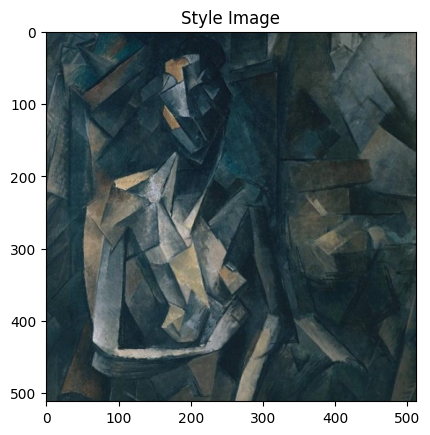

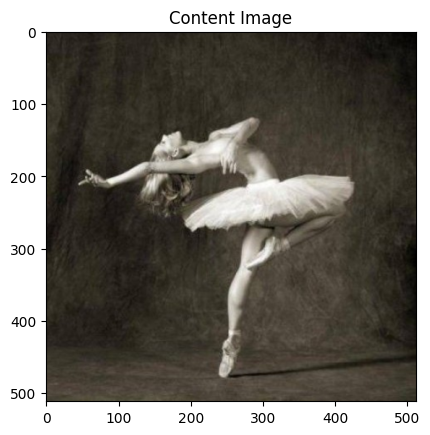

In [ ]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):

    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

## 4.Функции потерь

<font color='plum'>**Функция потерь контента $D_{content}$.**</font>

Подобно функции потерь в линейной регрессии, $D_{content}$ измеряет разницу признаковых описаний между `синтезированным изображением` и `изображением контента` с помощью функции квадратичных потерь.

$$D_{content} = \sum_{I \in \{1,...,N\} } \frac{1}{2}(F_{I,syntesized}−F_{I,content})^2$$

In [ ]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [ ]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resize F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)



$$D_{style} = \sum_{I \in \{1,...,N\} } (G_{I, syntesized}−G_{I, style})^2$$

In [ ]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

### **<font color='orange'> Задание 3 [1 балл]</font>**
Реализуйте функцию потерь $D_{total\_variation}$, используя векторизованные операции (не используйте питоновские циклы)

**Функция потерь $D_{total\_variation}$.**</font>

Иногда в `синтезируемом изображении` присутствуют выбросы, т.е. особенно яркие или темные пикселей. Используем следующую функцию потерь, которая позволяет приблизить значения соседних пикселей $x_{i,j}$ на `синтезируемом изображении`.

$$D_{total\_variation} = \sum_{i,j}|x_{i,j} - x_{i+1,j}| + |x_{i,j} - x_{i,j+1}|$$


In [ ]:
def total_variation_loss(image):
  #YOUR CODE HERE
  loss = ...
  return loss

## 5.Подготавливаем NN

In [ ]:
cnn = vgg19(weights=VGG19_Weights.DEFAULT).features.eval()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:05<00:00, 101MB/s]


In [ ]:
summary(cnn, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

Кроме того, сети VGG обучаются на изображениях, где каждый канал нормализован по среднему значению = [0,485, 0,456, 0,406] и стандартному отклонению = [0,229, 0,224, 0,225]. Мы будем использовать их для нормализации изображения перед отправкой его в сеть.

In [ ]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406])
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225])

# create a module to normalize input image so we can easily put it in a
# ``nn.Sequential``
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize ``img``
        return (img - self.mean) / self.std

Нам нужно добавить наши слои потери контента и потери стиля сразу после слоя свертки, который они обнаруживают. Для этого мы должны создать новый последовательный модуль, в котором модули потери контента и потери стиля вставлены правильно.

### **<font color='orange'> Задание 4 [1 балл]</font>**
Выберите слои для переноса контента и стиля, добавьте их в списки в ячейке ниже.

Рекомендации (но не обязательно их придерживаться):
- Для переноса стиля лучше использовать несколько слоев.
- Для контента не стоит использовать первые слои.

Можно выбрать несколько вариантов слоев переноса контента и стиля и добавить выводы какой вариант лучше (лучше тут понятие субъективное 😊)

In [ ]:
#YOUR CODE HERE
content_layers_default = [...]
style_layers_default = [...]

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    # normalization module
    normalization = Normalization(normalization_mean, normalization_std)

    # just in order to have an iterable access to or list of content/style
    # losses
    content_losses = []
    style_losses = []

    # assuming that ``cnn`` is a ``nn.Sequential``, so we make a new ``nn.Sequential``
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ``ContentLoss``
            # and ``StyleLoss`` we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

### **<font color='orange'> Задание 5 [1 балл]</font>**
В качестве входного изображения можно использовать случайный шум. Попробуйте в качестве `input_img` использовать случайный шум.
Шум можно использовать:

- из нормального распределения
- из равномерного распределения

Проведите эксперименты по генерации для разных типов шумов. Выводы можно добавить в последнее задание.

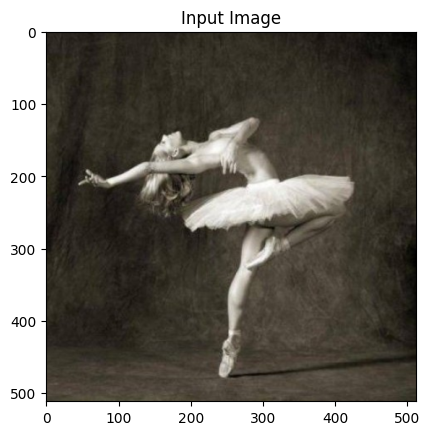

In [ ]:
# if you want to use white noise by using the following code:
#
# .. code-block:: python
#YOUR CODE HERE
input_img = ...
# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')

## 6.Обучение

### **<font color='orange'> Задание 6 [1 балл]</font>**
Выберете другой оптимизатор (не `LBFGS` который был в семинаре).

In [ ]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    #YOUR CODE HERE
    optimizer = ...
    return optimizer

### **<font color='orange'> Задание 7 [2 балла]</font>**
Поэкспериментируйте с `var_weight`, `num_steps`, `style_weight`, `content_weight`.

Выберите на ваш взгляд оптимальные значения для ваших картинок.

Проведите 2-3 эксперимента для различных значений `num_steps`, `style_weight`, `content_weight`. Также попробуйте включать `var_loss` или выключать (выставлять 0й `var_weight`)
Сделайте выводы.

In [ ]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img,
                       #YOUR CODE HERE
                       var_weight = ..., #1
                       num_steps=..., #1_500
                       style_weight=..., #1000000
                       content_weight=...#1
                       ):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)

    # We want to optimize the input and not the model parameters so we
    # update all the requires_grad fields accordingly
    input_img.requires_grad_(True)
    # We also put the model in evaluation mode, so that specific layers
    # such as dropout or batch normalization layers behave correctly.
    model.eval()
    model.requires_grad_(False)

    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            with torch.no_grad():
                input_img.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            var_loss = total_variation_loss(input_img)

            var_score = var_loss * var_weight
            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score + var_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score + var_score

        optimizer.step(closure)

    # a last correction...
    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img

Building the style transfer model..


/usr/local/lib/python3.10/dist-packages/torch/utils/_device.py:106: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


Optimizing..
run [50]:
Style Loss : 5.061215 Content Loss: 5.659504

run [100]:
Style Loss : 1.716697 Content Loss: 3.740290

run [150]:
Style Loss : 1.164060 Content Loss: 3.174218

run [200]:
Style Loss : 0.894214 Content Loss: 2.911510

run [250]:
Style Loss : 0.745183 Content Loss: 2.772075

run [300]:
Style Loss : 0.654057 Content Loss: 2.678177

run [350]:
Style Loss : 0.590796 Content Loss: 2.618998

run [400]:
Style Loss : 0.552176 Content Loss: 2.578688

run [450]:
Style Loss : 0.526089 Content Loss: 2.550180

run [500]:
Style Loss : 0.511431 Content Loss: 2.526806

run [550]:
Style Loss : 0.501372 Content Loss: 2.509469

run [600]:
Style Loss : 0.494215 Content Loss: 2.494129

run [650]:
Style Loss : 0.488997 Content Loss: 2.481448

run [700]:
Style Loss : 0.485088 Content Loss: 2.470705

run [750]:
Style Loss : 0.482290 Content Loss: 2.460989

run [800]:
Style Loss : 0.480325 Content Loss: 2.452694

run [850]:
Style Loss : 0.477657 Content Loss: 2.445083

run [900]:
Style Lo

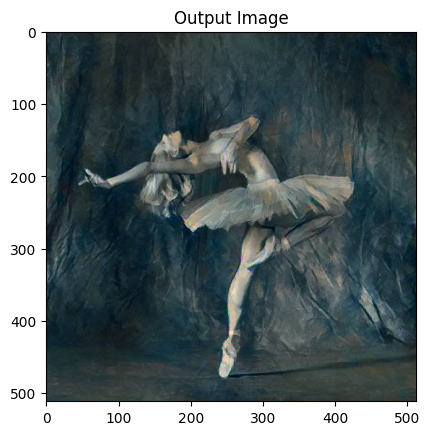

In [ ]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

<font color='MediumOrchid'>**Ваши выводы тут:**</font>

### **<font color='orange'> Задание 8 [2 балл]</font>**
Прикрепите картинки (в ячейку ниже):
- стиля
- контента
- итоговую картинку, которая получилась после переноса style transfer для __2-3__ экспериментов переноса стиля.

__Ответьте на вопросы:__

1) Есть ли отличия в стилизации в этих экспериментах?

2) Какая комбинация гиперпараметров модели на ваш взгляд соответствует лучшему переносу стиля?




### Картинки можно прикрепить сюда:

<font color='MediumOrchid'>**Ваши выводы тут:**</font>

## <font color='MediumSeaGreen'> **Бонус [1 балл]** </font>


Используйте [phosus](https://phosus.com/dashboard/tools/image-style-transfer) (или другие открытые платформы) для переноса стиля картинок, которые вы использовали в этом ДЗ.

Прикрепите картинку (см. ячейку ниже), которая получится после переноса стиля.

__Ответьте на вопрос:__

1) На ваш взгляд, какой вариант переноса стиля (ваш или с использованием открытых решений) лучше справился с задачей?

Картинки можно прикрепить сюда:

<font color='MediumOrchid'>**Ваши выводы тут:**</font>